# GAN for CIFAR-10

This example was adapted from [Generative Adversarial Networks with Python](https://machinelearningmastery.com/generative_adversarial_networks/) (Jason Brownlee) - Chaper 8: How to Develop a DCGAN for Small Color Photographs

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.9 MB/s 
     |████████████████████████████████| 166 kB 69.1 MB/s 
     |████████████████████████████████| 182 kB 46.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 166 kB 42.0 MB/s 
     |████████████████████████████████| 162 kB 10.3 MB/s 
     |████████████████████████████████| 162 kB 11.5 MB/s 
     |████████████████████████████████| 158 kB 60.6 MB/s 
     |████████████████████████████████| 157 kB 55.6 MB/s 
     |████████████████████████████████| 157 kB 53.5 MB/s 
     |████████████████████████████████| 157 kB 55.3 MB/s 
     |████████████████████████████████| 157 kB 61.2 MB/s 
     |████████████████████████████████| 157 kB 59.7 MB/s 
     |████████████████████████████████| 157 kB 56.4 MB/s 
     |████████████████████████████████| 157 kB 59.5 MB/s 
     |████████████████████████████

In [ ]:
pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 5.1 MB/s 
     |████████████████████████████████| 46 kB 5.5 MB/s 
     |████████████████████████████████| 66 kB 6.3 MB/s 


## Importing libraries

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from codecarbon import EmissionsTracker
import tensorflow as tf
from matplotlib import pyplot
import wandb
import logging
import joblib
from keras.utils.vis_utils import plot_model

## Setup

In [ ]:
# seed for reproducible results
tf.random.set_seed(42)

In [ ]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

In [ ]:
from tensorflow.python.client import device_lib
logger.info("verifying hardware configurations")
logger.info(device_lib.list_local_devices())

01-11-2022 17:58:01 verifying hardware configurations
01-11-2022 17:58:05 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3785387696574669896
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12252536075805593084
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Load dataset

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "gan-cifar10"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="morsinaldo",
                 project=args["project_name"], 
                 job_type="Train")

wandb: Currently logged in as: morsinaldo. Use `wandb login --relogin` to force relogin


In [ ]:
# load the images into memory
logger.info("[INFO] accessing CIFAR10...")
(trainX, trainy), (testX, testy) = load_data() 

# summarize the shape of the dataset 
logger.info("Train x: {}".format(trainX.shape))
logger.info("Train y: {}".format(trainy.shape))
logger.info("Test x: {}".format(testX.shape))
logger.info("Test y: {}".format(testy.shape))

01-11-2022 17:58:07 [INFO] accessing CIFAR10...


170498071/170498071 [==============================] - 2s 0us/step


01-11-2022 17:58:13 Train x: (50000, 32, 32, 3)
01-11-2022 17:58:13 Train y: (50000, 1)
01-11-2022 17:58:13 Test x: (10000, 32, 32, 3)
01-11-2022 17:58:13 Test y: (10000, 1)


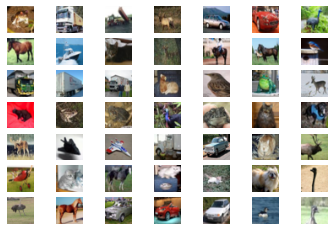

In [ ]:
# plot images from the training dataset
for i in range(49):
  # define subplot 
  pyplot.subplot(7, 7, 1 + i) 
  # turn off axis 
  pyplot.axis('off')
  # plot raw pixel data 
  pyplot.imshow(trainX[i])
pyplot.show()

## Define the Discriminator Model

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape)) 
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) 
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) 
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same')) 
  model.add(LeakyReLU(alpha=0.2))
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
  return model

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create 'fake' class labels (0) 
  y = zeros((n_samples, 1)) 
  return X, y

In [ ]:
# load and prepare cifar10 training images
def load_real_samples():
  # load cifar10 dataset
  (trainX, _), (_, _) = load_data()
  # convert from unsigned ints to floats 
  X = trainX.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (trainX - 127.5) / 127.5
  return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate ✬real✬ class labels (1) 
  y = ones((n_samples, 1))
  return X, y

## Define the Generator Model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 4x4 image
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim)) 
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))
  # upsample to 8x8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
  model.add(LeakyReLU(alpha=0.2))
  # output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same')) 
  return model

## Functions to Evaluation

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
  # scale from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  # plot images
  for i in range(n * n):
    # define subplot 
    pyplot.subplot(n, n, 1 + i) 
    # turn off axis 
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i])
  # save plot to file
  filename = 'generated_plot_e%03d.png' % (epoch+1) 
  pyplot.savefig(filename)

  # Uploading figures to wandb
  logger.info("Uploading generated plot ")
  run.log(
      {
          "generated_plot": wandb.Image(filename)
      }
  )
  pyplot.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  logger.info('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100)) 
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch+1) 
  g_model.save(filename)

  logger.info("Saving Inference model")
  joblib.dump(g_model, filename)
  # inference model artifact
  artifact = wandb.Artifact(filename,
                            type="INFERENCE_MODEL",
                            description="A json file representing the inference model"
                            )

  logger.info("Logging the inference model artifact")
  artifact.add_file(filename)
  run.log_artifact(artifact)

## Define and Train GAN

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable 
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5) 
  model.compile(loss='binary_crossentropy', optimizer=opt) 
  return model

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # generate 'fake'examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch) 
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator✬s error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      logger.info('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
       (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

## Instantiate objects

### Summarize

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


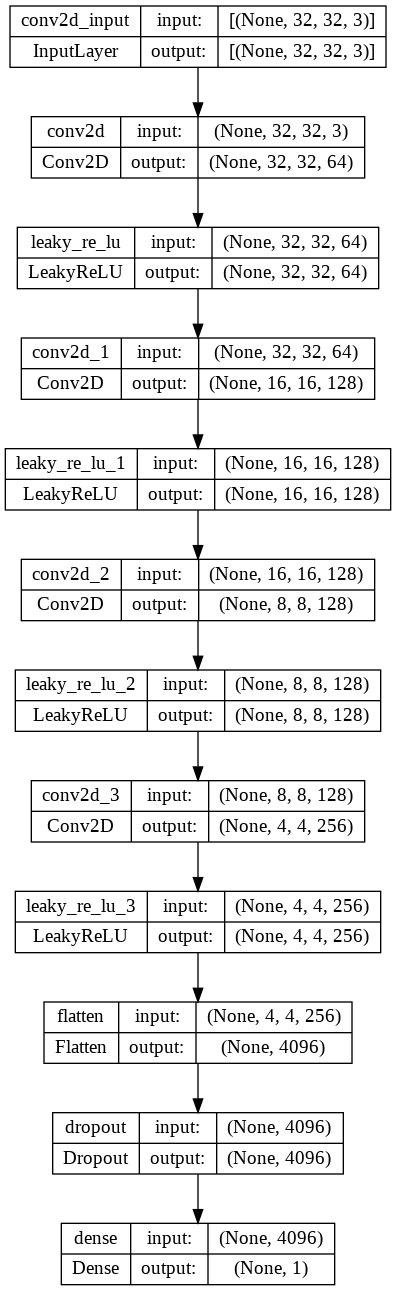

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()

# summarize the model
d_model.summary()

# plot the model
plot_model(d_model, to_file='discriminator_plot.png', 
           show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

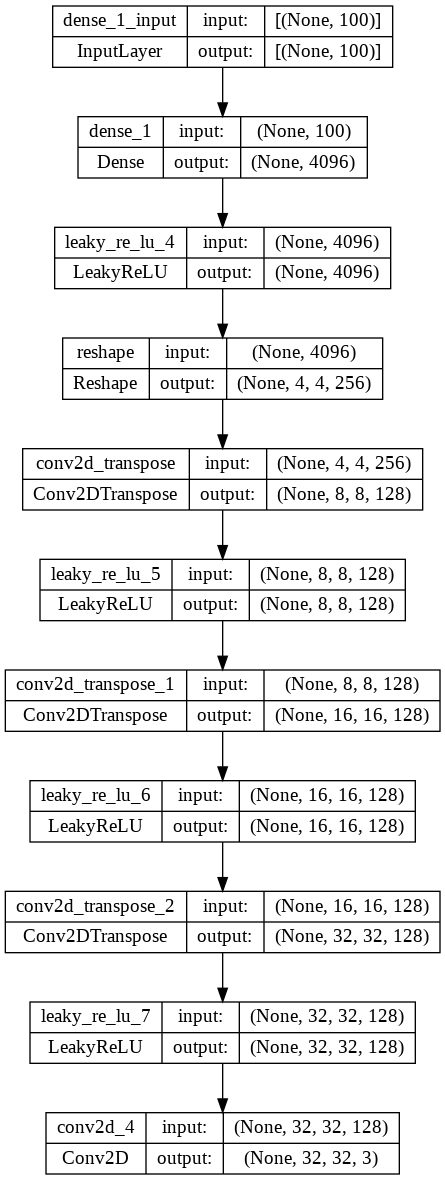

In [ ]:
# create the generator
g_model = define_generator(latent_dim)

# summarize the model
g_model.summary()

# plot the model
plot_model(g_model, to_file='generator_plot.png', 
           show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential (Sequential)     (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


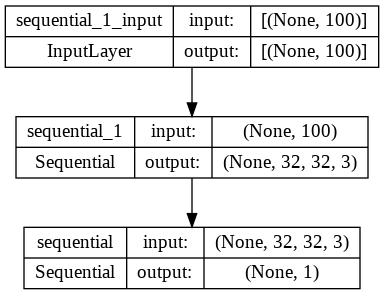

In [ ]:
# create the gan
gan_model = define_gan(g_model, d_model)

#summarize the model
gan_model.summary()

plot_model(gan_model, to_file='gan_plot.png',
           show_shapes=True, show_layer_names=True)

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "discriminator_summary": wandb.Image("discriminator_plot.png"),
        "generator_summary": wandb.Image("generator_plot.png"),
        "gan_summary": wandb.Image("gan_plot.png")
    }
)

01-11-2022 17:58:16 Uploading figures


### Training

In [ ]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")

# load image data
dataset = load_real_samples()

# start tracker
tracker.start()

# train model
logger.info("[INFO] training network...")
train(g_model, d_model, gan_model, dataset, latent_dim)

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

01-11-2022 17:58:19 [INFO] training network...


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:58:29 >1, 1/390, d1=0.715, d2=0.695 g=0.692


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:29 >1, 2/390, d1=0.649, d2=0.698 g=0.689


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:29 >1, 3/390, d1=0.600, d2=0.705 g=0.683


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:30 >1, 4/390, d1=0.528, d2=0.720 g=0.670


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:30 >1, 5/390, d1=0.414, d2=0.752 g=0.644


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:30 >1, 6/390, d1=0.352, d2=0.810 g=0.619


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:30 >1, 7/390, d1=0.259, d2=0.853 g=0.617


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:30 >1, 8/390, d1=0.172, d2=0.813 g=0.671


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:58:30 >1, 9/390, d1=0.149, d2=0.704 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:30 >1, 10/390, d1=0.094, d2=0.588 g=0.933


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:30 >1, 11/390, d1=0.063, d2=0.539 g=0.987


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:31 >1, 12/390, d1=0.104, d2=0.555 g=0.929


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:31 >1, 13/390, d1=0.104, d2=0.608 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:31 >1, 14/390, d1=0.036, d2=0.659 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:31 >1, 15/390, d1=0.085, d2=0.694 g=0.775


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:31 >1, 16/390, d1=0.048, d2=0.754 g=0.746


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:31 >1, 17/390, d1=0.046, d2=0.843 g=0.723


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:31 >1, 18/390, d1=0.043, d2=0.898 g=0.750


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:31 >1, 19/390, d1=0.046, d2=0.826 g=0.860


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:32 >1, 20/390, d1=0.088, d2=0.642 g=1.060


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:32 >1, 21/390, d1=0.099, d2=0.535 g=1.145


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:32 >1, 22/390, d1=0.150, d2=0.574 g=1.040


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:32 >1, 23/390, d1=0.071, d2=0.570 g=0.995


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:32 >1, 24/390, d1=0.054, d2=0.592 g=0.910


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:32 >1, 25/390, d1=0.043, d2=0.667 g=0.857


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:58:32 >1, 26/390, d1=0.031, d2=0.782 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:32 >1, 27/390, d1=0.052, d2=0.782 g=0.982


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:58:33 >1, 28/390, d1=0.136, d2=0.621 g=1.080


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:33 >1, 29/390, d1=0.035, d2=0.436 g=1.308


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:33 >1, 30/390, d1=0.031, d2=0.362 g=1.400


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:33 >1, 31/390, d1=0.027, d2=0.355 g=1.370


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:33 >1, 32/390, d1=0.030, d2=0.368 g=1.314


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:33 >1, 33/390, d1=0.013, d2=0.367 g=1.309


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:33 >1, 34/390, d1=0.007, d2=0.358 g=1.337


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:33 >1, 35/390, d1=0.015, d2=0.320 g=1.457


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:58:34 >1, 36/390, d1=0.013, d2=0.267 g=1.714


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:34 >1, 37/390, d1=0.006, d2=0.206 g=2.039


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:58:34 >1, 38/390, d1=0.019, d2=0.169 g=2.250


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:34 >1, 39/390, d1=0.007, d2=0.118 g=2.618


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:34 >1, 40/390, d1=0.030, d2=0.079 g=2.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:34 >1, 41/390, d1=0.025, d2=0.079 g=2.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:34 >1, 42/390, d1=0.013, d2=0.078 g=2.741


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:34 >1, 43/390, d1=0.011, d2=0.077 g=2.744


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:35 >1, 44/390, d1=0.003, d2=0.072 g=2.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:35 >1, 45/390, d1=0.004, d2=0.072 g=2.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:35 >1, 46/390, d1=0.004, d2=0.133 g=2.934


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:35 >1, 47/390, d1=0.003, d2=0.558 g=5.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:35 >1, 48/390, d1=2.329, d2=0.910 g=0.627


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:35 >1, 49/390, d1=0.000, d2=4.532 g=0.399


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:35 >1, 50/390, d1=0.000, d2=2.720 g=1.170


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:36 >1, 51/390, d1=0.015, d2=0.777 g=4.327


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:36 >1, 52/390, d1=0.413, d2=0.015 g=4.956


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:36 >1, 53/390, d1=0.486, d2=0.055 g=3.172


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:58:36 >1, 54/390, d1=0.377, d2=0.265 g=3.233


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:36 >1, 55/390, d1=0.289, d2=0.064 g=3.668


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:36 >1, 56/390, d1=0.407, d2=0.120 g=3.248


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:36 >1, 57/390, d1=0.311, d2=0.175 g=3.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:36 >1, 58/390, d1=0.236, d2=0.045 g=4.181


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:37 >1, 59/390, d1=0.241, d2=0.054 g=4.098


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:37 >1, 60/390, d1=0.276, d2=0.225 g=5.414


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:37 >1, 61/390, d1=0.384, d2=0.268 g=6.429


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:58:37 >1, 62/390, d1=0.389, d2=13.684 g=0.110


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:37 >1, 63/390, d1=0.373, d2=9.757 g=2.509


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:37 >1, 64/390, d1=0.607, d2=0.288 g=12.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:37 >1, 65/390, d1=2.456, d2=0.003 g=5.230


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:37 >1, 66/390, d1=0.912, d2=0.213 g=3.654


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:38 >1, 67/390, d1=0.694, d2=0.111 g=3.522


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:38 >1, 68/390, d1=0.643, d2=0.137 g=3.791


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:58:38 >1, 69/390, d1=0.715, d2=0.140 g=3.364


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:38 >1, 70/390, d1=0.590, d2=0.176 g=3.165


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:38 >1, 71/390, d1=0.494, d2=0.187 g=3.020


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:38 >1, 72/390, d1=0.622, d2=0.246 g=2.663


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:58:38 >1, 73/390, d1=0.685, d2=0.388 g=2.238


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:38 >1, 74/390, d1=0.458, d2=0.365 g=1.921


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:39 >1, 75/390, d1=0.455, d2=0.538 g=1.409


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:39 >1, 76/390, d1=0.478, d2=0.896 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:39 >1, 77/390, d1=0.500, d2=0.961 g=0.684


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:39 >1, 78/390, d1=0.300, d2=0.861 g=0.712


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:39 >1, 79/390, d1=0.272, d2=0.789 g=0.780


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:39 >1, 80/390, d1=0.327, d2=0.720 g=0.904


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:39 >1, 81/390, d1=0.282, d2=0.579 g=1.033


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:40 >1, 82/390, d1=0.282, d2=0.515 g=1.185


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:40 >1, 83/390, d1=0.367, d2=0.430 g=1.301


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:40 >1, 84/390, d1=0.352, d2=0.410 g=1.360


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:40 >1, 85/390, d1=0.316, d2=0.373 g=1.453


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:40 >1, 86/390, d1=0.428, d2=0.382 g=1.449


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:40 >1, 87/390, d1=0.290, d2=0.418 g=1.376


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:40 >1, 88/390, d1=0.329, d2=0.402 g=1.362


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:40 >1, 89/390, d1=0.362, d2=0.351 g=1.519


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:41 >1, 90/390, d1=0.401, d2=0.277 g=1.733


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:41 >1, 91/390, d1=0.233, d2=0.207 g=1.999


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:41 >1, 92/390, d1=0.198, d2=0.182 g=2.150


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:41 >1, 93/390, d1=0.232, d2=0.184 g=2.189


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:41 >1, 94/390, d1=0.198, d2=0.199 g=2.200


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:41 >1, 95/390, d1=0.235, d2=0.260 g=2.086


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:41 >1, 96/390, d1=0.294, d2=0.319 g=2.150


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:41 >1, 97/390, d1=0.456, d2=0.397 g=2.054


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:42 >1, 98/390, d1=0.555, d2=0.374 g=1.793


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:42 >1, 99/390, d1=0.438, d2=0.362 g=1.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:42 >1, 100/390, d1=0.524, d2=0.282 g=1.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:42 >1, 101/390, d1=0.417, d2=0.230 g=1.895


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:42 >1, 102/390, d1=0.429, d2=0.253 g=1.776


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:42 >1, 103/390, d1=0.275, d2=0.332 g=1.636


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:42 >1, 104/390, d1=0.256, d2=1.194 g=0.780


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:42 >1, 105/390, d1=0.217, d2=2.335 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:43 >1, 106/390, d1=0.327, d2=1.486 g=2.049


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:43 >1, 107/390, d1=0.397, d2=0.207 g=3.424


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:58:43 >1, 108/390, d1=0.509, d2=0.071 g=3.453


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:43 >1, 109/390, d1=0.614, d2=0.156 g=2.614


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:43 >1, 110/390, d1=0.515, d2=0.241 g=2.613


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:43 >1, 111/390, d1=0.482, d2=0.265 g=2.839


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:58:43 >1, 112/390, d1=0.511, d2=0.160 g=2.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:44 >1, 113/390, d1=0.612, d2=0.190 g=2.493


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:44 >1, 114/390, d1=0.519, d2=0.201 g=2.577


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:44 >1, 115/390, d1=0.602, d2=0.194 g=2.551


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:58:44 >1, 116/390, d1=0.393, d2=0.192 g=2.721


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:44 >1, 117/390, d1=0.471, d2=0.221 g=2.749


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:44 >1, 118/390, d1=0.385, d2=0.282 g=3.056


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:44 >1, 119/390, d1=0.412, d2=0.233 g=3.418


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:44 >1, 120/390, d1=0.561, d2=0.366 g=3.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:45 >1, 121/390, d1=0.549, d2=0.148 g=3.615


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:58:45 >1, 122/390, d1=0.458, d2=0.550 g=3.879


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:45 >1, 123/390, d1=1.103, d2=0.735 g=2.438


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:45 >1, 124/390, d1=0.841, d2=0.796 g=1.665


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:45 >1, 125/390, d1=0.627, d2=0.678 g=1.553


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:45 >1, 126/390, d1=0.823, d2=0.607 g=1.693


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:45 >1, 127/390, d1=0.509, d2=0.395 g=2.284


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:45 >1, 128/390, d1=0.287, d2=0.195 g=2.706


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:46 >1, 129/390, d1=0.468, d2=0.216 g=2.713


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:46 >1, 130/390, d1=0.482, d2=0.239 g=2.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:46 >1, 131/390, d1=0.457, d2=0.139 g=3.015


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:46 >1, 132/390, d1=0.424, d2=0.144 g=3.030


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:46 >1, 133/390, d1=0.390, d2=0.105 g=3.100


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:46 >1, 134/390, d1=0.373, d2=0.140 g=3.258


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:46 >1, 135/390, d1=0.347, d2=0.089 g=3.364


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:47 >1, 136/390, d1=0.485, d2=0.169 g=3.373


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:47 >1, 137/390, d1=0.341, d2=0.095 g=3.622


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:47 >1, 138/390, d1=0.489, d2=0.144 g=3.703


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:47 >1, 139/390, d1=0.365, d2=0.049 g=3.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:47 >1, 140/390, d1=0.529, d2=0.141 g=3.547


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:47 >1, 141/390, d1=0.404, d2=0.121 g=3.658


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:47 >1, 142/390, d1=0.316, d2=0.070 g=3.525


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:47 >1, 143/390, d1=0.323, d2=0.138 g=3.722


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:48 >1, 144/390, d1=0.301, d2=0.078 g=3.871


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:58:48 >1, 145/390, d1=0.328, d2=0.106 g=3.545


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:48 >1, 146/390, d1=0.225, d2=0.142 g=3.744


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:48 >1, 147/390, d1=0.289, d2=0.063 g=3.939


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:48 >1, 148/390, d1=0.205, d2=0.074 g=3.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:48 >1, 149/390, d1=0.464, d2=0.198 g=3.541


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:58:48 >1, 150/390, d1=0.245, d2=0.083 g=3.843


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:48 >1, 151/390, d1=0.309, d2=0.187 g=3.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:49 >1, 152/390, d1=0.294, d2=0.104 g=3.748


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:49 >1, 153/390, d1=0.206, d2=0.161 g=3.818


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:58:49 >1, 154/390, d1=0.168, d2=0.195 g=3.991


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:49 >1, 155/390, d1=0.233, d2=0.239 g=3.894


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:49 >1, 156/390, d1=0.208, d2=0.258 g=4.022


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:49 >1, 157/390, d1=0.203, d2=0.095 g=3.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:49 >1, 158/390, d1=0.215, d2=0.225 g=4.095


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:50 >1, 159/390, d1=0.182, d2=0.061 g=4.317


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:50 >1, 160/390, d1=0.123, d2=0.183 g=4.600


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:50 >1, 161/390, d1=0.215, d2=0.098 g=4.563


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:50 >1, 162/390, d1=0.182, d2=0.143 g=4.298


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:50 >1, 163/390, d1=0.259, d2=0.143 g=3.967


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:50 >1, 164/390, d1=0.097, d2=0.284 g=4.746


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:50 >1, 165/390, d1=0.267, d2=0.031 g=4.042


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:50 >1, 166/390, d1=0.157, d2=0.249 g=3.938


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:51 >1, 167/390, d1=0.194, d2=0.224 g=4.343


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:51 >1, 168/390, d1=0.199, d2=0.162 g=4.098


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:51 >1, 169/390, d1=0.236, d2=0.159 g=4.055


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:51 >1, 170/390, d1=0.182, d2=0.248 g=4.015


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:51 >1, 171/390, d1=0.308, d2=1.565 g=7.336


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:51 >1, 172/390, d1=1.264, d2=0.064 g=7.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:51 >1, 173/390, d1=1.403, d2=0.028 g=5.194


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:51 >1, 174/390, d1=0.516, d2=0.119 g=3.679


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:52 >1, 175/390, d1=0.552, d2=0.401 g=2.611


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:52 >1, 176/390, d1=0.478, d2=0.215 g=2.129


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:52 >1, 177/390, d1=0.298, d2=0.294 g=2.090


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:52 >1, 178/390, d1=0.309, d2=0.521 g=2.225


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:52 >1, 179/390, d1=0.417, d2=0.315 g=2.735


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:52 >1, 180/390, d1=0.415, d2=0.223 g=2.918


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:58:52 >1, 181/390, d1=0.298, d2=0.204 g=3.101


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:53 >1, 182/390, d1=0.441, d2=0.152 g=2.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:53 >1, 183/390, d1=0.390, d2=0.155 g=2.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:53 >1, 184/390, d1=0.313, d2=0.139 g=2.933


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:53 >1, 185/390, d1=0.288, d2=0.089 g=3.110


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:53 >1, 186/390, d1=0.200, d2=0.114 g=3.241


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:58:53 >1, 187/390, d1=0.253, d2=0.167 g=3.484


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:58:53 >1, 188/390, d1=0.162, d2=0.086 g=3.399


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:53 >1, 189/390, d1=0.169, d2=0.088 g=3.421


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:54 >1, 190/390, d1=0.262, d2=0.127 g=3.432


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:58:54 >1, 191/390, d1=0.149, d2=0.137 g=3.062


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:54 >1, 192/390, d1=0.197, d2=0.182 g=3.010


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:54 >1, 193/390, d1=0.191, d2=0.152 g=3.068


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:54 >1, 194/390, d1=0.186, d2=0.125 g=3.236


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:58:54 >1, 195/390, d1=0.212, d2=0.310 g=3.958


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:54 >1, 196/390, d1=0.304, d2=0.163 g=3.952


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:54 >1, 197/390, d1=0.373, d2=0.300 g=5.212


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:55 >1, 198/390, d1=0.407, d2=0.087 g=4.555


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:58:55 >1, 199/390, d1=0.504, d2=0.486 g=5.668


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:55 >1, 200/390, d1=0.690, d2=0.136 g=3.773


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:55 >1, 201/390, d1=0.906, d2=1.067 g=2.311


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:58:55 >1, 202/390, d1=0.927, d2=0.986 g=1.272


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:55 >1, 203/390, d1=0.902, d2=0.961 g=1.015


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:55 >1, 204/390, d1=0.572, d2=0.784 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:56 >1, 205/390, d1=0.388, d2=0.750 g=0.935


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:56 >1, 206/390, d1=0.324, d2=0.656 g=0.989


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:56 >1, 207/390, d1=0.233, d2=0.522 g=1.113


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:56 >1, 208/390, d1=0.253, d2=0.455 g=1.266


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:56 >1, 209/390, d1=0.239, d2=0.385 g=1.483


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:56 >1, 210/390, d1=0.252, d2=0.351 g=1.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:56 >1, 211/390, d1=0.218, d2=0.317 g=1.707


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:56 >1, 212/390, d1=0.214, d2=0.381 g=1.625


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:58:57 >1, 213/390, d1=0.237, d2=0.425 g=1.717


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:57 >1, 214/390, d1=0.249, d2=0.366 g=1.756


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:57 >1, 215/390, d1=0.263, d2=0.416 g=1.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:57 >1, 216/390, d1=0.280, d2=0.486 g=1.971


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:57 >1, 217/390, d1=0.361, d2=0.499 g=2.538


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:57 >1, 218/390, d1=0.463, d2=0.145 g=2.975


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:57 >1, 219/390, d1=0.527, d2=0.282 g=2.951


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:58 >1, 220/390, d1=0.360, d2=0.128 g=2.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:58 >1, 221/390, d1=0.291, d2=0.204 g=2.689


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:58 >1, 222/390, d1=0.179, d2=0.224 g=3.391


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:58 >1, 223/390, d1=0.321, d2=0.150 g=3.350


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:58 >1, 224/390, d1=0.309, d2=0.181 g=3.026


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:58 >1, 225/390, d1=0.405, d2=0.548 g=3.377


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:58 >1, 226/390, d1=0.661, d2=0.149 g=2.965


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:58 >1, 227/390, d1=0.481, d2=0.290 g=2.387


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:59 >1, 228/390, d1=0.260, d2=0.366 g=2.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:59 >1, 229/390, d1=0.368, d2=0.239 g=2.623


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:59 >1, 230/390, d1=0.382, d2=0.643 g=3.048


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:58:59 >1, 231/390, d1=0.591, d2=0.675 g=2.405


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:58:59 >1, 232/390, d1=0.521, d2=0.951 g=3.516


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:58:59 >1, 233/390, d1=0.945, d2=0.282 g=2.516


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:58:59 >1, 234/390, d1=0.925, d2=0.509 g=2.058


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:58:59 >1, 235/390, d1=0.705, d2=0.325 g=2.081


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:00 >1, 236/390, d1=0.583, d2=0.315 g=2.205


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:00 >1, 237/390, d1=0.488, d2=0.217 g=2.129


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:00 >1, 238/390, d1=0.576, d2=0.309 g=1.906


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:00 >1, 239/390, d1=0.266, d2=0.253 g=2.106


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:00 >1, 240/390, d1=0.545, d2=0.320 g=1.885


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:01 >1, 241/390, d1=0.361, d2=0.323 g=1.841


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:01 >1, 242/390, d1=0.579, d2=0.508 g=1.700


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:01 >1, 243/390, d1=0.477, d2=0.439 g=1.689


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:01 >1, 244/390, d1=0.654, d2=0.609 g=1.335


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:01 >1, 245/390, d1=0.812, d2=0.621 g=1.152


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:01 >1, 246/390, d1=0.679, d2=0.717 g=1.286


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:02 >1, 247/390, d1=0.959, d2=0.520 g=1.514


2/2 [==============================] - 0s 13ms/step


01-11-2022 17:59:02 >1, 248/390, d1=0.603, d2=0.413 g=1.939


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:02 >1, 249/390, d1=0.454, d2=0.353 g=1.951


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:02 >1, 250/390, d1=0.449, d2=0.425 g=1.788


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:02 >1, 251/390, d1=0.401, d2=0.613 g=1.976


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:59:02 >1, 252/390, d1=0.410, d2=0.365 g=2.545


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:03 >1, 253/390, d1=0.709, d2=0.396 g=2.015


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:03 >1, 254/390, d1=0.458, d2=0.568 g=2.104


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:03 >1, 255/390, d1=0.457, d2=0.395 g=2.108


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:03 >1, 256/390, d1=0.422, d2=0.483 g=1.890


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:59:03 >1, 257/390, d1=0.494, d2=0.687 g=1.755


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:04 >1, 258/390, d1=0.540, d2=0.727 g=1.894


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:04 >1, 259/390, d1=0.598, d2=0.487 g=1.762


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:04 >1, 260/390, d1=0.596, d2=0.425 g=1.734


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:04 >1, 261/390, d1=0.607, d2=0.402 g=1.777


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:04 >1, 262/390, d1=0.349, d2=0.332 g=1.905


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:04 >1, 263/390, d1=0.518, d2=0.305 g=2.216


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:04 >1, 264/390, d1=0.438, d2=0.211 g=2.460


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:04 >1, 265/390, d1=0.439, d2=0.239 g=2.330


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:05 >1, 266/390, d1=0.386, d2=0.261 g=2.285


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:05 >1, 267/390, d1=0.455, d2=0.433 g=2.316


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:05 >1, 268/390, d1=0.463, d2=0.344 g=3.119


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:05 >1, 269/390, d1=0.623, d2=0.260 g=3.027


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:05 >1, 270/390, d1=0.606, d2=0.332 g=3.313


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:05 >1, 271/390, d1=0.923, d2=0.363 g=3.142


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:05 >1, 272/390, d1=1.066, d2=0.525 g=2.757


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:06 >1, 273/390, d1=0.733, d2=0.300 g=2.667


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:06 >1, 274/390, d1=0.608, d2=0.470 g=2.564


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:06 >1, 275/390, d1=0.799, d2=0.374 g=2.243


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:06 >1, 276/390, d1=0.525, d2=0.265 g=2.328


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:06 >1, 277/390, d1=0.773, d2=0.301 g=2.244


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:06 >1, 278/390, d1=0.459, d2=0.231 g=2.395


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:06 >1, 279/390, d1=0.532, d2=0.209 g=2.293


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:59:06 >1, 280/390, d1=0.550, d2=0.227 g=2.300


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:07 >1, 281/390, d1=0.558, d2=0.279 g=2.203


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:07 >1, 282/390, d1=0.427, d2=0.219 g=2.188


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:07 >1, 283/390, d1=0.462, d2=0.256 g=2.375


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:07 >1, 284/390, d1=0.399, d2=0.212 g=2.408


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:59:07 >1, 285/390, d1=0.267, d2=0.349 g=2.574


2/2 [==============================] - 0s 13ms/step


01-11-2022 17:59:07 >1, 286/390, d1=0.307, d2=0.276 g=2.665


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:07 >1, 287/390, d1=0.448, d2=0.369 g=2.348


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:08 >1, 288/390, d1=0.368, d2=0.196 g=2.389


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:08 >1, 289/390, d1=0.295, d2=0.391 g=2.391


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:08 >1, 290/390, d1=0.318, d2=0.303 g=2.500


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:08 >1, 291/390, d1=0.303, d2=0.228 g=2.484


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:08 >1, 292/390, d1=0.381, d2=0.500 g=2.400


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:09 >1, 293/390, d1=0.406, d2=0.396 g=2.425


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:09 >1, 294/390, d1=0.411, d2=0.520 g=2.253


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:09 >1, 295/390, d1=0.276, d2=0.409 g=2.525


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:09 >1, 296/390, d1=0.430, d2=0.391 g=2.448


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:09 >1, 297/390, d1=0.585, d2=0.385 g=2.219


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:09 >1, 298/390, d1=0.445, d2=0.470 g=2.622


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:10 >1, 299/390, d1=0.483, d2=0.287 g=2.403


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:10 >1, 300/390, d1=0.347, d2=0.360 g=2.435


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:10 >1, 301/390, d1=0.319, d2=0.370 g=2.245


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:10 >1, 302/390, d1=0.357, d2=0.482 g=2.244


2/2 [==============================] - 0s 13ms/step


01-11-2022 17:59:10 >1, 303/390, d1=0.499, d2=0.359 g=1.998


2/2 [==============================] - 0s 14ms/step


01-11-2022 17:59:11 >1, 304/390, d1=0.445, d2=0.712 g=1.978


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:11 >1, 305/390, d1=0.392, d2=0.562 g=1.707


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:11 >1, 306/390, d1=0.443, d2=0.778 g=1.518


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:59:11 >1, 307/390, d1=0.679, d2=0.624 g=1.427


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:11 >1, 308/390, d1=0.669, d2=0.480 g=1.476


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:11 >1, 309/390, d1=0.469, d2=0.502 g=1.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:12 >1, 310/390, d1=0.520, d2=0.310 g=1.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:12 >1, 311/390, d1=0.416, d2=0.277 g=1.902


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:12 >1, 312/390, d1=0.312, d2=0.346 g=1.992


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:12 >1, 313/390, d1=0.336, d2=0.363 g=1.779


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:12 >1, 314/390, d1=0.311, d2=0.333 g=1.614


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:12 >1, 315/390, d1=0.347, d2=0.396 g=1.426


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:12 >1, 316/390, d1=0.345, d2=0.509 g=1.209


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:12 >1, 317/390, d1=0.245, d2=0.515 g=1.168


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:59:13 >1, 318/390, d1=0.364, d2=0.539 g=1.087


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:13 >1, 319/390, d1=0.259, d2=0.550 g=1.078


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:13 >1, 320/390, d1=0.286, d2=0.526 g=1.057


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:13 >1, 321/390, d1=0.278, d2=0.567 g=1.084


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:13 >1, 322/390, d1=0.365, d2=0.667 g=1.088


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:13 >1, 323/390, d1=0.280, d2=0.576 g=1.061


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:13 >1, 324/390, d1=0.452, d2=0.579 g=1.029


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:14 >1, 325/390, d1=0.332, d2=0.603 g=1.050


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:14 >1, 326/390, d1=0.344, d2=0.626 g=1.063


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:14 >1, 327/390, d1=0.407, d2=0.597 g=1.157


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:14 >1, 328/390, d1=0.481, d2=0.569 g=1.220


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:14 >1, 329/390, d1=0.383, d2=0.610 g=1.284


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:14 >1, 330/390, d1=0.437, d2=0.472 g=1.412


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:14 >1, 331/390, d1=0.318, d2=0.486 g=1.626


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:15 >1, 332/390, d1=0.432, d2=0.407 g=1.759


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:15 >1, 333/390, d1=0.559, d2=0.395 g=1.910


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:15 >1, 334/390, d1=0.682, d2=0.445 g=1.965


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:15 >1, 335/390, d1=0.578, d2=0.433 g=2.058


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:15 >1, 336/390, d1=0.516, d2=0.522 g=1.947


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:15 >1, 337/390, d1=0.669, d2=0.435 g=1.976


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:15 >1, 338/390, d1=0.592, d2=0.504 g=2.092


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:15 >1, 339/390, d1=0.610, d2=0.331 g=1.712


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:16 >1, 340/390, d1=0.711, d2=0.611 g=1.925


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:16 >1, 341/390, d1=0.779, d2=0.342 g=1.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:16 >1, 342/390, d1=0.687, d2=0.520 g=1.570


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:16 >1, 343/390, d1=0.688, d2=0.604 g=1.499


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:16 >1, 344/390, d1=0.564, d2=0.419 g=1.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:16 >1, 345/390, d1=0.575, d2=0.382 g=1.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:16 >1, 346/390, d1=0.569, d2=0.449 g=1.721


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:17 >1, 347/390, d1=0.486, d2=0.320 g=1.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:17 >1, 348/390, d1=0.492, d2=0.436 g=1.769


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:17 >1, 349/390, d1=0.469, d2=0.376 g=2.019


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:17 >1, 350/390, d1=0.524, d2=0.388 g=2.155


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:17 >1, 351/390, d1=0.568, d2=0.398 g=1.997


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:17 >1, 352/390, d1=0.645, d2=0.619 g=1.686


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:17 >1, 353/390, d1=0.643, d2=0.836 g=1.177


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:18 >1, 354/390, d1=0.592, d2=0.724 g=1.434


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:18 >1, 355/390, d1=0.500, d2=0.536 g=1.545


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:18 >1, 356/390, d1=0.636, d2=0.674 g=1.364


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:18 >1, 357/390, d1=0.586, d2=0.848 g=0.978


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:18 >1, 358/390, d1=0.480, d2=1.030 g=0.772


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:18 >1, 359/390, d1=0.428, d2=0.893 g=0.941


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:18 >1, 360/390, d1=0.473, d2=0.656 g=1.000


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:19 >1, 361/390, d1=0.493, d2=0.605 g=1.093


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:19 >1, 362/390, d1=0.561, d2=0.503 g=1.078


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:19 >1, 363/390, d1=0.487, d2=0.596 g=1.224


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:19 >1, 364/390, d1=0.487, d2=0.512 g=1.396


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:19 >1, 365/390, d1=0.583, d2=0.524 g=1.373


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:19 >1, 366/390, d1=0.490, d2=0.423 g=1.367


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:19 >1, 367/390, d1=0.511, d2=0.576 g=1.321


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:20 >1, 368/390, d1=0.455, d2=0.550 g=1.410


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:20 >1, 369/390, d1=0.502, d2=0.466 g=1.468


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:20 >1, 370/390, d1=0.487, d2=0.450 g=1.446


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:20 >1, 371/390, d1=0.586, d2=0.568 g=1.330


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:20 >1, 372/390, d1=0.533, d2=0.507 g=1.368


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:20 >1, 373/390, d1=0.740, d2=0.644 g=1.253


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:59:20 >1, 374/390, d1=0.723, d2=0.561 g=1.304


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:21 >1, 375/390, d1=0.649, d2=0.551 g=1.257


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:21 >1, 376/390, d1=0.576, d2=0.475 g=1.340


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:21 >1, 377/390, d1=0.591, d2=0.486 g=1.309


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:21 >1, 378/390, d1=0.595, d2=0.470 g=1.295


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:21 >1, 379/390, d1=0.664, d2=0.482 g=1.440


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:21 >1, 380/390, d1=0.651, d2=0.425 g=1.603


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:59:21 >1, 381/390, d1=0.710, d2=0.434 g=1.566


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:22 >1, 382/390, d1=0.673, d2=0.426 g=1.671


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:22 >1, 383/390, d1=0.647, d2=0.399 g=1.614


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:22 >1, 384/390, d1=0.745, d2=0.430 g=1.583


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:22 >1, 385/390, d1=0.560, d2=0.428 g=1.524


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:22 >1, 386/390, d1=0.657, d2=0.456 g=1.454


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:22 >1, 387/390, d1=0.536, d2=0.395 g=1.649


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:22 >1, 388/390, d1=0.571, d2=0.373 g=1.600


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:23 >1, 389/390, d1=0.583, d2=0.422 g=1.462


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:23 >1, 390/390, d1=0.417, d2=0.390 g=1.597


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:23 >2, 1/390, d1=0.473, d2=0.373 g=1.679


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:23 >2, 2/390, d1=0.544, d2=0.338 g=1.810


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:23 >2, 3/390, d1=0.293, d2=0.298 g=2.013


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:23 >2, 4/390, d1=0.474, d2=0.256 g=1.898


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:23 >2, 5/390, d1=0.379, d2=0.378 g=1.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:24 >2, 6/390, d1=0.449, d2=0.498 g=1.907


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:24 >2, 7/390, d1=0.639, d2=0.572 g=1.522


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:24 >2, 8/390, d1=0.421, d2=0.834 g=1.387


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:24 >2, 9/390, d1=0.535, d2=0.781 g=1.467


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:24 >2, 10/390, d1=1.041, d2=0.856 g=1.000


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:24 >2, 11/390, d1=0.844, d2=1.075 g=0.955


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:24 >2, 12/390, d1=0.663, d2=0.764 g=1.123


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:25 >2, 13/390, d1=0.686, d2=0.738 g=1.376


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:25 >2, 14/390, d1=0.629, d2=0.790 g=1.344


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:25 >2, 15/390, d1=0.518, d2=0.488 g=1.717


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:25 >2, 16/390, d1=0.468, d2=0.419 g=1.680


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:25 >2, 17/390, d1=0.513, d2=0.586 g=1.720


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:25 >2, 18/390, d1=0.498, d2=0.631 g=1.750


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:25 >2, 19/390, d1=0.552, d2=0.481 g=1.758


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:26 >2, 20/390, d1=0.520, d2=0.438 g=1.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:26 >2, 21/390, d1=0.592, d2=0.542 g=1.746


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:26 >2, 22/390, d1=0.572, d2=0.530 g=1.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:26 >2, 23/390, d1=0.565, d2=0.493 g=1.735


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:26 >2, 24/390, d1=0.746, d2=0.498 g=1.599


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:26 >2, 25/390, d1=0.497, d2=0.509 g=1.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:26 >2, 26/390, d1=0.609, d2=0.682 g=1.585


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:27 >2, 27/390, d1=0.509, d2=0.655 g=1.311


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:27 >2, 28/390, d1=0.564, d2=0.590 g=1.351


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:27 >2, 29/390, d1=0.687, d2=0.686 g=1.099


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:27 >2, 30/390, d1=0.553, d2=0.669 g=1.186


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:27 >2, 31/390, d1=0.490, d2=0.615 g=1.158


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:27 >2, 32/390, d1=0.496, d2=0.574 g=1.143


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:28 >2, 33/390, d1=0.422, d2=0.525 g=1.238


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:28 >2, 34/390, d1=0.416, d2=0.720 g=1.350


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:28 >2, 35/390, d1=0.507, d2=0.537 g=1.415


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:28 >2, 36/390, d1=0.530, d2=0.516 g=1.427


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:28 >2, 37/390, d1=0.491, d2=0.487 g=1.561


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:59:28 >2, 38/390, d1=0.455, d2=0.439 g=1.643


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:29 >2, 39/390, d1=0.498, d2=0.432 g=1.765


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:29 >2, 40/390, d1=0.543, d2=0.341 g=1.836


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:29 >2, 41/390, d1=0.555, d2=0.388 g=1.781


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:29 >2, 42/390, d1=0.573, d2=0.485 g=1.614


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:29 >2, 43/390, d1=0.508, d2=0.552 g=1.519


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:29 >2, 44/390, d1=0.512, d2=0.611 g=1.525


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:29 >2, 45/390, d1=0.612, d2=0.631 g=1.314


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:30 >2, 46/390, d1=0.748, d2=0.918 g=1.128


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:30 >2, 47/390, d1=0.613, d2=0.712 g=1.313


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:30 >2, 48/390, d1=0.751, d2=0.568 g=1.349


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:30 >2, 49/390, d1=0.669, d2=0.441 g=1.484


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:30 >2, 50/390, d1=0.633, d2=0.405 g=1.685


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:30 >2, 51/390, d1=0.591, d2=0.381 g=1.774


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:59:30 >2, 52/390, d1=0.496, d2=0.282 g=1.842


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:31 >2, 53/390, d1=0.547, d2=0.289 g=1.892


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:31 >2, 54/390, d1=0.527, d2=0.278 g=1.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:31 >2, 55/390, d1=0.441, d2=0.331 g=1.821


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:31 >2, 56/390, d1=0.603, d2=0.462 g=1.676


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:31 >2, 57/390, d1=0.647, d2=0.660 g=1.609


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:31 >2, 58/390, d1=0.764, d2=0.716 g=1.367


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:31 >2, 59/390, d1=0.761, d2=0.780 g=1.429


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:32 >2, 60/390, d1=0.900, d2=0.627 g=1.434


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:32 >2, 61/390, d1=0.948, d2=0.760 g=1.434


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:32 >2, 62/390, d1=0.925, d2=0.504 g=1.455


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:32 >2, 63/390, d1=0.931, d2=0.394 g=1.361


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:32 >2, 64/390, d1=0.813, d2=0.415 g=1.460


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:32 >2, 65/390, d1=0.703, d2=0.374 g=1.623


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:32 >2, 66/390, d1=0.807, d2=0.398 g=1.595


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:33 >2, 67/390, d1=0.722, d2=0.356 g=1.623


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:33 >2, 68/390, d1=0.584, d2=0.310 g=1.623


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:33 >2, 69/390, d1=0.608, d2=0.372 g=1.623


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:33 >2, 70/390, d1=0.597, d2=0.343 g=1.717


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:33 >2, 71/390, d1=0.567, d2=0.310 g=1.675


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:33 >2, 72/390, d1=0.543, d2=0.270 g=1.744


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:34 >2, 73/390, d1=0.524, d2=0.371 g=1.703


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:34 >2, 74/390, d1=0.499, d2=0.363 g=1.765


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:34 >2, 75/390, d1=0.505, d2=0.427 g=1.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:34 >2, 76/390, d1=0.588, d2=0.380 g=1.582


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:34 >2, 77/390, d1=0.496, d2=0.555 g=1.477


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:34 >2, 78/390, d1=0.542, d2=0.506 g=1.413


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:34 >2, 79/390, d1=0.686, d2=0.579 g=1.398


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:35 >2, 80/390, d1=0.880, d2=0.579 g=1.250


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:35 >2, 81/390, d1=0.717, d2=0.642 g=1.218


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:59:35 >2, 82/390, d1=0.660, d2=0.521 g=1.270


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:35 >2, 83/390, d1=0.757, d2=0.579 g=1.468


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:35 >2, 84/390, d1=0.774, d2=0.422 g=1.530


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:35 >2, 85/390, d1=0.747, d2=0.515 g=1.436


2/2 [==============================] - 0s 13ms/step


01-11-2022 17:59:35 >2, 86/390, d1=0.598, d2=0.462 g=1.355


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:36 >2, 87/390, d1=0.529, d2=0.482 g=1.316


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:36 >2, 88/390, d1=0.538, d2=0.531 g=1.231


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:36 >2, 89/390, d1=0.501, d2=0.515 g=1.186


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:36 >2, 90/390, d1=0.523, d2=0.514 g=1.126


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:36 >2, 91/390, d1=0.576, d2=0.608 g=1.042


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:36 >2, 92/390, d1=0.607, d2=0.635 g=0.995


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:36 >2, 93/390, d1=0.601, d2=0.737 g=0.917


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:37 >2, 94/390, d1=0.642, d2=0.697 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:37 >2, 95/390, d1=0.589, d2=0.769 g=0.891


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:37 >2, 96/390, d1=0.651, d2=0.766 g=0.895


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:37 >2, 97/390, d1=0.589, d2=0.722 g=0.934


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:37 >2, 98/390, d1=0.610, d2=0.830 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:37 >2, 99/390, d1=0.601, d2=0.720 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:37 >2, 100/390, d1=0.560, d2=0.698 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:38 >2, 101/390, d1=0.548, d2=0.727 g=0.865


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:38 >2, 102/390, d1=0.556, d2=0.673 g=0.879


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:38 >2, 103/390, d1=0.544, d2=0.674 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:38 >2, 104/390, d1=0.559, d2=0.641 g=0.953


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:38 >2, 105/390, d1=0.564, d2=0.603 g=0.976


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:38 >2, 106/390, d1=0.493, d2=0.603 g=1.035


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:38 >2, 107/390, d1=0.562, d2=0.566 g=1.006


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:39 >2, 108/390, d1=0.552, d2=0.568 g=1.039


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:39 >2, 109/390, d1=0.467, d2=0.590 g=1.042


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:39 >2, 110/390, d1=0.574, d2=0.595 g=1.066


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:39 >2, 111/390, d1=0.480, d2=0.608 g=1.021


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:39 >2, 112/390, d1=0.627, d2=0.615 g=0.943


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:39 >2, 113/390, d1=0.550, d2=0.668 g=0.969


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:39 >2, 114/390, d1=0.567, d2=0.640 g=0.972


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:40 >2, 115/390, d1=0.588, d2=0.647 g=0.954


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:40 >2, 116/390, d1=0.498, d2=0.620 g=0.987


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:40 >2, 117/390, d1=0.603, d2=0.624 g=1.083


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:40 >2, 118/390, d1=0.603, d2=0.549 g=1.110


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:40 >2, 119/390, d1=0.590, d2=0.516 g=1.082


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:40 >2, 120/390, d1=0.668, d2=0.582 g=1.113


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:40 >2, 121/390, d1=0.741, d2=0.564 g=1.163


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:41 >2, 122/390, d1=0.666, d2=0.488 g=1.230


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:41 >2, 123/390, d1=0.616, d2=0.471 g=1.258


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:41 >2, 124/390, d1=0.531, d2=0.519 g=1.292


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:41 >2, 125/390, d1=0.599, d2=0.402 g=1.446


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:41 >2, 126/390, d1=0.529, d2=0.368 g=1.461


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:41 >2, 127/390, d1=0.587, d2=0.345 g=1.433


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:41 >2, 128/390, d1=0.622, d2=0.420 g=1.371


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:42 >2, 129/390, d1=0.478, d2=0.440 g=1.313


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:42 >2, 130/390, d1=0.471, d2=0.575 g=1.282


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:42 >2, 131/390, d1=0.556, d2=0.621 g=1.326


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:42 >2, 132/390, d1=0.561, d2=0.605 g=1.130


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:42 >2, 133/390, d1=0.541, d2=0.633 g=1.004


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:42 >2, 134/390, d1=0.526, d2=0.656 g=1.033


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:42 >2, 135/390, d1=0.588, d2=0.585 g=1.059


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:43 >2, 136/390, d1=0.566, d2=0.610 g=1.157


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:43 >2, 137/390, d1=0.473, d2=0.545 g=1.236


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:43 >2, 138/390, d1=0.580, d2=0.457 g=1.269


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:43 >2, 139/390, d1=0.558, d2=0.457 g=1.336


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:43 >2, 140/390, d1=0.595, d2=0.389 g=1.378


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:43 >2, 141/390, d1=0.505, d2=0.354 g=1.417


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:43 >2, 142/390, d1=0.617, d2=0.418 g=1.382


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:44 >2, 143/390, d1=0.524, d2=0.415 g=1.350


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:44 >2, 144/390, d1=0.476, d2=0.440 g=1.335


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:44 >2, 145/390, d1=0.559, d2=0.479 g=1.280


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:44 >2, 146/390, d1=0.508, d2=0.493 g=1.258


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:44 >2, 147/390, d1=0.529, d2=0.458 g=1.237


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:44 >2, 148/390, d1=0.564, d2=0.496 g=1.292


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:44 >2, 149/390, d1=0.493, d2=0.435 g=1.368


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:45 >2, 150/390, d1=0.573, d2=0.441 g=1.388


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:45 >2, 151/390, d1=0.429, d2=0.387 g=1.380


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:45 >2, 152/390, d1=0.506, d2=0.415 g=1.473


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:45 >2, 153/390, d1=0.563, d2=0.418 g=1.560


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:45 >2, 154/390, d1=0.607, d2=0.418 g=1.513


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:45 >2, 155/390, d1=0.508, d2=0.410 g=1.430


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:46 >2, 156/390, d1=0.527, d2=0.471 g=1.374


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:46 >2, 157/390, d1=0.465, d2=0.469 g=1.481


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:46 >2, 158/390, d1=0.502, d2=0.438 g=1.470


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:46 >2, 159/390, d1=0.441, d2=0.426 g=1.421


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:46 >2, 160/390, d1=0.582, d2=0.491 g=1.368


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:46 >2, 161/390, d1=0.355, d2=0.445 g=1.478


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:46 >2, 162/390, d1=0.434, d2=0.449 g=1.570


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:47 >2, 163/390, d1=0.514, d2=0.506 g=1.459


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:47 >2, 164/390, d1=0.414, d2=0.470 g=1.447


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:47 >2, 165/390, d1=0.537, d2=0.442 g=1.397


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:47 >2, 166/390, d1=0.491, d2=0.487 g=1.474


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:59:47 >2, 167/390, d1=0.383, d2=0.440 g=1.531


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:47 >2, 168/390, d1=0.485, d2=0.478 g=1.624


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:47 >2, 169/390, d1=0.627, d2=0.425 g=1.466


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:48 >2, 170/390, d1=0.484, d2=0.395 g=1.565


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:48 >2, 171/390, d1=0.427, d2=0.490 g=1.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:48 >2, 172/390, d1=0.512, d2=0.344 g=1.621


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:48 >2, 173/390, d1=0.575, d2=0.497 g=1.430


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:48 >2, 174/390, d1=0.364, d2=0.554 g=1.675


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:48 >2, 175/390, d1=0.648, d2=0.697 g=1.624


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:48 >2, 176/390, d1=0.583, d2=0.595 g=1.454


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:49 >2, 177/390, d1=0.519, d2=0.889 g=1.527


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:49 >2, 178/390, d1=0.595, d2=0.759 g=1.568


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:49 >2, 179/390, d1=0.713, d2=0.789 g=1.429


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:49 >2, 180/390, d1=0.873, d2=0.764 g=1.366


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:49 >2, 181/390, d1=0.758, d2=0.746 g=1.592


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:49 >2, 182/390, d1=0.981, d2=0.696 g=1.268


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:50 >2, 183/390, d1=0.849, d2=0.798 g=1.509


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:50 >2, 184/390, d1=0.864, d2=0.515 g=1.518


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:50 >2, 185/390, d1=0.892, d2=0.603 g=1.597


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:50 >2, 186/390, d1=0.811, d2=0.514 g=1.495


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:50 >2, 187/390, d1=0.819, d2=0.529 g=1.439


2/2 [==============================] - 0s 13ms/step


01-11-2022 17:59:50 >2, 188/390, d1=0.828, d2=0.557 g=1.447


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:50 >2, 189/390, d1=0.713, d2=0.443 g=1.620


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:51 >2, 190/390, d1=0.810, d2=0.513 g=1.460


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:51 >2, 191/390, d1=0.792, d2=0.525 g=1.347


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:51 >2, 192/390, d1=0.718, d2=0.607 g=1.335


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:51 >2, 193/390, d1=0.847, d2=0.548 g=1.376


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:51 >2, 194/390, d1=0.842, d2=0.605 g=1.310


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:51 >2, 195/390, d1=0.767, d2=0.529 g=1.417


2/2 [==============================] - 0s 15ms/step


01-11-2022 17:59:52 >2, 196/390, d1=0.870, d2=0.500 g=1.236


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:52 >2, 197/390, d1=0.746, d2=0.556 g=1.310


2/2 [==============================] - 0s 14ms/step


01-11-2022 17:59:52 >2, 198/390, d1=0.747, d2=0.500 g=1.319


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:52 >2, 199/390, d1=0.712, d2=0.449 g=1.281


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:52 >2, 200/390, d1=0.757, d2=0.479 g=1.262


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:52 >2, 201/390, d1=0.693, d2=0.489 g=1.367


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:53 >2, 202/390, d1=0.696, d2=0.482 g=1.379


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:53 >2, 203/390, d1=0.645, d2=0.438 g=1.330


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:53 >2, 204/390, d1=0.659, d2=0.461 g=1.400


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:53 >2, 205/390, d1=0.777, d2=0.433 g=1.280


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:53 >2, 206/390, d1=0.621, d2=0.461 g=1.319


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:53 >2, 207/390, d1=0.684, d2=0.489 g=1.306


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:53 >2, 208/390, d1=0.561, d2=0.427 g=1.420


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:54 >2, 209/390, d1=0.561, d2=0.471 g=1.385


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:54 >2, 210/390, d1=0.657, d2=0.416 g=1.353


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:54 >2, 211/390, d1=0.602, d2=0.474 g=1.369


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:54 >2, 212/390, d1=0.582, d2=0.489 g=1.366


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:54 >2, 213/390, d1=0.629, d2=0.391 g=1.324


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:54 >2, 214/390, d1=0.597, d2=0.419 g=1.335


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:54 >2, 215/390, d1=0.552, d2=0.467 g=1.364


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:55 >2, 216/390, d1=0.646, d2=0.501 g=1.460


2/2 [==============================] - 0s 14ms/step


01-11-2022 17:59:55 >2, 217/390, d1=0.619, d2=0.485 g=1.441


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:55 >2, 218/390, d1=0.700, d2=0.472 g=1.343


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:55 >2, 219/390, d1=0.628, d2=0.522 g=1.302


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:55 >2, 220/390, d1=0.712, d2=0.501 g=1.251


2/2 [==============================] - 0s 4ms/step


01-11-2022 17:59:55 >2, 221/390, d1=0.709, d2=0.515 g=1.207


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:55 >2, 222/390, d1=0.643, d2=0.567 g=1.194


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:56 >2, 223/390, d1=0.726, d2=0.519 g=1.294


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:56 >2, 224/390, d1=0.699, d2=0.568 g=1.243


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:56 >2, 225/390, d1=0.734, d2=0.526 g=1.278


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:56 >2, 226/390, d1=0.755, d2=0.516 g=1.273


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:56 >2, 227/390, d1=0.662, d2=0.483 g=1.318


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:56 >2, 228/390, d1=0.632, d2=0.471 g=1.314


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:56 >2, 229/390, d1=0.686, d2=0.432 g=1.278


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:57 >2, 230/390, d1=0.558, d2=0.535 g=1.204


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:57 >2, 231/390, d1=0.633, d2=0.536 g=1.191


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:57 >2, 232/390, d1=0.581, d2=0.515 g=1.189


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:57 >2, 233/390, d1=0.581, d2=0.477 g=1.147


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:57 >2, 234/390, d1=0.563, d2=0.484 g=1.221


2/2 [==============================] - 0s 7ms/step


01-11-2022 17:59:57 >2, 235/390, d1=0.548, d2=0.479 g=1.114


2/2 [==============================] - 0s 5ms/step


01-11-2022 17:59:57 >2, 236/390, d1=0.467, d2=0.536 g=1.271


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:58 >2, 237/390, d1=0.497, d2=0.552 g=1.176


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:58 >2, 238/390, d1=0.544, d2=0.512 g=1.126


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:58 >2, 239/390, d1=0.634, d2=0.673 g=0.986


2/2 [==============================] - 0s 10ms/step


01-11-2022 17:59:58 >2, 240/390, d1=0.545, d2=0.759 g=0.974


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:58 >2, 241/390, d1=0.552, d2=0.746 g=0.997


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:58 >2, 242/390, d1=0.617, d2=0.771 g=1.119


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:58 >2, 243/390, d1=0.698, d2=0.584 g=1.105


2/2 [==============================] - 0s 8ms/step


01-11-2022 17:59:59 >2, 244/390, d1=0.782, d2=0.613 g=1.067


2/2 [==============================] - 0s 12ms/step


01-11-2022 17:59:59 >2, 245/390, d1=0.665, d2=0.653 g=0.994


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:59 >2, 246/390, d1=0.606, d2=0.616 g=1.078


2/2 [==============================] - 0s 9ms/step


01-11-2022 17:59:59 >2, 247/390, d1=0.742, d2=0.570 g=1.027


2/2 [==============================] - 0s 11ms/step


01-11-2022 17:59:59 >2, 248/390, d1=0.533, d2=0.540 g=1.061


2/2 [==============================] - 0s 6ms/step


01-11-2022 17:59:59 >2, 249/390, d1=0.615, d2=0.573 g=1.062


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:00 >2, 250/390, d1=0.529, d2=0.583 g=1.185


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:00 >2, 251/390, d1=0.507, d2=0.584 g=1.179


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:00 >2, 252/390, d1=0.580, d2=0.588 g=1.155


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:00:00 >2, 253/390, d1=0.636, d2=0.546 g=1.161


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:00 >2, 254/390, d1=0.566, d2=0.538 g=1.124


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:00 >2, 255/390, d1=0.546, d2=0.518 g=1.223


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:00 >2, 256/390, d1=0.679, d2=0.483 g=1.230


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:01 >2, 257/390, d1=0.574, d2=0.500 g=1.301


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:01 >2, 258/390, d1=0.668, d2=0.446 g=1.309


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:01 >2, 259/390, d1=0.615, d2=0.437 g=1.317


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:01 >2, 260/390, d1=0.710, d2=0.460 g=1.277


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:01 >2, 261/390, d1=0.590, d2=0.529 g=1.242


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:01 >2, 262/390, d1=0.684, d2=0.478 g=1.211


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:01 >2, 263/390, d1=0.605, d2=0.508 g=1.254


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:02 >2, 264/390, d1=0.611, d2=0.559 g=1.212


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:02 >2, 265/390, d1=0.573, d2=0.480 g=1.210


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:02 >2, 266/390, d1=0.648, d2=0.567 g=1.127


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:02 >2, 267/390, d1=0.609, d2=0.555 g=1.089


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:02 >2, 268/390, d1=0.596, d2=0.617 g=1.100


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:02 >2, 269/390, d1=0.625, d2=0.664 g=1.033


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:02 >2, 270/390, d1=0.634, d2=0.679 g=0.943


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:03 >2, 271/390, d1=0.575, d2=0.737 g=1.000


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:03 >2, 272/390, d1=0.595, d2=0.759 g=0.983


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:03 >2, 273/390, d1=0.567, d2=0.719 g=0.994


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:03 >2, 274/390, d1=0.455, d2=0.659 g=1.025


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:03 >2, 275/390, d1=0.563, d2=0.598 g=1.008


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:03 >2, 276/390, d1=0.480, d2=0.578 g=1.105


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:03 >2, 277/390, d1=0.435, d2=0.569 g=1.219


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:04 >2, 278/390, d1=0.476, d2=0.496 g=1.224


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:04 >2, 279/390, d1=0.495, d2=0.494 g=1.205


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:04 >2, 280/390, d1=0.493, d2=0.453 g=1.202


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:04 >2, 281/390, d1=0.375, d2=0.418 g=1.283


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:00:04 >2, 282/390, d1=0.366, d2=0.417 g=1.443


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:04 >2, 283/390, d1=0.307, d2=0.397 g=1.570


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:04 >2, 284/390, d1=0.408, d2=0.337 g=1.584


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:05 >2, 285/390, d1=0.334, d2=0.429 g=1.583


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:05 >2, 286/390, d1=0.317, d2=0.404 g=1.493


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:05 >2, 287/390, d1=0.325, d2=0.656 g=1.372


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:05 >2, 288/390, d1=0.394, d2=0.731 g=1.420


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:05 >2, 289/390, d1=0.442, d2=0.916 g=1.328


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:05 >2, 290/390, d1=1.064, d2=1.051 g=1.582


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:06 >2, 291/390, d1=1.080, d2=0.633 g=1.954


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:06 >2, 292/390, d1=1.043, d2=0.562 g=1.476


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:06 >2, 293/390, d1=0.672, d2=0.627 g=1.468


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:06 >2, 294/390, d1=0.704, d2=0.440 g=1.462


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:06 >2, 295/390, d1=0.672, d2=0.400 g=1.449


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:06 >2, 296/390, d1=0.532, d2=0.372 g=1.606


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:06 >2, 297/390, d1=0.589, d2=0.329 g=1.685


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:07 >2, 298/390, d1=0.515, d2=0.362 g=1.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:07 >2, 299/390, d1=0.519, d2=0.317 g=1.995


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:07 >2, 300/390, d1=0.484, d2=0.377 g=1.945


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:07 >2, 301/390, d1=0.451, d2=0.274 g=1.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:07 >2, 302/390, d1=0.477, d2=0.317 g=1.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:07 >2, 303/390, d1=0.368, d2=0.297 g=1.876


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:07 >2, 304/390, d1=0.415, d2=0.330 g=1.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:08 >2, 305/390, d1=0.477, d2=0.376 g=1.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:08 >2, 306/390, d1=0.540, d2=0.352 g=1.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:08 >2, 307/390, d1=0.444, d2=0.327 g=1.678


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:08 >2, 308/390, d1=0.414, d2=0.409 g=1.516


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:08 >2, 309/390, d1=0.448, d2=0.431 g=1.546


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:08 >2, 310/390, d1=0.413, d2=0.390 g=1.494


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:08 >2, 311/390, d1=0.387, d2=0.408 g=1.586


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:09 >2, 312/390, d1=0.294, d2=0.384 g=1.609


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:09 >2, 313/390, d1=0.474, d2=0.444 g=1.655


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:09 >2, 314/390, d1=0.449, d2=0.361 g=1.647


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:09 >2, 315/390, d1=0.391, d2=0.441 g=1.785


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:09 >2, 316/390, d1=0.393, d2=0.303 g=1.756


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:09 >2, 317/390, d1=0.487, d2=0.453 g=1.571


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:10 >2, 318/390, d1=0.410, d2=0.523 g=1.626


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:10 >2, 319/390, d1=0.490, d2=0.509 g=1.636


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:10 >2, 320/390, d1=0.581, d2=0.547 g=1.632


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:10 >2, 321/390, d1=0.513, d2=0.423 g=1.573


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:10 >2, 322/390, d1=0.661, d2=0.555 g=1.521


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:10 >2, 323/390, d1=0.675, d2=0.586 g=1.446


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:10 >2, 324/390, d1=0.545, d2=0.518 g=1.570


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:11 >2, 325/390, d1=0.767, d2=0.567 g=1.401


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:11 >2, 326/390, d1=0.576, d2=0.626 g=1.345


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:11 >2, 327/390, d1=0.664, d2=0.548 g=1.381


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:11 >2, 328/390, d1=0.612, d2=0.425 g=1.522


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:11 >2, 329/390, d1=0.668, d2=0.487 g=1.508


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:11 >2, 330/390, d1=0.533, d2=0.488 g=1.577


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:12 >2, 331/390, d1=0.494, d2=0.416 g=1.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:12 >2, 332/390, d1=0.591, d2=0.487 g=1.716


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:12 >2, 333/390, d1=0.531, d2=0.479 g=1.884


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:12 >2, 334/390, d1=0.595, d2=0.580 g=1.846


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:12 >2, 335/390, d1=0.639, d2=0.421 g=1.836


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:12 >2, 336/390, d1=0.729, d2=0.461 g=1.647


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:12 >2, 337/390, d1=0.741, d2=0.638 g=1.598


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:00:13 >2, 338/390, d1=0.725, d2=0.482 g=1.809


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:13 >2, 339/390, d1=0.700, d2=0.503 g=1.533


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:13 >2, 340/390, d1=0.780, d2=0.468 g=1.414


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:13 >2, 341/390, d1=0.695, d2=0.610 g=1.324


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:13 >2, 342/390, d1=0.757, d2=0.607 g=1.392


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:13 >2, 343/390, d1=0.672, d2=0.465 g=1.523


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:13 >2, 344/390, d1=0.720, d2=0.426 g=1.527


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:14 >2, 345/390, d1=0.588, d2=0.416 g=1.601


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:14 >2, 346/390, d1=0.637, d2=0.384 g=1.536


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:14 >2, 347/390, d1=0.551, d2=0.469 g=1.625


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:14 >2, 348/390, d1=0.553, d2=0.376 g=1.623


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:14 >2, 349/390, d1=0.529, d2=0.495 g=1.689


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:00:14 >2, 350/390, d1=0.584, d2=0.472 g=1.653


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:15 >2, 351/390, d1=0.703, d2=0.668 g=1.893


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:15 >2, 352/390, d1=0.711, d2=0.382 g=2.071


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:15 >2, 353/390, d1=0.784, d2=0.399 g=1.994


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:15 >2, 354/390, d1=0.694, d2=0.376 g=1.984


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:15 >2, 355/390, d1=0.694, d2=0.459 g=2.163


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:00:15 >2, 356/390, d1=0.698, d2=0.316 g=1.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:16 >2, 357/390, d1=0.673, d2=0.529 g=1.968


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:00:16 >2, 358/390, d1=0.581, d2=0.363 g=1.762


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:16 >2, 359/390, d1=0.625, d2=0.371 g=1.733


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:16 >2, 360/390, d1=0.531, d2=0.377 g=1.787


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:16 >2, 361/390, d1=0.402, d2=0.362 g=1.820


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:16 >2, 362/390, d1=0.458, d2=0.354 g=1.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:16 >2, 363/390, d1=0.559, d2=0.459 g=1.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:17 >2, 364/390, d1=0.425, d2=0.351 g=1.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:17 >2, 365/390, d1=0.513, d2=0.356 g=1.779


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:17 >2, 366/390, d1=0.585, d2=0.459 g=1.760


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:17 >2, 367/390, d1=0.510, d2=0.426 g=1.849


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:17 >2, 368/390, d1=0.569, d2=0.397 g=1.987


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:17 >2, 369/390, d1=0.684, d2=0.319 g=2.022


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:17 >2, 370/390, d1=0.522, d2=0.306 g=1.857


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:00:18 >2, 371/390, d1=0.508, d2=0.333 g=1.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:18 >2, 372/390, d1=0.556, d2=0.443 g=1.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:18 >2, 373/390, d1=0.461, d2=0.462 g=1.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:18 >2, 374/390, d1=0.604, d2=0.509 g=1.739


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:18 >2, 375/390, d1=0.521, d2=0.536 g=2.163


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:18 >2, 376/390, d1=0.665, d2=0.469 g=2.153


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:19 >2, 377/390, d1=0.860, d2=0.390 g=2.033


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:19 >2, 378/390, d1=0.802, d2=0.448 g=2.082


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:19 >2, 379/390, d1=0.675, d2=0.383 g=2.511


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:00:19 >2, 380/390, d1=0.663, d2=0.419 g=2.378


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:19 >2, 381/390, d1=0.762, d2=0.358 g=1.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:19 >2, 382/390, d1=0.628, d2=0.500 g=1.671


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:19 >2, 383/390, d1=0.755, d2=0.461 g=1.657


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:20 >2, 384/390, d1=0.936, d2=0.524 g=1.298


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:00:20 >2, 385/390, d1=0.931, d2=0.672 g=1.070


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:20 >2, 386/390, d1=0.602, d2=0.624 g=1.358


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:20 >2, 387/390, d1=0.689, d2=0.533 g=1.347


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:20 >2, 388/390, d1=0.801, d2=0.486 g=1.293


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:20 >2, 389/390, d1=0.649, d2=0.488 g=1.422


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:21 >2, 390/390, d1=0.621, d2=0.426 g=1.369


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:21 >3, 1/390, d1=0.541, d2=0.444 g=1.417


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:21 >3, 2/390, d1=0.538, d2=0.413 g=1.408


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:21 >3, 3/390, d1=0.565, d2=0.470 g=1.317


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:21 >3, 4/390, d1=0.512, d2=0.477 g=1.383


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:21 >3, 5/390, d1=0.675, d2=0.512 g=1.416


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:21 >3, 6/390, d1=0.596, d2=0.575 g=1.400


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:22 >3, 7/390, d1=0.664, d2=0.488 g=1.450


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:22 >3, 8/390, d1=0.689, d2=0.511 g=1.266


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:22 >3, 9/390, d1=0.606, d2=0.466 g=1.282


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:22 >3, 10/390, d1=0.631, d2=0.554 g=1.281


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:22 >3, 11/390, d1=0.597, d2=0.512 g=1.314


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:00:22 >3, 12/390, d1=0.592, d2=0.507 g=1.282


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:22 >3, 13/390, d1=0.549, d2=0.485 g=1.409


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:23 >3, 14/390, d1=0.610, d2=0.470 g=1.400


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:23 >3, 15/390, d1=0.546, d2=0.405 g=1.389


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:23 >3, 16/390, d1=0.535, d2=0.383 g=1.419


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:23 >3, 17/390, d1=0.448, d2=0.542 g=1.512


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:23 >3, 18/390, d1=0.465, d2=0.407 g=1.495


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:23 >3, 19/390, d1=0.509, d2=0.555 g=1.478


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:23 >3, 20/390, d1=0.520, d2=0.589 g=1.352


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:24 >3, 21/390, d1=0.590, d2=0.759 g=1.166


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:24 >3, 22/390, d1=0.644, d2=0.804 g=1.242


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:24 >3, 23/390, d1=0.746, d2=0.655 g=1.419


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:24 >3, 24/390, d1=0.918, d2=0.634 g=1.359


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:24 >3, 25/390, d1=0.672, d2=0.607 g=1.232


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:24 >3, 26/390, d1=0.669, d2=0.620 g=1.249


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:00:25 >3, 27/390, d1=0.578, d2=0.522 g=1.448


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:25 >3, 28/390, d1=0.664, d2=0.575 g=1.314


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:25 >3, 29/390, d1=0.539, d2=0.515 g=1.370


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:25 >3, 30/390, d1=0.472, d2=0.454 g=1.446


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:25 >3, 31/390, d1=0.475, d2=0.561 g=1.312


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:25 >3, 32/390, d1=0.459, d2=0.540 g=1.283


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:26 >3, 33/390, d1=0.476, d2=0.529 g=1.231


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:26 >3, 34/390, d1=0.415, d2=0.626 g=1.206


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:26 >3, 35/390, d1=0.461, d2=0.535 g=1.144


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:26 >3, 36/390, d1=0.383, d2=0.554 g=1.144


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:26 >3, 37/390, d1=0.391, d2=0.518 g=1.250


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:26 >3, 38/390, d1=0.394, d2=0.512 g=1.233


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:26 >3, 39/390, d1=0.425, d2=0.544 g=1.281


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:00:27 >3, 40/390, d1=0.403, d2=0.494 g=1.357


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:27 >3, 41/390, d1=0.423, d2=0.564 g=1.418


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:27 >3, 42/390, d1=0.459, d2=0.598 g=1.394


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:27 >3, 43/390, d1=0.479, d2=0.551 g=1.525


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:27 >3, 44/390, d1=0.511, d2=0.459 g=1.552


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:27 >3, 45/390, d1=0.476, d2=0.613 g=1.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:27 >3, 46/390, d1=0.548, d2=0.375 g=2.013


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:28 >3, 47/390, d1=0.730, d2=0.400 g=1.696


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:28 >3, 48/390, d1=0.633, d2=0.530 g=1.538


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:28 >3, 49/390, d1=0.494, d2=0.416 g=1.739


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:28 >3, 50/390, d1=0.409, d2=0.385 g=1.962


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:00:28 >3, 51/390, d1=0.605, d2=0.389 g=1.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:28 >3, 52/390, d1=0.485, d2=0.313 g=1.878


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:29 >3, 53/390, d1=0.461, d2=0.303 g=1.942


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:29 >3, 54/390, d1=0.399, d2=0.267 g=1.746


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:29 >3, 55/390, d1=0.348, d2=0.368 g=1.906


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:29 >3, 56/390, d1=0.370, d2=0.274 g=1.895


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:29 >3, 57/390, d1=0.436, d2=0.332 g=1.720


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:29 >3, 58/390, d1=0.394, d2=0.506 g=2.024


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:30 >3, 59/390, d1=0.512, d2=0.335 g=2.100


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:30 >3, 60/390, d1=0.621, d2=0.365 g=1.973


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:30 >3, 61/390, d1=0.564, d2=0.430 g=1.965


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:30 >3, 62/390, d1=0.599, d2=0.447 g=2.121


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:30 >3, 63/390, d1=0.777, d2=0.558 g=1.827


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:30 >3, 64/390, d1=0.675, d2=0.431 g=1.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:30 >3, 65/390, d1=0.609, d2=0.450 g=1.700


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:31 >3, 66/390, d1=0.571, d2=0.546 g=1.875


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:31 >3, 67/390, d1=0.585, d2=0.405 g=2.178


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:31 >3, 68/390, d1=0.569, d2=0.412 g=2.139


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:31 >3, 69/390, d1=0.743, d2=0.351 g=1.953


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:31 >3, 70/390, d1=0.552, d2=0.419 g=1.972


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:31 >3, 71/390, d1=0.514, d2=0.333 g=2.073


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:32 >3, 72/390, d1=0.546, d2=0.408 g=1.784


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:32 >3, 73/390, d1=0.356, d2=0.286 g=1.793


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:32 >3, 74/390, d1=0.477, d2=0.302 g=1.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:32 >3, 75/390, d1=0.450, d2=0.348 g=1.709


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:32 >3, 76/390, d1=0.333, d2=0.302 g=1.757


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:32 >3, 77/390, d1=0.273, d2=0.300 g=1.992


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:32 >3, 78/390, d1=0.329, d2=0.264 g=2.087


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:33 >3, 79/390, d1=0.404, d2=0.301 g=1.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:33 >3, 80/390, d1=0.425, d2=0.391 g=1.842


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:33 >3, 81/390, d1=0.271, d2=0.302 g=1.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:33 >3, 82/390, d1=0.236, d2=0.297 g=1.953


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:33 >3, 83/390, d1=0.391, d2=0.306 g=1.951


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:33 >3, 84/390, d1=0.489, d2=0.374 g=1.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:34 >3, 85/390, d1=0.267, d2=0.321 g=2.091


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:34 >3, 86/390, d1=0.528, d2=0.389 g=2.028


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:34 >3, 87/390, d1=0.498, d2=0.414 g=1.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:34 >3, 88/390, d1=0.593, d2=0.506 g=1.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:34 >3, 89/390, d1=0.491, d2=0.453 g=1.888


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:34 >3, 90/390, d1=0.474, d2=0.426 g=1.971


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:34 >3, 91/390, d1=0.631, d2=0.603 g=1.719


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:35 >3, 92/390, d1=0.832, d2=0.851 g=1.766


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:35 >3, 93/390, d1=0.599, d2=0.820 g=1.908


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:35 >3, 94/390, d1=0.839, d2=0.383 g=2.344


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:35 >3, 95/390, d1=0.635, d2=0.317 g=3.002


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:35 >3, 96/390, d1=0.628, d2=0.198 g=2.674


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:35 >3, 97/390, d1=0.681, d2=0.244 g=2.187


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:35 >3, 98/390, d1=0.515, d2=0.296 g=2.281


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:36 >3, 99/390, d1=0.517, d2=0.254 g=2.246


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:36 >3, 100/390, d1=0.407, d2=0.343 g=2.056


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:36 >3, 101/390, d1=0.530, d2=0.323 g=1.880


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:00:36 >3, 102/390, d1=0.428, d2=0.359 g=1.521


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:36 >3, 103/390, d1=0.438, d2=0.525 g=1.580


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:36 >3, 104/390, d1=0.489, d2=0.446 g=1.573


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:37 >3, 105/390, d1=0.450, d2=0.393 g=1.679


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:37 >3, 106/390, d1=0.520, d2=0.387 g=1.679


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:37 >3, 107/390, d1=0.616, d2=0.370 g=1.614


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:37 >3, 108/390, d1=0.389, d2=0.399 g=1.562


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:37 >3, 109/390, d1=0.440, d2=0.359 g=1.605


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:37 >3, 110/390, d1=0.490, d2=0.409 g=1.650


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:37 >3, 111/390, d1=0.373, d2=0.376 g=1.527


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:38 >3, 112/390, d1=0.470, d2=0.421 g=1.429


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:38 >3, 113/390, d1=0.402, d2=0.474 g=1.425


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:38 >3, 114/390, d1=0.723, d2=0.520 g=1.329


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:38 >3, 115/390, d1=0.569, d2=0.505 g=1.199


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:38 >3, 116/390, d1=0.524, d2=0.575 g=1.119


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:38 >3, 117/390, d1=0.410, d2=0.560 g=1.153


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:38 >3, 118/390, d1=0.459, d2=0.618 g=1.167


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:39 >3, 119/390, d1=0.440, d2=0.553 g=1.345


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:39 >3, 120/390, d1=0.558, d2=0.485 g=1.161


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:39 >3, 121/390, d1=0.466, d2=0.559 g=1.356


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:39 >3, 122/390, d1=0.663, d2=0.682 g=1.223


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:39 >3, 123/390, d1=0.528, d2=0.551 g=1.279


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:39 >3, 124/390, d1=0.499, d2=0.512 g=1.318


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:40 >3, 125/390, d1=0.600, d2=0.615 g=1.170


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:40 >3, 126/390, d1=0.535, d2=0.592 g=1.319


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:40 >3, 127/390, d1=0.594, d2=0.545 g=1.295


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:40 >3, 128/390, d1=0.533, d2=0.611 g=1.259


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:00:40 >3, 129/390, d1=0.654, d2=0.634 g=1.261


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:40 >3, 130/390, d1=0.642, d2=0.590 g=1.207


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:41 >3, 131/390, d1=0.687, d2=0.784 g=1.218


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:41 >3, 132/390, d1=0.733, d2=0.648 g=1.375


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:41 >3, 133/390, d1=0.821, d2=0.687 g=1.451


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:41 >3, 134/390, d1=0.808, d2=0.472 g=1.712


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:41 >3, 135/390, d1=0.889, d2=0.684 g=1.557


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:41 >3, 136/390, d1=0.853, d2=0.585 g=1.410


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:41 >3, 137/390, d1=0.619, d2=0.746 g=1.459


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:42 >3, 138/390, d1=0.590, d2=0.759 g=1.351


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:42 >3, 139/390, d1=0.552, d2=0.542 g=1.317


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:42 >3, 140/390, d1=0.665, d2=0.618 g=1.262


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:00:42 >3, 141/390, d1=0.590, d2=0.625 g=1.294


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:42 >3, 142/390, d1=0.653, d2=0.477 g=1.290


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:43 >3, 143/390, d1=0.604, d2=0.544 g=1.325


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:43 >3, 144/390, d1=0.549, d2=0.457 g=1.337


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:43 >3, 145/390, d1=0.518, d2=0.509 g=1.389


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:43 >3, 146/390, d1=0.590, d2=0.534 g=1.249


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:43 >3, 147/390, d1=0.498, d2=0.531 g=1.195


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:43 >3, 148/390, d1=0.555, d2=0.589 g=1.242


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:44 >3, 149/390, d1=0.549, d2=0.549 g=1.213


2/2 [==============================] - 0s 19ms/step


01-11-2022 18:00:44 >3, 150/390, d1=0.544, d2=0.555 g=1.272


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:44 >3, 151/390, d1=0.556, d2=0.578 g=1.283


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:44 >3, 152/390, d1=0.715, d2=0.613 g=1.081


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:44 >3, 153/390, d1=0.544, d2=0.686 g=1.130


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:44 >3, 154/390, d1=0.660, d2=0.649 g=1.040


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:00:45 >3, 155/390, d1=0.603, d2=0.627 g=1.078


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:45 >3, 156/390, d1=0.730, d2=0.678 g=0.981


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:45 >3, 157/390, d1=0.639, d2=0.824 g=1.050


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:45 >3, 158/390, d1=0.686, d2=0.784 g=1.118


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:00:45 >3, 159/390, d1=0.696, d2=0.611 g=1.110


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:45 >3, 160/390, d1=0.771, d2=0.696 g=1.046


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:00:45 >3, 161/390, d1=0.740, d2=0.624 g=1.019


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:46 >3, 162/390, d1=0.760, d2=0.702 g=1.111


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:46 >3, 163/390, d1=0.822, d2=0.595 g=1.167


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:46 >3, 164/390, d1=0.838, d2=0.564 g=1.141


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:46 >3, 165/390, d1=0.687, d2=0.588 g=1.198


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:46 >3, 166/390, d1=0.684, d2=0.530 g=1.194


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:00:46 >3, 167/390, d1=0.714, d2=0.485 g=1.273


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:47 >3, 168/390, d1=0.684, d2=0.479 g=1.253


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:47 >3, 169/390, d1=0.704, d2=0.476 g=1.223


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:47 >3, 170/390, d1=0.602, d2=0.464 g=1.263


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:47 >3, 171/390, d1=0.590, d2=0.510 g=1.227


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:47 >3, 172/390, d1=0.658, d2=0.543 g=1.068


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:47 >3, 173/390, d1=0.560, d2=0.577 g=1.037


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:47 >3, 174/390, d1=0.613, d2=0.643 g=0.980


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:48 >3, 175/390, d1=0.612, d2=0.696 g=0.950


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:48 >3, 176/390, d1=0.609, d2=0.677 g=0.929


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:48 >3, 177/390, d1=0.571, d2=0.677 g=0.918


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:48 >3, 178/390, d1=0.565, d2=0.627 g=0.983


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:48 >3, 179/390, d1=0.610, d2=0.655 g=0.921


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:48 >3, 180/390, d1=0.596, d2=0.596 g=0.960


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:49 >3, 181/390, d1=0.566, d2=0.615 g=1.015


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:49 >3, 182/390, d1=0.582, d2=0.564 g=1.016


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:49 >3, 183/390, d1=0.543, d2=0.591 g=1.091


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:49 >3, 184/390, d1=0.572, d2=0.492 g=1.199


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:49 >3, 185/390, d1=0.548, d2=0.547 g=1.221


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:00:49 >3, 186/390, d1=0.473, d2=0.542 g=1.323


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:49 >3, 187/390, d1=0.494, d2=0.541 g=1.465


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:50 >3, 188/390, d1=0.603, d2=0.433 g=1.419


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:50 >3, 189/390, d1=0.696, d2=0.627 g=1.499


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:50 >3, 190/390, d1=0.604, d2=0.546 g=1.449


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:50 >3, 191/390, d1=0.674, d2=0.597 g=1.419


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:50 >3, 192/390, d1=0.721, d2=0.617 g=1.362


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:50 >3, 193/390, d1=0.768, d2=0.640 g=1.248


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:51 >3, 194/390, d1=0.599, d2=0.568 g=1.362


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:51 >3, 195/390, d1=0.740, d2=0.541 g=1.134


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:51 >3, 196/390, d1=0.678, d2=0.583 g=1.046


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:51 >3, 197/390, d1=0.656, d2=0.633 g=1.006


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:00:51 >3, 198/390, d1=0.554, d2=0.585 g=1.052


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:00:51 >3, 199/390, d1=0.497, d2=0.598 g=1.020


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:00:52 >3, 200/390, d1=0.500, d2=0.651 g=1.079


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:52 >3, 201/390, d1=0.539, d2=0.593 g=1.066


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:52 >3, 202/390, d1=0.547, d2=0.585 g=1.126


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:52 >3, 203/390, d1=0.538, d2=0.647 g=1.177


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:52 >3, 204/390, d1=0.450, d2=0.583 g=1.134


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:52 >3, 205/390, d1=0.587, d2=0.578 g=1.128


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:52 >3, 206/390, d1=0.563, d2=0.553 g=1.100


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:00:53 >3, 207/390, d1=0.534, d2=0.609 g=1.157


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:53 >3, 208/390, d1=0.513, d2=0.578 g=1.168


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:53 >3, 209/390, d1=0.572, d2=0.612 g=1.127


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:53 >3, 210/390, d1=0.472, d2=0.537 g=1.229


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:53 >3, 211/390, d1=0.511, d2=0.585 g=1.182


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:53 >3, 212/390, d1=0.476, d2=0.652 g=1.238


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:54 >3, 213/390, d1=0.581, d2=0.690 g=1.228


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:54 >3, 214/390, d1=0.764, d2=0.806 g=1.213


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:54 >3, 215/390, d1=0.775, d2=0.736 g=1.411


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:54 >3, 216/390, d1=0.698, d2=0.572 g=1.641


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:54 >3, 217/390, d1=0.763, d2=0.550 g=1.931


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:54 >3, 218/390, d1=0.765, d2=0.395 g=2.114


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:54 >3, 219/390, d1=0.741, d2=0.308 g=2.196


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:55 >3, 220/390, d1=0.588, d2=0.321 g=2.369


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:00:55 >3, 221/390, d1=0.751, d2=0.300 g=2.093


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:00:55 >3, 222/390, d1=0.452, d2=0.416 g=1.861


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:55 >3, 223/390, d1=0.661, d2=0.761 g=1.551


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:55 >3, 224/390, d1=0.949, d2=0.765 g=1.138


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:55 >3, 225/390, d1=0.743, d2=0.980 g=0.993


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:56 >3, 226/390, d1=0.661, d2=0.758 g=1.094


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:56 >3, 227/390, d1=0.715, d2=0.553 g=1.344


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:00:56 >3, 228/390, d1=0.746, d2=0.480 g=1.419


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:56 >3, 229/390, d1=0.685, d2=0.535 g=1.457


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:56 >3, 230/390, d1=0.624, d2=0.519 g=1.544


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:56 >3, 231/390, d1=0.685, d2=0.527 g=1.433


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:57 >3, 232/390, d1=0.586, d2=0.390 g=1.387


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:57 >3, 233/390, d1=0.629, d2=0.387 g=1.399


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:57 >3, 234/390, d1=0.570, d2=0.488 g=1.369


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:57 >3, 235/390, d1=0.604, d2=0.489 g=1.232


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:57 >3, 236/390, d1=0.613, d2=0.554 g=1.187


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:57 >3, 237/390, d1=0.678, d2=0.558 g=1.047


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:00:58 >3, 238/390, d1=0.772, d2=0.688 g=0.915


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:58 >3, 239/390, d1=0.551, d2=0.663 g=0.887


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:00:58 >3, 240/390, d1=0.608, d2=0.652 g=0.870


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:00:58 >3, 241/390, d1=0.565, d2=0.663 g=0.862


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:58 >3, 242/390, d1=0.584, d2=0.683 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:58 >3, 243/390, d1=0.615, d2=0.693 g=0.836


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:58 >3, 244/390, d1=0.648, d2=0.678 g=0.837


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:00:59 >3, 245/390, d1=0.488, d2=0.668 g=0.864


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:00:59 >3, 246/390, d1=0.585, d2=0.690 g=0.852


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:00:59 >3, 247/390, d1=0.577, d2=0.674 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:59 >3, 248/390, d1=0.591, d2=0.600 g=0.934


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:00:59 >3, 249/390, d1=0.510, d2=0.621 g=0.932


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:00:59 >3, 250/390, d1=0.544, d2=0.612 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:00:59 >3, 251/390, d1=0.570, d2=0.610 g=0.971


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:00 >3, 252/390, d1=0.494, d2=0.597 g=0.985


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:00 >3, 253/390, d1=0.556, d2=0.600 g=0.976


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:00 >3, 254/390, d1=0.485, d2=0.591 g=1.006


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:00 >3, 255/390, d1=0.520, d2=0.597 g=0.983


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:00 >3, 256/390, d1=0.533, d2=0.624 g=1.022


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:00 >3, 257/390, d1=0.504, d2=0.601 g=1.011


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:01 >3, 258/390, d1=0.572, d2=0.589 g=1.001


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:01 >3, 259/390, d1=0.468, d2=0.597 g=1.090


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:01 >3, 260/390, d1=0.548, d2=0.530 g=1.140


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:01 >3, 261/390, d1=0.554, d2=0.564 g=1.174


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:01 >3, 262/390, d1=0.486, d2=0.503 g=1.209


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:01 >3, 263/390, d1=0.590, d2=0.491 g=1.203


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:02 >3, 264/390, d1=0.524, d2=0.525 g=1.255


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:01:02 >3, 265/390, d1=0.514, d2=0.527 g=1.160


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:02 >3, 266/390, d1=0.468, d2=0.528 g=1.222


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:02 >3, 267/390, d1=0.504, d2=0.474 g=1.249


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:02 >3, 268/390, d1=0.541, d2=0.531 g=1.155


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:02 >3, 269/390, d1=0.392, d2=0.481 g=1.274


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:02 >3, 270/390, d1=0.516, d2=0.499 g=1.273


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:03 >3, 271/390, d1=0.473, d2=0.561 g=1.292


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:03 >3, 272/390, d1=0.497, d2=0.520 g=1.280


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:03 >3, 273/390, d1=0.549, d2=0.553 g=1.308


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:03 >3, 274/390, d1=0.471, d2=0.526 g=1.347


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:03 >3, 275/390, d1=0.568, d2=0.529 g=1.430


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:03 >3, 276/390, d1=0.837, d2=0.519 g=1.354


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:03 >3, 277/390, d1=0.595, d2=0.535 g=1.544


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:04 >3, 278/390, d1=0.701, d2=0.478 g=1.585


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:04 >3, 279/390, d1=0.684, d2=0.469 g=1.489


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:04 >3, 280/390, d1=0.534, d2=0.577 g=1.518


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:04 >3, 281/390, d1=0.635, d2=0.458 g=1.620


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:04 >3, 282/390, d1=0.726, d2=0.442 g=1.511


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:04 >3, 283/390, d1=0.637, d2=0.491 g=1.478


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:05 >3, 284/390, d1=0.740, d2=0.504 g=1.461


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:05 >3, 285/390, d1=0.539, d2=0.450 g=1.547


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:05 >3, 286/390, d1=0.661, d2=0.503 g=1.455


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:05 >3, 287/390, d1=0.647, d2=0.606 g=1.358


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:05 >3, 288/390, d1=0.642, d2=0.572 g=1.328


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:05 >3, 289/390, d1=0.655, d2=0.628 g=1.260


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:06 >3, 290/390, d1=0.742, d2=0.726 g=1.288


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:06 >3, 291/390, d1=0.649, d2=0.636 g=1.369


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:06 >3, 292/390, d1=0.768, d2=0.514 g=1.464


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:06 >3, 293/390, d1=0.724, d2=0.505 g=1.465


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:06 >3, 294/390, d1=0.643, d2=0.486 g=1.488


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:06 >3, 295/390, d1=0.587, d2=0.461 g=1.431


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:06 >3, 296/390, d1=0.569, d2=0.510 g=1.455


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:07 >3, 297/390, d1=0.643, d2=0.573 g=1.343


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:07 >3, 298/390, d1=0.566, d2=0.606 g=1.275


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:07 >3, 299/390, d1=0.615, d2=0.578 g=1.250


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:07 >3, 300/390, d1=0.653, d2=0.658 g=1.057


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:07 >3, 301/390, d1=0.758, d2=0.732 g=1.111


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:07 >3, 302/390, d1=0.572, d2=0.615 g=1.111


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:08 >3, 303/390, d1=0.623, d2=0.652 g=1.076


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:08 >3, 304/390, d1=0.516, d2=0.486 g=1.181


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:08 >3, 305/390, d1=0.583, d2=0.551 g=1.266


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:08 >3, 306/390, d1=0.562, d2=0.510 g=1.322


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:08 >3, 307/390, d1=0.555, d2=0.533 g=1.304


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:08 >3, 308/390, d1=0.482, d2=0.440 g=1.348


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:09 >3, 309/390, d1=0.480, d2=0.454 g=1.377


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:09 >3, 310/390, d1=0.430, d2=0.459 g=1.334


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:09 >3, 311/390, d1=0.443, d2=0.396 g=1.366


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:09 >3, 312/390, d1=0.365, d2=0.442 g=1.490


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:09 >3, 313/390, d1=0.505, d2=0.481 g=1.393


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:09 >3, 314/390, d1=0.417, d2=0.492 g=1.426


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:09 >3, 315/390, d1=0.379, d2=0.493 g=1.493


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:10 >3, 316/390, d1=0.527, d2=0.566 g=1.609


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:10 >3, 317/390, d1=0.699, d2=0.496 g=1.457


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:10 >3, 318/390, d1=0.711, d2=0.699 g=1.471


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:10 >3, 319/390, d1=0.639, d2=0.736 g=1.671


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:10 >3, 320/390, d1=0.898, d2=0.659 g=1.422


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:10 >3, 321/390, d1=0.831, d2=0.645 g=1.326


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:11 >3, 322/390, d1=0.733, d2=0.651 g=1.357


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:11 >3, 323/390, d1=0.892, d2=0.637 g=1.164


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:11 >3, 324/390, d1=0.697, d2=0.656 g=1.127


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:11 >3, 325/390, d1=0.795, d2=0.641 g=1.270


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:11 >3, 326/390, d1=0.779, d2=0.610 g=1.248


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:11 >3, 327/390, d1=0.796, d2=0.601 g=1.207


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:12 >3, 328/390, d1=0.735, d2=0.521 g=1.243


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:12 >3, 329/390, d1=0.713, d2=0.632 g=1.113


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:12 >3, 330/390, d1=0.651, d2=0.584 g=1.141


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:12 >3, 331/390, d1=0.691, d2=0.656 g=1.148


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:12 >3, 332/390, d1=0.701, d2=0.610 g=1.131


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:12 >3, 333/390, d1=0.589, d2=0.574 g=1.147


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:13 >3, 334/390, d1=0.650, d2=0.525 g=1.219


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:13 >3, 335/390, d1=0.589, d2=0.493 g=1.229


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:13 >3, 336/390, d1=0.640, d2=0.472 g=1.247


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:13 >3, 337/390, d1=0.528, d2=0.421 g=1.292


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:13 >3, 338/390, d1=0.484, d2=0.414 g=1.365


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:13 >3, 339/390, d1=0.397, d2=0.405 g=1.566


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:14 >3, 340/390, d1=0.395, d2=0.286 g=1.672


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:14 >3, 341/390, d1=0.339, d2=0.256 g=1.765


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:14 >3, 342/390, d1=0.281, d2=0.248 g=1.869


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:01:14 >3, 343/390, d1=0.310, d2=0.232 g=1.992


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:14 >3, 344/390, d1=0.257, d2=0.242 g=2.049


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:14 >3, 345/390, d1=0.278, d2=0.181 g=2.107


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:15 >3, 346/390, d1=0.392, d2=0.244 g=1.958


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:15 >3, 347/390, d1=0.194, d2=0.283 g=1.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:15 >3, 348/390, d1=0.327, d2=0.586 g=1.901


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:15 >3, 349/390, d1=0.356, d2=0.536 g=1.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:15 >3, 350/390, d1=0.553, d2=0.791 g=1.544


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:15 >3, 351/390, d1=0.916, d2=0.704 g=1.008


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:16 >3, 352/390, d1=0.687, d2=1.000 g=1.086


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:16 >3, 353/390, d1=0.710, d2=0.644 g=1.394


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:16 >3, 354/390, d1=0.555, d2=0.407 g=1.605


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:16 >3, 355/390, d1=0.716, d2=0.420 g=1.433


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:16 >3, 356/390, d1=0.580, d2=0.493 g=1.366


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:16 >3, 357/390, d1=0.564, d2=0.547 g=1.341


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:16 >3, 358/390, d1=0.585, d2=0.572 g=1.233


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:17 >3, 359/390, d1=0.641, d2=0.651 g=1.094


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:17 >3, 360/390, d1=0.554, d2=0.609 g=1.003


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:17 >3, 361/390, d1=0.714, d2=0.761 g=1.011


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:17 >3, 362/390, d1=0.551, d2=0.579 g=1.045


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:17 >3, 363/390, d1=0.646, d2=0.634 g=1.030


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:17 >3, 364/390, d1=0.563, d2=0.649 g=1.025


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:18 >3, 365/390, d1=0.568, d2=0.642 g=1.094


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:18 >3, 366/390, d1=0.625, d2=0.604 g=1.093


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:18 >3, 367/390, d1=0.545, d2=0.609 g=1.078


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:18 >3, 368/390, d1=0.560, d2=0.539 g=1.151


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:18 >3, 369/390, d1=0.583, d2=0.533 g=1.153


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:18 >3, 370/390, d1=0.647, d2=0.598 g=1.171


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:19 >3, 371/390, d1=0.687, d2=0.526 g=1.249


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:19 >3, 372/390, d1=0.664, d2=0.516 g=1.226


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:19 >3, 373/390, d1=0.639, d2=0.523 g=1.202


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:19 >3, 374/390, d1=0.637, d2=0.601 g=1.154


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:19 >3, 375/390, d1=0.525, d2=0.553 g=1.143


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:19 >3, 376/390, d1=0.566, d2=0.497 g=1.120


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:01:20 >3, 377/390, d1=0.539, d2=0.531 g=1.185


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:20 >3, 378/390, d1=0.555, d2=0.510 g=1.235


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:20 >3, 379/390, d1=0.466, d2=0.470 g=1.350


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:20 >3, 380/390, d1=0.494, d2=0.468 g=1.322


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:20 >3, 381/390, d1=0.505, d2=0.442 g=1.290


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:20 >3, 382/390, d1=0.496, d2=0.477 g=1.340


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:20 >3, 383/390, d1=0.479, d2=0.469 g=1.368


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:21 >3, 384/390, d1=0.470, d2=0.426 g=1.298


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:21 >3, 385/390, d1=0.415, d2=0.457 g=1.465


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:21 >3, 386/390, d1=0.488, d2=0.468 g=1.381


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:21 >3, 387/390, d1=0.508, d2=0.526 g=1.440


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:21 >3, 388/390, d1=0.564, d2=0.440 g=1.335


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:21 >3, 389/390, d1=0.372, d2=0.537 g=1.426


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:21 >3, 390/390, d1=0.522, d2=0.576 g=1.359


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:22 >4, 1/390, d1=0.471, d2=0.506 g=1.516


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:22 >4, 2/390, d1=0.556, d2=0.537 g=1.470


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:22 >4, 3/390, d1=0.570, d2=0.596 g=1.408


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:22 >4, 4/390, d1=0.566, d2=0.578 g=1.393


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:22 >4, 5/390, d1=0.634, d2=0.668 g=1.470


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:22 >4, 6/390, d1=0.645, d2=0.587 g=1.368


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:23 >4, 7/390, d1=0.721, d2=0.631 g=1.315


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:23 >4, 8/390, d1=0.741, d2=0.576 g=1.366


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:23 >4, 9/390, d1=0.625, d2=0.619 g=1.503


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:23 >4, 10/390, d1=0.620, d2=0.678 g=1.324


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:23 >4, 11/390, d1=0.744, d2=0.644 g=1.306


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:23 >4, 12/390, d1=0.588, d2=0.918 g=1.238


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:23 >4, 13/390, d1=0.679, d2=0.745 g=1.316


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:24 >4, 14/390, d1=0.823, d2=0.529 g=1.283


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:24 >4, 15/390, d1=0.679, d2=0.657 g=1.337


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:24 >4, 16/390, d1=0.703, d2=0.559 g=1.554


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:24 >4, 17/390, d1=0.646, d2=0.432 g=1.676


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:24 >4, 18/390, d1=0.610, d2=0.343 g=1.751


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:24 >4, 19/390, d1=0.488, d2=0.288 g=1.862


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:25 >4, 20/390, d1=0.466, d2=0.309 g=1.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:25 >4, 21/390, d1=0.390, d2=0.291 g=1.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:25 >4, 22/390, d1=0.382, d2=0.372 g=1.715


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:25 >4, 23/390, d1=0.389, d2=0.346 g=1.661


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:25 >4, 24/390, d1=0.459, d2=0.416 g=1.566


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:01:25 >4, 25/390, d1=0.452, d2=0.388 g=1.655


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:25 >4, 26/390, d1=0.274, d2=0.372 g=1.690


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:26 >4, 27/390, d1=0.475, d2=0.367 g=1.675


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:26 >4, 28/390, d1=0.447, d2=0.426 g=1.517


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:26 >4, 29/390, d1=0.499, d2=0.524 g=1.481


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:26 >4, 30/390, d1=0.393, d2=0.524 g=1.425


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:26 >4, 31/390, d1=0.407, d2=0.520 g=1.514


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:26 >4, 32/390, d1=0.475, d2=0.516 g=1.460


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:27 >4, 33/390, d1=0.581, d2=0.471 g=1.381


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:27 >4, 34/390, d1=0.593, d2=0.644 g=1.269


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:27 >4, 35/390, d1=0.533, d2=0.698 g=1.392


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:27 >4, 36/390, d1=0.505, d2=0.594 g=1.320


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:27 >4, 37/390, d1=0.605, d2=0.656 g=1.390


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:27 >4, 38/390, d1=0.582, d2=0.660 g=1.359


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:28 >4, 39/390, d1=0.634, d2=0.624 g=1.343


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:28 >4, 40/390, d1=0.527, d2=0.569 g=1.417


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:28 >4, 41/390, d1=0.610, d2=0.524 g=1.293


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:28 >4, 42/390, d1=0.574, d2=0.626 g=1.357


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:28 >4, 43/390, d1=0.577, d2=0.524 g=1.444


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:28 >4, 44/390, d1=0.619, d2=0.615 g=1.354


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:29 >4, 45/390, d1=0.670, d2=0.637 g=1.403


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:29 >4, 46/390, d1=0.660, d2=0.571 g=1.377


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:29 >4, 47/390, d1=0.672, d2=0.596 g=1.418


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:29 >4, 48/390, d1=0.797, d2=0.647 g=1.355


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:29 >4, 49/390, d1=0.705, d2=0.559 g=1.273


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:29 >4, 50/390, d1=0.726, d2=0.615 g=1.232


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:30 >4, 51/390, d1=0.751, d2=0.758 g=1.258


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:30 >4, 52/390, d1=0.777, d2=0.569 g=1.216


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:30 >4, 53/390, d1=0.781, d2=0.606 g=1.221


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:30 >4, 54/390, d1=0.925, d2=0.622 g=1.165


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:01:30 >4, 55/390, d1=0.794, d2=0.636 g=1.174


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:30 >4, 56/390, d1=0.806, d2=0.648 g=1.251


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:31 >4, 57/390, d1=0.821, d2=0.545 g=1.249


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:31 >4, 58/390, d1=0.814, d2=0.562 g=1.208


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:31 >4, 59/390, d1=0.853, d2=0.636 g=1.249


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:31 >4, 60/390, d1=0.756, d2=0.531 g=1.304


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:31 >4, 61/390, d1=0.807, d2=0.556 g=1.252


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:31 >4, 62/390, d1=0.730, d2=0.451 g=1.273


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:31 >4, 63/390, d1=0.775, d2=0.462 g=1.217


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:32 >4, 64/390, d1=0.724, d2=0.544 g=1.226


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:32 >4, 65/390, d1=0.713, d2=0.517 g=1.210


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:32 >4, 66/390, d1=0.754, d2=0.548 g=1.201


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:32 >4, 67/390, d1=0.634, d2=0.479 g=1.208


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:32 >4, 68/390, d1=0.722, d2=0.507 g=1.230


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:32 >4, 69/390, d1=0.734, d2=0.561 g=1.231


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:01:33 >4, 70/390, d1=0.683, d2=0.493 g=1.229


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:33 >4, 71/390, d1=0.681, d2=0.556 g=1.271


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:33 >4, 72/390, d1=0.692, d2=0.474 g=1.248


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:33 >4, 73/390, d1=0.715, d2=0.530 g=1.216


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:33 >4, 74/390, d1=0.613, d2=0.467 g=1.294


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:33 >4, 75/390, d1=0.639, d2=0.499 g=1.301


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:34 >4, 76/390, d1=0.609, d2=0.498 g=1.358


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:34 >4, 77/390, d1=0.642, d2=0.449 g=1.362


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:34 >4, 78/390, d1=0.602, d2=0.451 g=1.339


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:34 >4, 79/390, d1=0.613, d2=0.445 g=1.297


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:01:34 >4, 80/390, d1=0.629, d2=0.515 g=1.260


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:34 >4, 81/390, d1=0.605, d2=0.491 g=1.234


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:35 >4, 82/390, d1=0.614, d2=0.507 g=1.135


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:35 >4, 83/390, d1=0.750, d2=0.702 g=1.125


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:35 >4, 84/390, d1=0.750, d2=0.631 g=1.117


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:35 >4, 85/390, d1=0.643, d2=0.633 g=1.165


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:35 >4, 86/390, d1=0.702, d2=0.544 g=1.134


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:35 >4, 87/390, d1=0.639, d2=0.536 g=1.145


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:35 >4, 88/390, d1=0.628, d2=0.583 g=1.157


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:36 >4, 89/390, d1=0.614, d2=0.568 g=1.176


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:36 >4, 90/390, d1=0.671, d2=0.560 g=1.172


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:36 >4, 91/390, d1=0.632, d2=0.550 g=1.199


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:36 >4, 92/390, d1=0.602, d2=0.507 g=1.170


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:36 >4, 93/390, d1=0.646, d2=0.509 g=1.247


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:36 >4, 94/390, d1=0.689, d2=0.529 g=1.177


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:36 >4, 95/390, d1=0.503, d2=0.491 g=1.237


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:37 >4, 96/390, d1=0.676, d2=0.526 g=1.201


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:37 >4, 97/390, d1=0.587, d2=0.542 g=1.210


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:01:37 >4, 98/390, d1=0.532, d2=0.472 g=1.271


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:37 >4, 99/390, d1=0.565, d2=0.529 g=1.261


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:37 >4, 100/390, d1=0.612, d2=0.521 g=1.171


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:37 >4, 101/390, d1=0.561, d2=0.564 g=1.127


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:38 >4, 102/390, d1=0.501, d2=0.554 g=1.059


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:38 >4, 103/390, d1=0.470, d2=0.623 g=1.052


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:38 >4, 104/390, d1=0.497, d2=0.557 g=1.087


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:38 >4, 105/390, d1=0.423, d2=0.587 g=1.041


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:38 >4, 106/390, d1=0.450, d2=0.544 g=1.108


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:38 >4, 107/390, d1=0.355, d2=0.583 g=1.076


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:01:39 >4, 108/390, d1=0.387, d2=0.575 g=1.057


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:39 >4, 109/390, d1=0.379, d2=0.561 g=1.063


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:39 >4, 110/390, d1=0.346, d2=0.615 g=1.057


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:39 >4, 111/390, d1=0.406, d2=0.659 g=1.044


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:39 >4, 112/390, d1=0.493, d2=0.664 g=1.116


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:01:39 >4, 113/390, d1=0.470, d2=0.712 g=1.191


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:40 >4, 114/390, d1=0.608, d2=0.587 g=1.298


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:40 >4, 115/390, d1=0.640, d2=0.558 g=1.215


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:40 >4, 116/390, d1=0.531, d2=0.534 g=1.421


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:40 >4, 117/390, d1=0.546, d2=0.471 g=1.356


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:40 >4, 118/390, d1=0.502, d2=0.512 g=1.460


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:40 >4, 119/390, d1=0.502, d2=0.514 g=1.382


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:40 >4, 120/390, d1=0.533, d2=0.713 g=1.305


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:41 >4, 121/390, d1=0.519, d2=0.781 g=1.364


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:41 >4, 122/390, d1=0.567, d2=0.696 g=1.471


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:01:41 >4, 123/390, d1=0.734, d2=0.481 g=1.586


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:41 >4, 124/390, d1=0.662, d2=0.425 g=1.630


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:41 >4, 125/390, d1=0.643, d2=0.531 g=1.673


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:41 >4, 126/390, d1=0.581, d2=0.390 g=1.789


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:41 >4, 127/390, d1=0.620, d2=0.374 g=1.742


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:42 >4, 128/390, d1=0.490, d2=0.372 g=1.885


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:42 >4, 129/390, d1=0.440, d2=0.346 g=1.888


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:42 >4, 130/390, d1=0.598, d2=0.431 g=2.118


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:42 >4, 131/390, d1=0.577, d2=0.526 g=1.674


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:42 >4, 132/390, d1=0.575, d2=0.549 g=1.478


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:42 >4, 133/390, d1=0.460, d2=0.579 g=1.495


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:42 >4, 134/390, d1=0.636, d2=0.573 g=1.453


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:43 >4, 135/390, d1=0.585, d2=0.416 g=1.497


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:43 >4, 136/390, d1=0.724, d2=0.406 g=1.433


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:43 >4, 137/390, d1=0.759, d2=0.602 g=1.193


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:43 >4, 138/390, d1=0.515, d2=0.534 g=1.227


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:43 >4, 139/390, d1=0.624, d2=0.610 g=1.192


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:43 >4, 140/390, d1=0.602, d2=0.626 g=1.241


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:44 >4, 141/390, d1=0.573, d2=0.573 g=1.246


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:44 >4, 142/390, d1=0.784, d2=0.683 g=1.121


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:44 >4, 143/390, d1=0.599, d2=0.574 g=1.089


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:44 >4, 144/390, d1=0.485, d2=0.627 g=1.126


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:44 >4, 145/390, d1=0.541, d2=0.624 g=1.131


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:45 >4, 146/390, d1=0.622, d2=0.567 g=1.038


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:45 >4, 147/390, d1=0.524, d2=0.636 g=1.103


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:45 >4, 148/390, d1=0.583, d2=0.545 g=1.086


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:45 >4, 149/390, d1=0.563, d2=0.529 g=1.141


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:45 >4, 150/390, d1=0.515, d2=0.494 g=1.090


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:46 >4, 151/390, d1=0.547, d2=0.555 g=1.161


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:46 >4, 152/390, d1=0.525, d2=0.491 g=1.212


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:46 >4, 153/390, d1=0.591, d2=0.481 g=1.132


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:46 >4, 154/390, d1=0.488, d2=0.496 g=1.196


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:46 >4, 155/390, d1=0.622, d2=0.498 g=1.191


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:47 >4, 156/390, d1=0.559, d2=0.501 g=1.149


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:47 >4, 157/390, d1=0.608, d2=0.554 g=1.203


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:47 >4, 158/390, d1=0.551, d2=0.524 g=1.226


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:47 >4, 159/390, d1=0.555, d2=0.519 g=1.249


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:47 >4, 160/390, d1=0.489, d2=0.502 g=1.260


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:01:47 >4, 161/390, d1=0.621, d2=0.545 g=1.189


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:48 >4, 162/390, d1=0.644, d2=0.552 g=1.237


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:48 >4, 163/390, d1=0.530, d2=0.473 g=1.325


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:48 >4, 164/390, d1=0.563, d2=0.505 g=1.292


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:48 >4, 165/390, d1=0.777, d2=0.548 g=1.182


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:48 >4, 166/390, d1=0.680, d2=0.488 g=1.222


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:48 >4, 167/390, d1=0.658, d2=0.501 g=1.245


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:49 >4, 168/390, d1=0.657, d2=0.520 g=1.248


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:01:49 >4, 169/390, d1=0.717, d2=0.504 g=1.199


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:49 >4, 170/390, d1=0.715, d2=0.477 g=1.186


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:49 >4, 171/390, d1=0.656, d2=0.496 g=1.324


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:49 >4, 172/390, d1=0.816, d2=0.486 g=1.283


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:49 >4, 173/390, d1=0.707, d2=0.486 g=1.281


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:49 >4, 174/390, d1=0.641, d2=0.424 g=1.181


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:50 >4, 175/390, d1=0.670, d2=0.495 g=1.273


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:50 >4, 176/390, d1=0.619, d2=0.442 g=1.284


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:50 >4, 177/390, d1=0.659, d2=0.436 g=1.357


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:50 >4, 178/390, d1=0.698, d2=0.448 g=1.379


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:50 >4, 179/390, d1=0.557, d2=0.440 g=1.349


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:01:50 >4, 180/390, d1=0.711, d2=0.428 g=1.306


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:51 >4, 181/390, d1=0.564, d2=0.448 g=1.309


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:51 >4, 182/390, d1=0.511, d2=0.417 g=1.431


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:51 >4, 183/390, d1=0.583, d2=0.364 g=1.447


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:51 >4, 184/390, d1=0.563, d2=0.392 g=1.458


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:51 >4, 185/390, d1=0.565, d2=0.412 g=1.392


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:51 >4, 186/390, d1=0.598, d2=0.393 g=1.425


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:52 >4, 187/390, d1=0.536, d2=0.453 g=1.482


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:52 >4, 188/390, d1=0.538, d2=0.404 g=1.380


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:52 >4, 189/390, d1=0.647, d2=0.426 g=1.379


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:52 >4, 190/390, d1=0.618, d2=0.501 g=1.246


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:52 >4, 191/390, d1=0.578, d2=0.474 g=1.333


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:52 >4, 192/390, d1=0.530, d2=0.488 g=1.399


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:53 >4, 193/390, d1=0.605, d2=0.529 g=1.286


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:53 >4, 194/390, d1=0.704, d2=0.534 g=1.272


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:53 >4, 195/390, d1=0.604, d2=0.596 g=1.283


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:01:53 >4, 196/390, d1=0.667, d2=0.596 g=1.252


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:53 >4, 197/390, d1=0.834, d2=0.703 g=1.151


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:01:53 >4, 198/390, d1=0.780, d2=0.614 g=1.076


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:53 >4, 199/390, d1=0.806, d2=0.761 g=1.103


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:01:54 >4, 200/390, d1=0.708, d2=0.694 g=1.179


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:54 >4, 201/390, d1=0.908, d2=0.493 g=1.241


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:54 >4, 202/390, d1=0.787, d2=0.524 g=1.194


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:54 >4, 203/390, d1=0.729, d2=0.546 g=1.196


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:54 >4, 204/390, d1=0.781, d2=0.544 g=1.274


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:54 >4, 205/390, d1=0.675, d2=0.603 g=1.205


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:55 >4, 206/390, d1=0.598, d2=0.525 g=1.242


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:01:55 >4, 207/390, d1=0.699, d2=0.540 g=1.125


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:55 >4, 208/390, d1=0.574, d2=0.624 g=1.120


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:55 >4, 209/390, d1=0.606, d2=0.578 g=1.136


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:55 >4, 210/390, d1=0.622, d2=0.577 g=1.058


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:01:55 >4, 211/390, d1=0.568, d2=0.642 g=1.072


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:55 >4, 212/390, d1=0.598, d2=0.639 g=1.010


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:56 >4, 213/390, d1=0.549, d2=0.626 g=1.050


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:56 >4, 214/390, d1=0.651, d2=0.655 g=0.968


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:56 >4, 215/390, d1=0.678, d2=0.683 g=0.996


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:56 >4, 216/390, d1=0.603, d2=0.705 g=0.943


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:01:56 >4, 217/390, d1=0.568, d2=0.737 g=1.003


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:56 >4, 218/390, d1=0.641, d2=0.682 g=1.024


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:01:56 >4, 219/390, d1=0.661, d2=0.631 g=1.046


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:01:57 >4, 220/390, d1=0.697, d2=0.645 g=1.069


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:57 >4, 221/390, d1=0.633, d2=0.603 g=1.056


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:57 >4, 222/390, d1=0.669, d2=0.612 g=1.084


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:57 >4, 223/390, d1=0.685, d2=0.636 g=1.017


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:01:57 >4, 224/390, d1=0.699, d2=0.712 g=0.962


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:01:57 >4, 225/390, d1=0.597, d2=0.609 g=1.004


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:01:58 >4, 226/390, d1=0.744, d2=0.710 g=0.989


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:58 >4, 227/390, d1=0.684, d2=0.649 g=0.998


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:58 >4, 228/390, d1=0.685, d2=0.678 g=1.022


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:58 >4, 229/390, d1=0.701, d2=0.662 g=0.972


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:01:58 >4, 230/390, d1=0.687, d2=0.602 g=1.008


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:01:58 >4, 231/390, d1=0.681, d2=0.578 g=0.990


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:01:58 >4, 232/390, d1=0.624, d2=0.597 g=1.030


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:01:59 >4, 233/390, d1=0.651, d2=0.579 g=1.023


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:01:59 >4, 234/390, d1=0.590, d2=0.594 g=0.986


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:01:59 >4, 235/390, d1=0.542, d2=0.605 g=0.980


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:01:59 >4, 236/390, d1=0.584, d2=0.583 g=0.971


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:01:59 >4, 237/390, d1=0.600, d2=0.587 g=0.985


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:01:59 >4, 238/390, d1=0.708, d2=0.634 g=1.023


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:00 >4, 239/390, d1=0.634, d2=0.645 g=0.976


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:00 >4, 240/390, d1=0.618, d2=0.646 g=0.984


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:00 >4, 241/390, d1=0.702, d2=0.685 g=0.951


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:00 >4, 242/390, d1=0.665, d2=0.628 g=1.023


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:00 >4, 243/390, d1=0.645, d2=0.599 g=1.012


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:00 >4, 244/390, d1=0.767, d2=0.596 g=0.917


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:00 >4, 245/390, d1=0.640, d2=0.667 g=0.902


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:01 >4, 246/390, d1=0.579, d2=0.637 g=0.903


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:01 >4, 247/390, d1=0.653, d2=0.631 g=0.938


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:01 >4, 248/390, d1=0.666, d2=0.637 g=0.905


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:01 >4, 249/390, d1=0.629, d2=0.647 g=0.895


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:01 >4, 250/390, d1=0.668, d2=0.653 g=0.894


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:01 >4, 251/390, d1=0.563, d2=0.605 g=0.884


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:02 >4, 252/390, d1=0.543, d2=0.676 g=0.902


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:02 >4, 253/390, d1=0.575, d2=0.693 g=0.935


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:02 >4, 254/390, d1=0.560, d2=0.650 g=0.933


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:02 >4, 255/390, d1=0.553, d2=0.655 g=0.945


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:02 >4, 256/390, d1=0.556, d2=0.627 g=0.977


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:02 >4, 257/390, d1=0.555, d2=0.604 g=1.025


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:03 >4, 258/390, d1=0.581, d2=0.658 g=0.946


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:03 >4, 259/390, d1=0.654, d2=0.633 g=0.967


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:03 >4, 260/390, d1=0.628, d2=0.632 g=0.959


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:03 >4, 261/390, d1=0.518, d2=0.627 g=0.987


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:03 >4, 262/390, d1=0.657, d2=0.579 g=0.984


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:03 >4, 263/390, d1=0.612, d2=0.637 g=0.971


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:03 >4, 264/390, d1=0.633, d2=0.586 g=0.996


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:04 >4, 265/390, d1=0.565, d2=0.568 g=1.015


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:04 >4, 266/390, d1=0.559, d2=0.599 g=1.046


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:04 >4, 267/390, d1=0.570, d2=0.592 g=1.070


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:04 >4, 268/390, d1=0.605, d2=0.561 g=1.115


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:04 >4, 269/390, d1=0.565, d2=0.555 g=1.083


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:02:04 >4, 270/390, d1=0.584, d2=0.560 g=1.116


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:05 >4, 271/390, d1=0.584, d2=0.572 g=1.133


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:05 >4, 272/390, d1=0.599, d2=0.500 g=1.151


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:05 >4, 273/390, d1=0.541, d2=0.490 g=1.123


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:05 >4, 274/390, d1=0.507, d2=0.529 g=1.103


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:05 >4, 275/390, d1=0.560, d2=0.525 g=1.134


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:05 >4, 276/390, d1=0.576, d2=0.512 g=1.142


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:06 >4, 277/390, d1=0.555, d2=0.548 g=1.156


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:06 >4, 278/390, d1=0.525, d2=0.495 g=1.174


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:06 >4, 279/390, d1=0.553, d2=0.611 g=1.258


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:06 >4, 280/390, d1=0.589, d2=0.473 g=1.302


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:06 >4, 281/390, d1=0.593, d2=0.486 g=1.246


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:02:06 >4, 282/390, d1=0.598, d2=0.541 g=1.244


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:06 >4, 283/390, d1=0.591, d2=0.567 g=1.159


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:07 >4, 284/390, d1=0.622, d2=0.596 g=1.137


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:07 >4, 285/390, d1=0.516, d2=0.593 g=1.037


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:02:07 >4, 286/390, d1=0.583, d2=0.593 g=1.091


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:07 >4, 287/390, d1=0.691, d2=0.606 g=1.115


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:07 >4, 288/390, d1=0.725, d2=0.734 g=0.984


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:07 >4, 289/390, d1=0.758, d2=0.692 g=0.924


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:08 >4, 290/390, d1=0.720, d2=0.710 g=0.920


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:02:08 >4, 291/390, d1=0.761, d2=0.696 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:08 >4, 292/390, d1=0.742, d2=0.760 g=0.904


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:08 >4, 293/390, d1=0.717, d2=0.676 g=0.906


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:08 >4, 294/390, d1=0.703, d2=0.705 g=0.931


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:08 >4, 295/390, d1=0.687, d2=0.694 g=0.919


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:08 >4, 296/390, d1=0.773, d2=0.687 g=0.917


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:09 >4, 297/390, d1=0.752, d2=0.700 g=0.939


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:09 >4, 298/390, d1=0.749, d2=0.692 g=0.979


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:09 >4, 299/390, d1=0.702, d2=0.649 g=0.887


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:09 >4, 300/390, d1=0.680, d2=0.619 g=0.925


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:09 >4, 301/390, d1=0.743, d2=0.594 g=0.898


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:09 >4, 302/390, d1=0.647, d2=0.632 g=0.874


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:10 >4, 303/390, d1=0.718, d2=0.679 g=0.854


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:10 >4, 304/390, d1=0.521, d2=0.649 g=0.858


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:10 >4, 305/390, d1=0.615, d2=0.644 g=0.902


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:02:10 >4, 306/390, d1=0.640, d2=0.679 g=0.946


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:10 >4, 307/390, d1=0.600, d2=0.645 g=0.992


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:10 >4, 308/390, d1=0.620, d2=0.604 g=0.961


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:11 >4, 309/390, d1=0.617, d2=0.598 g=0.945


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:11 >4, 310/390, d1=0.649, d2=0.641 g=1.014


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:02:11 >4, 311/390, d1=0.621, d2=0.583 g=0.988


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:11 >4, 312/390, d1=0.615, d2=0.584 g=0.992


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:11 >4, 313/390, d1=0.646, d2=0.539 g=0.951


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:11 >4, 314/390, d1=0.598, d2=0.563 g=0.966


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:11 >4, 315/390, d1=0.559, d2=0.603 g=0.969


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:12 >4, 316/390, d1=0.578, d2=0.578 g=0.982


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:12 >4, 317/390, d1=0.600, d2=0.591 g=1.022


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:12 >4, 318/390, d1=0.542, d2=0.560 g=0.975


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:12 >4, 319/390, d1=0.594, d2=0.550 g=1.007


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:12 >4, 320/390, d1=0.577, d2=0.576 g=0.939


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:12 >4, 321/390, d1=0.484, d2=0.655 g=1.002


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:13 >4, 322/390, d1=0.584, d2=0.620 g=0.949


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:13 >4, 323/390, d1=0.565, d2=0.594 g=0.958


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:13 >4, 324/390, d1=0.500, d2=0.604 g=0.974


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:13 >4, 325/390, d1=0.586, d2=0.581 g=0.995


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:02:13 >4, 326/390, d1=0.529, d2=0.589 g=1.006


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:02:13 >4, 327/390, d1=0.589, d2=0.612 g=0.988


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:13 >4, 328/390, d1=0.652, d2=0.594 g=0.941


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:02:14 >4, 329/390, d1=0.596, d2=0.645 g=0.945


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:02:14 >4, 330/390, d1=0.620, d2=0.660 g=0.985


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:14 >4, 331/390, d1=0.596, d2=0.632 g=1.007


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:14 >4, 332/390, d1=0.695, d2=0.630 g=1.007


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:14 >4, 333/390, d1=0.644, d2=0.625 g=1.044


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:14 >4, 334/390, d1=0.681, d2=0.608 g=1.051


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:15 >4, 335/390, d1=0.665, d2=0.617 g=0.997


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:15 >4, 336/390, d1=0.633, d2=0.595 g=0.996


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:15 >4, 337/390, d1=0.678, d2=0.671 g=0.979


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:15 >4, 338/390, d1=0.607, d2=0.633 g=0.987


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:15 >4, 339/390, d1=0.676, d2=0.621 g=0.983


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:15 >4, 340/390, d1=0.626, d2=0.627 g=1.079


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:16 >4, 341/390, d1=0.627, d2=0.592 g=1.077


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:16 >4, 342/390, d1=0.639, d2=0.574 g=1.014


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:16 >4, 343/390, d1=0.525, d2=0.605 g=1.035


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:16 >4, 344/390, d1=0.538, d2=0.577 g=1.024


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:16 >4, 345/390, d1=0.655, d2=0.642 g=1.019


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:16 >4, 346/390, d1=0.628, d2=0.650 g=0.999


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:17 >4, 347/390, d1=0.645, d2=0.688 g=0.947


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:02:17 >4, 348/390, d1=0.608, d2=0.690 g=0.978


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:17 >4, 349/390, d1=0.692, d2=0.676 g=0.982


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:17 >4, 350/390, d1=0.639, d2=0.680 g=0.952


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:17 >4, 351/390, d1=0.668, d2=0.664 g=0.920


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:17 >4, 352/390, d1=0.679, d2=0.707 g=0.909


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:18 >4, 353/390, d1=0.569, d2=0.661 g=0.932


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:18 >4, 354/390, d1=0.624, d2=0.682 g=0.949


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:18 >4, 355/390, d1=0.612, d2=0.629 g=1.016


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:18 >4, 356/390, d1=0.678, d2=0.672 g=1.012


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:18 >4, 357/390, d1=0.560, d2=0.686 g=1.041


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:18 >4, 358/390, d1=0.578, d2=0.641 g=1.038


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:19 >4, 359/390, d1=0.673, d2=0.649 g=1.060


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:19 >4, 360/390, d1=0.672, d2=0.661 g=1.056


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:19 >4, 361/390, d1=0.587, d2=0.619 g=1.088


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:19 >4, 362/390, d1=0.673, d2=0.549 g=1.149


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:19 >4, 363/390, d1=0.640, d2=0.547 g=1.076


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:02:19 >4, 364/390, d1=0.667, d2=0.554 g=1.120


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:19 >4, 365/390, d1=0.587, d2=0.619 g=1.170


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:20 >4, 366/390, d1=0.515, d2=0.591 g=1.180


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:20 >4, 367/390, d1=0.617, d2=0.515 g=1.272


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:20 >4, 368/390, d1=0.554, d2=0.478 g=1.202


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:20 >4, 369/390, d1=0.565, d2=0.587 g=1.223


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:20 >4, 370/390, d1=0.514, d2=0.514 g=1.293


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:20 >4, 371/390, d1=0.537, d2=0.587 g=1.281


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:21 >4, 372/390, d1=0.532, d2=0.601 g=1.396


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:21 >4, 373/390, d1=0.600, d2=0.620 g=1.293


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:21 >4, 374/390, d1=0.674, d2=0.653 g=1.378


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:21 >4, 375/390, d1=0.710, d2=0.626 g=1.360


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:21 >4, 376/390, d1=0.639, d2=0.508 g=1.421


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:22 >4, 377/390, d1=0.872, d2=0.786 g=1.308


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:22 >4, 378/390, d1=0.723, d2=0.633 g=1.339


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:22 >4, 379/390, d1=0.779, d2=0.657 g=1.248


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:22 >4, 380/390, d1=0.763, d2=0.487 g=1.267


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:22 >4, 381/390, d1=0.694, d2=0.499 g=1.255


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:22 >4, 382/390, d1=0.736, d2=0.517 g=1.130


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:02:23 >4, 383/390, d1=0.645, d2=0.552 g=1.198


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:23 >4, 384/390, d1=0.607, d2=0.531 g=1.149


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:02:23 >4, 385/390, d1=0.652, d2=0.545 g=1.144


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:02:23 >4, 386/390, d1=0.583, d2=0.550 g=1.095


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:23 >4, 387/390, d1=0.563, d2=0.517 g=1.081


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:23 >4, 388/390, d1=0.657, d2=0.621 g=1.118


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:02:24 >4, 389/390, d1=0.507, d2=0.575 g=1.149


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:24 >4, 390/390, d1=0.641, d2=0.618 g=1.085


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:24 >5, 1/390, d1=0.608, d2=0.599 g=1.048


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:24 >5, 2/390, d1=0.613, d2=0.596 g=0.995


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:24 >5, 3/390, d1=0.589, d2=0.656 g=0.904


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:24 >5, 4/390, d1=0.566, d2=0.734 g=0.925


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:24 >5, 5/390, d1=0.623, d2=0.718 g=0.860


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:02:25 >5, 6/390, d1=0.757, d2=0.806 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:25 >5, 7/390, d1=0.696, d2=0.833 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:25 >5, 8/390, d1=0.756, d2=0.810 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:25 >5, 9/390, d1=0.756, d2=0.778 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:25 >5, 10/390, d1=0.611, d2=0.751 g=0.805


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:25 >5, 11/390, d1=0.624, d2=0.700 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:26 >5, 12/390, d1=0.671, d2=0.653 g=0.894


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:26 >5, 13/390, d1=0.649, d2=0.607 g=0.911


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:26 >5, 14/390, d1=0.624, d2=0.620 g=0.896


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:26 >5, 15/390, d1=0.603, d2=0.603 g=0.956


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:26 >5, 16/390, d1=0.628, d2=0.592 g=0.938


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:26 >5, 17/390, d1=0.582, d2=0.553 g=0.932


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:27 >5, 18/390, d1=0.486, d2=0.595 g=0.983


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:27 >5, 19/390, d1=0.578, d2=0.546 g=1.018


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:27 >5, 20/390, d1=0.511, d2=0.546 g=1.030


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:27 >5, 21/390, d1=0.466, d2=0.548 g=1.032


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:27 >5, 22/390, d1=0.500, d2=0.528 g=0.997


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:27 >5, 23/390, d1=0.482, d2=0.596 g=1.053


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:28 >5, 24/390, d1=0.450, d2=0.620 g=1.060


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:02:28 >5, 25/390, d1=0.545, d2=0.585 g=1.093


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:28 >5, 26/390, d1=0.531, d2=0.618 g=1.127


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:28 >5, 27/390, d1=0.571, d2=0.557 g=1.165


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:28 >5, 28/390, d1=0.565, d2=0.582 g=1.133


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:28 >5, 29/390, d1=0.592, d2=0.563 g=1.050


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:28 >5, 30/390, d1=0.576, d2=0.625 g=1.071


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:29 >5, 31/390, d1=0.710, d2=0.618 g=1.046


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:29 >5, 32/390, d1=0.713, d2=0.616 g=0.972


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:29 >5, 33/390, d1=0.682, d2=0.700 g=0.936


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:29 >5, 34/390, d1=0.662, d2=0.659 g=0.949


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:29 >5, 35/390, d1=0.705, d2=0.631 g=0.962


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:29 >5, 36/390, d1=0.667, d2=0.584 g=0.981


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:30 >5, 37/390, d1=0.674, d2=0.715 g=0.957


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:30 >5, 38/390, d1=0.615, d2=0.621 g=0.944


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:30 >5, 39/390, d1=0.646, d2=0.654 g=0.948


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:30 >5, 40/390, d1=0.573, d2=0.708 g=0.994


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:30 >5, 41/390, d1=0.595, d2=0.562 g=1.044


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:30 >5, 42/390, d1=0.568, d2=0.586 g=1.108


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:30 >5, 43/390, d1=0.585, d2=0.498 g=1.227


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:31 >5, 44/390, d1=0.529, d2=0.460 g=1.221


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:31 >5, 45/390, d1=0.521, d2=0.478 g=1.222


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:02:31 >5, 46/390, d1=0.559, d2=0.559 g=1.124


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:31 >5, 47/390, d1=0.514, d2=0.676 g=1.147


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:31 >5, 48/390, d1=0.616, d2=0.684 g=0.999


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:31 >5, 49/390, d1=0.801, d2=0.846 g=0.960


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:32 >5, 50/390, d1=0.752, d2=0.782 g=0.924


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:32 >5, 51/390, d1=0.797, d2=0.815 g=0.879


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:32 >5, 52/390, d1=0.872, d2=0.785 g=0.977


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:32 >5, 53/390, d1=0.840, d2=0.640 g=1.023


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:32 >5, 54/390, d1=0.988, d2=0.576 g=1.035


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:32 >5, 55/390, d1=0.809, d2=0.576 g=1.084


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:32 >5, 56/390, d1=0.746, d2=0.563 g=1.048


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:33 >5, 57/390, d1=0.779, d2=0.624 g=0.994


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:02:33 >5, 58/390, d1=0.785, d2=0.566 g=1.067


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:33 >5, 59/390, d1=0.695, d2=0.534 g=1.059


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:33 >5, 60/390, d1=0.671, d2=0.566 g=1.047


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:33 >5, 61/390, d1=0.636, d2=0.543 g=1.075


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:34 >5, 62/390, d1=0.604, d2=0.510 g=1.046


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:34 >5, 63/390, d1=0.650, d2=0.623 g=0.981


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:34 >5, 64/390, d1=0.623, d2=0.585 g=0.951


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:02:34 >5, 65/390, d1=0.583, d2=0.610 g=0.953


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:34 >5, 66/390, d1=0.622, d2=0.645 g=0.991


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:34 >5, 67/390, d1=0.614, d2=0.609 g=1.000


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:02:34 >5, 68/390, d1=0.532, d2=0.572 g=0.986


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:35 >5, 69/390, d1=0.568, d2=0.602 g=0.987


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:35 >5, 70/390, d1=0.658, d2=0.617 g=0.983


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:35 >5, 71/390, d1=0.532, d2=0.602 g=0.924


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:35 >5, 72/390, d1=0.519, d2=0.577 g=0.979


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:35 >5, 73/390, d1=0.493, d2=0.583 g=1.014


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:02:35 >5, 74/390, d1=0.550, d2=0.638 g=0.966


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:36 >5, 75/390, d1=0.518, d2=0.616 g=0.970


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:36 >5, 76/390, d1=0.506, d2=0.629 g=0.983


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:36 >5, 77/390, d1=0.532, d2=0.681 g=1.026


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:36 >5, 78/390, d1=0.497, d2=0.642 g=1.015


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:36 >5, 79/390, d1=0.509, d2=0.677 g=0.950


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:36 >5, 80/390, d1=0.518, d2=0.599 g=0.965


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:37 >5, 81/390, d1=0.552, d2=0.688 g=0.941


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:37 >5, 82/390, d1=0.491, d2=0.704 g=0.964


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:37 >5, 83/390, d1=0.552, d2=0.665 g=1.067


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:37 >5, 84/390, d1=0.612, d2=0.621 g=0.948


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:37 >5, 85/390, d1=0.655, d2=0.659 g=0.984


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:37 >5, 86/390, d1=0.642, d2=0.731 g=1.017


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:02:37 >5, 87/390, d1=0.703, d2=0.661 g=0.933


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:02:38 >5, 88/390, d1=0.677, d2=0.695 g=0.928


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:02:38 >5, 89/390, d1=0.624, d2=0.752 g=0.995


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:38 >5, 90/390, d1=0.721, d2=0.618 g=0.990


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:38 >5, 91/390, d1=0.623, d2=0.702 g=0.947


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:38 >5, 92/390, d1=0.699, d2=0.731 g=0.948


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:38 >5, 93/390, d1=0.718, d2=0.758 g=0.876


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:39 >5, 94/390, d1=0.726, d2=0.676 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:39 >5, 95/390, d1=0.671, d2=0.668 g=0.976


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:39 >5, 96/390, d1=0.648, d2=0.524 g=1.029


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:39 >5, 97/390, d1=0.648, d2=0.489 g=1.077


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:39 >5, 98/390, d1=0.598, d2=0.529 g=1.245


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:39 >5, 99/390, d1=0.524, d2=0.425 g=1.300


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:40 >5, 100/390, d1=0.642, d2=0.450 g=1.265


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:40 >5, 101/390, d1=0.583, d2=0.519 g=1.198


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:40 >5, 102/390, d1=0.534, d2=0.551 g=1.193


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:40 >5, 103/390, d1=0.562, d2=0.586 g=1.059


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:40 >5, 104/390, d1=0.515, d2=0.683 g=0.977


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:40 >5, 105/390, d1=0.521, d2=0.675 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:41 >5, 106/390, d1=0.625, d2=0.711 g=0.939


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:41 >5, 107/390, d1=0.640, d2=0.721 g=0.869


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:41 >5, 108/390, d1=0.607, d2=0.799 g=0.811


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:41 >5, 109/390, d1=0.610, d2=0.704 g=0.835


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:41 >5, 110/390, d1=0.670, d2=0.696 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:41 >5, 111/390, d1=0.622, d2=0.670 g=0.949


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:41 >5, 112/390, d1=0.647, d2=0.605 g=0.997


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:02:42 >5, 113/390, d1=0.625, d2=0.567 g=1.059


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:42 >5, 114/390, d1=0.582, d2=0.515 g=1.090


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:42 >5, 115/390, d1=0.545, d2=0.572 g=1.075


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:42 >5, 116/390, d1=0.634, d2=0.514 g=1.080


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:42 >5, 117/390, d1=0.540, d2=0.571 g=1.047


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:42 >5, 118/390, d1=0.502, d2=0.598 g=1.060


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:02:43 >5, 119/390, d1=0.646, d2=0.746 g=1.147


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:43 >5, 120/390, d1=0.673, d2=0.618 g=1.169


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:43 >5, 121/390, d1=0.666, d2=0.617 g=1.064


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:43 >5, 122/390, d1=0.758, d2=0.663 g=0.927


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:43 >5, 123/390, d1=0.724, d2=0.764 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:43 >5, 124/390, d1=0.728, d2=0.716 g=0.983


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:44 >5, 125/390, d1=0.806, d2=0.645 g=0.962


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:44 >5, 126/390, d1=0.813, d2=0.644 g=0.973


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:02:44 >5, 127/390, d1=0.817, d2=0.655 g=0.934


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:44 >5, 128/390, d1=0.817, d2=0.636 g=0.900


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:44 >5, 129/390, d1=0.816, d2=0.656 g=0.928


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:44 >5, 130/390, d1=0.713, d2=0.632 g=0.971


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:45 >5, 131/390, d1=0.758, d2=0.667 g=0.988


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:45 >5, 132/390, d1=0.728, d2=0.659 g=0.959


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:45 >5, 133/390, d1=0.693, d2=0.660 g=0.956


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:45 >5, 134/390, d1=0.668, d2=0.603 g=0.951


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:45 >5, 135/390, d1=0.680, d2=0.636 g=0.929


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:45 >5, 136/390, d1=0.686, d2=0.615 g=0.991


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:45 >5, 137/390, d1=0.607, d2=0.589 g=0.979


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:46 >5, 138/390, d1=0.599, d2=0.637 g=1.044


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:46 >5, 139/390, d1=0.683, d2=0.565 g=1.027


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:46 >5, 140/390, d1=0.568, d2=0.573 g=1.049


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:46 >5, 141/390, d1=0.617, d2=0.572 g=1.052


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:46 >5, 142/390, d1=0.612, d2=0.540 g=1.057


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:46 >5, 143/390, d1=0.677, d2=0.581 g=1.021


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:47 >5, 144/390, d1=0.608, d2=0.611 g=1.044


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:47 >5, 145/390, d1=0.601, d2=0.650 g=0.998


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:02:47 >5, 146/390, d1=0.617, d2=0.582 g=1.020


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:47 >5, 147/390, d1=0.612, d2=0.565 g=0.989


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:47 >5, 148/390, d1=0.608, d2=0.542 g=1.071


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:47 >5, 149/390, d1=0.564, d2=0.556 g=1.094


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:48 >5, 150/390, d1=0.548, d2=0.520 g=1.105


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:48 >5, 151/390, d1=0.570, d2=0.585 g=1.113


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:02:48 >5, 152/390, d1=0.494, d2=0.587 g=1.133


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:48 >5, 153/390, d1=0.560, d2=0.503 g=1.153


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:48 >5, 154/390, d1=0.490, d2=0.518 g=1.211


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:48 >5, 155/390, d1=0.438, d2=0.552 g=1.164


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:02:49 >5, 156/390, d1=0.500, d2=0.545 g=1.111


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:49 >5, 157/390, d1=0.518, d2=0.686 g=0.967


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:49 >5, 158/390, d1=0.593, d2=0.794 g=0.904


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:49 >5, 159/390, d1=0.560, d2=0.919 g=0.933


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:49 >5, 160/390, d1=0.658, d2=0.725 g=0.965


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:49 >5, 161/390, d1=0.771, d2=0.715 g=0.935


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:49 >5, 162/390, d1=0.729, d2=0.677 g=0.925


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:02:50 >5, 163/390, d1=0.805, d2=0.719 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:50 >5, 164/390, d1=0.785, d2=0.685 g=0.939


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:50 >5, 165/390, d1=0.785, d2=0.690 g=1.003


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:02:50 >5, 166/390, d1=0.755, d2=0.677 g=0.928


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:50 >5, 167/390, d1=0.767, d2=0.705 g=0.950


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:51 >5, 168/390, d1=0.724, d2=0.636 g=1.010


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:51 >5, 169/390, d1=0.761, d2=0.555 g=0.993


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:51 >5, 170/390, d1=0.741, d2=0.566 g=1.003


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:51 >5, 171/390, d1=0.696, d2=0.554 g=1.026


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:51 >5, 172/390, d1=0.661, d2=0.545 g=1.054


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:02:52 >5, 173/390, d1=0.674, d2=0.537 g=1.026


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:52 >5, 174/390, d1=0.641, d2=0.559 g=1.103


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:52 >5, 175/390, d1=0.617, d2=0.512 g=1.091


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:52 >5, 176/390, d1=0.554, d2=0.512 g=1.081


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:52 >5, 177/390, d1=0.531, d2=0.524 g=1.127


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:53 >5, 178/390, d1=0.601, d2=0.511 g=1.035


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:53 >5, 179/390, d1=0.558, d2=0.551 g=1.047


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:53 >5, 180/390, d1=0.551, d2=0.581 g=0.959


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:53 >5, 181/390, d1=0.580, d2=0.609 g=0.943


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:53 >5, 182/390, d1=0.579, d2=0.641 g=0.897


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:54 >5, 183/390, d1=0.591, d2=0.706 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:54 >5, 184/390, d1=0.587, d2=0.689 g=0.865


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:54 >5, 185/390, d1=0.577, d2=0.760 g=0.802


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:54 >5, 186/390, d1=0.594, d2=0.676 g=0.834


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:02:54 >5, 187/390, d1=0.626, d2=0.728 g=0.852


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:02:55 >5, 188/390, d1=0.626, d2=0.681 g=0.854


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:02:55 >5, 189/390, d1=0.656, d2=0.631 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:55 >5, 190/390, d1=0.608, d2=0.687 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:55 >5, 191/390, d1=0.629, d2=0.670 g=0.887


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:55 >5, 192/390, d1=0.591, d2=0.686 g=0.897


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:55 >5, 193/390, d1=0.585, d2=0.635 g=0.919


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:56 >5, 194/390, d1=0.558, d2=0.632 g=0.898


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:56 >5, 195/390, d1=0.648, d2=0.624 g=0.912


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:56 >5, 196/390, d1=0.542, d2=0.681 g=0.965


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:02:56 >5, 197/390, d1=0.557, d2=0.625 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:56 >5, 198/390, d1=0.566, d2=0.626 g=0.950


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:56 >5, 199/390, d1=0.565, d2=0.666 g=0.934


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:56 >5, 200/390, d1=0.507, d2=0.612 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:57 >5, 201/390, d1=0.503, d2=0.637 g=0.951


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:57 >5, 202/390, d1=0.496, d2=0.588 g=0.931


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:02:57 >5, 203/390, d1=0.517, d2=0.596 g=0.935


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:57 >5, 204/390, d1=0.517, d2=0.624 g=0.957


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:57 >5, 205/390, d1=0.458, d2=0.559 g=0.977


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:57 >5, 206/390, d1=0.526, d2=0.610 g=0.974


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:58 >5, 207/390, d1=0.497, d2=0.575 g=0.973


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:02:58 >5, 208/390, d1=0.455, d2=0.562 g=0.996


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:58 >5, 209/390, d1=0.531, d2=0.550 g=1.005


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:58 >5, 210/390, d1=0.482, d2=0.605 g=0.982


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:02:58 >5, 211/390, d1=0.458, d2=0.604 g=1.059


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:02:58 >5, 212/390, d1=0.552, d2=0.563 g=1.000


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:02:59 >5, 213/390, d1=0.476, d2=0.646 g=1.010


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:02:59 >5, 214/390, d1=0.580, d2=0.610 g=1.054


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:02:59 >5, 215/390, d1=0.563, d2=0.606 g=1.069


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:02:59 >5, 216/390, d1=0.561, d2=0.613 g=1.069


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:02:59 >5, 217/390, d1=0.598, d2=0.538 g=1.000


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:02:59 >5, 218/390, d1=0.716, d2=0.676 g=1.033


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:00 >5, 219/390, d1=0.670, d2=0.603 g=0.959


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:00 >5, 220/390, d1=0.685, d2=0.656 g=0.990


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:00 >5, 221/390, d1=0.572, d2=0.619 g=1.036


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:00 >5, 222/390, d1=0.611, d2=0.575 g=1.091


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:03:00 >5, 223/390, d1=0.710, d2=0.562 g=1.061


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:00 >5, 224/390, d1=0.694, d2=0.610 g=1.024


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:01 >5, 225/390, d1=0.675, d2=0.603 g=1.025


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:01 >5, 226/390, d1=0.682, d2=0.562 g=1.055


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:01 >5, 227/390, d1=0.646, d2=0.632 g=1.061


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:01 >5, 228/390, d1=0.663, d2=0.576 g=1.043


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:01 >5, 229/390, d1=0.691, d2=0.624 g=0.983


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:01 >5, 230/390, d1=0.656, d2=0.605 g=0.967


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:01 >5, 231/390, d1=0.644, d2=0.612 g=0.961


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:02 >5, 232/390, d1=0.637, d2=0.597 g=0.982


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:02 >5, 233/390, d1=0.642, d2=0.597 g=0.970


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:02 >5, 234/390, d1=0.608, d2=0.607 g=0.962


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:02 >5, 235/390, d1=0.627, d2=0.641 g=0.966


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:02 >5, 236/390, d1=0.612, d2=0.625 g=0.939


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:02 >5, 237/390, d1=0.595, d2=0.625 g=0.951


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:03:03 >5, 238/390, d1=0.603, d2=0.645 g=1.002


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:03 >5, 239/390, d1=0.663, d2=0.635 g=0.920


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:03 >5, 240/390, d1=0.597, d2=0.707 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:03 >5, 241/390, d1=0.698, d2=0.682 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:03 >5, 242/390, d1=0.704, d2=0.688 g=0.904


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:03 >5, 243/390, d1=0.577, d2=0.681 g=0.892


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:04 >5, 244/390, d1=0.628, d2=0.675 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:04 >5, 245/390, d1=0.640, d2=0.644 g=0.879


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:03:04 >5, 246/390, d1=0.661, d2=0.648 g=0.855


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:04 >5, 247/390, d1=0.595, d2=0.698 g=0.931


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:04 >5, 248/390, d1=0.586, d2=0.652 g=0.937


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:04 >5, 249/390, d1=0.581, d2=0.572 g=0.890


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:05 >5, 250/390, d1=0.618, d2=0.629 g=0.939


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:05 >5, 251/390, d1=0.620, d2=0.631 g=0.989


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:05 >5, 252/390, d1=0.571, d2=0.597 g=1.056


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:05 >5, 253/390, d1=0.595, d2=0.580 g=1.109


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:05 >5, 254/390, d1=0.608, d2=0.546 g=1.092


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:05 >5, 255/390, d1=0.621, d2=0.565 g=1.052


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:06 >5, 256/390, d1=0.624, d2=0.589 g=1.106


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:06 >5, 257/390, d1=0.589, d2=0.584 g=1.151


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:06 >5, 258/390, d1=0.664, d2=0.566 g=1.162


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:06 >5, 259/390, d1=0.603, d2=0.609 g=1.196


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:06 >5, 260/390, d1=0.753, d2=0.589 g=1.069


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:06 >5, 261/390, d1=0.734, d2=0.645 g=0.983


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:07 >5, 262/390, d1=0.665, d2=0.694 g=0.974


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:07 >5, 263/390, d1=0.714, d2=0.685 g=1.006


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:07 >5, 264/390, d1=0.737, d2=0.675 g=0.982


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:07 >5, 265/390, d1=0.757, d2=0.621 g=1.041


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:07 >5, 266/390, d1=0.658, d2=0.512 g=1.146


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:07 >5, 267/390, d1=0.685, d2=0.487 g=1.214


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:08 >5, 268/390, d1=0.661, d2=0.434 g=1.255


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:08 >5, 269/390, d1=0.495, d2=0.461 g=1.179


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:08 >5, 270/390, d1=0.549, d2=0.490 g=1.192


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:08 >5, 271/390, d1=0.493, d2=0.592 g=1.148


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:08 >5, 272/390, d1=0.519, d2=0.572 g=1.036


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:08 >5, 273/390, d1=0.579, d2=0.776 g=0.883


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:08 >5, 274/390, d1=0.505, d2=0.919 g=1.006


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:09 >5, 275/390, d1=0.758, d2=0.763 g=1.075


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:09 >5, 276/390, d1=0.694, d2=0.730 g=1.151


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:09 >5, 277/390, d1=0.680, d2=0.558 g=1.192


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:09 >5, 278/390, d1=0.743, d2=0.469 g=1.230


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:09 >5, 279/390, d1=0.720, d2=0.459 g=1.208


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:09 >5, 280/390, d1=0.609, d2=0.499 g=1.272


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:10 >5, 281/390, d1=0.621, d2=0.453 g=1.343


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:10 >5, 282/390, d1=0.508, d2=0.453 g=1.231


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:10 >5, 283/390, d1=0.536, d2=0.501 g=1.168


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:10 >5, 284/390, d1=0.544, d2=0.564 g=1.102


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:10 >5, 285/390, d1=0.496, d2=0.576 g=1.032


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:10 >5, 286/390, d1=0.515, d2=0.630 g=0.948


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:11 >5, 287/390, d1=0.423, d2=0.686 g=0.969


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:11 >5, 288/390, d1=0.610, d2=0.608 g=0.963


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:11 >5, 289/390, d1=0.624, d2=0.642 g=0.932


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:11 >5, 290/390, d1=0.598, d2=0.647 g=0.931


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:11 >5, 291/390, d1=0.519, d2=0.638 g=0.960


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:11 >5, 292/390, d1=0.639, d2=0.628 g=0.978


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:12 >5, 293/390, d1=0.551, d2=0.629 g=1.027


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:12 >5, 294/390, d1=0.596, d2=0.620 g=1.147


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:03:12 >5, 295/390, d1=0.633, d2=0.552 g=1.208


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:12 >5, 296/390, d1=0.648, d2=0.510 g=1.150


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:12 >5, 297/390, d1=0.742, d2=0.562 g=1.093


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:12 >5, 298/390, d1=0.602, d2=0.592 g=1.103


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:12 >5, 299/390, d1=0.590, d2=0.570 g=1.095


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:13 >5, 300/390, d1=0.740, d2=0.638 g=1.018


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:13 >5, 301/390, d1=0.710, d2=0.684 g=0.941


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:13 >5, 302/390, d1=0.699, d2=0.736 g=0.925


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:13 >5, 303/390, d1=0.669, d2=0.711 g=0.938


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:13 >5, 304/390, d1=0.741, d2=0.728 g=1.003


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:13 >5, 305/390, d1=0.804, d2=0.706 g=0.946


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:14 >5, 306/390, d1=0.686, d2=0.618 g=1.017


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:14 >5, 307/390, d1=0.689, d2=0.589 g=1.024


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:14 >5, 308/390, d1=0.745, d2=0.589 g=0.978


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:14 >5, 309/390, d1=0.679, d2=0.581 g=0.949


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:14 >5, 310/390, d1=0.641, d2=0.654 g=0.931


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:14 >5, 311/390, d1=0.508, d2=0.601 g=0.938


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:15 >5, 312/390, d1=0.710, d2=0.631 g=0.962


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:15 >5, 313/390, d1=0.549, d2=0.617 g=0.926


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:15 >5, 314/390, d1=0.473, d2=0.591 g=0.949


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:15 >5, 315/390, d1=0.518, d2=0.589 g=0.970


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:15 >5, 316/390, d1=0.465, d2=0.584 g=0.934


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:15 >5, 317/390, d1=0.481, d2=0.582 g=0.983


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:16 >5, 318/390, d1=0.444, d2=0.614 g=0.949


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:16 >5, 319/390, d1=0.414, d2=0.593 g=0.973


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:16 >5, 320/390, d1=0.451, d2=0.629 g=1.009


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:16 >5, 321/390, d1=0.480, d2=0.675 g=0.978


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:16 >5, 322/390, d1=0.554, d2=0.629 g=0.957


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:03:16 >5, 323/390, d1=0.571, d2=0.711 g=0.968


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:17 >5, 324/390, d1=0.524, d2=0.686 g=0.986


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:17 >5, 325/390, d1=0.596, d2=0.688 g=1.001


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:17 >5, 326/390, d1=0.718, d2=0.711 g=1.028


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:17 >5, 327/390, d1=0.647, d2=0.606 g=1.068


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:17 >5, 328/390, d1=0.685, d2=0.579 g=1.065


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:17 >5, 329/390, d1=0.671, d2=0.633 g=1.100


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:18 >5, 330/390, d1=0.714, d2=0.575 g=1.102


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:18 >5, 331/390, d1=0.683, d2=0.510 g=1.142


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:18 >5, 332/390, d1=0.620, d2=0.613 g=1.110


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:18 >5, 333/390, d1=0.560, d2=0.643 g=1.053


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:18 >5, 334/390, d1=0.652, d2=0.606 g=1.049


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:18 >5, 335/390, d1=0.674, d2=0.643 g=1.030


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:18 >5, 336/390, d1=0.599, d2=0.647 g=0.977


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:19 >5, 337/390, d1=0.593, d2=0.631 g=1.029


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:19 >5, 338/390, d1=0.503, d2=0.627 g=1.009


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:19 >5, 339/390, d1=0.586, d2=0.664 g=0.938


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:19 >5, 340/390, d1=0.639, d2=0.657 g=0.910


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:19 >5, 341/390, d1=0.527, d2=0.745 g=0.993


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:03:19 >5, 342/390, d1=0.659, d2=0.713 g=0.911


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:20 >5, 343/390, d1=0.560, d2=0.689 g=0.916


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:20 >5, 344/390, d1=0.602, d2=0.638 g=1.030


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:20 >5, 345/390, d1=0.668, d2=0.652 g=1.023


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:20 >5, 346/390, d1=0.575, d2=0.587 g=1.006


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:20 >5, 347/390, d1=0.653, d2=0.720 g=1.002


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:20 >5, 348/390, d1=0.657, d2=0.561 g=1.048


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:21 >5, 349/390, d1=0.644, d2=0.629 g=1.028


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:21 >5, 350/390, d1=0.600, d2=0.546 g=1.038


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:21 >5, 351/390, d1=0.625, d2=0.564 g=1.065


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:21 >5, 352/390, d1=0.619, d2=0.552 g=1.052


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:21 >5, 353/390, d1=0.596, d2=0.575 g=1.016


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:22 >5, 354/390, d1=0.595, d2=0.559 g=1.049


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:22 >5, 355/390, d1=0.528, d2=0.532 g=1.053


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:03:22 >5, 356/390, d1=0.582, d2=0.551 g=1.023


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:22 >5, 357/390, d1=0.540, d2=0.596 g=1.017


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:03:22 >5, 358/390, d1=0.633, d2=0.583 g=0.975


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:22 >5, 359/390, d1=0.563, d2=0.645 g=1.027


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:22 >5, 360/390, d1=0.580, d2=0.579 g=1.053


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:03:23 >5, 361/390, d1=0.580, d2=0.594 g=1.084


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:23 >5, 362/390, d1=0.614, d2=0.531 g=1.169


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:23 >5, 363/390, d1=0.570, d2=0.582 g=1.111


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:23 >5, 364/390, d1=0.684, d2=0.524 g=1.085


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:23 >5, 365/390, d1=0.652, d2=0.669 g=1.126


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:23 >5, 366/390, d1=0.697, d2=0.556 g=1.153


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:24 >5, 367/390, d1=0.650, d2=0.530 g=1.085


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:03:24 >5, 368/390, d1=0.593, d2=0.603 g=1.043


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:24 >5, 369/390, d1=0.578, d2=0.687 g=1.130


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:24 >5, 370/390, d1=0.608, d2=0.611 g=1.262


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:24 >5, 371/390, d1=0.713, d2=0.515 g=1.299


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:24 >5, 372/390, d1=0.583, d2=0.548 g=1.172


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:25 >5, 373/390, d1=0.627, d2=0.576 g=1.258


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:25 >5, 374/390, d1=0.618, d2=0.543 g=1.331


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:25 >5, 375/390, d1=0.735, d2=0.556 g=1.240


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:25 >5, 376/390, d1=0.662, d2=0.566 g=1.102


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:25 >5, 377/390, d1=0.595, d2=0.528 g=1.167


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:25 >5, 378/390, d1=0.652, d2=0.647 g=1.114


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:26 >5, 379/390, d1=0.743, d2=0.628 g=1.036


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:26 >5, 380/390, d1=0.643, d2=0.613 g=0.999


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:26 >5, 381/390, d1=0.625, d2=0.633 g=0.941


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:26 >5, 382/390, d1=0.686, d2=0.718 g=0.917


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:26 >5, 383/390, d1=0.672, d2=0.695 g=0.934


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:26 >5, 384/390, d1=0.666, d2=0.651 g=0.982


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:26 >5, 385/390, d1=0.675, d2=0.631 g=1.026


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:27 >5, 386/390, d1=0.647, d2=0.624 g=1.058


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:27 >5, 387/390, d1=0.725, d2=0.593 g=1.037


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:27 >5, 388/390, d1=0.710, d2=0.616 g=1.027


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:27 >5, 389/390, d1=0.652, d2=0.615 g=0.968


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:27 >5, 390/390, d1=0.649, d2=0.656 g=0.982


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:27 >6, 1/390, d1=0.622, d2=0.678 g=0.994


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:28 >6, 2/390, d1=0.647, d2=0.590 g=0.990


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:28 >6, 3/390, d1=0.753, d2=0.641 g=1.012


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:28 >6, 4/390, d1=0.734, d2=0.608 g=1.002


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:28 >6, 5/390, d1=0.682, d2=0.631 g=1.008


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:28 >6, 6/390, d1=0.728, d2=0.593 g=1.096


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:28 >6, 7/390, d1=0.718, d2=0.570 g=1.105


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:29 >6, 8/390, d1=0.541, d2=0.521 g=1.115


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:29 >6, 9/390, d1=0.592, d2=0.550 g=1.123


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:29 >6, 10/390, d1=0.554, d2=0.587 g=1.107


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:29 >6, 11/390, d1=0.618, d2=0.609 g=1.149


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:29 >6, 12/390, d1=0.574, d2=0.543 g=1.046


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:03:29 >6, 13/390, d1=0.726, d2=0.637 g=1.035


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:30 >6, 14/390, d1=0.619, d2=0.586 g=1.058


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:30 >6, 15/390, d1=0.745, d2=0.593 g=1.044


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:30 >6, 16/390, d1=0.664, d2=0.613 g=1.044


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:30 >6, 17/390, d1=0.706, d2=0.564 g=1.140


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:30 >6, 18/390, d1=0.623, d2=0.562 g=1.139


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:30 >6, 19/390, d1=0.691, d2=0.524 g=1.082


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:31 >6, 20/390, d1=0.635, d2=0.526 g=1.062


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:31 >6, 21/390, d1=0.639, d2=0.556 g=1.051


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:31 >6, 22/390, d1=0.720, d2=0.567 g=1.094


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:31 >6, 23/390, d1=0.640, d2=0.632 g=1.055


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:31 >6, 24/390, d1=0.582, d2=0.641 g=1.098


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:31 >6, 25/390, d1=0.549, d2=0.626 g=1.042


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:31 >6, 26/390, d1=0.746, d2=0.607 g=1.060


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:32 >6, 27/390, d1=0.629, d2=0.601 g=1.116


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:32 >6, 28/390, d1=0.654, d2=0.580 g=1.185


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:32 >6, 29/390, d1=0.741, d2=0.534 g=1.197


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:32 >6, 30/390, d1=0.799, d2=0.521 g=1.259


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:32 >6, 31/390, d1=0.804, d2=0.430 g=1.327


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:32 >6, 32/390, d1=0.786, d2=0.452 g=1.293


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:33 >6, 33/390, d1=0.751, d2=0.474 g=1.324


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:03:33 >6, 34/390, d1=0.702, d2=0.562 g=1.281


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:33 >6, 35/390, d1=0.696, d2=0.470 g=1.174


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:33 >6, 36/390, d1=0.683, d2=0.593 g=1.102


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:33 >6, 37/390, d1=0.642, d2=0.571 g=1.072


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:33 >6, 38/390, d1=0.639, d2=0.656 g=0.990


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:34 >6, 39/390, d1=0.628, d2=0.643 g=0.962


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:34 >6, 40/390, d1=0.524, d2=0.698 g=0.948


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:34 >6, 41/390, d1=0.655, d2=0.637 g=0.938


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:34 >6, 42/390, d1=0.554, d2=0.669 g=0.923


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:34 >6, 43/390, d1=0.624, d2=0.663 g=0.864


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:34 >6, 44/390, d1=0.588, d2=0.701 g=0.835


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:03:35 >6, 45/390, d1=0.538, d2=0.681 g=0.827


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:35 >6, 46/390, d1=0.561, d2=0.719 g=0.839


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:35 >6, 47/390, d1=0.617, d2=0.690 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:35 >6, 48/390, d1=0.706, d2=0.695 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:35 >6, 49/390, d1=0.565, d2=0.658 g=0.864


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:03:35 >6, 50/390, d1=0.686, d2=0.672 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:35 >6, 51/390, d1=0.601, d2=0.652 g=0.859


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:36 >6, 52/390, d1=0.506, d2=0.635 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:36 >6, 53/390, d1=0.636, d2=0.686 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:36 >6, 54/390, d1=0.528, d2=0.651 g=0.955


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:36 >6, 55/390, d1=0.590, d2=0.598 g=0.954


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:36 >6, 56/390, d1=0.611, d2=0.577 g=1.018


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:37 >6, 57/390, d1=0.520, d2=0.571 g=1.055


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:37 >6, 58/390, d1=0.594, d2=0.514 g=1.041


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:37 >6, 59/390, d1=0.632, d2=0.593 g=1.053


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:37 >6, 60/390, d1=0.616, d2=0.586 g=0.999


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:37 >6, 61/390, d1=0.538, d2=0.598 g=0.964


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:37 >6, 62/390, d1=0.594, d2=0.592 g=0.987


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:37 >6, 63/390, d1=0.569, d2=0.657 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:38 >6, 64/390, d1=0.533, d2=0.728 g=0.917


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:38 >6, 65/390, d1=0.592, d2=0.742 g=0.853


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:38 >6, 66/390, d1=0.587, d2=0.706 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:38 >6, 67/390, d1=0.610, d2=0.752 g=0.922


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:38 >6, 68/390, d1=0.664, d2=0.628 g=0.920


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:03:38 >6, 69/390, d1=0.645, d2=0.616 g=0.923


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:39 >6, 70/390, d1=0.645, d2=0.640 g=0.949


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:39 >6, 71/390, d1=0.681, d2=0.621 g=1.065


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:39 >6, 72/390, d1=0.626, d2=0.548 g=1.069


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:39 >6, 73/390, d1=0.655, d2=0.500 g=1.139


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:39 >6, 74/390, d1=0.619, d2=0.512 g=1.131


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:39 >6, 75/390, d1=0.587, d2=0.482 g=1.116


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:40 >6, 76/390, d1=0.615, d2=0.548 g=1.099


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:40 >6, 77/390, d1=0.636, d2=0.511 g=1.109


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:40 >6, 78/390, d1=0.570, d2=0.539 g=1.103


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:40 >6, 79/390, d1=0.594, d2=0.613 g=1.070


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:40 >6, 80/390, d1=0.607, d2=0.571 g=1.199


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:40 >6, 81/390, d1=0.606, d2=0.576 g=1.132


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:41 >6, 82/390, d1=0.660, d2=0.582 g=1.122


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:41 >6, 83/390, d1=0.610, d2=0.574 g=1.160


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:41 >6, 84/390, d1=0.637, d2=0.551 g=1.105


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:41 >6, 85/390, d1=0.723, d2=0.616 g=0.946


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:41 >6, 86/390, d1=0.549, d2=0.735 g=1.012


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:41 >6, 87/390, d1=0.639, d2=0.565 g=1.064


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:42 >6, 88/390, d1=0.763, d2=0.636 g=1.029


2/2 [==============================] - 0s 19ms/step


01-11-2022 18:03:42 >6, 89/390, d1=0.661, d2=0.615 g=0.998


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:42 >6, 90/390, d1=0.682, d2=0.530 g=1.010


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:42 >6, 91/390, d1=0.677, d2=0.545 g=1.008


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:03:42 >6, 92/390, d1=0.551, d2=0.566 g=1.015


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:42 >6, 93/390, d1=0.553, d2=0.521 g=1.015


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:43 >6, 94/390, d1=0.517, d2=0.569 g=1.033


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:43 >6, 95/390, d1=0.469, d2=0.545 g=1.058


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:43 >6, 96/390, d1=0.503, d2=0.502 g=1.051


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:43 >6, 97/390, d1=0.517, d2=0.540 g=1.032


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:43 >6, 98/390, d1=0.384, d2=0.531 g=1.019


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:43 >6, 99/390, d1=0.408, d2=0.602 g=1.014


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:44 >6, 100/390, d1=0.474, d2=0.620 g=1.025


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:44 >6, 101/390, d1=0.492, d2=0.617 g=1.031


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:44 >6, 102/390, d1=0.588, d2=0.593 g=0.978


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:44 >6, 103/390, d1=0.589, d2=0.654 g=0.986


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:44 >6, 104/390, d1=0.588, d2=0.638 g=1.003


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:44 >6, 105/390, d1=0.544, d2=0.580 g=0.993


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:44 >6, 106/390, d1=0.569, d2=0.630 g=1.036


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:45 >6, 107/390, d1=0.625, d2=0.580 g=1.077


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:45 >6, 108/390, d1=0.684, d2=0.608 g=1.010


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:45 >6, 109/390, d1=0.640, d2=0.595 g=1.069


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:45 >6, 110/390, d1=0.619, d2=0.560 g=1.159


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:45 >6, 111/390, d1=0.596, d2=0.483 g=1.067


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:45 >6, 112/390, d1=0.579, d2=0.515 g=1.146


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:46 >6, 113/390, d1=0.535, d2=0.545 g=1.187


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:46 >6, 114/390, d1=0.504, d2=0.475 g=1.236


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:03:46 >6, 115/390, d1=0.549, d2=0.448 g=1.209


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:46 >6, 116/390, d1=0.519, d2=0.520 g=1.154


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:46 >6, 117/390, d1=0.448, d2=0.524 g=1.095


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:46 >6, 118/390, d1=0.458, d2=0.526 g=1.082


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:47 >6, 119/390, d1=0.485, d2=0.574 g=1.099


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:47 >6, 120/390, d1=0.529, d2=0.539 g=1.094


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:47 >6, 121/390, d1=0.476, d2=0.569 g=1.039


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:47 >6, 122/390, d1=0.503, d2=0.606 g=1.027


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:47 >6, 123/390, d1=0.533, d2=0.645 g=0.989


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:47 >6, 124/390, d1=0.471, d2=0.641 g=1.026


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:48 >6, 125/390, d1=0.582, d2=0.631 g=1.041


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:48 >6, 126/390, d1=0.545, d2=0.591 g=1.017


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:48 >6, 127/390, d1=0.555, d2=0.595 g=0.978


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:48 >6, 128/390, d1=0.493, d2=0.668 g=1.027


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:48 >6, 129/390, d1=0.512, d2=0.566 g=1.044


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:48 >6, 130/390, d1=0.566, d2=0.615 g=1.058


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:49 >6, 131/390, d1=0.475, d2=0.551 g=1.063


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:49 >6, 132/390, d1=0.546, d2=0.585 g=1.064


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:49 >6, 133/390, d1=0.490, d2=0.561 g=1.102


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:49 >6, 134/390, d1=0.526, d2=0.600 g=1.053


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:03:50 >6, 135/390, d1=0.465, d2=0.565 g=1.041


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:50 >6, 136/390, d1=0.480, d2=0.599 g=1.030


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:50 >6, 137/390, d1=0.621, d2=0.601 g=1.032


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:50 >6, 138/390, d1=0.477, d2=0.581 g=1.085


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:50 >6, 139/390, d1=0.501, d2=0.527 g=1.225


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:50 >6, 140/390, d1=0.529, d2=0.524 g=1.247


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:51 >6, 141/390, d1=0.587, d2=0.486 g=1.282


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:51 >6, 142/390, d1=0.504, d2=0.505 g=1.427


2/2 [==============================] - 0s 20ms/step


01-11-2022 18:03:51 >6, 143/390, d1=0.443, d2=0.420 g=1.480


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:51 >6, 144/390, d1=0.426, d2=0.376 g=1.490


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:51 >6, 145/390, d1=0.436, d2=0.463 g=1.458


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:51 >6, 146/390, d1=0.413, d2=0.458 g=1.282


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:51 >6, 147/390, d1=0.462, d2=0.702 g=1.215


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:52 >6, 148/390, d1=0.433, d2=0.634 g=1.205


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:03:52 >6, 149/390, d1=0.447, d2=0.643 g=1.108


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:52 >6, 150/390, d1=0.549, d2=0.629 g=1.185


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:52 >6, 151/390, d1=0.597, d2=0.637 g=1.109


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:52 >6, 152/390, d1=0.603, d2=0.590 g=1.175


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:52 >6, 153/390, d1=0.583, d2=0.534 g=1.296


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:53 >6, 154/390, d1=0.410, d2=0.498 g=1.416


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:53 >6, 155/390, d1=0.464, d2=0.496 g=1.509


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:53 >6, 156/390, d1=0.424, d2=0.357 g=1.574


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:53 >6, 157/390, d1=0.437, d2=0.464 g=1.485


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:03:53 >6, 158/390, d1=0.446, d2=0.529 g=1.464


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:53 >6, 159/390, d1=0.399, d2=0.615 g=1.446


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:54 >6, 160/390, d1=0.522, d2=0.545 g=1.349


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:54 >6, 161/390, d1=0.506, d2=0.680 g=1.251


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:54 >6, 162/390, d1=0.875, d2=0.933 g=1.015


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:54 >6, 163/390, d1=0.750, d2=0.934 g=1.141


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:54 >6, 164/390, d1=0.786, d2=0.885 g=1.257


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:54 >6, 165/390, d1=0.962, d2=0.681 g=1.276


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:55 >6, 166/390, d1=0.933, d2=0.556 g=1.355


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:03:55 >6, 167/390, d1=0.775, d2=0.486 g=1.666


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:55 >6, 168/390, d1=0.854, d2=0.278 g=1.706


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:55 >6, 169/390, d1=0.590, d2=0.327 g=1.594


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:03:55 >6, 170/390, d1=0.447, d2=0.428 g=1.319


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:55 >6, 171/390, d1=0.515, d2=0.632 g=1.062


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:56 >6, 172/390, d1=0.505, d2=0.891 g=1.006


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:56 >6, 173/390, d1=0.492, d2=0.691 g=1.047


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:56 >6, 174/390, d1=0.585, d2=0.686 g=1.146


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:03:56 >6, 175/390, d1=0.600, d2=0.598 g=1.189


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:56 >6, 176/390, d1=0.677, d2=0.548 g=1.184


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:56 >6, 177/390, d1=0.661, d2=0.523 g=1.114


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:57 >6, 178/390, d1=0.649, d2=0.544 g=1.192


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:57 >6, 179/390, d1=0.565, d2=0.535 g=1.116


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:03:57 >6, 180/390, d1=0.687, d2=0.455 g=1.147


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:57 >6, 181/390, d1=0.615, d2=0.556 g=1.161


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:03:57 >6, 182/390, d1=0.625, d2=0.678 g=1.289


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:57 >6, 183/390, d1=0.590, d2=0.593 g=1.242


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:58 >6, 184/390, d1=0.618, d2=0.522 g=1.190


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:58 >6, 185/390, d1=0.707, d2=0.574 g=1.054


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:03:58 >6, 186/390, d1=0.658, d2=0.702 g=1.061


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:03:58 >6, 187/390, d1=0.676, d2=0.618 g=1.055


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:03:58 >6, 188/390, d1=0.665, d2=0.604 g=1.010


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:58 >6, 189/390, d1=0.702, d2=0.645 g=1.026


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:03:59 >6, 190/390, d1=0.644, d2=0.623 g=0.987


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:59 >6, 191/390, d1=0.749, d2=0.606 g=1.003


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:03:59 >6, 192/390, d1=0.609, d2=0.606 g=0.933


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:03:59 >6, 193/390, d1=0.641, d2=0.631 g=0.988


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:59 >6, 194/390, d1=0.563, d2=0.582 g=0.966


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:03:59 >6, 195/390, d1=0.570, d2=0.567 g=1.007


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:00 >6, 196/390, d1=0.614, d2=0.587 g=1.031


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:00 >6, 197/390, d1=0.561, d2=0.568 g=1.119


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:00 >6, 198/390, d1=0.594, d2=0.527 g=1.115


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:00 >6, 199/390, d1=0.689, d2=0.531 g=1.156


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:04:00 >6, 200/390, d1=0.630, d2=0.547 g=1.159


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:00 >6, 201/390, d1=0.642, d2=0.546 g=1.054


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:00 >6, 202/390, d1=0.665, d2=0.519 g=1.090


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:01 >6, 203/390, d1=0.613, d2=0.532 g=1.065


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:01 >6, 204/390, d1=0.528, d2=0.641 g=1.057


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:01 >6, 205/390, d1=0.616, d2=0.551 g=1.113


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:01 >6, 206/390, d1=0.660, d2=0.574 g=1.176


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:01 >6, 207/390, d1=0.640, d2=0.502 g=1.173


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:01 >6, 208/390, d1=0.688, d2=0.511 g=1.148


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:02 >6, 209/390, d1=0.656, d2=0.575 g=1.059


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:02 >6, 210/390, d1=0.642, d2=0.572 g=1.066


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:02 >6, 211/390, d1=0.559, d2=0.574 g=1.202


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:02 >6, 212/390, d1=0.653, d2=0.455 g=1.225


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:02 >6, 213/390, d1=0.659, d2=0.453 g=1.210


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:04:02 >6, 214/390, d1=0.634, d2=0.451 g=1.179


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:03 >6, 215/390, d1=0.535, d2=0.510 g=1.165


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:03 >6, 216/390, d1=0.589, d2=0.523 g=1.110


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:03 >6, 217/390, d1=0.551, d2=0.546 g=1.062


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:03 >6, 218/390, d1=0.575, d2=0.575 g=1.084


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:03 >6, 219/390, d1=0.607, d2=0.600 g=1.098


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:04:03 >6, 220/390, d1=0.601, d2=0.580 g=1.040


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:04 >6, 221/390, d1=0.566, d2=0.580 g=1.087


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:04 >6, 222/390, d1=0.580, d2=0.567 g=1.115


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:04 >6, 223/390, d1=0.554, d2=0.545 g=1.143


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:04:04 >6, 224/390, d1=0.554, d2=0.482 g=1.158


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:04 >6, 225/390, d1=0.577, d2=0.462 g=1.196


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:04 >6, 226/390, d1=0.519, d2=0.430 g=1.213


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:05 >6, 227/390, d1=0.557, d2=0.479 g=1.274


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:05 >6, 228/390, d1=0.605, d2=0.483 g=1.204


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:05 >6, 229/390, d1=0.411, d2=0.530 g=1.274


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:05 >6, 230/390, d1=0.371, d2=0.562 g=1.373


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:05 >6, 231/390, d1=0.626, d2=0.683 g=1.402


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:05 >6, 232/390, d1=0.693, d2=0.997 g=1.597


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:06 >6, 233/390, d1=0.882, d2=0.570 g=1.732


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:06 >6, 234/390, d1=0.984, d2=0.567 g=1.496


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:06 >6, 235/390, d1=1.002, d2=0.539 g=1.514


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:06 >6, 236/390, d1=0.917, d2=0.626 g=1.544


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:06 >6, 237/390, d1=0.994, d2=0.452 g=1.534


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:06 >6, 238/390, d1=0.805, d2=0.399 g=1.537


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:07 >6, 239/390, d1=0.724, d2=0.429 g=1.420


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:07 >6, 240/390, d1=0.797, d2=0.492 g=1.235


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:07 >6, 241/390, d1=0.656, d2=0.568 g=1.118


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:07 >6, 242/390, d1=0.593, d2=0.583 g=1.146


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:07 >6, 243/390, d1=0.669, d2=0.586 g=1.113


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:07 >6, 244/390, d1=0.600, d2=0.575 g=1.173


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:08 >6, 245/390, d1=0.748, d2=0.604 g=1.063


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:08 >6, 246/390, d1=0.724, d2=0.579 g=1.100


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:08 >6, 247/390, d1=0.683, d2=0.550 g=1.083


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:08 >6, 248/390, d1=0.631, d2=0.550 g=1.126


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:08 >6, 249/390, d1=0.616, d2=0.522 g=1.138


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:08 >6, 250/390, d1=0.698, d2=0.527 g=1.096


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:09 >6, 251/390, d1=0.660, d2=0.557 g=1.099


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:09 >6, 252/390, d1=0.625, d2=0.540 g=1.090


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:04:09 >6, 253/390, d1=0.566, d2=0.489 g=1.123


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:09 >6, 254/390, d1=0.665, d2=0.576 g=1.154


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:09 >6, 255/390, d1=0.627, d2=0.546 g=1.088


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:09 >6, 256/390, d1=0.714, d2=0.556 g=1.136


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:10 >6, 257/390, d1=0.680, d2=0.515 g=1.111


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:10 >6, 258/390, d1=0.714, d2=0.574 g=1.162


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:10 >6, 259/390, d1=0.665, d2=0.536 g=1.225


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:10 >6, 260/390, d1=0.699, d2=0.501 g=1.193


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:10 >6, 261/390, d1=0.631, d2=0.486 g=1.190


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:10 >6, 262/390, d1=0.546, d2=0.573 g=1.248


2/2 [==============================] - 0s 19ms/step


01-11-2022 18:04:11 >6, 263/390, d1=0.648, d2=0.515 g=1.183


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:11 >6, 264/390, d1=0.632, d2=0.576 g=1.143


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:11 >6, 265/390, d1=0.565, d2=0.607 g=1.134


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:11 >6, 266/390, d1=0.568, d2=0.585 g=1.057


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:11 >6, 267/390, d1=0.524, d2=0.634 g=1.011


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:11 >6, 268/390, d1=0.486, d2=0.575 g=1.006


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:11 >6, 269/390, d1=0.559, d2=0.609 g=1.080


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:12 >6, 270/390, d1=0.618, d2=0.562 g=1.060


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:12 >6, 271/390, d1=0.564, d2=0.537 g=1.120


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:12 >6, 272/390, d1=0.556, d2=0.568 g=1.111


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:12 >6, 273/390, d1=0.487, d2=0.540 g=1.175


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:12 >6, 274/390, d1=0.440, d2=0.523 g=1.228


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:12 >6, 275/390, d1=0.456, d2=0.512 g=1.239


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:13 >6, 276/390, d1=0.431, d2=0.501 g=1.246


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:13 >6, 277/390, d1=0.552, d2=0.447 g=1.222


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:13 >6, 278/390, d1=0.651, d2=0.549 g=1.167


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:13 >6, 279/390, d1=0.460, d2=0.554 g=1.113


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:13 >6, 280/390, d1=0.526, d2=0.518 g=1.171


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:13 >6, 281/390, d1=0.503, d2=0.575 g=1.158


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:14 >6, 282/390, d1=0.540, d2=0.586 g=1.228


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:14 >6, 283/390, d1=0.497, d2=0.575 g=1.191


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:14 >6, 284/390, d1=0.552, d2=0.774 g=1.205


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:14 >6, 285/390, d1=0.680, d2=0.626 g=1.197


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:14 >6, 286/390, d1=0.686, d2=0.739 g=1.189


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:14 >6, 287/390, d1=0.855, d2=0.671 g=1.403


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:15 >6, 288/390, d1=0.945, d2=0.586 g=1.450


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:15 >6, 289/390, d1=0.905, d2=0.551 g=1.470


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:15 >6, 290/390, d1=0.901, d2=0.477 g=1.242


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:04:15 >6, 291/390, d1=0.832, d2=0.699 g=1.398


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:15 >6, 292/390, d1=0.873, d2=0.478 g=1.271


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:15 >6, 293/390, d1=0.812, d2=0.541 g=1.103


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:16 >6, 294/390, d1=0.679, d2=0.630 g=0.980


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:16 >6, 295/390, d1=0.567, d2=0.652 g=1.000


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:16 >6, 296/390, d1=0.632, d2=0.562 g=0.980


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:16 >6, 297/390, d1=0.633, d2=0.589 g=0.970


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:16 >6, 298/390, d1=0.550, d2=0.636 g=0.918


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:16 >6, 299/390, d1=0.496, d2=0.643 g=1.012


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:17 >6, 300/390, d1=0.521, d2=0.602 g=1.020


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:17 >6, 301/390, d1=0.512, d2=0.557 g=0.998


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:17 >6, 302/390, d1=0.549, d2=0.566 g=0.992


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:17 >6, 303/390, d1=0.534, d2=0.602 g=1.021


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:17 >6, 304/390, d1=0.558, d2=0.622 g=1.045


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:17 >6, 305/390, d1=0.490, d2=0.660 g=1.089


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:04:18 >6, 306/390, d1=0.533, d2=0.623 g=1.135


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:18 >6, 307/390, d1=0.571, d2=0.602 g=1.175


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:18 >6, 308/390, d1=0.646, d2=0.577 g=1.107


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:18 >6, 309/390, d1=0.625, d2=0.593 g=1.059


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:18 >6, 310/390, d1=0.540, d2=0.628 g=1.038


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:19 >6, 311/390, d1=0.639, d2=0.614 g=1.058


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:19 >6, 312/390, d1=0.667, d2=0.611 g=1.018


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:19 >6, 313/390, d1=0.607, d2=0.595 g=1.031


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:19 >6, 314/390, d1=0.701, d2=0.593 g=0.983


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:19 >6, 315/390, d1=0.685, d2=0.622 g=1.029


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:19 >6, 316/390, d1=0.597, d2=0.584 g=1.080


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:20 >6, 317/390, d1=0.581, d2=0.570 g=1.132


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:20 >6, 318/390, d1=0.683, d2=0.490 g=1.122


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:20 >6, 319/390, d1=0.734, d2=0.510 g=1.119


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:20 >6, 320/390, d1=0.577, d2=0.520 g=1.140


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:20 >6, 321/390, d1=0.547, d2=0.515 g=1.099


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:20 >6, 322/390, d1=0.585, d2=0.487 g=1.095


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:21 >6, 323/390, d1=0.558, d2=0.526 g=1.088


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:21 >6, 324/390, d1=0.550, d2=0.571 g=1.037


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:21 >6, 325/390, d1=0.453, d2=0.571 g=1.082


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:04:21 >6, 326/390, d1=0.605, d2=0.564 g=1.128


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:21 >6, 327/390, d1=0.575, d2=0.550 g=1.166


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:21 >6, 328/390, d1=0.551, d2=0.503 g=1.145


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:22 >6, 329/390, d1=0.580, d2=0.532 g=1.131


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:22 >6, 330/390, d1=0.530, d2=0.523 g=1.082


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:04:22 >6, 331/390, d1=0.515, d2=0.581 g=1.073


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:22 >6, 332/390, d1=0.591, d2=0.660 g=1.115


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:22 >6, 333/390, d1=0.797, d2=0.536 g=1.149


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:22 >6, 334/390, d1=0.613, d2=0.605 g=1.131


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:23 >6, 335/390, d1=0.697, d2=0.634 g=1.171


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:23 >6, 336/390, d1=0.690, d2=0.528 g=1.167


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:23 >6, 337/390, d1=0.684, d2=0.522 g=1.114


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:23 >6, 338/390, d1=0.731, d2=0.591 g=1.104


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:23 >6, 339/390, d1=0.633, d2=0.596 g=1.107


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:23 >6, 340/390, d1=0.687, d2=0.588 g=1.179


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:04:24 >6, 341/390, d1=0.742, d2=0.500 g=1.204


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:24 >6, 342/390, d1=0.618, d2=0.479 g=1.252


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:24 >6, 343/390, d1=0.615, d2=0.450 g=1.187


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:24 >6, 344/390, d1=0.558, d2=0.498 g=1.167


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:24 >6, 345/390, d1=0.470, d2=0.536 g=1.209


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:24 >6, 346/390, d1=0.534, d2=0.448 g=1.235


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:25 >6, 347/390, d1=0.501, d2=0.458 g=1.204


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:25 >6, 348/390, d1=0.463, d2=0.492 g=1.193


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:25 >6, 349/390, d1=0.489, d2=0.467 g=1.153


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:25 >6, 350/390, d1=0.516, d2=0.497 g=1.114


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:25 >6, 351/390, d1=0.434, d2=0.536 g=1.111


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:25 >6, 352/390, d1=0.339, d2=0.505 g=1.094


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:26 >6, 353/390, d1=0.482, d2=0.505 g=1.108


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:26 >6, 354/390, d1=0.443, d2=0.514 g=1.129


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:26 >6, 355/390, d1=0.432, d2=0.523 g=1.086


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:04:26 >6, 356/390, d1=0.456, d2=0.541 g=1.078


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:26 >6, 357/390, d1=0.349, d2=0.586 g=1.057


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:26 >6, 358/390, d1=0.421, d2=0.612 g=1.151


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:26 >6, 359/390, d1=0.446, d2=0.531 g=1.166


2/2 [==============================] - 0s 25ms/step


01-11-2022 18:04:27 >6, 360/390, d1=0.559, d2=0.544 g=1.157


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:27 >6, 361/390, d1=0.462, d2=0.573 g=1.185


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:27 >6, 362/390, d1=0.461, d2=0.485 g=1.151


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:27 >6, 363/390, d1=0.538, d2=0.727 g=1.092


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:27 >6, 364/390, d1=0.515, d2=1.095 g=1.115


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:27 >6, 365/390, d1=0.811, d2=0.636 g=1.154


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:28 >6, 366/390, d1=0.737, d2=0.937 g=1.197


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:28 >6, 367/390, d1=0.826, d2=0.577 g=1.516


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:28 >6, 368/390, d1=0.891, d2=0.359 g=1.559


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:28 >6, 369/390, d1=0.852, d2=0.410 g=1.459


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:28 >6, 370/390, d1=0.805, d2=0.442 g=1.299


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:29 >6, 371/390, d1=0.613, d2=0.531 g=1.217


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:29 >6, 372/390, d1=0.562, d2=0.544 g=1.209


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:29 >6, 373/390, d1=0.537, d2=0.604 g=1.240


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:29 >6, 374/390, d1=0.595, d2=0.545 g=1.121


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:29 >6, 375/390, d1=0.616, d2=0.534 g=1.171


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:29 >6, 376/390, d1=0.662, d2=0.630 g=1.041


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:30 >6, 377/390, d1=0.574, d2=0.572 g=1.093


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:30 >6, 378/390, d1=0.710, d2=0.672 g=1.108


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:30 >6, 379/390, d1=0.702, d2=0.618 g=1.049


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:30 >6, 380/390, d1=0.619, d2=0.630 g=1.154


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:30 >6, 381/390, d1=0.776, d2=0.518 g=1.235


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:30 >6, 382/390, d1=0.673, d2=0.515 g=1.233


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:30 >6, 383/390, d1=0.732, d2=0.555 g=1.240


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:31 >6, 384/390, d1=0.558, d2=0.471 g=1.167


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:31 >6, 385/390, d1=0.539, d2=0.496 g=1.216


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:31 >6, 386/390, d1=0.691, d2=0.518 g=1.288


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:31 >6, 387/390, d1=0.696, d2=0.444 g=1.297


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:31 >6, 388/390, d1=0.641, d2=0.522 g=1.258


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:31 >6, 389/390, d1=0.569, d2=0.419 g=1.238


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:32 >6, 390/390, d1=0.711, d2=0.459 g=1.257


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:32 >7, 1/390, d1=0.614, d2=0.480 g=1.271


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:04:32 >7, 2/390, d1=0.685, d2=0.499 g=1.270


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:32 >7, 3/390, d1=0.581, d2=0.498 g=1.304


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:32 >7, 4/390, d1=0.582, d2=0.460 g=1.245


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:32 >7, 5/390, d1=0.627, d2=0.492 g=1.220


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:33 >7, 6/390, d1=0.517, d2=0.539 g=1.201


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:33 >7, 7/390, d1=0.491, d2=0.539 g=1.270


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:33 >7, 8/390, d1=0.611, d2=0.547 g=1.139


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:33 >7, 9/390, d1=0.530, d2=0.501 g=1.238


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:33 >7, 10/390, d1=0.629, d2=0.480 g=1.171


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:33 >7, 11/390, d1=0.620, d2=0.530 g=1.107


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:34 >7, 12/390, d1=0.620, d2=0.548 g=1.127


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:34 >7, 13/390, d1=0.463, d2=0.517 g=1.147


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:34 >7, 14/390, d1=0.519, d2=0.489 g=1.155


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:34 >7, 15/390, d1=0.510, d2=0.454 g=1.195


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:34 >7, 16/390, d1=0.478, d2=0.486 g=1.189


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:04:34 >7, 17/390, d1=0.439, d2=0.578 g=1.132


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:34 >7, 18/390, d1=0.439, d2=0.485 g=1.084


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:35 >7, 19/390, d1=0.400, d2=0.571 g=1.123


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:35 >7, 20/390, d1=0.457, d2=0.522 g=1.129


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:35 >7, 21/390, d1=0.428, d2=0.499 g=1.104


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:35 >7, 22/390, d1=0.456, d2=0.533 g=1.060


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:35 >7, 23/390, d1=0.499, d2=0.556 g=1.026


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:36 >7, 24/390, d1=0.478, d2=0.587 g=1.008


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:04:36 >7, 25/390, d1=0.378, d2=0.622 g=0.983


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:36 >7, 26/390, d1=0.444, d2=0.599 g=0.961


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:36 >7, 27/390, d1=0.488, d2=0.691 g=0.959


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:04:36 >7, 28/390, d1=0.555, d2=0.775 g=0.945


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:04:36 >7, 29/390, d1=0.619, d2=0.934 g=0.964


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:37 >7, 30/390, d1=0.747, d2=0.883 g=1.111


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:37 >7, 31/390, d1=0.713, d2=0.518 g=1.234


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:37 >7, 32/390, d1=0.729, d2=0.619 g=1.171


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:37 >7, 33/390, d1=0.787, d2=0.644 g=1.148


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:37 >7, 34/390, d1=0.682, d2=0.691 g=1.148


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:37 >7, 35/390, d1=0.651, d2=0.481 g=1.094


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:38 >7, 36/390, d1=0.467, d2=0.568 g=1.191


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:38 >7, 37/390, d1=0.481, d2=0.590 g=1.228


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:38 >7, 38/390, d1=0.426, d2=0.490 g=1.354


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:38 >7, 39/390, d1=0.538, d2=0.422 g=1.345


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:38 >7, 40/390, d1=0.477, d2=0.389 g=1.486


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:38 >7, 41/390, d1=0.474, d2=0.495 g=1.415


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:39 >7, 42/390, d1=0.439, d2=0.434 g=1.291


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:39 >7, 43/390, d1=0.446, d2=0.558 g=1.234


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:39 >7, 44/390, d1=0.432, d2=0.762 g=1.145


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:39 >7, 45/390, d1=0.468, d2=0.717 g=1.059


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:39 >7, 46/390, d1=0.547, d2=0.762 g=0.980


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:39 >7, 47/390, d1=0.496, d2=0.717 g=1.065


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:39 >7, 48/390, d1=0.672, d2=0.606 g=1.096


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:40 >7, 49/390, d1=0.670, d2=0.591 g=1.255


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:40 >7, 50/390, d1=0.624, d2=0.449 g=1.435


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:40 >7, 51/390, d1=0.478, d2=0.426 g=1.464


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:40 >7, 52/390, d1=0.497, d2=0.465 g=1.370


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:40 >7, 53/390, d1=0.412, d2=0.478 g=1.255


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:40 >7, 54/390, d1=0.404, d2=0.574 g=1.238


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:41 >7, 55/390, d1=0.470, d2=0.629 g=1.181


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:41 >7, 56/390, d1=0.586, d2=0.642 g=1.177


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:41 >7, 57/390, d1=0.599, d2=0.591 g=1.256


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:41 >7, 58/390, d1=0.674, d2=0.548 g=1.223


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:41 >7, 59/390, d1=0.572, d2=0.498 g=1.363


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:41 >7, 60/390, d1=0.669, d2=0.606 g=1.459


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:42 >7, 61/390, d1=0.756, d2=0.437 g=1.454


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:42 >7, 62/390, d1=0.636, d2=0.500 g=1.409


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:42 >7, 63/390, d1=0.601, d2=0.476 g=1.398


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:42 >7, 64/390, d1=0.525, d2=0.433 g=1.358


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:42 >7, 65/390, d1=0.577, d2=0.575 g=1.378


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:42 >7, 66/390, d1=0.567, d2=0.531 g=1.330


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:43 >7, 67/390, d1=0.664, d2=0.606 g=1.344


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:43 >7, 68/390, d1=0.617, d2=0.791 g=1.374


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:43 >7, 69/390, d1=0.751, d2=0.723 g=1.284


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:43 >7, 70/390, d1=0.883, d2=0.649 g=1.213


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:43 >7, 71/390, d1=0.920, d2=0.764 g=1.342


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:43 >7, 72/390, d1=0.910, d2=0.530 g=1.412


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:44 >7, 73/390, d1=0.899, d2=0.522 g=1.485


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:44 >7, 74/390, d1=0.922, d2=0.400 g=1.334


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:44 >7, 75/390, d1=0.676, d2=0.566 g=1.207


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:44 >7, 76/390, d1=0.568, d2=0.552 g=1.181


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:44 >7, 77/390, d1=0.374, d2=0.523 g=1.160


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:44 >7, 78/390, d1=0.493, d2=0.560 g=1.198


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:45 >7, 79/390, d1=0.459, d2=0.717 g=1.155


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:45 >7, 80/390, d1=0.496, d2=0.630 g=1.172


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:45 >7, 81/390, d1=0.734, d2=0.614 g=1.199


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:45 >7, 82/390, d1=0.638, d2=0.629 g=1.084


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:45 >7, 83/390, d1=0.630, d2=0.666 g=1.079


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:45 >7, 84/390, d1=0.557, d2=0.652 g=1.109


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:46 >7, 85/390, d1=0.779, d2=0.603 g=1.049


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:46 >7, 86/390, d1=0.673, d2=0.560 g=1.028


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:46 >7, 87/390, d1=0.539, d2=0.526 g=1.135


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:46 >7, 88/390, d1=0.576, d2=0.507 g=1.120


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:46 >7, 89/390, d1=0.578, d2=0.515 g=1.108


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:46 >7, 90/390, d1=0.567, d2=0.516 g=1.133


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:47 >7, 91/390, d1=0.505, d2=0.529 g=1.068


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:47 >7, 92/390, d1=0.478, d2=0.535 g=1.063


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:47 >7, 93/390, d1=0.452, d2=0.631 g=1.077


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:47 >7, 94/390, d1=0.550, d2=0.612 g=1.155


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:47 >7, 95/390, d1=0.463, d2=0.514 g=1.154


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:47 >7, 96/390, d1=0.520, d2=0.583 g=1.194


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:48 >7, 97/390, d1=0.593, d2=0.534 g=1.225


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:48 >7, 98/390, d1=0.554, d2=0.582 g=1.191


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:48 >7, 99/390, d1=0.561, d2=0.531 g=1.190


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:48 >7, 100/390, d1=0.584, d2=0.625 g=1.098


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:48 >7, 101/390, d1=0.688, d2=0.693 g=1.050


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:48 >7, 102/390, d1=0.479, d2=0.645 g=1.120


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:49 >7, 103/390, d1=0.613, d2=0.577 g=1.096


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:49 >7, 104/390, d1=0.532, d2=0.518 g=1.144


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:49 >7, 105/390, d1=0.498, d2=0.521 g=1.121


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:49 >7, 106/390, d1=0.471, d2=0.505 g=1.177


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:49 >7, 107/390, d1=0.463, d2=0.492 g=1.165


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:49 >7, 108/390, d1=0.433, d2=0.476 g=1.178


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:50 >7, 109/390, d1=0.434, d2=0.522 g=1.148


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:50 >7, 110/390, d1=0.439, d2=0.543 g=1.177


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:50 >7, 111/390, d1=0.393, d2=0.542 g=1.197


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:50 >7, 112/390, d1=0.421, d2=0.654 g=1.255


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:50 >7, 113/390, d1=0.595, d2=0.541 g=1.233


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:50 >7, 114/390, d1=0.597, d2=0.494 g=1.244


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:51 >7, 115/390, d1=0.564, d2=0.513 g=1.235


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:51 >7, 116/390, d1=0.626, d2=0.493 g=1.306


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:51 >7, 117/390, d1=0.596, d2=0.594 g=1.331


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:51 >7, 118/390, d1=0.699, d2=0.499 g=1.347


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:51 >7, 119/390, d1=0.462, d2=0.541 g=1.451


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:51 >7, 120/390, d1=0.531, d2=0.461 g=1.454


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:52 >7, 121/390, d1=0.609, d2=0.459 g=1.495


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:52 >7, 122/390, d1=0.755, d2=0.533 g=1.388


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:52 >7, 123/390, d1=0.548, d2=0.496 g=1.404


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:52 >7, 124/390, d1=0.636, d2=0.521 g=1.344


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:52 >7, 125/390, d1=0.572, d2=0.567 g=1.346


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:52 >7, 126/390, d1=0.677, d2=0.606 g=1.179


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:53 >7, 127/390, d1=0.619, d2=0.668 g=1.122


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:53 >7, 128/390, d1=0.598, d2=0.769 g=1.155


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:04:53 >7, 129/390, d1=0.639, d2=0.740 g=1.008


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:53 >7, 130/390, d1=0.692, d2=0.696 g=1.003


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:53 >7, 131/390, d1=0.689, d2=0.730 g=1.054


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:53 >7, 132/390, d1=0.635, d2=0.541 g=1.075


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:54 >7, 133/390, d1=0.707, d2=0.556 g=1.103


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:54 >7, 134/390, d1=0.615, d2=0.545 g=1.152


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:04:54 >7, 135/390, d1=0.557, d2=0.489 g=1.190


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:54 >7, 136/390, d1=0.605, d2=0.703 g=1.256


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:54 >7, 137/390, d1=0.591, d2=0.396 g=1.240


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:54 >7, 138/390, d1=0.560, d2=0.508 g=1.155


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:55 >7, 139/390, d1=0.470, d2=0.609 g=1.169


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:55 >7, 140/390, d1=0.549, d2=0.548 g=1.180


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:04:55 >7, 141/390, d1=0.683, d2=0.579 g=1.141


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:55 >7, 142/390, d1=0.549, d2=0.605 g=1.158


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:55 >7, 143/390, d1=0.695, d2=0.551 g=1.153


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:55 >7, 144/390, d1=0.750, d2=0.573 g=1.235


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:55 >7, 145/390, d1=0.667, d2=0.512 g=1.232


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:56 >7, 146/390, d1=0.688, d2=0.465 g=1.268


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:56 >7, 147/390, d1=0.674, d2=0.449 g=1.266


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:04:56 >7, 148/390, d1=0.622, d2=0.478 g=1.258


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:56 >7, 149/390, d1=0.512, d2=0.506 g=1.216


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:04:56 >7, 150/390, d1=0.522, d2=0.501 g=1.280


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:57 >7, 151/390, d1=0.488, d2=0.402 g=1.355


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:57 >7, 152/390, d1=0.508, d2=0.405 g=1.286


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:57 >7, 153/390, d1=0.522, d2=0.499 g=1.213


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:04:57 >7, 154/390, d1=0.403, d2=0.500 g=1.297


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:04:57 >7, 155/390, d1=0.428, d2=0.510 g=1.307


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:57 >7, 156/390, d1=0.449, d2=0.447 g=1.333


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:58 >7, 157/390, d1=0.482, d2=0.510 g=1.252


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:04:58 >7, 158/390, d1=0.442, d2=0.530 g=1.238


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:58 >7, 159/390, d1=0.448, d2=0.547 g=1.326


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:58 >7, 160/390, d1=0.444, d2=0.550 g=1.274


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:58 >7, 161/390, d1=0.530, d2=0.568 g=1.395


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:58 >7, 162/390, d1=0.573, d2=0.482 g=1.266


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:04:58 >7, 163/390, d1=0.586, d2=0.608 g=1.177


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:04:59 >7, 164/390, d1=0.659, d2=0.576 g=1.183


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:04:59 >7, 165/390, d1=0.675, d2=0.572 g=1.257


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:59 >7, 166/390, d1=0.635, d2=0.666 g=1.174


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:04:59 >7, 167/390, d1=0.605, d2=0.592 g=1.323


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:04:59 >7, 168/390, d1=0.665, d2=0.524 g=1.291


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:04:59 >7, 169/390, d1=0.608, d2=0.538 g=1.227


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:05:00 >7, 170/390, d1=0.660, d2=0.455 g=1.193


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:00 >7, 171/390, d1=0.497, d2=0.500 g=1.197


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:00 >7, 172/390, d1=0.510, d2=0.513 g=1.207


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:00 >7, 173/390, d1=0.574, d2=0.811 g=1.118


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:00 >7, 174/390, d1=0.501, d2=0.782 g=1.074


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:00 >7, 175/390, d1=0.598, d2=1.198 g=1.069


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:01 >7, 176/390, d1=0.813, d2=0.648 g=1.110


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:01 >7, 177/390, d1=0.634, d2=0.636 g=1.128


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:01 >7, 178/390, d1=0.806, d2=0.600 g=1.168


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:01 >7, 179/390, d1=0.812, d2=0.545 g=1.240


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:01 >7, 180/390, d1=0.838, d2=0.460 g=1.257


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:01 >7, 181/390, d1=0.760, d2=0.493 g=1.221


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:01 >7, 182/390, d1=0.632, d2=0.442 g=1.288


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:02 >7, 183/390, d1=0.589, d2=0.408 g=1.303


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:02 >7, 184/390, d1=0.566, d2=0.469 g=1.347


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:02 >7, 185/390, d1=0.563, d2=0.411 g=1.306


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:02 >7, 186/390, d1=0.511, d2=0.486 g=1.173


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:02 >7, 187/390, d1=0.469, d2=0.560 g=1.232


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:02 >7, 188/390, d1=0.500, d2=0.540 g=1.313


2/2 [==============================] - 0s 21ms/step


01-11-2022 18:05:03 >7, 189/390, d1=0.560, d2=0.399 g=1.251


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:03 >7, 190/390, d1=0.538, d2=0.529 g=1.204


2/2 [==============================] - 0s 19ms/step


01-11-2022 18:05:03 >7, 191/390, d1=0.475, d2=0.422 g=1.201


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:03 >7, 192/390, d1=0.535, d2=0.555 g=1.254


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:03 >7, 193/390, d1=0.613, d2=0.508 g=1.190


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:04 >7, 194/390, d1=0.551, d2=0.490 g=1.220


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:04 >7, 195/390, d1=0.591, d2=0.555 g=1.228


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:05:04 >7, 196/390, d1=0.551, d2=0.453 g=1.250


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:05:04 >7, 197/390, d1=0.542, d2=0.494 g=1.223


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:04 >7, 198/390, d1=0.589, d2=0.513 g=1.198


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:05:04 >7, 199/390, d1=0.551, d2=0.455 g=1.259


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:04 >7, 200/390, d1=0.484, d2=0.448 g=1.189


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:05 >7, 201/390, d1=0.413, d2=0.549 g=1.215


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:05 >7, 202/390, d1=0.607, d2=0.693 g=1.150


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:05 >7, 203/390, d1=0.494, d2=0.639 g=1.145


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:05 >7, 204/390, d1=0.615, d2=0.633 g=1.247


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:05 >7, 205/390, d1=0.678, d2=0.604 g=1.198


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:05 >7, 206/390, d1=0.676, d2=0.505 g=1.249


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:06 >7, 207/390, d1=0.655, d2=0.545 g=1.299


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:06 >7, 208/390, d1=0.657, d2=0.411 g=1.379


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:06 >7, 209/390, d1=0.568, d2=0.362 g=1.583


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:06 >7, 210/390, d1=0.636, d2=0.334 g=1.516


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:06 >7, 211/390, d1=0.476, d2=0.386 g=1.523


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:06 >7, 212/390, d1=0.462, d2=0.407 g=1.507


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:07 >7, 213/390, d1=0.337, d2=0.388 g=1.461


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:07 >7, 214/390, d1=0.333, d2=0.407 g=1.420


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:07 >7, 215/390, d1=0.296, d2=0.403 g=1.362


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:07 >7, 216/390, d1=0.376, d2=0.422 g=1.335


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:07 >7, 217/390, d1=0.355, d2=0.464 g=1.331


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:07 >7, 218/390, d1=0.342, d2=0.455 g=1.335


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:08 >7, 219/390, d1=0.357, d2=0.406 g=1.349


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:08 >7, 220/390, d1=0.424, d2=0.474 g=1.297


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:08 >7, 221/390, d1=0.385, d2=0.447 g=1.320


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:08 >7, 222/390, d1=0.416, d2=0.469 g=1.337


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:05:08 >7, 223/390, d1=0.523, d2=0.521 g=1.365


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:08 >7, 224/390, d1=0.432, d2=0.511 g=1.346


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:08 >7, 225/390, d1=0.498, d2=0.431 g=1.391


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:09 >7, 226/390, d1=0.432, d2=0.569 g=1.519


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:09 >7, 227/390, d1=0.477, d2=0.383 g=1.510


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:09 >7, 228/390, d1=0.513, d2=0.398 g=1.500


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:09 >7, 229/390, d1=0.381, d2=0.371 g=1.542


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:09 >7, 230/390, d1=0.570, d2=0.432 g=1.492


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:09 >7, 231/390, d1=0.535, d2=0.430 g=1.467


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:10 >7, 232/390, d1=0.441, d2=0.671 g=1.573


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:05:10 >7, 233/390, d1=0.667, d2=0.689 g=1.582


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:10 >7, 234/390, d1=0.733, d2=0.811 g=1.508


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:10 >7, 235/390, d1=0.725, d2=1.286 g=2.304


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:10 >7, 236/390, d1=1.166, d2=0.326 g=2.133


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:05:10 >7, 237/390, d1=0.984, d2=0.423 g=1.907


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:11 >7, 238/390, d1=0.763, d2=0.425 g=1.718


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:11 >7, 239/390, d1=0.773, d2=0.333 g=1.638


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:11 >7, 240/390, d1=0.666, d2=0.345 g=1.400


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:11 >7, 241/390, d1=0.612, d2=0.537 g=1.245


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:11 >7, 242/390, d1=0.556, d2=0.543 g=1.203


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:11 >7, 243/390, d1=0.562, d2=0.648 g=1.158


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:12 >7, 244/390, d1=0.640, d2=0.601 g=1.145


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:12 >7, 245/390, d1=0.532, d2=0.517 g=1.111


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:12 >7, 246/390, d1=0.534, d2=0.615 g=1.122


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:12 >7, 247/390, d1=0.467, d2=0.514 g=1.160


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:12 >7, 248/390, d1=0.537, d2=0.505 g=1.309


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:12 >7, 249/390, d1=0.532, d2=0.417 g=1.336


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:13 >7, 250/390, d1=0.448, d2=0.403 g=1.387


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:13 >7, 251/390, d1=0.404, d2=0.420 g=1.361


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:13 >7, 252/390, d1=0.455, d2=0.440 g=1.384


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:13 >7, 253/390, d1=0.509, d2=0.438 g=1.281


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:13 >7, 254/390, d1=0.450, d2=0.516 g=1.237


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:13 >7, 255/390, d1=0.423, d2=0.596 g=1.243


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:14 >7, 256/390, d1=0.464, d2=0.506 g=1.224


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:14 >7, 257/390, d1=0.577, d2=0.584 g=1.225


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:05:14 >7, 258/390, d1=0.582, d2=0.580 g=1.141


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:14 >7, 259/390, d1=0.617, d2=0.651 g=1.068


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:14 >7, 260/390, d1=0.519, d2=0.874 g=1.031


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:14 >7, 261/390, d1=0.735, d2=0.852 g=0.975


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:14 >7, 262/390, d1=0.684, d2=1.050 g=1.012


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:15 >7, 263/390, d1=0.820, d2=0.942 g=1.014


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:05:15 >7, 264/390, d1=0.711, d2=0.741 g=1.132


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:15 >7, 265/390, d1=0.794, d2=0.559 g=1.196


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:15 >7, 266/390, d1=0.894, d2=0.505 g=1.158


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:15 >7, 267/390, d1=0.648, d2=0.546 g=1.097


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:15 >7, 268/390, d1=0.675, d2=0.551 g=1.158


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:05:16 >7, 269/390, d1=0.508, d2=0.446 g=1.178


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:16 >7, 270/390, d1=0.501, d2=0.520 g=1.260


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:05:16 >7, 271/390, d1=0.510, d2=0.403 g=1.235


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:16 >7, 272/390, d1=0.449, d2=0.510 g=1.230


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:16 >7, 273/390, d1=0.386, d2=0.463 g=1.167


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:05:17 >7, 274/390, d1=0.484, d2=0.654 g=1.177


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:17 >7, 275/390, d1=0.473, d2=0.535 g=1.167


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:17 >7, 276/390, d1=0.565, d2=0.514 g=1.286


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:05:17 >7, 277/390, d1=0.448, d2=0.424 g=1.307


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:17 >7, 278/390, d1=0.512, d2=0.558 g=1.263


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:17 >7, 279/390, d1=0.511, d2=0.446 g=1.305


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:17 >7, 280/390, d1=0.559, d2=0.539 g=1.366


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:18 >7, 281/390, d1=0.557, d2=0.404 g=1.425


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:18 >7, 282/390, d1=0.580, d2=0.440 g=1.410


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:18 >7, 283/390, d1=0.647, d2=0.504 g=1.410


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:05:18 >7, 284/390, d1=0.579, d2=0.442 g=1.388


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:18 >7, 285/390, d1=0.570, d2=0.437 g=1.328


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:19 >7, 286/390, d1=0.637, d2=0.530 g=1.231


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:19 >7, 287/390, d1=0.578, d2=0.509 g=1.331


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:19 >7, 288/390, d1=0.613, d2=0.576 g=1.285


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:19 >7, 289/390, d1=0.576, d2=0.498 g=1.303


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:19 >7, 290/390, d1=0.713, d2=0.526 g=1.514


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:19 >7, 291/390, d1=0.650, d2=0.495 g=1.553


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:20 >7, 292/390, d1=0.698, d2=0.447 g=1.603


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:20 >7, 293/390, d1=0.732, d2=0.372 g=1.588


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:20 >7, 294/390, d1=0.574, d2=0.461 g=1.627


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:20 >7, 295/390, d1=0.729, d2=0.431 g=1.550


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:05:20 >7, 296/390, d1=0.628, d2=0.424 g=1.618


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:20 >7, 297/390, d1=0.621, d2=0.435 g=1.716


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:21 >7, 298/390, d1=0.635, d2=0.380 g=1.540


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:21 >7, 299/390, d1=0.554, d2=0.422 g=1.544


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:21 >7, 300/390, d1=0.607, d2=0.398 g=1.496


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:21 >7, 301/390, d1=0.579, d2=0.475 g=1.248


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:21 >7, 302/390, d1=0.470, d2=0.445 g=1.259


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:21 >7, 303/390, d1=0.392, d2=0.505 g=1.278


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:22 >7, 304/390, d1=0.404, d2=0.447 g=1.300


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:22 >7, 305/390, d1=0.584, d2=0.443 g=1.221


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:22 >7, 306/390, d1=0.454, d2=0.517 g=1.211


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:22 >7, 307/390, d1=0.435, d2=0.474 g=1.244


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:22 >7, 308/390, d1=0.428, d2=0.431 g=1.300


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:05:22 >7, 309/390, d1=0.508, d2=0.538 g=1.201


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:23 >7, 310/390, d1=0.474, d2=0.487 g=1.113


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:23 >7, 311/390, d1=0.404, d2=0.540 g=1.138


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:23 >7, 312/390, d1=0.527, d2=0.572 g=1.181


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:23 >7, 313/390, d1=0.600, d2=0.538 g=1.130


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:23 >7, 314/390, d1=0.481, d2=0.585 g=1.151


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:23 >7, 315/390, d1=0.506, d2=0.490 g=1.208


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:24 >7, 316/390, d1=0.451, d2=0.499 g=1.104


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:24 >7, 317/390, d1=0.570, d2=0.634 g=1.113


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:24 >7, 318/390, d1=0.399, d2=0.624 g=1.137


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:24 >7, 319/390, d1=0.593, d2=0.509 g=1.212


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:05:24 >7, 320/390, d1=0.525, d2=0.502 g=1.254


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:24 >7, 321/390, d1=0.528, d2=0.518 g=1.220


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:24 >7, 322/390, d1=0.501, d2=0.490 g=1.247


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:25 >7, 323/390, d1=0.511, d2=0.521 g=1.215


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:25 >7, 324/390, d1=0.471, d2=0.523 g=1.268


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:25 >7, 325/390, d1=0.367, d2=0.489 g=1.328


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:25 >7, 326/390, d1=0.430, d2=0.480 g=1.423


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:25 >7, 327/390, d1=0.495, d2=0.493 g=1.360


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:26 >7, 328/390, d1=0.467, d2=0.523 g=1.278


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:26 >7, 329/390, d1=0.486, d2=0.679 g=1.250


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:26 >7, 330/390, d1=0.482, d2=0.825 g=1.395


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:26 >7, 331/390, d1=0.701, d2=0.711 g=1.475


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:27 >7, 332/390, d1=0.895, d2=0.554 g=1.398


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:27 >7, 333/390, d1=0.802, d2=0.653 g=1.427


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:27 >7, 334/390, d1=0.771, d2=0.519 g=1.304


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:27 >7, 335/390, d1=0.615, d2=0.523 g=1.405


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:27 >7, 336/390, d1=0.535, d2=0.477 g=1.540


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:28 >7, 337/390, d1=0.570, d2=0.390 g=1.580


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:28 >7, 338/390, d1=0.620, d2=0.695 g=1.729


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:28 >7, 339/390, d1=0.832, d2=0.529 g=1.494


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:28 >7, 340/390, d1=0.752, d2=0.527 g=1.317


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:28 >7, 341/390, d1=0.792, d2=0.609 g=1.145


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:29 >7, 342/390, d1=0.635, d2=0.707 g=1.202


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:29 >7, 343/390, d1=0.721, d2=0.552 g=1.230


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:29 >7, 344/390, d1=0.750, d2=0.554 g=1.138


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:05:29 >7, 345/390, d1=0.672, d2=0.543 g=1.229


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:29 >7, 346/390, d1=0.632, d2=0.509 g=1.355


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:30 >7, 347/390, d1=0.731, d2=0.516 g=1.401


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:30 >7, 348/390, d1=0.639, d2=0.428 g=1.446


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:30 >7, 349/390, d1=0.618, d2=0.467 g=1.390


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:30 >7, 350/390, d1=0.565, d2=0.429 g=1.392


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:30 >7, 351/390, d1=0.547, d2=0.511 g=1.386


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:05:30 >7, 352/390, d1=0.502, d2=0.437 g=1.377


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:31 >7, 353/390, d1=0.566, d2=0.551 g=1.389


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:05:31 >7, 354/390, d1=0.466, d2=0.557 g=1.351


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:31 >7, 355/390, d1=0.546, d2=0.489 g=1.472


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:31 >7, 356/390, d1=0.569, d2=0.371 g=1.498


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:31 >7, 357/390, d1=0.450, d2=0.387 g=1.614


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:31 >7, 358/390, d1=0.531, d2=0.349 g=1.595


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:31 >7, 359/390, d1=0.481, d2=0.428 g=1.548


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:32 >7, 360/390, d1=0.434, d2=0.391 g=1.465


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:32 >7, 361/390, d1=0.419, d2=0.476 g=1.388


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:32 >7, 362/390, d1=0.389, d2=0.492 g=1.330


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:32 >7, 363/390, d1=0.516, d2=0.677 g=1.371


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:32 >7, 364/390, d1=0.460, d2=0.542 g=1.435


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:32 >7, 365/390, d1=0.520, d2=0.569 g=1.332


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:33 >7, 366/390, d1=0.561, d2=0.553 g=1.424


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:05:33 >7, 367/390, d1=0.672, d2=0.585 g=1.283


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:33 >7, 368/390, d1=0.527, d2=0.542 g=1.191


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:33 >7, 369/390, d1=0.515, d2=0.583 g=1.166


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:33 >7, 370/390, d1=0.539, d2=0.634 g=1.134


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:34 >7, 371/390, d1=0.520, d2=0.539 g=1.005


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:34 >7, 372/390, d1=0.415, d2=0.619 g=1.098


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:34 >7, 373/390, d1=0.485, d2=0.605 g=1.113


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:34 >7, 374/390, d1=0.478, d2=0.563 g=1.078


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:34 >7, 375/390, d1=0.384, d2=0.504 g=1.122


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:34 >7, 376/390, d1=0.408, d2=0.626 g=1.207


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:35 >7, 377/390, d1=0.487, d2=0.479 g=1.272


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:35 >7, 378/390, d1=0.414, d2=0.406 g=1.312


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:35 >7, 379/390, d1=0.336, d2=0.460 g=1.367


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:35 >7, 380/390, d1=0.401, d2=0.452 g=1.438


2/2 [==============================] - 0s 23ms/step


01-11-2022 18:05:35 >7, 381/390, d1=0.449, d2=0.383 g=1.494


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:35 >7, 382/390, d1=0.310, d2=0.573 g=1.684


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:36 >7, 383/390, d1=0.464, d2=0.531 g=1.795


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:36 >7, 384/390, d1=0.462, d2=0.310 g=1.786


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:05:36 >7, 385/390, d1=0.583, d2=0.457 g=1.647


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:36 >7, 386/390, d1=0.634, d2=0.597 g=1.752


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:36 >7, 387/390, d1=0.762, d2=0.433 g=1.628


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:36 >7, 388/390, d1=0.692, d2=0.483 g=1.522


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:37 >7, 389/390, d1=0.568, d2=0.494 g=1.602


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:37 >7, 390/390, d1=0.746, d2=0.433 g=1.550


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:37 >8, 1/390, d1=0.648, d2=0.475 g=1.621


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:37 >8, 2/390, d1=0.791, d2=0.431 g=1.603


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:37 >8, 3/390, d1=0.617, d2=0.506 g=1.818


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:37 >8, 4/390, d1=0.638, d2=0.386 g=1.803


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:38 >8, 5/390, d1=0.734, d2=0.396 g=1.747


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:38 >8, 6/390, d1=0.616, d2=0.401 g=1.705


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:05:38 >8, 7/390, d1=0.694, d2=0.451 g=1.804


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:38 >8, 8/390, d1=0.507, d2=0.373 g=1.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:38 >8, 9/390, d1=0.537, d2=0.299 g=1.758


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:38 >8, 10/390, d1=0.427, d2=0.350 g=1.759


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:39 >8, 11/390, d1=0.557, d2=0.447 g=1.806


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:39 >8, 12/390, d1=0.525, d2=0.581 g=1.905


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:39 >8, 13/390, d1=0.686, d2=0.376 g=1.890


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:39 >8, 14/390, d1=0.561, d2=0.379 g=1.750


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:39 >8, 15/390, d1=0.571, d2=0.378 g=1.580


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:39 >8, 16/390, d1=0.460, d2=0.514 g=1.574


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:40 >8, 17/390, d1=0.576, d2=0.466 g=1.518


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:40 >8, 18/390, d1=0.587, d2=0.700 g=1.429


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:40 >8, 19/390, d1=0.531, d2=0.602 g=1.421


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:40 >8, 20/390, d1=0.630, d2=0.562 g=1.412


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:40 >8, 21/390, d1=0.708, d2=0.624 g=1.489


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:40 >8, 22/390, d1=0.690, d2=0.419 g=1.662


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:41 >8, 23/390, d1=0.693, d2=0.376 g=1.490


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:41 >8, 24/390, d1=0.519, d2=0.432 g=1.327


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:41 >8, 25/390, d1=0.464, d2=0.511 g=1.160


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:05:41 >8, 26/390, d1=0.487, d2=0.659 g=1.125


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:41 >8, 27/390, d1=0.426, d2=0.769 g=0.964


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:41 >8, 28/390, d1=0.470, d2=0.702 g=0.929


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:42 >8, 29/390, d1=0.490, d2=0.794 g=0.920


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:05:42 >8, 30/390, d1=0.610, d2=0.661 g=0.990


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:42 >8, 31/390, d1=0.516, d2=0.625 g=1.000


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:05:42 >8, 32/390, d1=0.488, d2=0.557 g=0.999


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:42 >8, 33/390, d1=0.461, d2=0.621 g=1.076


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:42 >8, 34/390, d1=0.499, d2=0.673 g=1.125


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:43 >8, 35/390, d1=0.364, d2=0.571 g=1.326


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:43 >8, 36/390, d1=0.620, d2=0.463 g=1.361


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:43 >8, 37/390, d1=0.550, d2=0.496 g=1.437


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:43 >8, 38/390, d1=0.431, d2=0.452 g=1.477


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:43 >8, 39/390, d1=0.365, d2=0.370 g=1.635


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:05:43 >8, 40/390, d1=0.301, d2=0.363 g=1.705


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:44 >8, 41/390, d1=0.363, d2=0.276 g=1.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:44 >8, 42/390, d1=0.428, d2=0.367 g=1.638


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:44 >8, 43/390, d1=0.448, d2=0.533 g=1.484


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:44 >8, 44/390, d1=0.388, d2=0.606 g=1.582


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:44 >8, 45/390, d1=0.437, d2=0.516 g=1.624


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:44 >8, 46/390, d1=0.646, d2=0.615 g=1.697


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:45 >8, 47/390, d1=0.740, d2=0.522 g=1.671


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:45 >8, 48/390, d1=0.665, d2=0.529 g=1.668


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:05:45 >8, 49/390, d1=0.727, d2=0.545 g=1.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:45 >8, 50/390, d1=0.835, d2=0.701 g=1.910


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:45 >8, 51/390, d1=0.902, d2=0.420 g=1.685


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:45 >8, 52/390, d1=0.950, d2=0.713 g=1.542


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:46 >8, 53/390, d1=0.996, d2=0.528 g=1.648


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:46 >8, 54/390, d1=0.955, d2=0.557 g=1.609


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:46 >8, 55/390, d1=0.709, d2=0.453 g=1.778


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:46 >8, 56/390, d1=0.980, d2=0.502 g=1.638


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:46 >8, 57/390, d1=0.922, d2=0.485 g=1.635


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:46 >8, 58/390, d1=0.715, d2=0.404 g=1.629


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:47 >8, 59/390, d1=0.810, d2=0.408 g=1.596


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:47 >8, 60/390, d1=0.781, d2=0.455 g=1.639


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:47 >8, 61/390, d1=0.731, d2=0.415 g=1.504


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:47 >8, 62/390, d1=0.730, d2=0.402 g=1.541


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:47 >8, 63/390, d1=0.631, d2=0.390 g=1.576


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:47 >8, 64/390, d1=0.742, d2=0.516 g=1.565


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:05:48 >8, 65/390, d1=0.646, d2=0.355 g=1.588


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:48 >8, 66/390, d1=0.633, d2=0.478 g=1.394


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:05:48 >8, 67/390, d1=0.720, d2=0.515 g=1.311


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:48 >8, 68/390, d1=0.638, d2=0.510 g=1.319


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:48 >8, 69/390, d1=0.609, d2=0.517 g=1.261


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:48 >8, 70/390, d1=0.560, d2=0.553 g=1.421


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:49 >8, 71/390, d1=0.625, d2=0.562 g=1.379


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:49 >8, 72/390, d1=0.646, d2=0.425 g=1.257


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:49 >8, 73/390, d1=0.559, d2=0.542 g=1.243


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:49 >8, 74/390, d1=0.647, d2=0.567 g=1.211


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:49 >8, 75/390, d1=0.691, d2=0.531 g=1.193


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:50 >8, 76/390, d1=0.689, d2=0.644 g=1.091


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:50 >8, 77/390, d1=0.658, d2=0.658 g=1.130


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:50 >8, 78/390, d1=0.665, d2=0.643 g=1.112


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:50 >8, 79/390, d1=0.680, d2=0.603 g=1.198


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:50 >8, 80/390, d1=0.673, d2=0.517 g=1.205


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:50 >8, 81/390, d1=0.612, d2=0.496 g=1.287


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:51 >8, 82/390, d1=0.686, d2=0.464 g=1.262


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:51 >8, 83/390, d1=0.628, d2=0.423 g=1.313


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:05:51 >8, 84/390, d1=0.521, d2=0.441 g=1.382


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:05:51 >8, 85/390, d1=0.499, d2=0.407 g=1.354


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:51 >8, 86/390, d1=0.553, d2=0.483 g=1.253


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:51 >8, 87/390, d1=0.508, d2=0.527 g=1.136


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:52 >8, 88/390, d1=0.449, d2=0.596 g=1.106


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:52 >8, 89/390, d1=0.407, d2=0.617 g=1.065


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:52 >8, 90/390, d1=0.444, d2=0.540 g=1.128


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:52 >8, 91/390, d1=0.568, d2=0.564 g=1.012


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:52 >8, 92/390, d1=0.456, d2=0.606 g=1.025


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:52 >8, 93/390, d1=0.463, d2=0.603 g=1.038


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:53 >8, 94/390, d1=0.413, d2=0.519 g=1.027


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:53 >8, 95/390, d1=0.501, d2=0.523 g=1.052


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:53 >8, 96/390, d1=0.397, d2=0.527 g=1.047


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:53 >8, 97/390, d1=0.319, d2=0.519 g=1.116


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:53 >8, 98/390, d1=0.361, d2=0.468 g=1.177


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:53 >8, 99/390, d1=0.473, d2=0.521 g=1.208


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:54 >8, 100/390, d1=0.567, d2=0.563 g=1.198


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:54 >8, 101/390, d1=0.401, d2=0.475 g=1.173


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:54 >8, 102/390, d1=0.416, d2=0.504 g=1.208


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:54 >8, 103/390, d1=0.454, d2=0.489 g=1.166


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:54 >8, 104/390, d1=0.353, d2=0.447 g=1.187


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:05:54 >8, 105/390, d1=0.411, d2=0.536 g=1.235


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:05:55 >8, 106/390, d1=0.366, d2=0.521 g=1.283


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:55 >8, 107/390, d1=0.367, d2=0.455 g=1.275


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:55 >8, 108/390, d1=0.463, d2=0.516 g=1.318


2/2 [==============================] - 0s 20ms/step


01-11-2022 18:05:55 >8, 109/390, d1=0.512, d2=0.536 g=1.260


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:05:55 >8, 110/390, d1=0.604, d2=0.590 g=1.104


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:55 >8, 111/390, d1=0.407, d2=0.649 g=1.212


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:56 >8, 112/390, d1=0.578, d2=0.539 g=1.136


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:05:56 >8, 113/390, d1=0.502, d2=0.700 g=1.165


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:56 >8, 114/390, d1=0.504, d2=0.646 g=1.196


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:56 >8, 115/390, d1=0.604, d2=0.647 g=1.206


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:56 >8, 116/390, d1=0.600, d2=0.638 g=1.243


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:57 >8, 117/390, d1=0.536, d2=0.567 g=1.495


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:57 >8, 118/390, d1=0.713, d2=0.402 g=1.444


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:57 >8, 119/390, d1=0.594, d2=0.394 g=1.552


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:57 >8, 120/390, d1=0.523, d2=0.411 g=1.597


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:57 >8, 121/390, d1=0.432, d2=0.375 g=1.647


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:05:57 >8, 122/390, d1=0.376, d2=0.444 g=1.535


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:58 >8, 123/390, d1=0.406, d2=0.430 g=1.414


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:58 >8, 124/390, d1=0.374, d2=0.569 g=1.234


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:58 >8, 125/390, d1=0.385, d2=0.695 g=1.291


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:58 >8, 126/390, d1=0.588, d2=0.737 g=1.301


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:05:58 >8, 127/390, d1=0.643, d2=0.487 g=1.187


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:05:58 >8, 128/390, d1=0.524, d2=1.004 g=1.730


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:05:59 >8, 129/390, d1=0.879, d2=0.406 g=1.785


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:59 >8, 130/390, d1=0.777, d2=0.561 g=1.520


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:05:59 >8, 131/390, d1=0.758, d2=0.600 g=1.457


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:05:59 >8, 132/390, d1=0.618, d2=0.603 g=1.263


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:59 >8, 133/390, d1=0.655, d2=0.570 g=1.215


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:05:59 >8, 134/390, d1=0.697, d2=0.637 g=1.152


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:00 >8, 135/390, d1=0.716, d2=0.545 g=1.145


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:00 >8, 136/390, d1=0.665, d2=0.665 g=1.084


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:00 >8, 137/390, d1=0.813, d2=0.556 g=1.095


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:06:00 >8, 138/390, d1=0.618, d2=0.599 g=1.132


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:00 >8, 139/390, d1=0.777, d2=0.510 g=1.064


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:00 >8, 140/390, d1=0.722, d2=0.575 g=1.055


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:01 >8, 141/390, d1=0.704, d2=0.544 g=1.137


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:01 >8, 142/390, d1=0.646, d2=0.610 g=1.100


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:01 >8, 143/390, d1=0.680, d2=0.504 g=1.266


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:01 >8, 144/390, d1=0.712, d2=0.399 g=1.192


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:01 >8, 145/390, d1=0.661, d2=0.623 g=1.307


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:01 >8, 146/390, d1=0.715, d2=0.541 g=1.452


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:02 >8, 147/390, d1=0.690, d2=0.500 g=1.480


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:06:02 >8, 148/390, d1=0.724, d2=0.467 g=1.410


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:02 >8, 149/390, d1=0.625, d2=0.386 g=1.475


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:02 >8, 150/390, d1=0.671, d2=0.394 g=1.432


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:02 >8, 151/390, d1=0.587, d2=0.417 g=1.460


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:02 >8, 152/390, d1=0.535, d2=0.467 g=1.494


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:03 >8, 153/390, d1=0.533, d2=0.345 g=1.473


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:03 >8, 154/390, d1=0.576, d2=0.442 g=1.405


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:03 >8, 155/390, d1=0.594, d2=0.391 g=1.440


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:03 >8, 156/390, d1=0.555, d2=0.420 g=1.432


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:03 >8, 157/390, d1=0.527, d2=0.473 g=1.392


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:04 >8, 158/390, d1=0.444, d2=0.434 g=1.418


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:04 >8, 159/390, d1=0.603, d2=0.456 g=1.251


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:04 >8, 160/390, d1=0.702, d2=0.534 g=1.233


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:04 >8, 161/390, d1=0.500, d2=0.533 g=1.190


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:06:04 >8, 162/390, d1=0.537, d2=0.571 g=1.163


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:04 >8, 163/390, d1=0.597, d2=0.630 g=1.229


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:05 >8, 164/390, d1=0.542, d2=0.553 g=1.230


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:06:05 >8, 165/390, d1=0.605, d2=0.531 g=1.211


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:05 >8, 166/390, d1=0.550, d2=0.515 g=1.248


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:05 >8, 167/390, d1=0.547, d2=0.723 g=1.364


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:06:05 >8, 168/390, d1=0.571, d2=0.551 g=1.490


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:05 >8, 169/390, d1=0.787, d2=0.517 g=1.561


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:06 >8, 170/390, d1=0.735, d2=0.492 g=1.571


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:06 >8, 171/390, d1=0.798, d2=0.425 g=1.696


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:06 >8, 172/390, d1=0.671, d2=0.379 g=1.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:06 >8, 173/390, d1=0.710, d2=0.317 g=1.686


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:06 >8, 174/390, d1=0.553, d2=0.378 g=1.600


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:06 >8, 175/390, d1=0.482, d2=0.450 g=1.688


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:07 >8, 176/390, d1=0.632, d2=0.521 g=1.616


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:07 >8, 177/390, d1=0.676, d2=0.406 g=1.409


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:07 >8, 178/390, d1=0.736, d2=0.506 g=1.327


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:07 >8, 179/390, d1=0.554, d2=0.503 g=1.319


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:07 >8, 180/390, d1=0.655, d2=0.534 g=1.271


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:07 >8, 181/390, d1=0.662, d2=0.505 g=1.284


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:08 >8, 182/390, d1=0.509, d2=0.456 g=1.287


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:08 >8, 183/390, d1=0.397, d2=0.492 g=1.348


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:08 >8, 184/390, d1=0.579, d2=0.447 g=1.342


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:08 >8, 185/390, d1=0.455, d2=0.476 g=1.390


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:08 >8, 186/390, d1=0.557, d2=0.472 g=1.477


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:08 >8, 187/390, d1=0.646, d2=0.457 g=1.302


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:09 >8, 188/390, d1=0.498, d2=0.615 g=1.315


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:09 >8, 189/390, d1=0.540, d2=0.466 g=1.382


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:06:09 >8, 190/390, d1=0.563, d2=0.511 g=1.383


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:06:09 >8, 191/390, d1=0.647, d2=0.541 g=1.267


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:06:09 >8, 192/390, d1=0.568, d2=0.535 g=1.352


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:09 >8, 193/390, d1=0.598, d2=0.595 g=1.289


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:10 >8, 194/390, d1=0.655, d2=0.462 g=1.355


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:06:10 >8, 195/390, d1=0.605, d2=0.690 g=1.599


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:06:10 >8, 196/390, d1=0.605, d2=0.478 g=1.566


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:10 >8, 197/390, d1=0.778, d2=0.528 g=1.322


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:10 >8, 198/390, d1=0.632, d2=0.532 g=1.139


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:10 >8, 199/390, d1=0.567, d2=0.583 g=1.050


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:11 >8, 200/390, d1=0.502, d2=0.600 g=1.033


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:11 >8, 201/390, d1=0.523, d2=0.665 g=1.123


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:06:11 >8, 202/390, d1=0.428, d2=0.574 g=1.139


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:11 >8, 203/390, d1=0.458, d2=0.655 g=1.100


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:11 >8, 204/390, d1=0.520, d2=0.726 g=1.242


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:11 >8, 205/390, d1=0.672, d2=0.572 g=1.036


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:06:12 >8, 206/390, d1=0.473, d2=0.741 g=1.066


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:06:12 >8, 207/390, d1=0.456, d2=0.579 g=1.165


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:12 >8, 208/390, d1=0.542, d2=0.541 g=1.192


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:12 >8, 209/390, d1=0.588, d2=0.570 g=1.124


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:12 >8, 210/390, d1=0.598, d2=0.615 g=1.350


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:12 >8, 211/390, d1=0.446, d2=0.595 g=1.364


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:13 >8, 212/390, d1=0.629, d2=0.481 g=1.304


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:13 >8, 213/390, d1=0.601, d2=0.484 g=1.326


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:13 >8, 214/390, d1=0.580, d2=0.482 g=1.330


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:13 >8, 215/390, d1=0.519, d2=0.479 g=1.474


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:13 >8, 216/390, d1=0.612, d2=0.512 g=1.363


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:13 >8, 217/390, d1=0.546, d2=0.508 g=1.348


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:14 >8, 218/390, d1=0.478, d2=0.432 g=1.484


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:14 >8, 219/390, d1=0.572, d2=0.464 g=1.536


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:14 >8, 220/390, d1=0.651, d2=0.435 g=1.502


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:14 >8, 221/390, d1=0.594, d2=0.554 g=1.441


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:14 >8, 222/390, d1=0.706, d2=0.485 g=1.358


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:15 >8, 223/390, d1=0.509, d2=0.557 g=1.361


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:15 >8, 224/390, d1=0.568, d2=0.554 g=1.589


2/2 [==============================] - 0s 20ms/step


01-11-2022 18:06:15 >8, 225/390, d1=0.583, d2=0.392 g=1.870


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:06:15 >8, 226/390, d1=0.636, d2=0.386 g=1.476


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:15 >8, 227/390, d1=0.690, d2=0.523 g=1.475


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:15 >8, 228/390, d1=0.345, d2=0.509 g=1.834


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:16 >8, 229/390, d1=0.535, d2=0.350 g=1.778


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:06:16 >8, 230/390, d1=0.707, d2=0.521 g=1.576


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:16 >8, 231/390, d1=0.708, d2=0.454 g=1.408


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:16 >8, 232/390, d1=0.675, d2=0.582 g=1.416


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:16 >8, 233/390, d1=0.630, d2=0.502 g=1.375


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:17 >8, 234/390, d1=0.823, d2=0.566 g=1.341


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:17 >8, 235/390, d1=0.773, d2=0.501 g=1.366


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:17 >8, 236/390, d1=0.636, d2=0.494 g=1.327


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:06:17 >8, 237/390, d1=0.729, d2=0.473 g=1.374


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:17 >8, 238/390, d1=0.727, d2=0.409 g=1.379


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:17 >8, 239/390, d1=0.652, d2=0.492 g=1.493


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:18 >8, 240/390, d1=0.612, d2=0.400 g=1.454


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:18 >8, 241/390, d1=0.659, d2=0.499 g=1.593


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:18 >8, 242/390, d1=0.673, d2=0.386 g=1.597


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:18 >8, 243/390, d1=0.797, d2=0.342 g=1.510


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:06:18 >8, 244/390, d1=0.665, d2=0.451 g=1.356


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:18 >8, 245/390, d1=0.584, d2=0.543 g=1.330


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:06:19 >8, 246/390, d1=0.628, d2=0.472 g=1.350


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:19 >8, 247/390, d1=0.588, d2=0.554 g=1.441


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:19 >8, 248/390, d1=0.811, d2=0.489 g=1.414


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:19 >8, 249/390, d1=0.632, d2=0.546 g=1.464


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:19 >8, 250/390, d1=0.807, d2=0.535 g=1.307


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:19 >8, 251/390, d1=0.797, d2=0.697 g=1.213


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:20 >8, 252/390, d1=0.671, d2=0.437 g=1.264


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:20 >8, 253/390, d1=0.689, d2=0.518 g=1.145


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:20 >8, 254/390, d1=0.540, d2=0.625 g=1.174


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:20 >8, 255/390, d1=0.553, d2=0.514 g=1.181


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:20 >8, 256/390, d1=0.642, d2=0.527 g=1.299


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:20 >8, 257/390, d1=0.640, d2=0.546 g=1.162


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:21 >8, 258/390, d1=0.678, d2=0.644 g=1.158


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:21 >8, 259/390, d1=0.741, d2=0.606 g=1.100


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:21 >8, 260/390, d1=0.523, d2=0.558 g=1.122


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:21 >8, 261/390, d1=0.535, d2=0.658 g=1.079


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:06:21 >8, 262/390, d1=0.670, d2=0.796 g=1.161


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:22 >8, 263/390, d1=0.694, d2=0.564 g=1.273


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:22 >8, 264/390, d1=0.779, d2=0.626 g=1.075


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:22 >8, 265/390, d1=0.726, d2=0.739 g=1.093


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:06:22 >8, 266/390, d1=0.832, d2=0.668 g=1.060


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:22 >8, 267/390, d1=0.668, d2=0.573 g=1.138


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:22 >8, 268/390, d1=0.733, d2=0.641 g=1.167


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:06:23 >8, 269/390, d1=0.733, d2=0.500 g=1.124


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:23 >8, 270/390, d1=0.744, d2=0.524 g=1.166


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:23 >8, 271/390, d1=0.687, d2=0.539 g=1.096


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:06:23 >8, 272/390, d1=0.606, d2=0.509 g=1.174


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:06:23 >8, 273/390, d1=0.774, d2=0.540 g=1.121


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:24 >8, 274/390, d1=0.698, d2=0.531 g=1.221


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:24 >8, 275/390, d1=0.541, d2=0.482 g=1.234


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:24 >8, 276/390, d1=0.605, d2=0.492 g=1.191


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:24 >8, 277/390, d1=0.551, d2=0.474 g=1.240


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:24 >8, 278/390, d1=0.490, d2=0.452 g=1.263


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:24 >8, 279/390, d1=0.535, d2=0.489 g=1.204


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:25 >8, 280/390, d1=0.463, d2=0.439 g=1.149


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:25 >8, 281/390, d1=0.457, d2=0.477 g=1.239


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:25 >8, 282/390, d1=0.491, d2=0.476 g=1.208


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:06:25 >8, 283/390, d1=0.541, d2=0.463 g=1.187


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:25 >8, 284/390, d1=0.554, d2=0.510 g=1.183


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:25 >8, 285/390, d1=0.365, d2=0.498 g=1.180


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:26 >8, 286/390, d1=0.556, d2=0.496 g=1.129


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:26 >8, 287/390, d1=0.492, d2=0.526 g=1.125


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:26 >8, 288/390, d1=0.434, d2=0.557 g=1.179


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:06:26 >8, 289/390, d1=0.557, d2=0.496 g=1.228


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:26 >8, 290/390, d1=0.573, d2=0.462 g=1.140


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:26 >8, 291/390, d1=0.502, d2=0.548 g=1.095


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:27 >8, 292/390, d1=0.520, d2=0.525 g=1.112


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:27 >8, 293/390, d1=0.533, d2=0.572 g=1.115


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:27 >8, 294/390, d1=0.509, d2=0.468 g=1.134


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:27 >8, 295/390, d1=0.559, d2=0.538 g=1.143


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:06:27 >8, 296/390, d1=0.537, d2=0.438 g=1.165


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:27 >8, 297/390, d1=0.505, d2=0.497 g=1.179


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:28 >8, 298/390, d1=0.406, d2=0.461 g=1.301


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:28 >8, 299/390, d1=0.523, d2=0.451 g=1.347


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:28 >8, 300/390, d1=0.471, d2=0.360 g=1.332


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:28 >8, 301/390, d1=0.428, d2=0.394 g=1.378


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:28 >8, 302/390, d1=0.378, d2=0.411 g=1.368


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:28 >8, 303/390, d1=0.282, d2=0.415 g=1.451


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:29 >8, 304/390, d1=0.449, d2=0.412 g=1.451


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:29 >8, 305/390, d1=0.379, d2=0.446 g=1.306


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:29 >8, 306/390, d1=0.348, d2=0.426 g=1.350


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:29 >8, 307/390, d1=0.372, d2=0.484 g=1.365


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:29 >8, 308/390, d1=0.466, d2=0.452 g=1.317


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:30 >8, 309/390, d1=0.512, d2=0.502 g=1.295


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:30 >8, 310/390, d1=0.513, d2=0.572 g=1.328


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:30 >8, 311/390, d1=0.493, d2=0.529 g=1.446


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:06:30 >8, 312/390, d1=0.560, d2=0.423 g=1.479


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:30 >8, 313/390, d1=0.615, d2=0.493 g=1.389


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:06:30 >8, 314/390, d1=0.665, d2=0.607 g=1.277


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:30 >8, 315/390, d1=0.549, d2=0.687 g=1.425


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:31 >8, 316/390, d1=0.520, d2=0.392 g=1.545


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:31 >8, 317/390, d1=0.715, d2=0.400 g=1.454


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:31 >8, 318/390, d1=0.476, d2=0.517 g=1.489


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:06:31 >8, 319/390, d1=0.470, d2=0.356 g=1.547


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:31 >8, 320/390, d1=0.493, d2=0.463 g=1.667


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:31 >8, 321/390, d1=0.499, d2=0.364 g=1.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:32 >8, 322/390, d1=0.598, d2=0.370 g=1.617


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:32 >8, 323/390, d1=0.610, d2=0.630 g=1.549


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:32 >8, 324/390, d1=0.647, d2=0.809 g=1.958


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:32 >8, 325/390, d1=0.767, d2=0.327 g=1.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:32 >8, 326/390, d1=0.898, d2=0.386 g=1.510


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:33 >8, 327/390, d1=0.767, d2=0.517 g=1.469


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:33 >8, 328/390, d1=0.815, d2=0.523 g=1.597


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:33 >8, 329/390, d1=0.677, d2=0.343 g=1.433


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:33 >8, 330/390, d1=0.600, d2=0.481 g=1.287


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:33 >8, 331/390, d1=0.465, d2=0.472 g=1.151


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:34 >8, 332/390, d1=0.478, d2=0.572 g=1.170


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:34 >8, 333/390, d1=0.586, d2=0.632 g=1.094


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:34 >8, 334/390, d1=0.601, d2=0.666 g=1.139


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:34 >8, 335/390, d1=0.535, d2=0.599 g=1.204


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:35 >8, 336/390, d1=0.638, d2=0.609 g=1.166


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:35 >8, 337/390, d1=0.573, d2=0.583 g=1.135


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:35 >8, 338/390, d1=0.696, d2=0.566 g=1.281


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:35 >8, 339/390, d1=0.633, d2=0.639 g=1.585


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:36 >8, 340/390, d1=0.729, d2=0.571 g=1.687


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:36 >8, 341/390, d1=0.634, d2=0.462 g=1.872


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:36 >8, 342/390, d1=0.855, d2=0.361 g=1.707


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:36 >8, 343/390, d1=0.756, d2=0.397 g=1.535


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:36 >8, 344/390, d1=0.588, d2=0.338 g=1.493


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:37 >8, 345/390, d1=0.520, d2=0.457 g=1.494


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:37 >8, 346/390, d1=0.518, d2=0.480 g=1.362


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:37 >8, 347/390, d1=0.432, d2=0.415 g=1.311


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:37 >8, 348/390, d1=0.414, d2=0.483 g=1.306


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:37 >8, 349/390, d1=0.449, d2=0.480 g=1.300


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:37 >8, 350/390, d1=0.403, d2=0.472 g=1.289


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:38 >8, 351/390, d1=0.473, d2=0.473 g=1.259


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:38 >8, 352/390, d1=0.490, d2=0.474 g=1.266


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:38 >8, 353/390, d1=0.519, d2=0.571 g=1.255


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:38 >8, 354/390, d1=0.457, d2=0.549 g=1.316


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:38 >8, 355/390, d1=0.427, d2=0.462 g=1.455


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:38 >8, 356/390, d1=0.551, d2=0.387 g=1.381


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:39 >8, 357/390, d1=0.694, d2=0.479 g=1.294


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:39 >8, 358/390, d1=0.585, d2=0.495 g=1.290


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:39 >8, 359/390, d1=0.611, d2=0.571 g=1.374


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:39 >8, 360/390, d1=0.527, d2=0.427 g=1.439


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:39 >8, 361/390, d1=0.684, d2=0.391 g=1.332


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:39 >8, 362/390, d1=0.564, d2=0.477 g=1.308


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:40 >8, 363/390, d1=0.537, d2=0.504 g=1.256


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:40 >8, 364/390, d1=0.420, d2=0.533 g=1.276


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:06:40 >8, 365/390, d1=0.517, d2=0.533 g=1.215


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:40 >8, 366/390, d1=0.610, d2=0.553 g=1.206


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:06:40 >8, 367/390, d1=0.452, d2=0.576 g=1.290


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:40 >8, 368/390, d1=0.635, d2=0.690 g=1.356


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:41 >8, 369/390, d1=0.657, d2=0.661 g=1.513


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:41 >8, 370/390, d1=0.612, d2=0.457 g=1.561


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:41 >8, 371/390, d1=0.743, d2=0.517 g=1.634


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:41 >8, 372/390, d1=0.696, d2=0.483 g=1.622


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:41 >8, 373/390, d1=0.717, d2=0.376 g=1.490


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:41 >8, 374/390, d1=0.630, d2=0.472 g=1.510


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:42 >8, 375/390, d1=0.670, d2=0.424 g=1.409


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:42 >8, 376/390, d1=0.410, d2=0.519 g=1.342


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:42 >8, 377/390, d1=0.599, d2=0.528 g=1.190


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:42 >8, 378/390, d1=0.535, d2=0.601 g=1.129


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:06:42 >8, 379/390, d1=0.538, d2=0.626 g=1.005


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:42 >8, 380/390, d1=0.510, d2=0.649 g=1.018


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:43 >8, 381/390, d1=0.488, d2=0.667 g=1.092


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:43 >8, 382/390, d1=0.581, d2=0.588 g=1.061


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:43 >8, 383/390, d1=0.443, d2=0.730 g=1.019


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:43 >8, 384/390, d1=0.615, d2=0.573 g=1.027


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:06:43 >8, 385/390, d1=0.497, d2=0.654 g=1.082


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:43 >8, 386/390, d1=0.518, d2=0.615 g=1.076


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:44 >8, 387/390, d1=0.514, d2=0.599 g=1.157


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:44 >8, 388/390, d1=0.612, d2=0.573 g=1.199


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:44 >8, 389/390, d1=0.447, d2=0.440 g=1.213


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:44 >8, 390/390, d1=0.460, d2=0.526 g=1.266


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:44 >9, 1/390, d1=0.546, d2=0.475 g=1.241


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:45 >9, 2/390, d1=0.661, d2=0.614 g=1.186


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:45 >9, 3/390, d1=0.377, d2=0.560 g=1.264


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:45 >9, 4/390, d1=0.443, d2=0.539 g=1.351


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:45 >9, 5/390, d1=0.564, d2=0.456 g=1.330


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:45 >9, 6/390, d1=0.522, d2=0.482 g=1.338


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:45 >9, 7/390, d1=0.507, d2=0.584 g=1.272


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:46 >9, 8/390, d1=0.537, d2=0.581 g=1.264


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:46 >9, 9/390, d1=0.699, d2=0.645 g=1.289


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:06:46 >9, 10/390, d1=0.565, d2=0.589 g=1.410


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:46 >9, 11/390, d1=0.668, d2=0.479 g=1.553


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:46 >9, 12/390, d1=0.759, d2=0.428 g=1.461


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:46 >9, 13/390, d1=0.782, d2=0.471 g=1.506


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:47 >9, 14/390, d1=0.526, d2=0.370 g=1.689


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:47 >9, 15/390, d1=0.566, d2=0.406 g=1.618


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:47 >9, 16/390, d1=0.501, d2=0.455 g=1.489


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:06:47 >9, 17/390, d1=0.501, d2=0.536 g=1.565


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:47 >9, 18/390, d1=0.648, d2=0.470 g=1.394


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:48 >9, 19/390, d1=0.563, d2=0.555 g=1.307


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:48 >9, 20/390, d1=0.585, d2=0.578 g=1.332


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:48 >9, 21/390, d1=0.511, d2=0.509 g=1.397


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:48 >9, 22/390, d1=0.663, d2=0.522 g=1.324


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:48 >9, 23/390, d1=0.608, d2=0.453 g=1.309


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:06:48 >9, 24/390, d1=0.494, d2=0.460 g=1.384


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:49 >9, 25/390, d1=0.706, d2=0.444 g=1.371


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:49 >9, 26/390, d1=0.473, d2=0.481 g=1.469


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:49 >9, 27/390, d1=0.511, d2=0.439 g=1.443


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:49 >9, 28/390, d1=0.468, d2=0.401 g=1.503


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:49 >9, 29/390, d1=0.437, d2=0.493 g=1.475


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:49 >9, 30/390, d1=0.347, d2=0.466 g=1.519


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:50 >9, 31/390, d1=0.506, d2=0.634 g=1.578


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:50 >9, 32/390, d1=0.513, d2=0.432 g=1.664


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:06:50 >9, 33/390, d1=0.531, d2=0.410 g=1.544


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:50 >9, 34/390, d1=0.603, d2=0.506 g=1.353


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:50 >9, 35/390, d1=0.334, d2=0.504 g=1.395


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:51 >9, 36/390, d1=0.433, d2=0.527 g=1.420


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:51 >9, 37/390, d1=0.673, d2=0.528 g=1.326


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:51 >9, 38/390, d1=0.403, d2=0.545 g=1.407


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:51 >9, 39/390, d1=0.514, d2=0.511 g=1.430


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:51 >9, 40/390, d1=0.593, d2=0.433 g=1.424


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:51 >9, 41/390, d1=0.429, d2=0.585 g=1.375


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:52 >9, 42/390, d1=0.498, d2=0.559 g=1.323


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:52 >9, 43/390, d1=0.462, d2=0.674 g=1.395


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:52 >9, 44/390, d1=0.556, d2=0.501 g=1.460


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:52 >9, 45/390, d1=0.617, d2=0.614 g=1.568


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:53 >9, 46/390, d1=0.720, d2=0.394 g=1.633


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:53 >9, 47/390, d1=0.531, d2=0.376 g=1.590


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:53 >9, 48/390, d1=0.670, d2=0.444 g=1.415


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:53 >9, 49/390, d1=0.470, d2=0.606 g=1.547


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:53 >9, 50/390, d1=0.522, d2=0.542 g=1.640


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:54 >9, 51/390, d1=0.516, d2=0.509 g=1.548


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:54 >9, 52/390, d1=0.451, d2=0.420 g=1.614


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:06:54 >9, 53/390, d1=0.570, d2=0.600 g=1.553


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:06:54 >9, 54/390, d1=0.589, d2=0.536 g=1.596


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:55 >9, 55/390, d1=0.564, d2=0.612 g=1.568


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:55 >9, 56/390, d1=0.769, d2=0.499 g=1.451


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:55 >9, 57/390, d1=0.748, d2=0.697 g=1.617


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:55 >9, 58/390, d1=0.786, d2=0.465 g=1.594


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:56 >9, 59/390, d1=0.817, d2=0.583 g=1.540


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:56 >9, 60/390, d1=0.795, d2=0.387 g=1.604


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:56 >9, 61/390, d1=0.796, d2=0.412 g=1.419


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:56 >9, 62/390, d1=0.565, d2=0.534 g=1.396


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:06:56 >9, 63/390, d1=0.672, d2=0.431 g=1.493


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:56 >9, 64/390, d1=0.637, d2=0.418 g=1.402


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:57 >9, 65/390, d1=0.700, d2=0.494 g=1.401


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:57 >9, 66/390, d1=0.503, d2=0.458 g=1.466


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:06:57 >9, 67/390, d1=0.669, d2=0.408 g=1.380


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:06:57 >9, 68/390, d1=0.516, d2=0.462 g=1.438


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:57 >9, 69/390, d1=0.548, d2=0.560 g=1.434


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:57 >9, 70/390, d1=0.691, d2=1.117 g=1.935


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:06:58 >9, 71/390, d1=1.126, d2=0.511 g=1.808


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:58 >9, 72/390, d1=0.981, d2=0.420 g=1.636


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:06:58 >9, 73/390, d1=0.932, d2=0.512 g=1.369


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:58 >9, 74/390, d1=0.800, d2=0.808 g=1.360


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:06:58 >9, 75/390, d1=0.894, d2=0.849 g=1.891


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:59 >9, 76/390, d1=1.011, d2=0.229 g=2.058


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:06:59 >9, 77/390, d1=0.956, d2=0.312 g=1.641


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:06:59 >9, 78/390, d1=0.762, d2=0.368 g=1.614


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:06:59 >9, 79/390, d1=0.577, d2=0.400 g=1.562


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:06:59 >9, 80/390, d1=0.537, d2=0.386 g=1.371


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:06:59 >9, 81/390, d1=0.419, d2=0.461 g=1.375


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:00 >9, 82/390, d1=0.503, d2=0.512 g=1.314


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:00 >9, 83/390, d1=0.477, d2=0.499 g=1.165


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:00 >9, 84/390, d1=0.465, d2=0.555 g=1.038


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:00 >9, 85/390, d1=0.450, d2=0.583 g=1.077


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:00 >9, 86/390, d1=0.604, d2=0.603 g=1.056


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:00 >9, 87/390, d1=0.396, d2=0.594 g=1.112


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:01 >9, 88/390, d1=0.610, d2=0.550 g=1.060


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:01 >9, 89/390, d1=0.484, d2=0.604 g=1.096


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:01 >9, 90/390, d1=0.561, d2=0.552 g=1.077


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:01 >9, 91/390, d1=0.436, d2=0.563 g=1.101


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:01 >9, 92/390, d1=0.518, d2=0.568 g=1.089


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:01 >9, 93/390, d1=0.687, d2=0.564 g=1.080


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:02 >9, 94/390, d1=0.582, d2=0.567 g=1.016


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:02 >9, 95/390, d1=0.569, d2=0.578 g=1.025


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:02 >9, 96/390, d1=0.618, d2=0.575 g=1.068


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:02 >9, 97/390, d1=0.572, d2=0.600 g=1.158


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:02 >9, 98/390, d1=0.695, d2=0.541 g=1.123


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:07:02 >9, 99/390, d1=0.681, d2=0.512 g=1.100


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:07:03 >9, 100/390, d1=0.488, d2=0.527 g=1.153


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:03 >9, 101/390, d1=0.534, d2=0.446 g=1.279


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:03 >9, 102/390, d1=0.562, d2=0.375 g=1.209


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:03 >9, 103/390, d1=0.519, d2=0.441 g=1.224


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:03 >9, 104/390, d1=0.532, d2=0.489 g=1.225


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:03 >9, 105/390, d1=0.512, d2=0.548 g=1.181


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:07:04 >9, 106/390, d1=0.442, d2=0.504 g=1.169


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:04 >9, 107/390, d1=0.510, d2=0.558 g=1.261


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:07:04 >9, 108/390, d1=0.446, d2=0.470 g=1.191


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:07:04 >9, 109/390, d1=0.572, d2=0.485 g=1.197


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:04 >9, 110/390, d1=0.615, d2=0.521 g=1.159


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:05 >9, 111/390, d1=0.615, d2=0.529 g=1.180


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:05 >9, 112/390, d1=0.574, d2=0.476 g=1.223


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:05 >9, 113/390, d1=0.440, d2=0.453 g=1.270


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:05 >9, 114/390, d1=0.413, d2=0.470 g=1.401


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:05 >9, 115/390, d1=0.532, d2=0.386 g=1.368


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:06 >9, 116/390, d1=0.477, d2=0.435 g=1.355


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:06 >9, 117/390, d1=0.502, d2=0.448 g=1.299


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:07:06 >9, 118/390, d1=0.385, d2=0.433 g=1.371


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:06 >9, 119/390, d1=0.508, d2=0.405 g=1.309


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:07:06 >9, 120/390, d1=0.436, d2=0.500 g=1.358


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:06 >9, 121/390, d1=0.616, d2=0.483 g=1.238


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:07 >9, 122/390, d1=0.468, d2=0.599 g=1.296


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:07 >9, 123/390, d1=0.598, d2=0.466 g=1.367


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:07 >9, 124/390, d1=0.472, d2=0.496 g=1.422


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:07 >9, 125/390, d1=0.576, d2=0.347 g=1.403


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:07 >9, 126/390, d1=0.552, d2=0.434 g=1.285


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:07 >9, 127/390, d1=0.526, d2=0.589 g=1.210


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:08 >9, 128/390, d1=0.571, d2=0.502 g=1.189


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:08 >9, 129/390, d1=0.685, d2=0.629 g=1.245


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:08 >9, 130/390, d1=0.697, d2=0.680 g=1.210


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:08 >9, 131/390, d1=0.781, d2=0.730 g=1.236


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:09 >9, 132/390, d1=0.738, d2=0.638 g=1.440


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:09 >9, 133/390, d1=0.950, d2=0.464 g=1.387


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:09 >9, 134/390, d1=0.894, d2=0.641 g=1.430


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:09 >9, 135/390, d1=0.817, d2=0.404 g=1.597


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:09 >9, 136/390, d1=0.758, d2=0.410 g=1.397


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:09 >9, 137/390, d1=0.700, d2=0.425 g=1.354


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:10 >9, 138/390, d1=0.570, d2=0.511 g=1.224


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:10 >9, 139/390, d1=0.569, d2=0.561 g=1.091


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:10 >9, 140/390, d1=0.483, d2=0.655 g=1.137


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:10 >9, 141/390, d1=0.504, d2=0.667 g=1.054


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:10 >9, 142/390, d1=0.474, d2=0.642 g=1.065


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:10 >9, 143/390, d1=0.598, d2=0.746 g=1.035


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:11 >9, 144/390, d1=0.577, d2=0.579 g=1.132


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:11 >9, 145/390, d1=0.671, d2=0.600 g=1.190


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:11 >9, 146/390, d1=0.731, d2=0.578 g=1.360


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:11 >9, 147/390, d1=0.537, d2=0.557 g=1.559


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:11 >9, 148/390, d1=0.530, d2=0.510 g=1.456


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:11 >9, 149/390, d1=0.730, d2=0.519 g=1.298


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:12 >9, 150/390, d1=0.609, d2=0.619 g=1.236


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:12 >9, 151/390, d1=0.584, d2=0.598 g=1.224


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:12 >9, 152/390, d1=0.701, d2=0.747 g=1.080


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:07:12 >9, 153/390, d1=0.603, d2=0.661 g=1.164


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:12 >9, 154/390, d1=0.773, d2=0.605 g=1.125


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:12 >9, 155/390, d1=0.778, d2=0.595 g=1.226


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:13 >9, 156/390, d1=0.583, d2=0.478 g=1.352


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:13 >9, 157/390, d1=0.700, d2=0.479 g=1.413


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:13 >9, 158/390, d1=0.630, d2=0.566 g=1.389


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:13 >9, 159/390, d1=0.476, d2=0.478 g=1.285


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:13 >9, 160/390, d1=0.487, d2=0.521 g=1.197


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:14 >9, 161/390, d1=0.493, d2=0.637 g=1.134


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:14 >9, 162/390, d1=0.458, d2=0.624 g=1.139


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:07:14 >9, 163/390, d1=0.447, d2=0.554 g=1.225


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:14 >9, 164/390, d1=0.469, d2=0.504 g=1.314


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:14 >9, 165/390, d1=0.495, d2=0.479 g=1.340


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:14 >9, 166/390, d1=0.593, d2=0.521 g=1.288


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:15 >9, 167/390, d1=0.606, d2=0.559 g=1.250


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:15 >9, 168/390, d1=0.541, d2=0.492 g=1.216


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:15 >9, 169/390, d1=0.540, d2=0.581 g=1.238


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:15 >9, 170/390, d1=0.592, d2=0.522 g=1.234


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:15 >9, 171/390, d1=0.600, d2=0.557 g=1.300


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:15 >9, 172/390, d1=0.572, d2=0.520 g=1.293


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:16 >9, 173/390, d1=0.505, d2=0.463 g=1.375


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:16 >9, 174/390, d1=0.476, d2=0.447 g=1.405


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:16 >9, 175/390, d1=0.407, d2=0.564 g=1.448


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:16 >9, 176/390, d1=0.587, d2=0.655 g=1.583


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:16 >9, 177/390, d1=0.669, d2=0.418 g=1.566


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:16 >9, 178/390, d1=0.713, d2=0.441 g=1.676


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:17 >9, 179/390, d1=0.743, d2=0.442 g=1.619


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:17 >9, 180/390, d1=0.647, d2=0.400 g=1.696


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:17 >9, 181/390, d1=0.770, d2=0.365 g=1.675


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:17 >9, 182/390, d1=0.687, d2=0.349 g=1.685


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:17 >9, 183/390, d1=0.661, d2=0.515 g=1.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:17 >9, 184/390, d1=0.675, d2=0.368 g=1.620


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:18 >9, 185/390, d1=0.692, d2=0.495 g=1.389


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:18 >9, 186/390, d1=0.628, d2=0.501 g=1.445


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:07:18 >9, 187/390, d1=0.626, d2=0.477 g=1.379


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:18 >9, 188/390, d1=0.688, d2=0.467 g=1.369


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:18 >9, 189/390, d1=0.644, d2=0.552 g=1.339


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:19 >9, 190/390, d1=0.574, d2=0.511 g=1.324


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:19 >9, 191/390, d1=0.685, d2=0.461 g=1.334


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:19 >9, 192/390, d1=0.720, d2=0.524 g=1.203


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:19 >9, 193/390, d1=0.612, d2=0.567 g=1.317


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:19 >9, 194/390, d1=0.606, d2=0.514 g=1.347


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:19 >9, 195/390, d1=0.683, d2=0.480 g=1.400


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:20 >9, 196/390, d1=0.858, d2=0.455 g=1.285


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:07:20 >9, 197/390, d1=0.583, d2=0.444 g=1.512


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:20 >9, 198/390, d1=0.603, d2=0.423 g=1.403


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:20 >9, 199/390, d1=0.598, d2=0.437 g=1.409


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:20 >9, 200/390, d1=0.505, d2=0.450 g=1.263


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:21 >9, 201/390, d1=0.500, d2=0.498 g=1.231


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:21 >9, 202/390, d1=0.512, d2=0.516 g=1.165


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:21 >9, 203/390, d1=0.516, d2=0.494 g=1.167


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:21 >9, 204/390, d1=0.507, d2=0.519 g=1.187


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:21 >9, 205/390, d1=0.417, d2=0.444 g=1.268


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:21 >9, 206/390, d1=0.397, d2=0.430 g=1.358


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:22 >9, 207/390, d1=0.489, d2=0.406 g=1.374


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:22 >9, 208/390, d1=0.468, d2=0.406 g=1.410


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:22 >9, 209/390, d1=0.375, d2=0.406 g=1.281


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:22 >9, 210/390, d1=0.434, d2=0.514 g=1.201


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:22 >9, 211/390, d1=0.372, d2=0.522 g=1.104


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:23 >9, 212/390, d1=0.397, d2=0.550 g=1.104


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:23 >9, 213/390, d1=0.448, d2=0.544 g=1.112


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:23 >9, 214/390, d1=0.401, d2=0.558 g=1.171


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:07:23 >9, 215/390, d1=0.436, d2=0.430 g=1.267


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:23 >9, 216/390, d1=0.544, d2=0.446 g=1.307


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:23 >9, 217/390, d1=0.462, d2=0.472 g=1.329


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:24 >9, 218/390, d1=0.514, d2=0.438 g=1.343


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:24 >9, 219/390, d1=0.469, d2=0.405 g=1.395


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:07:24 >9, 220/390, d1=0.440, d2=0.359 g=1.320


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:24 >9, 221/390, d1=0.415, d2=0.417 g=1.383


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:24 >9, 222/390, d1=0.432, d2=0.478 g=1.400


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:24 >9, 223/390, d1=0.330, d2=0.449 g=1.457


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:25 >9, 224/390, d1=0.448, d2=0.459 g=1.487


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:25 >9, 225/390, d1=0.520, d2=0.492 g=1.435


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:25 >9, 226/390, d1=0.471, d2=0.481 g=1.337


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:25 >9, 227/390, d1=0.557, d2=0.574 g=1.376


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:25 >9, 228/390, d1=0.382, d2=0.594 g=1.439


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:25 >9, 229/390, d1=0.746, d2=0.560 g=1.412


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:26 >9, 230/390, d1=0.574, d2=0.494 g=1.493


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:26 >9, 231/390, d1=0.575, d2=0.492 g=1.397


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:26 >9, 232/390, d1=0.634, d2=0.510 g=1.321


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:07:26 >9, 233/390, d1=0.597, d2=0.552 g=1.392


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:26 >9, 234/390, d1=0.680, d2=0.564 g=1.288


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:27 >9, 235/390, d1=0.497, d2=0.599 g=1.416


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:27 >9, 236/390, d1=0.586, d2=0.588 g=1.486


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:27 >9, 237/390, d1=0.698, d2=0.579 g=1.544


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:07:27 >9, 238/390, d1=0.756, d2=0.613 g=1.491


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:27 >9, 239/390, d1=0.630, d2=0.521 g=1.561


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:27 >9, 240/390, d1=0.667, d2=0.463 g=1.505


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:28 >9, 241/390, d1=0.549, d2=0.708 g=1.282


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:28 >9, 242/390, d1=0.693, d2=0.812 g=1.221


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:28 >9, 243/390, d1=0.704, d2=0.697 g=1.391


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:28 >9, 244/390, d1=0.774, d2=0.585 g=1.428


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:28 >9, 245/390, d1=0.642, d2=0.497 g=1.430


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:29 >9, 246/390, d1=0.627, d2=0.480 g=1.408


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:29 >9, 247/390, d1=0.603, d2=0.539 g=1.455


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:29 >9, 248/390, d1=0.553, d2=0.600 g=1.485


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:07:29 >9, 249/390, d1=0.494, d2=0.514 g=1.603


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:29 >9, 250/390, d1=0.478, d2=0.458 g=1.661


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:29 >9, 251/390, d1=0.453, d2=0.630 g=1.753


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:30 >9, 252/390, d1=0.637, d2=0.368 g=1.596


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:30 >9, 253/390, d1=0.371, d2=0.428 g=1.555


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:30 >9, 254/390, d1=0.382, d2=0.451 g=1.561


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:30 >9, 255/390, d1=0.332, d2=0.454 g=1.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:30 >9, 256/390, d1=0.493, d2=0.462 g=1.639


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:31 >9, 257/390, d1=0.417, d2=0.484 g=1.587


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:07:31 >9, 258/390, d1=0.494, d2=0.610 g=1.622


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:31 >9, 259/390, d1=0.487, d2=0.511 g=1.575


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:07:31 >9, 260/390, d1=0.588, d2=0.620 g=1.438


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:31 >9, 261/390, d1=0.650, d2=0.650 g=1.351


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:31 >9, 262/390, d1=0.536, d2=0.565 g=1.368


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:32 >9, 263/390, d1=0.434, d2=0.744 g=1.392


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:32 >9, 264/390, d1=0.602, d2=0.536 g=1.413


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:32 >9, 265/390, d1=0.520, d2=0.461 g=1.550


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:32 >9, 266/390, d1=0.432, d2=0.491 g=1.678


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:32 >9, 267/390, d1=0.516, d2=0.378 g=1.956


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:33 >9, 268/390, d1=0.529, d2=0.371 g=1.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:33 >9, 269/390, d1=0.451, d2=0.482 g=1.744


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:33 >9, 270/390, d1=0.460, d2=0.491 g=1.716


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:07:33 >9, 271/390, d1=0.463, d2=0.473 g=1.641


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:33 >9, 272/390, d1=0.537, d2=0.419 g=1.579


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:33 >9, 273/390, d1=0.666, d2=0.580 g=1.542


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:34 >9, 274/390, d1=0.824, d2=0.736 g=1.365


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:34 >9, 275/390, d1=0.773, d2=0.928 g=1.473


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:34 >9, 276/390, d1=0.765, d2=0.782 g=1.539


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:34 >9, 277/390, d1=0.834, d2=0.467 g=1.420


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:34 >9, 278/390, d1=0.922, d2=0.554 g=1.542


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:34 >9, 279/390, d1=0.927, d2=0.428 g=1.480


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:35 >9, 280/390, d1=0.883, d2=0.472 g=1.537


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:35 >9, 281/390, d1=0.993, d2=0.441 g=1.466


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:35 >9, 282/390, d1=0.720, d2=0.404 g=1.440


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:35 >9, 283/390, d1=0.856, d2=0.440 g=1.370


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:35 >9, 284/390, d1=0.806, d2=0.489 g=1.310


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:07:35 >9, 285/390, d1=0.688, d2=0.512 g=1.243


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:36 >9, 286/390, d1=0.701, d2=0.538 g=1.248


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:36 >9, 287/390, d1=0.849, d2=0.582 g=1.209


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:36 >9, 288/390, d1=0.828, d2=0.582 g=1.225


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:36 >9, 289/390, d1=0.774, d2=0.547 g=1.270


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:36 >9, 290/390, d1=0.812, d2=0.451 g=1.270


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:37 >9, 291/390, d1=0.778, d2=0.488 g=1.258


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:37 >9, 292/390, d1=0.666, d2=0.512 g=1.223


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:07:37 >9, 293/390, d1=0.729, d2=0.509 g=1.349


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:37 >9, 294/390, d1=0.706, d2=0.425 g=1.346


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:37 >9, 295/390, d1=0.673, d2=0.392 g=1.404


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:37 >9, 296/390, d1=0.648, d2=0.434 g=1.431


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:38 >9, 297/390, d1=0.613, d2=0.382 g=1.385


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:38 >9, 298/390, d1=0.647, d2=0.411 g=1.399


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:38 >9, 299/390, d1=0.551, d2=0.460 g=1.379


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:07:38 >9, 300/390, d1=0.611, d2=0.490 g=1.277


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:38 >9, 301/390, d1=0.637, d2=0.526 g=1.265


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:38 >9, 302/390, d1=0.538, d2=0.595 g=1.239


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:39 >9, 303/390, d1=0.519, d2=0.535 g=1.208


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:39 >9, 304/390, d1=0.514, d2=0.530 g=1.174


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:39 >9, 305/390, d1=0.486, d2=0.584 g=1.177


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:39 >9, 306/390, d1=0.582, d2=0.502 g=1.136


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:39 >9, 307/390, d1=0.601, d2=0.572 g=1.093


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:07:39 >9, 308/390, d1=0.589, d2=0.581 g=1.129


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:40 >9, 309/390, d1=0.565, d2=0.541 g=1.103


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:40 >9, 310/390, d1=0.466, d2=0.547 g=1.071


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:40 >9, 311/390, d1=0.489, d2=0.577 g=1.108


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:40 >9, 312/390, d1=0.530, d2=0.567 g=1.129


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:40 >9, 313/390, d1=0.609, d2=0.698 g=1.119


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:41 >9, 314/390, d1=0.649, d2=0.611 g=1.165


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:41 >9, 315/390, d1=0.700, d2=0.651 g=1.112


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:41 >9, 316/390, d1=0.711, d2=0.581 g=1.227


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:41 >9, 317/390, d1=0.673, d2=0.582 g=1.211


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:41 >9, 318/390, d1=0.649, d2=0.435 g=1.318


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:07:41 >9, 319/390, d1=0.580, d2=0.480 g=1.328


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:42 >9, 320/390, d1=0.717, d2=0.486 g=1.350


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:42 >9, 321/390, d1=0.564, d2=0.414 g=1.392


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:42 >9, 322/390, d1=0.665, d2=0.472 g=1.471


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:42 >9, 323/390, d1=0.589, d2=0.434 g=1.464


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:42 >9, 324/390, d1=0.617, d2=0.459 g=1.390


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:42 >9, 325/390, d1=0.584, d2=0.564 g=1.348


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:43 >9, 326/390, d1=0.607, d2=0.514 g=1.276


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:43 >9, 327/390, d1=0.529, d2=0.548 g=1.190


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:43 >9, 328/390, d1=0.640, d2=0.472 g=1.306


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:43 >9, 329/390, d1=0.686, d2=0.546 g=1.218


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:43 >9, 330/390, d1=0.621, d2=0.534 g=1.240


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:43 >9, 331/390, d1=0.764, d2=0.524 g=1.221


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:44 >9, 332/390, d1=0.680, d2=0.561 g=1.207


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:07:44 >9, 333/390, d1=0.717, d2=0.577 g=1.153


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:44 >9, 334/390, d1=0.629, d2=0.576 g=1.200


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:44 >9, 335/390, d1=0.665, d2=0.536 g=1.251


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:44 >9, 336/390, d1=0.700, d2=0.530 g=1.234


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:45 >9, 337/390, d1=0.683, d2=0.522 g=1.210


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:45 >9, 338/390, d1=0.522, d2=0.514 g=1.369


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:45 >9, 339/390, d1=0.649, d2=0.454 g=1.307


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:45 >9, 340/390, d1=0.495, d2=0.500 g=1.343


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:45 >9, 341/390, d1=0.522, d2=0.489 g=1.378


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:45 >9, 342/390, d1=0.637, d2=0.605 g=1.425


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:46 >9, 343/390, d1=0.630, d2=0.498 g=1.334


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:46 >9, 344/390, d1=0.628, d2=0.540 g=1.149


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:46 >9, 345/390, d1=0.569, d2=0.502 g=1.161


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:46 >9, 346/390, d1=0.561, d2=0.697 g=1.242


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:46 >9, 347/390, d1=0.698, d2=0.485 g=1.271


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:46 >9, 348/390, d1=0.572, d2=0.497 g=1.285


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:47 >9, 349/390, d1=0.474, d2=0.521 g=1.283


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:47 >9, 350/390, d1=0.518, d2=0.508 g=1.285


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:07:47 >9, 351/390, d1=0.582, d2=0.615 g=1.214


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:47 >9, 352/390, d1=0.478, d2=0.661 g=1.273


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:47 >9, 353/390, d1=0.599, d2=0.564 g=1.211


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:47 >9, 354/390, d1=0.670, d2=0.604 g=1.025


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:48 >9, 355/390, d1=0.603, d2=0.730 g=1.028


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:48 >9, 356/390, d1=0.647, d2=0.835 g=1.046


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:48 >9, 357/390, d1=0.761, d2=0.629 g=1.112


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:48 >9, 358/390, d1=0.637, d2=0.648 g=1.059


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:48 >9, 359/390, d1=0.612, d2=0.664 g=1.090


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:49 >9, 360/390, d1=0.703, d2=0.629 g=1.081


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:49 >9, 361/390, d1=0.643, d2=0.582 g=1.158


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:49 >9, 362/390, d1=0.548, d2=0.577 g=1.328


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:49 >9, 363/390, d1=0.655, d2=0.484 g=1.343


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:49 >9, 364/390, d1=0.618, d2=0.440 g=1.450


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:49 >9, 365/390, d1=0.518, d2=0.430 g=1.384


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:50 >9, 366/390, d1=0.559, d2=0.466 g=1.462


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:50 >9, 367/390, d1=0.482, d2=0.457 g=1.539


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:50 >9, 368/390, d1=0.557, d2=0.393 g=1.419


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:50 >9, 369/390, d1=0.493, d2=0.486 g=1.293


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:50 >9, 370/390, d1=0.607, d2=0.497 g=1.320


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:50 >9, 371/390, d1=0.499, d2=0.610 g=1.443


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:51 >9, 372/390, d1=0.530, d2=0.502 g=1.513


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:51 >9, 373/390, d1=0.632, d2=0.466 g=1.378


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:51 >9, 374/390, d1=0.657, d2=0.597 g=1.331


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:51 >9, 375/390, d1=0.599, d2=0.521 g=1.414


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:51 >9, 376/390, d1=0.678, d2=0.517 g=1.430


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:51 >9, 377/390, d1=0.631, d2=0.400 g=1.391


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:52 >9, 378/390, d1=0.587, d2=0.498 g=1.459


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:52 >9, 379/390, d1=0.510, d2=0.458 g=1.313


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:52 >9, 380/390, d1=0.624, d2=0.568 g=1.257


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:52 >9, 381/390, d1=0.515, d2=0.737 g=1.305


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:52 >9, 382/390, d1=0.670, d2=0.583 g=1.301


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:52 >9, 383/390, d1=0.677, d2=0.704 g=1.236


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:53 >9, 384/390, d1=0.699, d2=0.612 g=1.307


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:53 >9, 385/390, d1=0.678, d2=0.737 g=1.394


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:53 >9, 386/390, d1=0.805, d2=0.537 g=1.339


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:53 >9, 387/390, d1=0.688, d2=0.456 g=1.461


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:53 >9, 388/390, d1=0.838, d2=0.468 g=1.267


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:54 >9, 389/390, d1=0.538, d2=0.467 g=1.352


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:54 >9, 390/390, d1=0.633, d2=0.478 g=1.353


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:54 >10, 1/390, d1=0.614, d2=0.562 g=1.376


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:54 >10, 2/390, d1=0.576, d2=0.501 g=1.283


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:54 >10, 3/390, d1=0.648, d2=0.644 g=1.359


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:54 >10, 4/390, d1=0.629, d2=0.479 g=1.243


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:07:55 >10, 5/390, d1=0.701, d2=0.635 g=1.178


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:55 >10, 6/390, d1=0.725, d2=0.504 g=1.164


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:55 >10, 7/390, d1=0.751, d2=0.634 g=1.090


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:55 >10, 8/390, d1=0.855, d2=0.674 g=1.132


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:55 >10, 9/390, d1=0.791, d2=0.606 g=1.201


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:55 >10, 10/390, d1=0.798, d2=0.588 g=1.145


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:07:56 >10, 11/390, d1=0.770, d2=0.570 g=1.103


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:56 >10, 12/390, d1=0.727, d2=0.492 g=1.165


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:56 >10, 13/390, d1=0.707, d2=0.497 g=1.094


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:56 >10, 14/390, d1=0.679, d2=0.527 g=1.156


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:56 >10, 15/390, d1=0.777, d2=0.498 g=1.135


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:56 >10, 16/390, d1=0.764, d2=0.487 g=1.077


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:57 >10, 17/390, d1=0.705, d2=0.566 g=1.038


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:07:57 >10, 18/390, d1=0.679, d2=0.632 g=1.041


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:07:57 >10, 19/390, d1=0.593, d2=0.563 g=1.122


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:07:57 >10, 20/390, d1=0.558, d2=0.536 g=1.143


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:57 >10, 21/390, d1=0.608, d2=0.499 g=1.182


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:57 >10, 22/390, d1=0.615, d2=0.513 g=1.141


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:58 >10, 23/390, d1=0.618, d2=0.542 g=1.130


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:58 >10, 24/390, d1=0.623, d2=0.507 g=1.214


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:07:58 >10, 25/390, d1=0.578, d2=0.512 g=1.182


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:07:58 >10, 26/390, d1=0.555, d2=0.538 g=1.273


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:58 >10, 27/390, d1=0.522, d2=0.446 g=1.251


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:58 >10, 28/390, d1=0.507, d2=0.508 g=1.216


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:07:59 >10, 29/390, d1=0.542, d2=0.534 g=1.189


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:59 >10, 30/390, d1=0.534, d2=0.526 g=1.220


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:07:59 >10, 31/390, d1=0.551, d2=0.531 g=1.206


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:07:59 >10, 32/390, d1=0.521, d2=0.506 g=1.241


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:07:59 >10, 33/390, d1=0.514, d2=0.440 g=1.258


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:00 >10, 34/390, d1=0.607, d2=0.475 g=1.259


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:00 >10, 35/390, d1=0.475, d2=0.547 g=1.180


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:00 >10, 36/390, d1=0.453, d2=0.493 g=1.173


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:00 >10, 37/390, d1=0.471, d2=0.564 g=1.218


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:00 >10, 38/390, d1=0.613, d2=0.526 g=1.127


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:00 >10, 39/390, d1=0.590, d2=0.532 g=1.115


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:08:01 >10, 40/390, d1=0.467, d2=0.582 g=1.128


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:01 >10, 41/390, d1=0.530, d2=0.615 g=1.121


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:01 >10, 42/390, d1=0.617, d2=0.569 g=1.172


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:01 >10, 43/390, d1=0.664, d2=0.454 g=1.184


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:01 >10, 44/390, d1=0.589, d2=0.519 g=1.261


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:08:01 >10, 45/390, d1=0.542, d2=0.426 g=1.329


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:02 >10, 46/390, d1=0.472, d2=0.419 g=1.354


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:02 >10, 47/390, d1=0.443, d2=0.375 g=1.307


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:02 >10, 48/390, d1=0.522, d2=0.478 g=1.291


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:02 >10, 49/390, d1=0.413, d2=0.463 g=1.332


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:02 >10, 50/390, d1=0.527, d2=0.457 g=1.242


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:02 >10, 51/390, d1=0.590, d2=0.539 g=1.145


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:03 >10, 52/390, d1=0.439, d2=0.573 g=1.153


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:03 >10, 53/390, d1=0.539, d2=0.573 g=1.220


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:03 >10, 54/390, d1=0.565, d2=0.513 g=1.254


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:03 >10, 55/390, d1=0.693, d2=0.536 g=1.285


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:03 >10, 56/390, d1=0.658, d2=0.443 g=1.440


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:03 >10, 57/390, d1=0.676, d2=0.458 g=1.362


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:04 >10, 58/390, d1=0.569, d2=0.444 g=1.224


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:04 >10, 59/390, d1=0.507, d2=0.503 g=1.264


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:04 >10, 60/390, d1=0.422, d2=0.432 g=1.257


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:04 >10, 61/390, d1=0.369, d2=0.497 g=1.294


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:04 >10, 62/390, d1=0.480, d2=0.531 g=1.185


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:05 >10, 63/390, d1=0.417, d2=0.568 g=1.139


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:05 >10, 64/390, d1=0.529, d2=0.644 g=1.133


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:05 >10, 65/390, d1=0.520, d2=0.523 g=1.174


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:05 >10, 66/390, d1=0.565, d2=0.628 g=1.057


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:05 >10, 67/390, d1=0.496, d2=0.642 g=1.109


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:05 >10, 68/390, d1=0.575, d2=0.569 g=1.151


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:06 >10, 69/390, d1=0.531, d2=0.615 g=1.154


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:06 >10, 70/390, d1=0.489, d2=0.524 g=1.303


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:06 >10, 71/390, d1=0.440, d2=0.518 g=1.249


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:06 >10, 72/390, d1=0.550, d2=0.576 g=1.298


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:06 >10, 73/390, d1=0.523, d2=0.528 g=1.299


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:06 >10, 74/390, d1=0.498, d2=0.517 g=1.288


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:07 >10, 75/390, d1=0.455, d2=0.528 g=1.455


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:07 >10, 76/390, d1=0.476, d2=0.452 g=1.418


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:07 >10, 77/390, d1=0.392, d2=0.451 g=1.438


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:07 >10, 78/390, d1=0.568, d2=0.578 g=1.324


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:07 >10, 79/390, d1=0.500, d2=0.568 g=1.294


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:07 >10, 80/390, d1=0.590, d2=0.614 g=1.210


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:08 >10, 81/390, d1=0.834, d2=0.595 g=1.144


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:08 >10, 82/390, d1=0.713, d2=0.567 g=1.185


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:08 >10, 83/390, d1=0.545, d2=0.565 g=1.291


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:08 >10, 84/390, d1=0.633, d2=0.455 g=1.429


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:08 >10, 85/390, d1=0.626, d2=0.416 g=1.313


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:08 >10, 86/390, d1=0.545, d2=0.526 g=1.298


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:09 >10, 87/390, d1=0.504, d2=0.543 g=1.345


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:09 >10, 88/390, d1=0.413, d2=0.771 g=1.449


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:09 >10, 89/390, d1=0.544, d2=0.540 g=1.462


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:09 >10, 90/390, d1=0.696, d2=0.574 g=1.414


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:09 >10, 91/390, d1=0.589, d2=0.557 g=1.374


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:10 >10, 92/390, d1=0.692, d2=0.522 g=1.208


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:10 >10, 93/390, d1=0.619, d2=0.547 g=1.300


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:10 >10, 94/390, d1=0.556, d2=0.566 g=1.387


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:10 >10, 95/390, d1=0.557, d2=0.473 g=1.368


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:10 >10, 96/390, d1=0.602, d2=0.482 g=1.429


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:10 >10, 97/390, d1=0.580, d2=0.608 g=1.254


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:11 >10, 98/390, d1=0.494, d2=0.650 g=1.384


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:11 >10, 99/390, d1=0.655, d2=0.616 g=1.386


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:11 >10, 100/390, d1=0.710, d2=0.555 g=1.243


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:11 >10, 101/390, d1=0.615, d2=0.473 g=1.404


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:11 >10, 102/390, d1=0.612, d2=0.620 g=1.347


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:11 >10, 103/390, d1=0.571, d2=0.501 g=1.277


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:08:12 >10, 104/390, d1=0.596, d2=0.563 g=1.195


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:12 >10, 105/390, d1=0.561, d2=0.575 g=1.256


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:12 >10, 106/390, d1=0.661, d2=0.572 g=1.297


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:12 >10, 107/390, d1=0.593, d2=0.580 g=1.362


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:12 >10, 108/390, d1=0.596, d2=0.538 g=1.430


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:13 >10, 109/390, d1=0.595, d2=0.541 g=1.445


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:13 >10, 110/390, d1=0.675, d2=0.513 g=1.497


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:13 >10, 111/390, d1=0.526, d2=0.551 g=1.358


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:13 >10, 112/390, d1=0.722, d2=0.540 g=1.328


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:13 >10, 113/390, d1=0.632, d2=0.579 g=1.403


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:13 >10, 114/390, d1=0.660, d2=0.470 g=1.397


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:14 >10, 115/390, d1=0.536, d2=0.476 g=1.360


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:14 >10, 116/390, d1=0.545, d2=0.565 g=1.446


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:14 >10, 117/390, d1=0.630, d2=0.455 g=1.369


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:14 >10, 118/390, d1=0.604, d2=0.520 g=1.244


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:14 >10, 119/390, d1=0.715, d2=0.739 g=1.302


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:14 >10, 120/390, d1=0.708, d2=0.557 g=1.362


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:15 >10, 121/390, d1=0.782, d2=0.645 g=1.422


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:15 >10, 122/390, d1=0.797, d2=0.848 g=1.519


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:15 >10, 123/390, d1=0.769, d2=0.341 g=1.459


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:08:15 >10, 124/390, d1=0.757, d2=0.365 g=1.233


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:15 >10, 125/390, d1=0.719, d2=0.499 g=1.246


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:16 >10, 126/390, d1=0.698, d2=0.505 g=1.174


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:16 >10, 127/390, d1=0.550, d2=0.565 g=1.159


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:16 >10, 128/390, d1=0.523, d2=0.586 g=1.121


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:16 >10, 129/390, d1=0.588, d2=0.603 g=1.177


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:16 >10, 130/390, d1=0.598, d2=0.559 g=1.204


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:16 >10, 131/390, d1=0.539, d2=0.584 g=1.096


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:17 >10, 132/390, d1=0.470, d2=0.620 g=1.143


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:17 >10, 133/390, d1=0.562, d2=0.621 g=1.082


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:17 >10, 134/390, d1=0.453, d2=0.514 g=1.168


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:17 >10, 135/390, d1=0.514, d2=0.570 g=1.146


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:17 >10, 136/390, d1=0.467, d2=0.628 g=1.242


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:17 >10, 137/390, d1=0.535, d2=0.554 g=1.307


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:18 >10, 138/390, d1=0.551, d2=0.445 g=1.345


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:18 >10, 139/390, d1=0.424, d2=0.467 g=1.348


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:18 >10, 140/390, d1=0.295, d2=0.481 g=1.346


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:18 >10, 141/390, d1=0.529, d2=0.479 g=1.378


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:18 >10, 142/390, d1=0.471, d2=0.547 g=1.287


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:18 >10, 143/390, d1=0.572, d2=0.696 g=1.430


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:19 >10, 144/390, d1=0.550, d2=0.503 g=1.547


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:19 >10, 145/390, d1=0.622, d2=0.441 g=1.491


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:19 >10, 146/390, d1=0.553, d2=0.516 g=1.303


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:19 >10, 147/390, d1=0.582, d2=0.507 g=1.492


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:08:19 >10, 148/390, d1=0.657, d2=0.549 g=1.264


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:20 >10, 149/390, d1=0.668, d2=0.534 g=1.507


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:08:20 >10, 150/390, d1=0.626, d2=0.575 g=1.450


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:20 >10, 151/390, d1=0.799, d2=0.563 g=1.482


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:20 >10, 152/390, d1=0.574, d2=0.595 g=1.356


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:21 >10, 153/390, d1=0.683, d2=0.441 g=1.320


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:21 >10, 154/390, d1=0.738, d2=0.556 g=1.078


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:21 >10, 155/390, d1=0.497, d2=0.808 g=1.157


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:21 >10, 156/390, d1=0.587, d2=0.558 g=1.190


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:21 >10, 157/390, d1=0.620, d2=0.579 g=1.139


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:22 >10, 158/390, d1=0.551, d2=0.656 g=1.107


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:22 >10, 159/390, d1=0.680, d2=0.551 g=1.145


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:22 >10, 160/390, d1=0.710, d2=0.666 g=1.208


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:22 >10, 161/390, d1=0.712, d2=0.580 g=1.336


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:23 >10, 162/390, d1=0.615, d2=0.513 g=1.404


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:23 >10, 163/390, d1=0.876, d2=0.407 g=1.411


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:23 >10, 164/390, d1=0.573, d2=0.473 g=1.421


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:23 >10, 165/390, d1=0.532, d2=0.480 g=1.378


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:23 >10, 166/390, d1=0.491, d2=0.453 g=1.376


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:24 >10, 167/390, d1=0.530, d2=0.571 g=1.174


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:24 >10, 168/390, d1=0.478, d2=0.557 g=1.159


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:24 >10, 169/390, d1=0.641, d2=0.641 g=1.114


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:24 >10, 170/390, d1=0.751, d2=0.616 g=1.226


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:24 >10, 171/390, d1=0.749, d2=0.674 g=1.250


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:25 >10, 172/390, d1=0.836, d2=0.500 g=1.242


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:25 >10, 173/390, d1=0.763, d2=0.525 g=1.236


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:25 >10, 174/390, d1=0.738, d2=0.522 g=1.305


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:25 >10, 175/390, d1=0.737, d2=0.606 g=1.236


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:25 >10, 176/390, d1=0.738, d2=0.599 g=1.246


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:26 >10, 177/390, d1=0.715, d2=0.557 g=1.312


2/2 [==============================] - 0s 19ms/step


01-11-2022 18:08:26 >10, 178/390, d1=0.687, d2=0.564 g=1.507


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:26 >10, 179/390, d1=0.824, d2=0.463 g=1.402


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:26 >10, 180/390, d1=0.730, d2=0.498 g=1.446


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:26 >10, 181/390, d1=0.733, d2=0.392 g=1.393


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:27 >10, 182/390, d1=0.604, d2=0.497 g=1.423


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:27 >10, 183/390, d1=0.573, d2=0.414 g=1.449


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:27 >10, 184/390, d1=0.682, d2=0.454 g=1.478


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:27 >10, 185/390, d1=0.578, d2=0.509 g=1.394


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:27 >10, 186/390, d1=0.510, d2=0.468 g=1.257


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:27 >10, 187/390, d1=0.568, d2=0.537 g=1.252


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:28 >10, 188/390, d1=0.555, d2=0.573 g=1.170


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:28 >10, 189/390, d1=0.539, d2=0.606 g=1.220


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:08:28 >10, 190/390, d1=0.650, d2=0.510 g=1.223


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:28 >10, 191/390, d1=0.614, d2=0.605 g=1.201


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:08:28 >10, 192/390, d1=0.654, d2=0.554 g=1.213


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:08:28 >10, 193/390, d1=0.729, d2=0.593 g=1.108


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:29 >10, 194/390, d1=0.498, d2=0.605 g=1.251


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:29 >10, 195/390, d1=0.554, d2=0.565 g=1.107


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:29 >10, 196/390, d1=0.551, d2=0.630 g=1.179


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:29 >10, 197/390, d1=0.602, d2=0.600 g=1.171


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:29 >10, 198/390, d1=0.538, d2=0.687 g=1.330


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:30 >10, 199/390, d1=0.656, d2=0.504 g=1.305


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:30 >10, 200/390, d1=0.608, d2=0.539 g=1.247


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:30 >10, 201/390, d1=0.656, d2=0.576 g=1.132


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:30 >10, 202/390, d1=0.580, d2=0.621 g=1.223


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:30 >10, 203/390, d1=0.502, d2=0.527 g=1.364


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:30 >10, 204/390, d1=0.569, d2=0.468 g=1.227


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:08:31 >10, 205/390, d1=0.561, d2=0.500 g=1.216


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:31 >10, 206/390, d1=0.434, d2=0.563 g=1.307


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:31 >10, 207/390, d1=0.427, d2=0.442 g=1.351


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:08:31 >10, 208/390, d1=0.459, d2=0.558 g=1.243


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:31 >10, 209/390, d1=0.406, d2=0.559 g=1.277


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:31 >10, 210/390, d1=0.489, d2=0.599 g=1.459


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:32 >10, 211/390, d1=0.752, d2=0.510 g=1.391


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:32 >10, 212/390, d1=0.547, d2=0.522 g=1.312


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:32 >10, 213/390, d1=0.582, d2=0.635 g=1.377


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:32 >10, 214/390, d1=0.727, d2=0.506 g=1.318


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:32 >10, 215/390, d1=0.665, d2=0.519 g=1.356


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:32 >10, 216/390, d1=0.664, d2=0.464 g=1.265


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:33 >10, 217/390, d1=0.561, d2=0.496 g=1.238


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:33 >10, 218/390, d1=0.536, d2=0.566 g=1.293


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:33 >10, 219/390, d1=0.538, d2=0.571 g=1.291


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:08:33 >10, 220/390, d1=0.654, d2=0.581 g=1.271


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:33 >10, 221/390, d1=0.520, d2=0.586 g=1.300


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:33 >10, 222/390, d1=0.668, d2=0.592 g=1.211


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:34 >10, 223/390, d1=0.530, d2=0.604 g=1.298


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:08:34 >10, 224/390, d1=0.681, d2=0.508 g=1.214


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:34 >10, 225/390, d1=0.592, d2=0.573 g=1.258


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:34 >10, 226/390, d1=0.605, d2=0.451 g=1.286


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:34 >10, 227/390, d1=0.525, d2=0.484 g=1.275


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:34 >10, 228/390, d1=0.611, d2=0.504 g=1.321


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:35 >10, 229/390, d1=0.491, d2=0.474 g=1.334


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:35 >10, 230/390, d1=0.586, d2=0.600 g=1.417


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:35 >10, 231/390, d1=0.575, d2=0.528 g=1.358


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:35 >10, 232/390, d1=0.688, d2=0.553 g=1.340


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:35 >10, 233/390, d1=0.608, d2=0.486 g=1.288


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:36 >10, 234/390, d1=0.616, d2=0.553 g=1.400


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:36 >10, 235/390, d1=0.675, d2=0.432 g=1.364


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:36 >10, 236/390, d1=0.519, d2=0.477 g=1.372


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:36 >10, 237/390, d1=0.557, d2=0.398 g=1.287


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:36 >10, 238/390, d1=0.472, d2=0.616 g=1.401


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:36 >10, 239/390, d1=0.527, d2=0.498 g=1.327


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:37 >10, 240/390, d1=0.575, d2=0.551 g=1.282


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:37 >10, 241/390, d1=0.521, d2=0.624 g=1.215


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:08:37 >10, 242/390, d1=0.634, d2=0.718 g=1.175


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:37 >10, 243/390, d1=0.741, d2=0.612 g=1.075


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:37 >10, 244/390, d1=0.633, d2=0.724 g=1.149


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:38 >10, 245/390, d1=0.656, d2=0.545 g=1.190


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:38 >10, 246/390, d1=0.620, d2=0.704 g=1.147


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:38 >10, 247/390, d1=0.676, d2=0.711 g=1.316


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:08:38 >10, 248/390, d1=0.809, d2=0.472 g=1.231


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:38 >10, 249/390, d1=0.746, d2=0.519 g=1.253


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:38 >10, 250/390, d1=0.707, d2=0.455 g=1.261


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:39 >10, 251/390, d1=0.613, d2=0.481 g=1.330


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:39 >10, 252/390, d1=0.571, d2=0.428 g=1.295


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:39 >10, 253/390, d1=0.463, d2=0.464 g=1.322


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:39 >10, 254/390, d1=0.571, d2=0.461 g=1.359


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:39 >10, 255/390, d1=0.575, d2=0.442 g=1.246


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:08:39 >10, 256/390, d1=0.556, d2=0.514 g=1.180


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:40 >10, 257/390, d1=0.459, d2=0.553 g=1.188


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:40 >10, 258/390, d1=0.535, d2=0.518 g=1.266


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:40 >10, 259/390, d1=0.639, d2=0.501 g=1.210


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:40 >10, 260/390, d1=0.533, d2=0.469 g=1.333


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:40 >10, 261/390, d1=0.548, d2=0.542 g=1.320


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:41 >10, 262/390, d1=0.448, d2=0.568 g=1.323


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:41 >10, 263/390, d1=0.566, d2=0.516 g=1.242


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:41 >10, 264/390, d1=0.609, d2=0.592 g=1.169


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:41 >10, 265/390, d1=0.471, d2=0.576 g=1.238


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:41 >10, 266/390, d1=0.577, d2=0.525 g=1.287


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:41 >10, 267/390, d1=0.594, d2=0.547 g=1.277


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:42 >10, 268/390, d1=0.670, d2=0.465 g=1.361


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:42 >10, 269/390, d1=0.555, d2=0.615 g=1.290


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:42 >10, 270/390, d1=0.498, d2=0.454 g=1.345


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:42 >10, 271/390, d1=0.506, d2=0.552 g=1.299


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:42 >10, 272/390, d1=0.551, d2=0.532 g=1.305


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:43 >10, 273/390, d1=0.600, d2=0.500 g=1.409


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:43 >10, 274/390, d1=0.612, d2=0.465 g=1.242


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:08:43 >10, 275/390, d1=0.470, d2=0.506 g=1.306


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:43 >10, 276/390, d1=0.609, d2=0.435 g=1.240


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:43 >10, 277/390, d1=0.575, d2=0.591 g=1.268


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:43 >10, 278/390, d1=0.507, d2=0.553 g=1.274


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:44 >10, 279/390, d1=0.480, d2=0.552 g=1.423


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:44 >10, 280/390, d1=0.648, d2=0.483 g=1.477


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:44 >10, 281/390, d1=0.632, d2=0.434 g=1.420


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:44 >10, 282/390, d1=0.572, d2=0.405 g=1.422


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:44 >10, 283/390, d1=0.553, d2=0.426 g=1.349


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:44 >10, 284/390, d1=0.530, d2=0.498 g=1.264


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:45 >10, 285/390, d1=0.458, d2=0.509 g=1.383


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:08:45 >10, 286/390, d1=0.511, d2=0.474 g=1.326


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:08:45 >10, 287/390, d1=0.561, d2=0.449 g=1.301


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:08:45 >10, 288/390, d1=0.535, d2=0.442 g=1.332


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:45 >10, 289/390, d1=0.465, d2=0.542 g=1.428


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:46 >10, 290/390, d1=0.488, d2=0.436 g=1.439


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:46 >10, 291/390, d1=0.478, d2=0.444 g=1.511


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:46 >10, 292/390, d1=0.651, d2=0.443 g=1.237


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:46 >10, 293/390, d1=0.418, d2=0.479 g=1.321


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:46 >10, 294/390, d1=0.495, d2=0.499 g=1.468


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:46 >10, 295/390, d1=0.561, d2=0.495 g=1.324


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:47 >10, 296/390, d1=0.661, d2=0.489 g=1.403


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:47 >10, 297/390, d1=0.668, d2=0.497 g=1.313


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:47 >10, 298/390, d1=0.577, d2=0.558 g=1.443


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:47 >10, 299/390, d1=0.650, d2=0.553 g=1.519


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:47 >10, 300/390, d1=0.675, d2=0.548 g=1.674


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:47 >10, 301/390, d1=0.739, d2=0.330 g=1.535


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:48 >10, 302/390, d1=0.634, d2=0.681 g=1.310


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:48 >10, 303/390, d1=0.726, d2=0.698 g=1.324


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:48 >10, 304/390, d1=0.600, d2=0.547 g=1.295


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:48 >10, 305/390, d1=0.739, d2=0.559 g=1.261


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:48 >10, 306/390, d1=0.633, d2=0.620 g=1.188


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:49 >10, 307/390, d1=0.584, d2=0.632 g=1.217


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:49 >10, 308/390, d1=0.580, d2=0.660 g=1.203


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:49 >10, 309/390, d1=0.762, d2=0.647 g=1.166


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:49 >10, 310/390, d1=0.671, d2=0.592 g=1.213


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:49 >10, 311/390, d1=0.629, d2=0.707 g=1.288


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:50 >10, 312/390, d1=0.542, d2=0.571 g=1.331


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:50 >10, 313/390, d1=0.688, d2=0.533 g=1.307


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:50 >10, 314/390, d1=0.610, d2=0.631 g=1.229


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:50 >10, 315/390, d1=0.648, d2=0.534 g=1.281


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:50 >10, 316/390, d1=0.565, d2=0.644 g=1.382


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:50 >10, 317/390, d1=0.655, d2=0.509 g=1.366


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:08:51 >10, 318/390, d1=0.550, d2=0.515 g=1.371


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:51 >10, 319/390, d1=0.495, d2=0.576 g=1.290


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:51 >10, 320/390, d1=0.494, d2=0.757 g=1.153


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:51 >10, 321/390, d1=0.612, d2=0.747 g=1.383


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:51 >10, 322/390, d1=0.610, d2=0.563 g=1.521


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:51 >10, 323/390, d1=0.831, d2=0.451 g=1.451


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:08:52 >10, 324/390, d1=0.770, d2=0.621 g=1.214


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:52 >10, 325/390, d1=0.684, d2=0.561 g=1.246


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:08:52 >10, 326/390, d1=0.651, d2=0.600 g=1.333


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:52 >10, 327/390, d1=0.675, d2=0.504 g=1.343


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:52 >10, 328/390, d1=0.714, d2=0.493 g=1.271


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:53 >10, 329/390, d1=0.580, d2=0.592 g=1.326


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:53 >10, 330/390, d1=0.627, d2=0.582 g=1.298


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:53 >10, 331/390, d1=0.604, d2=0.557 g=1.290


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:53 >10, 332/390, d1=0.545, d2=0.605 g=1.240


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:08:53 >10, 333/390, d1=0.739, d2=0.591 g=1.327


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:54 >10, 334/390, d1=0.679, d2=0.478 g=1.251


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:54 >10, 335/390, d1=0.602, d2=0.488 g=1.305


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:08:54 >10, 336/390, d1=0.606, d2=0.436 g=1.312


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:54 >10, 337/390, d1=0.686, d2=0.450 g=1.324


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:54 >10, 338/390, d1=0.711, d2=0.491 g=1.251


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:08:55 >10, 339/390, d1=0.529, d2=0.542 g=1.217


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:55 >10, 340/390, d1=0.613, d2=0.508 g=1.267


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:08:55 >10, 341/390, d1=0.548, d2=0.485 g=1.353


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:55 >10, 342/390, d1=0.639, d2=0.536 g=1.208


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:55 >10, 343/390, d1=0.574, d2=0.524 g=1.225


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:55 >10, 344/390, d1=0.622, d2=0.578 g=1.168


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:56 >10, 345/390, d1=0.622, d2=0.609 g=1.213


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:56 >10, 346/390, d1=0.584, d2=0.523 g=1.126


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:08:56 >10, 347/390, d1=0.508, d2=0.562 g=1.247


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:56 >10, 348/390, d1=0.597, d2=0.641 g=1.117


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:56 >10, 349/390, d1=0.469, d2=0.657 g=1.150


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:56 >10, 350/390, d1=0.574, d2=0.695 g=1.166


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:57 >10, 351/390, d1=0.568, d2=0.758 g=1.566


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:57 >10, 352/390, d1=0.724, d2=0.473 g=1.645


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:57 >10, 353/390, d1=0.791, d2=0.378 g=1.450


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:08:57 >10, 354/390, d1=0.694, d2=0.552 g=1.151


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:08:57 >10, 355/390, d1=0.608, d2=0.736 g=1.008


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:08:58 >10, 356/390, d1=0.713, d2=0.722 g=0.982


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:58 >10, 357/390, d1=0.597, d2=0.675 g=1.197


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:58 >10, 358/390, d1=0.775, d2=0.472 g=1.320


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:58 >10, 359/390, d1=0.682, d2=0.452 g=1.369


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:08:58 >10, 360/390, d1=0.661, d2=0.492 g=1.294


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:08:58 >10, 361/390, d1=0.579, d2=0.508 g=1.407


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:08:59 >10, 362/390, d1=0.550, d2=0.491 g=1.386


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:08:59 >10, 363/390, d1=0.637, d2=0.507 g=1.261


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:08:59 >10, 364/390, d1=0.560, d2=0.552 g=1.293


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:08:59 >10, 365/390, d1=0.574, d2=0.591 g=1.257


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:08:59 >10, 366/390, d1=0.690, d2=0.551 g=1.236


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:00 >10, 367/390, d1=0.579, d2=0.580 g=1.204


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:00 >10, 368/390, d1=0.558, d2=0.673 g=1.277


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:00 >10, 369/390, d1=0.514, d2=0.495 g=1.331


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:00 >10, 370/390, d1=0.662, d2=0.505 g=1.226


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:00 >10, 371/390, d1=0.733, d2=0.536 g=1.254


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:00 >10, 372/390, d1=0.642, d2=0.546 g=1.219


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:09:01 >10, 373/390, d1=0.661, d2=0.617 g=1.207


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:01 >10, 374/390, d1=0.574, d2=0.617 g=1.167


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:01 >10, 375/390, d1=0.662, d2=0.595 g=1.221


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:01 >10, 376/390, d1=0.720, d2=0.536 g=1.297


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:01 >10, 377/390, d1=0.905, d2=0.671 g=1.276


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:02 >10, 378/390, d1=0.893, d2=0.610 g=1.252


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:02 >10, 379/390, d1=0.835, d2=0.565 g=1.202


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:02 >10, 380/390, d1=0.725, d2=0.522 g=1.168


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:02 >10, 381/390, d1=0.773, d2=0.568 g=1.194


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:02 >10, 382/390, d1=0.708, d2=0.566 g=1.175


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:02 >10, 383/390, d1=0.730, d2=0.513 g=1.214


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:03 >10, 384/390, d1=0.634, d2=0.538 g=1.151


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:03 >10, 385/390, d1=0.576, d2=0.555 g=1.206


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:03 >10, 386/390, d1=0.709, d2=0.535 g=1.200


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:03 >10, 387/390, d1=0.557, d2=0.537 g=1.136


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:03 >10, 388/390, d1=0.602, d2=0.523 g=1.101


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:04 >10, 389/390, d1=0.527, d2=0.553 g=1.083


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:04 >10, 390/390, d1=0.598, d2=0.567 g=1.097


5/5 [==============================] - 0s 24ms/step


01-11-2022 18:09:04 >Accuracy real: 65%, fake: 85%
01-11-2022 18:09:05 Uploading generated plot 
01-11-2022 18:09:05 Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
01-11-2022 18:09:05 Saving Inference model
01-11-2022 18:09:05 Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
01-11-2022 18:09:06 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 4 of 4). These functions will not be directly callable after loading.
01-11-2022 18:09:07 Assets written to: ram://48197189-bfc6-4021-af13-3cc497970fe6/assets
01-11-2022 18:09:07 Logging the inference model artifact


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:07 >11, 1/390, d1=0.609, d2=0.573 g=1.132


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:07 >11, 2/390, d1=0.646, d2=0.567 g=1.187


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:07 >11, 3/390, d1=0.660, d2=0.463 g=1.232


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:08 >11, 4/390, d1=0.606, d2=0.482 g=1.181


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:08 >11, 5/390, d1=0.514, d2=0.532 g=1.121


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:08 >11, 6/390, d1=0.513, d2=0.547 g=1.133


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:08 >11, 7/390, d1=0.575, d2=0.603 g=1.089


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:08 >11, 8/390, d1=0.536, d2=0.535 g=1.171


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:09:09 >11, 9/390, d1=0.657, d2=0.552 g=1.171


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:09 >11, 10/390, d1=0.573, d2=0.534 g=1.237


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:09 >11, 11/390, d1=0.625, d2=0.503 g=1.323


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:09 >11, 12/390, d1=0.657, d2=0.526 g=1.388


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:09 >11, 13/390, d1=0.592, d2=0.433 g=1.394


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:10 >11, 14/390, d1=0.666, d2=0.426 g=1.368


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:10 >11, 15/390, d1=0.521, d2=0.430 g=1.266


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:10 >11, 16/390, d1=0.499, d2=0.589 g=1.316


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:10 >11, 17/390, d1=0.557, d2=0.519 g=1.207


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:10 >11, 18/390, d1=0.600, d2=0.660 g=1.153


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:10 >11, 19/390, d1=0.531, d2=0.657 g=1.172


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:11 >11, 20/390, d1=0.513, d2=0.576 g=1.190


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:11 >11, 21/390, d1=0.607, d2=0.726 g=1.228


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:09:11 >11, 22/390, d1=0.647, d2=0.505 g=1.217


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:11 >11, 23/390, d1=0.690, d2=0.459 g=1.234


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:11 >11, 24/390, d1=0.639, d2=0.458 g=1.177


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:12 >11, 25/390, d1=0.743, d2=0.571 g=1.088


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:12 >11, 26/390, d1=0.638, d2=0.663 g=1.128


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:12 >11, 27/390, d1=0.490, d2=0.538 g=1.159


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:12 >11, 28/390, d1=0.620, d2=0.579 g=1.178


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:12 >11, 29/390, d1=0.501, d2=0.550 g=1.296


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:09:12 >11, 30/390, d1=0.680, d2=0.504 g=1.188


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:09:13 >11, 31/390, d1=0.551, d2=0.535 g=1.306


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:13 >11, 32/390, d1=0.561, d2=0.479 g=1.295


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:13 >11, 33/390, d1=0.692, d2=0.516 g=1.238


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:13 >11, 34/390, d1=0.629, d2=0.502 g=1.288


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:13 >11, 35/390, d1=0.642, d2=0.530 g=1.345


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:14 >11, 36/390, d1=0.629, d2=0.484 g=1.292


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:14 >11, 37/390, d1=0.567, d2=0.492 g=1.383


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:14 >11, 38/390, d1=0.773, d2=0.524 g=1.188


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:14 >11, 39/390, d1=0.500, d2=0.524 g=1.242


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:14 >11, 40/390, d1=0.605, d2=0.518 g=1.196


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:14 >11, 41/390, d1=0.624, d2=0.571 g=1.107


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:15 >11, 42/390, d1=0.585, d2=0.587 g=1.134


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:15 >11, 43/390, d1=0.566, d2=0.629 g=1.077


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:15 >11, 44/390, d1=0.706, d2=0.585 g=1.096


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:15 >11, 45/390, d1=0.697, d2=0.625 g=1.017


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:15 >11, 46/390, d1=0.682, d2=0.682 g=0.966


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:09:15 >11, 47/390, d1=0.482, d2=0.624 g=1.004


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:16 >11, 48/390, d1=0.580, d2=0.625 g=0.992


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:16 >11, 49/390, d1=0.572, d2=0.610 g=1.006


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:16 >11, 50/390, d1=0.504, d2=0.635 g=1.049


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:16 >11, 51/390, d1=0.567, d2=0.536 g=1.053


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:16 >11, 52/390, d1=0.511, d2=0.569 g=1.108


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:17 >11, 53/390, d1=0.544, d2=0.537 g=1.082


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:17 >11, 54/390, d1=0.532, d2=0.579 g=1.132


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:17 >11, 55/390, d1=0.568, d2=0.541 g=1.154


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:17 >11, 56/390, d1=0.603, d2=0.567 g=1.200


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:17 >11, 57/390, d1=0.605, d2=0.558 g=1.078


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:17 >11, 58/390, d1=0.500, d2=0.594 g=1.129


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:18 >11, 59/390, d1=0.603, d2=0.500 g=1.183


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:18 >11, 60/390, d1=0.727, d2=0.587 g=1.192


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:18 >11, 61/390, d1=0.512, d2=0.471 g=1.350


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:18 >11, 62/390, d1=0.549, d2=0.429 g=1.401


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:18 >11, 63/390, d1=0.474, d2=0.544 g=1.336


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:18 >11, 64/390, d1=0.523, d2=0.454 g=1.353


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:19 >11, 65/390, d1=0.483, d2=0.541 g=1.237


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:19 >11, 66/390, d1=0.502, d2=0.563 g=1.257


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:19 >11, 67/390, d1=0.512, d2=0.618 g=1.277


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:09:19 >11, 68/390, d1=0.619, d2=0.437 g=1.251


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:20 >11, 69/390, d1=0.620, d2=0.605 g=1.198


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:20 >11, 70/390, d1=0.647, d2=0.567 g=1.171


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:20 >11, 71/390, d1=0.609, d2=0.600 g=1.226


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:20 >11, 72/390, d1=0.552, d2=0.603 g=1.257


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:20 >11, 73/390, d1=0.653, d2=0.548 g=1.156


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:20 >11, 74/390, d1=0.560, d2=0.595 g=1.220


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:21 >11, 75/390, d1=0.543, d2=0.516 g=1.176


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:21 >11, 76/390, d1=0.499, d2=0.568 g=1.253


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:21 >11, 77/390, d1=0.589, d2=0.478 g=1.229


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:21 >11, 78/390, d1=0.534, d2=0.521 g=1.209


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:21 >11, 79/390, d1=0.481, d2=0.519 g=1.292


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:22 >11, 80/390, d1=0.533, d2=0.625 g=1.287


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:22 >11, 81/390, d1=0.601, d2=0.603 g=1.321


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:22 >11, 82/390, d1=0.634, d2=0.507 g=1.348


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:22 >11, 83/390, d1=0.804, d2=0.463 g=1.244


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:09:22 >11, 84/390, d1=0.558, d2=0.574 g=1.204


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:22 >11, 85/390, d1=0.593, d2=0.537 g=1.176


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:23 >11, 86/390, d1=0.663, d2=0.572 g=1.132


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:23 >11, 87/390, d1=0.609, d2=0.717 g=1.180


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:23 >11, 88/390, d1=0.722, d2=0.590 g=1.213


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:23 >11, 89/390, d1=0.681, d2=0.567 g=1.159


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:23 >11, 90/390, d1=0.514, d2=0.598 g=1.259


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:23 >11, 91/390, d1=0.611, d2=0.500 g=1.271


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:24 >11, 92/390, d1=0.671, d2=0.505 g=1.305


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:24 >11, 93/390, d1=0.657, d2=0.515 g=1.392


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:24 >11, 94/390, d1=0.615, d2=0.414 g=1.497


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:09:24 >11, 95/390, d1=0.656, d2=0.457 g=1.343


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:24 >11, 96/390, d1=0.577, d2=0.565 g=1.299


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:09:25 >11, 97/390, d1=0.538, d2=0.542 g=1.300


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:25 >11, 98/390, d1=0.481, d2=0.656 g=1.292


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:25 >11, 99/390, d1=0.566, d2=0.544 g=1.438


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:25 >11, 100/390, d1=0.622, d2=0.414 g=1.378


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:09:25 >11, 101/390, d1=0.536, d2=0.489 g=1.389


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:25 >11, 102/390, d1=0.517, d2=0.431 g=1.427


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:26 >11, 103/390, d1=0.459, d2=0.452 g=1.546


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:09:26 >11, 104/390, d1=0.523, d2=0.394 g=1.518


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:09:26 >11, 105/390, d1=0.461, d2=0.458 g=1.436


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:26 >11, 106/390, d1=0.376, d2=0.505 g=1.331


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:26 >11, 107/390, d1=0.485, d2=0.521 g=1.259


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:27 >11, 108/390, d1=0.535, d2=0.571 g=1.264


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:09:27 >11, 109/390, d1=0.423, d2=0.571 g=1.112


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:27 >11, 110/390, d1=0.567, d2=0.677 g=1.178


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:09:27 >11, 111/390, d1=0.580, d2=0.672 g=1.154


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:27 >11, 112/390, d1=0.616, d2=0.782 g=1.111


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:28 >11, 113/390, d1=0.668, d2=0.736 g=1.254


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:09:28 >11, 114/390, d1=0.686, d2=0.580 g=1.360


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:28 >11, 115/390, d1=0.622, d2=0.535 g=1.491


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:28 >11, 116/390, d1=0.567, d2=0.489 g=1.519


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:28 >11, 117/390, d1=0.570, d2=0.447 g=1.595


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:28 >11, 118/390, d1=0.356, d2=0.457 g=1.565


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:29 >11, 119/390, d1=0.353, d2=0.469 g=1.531


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:29 >11, 120/390, d1=0.397, d2=0.454 g=1.475


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:29 >11, 121/390, d1=0.425, d2=0.473 g=1.414


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:29 >11, 122/390, d1=0.327, d2=0.403 g=1.456


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:29 >11, 123/390, d1=0.364, d2=0.472 g=1.481


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:29 >11, 124/390, d1=0.463, d2=0.414 g=1.434


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:30 >11, 125/390, d1=0.530, d2=0.628 g=1.479


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:30 >11, 126/390, d1=0.620, d2=0.493 g=1.452


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:30 >11, 127/390, d1=0.589, d2=0.540 g=1.403


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:09:30 >11, 128/390, d1=0.705, d2=0.642 g=1.548


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:30 >11, 129/390, d1=0.829, d2=0.704 g=1.729


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:30 >11, 130/390, d1=0.955, d2=0.434 g=1.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:31 >11, 131/390, d1=1.120, d2=0.491 g=1.602


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:31 >11, 132/390, d1=0.991, d2=0.446 g=1.611


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:31 >11, 133/390, d1=0.860, d2=0.456 g=1.749


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:31 >11, 134/390, d1=0.736, d2=0.270 g=1.862


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:31 >11, 135/390, d1=0.688, d2=0.388 g=1.804


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:32 >11, 136/390, d1=0.655, d2=0.343 g=1.644


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:32 >11, 137/390, d1=0.618, d2=0.423 g=1.405


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:32 >11, 138/390, d1=0.585, d2=0.478 g=1.330


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:32 >11, 139/390, d1=0.525, d2=0.471 g=1.226


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:09:32 >11, 140/390, d1=0.554, d2=0.465 g=1.276


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:33 >11, 141/390, d1=0.589, d2=0.405 g=1.228


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:33 >11, 142/390, d1=0.461, d2=0.527 g=1.356


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:33 >11, 143/390, d1=0.411, d2=0.455 g=1.457


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:33 >11, 144/390, d1=0.442, d2=0.451 g=1.498


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:33 >11, 145/390, d1=0.525, d2=0.450 g=1.456


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:33 >11, 146/390, d1=0.488, d2=0.457 g=1.528


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:34 >11, 147/390, d1=0.549, d2=0.572 g=1.643


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:34 >11, 148/390, d1=0.570, d2=0.421 g=1.610


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:34 >11, 149/390, d1=0.647, d2=0.440 g=1.487


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:34 >11, 150/390, d1=0.681, d2=0.488 g=1.376


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:34 >11, 151/390, d1=0.531, d2=0.489 g=1.632


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:35 >11, 152/390, d1=0.440, d2=0.461 g=1.739


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:35 >11, 153/390, d1=0.526, d2=0.446 g=1.390


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:35 >11, 154/390, d1=0.493, d2=0.730 g=1.184


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:35 >11, 155/390, d1=0.519, d2=0.792 g=1.095


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:35 >11, 156/390, d1=0.499, d2=0.791 g=1.304


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:35 >11, 157/390, d1=0.638, d2=0.571 g=1.616


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:36 >11, 158/390, d1=0.690, d2=0.460 g=1.745


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:09:36 >11, 159/390, d1=0.929, d2=0.492 g=1.736


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:36 >11, 160/390, d1=0.629, d2=0.590 g=1.656


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:36 >11, 161/390, d1=0.642, d2=0.597 g=1.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:36 >11, 162/390, d1=0.391, d2=0.375 g=1.950


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:36 >11, 163/390, d1=0.562, d2=0.343 g=1.540


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:09:37 >11, 164/390, d1=0.354, d2=0.535 g=1.610


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:37 >11, 165/390, d1=0.463, d2=0.480 g=1.596


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:37 >11, 166/390, d1=0.482, d2=0.592 g=1.496


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:37 >11, 167/390, d1=0.563, d2=0.584 g=1.593


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:37 >11, 168/390, d1=0.500, d2=0.848 g=2.198


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:37 >11, 169/390, d1=0.880, d2=0.328 g=1.965


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:38 >11, 170/390, d1=0.892, d2=0.662 g=1.702


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:38 >11, 171/390, d1=0.697, d2=0.450 g=1.578


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:09:38 >11, 172/390, d1=0.642, d2=0.566 g=1.490


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:38 >11, 173/390, d1=0.548, d2=0.692 g=1.595


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:09:38 >11, 174/390, d1=0.702, d2=0.489 g=1.644


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:39 >11, 175/390, d1=0.617, d2=0.499 g=1.606


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:39 >11, 176/390, d1=0.763, d2=0.464 g=1.534


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:39 >11, 177/390, d1=0.727, d2=0.425 g=1.453


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:39 >11, 178/390, d1=0.841, d2=0.482 g=1.607


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:39 >11, 179/390, d1=0.599, d2=0.457 g=1.607


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:40 >11, 180/390, d1=0.707, d2=0.414 g=1.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:40 >11, 181/390, d1=0.738, d2=0.421 g=1.931


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:40 >11, 182/390, d1=0.765, d2=0.349 g=1.746


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:40 >11, 183/390, d1=0.682, d2=0.414 g=1.664


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:40 >11, 184/390, d1=0.755, d2=0.531 g=1.754


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:40 >11, 185/390, d1=0.793, d2=0.437 g=1.536


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:41 >11, 186/390, d1=0.796, d2=0.520 g=1.637


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:41 >11, 187/390, d1=0.858, d2=0.493 g=1.507


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:09:41 >11, 188/390, d1=0.677, d2=0.514 g=1.401


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:09:41 >11, 189/390, d1=0.708, d2=0.566 g=1.468


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:41 >11, 190/390, d1=0.672, d2=0.461 g=1.577


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:42 >11, 191/390, d1=0.732, d2=0.394 g=1.606


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:42 >11, 192/390, d1=0.714, d2=0.489 g=1.390


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:42 >11, 193/390, d1=0.518, d2=0.540 g=1.280


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:42 >11, 194/390, d1=0.509, d2=0.482 g=1.138


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:42 >11, 195/390, d1=0.622, d2=0.675 g=1.082


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:42 >11, 196/390, d1=0.602, d2=0.608 g=1.084


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:43 >11, 197/390, d1=0.643, d2=0.626 g=1.048


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:43 >11, 198/390, d1=0.654, d2=0.741 g=1.084


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:43 >11, 199/390, d1=0.627, d2=0.562 g=1.131


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:43 >11, 200/390, d1=0.637, d2=0.591 g=1.143


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:43 >11, 201/390, d1=0.716, d2=0.493 g=1.126


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:43 >11, 202/390, d1=0.717, d2=0.630 g=1.147


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:09:44 >11, 203/390, d1=0.594, d2=0.626 g=1.185


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:44 >11, 204/390, d1=0.819, d2=0.597 g=1.316


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:44 >11, 205/390, d1=0.799, d2=0.475 g=1.339


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:44 >11, 206/390, d1=0.756, d2=0.546 g=1.237


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:44 >11, 207/390, d1=0.711, d2=0.504 g=1.256


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:45 >11, 208/390, d1=0.683, d2=0.473 g=1.249


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:45 >11, 209/390, d1=0.695, d2=0.529 g=1.192


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:45 >11, 210/390, d1=0.614, d2=0.583 g=1.197


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:45 >11, 211/390, d1=0.558, d2=0.594 g=1.171


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:45 >11, 212/390, d1=0.570, d2=0.569 g=1.149


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:45 >11, 213/390, d1=0.587, d2=0.583 g=1.161


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:46 >11, 214/390, d1=0.681, d2=0.513 g=1.053


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:09:46 >11, 215/390, d1=0.667, d2=0.583 g=1.071


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:09:46 >11, 216/390, d1=0.482, d2=0.548 g=1.090


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:46 >11, 217/390, d1=0.527, d2=0.495 g=1.070


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:09:46 >11, 218/390, d1=0.350, d2=0.570 g=1.171


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:47 >11, 219/390, d1=0.405, d2=0.502 g=1.171


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:47 >11, 220/390, d1=0.283, d2=0.536 g=1.209


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:47 >11, 221/390, d1=0.396, d2=0.541 g=1.295


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:47 >11, 222/390, d1=0.348, d2=0.539 g=1.196


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:47 >11, 223/390, d1=0.427, d2=0.442 g=1.206


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:47 >11, 224/390, d1=0.468, d2=0.589 g=1.190


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:48 >11, 225/390, d1=0.314, d2=0.523 g=1.234


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:48 >11, 226/390, d1=0.348, d2=0.524 g=1.281


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:48 >11, 227/390, d1=0.457, d2=0.622 g=1.244


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:48 >11, 228/390, d1=0.538, d2=0.575 g=1.259


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:09:48 >11, 229/390, d1=0.615, d2=0.573 g=1.251


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:09:49 >11, 230/390, d1=0.669, d2=0.585 g=1.226


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:49 >11, 231/390, d1=0.642, d2=0.517 g=1.297


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:49 >11, 232/390, d1=0.693, d2=0.525 g=1.295


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:49 >11, 233/390, d1=0.635, d2=0.564 g=1.278


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:09:49 >11, 234/390, d1=0.783, d2=0.547 g=1.348


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:49 >11, 235/390, d1=0.773, d2=0.505 g=1.308


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:50 >11, 236/390, d1=0.537, d2=0.556 g=1.406


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:50 >11, 237/390, d1=0.637, d2=0.555 g=1.376


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:50 >11, 238/390, d1=0.633, d2=0.599 g=1.427


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:50 >11, 239/390, d1=0.751, d2=0.607 g=1.352


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:50 >11, 240/390, d1=0.758, d2=0.621 g=1.318


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:51 >11, 241/390, d1=0.619, d2=0.580 g=1.534


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:09:51 >11, 242/390, d1=0.767, d2=0.396 g=1.521


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:51 >11, 243/390, d1=0.765, d2=0.438 g=1.514


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:51 >11, 244/390, d1=0.633, d2=0.371 g=1.439


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:09:51 >11, 245/390, d1=0.579, d2=0.533 g=1.361


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:51 >11, 246/390, d1=0.711, d2=0.616 g=1.318


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:09:52 >11, 247/390, d1=0.514, d2=0.525 g=1.369


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:52 >11, 248/390, d1=0.605, d2=0.611 g=1.169


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:52 >11, 249/390, d1=0.567, d2=0.584 g=1.207


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:52 >11, 250/390, d1=0.553, d2=0.633 g=1.308


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:52 >11, 251/390, d1=0.643, d2=0.543 g=1.205


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:53 >11, 252/390, d1=0.843, d2=0.566 g=1.035


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:53 >11, 253/390, d1=0.621, d2=0.619 g=1.106


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:53 >11, 254/390, d1=0.522, d2=0.524 g=1.157


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:53 >11, 255/390, d1=0.634, d2=0.529 g=1.191


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:53 >11, 256/390, d1=0.630, d2=0.507 g=1.160


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:53 >11, 257/390, d1=0.593, d2=0.609 g=1.064


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:54 >11, 258/390, d1=0.635, d2=0.681 g=1.146


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:54 >11, 259/390, d1=0.558, d2=0.621 g=1.053


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:54 >11, 260/390, d1=0.645, d2=0.641 g=1.006


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:54 >11, 261/390, d1=0.473, d2=0.650 g=1.015


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:54 >11, 262/390, d1=0.616, d2=0.617 g=1.052


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:55 >11, 263/390, d1=0.586, d2=0.624 g=1.105


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:09:55 >11, 264/390, d1=0.620, d2=0.585 g=1.252


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:55 >11, 265/390, d1=0.575, d2=0.450 g=1.277


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:55 >11, 266/390, d1=0.696, d2=0.458 g=1.200


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:55 >11, 267/390, d1=0.554, d2=0.499 g=1.207


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:55 >11, 268/390, d1=0.572, d2=0.504 g=1.362


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:56 >11, 269/390, d1=0.578, d2=0.486 g=1.339


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:56 >11, 270/390, d1=0.597, d2=0.506 g=1.405


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:56 >11, 271/390, d1=0.497, d2=0.453 g=1.397


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:56 >11, 272/390, d1=0.520, d2=0.516 g=1.362


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:09:56 >11, 273/390, d1=0.545, d2=0.477 g=1.324


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:56 >11, 274/390, d1=0.527, d2=0.598 g=1.269


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:57 >11, 275/390, d1=0.662, d2=0.544 g=1.243


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:09:57 >11, 276/390, d1=0.558, d2=0.600 g=1.303


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:57 >11, 277/390, d1=0.547, d2=0.487 g=1.273


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:57 >11, 278/390, d1=0.663, d2=0.568 g=1.191


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:57 >11, 279/390, d1=0.516, d2=0.467 g=1.339


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:09:58 >11, 280/390, d1=0.544, d2=0.504 g=1.451


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:09:58 >11, 281/390, d1=0.612, d2=0.572 g=1.324


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:58 >11, 282/390, d1=0.498, d2=0.521 g=1.449


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:09:58 >11, 283/390, d1=0.597, d2=0.442 g=1.300


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:09:58 >11, 284/390, d1=0.497, d2=0.610 g=1.196


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:59 >11, 285/390, d1=0.570, d2=0.562 g=1.185


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:09:59 >11, 286/390, d1=0.582, d2=0.588 g=1.161


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:09:59 >11, 287/390, d1=0.572, d2=0.645 g=1.262


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:09:59 >11, 288/390, d1=0.639, d2=0.551 g=1.306


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:09:59 >11, 289/390, d1=0.505, d2=0.476 g=1.292


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:09:59 >11, 290/390, d1=0.544, d2=0.539 g=1.333


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:00 >11, 291/390, d1=0.468, d2=0.565 g=1.336


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:00 >11, 292/390, d1=0.470, d2=0.479 g=1.303


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:00 >11, 293/390, d1=0.423, d2=0.602 g=1.217


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:00 >11, 294/390, d1=0.495, d2=0.547 g=1.181


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:00 >11, 295/390, d1=0.682, d2=0.731 g=1.102


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:00 >11, 296/390, d1=0.591, d2=0.596 g=1.237


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:01 >11, 297/390, d1=0.636, d2=0.637 g=1.234


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:01 >11, 298/390, d1=0.559, d2=0.586 g=1.435


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:01 >11, 299/390, d1=0.634, d2=0.436 g=1.501


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:01 >11, 300/390, d1=0.808, d2=0.600 g=1.599


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:01 >11, 301/390, d1=0.657, d2=0.491 g=1.687


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:02 >11, 302/390, d1=0.759, d2=0.407 g=1.558


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:02 >11, 303/390, d1=0.703, d2=0.451 g=1.436


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:02 >11, 304/390, d1=0.586, d2=0.554 g=1.512


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:02 >11, 305/390, d1=0.589, d2=0.454 g=1.467


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:02 >11, 306/390, d1=0.591, d2=0.486 g=1.417


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:02 >11, 307/390, d1=0.605, d2=0.466 g=1.394


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:03 >11, 308/390, d1=0.561, d2=0.535 g=1.315


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:03 >11, 309/390, d1=0.560, d2=0.620 g=1.168


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:03 >11, 310/390, d1=0.657, d2=0.733 g=1.208


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:03 >11, 311/390, d1=0.664, d2=0.611 g=1.254


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:03 >11, 312/390, d1=0.590, d2=0.647 g=1.357


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:03 >11, 313/390, d1=0.600, d2=0.441 g=1.374


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:04 >11, 314/390, d1=0.597, d2=0.441 g=1.326


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:04 >11, 315/390, d1=0.531, d2=0.454 g=1.329


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:04 >11, 316/390, d1=0.447, d2=0.383 g=1.251


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:10:04 >11, 317/390, d1=0.380, d2=0.443 g=1.212


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:04 >11, 318/390, d1=0.482, d2=0.482 g=1.092


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:05 >11, 319/390, d1=0.420, d2=0.571 g=1.137


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:05 >11, 320/390, d1=0.404, d2=0.607 g=1.145


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:05 >11, 321/390, d1=0.492, d2=0.620 g=1.182


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:10:05 >11, 322/390, d1=0.448, d2=0.542 g=1.213


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:05 >11, 323/390, d1=0.589, d2=0.602 g=1.135


2/2 [==============================] - 0s 21ms/step


01-11-2022 18:10:06 >11, 324/390, d1=0.549, d2=0.606 g=1.200


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:10:06 >11, 325/390, d1=0.604, d2=0.550 g=1.185


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:06 >11, 326/390, d1=0.707, d2=0.594 g=1.217


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:06 >11, 327/390, d1=0.546, d2=0.586 g=1.375


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:06 >11, 328/390, d1=0.674, d2=0.473 g=1.377


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:10:06 >11, 329/390, d1=0.575, d2=0.435 g=1.423


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:07 >11, 330/390, d1=0.353, d2=0.429 g=1.427


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:07 >11, 331/390, d1=0.518, d2=0.439 g=1.449


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:07 >11, 332/390, d1=0.429, d2=0.450 g=1.513


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:07 >11, 333/390, d1=0.314, d2=0.412 g=1.435


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:07 >11, 334/390, d1=0.547, d2=0.547 g=1.311


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:07 >11, 335/390, d1=0.534, d2=0.609 g=1.250


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:08 >11, 336/390, d1=0.591, d2=0.668 g=1.288


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:08 >11, 337/390, d1=0.722, d2=0.607 g=1.323


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:08 >11, 338/390, d1=0.737, d2=0.446 g=1.314


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:10:08 >11, 339/390, d1=0.517, d2=0.567 g=1.212


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:08 >11, 340/390, d1=0.535, d2=0.598 g=1.273


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:09 >11, 341/390, d1=0.558, d2=0.651 g=1.283


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:10:09 >11, 342/390, d1=0.584, d2=0.545 g=1.192


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:10:09 >11, 343/390, d1=0.567, d2=0.531 g=1.307


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:09 >11, 344/390, d1=0.582, d2=0.637 g=1.296


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:10:09 >11, 345/390, d1=0.708, d2=0.493 g=1.293


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:10 >11, 346/390, d1=0.722, d2=0.495 g=1.322


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:10 >11, 347/390, d1=0.675, d2=0.501 g=1.290


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:10 >11, 348/390, d1=0.591, d2=0.477 g=1.309


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:10 >11, 349/390, d1=0.479, d2=0.373 g=1.376


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:10 >11, 350/390, d1=0.630, d2=0.515 g=1.342


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:10 >11, 351/390, d1=0.574, d2=0.473 g=1.389


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:11 >11, 352/390, d1=0.573, d2=0.479 g=1.324


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:11 >11, 353/390, d1=0.511, d2=0.555 g=1.300


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:11 >11, 354/390, d1=0.511, d2=0.460 g=1.344


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:11 >11, 355/390, d1=0.449, d2=0.572 g=1.433


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:11 >11, 356/390, d1=0.498, d2=0.502 g=1.398


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:12 >11, 357/390, d1=0.725, d2=0.607 g=1.362


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:12 >11, 358/390, d1=0.562, d2=0.530 g=1.358


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:10:12 >11, 359/390, d1=0.718, d2=0.560 g=1.385


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:12 >11, 360/390, d1=0.633, d2=0.497 g=1.280


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:12 >11, 361/390, d1=0.694, d2=0.556 g=1.231


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:13 >11, 362/390, d1=0.688, d2=0.617 g=1.308


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:13 >11, 363/390, d1=0.706, d2=0.488 g=1.348


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:13 >11, 364/390, d1=0.689, d2=0.535 g=1.289


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:13 >11, 365/390, d1=0.629, d2=0.509 g=1.241


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:13 >11, 366/390, d1=0.635, d2=0.531 g=1.296


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:13 >11, 367/390, d1=0.528, d2=0.519 g=1.415


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:14 >11, 368/390, d1=0.684, d2=0.516 g=1.547


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:14 >11, 369/390, d1=0.696, d2=0.392 g=1.435


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:14 >11, 370/390, d1=0.497, d2=0.415 g=1.507


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:14 >11, 371/390, d1=0.546, d2=0.427 g=1.511


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:14 >11, 372/390, d1=0.645, d2=0.529 g=1.387


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:15 >11, 373/390, d1=0.618, d2=0.488 g=1.199


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:15 >11, 374/390, d1=0.600, d2=0.631 g=1.200


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:15 >11, 375/390, d1=0.629, d2=0.716 g=1.211


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:15 >11, 376/390, d1=0.797, d2=0.570 g=1.133


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:15 >11, 377/390, d1=0.615, d2=0.656 g=1.137


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:16 >11, 378/390, d1=0.865, d2=0.552 g=1.078


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:16 >11, 379/390, d1=0.702, d2=0.618 g=1.081


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:16 >11, 380/390, d1=0.740, d2=0.593 g=1.076


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:16 >11, 381/390, d1=0.765, d2=0.581 g=1.006


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:17 >11, 382/390, d1=0.625, d2=0.680 g=1.098


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:17 >11, 383/390, d1=0.778, d2=0.604 g=1.153


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:17 >11, 384/390, d1=0.762, d2=0.530 g=1.059


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:17 >11, 385/390, d1=0.728, d2=0.624 g=1.019


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:18 >11, 386/390, d1=0.583, d2=0.661 g=1.044


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:18 >11, 387/390, d1=0.554, d2=0.563 g=0.997


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:18 >11, 388/390, d1=0.637, d2=0.607 g=1.085


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:18 >11, 389/390, d1=0.659, d2=0.563 g=1.095


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:18 >11, 390/390, d1=0.530, d2=0.592 g=1.164


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:19 >12, 1/390, d1=0.541, d2=0.590 g=1.247


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:19 >12, 2/390, d1=0.625, d2=0.460 g=1.308


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:19 >12, 3/390, d1=0.662, d2=0.425 g=1.256


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:19 >12, 4/390, d1=0.558, d2=0.539 g=1.148


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:19 >12, 5/390, d1=0.590, d2=0.509 g=1.241


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:20 >12, 6/390, d1=0.520, d2=0.556 g=1.350


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:20 >12, 7/390, d1=0.572, d2=0.562 g=1.290


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:20 >12, 8/390, d1=0.594, d2=0.461 g=1.372


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:20 >12, 9/390, d1=0.484, d2=0.382 g=1.328


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:20 >12, 10/390, d1=0.632, d2=0.496 g=1.258


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:21 >12, 11/390, d1=0.578, d2=0.567 g=1.275


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:21 >12, 12/390, d1=0.445, d2=0.520 g=1.316


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:21 >12, 13/390, d1=0.620, d2=0.611 g=1.225


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:21 >12, 14/390, d1=0.663, d2=0.551 g=1.248


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:21 >12, 15/390, d1=0.552, d2=0.623 g=1.273


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:22 >12, 16/390, d1=0.612, d2=0.548 g=1.222


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:22 >12, 17/390, d1=0.728, d2=0.621 g=1.096


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:22 >12, 18/390, d1=0.712, d2=0.770 g=1.142


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:22 >12, 19/390, d1=0.863, d2=0.589 g=1.362


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:22 >12, 20/390, d1=0.935, d2=0.565 g=1.272


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:22 >12, 21/390, d1=0.872, d2=0.555 g=1.378


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:23 >12, 22/390, d1=0.724, d2=0.473 g=1.329


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:23 >12, 23/390, d1=0.834, d2=0.446 g=1.347


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:23 >12, 24/390, d1=0.710, d2=0.542 g=1.250


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:23 >12, 25/390, d1=0.638, d2=0.485 g=1.375


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:23 >12, 26/390, d1=0.565, d2=0.480 g=1.264


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:24 >12, 27/390, d1=0.637, d2=0.585 g=1.108


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:24 >12, 28/390, d1=0.532, d2=0.713 g=1.177


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:24 >12, 29/390, d1=0.607, d2=0.540 g=1.159


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:24 >12, 30/390, d1=0.545, d2=0.574 g=1.046


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:24 >12, 31/390, d1=0.543, d2=0.736 g=1.075


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:25 >12, 32/390, d1=0.474, d2=0.558 g=1.081


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:25 >12, 33/390, d1=0.664, d2=0.630 g=1.043


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:25 >12, 34/390, d1=0.461, d2=0.527 g=1.141


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:25 >12, 35/390, d1=0.458, d2=0.539 g=1.222


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:25 >12, 36/390, d1=0.457, d2=0.526 g=1.339


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:25 >12, 37/390, d1=0.494, d2=0.466 g=1.364


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:26 >12, 38/390, d1=0.442, d2=0.481 g=1.362


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:26 >12, 39/390, d1=0.464, d2=0.519 g=1.417


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:26 >12, 40/390, d1=0.579, d2=0.541 g=1.301


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:26 >12, 41/390, d1=0.605, d2=0.638 g=1.452


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:26 >12, 42/390, d1=0.648, d2=0.598 g=1.383


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:27 >12, 43/390, d1=0.660, d2=0.490 g=1.420


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:27 >12, 44/390, d1=0.766, d2=0.524 g=1.334


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:27 >12, 45/390, d1=0.647, d2=0.529 g=1.359


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:27 >12, 46/390, d1=0.885, d2=0.613 g=1.168


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:27 >12, 47/390, d1=0.649, d2=0.725 g=1.139


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:27 >12, 48/390, d1=0.754, d2=0.584 g=1.234


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:28 >12, 49/390, d1=0.838, d2=0.642 g=1.286


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:28 >12, 50/390, d1=0.783, d2=0.514 g=1.325


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:28 >12, 51/390, d1=0.780, d2=0.395 g=1.433


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:28 >12, 52/390, d1=0.708, d2=0.466 g=1.205


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:28 >12, 53/390, d1=0.591, d2=0.527 g=1.080


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:29 >12, 54/390, d1=0.568, d2=0.628 g=1.190


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:29 >12, 55/390, d1=0.594, d2=0.608 g=1.120


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:29 >12, 56/390, d1=0.593, d2=0.607 g=1.117


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:29 >12, 57/390, d1=0.628, d2=0.643 g=1.100


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:29 >12, 58/390, d1=0.545, d2=0.564 g=1.081


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:30 >12, 59/390, d1=0.510, d2=0.550 g=1.180


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:30 >12, 60/390, d1=0.635, d2=0.586 g=1.133


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:30 >12, 61/390, d1=0.664, d2=0.607 g=1.033


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:30 >12, 62/390, d1=0.506, d2=0.612 g=1.055


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:30 >12, 63/390, d1=0.491, d2=0.607 g=1.083


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:31 >12, 64/390, d1=0.488, d2=0.559 g=1.089


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:31 >12, 65/390, d1=0.413, d2=0.554 g=1.126


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:31 >12, 66/390, d1=0.410, d2=0.562 g=1.225


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:31 >12, 67/390, d1=0.566, d2=0.522 g=1.159


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:31 >12, 68/390, d1=0.448, d2=0.484 g=1.092


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:32 >12, 69/390, d1=0.455, d2=0.600 g=1.143


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:32 >12, 70/390, d1=0.472, d2=0.557 g=1.190


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:32 >12, 71/390, d1=0.547, d2=0.603 g=1.292


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:32 >12, 72/390, d1=0.555, d2=0.466 g=1.368


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:32 >12, 73/390, d1=0.609, d2=0.492 g=1.213


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:10:32 >12, 74/390, d1=0.702, d2=0.606 g=1.218


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:33 >12, 75/390, d1=0.502, d2=0.550 g=1.291


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:33 >12, 76/390, d1=0.592, d2=0.490 g=1.308


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:33 >12, 77/390, d1=0.565, d2=0.441 g=1.335


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:33 >12, 78/390, d1=0.573, d2=0.595 g=1.184


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:10:33 >12, 79/390, d1=0.593, d2=0.505 g=1.276


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:34 >12, 80/390, d1=0.647, d2=0.679 g=1.336


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:34 >12, 81/390, d1=0.623, d2=0.542 g=1.371


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:34 >12, 82/390, d1=0.727, d2=0.540 g=1.330


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:34 >12, 83/390, d1=0.740, d2=0.620 g=1.469


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:34 >12, 84/390, d1=0.731, d2=0.472 g=1.389


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:34 >12, 85/390, d1=0.572, d2=0.502 g=1.458


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:35 >12, 86/390, d1=0.653, d2=0.475 g=1.301


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:35 >12, 87/390, d1=0.663, d2=0.549 g=1.290


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:35 >12, 88/390, d1=0.525, d2=0.641 g=1.395


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:35 >12, 89/390, d1=0.602, d2=0.581 g=1.282


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:35 >12, 90/390, d1=0.642, d2=0.482 g=1.196


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:36 >12, 91/390, d1=0.649, d2=0.562 g=1.069


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:36 >12, 92/390, d1=0.646, d2=0.641 g=1.233


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:36 >12, 93/390, d1=0.743, d2=0.482 g=1.258


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:36 >12, 94/390, d1=0.620, d2=0.522 g=1.214


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:36 >12, 95/390, d1=0.627, d2=0.494 g=1.297


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:36 >12, 96/390, d1=0.600, d2=0.501 g=1.270


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:10:37 >12, 97/390, d1=0.611, d2=0.458 g=1.197


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:37 >12, 98/390, d1=0.538, d2=0.510 g=1.247


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:37 >12, 99/390, d1=0.520, d2=0.492 g=1.252


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:37 >12, 100/390, d1=0.587, d2=0.521 g=1.248


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:37 >12, 101/390, d1=0.564, d2=0.589 g=1.170


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:38 >12, 102/390, d1=0.530, d2=0.486 g=1.188


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:38 >12, 103/390, d1=0.546, d2=0.561 g=1.151


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:38 >12, 104/390, d1=0.548, d2=0.600 g=1.118


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:38 >12, 105/390, d1=0.603, d2=0.575 g=1.100


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:38 >12, 106/390, d1=0.540, d2=0.556 g=1.039


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:39 >12, 107/390, d1=0.653, d2=0.706 g=1.067


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:39 >12, 108/390, d1=0.641, d2=0.562 g=1.099


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:39 >12, 109/390, d1=0.623, d2=0.638 g=1.142


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:39 >12, 110/390, d1=0.639, d2=0.561 g=1.177


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:39 >12, 111/390, d1=0.700, d2=0.614 g=1.172


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:40 >12, 112/390, d1=0.622, d2=0.557 g=1.211


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:40 >12, 113/390, d1=0.544, d2=0.493 g=1.356


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:40 >12, 114/390, d1=0.636, d2=0.468 g=1.300


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:40 >12, 115/390, d1=0.632, d2=0.550 g=1.334


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:40 >12, 116/390, d1=0.510, d2=0.603 g=1.319


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:41 >12, 117/390, d1=0.524, d2=0.630 g=1.403


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:41 >12, 118/390, d1=0.576, d2=0.540 g=1.317


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:41 >12, 119/390, d1=0.646, d2=0.492 g=1.232


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:41 >12, 120/390, d1=0.628, d2=0.669 g=1.177


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:41 >12, 121/390, d1=0.637, d2=0.591 g=1.073


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:42 >12, 122/390, d1=0.568, d2=0.688 g=1.156


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:42 >12, 123/390, d1=0.536, d2=0.566 g=1.236


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:10:42 >12, 124/390, d1=0.709, d2=0.494 g=1.250


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:42 >12, 125/390, d1=0.536, d2=0.493 g=1.352


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:42 >12, 126/390, d1=0.531, d2=0.474 g=1.424


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:42 >12, 127/390, d1=0.409, d2=0.468 g=1.454


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:43 >12, 128/390, d1=0.520, d2=0.503 g=1.310


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:43 >12, 129/390, d1=0.585, d2=0.670 g=1.345


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:43 >12, 130/390, d1=0.604, d2=0.664 g=1.403


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:10:43 >12, 131/390, d1=0.574, d2=0.456 g=1.428


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:43 >12, 132/390, d1=0.778, d2=0.517 g=1.398


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:44 >12, 133/390, d1=0.754, d2=0.473 g=1.256


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:44 >12, 134/390, d1=0.699, d2=0.572 g=1.388


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:44 >12, 135/390, d1=0.805, d2=0.518 g=1.487


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:44 >12, 136/390, d1=0.665, d2=0.492 g=1.473


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:44 >12, 137/390, d1=0.712, d2=0.478 g=1.340


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:45 >12, 138/390, d1=0.650, d2=0.414 g=1.316


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:45 >12, 139/390, d1=0.608, d2=0.692 g=1.271


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:45 >12, 140/390, d1=0.679, d2=0.473 g=1.343


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:45 >12, 141/390, d1=0.603, d2=0.450 g=1.327


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:45 >12, 142/390, d1=0.579, d2=0.447 g=1.238


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:46 >12, 143/390, d1=0.569, d2=0.577 g=1.148


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:46 >12, 144/390, d1=0.452, d2=0.577 g=1.134


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:46 >12, 145/390, d1=0.405, d2=0.585 g=1.185


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:46 >12, 146/390, d1=0.407, d2=0.503 g=1.163


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:46 >12, 147/390, d1=0.455, d2=0.587 g=1.172


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:46 >12, 148/390, d1=0.559, d2=0.512 g=1.086


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:47 >12, 149/390, d1=0.422, d2=0.532 g=1.037


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:47 >12, 150/390, d1=0.512, d2=0.541 g=1.104


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:47 >12, 151/390, d1=0.438, d2=0.582 g=1.107


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:47 >12, 152/390, d1=0.429, d2=0.526 g=1.131


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:47 >12, 153/390, d1=0.414, d2=0.591 g=1.178


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:47 >12, 154/390, d1=0.384, d2=0.553 g=1.085


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:48 >12, 155/390, d1=0.427, d2=0.601 g=1.036


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:48 >12, 156/390, d1=0.393, d2=0.656 g=1.132


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:48 >12, 157/390, d1=0.532, d2=0.587 g=1.239


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:48 >12, 158/390, d1=0.572, d2=0.551 g=1.303


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:48 >12, 159/390, d1=0.512, d2=0.534 g=1.296


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:49 >12, 160/390, d1=0.524, d2=0.564 g=1.274


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:10:49 >12, 161/390, d1=0.553, d2=0.450 g=1.421


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:49 >12, 162/390, d1=0.489, d2=0.464 g=1.584


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:49 >12, 163/390, d1=0.599, d2=0.467 g=1.479


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:49 >12, 164/390, d1=0.617, d2=0.531 g=1.368


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:50 >12, 165/390, d1=0.584, d2=0.670 g=1.247


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:50 >12, 166/390, d1=0.577, d2=0.700 g=1.307


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:50 >12, 167/390, d1=0.709, d2=0.673 g=1.435


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:50 >12, 168/390, d1=0.852, d2=0.460 g=1.331


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:50 >12, 169/390, d1=0.810, d2=0.523 g=1.278


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:51 >12, 170/390, d1=0.765, d2=0.569 g=1.207


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:51 >12, 171/390, d1=0.651, d2=0.706 g=1.246


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:51 >12, 172/390, d1=0.658, d2=0.596 g=1.237


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:51 >12, 173/390, d1=0.748, d2=0.622 g=1.130


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:51 >12, 174/390, d1=0.768, d2=0.687 g=1.143


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:52 >12, 175/390, d1=0.738, d2=0.639 g=1.160


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:52 >12, 176/390, d1=0.703, d2=0.552 g=1.218


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:52 >12, 177/390, d1=0.759, d2=0.539 g=1.163


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:52 >12, 178/390, d1=0.721, d2=0.636 g=1.172


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:52 >12, 179/390, d1=0.648, d2=0.534 g=1.143


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:52 >12, 180/390, d1=0.554, d2=0.537 g=1.151


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:53 >12, 181/390, d1=0.715, d2=0.610 g=1.146


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:53 >12, 182/390, d1=0.707, d2=0.602 g=1.306


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:53 >12, 183/390, d1=0.654, d2=0.511 g=1.217


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:53 >12, 184/390, d1=0.657, d2=0.466 g=1.273


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:53 >12, 185/390, d1=0.579, d2=0.468 g=1.269


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:54 >12, 186/390, d1=0.558, d2=0.528 g=1.314


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:54 >12, 187/390, d1=0.653, d2=0.465 g=1.354


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:54 >12, 188/390, d1=0.745, d2=0.418 g=1.340


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:54 >12, 189/390, d1=0.759, d2=0.447 g=1.285


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:54 >12, 190/390, d1=0.584, d2=0.466 g=1.347


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:55 >12, 191/390, d1=0.551, d2=0.414 g=1.362


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:55 >12, 192/390, d1=0.511, d2=0.359 g=1.381


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:55 >12, 193/390, d1=0.459, d2=0.382 g=1.305


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:55 >12, 194/390, d1=0.396, d2=0.378 g=1.430


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:55 >12, 195/390, d1=0.449, d2=0.534 g=1.587


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:56 >12, 196/390, d1=0.493, d2=0.323 g=1.548


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:56 >12, 197/390, d1=0.529, d2=0.411 g=1.495


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:10:56 >12, 198/390, d1=0.484, d2=0.423 g=1.503


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:56 >12, 199/390, d1=0.384, d2=0.494 g=1.639


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:56 >12, 200/390, d1=0.505, d2=0.399 g=1.487


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:10:57 >12, 201/390, d1=0.485, d2=0.428 g=1.625


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:57 >12, 202/390, d1=0.467, d2=0.413 g=1.760


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:57 >12, 203/390, d1=0.478, d2=0.446 g=1.681


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:57 >12, 204/390, d1=0.330, d2=0.438 g=1.805


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:10:57 >12, 205/390, d1=0.446, d2=0.553 g=1.877


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:58 >12, 206/390, d1=0.517, d2=0.526 g=1.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:58 >12, 207/390, d1=0.765, d2=1.028 g=1.681


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:10:58 >12, 208/390, d1=0.928, d2=0.973 g=1.532


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:58 >12, 209/390, d1=0.983, d2=1.218 g=1.491


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:58 >12, 210/390, d1=0.945, d2=1.259 g=1.527


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:10:58 >12, 211/390, d1=1.067, d2=0.412 g=1.278


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:10:59 >12, 212/390, d1=0.927, d2=0.636 g=1.048


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:59 >12, 213/390, d1=0.792, d2=0.753 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:10:59 >12, 214/390, d1=0.699, d2=0.841 g=0.972


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:10:59 >12, 215/390, d1=0.739, d2=0.665 g=0.976


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:10:59 >12, 216/390, d1=0.613, d2=0.611 g=1.086


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:00 >12, 217/390, d1=0.739, d2=0.528 g=1.115


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:00 >12, 218/390, d1=0.641, d2=0.578 g=1.096


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:11:00 >12, 219/390, d1=0.688, d2=0.552 g=1.142


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:00 >12, 220/390, d1=0.558, d2=0.587 g=1.142


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:00 >12, 221/390, d1=0.614, d2=0.611 g=1.115


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:01 >12, 222/390, d1=0.720, d2=0.616 g=1.095


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:01 >12, 223/390, d1=0.639, d2=0.597 g=1.075


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:01 >12, 224/390, d1=0.709, d2=0.544 g=1.041


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:01 >12, 225/390, d1=0.635, d2=0.576 g=1.050


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:11:01 >12, 226/390, d1=0.553, d2=0.625 g=1.135


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:02 >12, 227/390, d1=0.719, d2=0.606 g=1.106


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:02 >12, 228/390, d1=0.616, d2=0.557 g=1.261


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:02 >12, 229/390, d1=0.751, d2=0.513 g=1.136


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:02 >12, 230/390, d1=0.673, d2=0.699 g=1.069


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:02 >12, 231/390, d1=0.682, d2=0.594 g=1.021


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:03 >12, 232/390, d1=0.630, d2=0.642 g=1.028


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:11:03 >12, 233/390, d1=0.543, d2=0.666 g=1.067


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:03 >12, 234/390, d1=0.616, d2=0.613 g=1.006


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:03 >12, 235/390, d1=0.589, d2=0.608 g=1.042


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:11:03 >12, 236/390, d1=0.626, d2=0.635 g=1.109


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:04 >12, 237/390, d1=0.682, d2=0.563 g=1.060


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:04 >12, 238/390, d1=0.710, d2=0.514 g=1.132


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:04 >12, 239/390, d1=0.699, d2=0.559 g=1.071


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:04 >12, 240/390, d1=0.773, d2=0.519 g=1.177


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:04 >12, 241/390, d1=0.714, d2=0.581 g=1.125


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:04 >12, 242/390, d1=0.669, d2=0.535 g=1.170


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:05 >12, 243/390, d1=0.649, d2=0.583 g=1.118


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:11:05 >12, 244/390, d1=0.583, d2=0.572 g=1.113


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:05 >12, 245/390, d1=0.669, d2=0.662 g=1.037


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:05 >12, 246/390, d1=0.682, d2=0.623 g=1.064


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:05 >12, 247/390, d1=0.657, d2=0.620 g=1.051


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:06 >12, 248/390, d1=0.663, d2=0.604 g=1.003


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:06 >12, 249/390, d1=0.717, d2=0.628 g=1.046


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:06 >12, 250/390, d1=0.627, d2=0.629 g=1.079


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:06 >12, 251/390, d1=0.634, d2=0.511 g=1.124


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:06 >12, 252/390, d1=0.661, d2=0.593 g=1.110


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:06 >12, 253/390, d1=0.562, d2=0.562 g=1.114


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:11:07 >12, 254/390, d1=0.651, d2=0.538 g=1.106


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:07 >12, 255/390, d1=0.570, d2=0.576 g=1.088


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:07 >12, 256/390, d1=0.573, d2=0.554 g=1.083


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:07 >12, 257/390, d1=0.567, d2=0.540 g=1.102


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:07 >12, 258/390, d1=0.696, d2=0.535 g=1.125


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:08 >12, 259/390, d1=0.580, d2=0.572 g=1.065


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:08 >12, 260/390, d1=0.632, d2=0.598 g=1.084


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:11:08 >12, 261/390, d1=0.601, d2=0.611 g=1.036


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:11:08 >12, 262/390, d1=0.578, d2=0.648 g=1.137


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:08 >12, 263/390, d1=0.593, d2=0.581 g=1.155


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:08 >12, 264/390, d1=0.610, d2=0.535 g=1.113


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:09 >12, 265/390, d1=0.574, d2=0.582 g=1.051


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:09 >12, 266/390, d1=0.570, d2=0.593 g=1.064


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:09 >12, 267/390, d1=0.555, d2=0.578 g=1.157


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:09 >12, 268/390, d1=0.447, d2=0.498 g=1.194


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:09 >12, 269/390, d1=0.549, d2=0.562 g=1.185


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:09 >12, 270/390, d1=0.525, d2=0.520 g=1.128


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:10 >12, 271/390, d1=0.545, d2=0.555 g=1.140


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:10 >12, 272/390, d1=0.550, d2=0.612 g=1.099


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:11:10 >12, 273/390, d1=0.494, d2=0.670 g=1.092


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:10 >12, 274/390, d1=0.595, d2=0.572 g=1.128


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:10 >12, 275/390, d1=0.748, d2=0.613 g=1.067


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:11 >12, 276/390, d1=0.768, d2=0.634 g=1.119


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:11 >12, 277/390, d1=0.676, d2=0.565 g=1.121


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:11 >12, 278/390, d1=0.709, d2=0.615 g=1.198


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:11 >12, 279/390, d1=0.827, d2=0.548 g=1.136


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:11 >12, 280/390, d1=0.622, d2=0.596 g=1.090


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:12 >12, 281/390, d1=0.725, d2=0.552 g=1.075


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:12 >12, 282/390, d1=0.613, d2=0.698 g=1.029


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:12 >12, 283/390, d1=0.649, d2=0.619 g=1.014


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:12 >12, 284/390, d1=0.660, d2=0.594 g=1.028


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:12 >12, 285/390, d1=0.580, d2=0.618 g=1.007


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:12 >12, 286/390, d1=0.699, d2=0.684 g=1.015


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:13 >12, 287/390, d1=0.610, d2=0.586 g=1.054


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:13 >12, 288/390, d1=0.662, d2=0.607 g=1.030


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:11:13 >12, 289/390, d1=0.658, d2=0.549 g=1.049


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:13 >12, 290/390, d1=0.649, d2=0.697 g=1.011


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:13 >12, 291/390, d1=0.600, d2=0.611 g=1.108


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:14 >12, 292/390, d1=0.625, d2=0.522 g=1.073


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:14 >12, 293/390, d1=0.620, d2=0.513 g=1.068


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:14 >12, 294/390, d1=0.596, d2=0.577 g=1.093


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:14 >12, 295/390, d1=0.605, d2=0.587 g=1.097


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:11:14 >12, 296/390, d1=0.506, d2=0.519 g=1.169


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:15 >12, 297/390, d1=0.587, d2=0.569 g=1.177


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:11:15 >12, 298/390, d1=0.598, d2=0.565 g=1.142


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:15 >12, 299/390, d1=0.660, d2=0.527 g=1.168


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:15 >12, 300/390, d1=0.596, d2=0.526 g=1.164


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:15 >12, 301/390, d1=0.492, d2=0.530 g=1.187


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:11:16 >12, 302/390, d1=0.678, d2=0.532 g=1.168


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:16 >12, 303/390, d1=0.528, d2=0.478 g=1.239


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:16 >12, 304/390, d1=0.555, d2=0.491 g=1.161


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:11:16 >12, 305/390, d1=0.601, d2=0.511 g=1.164


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:11:17 >12, 306/390, d1=0.586, d2=0.519 g=1.186


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:17 >12, 307/390, d1=0.540, d2=0.513 g=1.116


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:17 >12, 308/390, d1=0.538, d2=0.514 g=1.094


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:17 >12, 309/390, d1=0.467, d2=0.555 g=1.064


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:17 >12, 310/390, d1=0.528, d2=0.611 g=1.082


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:17 >12, 311/390, d1=0.511, d2=0.535 g=1.116


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:18 >12, 312/390, d1=0.520, d2=0.630 g=1.144


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:18 >12, 313/390, d1=0.587, d2=0.615 g=1.143


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:18 >12, 314/390, d1=0.570, d2=0.609 g=1.145


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:11:18 >12, 315/390, d1=0.666, d2=0.591 g=1.203


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:18 >12, 316/390, d1=0.638, d2=0.547 g=1.144


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:19 >12, 317/390, d1=0.687, d2=0.563 g=1.154


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:19 >12, 318/390, d1=0.621, d2=0.538 g=1.113


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:19 >12, 319/390, d1=0.708, d2=0.691 g=1.101


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:19 >12, 320/390, d1=0.647, d2=0.655 g=1.133


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:19 >12, 321/390, d1=0.658, d2=0.653 g=1.037


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:19 >12, 322/390, d1=0.676, d2=0.626 g=1.060


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:11:20 >12, 323/390, d1=0.595, d2=0.733 g=1.084


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:20 >12, 324/390, d1=0.655, d2=0.573 g=1.155


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:20 >12, 325/390, d1=0.638, d2=0.510 g=1.172


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:20 >12, 326/390, d1=0.638, d2=0.486 g=1.122


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:11:20 >12, 327/390, d1=0.683, d2=0.652 g=1.133


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:21 >12, 328/390, d1=0.681, d2=0.637 g=1.132


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:21 >12, 329/390, d1=0.630, d2=0.576 g=1.112


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:21 >12, 330/390, d1=0.646, d2=0.648 g=1.068


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:11:21 >12, 331/390, d1=0.678, d2=0.579 g=1.025


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:21 >12, 332/390, d1=0.720, d2=0.617 g=1.113


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:22 >12, 333/390, d1=0.771, d2=0.574 g=1.046


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:22 >12, 334/390, d1=0.696, d2=0.617 g=0.997


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:11:22 >12, 335/390, d1=0.689, d2=0.749 g=1.015


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:22 >12, 336/390, d1=0.665, d2=0.635 g=1.052


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:22 >12, 337/390, d1=0.679, d2=0.490 g=1.095


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:23 >12, 338/390, d1=0.753, d2=0.578 g=1.043


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:23 >12, 339/390, d1=0.695, d2=0.578 g=1.002


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:23 >12, 340/390, d1=0.689, d2=0.657 g=1.031


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:23 >12, 341/390, d1=0.624, d2=0.606 g=1.162


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:23 >12, 342/390, d1=0.725, d2=0.500 g=1.248


2/2 [==============================] - 0s 19ms/step


01-11-2022 18:11:24 >12, 343/390, d1=0.699, d2=0.460 g=1.117


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:24 >12, 344/390, d1=0.636, d2=0.562 g=1.098


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:24 >12, 345/390, d1=0.612, d2=0.597 g=1.182


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:24 >12, 346/390, d1=0.618, d2=0.548 g=1.120


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:24 >12, 347/390, d1=0.604, d2=0.529 g=1.200


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:24 >12, 348/390, d1=0.708, d2=0.542 g=1.229


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:25 >12, 349/390, d1=0.600, d2=0.497 g=1.198


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:25 >12, 350/390, d1=0.596, d2=0.536 g=1.212


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:25 >12, 351/390, d1=0.636, d2=0.549 g=1.154


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:25 >12, 352/390, d1=0.681, d2=0.584 g=1.079


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:25 >12, 353/390, d1=0.575, d2=0.634 g=1.110


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:26 >12, 354/390, d1=0.561, d2=0.585 g=1.190


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:26 >12, 355/390, d1=0.567, d2=0.521 g=1.113


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:26 >12, 356/390, d1=0.537, d2=0.523 g=1.091


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:26 >12, 357/390, d1=0.537, d2=0.667 g=1.039


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:26 >12, 358/390, d1=0.577, d2=0.746 g=1.151


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:27 >12, 359/390, d1=0.596, d2=0.502 g=1.248


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:27 >12, 360/390, d1=0.614, d2=0.493 g=1.198


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:27 >12, 361/390, d1=0.718, d2=0.539 g=1.128


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:27 >12, 362/390, d1=0.613, d2=0.541 g=1.187


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:27 >12, 363/390, d1=0.560, d2=0.514 g=1.126


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:28 >12, 364/390, d1=0.571, d2=0.628 g=1.206


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:28 >12, 365/390, d1=0.697, d2=0.507 g=1.203


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:28 >12, 366/390, d1=0.672, d2=0.544 g=1.109


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:28 >12, 367/390, d1=0.645, d2=0.580 g=1.055


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:28 >12, 368/390, d1=0.509, d2=0.582 g=1.098


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:11:29 >12, 369/390, d1=0.600, d2=0.656 g=1.094


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:29 >12, 370/390, d1=0.645, d2=0.617 g=1.141


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:29 >12, 371/390, d1=0.639, d2=0.539 g=1.181


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:11:29 >12, 372/390, d1=0.625, d2=0.558 g=1.090


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:29 >12, 373/390, d1=0.630, d2=0.720 g=1.146


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:29 >12, 374/390, d1=0.601, d2=0.642 g=1.156


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:30 >12, 375/390, d1=0.685, d2=0.618 g=1.097


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:30 >12, 376/390, d1=0.678, d2=0.590 g=1.119


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:30 >12, 377/390, d1=0.643, d2=0.620 g=1.042


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:30 >12, 378/390, d1=0.625, d2=0.589 g=0.993


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:30 >12, 379/390, d1=0.598, d2=0.604 g=1.059


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:31 >12, 380/390, d1=0.612, d2=0.630 g=1.043


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:31 >12, 381/390, d1=0.577, d2=0.639 g=1.036


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:31 >12, 382/390, d1=0.610, d2=0.607 g=1.091


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:31 >12, 383/390, d1=0.555, d2=0.557 g=1.075


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:31 >12, 384/390, d1=0.625, d2=0.591 g=1.058


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:31 >12, 385/390, d1=0.551, d2=0.670 g=1.066


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:32 >12, 386/390, d1=0.590, d2=0.499 g=1.036


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:32 >12, 387/390, d1=0.553, d2=0.589 g=1.047


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:32 >12, 388/390, d1=0.573, d2=0.604 g=1.044


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:11:32 >12, 389/390, d1=0.617, d2=0.653 g=1.060


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:32 >12, 390/390, d1=0.587, d2=0.583 g=1.170


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:33 >13, 1/390, d1=0.687, d2=0.545 g=1.188


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:33 >13, 2/390, d1=0.639, d2=0.541 g=1.181


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:33 >13, 3/390, d1=0.530, d2=0.502 g=1.203


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:11:33 >13, 4/390, d1=0.635, d2=0.683 g=1.119


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:11:33 >13, 5/390, d1=0.670, d2=0.661 g=1.079


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:34 >13, 6/390, d1=0.692, d2=0.641 g=1.059


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:34 >13, 7/390, d1=0.763, d2=0.770 g=1.196


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:34 >13, 8/390, d1=0.701, d2=0.553 g=1.334


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:34 >13, 9/390, d1=0.740, d2=0.490 g=1.377


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:11:34 >13, 10/390, d1=0.720, d2=0.515 g=1.378


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:11:35 >13, 11/390, d1=0.636, d2=0.474 g=1.249


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:11:35 >13, 12/390, d1=0.549, d2=0.604 g=1.101


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:35 >13, 13/390, d1=0.538, d2=0.587 g=1.161


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:35 >13, 14/390, d1=0.519, d2=0.771 g=1.333


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:35 >13, 15/390, d1=0.660, d2=0.479 g=1.412


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:35 >13, 16/390, d1=0.683, d2=0.440 g=1.301


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:36 >13, 17/390, d1=0.480, d2=0.436 g=1.362


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:36 >13, 18/390, d1=0.532, d2=0.506 g=1.303


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:36 >13, 19/390, d1=0.610, d2=0.566 g=1.254


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:36 >13, 20/390, d1=0.594, d2=0.667 g=1.374


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:36 >13, 21/390, d1=0.618, d2=0.523 g=1.344


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:37 >13, 22/390, d1=0.617, d2=0.541 g=1.346


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:11:37 >13, 23/390, d1=0.695, d2=0.534 g=1.529


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:11:37 >13, 24/390, d1=0.808, d2=0.363 g=1.487


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:37 >13, 25/390, d1=0.857, d2=0.390 g=1.383


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:37 >13, 26/390, d1=0.665, d2=0.489 g=1.295


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:38 >13, 27/390, d1=0.565, d2=0.654 g=1.231


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:38 >13, 28/390, d1=0.649, d2=0.559 g=1.161


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:38 >13, 29/390, d1=0.546, d2=0.569 g=1.221


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:38 >13, 30/390, d1=0.607, d2=0.541 g=1.189


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:38 >13, 31/390, d1=0.574, d2=0.578 g=1.195


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:38 >13, 32/390, d1=0.642, d2=0.558 g=1.186


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:39 >13, 33/390, d1=0.662, d2=0.560 g=1.195


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:39 >13, 34/390, d1=0.694, d2=0.531 g=1.292


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:39 >13, 35/390, d1=0.604, d2=0.592 g=1.241


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:39 >13, 36/390, d1=0.672, d2=0.608 g=1.248


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:39 >13, 37/390, d1=0.659, d2=0.501 g=1.300


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:40 >13, 38/390, d1=0.698, d2=0.563 g=1.191


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:40 >13, 39/390, d1=0.547, d2=0.602 g=1.117


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:40 >13, 40/390, d1=0.639, d2=0.608 g=1.220


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:40 >13, 41/390, d1=0.597, d2=0.558 g=1.120


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:40 >13, 42/390, d1=0.669, d2=0.627 g=1.135


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:41 >13, 43/390, d1=0.684, d2=0.574 g=1.001


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:41 >13, 44/390, d1=0.744, d2=0.644 g=1.063


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:41 >13, 45/390, d1=0.720, d2=0.632 g=1.135


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:41 >13, 46/390, d1=0.765, d2=0.594 g=1.146


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:11:41 >13, 47/390, d1=0.609, d2=0.593 g=1.054


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:41 >13, 48/390, d1=0.672, d2=0.510 g=1.101


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:42 >13, 49/390, d1=0.679, d2=0.611 g=1.114


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:42 >13, 50/390, d1=0.677, d2=0.588 g=1.096


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:11:42 >13, 51/390, d1=0.627, d2=0.619 g=1.151


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:11:42 >13, 52/390, d1=0.724, d2=0.488 g=1.091


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:42 >13, 53/390, d1=0.668, d2=0.574 g=1.096


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:43 >13, 54/390, d1=0.621, d2=0.576 g=1.186


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:43 >13, 55/390, d1=0.590, d2=0.450 g=1.235


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:43 >13, 56/390, d1=0.610, d2=0.502 g=1.301


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:43 >13, 57/390, d1=0.557, d2=0.453 g=1.223


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:43 >13, 58/390, d1=0.486, d2=0.472 g=1.191


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:43 >13, 59/390, d1=0.519, d2=0.546 g=1.188


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:44 >13, 60/390, d1=0.560, d2=0.564 g=1.143


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:44 >13, 61/390, d1=0.495, d2=0.559 g=1.206


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:44 >13, 62/390, d1=0.517, d2=0.559 g=1.177


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:44 >13, 63/390, d1=0.413, d2=0.546 g=1.247


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:44 >13, 64/390, d1=0.687, d2=0.612 g=1.232


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:44 >13, 65/390, d1=0.630, d2=0.508 g=1.217


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:45 >13, 66/390, d1=0.735, d2=0.554 g=1.230


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:45 >13, 67/390, d1=0.543, d2=0.577 g=1.231


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:45 >13, 68/390, d1=0.516, d2=0.501 g=1.334


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:45 >13, 69/390, d1=0.550, d2=0.488 g=1.243


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:45 >13, 70/390, d1=0.655, d2=0.546 g=1.143


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:46 >13, 71/390, d1=0.570, d2=0.591 g=1.075


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:46 >13, 72/390, d1=0.590, d2=0.635 g=1.039


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:46 >13, 73/390, d1=0.542, d2=0.675 g=1.093


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:46 >13, 74/390, d1=0.727, d2=0.612 g=1.164


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:46 >13, 75/390, d1=0.680, d2=0.655 g=1.178


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:47 >13, 76/390, d1=0.546, d2=0.545 g=1.160


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:47 >13, 77/390, d1=0.694, d2=0.495 g=1.113


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:47 >13, 78/390, d1=0.632, d2=0.648 g=1.206


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:47 >13, 79/390, d1=0.615, d2=0.513 g=1.167


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:47 >13, 80/390, d1=0.586, d2=0.525 g=1.192


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:47 >13, 81/390, d1=0.652, d2=0.568 g=1.247


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:48 >13, 82/390, d1=0.638, d2=0.579 g=1.117


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:48 >13, 83/390, d1=0.597, d2=0.531 g=1.077


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:48 >13, 84/390, d1=0.520, d2=0.678 g=1.011


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:48 >13, 85/390, d1=0.542, d2=0.651 g=0.975


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:11:48 >13, 86/390, d1=0.526, d2=0.649 g=1.099


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:49 >13, 87/390, d1=0.557, d2=0.648 g=1.086


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:49 >13, 88/390, d1=0.524, d2=0.578 g=1.110


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:49 >13, 89/390, d1=0.487, d2=0.525 g=1.130


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:49 >13, 90/390, d1=0.562, d2=0.578 g=1.100


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:49 >13, 91/390, d1=0.429, d2=0.656 g=1.120


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:50 >13, 92/390, d1=0.453, d2=0.632 g=1.145


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:50 >13, 93/390, d1=0.673, d2=0.626 g=1.049


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:50 >13, 94/390, d1=0.687, d2=0.670 g=1.071


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:50 >13, 95/390, d1=0.710, d2=0.675 g=1.081


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:50 >13, 96/390, d1=0.825, d2=0.654 g=1.088


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:50 >13, 97/390, d1=0.661, d2=0.581 g=1.136


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:51 >13, 98/390, d1=0.699, d2=0.570 g=1.109


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:51 >13, 99/390, d1=0.704, d2=0.552 g=1.184


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:51 >13, 100/390, d1=0.662, d2=0.583 g=1.306


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:51 >13, 101/390, d1=0.691, d2=0.520 g=1.164


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:51 >13, 102/390, d1=0.621, d2=0.573 g=1.180


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:52 >13, 103/390, d1=0.564, d2=0.620 g=1.164


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:11:52 >13, 104/390, d1=0.729, d2=0.642 g=1.206


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:11:52 >13, 105/390, d1=0.674, d2=0.637 g=1.096


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:52 >13, 106/390, d1=0.676, d2=0.519 g=1.150


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:52 >13, 107/390, d1=0.678, d2=0.682 g=1.132


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:53 >13, 108/390, d1=0.682, d2=0.606 g=1.143


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:53 >13, 109/390, d1=0.822, d2=0.598 g=1.190


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:53 >13, 110/390, d1=0.843, d2=0.598 g=1.149


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:53 >13, 111/390, d1=0.756, d2=0.624 g=1.087


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:53 >13, 112/390, d1=0.645, d2=0.549 g=1.226


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:54 >13, 113/390, d1=0.667, d2=0.569 g=1.200


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:54 >13, 114/390, d1=0.686, d2=0.487 g=1.151


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:11:54 >13, 115/390, d1=0.583, d2=0.570 g=1.267


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:54 >13, 116/390, d1=0.615, d2=0.505 g=1.374


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:54 >13, 117/390, d1=0.640, d2=0.483 g=1.306


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:55 >13, 118/390, d1=0.536, d2=0.479 g=1.159


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:55 >13, 119/390, d1=0.463, d2=0.465 g=1.270


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:55 >13, 120/390, d1=0.481, d2=0.476 g=1.232


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:55 >13, 121/390, d1=0.555, d2=0.510 g=1.182


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:55 >13, 122/390, d1=0.530, d2=0.504 g=1.079


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:55 >13, 123/390, d1=0.374, d2=0.606 g=1.124


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:56 >13, 124/390, d1=0.493, d2=0.489 g=1.134


2/2 [==============================] - 0s 20ms/step


01-11-2022 18:11:56 >13, 125/390, d1=0.472, d2=0.557 g=1.125


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:11:56 >13, 126/390, d1=0.465, d2=0.508 g=1.138


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:56 >13, 127/390, d1=0.609, d2=0.635 g=1.099


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:57 >13, 128/390, d1=0.512, d2=0.654 g=1.126


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:11:57 >13, 129/390, d1=0.571, d2=0.617 g=1.123


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:11:57 >13, 130/390, d1=0.610, d2=0.580 g=1.061


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:11:57 >13, 131/390, d1=0.630, d2=0.547 g=1.074


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:57 >13, 132/390, d1=0.521, d2=0.598 g=1.083


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:57 >13, 133/390, d1=0.657, d2=0.568 g=1.124


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:11:58 >13, 134/390, d1=0.531, d2=0.555 g=1.373


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:58 >13, 135/390, d1=0.545, d2=0.398 g=1.522


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:58 >13, 136/390, d1=0.510, d2=0.422 g=1.543


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:58 >13, 137/390, d1=0.486, d2=0.366 g=1.448


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:59 >13, 138/390, d1=0.469, d2=0.517 g=1.246


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:11:59 >13, 139/390, d1=0.460, d2=0.991 g=1.328


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:11:59 >13, 140/390, d1=0.612, d2=0.558 g=1.381


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:11:59 >13, 141/390, d1=0.737, d2=0.575 g=1.362


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:11:59 >13, 142/390, d1=0.781, d2=0.753 g=1.284


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:00 >13, 143/390, d1=0.782, d2=0.568 g=1.230


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:00 >13, 144/390, d1=0.666, d2=0.629 g=1.287


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:00 >13, 145/390, d1=0.760, d2=0.544 g=1.221


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:12:00 >13, 146/390, d1=0.751, d2=0.586 g=1.160


2/2 [==============================] - 0s 24ms/step


01-11-2022 18:12:01 >13, 147/390, d1=0.591, d2=0.614 g=1.135


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:01 >13, 148/390, d1=0.689, d2=0.693 g=1.170


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:02 >13, 149/390, d1=0.701, d2=0.591 g=1.200


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:12:02 >13, 150/390, d1=0.899, d2=0.655 g=1.095


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:02 >13, 151/390, d1=0.760, d2=0.573 g=1.039


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:12:03 >13, 152/390, d1=0.637, d2=0.561 g=1.066


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:03 >13, 153/390, d1=0.624, d2=0.548 g=1.026


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:12:04 >13, 154/390, d1=0.416, d2=0.643 g=0.991


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:04 >13, 155/390, d1=0.523, d2=0.664 g=1.044


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:04 >13, 156/390, d1=0.623, d2=0.708 g=1.063


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:05 >13, 157/390, d1=0.590, d2=0.794 g=1.206


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:05 >13, 158/390, d1=0.708, d2=0.598 g=1.320


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:06 >13, 159/390, d1=0.870, d2=0.570 g=1.217


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:06 >13, 160/390, d1=0.700, d2=0.593 g=1.084


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:12:06 >13, 161/390, d1=0.814, d2=0.684 g=1.088


2/2 [==============================] - 0s 19ms/step


01-11-2022 18:12:07 >13, 162/390, d1=0.679, d2=0.570 g=1.146


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:12:07 >13, 163/390, d1=0.719, d2=0.639 g=1.199


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:12:07 >13, 164/390, d1=0.676, d2=0.584 g=1.225


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:12:08 >13, 165/390, d1=0.771, d2=0.566 g=1.114


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:08 >13, 166/390, d1=0.752, d2=0.676 g=1.151


2/2 [==============================] - 0s 27ms/step


01-11-2022 18:12:08 >13, 167/390, d1=0.669, d2=0.527 g=1.091


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:12:09 >13, 168/390, d1=0.684, d2=0.612 g=1.071


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:09 >13, 169/390, d1=0.611, d2=0.628 g=1.192


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:12:10 >13, 170/390, d1=0.701, d2=0.639 g=1.121


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:12:10 >13, 171/390, d1=0.735, d2=0.565 g=1.064


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:10 >13, 172/390, d1=0.634, d2=0.557 g=1.062


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:11 >13, 173/390, d1=0.629, d2=0.581 g=1.098


2/2 [==============================] - 0s 21ms/step


01-11-2022 18:12:11 >13, 174/390, d1=0.653, d2=0.559 g=1.134


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:11 >13, 175/390, d1=0.620, d2=0.622 g=1.124


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:12:12 >13, 176/390, d1=0.725, d2=0.545 g=1.088


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:12:12 >13, 177/390, d1=0.639, d2=0.520 g=1.127


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:12 >13, 178/390, d1=0.761, d2=0.639 g=1.096


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:13 >13, 179/390, d1=0.627, d2=0.611 g=1.065


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:13 >13, 180/390, d1=0.615, d2=0.568 g=1.135


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:13 >13, 181/390, d1=0.667, d2=0.659 g=1.145


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:13 >13, 182/390, d1=0.663, d2=0.519 g=1.154


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:13 >13, 183/390, d1=0.784, d2=0.548 g=1.039


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:14 >13, 184/390, d1=0.700, d2=0.615 g=1.119


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:14 >13, 185/390, d1=0.745, d2=0.580 g=0.993


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:14 >13, 186/390, d1=0.672, d2=0.656 g=0.989


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:12:14 >13, 187/390, d1=0.615, d2=0.625 g=1.051


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:14 >13, 188/390, d1=0.680, d2=0.662 g=1.069


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:14 >13, 189/390, d1=0.634, d2=0.613 g=1.033


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:15 >13, 190/390, d1=0.649, d2=0.626 g=1.106


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:15 >13, 191/390, d1=0.642, d2=0.544 g=1.073


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:15 >13, 192/390, d1=0.572, d2=0.597 g=1.010


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:15 >13, 193/390, d1=0.619, d2=0.697 g=0.943


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:15 >13, 194/390, d1=0.651, d2=0.682 g=0.953


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:16 >13, 195/390, d1=0.690, d2=0.747 g=0.957


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:16 >13, 196/390, d1=0.689, d2=0.652 g=1.034


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:16 >13, 197/390, d1=0.723, d2=0.624 g=1.086


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:16 >13, 198/390, d1=0.736, d2=0.516 g=1.126


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:16 >13, 199/390, d1=0.619, d2=0.514 g=1.155


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:16 >13, 200/390, d1=0.632, d2=0.514 g=1.141


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:17 >13, 201/390, d1=0.618, d2=0.538 g=1.136


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:17 >13, 202/390, d1=0.536, d2=0.577 g=1.151


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:17 >13, 203/390, d1=0.597, d2=0.532 g=1.005


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:17 >13, 204/390, d1=0.567, d2=0.622 g=1.038


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:17 >13, 205/390, d1=0.649, d2=0.604 g=0.990


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:18 >13, 206/390, d1=0.569, d2=0.595 g=1.013


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:18 >13, 207/390, d1=0.595, d2=0.602 g=0.944


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:18 >13, 208/390, d1=0.573, d2=0.613 g=0.955


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:18 >13, 209/390, d1=0.600, d2=0.696 g=0.984


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:12:18 >13, 210/390, d1=0.531, d2=0.696 g=0.998


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:19 >13, 211/390, d1=0.595, d2=0.559 g=1.080


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:19 >13, 212/390, d1=0.587, d2=0.648 g=1.038


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:19 >13, 213/390, d1=0.610, d2=0.615 g=1.105


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:19 >13, 214/390, d1=0.593, d2=0.591 g=1.127


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:19 >13, 215/390, d1=0.717, d2=0.569 g=1.175


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:12:20 >13, 216/390, d1=0.529, d2=0.490 g=1.204


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:20 >13, 217/390, d1=0.616, d2=0.494 g=1.209


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:20 >13, 218/390, d1=0.487, d2=0.527 g=1.125


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:20 >13, 219/390, d1=0.564, d2=0.549 g=1.099


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:20 >13, 220/390, d1=0.497, d2=0.574 g=1.022


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:12:21 >13, 221/390, d1=0.545, d2=0.610 g=1.053


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:21 >13, 222/390, d1=0.567, d2=0.610 g=1.134


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:21 >13, 223/390, d1=0.628, d2=0.591 g=1.149


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:21 >13, 224/390, d1=0.704, d2=0.575 g=1.143


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:21 >13, 225/390, d1=0.611, d2=0.629 g=1.069


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:21 >13, 226/390, d1=0.638, d2=0.587 g=1.223


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:22 >13, 227/390, d1=0.755, d2=0.551 g=1.171


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:22 >13, 228/390, d1=0.662, d2=0.546 g=1.172


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:22 >13, 229/390, d1=0.666, d2=0.530 g=1.117


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:22 >13, 230/390, d1=0.753, d2=0.621 g=1.112


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:22 >13, 231/390, d1=0.730, d2=0.615 g=1.075


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:23 >13, 232/390, d1=0.653, d2=0.647 g=1.048


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:23 >13, 233/390, d1=0.628, d2=0.617 g=1.011


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:12:23 >13, 234/390, d1=0.708, d2=0.755 g=1.046


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:23 >13, 235/390, d1=0.681, d2=0.582 g=1.071


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:12:23 >13, 236/390, d1=0.811, d2=0.592 g=1.091


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:24 >13, 237/390, d1=0.811, d2=0.520 g=1.082


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:24 >13, 238/390, d1=0.707, d2=0.561 g=1.180


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:24 >13, 239/390, d1=0.700, d2=0.536 g=1.242


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:24 >13, 240/390, d1=0.717, d2=0.430 g=1.204


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:24 >13, 241/390, d1=0.615, d2=0.504 g=1.187


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:24 >13, 242/390, d1=0.612, d2=0.593 g=1.004


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:25 >13, 243/390, d1=0.544, d2=0.707 g=0.953


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:25 >13, 244/390, d1=0.513, d2=0.728 g=0.997


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:25 >13, 245/390, d1=0.683, d2=0.721 g=1.119


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:25 >13, 246/390, d1=0.637, d2=0.541 g=1.155


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:25 >13, 247/390, d1=0.622, d2=0.735 g=1.126


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:26 >13, 248/390, d1=0.677, d2=0.659 g=1.040


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:26 >13, 249/390, d1=0.636, d2=0.601 g=1.115


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:26 >13, 250/390, d1=0.610, d2=0.703 g=1.124


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:26 >13, 251/390, d1=0.661, d2=0.576 g=1.063


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:26 >13, 252/390, d1=0.705, d2=0.565 g=1.041


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:27 >13, 253/390, d1=0.648, d2=0.558 g=1.002


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:27 >13, 254/390, d1=0.543, d2=0.557 g=1.034


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:27 >13, 255/390, d1=0.555, d2=0.548 g=1.020


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:27 >13, 256/390, d1=0.566, d2=0.557 g=0.978


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:27 >13, 257/390, d1=0.566, d2=0.680 g=1.092


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:27 >13, 258/390, d1=0.627, d2=0.569 g=1.157


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:28 >13, 259/390, d1=0.712, d2=0.593 g=1.203


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:28 >13, 260/390, d1=0.651, d2=0.600 g=1.173


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:28 >13, 261/390, d1=0.653, d2=0.584 g=1.115


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:28 >13, 262/390, d1=0.691, d2=0.757 g=1.213


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:28 >13, 263/390, d1=0.756, d2=0.533 g=1.275


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:29 >13, 264/390, d1=0.788, d2=0.491 g=1.116


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:12:29 >13, 265/390, d1=0.783, d2=0.504 g=1.154


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:29 >13, 266/390, d1=0.637, d2=0.601 g=1.206


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:29 >13, 267/390, d1=0.663, d2=0.589 g=1.204


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:29 >13, 268/390, d1=0.731, d2=0.622 g=1.149


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:30 >13, 269/390, d1=0.643, d2=0.508 g=1.145


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:12:30 >13, 270/390, d1=0.586, d2=0.616 g=1.124


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:30 >13, 271/390, d1=0.691, d2=0.701 g=0.994


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:30 >13, 272/390, d1=0.715, d2=0.643 g=1.029


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:30 >13, 273/390, d1=0.732, d2=0.598 g=0.976


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:31 >13, 274/390, d1=0.689, d2=0.681 g=0.986


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:31 >13, 275/390, d1=0.693, d2=0.737 g=0.946


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:31 >13, 276/390, d1=0.714, d2=0.626 g=1.035


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:31 >13, 277/390, d1=0.623, d2=0.558 g=1.054


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:12:31 >13, 278/390, d1=0.686, d2=0.671 g=1.079


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:31 >13, 279/390, d1=0.677, d2=0.514 g=1.088


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:32 >13, 280/390, d1=0.681, d2=0.611 g=1.097


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:12:32 >13, 281/390, d1=0.595, d2=0.510 g=1.072


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:32 >13, 282/390, d1=0.598, d2=0.566 g=1.054


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:32 >13, 283/390, d1=0.596, d2=0.582 g=1.010


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:32 >13, 284/390, d1=0.569, d2=0.660 g=1.002


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:33 >13, 285/390, d1=0.589, d2=0.659 g=1.065


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:33 >13, 286/390, d1=0.553, d2=0.656 g=1.108


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:33 >13, 287/390, d1=0.601, d2=0.565 g=1.005


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:33 >13, 288/390, d1=0.601, d2=0.617 g=0.984


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:33 >13, 289/390, d1=0.633, d2=0.646 g=0.950


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:34 >13, 290/390, d1=0.658, d2=0.657 g=0.897


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:34 >13, 291/390, d1=0.704, d2=0.685 g=0.854


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:12:34 >13, 292/390, d1=0.600, d2=0.652 g=0.996


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:34 >13, 293/390, d1=0.569, d2=0.569 g=1.023


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:34 >13, 294/390, d1=0.775, d2=0.579 g=1.113


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:34 >13, 295/390, d1=0.785, d2=0.606 g=1.091


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:35 >13, 296/390, d1=0.567, d2=0.531 g=1.086


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:35 >13, 297/390, d1=0.646, d2=0.662 g=1.062


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:35 >13, 298/390, d1=0.679, d2=0.639 g=1.004


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:35 >13, 299/390, d1=0.735, d2=0.829 g=0.959


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:36 >13, 300/390, d1=0.676, d2=0.625 g=1.070


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:36 >13, 301/390, d1=0.857, d2=0.605 g=1.019


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:12:36 >13, 302/390, d1=0.731, d2=0.607 g=1.046


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:36 >13, 303/390, d1=0.706, d2=0.586 g=0.960


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:12:36 >13, 304/390, d1=0.708, d2=0.599 g=0.944


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:36 >13, 305/390, d1=0.610, d2=0.679 g=0.991


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:37 >13, 306/390, d1=0.652, d2=0.580 g=1.077


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:37 >13, 307/390, d1=0.648, d2=0.514 g=1.047


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:37 >13, 308/390, d1=0.673, d2=0.577 g=1.032


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:12:37 >13, 309/390, d1=0.755, d2=0.567 g=0.986


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:37 >13, 310/390, d1=0.684, d2=0.586 g=1.006


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:38 >13, 311/390, d1=0.591, d2=0.595 g=1.006


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:38 >13, 312/390, d1=0.682, d2=0.619 g=0.997


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:38 >13, 313/390, d1=0.576, d2=0.609 g=1.026


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:38 >13, 314/390, d1=0.621, d2=0.545 g=1.085


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:38 >13, 315/390, d1=0.620, d2=0.519 g=1.095


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:12:39 >13, 316/390, d1=0.596, d2=0.521 g=1.072


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:39 >13, 317/390, d1=0.554, d2=0.595 g=1.040


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:12:39 >13, 318/390, d1=0.662, d2=0.548 g=1.069


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:39 >13, 319/390, d1=0.590, d2=0.595 g=1.012


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:39 >13, 320/390, d1=0.535, d2=0.575 g=0.995


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:12:40 >13, 321/390, d1=0.612, d2=0.698 g=0.909


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:40 >13, 322/390, d1=0.552, d2=0.609 g=1.016


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:40 >13, 323/390, d1=0.564, d2=0.542 g=1.028


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:40 >13, 324/390, d1=0.620, d2=0.586 g=1.039


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:40 >13, 325/390, d1=0.581, d2=0.621 g=1.020


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:40 >13, 326/390, d1=0.539, d2=0.561 g=1.061


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:41 >13, 327/390, d1=0.551, d2=0.555 g=1.104


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:12:41 >13, 328/390, d1=0.555, d2=0.613 g=1.065


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:41 >13, 329/390, d1=0.686, d2=0.553 g=1.036


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:41 >13, 330/390, d1=0.626, d2=0.545 g=1.061


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:41 >13, 331/390, d1=0.577, d2=0.630 g=1.013


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:42 >13, 332/390, d1=0.638, d2=0.575 g=1.034


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:42 >13, 333/390, d1=0.628, d2=0.630 g=0.955


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:12:42 >13, 334/390, d1=0.659, d2=0.675 g=1.040


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:42 >13, 335/390, d1=0.673, d2=0.688 g=1.027


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:42 >13, 336/390, d1=0.659, d2=0.615 g=0.997


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:43 >13, 337/390, d1=0.752, d2=0.649 g=1.017


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:43 >13, 338/390, d1=0.617, d2=0.564 g=1.030


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:43 >13, 339/390, d1=0.606, d2=0.713 g=1.076


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:43 >13, 340/390, d1=0.736, d2=0.551 g=1.077


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:43 >13, 341/390, d1=0.671, d2=0.517 g=1.075


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:44 >13, 342/390, d1=0.672, d2=0.584 g=1.114


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:44 >13, 343/390, d1=0.720, d2=0.479 g=1.120


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:44 >13, 344/390, d1=0.760, d2=0.575 g=1.029


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:12:44 >13, 345/390, d1=0.642, d2=0.641 g=1.042


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:44 >13, 346/390, d1=0.726, d2=0.551 g=1.064


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:45 >13, 347/390, d1=0.695, d2=0.543 g=1.054


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:45 >13, 348/390, d1=0.694, d2=0.585 g=1.054


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:45 >13, 349/390, d1=0.603, d2=0.610 g=1.019


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:45 >13, 350/390, d1=0.624, d2=0.600 g=1.044


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:45 >13, 351/390, d1=0.619, d2=0.559 g=0.991


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:46 >13, 352/390, d1=0.559, d2=0.577 g=1.009


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:46 >13, 353/390, d1=0.618, d2=0.565 g=1.050


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:46 >13, 354/390, d1=0.626, d2=0.589 g=1.008


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:46 >13, 355/390, d1=0.573, d2=0.650 g=0.991


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:46 >13, 356/390, d1=0.606, d2=0.571 g=1.013


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:46 >13, 357/390, d1=0.656, d2=0.623 g=1.026


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:47 >13, 358/390, d1=0.567, d2=0.557 g=0.978


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:12:47 >13, 359/390, d1=0.559, d2=0.596 g=0.910


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:47 >13, 360/390, d1=0.575, d2=0.744 g=0.926


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:12:47 >13, 361/390, d1=0.619, d2=0.599 g=0.986


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:12:47 >13, 362/390, d1=0.585, d2=0.562 g=1.116


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:48 >13, 363/390, d1=0.579, d2=0.628 g=1.080


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:48 >13, 364/390, d1=0.528, d2=0.606 g=1.079


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:48 >13, 365/390, d1=0.537, d2=0.570 g=0.946


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:48 >13, 366/390, d1=0.577, d2=0.690 g=1.004


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:12:48 >13, 367/390, d1=0.658, d2=0.625 g=0.989


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:12:49 >13, 368/390, d1=0.577, d2=0.569 g=1.013


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:49 >13, 369/390, d1=0.641, d2=0.585 g=1.072


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:49 >13, 370/390, d1=0.616, d2=0.724 g=1.005


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:49 >13, 371/390, d1=0.629, d2=0.524 g=1.119


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:49 >13, 372/390, d1=0.760, d2=0.686 g=1.059


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:49 >13, 373/390, d1=0.672, d2=0.643 g=0.908


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:50 >13, 374/390, d1=0.684, d2=0.670 g=0.972


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:50 >13, 375/390, d1=0.689, d2=0.678 g=1.030


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:50 >13, 376/390, d1=0.676, d2=0.546 g=1.074


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:50 >13, 377/390, d1=0.728, d2=0.550 g=1.044


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:50 >13, 378/390, d1=0.654, d2=0.548 g=1.009


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:51 >13, 379/390, d1=0.586, d2=0.682 g=0.985


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:51 >13, 380/390, d1=0.631, d2=0.580 g=0.958


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:51 >13, 381/390, d1=0.548, d2=0.660 g=1.042


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:51 >13, 382/390, d1=0.604, d2=0.603 g=1.018


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:51 >13, 383/390, d1=0.666, d2=0.552 g=1.083


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:51 >13, 384/390, d1=0.737, d2=0.528 g=1.112


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:52 >13, 385/390, d1=0.649, d2=0.568 g=1.087


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:52 >13, 386/390, d1=0.580, d2=0.583 g=1.005


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:52 >13, 387/390, d1=0.550, d2=0.734 g=1.093


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:52 >13, 388/390, d1=0.675, d2=0.553 g=1.077


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:52 >13, 389/390, d1=0.715, d2=0.643 g=1.091


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:53 >13, 390/390, d1=0.674, d2=0.653 g=0.943


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:53 >14, 1/390, d1=0.650, d2=0.590 g=0.995


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:53 >14, 2/390, d1=0.670, d2=0.619 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:53 >14, 3/390, d1=0.615, d2=0.593 g=0.994


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:53 >14, 4/390, d1=0.500, d2=0.590 g=1.004


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:12:54 >14, 5/390, d1=0.579, d2=0.571 g=0.993


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:54 >14, 6/390, d1=0.489, d2=0.745 g=0.996


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:54 >14, 7/390, d1=0.531, d2=0.735 g=0.958


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:54 >14, 8/390, d1=0.605, d2=0.646 g=0.969


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:54 >14, 9/390, d1=0.571, d2=0.682 g=1.056


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:55 >14, 10/390, d1=0.693, d2=0.565 g=1.125


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:55 >14, 11/390, d1=0.712, d2=0.486 g=1.196


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:55 >14, 12/390, d1=0.669, d2=0.465 g=1.192


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:55 >14, 13/390, d1=0.620, d2=0.652 g=1.307


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:55 >14, 14/390, d1=0.679, d2=0.497 g=1.131


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:56 >14, 15/390, d1=0.584, d2=0.550 g=1.064


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:12:56 >14, 16/390, d1=0.602, d2=0.659 g=0.941


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:56 >14, 17/390, d1=0.545, d2=0.704 g=0.981


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:56 >14, 18/390, d1=0.612, d2=0.653 g=0.991


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:12:56 >14, 19/390, d1=0.696, d2=0.671 g=1.029


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:12:57 >14, 20/390, d1=0.627, d2=0.539 g=1.027


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:57 >14, 21/390, d1=0.571, d2=0.612 g=1.004


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:57 >14, 22/390, d1=0.594, d2=0.747 g=0.901


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:57 >14, 23/390, d1=0.674, d2=0.690 g=0.952


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:57 >14, 24/390, d1=0.702, d2=0.580 g=0.982


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:12:57 >14, 25/390, d1=0.691, d2=0.626 g=0.972


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:12:58 >14, 26/390, d1=0.665, d2=0.584 g=0.952


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:12:58 >14, 27/390, d1=0.541, d2=0.682 g=0.944


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:12:58 >14, 28/390, d1=0.765, d2=0.654 g=0.933


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:12:58 >14, 29/390, d1=0.633, d2=0.688 g=0.935


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:12:59 >14, 30/390, d1=0.598, d2=0.606 g=0.942


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:59 >14, 31/390, d1=0.681, d2=0.596 g=0.911


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:59 >14, 32/390, d1=0.639, d2=0.731 g=0.928


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:12:59 >14, 33/390, d1=0.560, d2=0.641 g=0.971


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:12:59 >14, 34/390, d1=0.574, d2=0.608 g=1.008


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:12:59 >14, 35/390, d1=0.691, d2=0.593 g=1.013


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:00 >14, 36/390, d1=0.617, d2=0.575 g=1.038


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:00 >14, 37/390, d1=0.668, d2=0.553 g=0.997


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:00 >14, 38/390, d1=0.631, d2=0.588 g=0.971


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:00 >14, 39/390, d1=0.591, d2=0.600 g=1.002


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:00 >14, 40/390, d1=0.698, d2=0.557 g=0.998


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:01 >14, 41/390, d1=0.628, d2=0.654 g=1.100


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:01 >14, 42/390, d1=0.629, d2=0.521 g=1.175


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:01 >14, 43/390, d1=0.584, d2=0.447 g=1.236


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:01 >14, 44/390, d1=0.632, d2=0.551 g=1.304


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:01 >14, 45/390, d1=0.625, d2=0.522 g=1.200


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:02 >14, 46/390, d1=0.605, d2=0.512 g=1.217


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:02 >14, 47/390, d1=0.563, d2=0.554 g=1.123


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:02 >14, 48/390, d1=0.568, d2=0.567 g=1.078


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:02 >14, 49/390, d1=0.570, d2=0.565 g=0.994


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:02 >14, 50/390, d1=0.546, d2=0.566 g=1.017


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:03 >14, 51/390, d1=0.670, d2=0.610 g=0.991


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:03 >14, 52/390, d1=0.648, d2=0.651 g=0.992


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:03 >14, 53/390, d1=0.653, d2=0.698 g=1.055


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:03 >14, 54/390, d1=0.669, d2=0.606 g=1.139


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:03 >14, 55/390, d1=0.686, d2=0.509 g=1.117


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:04 >14, 56/390, d1=0.634, d2=0.479 g=1.078


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:04 >14, 57/390, d1=0.727, d2=0.602 g=1.084


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:04 >14, 58/390, d1=0.663, d2=0.572 g=1.027


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:04 >14, 59/390, d1=0.728, d2=0.541 g=0.937


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:04 >14, 60/390, d1=0.715, d2=0.621 g=0.919


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:04 >14, 61/390, d1=0.644, d2=0.611 g=0.993


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:05 >14, 62/390, d1=0.725, d2=0.631 g=0.949


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:05 >14, 63/390, d1=0.703, d2=0.597 g=0.983


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:05 >14, 64/390, d1=0.718, d2=0.602 g=1.000


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:05 >14, 65/390, d1=0.735, d2=0.570 g=0.989


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:05 >14, 66/390, d1=0.639, d2=0.592 g=0.994


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:06 >14, 67/390, d1=0.742, d2=0.663 g=1.003


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:13:06 >14, 68/390, d1=0.672, d2=0.584 g=0.969


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:06 >14, 69/390, d1=0.679, d2=0.570 g=1.006


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:06 >14, 70/390, d1=0.669, d2=0.667 g=1.031


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:06 >14, 71/390, d1=0.641, d2=0.639 g=0.987


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:07 >14, 72/390, d1=0.691, d2=0.611 g=0.916


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:07 >14, 73/390, d1=0.625, d2=0.714 g=0.974


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:07 >14, 74/390, d1=0.723, d2=0.643 g=1.017


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:07 >14, 75/390, d1=0.788, d2=0.621 g=0.945


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:07 >14, 76/390, d1=0.708, d2=0.603 g=0.977


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:07 >14, 77/390, d1=0.695, d2=0.654 g=0.922


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:08 >14, 78/390, d1=0.692, d2=0.592 g=0.866


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:08 >14, 79/390, d1=0.584, d2=0.620 g=0.889


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:08 >14, 80/390, d1=0.621, d2=0.666 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:08 >14, 81/390, d1=0.569, d2=0.652 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:08 >14, 82/390, d1=0.634, d2=0.720 g=0.927


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:08 >14, 83/390, d1=0.665, d2=0.664 g=0.882


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:09 >14, 84/390, d1=0.686, d2=0.602 g=0.926


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:09 >14, 85/390, d1=0.642, d2=0.624 g=0.949


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:09 >14, 86/390, d1=0.598, d2=0.601 g=1.005


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:09 >14, 87/390, d1=0.637, d2=0.564 g=0.984


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:09 >14, 88/390, d1=0.592, d2=0.543 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:10 >14, 89/390, d1=0.653, d2=0.581 g=0.963


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:10 >14, 90/390, d1=0.566, d2=0.774 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:10 >14, 91/390, d1=0.701, d2=0.679 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:10 >14, 92/390, d1=0.613, d2=0.720 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:10 >14, 93/390, d1=0.608, d2=0.622 g=0.917


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:11 >14, 94/390, d1=0.576, d2=0.665 g=0.969


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:11 >14, 95/390, d1=0.551, d2=0.665 g=1.036


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:11 >14, 96/390, d1=0.593, d2=0.565 g=1.002


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:11 >14, 97/390, d1=0.610, d2=0.583 g=1.105


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:11 >14, 98/390, d1=0.627, d2=0.599 g=0.999


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:12 >14, 99/390, d1=0.645, d2=0.633 g=0.966


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:12 >14, 100/390, d1=0.629, d2=0.575 g=0.944


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:12 >14, 101/390, d1=0.600, d2=0.656 g=0.966


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:12 >14, 102/390, d1=0.588, d2=0.566 g=1.030


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:12 >14, 103/390, d1=0.602, d2=0.571 g=1.117


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:13 >14, 104/390, d1=0.609, d2=0.566 g=1.170


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:13 >14, 105/390, d1=0.576, d2=0.544 g=1.085


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:13 >14, 106/390, d1=0.600, d2=0.631 g=1.076


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:13:13 >14, 107/390, d1=0.677, d2=0.720 g=1.017


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:13:13 >14, 108/390, d1=0.591, d2=0.699 g=1.146


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:14 >14, 109/390, d1=0.735, d2=0.471 g=1.242


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:14 >14, 110/390, d1=0.649, d2=0.475 g=1.189


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:14 >14, 111/390, d1=0.627, d2=0.531 g=1.040


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:14 >14, 112/390, d1=0.590, d2=0.633 g=0.964


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:14 >14, 113/390, d1=0.544, d2=0.631 g=0.958


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:15 >14, 114/390, d1=0.574, d2=0.612 g=0.962


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:15 >14, 115/390, d1=0.598, d2=0.673 g=0.934


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:15 >14, 116/390, d1=0.526, d2=0.719 g=0.953


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:15 >14, 117/390, d1=0.621, d2=0.596 g=0.897


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:13:15 >14, 118/390, d1=0.590, d2=0.702 g=0.968


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:16 >14, 119/390, d1=0.656, d2=0.673 g=0.903


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:13:16 >14, 120/390, d1=0.705, d2=0.701 g=0.922


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:16 >14, 121/390, d1=0.676, d2=0.667 g=0.999


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:13:16 >14, 122/390, d1=0.669, d2=0.668 g=0.954


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:16 >14, 123/390, d1=0.661, d2=0.652 g=1.009


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:17 >14, 124/390, d1=0.717, d2=0.604 g=0.972


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:13:17 >14, 125/390, d1=0.596, d2=0.641 g=0.966


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:17 >14, 126/390, d1=0.692, d2=0.674 g=1.001


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:17 >14, 127/390, d1=0.843, d2=0.540 g=0.954


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:17 >14, 128/390, d1=0.694, d2=0.614 g=0.978


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:18 >14, 129/390, d1=0.696, d2=0.598 g=0.991


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:18 >14, 130/390, d1=0.736, d2=0.595 g=1.003


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:18 >14, 131/390, d1=0.765, d2=0.686 g=0.965


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:18 >14, 132/390, d1=0.686, d2=0.627 g=1.023


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:18 >14, 133/390, d1=0.742, d2=0.556 g=0.988


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:19 >14, 134/390, d1=0.713, d2=0.583 g=1.058


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:13:19 >14, 135/390, d1=0.724, d2=0.625 g=1.049


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:19 >14, 136/390, d1=0.720, d2=0.647 g=1.086


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:19 >14, 137/390, d1=0.793, d2=0.523 g=1.014


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:19 >14, 138/390, d1=0.666, d2=0.596 g=0.984


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:20 >14, 139/390, d1=0.674, d2=0.588 g=0.968


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:20 >14, 140/390, d1=0.674, d2=0.634 g=0.920


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:20 >14, 141/390, d1=0.649, d2=0.687 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:20 >14, 142/390, d1=0.647, d2=0.661 g=0.910


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:20 >14, 143/390, d1=0.601, d2=0.650 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:21 >14, 144/390, d1=0.730, d2=0.674 g=0.873


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:21 >14, 145/390, d1=0.650, d2=0.732 g=0.947


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:13:21 >14, 146/390, d1=0.671, d2=0.671 g=0.954


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:21 >14, 147/390, d1=0.726, d2=0.571 g=0.995


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:21 >14, 148/390, d1=0.693, d2=0.607 g=0.949


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:21 >14, 149/390, d1=0.656, d2=0.632 g=0.948


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:22 >14, 150/390, d1=0.691, d2=0.622 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:22 >14, 151/390, d1=0.678, d2=0.668 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:22 >14, 152/390, d1=0.655, d2=0.690 g=0.881


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:22 >14, 153/390, d1=0.615, d2=0.704 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:22 >14, 154/390, d1=0.538, d2=0.689 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:23 >14, 155/390, d1=0.600, d2=0.643 g=0.923


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:23 >14, 156/390, d1=0.634, d2=0.630 g=0.959


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:23 >14, 157/390, d1=0.587, d2=0.597 g=0.943


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:23 >14, 158/390, d1=0.602, d2=0.564 g=0.919


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:23 >14, 159/390, d1=0.545, d2=0.617 g=0.919


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:24 >14, 160/390, d1=0.631, d2=0.633 g=0.963


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:24 >14, 161/390, d1=0.653, d2=0.596 g=0.879


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:24 >14, 162/390, d1=0.577, d2=0.607 g=0.934


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:24 >14, 163/390, d1=0.593, d2=0.682 g=0.891


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:24 >14, 164/390, d1=0.583, d2=0.659 g=0.897


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:25 >14, 165/390, d1=0.589, d2=0.678 g=0.893


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:13:25 >14, 166/390, d1=0.722, d2=0.661 g=0.912


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:13:25 >14, 167/390, d1=0.607, d2=0.707 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:25 >14, 168/390, d1=0.561, d2=0.664 g=0.900


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:25 >14, 169/390, d1=0.610, d2=0.649 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:26 >14, 170/390, d1=0.664, d2=0.615 g=0.903


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:26 >14, 171/390, d1=0.621, d2=0.635 g=0.939


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:13:26 >14, 172/390, d1=0.620, d2=0.579 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:26 >14, 173/390, d1=0.619, d2=0.654 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:26 >14, 174/390, d1=0.660, d2=0.693 g=0.936


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:13:27 >14, 175/390, d1=0.646, d2=0.622 g=0.935


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:27 >14, 176/390, d1=0.636, d2=0.647 g=1.000


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:13:27 >14, 177/390, d1=0.701, d2=0.662 g=1.025


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:27 >14, 178/390, d1=0.782, d2=0.688 g=1.058


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:27 >14, 179/390, d1=0.732, d2=0.606 g=1.029


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:28 >14, 180/390, d1=0.695, d2=0.671 g=1.122


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:28 >14, 181/390, d1=0.718, d2=0.514 g=1.180


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:28 >14, 182/390, d1=0.691, d2=0.562 g=1.074


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:28 >14, 183/390, d1=0.669, d2=0.545 g=1.101


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:28 >14, 184/390, d1=0.827, d2=0.537 g=1.062


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:28 >14, 185/390, d1=0.813, d2=0.601 g=1.046


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:29 >14, 186/390, d1=0.718, d2=0.567 g=1.023


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:29 >14, 187/390, d1=0.713, d2=0.586 g=0.950


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:13:29 >14, 188/390, d1=0.645, d2=0.613 g=0.973


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:13:29 >14, 189/390, d1=0.670, d2=0.576 g=0.984


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:30 >14, 190/390, d1=0.705, d2=0.579 g=1.017


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:30 >14, 191/390, d1=0.699, d2=0.591 g=1.027


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:30 >14, 192/390, d1=0.641, d2=0.575 g=1.054


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:30 >14, 193/390, d1=0.722, d2=0.549 g=1.033


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:30 >14, 194/390, d1=0.659, d2=0.545 g=0.960


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:13:31 >14, 195/390, d1=0.656, d2=0.616 g=1.001


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:13:31 >14, 196/390, d1=0.709, d2=0.662 g=0.948


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:13:31 >14, 197/390, d1=0.649, d2=0.609 g=0.940


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:31 >14, 198/390, d1=0.709, d2=0.683 g=0.905


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:31 >14, 199/390, d1=0.666, d2=0.607 g=0.924


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:13:32 >14, 200/390, d1=0.755, d2=0.605 g=0.987


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:32 >14, 201/390, d1=0.577, d2=0.616 g=0.983


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:32 >14, 202/390, d1=0.626, d2=0.598 g=1.011


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:32 >14, 203/390, d1=0.599, d2=0.617 g=0.929


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:32 >14, 204/390, d1=0.546, d2=0.655 g=0.980


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:33 >14, 205/390, d1=0.522, d2=0.587 g=1.005


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:33 >14, 206/390, d1=0.581, d2=0.699 g=1.025


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:33 >14, 207/390, d1=0.649, d2=0.542 g=1.016


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:33 >14, 208/390, d1=0.622, d2=0.588 g=1.039


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:33 >14, 209/390, d1=0.615, d2=0.581 g=1.005


2/2 [==============================] - 0s 23ms/step


01-11-2022 18:13:34 >14, 210/390, d1=0.708, d2=0.535 g=0.934


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:34 >14, 211/390, d1=0.573, d2=0.616 g=0.963


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:13:34 >14, 212/390, d1=0.520, d2=0.745 g=1.017


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:35 >14, 213/390, d1=0.667, d2=0.601 g=1.017


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:35 >14, 214/390, d1=0.596, d2=0.560 g=0.976


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:35 >14, 215/390, d1=0.666, d2=0.613 g=0.994


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:13:35 >14, 216/390, d1=0.574, d2=0.635 g=0.932


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:36 >14, 217/390, d1=0.681, d2=0.658 g=0.924


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:36 >14, 218/390, d1=0.644, d2=0.659 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:36 >14, 219/390, d1=0.662, d2=0.820 g=0.906


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:36 >14, 220/390, d1=0.748, d2=0.652 g=0.997


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:36 >14, 221/390, d1=0.761, d2=0.629 g=1.014


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:37 >14, 222/390, d1=0.770, d2=0.572 g=0.977


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:37 >14, 223/390, d1=0.715, d2=0.598 g=0.966


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:37 >14, 224/390, d1=0.658, d2=0.641 g=0.897


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:37 >14, 225/390, d1=0.729, d2=0.727 g=0.865


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:13:37 >14, 226/390, d1=0.730, d2=0.693 g=0.867


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:13:38 >14, 227/390, d1=0.657, d2=0.677 g=0.877


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:38 >14, 228/390, d1=0.741, d2=0.652 g=0.857


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:13:38 >14, 229/390, d1=0.723, d2=0.695 g=0.881


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:38 >14, 230/390, d1=0.672, d2=0.646 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:38 >14, 231/390, d1=0.715, d2=0.665 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:39 >14, 232/390, d1=0.686, d2=0.633 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:39 >14, 233/390, d1=0.602, d2=0.607 g=0.864


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:39 >14, 234/390, d1=0.643, d2=0.645 g=0.967


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:39 >14, 235/390, d1=0.595, d2=0.610 g=0.977


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:39 >14, 236/390, d1=0.582, d2=0.698 g=1.035


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:40 >14, 237/390, d1=0.721, d2=0.564 g=1.093


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:13:40 >14, 238/390, d1=0.739, d2=0.506 g=1.003


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:40 >14, 239/390, d1=0.700, d2=0.585 g=0.963


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:40 >14, 240/390, d1=0.595, d2=0.592 g=0.976


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:40 >14, 241/390, d1=0.661, d2=0.711 g=1.002


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:41 >14, 242/390, d1=0.660, d2=0.578 g=1.020


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:41 >14, 243/390, d1=0.671, d2=0.666 g=0.958


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:41 >14, 244/390, d1=0.729, d2=0.598 g=0.964


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:41 >14, 245/390, d1=0.650, d2=0.654 g=0.996


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:41 >14, 246/390, d1=0.756, d2=0.631 g=0.901


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:42 >14, 247/390, d1=0.786, d2=0.632 g=0.893


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:13:42 >14, 248/390, d1=0.697, d2=0.638 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:42 >14, 249/390, d1=0.623, d2=0.694 g=0.951


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:42 >14, 250/390, d1=0.715, d2=0.686 g=0.948


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:42 >14, 251/390, d1=0.720, d2=0.611 g=0.995


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:43 >14, 252/390, d1=0.660, d2=0.548 g=0.909


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:13:43 >14, 253/390, d1=0.695, d2=0.581 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:43 >14, 254/390, d1=0.566, d2=0.636 g=0.865


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:43 >14, 255/390, d1=0.660, d2=0.621 g=0.947


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:43 >14, 256/390, d1=0.620, d2=0.675 g=0.967


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:44 >14, 257/390, d1=0.630, d2=0.608 g=0.986


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:13:44 >14, 258/390, d1=0.696, d2=0.588 g=0.957


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:44 >14, 259/390, d1=0.673, d2=0.573 g=0.956


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:44 >14, 260/390, d1=0.643, d2=0.628 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:44 >14, 261/390, d1=0.608, d2=0.638 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:44 >14, 262/390, d1=0.530, d2=0.845 g=0.926


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:45 >14, 263/390, d1=0.546, d2=0.691 g=0.961


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:45 >14, 264/390, d1=0.626, d2=0.639 g=0.941


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:45 >14, 265/390, d1=0.660, d2=0.623 g=0.939


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:45 >14, 266/390, d1=0.581, d2=0.646 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:45 >14, 267/390, d1=0.595, d2=0.660 g=0.872


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:13:46 >14, 268/390, d1=0.638, d2=0.676 g=0.932


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:46 >14, 269/390, d1=0.619, d2=0.630 g=0.945


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:46 >14, 270/390, d1=0.617, d2=0.635 g=0.924


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:46 >14, 271/390, d1=0.643, d2=0.676 g=0.927


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:46 >14, 272/390, d1=0.561, d2=0.625 g=0.980


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:13:47 >14, 273/390, d1=0.735, d2=0.619 g=0.946


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:47 >14, 274/390, d1=0.644, d2=0.623 g=1.084


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:47 >14, 275/390, d1=0.697, d2=0.602 g=1.056


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:47 >14, 276/390, d1=0.658, d2=0.659 g=0.973


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:13:47 >14, 277/390, d1=0.591, d2=0.651 g=1.028


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:48 >14, 278/390, d1=0.713, d2=0.656 g=1.093


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:48 >14, 279/390, d1=0.661, d2=0.647 g=1.086


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:48 >14, 280/390, d1=0.632, d2=0.638 g=1.121


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:48 >14, 281/390, d1=0.617, d2=0.629 g=1.025


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:48 >14, 282/390, d1=0.603, d2=0.762 g=1.022


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:49 >14, 283/390, d1=0.771, d2=0.654 g=0.980


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:13:49 >14, 284/390, d1=0.761, d2=0.564 g=0.978


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:49 >14, 285/390, d1=0.676, d2=0.551 g=0.941


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:49 >14, 286/390, d1=0.768, d2=0.618 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:49 >14, 287/390, d1=0.699, d2=0.613 g=0.912


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:50 >14, 288/390, d1=0.709, d2=0.716 g=0.870


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:50 >14, 289/390, d1=0.711, d2=0.603 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:50 >14, 290/390, d1=0.618, d2=0.717 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:50 >14, 291/390, d1=0.569, d2=0.657 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:50 >14, 292/390, d1=0.532, d2=0.619 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:50 >14, 293/390, d1=0.616, d2=0.691 g=0.858


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:13:51 >14, 294/390, d1=0.637, d2=0.614 g=0.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:51 >14, 295/390, d1=0.609, d2=0.737 g=0.942


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:51 >14, 296/390, d1=0.558, d2=0.645 g=0.927


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:51 >14, 297/390, d1=0.594, d2=0.589 g=0.962


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:51 >14, 298/390, d1=0.552, d2=0.622 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:52 >14, 299/390, d1=0.630, d2=0.679 g=0.861


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:52 >14, 300/390, d1=0.530, d2=0.751 g=0.956


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:52 >14, 301/390, d1=0.616, d2=0.672 g=1.019


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:13:52 >14, 302/390, d1=0.747, d2=0.586 g=0.997


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:52 >14, 303/390, d1=0.652, d2=0.649 g=0.959


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:53 >14, 304/390, d1=0.821, d2=0.631 g=0.969


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:53 >14, 305/390, d1=0.713, d2=0.603 g=1.017


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:13:53 >14, 306/390, d1=0.748, d2=0.563 g=1.080


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:53 >14, 307/390, d1=0.756, d2=0.564 g=1.022


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:53 >14, 308/390, d1=0.698, d2=0.627 g=1.002


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:54 >14, 309/390, d1=0.624, d2=0.699 g=1.024


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:54 >14, 310/390, d1=0.784, d2=0.721 g=1.078


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:54 >14, 311/390, d1=0.749, d2=0.529 g=1.082


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:54 >14, 312/390, d1=0.754, d2=0.510 g=0.964


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:54 >14, 313/390, d1=0.636, d2=0.672 g=0.967


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:55 >14, 314/390, d1=0.725, d2=0.675 g=0.954


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:55 >14, 315/390, d1=0.741, d2=0.744 g=1.030


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:55 >14, 316/390, d1=0.779, d2=0.532 g=1.056


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:55 >14, 317/390, d1=0.837, d2=0.504 g=0.948


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:55 >14, 318/390, d1=0.779, d2=0.707 g=0.960


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:56 >14, 319/390, d1=0.668, d2=0.654 g=0.975


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:56 >14, 320/390, d1=0.707, d2=0.627 g=0.898


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:56 >14, 321/390, d1=0.697, d2=0.576 g=0.902


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:56 >14, 322/390, d1=0.628, d2=0.634 g=0.894


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:57 >14, 323/390, d1=0.623, d2=0.625 g=0.899


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:57 >14, 324/390, d1=0.648, d2=0.591 g=0.888


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:57 >14, 325/390, d1=0.734, d2=0.636 g=0.887


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:57 >14, 326/390, d1=0.686, d2=0.612 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:13:58 >14, 327/390, d1=0.689, d2=0.609 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:58 >14, 328/390, d1=0.637, d2=0.649 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:58 >14, 329/390, d1=0.695, d2=0.641 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:13:58 >14, 330/390, d1=0.610, d2=0.636 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:13:59 >14, 331/390, d1=0.589, d2=0.661 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:59 >14, 332/390, d1=0.580, d2=0.778 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:13:59 >14, 333/390, d1=0.625, d2=0.722 g=0.881


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:13:59 >14, 334/390, d1=0.653, d2=0.701 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:13:59 >14, 335/390, d1=0.666, d2=0.684 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:00 >14, 336/390, d1=0.626, d2=0.752 g=0.924


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:00 >14, 337/390, d1=0.709, d2=0.606 g=0.960


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:00 >14, 338/390, d1=0.695, d2=0.593 g=0.961


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:14:00 >14, 339/390, d1=0.697, d2=0.556 g=0.942


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:00 >14, 340/390, d1=0.703, d2=0.658 g=0.965


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:01 >14, 341/390, d1=0.689, d2=0.599 g=0.952


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:01 >14, 342/390, d1=0.702, d2=0.550 g=0.930


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:01 >14, 343/390, d1=0.750, d2=0.589 g=0.927


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:01 >14, 344/390, d1=0.681, d2=0.610 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:01 >14, 345/390, d1=0.599, d2=0.627 g=0.865


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:02 >14, 346/390, d1=0.636, d2=0.671 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:02 >14, 347/390, d1=0.627, d2=0.594 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:02 >14, 348/390, d1=0.636, d2=0.619 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:02 >14, 349/390, d1=0.653, d2=0.610 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:02 >14, 350/390, d1=0.673, d2=0.684 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:03 >14, 351/390, d1=0.728, d2=0.678 g=0.855


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:03 >14, 352/390, d1=0.568, d2=0.657 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:03 >14, 353/390, d1=0.659, d2=0.661 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:03 >14, 354/390, d1=0.633, d2=0.694 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:03 >14, 355/390, d1=0.624, d2=0.733 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:03 >14, 356/390, d1=0.635, d2=0.655 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:04 >14, 357/390, d1=0.556, d2=0.718 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:04 >14, 358/390, d1=0.636, d2=0.624 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:04 >14, 359/390, d1=0.740, d2=0.624 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:04 >14, 360/390, d1=0.671, d2=0.717 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:04 >14, 361/390, d1=0.590, d2=0.741 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:05 >14, 362/390, d1=0.664, d2=0.724 g=0.930


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:05 >14, 363/390, d1=0.643, d2=0.783 g=1.005


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:05 >14, 364/390, d1=0.684, d2=0.631 g=1.104


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:05 >14, 365/390, d1=0.639, d2=0.479 g=1.120


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:05 >14, 366/390, d1=0.663, d2=0.523 g=1.125


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:06 >14, 367/390, d1=0.682, d2=0.622 g=1.148


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:06 >14, 368/390, d1=0.700, d2=0.480 g=1.194


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:06 >14, 369/390, d1=0.660, d2=0.543 g=1.062


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:06 >14, 370/390, d1=0.643, d2=0.626 g=0.964


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:06 >14, 371/390, d1=0.650, d2=0.698 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:07 >14, 372/390, d1=0.593, d2=0.783 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:07 >14, 373/390, d1=0.595, d2=0.670 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:07 >14, 374/390, d1=0.612, d2=0.661 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:07 >14, 375/390, d1=0.622, d2=0.681 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:07 >14, 376/390, d1=0.546, d2=0.779 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:08 >14, 377/390, d1=0.629, d2=0.792 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:08 >14, 378/390, d1=0.650, d2=0.646 g=0.936


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:08 >14, 379/390, d1=0.677, d2=0.569 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:08 >14, 380/390, d1=0.621, d2=0.678 g=0.861


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:08 >14, 381/390, d1=0.631, d2=0.676 g=0.892


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:09 >14, 382/390, d1=0.674, d2=0.578 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:09 >14, 383/390, d1=0.631, d2=0.791 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:09 >14, 384/390, d1=0.634, d2=0.611 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:09 >14, 385/390, d1=0.623, d2=0.679 g=0.893


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:09 >14, 386/390, d1=0.717, d2=0.697 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:09 >14, 387/390, d1=0.722, d2=0.699 g=0.889


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:10 >14, 388/390, d1=0.689, d2=0.612 g=0.927


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:10 >14, 389/390, d1=0.736, d2=0.601 g=0.934


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:10 >14, 390/390, d1=0.680, d2=0.635 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:10 >15, 1/390, d1=0.659, d2=0.670 g=0.865


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:10 >15, 2/390, d1=0.702, d2=0.749 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:11 >15, 3/390, d1=0.763, d2=0.667 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:11 >15, 4/390, d1=0.697, d2=0.647 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:11 >15, 5/390, d1=0.731, d2=0.610 g=0.905


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:11 >15, 6/390, d1=0.756, d2=0.613 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:11 >15, 7/390, d1=0.698, d2=0.676 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:11 >15, 8/390, d1=0.672, d2=0.637 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:12 >15, 9/390, d1=0.628, d2=0.603 g=0.906


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:12 >15, 10/390, d1=0.655, d2=0.591 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:12 >15, 11/390, d1=0.634, d2=0.594 g=0.902


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:14:12 >15, 12/390, d1=0.665, d2=0.606 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:12 >15, 13/390, d1=0.615, d2=0.605 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:13 >15, 14/390, d1=0.641, d2=0.664 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:13 >15, 15/390, d1=0.611, d2=0.643 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:13 >15, 16/390, d1=0.618, d2=0.652 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:13 >15, 17/390, d1=0.647, d2=0.678 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:13 >15, 18/390, d1=0.657, d2=0.656 g=0.935


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:14 >15, 19/390, d1=0.633, d2=0.674 g=0.936


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:14 >15, 20/390, d1=0.642, d2=0.591 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:14 >15, 21/390, d1=0.652, d2=0.603 g=0.943


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:14 >15, 22/390, d1=0.730, d2=0.613 g=0.905


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:14:14 >15, 23/390, d1=0.664, d2=0.673 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:15 >15, 24/390, d1=0.647, d2=0.657 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:15 >15, 25/390, d1=0.651, d2=0.655 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:15 >15, 26/390, d1=0.672, d2=0.683 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:15 >15, 27/390, d1=0.687, d2=0.690 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:15 >15, 28/390, d1=0.669, d2=0.608 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:16 >15, 29/390, d1=0.582, d2=0.712 g=0.949


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:16 >15, 30/390, d1=0.596, d2=0.609 g=1.004


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:16 >15, 31/390, d1=0.639, d2=0.658 g=0.987


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:16 >15, 32/390, d1=0.598, d2=0.558 g=0.974


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:16 >15, 33/390, d1=0.584, d2=0.586 g=0.962


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:17 >15, 34/390, d1=0.663, d2=0.700 g=0.927


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:17 >15, 35/390, d1=0.629, d2=0.668 g=0.889


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:14:17 >15, 36/390, d1=0.675, d2=0.746 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:17 >15, 37/390, d1=0.697, d2=0.643 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:17 >15, 38/390, d1=0.679, d2=0.673 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:18 >15, 39/390, d1=0.623, d2=0.600 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:18 >15, 40/390, d1=0.624, d2=0.678 g=0.931


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:18 >15, 41/390, d1=0.624, d2=0.707 g=0.997


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:18 >15, 42/390, d1=0.609, d2=0.547 g=0.990


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:18 >15, 43/390, d1=0.796, d2=0.588 g=1.016


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:19 >15, 44/390, d1=0.699, d2=0.552 g=0.963


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:19 >15, 45/390, d1=0.703, d2=0.626 g=0.983


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:19 >15, 46/390, d1=0.728, d2=0.564 g=1.018


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:19 >15, 47/390, d1=0.736, d2=0.568 g=0.932


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:14:19 >15, 48/390, d1=0.739, d2=0.631 g=0.937


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:20 >15, 49/390, d1=0.714, d2=0.599 g=0.967


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:20 >15, 50/390, d1=0.676, d2=0.566 g=0.961


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:20 >15, 51/390, d1=0.708, d2=0.588 g=0.957


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:20 >15, 52/390, d1=0.724, d2=0.571 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:20 >15, 53/390, d1=0.696, d2=0.635 g=0.912


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:21 >15, 54/390, d1=0.644, d2=0.626 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:21 >15, 55/390, d1=0.703, d2=0.540 g=0.910


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:21 >15, 56/390, d1=0.667, d2=0.640 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:21 >15, 57/390, d1=0.706, d2=0.669 g=0.891


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:21 >15, 58/390, d1=0.663, d2=0.603 g=0.913


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:14:22 >15, 59/390, d1=0.735, d2=0.633 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:22 >15, 60/390, d1=0.644, d2=0.678 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:22 >15, 61/390, d1=0.713, d2=0.642 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:22 >15, 62/390, d1=0.638, d2=0.644 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:22 >15, 63/390, d1=0.711, d2=0.693 g=0.913


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:23 >15, 64/390, d1=0.724, d2=0.592 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:23 >15, 65/390, d1=0.754, d2=0.603 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:23 >15, 66/390, d1=0.653, d2=0.647 g=0.931


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:23 >15, 67/390, d1=0.710, d2=0.643 g=0.898


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:23 >15, 68/390, d1=0.681, d2=0.649 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:24 >15, 69/390, d1=0.697, d2=0.697 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:24 >15, 70/390, d1=0.654, d2=0.734 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:24 >15, 71/390, d1=0.683, d2=0.653 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:24 >15, 72/390, d1=0.704, d2=0.616 g=0.884


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:24 >15, 73/390, d1=0.735, d2=0.601 g=0.931


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:14:25 >15, 74/390, d1=0.664, d2=0.624 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:25 >15, 75/390, d1=0.681, d2=0.643 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:25 >15, 76/390, d1=0.602, d2=0.664 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:14:25 >15, 77/390, d1=0.646, d2=0.678 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:25 >15, 78/390, d1=0.636, d2=0.705 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:26 >15, 79/390, d1=0.622, d2=0.687 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:26 >15, 80/390, d1=0.643, d2=0.673 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:26 >15, 81/390, d1=0.654, d2=0.646 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:26 >15, 82/390, d1=0.603, d2=0.653 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:26 >15, 83/390, d1=0.646, d2=0.666 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:27 >15, 84/390, d1=0.643, d2=0.679 g=0.874


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:27 >15, 85/390, d1=0.655, d2=0.595 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:27 >15, 86/390, d1=0.697, d2=0.650 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:27 >15, 87/390, d1=0.625, d2=0.731 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:27 >15, 88/390, d1=0.662, d2=0.841 g=0.925


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:27 >15, 89/390, d1=0.736, d2=0.584 g=0.997


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:28 >15, 90/390, d1=0.725, d2=0.645 g=1.009


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:28 >15, 91/390, d1=0.679, d2=0.604 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:28 >15, 92/390, d1=0.701, d2=0.661 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:28 >15, 93/390, d1=0.707, d2=0.655 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:28 >15, 94/390, d1=0.705, d2=0.609 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:28 >15, 95/390, d1=0.694, d2=0.677 g=0.896


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:29 >15, 96/390, d1=0.694, d2=0.588 g=0.904


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:29 >15, 97/390, d1=0.624, d2=0.589 g=0.971


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:29 >15, 98/390, d1=0.594, d2=0.585 g=0.945


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:29 >15, 99/390, d1=0.610, d2=0.593 g=0.961


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:29 >15, 100/390, d1=0.586, d2=0.614 g=0.928


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:30 >15, 101/390, d1=0.609, d2=0.671 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:30 >15, 102/390, d1=0.592, d2=0.773 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:30 >15, 103/390, d1=0.608, d2=0.798 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:30 >15, 104/390, d1=0.642, d2=0.622 g=0.923


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:30 >15, 105/390, d1=0.603, d2=0.609 g=0.946


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:31 >15, 106/390, d1=0.625, d2=0.614 g=0.966


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:31 >15, 107/390, d1=0.608, d2=0.565 g=0.969


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:31 >15, 108/390, d1=0.593, d2=0.583 g=0.968


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:31 >15, 109/390, d1=0.520, d2=0.630 g=0.998


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:31 >15, 110/390, d1=0.582, d2=0.595 g=1.043


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:32 >15, 111/390, d1=0.637, d2=0.662 g=0.907


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:32 >15, 112/390, d1=0.612, d2=0.782 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:32 >15, 113/390, d1=0.708, d2=0.733 g=0.878


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:32 >15, 114/390, d1=0.640, d2=0.706 g=0.968


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:32 >15, 115/390, d1=0.749, d2=0.504 g=1.053


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:33 >15, 116/390, d1=0.769, d2=0.551 g=1.075


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:33 >15, 117/390, d1=0.783, d2=0.530 g=1.035


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:33 >15, 118/390, d1=0.747, d2=0.567 g=0.954


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:33 >15, 119/390, d1=0.647, d2=0.628 g=0.978


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:33 >15, 120/390, d1=0.713, d2=0.533 g=1.029


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:33 >15, 121/390, d1=0.684, d2=0.589 g=0.991


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:34 >15, 122/390, d1=0.683, d2=0.580 g=0.906


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:34 >15, 123/390, d1=0.755, d2=0.689 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:34 >15, 124/390, d1=0.696, d2=0.645 g=0.843


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:34 >15, 125/390, d1=0.624, d2=0.714 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:34 >15, 126/390, d1=0.580, d2=0.629 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:35 >15, 127/390, d1=0.649, d2=0.610 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:35 >15, 128/390, d1=0.665, d2=0.687 g=0.907


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:35 >15, 129/390, d1=0.662, d2=0.655 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:35 >15, 130/390, d1=0.589, d2=0.660 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:35 >15, 131/390, d1=0.669, d2=0.664 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:36 >15, 132/390, d1=0.636, d2=0.644 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:36 >15, 133/390, d1=0.665, d2=0.665 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:36 >15, 134/390, d1=0.696, d2=0.690 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:36 >15, 135/390, d1=0.627, d2=0.598 g=0.964


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:36 >15, 136/390, d1=0.681, d2=0.617 g=0.995


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:37 >15, 137/390, d1=0.715, d2=0.523 g=1.007


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:37 >15, 138/390, d1=0.721, d2=0.588 g=0.913


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:37 >15, 139/390, d1=0.656, d2=0.590 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:37 >15, 140/390, d1=0.689, d2=0.641 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:37 >15, 141/390, d1=0.690, d2=0.618 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:38 >15, 142/390, d1=0.706, d2=0.700 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:38 >15, 143/390, d1=0.708, d2=0.643 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:38 >15, 144/390, d1=0.695, d2=0.628 g=0.923


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:38 >15, 145/390, d1=0.702, d2=0.626 g=0.914


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:38 >15, 146/390, d1=0.701, d2=0.629 g=0.903


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:39 >15, 147/390, d1=0.666, d2=0.580 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:39 >15, 148/390, d1=0.710, d2=0.578 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:39 >15, 149/390, d1=0.689, d2=0.625 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:39 >15, 150/390, d1=0.633, d2=0.627 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:39 >15, 151/390, d1=0.617, d2=0.645 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:39 >15, 152/390, d1=0.591, d2=0.713 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:40 >15, 153/390, d1=0.593, d2=0.691 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:40 >15, 154/390, d1=0.655, d2=0.712 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:40 >15, 155/390, d1=0.623, d2=0.701 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:40 >15, 156/390, d1=0.734, d2=0.670 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:40 >15, 157/390, d1=0.676, d2=0.652 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:41 >15, 158/390, d1=0.689, d2=0.638 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:41 >15, 159/390, d1=0.663, d2=0.659 g=0.897


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:41 >15, 160/390, d1=0.678, d2=0.606 g=0.935


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:41 >15, 161/390, d1=0.727, d2=0.583 g=0.920


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:41 >15, 162/390, d1=0.638, d2=0.576 g=0.922


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:42 >15, 163/390, d1=0.595, d2=0.587 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:42 >15, 164/390, d1=0.590, d2=0.580 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:42 >15, 165/390, d1=0.619, d2=0.630 g=0.929


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:42 >15, 166/390, d1=0.591, d2=0.595 g=0.883


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:42 >15, 167/390, d1=0.638, d2=0.745 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:43 >15, 168/390, d1=0.634, d2=0.653 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:43 >15, 169/390, d1=0.665, d2=0.616 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:43 >15, 170/390, d1=0.744, d2=0.579 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:43 >15, 171/390, d1=0.675, d2=0.703 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:43 >15, 172/390, d1=0.644, d2=0.673 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:44 >15, 173/390, d1=0.630, d2=0.691 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:44 >15, 174/390, d1=0.726, d2=0.683 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:44 >15, 175/390, d1=0.658, d2=0.656 g=0.840


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:14:44 >15, 176/390, d1=0.693, d2=0.669 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:44 >15, 177/390, d1=0.679, d2=0.679 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:45 >15, 178/390, d1=0.579, d2=0.791 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:45 >15, 179/390, d1=0.671, d2=0.656 g=0.871


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:45 >15, 180/390, d1=0.675, d2=0.668 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:45 >15, 181/390, d1=0.693, d2=0.597 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:45 >15, 182/390, d1=0.639, d2=0.621 g=0.943


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:14:46 >15, 183/390, d1=0.618, d2=0.602 g=0.990


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:46 >15, 184/390, d1=0.640, d2=0.567 g=1.016


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:46 >15, 185/390, d1=0.637, d2=0.484 g=0.993


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:46 >15, 186/390, d1=0.621, d2=0.614 g=0.951


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:46 >15, 187/390, d1=0.542, d2=0.672 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:47 >15, 188/390, d1=0.492, d2=0.724 g=0.866


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:47 >15, 189/390, d1=0.561, d2=0.705 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:47 >15, 190/390, d1=0.547, d2=0.730 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:47 >15, 191/390, d1=0.618, d2=0.843 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:47 >15, 192/390, d1=0.590, d2=0.717 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:47 >15, 193/390, d1=0.568, d2=0.622 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:48 >15, 194/390, d1=0.679, d2=0.733 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:48 >15, 195/390, d1=0.649, d2=0.648 g=0.902


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:48 >15, 196/390, d1=0.714, d2=0.679 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:48 >15, 197/390, d1=0.733, d2=0.666 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:48 >15, 198/390, d1=0.633, d2=0.653 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:49 >15, 199/390, d1=0.635, d2=0.718 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:49 >15, 200/390, d1=0.712, d2=0.637 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:49 >15, 201/390, d1=0.660, d2=0.656 g=0.979


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:49 >15, 202/390, d1=0.666, d2=0.619 g=1.055


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:49 >15, 203/390, d1=0.727, d2=0.542 g=1.021


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:50 >15, 204/390, d1=0.697, d2=0.564 g=1.060


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:50 >15, 205/390, d1=0.605, d2=0.509 g=1.022


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:14:50 >15, 206/390, d1=0.692, d2=0.611 g=0.994


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:50 >15, 207/390, d1=0.641, d2=0.650 g=1.011


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:50 >15, 208/390, d1=0.681, d2=0.621 g=0.982


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:50 >15, 209/390, d1=0.645, d2=0.577 g=0.939


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:51 >15, 210/390, d1=0.723, d2=0.662 g=0.900


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:14:51 >15, 211/390, d1=0.672, d2=0.666 g=0.900


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:51 >15, 212/390, d1=0.754, d2=0.681 g=0.872


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:51 >15, 213/390, d1=0.744, d2=0.612 g=0.902


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:51 >15, 214/390, d1=0.734, d2=0.652 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:52 >15, 215/390, d1=0.660, d2=0.659 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:52 >15, 216/390, d1=0.682, d2=0.663 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:52 >15, 217/390, d1=0.742, d2=0.733 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:52 >15, 218/390, d1=0.611, d2=0.594 g=0.873


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:52 >15, 219/390, d1=0.699, d2=0.661 g=0.900


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:53 >15, 220/390, d1=0.658, d2=0.573 g=0.951


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:53 >15, 221/390, d1=0.684, d2=0.598 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:53 >15, 222/390, d1=0.641, d2=0.644 g=0.930


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:14:53 >15, 223/390, d1=0.658, d2=0.606 g=0.942


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:53 >15, 224/390, d1=0.692, d2=0.558 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:54 >15, 225/390, d1=0.706, d2=0.619 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:54 >15, 226/390, d1=0.660, d2=0.633 g=0.917


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:54 >15, 227/390, d1=0.626, d2=0.652 g=0.888


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:54 >15, 228/390, d1=0.645, d2=0.653 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:54 >15, 229/390, d1=0.681, d2=0.629 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:54 >15, 230/390, d1=0.645, d2=0.632 g=0.887


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:55 >15, 231/390, d1=0.659, d2=0.610 g=0.953


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:55 >15, 232/390, d1=0.606, d2=0.641 g=0.905


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:55 >15, 233/390, d1=0.641, d2=0.747 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:55 >15, 234/390, d1=0.595, d2=0.825 g=0.912


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:55 >15, 235/390, d1=0.630, d2=0.610 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:56 >15, 236/390, d1=0.708, d2=0.651 g=0.885


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:56 >15, 237/390, d1=0.708, d2=0.671 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:56 >15, 238/390, d1=0.709, d2=0.685 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:56 >15, 239/390, d1=0.693, d2=0.679 g=0.969


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:56 >15, 240/390, d1=0.683, d2=0.511 g=0.972


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:14:57 >15, 241/390, d1=0.705, d2=0.574 g=0.953


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:57 >15, 242/390, d1=0.660, d2=0.706 g=0.956


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:14:57 >15, 243/390, d1=0.584, d2=0.649 g=0.951


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:14:57 >15, 244/390, d1=0.611, d2=0.614 g=0.978


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:57 >15, 245/390, d1=0.667, d2=0.687 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:58 >15, 246/390, d1=0.592, d2=0.689 g=0.878


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:14:58 >15, 247/390, d1=0.589, d2=0.701 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:58 >15, 248/390, d1=0.630, d2=0.672 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:58 >15, 249/390, d1=0.660, d2=0.613 g=0.891


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:14:59 >15, 250/390, d1=0.690, d2=0.657 g=0.883


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:14:59 >15, 251/390, d1=0.687, d2=0.651 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:59 >15, 252/390, d1=0.755, d2=0.598 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:59 >15, 253/390, d1=0.696, d2=0.658 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:14:59 >15, 254/390, d1=0.650, d2=0.671 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:00 >15, 255/390, d1=0.767, d2=0.653 g=0.824


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:15:00 >15, 256/390, d1=0.817, d2=0.618 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:00 >15, 257/390, d1=0.792, d2=0.737 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:00 >15, 258/390, d1=0.708, d2=0.693 g=0.878


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:00 >15, 259/390, d1=0.764, d2=0.627 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:01 >15, 260/390, d1=0.743, d2=0.578 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:01 >15, 261/390, d1=0.714, d2=0.671 g=0.866


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:01 >15, 262/390, d1=0.696, d2=0.687 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:01 >15, 263/390, d1=0.726, d2=0.602 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:01 >15, 264/390, d1=0.704, d2=0.628 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:02 >15, 265/390, d1=0.745, d2=0.612 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:02 >15, 266/390, d1=0.742, d2=0.642 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:02 >15, 267/390, d1=0.674, d2=0.645 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:02 >15, 268/390, d1=0.603, d2=0.628 g=0.918


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:15:02 >15, 269/390, d1=0.742, d2=0.612 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:03 >15, 270/390, d1=0.658, d2=0.597 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:03 >15, 271/390, d1=0.691, d2=0.621 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:03 >15, 272/390, d1=0.654, d2=0.617 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:03 >15, 273/390, d1=0.665, d2=0.651 g=0.861


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:03 >15, 274/390, d1=0.649, d2=0.609 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:04 >15, 275/390, d1=0.644, d2=0.659 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:04 >15, 276/390, d1=0.582, d2=0.617 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:04 >15, 277/390, d1=0.678, d2=0.632 g=0.875


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:04 >15, 278/390, d1=0.633, d2=0.678 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:04 >15, 279/390, d1=0.635, d2=0.633 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:05 >15, 280/390, d1=0.687, d2=0.708 g=0.878


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:05 >15, 281/390, d1=0.739, d2=0.555 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:05 >15, 282/390, d1=0.716, d2=0.677 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:05 >15, 283/390, d1=0.702, d2=0.620 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:05 >15, 284/390, d1=0.750, d2=0.612 g=0.932


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:06 >15, 285/390, d1=0.702, d2=0.626 g=0.969


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:06 >15, 286/390, d1=0.751, d2=0.707 g=1.008


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:06 >15, 287/390, d1=0.755, d2=0.668 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:06 >15, 288/390, d1=0.700, d2=0.667 g=0.839


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:15:06 >15, 289/390, d1=0.690, d2=0.633 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:07 >15, 290/390, d1=0.734, d2=0.584 g=0.915


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:07 >15, 291/390, d1=0.669, d2=0.560 g=0.917


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:07 >15, 292/390, d1=0.623, d2=0.607 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:07 >15, 293/390, d1=0.638, d2=0.644 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:07 >15, 294/390, d1=0.648, d2=0.614 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:08 >15, 295/390, d1=0.609, d2=0.611 g=0.874


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:08 >15, 296/390, d1=0.619, d2=0.649 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:08 >15, 297/390, d1=0.593, d2=0.668 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:08 >15, 298/390, d1=0.611, d2=0.711 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:08 >15, 299/390, d1=0.599, d2=0.718 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:09 >15, 300/390, d1=0.642, d2=0.658 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:09 >15, 301/390, d1=0.632, d2=0.680 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:09 >15, 302/390, d1=0.602, d2=0.700 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:09 >15, 303/390, d1=0.624, d2=0.681 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:09 >15, 304/390, d1=0.678, d2=0.676 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:10 >15, 305/390, d1=0.742, d2=0.676 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:10 >15, 306/390, d1=0.730, d2=0.675 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:10 >15, 307/390, d1=0.716, d2=0.625 g=0.883


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:10 >15, 308/390, d1=0.693, d2=0.588 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:10 >15, 309/390, d1=0.836, d2=0.652 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:11 >15, 310/390, d1=0.706, d2=0.583 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:11 >15, 311/390, d1=0.802, d2=0.625 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:11 >15, 312/390, d1=0.767, d2=0.626 g=0.905


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:11 >15, 313/390, d1=0.742, d2=0.669 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:11 >15, 314/390, d1=0.696, d2=0.615 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:12 >15, 315/390, d1=0.658, d2=0.629 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:12 >15, 316/390, d1=0.651, d2=0.615 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:12 >15, 317/390, d1=0.682, d2=0.681 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:12 >15, 318/390, d1=0.654, d2=0.647 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:12 >15, 319/390, d1=0.681, d2=0.660 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:13 >15, 320/390, d1=0.680, d2=0.693 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:13 >15, 321/390, d1=0.700, d2=0.657 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:13 >15, 322/390, d1=0.705, d2=0.648 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:13 >15, 323/390, d1=0.690, d2=0.682 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:13 >15, 324/390, d1=0.662, d2=0.640 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:14 >15, 325/390, d1=0.717, d2=0.672 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:14 >15, 326/390, d1=0.669, d2=0.664 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:14 >15, 327/390, d1=0.675, d2=0.664 g=0.826


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:15:14 >15, 328/390, d1=0.722, d2=0.623 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:14 >15, 329/390, d1=0.677, d2=0.650 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:14 >15, 330/390, d1=0.673, d2=0.655 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:15 >15, 331/390, d1=0.674, d2=0.653 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:15 >15, 332/390, d1=0.695, d2=0.645 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:15 >15, 333/390, d1=0.684, d2=0.602 g=0.863


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:15 >15, 334/390, d1=0.650, d2=0.614 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:15 >15, 335/390, d1=0.620, d2=0.702 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:16 >15, 336/390, d1=0.621, d2=0.652 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:16 >15, 337/390, d1=0.612, d2=0.745 g=0.786


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:16 >15, 338/390, d1=0.592, d2=0.700 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:16 >15, 339/390, d1=0.607, d2=0.686 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:16 >15, 340/390, d1=0.556, d2=0.723 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:17 >15, 341/390, d1=0.678, d2=0.645 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:17 >15, 342/390, d1=0.652, d2=0.621 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:17 >15, 343/390, d1=0.698, d2=0.673 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:17 >15, 344/390, d1=0.616, d2=0.658 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:17 >15, 345/390, d1=0.660, d2=0.675 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:18 >15, 346/390, d1=0.660, d2=0.608 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:18 >15, 347/390, d1=0.633, d2=0.671 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:18 >15, 348/390, d1=0.629, d2=0.677 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:18 >15, 349/390, d1=0.655, d2=0.682 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:18 >15, 350/390, d1=0.655, d2=0.677 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:19 >15, 351/390, d1=0.678, d2=0.694 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:19 >15, 352/390, d1=0.610, d2=0.609 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:19 >15, 353/390, d1=0.651, d2=0.711 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:19 >15, 354/390, d1=0.630, d2=0.621 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:19 >15, 355/390, d1=0.656, d2=0.623 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:20 >15, 356/390, d1=0.658, d2=0.649 g=0.907


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:20 >15, 357/390, d1=0.646, d2=0.655 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:20 >15, 358/390, d1=0.667, d2=0.652 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:20 >15, 359/390, d1=0.658, d2=0.652 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:20 >15, 360/390, d1=0.647, d2=0.646 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:20 >15, 361/390, d1=0.700, d2=0.667 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:21 >15, 362/390, d1=0.708, d2=0.664 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:21 >15, 363/390, d1=0.652, d2=0.606 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:21 >15, 364/390, d1=0.605, d2=0.561 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:21 >15, 365/390, d1=0.617, d2=0.647 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:21 >15, 366/390, d1=0.620, d2=0.616 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:22 >15, 367/390, d1=0.716, d2=0.671 g=0.800


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:15:22 >15, 368/390, d1=0.602, d2=0.671 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:22 >15, 369/390, d1=0.609, d2=0.680 g=0.717


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:22 >15, 370/390, d1=0.519, d2=0.699 g=0.762


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:15:22 >15, 371/390, d1=0.513, d2=0.692 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:22 >15, 372/390, d1=0.553, d2=0.778 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:23 >15, 373/390, d1=0.623, d2=0.609 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:23 >15, 374/390, d1=0.564, d2=0.649 g=0.831


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:15:23 >15, 375/390, d1=0.604, d2=0.704 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:23 >15, 376/390, d1=0.632, d2=0.660 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:24 >15, 377/390, d1=0.653, d2=0.677 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:24 >15, 378/390, d1=0.645, d2=0.683 g=0.952


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:24 >15, 379/390, d1=0.622, d2=0.601 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:24 >15, 380/390, d1=0.605, d2=0.587 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:24 >15, 381/390, d1=0.627, d2=0.634 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:25 >15, 382/390, d1=0.580, d2=0.656 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:25 >15, 383/390, d1=0.597, d2=0.704 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:25 >15, 384/390, d1=0.661, d2=0.861 g=0.956


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:25 >15, 385/390, d1=0.714, d2=0.640 g=0.998


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:25 >15, 386/390, d1=0.790, d2=0.739 g=1.028


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:26 >15, 387/390, d1=0.829, d2=0.626 g=0.979


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:26 >15, 388/390, d1=0.835, d2=0.522 g=0.963


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:26 >15, 389/390, d1=0.815, d2=0.560 g=0.953


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:26 >15, 390/390, d1=0.771, d2=0.578 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:26 >16, 1/390, d1=0.782, d2=0.551 g=0.891


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:26 >16, 2/390, d1=0.801, d2=0.599 g=0.885


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:27 >16, 3/390, d1=0.743, d2=0.595 g=0.931


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:27 >16, 4/390, d1=0.711, d2=0.562 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:27 >16, 5/390, d1=0.723, d2=0.639 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:27 >16, 6/390, d1=0.726, d2=0.648 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:27 >16, 7/390, d1=0.706, d2=0.623 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:28 >16, 8/390, d1=0.695, d2=0.610 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:28 >16, 9/390, d1=0.742, d2=0.646 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:28 >16, 10/390, d1=0.738, d2=0.646 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:28 >16, 11/390, d1=0.651, d2=0.712 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:28 >16, 12/390, d1=0.676, d2=0.682 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:29 >16, 13/390, d1=0.684, d2=0.707 g=0.753


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:29 >16, 14/390, d1=0.638, d2=0.733 g=0.750


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:29 >16, 15/390, d1=0.639, d2=0.718 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:29 >16, 16/390, d1=0.616, d2=0.694 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:29 >16, 17/390, d1=0.655, d2=0.678 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:30 >16, 18/390, d1=0.637, d2=0.708 g=0.768


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:30 >16, 19/390, d1=0.648, d2=0.704 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:30 >16, 20/390, d1=0.597, d2=0.665 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:30 >16, 21/390, d1=0.663, d2=0.658 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:30 >16, 22/390, d1=0.657, d2=0.670 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:31 >16, 23/390, d1=0.650, d2=0.693 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:31 >16, 24/390, d1=0.604, d2=0.667 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:31 >16, 25/390, d1=0.572, d2=0.631 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:31 >16, 26/390, d1=0.574, d2=0.636 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:31 >16, 27/390, d1=0.646, d2=0.630 g=0.875


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:32 >16, 28/390, d1=0.636, d2=0.641 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:32 >16, 29/390, d1=0.678, d2=0.656 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:32 >16, 30/390, d1=0.649, d2=0.631 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:32 >16, 31/390, d1=0.683, d2=0.682 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:32 >16, 32/390, d1=0.618, d2=0.596 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:33 >16, 33/390, d1=0.673, d2=0.669 g=0.896


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:33 >16, 34/390, d1=0.698, d2=0.643 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:33 >16, 35/390, d1=0.720, d2=0.599 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:33 >16, 36/390, d1=0.717, d2=0.592 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:33 >16, 37/390, d1=0.692, d2=0.704 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:34 >16, 38/390, d1=0.698, d2=0.595 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:34 >16, 39/390, d1=0.728, d2=0.745 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:34 >16, 40/390, d1=0.686, d2=0.635 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:34 >16, 41/390, d1=0.763, d2=0.635 g=0.918


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:34 >16, 42/390, d1=0.679, d2=0.577 g=0.886


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:34 >16, 43/390, d1=0.701, d2=0.642 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:35 >16, 44/390, d1=0.717, d2=0.686 g=0.889


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:35 >16, 45/390, d1=0.721, d2=0.622 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:35 >16, 46/390, d1=0.670, d2=0.691 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:35 >16, 47/390, d1=0.673, d2=0.665 g=0.829


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:15:35 >16, 48/390, d1=0.654, d2=0.651 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:36 >16, 49/390, d1=0.646, d2=0.682 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:36 >16, 50/390, d1=0.727, d2=0.658 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:36 >16, 51/390, d1=0.686, d2=0.687 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:36 >16, 52/390, d1=0.678, d2=0.691 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:36 >16, 53/390, d1=0.714, d2=0.653 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:37 >16, 54/390, d1=0.719, d2=0.668 g=0.821


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:15:37 >16, 55/390, d1=0.667, d2=0.654 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:37 >16, 56/390, d1=0.648, d2=0.660 g=0.835


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:15:37 >16, 57/390, d1=0.695, d2=0.644 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:38 >16, 58/390, d1=0.595, d2=0.637 g=0.821


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:38 >16, 59/390, d1=0.650, d2=0.666 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:15:38 >16, 60/390, d1=0.674, d2=0.647 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:38 >16, 61/390, d1=0.645, d2=0.695 g=0.766


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:39 >16, 62/390, d1=0.641, d2=0.678 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:39 >16, 63/390, d1=0.616, d2=0.668 g=0.789


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:15:39 >16, 64/390, d1=0.633, d2=0.691 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:39 >16, 65/390, d1=0.616, d2=0.640 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:39 >16, 66/390, d1=0.605, d2=0.657 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:40 >16, 67/390, d1=0.570, d2=0.671 g=0.788


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:15:40 >16, 68/390, d1=0.584, d2=0.678 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:40 >16, 69/390, d1=0.613, d2=0.725 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:40 >16, 70/390, d1=0.564, d2=0.683 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:41 >16, 71/390, d1=0.633, d2=0.680 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:41 >16, 72/390, d1=0.662, d2=0.635 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:41 >16, 73/390, d1=0.662, d2=0.676 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:41 >16, 74/390, d1=0.673, d2=0.624 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:41 >16, 75/390, d1=0.648, d2=0.647 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:42 >16, 76/390, d1=0.669, d2=0.648 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:42 >16, 77/390, d1=0.657, d2=0.747 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:42 >16, 78/390, d1=0.709, d2=0.661 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:42 >16, 79/390, d1=0.772, d2=0.648 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:42 >16, 80/390, d1=0.679, d2=0.642 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:43 >16, 81/390, d1=0.673, d2=0.670 g=0.864


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:43 >16, 82/390, d1=0.678, d2=0.648 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:43 >16, 83/390, d1=0.703, d2=0.693 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:43 >16, 84/390, d1=0.708, d2=0.624 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:43 >16, 85/390, d1=0.682, d2=0.652 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:44 >16, 86/390, d1=0.718, d2=0.680 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:44 >16, 87/390, d1=0.655, d2=0.740 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:44 >16, 88/390, d1=0.704, d2=0.674 g=1.013


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:44 >16, 89/390, d1=0.759, d2=0.557 g=0.985


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:15:44 >16, 90/390, d1=0.759, d2=0.596 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:45 >16, 91/390, d1=0.753, d2=0.654 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:45 >16, 92/390, d1=0.647, d2=0.667 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:45 >16, 93/390, d1=0.613, d2=0.650 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:45 >16, 94/390, d1=0.673, d2=0.621 g=0.891


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:45 >16, 95/390, d1=0.710, d2=0.616 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:45 >16, 96/390, d1=0.644, d2=0.672 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:46 >16, 97/390, d1=0.661, d2=0.659 g=0.779


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:46 >16, 98/390, d1=0.691, d2=0.703 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:46 >16, 99/390, d1=0.689, d2=0.705 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:46 >16, 100/390, d1=0.643, d2=0.674 g=0.934


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:46 >16, 101/390, d1=0.679, d2=0.561 g=0.983


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:47 >16, 102/390, d1=0.696, d2=0.560 g=0.985


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:47 >16, 103/390, d1=0.642, d2=0.637 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:47 >16, 104/390, d1=0.648, d2=0.673 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:47 >16, 105/390, d1=0.595, d2=0.756 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:47 >16, 106/390, d1=0.583, d2=0.674 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:48 >16, 107/390, d1=0.696, d2=0.680 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:48 >16, 108/390, d1=0.692, d2=0.604 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:48 >16, 109/390, d1=0.660, d2=0.602 g=0.851


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:15:48 >16, 110/390, d1=0.617, d2=0.678 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:48 >16, 111/390, d1=0.661, d2=0.658 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:49 >16, 112/390, d1=0.686, d2=0.739 g=0.930


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:49 >16, 113/390, d1=0.659, d2=0.664 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:49 >16, 114/390, d1=0.776, d2=0.601 g=0.917


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:49 >16, 115/390, d1=0.682, d2=0.747 g=0.893


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:50 >16, 116/390, d1=0.775, d2=0.599 g=0.903


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:50 >16, 117/390, d1=0.744, d2=0.584 g=0.924


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:50 >16, 118/390, d1=0.771, d2=0.619 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:50 >16, 119/390, d1=0.708, d2=0.580 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:50 >16, 120/390, d1=0.733, d2=0.611 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:50 >16, 121/390, d1=0.759, d2=0.611 g=0.863


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:51 >16, 122/390, d1=0.706, d2=0.609 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:51 >16, 123/390, d1=0.675, d2=0.648 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:51 >16, 124/390, d1=0.678, d2=0.645 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:52 >16, 125/390, d1=0.653, d2=0.652 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:52 >16, 126/390, d1=0.647, d2=0.662 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:52 >16, 127/390, d1=0.677, d2=0.672 g=0.778


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:52 >16, 128/390, d1=0.644, d2=0.681 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:52 >16, 129/390, d1=0.663, d2=0.662 g=0.833


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:15:53 >16, 130/390, d1=0.652, d2=0.628 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:53 >16, 131/390, d1=0.757, d2=0.631 g=0.781


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:15:53 >16, 132/390, d1=0.600, d2=0.696 g=0.803


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:15:53 >16, 133/390, d1=0.649, d2=0.628 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:53 >16, 134/390, d1=0.682, d2=0.664 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:54 >16, 135/390, d1=0.653, d2=0.639 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:54 >16, 136/390, d1=0.640, d2=0.638 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:54 >16, 137/390, d1=0.565, d2=0.656 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:54 >16, 138/390, d1=0.680, d2=0.662 g=0.770


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:54 >16, 139/390, d1=0.661, d2=0.662 g=0.765


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:55 >16, 140/390, d1=0.599, d2=0.692 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:55 >16, 141/390, d1=0.590, d2=0.679 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:55 >16, 142/390, d1=0.657, d2=0.668 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:55 >16, 143/390, d1=0.609, d2=0.713 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:55 >16, 144/390, d1=0.640, d2=0.718 g=0.865


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:15:56 >16, 145/390, d1=0.685, d2=0.623 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:56 >16, 146/390, d1=0.688, d2=0.660 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:56 >16, 147/390, d1=0.642, d2=0.656 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:56 >16, 148/390, d1=0.734, d2=0.634 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:56 >16, 149/390, d1=0.687, d2=0.621 g=0.827


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:15:57 >16, 150/390, d1=0.706, d2=0.653 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:57 >16, 151/390, d1=0.699, d2=0.589 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:57 >16, 152/390, d1=0.651, d2=0.611 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:57 >16, 153/390, d1=0.675, d2=0.616 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:57 >16, 154/390, d1=0.686, d2=0.650 g=0.894


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:58 >16, 155/390, d1=0.677, d2=0.649 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:58 >16, 156/390, d1=0.660, d2=0.614 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:58 >16, 157/390, d1=0.683, d2=0.657 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:58 >16, 158/390, d1=0.740, d2=0.636 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:58 >16, 159/390, d1=0.676, d2=0.667 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:59 >16, 160/390, d1=0.633, d2=0.687 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:15:59 >16, 161/390, d1=0.652, d2=0.657 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:15:59 >16, 162/390, d1=0.633, d2=0.652 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:15:59 >16, 163/390, d1=0.693, d2=0.716 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:15:59 >16, 164/390, d1=0.691, d2=0.713 g=0.777


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:15:59 >16, 165/390, d1=0.722, d2=0.698 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:00 >16, 166/390, d1=0.718, d2=0.673 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:00 >16, 167/390, d1=0.730, d2=0.640 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:00 >16, 168/390, d1=0.716, d2=0.613 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:00 >16, 169/390, d1=0.652, d2=0.587 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:00 >16, 170/390, d1=0.625, d2=0.643 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:01 >16, 171/390, d1=0.648, d2=0.624 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:01 >16, 172/390, d1=0.572, d2=0.628 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:01 >16, 173/390, d1=0.609, d2=0.661 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:01 >16, 174/390, d1=0.596, d2=0.702 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:01 >16, 175/390, d1=0.616, d2=0.711 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:02 >16, 176/390, d1=0.597, d2=0.642 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:02 >16, 177/390, d1=0.640, d2=0.659 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:02 >16, 178/390, d1=0.621, d2=0.651 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:02 >16, 179/390, d1=0.593, d2=0.677 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:02 >16, 180/390, d1=0.630, d2=0.708 g=0.773


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:03 >16, 181/390, d1=0.648, d2=0.781 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:03 >16, 182/390, d1=0.721, d2=0.705 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:03 >16, 183/390, d1=0.666, d2=0.702 g=0.875


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:16:03 >16, 184/390, d1=0.694, d2=0.624 g=0.878


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:04 >16, 185/390, d1=0.692, d2=0.620 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:04 >16, 186/390, d1=0.645, d2=0.660 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:04 >16, 187/390, d1=0.647, d2=0.671 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:04 >16, 188/390, d1=0.717, d2=0.674 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:04 >16, 189/390, d1=0.645, d2=0.655 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:05 >16, 190/390, d1=0.692, d2=0.725 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:05 >16, 191/390, d1=0.722, d2=0.617 g=0.881


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:05 >16, 192/390, d1=0.690, d2=0.634 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:05 >16, 193/390, d1=0.707, d2=0.688 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:05 >16, 194/390, d1=0.703, d2=0.644 g=0.836


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:16:06 >16, 195/390, d1=0.651, d2=0.638 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:06 >16, 196/390, d1=0.653, d2=0.682 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:06 >16, 197/390, d1=0.651, d2=0.605 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:06 >16, 198/390, d1=0.675, d2=0.603 g=0.879


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:06 >16, 199/390, d1=0.600, d2=0.626 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:07 >16, 200/390, d1=0.635, d2=0.654 g=0.900


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:07 >16, 201/390, d1=0.704, d2=0.579 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:07 >16, 202/390, d1=0.648, d2=0.608 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:07 >16, 203/390, d1=0.657, d2=0.634 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:07 >16, 204/390, d1=0.620, d2=0.676 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:08 >16, 205/390, d1=0.680, d2=0.712 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:08 >16, 206/390, d1=0.650, d2=0.640 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:08 >16, 207/390, d1=0.666, d2=0.644 g=0.756


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:08 >16, 208/390, d1=0.589, d2=0.723 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:08 >16, 209/390, d1=0.623, d2=0.637 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:09 >16, 210/390, d1=0.680, d2=0.703 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:09 >16, 211/390, d1=0.626, d2=0.666 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:09 >16, 212/390, d1=0.642, d2=0.626 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:09 >16, 213/390, d1=0.681, d2=0.705 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:09 >16, 214/390, d1=0.686, d2=0.696 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:10 >16, 215/390, d1=0.704, d2=0.633 g=0.865


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:10 >16, 216/390, d1=0.727, d2=0.636 g=0.924


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:10 >16, 217/390, d1=0.715, d2=0.638 g=0.960


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:10 >16, 218/390, d1=0.690, d2=0.594 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:11 >16, 219/390, d1=0.732, d2=0.639 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:11 >16, 220/390, d1=0.714, d2=0.621 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:11 >16, 221/390, d1=0.696, d2=0.648 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:11 >16, 222/390, d1=0.678, d2=0.660 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:11 >16, 223/390, d1=0.668, d2=0.707 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:12 >16, 224/390, d1=0.707, d2=0.674 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:12 >16, 225/390, d1=0.658, d2=0.676 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:12 >16, 226/390, d1=0.679, d2=0.683 g=0.809


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:16:12 >16, 227/390, d1=0.703, d2=0.734 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:12 >16, 228/390, d1=0.692, d2=0.669 g=0.873


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:16:13 >16, 229/390, d1=0.667, d2=0.580 g=0.932


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:13 >16, 230/390, d1=0.687, d2=0.627 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:13 >16, 231/390, d1=0.674, d2=0.775 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:13 >16, 232/390, d1=0.701, d2=0.650 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:13 >16, 233/390, d1=0.711, d2=0.644 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:16:14 >16, 234/390, d1=0.677, d2=0.665 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:14 >16, 235/390, d1=0.729, d2=0.625 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:14 >16, 236/390, d1=0.668, d2=0.592 g=0.925


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:14 >16, 237/390, d1=0.681, d2=0.589 g=0.992


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:14 >16, 238/390, d1=0.670, d2=0.582 g=0.950


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:15 >16, 239/390, d1=0.661, d2=0.622 g=0.878


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:15 >16, 240/390, d1=0.646, d2=0.719 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:15 >16, 241/390, d1=0.629, d2=0.637 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:15 >16, 242/390, d1=0.671, d2=0.636 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:15 >16, 243/390, d1=0.661, d2=0.636 g=0.874


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:16 >16, 244/390, d1=0.644, d2=0.644 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:16 >16, 245/390, d1=0.629, d2=0.657 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:16 >16, 246/390, d1=0.626, d2=0.721 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:16 >16, 247/390, d1=0.617, d2=0.659 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:16 >16, 248/390, d1=0.621, d2=0.759 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:17 >16, 249/390, d1=0.660, d2=0.624 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:17 >16, 250/390, d1=0.661, d2=0.733 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:17 >16, 251/390, d1=0.635, d2=0.720 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:17 >16, 252/390, d1=0.670, d2=0.688 g=0.948


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:17 >16, 253/390, d1=0.699, d2=0.553 g=0.984


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:18 >16, 254/390, d1=0.759, d2=0.531 g=1.029


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:18 >16, 255/390, d1=0.747, d2=0.551 g=0.929


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:18 >16, 256/390, d1=0.690, d2=0.629 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:18 >16, 257/390, d1=0.628, d2=0.647 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:18 >16, 258/390, d1=0.697, d2=0.648 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:19 >16, 259/390, d1=0.687, d2=0.662 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:19 >16, 260/390, d1=0.693, d2=0.640 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:19 >16, 261/390, d1=0.677, d2=0.650 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:19 >16, 262/390, d1=0.638, d2=0.677 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:19 >16, 263/390, d1=0.631, d2=0.695 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:20 >16, 264/390, d1=0.585, d2=0.616 g=0.828


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:16:20 >16, 265/390, d1=0.650, d2=0.675 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:20 >16, 266/390, d1=0.644, d2=0.673 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:20 >16, 267/390, d1=0.692, d2=0.705 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:21 >16, 268/390, d1=0.676, d2=0.689 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:21 >16, 269/390, d1=0.690, d2=0.658 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:21 >16, 270/390, d1=0.714, d2=0.718 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:21 >16, 271/390, d1=0.723, d2=0.618 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:21 >16, 272/390, d1=0.646, d2=0.784 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:22 >16, 273/390, d1=0.691, d2=0.689 g=0.856


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:16:22 >16, 274/390, d1=0.720, d2=0.673 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:22 >16, 275/390, d1=0.709, d2=0.695 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:22 >16, 276/390, d1=0.734, d2=0.627 g=0.952


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:22 >16, 277/390, d1=0.661, d2=0.613 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:23 >16, 278/390, d1=0.706, d2=0.686 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:23 >16, 279/390, d1=0.690, d2=0.732 g=0.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:23 >16, 280/390, d1=0.737, d2=0.772 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:23 >16, 281/390, d1=0.755, d2=0.730 g=0.889


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:23 >16, 282/390, d1=0.710, d2=0.574 g=0.940


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:24 >16, 283/390, d1=0.705, d2=0.580 g=0.960


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:24 >16, 284/390, d1=0.682, d2=0.585 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:24 >16, 285/390, d1=0.620, d2=0.641 g=0.888


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:24 >16, 286/390, d1=0.593, d2=0.607 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:24 >16, 287/390, d1=0.617, d2=0.638 g=0.875


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:24 >16, 288/390, d1=0.595, d2=0.654 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:25 >16, 289/390, d1=0.551, d2=0.770 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:25 >16, 290/390, d1=0.605, d2=0.675 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:25 >16, 291/390, d1=0.654, d2=0.694 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:25 >16, 292/390, d1=0.710, d2=0.668 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:25 >16, 293/390, d1=0.725, d2=0.631 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:26 >16, 294/390, d1=0.676, d2=0.620 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:26 >16, 295/390, d1=0.694, d2=0.635 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:26 >16, 296/390, d1=0.684, d2=0.691 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:26 >16, 297/390, d1=0.649, d2=0.662 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:26 >16, 298/390, d1=0.688, d2=0.663 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:27 >16, 299/390, d1=0.652, d2=0.695 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:27 >16, 300/390, d1=0.679, d2=0.655 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:27 >16, 301/390, d1=0.712, d2=0.723 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:27 >16, 302/390, d1=0.743, d2=0.637 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:27 >16, 303/390, d1=0.703, d2=0.636 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:28 >16, 304/390, d1=0.727, d2=0.634 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:28 >16, 305/390, d1=0.711, d2=0.663 g=0.786


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:16:28 >16, 306/390, d1=0.602, d2=0.729 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:28 >16, 307/390, d1=0.704, d2=0.642 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:28 >16, 308/390, d1=0.659, d2=0.669 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:28 >16, 309/390, d1=0.725, d2=0.638 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:29 >16, 310/390, d1=0.696, d2=0.664 g=0.791


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:16:29 >16, 311/390, d1=0.702, d2=0.639 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:29 >16, 312/390, d1=0.724, d2=0.645 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:29 >16, 313/390, d1=0.678, d2=0.681 g=0.817


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:16:29 >16, 314/390, d1=0.655, d2=0.647 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:30 >16, 315/390, d1=0.650, d2=0.726 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:30 >16, 316/390, d1=0.723, d2=0.618 g=0.825


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:16:30 >16, 317/390, d1=0.697, d2=0.637 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:30 >16, 318/390, d1=0.709, d2=0.654 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:30 >16, 319/390, d1=0.683, d2=0.650 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:31 >16, 320/390, d1=0.699, d2=0.659 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:31 >16, 321/390, d1=0.719, d2=0.667 g=0.804


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:16:31 >16, 322/390, d1=0.664, d2=0.633 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:31 >16, 323/390, d1=0.683, d2=0.666 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:31 >16, 324/390, d1=0.683, d2=0.656 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:32 >16, 325/390, d1=0.625, d2=0.643 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:32 >16, 326/390, d1=0.666, d2=0.652 g=0.816


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:16:32 >16, 327/390, d1=0.687, d2=0.651 g=0.817


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:16:32 >16, 328/390, d1=0.597, d2=0.712 g=0.772


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:32 >16, 329/390, d1=0.661, d2=0.642 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:33 >16, 330/390, d1=0.651, d2=0.667 g=0.853


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:16:33 >16, 331/390, d1=0.634, d2=0.670 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:33 >16, 332/390, d1=0.617, d2=0.643 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:33 >16, 333/390, d1=0.687, d2=0.744 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:34 >16, 334/390, d1=0.667, d2=0.598 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:34 >16, 335/390, d1=0.705, d2=0.633 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:34 >16, 336/390, d1=0.691, d2=0.637 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:16:34 >16, 337/390, d1=0.692, d2=0.640 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:34 >16, 338/390, d1=0.683, d2=0.648 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:35 >16, 339/390, d1=0.613, d2=0.673 g=0.766


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:35 >16, 340/390, d1=0.650, d2=0.692 g=0.775


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:35 >16, 341/390, d1=0.722, d2=0.717 g=0.769


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:35 >16, 342/390, d1=0.676, d2=0.700 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:35 >16, 343/390, d1=0.676, d2=0.695 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:36 >16, 344/390, d1=0.588, d2=0.682 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:36 >16, 345/390, d1=0.716, d2=0.737 g=0.763


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:36 >16, 346/390, d1=0.668, d2=0.707 g=0.791


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:16:36 >16, 347/390, d1=0.624, d2=0.732 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:36 >16, 348/390, d1=0.677, d2=0.667 g=0.819


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:16:37 >16, 349/390, d1=0.728, d2=0.637 g=0.831


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:16:37 >16, 350/390, d1=0.686, d2=0.651 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:16:37 >16, 351/390, d1=0.633, d2=0.692 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:37 >16, 352/390, d1=0.648, d2=0.645 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:37 >16, 353/390, d1=0.650, d2=0.604 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:38 >16, 354/390, d1=0.613, d2=0.630 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:38 >16, 355/390, d1=0.626, d2=0.690 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:38 >16, 356/390, d1=0.570, d2=0.694 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:38 >16, 357/390, d1=0.574, d2=0.611 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:38 >16, 358/390, d1=0.563, d2=0.708 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:39 >16, 359/390, d1=0.661, d2=0.809 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:39 >16, 360/390, d1=0.611, d2=0.664 g=0.875


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:16:39 >16, 361/390, d1=0.684, d2=0.688 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:39 >16, 362/390, d1=0.676, d2=0.624 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:39 >16, 363/390, d1=0.734, d2=0.641 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:40 >16, 364/390, d1=0.719, d2=0.627 g=0.905


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:16:40 >16, 365/390, d1=0.667, d2=0.688 g=0.911


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:40 >16, 366/390, d1=0.735, d2=0.618 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:40 >16, 367/390, d1=0.775, d2=0.681 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:40 >16, 368/390, d1=0.728, d2=0.618 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:40 >16, 369/390, d1=0.730, d2=0.554 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:41 >16, 370/390, d1=0.721, d2=0.639 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:41 >16, 371/390, d1=0.704, d2=0.584 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:41 >16, 372/390, d1=0.700, d2=0.641 g=0.857


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:16:41 >16, 373/390, d1=0.714, d2=0.654 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:41 >16, 374/390, d1=0.719, d2=0.606 g=0.872


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:42 >16, 375/390, d1=0.664, d2=0.613 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:42 >16, 376/390, d1=0.598, d2=0.655 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:42 >16, 377/390, d1=0.675, d2=0.681 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:42 >16, 378/390, d1=0.693, d2=0.627 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:42 >16, 379/390, d1=0.671, d2=0.645 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:43 >16, 380/390, d1=0.694, d2=0.634 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:43 >16, 381/390, d1=0.613, d2=0.618 g=0.908


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:43 >16, 382/390, d1=0.723, d2=0.571 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:43 >16, 383/390, d1=0.662, d2=0.648 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:43 >16, 384/390, d1=0.710, d2=0.568 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:43 >16, 385/390, d1=0.712, d2=0.678 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:44 >16, 386/390, d1=0.710, d2=0.665 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:44 >16, 387/390, d1=0.675, d2=0.710 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:44 >16, 388/390, d1=0.706, d2=0.707 g=0.970


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:44 >16, 389/390, d1=0.697, d2=0.578 g=1.067


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:44 >16, 390/390, d1=0.691, d2=0.595 g=0.841


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:16:45 >17, 1/390, d1=0.696, d2=0.688 g=0.749


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:45 >17, 2/390, d1=0.649, d2=0.727 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:45 >17, 3/390, d1=0.682, d2=0.685 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:45 >17, 4/390, d1=0.743, d2=0.670 g=0.760


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:16:45 >17, 5/390, d1=0.675, d2=0.688 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:46 >17, 6/390, d1=0.659, d2=0.620 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:46 >17, 7/390, d1=0.640, d2=0.650 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:46 >17, 8/390, d1=0.624, d2=0.634 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:46 >17, 9/390, d1=0.674, d2=0.660 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:46 >17, 10/390, d1=0.697, d2=0.593 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:47 >17, 11/390, d1=0.623, d2=0.625 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:47 >17, 12/390, d1=0.657, d2=0.639 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:47 >17, 13/390, d1=0.638, d2=0.660 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:47 >17, 14/390, d1=0.577, d2=0.645 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:47 >17, 15/390, d1=0.614, d2=0.623 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:47 >17, 16/390, d1=0.713, d2=0.817 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:48 >17, 17/390, d1=0.692, d2=0.626 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:48 >17, 18/390, d1=0.699, d2=0.636 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:48 >17, 19/390, d1=0.705, d2=0.707 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:48 >17, 20/390, d1=0.650, d2=0.710 g=0.768


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:48 >17, 21/390, d1=0.664, d2=0.750 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:49 >17, 22/390, d1=0.702, d2=0.713 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:49 >17, 23/390, d1=0.714, d2=0.635 g=0.866


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:49 >17, 24/390, d1=0.665, d2=0.649 g=0.837


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:16:49 >17, 25/390, d1=0.707, d2=0.600 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:49 >17, 26/390, d1=0.654, d2=0.675 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:49 >17, 27/390, d1=0.700, d2=0.683 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:50 >17, 28/390, d1=0.661, d2=0.674 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:50 >17, 29/390, d1=0.649, d2=0.679 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:50 >17, 30/390, d1=0.661, d2=0.739 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:50 >17, 31/390, d1=0.596, d2=0.631 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:50 >17, 32/390, d1=0.659, d2=0.691 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:51 >17, 33/390, d1=0.682, d2=0.696 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:51 >17, 34/390, d1=0.658, d2=0.689 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:51 >17, 35/390, d1=0.640, d2=0.718 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:51 >17, 36/390, d1=0.674, d2=0.605 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:51 >17, 37/390, d1=0.643, d2=0.629 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:52 >17, 38/390, d1=0.670, d2=0.611 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:52 >17, 39/390, d1=0.675, d2=0.643 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:52 >17, 40/390, d1=0.565, d2=0.655 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:52 >17, 41/390, d1=0.637, d2=0.712 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:52 >17, 42/390, d1=0.673, d2=0.657 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:53 >17, 43/390, d1=0.647, d2=0.657 g=0.929


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:53 >17, 44/390, d1=0.719, d2=0.612 g=0.918


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:53 >17, 45/390, d1=0.701, d2=0.594 g=0.958


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:53 >17, 46/390, d1=0.689, d2=0.622 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:53 >17, 47/390, d1=0.751, d2=0.579 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:54 >17, 48/390, d1=0.712, d2=0.700 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:54 >17, 49/390, d1=0.646, d2=0.634 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:54 >17, 50/390, d1=0.649, d2=0.694 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:54 >17, 51/390, d1=0.690, d2=0.730 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:54 >17, 52/390, d1=0.685, d2=0.704 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:54 >17, 53/390, d1=0.704, d2=0.662 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:55 >17, 54/390, d1=0.749, d2=0.680 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:55 >17, 55/390, d1=0.669, d2=0.651 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:55 >17, 56/390, d1=0.732, d2=0.630 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:55 >17, 57/390, d1=0.725, d2=0.656 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:55 >17, 58/390, d1=0.661, d2=0.638 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:56 >17, 59/390, d1=0.677, d2=0.648 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:56 >17, 60/390, d1=0.645, d2=0.682 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:56 >17, 61/390, d1=0.647, d2=0.661 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:56 >17, 62/390, d1=0.664, d2=0.654 g=0.865


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:56 >17, 63/390, d1=0.645, d2=0.605 g=0.834


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:16:57 >17, 64/390, d1=0.654, d2=0.600 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:16:57 >17, 65/390, d1=0.703, d2=0.695 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:57 >17, 66/390, d1=0.676, d2=0.692 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:57 >17, 67/390, d1=0.642, d2=0.650 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:57 >17, 68/390, d1=0.570, d2=0.716 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:58 >17, 69/390, d1=0.632, d2=0.688 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:16:58 >17, 70/390, d1=0.691, d2=0.648 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:58 >17, 71/390, d1=0.612, d2=0.755 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:16:58 >17, 72/390, d1=0.653, d2=0.642 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:59 >17, 73/390, d1=0.649, d2=0.635 g=0.922


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:59 >17, 74/390, d1=0.725, d2=0.577 g=0.929


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:16:59 >17, 75/390, d1=0.676, d2=0.572 g=0.877


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:59 >17, 76/390, d1=0.652, d2=0.605 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:16:59 >17, 77/390, d1=0.655, d2=0.611 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:00 >17, 78/390, d1=0.572, d2=0.694 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:00 >17, 79/390, d1=0.642, d2=0.714 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:00 >17, 80/390, d1=0.648, d2=0.636 g=0.903


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:17:00 >17, 81/390, d1=0.625, d2=0.708 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:00 >17, 82/390, d1=0.612, d2=0.708 g=0.907


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:01 >17, 83/390, d1=0.718, d2=0.625 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:01 >17, 84/390, d1=0.692, d2=0.592 g=0.917


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:01 >17, 85/390, d1=0.702, d2=0.679 g=0.935


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:01 >17, 86/390, d1=0.728, d2=0.593 g=0.888


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:01 >17, 87/390, d1=0.754, d2=0.626 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:02 >17, 88/390, d1=0.785, d2=0.616 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:02 >17, 89/390, d1=0.724, d2=0.628 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:02 >17, 90/390, d1=0.672, d2=0.729 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:02 >17, 91/390, d1=0.709, d2=0.620 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:02 >17, 92/390, d1=0.725, d2=0.680 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:03 >17, 93/390, d1=0.721, d2=0.694 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:03 >17, 94/390, d1=0.749, d2=0.633 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:03 >17, 95/390, d1=0.768, d2=0.627 g=0.860


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:03 >17, 96/390, d1=0.651, d2=0.619 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:03 >17, 97/390, d1=0.693, d2=0.603 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:04 >17, 98/390, d1=0.655, d2=0.638 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:04 >17, 99/390, d1=0.576, d2=0.735 g=0.764


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:04 >17, 100/390, d1=0.664, d2=0.780 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:04 >17, 101/390, d1=0.696, d2=0.666 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:04 >17, 102/390, d1=0.692, d2=0.658 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:05 >17, 103/390, d1=0.681, d2=0.619 g=0.887


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:05 >17, 104/390, d1=0.714, d2=0.629 g=0.880


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:17:05 >17, 105/390, d1=0.637, d2=0.615 g=0.893


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:05 >17, 106/390, d1=0.658, d2=0.663 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:05 >17, 107/390, d1=0.631, d2=0.714 g=0.773


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:06 >17, 108/390, d1=0.658, d2=0.722 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:06 >17, 109/390, d1=0.542, d2=0.813 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:06 >17, 110/390, d1=0.602, d2=0.738 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:06 >17, 111/390, d1=0.702, d2=0.598 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:06 >17, 112/390, d1=0.707, d2=0.650 g=0.934


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:07 >17, 113/390, d1=0.609, d2=0.555 g=0.951


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:07 >17, 114/390, d1=0.592, d2=0.677 g=0.885


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:07 >17, 115/390, d1=0.637, d2=0.740 g=0.747


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:07 >17, 116/390, d1=0.667, d2=0.821 g=0.788


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:07 >17, 117/390, d1=0.684, d2=0.704 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:07 >17, 118/390, d1=0.659, d2=0.695 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:08 >17, 119/390, d1=0.601, d2=0.664 g=0.874


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:08 >17, 120/390, d1=0.660, d2=0.587 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:08 >17, 121/390, d1=0.633, d2=0.616 g=0.879


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:08 >17, 122/390, d1=0.694, d2=0.645 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:08 >17, 123/390, d1=0.604, d2=0.656 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:09 >17, 124/390, d1=0.576, d2=0.720 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:09 >17, 125/390, d1=0.593, d2=0.694 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:09 >17, 126/390, d1=0.621, d2=0.718 g=0.779


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:09 >17, 127/390, d1=0.646, d2=0.708 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:09 >17, 128/390, d1=0.662, d2=0.641 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:10 >17, 129/390, d1=0.672, d2=0.663 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:10 >17, 130/390, d1=0.637, d2=0.621 g=0.902


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:10 >17, 131/390, d1=0.693, d2=0.585 g=0.919


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:10 >17, 132/390, d1=0.718, d2=0.595 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:10 >17, 133/390, d1=0.723, d2=0.585 g=0.904


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:11 >17, 134/390, d1=0.661, d2=0.646 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:11 >17, 135/390, d1=0.677, d2=0.630 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:11 >17, 136/390, d1=0.613, d2=0.671 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:11 >17, 137/390, d1=0.625, d2=0.684 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:11 >17, 138/390, d1=0.683, d2=0.686 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:12 >17, 139/390, d1=0.679, d2=0.831 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:12 >17, 140/390, d1=0.706, d2=0.634 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:12 >17, 141/390, d1=0.676, d2=0.648 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:12 >17, 142/390, d1=0.662, d2=0.643 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:12 >17, 143/390, d1=0.620, d2=0.634 g=0.905


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:13 >17, 144/390, d1=0.652, d2=0.548 g=0.957


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:13 >17, 145/390, d1=0.635, d2=0.607 g=0.947


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:13 >17, 146/390, d1=0.547, d2=0.783 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:13 >17, 147/390, d1=0.586, d2=0.791 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:13 >17, 148/390, d1=0.712, d2=0.631 g=0.957


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:17:14 >17, 149/390, d1=0.726, d2=0.566 g=0.994


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:14 >17, 150/390, d1=0.673, d2=0.610 g=0.941


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:14 >17, 151/390, d1=0.703, d2=0.626 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:14 >17, 152/390, d1=0.676, d2=0.723 g=0.858


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:14 >17, 153/390, d1=0.664, d2=0.711 g=0.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:14 >17, 154/390, d1=0.718, d2=0.638 g=0.914


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:15 >17, 155/390, d1=0.702, d2=0.608 g=0.890


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:15 >17, 156/390, d1=0.754, d2=0.599 g=0.863


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:15 >17, 157/390, d1=0.790, d2=0.630 g=0.878


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:15 >17, 158/390, d1=0.736, d2=0.650 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:15 >17, 159/390, d1=0.764, d2=0.679 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:16 >17, 160/390, d1=0.683, d2=0.676 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:16 >17, 161/390, d1=0.751, d2=0.668 g=0.877


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:16 >17, 162/390, d1=0.719, d2=0.653 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:16 >17, 163/390, d1=0.723, d2=0.630 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:17 >17, 164/390, d1=0.709, d2=0.612 g=0.874


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:17 >17, 165/390, d1=0.690, d2=0.606 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:17 >17, 166/390, d1=0.704, d2=0.663 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:17 >17, 167/390, d1=0.734, d2=0.660 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:17 >17, 168/390, d1=0.706, d2=0.696 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:18 >17, 169/390, d1=0.682, d2=0.697 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:18 >17, 170/390, d1=0.770, d2=0.711 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:18 >17, 171/390, d1=0.732, d2=0.674 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:18 >17, 172/390, d1=0.775, d2=0.616 g=0.892


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:18 >17, 173/390, d1=0.737, d2=0.605 g=0.929


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:19 >17, 174/390, d1=0.730, d2=0.605 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:19 >17, 175/390, d1=0.701, d2=0.670 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:19 >17, 176/390, d1=0.662, d2=0.645 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:19 >17, 177/390, d1=0.725, d2=0.655 g=0.859


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:17:19 >17, 178/390, d1=0.711, d2=0.664 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:20 >17, 179/390, d1=0.666, d2=0.670 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:20 >17, 180/390, d1=0.683, d2=0.597 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:20 >17, 181/390, d1=0.709, d2=0.620 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:20 >17, 182/390, d1=0.614, d2=0.608 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:20 >17, 183/390, d1=0.667, d2=0.593 g=0.951


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:17:21 >17, 184/390, d1=0.752, d2=0.610 g=0.909


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:17:21 >17, 185/390, d1=0.668, d2=0.610 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:21 >17, 186/390, d1=0.624, d2=0.609 g=0.891


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:21 >17, 187/390, d1=0.708, d2=0.645 g=0.877


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:21 >17, 188/390, d1=0.663, d2=0.608 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:22 >17, 189/390, d1=0.708, d2=0.697 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:22 >17, 190/390, d1=0.640, d2=0.619 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:22 >17, 191/390, d1=0.655, d2=0.688 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:22 >17, 192/390, d1=0.644, d2=0.664 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:22 >17, 193/390, d1=0.620, d2=0.677 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:23 >17, 194/390, d1=0.652, d2=0.642 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:23 >17, 195/390, d1=0.689, d2=0.696 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:23 >17, 196/390, d1=0.687, d2=0.665 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:23 >17, 197/390, d1=0.678, d2=0.667 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:23 >17, 198/390, d1=0.694, d2=0.659 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:23 >17, 199/390, d1=0.728, d2=0.609 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:24 >17, 200/390, d1=0.694, d2=0.651 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:24 >17, 201/390, d1=0.683, d2=0.667 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:24 >17, 202/390, d1=0.646, d2=0.715 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:24 >17, 203/390, d1=0.641, d2=0.716 g=0.744


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:24 >17, 204/390, d1=0.646, d2=0.717 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:25 >17, 205/390, d1=0.682, d2=0.685 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:25 >17, 206/390, d1=0.689, d2=0.685 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:25 >17, 207/390, d1=0.712, d2=0.721 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:25 >17, 208/390, d1=0.701, d2=0.641 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:25 >17, 209/390, d1=0.685, d2=0.647 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:25 >17, 210/390, d1=0.686, d2=0.633 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:26 >17, 211/390, d1=0.598, d2=0.643 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:26 >17, 212/390, d1=0.671, d2=0.692 g=0.793


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:26 >17, 213/390, d1=0.711, d2=0.707 g=0.766


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:26 >17, 214/390, d1=0.640, d2=0.686 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:26 >17, 215/390, d1=0.712, d2=0.692 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:27 >17, 216/390, d1=0.638, d2=0.663 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:27 >17, 217/390, d1=0.676, d2=0.683 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:27 >17, 218/390, d1=0.664, d2=0.640 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:27 >17, 219/390, d1=0.650, d2=0.710 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:27 >17, 220/390, d1=0.640, d2=0.637 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:27 >17, 221/390, d1=0.588, d2=0.744 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:28 >17, 222/390, d1=0.639, d2=0.667 g=0.787


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:28 >17, 223/390, d1=0.625, d2=0.683 g=0.780


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:28 >17, 224/390, d1=0.604, d2=0.699 g=0.756


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:28 >17, 225/390, d1=0.575, d2=0.753 g=0.822


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:28 >17, 226/390, d1=0.574, d2=0.611 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:29 >17, 227/390, d1=0.601, d2=0.628 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:29 >17, 228/390, d1=0.582, d2=0.697 g=0.816


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:17:29 >17, 229/390, d1=0.524, d2=0.749 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:29 >17, 230/390, d1=0.624, d2=0.700 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:29 >17, 231/390, d1=0.658, d2=0.755 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:30 >17, 232/390, d1=0.656, d2=0.697 g=0.902


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:30 >17, 233/390, d1=0.685, d2=0.588 g=0.904


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:30 >17, 234/390, d1=0.660, d2=0.588 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:30 >17, 235/390, d1=0.679, d2=0.603 g=0.942


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:30 >17, 236/390, d1=0.635, d2=0.636 g=0.877


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:31 >17, 237/390, d1=0.726, d2=0.631 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:31 >17, 238/390, d1=0.695, d2=0.684 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:31 >17, 239/390, d1=0.629, d2=0.730 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:31 >17, 240/390, d1=0.677, d2=0.666 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:31 >17, 241/390, d1=0.712, d2=0.737 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:32 >17, 242/390, d1=0.679, d2=0.613 g=0.846


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:17:32 >17, 243/390, d1=0.628, d2=0.619 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:32 >17, 244/390, d1=0.699, d2=0.638 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:32 >17, 245/390, d1=0.586, d2=0.676 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:32 >17, 246/390, d1=0.658, d2=0.705 g=0.778


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:33 >17, 247/390, d1=0.577, d2=0.734 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:33 >17, 248/390, d1=0.564, d2=0.836 g=0.902


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:33 >17, 249/390, d1=0.736, d2=0.559 g=0.915


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:33 >17, 250/390, d1=0.746, d2=0.554 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:34 >17, 251/390, d1=0.735, d2=0.648 g=0.888


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:34 >17, 252/390, d1=0.713, d2=0.700 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:34 >17, 253/390, d1=0.752, d2=0.615 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:34 >17, 254/390, d1=0.715, d2=0.660 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:34 >17, 255/390, d1=0.682, d2=0.630 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:35 >17, 256/390, d1=0.669, d2=0.648 g=0.868


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:35 >17, 257/390, d1=0.675, d2=0.595 g=0.862


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:35 >17, 258/390, d1=0.620, d2=0.654 g=0.910


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:35 >17, 259/390, d1=0.717, d2=0.621 g=0.885


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:36 >17, 260/390, d1=0.675, d2=0.576 g=0.906


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:17:36 >17, 261/390, d1=0.645, d2=0.581 g=0.889


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:36 >17, 262/390, d1=0.662, d2=0.615 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:36 >17, 263/390, d1=0.667, d2=0.703 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:36 >17, 264/390, d1=0.687, d2=0.715 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:37 >17, 265/390, d1=0.692, d2=0.731 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:37 >17, 266/390, d1=0.746, d2=0.667 g=0.933


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:37 >17, 267/390, d1=0.698, d2=0.585 g=0.888


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:17:37 >17, 268/390, d1=0.733, d2=0.630 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:38 >17, 269/390, d1=0.771, d2=0.612 g=0.819


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:17:38 >17, 270/390, d1=0.697, d2=0.636 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:38 >17, 271/390, d1=0.689, d2=0.692 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:38 >17, 272/390, d1=0.703, d2=0.672 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:39 >17, 273/390, d1=0.704, d2=0.643 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:39 >17, 274/390, d1=0.686, d2=0.772 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:39 >17, 275/390, d1=0.720, d2=0.634 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:39 >17, 276/390, d1=0.724, d2=0.665 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:39 >17, 277/390, d1=0.708, d2=0.645 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:39 >17, 278/390, d1=0.672, d2=0.697 g=0.766


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:40 >17, 279/390, d1=0.677, d2=0.686 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:40 >17, 280/390, d1=0.679, d2=0.622 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:40 >17, 281/390, d1=0.686, d2=0.608 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:40 >17, 282/390, d1=0.641, d2=0.637 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:40 >17, 283/390, d1=0.497, d2=0.683 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:41 >17, 284/390, d1=0.618, d2=0.679 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:41 >17, 285/390, d1=0.592, d2=0.662 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:41 >17, 286/390, d1=0.621, d2=0.667 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:41 >17, 287/390, d1=0.603, d2=0.705 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:41 >17, 288/390, d1=0.633, d2=0.657 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:42 >17, 289/390, d1=0.725, d2=0.766 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:42 >17, 290/390, d1=0.725, d2=0.579 g=0.912


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:42 >17, 291/390, d1=0.785, d2=0.635 g=0.938


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:42 >17, 292/390, d1=0.709, d2=0.628 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:43 >17, 293/390, d1=0.767, d2=0.651 g=0.965


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:43 >17, 294/390, d1=0.712, d2=0.527 g=1.092


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:43 >17, 295/390, d1=0.738, d2=0.582 g=0.956


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:43 >17, 296/390, d1=0.720, d2=0.619 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:43 >17, 297/390, d1=0.708, d2=0.636 g=0.883


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:44 >17, 298/390, d1=0.703, d2=0.622 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:44 >17, 299/390, d1=0.671, d2=0.661 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:44 >17, 300/390, d1=0.610, d2=0.668 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:44 >17, 301/390, d1=0.631, d2=0.628 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:44 >17, 302/390, d1=0.670, d2=0.706 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:44 >17, 303/390, d1=0.587, d2=0.816 g=0.770


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:45 >17, 304/390, d1=0.620, d2=0.731 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:45 >17, 305/390, d1=0.687, d2=0.788 g=0.791


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:45 >17, 306/390, d1=0.689, d2=0.753 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:45 >17, 307/390, d1=0.707, d2=0.626 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:45 >17, 308/390, d1=0.674, d2=0.720 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:46 >17, 309/390, d1=0.693, d2=0.620 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:46 >17, 310/390, d1=0.688, d2=0.630 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:46 >17, 311/390, d1=0.631, d2=0.663 g=0.881


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:46 >17, 312/390, d1=0.645, d2=0.663 g=0.892


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:46 >17, 313/390, d1=0.744, d2=0.633 g=0.886


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:47 >17, 314/390, d1=0.628, d2=0.690 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:47 >17, 315/390, d1=0.722, d2=0.603 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:47 >17, 316/390, d1=0.735, d2=0.620 g=0.924


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:47 >17, 317/390, d1=0.735, d2=0.570 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:47 >17, 318/390, d1=0.721, d2=0.628 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:48 >17, 319/390, d1=0.673, d2=0.616 g=0.868


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:48 >17, 320/390, d1=0.712, d2=0.655 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:48 >17, 321/390, d1=0.697, d2=0.671 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:48 >17, 322/390, d1=0.631, d2=0.710 g=0.832


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:17:48 >17, 323/390, d1=0.732, d2=0.725 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:49 >17, 324/390, d1=0.623, d2=0.788 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:49 >17, 325/390, d1=0.627, d2=0.640 g=0.966


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:49 >17, 326/390, d1=0.703, d2=0.573 g=1.014


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:49 >17, 327/390, d1=0.690, d2=0.548 g=0.937


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:49 >17, 328/390, d1=0.643, d2=0.674 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:50 >17, 329/390, d1=0.615, d2=0.733 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:50 >17, 330/390, d1=0.551, d2=0.627 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:50 >17, 331/390, d1=0.632, d2=0.574 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:50 >17, 332/390, d1=0.556, d2=0.601 g=0.922


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:50 >17, 333/390, d1=0.546, d2=0.552 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:51 >17, 334/390, d1=0.450, d2=0.699 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:51 >17, 335/390, d1=0.488, d2=0.700 g=0.803


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:51 >17, 336/390, d1=0.510, d2=0.853 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:51 >17, 337/390, d1=0.579, d2=0.743 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:51 >17, 338/390, d1=0.631, d2=0.633 g=0.896


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:52 >17, 339/390, d1=0.655, d2=0.667 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:52 >17, 340/390, d1=0.706, d2=0.737 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:52 >17, 341/390, d1=0.645, d2=0.770 g=0.948


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:52 >17, 342/390, d1=0.739, d2=0.595 g=0.948


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:52 >17, 343/390, d1=0.766, d2=0.561 g=0.970


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:53 >17, 344/390, d1=0.719, d2=0.579 g=1.020


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:53 >17, 345/390, d1=0.763, d2=0.600 g=0.982


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:53 >17, 346/390, d1=0.742, d2=0.587 g=0.923


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:53 >17, 347/390, d1=0.763, d2=0.611 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:53 >17, 348/390, d1=0.777, d2=0.581 g=0.912


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:54 >17, 349/390, d1=0.712, d2=0.636 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:54 >17, 350/390, d1=0.708, d2=0.624 g=0.878


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:54 >17, 351/390, d1=0.727, d2=0.580 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:54 >17, 352/390, d1=0.684, d2=0.670 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:54 >17, 353/390, d1=0.674, d2=0.650 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:55 >17, 354/390, d1=0.720, d2=0.631 g=0.886


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:55 >17, 355/390, d1=0.710, d2=0.628 g=0.913


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:55 >17, 356/390, d1=0.757, d2=0.614 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:55 >17, 357/390, d1=0.722, d2=0.654 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:55 >17, 358/390, d1=0.665, d2=0.628 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:56 >17, 359/390, d1=0.683, d2=0.666 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:56 >17, 360/390, d1=0.717, d2=0.688 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:17:56 >17, 361/390, d1=0.653, d2=0.731 g=0.776


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:17:56 >17, 362/390, d1=0.706, d2=0.680 g=0.768


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:17:56 >17, 363/390, d1=0.679, d2=0.669 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:57 >17, 364/390, d1=0.713, d2=0.693 g=0.761


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:57 >17, 365/390, d1=0.681, d2=0.668 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:57 >17, 366/390, d1=0.599, d2=0.683 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:57 >17, 367/390, d1=0.635, d2=0.724 g=0.796


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:57 >17, 368/390, d1=0.675, d2=0.667 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:58 >17, 369/390, d1=0.626, d2=0.736 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:58 >17, 370/390, d1=0.624, d2=0.665 g=0.813


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:17:58 >17, 371/390, d1=0.662, d2=0.649 g=0.826


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:17:58 >17, 372/390, d1=0.678, d2=0.672 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:58 >17, 373/390, d1=0.656, d2=0.690 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:59 >17, 374/390, d1=0.634, d2=0.711 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:17:59 >17, 375/390, d1=0.672, d2=0.704 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:59 >17, 376/390, d1=0.650, d2=0.654 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:17:59 >17, 377/390, d1=0.624, d2=0.632 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:17:59 >17, 378/390, d1=0.622, d2=0.590 g=0.871


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:00 >17, 379/390, d1=0.692, d2=0.651 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:18:00 >17, 380/390, d1=0.593, d2=0.669 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:00 >17, 381/390, d1=0.644, d2=0.666 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:00 >17, 382/390, d1=0.583, d2=0.698 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:00 >17, 383/390, d1=0.618, d2=0.641 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:01 >17, 384/390, d1=0.639, d2=0.672 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:01 >17, 385/390, d1=0.697, d2=0.661 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:01 >17, 386/390, d1=0.648, d2=0.667 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:01 >17, 387/390, d1=0.693, d2=0.692 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:01 >17, 388/390, d1=0.698, d2=0.654 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:02 >17, 389/390, d1=0.605, d2=0.652 g=0.855


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:18:02 >17, 390/390, d1=0.716, d2=0.640 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:02 >18, 1/390, d1=0.713, d2=0.619 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:02 >18, 2/390, d1=0.668, d2=0.671 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:02 >18, 3/390, d1=0.653, d2=0.623 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:02 >18, 4/390, d1=0.693, d2=0.669 g=0.842


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:18:03 >18, 5/390, d1=0.655, d2=0.649 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:03 >18, 6/390, d1=0.698, d2=0.644 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:03 >18, 7/390, d1=0.686, d2=0.647 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:03 >18, 8/390, d1=0.731, d2=0.663 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:03 >18, 9/390, d1=0.666, d2=0.640 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:04 >18, 10/390, d1=0.670, d2=0.681 g=0.770


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:04 >18, 11/390, d1=0.688, d2=0.661 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:04 >18, 12/390, d1=0.682, d2=0.676 g=0.779


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:04 >18, 13/390, d1=0.713, d2=0.658 g=0.794


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:04 >18, 14/390, d1=0.662, d2=0.727 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:05 >18, 15/390, d1=0.610, d2=1.005 g=0.912


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:05 >18, 16/390, d1=0.650, d2=0.647 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:05 >18, 17/390, d1=0.701, d2=0.575 g=0.903


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:05 >18, 18/390, d1=0.692, d2=0.604 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:05 >18, 19/390, d1=0.708, d2=0.666 g=0.841


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:18:06 >18, 20/390, d1=0.674, d2=0.702 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:06 >18, 21/390, d1=0.682, d2=0.661 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:06 >18, 22/390, d1=0.700, d2=0.635 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:06 >18, 23/390, d1=0.706, d2=0.635 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:06 >18, 24/390, d1=0.692, d2=0.675 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:06 >18, 25/390, d1=0.689, d2=0.627 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:07 >18, 26/390, d1=0.661, d2=0.673 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:07 >18, 27/390, d1=0.601, d2=0.753 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:07 >18, 28/390, d1=0.580, d2=0.651 g=0.802


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:18:07 >18, 29/390, d1=0.681, d2=0.693 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:07 >18, 30/390, d1=0.707, d2=0.669 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:08 >18, 31/390, d1=0.662, d2=0.637 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:08 >18, 32/390, d1=0.616, d2=0.672 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:08 >18, 33/390, d1=0.650, d2=0.779 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:08 >18, 34/390, d1=0.639, d2=0.653 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:08 >18, 35/390, d1=0.624, d2=0.652 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:08 >18, 36/390, d1=0.636, d2=0.652 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:09 >18, 37/390, d1=0.724, d2=0.623 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:09 >18, 38/390, d1=0.744, d2=0.742 g=0.775


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:09 >18, 39/390, d1=0.685, d2=0.675 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:09 >18, 40/390, d1=0.650, d2=0.699 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:09 >18, 41/390, d1=0.704, d2=0.700 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:10 >18, 42/390, d1=0.708, d2=0.637 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:10 >18, 43/390, d1=0.743, d2=0.650 g=0.814


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:18:10 >18, 44/390, d1=0.648, d2=0.655 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:10 >18, 45/390, d1=0.655, d2=0.671 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:10 >18, 46/390, d1=0.762, d2=0.688 g=0.814


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:18:11 >18, 47/390, d1=0.671, d2=0.633 g=0.807


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:18:11 >18, 48/390, d1=0.669, d2=0.653 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:11 >18, 49/390, d1=0.649, d2=0.749 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:11 >18, 50/390, d1=0.705, d2=0.666 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:11 >18, 51/390, d1=0.688, d2=0.652 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:12 >18, 52/390, d1=0.673, d2=0.695 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:12 >18, 53/390, d1=0.685, d2=0.701 g=0.786


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:18:12 >18, 54/390, d1=0.628, d2=0.680 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:12 >18, 55/390, d1=0.670, d2=0.682 g=0.802


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:18:12 >18, 56/390, d1=0.637, d2=0.625 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:13 >18, 57/390, d1=0.678, d2=0.641 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:13 >18, 58/390, d1=0.682, d2=0.693 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:13 >18, 59/390, d1=0.668, d2=0.644 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:13 >18, 60/390, d1=0.663, d2=0.630 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:13 >18, 61/390, d1=0.679, d2=0.659 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:14 >18, 62/390, d1=0.659, d2=0.731 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:14 >18, 63/390, d1=0.705, d2=0.699 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:14 >18, 64/390, d1=0.710, d2=0.667 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:14 >18, 65/390, d1=0.710, d2=0.634 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:14 >18, 66/390, d1=0.654, d2=0.609 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:15 >18, 67/390, d1=0.659, d2=0.689 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:15 >18, 68/390, d1=0.674, d2=0.660 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:15 >18, 69/390, d1=0.653, d2=0.755 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:15 >18, 70/390, d1=0.637, d2=0.631 g=0.873


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:18:15 >18, 71/390, d1=0.742, d2=0.606 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:16 >18, 72/390, d1=0.675, d2=0.625 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:16 >18, 73/390, d1=0.657, d2=0.723 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:16 >18, 74/390, d1=0.653, d2=0.769 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:16 >18, 75/390, d1=0.675, d2=0.636 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:16 >18, 76/390, d1=0.675, d2=0.592 g=0.868


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:18:16 >18, 77/390, d1=0.665, d2=0.677 g=0.830


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:18:17 >18, 78/390, d1=0.638, d2=0.676 g=0.775


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:17 >18, 79/390, d1=0.629, d2=0.776 g=0.759


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:17 >18, 80/390, d1=0.642, d2=0.775 g=0.763


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:17 >18, 81/390, d1=0.625, d2=0.722 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:17 >18, 82/390, d1=0.708, d2=0.637 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:18 >18, 83/390, d1=0.693, d2=0.674 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:18 >18, 84/390, d1=0.717, d2=0.697 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:18 >18, 85/390, d1=0.656, d2=0.581 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:18 >18, 86/390, d1=0.694, d2=0.623 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:18 >18, 87/390, d1=0.736, d2=0.659 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:19 >18, 88/390, d1=0.708, d2=0.663 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:19 >18, 89/390, d1=0.747, d2=0.625 g=0.856


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:19 >18, 90/390, d1=0.722, d2=0.621 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:19 >18, 91/390, d1=0.694, d2=0.620 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:19 >18, 92/390, d1=0.718, d2=0.606 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:19 >18, 93/390, d1=0.694, d2=0.639 g=0.886


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:20 >18, 94/390, d1=0.661, d2=0.603 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:20 >18, 95/390, d1=0.642, d2=0.611 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:20 >18, 96/390, d1=0.699, d2=0.622 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:20 >18, 97/390, d1=0.640, d2=0.694 g=0.855


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:20 >18, 98/390, d1=0.693, d2=0.632 g=0.878


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:18:21 >18, 99/390, d1=0.687, d2=0.605 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:21 >18, 100/390, d1=0.720, d2=0.632 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:21 >18, 101/390, d1=0.682, d2=0.658 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:21 >18, 102/390, d1=0.719, d2=0.684 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:21 >18, 103/390, d1=0.648, d2=0.667 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:22 >18, 104/390, d1=0.658, d2=0.668 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:22 >18, 105/390, d1=0.677, d2=0.695 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:22 >18, 106/390, d1=0.682, d2=0.673 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:22 >18, 107/390, d1=0.663, d2=0.612 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:22 >18, 108/390, d1=0.681, d2=0.659 g=0.780


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:18:23 >18, 109/390, d1=0.614, d2=0.725 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:23 >18, 110/390, d1=0.647, d2=0.722 g=0.752


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:18:23 >18, 111/390, d1=0.672, d2=0.741 g=0.766


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:23 >18, 112/390, d1=0.632, d2=0.708 g=0.767


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:24 >18, 113/390, d1=0.723, d2=0.685 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:24 >18, 114/390, d1=0.693, d2=0.720 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:24 >18, 115/390, d1=0.671, d2=0.657 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:24 >18, 116/390, d1=0.614, d2=0.636 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:24 >18, 117/390, d1=0.638, d2=0.611 g=0.862


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:18:25 >18, 118/390, d1=0.735, d2=0.648 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:25 >18, 119/390, d1=0.694, d2=0.613 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:25 >18, 120/390, d1=0.712, d2=0.663 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:25 >18, 121/390, d1=0.678, d2=0.683 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:25 >18, 122/390, d1=0.679, d2=0.622 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:26 >18, 123/390, d1=0.705, d2=0.626 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:26 >18, 124/390, d1=0.718, d2=0.619 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:26 >18, 125/390, d1=0.696, d2=0.637 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:26 >18, 126/390, d1=0.672, d2=0.695 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:26 >18, 127/390, d1=0.711, d2=0.636 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:27 >18, 128/390, d1=0.719, d2=0.654 g=0.785


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:27 >18, 129/390, d1=0.704, d2=0.660 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:27 >18, 130/390, d1=0.685, d2=0.698 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:27 >18, 131/390, d1=0.683, d2=0.705 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:27 >18, 132/390, d1=0.682, d2=0.672 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:28 >18, 133/390, d1=0.730, d2=0.636 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:28 >18, 134/390, d1=0.702, d2=0.625 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:28 >18, 135/390, d1=0.696, d2=0.620 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:28 >18, 136/390, d1=0.684, d2=0.639 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:28 >18, 137/390, d1=0.695, d2=0.683 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:29 >18, 138/390, d1=0.656, d2=0.700 g=0.747


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:29 >18, 139/390, d1=0.639, d2=0.700 g=0.746


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:29 >18, 140/390, d1=0.636, d2=0.688 g=0.744


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:29 >18, 141/390, d1=0.595, d2=0.718 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:29 >18, 142/390, d1=0.652, d2=0.661 g=0.796


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:30 >18, 143/390, d1=0.612, d2=0.725 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:30 >18, 144/390, d1=0.599, d2=0.644 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:30 >18, 145/390, d1=0.576, d2=0.712 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:30 >18, 146/390, d1=0.603, d2=0.793 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:30 >18, 147/390, d1=0.629, d2=0.689 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:30 >18, 148/390, d1=0.667, d2=0.649 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:31 >18, 149/390, d1=0.623, d2=0.706 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:31 >18, 150/390, d1=0.644, d2=0.623 g=0.869


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:18:31 >18, 151/390, d1=0.660, d2=0.629 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:31 >18, 152/390, d1=0.725, d2=0.685 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:32 >18, 153/390, d1=0.688, d2=0.665 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:32 >18, 154/390, d1=0.672, d2=0.665 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:32 >18, 155/390, d1=0.702, d2=0.628 g=0.792


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:18:32 >18, 156/390, d1=0.672, d2=0.701 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:32 >18, 157/390, d1=0.655, d2=0.654 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:32 >18, 158/390, d1=0.698, d2=0.692 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:33 >18, 159/390, d1=0.648, d2=0.739 g=0.868


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:33 >18, 160/390, d1=0.682, d2=0.628 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:33 >18, 161/390, d1=0.685, d2=0.579 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:33 >18, 162/390, d1=0.648, d2=0.577 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:33 >18, 163/390, d1=0.667, d2=0.663 g=0.874


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:34 >18, 164/390, d1=0.675, d2=0.668 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:34 >18, 165/390, d1=0.706, d2=0.626 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:34 >18, 166/390, d1=0.648, d2=0.631 g=0.861


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:34 >18, 167/390, d1=0.687, d2=0.607 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:34 >18, 168/390, d1=0.672, d2=0.664 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:35 >18, 169/390, d1=0.694, d2=0.651 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:35 >18, 170/390, d1=0.655, d2=0.698 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:35 >18, 171/390, d1=0.658, d2=0.700 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:35 >18, 172/390, d1=0.656, d2=0.677 g=0.779


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:18:35 >18, 173/390, d1=0.641, d2=0.713 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:36 >18, 174/390, d1=0.656, d2=0.670 g=0.772


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:36 >18, 175/390, d1=0.634, d2=0.718 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:36 >18, 176/390, d1=0.596, d2=0.665 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:36 >18, 177/390, d1=0.695, d2=0.721 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:36 >18, 178/390, d1=0.695, d2=0.650 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:37 >18, 179/390, d1=0.716, d2=0.663 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:37 >18, 180/390, d1=0.697, d2=0.643 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:37 >18, 181/390, d1=0.616, d2=0.644 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:37 >18, 182/390, d1=0.624, d2=0.638 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:37 >18, 183/390, d1=0.680, d2=0.636 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:38 >18, 184/390, d1=0.659, d2=0.804 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:38 >18, 185/390, d1=0.737, d2=0.714 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:38 >18, 186/390, d1=0.715, d2=0.712 g=0.804


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:18:38 >18, 187/390, d1=0.754, d2=0.656 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:38 >18, 188/390, d1=0.747, d2=0.641 g=0.890


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:39 >18, 189/390, d1=0.683, d2=0.621 g=0.917


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:39 >18, 190/390, d1=0.683, d2=0.661 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:39 >18, 191/390, d1=0.665, d2=0.643 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:39 >18, 192/390, d1=0.671, d2=0.642 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:39 >18, 193/390, d1=0.660, d2=0.621 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:40 >18, 194/390, d1=0.667, d2=0.691 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:40 >18, 195/390, d1=0.606, d2=0.776 g=0.758


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:40 >18, 196/390, d1=0.667, d2=0.672 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:40 >18, 197/390, d1=0.602, d2=0.707 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:40 >18, 198/390, d1=0.618, d2=0.709 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:41 >18, 199/390, d1=0.657, d2=0.707 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:41 >18, 200/390, d1=0.647, d2=0.671 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:41 >18, 201/390, d1=0.599, d2=0.683 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:41 >18, 202/390, d1=0.643, d2=0.674 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:42 >18, 203/390, d1=0.656, d2=0.777 g=0.755


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:18:42 >18, 204/390, d1=0.670, d2=0.629 g=0.796


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:18:42 >18, 205/390, d1=0.728, d2=0.668 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:42 >18, 206/390, d1=0.671, d2=0.641 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:42 >18, 207/390, d1=0.696, d2=0.670 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:43 >18, 208/390, d1=0.640, d2=0.615 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:43 >18, 209/390, d1=0.616, d2=0.606 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:43 >18, 210/390, d1=0.634, d2=0.647 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:43 >18, 211/390, d1=0.673, d2=0.616 g=0.838


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:18:43 >18, 212/390, d1=0.625, d2=0.660 g=0.863


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:44 >18, 213/390, d1=0.671, d2=0.590 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:44 >18, 214/390, d1=0.705, d2=0.641 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:44 >18, 215/390, d1=0.702, d2=0.589 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:44 >18, 216/390, d1=0.719, d2=0.576 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:44 >18, 217/390, d1=0.663, d2=0.623 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:45 >18, 218/390, d1=0.723, d2=0.685 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:45 >18, 219/390, d1=0.741, d2=0.895 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:45 >18, 220/390, d1=0.718, d2=0.627 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:45 >18, 221/390, d1=0.675, d2=0.733 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:45 >18, 222/390, d1=0.750, d2=0.673 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:45 >18, 223/390, d1=0.698, d2=0.701 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:46 >18, 224/390, d1=0.743, d2=0.624 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:46 >18, 225/390, d1=0.696, d2=0.617 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:46 >18, 226/390, d1=0.659, d2=0.647 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:46 >18, 227/390, d1=0.692, d2=0.623 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:46 >18, 228/390, d1=0.680, d2=0.615 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:47 >18, 229/390, d1=0.642, d2=0.695 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:47 >18, 230/390, d1=0.626, d2=0.721 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:47 >18, 231/390, d1=0.618, d2=0.744 g=0.750


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:47 >18, 232/390, d1=0.631, d2=0.746 g=0.732


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:47 >18, 233/390, d1=0.598, d2=0.664 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:48 >18, 234/390, d1=0.587, d2=0.788 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:48 >18, 235/390, d1=0.631, d2=0.602 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:48 >18, 236/390, d1=0.634, d2=0.661 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:48 >18, 237/390, d1=0.569, d2=0.703 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:48 >18, 238/390, d1=0.604, d2=0.642 g=0.901


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:18:49 >18, 239/390, d1=0.704, d2=0.638 g=0.916


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:18:49 >18, 240/390, d1=0.708, d2=0.588 g=0.978


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:18:49 >18, 241/390, d1=0.678, d2=0.590 g=0.941


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:49 >18, 242/390, d1=0.628, d2=0.633 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:49 >18, 243/390, d1=0.595, d2=0.739 g=0.883


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:50 >18, 244/390, d1=0.587, d2=0.602 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:50 >18, 245/390, d1=0.557, d2=0.625 g=0.835


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:18:50 >18, 246/390, d1=0.626, d2=0.751 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:50 >18, 247/390, d1=0.653, d2=0.621 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:50 >18, 248/390, d1=0.632, d2=0.783 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:51 >18, 249/390, d1=0.698, d2=0.604 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:51 >18, 250/390, d1=0.720, d2=0.630 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:51 >18, 251/390, d1=0.682, d2=0.699 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:51 >18, 252/390, d1=0.685, d2=0.714 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:52 >18, 253/390, d1=0.735, d2=0.619 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:52 >18, 254/390, d1=0.759, d2=0.676 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:52 >18, 255/390, d1=0.716, d2=0.746 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:52 >18, 256/390, d1=0.630, d2=0.654 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:52 >18, 257/390, d1=0.698, d2=0.642 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:52 >18, 258/390, d1=0.655, d2=0.650 g=0.828


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:18:53 >18, 259/390, d1=0.693, d2=0.691 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:53 >18, 260/390, d1=0.699, d2=0.624 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:53 >18, 261/390, d1=0.713, d2=0.643 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:53 >18, 262/390, d1=0.659, d2=0.652 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:54 >18, 263/390, d1=0.639, d2=0.695 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:54 >18, 264/390, d1=0.709, d2=0.630 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:54 >18, 265/390, d1=0.761, d2=0.637 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:54 >18, 266/390, d1=0.704, d2=0.577 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:54 >18, 267/390, d1=0.682, d2=0.659 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:55 >18, 268/390, d1=0.702, d2=0.587 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:55 >18, 269/390, d1=0.686, d2=0.640 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:55 >18, 270/390, d1=0.688, d2=0.659 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:55 >18, 271/390, d1=0.666, d2=0.619 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:55 >18, 272/390, d1=0.662, d2=0.708 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:56 >18, 273/390, d1=0.671, d2=0.649 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:56 >18, 274/390, d1=0.682, d2=0.650 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:56 >18, 275/390, d1=0.695, d2=0.680 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:56 >18, 276/390, d1=0.683, d2=0.652 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:56 >18, 277/390, d1=0.622, d2=0.701 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:56 >18, 278/390, d1=0.661, d2=0.621 g=0.877


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:18:57 >18, 279/390, d1=0.718, d2=0.620 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:57 >18, 280/390, d1=0.707, d2=0.654 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:57 >18, 281/390, d1=0.650, d2=0.693 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:57 >18, 282/390, d1=0.676, d2=0.676 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:58 >18, 283/390, d1=0.709, d2=0.685 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:58 >18, 284/390, d1=0.652, d2=0.653 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:58 >18, 285/390, d1=0.660, d2=0.615 g=0.844


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:18:58 >18, 286/390, d1=0.694, d2=0.657 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:18:58 >18, 287/390, d1=0.714, d2=0.625 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:18:58 >18, 288/390, d1=0.666, d2=0.662 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:59 >18, 289/390, d1=0.677, d2=0.705 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:18:59 >18, 290/390, d1=0.683, d2=0.704 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:18:59 >18, 291/390, d1=0.627, d2=0.651 g=0.814


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:18:59 >18, 292/390, d1=0.606, d2=0.633 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:18:59 >18, 293/390, d1=0.646, d2=0.609 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:00 >18, 294/390, d1=0.599, d2=0.640 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:00 >18, 295/390, d1=0.592, d2=0.659 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:00 >18, 296/390, d1=0.600, d2=0.688 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:00 >18, 297/390, d1=0.605, d2=0.695 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:00 >18, 298/390, d1=0.586, d2=0.664 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:19:01 >18, 299/390, d1=0.612, d2=0.732 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:01 >18, 300/390, d1=0.590, d2=0.887 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:01 >18, 301/390, d1=0.623, d2=0.900 g=0.874


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:01 >18, 302/390, d1=0.704, d2=0.655 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:01 >18, 303/390, d1=0.663, d2=0.676 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:02 >18, 304/390, d1=0.747, d2=0.650 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:02 >18, 305/390, d1=0.657, d2=0.667 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:02 >18, 306/390, d1=0.709, d2=0.632 g=0.874


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:02 >18, 307/390, d1=0.686, d2=0.610 g=0.904


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:02 >18, 308/390, d1=0.679, d2=0.568 g=0.945


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:03 >18, 309/390, d1=0.695, d2=0.569 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:03 >18, 310/390, d1=0.624, d2=0.733 g=0.927


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:19:03 >18, 311/390, d1=0.590, d2=0.629 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:03 >18, 312/390, d1=0.614, d2=0.645 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:04 >18, 313/390, d1=0.655, d2=0.715 g=0.820


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:19:04 >18, 314/390, d1=0.596, d2=0.687 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:04 >18, 315/390, d1=0.641, d2=0.755 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:04 >18, 316/390, d1=0.658, d2=0.790 g=0.957


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:04 >18, 317/390, d1=0.729, d2=0.545 g=0.964


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:05 >18, 318/390, d1=0.730, d2=0.528 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:05 >18, 319/390, d1=0.763, d2=0.601 g=0.899


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:05 >18, 320/390, d1=0.689, d2=0.596 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:05 >18, 321/390, d1=0.632, d2=0.593 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:05 >18, 322/390, d1=0.644, d2=0.696 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:06 >18, 323/390, d1=0.609, d2=0.625 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:06 >18, 324/390, d1=0.558, d2=0.641 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:06 >18, 325/390, d1=0.654, d2=0.591 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:06 >18, 326/390, d1=0.651, d2=0.685 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:06 >18, 327/390, d1=0.605, d2=0.620 g=0.907


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:06 >18, 328/390, d1=0.594, d2=0.667 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:07 >18, 329/390, d1=0.687, d2=0.675 g=0.873


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:19:07 >18, 330/390, d1=0.664, d2=0.716 g=0.800


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:07 >18, 331/390, d1=0.671, d2=0.671 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:07 >18, 332/390, d1=0.690, d2=0.631 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:07 >18, 333/390, d1=0.701, d2=0.661 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:08 >18, 334/390, d1=0.669, d2=0.722 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:08 >18, 335/390, d1=0.652, d2=0.608 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:08 >18, 336/390, d1=0.618, d2=0.631 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:08 >18, 337/390, d1=0.591, d2=0.650 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:09 >18, 338/390, d1=0.629, d2=0.722 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:09 >18, 339/390, d1=0.714, d2=0.661 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:09 >18, 340/390, d1=0.703, d2=0.689 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:09 >18, 341/390, d1=0.726, d2=0.725 g=0.793


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:09 >18, 342/390, d1=0.647, d2=0.751 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:09 >18, 343/390, d1=0.730, d2=0.600 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:19:10 >18, 344/390, d1=0.708, d2=0.635 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:10 >18, 345/390, d1=0.765, d2=0.632 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:10 >18, 346/390, d1=0.749, d2=0.585 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:10 >18, 347/390, d1=0.721, d2=0.627 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:11 >18, 348/390, d1=0.663, d2=0.622 g=0.887


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:11 >18, 349/390, d1=0.698, d2=0.640 g=0.856


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:11 >18, 350/390, d1=0.606, d2=0.663 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:11 >18, 351/390, d1=0.697, d2=0.654 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:11 >18, 352/390, d1=0.693, d2=0.641 g=0.823


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:19:12 >18, 353/390, d1=0.719, d2=0.647 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:12 >18, 354/390, d1=0.647, d2=0.664 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:12 >18, 355/390, d1=0.717, d2=0.633 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:12 >18, 356/390, d1=0.691, d2=0.629 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:12 >18, 357/390, d1=0.598, d2=0.740 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:13 >18, 358/390, d1=0.664, d2=0.750 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:13 >18, 359/390, d1=0.650, d2=0.676 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:13 >18, 360/390, d1=0.679, d2=0.634 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:13 >18, 361/390, d1=0.687, d2=0.619 g=0.961


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:13 >18, 362/390, d1=0.732, d2=0.569 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:13 >18, 363/390, d1=0.699, d2=0.564 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:14 >18, 364/390, d1=0.673, d2=0.628 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:14 >18, 365/390, d1=0.618, d2=0.637 g=0.805


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:19:14 >18, 366/390, d1=0.656, d2=0.750 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:14 >18, 367/390, d1=0.625, d2=0.656 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:14 >18, 368/390, d1=0.658, d2=0.680 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:15 >18, 369/390, d1=0.684, d2=0.667 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:19:15 >18, 370/390, d1=0.694, d2=0.691 g=0.783


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:19:15 >18, 371/390, d1=0.598, d2=0.661 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:15 >18, 372/390, d1=0.614, d2=0.708 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:15 >18, 373/390, d1=0.670, d2=0.678 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:16 >18, 374/390, d1=0.631, d2=0.725 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:16 >18, 375/390, d1=0.620, d2=0.640 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:16 >18, 376/390, d1=0.665, d2=0.653 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:16 >18, 377/390, d1=0.661, d2=0.657 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:17 >18, 378/390, d1=0.644, d2=0.655 g=0.872


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:19:17 >18, 379/390, d1=0.655, d2=0.647 g=0.878


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:17 >18, 380/390, d1=0.698, d2=0.666 g=0.843


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:19:17 >18, 381/390, d1=0.550, d2=0.678 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:18 >18, 382/390, d1=0.620, d2=0.761 g=0.882


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:18 >18, 383/390, d1=0.609, d2=0.626 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:18 >18, 384/390, d1=0.727, d2=0.712 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:18 >18, 385/390, d1=0.718, d2=0.691 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:19 >18, 386/390, d1=0.736, d2=0.672 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:19 >18, 387/390, d1=0.667, d2=0.722 g=0.900


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:19 >18, 388/390, d1=0.744, d2=0.591 g=0.936


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:19 >18, 389/390, d1=0.753, d2=0.534 g=0.965


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:19 >18, 390/390, d1=0.739, d2=0.575 g=0.919


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:20 >19, 1/390, d1=0.752, d2=0.589 g=0.942


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:20 >19, 2/390, d1=0.751, d2=0.535 g=1.020


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:19:20 >19, 3/390, d1=0.700, d2=0.567 g=0.979


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:20 >19, 4/390, d1=0.678, d2=0.634 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:21 >19, 5/390, d1=0.691, d2=0.641 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:21 >19, 6/390, d1=0.654, d2=0.678 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:21 >19, 7/390, d1=0.622, d2=0.738 g=0.760


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:21 >19, 8/390, d1=0.595, d2=0.732 g=0.773


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:21 >19, 9/390, d1=0.620, d2=0.752 g=0.786


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:21 >19, 10/390, d1=0.604, d2=0.702 g=0.765


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:19:22 >19, 11/390, d1=0.661, d2=0.751 g=0.758


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:22 >19, 12/390, d1=0.625, d2=0.685 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:22 >19, 13/390, d1=0.720, d2=0.657 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:22 >19, 14/390, d1=0.718, d2=0.674 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:22 >19, 15/390, d1=0.655, d2=0.684 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:23 >19, 16/390, d1=0.648, d2=0.656 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:23 >19, 17/390, d1=0.698, d2=0.677 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:23 >19, 18/390, d1=0.681, d2=0.713 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:23 >19, 19/390, d1=0.729, d2=0.643 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:23 >19, 20/390, d1=0.642, d2=0.618 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:24 >19, 21/390, d1=0.697, d2=0.638 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:24 >19, 22/390, d1=0.663, d2=0.634 g=0.870


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:24 >19, 23/390, d1=0.619, d2=0.605 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:24 >19, 24/390, d1=0.684, d2=0.618 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:24 >19, 25/390, d1=0.639, d2=0.619 g=0.904


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:24 >19, 26/390, d1=0.650, d2=0.689 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:25 >19, 27/390, d1=0.696, d2=0.662 g=0.861


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:25 >19, 28/390, d1=0.684, d2=0.598 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:25 >19, 29/390, d1=0.649, d2=0.687 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:25 >19, 30/390, d1=0.649, d2=0.678 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:25 >19, 31/390, d1=0.737, d2=0.693 g=0.857


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:19:26 >19, 32/390, d1=0.632, d2=0.634 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:26 >19, 33/390, d1=0.630, d2=0.643 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:26 >19, 34/390, d1=0.653, d2=0.675 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:26 >19, 35/390, d1=0.690, d2=0.660 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:26 >19, 36/390, d1=0.658, d2=0.657 g=0.835


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:19:27 >19, 37/390, d1=0.721, d2=0.679 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:27 >19, 38/390, d1=0.690, d2=0.682 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:27 >19, 39/390, d1=0.709, d2=0.620 g=0.965


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:27 >19, 40/390, d1=0.638, d2=0.628 g=0.990


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:27 >19, 41/390, d1=0.662, d2=0.640 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:28 >19, 42/390, d1=0.689, d2=0.636 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:28 >19, 43/390, d1=0.680, d2=0.739 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:28 >19, 44/390, d1=0.672, d2=0.668 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:28 >19, 45/390, d1=0.685, d2=0.636 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:28 >19, 46/390, d1=0.618, d2=0.627 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:28 >19, 47/390, d1=0.711, d2=0.687 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:29 >19, 48/390, d1=0.637, d2=0.667 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:29 >19, 49/390, d1=0.669, d2=0.662 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:29 >19, 50/390, d1=0.657, d2=0.685 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:29 >19, 51/390, d1=0.701, d2=0.740 g=0.753


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:29 >19, 52/390, d1=0.687, d2=0.782 g=0.775


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:30 >19, 53/390, d1=0.669, d2=0.707 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:30 >19, 54/390, d1=0.730, d2=0.720 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:30 >19, 55/390, d1=0.731, d2=0.615 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:30 >19, 56/390, d1=0.685, d2=0.643 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:30 >19, 57/390, d1=0.676, d2=0.587 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:31 >19, 58/390, d1=0.657, d2=0.619 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:31 >19, 59/390, d1=0.692, d2=0.613 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:31 >19, 60/390, d1=0.653, d2=0.621 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:31 >19, 61/390, d1=0.617, d2=0.627 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:31 >19, 62/390, d1=0.639, d2=0.688 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:32 >19, 63/390, d1=0.614, d2=0.648 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:32 >19, 64/390, d1=0.614, d2=0.647 g=0.760


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:32 >19, 65/390, d1=0.608, d2=0.757 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:32 >19, 66/390, d1=0.642, d2=0.678 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:32 >19, 67/390, d1=0.663, d2=0.643 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:33 >19, 68/390, d1=0.650, d2=0.592 g=0.813


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:19:33 >19, 69/390, d1=0.664, d2=0.711 g=0.860


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:33 >19, 70/390, d1=0.678, d2=0.654 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:33 >19, 71/390, d1=0.615, d2=0.739 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:33 >19, 72/390, d1=0.611, d2=0.733 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:34 >19, 73/390, d1=0.701, d2=0.676 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:34 >19, 74/390, d1=0.709, d2=0.628 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:34 >19, 75/390, d1=0.697, d2=0.654 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:34 >19, 76/390, d1=0.648, d2=0.603 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:34 >19, 77/390, d1=0.574, d2=0.624 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:35 >19, 78/390, d1=0.621, d2=0.654 g=0.877


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:35 >19, 79/390, d1=0.675, d2=0.619 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:35 >19, 80/390, d1=0.669, d2=0.624 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:35 >19, 81/390, d1=0.592, d2=0.731 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:35 >19, 82/390, d1=0.615, d2=0.762 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:36 >19, 83/390, d1=0.681, d2=0.669 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:36 >19, 84/390, d1=0.726, d2=0.696 g=0.872


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:36 >19, 85/390, d1=0.708, d2=0.645 g=0.886


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:36 >19, 86/390, d1=0.688, d2=0.651 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:36 >19, 87/390, d1=0.689, d2=0.590 g=0.930


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:36 >19, 88/390, d1=0.697, d2=0.527 g=0.941


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:37 >19, 89/390, d1=0.675, d2=0.542 g=0.948


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:37 >19, 90/390, d1=0.579, d2=0.658 g=0.978


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:37 >19, 91/390, d1=0.502, d2=0.644 g=0.941


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:37 >19, 92/390, d1=0.563, d2=0.715 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:37 >19, 93/390, d1=0.616, d2=0.716 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:38 >19, 94/390, d1=0.673, d2=0.650 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:38 >19, 95/390, d1=0.707, d2=0.703 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:38 >19, 96/390, d1=0.651, d2=0.618 g=0.888


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:19:38 >19, 97/390, d1=0.701, d2=0.707 g=0.929


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:38 >19, 98/390, d1=0.687, d2=0.552 g=0.941


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:39 >19, 99/390, d1=0.694, d2=0.575 g=0.929


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:39 >19, 100/390, d1=0.697, d2=0.718 g=0.885


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:39 >19, 101/390, d1=0.682, d2=0.667 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:39 >19, 102/390, d1=0.703, d2=0.654 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:39 >19, 103/390, d1=0.721, d2=0.691 g=0.794


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:19:40 >19, 104/390, d1=0.679, d2=0.712 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:40 >19, 105/390, d1=0.715, d2=0.724 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:40 >19, 106/390, d1=0.748, d2=0.715 g=0.897


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:40 >19, 107/390, d1=0.729, d2=0.592 g=0.965


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:40 >19, 108/390, d1=0.754, d2=0.580 g=0.948


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:41 >19, 109/390, d1=0.740, d2=0.592 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:41 >19, 110/390, d1=0.697, d2=0.589 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:41 >19, 111/390, d1=0.700, d2=0.634 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:41 >19, 112/390, d1=0.672, d2=0.667 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:41 >19, 113/390, d1=0.650, d2=0.645 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:42 >19, 114/390, d1=0.680, d2=0.633 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:42 >19, 115/390, d1=0.654, d2=0.662 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:42 >19, 116/390, d1=0.650, d2=0.674 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:42 >19, 117/390, d1=0.641, d2=0.650 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:42 >19, 118/390, d1=0.628, d2=0.624 g=0.900


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:43 >19, 119/390, d1=0.666, d2=0.590 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:43 >19, 120/390, d1=0.609, d2=0.602 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:43 >19, 121/390, d1=0.647, d2=0.647 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:43 >19, 122/390, d1=0.652, d2=0.671 g=0.843


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:43 >19, 123/390, d1=0.600, d2=0.658 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:44 >19, 124/390, d1=0.691, d2=0.733 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:44 >19, 125/390, d1=0.596, d2=0.715 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:44 >19, 126/390, d1=0.650, d2=0.777 g=0.894


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:19:44 >19, 127/390, d1=0.632, d2=0.708 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:44 >19, 128/390, d1=0.709, d2=0.564 g=0.903


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:45 >19, 129/390, d1=0.726, d2=0.557 g=0.906


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:45 >19, 130/390, d1=0.699, d2=0.605 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:45 >19, 131/390, d1=0.698, d2=0.634 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:45 >19, 132/390, d1=0.657, d2=0.593 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:45 >19, 133/390, d1=0.664, d2=0.690 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:46 >19, 134/390, d1=0.608, d2=0.663 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:46 >19, 135/390, d1=0.638, d2=0.738 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:46 >19, 136/390, d1=0.680, d2=0.672 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:46 >19, 137/390, d1=0.652, d2=0.700 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:46 >19, 138/390, d1=0.724, d2=0.629 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:47 >19, 139/390, d1=0.767, d2=0.635 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:47 >19, 140/390, d1=0.696, d2=0.700 g=0.851


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:47 >19, 141/390, d1=0.665, d2=0.692 g=0.912


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:47 >19, 142/390, d1=0.725, d2=0.688 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:47 >19, 143/390, d1=0.780, d2=0.613 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:48 >19, 144/390, d1=0.720, d2=0.640 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:48 >19, 145/390, d1=0.704, d2=0.612 g=0.924


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:48 >19, 146/390, d1=0.691, d2=0.615 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:48 >19, 147/390, d1=0.757, d2=0.624 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:48 >19, 148/390, d1=0.722, d2=0.639 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:49 >19, 149/390, d1=0.710, d2=0.632 g=0.809


2/2 [==============================] - 0s 26ms/step


01-11-2022 18:19:49 >19, 150/390, d1=0.656, d2=0.667 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:49 >19, 151/390, d1=0.684, d2=0.657 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:49 >19, 152/390, d1=0.677, d2=0.674 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:49 >19, 153/390, d1=0.654, d2=0.631 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:50 >19, 154/390, d1=0.648, d2=0.671 g=0.863


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:50 >19, 155/390, d1=0.688, d2=0.652 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:50 >19, 156/390, d1=0.666, d2=0.636 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:50 >19, 157/390, d1=0.659, d2=0.656 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:50 >19, 158/390, d1=0.650, d2=0.714 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:51 >19, 159/390, d1=0.698, d2=0.698 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:51 >19, 160/390, d1=0.614, d2=0.701 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:51 >19, 161/390, d1=0.716, d2=0.668 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:51 >19, 162/390, d1=0.677, d2=0.630 g=0.785


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:51 >19, 163/390, d1=0.591, d2=0.631 g=0.807


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:19:52 >19, 164/390, d1=0.660, d2=0.697 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:52 >19, 165/390, d1=0.587, d2=0.729 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:52 >19, 166/390, d1=0.654, d2=0.665 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:52 >19, 167/390, d1=0.684, d2=0.687 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:52 >19, 168/390, d1=0.686, d2=0.648 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:53 >19, 169/390, d1=0.720, d2=0.658 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:53 >19, 170/390, d1=0.666, d2=0.669 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:53 >19, 171/390, d1=0.698, d2=0.764 g=0.764


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:53 >19, 172/390, d1=0.681, d2=0.700 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:53 >19, 173/390, d1=0.689, d2=0.757 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:54 >19, 174/390, d1=0.685, d2=0.613 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:54 >19, 175/390, d1=0.683, d2=0.622 g=0.907


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:54 >19, 176/390, d1=0.624, d2=0.608 g=0.929


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:54 >19, 177/390, d1=0.610, d2=0.634 g=0.879


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:54 >19, 178/390, d1=0.735, d2=0.675 g=0.918


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:55 >19, 179/390, d1=0.660, d2=0.609 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:55 >19, 180/390, d1=0.567, d2=0.535 g=0.991


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:55 >19, 181/390, d1=0.544, d2=0.588 g=0.941


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:55 >19, 182/390, d1=0.535, d2=0.742 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:55 >19, 183/390, d1=0.524, d2=0.931 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:56 >19, 184/390, d1=0.647, d2=0.823 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:56 >19, 185/390, d1=0.813, d2=0.687 g=0.967


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:56 >19, 186/390, d1=0.832, d2=0.557 g=0.963


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:56 >19, 187/390, d1=0.744, d2=0.555 g=0.944


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:57 >19, 188/390, d1=0.728, d2=0.614 g=0.914


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:19:57 >19, 189/390, d1=0.727, d2=0.576 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:57 >19, 190/390, d1=0.684, d2=0.597 g=0.893


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:57 >19, 191/390, d1=0.638, d2=0.749 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:57 >19, 192/390, d1=0.605, d2=0.706 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:57 >19, 193/390, d1=0.663, d2=0.656 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:58 >19, 194/390, d1=0.693, d2=0.693 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:19:58 >19, 195/390, d1=0.672, d2=0.665 g=0.841


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:19:58 >19, 196/390, d1=0.696, d2=0.630 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:58 >19, 197/390, d1=0.728, d2=0.615 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:59 >19, 198/390, d1=0.705, d2=0.648 g=0.887


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:19:59 >19, 199/390, d1=0.726, d2=0.630 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:19:59 >19, 200/390, d1=0.650, d2=0.663 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:59 >19, 201/390, d1=0.736, d2=0.680 g=0.768


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:19:59 >19, 202/390, d1=0.748, d2=0.711 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:00 >19, 203/390, d1=0.761, d2=0.661 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:00 >19, 204/390, d1=0.687, d2=0.640 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:00 >19, 205/390, d1=0.671, d2=0.617 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:00 >19, 206/390, d1=0.624, d2=0.578 g=0.906


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:00 >19, 207/390, d1=0.690, d2=0.625 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:01 >19, 208/390, d1=0.651, d2=0.623 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:01 >19, 209/390, d1=0.623, d2=0.708 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:01 >19, 210/390, d1=0.545, d2=0.623 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:01 >19, 211/390, d1=0.606, d2=0.697 g=0.835


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:20:01 >19, 212/390, d1=0.654, d2=0.650 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:02 >19, 213/390, d1=0.628, d2=0.671 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:02 >19, 214/390, d1=0.674, d2=0.641 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:02 >19, 215/390, d1=0.744, d2=0.652 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:02 >19, 216/390, d1=0.657, d2=0.665 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:02 >19, 217/390, d1=0.706, d2=0.665 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:03 >19, 218/390, d1=0.711, d2=0.651 g=0.873


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:03 >19, 219/390, d1=0.735, d2=0.629 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:03 >19, 220/390, d1=0.702, d2=0.622 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:03 >19, 221/390, d1=0.660, d2=0.652 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:03 >19, 222/390, d1=0.673, d2=0.665 g=0.841


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:20:04 >19, 223/390, d1=0.720, d2=0.670 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:04 >19, 224/390, d1=0.749, d2=0.622 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:04 >19, 225/390, d1=0.693, d2=0.620 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:04 >19, 226/390, d1=0.737, d2=0.607 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:04 >19, 227/390, d1=0.751, d2=0.620 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:05 >19, 228/390, d1=0.693, d2=0.652 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:05 >19, 229/390, d1=0.747, d2=0.653 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:05 >19, 230/390, d1=0.719, d2=0.602 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:05 >19, 231/390, d1=0.652, d2=0.640 g=0.909


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:05 >19, 232/390, d1=0.657, d2=0.669 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:06 >19, 233/390, d1=0.683, d2=0.614 g=0.889


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:06 >19, 234/390, d1=0.645, d2=0.638 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:06 >19, 235/390, d1=0.658, d2=0.636 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:06 >19, 236/390, d1=0.688, d2=0.685 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:06 >19, 237/390, d1=0.652, d2=0.708 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:07 >19, 238/390, d1=0.681, d2=0.715 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:07 >19, 239/390, d1=0.674, d2=0.691 g=0.805


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:20:07 >19, 240/390, d1=0.630, d2=0.641 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:07 >19, 241/390, d1=0.699, d2=0.637 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:07 >19, 242/390, d1=0.689, d2=0.691 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:08 >19, 243/390, d1=0.727, d2=0.644 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:08 >19, 244/390, d1=0.655, d2=0.626 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:08 >19, 245/390, d1=0.674, d2=0.627 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:08 >19, 246/390, d1=0.644, d2=0.653 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:08 >19, 247/390, d1=0.628, d2=0.618 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:08 >19, 248/390, d1=0.647, d2=0.691 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:09 >19, 249/390, d1=0.649, d2=0.712 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:09 >19, 250/390, d1=0.666, d2=0.664 g=0.820


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:20:09 >19, 251/390, d1=0.687, d2=0.633 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:09 >19, 252/390, d1=0.684, d2=0.677 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:09 >19, 253/390, d1=0.685, d2=0.654 g=0.842


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:20:10 >19, 254/390, d1=0.649, d2=0.607 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:10 >19, 255/390, d1=0.650, d2=0.689 g=0.836


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:20:10 >19, 256/390, d1=0.735, d2=0.654 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:10 >19, 257/390, d1=0.669, d2=0.655 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:10 >19, 258/390, d1=0.670, d2=0.670 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:11 >19, 259/390, d1=0.702, d2=0.645 g=0.861


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:11 >19, 260/390, d1=0.664, d2=0.660 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:11 >19, 261/390, d1=0.687, d2=0.650 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:11 >19, 262/390, d1=0.697, d2=0.648 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:11 >19, 263/390, d1=0.705, d2=0.650 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:12 >19, 264/390, d1=0.682, d2=0.650 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:12 >19, 265/390, d1=0.687, d2=0.650 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:12 >19, 266/390, d1=0.605, d2=0.621 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:12 >19, 267/390, d1=0.690, d2=0.671 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:12 >19, 268/390, d1=0.605, d2=0.647 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:13 >19, 269/390, d1=0.613, d2=0.711 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:13 >19, 270/390, d1=0.695, d2=0.693 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:13 >19, 271/390, d1=0.676, d2=0.625 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:13 >19, 272/390, d1=0.655, d2=0.612 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:13 >19, 273/390, d1=0.650, d2=0.611 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:13 >19, 274/390, d1=0.645, d2=0.728 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:14 >19, 275/390, d1=0.588, d2=0.686 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:14 >19, 276/390, d1=0.645, d2=0.679 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:14 >19, 277/390, d1=0.675, d2=0.602 g=0.850


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:20:14 >19, 278/390, d1=0.652, d2=0.656 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:14 >19, 279/390, d1=0.637, d2=0.702 g=0.762


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:15 >19, 280/390, d1=0.644, d2=0.789 g=0.735


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:15 >19, 281/390, d1=0.606, d2=0.718 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:15 >19, 282/390, d1=0.679, d2=0.678 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:15 >19, 283/390, d1=0.708, d2=0.676 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:15 >19, 284/390, d1=0.613, d2=0.633 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:16 >19, 285/390, d1=0.719, d2=0.675 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:16 >19, 286/390, d1=0.689, d2=0.643 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:16 >19, 287/390, d1=0.684, d2=0.663 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:16 >19, 288/390, d1=0.697, d2=0.674 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:16 >19, 289/390, d1=0.714, d2=0.653 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:17 >19, 290/390, d1=0.667, d2=0.611 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:17 >19, 291/390, d1=0.657, d2=0.625 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:17 >19, 292/390, d1=0.611, d2=0.588 g=0.851


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:17 >19, 293/390, d1=0.619, d2=0.636 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:17 >19, 294/390, d1=0.710, d2=0.667 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:18 >19, 295/390, d1=0.640, d2=0.681 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:18 >19, 296/390, d1=0.711, d2=0.699 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:18 >19, 297/390, d1=0.699, d2=0.641 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:18 >19, 298/390, d1=0.672, d2=0.659 g=0.819


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:20:18 >19, 299/390, d1=0.732, d2=0.619 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:19 >19, 300/390, d1=0.731, d2=0.613 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:19 >19, 301/390, d1=0.614, d2=0.687 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:19 >19, 302/390, d1=0.642, d2=0.646 g=0.777


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:19 >19, 303/390, d1=0.680, d2=0.673 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:19 >19, 304/390, d1=0.721, d2=0.691 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:20 >19, 305/390, d1=0.698, d2=0.709 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:20 >19, 306/390, d1=0.712, d2=0.612 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:20 >19, 307/390, d1=0.697, d2=0.682 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:20 >19, 308/390, d1=0.714, d2=0.590 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:20 >19, 309/390, d1=0.684, d2=0.622 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:21 >19, 310/390, d1=0.686, d2=0.653 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:21 >19, 311/390, d1=0.699, d2=0.663 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:21 >19, 312/390, d1=0.678, d2=0.749 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:21 >19, 313/390, d1=0.762, d2=0.684 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:21 >19, 314/390, d1=0.693, d2=0.746 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:22 >19, 315/390, d1=0.665, d2=0.668 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:22 >19, 316/390, d1=0.716, d2=0.651 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:22 >19, 317/390, d1=0.696, d2=0.673 g=0.836


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:20:22 >19, 318/390, d1=0.685, d2=0.630 g=0.884


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:22 >19, 319/390, d1=0.679, d2=0.622 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:23 >19, 320/390, d1=0.628, d2=0.607 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:23 >19, 321/390, d1=0.601, d2=0.636 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:23 >19, 322/390, d1=0.627, d2=0.694 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:23 >19, 323/390, d1=0.688, d2=0.656 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:23 >19, 324/390, d1=0.676, d2=0.657 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:24 >19, 325/390, d1=0.633, d2=0.630 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:24 >19, 326/390, d1=0.627, d2=0.734 g=0.764


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:24 >19, 327/390, d1=0.592, d2=0.775 g=0.772


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:24 >19, 328/390, d1=0.649, d2=0.748 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:24 >19, 329/390, d1=0.688, d2=0.646 g=0.844


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:20:25 >19, 330/390, d1=0.626, d2=0.671 g=0.861


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:25 >19, 331/390, d1=0.714, d2=0.669 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:25 >19, 332/390, d1=0.635, d2=0.689 g=0.769


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:25 >19, 333/390, d1=0.628, d2=0.767 g=0.782


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:25 >19, 334/390, d1=0.667, d2=0.713 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:25 >19, 335/390, d1=0.680, d2=0.654 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:26 >19, 336/390, d1=0.678, d2=0.663 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:26 >19, 337/390, d1=0.685, d2=0.607 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:26 >19, 338/390, d1=0.678, d2=0.663 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:26 >19, 339/390, d1=0.677, d2=0.632 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:26 >19, 340/390, d1=0.706, d2=0.608 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:27 >19, 341/390, d1=0.656, d2=0.619 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:27 >19, 342/390, d1=0.715, d2=0.686 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:27 >19, 343/390, d1=0.642, d2=0.664 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:27 >19, 344/390, d1=0.632, d2=0.666 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:27 >19, 345/390, d1=0.656, d2=0.659 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:28 >19, 346/390, d1=0.691, d2=0.640 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:28 >19, 347/390, d1=0.712, d2=0.694 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:28 >19, 348/390, d1=0.635, d2=0.697 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:29 >19, 349/390, d1=0.731, d2=0.700 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:29 >19, 350/390, d1=0.731, d2=0.678 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:29 >19, 351/390, d1=0.702, d2=0.639 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:29 >19, 352/390, d1=0.699, d2=0.682 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:30 >19, 353/390, d1=0.723, d2=0.633 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:30 >19, 354/390, d1=0.719, d2=0.643 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:30 >19, 355/390, d1=0.699, d2=0.631 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:30 >19, 356/390, d1=0.699, d2=0.619 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:30 >19, 357/390, d1=0.700, d2=0.632 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:31 >19, 358/390, d1=0.648, d2=0.578 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:31 >19, 359/390, d1=0.707, d2=0.642 g=0.845


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:20:31 >19, 360/390, d1=0.685, d2=0.669 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:31 >19, 361/390, d1=0.659, d2=0.646 g=0.840


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:31 >19, 362/390, d1=0.704, d2=0.640 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:32 >19, 363/390, d1=0.696, d2=0.645 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:32 >19, 364/390, d1=0.640, d2=0.670 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:32 >19, 365/390, d1=0.652, d2=0.711 g=0.775


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:32 >19, 366/390, d1=0.697, d2=0.676 g=0.765


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:32 >19, 367/390, d1=0.669, d2=0.667 g=0.766


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:33 >19, 368/390, d1=0.720, d2=0.691 g=0.747


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:33 >19, 369/390, d1=0.640, d2=0.733 g=0.750


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:33 >19, 370/390, d1=0.708, d2=0.663 g=0.763


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:33 >19, 371/390, d1=0.718, d2=0.682 g=0.774


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:20:33 >19, 372/390, d1=0.731, d2=0.708 g=0.826


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:20:34 >19, 373/390, d1=0.725, d2=0.665 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:34 >19, 374/390, d1=0.695, d2=0.622 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:34 >19, 375/390, d1=0.684, d2=0.729 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:34 >19, 376/390, d1=0.696, d2=0.606 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:35 >19, 377/390, d1=0.707, d2=0.653 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:35 >19, 378/390, d1=0.686, d2=0.618 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:35 >19, 379/390, d1=0.711, d2=0.632 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:35 >19, 380/390, d1=0.670, d2=0.647 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:35 >19, 381/390, d1=0.660, d2=0.653 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:35 >19, 382/390, d1=0.698, d2=0.663 g=0.787


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:36 >19, 383/390, d1=0.641, d2=0.631 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:36 >19, 384/390, d1=0.621, d2=0.685 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:36 >19, 385/390, d1=0.681, d2=0.631 g=0.757


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:36 >19, 386/390, d1=0.673, d2=0.660 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:36 >19, 387/390, d1=0.640, d2=0.654 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:37 >19, 388/390, d1=0.662, d2=0.632 g=0.831


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:20:37 >19, 389/390, d1=0.670, d2=0.652 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:37 >19, 390/390, d1=0.679, d2=0.674 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:37 >20, 1/390, d1=0.664, d2=0.687 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:37 >20, 2/390, d1=0.678, d2=0.679 g=0.782


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:38 >20, 3/390, d1=0.643, d2=0.685 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:38 >20, 4/390, d1=0.683, d2=0.674 g=0.768


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:38 >20, 5/390, d1=0.633, d2=0.709 g=0.764


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:38 >20, 6/390, d1=0.594, d2=0.710 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:38 >20, 7/390, d1=0.631, d2=0.663 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:39 >20, 8/390, d1=0.668, d2=0.665 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:39 >20, 9/390, d1=0.663, d2=0.726 g=0.788


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:20:39 >20, 10/390, d1=0.651, d2=0.722 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:39 >20, 11/390, d1=0.646, d2=0.700 g=0.773


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:39 >20, 12/390, d1=0.682, d2=0.693 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:40 >20, 13/390, d1=0.648, d2=0.710 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:40 >20, 14/390, d1=0.689, d2=0.640 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:40 >20, 15/390, d1=0.681, d2=0.612 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:40 >20, 16/390, d1=0.680, d2=0.641 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:40 >20, 17/390, d1=0.624, d2=0.613 g=0.814


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:20:41 >20, 18/390, d1=0.650, d2=0.694 g=0.756


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:20:41 >20, 19/390, d1=0.676, d2=0.750 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:41 >20, 20/390, d1=0.681, d2=0.683 g=0.901


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:41 >20, 21/390, d1=0.723, d2=0.609 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:42 >20, 22/390, d1=0.664, d2=0.598 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:42 >20, 23/390, d1=0.702, d2=0.572 g=0.913


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:42 >20, 24/390, d1=0.695, d2=0.607 g=0.874


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:42 >20, 25/390, d1=0.685, d2=0.629 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:42 >20, 26/390, d1=0.631, d2=0.700 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:43 >20, 27/390, d1=0.633, d2=0.732 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:43 >20, 28/390, d1=0.596, d2=0.690 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:43 >20, 29/390, d1=0.697, d2=0.655 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:43 >20, 30/390, d1=0.665, d2=0.668 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:43 >20, 31/390, d1=0.683, d2=0.617 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:44 >20, 32/390, d1=0.711, d2=0.763 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:44 >20, 33/390, d1=0.646, d2=0.750 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:44 >20, 34/390, d1=0.706, d2=0.667 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:44 >20, 35/390, d1=0.752, d2=0.598 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:45 >20, 36/390, d1=0.683, d2=0.644 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:45 >20, 37/390, d1=0.723, d2=0.723 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:45 >20, 38/390, d1=0.722, d2=0.639 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:45 >20, 39/390, d1=0.701, d2=0.631 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:45 >20, 40/390, d1=0.711, d2=0.608 g=0.818


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:20:46 >20, 41/390, d1=0.705, d2=0.648 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:46 >20, 42/390, d1=0.680, d2=0.667 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:46 >20, 43/390, d1=0.695, d2=0.632 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:46 >20, 44/390, d1=0.728, d2=0.646 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:46 >20, 45/390, d1=0.693, d2=0.605 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:47 >20, 46/390, d1=0.654, d2=0.624 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:47 >20, 47/390, d1=0.699, d2=0.617 g=0.834


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:20:47 >20, 48/390, d1=0.647, d2=0.714 g=0.778


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:47 >20, 49/390, d1=0.705, d2=0.670 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:47 >20, 50/390, d1=0.664, d2=0.700 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:48 >20, 51/390, d1=0.682, d2=0.671 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:48 >20, 52/390, d1=0.698, d2=0.707 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:48 >20, 53/390, d1=0.707, d2=0.656 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:48 >20, 54/390, d1=0.652, d2=0.696 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:48 >20, 55/390, d1=0.705, d2=0.615 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:49 >20, 56/390, d1=0.657, d2=0.614 g=0.891


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:49 >20, 57/390, d1=0.667, d2=0.613 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:49 >20, 58/390, d1=0.677, d2=0.629 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:49 >20, 59/390, d1=0.666, d2=0.620 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:49 >20, 60/390, d1=0.667, d2=0.717 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:50 >20, 61/390, d1=0.649, d2=0.673 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:50 >20, 62/390, d1=0.712, d2=0.629 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:50 >20, 63/390, d1=0.714, d2=0.675 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:50 >20, 64/390, d1=0.656, d2=0.666 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:20:50 >20, 65/390, d1=0.673, d2=0.641 g=0.774


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:51 >20, 66/390, d1=0.678, d2=0.692 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:51 >20, 67/390, d1=0.641, d2=0.664 g=0.765


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:51 >20, 68/390, d1=0.684, d2=0.779 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:51 >20, 69/390, d1=0.643, d2=0.660 g=0.798


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:20:51 >20, 70/390, d1=0.673, d2=0.625 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:52 >20, 71/390, d1=0.700, d2=0.672 g=0.858


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:20:52 >20, 72/390, d1=0.694, d2=0.669 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:52 >20, 73/390, d1=0.678, d2=0.664 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:52 >20, 74/390, d1=0.677, d2=0.675 g=0.759


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:53 >20, 75/390, d1=0.634, d2=0.725 g=0.778


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:53 >20, 76/390, d1=0.674, d2=0.716 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:53 >20, 77/390, d1=0.624, d2=0.687 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:53 >20, 78/390, d1=0.709, d2=0.693 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:53 >20, 79/390, d1=0.655, d2=0.653 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:54 >20, 80/390, d1=0.763, d2=0.642 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:54 >20, 81/390, d1=0.677, d2=0.651 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:54 >20, 82/390, d1=0.701, d2=0.669 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:54 >20, 83/390, d1=0.683, d2=0.665 g=0.785


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:20:54 >20, 84/390, d1=0.612, d2=0.641 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:55 >20, 85/390, d1=0.625, d2=0.666 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:55 >20, 86/390, d1=0.622, d2=0.710 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:55 >20, 87/390, d1=0.646, d2=0.689 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:55 >20, 88/390, d1=0.688, d2=0.678 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:56 >20, 89/390, d1=0.678, d2=0.682 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:56 >20, 90/390, d1=0.707, d2=0.715 g=0.776


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:56 >20, 91/390, d1=0.695, d2=0.662 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:56 >20, 92/390, d1=0.605, d2=0.682 g=0.809


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:20:56 >20, 93/390, d1=0.720, d2=0.699 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:56 >20, 94/390, d1=0.678, d2=0.678 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:57 >20, 95/390, d1=0.707, d2=0.665 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:57 >20, 96/390, d1=0.673, d2=0.623 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:20:57 >20, 97/390, d1=0.673, d2=0.683 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:57 >20, 98/390, d1=0.652, d2=0.677 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:57 >20, 99/390, d1=0.645, d2=0.702 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:58 >20, 100/390, d1=0.681, d2=0.644 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:58 >20, 101/390, d1=0.719, d2=0.622 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:58 >20, 102/390, d1=0.679, d2=0.647 g=0.771


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:58 >20, 103/390, d1=0.705, d2=0.667 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:20:58 >20, 104/390, d1=0.641, d2=0.665 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:59 >20, 105/390, d1=0.647, d2=0.704 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:59 >20, 106/390, d1=0.674, d2=0.618 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:20:59 >20, 107/390, d1=0.678, d2=0.818 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:59 >20, 108/390, d1=0.739, d2=0.740 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:20:59 >20, 109/390, d1=0.731, d2=0.580 g=0.987


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:00 >20, 110/390, d1=0.742, d2=0.599 g=0.927


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:00 >20, 111/390, d1=0.712, d2=0.625 g=0.791


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:00 >20, 112/390, d1=0.712, d2=0.647 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:00 >20, 113/390, d1=0.645, d2=0.677 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:00 >20, 114/390, d1=0.668, d2=0.677 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:21:01 >20, 115/390, d1=0.706, d2=0.607 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:01 >20, 116/390, d1=0.679, d2=0.619 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:01 >20, 117/390, d1=0.618, d2=0.727 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:01 >20, 118/390, d1=0.659, d2=0.634 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:01 >20, 119/390, d1=0.693, d2=0.678 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:01 >20, 120/390, d1=0.647, d2=0.723 g=0.799


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:21:02 >20, 121/390, d1=0.644, d2=0.683 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:02 >20, 122/390, d1=0.625, d2=0.708 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:02 >20, 123/390, d1=0.659, d2=0.688 g=0.815


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:21:02 >20, 124/390, d1=0.633, d2=0.675 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:03 >20, 125/390, d1=0.690, d2=0.697 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:03 >20, 126/390, d1=0.663, d2=0.677 g=0.839


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:21:03 >20, 127/390, d1=0.691, d2=0.663 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:03 >20, 128/390, d1=0.668, d2=0.653 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:03 >20, 129/390, d1=0.636, d2=0.644 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:04 >20, 130/390, d1=0.661, d2=0.658 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:04 >20, 131/390, d1=0.677, d2=0.637 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:04 >20, 132/390, d1=0.639, d2=0.610 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:04 >20, 133/390, d1=0.671, d2=0.638 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:04 >20, 134/390, d1=0.629, d2=0.837 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:05 >20, 135/390, d1=0.707, d2=0.653 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:05 >20, 136/390, d1=0.649, d2=0.673 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:05 >20, 137/390, d1=0.727, d2=0.624 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:05 >20, 138/390, d1=0.725, d2=0.705 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:05 >20, 139/390, d1=0.717, d2=0.663 g=0.847


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:21:06 >20, 140/390, d1=0.743, d2=0.618 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:06 >20, 141/390, d1=0.726, d2=0.643 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:06 >20, 142/390, d1=0.693, d2=0.599 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:06 >20, 143/390, d1=0.705, d2=0.697 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:07 >20, 144/390, d1=0.689, d2=0.606 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:07 >20, 145/390, d1=0.684, d2=0.672 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:07 >20, 146/390, d1=0.662, d2=0.748 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:07 >20, 147/390, d1=0.664, d2=0.640 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:07 >20, 148/390, d1=0.675, d2=0.657 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:08 >20, 149/390, d1=0.650, d2=0.662 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:08 >20, 150/390, d1=0.658, d2=0.674 g=0.790


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:21:08 >20, 151/390, d1=0.620, d2=0.690 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:08 >20, 152/390, d1=0.642, d2=0.671 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:08 >20, 153/390, d1=0.618, d2=0.660 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:09 >20, 154/390, d1=0.570, d2=0.660 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:09 >20, 155/390, d1=0.570, d2=0.719 g=0.787


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:09 >20, 156/390, d1=0.613, d2=0.708 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:09 >20, 157/390, d1=0.673, d2=0.667 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:09 >20, 158/390, d1=0.607, d2=0.679 g=0.825


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:21:10 >20, 159/390, d1=0.613, d2=0.708 g=0.864


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:10 >20, 160/390, d1=0.730, d2=0.714 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:10 >20, 161/390, d1=0.726, d2=0.587 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:10 >20, 162/390, d1=0.733, d2=0.707 g=0.861


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:11 >20, 163/390, d1=0.749, d2=0.625 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:11 >20, 164/390, d1=0.777, d2=0.621 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:11 >20, 165/390, d1=0.723, d2=0.625 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:11 >20, 166/390, d1=0.709, d2=0.626 g=0.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:11 >20, 167/390, d1=0.689, d2=0.655 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:12 >20, 168/390, d1=0.683, d2=0.626 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:12 >20, 169/390, d1=0.735, d2=0.670 g=0.792


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:21:12 >20, 170/390, d1=0.634, d2=0.675 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:12 >20, 171/390, d1=0.683, d2=0.689 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:12 >20, 172/390, d1=0.629, d2=0.637 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:13 >20, 173/390, d1=0.634, d2=0.698 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:13 >20, 174/390, d1=0.651, d2=0.664 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:13 >20, 175/390, d1=0.736, d2=0.641 g=0.851


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:13 >20, 176/390, d1=0.645, d2=0.653 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:13 >20, 177/390, d1=0.706, d2=0.684 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:14 >20, 178/390, d1=0.699, d2=0.675 g=0.769


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:14 >20, 179/390, d1=0.684, d2=0.679 g=0.756


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:14 >20, 180/390, d1=0.643, d2=0.699 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:14 >20, 181/390, d1=0.671, d2=0.646 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:15 >20, 182/390, d1=0.703, d2=0.663 g=0.786


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:21:15 >20, 183/390, d1=0.663, d2=0.687 g=0.795


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:21:15 >20, 184/390, d1=0.607, d2=0.665 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:15 >20, 185/390, d1=0.603, d2=0.702 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:16 >20, 186/390, d1=0.600, d2=0.690 g=0.842


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:21:16 >20, 187/390, d1=0.614, d2=0.774 g=0.877


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:16 >20, 188/390, d1=0.707, d2=0.640 g=0.907


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:21:16 >20, 189/390, d1=0.713, d2=0.643 g=0.937


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:17 >20, 190/390, d1=0.737, d2=0.580 g=0.866


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:21:17 >20, 191/390, d1=0.711, d2=0.608 g=0.856


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:17 >20, 192/390, d1=0.706, d2=0.725 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:17 >20, 193/390, d1=0.725, d2=0.608 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:18 >20, 194/390, d1=0.728, d2=0.675 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:18 >20, 195/390, d1=0.712, d2=0.637 g=0.761


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:18 >20, 196/390, d1=0.671, d2=0.707 g=0.743


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:18 >20, 197/390, d1=0.691, d2=0.694 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:18 >20, 198/390, d1=0.598, d2=0.805 g=0.811


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:21:19 >20, 199/390, d1=0.695, d2=0.631 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:19 >20, 200/390, d1=0.701, d2=0.652 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:19 >20, 201/390, d1=0.674, d2=0.594 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:19 >20, 202/390, d1=0.675, d2=0.670 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:19 >20, 203/390, d1=0.632, d2=0.682 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:20 >20, 204/390, d1=0.671, d2=0.716 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:20 >20, 205/390, d1=0.702, d2=0.722 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:20 >20, 206/390, d1=0.690, d2=0.669 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:20 >20, 207/390, d1=0.728, d2=0.614 g=0.894


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:20 >20, 208/390, d1=0.725, d2=0.570 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:21 >20, 209/390, d1=0.689, d2=0.565 g=0.894


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:21 >20, 210/390, d1=0.675, d2=0.600 g=0.913


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:21 >20, 211/390, d1=0.681, d2=0.617 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:21 >20, 212/390, d1=0.669, d2=0.662 g=0.761


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:21 >20, 213/390, d1=0.619, d2=0.766 g=0.744


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:22 >20, 214/390, d1=0.689, d2=0.802 g=0.744


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:22 >20, 215/390, d1=0.634, d2=0.712 g=0.754


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:22 >20, 216/390, d1=0.712, d2=0.734 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:22 >20, 217/390, d1=0.682, d2=0.629 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:22 >20, 218/390, d1=0.764, d2=0.595 g=0.868


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:23 >20, 219/390, d1=0.715, d2=0.582 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:23 >20, 220/390, d1=0.637, d2=0.600 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:23 >20, 221/390, d1=0.613, d2=0.625 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:23 >20, 222/390, d1=0.692, d2=0.716 g=0.794


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:21:23 >20, 223/390, d1=0.640, d2=0.672 g=0.753


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:24 >20, 224/390, d1=0.630, d2=0.742 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:24 >20, 225/390, d1=0.634, d2=0.698 g=0.730


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:24 >20, 226/390, d1=0.596, d2=0.726 g=0.767


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:24 >20, 227/390, d1=0.641, d2=0.686 g=0.765


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:21:24 >20, 228/390, d1=0.647, d2=0.718 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:25 >20, 229/390, d1=0.623, d2=0.657 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:25 >20, 230/390, d1=0.666, d2=0.628 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:25 >20, 231/390, d1=0.668, d2=0.645 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:25 >20, 232/390, d1=0.686, d2=0.713 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:25 >20, 233/390, d1=0.646, d2=0.701 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:26 >20, 234/390, d1=0.695, d2=0.654 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:26 >20, 235/390, d1=0.742, d2=0.667 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:26 >20, 236/390, d1=0.621, d2=0.750 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:26 >20, 237/390, d1=0.691, d2=0.652 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:26 >20, 238/390, d1=0.691, d2=0.677 g=0.875


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:27 >20, 239/390, d1=0.751, d2=0.604 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:27 >20, 240/390, d1=0.704, d2=0.591 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:27 >20, 241/390, d1=0.728, d2=0.663 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:27 >20, 242/390, d1=0.682, d2=0.684 g=0.801


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:21:28 >20, 243/390, d1=0.680, d2=0.684 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:28 >20, 244/390, d1=0.686, d2=0.658 g=0.873


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:21:28 >20, 245/390, d1=0.706, d2=0.583 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:28 >20, 246/390, d1=0.750, d2=0.610 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:28 >20, 247/390, d1=0.705, d2=0.610 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:29 >20, 248/390, d1=0.689, d2=0.678 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:29 >20, 249/390, d1=0.654, d2=0.767 g=0.725


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:29 >20, 250/390, d1=0.627, d2=0.711 g=0.758


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:29 >20, 251/390, d1=0.663, d2=0.726 g=0.779


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:29 >20, 252/390, d1=0.668, d2=0.703 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:30 >20, 253/390, d1=0.660, d2=0.696 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:30 >20, 254/390, d1=0.623, d2=0.714 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:30 >20, 255/390, d1=0.674, d2=0.643 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:30 >20, 256/390, d1=0.676, d2=0.687 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:30 >20, 257/390, d1=0.692, d2=0.692 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:30 >20, 258/390, d1=0.646, d2=0.669 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:31 >20, 259/390, d1=0.635, d2=0.651 g=0.800


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:21:31 >20, 260/390, d1=0.697, d2=0.635 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:31 >20, 261/390, d1=0.654, d2=0.690 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:31 >20, 262/390, d1=0.668, d2=0.636 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:31 >20, 263/390, d1=0.666, d2=0.705 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:32 >20, 264/390, d1=0.667, d2=0.641 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:32 >20, 265/390, d1=0.709, d2=0.643 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:32 >20, 266/390, d1=0.717, d2=0.628 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:32 >20, 267/390, d1=0.641, d2=0.627 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:32 >20, 268/390, d1=0.694, d2=0.674 g=0.769


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:33 >20, 269/390, d1=0.699, d2=0.731 g=0.767


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:33 >20, 270/390, d1=0.679, d2=0.794 g=0.889


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:33 >20, 271/390, d1=0.712, d2=0.579 g=1.027


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:33 >20, 272/390, d1=0.740, d2=0.595 g=0.930


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:34 >20, 273/390, d1=0.779, d2=0.667 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:34 >20, 274/390, d1=0.692, d2=0.641 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:34 >20, 275/390, d1=0.728, d2=0.669 g=0.818


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:21:34 >20, 276/390, d1=0.671, d2=0.676 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:34 >20, 277/390, d1=0.653, d2=0.634 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:35 >20, 278/390, d1=0.707, d2=0.652 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:35 >20, 279/390, d1=0.635, d2=0.658 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:35 >20, 280/390, d1=0.594, d2=0.697 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:35 >20, 281/390, d1=0.597, d2=0.666 g=0.822


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:21:35 >20, 282/390, d1=0.580, d2=0.612 g=0.873


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:21:36 >20, 283/390, d1=0.660, d2=0.640 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:36 >20, 284/390, d1=0.604, d2=0.671 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:36 >20, 285/390, d1=0.669, d2=0.655 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:36 >20, 286/390, d1=0.614, d2=0.657 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:36 >20, 287/390, d1=0.637, d2=0.642 g=0.825


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:21:37 >20, 288/390, d1=0.621, d2=0.717 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:37 >20, 289/390, d1=0.647, d2=0.635 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:37 >20, 290/390, d1=0.664, d2=0.685 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:37 >20, 291/390, d1=0.717, d2=0.694 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:37 >20, 292/390, d1=0.738, d2=0.727 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:38 >20, 293/390, d1=0.692, d2=0.641 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:38 >20, 294/390, d1=0.736, d2=0.636 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:38 >20, 295/390, d1=0.727, d2=0.642 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:38 >20, 296/390, d1=0.742, d2=0.658 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:38 >20, 297/390, d1=0.726, d2=0.703 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:39 >20, 298/390, d1=0.672, d2=0.645 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:39 >20, 299/390, d1=0.725, d2=0.602 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:39 >20, 300/390, d1=0.726, d2=0.615 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:39 >20, 301/390, d1=0.744, d2=0.626 g=0.841


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:21:39 >20, 302/390, d1=0.713, d2=0.669 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:40 >20, 303/390, d1=0.676, d2=0.637 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:40 >20, 304/390, d1=0.624, d2=0.728 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:40 >20, 305/390, d1=0.705, d2=0.629 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:40 >20, 306/390, d1=0.743, d2=0.605 g=0.854


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:21:40 >20, 307/390, d1=0.712, d2=0.604 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:41 >20, 308/390, d1=0.703, d2=0.631 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:41 >20, 309/390, d1=0.683, d2=0.610 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:41 >20, 310/390, d1=0.723, d2=0.651 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:41 >20, 311/390, d1=0.681, d2=0.625 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:41 >20, 312/390, d1=0.633, d2=0.657 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:42 >20, 313/390, d1=0.636, d2=0.668 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:42 >20, 314/390, d1=0.645, d2=0.702 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:42 >20, 315/390, d1=0.662, d2=0.668 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:42 >20, 316/390, d1=0.659, d2=0.634 g=0.782


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:43 >20, 317/390, d1=0.693, d2=0.631 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:43 >20, 318/390, d1=0.572, d2=0.667 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:43 >20, 319/390, d1=0.616, d2=0.691 g=0.796


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:43 >20, 320/390, d1=0.637, d2=0.755 g=0.820


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:21:43 >20, 321/390, d1=0.599, d2=0.693 g=0.741


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:44 >20, 322/390, d1=0.651, d2=0.685 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:44 >20, 323/390, d1=0.683, d2=0.697 g=0.787


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:44 >20, 324/390, d1=0.621, d2=0.676 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:44 >20, 325/390, d1=0.635, d2=0.710 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:44 >20, 326/390, d1=0.700, d2=0.677 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:44 >20, 327/390, d1=0.699, d2=0.713 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:45 >20, 328/390, d1=0.737, d2=0.635 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:45 >20, 329/390, d1=0.661, d2=0.688 g=0.753


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:21:45 >20, 330/390, d1=0.636, d2=0.772 g=0.752


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:45 >20, 331/390, d1=0.672, d2=0.787 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:45 >20, 332/390, d1=0.711, d2=0.643 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:46 >20, 333/390, d1=0.668, d2=0.624 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:46 >20, 334/390, d1=0.698, d2=0.653 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:46 >20, 335/390, d1=0.693, d2=0.647 g=0.850


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:21:46 >20, 336/390, d1=0.657, d2=0.652 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:46 >20, 337/390, d1=0.647, d2=0.661 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:47 >20, 338/390, d1=0.655, d2=0.616 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:47 >20, 339/390, d1=0.733, d2=0.641 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:47 >20, 340/390, d1=0.631, d2=0.671 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:47 >20, 341/390, d1=0.620, d2=0.708 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:47 >20, 342/390, d1=0.672, d2=0.660 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:48 >20, 343/390, d1=0.708, d2=0.640 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:48 >20, 344/390, d1=0.698, d2=0.647 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:48 >20, 345/390, d1=0.709, d2=0.587 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:48 >20, 346/390, d1=0.713, d2=0.626 g=0.914


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:48 >20, 347/390, d1=0.681, d2=0.662 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:49 >20, 348/390, d1=0.717, d2=0.630 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:49 >20, 349/390, d1=0.690, d2=0.641 g=0.842


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:21:49 >20, 350/390, d1=0.691, d2=0.617 g=0.845


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:21:50 >20, 351/390, d1=0.696, d2=0.689 g=0.858


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:21:50 >20, 352/390, d1=0.713, d2=0.643 g=0.856


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:21:50 >20, 353/390, d1=0.706, d2=0.633 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:51 >20, 354/390, d1=0.712, d2=0.680 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:51 >20, 355/390, d1=0.677, d2=0.659 g=0.879


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:51 >20, 356/390, d1=0.746, d2=0.604 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:51 >20, 357/390, d1=0.705, d2=0.624 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:51 >20, 358/390, d1=0.697, d2=0.697 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:51 >20, 359/390, d1=0.690, d2=0.667 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:52 >20, 360/390, d1=0.689, d2=0.659 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:52 >20, 361/390, d1=0.725, d2=0.696 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:52 >20, 362/390, d1=0.724, d2=0.658 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:52 >20, 363/390, d1=0.694, d2=0.691 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:53 >20, 364/390, d1=0.682, d2=0.671 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:53 >20, 365/390, d1=0.667, d2=0.695 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:53 >20, 366/390, d1=0.650, d2=0.698 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:53 >20, 367/390, d1=0.636, d2=0.694 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:53 >20, 368/390, d1=0.675, d2=0.705 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:54 >20, 369/390, d1=0.672, d2=0.737 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:54 >20, 370/390, d1=0.682, d2=0.657 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:21:54 >20, 371/390, d1=0.695, d2=0.678 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:54 >20, 372/390, d1=0.704, d2=0.665 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:54 >20, 373/390, d1=0.696, d2=0.684 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:55 >20, 374/390, d1=0.693, d2=0.619 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:55 >20, 375/390, d1=0.704, d2=0.630 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:55 >20, 376/390, d1=0.695, d2=0.571 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:55 >20, 377/390, d1=0.686, d2=0.623 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:55 >20, 378/390, d1=0.711, d2=0.624 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:56 >20, 379/390, d1=0.676, d2=0.669 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:21:56 >20, 380/390, d1=0.670, d2=0.665 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:56 >20, 381/390, d1=0.685, d2=0.666 g=0.753


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:56 >20, 382/390, d1=0.655, d2=0.668 g=0.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:21:56 >20, 383/390, d1=0.651, d2=0.658 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:57 >20, 384/390, d1=0.651, d2=0.707 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:57 >20, 385/390, d1=0.677, d2=0.658 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:57 >20, 386/390, d1=0.655, d2=0.655 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:21:57 >20, 387/390, d1=0.716, d2=0.651 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:57 >20, 388/390, d1=0.694, d2=0.581 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:21:58 >20, 389/390, d1=0.760, d2=0.606 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:21:58 >20, 390/390, d1=0.701, d2=0.669 g=0.815


5/5 [==============================] - 0s 4ms/step


01-11-2022 18:21:58 >Accuracy real: 48%, fake: 81%
01-11-2022 18:21:59 Uploading generated plot 
01-11-2022 18:21:59 Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
01-11-2022 18:21:59 Saving Inference model
01-11-2022 18:21:59 Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
01-11-2022 18:22:01 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 4 of 4). These functions will not be directly callable after loading.
01-11-2022 18:22:01 Assets written to: ram://9158bb96-d14b-4e21-8c06-d7e527bf4466/assets
01-11-2022 18:22:01 Logging the inference model artifact


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:02 >21, 1/390, d1=0.706, d2=0.659 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:02 >21, 2/390, d1=0.646, d2=0.705 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:02 >21, 3/390, d1=0.643, d2=0.630 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:02 >21, 4/390, d1=0.706, d2=0.630 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:02 >21, 5/390, d1=0.686, d2=0.649 g=0.802


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:22:03 >21, 6/390, d1=0.704, d2=0.604 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:03 >21, 7/390, d1=0.661, d2=0.635 g=0.827


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:03 >21, 8/390, d1=0.694, d2=0.648 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:03 >21, 9/390, d1=0.652, d2=0.609 g=0.784


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:04 >21, 10/390, d1=0.725, d2=0.644 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:04 >21, 11/390, d1=0.665, d2=0.653 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:04 >21, 12/390, d1=0.671, d2=0.736 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:04 >21, 13/390, d1=0.679, d2=0.669 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:04 >21, 14/390, d1=0.702, d2=0.646 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:05 >21, 15/390, d1=0.702, d2=0.641 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:05 >21, 16/390, d1=0.648, d2=0.684 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:05 >21, 17/390, d1=0.640, d2=0.702 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:05 >21, 18/390, d1=0.663, d2=0.686 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:05 >21, 19/390, d1=0.649, d2=0.659 g=0.809


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:22:06 >21, 20/390, d1=0.690, d2=0.660 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:06 >21, 21/390, d1=0.673, d2=0.616 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:06 >21, 22/390, d1=0.670, d2=0.639 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:06 >21, 23/390, d1=0.652, d2=0.678 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:06 >21, 24/390, d1=0.634, d2=0.659 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:06 >21, 25/390, d1=0.668, d2=0.687 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:07 >21, 26/390, d1=0.641, d2=0.680 g=0.783


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:07 >21, 27/390, d1=0.592, d2=0.735 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:07 >21, 28/390, d1=0.676, d2=0.665 g=0.758


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:07 >21, 29/390, d1=0.614, d2=0.632 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:08 >21, 30/390, d1=0.663, d2=0.713 g=0.851


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:22:08 >21, 31/390, d1=0.654, d2=0.638 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:08 >21, 32/390, d1=0.619, d2=0.643 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:08 >21, 33/390, d1=0.653, d2=0.662 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:08 >21, 34/390, d1=0.605, d2=0.750 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:09 >21, 35/390, d1=0.633, d2=0.694 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:09 >21, 36/390, d1=0.584, d2=0.679 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:09 >21, 37/390, d1=0.632, d2=0.675 g=0.871


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:09 >21, 38/390, d1=0.712, d2=0.660 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:09 >21, 39/390, d1=0.696, d2=0.607 g=0.874


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:22:10 >21, 40/390, d1=0.741, d2=0.630 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:10 >21, 41/390, d1=0.677, d2=0.663 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:10 >21, 42/390, d1=0.739, d2=0.653 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:10 >21, 43/390, d1=0.640, d2=0.714 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:10 >21, 44/390, d1=0.726, d2=0.639 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:11 >21, 45/390, d1=0.717, d2=0.642 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:11 >21, 46/390, d1=0.699, d2=0.630 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:11 >21, 47/390, d1=0.650, d2=0.685 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:11 >21, 48/390, d1=0.673, d2=0.630 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:11 >21, 49/390, d1=0.647, d2=0.683 g=0.829


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:22:12 >21, 50/390, d1=0.684, d2=0.708 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:12 >21, 51/390, d1=0.637, d2=0.674 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:12 >21, 52/390, d1=0.725, d2=0.623 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:12 >21, 53/390, d1=0.709, d2=0.650 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:12 >21, 54/390, d1=0.692, d2=0.674 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:13 >21, 55/390, d1=0.686, d2=0.744 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:13 >21, 56/390, d1=0.715, d2=0.701 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:13 >21, 57/390, d1=0.708, d2=0.665 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:13 >21, 58/390, d1=0.693, d2=0.597 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:13 >21, 59/390, d1=0.676, d2=0.643 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:14 >21, 60/390, d1=0.653, d2=0.674 g=0.764


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:14 >21, 61/390, d1=0.681, d2=0.737 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:14 >21, 62/390, d1=0.711, d2=0.702 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:14 >21, 63/390, d1=0.728, d2=0.702 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:14 >21, 64/390, d1=0.656, d2=0.656 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:15 >21, 65/390, d1=0.633, d2=0.666 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:15 >21, 66/390, d1=0.607, d2=0.646 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:15 >21, 67/390, d1=0.664, d2=0.669 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:15 >21, 68/390, d1=0.735, d2=0.721 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:15 >21, 69/390, d1=0.678, d2=0.635 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:16 >21, 70/390, d1=0.708, d2=0.605 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:16 >21, 71/390, d1=0.649, d2=0.649 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:16 >21, 72/390, d1=0.730, d2=0.650 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:16 >21, 73/390, d1=0.729, d2=0.576 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:17 >21, 74/390, d1=0.759, d2=0.643 g=0.845


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:22:17 >21, 75/390, d1=0.632, d2=0.630 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:17 >21, 76/390, d1=0.638, d2=0.710 g=0.769


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:17 >21, 77/390, d1=0.688, d2=0.753 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:17 >21, 78/390, d1=0.673, d2=0.685 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:18 >21, 79/390, d1=0.672, d2=0.691 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:18 >21, 80/390, d1=0.630, d2=0.651 g=0.863


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:22:18 >21, 81/390, d1=0.672, d2=0.575 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:18 >21, 82/390, d1=0.578, d2=0.658 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:18 >21, 83/390, d1=0.610, d2=0.777 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:19 >21, 84/390, d1=0.578, d2=0.738 g=0.849


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:19 >21, 85/390, d1=0.654, d2=0.669 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:19 >21, 86/390, d1=0.675, d2=0.689 g=0.790


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:22:19 >21, 87/390, d1=0.687, d2=0.650 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:20 >21, 88/390, d1=0.668, d2=0.614 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:20 >21, 89/390, d1=0.688, d2=0.642 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:20 >21, 90/390, d1=0.636, d2=0.662 g=0.774


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:20 >21, 91/390, d1=0.613, d2=0.741 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:20 >21, 92/390, d1=0.631, d2=0.700 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:21 >21, 93/390, d1=0.619, d2=0.832 g=0.779


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:21 >21, 94/390, d1=0.678, d2=0.621 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:21 >21, 95/390, d1=0.704, d2=0.678 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:21 >21, 96/390, d1=0.620, d2=0.678 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:21 >21, 97/390, d1=0.650, d2=0.704 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:21 >21, 98/390, d1=0.693, d2=0.682 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:22 >21, 99/390, d1=0.646, d2=0.653 g=0.826


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:22:22 >21, 100/390, d1=0.678, d2=0.607 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:22 >21, 101/390, d1=0.716, d2=0.636 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:22 >21, 102/390, d1=0.695, d2=0.634 g=0.895


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:22 >21, 103/390, d1=0.667, d2=0.645 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:23 >21, 104/390, d1=0.699, d2=0.705 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:23 >21, 105/390, d1=0.686, d2=0.640 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:23 >21, 106/390, d1=0.692, d2=0.652 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:23 >21, 107/390, d1=0.697, d2=0.666 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:23 >21, 108/390, d1=0.698, d2=0.625 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:24 >21, 109/390, d1=0.704, d2=0.714 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:24 >21, 110/390, d1=0.676, d2=0.662 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:24 >21, 111/390, d1=0.689, d2=0.727 g=0.834


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:22:24 >21, 112/390, d1=0.710, d2=0.644 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:24 >21, 113/390, d1=0.719, d2=0.630 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:25 >21, 114/390, d1=0.732, d2=0.614 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:25 >21, 115/390, d1=0.666, d2=0.600 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:25 >21, 116/390, d1=0.687, d2=0.607 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:25 >21, 117/390, d1=0.648, d2=0.626 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:26 >21, 118/390, d1=0.619, d2=0.659 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:26 >21, 119/390, d1=0.678, d2=0.614 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:26 >21, 120/390, d1=0.656, d2=0.647 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:26 >21, 121/390, d1=0.669, d2=0.680 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:26 >21, 122/390, d1=0.650, d2=0.657 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:27 >21, 123/390, d1=0.641, d2=0.712 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:27 >21, 124/390, d1=0.624, d2=0.724 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:27 >21, 125/390, d1=0.673, d2=0.662 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:27 >21, 126/390, d1=0.682, d2=0.728 g=0.830


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:22:27 >21, 127/390, d1=0.715, d2=0.695 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:28 >21, 128/390, d1=0.706, d2=0.691 g=0.872


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:28 >21, 129/390, d1=0.748, d2=0.623 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:28 >21, 130/390, d1=0.757, d2=0.615 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:28 >21, 131/390, d1=0.711, d2=0.614 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:28 >21, 132/390, d1=0.752, d2=0.645 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:29 >21, 133/390, d1=0.708, d2=0.603 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:29 >21, 134/390, d1=0.715, d2=0.662 g=0.805


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:22:29 >21, 135/390, d1=0.673, d2=0.727 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:29 >21, 136/390, d1=0.666, d2=0.697 g=1.092


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:29 >21, 137/390, d1=0.645, d2=0.610 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:30 >21, 138/390, d1=0.668, d2=0.719 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:30 >21, 139/390, d1=0.648, d2=0.702 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:30 >21, 140/390, d1=0.657, d2=0.680 g=0.765


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:30 >21, 141/390, d1=0.656, d2=0.694 g=0.740


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:30 >21, 142/390, d1=0.680, d2=0.695 g=0.760


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:22:31 >21, 143/390, d1=0.600, d2=0.721 g=0.774


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:31 >21, 144/390, d1=0.655, d2=0.675 g=0.756


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:31 >21, 145/390, d1=0.701, d2=0.716 g=0.735


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:22:31 >21, 146/390, d1=0.631, d2=0.707 g=0.749


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:22:31 >21, 147/390, d1=0.618, d2=0.735 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:32 >21, 148/390, d1=0.654, d2=0.670 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:32 >21, 149/390, d1=0.645, d2=0.672 g=0.787


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:32 >21, 150/390, d1=0.652, d2=0.650 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:32 >21, 151/390, d1=0.634, d2=0.730 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:33 >21, 152/390, d1=0.639, d2=0.681 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:33 >21, 153/390, d1=0.631, d2=0.704 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:33 >21, 154/390, d1=0.686, d2=0.664 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:33 >21, 155/390, d1=0.678, d2=0.649 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:33 >21, 156/390, d1=0.718, d2=0.631 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:33 >21, 157/390, d1=0.685, d2=0.654 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:34 >21, 158/390, d1=0.700, d2=0.636 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:34 >21, 159/390, d1=0.693, d2=0.615 g=0.904


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:34 >21, 160/390, d1=0.711, d2=0.649 g=0.803


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:22:34 >21, 161/390, d1=0.711, d2=0.637 g=0.845


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:22:35 >21, 162/390, d1=0.681, d2=0.660 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:35 >21, 163/390, d1=0.695, d2=0.631 g=0.821


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:35 >21, 164/390, d1=0.723, d2=0.695 g=0.819


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:22:35 >21, 165/390, d1=0.668, d2=0.641 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:35 >21, 166/390, d1=0.695, d2=0.661 g=0.782


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:36 >21, 167/390, d1=0.707, d2=0.680 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:36 >21, 168/390, d1=0.683, d2=0.659 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:36 >21, 169/390, d1=0.669, d2=0.659 g=0.781


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:22:36 >21, 170/390, d1=0.654, d2=0.678 g=0.769


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:36 >21, 171/390, d1=0.665, d2=0.707 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:37 >21, 172/390, d1=0.650, d2=0.679 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:37 >21, 173/390, d1=0.672, d2=0.632 g=0.967


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:37 >21, 174/390, d1=0.603, d2=0.654 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:37 >21, 175/390, d1=0.591, d2=0.646 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:37 >21, 176/390, d1=0.604, d2=0.711 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:38 >21, 177/390, d1=0.592, d2=0.647 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:38 >21, 178/390, d1=0.588, d2=0.638 g=0.920


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:22:38 >21, 179/390, d1=0.635, d2=0.615 g=0.974


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:38 >21, 180/390, d1=0.606, d2=0.603 g=0.933


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:39 >21, 181/390, d1=0.607, d2=0.681 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:39 >21, 182/390, d1=0.642, d2=0.786 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:39 >21, 183/390, d1=0.660, d2=0.725 g=0.874


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:39 >21, 184/390, d1=0.714, d2=0.646 g=0.905


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:39 >21, 185/390, d1=0.694, d2=0.671 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:39 >21, 186/390, d1=0.676, d2=0.662 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:40 >21, 187/390, d1=0.642, d2=0.691 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:40 >21, 188/390, d1=0.621, d2=0.709 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:40 >21, 189/390, d1=0.674, d2=0.652 g=0.860


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:22:40 >21, 190/390, d1=0.708, d2=0.647 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:41 >21, 191/390, d1=0.735, d2=0.608 g=0.856


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:22:41 >21, 192/390, d1=0.724, d2=0.658 g=0.842


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:22:41 >21, 193/390, d1=0.743, d2=0.621 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:41 >21, 194/390, d1=0.663, d2=0.713 g=0.856


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:22:41 >21, 195/390, d1=0.692, d2=0.685 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:42 >21, 196/390, d1=0.730, d2=0.693 g=0.833


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:22:42 >21, 197/390, d1=0.779, d2=0.664 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:42 >21, 198/390, d1=0.745, d2=0.598 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:42 >21, 199/390, d1=0.768, d2=0.627 g=0.860


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:42 >21, 200/390, d1=0.750, d2=0.620 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:43 >21, 201/390, d1=0.743, d2=0.714 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:43 >21, 202/390, d1=0.706, d2=0.591 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:43 >21, 203/390, d1=0.699, d2=0.647 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:43 >21, 204/390, d1=0.652, d2=0.619 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:43 >21, 205/390, d1=0.679, d2=0.638 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:44 >21, 206/390, d1=0.676, d2=0.621 g=0.778


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:44 >21, 207/390, d1=0.581, d2=0.766 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:44 >21, 208/390, d1=0.625, d2=0.716 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:44 >21, 209/390, d1=0.638, d2=0.711 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:44 >21, 210/390, d1=0.597, d2=0.639 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:44 >21, 211/390, d1=0.686, d2=0.679 g=0.764


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:45 >21, 212/390, d1=0.644, d2=0.700 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:45 >21, 213/390, d1=0.651, d2=0.743 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:45 >21, 214/390, d1=0.670, d2=0.680 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:45 >21, 215/390, d1=0.649, d2=0.614 g=0.910


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:22:46 >21, 216/390, d1=0.689, d2=0.615 g=0.887


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:22:46 >21, 217/390, d1=0.637, d2=0.623 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:46 >21, 218/390, d1=0.604, d2=0.860 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:46 >21, 219/390, d1=0.705, d2=0.731 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:46 >21, 220/390, d1=0.700, d2=0.699 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:47 >21, 221/390, d1=0.711, d2=0.635 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:47 >21, 222/390, d1=0.727, d2=0.648 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:47 >21, 223/390, d1=0.709, d2=0.642 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:47 >21, 224/390, d1=0.720, d2=0.657 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:47 >21, 225/390, d1=0.689, d2=0.623 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:48 >21, 226/390, d1=0.714, d2=0.639 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:48 >21, 227/390, d1=0.697, d2=0.650 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:48 >21, 228/390, d1=0.678, d2=0.628 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:22:48 >21, 229/390, d1=0.731, d2=0.631 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:48 >21, 230/390, d1=0.683, d2=0.650 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:49 >21, 231/390, d1=0.687, d2=0.622 g=0.813


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:22:49 >21, 232/390, d1=0.703, d2=0.640 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:49 >21, 233/390, d1=0.712, d2=0.644 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:49 >21, 234/390, d1=0.737, d2=0.635 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:49 >21, 235/390, d1=0.665, d2=0.704 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:50 >21, 236/390, d1=0.679, d2=0.658 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:50 >21, 237/390, d1=0.697, d2=0.684 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:50 >21, 238/390, d1=0.753, d2=0.672 g=0.848


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:22:50 >21, 239/390, d1=0.722, d2=0.604 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:50 >21, 240/390, d1=0.704, d2=0.649 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:50 >21, 241/390, d1=0.733, d2=0.632 g=0.850


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:51 >21, 242/390, d1=0.740, d2=0.634 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:51 >21, 243/390, d1=0.707, d2=0.658 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:51 >21, 244/390, d1=0.667, d2=0.657 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:51 >21, 245/390, d1=0.697, d2=0.655 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:51 >21, 246/390, d1=0.706, d2=0.628 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:52 >21, 247/390, d1=0.700, d2=0.651 g=0.778


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:22:52 >21, 248/390, d1=0.650, d2=0.667 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:52 >21, 249/390, d1=0.694, d2=0.695 g=0.781


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:52 >21, 250/390, d1=0.667, d2=0.709 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:52 >21, 251/390, d1=0.715, d2=0.645 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:52 >21, 252/390, d1=0.684, d2=0.658 g=0.823


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:22:53 >21, 253/390, d1=0.708, d2=0.615 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:53 >21, 254/390, d1=0.654, d2=0.603 g=0.839


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:22:53 >21, 255/390, d1=0.642, d2=0.637 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:53 >21, 256/390, d1=0.679, d2=0.678 g=0.841


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:22:54 >21, 257/390, d1=0.676, d2=0.665 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:54 >21, 258/390, d1=0.635, d2=0.683 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:54 >21, 259/390, d1=0.627, d2=0.684 g=0.765


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:54 >21, 260/390, d1=0.641, d2=0.691 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:54 >21, 261/390, d1=0.653, d2=0.695 g=0.774


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:55 >21, 262/390, d1=0.648, d2=0.662 g=0.797


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:22:55 >21, 263/390, d1=0.622, d2=0.634 g=0.765


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:22:55 >21, 264/390, d1=0.668, d2=0.690 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:55 >21, 265/390, d1=0.625, d2=0.677 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:56 >21, 266/390, d1=0.641, d2=0.649 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:56 >21, 267/390, d1=0.631, d2=0.662 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:56 >21, 268/390, d1=0.691, d2=0.621 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:56 >21, 269/390, d1=0.658, d2=0.631 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:57 >21, 270/390, d1=0.657, d2=0.642 g=0.855


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:22:57 >21, 271/390, d1=0.711, d2=0.680 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:57 >21, 272/390, d1=0.686, d2=0.652 g=0.817


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:22:57 >21, 273/390, d1=0.656, d2=0.677 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:58 >21, 274/390, d1=0.707, d2=0.684 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:22:58 >21, 275/390, d1=0.712, d2=0.686 g=0.817


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:22:58 >21, 276/390, d1=0.704, d2=0.630 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:58 >21, 277/390, d1=0.737, d2=0.654 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:58 >21, 278/390, d1=0.734, d2=0.635 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:59 >21, 279/390, d1=0.713, d2=0.623 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:22:59 >21, 280/390, d1=0.719, d2=0.636 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:59 >21, 281/390, d1=0.735, d2=0.647 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:22:59 >21, 282/390, d1=0.693, d2=0.632 g=0.782


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:22:59 >21, 283/390, d1=0.673, d2=0.668 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:00 >21, 284/390, d1=0.708, d2=0.632 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:00 >21, 285/390, d1=0.645, d2=0.626 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:00 >21, 286/390, d1=0.650, d2=0.670 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:00 >21, 287/390, d1=0.646, d2=0.640 g=0.783


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:00 >21, 288/390, d1=0.639, d2=0.700 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:01 >21, 289/390, d1=0.606, d2=0.668 g=0.745


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:01 >21, 290/390, d1=0.638, d2=0.671 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:01 >21, 291/390, d1=0.610, d2=0.666 g=0.781


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:01 >21, 292/390, d1=0.643, d2=0.698 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:01 >21, 293/390, d1=0.676, d2=0.675 g=0.801


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:23:02 >21, 294/390, d1=0.712, d2=0.640 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:02 >21, 295/390, d1=0.655, d2=0.649 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:02 >21, 296/390, d1=0.677, d2=0.604 g=0.852


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:23:02 >21, 297/390, d1=0.737, d2=0.658 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:02 >21, 298/390, d1=0.707, d2=0.664 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:03 >21, 299/390, d1=0.735, d2=0.651 g=0.859


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:23:03 >21, 300/390, d1=0.724, d2=0.621 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:03 >21, 301/390, d1=0.655, d2=0.651 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:03 >21, 302/390, d1=0.658, d2=0.637 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:03 >21, 303/390, d1=0.667, d2=0.632 g=0.838


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:23:04 >21, 304/390, d1=0.681, d2=0.614 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:04 >21, 305/390, d1=0.638, d2=0.628 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:04 >21, 306/390, d1=0.603, d2=0.661 g=0.801


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:23:04 >21, 307/390, d1=0.627, d2=0.718 g=0.790


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:23:05 >21, 308/390, d1=0.615, d2=0.785 g=0.758


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:23:05 >21, 309/390, d1=0.641, d2=0.735 g=0.803


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:23:05 >21, 310/390, d1=0.693, d2=0.684 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:05 >21, 311/390, d1=0.658, d2=0.686 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:05 >21, 312/390, d1=0.694, d2=0.650 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:06 >21, 313/390, d1=0.679, d2=0.653 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:06 >21, 314/390, d1=0.686, d2=0.696 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:06 >21, 315/390, d1=0.657, d2=0.669 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:06 >21, 316/390, d1=0.645, d2=0.659 g=0.798


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:23:06 >21, 317/390, d1=0.675, d2=0.691 g=0.762


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:07 >21, 318/390, d1=0.676, d2=0.701 g=0.751


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:23:07 >21, 319/390, d1=0.648, d2=0.718 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:23:07 >21, 320/390, d1=0.615, d2=0.662 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:07 >21, 321/390, d1=0.631, d2=0.636 g=0.908


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:07 >21, 322/390, d1=0.662, d2=0.606 g=0.904


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:08 >21, 323/390, d1=0.620, d2=0.679 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:08 >21, 324/390, d1=0.677, d2=0.666 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:08 >21, 325/390, d1=0.683, d2=0.640 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:08 >21, 326/390, d1=0.722, d2=0.603 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:08 >21, 327/390, d1=0.720, d2=0.648 g=0.856


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:08 >21, 328/390, d1=0.703, d2=0.614 g=0.842


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:23:09 >21, 329/390, d1=0.694, d2=0.625 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:09 >21, 330/390, d1=0.667, d2=0.627 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:09 >21, 331/390, d1=0.631, d2=0.704 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:09 >21, 332/390, d1=0.693, d2=0.629 g=0.785


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:23:09 >21, 333/390, d1=0.656, d2=0.710 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:10 >21, 334/390, d1=0.688, d2=0.697 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:10 >21, 335/390, d1=0.739, d2=0.702 g=0.749


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:10 >21, 336/390, d1=0.687, d2=0.680 g=0.766


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:10 >21, 337/390, d1=0.668, d2=0.690 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:10 >21, 338/390, d1=0.660, d2=0.695 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:11 >21, 339/390, d1=0.655, d2=0.689 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:11 >21, 340/390, d1=0.650, d2=0.619 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:11 >21, 341/390, d1=0.626, d2=0.636 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:11 >21, 342/390, d1=0.650, d2=0.668 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:11 >21, 343/390, d1=0.606, d2=0.685 g=0.798


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:23:12 >21, 344/390, d1=0.611, d2=0.692 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:12 >21, 345/390, d1=0.606, d2=0.696 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:12 >21, 346/390, d1=0.615, d2=0.693 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:12 >21, 347/390, d1=0.656, d2=0.684 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:13 >21, 348/390, d1=0.687, d2=0.711 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:13 >21, 349/390, d1=0.710, d2=0.613 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:13 >21, 350/390, d1=0.687, d2=0.608 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:13 >21, 351/390, d1=0.686, d2=0.664 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:13 >21, 352/390, d1=0.685, d2=0.657 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:13 >21, 353/390, d1=0.697, d2=0.642 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:14 >21, 354/390, d1=0.703, d2=0.628 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:14 >21, 355/390, d1=0.699, d2=0.667 g=0.893


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:14 >21, 356/390, d1=0.685, d2=0.578 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:14 >21, 357/390, d1=0.718, d2=0.632 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:14 >21, 358/390, d1=0.664, d2=0.601 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:15 >21, 359/390, d1=0.728, d2=0.640 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:15 >21, 360/390, d1=0.661, d2=0.645 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:15 >21, 361/390, d1=0.706, d2=0.764 g=0.779


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:23:15 >21, 362/390, d1=0.725, d2=0.769 g=0.770


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:15 >21, 363/390, d1=0.702, d2=0.669 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:16 >21, 364/390, d1=0.771, d2=0.685 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:16 >21, 365/390, d1=0.736, d2=0.670 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:16 >21, 366/390, d1=0.743, d2=0.615 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:16 >21, 367/390, d1=0.760, d2=0.602 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:16 >21, 368/390, d1=0.707, d2=0.593 g=0.883


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:23:17 >21, 369/390, d1=0.727, d2=0.587 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:17 >21, 370/390, d1=0.761, d2=0.627 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:17 >21, 371/390, d1=0.715, d2=0.656 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:17 >21, 372/390, d1=0.704, d2=0.676 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:17 >21, 373/390, d1=0.704, d2=0.651 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:18 >21, 374/390, d1=0.713, d2=0.632 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:18 >21, 375/390, d1=0.710, d2=0.648 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:18 >21, 376/390, d1=0.696, d2=0.667 g=0.760


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:18 >21, 377/390, d1=0.654, d2=0.667 g=0.760


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:18 >21, 378/390, d1=0.634, d2=0.678 g=0.764


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:23:19 >21, 379/390, d1=0.672, d2=0.685 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:19 >21, 380/390, d1=0.697, d2=0.680 g=0.809


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:23:19 >21, 381/390, d1=0.630, d2=0.699 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:19 >21, 382/390, d1=0.627, d2=0.694 g=0.835


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:23:19 >21, 383/390, d1=0.640, d2=0.666 g=0.769


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:20 >21, 384/390, d1=0.655, d2=0.719 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:20 >21, 385/390, d1=0.625, d2=0.693 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:20 >21, 386/390, d1=0.604, d2=0.707 g=0.763


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:20 >21, 387/390, d1=0.596, d2=0.698 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:20 >21, 388/390, d1=0.610, d2=0.677 g=0.755


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:21 >21, 389/390, d1=0.639, d2=0.692 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:21 >21, 390/390, d1=0.639, d2=0.657 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:21 >22, 1/390, d1=0.685, d2=0.710 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:21 >22, 2/390, d1=0.649, d2=0.718 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:21 >22, 3/390, d1=0.653, d2=0.669 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:22 >22, 4/390, d1=0.639, d2=0.675 g=0.777


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:23:22 >22, 5/390, d1=0.666, d2=0.754 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:22 >22, 6/390, d1=0.669, d2=0.695 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:22 >22, 7/390, d1=0.674, d2=0.685 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:22 >22, 8/390, d1=0.660, d2=0.663 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:23 >22, 9/390, d1=0.690, d2=0.687 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:23 >22, 10/390, d1=0.658, d2=0.682 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:23 >22, 11/390, d1=0.657, d2=0.676 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:23 >22, 12/390, d1=0.682, d2=0.693 g=0.827


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:23 >22, 13/390, d1=0.673, d2=0.691 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:24 >22, 14/390, d1=0.647, d2=0.646 g=0.833


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:23:24 >22, 15/390, d1=0.702, d2=0.623 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:24 >22, 16/390, d1=0.640, d2=0.629 g=0.856


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:23:24 >22, 17/390, d1=0.643, d2=0.643 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:24 >22, 18/390, d1=0.636, d2=0.626 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:25 >22, 19/390, d1=0.665, d2=0.664 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:25 >22, 20/390, d1=0.649, d2=0.678 g=0.790


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:23:25 >22, 21/390, d1=0.658, d2=0.631 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:25 >22, 22/390, d1=0.640, d2=0.722 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:25 >22, 23/390, d1=0.669, d2=0.686 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:26 >22, 24/390, d1=0.702, d2=0.658 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:26 >22, 25/390, d1=0.678, d2=0.654 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:26 >22, 26/390, d1=0.677, d2=0.695 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:26 >22, 27/390, d1=0.721, d2=0.647 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:26 >22, 28/390, d1=0.706, d2=0.664 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:27 >22, 29/390, d1=0.718, d2=0.651 g=0.864


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:27 >22, 30/390, d1=0.724, d2=0.627 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:27 >22, 31/390, d1=0.710, d2=0.589 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:27 >22, 32/390, d1=0.706, d2=0.671 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:27 >22, 33/390, d1=0.691, d2=0.598 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:28 >22, 34/390, d1=0.680, d2=0.610 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:28 >22, 35/390, d1=0.685, d2=0.635 g=0.837


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:23:28 >22, 36/390, d1=0.609, d2=0.720 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:28 >22, 37/390, d1=0.713, d2=0.812 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:28 >22, 38/390, d1=0.739, d2=0.716 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:28 >22, 39/390, d1=0.654, d2=0.685 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:29 >22, 40/390, d1=0.766, d2=0.631 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:29 >22, 41/390, d1=0.689, d2=0.718 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:29 >22, 42/390, d1=0.715, d2=0.592 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:29 >22, 43/390, d1=0.727, d2=0.663 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:29 >22, 44/390, d1=0.651, d2=0.647 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:30 >22, 45/390, d1=0.657, d2=0.714 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:30 >22, 46/390, d1=0.671, d2=0.626 g=0.903


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:30 >22, 47/390, d1=0.695, d2=0.626 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:30 >22, 48/390, d1=0.659, d2=0.663 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:30 >22, 49/390, d1=0.676, d2=0.658 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:31 >22, 50/390, d1=0.634, d2=0.685 g=0.785


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:31 >22, 51/390, d1=0.638, d2=0.736 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:31 >22, 52/390, d1=0.676, d2=0.704 g=0.779


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:31 >22, 53/390, d1=0.710, d2=0.682 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:31 >22, 54/390, d1=0.675, d2=0.665 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:32 >22, 55/390, d1=0.705, d2=0.659 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:32 >22, 56/390, d1=0.711, d2=0.658 g=0.776


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:32 >22, 57/390, d1=0.685, d2=0.694 g=0.782


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:32 >22, 58/390, d1=0.660, d2=0.677 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:32 >22, 59/390, d1=0.697, d2=0.658 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:33 >22, 60/390, d1=0.690, d2=0.641 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:33 >22, 61/390, d1=0.652, d2=0.641 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:33 >22, 62/390, d1=0.722, d2=0.640 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:33 >22, 63/390, d1=0.667, d2=0.660 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:33 >22, 64/390, d1=0.632, d2=0.653 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:34 >22, 65/390, d1=0.659, d2=0.779 g=0.774


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:34 >22, 66/390, d1=0.669, d2=0.672 g=0.773


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:34 >22, 67/390, d1=0.672, d2=0.640 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:34 >22, 68/390, d1=0.657, d2=0.651 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:34 >22, 69/390, d1=0.630, d2=0.618 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:34 >22, 70/390, d1=0.666, d2=0.679 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:35 >22, 71/390, d1=0.620, d2=0.721 g=0.766


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:35 >22, 72/390, d1=0.611, d2=0.837 g=0.753


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:35 >22, 73/390, d1=0.677, d2=0.647 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:35 >22, 74/390, d1=0.661, d2=0.694 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:35 >22, 75/390, d1=0.676, d2=0.657 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:36 >22, 76/390, d1=0.635, d2=0.627 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:36 >22, 77/390, d1=0.689, d2=0.666 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:36 >22, 78/390, d1=0.607, d2=0.647 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:36 >22, 79/390, d1=0.590, d2=0.697 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:36 >22, 80/390, d1=0.649, d2=0.693 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:37 >22, 81/390, d1=0.648, d2=0.680 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:37 >22, 82/390, d1=0.641, d2=0.708 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:37 >22, 83/390, d1=0.665, d2=0.631 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:37 >22, 84/390, d1=0.659, d2=0.650 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:37 >22, 85/390, d1=0.677, d2=0.655 g=0.836


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:23:38 >22, 86/390, d1=0.691, d2=0.665 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:38 >22, 87/390, d1=0.606, d2=0.674 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:38 >22, 88/390, d1=0.679, d2=0.642 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:38 >22, 89/390, d1=0.675, d2=0.635 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:39 >22, 90/390, d1=0.699, d2=0.673 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:39 >22, 91/390, d1=0.655, d2=0.656 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:39 >22, 92/390, d1=0.735, d2=0.661 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:39 >22, 93/390, d1=0.705, d2=0.652 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:39 >22, 94/390, d1=0.675, d2=0.640 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:40 >22, 95/390, d1=0.717, d2=0.635 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:40 >22, 96/390, d1=0.670, d2=0.642 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:40 >22, 97/390, d1=0.706, d2=0.628 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:40 >22, 98/390, d1=0.640, d2=0.733 g=0.809


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:23:40 >22, 99/390, d1=0.655, d2=0.663 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:41 >22, 100/390, d1=0.669, d2=0.671 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:41 >22, 101/390, d1=0.667, d2=0.651 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:41 >22, 102/390, d1=0.709, d2=0.694 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:41 >22, 103/390, d1=0.677, d2=0.630 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:41 >22, 104/390, d1=0.679, d2=0.649 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:42 >22, 105/390, d1=0.656, d2=0.659 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:42 >22, 106/390, d1=0.607, d2=0.626 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:42 >22, 107/390, d1=0.617, d2=0.686 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:42 >22, 108/390, d1=0.619, d2=0.642 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:42 >22, 109/390, d1=0.668, d2=0.646 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:43 >22, 110/390, d1=0.622, d2=0.705 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:43 >22, 111/390, d1=0.642, d2=0.692 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:43 >22, 112/390, d1=0.668, d2=0.637 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:43 >22, 113/390, d1=0.670, d2=0.630 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:43 >22, 114/390, d1=0.699, d2=0.655 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:44 >22, 115/390, d1=0.685, d2=0.635 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:44 >22, 116/390, d1=0.713, d2=0.661 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:44 >22, 117/390, d1=0.706, d2=0.661 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:44 >22, 118/390, d1=0.644, d2=0.616 g=0.779


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:23:44 >22, 119/390, d1=0.641, d2=0.725 g=0.786


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:45 >22, 120/390, d1=0.623, d2=0.757 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:45 >22, 121/390, d1=0.680, d2=0.661 g=0.759


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:45 >22, 122/390, d1=0.682, d2=0.757 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:45 >22, 123/390, d1=0.650, d2=0.595 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:45 >22, 124/390, d1=0.666, d2=0.620 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:45 >22, 125/390, d1=0.610, d2=0.623 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:46 >22, 126/390, d1=0.668, d2=0.712 g=0.943


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:46 >22, 127/390, d1=0.673, d2=0.615 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:46 >22, 128/390, d1=0.676, d2=0.746 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:46 >22, 129/390, d1=0.783, d2=0.621 g=0.884


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:47 >22, 130/390, d1=0.715, d2=0.659 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:47 >22, 131/390, d1=0.729, d2=0.675 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:47 >22, 132/390, d1=0.756, d2=0.618 g=0.905


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:47 >22, 133/390, d1=0.737, d2=0.598 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:47 >22, 134/390, d1=0.746, d2=0.593 g=0.878


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:48 >22, 135/390, d1=0.738, d2=0.647 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:48 >22, 136/390, d1=0.652, d2=0.678 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:48 >22, 137/390, d1=0.681, d2=0.708 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:48 >22, 138/390, d1=0.717, d2=0.659 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:48 >22, 139/390, d1=0.689, d2=0.677 g=0.775


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:23:49 >22, 140/390, d1=0.698, d2=0.665 g=0.803


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:23:49 >22, 141/390, d1=0.661, d2=0.656 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:49 >22, 142/390, d1=0.704, d2=0.627 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:49 >22, 143/390, d1=0.697, d2=0.654 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:49 >22, 144/390, d1=0.672, d2=0.675 g=0.770


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:50 >22, 145/390, d1=0.664, d2=0.664 g=0.760


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:50 >22, 146/390, d1=0.655, d2=0.671 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:50 >22, 147/390, d1=0.598, d2=0.738 g=0.781


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:23:50 >22, 148/390, d1=0.644, d2=0.658 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:50 >22, 149/390, d1=0.676, d2=0.712 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:51 >22, 150/390, d1=0.695, d2=0.636 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:51 >22, 151/390, d1=0.690, d2=0.662 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:51 >22, 152/390, d1=0.666, d2=0.662 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:51 >22, 153/390, d1=0.695, d2=0.637 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:52 >22, 154/390, d1=0.675, d2=0.650 g=0.770


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:52 >22, 155/390, d1=0.699, d2=0.709 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:52 >22, 156/390, d1=0.706, d2=0.642 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:52 >22, 157/390, d1=0.708, d2=0.613 g=0.772


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:23:52 >22, 158/390, d1=0.624, d2=0.715 g=0.754


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:53 >22, 159/390, d1=0.624, d2=0.668 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:53 >22, 160/390, d1=0.658, d2=0.753 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:53 >22, 161/390, d1=0.677, d2=0.661 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:53 >22, 162/390, d1=0.659, d2=0.654 g=0.841


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:23:53 >22, 163/390, d1=0.663, d2=0.653 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:54 >22, 164/390, d1=0.633, d2=0.621 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:54 >22, 165/390, d1=0.687, d2=0.635 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:54 >22, 166/390, d1=0.702, d2=0.628 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:54 >22, 167/390, d1=0.668, d2=0.629 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:54 >22, 168/390, d1=0.705, d2=0.629 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:23:54 >22, 169/390, d1=0.713, d2=0.666 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:55 >22, 170/390, d1=0.680, d2=0.723 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:55 >22, 171/390, d1=0.692, d2=0.656 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:55 >22, 172/390, d1=0.651, d2=0.671 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:55 >22, 173/390, d1=0.692, d2=0.675 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:55 >22, 174/390, d1=0.684, d2=0.660 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:56 >22, 175/390, d1=0.712, d2=0.675 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:56 >22, 176/390, d1=0.636, d2=0.706 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:56 >22, 177/390, d1=0.650, d2=0.684 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:56 >22, 178/390, d1=0.662, d2=0.658 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:57 >22, 179/390, d1=0.686, d2=0.693 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:57 >22, 180/390, d1=0.692, d2=0.618 g=0.764


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:57 >22, 181/390, d1=0.660, d2=0.701 g=0.752


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:57 >22, 182/390, d1=0.688, d2=0.660 g=0.779


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:23:57 >22, 183/390, d1=0.659, d2=0.672 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:58 >22, 184/390, d1=0.649, d2=0.658 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:58 >22, 185/390, d1=0.661, d2=0.684 g=0.779


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:58 >22, 186/390, d1=0.654, d2=0.732 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:23:58 >22, 187/390, d1=0.699, d2=0.676 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:58 >22, 188/390, d1=0.677, d2=0.666 g=0.748


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:59 >22, 189/390, d1=0.656, d2=0.730 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:23:59 >22, 190/390, d1=0.637, d2=0.692 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:23:59 >22, 191/390, d1=0.665, d2=0.673 g=0.842


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:23:59 >22, 192/390, d1=0.699, d2=0.639 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:23:59 >22, 193/390, d1=0.616, d2=0.620 g=0.862


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:00 >22, 194/390, d1=0.600, d2=0.659 g=0.869


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:24:00 >22, 195/390, d1=0.635, d2=0.701 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:00 >22, 196/390, d1=0.667, d2=0.675 g=0.855


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:00 >22, 197/390, d1=0.707, d2=0.635 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:00 >22, 198/390, d1=0.727, d2=0.627 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:01 >22, 199/390, d1=0.671, d2=0.633 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:01 >22, 200/390, d1=0.654, d2=0.625 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:01 >22, 201/390, d1=0.718, d2=0.677 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:01 >22, 202/390, d1=0.738, d2=0.666 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:01 >22, 203/390, d1=0.734, d2=0.664 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:01 >22, 204/390, d1=0.695, d2=0.644 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:02 >22, 205/390, d1=0.746, d2=0.686 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:02 >22, 206/390, d1=0.726, d2=0.712 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:02 >22, 207/390, d1=0.655, d2=0.655 g=0.770


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:24:02 >22, 208/390, d1=0.668, d2=0.675 g=0.774


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:02 >22, 209/390, d1=0.675, d2=0.681 g=0.762


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:03 >22, 210/390, d1=0.694, d2=0.695 g=0.763


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:24:03 >22, 211/390, d1=0.659, d2=0.651 g=0.759


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:03 >22, 212/390, d1=0.674, d2=0.716 g=0.770


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:03 >22, 213/390, d1=0.687, d2=0.677 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:03 >22, 214/390, d1=0.663, d2=0.731 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:04 >22, 215/390, d1=0.672, d2=0.652 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:04 >22, 216/390, d1=0.656, d2=0.649 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:24:04 >22, 217/390, d1=0.702, d2=0.711 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:04 >22, 218/390, d1=0.744, d2=0.667 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:04 >22, 219/390, d1=0.706, d2=0.686 g=0.891


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:24:05 >22, 220/390, d1=0.722, d2=0.597 g=0.860


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:24:05 >22, 221/390, d1=0.754, d2=0.662 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:05 >22, 222/390, d1=0.684, d2=0.626 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:05 >22, 223/390, d1=0.748, d2=0.582 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:05 >22, 224/390, d1=0.706, d2=0.632 g=0.825


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:24:06 >22, 225/390, d1=0.709, d2=0.610 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:06 >22, 226/390, d1=0.703, d2=0.654 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:06 >22, 227/390, d1=0.691, d2=0.727 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:06 >22, 228/390, d1=0.681, d2=0.580 g=0.976


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:06 >22, 229/390, d1=0.695, d2=0.579 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:07 >22, 230/390, d1=0.666, d2=0.627 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:07 >22, 231/390, d1=0.667, d2=0.627 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:07 >22, 232/390, d1=0.651, d2=0.682 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:07 >22, 233/390, d1=0.640, d2=0.651 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:07 >22, 234/390, d1=0.638, d2=0.709 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:07 >22, 235/390, d1=0.716, d2=0.698 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:08 >22, 236/390, d1=0.642, d2=0.665 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:08 >22, 237/390, d1=0.604, d2=0.705 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:08 >22, 238/390, d1=0.630, d2=0.708 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:08 >22, 239/390, d1=0.684, d2=0.670 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:08 >22, 240/390, d1=0.684, d2=0.666 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:09 >22, 241/390, d1=0.627, d2=0.652 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:09 >22, 242/390, d1=0.653, d2=0.693 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:09 >22, 243/390, d1=0.668, d2=0.666 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:09 >22, 244/390, d1=0.607, d2=0.650 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:09 >22, 245/390, d1=0.655, d2=0.702 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:10 >22, 246/390, d1=0.632, d2=0.751 g=0.774


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:10 >22, 247/390, d1=0.665, d2=0.660 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:10 >22, 248/390, d1=0.615, d2=0.748 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:10 >22, 249/390, d1=0.648, d2=0.690 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:10 >22, 250/390, d1=0.716, d2=0.618 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:11 >22, 251/390, d1=0.707, d2=0.629 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:11 >22, 252/390, d1=0.688, d2=0.675 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:11 >22, 253/390, d1=0.718, d2=0.665 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:11 >22, 254/390, d1=0.674, d2=0.707 g=0.768


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:11 >22, 255/390, d1=0.684, d2=0.766 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:12 >22, 256/390, d1=0.683, d2=0.647 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:12 >22, 257/390, d1=0.705, d2=0.612 g=0.916


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:12 >22, 258/390, d1=0.729, d2=0.589 g=0.969


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:12 >22, 259/390, d1=0.705, d2=0.609 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:12 >22, 260/390, d1=0.662, d2=0.613 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:13 >22, 261/390, d1=0.605, d2=0.718 g=0.809


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:24:13 >22, 262/390, d1=0.674, d2=0.725 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:13 >22, 263/390, d1=0.683, d2=0.660 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:13 >22, 264/390, d1=0.670, d2=0.663 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:24:13 >22, 265/390, d1=0.663, d2=0.625 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:14 >22, 266/390, d1=0.679, d2=0.652 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:14 >22, 267/390, d1=0.630, d2=0.719 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:14 >22, 268/390, d1=0.663, d2=0.641 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:14 >22, 269/390, d1=0.639, d2=0.669 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:14 >22, 270/390, d1=0.659, d2=0.720 g=0.773


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:24:15 >22, 271/390, d1=0.673, d2=0.657 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:15 >22, 272/390, d1=0.670, d2=0.664 g=0.777


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:15 >22, 273/390, d1=0.683, d2=0.689 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:15 >22, 274/390, d1=0.648, d2=0.623 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:16 >22, 275/390, d1=0.630, d2=0.669 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:16 >22, 276/390, d1=0.664, d2=0.690 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:16 >22, 277/390, d1=0.644, d2=0.665 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:16 >22, 278/390, d1=0.606, d2=0.647 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:16 >22, 279/390, d1=0.611, d2=0.668 g=0.799


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:24:17 >22, 280/390, d1=0.637, d2=0.644 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:17 >22, 281/390, d1=0.656, d2=0.683 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:17 >22, 282/390, d1=0.671, d2=0.641 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:17 >22, 283/390, d1=0.609, d2=0.686 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:17 >22, 284/390, d1=0.637, d2=0.694 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:17 >22, 285/390, d1=0.672, d2=0.625 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:18 >22, 286/390, d1=0.748, d2=0.698 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:18 >22, 287/390, d1=0.700, d2=0.637 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:18 >22, 288/390, d1=0.670, d2=0.585 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:18 >22, 289/390, d1=0.684, d2=0.612 g=0.884


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:19 >22, 290/390, d1=0.614, d2=0.670 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:19 >22, 291/390, d1=0.609, d2=0.713 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:19 >22, 292/390, d1=0.660, d2=0.653 g=0.769


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:24:19 >22, 293/390, d1=0.636, d2=0.674 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:19 >22, 294/390, d1=0.670, d2=0.710 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:19 >22, 295/390, d1=0.693, d2=0.679 g=0.778


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:24:20 >22, 296/390, d1=0.659, d2=0.682 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:20 >22, 297/390, d1=0.653, d2=0.745 g=0.753


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:20 >22, 298/390, d1=0.678, d2=0.699 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:20 >22, 299/390, d1=0.623, d2=0.652 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:20 >22, 300/390, d1=0.666, d2=0.712 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:21 >22, 301/390, d1=0.644, d2=0.605 g=0.829


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:24:21 >22, 302/390, d1=0.647, d2=0.610 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:21 >22, 303/390, d1=0.672, d2=0.678 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:21 >22, 304/390, d1=0.605, d2=0.726 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:22 >22, 305/390, d1=0.685, d2=0.732 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:22 >22, 306/390, d1=0.648, d2=0.681 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:22 >22, 307/390, d1=0.754, d2=0.681 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:22 >22, 308/390, d1=0.744, d2=0.660 g=0.850


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:24:22 >22, 309/390, d1=0.728, d2=0.656 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:22 >22, 310/390, d1=0.742, d2=0.614 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:23 >22, 311/390, d1=0.788, d2=0.618 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:23 >22, 312/390, d1=0.702, d2=0.662 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:23 >22, 313/390, d1=0.726, d2=0.609 g=0.861


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:24:23 >22, 314/390, d1=0.704, d2=0.602 g=0.849


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:24:24 >22, 315/390, d1=0.640, d2=0.607 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:24 >22, 316/390, d1=0.696, d2=0.613 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:24 >22, 317/390, d1=0.675, d2=0.630 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:24 >22, 318/390, d1=0.627, d2=0.695 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:24 >22, 319/390, d1=0.665, d2=0.681 g=0.770


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:25 >22, 320/390, d1=0.651, d2=0.629 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:25 >22, 321/390, d1=0.660, d2=0.685 g=0.728


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:25 >22, 322/390, d1=0.639, d2=0.665 g=0.768


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:25 >22, 323/390, d1=0.700, d2=0.688 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:25 >22, 324/390, d1=0.679, d2=0.681 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:26 >22, 325/390, d1=0.672, d2=0.656 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:26 >22, 326/390, d1=0.689, d2=0.686 g=0.810


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:24:26 >22, 327/390, d1=0.678, d2=0.634 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:26 >22, 328/390, d1=0.667, d2=0.666 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:26 >22, 329/390, d1=0.677, d2=0.653 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:27 >22, 330/390, d1=0.732, d2=0.684 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:27 >22, 331/390, d1=0.689, d2=0.597 g=0.773


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:27 >22, 332/390, d1=0.669, d2=0.737 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:27 >22, 333/390, d1=0.649, d2=0.682 g=0.762


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:24:27 >22, 334/390, d1=0.675, d2=0.740 g=0.787


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:24:28 >22, 335/390, d1=0.643, d2=0.644 g=0.790


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:24:28 >22, 336/390, d1=0.650, d2=0.717 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:28 >22, 337/390, d1=0.653, d2=0.666 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:28 >22, 338/390, d1=0.678, d2=0.636 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:28 >22, 339/390, d1=0.560, d2=0.664 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:29 >22, 340/390, d1=0.619, d2=0.671 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:29 >22, 341/390, d1=0.673, d2=0.800 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:29 >22, 342/390, d1=0.742, d2=0.674 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:29 >22, 343/390, d1=0.663, d2=0.656 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:29 >22, 344/390, d1=0.712, d2=0.648 g=0.847


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:24:30 >22, 345/390, d1=0.735, d2=0.661 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:30 >22, 346/390, d1=0.733, d2=0.640 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:30 >22, 347/390, d1=0.701, d2=0.653 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:30 >22, 348/390, d1=0.665, d2=0.676 g=0.755


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:30 >22, 349/390, d1=0.622, d2=0.706 g=0.757


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:31 >22, 350/390, d1=0.717, d2=0.719 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:31 >22, 351/390, d1=0.718, d2=0.712 g=0.771


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:31 >22, 352/390, d1=0.646, d2=0.703 g=0.763


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:31 >22, 353/390, d1=0.690, d2=0.714 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:31 >22, 354/390, d1=0.706, d2=0.666 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:32 >22, 355/390, d1=0.625, d2=0.664 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:32 >22, 356/390, d1=0.683, d2=0.696 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:32 >22, 357/390, d1=0.683, d2=0.673 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:32 >22, 358/390, d1=0.661, d2=0.682 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:32 >22, 359/390, d1=0.699, d2=0.691 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:32 >22, 360/390, d1=0.677, d2=0.635 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:33 >22, 361/390, d1=0.693, d2=0.667 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:33 >22, 362/390, d1=0.710, d2=0.667 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:33 >22, 363/390, d1=0.695, d2=0.685 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:33 >22, 364/390, d1=0.703, d2=0.672 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:33 >22, 365/390, d1=0.711, d2=0.667 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:34 >22, 366/390, d1=0.720, d2=0.678 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:34 >22, 367/390, d1=0.687, d2=0.648 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:34 >22, 368/390, d1=0.707, d2=0.640 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:34 >22, 369/390, d1=0.696, d2=0.634 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:34 >22, 370/390, d1=0.709, d2=0.602 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:35 >22, 371/390, d1=0.675, d2=0.628 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:35 >22, 372/390, d1=0.647, d2=0.642 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:35 >22, 373/390, d1=0.639, d2=0.652 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:35 >22, 374/390, d1=0.667, d2=0.705 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:35 >22, 375/390, d1=0.609, d2=0.687 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:36 >22, 376/390, d1=0.652, d2=0.733 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:36 >22, 377/390, d1=0.664, d2=0.677 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:36 >22, 378/390, d1=0.695, d2=0.672 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:36 >22, 379/390, d1=0.722, d2=0.616 g=0.872


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:37 >22, 380/390, d1=0.706, d2=0.590 g=0.894


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:24:37 >22, 381/390, d1=0.651, d2=0.605 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:37 >22, 382/390, d1=0.656, d2=0.653 g=0.888


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:37 >22, 383/390, d1=0.674, d2=0.630 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:37 >22, 384/390, d1=0.652, d2=0.739 g=0.835


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:24:38 >22, 385/390, d1=0.712, d2=0.668 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:38 >22, 386/390, d1=0.627, d2=0.664 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:38 >22, 387/390, d1=0.641, d2=0.654 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:38 >22, 388/390, d1=0.609, d2=0.685 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:38 >22, 389/390, d1=0.674, d2=0.687 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:38 >22, 390/390, d1=0.660, d2=0.663 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:39 >23, 1/390, d1=0.719, d2=0.698 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:39 >23, 2/390, d1=0.683, d2=0.707 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:39 >23, 3/390, d1=0.719, d2=0.709 g=0.921


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:24:39 >23, 4/390, d1=0.734, d2=0.603 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:39 >23, 5/390, d1=0.760, d2=0.619 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:39 >23, 6/390, d1=0.726, d2=0.631 g=0.927


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:40 >23, 7/390, d1=0.728, d2=0.574 g=0.947


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:40 >23, 8/390, d1=0.704, d2=0.565 g=0.931


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:40 >23, 9/390, d1=0.667, d2=0.668 g=0.921


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:40 >23, 10/390, d1=0.710, d2=0.746 g=0.835


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:24:40 >23, 11/390, d1=0.691, d2=0.683 g=0.775


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:41 >23, 12/390, d1=0.749, d2=0.695 g=0.763


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:41 >23, 13/390, d1=0.717, d2=0.698 g=0.767


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:41 >23, 14/390, d1=0.757, d2=0.721 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:41 >23, 15/390, d1=0.730, d2=0.598 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:41 >23, 16/390, d1=0.733, d2=0.608 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:42 >23, 17/390, d1=0.711, d2=0.623 g=0.854


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:24:42 >23, 18/390, d1=0.702, d2=0.620 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:42 >23, 19/390, d1=0.684, d2=0.588 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:42 >23, 20/390, d1=0.664, d2=0.611 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:42 >23, 21/390, d1=0.669, d2=0.621 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:43 >23, 22/390, d1=0.689, d2=0.674 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:43 >23, 23/390, d1=0.718, d2=0.691 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:43 >23, 24/390, d1=0.708, d2=0.647 g=0.776


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:43 >23, 25/390, d1=0.728, d2=0.643 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:43 >23, 26/390, d1=0.689, d2=0.651 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:44 >23, 27/390, d1=0.661, d2=0.666 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:44 >23, 28/390, d1=0.663, d2=0.664 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:44 >23, 29/390, d1=0.668, d2=0.636 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:44 >23, 30/390, d1=0.662, d2=0.630 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:44 >23, 31/390, d1=0.622, d2=0.652 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:44 >23, 32/390, d1=0.634, d2=0.608 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:45 >23, 33/390, d1=0.654, d2=0.673 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:45 >23, 34/390, d1=0.630, d2=0.663 g=0.778


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:45 >23, 35/390, d1=0.678, d2=0.697 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:45 >23, 36/390, d1=0.630, d2=0.737 g=0.749


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:45 >23, 37/390, d1=0.642, d2=0.758 g=0.752


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:46 >23, 38/390, d1=0.664, d2=0.740 g=0.739


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:46 >23, 39/390, d1=0.698, d2=0.758 g=0.767


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:24:46 >23, 40/390, d1=0.684, d2=0.692 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:46 >23, 41/390, d1=0.686, d2=0.677 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:46 >23, 42/390, d1=0.653, d2=0.654 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:46 >23, 43/390, d1=0.683, d2=0.649 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:47 >23, 44/390, d1=0.670, d2=0.649 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:47 >23, 45/390, d1=0.640, d2=0.676 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:47 >23, 46/390, d1=0.661, d2=0.712 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:47 >23, 47/390, d1=0.644, d2=0.696 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:47 >23, 48/390, d1=0.747, d2=0.652 g=0.782


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:24:48 >23, 49/390, d1=0.662, d2=0.668 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:48 >23, 50/390, d1=0.686, d2=0.648 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:48 >23, 51/390, d1=0.690, d2=0.699 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:48 >23, 52/390, d1=0.705, d2=0.631 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:48 >23, 53/390, d1=0.668, d2=0.601 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:48 >23, 54/390, d1=0.679, d2=0.617 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:49 >23, 55/390, d1=0.611, d2=0.673 g=0.881


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:24:49 >23, 56/390, d1=0.688, d2=0.666 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:49 >23, 57/390, d1=0.713, d2=0.616 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:49 >23, 58/390, d1=0.667, d2=0.737 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:49 >23, 59/390, d1=0.704, d2=0.687 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:50 >23, 60/390, d1=0.648, d2=0.710 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:50 >23, 61/390, d1=0.648, d2=0.776 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:50 >23, 62/390, d1=0.651, d2=0.642 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:50 >23, 63/390, d1=0.659, d2=0.625 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:50 >23, 64/390, d1=0.709, d2=0.636 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:51 >23, 65/390, d1=0.660, d2=0.660 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:51 >23, 66/390, d1=0.667, d2=0.652 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:51 >23, 67/390, d1=0.655, d2=0.684 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:51 >23, 68/390, d1=0.661, d2=0.753 g=0.756


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:51 >23, 69/390, d1=0.629, d2=0.716 g=0.752


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:24:52 >23, 70/390, d1=0.674, d2=0.703 g=0.761


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:24:52 >23, 71/390, d1=0.673, d2=0.704 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:52 >23, 72/390, d1=0.686, d2=0.702 g=0.745


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:52 >23, 73/390, d1=0.657, d2=0.693 g=0.776


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:24:53 >23, 74/390, d1=0.623, d2=0.709 g=0.757


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:53 >23, 75/390, d1=0.672, d2=0.694 g=0.768


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:53 >23, 76/390, d1=0.697, d2=0.660 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:53 >23, 77/390, d1=0.701, d2=0.632 g=0.786


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:54 >23, 78/390, d1=0.687, d2=0.661 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:54 >23, 79/390, d1=0.665, d2=0.666 g=0.781


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:54 >23, 80/390, d1=0.643, d2=0.647 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:54 >23, 81/390, d1=0.601, d2=0.725 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:55 >23, 82/390, d1=0.661, d2=0.707 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:55 >23, 83/390, d1=0.626, d2=0.762 g=0.762


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:55 >23, 84/390, d1=0.625, d2=0.679 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:55 >23, 85/390, d1=0.669, d2=0.651 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:55 >23, 86/390, d1=0.657, d2=0.712 g=0.756


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:56 >23, 87/390, d1=0.661, d2=0.776 g=0.752


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:24:56 >23, 88/390, d1=0.632, d2=0.740 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:56 >23, 89/390, d1=0.711, d2=0.635 g=0.931


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:56 >23, 90/390, d1=0.739, d2=0.553 g=0.906


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:57 >23, 91/390, d1=0.687, d2=0.620 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:57 >23, 92/390, d1=0.635, d2=0.678 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:57 >23, 93/390, d1=0.663, d2=0.657 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:57 >23, 94/390, d1=0.714, d2=0.628 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:57 >23, 95/390, d1=0.714, d2=0.654 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:57 >23, 96/390, d1=0.673, d2=0.661 g=0.773


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:58 >23, 97/390, d1=0.708, d2=0.733 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:24:58 >23, 98/390, d1=0.694, d2=0.650 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:58 >23, 99/390, d1=0.688, d2=0.654 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:24:58 >23, 100/390, d1=0.728, d2=0.640 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:24:58 >23, 101/390, d1=0.729, d2=0.656 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:59 >23, 102/390, d1=0.685, d2=0.664 g=0.788


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:24:59 >23, 103/390, d1=0.702, d2=0.677 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:24:59 >23, 104/390, d1=0.722, d2=0.674 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:59 >23, 105/390, d1=0.723, d2=0.637 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:24:59 >23, 106/390, d1=0.715, d2=0.661 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:00 >23, 107/390, d1=0.701, d2=0.628 g=0.852


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:00 >23, 108/390, d1=0.700, d2=0.623 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:00 >23, 109/390, d1=0.737, d2=0.635 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:00 >23, 110/390, d1=0.702, d2=0.609 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:00 >23, 111/390, d1=0.606, d2=0.617 g=0.782


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:01 >23, 112/390, d1=0.685, d2=0.624 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:01 >23, 113/390, d1=0.670, d2=0.678 g=0.765


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:25:01 >23, 114/390, d1=0.689, d2=0.665 g=0.753


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:01 >23, 115/390, d1=0.719, d2=0.660 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:01 >23, 116/390, d1=0.674, d2=0.712 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:02 >23, 117/390, d1=0.702, d2=0.683 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:02 >23, 118/390, d1=0.686, d2=0.675 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:02 >23, 119/390, d1=0.663, d2=0.656 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:02 >23, 120/390, d1=0.677, d2=0.670 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:02 >23, 121/390, d1=0.692, d2=0.666 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:03 >23, 122/390, d1=0.675, d2=0.671 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:03 >23, 123/390, d1=0.650, d2=0.672 g=0.760


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:03 >23, 124/390, d1=0.724, d2=0.621 g=0.784


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:03 >23, 125/390, d1=0.689, d2=0.666 g=0.769


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:03 >23, 126/390, d1=0.652, d2=0.705 g=0.790


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:25:04 >23, 127/390, d1=0.651, d2=0.699 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:04 >23, 128/390, d1=0.644, d2=0.647 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:04 >23, 129/390, d1=0.735, d2=0.723 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:04 >23, 130/390, d1=0.662, d2=0.662 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:04 >23, 131/390, d1=0.677, d2=0.686 g=0.752


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:25:05 >23, 132/390, d1=0.647, d2=0.646 g=0.770


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:05 >23, 133/390, d1=0.662, d2=0.648 g=0.756


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:05 >23, 134/390, d1=0.584, d2=0.730 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:05 >23, 135/390, d1=0.622, d2=0.690 g=0.779


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:05 >23, 136/390, d1=0.689, d2=0.649 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:05 >23, 137/390, d1=0.666, d2=0.658 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:06 >23, 138/390, d1=0.676, d2=0.669 g=0.766


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:06 >23, 139/390, d1=0.647, d2=0.675 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:06 >23, 140/390, d1=0.687, d2=0.713 g=0.786


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:06 >23, 141/390, d1=0.698, d2=0.645 g=0.861


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:06 >23, 142/390, d1=0.687, d2=0.657 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:07 >23, 143/390, d1=0.644, d2=0.668 g=0.778


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:25:07 >23, 144/390, d1=0.694, d2=0.665 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:07 >23, 145/390, d1=0.634, d2=0.663 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:07 >23, 146/390, d1=0.714, d2=0.681 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:07 >23, 147/390, d1=0.722, d2=0.659 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:08 >23, 148/390, d1=0.693, d2=0.662 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:08 >23, 149/390, d1=0.657, d2=0.665 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:08 >23, 150/390, d1=0.669, d2=0.652 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:08 >23, 151/390, d1=0.677, d2=0.637 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:08 >23, 152/390, d1=0.658, d2=0.657 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:09 >23, 153/390, d1=0.728, d2=0.631 g=0.798


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:25:09 >23, 154/390, d1=0.624, d2=0.703 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:09 >23, 155/390, d1=0.662, d2=0.702 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:09 >23, 156/390, d1=0.659, d2=0.614 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:09 >23, 157/390, d1=0.690, d2=0.672 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:10 >23, 158/390, d1=0.621, d2=0.691 g=0.773


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:10 >23, 159/390, d1=0.653, d2=0.727 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:10 >23, 160/390, d1=0.656, d2=0.649 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:10 >23, 161/390, d1=0.649, d2=0.696 g=0.764


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:10 >23, 162/390, d1=0.606, d2=0.693 g=0.769


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:11 >23, 163/390, d1=0.657, d2=0.714 g=0.747


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:11 >23, 164/390, d1=0.611, d2=0.770 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:11 >23, 165/390, d1=0.696, d2=0.646 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:11 >23, 166/390, d1=0.698, d2=0.632 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:11 >23, 167/390, d1=0.676, d2=0.622 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:12 >23, 168/390, d1=0.702, d2=0.644 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:12 >23, 169/390, d1=0.680, d2=0.702 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:12 >23, 170/390, d1=0.664, d2=0.662 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:12 >23, 171/390, d1=0.702, d2=0.698 g=0.771


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:12 >23, 172/390, d1=0.679, d2=0.686 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:13 >23, 173/390, d1=0.726, d2=0.697 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:13 >23, 174/390, d1=0.710, d2=0.702 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:13 >23, 175/390, d1=0.742, d2=0.673 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:13 >23, 176/390, d1=0.738, d2=0.631 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:13 >23, 177/390, d1=0.748, d2=0.637 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:14 >23, 178/390, d1=0.711, d2=0.666 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:25:14 >23, 179/390, d1=0.727, d2=0.656 g=0.782


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:14 >23, 180/390, d1=0.681, d2=0.680 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:14 >23, 181/390, d1=0.653, d2=0.727 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:14 >23, 182/390, d1=0.649, d2=0.648 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:15 >23, 183/390, d1=0.702, d2=0.637 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:15 >23, 184/390, d1=0.680, d2=0.667 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:15 >23, 185/390, d1=0.702, d2=0.664 g=0.777


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:15 >23, 186/390, d1=0.697, d2=0.650 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:15 >23, 187/390, d1=0.703, d2=0.677 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:16 >23, 188/390, d1=0.662, d2=0.635 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:16 >23, 189/390, d1=0.675, d2=0.621 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:16 >23, 190/390, d1=0.697, d2=0.640 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:16 >23, 191/390, d1=0.646, d2=0.664 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:16 >23, 192/390, d1=0.690, d2=0.675 g=0.770


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:16 >23, 193/390, d1=0.707, d2=0.654 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:17 >23, 194/390, d1=0.763, d2=0.678 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:17 >23, 195/390, d1=0.688, d2=0.663 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:25:17 >23, 196/390, d1=0.624, d2=0.664 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:17 >23, 197/390, d1=0.684, d2=0.667 g=0.770


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:18 >23, 198/390, d1=0.680, d2=0.683 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:18 >23, 199/390, d1=0.653, d2=0.650 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:18 >23, 200/390, d1=0.634, d2=0.653 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:18 >23, 201/390, d1=0.607, d2=0.700 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:18 >23, 202/390, d1=0.619, d2=0.642 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:18 >23, 203/390, d1=0.644, d2=0.678 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:19 >23, 204/390, d1=0.645, d2=0.632 g=0.836


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:25:19 >23, 205/390, d1=0.675, d2=0.637 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:19 >23, 206/390, d1=0.642, d2=0.617 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:19 >23, 207/390, d1=0.666, d2=0.734 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:19 >23, 208/390, d1=0.710, d2=0.710 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:25:20 >23, 209/390, d1=0.674, d2=0.699 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:20 >23, 210/390, d1=0.725, d2=0.691 g=0.809


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:25:20 >23, 211/390, d1=0.737, d2=0.664 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:20 >23, 212/390, d1=0.701, d2=0.635 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:21 >23, 213/390, d1=0.744, d2=0.604 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:21 >23, 214/390, d1=0.712, d2=0.577 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:21 >23, 215/390, d1=0.717, d2=0.648 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:21 >23, 216/390, d1=0.692, d2=0.705 g=0.781


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:25:21 >23, 217/390, d1=0.648, d2=0.687 g=0.770


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:21 >23, 218/390, d1=0.673, d2=0.672 g=0.747


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:22 >23, 219/390, d1=0.627, d2=0.708 g=0.737


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:22 >23, 220/390, d1=0.683, d2=0.653 g=0.772


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:22 >23, 221/390, d1=0.694, d2=0.668 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:22 >23, 222/390, d1=0.641, d2=0.678 g=0.754


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:22 >23, 223/390, d1=0.631, d2=0.656 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:23 >23, 224/390, d1=0.646, d2=0.675 g=0.783


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:23 >23, 225/390, d1=0.631, d2=0.725 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:23 >23, 226/390, d1=0.676, d2=0.697 g=0.791


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:23 >23, 227/390, d1=0.649, d2=0.667 g=0.788


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:23 >23, 228/390, d1=0.679, d2=0.756 g=0.743


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:24 >23, 229/390, d1=0.676, d2=0.704 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:24 >23, 230/390, d1=0.610, d2=0.698 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:24 >23, 231/390, d1=0.674, d2=0.649 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:24 >23, 232/390, d1=0.740, d2=0.656 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:24 >23, 233/390, d1=0.632, d2=0.686 g=0.765


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:25 >23, 234/390, d1=0.651, d2=0.685 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:25 >23, 235/390, d1=0.681, d2=0.688 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:25 >23, 236/390, d1=0.678, d2=0.702 g=0.769


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:25 >23, 237/390, d1=0.663, d2=0.680 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:25 >23, 238/390, d1=0.685, d2=0.689 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:26 >23, 239/390, d1=0.704, d2=0.646 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:26 >23, 240/390, d1=0.644, d2=0.674 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:26 >23, 241/390, d1=0.668, d2=0.635 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:26 >23, 242/390, d1=0.673, d2=0.681 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:26 >23, 243/390, d1=0.707, d2=0.624 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:27 >23, 244/390, d1=0.681, d2=0.618 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:27 >23, 245/390, d1=0.657, d2=0.617 g=0.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:27 >23, 246/390, d1=0.685, d2=0.710 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:27 >23, 247/390, d1=0.693, d2=0.602 g=0.828


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:25:27 >23, 248/390, d1=0.662, d2=0.680 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:27 >23, 249/390, d1=0.693, d2=0.733 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:28 >23, 250/390, d1=0.697, d2=0.656 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:28 >23, 251/390, d1=0.764, d2=0.624 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:28 >23, 252/390, d1=0.693, d2=0.657 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:28 >23, 253/390, d1=0.674, d2=0.636 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:28 >23, 254/390, d1=0.696, d2=0.674 g=0.809


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:25:29 >23, 255/390, d1=0.696, d2=0.666 g=0.753


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:29 >23, 256/390, d1=0.661, d2=0.717 g=0.760


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:29 >23, 257/390, d1=0.678, d2=0.710 g=0.727


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:29 >23, 258/390, d1=0.707, d2=0.732 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:29 >23, 259/390, d1=0.621, d2=0.703 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:30 >23, 260/390, d1=0.672, d2=0.730 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:25:30 >23, 261/390, d1=0.626, d2=0.639 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:30 >23, 262/390, d1=0.677, d2=0.660 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:30 >23, 263/390, d1=0.696, d2=0.679 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:30 >23, 264/390, d1=0.640, d2=0.693 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:31 >23, 265/390, d1=0.660, d2=0.636 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:31 >23, 266/390, d1=0.668, d2=0.668 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:31 >23, 267/390, d1=0.704, d2=0.701 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:31 >23, 268/390, d1=0.701, d2=0.602 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:31 >23, 269/390, d1=0.686, d2=0.666 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:32 >23, 270/390, d1=0.706, d2=0.619 g=0.830


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:25:32 >23, 271/390, d1=0.677, d2=0.655 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:32 >23, 272/390, d1=0.712, d2=0.657 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:32 >23, 273/390, d1=0.673, d2=0.700 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:32 >23, 274/390, d1=0.655, d2=0.719 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:32 >23, 275/390, d1=0.638, d2=0.670 g=0.819


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:25:33 >23, 276/390, d1=0.723, d2=0.648 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:33 >23, 277/390, d1=0.713, d2=0.636 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:33 >23, 278/390, d1=0.678, d2=0.648 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:33 >23, 279/390, d1=0.684, d2=0.647 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:34 >23, 280/390, d1=0.665, d2=0.645 g=0.863


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:34 >23, 281/390, d1=0.648, d2=0.655 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:34 >23, 282/390, d1=0.651, d2=0.713 g=0.748


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:34 >23, 283/390, d1=0.619, d2=0.724 g=0.755


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:25:34 >23, 284/390, d1=0.595, d2=0.684 g=0.761


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:35 >23, 285/390, d1=0.644, d2=0.712 g=0.742


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:35 >23, 286/390, d1=0.715, d2=0.775 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:35 >23, 287/390, d1=0.706, d2=0.647 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:35 >23, 288/390, d1=0.695, d2=0.590 g=0.953


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:35 >23, 289/390, d1=0.691, d2=0.624 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:36 >23, 290/390, d1=0.658, d2=0.604 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:36 >23, 291/390, d1=0.695, d2=0.646 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:36 >23, 292/390, d1=0.637, d2=0.705 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:36 >23, 293/390, d1=0.603, d2=0.698 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:36 >23, 294/390, d1=0.621, d2=0.747 g=0.747


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:37 >23, 295/390, d1=0.619, d2=0.693 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:37 >23, 296/390, d1=0.655, d2=0.668 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:37 >23, 297/390, d1=0.635, d2=0.663 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:37 >23, 298/390, d1=0.629, d2=0.712 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:37 >23, 299/390, d1=0.614, d2=0.642 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:38 >23, 300/390, d1=0.657, d2=0.689 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:38 >23, 301/390, d1=0.661, d2=0.690 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:38 >23, 302/390, d1=0.680, d2=0.732 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:38 >23, 303/390, d1=0.717, d2=0.681 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:38 >23, 304/390, d1=0.674, d2=0.695 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:38 >23, 305/390, d1=0.714, d2=0.655 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:39 >23, 306/390, d1=0.734, d2=0.657 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:39 >23, 307/390, d1=0.728, d2=0.618 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:39 >23, 308/390, d1=0.706, d2=0.648 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:39 >23, 309/390, d1=0.717, d2=0.624 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:40 >23, 310/390, d1=0.678, d2=0.624 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:40 >23, 311/390, d1=0.732, d2=0.622 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:40 >23, 312/390, d1=0.744, d2=0.613 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:40 >23, 313/390, d1=0.718, d2=0.606 g=0.930


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:40 >23, 314/390, d1=0.690, d2=0.604 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:41 >23, 315/390, d1=0.706, d2=0.690 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:41 >23, 316/390, d1=0.688, d2=0.668 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:41 >23, 317/390, d1=0.722, d2=0.597 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:41 >23, 318/390, d1=0.699, d2=0.650 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:41 >23, 319/390, d1=0.717, d2=0.636 g=0.847


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:25:42 >23, 320/390, d1=0.660, d2=0.649 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:42 >23, 321/390, d1=0.678, d2=0.612 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:42 >23, 322/390, d1=0.636, d2=0.659 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:42 >23, 323/390, d1=0.673, d2=0.674 g=0.792


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:25:42 >23, 324/390, d1=0.660, d2=0.673 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:42 >23, 325/390, d1=0.650, d2=0.662 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:43 >23, 326/390, d1=0.638, d2=0.674 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:43 >23, 327/390, d1=0.656, d2=0.689 g=0.800


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:25:43 >23, 328/390, d1=0.665, d2=0.749 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:43 >23, 329/390, d1=0.722, d2=0.782 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:43 >23, 330/390, d1=0.692, d2=0.713 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:44 >23, 331/390, d1=0.687, d2=0.683 g=0.810


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:25:44 >23, 332/390, d1=0.691, d2=0.615 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:44 >23, 333/390, d1=0.689, d2=0.597 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:44 >23, 334/390, d1=0.616, d2=0.661 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:44 >23, 335/390, d1=0.628, d2=0.697 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:44 >23, 336/390, d1=0.669, d2=0.722 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:45 >23, 337/390, d1=0.676, d2=0.699 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:45 >23, 338/390, d1=0.658, d2=0.708 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:45 >23, 339/390, d1=0.676, d2=0.670 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:45 >23, 340/390, d1=0.683, d2=0.652 g=0.815


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:25:45 >23, 341/390, d1=0.702, d2=0.629 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:46 >23, 342/390, d1=0.664, d2=0.617 g=0.868


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:25:46 >23, 343/390, d1=0.722, d2=0.630 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:46 >23, 344/390, d1=0.686, d2=0.592 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:46 >23, 345/390, d1=0.653, d2=0.632 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:46 >23, 346/390, d1=0.702, d2=0.648 g=0.806


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:25:47 >23, 347/390, d1=0.663, d2=0.676 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:47 >23, 348/390, d1=0.652, d2=0.693 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:47 >23, 349/390, d1=0.696, d2=0.761 g=0.759


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:47 >23, 350/390, d1=0.668, d2=0.723 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:48 >23, 351/390, d1=0.678, d2=0.656 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:48 >23, 352/390, d1=0.689, d2=0.618 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:48 >23, 353/390, d1=0.661, d2=0.636 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:48 >23, 354/390, d1=0.656, d2=0.657 g=0.748


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:48 >23, 355/390, d1=0.679, d2=0.730 g=0.810


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:25:49 >23, 356/390, d1=0.640, d2=0.613 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:49 >23, 357/390, d1=0.662, d2=0.639 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:49 >23, 358/390, d1=0.608, d2=0.672 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:49 >23, 359/390, d1=0.545, d2=0.687 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:49 >23, 360/390, d1=0.604, d2=0.739 g=0.775


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:50 >23, 361/390, d1=0.607, d2=0.750 g=0.777


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:50 >23, 362/390, d1=0.652, d2=0.725 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:50 >23, 363/390, d1=0.694, d2=0.681 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:50 >23, 364/390, d1=0.740, d2=0.632 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:50 >23, 365/390, d1=0.723, d2=0.615 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:50 >23, 366/390, d1=0.746, d2=0.668 g=0.820


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:25:51 >23, 367/390, d1=0.754, d2=0.627 g=0.865


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:51 >23, 368/390, d1=0.705, d2=0.655 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:51 >23, 369/390, d1=0.714, d2=0.624 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:51 >23, 370/390, d1=0.687, d2=0.644 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:51 >23, 371/390, d1=0.687, d2=0.681 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:52 >23, 372/390, d1=0.709, d2=0.698 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:52 >23, 373/390, d1=0.665, d2=0.670 g=0.773


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:52 >23, 374/390, d1=0.695, d2=0.707 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:52 >23, 375/390, d1=0.698, d2=0.681 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:52 >23, 376/390, d1=0.743, d2=0.690 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:53 >23, 377/390, d1=0.719, d2=0.638 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:25:53 >23, 378/390, d1=0.713, d2=0.657 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:53 >23, 379/390, d1=0.764, d2=0.590 g=0.927


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:53 >23, 380/390, d1=0.740, d2=0.569 g=0.920


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:53 >23, 381/390, d1=0.697, d2=0.615 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:53 >23, 382/390, d1=0.707, d2=0.651 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:54 >23, 383/390, d1=0.720, d2=0.642 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:54 >23, 384/390, d1=0.727, d2=0.649 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:54 >23, 385/390, d1=0.702, d2=0.656 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:54 >23, 386/390, d1=0.706, d2=0.646 g=0.811


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:25:55 >23, 387/390, d1=0.712, d2=0.674 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:55 >23, 388/390, d1=0.724, d2=0.670 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:55 >23, 389/390, d1=0.688, d2=0.686 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:55 >23, 390/390, d1=0.665, d2=0.663 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:55 >24, 1/390, d1=0.661, d2=0.644 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:55 >24, 2/390, d1=0.675, d2=0.683 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:56 >24, 3/390, d1=0.689, d2=0.671 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:56 >24, 4/390, d1=0.661, d2=0.628 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:56 >24, 5/390, d1=0.678, d2=0.634 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:56 >24, 6/390, d1=0.637, d2=0.680 g=0.782


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:25:57 >24, 7/390, d1=0.648, d2=0.651 g=0.745


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:57 >24, 8/390, d1=0.630, d2=0.680 g=0.770


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:25:57 >24, 9/390, d1=0.601, d2=0.750 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:57 >24, 10/390, d1=0.631, d2=0.703 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:57 >24, 11/390, d1=0.588, d2=0.678 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:58 >24, 12/390, d1=0.647, d2=0.732 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:25:58 >24, 13/390, d1=0.671, d2=0.691 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:25:58 >24, 14/390, d1=0.620, d2=0.655 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:58 >24, 15/390, d1=0.652, d2=0.709 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:58 >24, 16/390, d1=0.692, d2=0.659 g=0.858


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:25:59 >24, 17/390, d1=0.706, d2=0.630 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:59 >24, 18/390, d1=0.699, d2=0.634 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:59 >24, 19/390, d1=0.705, d2=0.627 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:59 >24, 20/390, d1=0.613, d2=0.653 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:25:59 >24, 21/390, d1=0.652, d2=0.645 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:25:59 >24, 22/390, d1=0.599, d2=0.687 g=0.781


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:00 >24, 23/390, d1=0.616, d2=0.715 g=0.733


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:00 >24, 24/390, d1=0.600, d2=0.741 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:00 >24, 25/390, d1=0.658, d2=0.692 g=0.773


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:00 >24, 26/390, d1=0.621, d2=0.749 g=0.774


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:01 >24, 27/390, d1=0.643, d2=0.680 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:01 >24, 28/390, d1=0.693, d2=0.707 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:01 >24, 29/390, d1=0.689, d2=0.680 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:01 >24, 30/390, d1=0.655, d2=0.676 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:01 >24, 31/390, d1=0.713, d2=0.695 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:01 >24, 32/390, d1=0.694, d2=0.641 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:02 >24, 33/390, d1=0.728, d2=0.621 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:02 >24, 34/390, d1=0.717, d2=0.639 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:02 >24, 35/390, d1=0.673, d2=0.625 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:02 >24, 36/390, d1=0.672, d2=0.589 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:02 >24, 37/390, d1=0.675, d2=0.625 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:03 >24, 38/390, d1=0.671, d2=0.713 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:03 >24, 39/390, d1=0.699, d2=0.699 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:03 >24, 40/390, d1=0.659, d2=0.626 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:03 >24, 41/390, d1=0.698, d2=0.663 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:03 >24, 42/390, d1=0.749, d2=0.630 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:04 >24, 43/390, d1=0.691, d2=0.668 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:04 >24, 44/390, d1=0.666, d2=0.666 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:04 >24, 45/390, d1=0.703, d2=0.634 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:04 >24, 46/390, d1=0.684, d2=0.643 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:04 >24, 47/390, d1=0.678, d2=0.652 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:04 >24, 48/390, d1=0.645, d2=0.674 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:26:05 >24, 49/390, d1=0.641, d2=0.678 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:05 >24, 50/390, d1=0.660, d2=0.696 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:05 >24, 51/390, d1=0.654, d2=0.628 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:05 >24, 52/390, d1=0.666, d2=0.640 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:06 >24, 53/390, d1=0.659, d2=0.705 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:06 >24, 54/390, d1=0.689, d2=0.646 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:06 >24, 55/390, d1=0.693, d2=0.643 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:06 >24, 56/390, d1=0.654, d2=0.641 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:06 >24, 57/390, d1=0.688, d2=0.648 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:07 >24, 58/390, d1=0.743, d2=0.660 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:07 >24, 59/390, d1=0.705, d2=0.698 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:07 >24, 60/390, d1=0.710, d2=0.737 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:07 >24, 61/390, d1=0.740, d2=0.619 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:07 >24, 62/390, d1=0.740, d2=0.595 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:08 >24, 63/390, d1=0.676, d2=0.621 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:08 >24, 64/390, d1=0.697, d2=0.610 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:08 >24, 65/390, d1=0.601, d2=0.634 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:08 >24, 66/390, d1=0.664, d2=0.625 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:08 >24, 67/390, d1=0.678, d2=0.724 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:09 >24, 68/390, d1=0.620, d2=0.688 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:09 >24, 69/390, d1=0.670, d2=0.713 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:09 >24, 70/390, d1=0.652, d2=0.713 g=0.745


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:09 >24, 71/390, d1=0.678, d2=0.733 g=0.752


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:09 >24, 72/390, d1=0.684, d2=0.710 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:09 >24, 73/390, d1=0.643, d2=0.689 g=0.786


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:10 >24, 74/390, d1=0.714, d2=0.681 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:10 >24, 75/390, d1=0.685, d2=0.667 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:10 >24, 76/390, d1=0.698, d2=0.659 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:10 >24, 77/390, d1=0.685, d2=0.683 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:10 >24, 78/390, d1=0.698, d2=0.644 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:11 >24, 79/390, d1=0.683, d2=0.679 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:11 >24, 80/390, d1=0.722, d2=0.610 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:11 >24, 81/390, d1=0.713, d2=0.625 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:11 >24, 82/390, d1=0.719, d2=0.632 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:11 >24, 83/390, d1=0.713, d2=0.700 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:11 >24, 84/390, d1=0.748, d2=0.644 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:12 >24, 85/390, d1=0.673, d2=0.658 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:12 >24, 86/390, d1=0.664, d2=0.661 g=0.785


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:26:12 >24, 87/390, d1=0.667, d2=0.708 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:12 >24, 88/390, d1=0.655, d2=0.663 g=0.761


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:12 >24, 89/390, d1=0.706, d2=0.655 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:13 >24, 90/390, d1=0.686, d2=0.666 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:13 >24, 91/390, d1=0.707, d2=0.671 g=0.765


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:13 >24, 92/390, d1=0.673, d2=0.689 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:13 >24, 93/390, d1=0.676, d2=0.678 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:13 >24, 94/390, d1=0.689, d2=0.642 g=0.758


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:14 >24, 95/390, d1=0.614, d2=0.690 g=0.782


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:14 >24, 96/390, d1=0.665, d2=0.683 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:14 >24, 97/390, d1=0.658, d2=0.675 g=0.808


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:26:14 >24, 98/390, d1=0.666, d2=0.671 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:15 >24, 99/390, d1=0.693, d2=0.656 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:15 >24, 100/390, d1=0.689, d2=0.632 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:15 >24, 101/390, d1=0.664, d2=0.625 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:15 >24, 102/390, d1=0.698, d2=0.652 g=0.872


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:26:15 >24, 103/390, d1=0.684, d2=0.642 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:16 >24, 104/390, d1=0.683, d2=0.626 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:16 >24, 105/390, d1=0.683, d2=0.659 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:16 >24, 106/390, d1=0.642, d2=0.712 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:16 >24, 107/390, d1=0.679, d2=0.635 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:16 >24, 108/390, d1=0.687, d2=0.656 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:17 >24, 109/390, d1=0.706, d2=0.627 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:17 >24, 110/390, d1=0.689, d2=0.700 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:17 >24, 111/390, d1=0.679, d2=0.629 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:17 >24, 112/390, d1=0.707, d2=0.681 g=0.767


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:17 >24, 113/390, d1=0.680, d2=0.688 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:18 >24, 114/390, d1=0.636, d2=0.697 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:18 >24, 115/390, d1=0.660, d2=0.693 g=0.794


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:18 >24, 116/390, d1=0.656, d2=0.662 g=0.775


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:18 >24, 117/390, d1=0.681, d2=0.659 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:18 >24, 118/390, d1=0.642, d2=0.659 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:19 >24, 119/390, d1=0.648, d2=0.708 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:19 >24, 120/390, d1=0.651, d2=0.643 g=0.812


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:26:19 >24, 121/390, d1=0.652, d2=0.659 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:19 >24, 122/390, d1=0.650, d2=0.648 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:19 >24, 123/390, d1=0.697, d2=0.701 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:19 >24, 124/390, d1=0.665, d2=0.757 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:20 >24, 125/390, d1=0.727, d2=0.678 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:20 >24, 126/390, d1=0.687, d2=0.693 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:20 >24, 127/390, d1=0.738, d2=0.621 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:20 >24, 128/390, d1=0.691, d2=0.647 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:20 >24, 129/390, d1=0.691, d2=0.626 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:21 >24, 130/390, d1=0.703, d2=0.643 g=0.837


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:26:21 >24, 131/390, d1=0.672, d2=0.656 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:21 >24, 132/390, d1=0.668, d2=0.654 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:21 >24, 133/390, d1=0.635, d2=0.731 g=0.765


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:26:21 >24, 134/390, d1=0.678, d2=0.730 g=0.770


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:22 >24, 135/390, d1=0.656, d2=0.680 g=0.742


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:22 >24, 136/390, d1=0.634, d2=0.774 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:22 >24, 137/390, d1=0.660, d2=0.691 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:22 >24, 138/390, d1=0.685, d2=0.635 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:22 >24, 139/390, d1=0.644, d2=0.681 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:26:23 >24, 140/390, d1=0.721, d2=0.664 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:23 >24, 141/390, d1=0.633, d2=0.652 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:23 >24, 142/390, d1=0.680, d2=0.642 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:23 >24, 143/390, d1=0.619, d2=0.669 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:23 >24, 144/390, d1=0.599, d2=0.668 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:24 >24, 145/390, d1=0.616, d2=0.655 g=0.782


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:24 >24, 146/390, d1=0.583, d2=0.661 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:24 >24, 147/390, d1=0.589, d2=0.696 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:24 >24, 148/390, d1=0.576, d2=0.674 g=0.766


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:24 >24, 149/390, d1=0.564, d2=0.751 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:25 >24, 150/390, d1=0.633, d2=0.649 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:25 >24, 151/390, d1=0.695, d2=0.681 g=0.764


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:25 >24, 152/390, d1=0.643, d2=0.731 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:25 >24, 153/390, d1=0.658, d2=0.617 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:25 >24, 154/390, d1=0.623, d2=0.654 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:26 >24, 155/390, d1=0.666, d2=0.691 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:26 >24, 156/390, d1=0.706, d2=0.698 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:26 >24, 157/390, d1=0.716, d2=0.730 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:26 >24, 158/390, d1=0.752, d2=0.666 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:26 >24, 159/390, d1=0.685, d2=0.603 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:27 >24, 160/390, d1=0.720, d2=0.658 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:27 >24, 161/390, d1=0.665, d2=0.600 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:27 >24, 162/390, d1=0.718, d2=0.755 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:27 >24, 163/390, d1=0.696, d2=0.701 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:27 >24, 164/390, d1=0.719, d2=0.667 g=0.805


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:26:27 >24, 165/390, d1=0.697, d2=0.653 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:28 >24, 166/390, d1=0.703, d2=0.662 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:28 >24, 167/390, d1=0.682, d2=0.656 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:28 >24, 168/390, d1=0.656, d2=0.637 g=0.794


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:26:28 >24, 169/390, d1=0.703, d2=0.675 g=0.785


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:28 >24, 170/390, d1=0.695, d2=0.681 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:29 >24, 171/390, d1=0.655, d2=0.636 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:29 >24, 172/390, d1=0.691, d2=0.626 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:29 >24, 173/390, d1=0.725, d2=0.640 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:29 >24, 174/390, d1=0.678, d2=0.635 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:29 >24, 175/390, d1=0.670, d2=0.672 g=0.825


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:26:30 >24, 176/390, d1=0.665, d2=0.632 g=0.782


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:30 >24, 177/390, d1=0.674, d2=0.684 g=0.787


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:30 >24, 178/390, d1=0.700, d2=0.655 g=0.779


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:30 >24, 179/390, d1=0.702, d2=0.664 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:30 >24, 180/390, d1=0.710, d2=0.653 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:31 >24, 181/390, d1=0.663, d2=0.679 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:31 >24, 182/390, d1=0.669, d2=0.691 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:31 >24, 183/390, d1=0.650, d2=0.710 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:31 >24, 184/390, d1=0.687, d2=0.638 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:32 >24, 185/390, d1=0.655, d2=0.646 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:32 >24, 186/390, d1=0.641, d2=0.721 g=0.779


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:26:32 >24, 187/390, d1=0.643, d2=0.634 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:32 >24, 188/390, d1=0.658, d2=0.656 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:32 >24, 189/390, d1=0.697, d2=0.649 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:33 >24, 190/390, d1=0.687, d2=0.682 g=0.749


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:33 >24, 191/390, d1=0.661, d2=0.704 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:33 >24, 192/390, d1=0.650, d2=0.669 g=0.770


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:33 >24, 193/390, d1=0.675, d2=0.694 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:34 >24, 194/390, d1=0.669, d2=0.710 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:34 >24, 195/390, d1=0.656, d2=0.665 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:34 >24, 196/390, d1=0.750, d2=0.666 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:34 >24, 197/390, d1=0.728, d2=0.655 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:34 >24, 198/390, d1=0.707, d2=0.619 g=0.769


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:35 >24, 199/390, d1=0.670, d2=0.677 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:35 >24, 200/390, d1=0.686, d2=0.650 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:35 >24, 201/390, d1=0.675, d2=0.671 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:35 >24, 202/390, d1=0.648, d2=0.665 g=0.736


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:35 >24, 203/390, d1=0.664, d2=0.700 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:36 >24, 204/390, d1=0.694, d2=0.694 g=0.776


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:36 >24, 205/390, d1=0.684, d2=0.680 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:36 >24, 206/390, d1=0.668, d2=0.697 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:36 >24, 207/390, d1=0.654, d2=0.659 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:36 >24, 208/390, d1=0.645, d2=0.688 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:37 >24, 209/390, d1=0.626, d2=0.701 g=0.753


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:37 >24, 210/390, d1=0.635, d2=0.649 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:37 >24, 211/390, d1=0.630, d2=0.689 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:37 >24, 212/390, d1=0.657, d2=0.681 g=0.834


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:26:37 >24, 213/390, d1=0.651, d2=0.648 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:38 >24, 214/390, d1=0.716, d2=0.694 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:38 >24, 215/390, d1=0.667, d2=0.670 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:38 >24, 216/390, d1=0.686, d2=0.658 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:38 >24, 217/390, d1=0.687, d2=0.692 g=0.812


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:26:39 >24, 218/390, d1=0.656, d2=0.709 g=0.781


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:39 >24, 219/390, d1=0.683, d2=0.694 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:39 >24, 220/390, d1=0.675, d2=0.659 g=0.775


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:39 >24, 221/390, d1=0.687, d2=0.658 g=0.781


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:39 >24, 222/390, d1=0.716, d2=0.687 g=0.790


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:26:40 >24, 223/390, d1=0.626, d2=0.788 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:40 >24, 224/390, d1=0.691, d2=0.629 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:40 >24, 225/390, d1=0.677, d2=0.662 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:40 >24, 226/390, d1=0.729, d2=0.629 g=0.800


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:26:41 >24, 227/390, d1=0.663, d2=0.651 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:41 >24, 228/390, d1=0.659, d2=0.662 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:41 >24, 229/390, d1=0.721, d2=0.640 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:41 >24, 230/390, d1=0.657, d2=0.681 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:41 >24, 231/390, d1=0.621, d2=0.655 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:42 >24, 232/390, d1=0.612, d2=0.628 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:42 >24, 233/390, d1=0.670, d2=0.714 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:42 >24, 234/390, d1=0.616, d2=0.683 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:42 >24, 235/390, d1=0.651, d2=0.649 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:42 >24, 236/390, d1=0.654, d2=0.618 g=0.822


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:26:43 >24, 237/390, d1=0.661, d2=0.623 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:43 >24, 238/390, d1=0.662, d2=0.734 g=0.859


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:26:43 >24, 239/390, d1=0.701, d2=0.648 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:43 >24, 240/390, d1=0.646, d2=0.628 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:43 >24, 241/390, d1=0.713, d2=0.688 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:43 >24, 242/390, d1=0.725, d2=0.662 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:44 >24, 243/390, d1=0.738, d2=0.641 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:44 >24, 244/390, d1=0.662, d2=0.646 g=0.785


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:26:44 >24, 245/390, d1=0.624, d2=0.715 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:44 >24, 246/390, d1=0.657, d2=0.696 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:44 >24, 247/390, d1=0.706, d2=0.649 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:45 >24, 248/390, d1=0.735, d2=0.665 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:45 >24, 249/390, d1=0.707, d2=0.668 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:45 >24, 250/390, d1=0.732, d2=0.606 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:45 >24, 251/390, d1=0.704, d2=0.555 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:45 >24, 252/390, d1=0.703, d2=0.675 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:46 >24, 253/390, d1=0.743, d2=0.641 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:46 >24, 254/390, d1=0.692, d2=0.700 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:46 >24, 255/390, d1=0.683, d2=0.628 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:46 >24, 256/390, d1=0.657, d2=0.655 g=0.804


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:26:46 >24, 257/390, d1=0.745, d2=0.678 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:47 >24, 258/390, d1=0.680, d2=0.671 g=0.794


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:47 >24, 259/390, d1=0.699, d2=0.661 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:47 >24, 260/390, d1=0.688, d2=0.642 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:47 >24, 261/390, d1=0.650, d2=0.661 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:47 >24, 262/390, d1=0.634, d2=0.653 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:47 >24, 263/390, d1=0.594, d2=0.674 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:48 >24, 264/390, d1=0.657, d2=0.697 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:48 >24, 265/390, d1=0.639, d2=0.688 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:48 >24, 266/390, d1=0.696, d2=0.680 g=0.832


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:26:48 >24, 267/390, d1=0.690, d2=0.658 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:48 >24, 268/390, d1=0.690, d2=0.613 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:49 >24, 269/390, d1=0.668, d2=0.634 g=0.850


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:49 >24, 270/390, d1=0.693, d2=0.615 g=0.866


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:26:49 >24, 271/390, d1=0.633, d2=0.649 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:49 >24, 272/390, d1=0.664, d2=0.719 g=0.813


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:26:49 >24, 273/390, d1=0.648, d2=0.677 g=0.763


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:50 >24, 274/390, d1=0.687, d2=0.766 g=0.761


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:50 >24, 275/390, d1=0.618, d2=0.709 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:50 >24, 276/390, d1=0.641, d2=0.657 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:50 >24, 277/390, d1=0.665, d2=0.665 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:50 >24, 278/390, d1=0.598, d2=0.793 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:51 >24, 279/390, d1=0.645, d2=0.661 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:51 >24, 280/390, d1=0.653, d2=0.637 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:51 >24, 281/390, d1=0.651, d2=0.691 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:51 >24, 282/390, d1=0.642, d2=0.660 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:51 >24, 283/390, d1=0.672, d2=0.611 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:52 >24, 284/390, d1=0.602, d2=0.706 g=0.756


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:52 >24, 285/390, d1=0.625, d2=0.820 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:52 >24, 286/390, d1=0.697, d2=0.663 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:52 >24, 287/390, d1=0.698, d2=0.634 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:52 >24, 288/390, d1=0.731, d2=0.619 g=0.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:53 >24, 289/390, d1=0.730, d2=0.673 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:53 >24, 290/390, d1=0.693, d2=0.697 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:53 >24, 291/390, d1=0.729, d2=0.638 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:53 >24, 292/390, d1=0.719, d2=0.635 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:53 >24, 293/390, d1=0.725, d2=0.619 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:54 >24, 294/390, d1=0.721, d2=0.678 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:54 >24, 295/390, d1=0.702, d2=0.635 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:54 >24, 296/390, d1=0.720, d2=0.695 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:54 >24, 297/390, d1=0.695, d2=0.702 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:54 >24, 298/390, d1=0.667, d2=0.642 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:55 >24, 299/390, d1=0.650, d2=0.716 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:55 >24, 300/390, d1=0.631, d2=0.691 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:55 >24, 301/390, d1=0.703, d2=0.646 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:55 >24, 302/390, d1=0.679, d2=0.640 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:55 >24, 303/390, d1=0.696, d2=0.633 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:26:55 >24, 304/390, d1=0.719, d2=0.649 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:56 >24, 305/390, d1=0.698, d2=0.674 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:56 >24, 306/390, d1=0.697, d2=0.658 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:56 >24, 307/390, d1=0.732, d2=0.661 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:56 >24, 308/390, d1=0.647, d2=0.670 g=0.793


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:26:56 >24, 309/390, d1=0.698, d2=0.662 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:57 >24, 310/390, d1=0.661, d2=0.667 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:57 >24, 311/390, d1=0.674, d2=0.640 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:57 >24, 312/390, d1=0.674, d2=0.650 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:57 >24, 313/390, d1=0.678, d2=0.657 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:57 >24, 314/390, d1=0.674, d2=0.659 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:58 >24, 315/390, d1=0.643, d2=0.701 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:58 >24, 316/390, d1=0.608, d2=0.704 g=0.808


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:26:58 >24, 317/390, d1=0.666, d2=0.690 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:58 >24, 318/390, d1=0.633, d2=0.696 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:58 >24, 319/390, d1=0.693, d2=0.614 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:59 >24, 320/390, d1=0.686, d2=0.636 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:26:59 >24, 321/390, d1=0.703, d2=0.615 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:26:59 >24, 322/390, d1=0.702, d2=0.665 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:26:59 >24, 323/390, d1=0.703, d2=0.691 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:26:59 >24, 324/390, d1=0.684, d2=0.708 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:00 >24, 325/390, d1=0.678, d2=0.699 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:00 >24, 326/390, d1=0.691, d2=0.642 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:00 >24, 327/390, d1=0.682, d2=0.688 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:00 >24, 328/390, d1=0.602, d2=0.667 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:00 >24, 329/390, d1=0.648, d2=0.697 g=0.740


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:00 >24, 330/390, d1=0.616, d2=0.787 g=0.752


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:01 >24, 331/390, d1=0.616, d2=0.863 g=0.772


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:01 >24, 332/390, d1=0.684, d2=0.656 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:01 >24, 333/390, d1=0.685, d2=0.712 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:01 >24, 334/390, d1=0.672, d2=0.607 g=0.942


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:01 >24, 335/390, d1=0.706, d2=0.590 g=0.904


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:02 >24, 336/390, d1=0.733, d2=0.627 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:02 >24, 337/390, d1=0.682, d2=0.616 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:02 >24, 338/390, d1=0.666, d2=0.689 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:02 >24, 339/390, d1=0.665, d2=0.687 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:02 >24, 340/390, d1=0.681, d2=0.711 g=0.765


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:03 >24, 341/390, d1=0.687, d2=0.674 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:03 >24, 342/390, d1=0.717, d2=0.640 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:03 >24, 343/390, d1=0.695, d2=0.609 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:03 >24, 344/390, d1=0.704, d2=0.604 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:03 >24, 345/390, d1=0.672, d2=0.608 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:03 >24, 346/390, d1=0.574, d2=0.675 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:04 >24, 347/390, d1=0.696, d2=0.670 g=0.800


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:04 >24, 348/390, d1=0.664, d2=0.661 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:04 >24, 349/390, d1=0.705, d2=0.694 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:04 >24, 350/390, d1=0.658, d2=0.617 g=0.855


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:05 >24, 351/390, d1=0.695, d2=0.616 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:05 >24, 352/390, d1=0.648, d2=0.617 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:05 >24, 353/390, d1=0.646, d2=0.639 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:05 >24, 354/390, d1=0.650, d2=0.652 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:05 >24, 355/390, d1=0.657, d2=0.684 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:05 >24, 356/390, d1=0.680, d2=0.639 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:06 >24, 357/390, d1=0.682, d2=0.741 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:06 >24, 358/390, d1=0.697, d2=0.656 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:06 >24, 359/390, d1=0.665, d2=0.673 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:06 >24, 360/390, d1=0.698, d2=0.666 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:07 >24, 361/390, d1=0.715, d2=0.639 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:07 >24, 362/390, d1=0.667, d2=0.630 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:07 >24, 363/390, d1=0.649, d2=0.683 g=0.776


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:07 >24, 364/390, d1=0.667, d2=0.726 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:07 >24, 365/390, d1=0.709, d2=0.735 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:08 >24, 366/390, d1=0.780, d2=0.597 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:08 >24, 367/390, d1=0.680, d2=0.627 g=0.881


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:08 >24, 368/390, d1=0.733, d2=0.612 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:08 >24, 369/390, d1=0.732, d2=0.614 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:08 >24, 370/390, d1=0.673, d2=0.632 g=0.861


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:09 >24, 371/390, d1=0.667, d2=0.661 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:09 >24, 372/390, d1=0.682, d2=0.664 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:09 >24, 373/390, d1=0.691, d2=0.670 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:09 >24, 374/390, d1=0.676, d2=0.685 g=0.782


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:27:10 >24, 375/390, d1=0.645, d2=0.710 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:10 >24, 376/390, d1=0.657, d2=0.656 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:10 >24, 377/390, d1=0.720, d2=0.641 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:10 >24, 378/390, d1=0.708, d2=0.696 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:10 >24, 379/390, d1=0.671, d2=0.641 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:11 >24, 380/390, d1=0.709, d2=0.676 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:11 >24, 381/390, d1=0.697, d2=0.625 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:11 >24, 382/390, d1=0.694, d2=0.682 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:11 >24, 383/390, d1=0.682, d2=0.692 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:11 >24, 384/390, d1=0.642, d2=0.674 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:12 >24, 385/390, d1=0.661, d2=0.684 g=0.759


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:12 >24, 386/390, d1=0.630, d2=0.708 g=0.765


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:12 >24, 387/390, d1=0.679, d2=0.761 g=0.747


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:12 >24, 388/390, d1=0.676, d2=0.708 g=0.777


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:12 >24, 389/390, d1=0.657, d2=0.639 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:13 >24, 390/390, d1=0.680, d2=0.654 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:13 >25, 1/390, d1=0.705, d2=0.632 g=0.841


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:27:13 >25, 2/390, d1=0.691, d2=0.664 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:13 >25, 3/390, d1=0.647, d2=0.632 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:13 >25, 4/390, d1=0.616, d2=0.648 g=0.858


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:27:14 >25, 5/390, d1=0.639, d2=0.701 g=0.808


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:27:14 >25, 6/390, d1=0.715, d2=0.643 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:14 >25, 7/390, d1=0.634, d2=0.629 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:14 >25, 8/390, d1=0.652, d2=0.721 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:14 >25, 9/390, d1=0.671, d2=0.624 g=0.878


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:15 >25, 10/390, d1=0.680, d2=0.624 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:15 >25, 11/390, d1=0.696, d2=0.697 g=0.865


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:27:15 >25, 12/390, d1=0.633, d2=0.701 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:16 >25, 13/390, d1=0.677, d2=0.663 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:16 >25, 14/390, d1=0.675, d2=0.711 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:16 >25, 15/390, d1=0.646, d2=0.720 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:16 >25, 16/390, d1=0.674, d2=0.651 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:16 >25, 17/390, d1=0.661, d2=0.697 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:16 >25, 18/390, d1=0.649, d2=0.638 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:17 >25, 19/390, d1=0.675, d2=0.670 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:17 >25, 20/390, d1=0.671, d2=0.665 g=0.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:17 >25, 21/390, d1=0.686, d2=0.627 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:17 >25, 22/390, d1=0.650, d2=0.663 g=0.887


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:18 >25, 23/390, d1=0.687, d2=0.650 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:18 >25, 24/390, d1=0.735, d2=0.657 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:18 >25, 25/390, d1=0.690, d2=0.713 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:18 >25, 26/390, d1=0.706, d2=0.626 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:18 >25, 27/390, d1=0.695, d2=0.679 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:18 >25, 28/390, d1=0.691, d2=0.702 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:19 >25, 29/390, d1=0.694, d2=0.621 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:19 >25, 30/390, d1=0.730, d2=0.623 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:19 >25, 31/390, d1=0.674, d2=0.662 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:19 >25, 32/390, d1=0.682, d2=0.601 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:19 >25, 33/390, d1=0.696, d2=0.609 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:20 >25, 34/390, d1=0.685, d2=0.656 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:20 >25, 35/390, d1=0.638, d2=0.636 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:20 >25, 36/390, d1=0.697, d2=0.686 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:20 >25, 37/390, d1=0.729, d2=0.640 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:20 >25, 38/390, d1=0.688, d2=0.605 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:20 >25, 39/390, d1=0.637, d2=0.678 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:21 >25, 40/390, d1=0.640, d2=0.715 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:21 >25, 41/390, d1=0.694, d2=0.673 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:21 >25, 42/390, d1=0.662, d2=0.697 g=0.775


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:21 >25, 43/390, d1=0.673, d2=0.733 g=0.740


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:21 >25, 44/390, d1=0.713, d2=0.700 g=0.768


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:22 >25, 45/390, d1=0.636, d2=0.687 g=0.759


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:22 >25, 46/390, d1=0.641, d2=0.684 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:22 >25, 47/390, d1=0.640, d2=0.695 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:22 >25, 48/390, d1=0.673, d2=0.693 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:22 >25, 49/390, d1=0.616, d2=0.677 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:22 >25, 50/390, d1=0.665, d2=0.649 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:23 >25, 51/390, d1=0.629, d2=0.653 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:23 >25, 52/390, d1=0.671, d2=0.697 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:23 >25, 53/390, d1=0.674, d2=0.696 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:23 >25, 54/390, d1=0.643, d2=0.669 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:23 >25, 55/390, d1=0.578, d2=0.744 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:24 >25, 56/390, d1=0.672, d2=0.620 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:24 >25, 57/390, d1=0.678, d2=0.643 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:24 >25, 58/390, d1=0.656, d2=0.658 g=0.842


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:27:24 >25, 59/390, d1=0.714, d2=0.668 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:24 >25, 60/390, d1=0.718, d2=0.643 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:25 >25, 61/390, d1=0.714, d2=0.663 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:25 >25, 62/390, d1=0.703, d2=0.683 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:25 >25, 63/390, d1=0.696, d2=0.666 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:25 >25, 64/390, d1=0.693, d2=0.614 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:25 >25, 65/390, d1=0.694, d2=0.662 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:25 >25, 66/390, d1=0.697, d2=0.667 g=0.762


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:26 >25, 67/390, d1=0.684, d2=0.701 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:26 >25, 68/390, d1=0.653, d2=0.689 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:26 >25, 69/390, d1=0.662, d2=0.640 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:26 >25, 70/390, d1=0.660, d2=0.698 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:26 >25, 71/390, d1=0.667, d2=0.669 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:27 >25, 72/390, d1=0.695, d2=0.653 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:27 >25, 73/390, d1=0.676, d2=0.653 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:27 >25, 74/390, d1=0.690, d2=0.686 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:27 >25, 75/390, d1=0.685, d2=0.677 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:27 >25, 76/390, d1=0.645, d2=0.634 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:28 >25, 77/390, d1=0.634, d2=0.597 g=0.895


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:28 >25, 78/390, d1=0.623, d2=0.615 g=0.934


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:27:28 >25, 79/390, d1=0.556, d2=0.609 g=0.917


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:28 >25, 80/390, d1=0.560, d2=0.600 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:28 >25, 81/390, d1=0.564, d2=0.758 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:29 >25, 82/390, d1=0.536, d2=0.904 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:29 >25, 83/390, d1=0.651, d2=0.675 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:29 >25, 84/390, d1=0.689, d2=0.680 g=0.826


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:27:29 >25, 85/390, d1=0.638, d2=0.646 g=0.915


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:29 >25, 86/390, d1=0.692, d2=0.618 g=0.938


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:30 >25, 87/390, d1=0.713, d2=0.672 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:30 >25, 88/390, d1=0.710, d2=0.769 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:30 >25, 89/390, d1=0.735, d2=0.711 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:30 >25, 90/390, d1=0.763, d2=0.586 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:30 >25, 91/390, d1=0.738, d2=0.605 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:31 >25, 92/390, d1=0.719, d2=0.609 g=0.890


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:31 >25, 93/390, d1=0.709, d2=0.631 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:31 >25, 94/390, d1=0.692, d2=0.651 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:31 >25, 95/390, d1=0.655, d2=0.658 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:31 >25, 96/390, d1=0.679, d2=0.653 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:32 >25, 97/390, d1=0.658, d2=0.667 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:32 >25, 98/390, d1=0.719, d2=0.604 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:32 >25, 99/390, d1=0.705, d2=0.637 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:32 >25, 100/390, d1=0.685, d2=0.618 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:33 >25, 101/390, d1=0.743, d2=0.648 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:33 >25, 102/390, d1=0.698, d2=0.668 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:33 >25, 103/390, d1=0.718, d2=0.641 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:33 >25, 104/390, d1=0.698, d2=0.629 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:33 >25, 105/390, d1=0.711, d2=0.619 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:34 >25, 106/390, d1=0.679, d2=0.607 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:34 >25, 107/390, d1=0.670, d2=0.598 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:34 >25, 108/390, d1=0.689, d2=0.639 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:34 >25, 109/390, d1=0.728, d2=0.806 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:34 >25, 110/390, d1=0.678, d2=0.704 g=1.131


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:35 >25, 111/390, d1=0.676, d2=0.552 g=0.989


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:35 >25, 112/390, d1=0.663, d2=0.653 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:35 >25, 113/390, d1=0.746, d2=0.719 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:35 >25, 114/390, d1=0.607, d2=0.685 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:35 >25, 115/390, d1=0.658, d2=0.702 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:36 >25, 116/390, d1=0.614, d2=0.741 g=0.740


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:36 >25, 117/390, d1=0.576, d2=0.743 g=0.740


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:36 >25, 118/390, d1=0.577, d2=0.757 g=0.729


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:36 >25, 119/390, d1=0.554, d2=0.756 g=0.724


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:36 >25, 120/390, d1=0.631, d2=0.769 g=0.720


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:37 >25, 121/390, d1=0.650, d2=0.698 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:37 >25, 122/390, d1=0.678, d2=0.682 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:37 >25, 123/390, d1=0.700, d2=0.673 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:37 >25, 124/390, d1=0.717, d2=0.702 g=0.830


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:27:37 >25, 125/390, d1=0.755, d2=0.635 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:37 >25, 126/390, d1=0.718, d2=0.613 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:38 >25, 127/390, d1=0.671, d2=0.689 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:38 >25, 128/390, d1=0.774, d2=0.658 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:38 >25, 129/390, d1=0.761, d2=0.599 g=0.901


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:38 >25, 130/390, d1=0.722, d2=0.628 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:38 >25, 131/390, d1=0.673, d2=0.637 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:39 >25, 132/390, d1=0.675, d2=0.665 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:39 >25, 133/390, d1=0.679, d2=0.677 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:39 >25, 134/390, d1=0.690, d2=0.643 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:39 >25, 135/390, d1=0.640, d2=0.678 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:39 >25, 136/390, d1=0.636, d2=0.724 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:39 >25, 137/390, d1=0.676, d2=0.671 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:40 >25, 138/390, d1=0.681, d2=0.645 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:40 >25, 139/390, d1=0.651, d2=0.650 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:40 >25, 140/390, d1=0.698, d2=0.664 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:40 >25, 141/390, d1=0.656, d2=0.659 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:40 >25, 142/390, d1=0.697, d2=0.652 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:41 >25, 143/390, d1=0.709, d2=0.657 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:41 >25, 144/390, d1=0.684, d2=0.595 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:41 >25, 145/390, d1=0.670, d2=0.630 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:41 >25, 146/390, d1=0.658, d2=0.642 g=0.902


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:41 >25, 147/390, d1=0.574, d2=0.606 g=0.902


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:42 >25, 148/390, d1=0.613, d2=0.610 g=0.864


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:42 >25, 149/390, d1=0.599, d2=0.899 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:42 >25, 150/390, d1=0.675, d2=0.662 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:42 >25, 151/390, d1=0.638, d2=0.696 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:42 >25, 152/390, d1=0.712, d2=0.643 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:43 >25, 153/390, d1=0.716, d2=0.647 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:43 >25, 154/390, d1=0.666, d2=0.652 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:43 >25, 155/390, d1=0.705, d2=0.656 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:43 >25, 156/390, d1=0.725, d2=0.622 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:43 >25, 157/390, d1=0.690, d2=0.668 g=0.822


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:27:44 >25, 158/390, d1=0.667, d2=0.714 g=0.818


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:27:44 >25, 159/390, d1=0.682, d2=0.658 g=0.784


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:44 >25, 160/390, d1=0.632, d2=0.682 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:44 >25, 161/390, d1=0.650, d2=0.663 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:44 >25, 162/390, d1=0.610, d2=0.666 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:45 >25, 163/390, d1=0.564, d2=0.686 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:45 >25, 164/390, d1=0.624, d2=0.692 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:45 >25, 165/390, d1=0.635, d2=0.651 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:45 >25, 166/390, d1=0.676, d2=0.654 g=0.899


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:45 >25, 167/390, d1=0.640, d2=0.638 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:45 >25, 168/390, d1=0.642, d2=0.820 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:46 >25, 169/390, d1=0.703, d2=0.631 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:46 >25, 170/390, d1=0.740, d2=0.666 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:46 >25, 171/390, d1=0.778, d2=0.610 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:46 >25, 172/390, d1=0.781, d2=0.690 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:47 >25, 173/390, d1=0.725, d2=0.589 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:47 >25, 174/390, d1=0.703, d2=0.594 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:47 >25, 175/390, d1=0.703, d2=0.624 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:47 >25, 176/390, d1=0.657, d2=0.575 g=0.872


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:47 >25, 177/390, d1=0.690, d2=0.619 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:48 >25, 178/390, d1=0.668, d2=0.684 g=0.822


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:27:48 >25, 179/390, d1=0.665, d2=0.676 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:48 >25, 180/390, d1=0.679, d2=0.655 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:48 >25, 181/390, d1=0.670, d2=0.658 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:48 >25, 182/390, d1=0.677, d2=0.720 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:49 >25, 183/390, d1=0.719, d2=0.655 g=0.770


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:49 >25, 184/390, d1=0.662, d2=0.694 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:49 >25, 185/390, d1=0.644, d2=0.722 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:49 >25, 186/390, d1=0.712, d2=0.704 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:49 >25, 187/390, d1=0.619, d2=0.672 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:50 >25, 188/390, d1=0.665, d2=0.616 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:50 >25, 189/390, d1=0.691, d2=0.670 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:50 >25, 190/390, d1=0.701, d2=0.701 g=0.840


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:27:50 >25, 191/390, d1=0.670, d2=0.630 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:50 >25, 192/390, d1=0.665, d2=0.618 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:51 >25, 193/390, d1=0.656, d2=0.630 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:51 >25, 194/390, d1=0.623, d2=0.614 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:51 >25, 195/390, d1=0.652, d2=0.677 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:51 >25, 196/390, d1=0.589, d2=0.671 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:51 >25, 197/390, d1=0.606, d2=0.692 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:52 >25, 198/390, d1=0.622, d2=0.747 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:52 >25, 199/390, d1=0.669, d2=0.657 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:52 >25, 200/390, d1=0.701, d2=0.646 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:52 >25, 201/390, d1=0.718, d2=0.686 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:52 >25, 202/390, d1=0.658, d2=0.673 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:53 >25, 203/390, d1=0.670, d2=0.727 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:53 >25, 204/390, d1=0.684, d2=0.672 g=0.766


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:53 >25, 205/390, d1=0.647, d2=0.693 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:53 >25, 206/390, d1=0.683, d2=0.721 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:53 >25, 207/390, d1=0.701, d2=0.724 g=0.776


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:54 >25, 208/390, d1=0.698, d2=0.658 g=0.788


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:54 >25, 209/390, d1=0.643, d2=0.742 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:54 >25, 210/390, d1=0.673, d2=0.717 g=0.765


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:54 >25, 211/390, d1=0.717, d2=0.671 g=0.769


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:54 >25, 212/390, d1=0.692, d2=0.673 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:54 >25, 213/390, d1=0.688, d2=0.658 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:55 >25, 214/390, d1=0.715, d2=0.671 g=0.770


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:55 >25, 215/390, d1=0.658, d2=0.645 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:55 >25, 216/390, d1=0.641, d2=0.683 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:55 >25, 217/390, d1=0.685, d2=0.679 g=0.772


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:55 >25, 218/390, d1=0.620, d2=0.675 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:56 >25, 219/390, d1=0.640, d2=0.657 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:56 >25, 220/390, d1=0.672, d2=0.666 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:56 >25, 221/390, d1=0.606, d2=0.667 g=0.759


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:56 >25, 222/390, d1=0.643, d2=0.701 g=0.811


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:27:56 >25, 223/390, d1=0.615, d2=0.654 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:57 >25, 224/390, d1=0.679, d2=0.680 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:27:57 >25, 225/390, d1=0.698, d2=0.635 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:57 >25, 226/390, d1=0.651, d2=0.579 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:57 >25, 227/390, d1=0.678, d2=0.610 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:27:57 >25, 228/390, d1=0.633, d2=0.673 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:58 >25, 229/390, d1=0.673, d2=0.675 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:58 >25, 230/390, d1=0.660, d2=0.664 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:58 >25, 231/390, d1=0.632, d2=0.692 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:58 >25, 232/390, d1=0.656, d2=0.658 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:58 >25, 233/390, d1=0.665, d2=0.719 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:27:58 >25, 234/390, d1=0.661, d2=0.673 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:27:59 >25, 235/390, d1=0.666, d2=0.672 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:59 >25, 236/390, d1=0.691, d2=0.661 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:59 >25, 237/390, d1=0.675, d2=0.611 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:27:59 >25, 238/390, d1=0.734, d2=0.654 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:00 >25, 239/390, d1=0.660, d2=0.612 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:00 >25, 240/390, d1=0.691, d2=0.590 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:00 >25, 241/390, d1=0.689, d2=0.636 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:00 >25, 242/390, d1=0.684, d2=0.659 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:00 >25, 243/390, d1=0.689, d2=0.652 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:01 >25, 244/390, d1=0.661, d2=0.649 g=0.764


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:01 >25, 245/390, d1=0.677, d2=0.726 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:01 >25, 246/390, d1=0.691, d2=0.682 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:01 >25, 247/390, d1=0.669, d2=0.617 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:01 >25, 248/390, d1=0.679, d2=0.693 g=0.843


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:02 >25, 249/390, d1=0.658, d2=0.628 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:02 >25, 250/390, d1=0.675, d2=0.639 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:02 >25, 251/390, d1=0.675, d2=0.657 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:02 >25, 252/390, d1=0.687, d2=0.627 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:02 >25, 253/390, d1=0.747, d2=0.664 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:03 >25, 254/390, d1=0.682, d2=0.692 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:03 >25, 255/390, d1=0.679, d2=0.660 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:03 >25, 256/390, d1=0.662, d2=0.671 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:03 >25, 257/390, d1=0.685, d2=0.651 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:03 >25, 258/390, d1=0.655, d2=0.662 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:03 >25, 259/390, d1=0.683, d2=0.644 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:04 >25, 260/390, d1=0.689, d2=0.679 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:04 >25, 261/390, d1=0.688, d2=0.648 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:04 >25, 262/390, d1=0.674, d2=0.627 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:04 >25, 263/390, d1=0.655, d2=0.649 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:04 >25, 264/390, d1=0.656, d2=0.628 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:05 >25, 265/390, d1=0.642, d2=0.648 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:05 >25, 266/390, d1=0.632, d2=0.677 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:05 >25, 267/390, d1=0.640, d2=0.685 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:05 >25, 268/390, d1=0.682, d2=0.663 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:05 >25, 269/390, d1=0.665, d2=0.634 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:06 >25, 270/390, d1=0.662, d2=0.658 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:06 >25, 271/390, d1=0.653, d2=0.629 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:06 >25, 272/390, d1=0.689, d2=0.593 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:06 >25, 273/390, d1=0.658, d2=0.669 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:06 >25, 274/390, d1=0.633, d2=0.704 g=0.861


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:07 >25, 275/390, d1=0.682, d2=0.597 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:07 >25, 276/390, d1=0.694, d2=0.617 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:07 >25, 277/390, d1=0.682, d2=0.666 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:07 >25, 278/390, d1=0.613, d2=0.651 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:07 >25, 279/390, d1=0.678, d2=0.669 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:08 >25, 280/390, d1=0.652, d2=0.722 g=0.762


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:08 >25, 281/390, d1=0.638, d2=0.757 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:08 >25, 282/390, d1=0.666, d2=0.739 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:08 >25, 283/390, d1=0.683, d2=0.644 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:08 >25, 284/390, d1=0.726, d2=0.663 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:09 >25, 285/390, d1=0.677, d2=0.714 g=0.781


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:28:09 >25, 286/390, d1=0.615, d2=0.659 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:09 >25, 287/390, d1=0.656, d2=0.613 g=0.804


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:28:09 >25, 288/390, d1=0.704, d2=0.638 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:09 >25, 289/390, d1=0.656, d2=0.680 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:10 >25, 290/390, d1=0.634, d2=0.651 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:10 >25, 291/390, d1=0.666, d2=0.705 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:10 >25, 292/390, d1=0.639, d2=0.650 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:10 >25, 293/390, d1=0.653, d2=0.699 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:10 >25, 294/390, d1=0.664, d2=0.760 g=0.901


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:11 >25, 295/390, d1=0.686, d2=0.606 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:11 >25, 296/390, d1=0.668, d2=0.608 g=1.000


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:28:11 >25, 297/390, d1=0.677, d2=0.666 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:11 >25, 298/390, d1=0.660, d2=0.642 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:11 >25, 299/390, d1=0.662, d2=0.664 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:12 >25, 300/390, d1=0.735, d2=0.672 g=0.758


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:12 >25, 301/390, d1=0.697, d2=0.714 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:12 >25, 302/390, d1=0.623, d2=0.734 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:12 >25, 303/390, d1=0.646, d2=0.675 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:12 >25, 304/390, d1=0.637, d2=0.677 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:13 >25, 305/390, d1=0.671, d2=0.663 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:13 >25, 306/390, d1=0.667, d2=0.681 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:13 >25, 307/390, d1=0.639, d2=0.658 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:13 >25, 308/390, d1=0.634, d2=0.682 g=0.786


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:28:13 >25, 309/390, d1=0.630, d2=0.692 g=0.762


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:14 >25, 310/390, d1=0.595, d2=0.799 g=0.744


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:14 >25, 311/390, d1=0.651, d2=0.716 g=0.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:28:14 >25, 312/390, d1=0.677, d2=0.649 g=0.768


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:14 >25, 313/390, d1=0.624, d2=0.672 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:14 >25, 314/390, d1=0.640, d2=0.688 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:15 >25, 315/390, d1=0.660, d2=0.755 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:15 >25, 316/390, d1=0.652, d2=0.655 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:15 >25, 317/390, d1=0.683, d2=0.727 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:15 >25, 318/390, d1=0.683, d2=0.602 g=0.863


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:15 >25, 319/390, d1=0.723, d2=0.601 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:15 >25, 320/390, d1=0.726, d2=0.665 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:16 >25, 321/390, d1=0.606, d2=0.677 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:16 >25, 322/390, d1=0.665, d2=0.610 g=0.861


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:16 >25, 323/390, d1=0.712, d2=0.648 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:16 >25, 324/390, d1=0.695, d2=0.671 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:17 >25, 325/390, d1=0.670, d2=0.735 g=0.929


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:17 >25, 326/390, d1=0.763, d2=0.564 g=1.028


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:17 >25, 327/390, d1=0.750, d2=0.635 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:17 >25, 328/390, d1=0.697, d2=0.655 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:17 >25, 329/390, d1=0.725, d2=0.625 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:18 >25, 330/390, d1=0.682, d2=0.607 g=0.875


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:28:18 >25, 331/390, d1=0.710, d2=0.661 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:18 >25, 332/390, d1=0.713, d2=0.659 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:18 >25, 333/390, d1=0.665, d2=0.681 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:18 >25, 334/390, d1=0.651, d2=0.698 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:19 >25, 335/390, d1=0.661, d2=0.663 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:19 >25, 336/390, d1=0.686, d2=0.650 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:19 >25, 337/390, d1=0.676, d2=0.667 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:19 >25, 338/390, d1=0.688, d2=0.672 g=0.767


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:19 >25, 339/390, d1=0.597, d2=0.672 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:20 >25, 340/390, d1=0.618, d2=0.679 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:20 >25, 341/390, d1=0.649, d2=0.646 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:20 >25, 342/390, d1=0.713, d2=0.674 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:20 >25, 343/390, d1=0.675, d2=0.652 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:20 >25, 344/390, d1=0.724, d2=0.639 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:21 >25, 345/390, d1=0.693, d2=0.629 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:21 >25, 346/390, d1=0.713, d2=0.660 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:21 >25, 347/390, d1=0.675, d2=0.670 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:21 >25, 348/390, d1=0.743, d2=0.624 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:21 >25, 349/390, d1=0.732, d2=0.626 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:22 >25, 350/390, d1=0.718, d2=0.590 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:22 >25, 351/390, d1=0.685, d2=0.622 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:22 >25, 352/390, d1=0.731, d2=0.589 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:22 >25, 353/390, d1=0.676, d2=0.660 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:22 >25, 354/390, d1=0.657, d2=0.652 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:23 >25, 355/390, d1=0.712, d2=0.653 g=0.777


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:23 >25, 356/390, d1=0.689, d2=0.628 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:23 >25, 357/390, d1=0.691, d2=0.709 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:23 >25, 358/390, d1=0.634, d2=0.703 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:23 >25, 359/390, d1=0.713, d2=0.655 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:24 >25, 360/390, d1=0.648, d2=0.675 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:24 >25, 361/390, d1=0.634, d2=0.666 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:24 >25, 362/390, d1=0.662, d2=0.656 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:24 >25, 363/390, d1=0.692, d2=0.686 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:24 >25, 364/390, d1=0.667, d2=0.730 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:25 >25, 365/390, d1=0.699, d2=0.604 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:25 >25, 366/390, d1=0.690, d2=0.697 g=0.828


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:28:25 >25, 367/390, d1=0.697, d2=0.645 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:25 >25, 368/390, d1=0.704, d2=0.644 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:25 >25, 369/390, d1=0.693, d2=0.635 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:26 >25, 370/390, d1=0.731, d2=0.657 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:26 >25, 371/390, d1=0.707, d2=0.629 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:26 >25, 372/390, d1=0.659, d2=0.635 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:26 >25, 373/390, d1=0.664, d2=0.663 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:26 >25, 374/390, d1=0.647, d2=0.679 g=0.757


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:27 >25, 375/390, d1=0.645, d2=0.704 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:27 >25, 376/390, d1=0.680, d2=0.690 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:27 >25, 377/390, d1=0.643, d2=0.701 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:27 >25, 378/390, d1=0.634, d2=0.690 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:27 >25, 379/390, d1=0.604, d2=0.633 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:28 >25, 380/390, d1=0.644, d2=0.718 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:28 >25, 381/390, d1=0.620, d2=0.670 g=0.755


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:28 >25, 382/390, d1=0.666, d2=0.735 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:28 >25, 383/390, d1=0.654, d2=0.769 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:28 >25, 384/390, d1=0.693, d2=0.724 g=0.812


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:28:28 >25, 385/390, d1=0.680, d2=0.655 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:29 >25, 386/390, d1=0.695, d2=0.589 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:29 >25, 387/390, d1=0.696, d2=0.609 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:29 >25, 388/390, d1=0.718, d2=0.651 g=0.873


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:29 >25, 389/390, d1=0.727, d2=0.625 g=0.883


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:30 >25, 390/390, d1=0.744, d2=0.620 g=0.844


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:28:30 >26, 1/390, d1=0.675, d2=0.634 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:30 >26, 2/390, d1=0.679, d2=0.651 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:30 >26, 3/390, d1=0.718, d2=0.641 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:30 >26, 4/390, d1=0.735, d2=0.635 g=0.865


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:31 >26, 5/390, d1=0.683, d2=0.579 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:31 >26, 6/390, d1=0.675, d2=0.730 g=0.830


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:28:31 >26, 7/390, d1=0.708, d2=0.667 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:31 >26, 8/390, d1=0.712, d2=0.614 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:32 >26, 9/390, d1=0.730, d2=0.585 g=0.869


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:28:32 >26, 10/390, d1=0.729, d2=0.611 g=0.878


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:28:32 >26, 11/390, d1=0.655, d2=0.598 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:32 >26, 12/390, d1=0.697, d2=0.631 g=0.806


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:28:33 >26, 13/390, d1=0.613, d2=0.677 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:33 >26, 14/390, d1=0.626, d2=0.663 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:33 >26, 15/390, d1=0.635, d2=0.662 g=0.756


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:33 >26, 16/390, d1=0.615, d2=0.691 g=0.783


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:33 >26, 17/390, d1=0.587, d2=0.716 g=0.767


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:28:33 >26, 18/390, d1=0.610, d2=0.754 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:34 >26, 19/390, d1=0.648, d2=0.686 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:34 >26, 20/390, d1=0.684, d2=0.676 g=0.788


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:34 >26, 21/390, d1=0.677, d2=0.717 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:34 >26, 22/390, d1=0.757, d2=0.727 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:34 >26, 23/390, d1=0.692, d2=0.565 g=0.851


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:35 >26, 24/390, d1=0.715, d2=0.581 g=0.878


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:35 >26, 25/390, d1=0.662, d2=0.601 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:35 >26, 26/390, d1=0.715, d2=0.637 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:35 >26, 27/390, d1=0.654, d2=0.674 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:36 >26, 28/390, d1=0.651, d2=0.696 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:36 >26, 29/390, d1=0.682, d2=0.693 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:36 >26, 30/390, d1=0.611, d2=0.703 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:36 >26, 31/390, d1=0.660, d2=0.775 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:36 >26, 32/390, d1=0.687, d2=0.687 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:37 >26, 33/390, d1=0.711, d2=0.635 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:37 >26, 34/390, d1=0.682, d2=0.597 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:37 >26, 35/390, d1=0.683, d2=0.616 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:37 >26, 36/390, d1=0.642, d2=0.763 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:37 >26, 37/390, d1=0.662, d2=0.631 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:37 >26, 38/390, d1=0.654, d2=0.698 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:38 >26, 39/390, d1=0.616, d2=0.673 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:38 >26, 40/390, d1=0.700, d2=0.620 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:38 >26, 41/390, d1=0.721, d2=0.664 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:38 >26, 42/390, d1=0.691, d2=0.582 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:38 >26, 43/390, d1=0.696, d2=0.667 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:39 >26, 44/390, d1=0.675, d2=0.594 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:39 >26, 45/390, d1=0.687, d2=0.602 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:39 >26, 46/390, d1=0.693, d2=0.650 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:39 >26, 47/390, d1=0.680, d2=0.672 g=0.795


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:28:39 >26, 48/390, d1=0.645, d2=0.698 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:40 >26, 49/390, d1=0.650, d2=0.657 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:40 >26, 50/390, d1=0.708, d2=0.684 g=0.778


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:40 >26, 51/390, d1=0.700, d2=0.641 g=0.768


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:28:40 >26, 52/390, d1=0.661, d2=0.694 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:40 >26, 53/390, d1=0.667, d2=0.636 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:41 >26, 54/390, d1=0.668, d2=0.681 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:41 >26, 55/390, d1=0.603, d2=0.669 g=0.792


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:28:41 >26, 56/390, d1=0.640, d2=0.701 g=0.796


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:41 >26, 57/390, d1=0.629, d2=0.639 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:41 >26, 58/390, d1=0.623, d2=0.704 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:42 >26, 59/390, d1=0.618, d2=0.629 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:42 >26, 60/390, d1=0.644, d2=0.684 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:42 >26, 61/390, d1=0.634, d2=0.651 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:42 >26, 62/390, d1=0.670, d2=0.697 g=0.779


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:42 >26, 63/390, d1=0.608, d2=0.643 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:43 >26, 64/390, d1=0.704, d2=0.618 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:43 >26, 65/390, d1=0.659, d2=0.682 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:43 >26, 66/390, d1=0.635, d2=0.659 g=0.889


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:43 >26, 67/390, d1=0.673, d2=0.643 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:43 >26, 68/390, d1=0.685, d2=0.693 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:44 >26, 69/390, d1=0.703, d2=0.657 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:44 >26, 70/390, d1=0.673, d2=0.671 g=0.783


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:44 >26, 71/390, d1=0.691, d2=0.631 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:44 >26, 72/390, d1=0.720, d2=0.664 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:44 >26, 73/390, d1=0.699, d2=0.681 g=0.814


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:28:45 >26, 74/390, d1=0.682, d2=0.651 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:45 >26, 75/390, d1=0.680, d2=0.641 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:45 >26, 76/390, d1=0.680, d2=0.668 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:45 >26, 77/390, d1=0.661, d2=0.655 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:45 >26, 78/390, d1=0.648, d2=0.697 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:46 >26, 79/390, d1=0.621, d2=0.686 g=0.762


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:46 >26, 80/390, d1=0.623, d2=0.721 g=0.719


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:46 >26, 81/390, d1=0.619, d2=0.743 g=0.773


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:46 >26, 82/390, d1=0.666, d2=0.747 g=0.762


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:46 >26, 83/390, d1=0.674, d2=0.694 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:47 >26, 84/390, d1=0.666, d2=0.683 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:47 >26, 85/390, d1=0.658, d2=0.656 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:47 >26, 86/390, d1=0.689, d2=0.660 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:47 >26, 87/390, d1=0.666, d2=0.594 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:48 >26, 88/390, d1=0.610, d2=0.616 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:48 >26, 89/390, d1=0.669, d2=0.629 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:48 >26, 90/390, d1=0.582, d2=0.699 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:48 >26, 91/390, d1=0.624, d2=0.680 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:48 >26, 92/390, d1=0.682, d2=0.889 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:48 >26, 93/390, d1=0.691, d2=0.633 g=0.958


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:49 >26, 94/390, d1=0.761, d2=0.653 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:49 >26, 95/390, d1=0.697, d2=0.683 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:49 >26, 96/390, d1=0.703, d2=0.637 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:49 >26, 97/390, d1=0.710, d2=0.678 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:49 >26, 98/390, d1=0.644, d2=0.724 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:50 >26, 99/390, d1=0.670, d2=0.701 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:50 >26, 100/390, d1=0.621, d2=0.726 g=0.764


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:50 >26, 101/390, d1=0.652, d2=0.737 g=0.744


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:50 >26, 102/390, d1=0.692, d2=0.732 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:50 >26, 103/390, d1=0.688, d2=0.654 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:51 >26, 104/390, d1=0.636, d2=0.702 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:51 >26, 105/390, d1=0.723, d2=0.656 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:51 >26, 106/390, d1=0.686, d2=0.634 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:51 >26, 107/390, d1=0.674, d2=0.639 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:51 >26, 108/390, d1=0.714, d2=0.640 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:28:52 >26, 109/390, d1=0.715, d2=0.640 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:52 >26, 110/390, d1=0.693, d2=0.629 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:52 >26, 111/390, d1=0.693, d2=0.621 g=0.865


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:52 >26, 112/390, d1=0.726, d2=0.629 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:52 >26, 113/390, d1=0.700, d2=0.641 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:53 >26, 114/390, d1=0.655, d2=0.647 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:53 >26, 115/390, d1=0.686, d2=0.598 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:53 >26, 116/390, d1=0.615, d2=0.694 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:53 >26, 117/390, d1=0.621, d2=0.682 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:53 >26, 118/390, d1=0.720, d2=0.687 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:54 >26, 119/390, d1=0.641, d2=0.671 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:54 >26, 120/390, d1=0.633, d2=0.693 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:54 >26, 121/390, d1=0.622, d2=0.686 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:54 >26, 122/390, d1=0.664, d2=0.711 g=0.754


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:28:54 >26, 123/390, d1=0.680, d2=0.735 g=0.758


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:55 >26, 124/390, d1=0.657, d2=0.735 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:55 >26, 125/390, d1=0.665, d2=0.710 g=0.824


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:28:55 >26, 126/390, d1=0.688, d2=0.694 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:55 >26, 127/390, d1=0.715, d2=0.645 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:55 >26, 128/390, d1=0.705, d2=0.594 g=0.906


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:56 >26, 129/390, d1=0.696, d2=0.675 g=0.907


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:28:56 >26, 130/390, d1=0.693, d2=0.592 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:56 >26, 131/390, d1=0.647, d2=0.641 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:56 >26, 132/390, d1=0.656, d2=0.639 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:56 >26, 133/390, d1=0.649, d2=0.666 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:57 >26, 134/390, d1=0.688, d2=0.630 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:57 >26, 135/390, d1=0.709, d2=0.701 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:57 >26, 136/390, d1=0.712, d2=0.627 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:57 >26, 137/390, d1=0.714, d2=0.623 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:57 >26, 138/390, d1=0.699, d2=0.649 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:58 >26, 139/390, d1=0.708, d2=0.616 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:58 >26, 140/390, d1=0.682, d2=0.641 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:58 >26, 141/390, d1=0.716, d2=0.658 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:58 >26, 142/390, d1=0.644, d2=0.726 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:58 >26, 143/390, d1=0.665, d2=0.674 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:28:59 >26, 144/390, d1=0.690, d2=0.662 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:28:59 >26, 145/390, d1=0.677, d2=0.692 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:59 >26, 146/390, d1=0.674, d2=0.719 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:28:59 >26, 147/390, d1=0.716, d2=0.650 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:28:59 >26, 148/390, d1=0.720, d2=0.645 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:00 >26, 149/390, d1=0.681, d2=0.659 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:00 >26, 150/390, d1=0.694, d2=0.614 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:00 >26, 151/390, d1=0.677, d2=0.677 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:00 >26, 152/390, d1=0.682, d2=0.714 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:00 >26, 153/390, d1=0.727, d2=0.636 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:01 >26, 154/390, d1=0.711, d2=0.624 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:01 >26, 155/390, d1=0.671, d2=0.643 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:01 >26, 156/390, d1=0.667, d2=0.650 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:01 >26, 157/390, d1=0.682, d2=0.681 g=0.777


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:01 >26, 158/390, d1=0.650, d2=0.678 g=0.756


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:02 >26, 159/390, d1=0.634, d2=0.682 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:02 >26, 160/390, d1=0.646, d2=0.724 g=0.739


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:02 >26, 161/390, d1=0.628, d2=0.699 g=0.770


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:02 >26, 162/390, d1=0.628, d2=0.714 g=0.772


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:03 >26, 163/390, d1=0.668, d2=0.700 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:03 >26, 164/390, d1=0.644, d2=0.670 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:03 >26, 165/390, d1=0.670, d2=0.609 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:03 >26, 166/390, d1=0.676, d2=0.649 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:03 >26, 167/390, d1=0.671, d2=0.633 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:04 >26, 168/390, d1=0.659, d2=0.666 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:04 >26, 169/390, d1=0.659, d2=0.645 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:04 >26, 170/390, d1=0.657, d2=0.644 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:04 >26, 171/390, d1=0.700, d2=0.697 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:04 >26, 172/390, d1=0.674, d2=0.701 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:05 >26, 173/390, d1=0.659, d2=0.677 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:05 >26, 174/390, d1=0.661, d2=0.692 g=0.775


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:05 >26, 175/390, d1=0.693, d2=0.634 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:05 >26, 176/390, d1=0.665, d2=0.638 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:05 >26, 177/390, d1=0.651, d2=0.663 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:06 >26, 178/390, d1=0.627, d2=0.625 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:06 >26, 179/390, d1=0.589, d2=0.717 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:06 >26, 180/390, d1=0.627, d2=0.682 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:06 >26, 181/390, d1=0.678, d2=0.673 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:06 >26, 182/390, d1=0.658, d2=0.613 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:07 >26, 183/390, d1=0.690, d2=0.658 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:07 >26, 184/390, d1=0.651, d2=0.652 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:07 >26, 185/390, d1=0.701, d2=0.602 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:07 >26, 186/390, d1=0.730, d2=0.614 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:07 >26, 187/390, d1=0.667, d2=0.673 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:08 >26, 188/390, d1=0.608, d2=0.696 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:08 >26, 189/390, d1=0.614, d2=0.707 g=0.776


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:29:08 >26, 190/390, d1=0.650, d2=0.746 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:08 >26, 191/390, d1=0.665, d2=0.721 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:08 >26, 192/390, d1=0.656, d2=0.689 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:29:09 >26, 193/390, d1=0.659, d2=0.661 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:09 >26, 194/390, d1=0.699, d2=0.674 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:09 >26, 195/390, d1=0.671, d2=0.691 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:09 >26, 196/390, d1=0.674, d2=0.666 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:09 >26, 197/390, d1=0.699, d2=0.648 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:10 >26, 198/390, d1=0.761, d2=0.647 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:10 >26, 199/390, d1=0.741, d2=0.648 g=0.849


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:29:10 >26, 200/390, d1=0.748, d2=0.591 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:10 >26, 201/390, d1=0.768, d2=0.614 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:10 >26, 202/390, d1=0.697, d2=0.645 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:11 >26, 203/390, d1=0.711, d2=0.617 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:11 >26, 204/390, d1=0.696, d2=0.630 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:11 >26, 205/390, d1=0.722, d2=0.627 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:11 >26, 206/390, d1=0.664, d2=0.680 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:11 >26, 207/390, d1=0.692, d2=0.642 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:12 >26, 208/390, d1=0.674, d2=0.687 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:12 >26, 209/390, d1=0.676, d2=0.631 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:12 >26, 210/390, d1=0.623, d2=0.660 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:12 >26, 211/390, d1=0.661, d2=0.660 g=0.759


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:12 >26, 212/390, d1=0.653, d2=0.690 g=0.716


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:13 >26, 213/390, d1=0.611, d2=0.794 g=0.732


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:13 >26, 214/390, d1=0.597, d2=0.814 g=0.764


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:13 >26, 215/390, d1=0.666, d2=0.677 g=0.877


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:13 >26, 216/390, d1=0.680, d2=0.673 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:13 >26, 217/390, d1=0.655, d2=0.652 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:14 >26, 218/390, d1=0.665, d2=0.610 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:14 >26, 219/390, d1=0.664, d2=0.585 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:14 >26, 220/390, d1=0.590, d2=0.688 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:14 >26, 221/390, d1=0.576, d2=0.764 g=0.830


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:29:14 >26, 222/390, d1=0.662, d2=0.672 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:15 >26, 223/390, d1=0.693, d2=0.713 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:15 >26, 224/390, d1=0.656, d2=0.644 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:15 >26, 225/390, d1=0.656, d2=0.700 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:15 >26, 226/390, d1=0.650, d2=0.662 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:15 >26, 227/390, d1=0.629, d2=0.720 g=0.751


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:16 >26, 228/390, d1=0.645, d2=0.741 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:16 >26, 229/390, d1=0.678, d2=0.620 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:16 >26, 230/390, d1=0.702, d2=0.645 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:16 >26, 231/390, d1=0.652, d2=0.613 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:16 >26, 232/390, d1=0.628, d2=0.608 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:17 >26, 233/390, d1=0.678, d2=0.670 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:17 >26, 234/390, d1=0.685, d2=0.659 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:17 >26, 235/390, d1=0.607, d2=0.748 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:17 >26, 236/390, d1=0.630, d2=0.698 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:17 >26, 237/390, d1=0.652, d2=0.696 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:18 >26, 238/390, d1=0.688, d2=0.679 g=0.791


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:29:18 >26, 239/390, d1=0.730, d2=0.670 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:18 >26, 240/390, d1=0.738, d2=0.656 g=0.841


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:29:18 >26, 241/390, d1=0.714, d2=0.622 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:18 >26, 242/390, d1=0.734, d2=0.644 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:19 >26, 243/390, d1=0.724, d2=0.646 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:19 >26, 244/390, d1=0.719, d2=0.664 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:19 >26, 245/390, d1=0.671, d2=0.629 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:19 >26, 246/390, d1=0.684, d2=0.684 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:19 >26, 247/390, d1=0.648, d2=0.670 g=0.776


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:20 >26, 248/390, d1=0.658, d2=0.641 g=0.783


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:29:20 >26, 249/390, d1=0.655, d2=0.682 g=0.774


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:29:20 >26, 250/390, d1=0.703, d2=0.724 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:20 >26, 251/390, d1=0.671, d2=0.652 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:20 >26, 252/390, d1=0.713, d2=0.658 g=0.775


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:21 >26, 253/390, d1=0.665, d2=0.764 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:21 >26, 254/390, d1=0.703, d2=0.677 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:21 >26, 255/390, d1=0.674, d2=0.643 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:21 >26, 256/390, d1=0.659, d2=0.620 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:21 >26, 257/390, d1=0.668, d2=0.661 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:22 >26, 258/390, d1=0.612, d2=0.697 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:22 >26, 259/390, d1=0.670, d2=0.661 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:22 >26, 260/390, d1=0.640, d2=0.644 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:22 >26, 261/390, d1=0.663, d2=0.687 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:22 >26, 262/390, d1=0.693, d2=0.744 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:22 >26, 263/390, d1=0.693, d2=0.724 g=0.833


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:29:23 >26, 264/390, d1=0.725, d2=0.672 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:23 >26, 265/390, d1=0.705, d2=0.650 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:23 >26, 266/390, d1=0.706, d2=0.628 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:23 >26, 267/390, d1=0.692, d2=0.590 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:24 >26, 268/390, d1=0.673, d2=0.608 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:24 >26, 269/390, d1=0.635, d2=0.645 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:24 >26, 270/390, d1=0.648, d2=0.710 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:24 >26, 271/390, d1=0.672, d2=0.656 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:24 >26, 272/390, d1=0.631, d2=0.664 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:24 >26, 273/390, d1=0.694, d2=0.678 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:25 >26, 274/390, d1=0.695, d2=0.689 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:25 >26, 275/390, d1=0.631, d2=0.660 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:25 >26, 276/390, d1=0.673, d2=0.728 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:25 >26, 277/390, d1=0.680, d2=0.659 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:25 >26, 278/390, d1=0.758, d2=0.633 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:26 >26, 279/390, d1=0.704, d2=0.663 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:26 >26, 280/390, d1=0.695, d2=0.679 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:26 >26, 281/390, d1=0.696, d2=0.627 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:26 >26, 282/390, d1=0.684, d2=0.648 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:26 >26, 283/390, d1=0.706, d2=0.615 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:27 >26, 284/390, d1=0.673, d2=0.594 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:27 >26, 285/390, d1=0.690, d2=0.665 g=0.804


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:29:27 >26, 286/390, d1=0.710, d2=0.687 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:27 >26, 287/390, d1=0.643, d2=0.622 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:27 >26, 288/390, d1=0.658, d2=0.669 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:28 >26, 289/390, d1=0.700, d2=0.675 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:28 >26, 290/390, d1=0.647, d2=0.665 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:28 >26, 291/390, d1=0.656, d2=0.653 g=0.788


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:28 >26, 292/390, d1=0.690, d2=0.670 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:28 >26, 293/390, d1=0.610, d2=0.689 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:29 >26, 294/390, d1=0.598, d2=0.709 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:29 >26, 295/390, d1=0.629, d2=0.730 g=0.763


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:29 >26, 296/390, d1=0.668, d2=0.669 g=0.768


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:29 >26, 297/390, d1=0.691, d2=0.744 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:29 >26, 298/390, d1=0.670, d2=0.650 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:30 >26, 299/390, d1=0.672, d2=0.658 g=0.799


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:29:30 >26, 300/390, d1=0.710, d2=0.632 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:30 >26, 301/390, d1=0.717, d2=0.660 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:30 >26, 302/390, d1=0.724, d2=0.671 g=0.835


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:29:31 >26, 303/390, d1=0.678, d2=0.649 g=0.804


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:29:31 >26, 304/390, d1=0.765, d2=0.654 g=0.763


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:29:31 >26, 305/390, d1=0.689, d2=0.678 g=0.749


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:31 >26, 306/390, d1=0.700, d2=0.699 g=0.770


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:31 >26, 307/390, d1=0.690, d2=0.689 g=0.774


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:32 >26, 308/390, d1=0.670, d2=0.697 g=0.784


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:32 >26, 309/390, d1=0.691, d2=0.722 g=0.767


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:32 >26, 310/390, d1=0.641, d2=0.658 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:32 >26, 311/390, d1=0.688, d2=0.636 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:32 >26, 312/390, d1=0.657, d2=0.667 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:33 >26, 313/390, d1=0.637, d2=0.680 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:33 >26, 314/390, d1=0.634, d2=0.704 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:33 >26, 315/390, d1=0.637, d2=0.655 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:33 >26, 316/390, d1=0.700, d2=0.646 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:33 >26, 317/390, d1=0.652, d2=0.680 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:34 >26, 318/390, d1=0.664, d2=0.662 g=0.779


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:34 >26, 319/390, d1=0.671, d2=0.642 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:34 >26, 320/390, d1=0.653, d2=0.667 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:34 >26, 321/390, d1=0.637, d2=0.670 g=0.807


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:29:35 >26, 322/390, d1=0.678, d2=0.668 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:35 >26, 323/390, d1=0.688, d2=0.642 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:35 >26, 324/390, d1=0.642, d2=0.668 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:35 >26, 325/390, d1=0.671, d2=0.666 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:35 >26, 326/390, d1=0.655, d2=0.667 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:35 >26, 327/390, d1=0.700, d2=0.712 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:36 >26, 328/390, d1=0.714, d2=0.691 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:36 >26, 329/390, d1=0.649, d2=0.716 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:36 >26, 330/390, d1=0.666, d2=0.662 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:36 >26, 331/390, d1=0.678, d2=0.681 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:36 >26, 332/390, d1=0.677, d2=0.744 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:37 >26, 333/390, d1=0.705, d2=0.648 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:37 >26, 334/390, d1=0.711, d2=0.654 g=0.875


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:37 >26, 335/390, d1=0.674, d2=0.658 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:37 >26, 336/390, d1=0.655, d2=0.668 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:37 >26, 337/390, d1=0.658, d2=0.664 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:38 >26, 338/390, d1=0.689, d2=0.727 g=0.766


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:38 >26, 339/390, d1=0.607, d2=0.711 g=0.748


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:38 >26, 340/390, d1=0.671, d2=0.645 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:38 >26, 341/390, d1=0.634, d2=0.690 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:38 >26, 342/390, d1=0.677, d2=0.651 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:39 >26, 343/390, d1=0.688, d2=0.647 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:39 >26, 344/390, d1=0.653, d2=0.699 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:39 >26, 345/390, d1=0.641, d2=0.710 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:39 >26, 346/390, d1=0.623, d2=0.729 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:40 >26, 347/390, d1=0.672, d2=0.688 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:40 >26, 348/390, d1=0.697, d2=0.601 g=0.970


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:40 >26, 349/390, d1=0.682, d2=0.585 g=0.963


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:40 >26, 350/390, d1=0.715, d2=0.677 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:40 >26, 351/390, d1=0.677, d2=0.680 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:41 >26, 352/390, d1=0.710, d2=0.680 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:41 >26, 353/390, d1=0.708, d2=0.647 g=0.821


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:41 >26, 354/390, d1=0.657, d2=0.683 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:41 >26, 355/390, d1=0.658, d2=0.672 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:41 >26, 356/390, d1=0.697, d2=0.643 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:41 >26, 357/390, d1=0.664, d2=0.675 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:42 >26, 358/390, d1=0.750, d2=0.629 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:42 >26, 359/390, d1=0.667, d2=0.635 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:42 >26, 360/390, d1=0.638, d2=0.670 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:42 >26, 361/390, d1=0.622, d2=0.692 g=0.768


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:42 >26, 362/390, d1=0.620, d2=0.688 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:43 >26, 363/390, d1=0.671, d2=0.776 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:43 >26, 364/390, d1=0.712, d2=0.674 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:43 >26, 365/390, d1=0.726, d2=0.622 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:43 >26, 366/390, d1=0.653, d2=0.657 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:44 >26, 367/390, d1=0.658, d2=0.614 g=0.860


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:44 >26, 368/390, d1=0.683, d2=0.599 g=0.890


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:44 >26, 369/390, d1=0.686, d2=0.613 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:44 >26, 370/390, d1=0.640, d2=0.627 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:44 >26, 371/390, d1=0.667, d2=0.616 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:45 >26, 372/390, d1=0.668, d2=0.681 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:45 >26, 373/390, d1=0.640, d2=0.698 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:45 >26, 374/390, d1=0.657, d2=0.709 g=0.754


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:29:45 >26, 375/390, d1=0.654, d2=0.723 g=0.770


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:45 >26, 376/390, d1=0.664, d2=0.691 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:46 >26, 377/390, d1=0.673, d2=0.734 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:46 >26, 378/390, d1=0.661, d2=0.670 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:46 >26, 379/390, d1=0.679, d2=0.650 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:46 >26, 380/390, d1=0.687, d2=0.665 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:47 >26, 381/390, d1=0.673, d2=0.682 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:47 >26, 382/390, d1=0.675, d2=0.599 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:47 >26, 383/390, d1=0.717, d2=0.673 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:47 >26, 384/390, d1=0.681, d2=0.660 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:47 >26, 385/390, d1=0.695, d2=0.645 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:48 >26, 386/390, d1=0.655, d2=0.679 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:48 >26, 387/390, d1=0.668, d2=0.684 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:48 >26, 388/390, d1=0.678, d2=0.643 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:48 >26, 389/390, d1=0.696, d2=0.657 g=0.786


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:48 >26, 390/390, d1=0.657, d2=0.687 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:49 >27, 1/390, d1=0.640, d2=0.642 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:49 >27, 2/390, d1=0.672, d2=0.628 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:49 >27, 3/390, d1=0.667, d2=0.658 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:49 >27, 4/390, d1=0.686, d2=0.669 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:49 >27, 5/390, d1=0.646, d2=0.644 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:50 >27, 6/390, d1=0.705, d2=0.704 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:50 >27, 7/390, d1=0.663, d2=0.633 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:50 >27, 8/390, d1=0.690, d2=0.757 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:50 >27, 9/390, d1=0.661, d2=0.635 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:50 >27, 10/390, d1=0.752, d2=0.644 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:51 >27, 11/390, d1=0.719, d2=0.671 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:51 >27, 12/390, d1=0.705, d2=0.685 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:51 >27, 13/390, d1=0.658, d2=0.678 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:51 >27, 14/390, d1=0.651, d2=0.674 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:51 >27, 15/390, d1=0.662, d2=0.683 g=0.774


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:52 >27, 16/390, d1=0.667, d2=0.706 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:52 >27, 17/390, d1=0.694, d2=0.674 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:29:52 >27, 18/390, d1=0.627, d2=0.693 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:52 >27, 19/390, d1=0.637, d2=0.709 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:52 >27, 20/390, d1=0.629, d2=0.735 g=0.756


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:53 >27, 21/390, d1=0.658, d2=0.695 g=0.749


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:53 >27, 22/390, d1=0.613, d2=0.691 g=0.791


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:29:53 >27, 23/390, d1=0.724, d2=0.673 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:53 >27, 24/390, d1=0.653, d2=0.656 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:53 >27, 25/390, d1=0.667, d2=0.637 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:54 >27, 26/390, d1=0.705, d2=0.623 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:54 >27, 27/390, d1=0.675, d2=0.659 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:54 >27, 28/390, d1=0.634, d2=0.671 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:54 >27, 29/390, d1=0.678, d2=0.636 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:54 >27, 30/390, d1=0.699, d2=0.672 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:55 >27, 31/390, d1=0.633, d2=0.698 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:55 >27, 32/390, d1=0.689, d2=0.648 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:55 >27, 33/390, d1=0.661, d2=0.669 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:55 >27, 34/390, d1=0.702, d2=0.661 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:55 >27, 35/390, d1=0.711, d2=0.665 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:56 >27, 36/390, d1=0.686, d2=0.652 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:56 >27, 37/390, d1=0.675, d2=0.707 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:56 >27, 38/390, d1=0.723, d2=0.636 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:29:56 >27, 39/390, d1=0.715, d2=0.665 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:56 >27, 40/390, d1=0.696, d2=0.642 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:56 >27, 41/390, d1=0.714, d2=0.629 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:57 >27, 42/390, d1=0.691, d2=0.691 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:57 >27, 43/390, d1=0.669, d2=0.682 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:57 >27, 44/390, d1=0.637, d2=0.643 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:57 >27, 45/390, d1=0.649, d2=0.689 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:29:57 >27, 46/390, d1=0.685, d2=0.680 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:58 >27, 47/390, d1=0.665, d2=0.698 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:58 >27, 48/390, d1=0.688, d2=0.680 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:58 >27, 49/390, d1=0.662, d2=0.675 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:58 >27, 50/390, d1=0.667, d2=0.679 g=0.797


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:29:59 >27, 51/390, d1=0.713, d2=0.688 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:29:59 >27, 52/390, d1=0.693, d2=0.671 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:29:59 >27, 53/390, d1=0.702, d2=0.661 g=0.803


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:29:59 >27, 54/390, d1=0.665, d2=0.654 g=0.826


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:29:59 >27, 55/390, d1=0.715, d2=0.667 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:00 >27, 56/390, d1=0.698, d2=0.677 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:00 >27, 57/390, d1=0.674, d2=0.612 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:00 >27, 58/390, d1=0.731, d2=0.647 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:00 >27, 59/390, d1=0.714, d2=0.660 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:00 >27, 60/390, d1=0.668, d2=0.640 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:01 >27, 61/390, d1=0.694, d2=0.695 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:01 >27, 62/390, d1=0.688, d2=0.646 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:01 >27, 63/390, d1=0.716, d2=0.651 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:01 >27, 64/390, d1=0.684, d2=0.708 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:01 >27, 65/390, d1=0.633, d2=0.656 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:02 >27, 66/390, d1=0.620, d2=0.681 g=0.743


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:02 >27, 67/390, d1=0.665, d2=0.678 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:02 >27, 68/390, d1=0.674, d2=0.721 g=0.746


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:02 >27, 69/390, d1=0.674, d2=0.744 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:02 >27, 70/390, d1=0.628, d2=0.696 g=0.796


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:02 >27, 71/390, d1=0.624, d2=0.624 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:03 >27, 72/390, d1=0.626, d2=0.662 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:03 >27, 73/390, d1=0.628, d2=0.644 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:03 >27, 74/390, d1=0.571, d2=0.730 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:03 >27, 75/390, d1=0.616, d2=0.746 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:03 >27, 76/390, d1=0.685, d2=0.714 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:04 >27, 77/390, d1=0.735, d2=0.699 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:04 >27, 78/390, d1=0.654, d2=0.721 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:04 >27, 79/390, d1=0.706, d2=0.631 g=0.890


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:04 >27, 80/390, d1=0.740, d2=0.619 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:04 >27, 81/390, d1=0.694, d2=0.614 g=0.920


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:30:05 >27, 82/390, d1=0.752, d2=0.589 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:05 >27, 83/390, d1=0.701, d2=0.598 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:05 >27, 84/390, d1=0.665, d2=0.695 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:05 >27, 85/390, d1=0.683, d2=0.678 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:05 >27, 86/390, d1=0.691, d2=0.711 g=0.766


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:06 >27, 87/390, d1=0.673, d2=0.718 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:06 >27, 88/390, d1=0.721, d2=0.696 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:06 >27, 89/390, d1=0.689, d2=0.634 g=0.827


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:30:06 >27, 90/390, d1=0.640, d2=0.662 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:07 >27, 91/390, d1=0.694, d2=0.635 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:07 >27, 92/390, d1=0.678, d2=0.655 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:07 >27, 93/390, d1=0.706, d2=0.654 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:07 >27, 94/390, d1=0.602, d2=0.649 g=0.804


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:30:08 >27, 95/390, d1=0.624, d2=0.681 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:08 >27, 96/390, d1=0.594, d2=0.670 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:08 >27, 97/390, d1=0.606, d2=0.662 g=0.794


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:30:08 >27, 98/390, d1=0.661, d2=0.798 g=0.795


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:30:09 >27, 99/390, d1=0.636, d2=0.685 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:09 >27, 100/390, d1=0.718, d2=0.660 g=0.908


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:30:09 >27, 101/390, d1=0.736, d2=0.568 g=0.947


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:09 >27, 102/390, d1=0.716, d2=0.577 g=0.885


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:09 >27, 103/390, d1=0.663, d2=0.624 g=0.790


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:30:10 >27, 104/390, d1=0.668, d2=0.709 g=0.801


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:30:10 >27, 105/390, d1=0.681, d2=0.705 g=0.753


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:10 >27, 106/390, d1=0.668, d2=0.665 g=0.755


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:10 >27, 107/390, d1=0.641, d2=0.690 g=0.757


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:11 >27, 108/390, d1=0.661, d2=0.723 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:11 >27, 109/390, d1=0.671, d2=0.716 g=0.782


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:30:11 >27, 110/390, d1=0.648, d2=0.705 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:11 >27, 111/390, d1=0.654, d2=0.649 g=0.813


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:30:11 >27, 112/390, d1=0.710, d2=0.660 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:12 >27, 113/390, d1=0.639, d2=0.689 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:12 >27, 114/390, d1=0.644, d2=0.717 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:12 >27, 115/390, d1=0.701, d2=0.656 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:12 >27, 116/390, d1=0.718, d2=0.612 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:13 >27, 117/390, d1=0.692, d2=0.638 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:13 >27, 118/390, d1=0.671, d2=0.617 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:13 >27, 119/390, d1=0.627, d2=0.735 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:13 >27, 120/390, d1=0.661, d2=0.658 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:13 >27, 121/390, d1=0.700, d2=0.631 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:14 >27, 122/390, d1=0.679, d2=0.652 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:14 >27, 123/390, d1=0.673, d2=0.710 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:14 >27, 124/390, d1=0.738, d2=0.651 g=0.840


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:14 >27, 125/390, d1=0.717, d2=0.661 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:14 >27, 126/390, d1=0.675, d2=0.622 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:15 >27, 127/390, d1=0.669, d2=0.616 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:15 >27, 128/390, d1=0.712, d2=0.652 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:15 >27, 129/390, d1=0.707, d2=0.657 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:15 >27, 130/390, d1=0.682, d2=0.616 g=0.875


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:30:15 >27, 131/390, d1=0.662, d2=0.600 g=0.870


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:16 >27, 132/390, d1=0.670, d2=0.672 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:16 >27, 133/390, d1=0.679, d2=0.677 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:16 >27, 134/390, d1=0.642, d2=0.672 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:16 >27, 135/390, d1=0.640, d2=0.688 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:16 >27, 136/390, d1=0.653, d2=0.668 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:17 >27, 137/390, d1=0.641, d2=0.660 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:17 >27, 138/390, d1=0.688, d2=0.655 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:17 >27, 139/390, d1=0.666, d2=0.735 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:17 >27, 140/390, d1=0.642, d2=0.701 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:17 >27, 141/390, d1=0.662, d2=0.652 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:18 >27, 142/390, d1=0.689, d2=0.667 g=0.834


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:30:18 >27, 143/390, d1=0.641, d2=0.665 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:18 >27, 144/390, d1=0.684, d2=0.658 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:18 >27, 145/390, d1=0.649, d2=0.665 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:19 >27, 146/390, d1=0.687, d2=0.626 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:19 >27, 147/390, d1=0.598, d2=0.722 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:19 >27, 148/390, d1=0.653, d2=0.668 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:19 >27, 149/390, d1=0.742, d2=0.680 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:19 >27, 150/390, d1=0.750, d2=0.596 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:20 >27, 151/390, d1=0.728, d2=0.671 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:20 >27, 152/390, d1=0.730, d2=0.624 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:20 >27, 153/390, d1=0.711, d2=0.595 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:20 >27, 154/390, d1=0.678, d2=0.642 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:20 >27, 155/390, d1=0.738, d2=0.637 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:20 >27, 156/390, d1=0.703, d2=0.671 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:21 >27, 157/390, d1=0.688, d2=0.629 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:21 >27, 158/390, d1=0.673, d2=0.649 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:21 >27, 159/390, d1=0.689, d2=0.663 g=0.786


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:21 >27, 160/390, d1=0.646, d2=0.687 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:21 >27, 161/390, d1=0.662, d2=0.686 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:22 >27, 162/390, d1=0.661, d2=0.686 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:22 >27, 163/390, d1=0.616, d2=0.696 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:22 >27, 164/390, d1=0.685, d2=0.708 g=0.798


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:30:22 >27, 165/390, d1=0.702, d2=0.662 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:22 >27, 166/390, d1=0.677, d2=0.598 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:23 >27, 167/390, d1=0.680, d2=0.616 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:23 >27, 168/390, d1=0.685, d2=0.664 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:23 >27, 169/390, d1=0.616, d2=0.643 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:23 >27, 170/390, d1=0.633, d2=0.660 g=0.847


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:30:23 >27, 171/390, d1=0.672, d2=0.661 g=0.809


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:30:24 >27, 172/390, d1=0.620, d2=0.726 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:24 >27, 173/390, d1=0.681, d2=0.678 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:24 >27, 174/390, d1=0.694, d2=0.661 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:24 >27, 175/390, d1=0.624, d2=0.655 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:24 >27, 176/390, d1=0.619, d2=0.741 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:25 >27, 177/390, d1=0.638, d2=0.695 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:25 >27, 178/390, d1=0.637, d2=0.747 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:25 >27, 179/390, d1=0.647, d2=0.690 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:25 >27, 180/390, d1=0.667, d2=0.707 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:25 >27, 181/390, d1=0.681, d2=0.673 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:26 >27, 182/390, d1=0.646, d2=0.648 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:26 >27, 183/390, d1=0.688, d2=0.656 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:26 >27, 184/390, d1=0.706, d2=0.687 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:26 >27, 185/390, d1=0.692, d2=0.690 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:26 >27, 186/390, d1=0.631, d2=0.716 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:27 >27, 187/390, d1=0.673, d2=0.661 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:27 >27, 188/390, d1=0.692, d2=0.676 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:27 >27, 189/390, d1=0.682, d2=0.627 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:27 >27, 190/390, d1=0.709, d2=0.605 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:27 >27, 191/390, d1=0.668, d2=0.612 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:28 >27, 192/390, d1=0.705, d2=0.682 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:28 >27, 193/390, d1=0.710, d2=0.669 g=0.795


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:30:28 >27, 194/390, d1=0.675, d2=0.626 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:28 >27, 195/390, d1=0.683, d2=0.625 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:28 >27, 196/390, d1=0.696, d2=0.663 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:29 >27, 197/390, d1=0.670, d2=0.616 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:29 >27, 198/390, d1=0.672, d2=0.675 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:29 >27, 199/390, d1=0.657, d2=0.649 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:29 >27, 200/390, d1=0.677, d2=0.651 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:29 >27, 201/390, d1=0.691, d2=0.637 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:30 >27, 202/390, d1=0.711, d2=0.639 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:30 >27, 203/390, d1=0.681, d2=0.668 g=0.786


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:30 >27, 204/390, d1=0.676, d2=0.696 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:30 >27, 205/390, d1=0.676, d2=0.649 g=0.814


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:30:30 >27, 206/390, d1=0.649, d2=0.678 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:31 >27, 207/390, d1=0.669, d2=0.704 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:30:31 >27, 208/390, d1=0.637, d2=0.708 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:31 >27, 209/390, d1=0.637, d2=0.700 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:31 >27, 210/390, d1=0.677, d2=0.689 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:31 >27, 211/390, d1=0.636, d2=0.708 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:31 >27, 212/390, d1=0.658, d2=0.652 g=0.861


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:30:32 >27, 213/390, d1=0.656, d2=0.645 g=0.851


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:30:32 >27, 214/390, d1=0.657, d2=0.637 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:32 >27, 215/390, d1=0.615, d2=0.608 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:32 >27, 216/390, d1=0.708, d2=0.589 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:33 >27, 217/390, d1=0.674, d2=0.662 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:33 >27, 218/390, d1=0.670, d2=0.639 g=0.868


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:33 >27, 219/390, d1=0.620, d2=0.710 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:33 >27, 220/390, d1=0.620, d2=0.670 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:33 >27, 221/390, d1=0.666, d2=0.658 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:34 >27, 222/390, d1=0.672, d2=0.684 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:34 >27, 223/390, d1=0.709, d2=0.619 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:34 >27, 224/390, d1=0.700, d2=0.630 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:34 >27, 225/390, d1=0.714, d2=0.626 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:34 >27, 226/390, d1=0.665, d2=0.643 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:35 >27, 227/390, d1=0.637, d2=0.624 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:35 >27, 228/390, d1=0.647, d2=0.631 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:35 >27, 229/390, d1=0.635, d2=0.659 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:35 >27, 230/390, d1=0.682, d2=0.796 g=0.764


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:35 >27, 231/390, d1=0.654, d2=0.722 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:36 >27, 232/390, d1=0.678, d2=0.739 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:36 >27, 233/390, d1=0.651, d2=0.721 g=0.751


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:36 >27, 234/390, d1=0.626, d2=0.732 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:36 >27, 235/390, d1=0.696, d2=0.636 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:36 >27, 236/390, d1=0.645, d2=0.649 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:36 >27, 237/390, d1=0.617, d2=0.623 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:37 >27, 238/390, d1=0.666, d2=0.668 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:37 >27, 239/390, d1=0.617, d2=0.731 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:37 >27, 240/390, d1=0.687, d2=0.784 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:37 >27, 241/390, d1=0.727, d2=0.636 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:37 >27, 242/390, d1=0.689, d2=0.623 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:38 >27, 243/390, d1=0.642, d2=0.833 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:38 >27, 244/390, d1=0.704, d2=0.691 g=0.997


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:38 >27, 245/390, d1=0.701, d2=0.511 g=1.031


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:38 >27, 246/390, d1=0.735, d2=0.606 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:38 >27, 247/390, d1=0.630, d2=0.659 g=0.779


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:39 >27, 248/390, d1=0.697, d2=0.708 g=0.776


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:39 >27, 249/390, d1=0.659, d2=0.689 g=0.774


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:39 >27, 250/390, d1=0.612, d2=0.707 g=0.762


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:39 >27, 251/390, d1=0.674, d2=0.822 g=0.725


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:39 >27, 252/390, d1=0.667, d2=0.705 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:40 >27, 253/390, d1=0.729, d2=0.725 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:40 >27, 254/390, d1=0.652, d2=0.694 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:40 >27, 255/390, d1=0.696, d2=0.675 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:40 >27, 256/390, d1=0.702, d2=0.644 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:40 >27, 257/390, d1=0.746, d2=0.651 g=0.840


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:30:41 >27, 258/390, d1=0.696, d2=0.651 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:41 >27, 259/390, d1=0.698, d2=0.603 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:41 >27, 260/390, d1=0.693, d2=0.613 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:41 >27, 261/390, d1=0.672, d2=0.612 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:41 >27, 262/390, d1=0.651, d2=0.625 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:42 >27, 263/390, d1=0.637, d2=0.662 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:42 >27, 264/390, d1=0.636, d2=0.632 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:42 >27, 265/390, d1=0.658, d2=0.642 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:42 >27, 266/390, d1=0.638, d2=0.636 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:42 >27, 267/390, d1=0.667, d2=0.689 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:43 >27, 268/390, d1=0.685, d2=0.688 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:43 >27, 269/390, d1=0.680, d2=0.630 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:43 >27, 270/390, d1=0.741, d2=0.634 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:43 >27, 271/390, d1=0.726, d2=0.660 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:43 >27, 272/390, d1=0.733, d2=0.688 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:44 >27, 273/390, d1=0.779, d2=0.635 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:44 >27, 274/390, d1=0.704, d2=0.615 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:44 >27, 275/390, d1=0.702, d2=0.661 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:44 >27, 276/390, d1=0.714, d2=0.613 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:45 >27, 277/390, d1=0.705, d2=0.604 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:45 >27, 278/390, d1=0.705, d2=0.643 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:45 >27, 279/390, d1=0.678, d2=0.612 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:45 >27, 280/390, d1=0.678, d2=0.631 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:45 >27, 281/390, d1=0.595, d2=0.733 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:46 >27, 282/390, d1=0.691, d2=0.675 g=0.739


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:46 >27, 283/390, d1=0.663, d2=0.712 g=0.739


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:46 >27, 284/390, d1=0.669, d2=0.702 g=0.833


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:30:46 >27, 285/390, d1=0.680, d2=0.690 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:46 >27, 286/390, d1=0.727, d2=0.640 g=0.913


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:47 >27, 287/390, d1=0.704, d2=0.601 g=0.926


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:47 >27, 288/390, d1=0.734, d2=0.605 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:47 >27, 289/390, d1=0.697, d2=0.646 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:47 >27, 290/390, d1=0.654, d2=0.628 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:47 >27, 291/390, d1=0.697, d2=0.648 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:47 >27, 292/390, d1=0.654, d2=0.671 g=0.850


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:30:48 >27, 293/390, d1=0.687, d2=0.637 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:48 >27, 294/390, d1=0.627, d2=0.691 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:48 >27, 295/390, d1=0.643, d2=0.648 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:48 >27, 296/390, d1=0.632, d2=0.680 g=0.773


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:49 >27, 297/390, d1=0.649, d2=0.757 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:49 >27, 298/390, d1=0.715, d2=0.712 g=0.770


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:49 >27, 299/390, d1=0.650, d2=0.668 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:49 >27, 300/390, d1=0.658, d2=0.615 g=0.944


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:49 >27, 301/390, d1=0.689, d2=0.621 g=0.994


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:50 >27, 302/390, d1=0.760, d2=0.570 g=0.881


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:50 >27, 303/390, d1=0.675, d2=0.637 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:50 >27, 304/390, d1=0.678, d2=0.684 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:50 >27, 305/390, d1=0.658, d2=0.687 g=0.763


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:50 >27, 306/390, d1=0.661, d2=0.677 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:51 >27, 307/390, d1=0.694, d2=0.680 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:51 >27, 308/390, d1=0.697, d2=0.672 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:51 >27, 309/390, d1=0.723, d2=0.696 g=0.758


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:51 >27, 310/390, d1=0.704, d2=0.723 g=0.767


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:51 >27, 311/390, d1=0.739, d2=0.667 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:52 >27, 312/390, d1=0.665, d2=0.650 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:52 >27, 313/390, d1=0.722, d2=0.654 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:52 >27, 314/390, d1=0.702, d2=0.649 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:52 >27, 315/390, d1=0.658, d2=0.630 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:52 >27, 316/390, d1=0.708, d2=0.617 g=0.862


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:53 >27, 317/390, d1=0.675, d2=0.642 g=0.908


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:53 >27, 318/390, d1=0.662, d2=0.604 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:53 >27, 319/390, d1=0.682, d2=0.700 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:53 >27, 320/390, d1=0.682, d2=0.638 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:53 >27, 321/390, d1=0.695, d2=0.739 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:54 >27, 322/390, d1=0.606, d2=0.695 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:54 >27, 323/390, d1=0.661, d2=0.630 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:30:54 >27, 324/390, d1=0.635, d2=0.654 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:54 >27, 325/390, d1=0.670, d2=0.692 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:54 >27, 326/390, d1=0.647, d2=0.663 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:55 >27, 327/390, d1=0.622, d2=0.686 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:55 >27, 328/390, d1=0.679, d2=0.672 g=0.772


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:55 >27, 329/390, d1=0.639, d2=0.685 g=0.744


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:55 >27, 330/390, d1=0.612, d2=0.736 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:55 >27, 331/390, d1=0.635, d2=0.689 g=0.745


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:56 >27, 332/390, d1=0.643, d2=0.725 g=0.765


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:56 >27, 333/390, d1=0.684, d2=0.725 g=0.764


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:56 >27, 334/390, d1=0.714, d2=0.709 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:56 >27, 335/390, d1=0.692, d2=0.632 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:56 >27, 336/390, d1=0.685, d2=0.608 g=0.929


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:57 >27, 337/390, d1=0.672, d2=0.584 g=0.896


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:57 >27, 338/390, d1=0.682, d2=0.627 g=0.810


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:30:57 >27, 339/390, d1=0.690, d2=0.669 g=0.757


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:57 >27, 340/390, d1=0.610, d2=0.806 g=0.753


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:57 >27, 341/390, d1=0.623, d2=0.738 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:30:58 >27, 342/390, d1=0.649, d2=0.735 g=0.747


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:58 >27, 343/390, d1=0.677, d2=0.734 g=0.770


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:58 >27, 344/390, d1=0.673, d2=0.731 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:58 >27, 345/390, d1=0.692, d2=0.653 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:30:58 >27, 346/390, d1=0.705, d2=0.656 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:30:59 >27, 347/390, d1=0.673, d2=0.637 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:59 >27, 348/390, d1=0.644, d2=0.628 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:59 >27, 349/390, d1=0.629, d2=0.641 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:30:59 >27, 350/390, d1=0.613, d2=0.699 g=0.818


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:30:59 >27, 351/390, d1=0.660, d2=0.664 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:00 >27, 352/390, d1=0.671, d2=0.650 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:00 >27, 353/390, d1=0.638, d2=0.721 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:00 >27, 354/390, d1=0.661, d2=0.638 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:00 >27, 355/390, d1=0.627, d2=0.694 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:01 >27, 356/390, d1=0.679, d2=0.698 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:01 >27, 357/390, d1=0.690, d2=0.687 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:01 >27, 358/390, d1=0.719, d2=0.698 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:01 >27, 359/390, d1=0.673, d2=0.652 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:01 >27, 360/390, d1=0.729, d2=0.604 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:02 >27, 361/390, d1=0.697, d2=0.576 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:02 >27, 362/390, d1=0.655, d2=0.661 g=0.866


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:02 >27, 363/390, d1=0.674, d2=0.674 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:02 >27, 364/390, d1=0.721, d2=0.699 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:02 >27, 365/390, d1=0.652, d2=0.646 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:03 >27, 366/390, d1=0.688, d2=0.674 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:03 >27, 367/390, d1=0.684, d2=0.666 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:03 >27, 368/390, d1=0.685, d2=0.653 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:03 >27, 369/390, d1=0.616, d2=0.708 g=0.746


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:03 >27, 370/390, d1=0.638, d2=0.733 g=0.781


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:04 >27, 371/390, d1=0.653, d2=0.665 g=0.786


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:04 >27, 372/390, d1=0.641, d2=0.689 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:04 >27, 373/390, d1=0.659, d2=0.687 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:04 >27, 374/390, d1=0.676, d2=0.716 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:05 >27, 375/390, d1=0.654, d2=0.661 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:05 >27, 376/390, d1=0.698, d2=0.727 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:05 >27, 377/390, d1=0.687, d2=0.642 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:05 >27, 378/390, d1=0.677, d2=0.605 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:05 >27, 379/390, d1=0.665, d2=0.655 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:05 >27, 380/390, d1=0.663, d2=0.679 g=0.821


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:06 >27, 381/390, d1=0.656, d2=0.665 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:06 >27, 382/390, d1=0.687, d2=0.635 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:06 >27, 383/390, d1=0.659, d2=0.618 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:06 >27, 384/390, d1=0.687, d2=0.701 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:06 >27, 385/390, d1=0.686, d2=0.632 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:07 >27, 386/390, d1=0.646, d2=0.625 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:07 >27, 387/390, d1=0.657, d2=0.717 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:07 >27, 388/390, d1=0.722, d2=0.679 g=0.778


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:07 >27, 389/390, d1=0.653, d2=0.749 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:07 >27, 390/390, d1=0.722, d2=0.678 g=0.772


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:08 >28, 1/390, d1=0.679, d2=0.658 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:08 >28, 2/390, d1=0.722, d2=0.658 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:08 >28, 3/390, d1=0.679, d2=0.661 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:08 >28, 4/390, d1=0.669, d2=0.670 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:08 >28, 5/390, d1=0.661, d2=0.688 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:08 >28, 6/390, d1=0.666, d2=0.646 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:09 >28, 7/390, d1=0.629, d2=0.677 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:09 >28, 8/390, d1=0.670, d2=0.651 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:09 >28, 9/390, d1=0.650, d2=0.671 g=0.788


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:09 >28, 10/390, d1=0.660, d2=0.656 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:09 >28, 11/390, d1=0.648, d2=0.642 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:10 >28, 12/390, d1=0.643, d2=0.669 g=0.800


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:10 >28, 13/390, d1=0.614, d2=0.732 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:10 >28, 14/390, d1=0.618, d2=0.683 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:10 >28, 15/390, d1=0.758, d2=0.657 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:10 >28, 16/390, d1=0.705, d2=0.610 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:10 >28, 17/390, d1=0.664, d2=0.621 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:11 >28, 18/390, d1=0.701, d2=0.683 g=0.892


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:11 >28, 19/390, d1=0.710, d2=0.669 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:11 >28, 20/390, d1=0.664, d2=0.589 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:11 >28, 21/390, d1=0.683, d2=0.611 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:11 >28, 22/390, d1=0.704, d2=0.611 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:12 >28, 23/390, d1=0.675, d2=0.650 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:12 >28, 24/390, d1=0.668, d2=0.646 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:12 >28, 25/390, d1=0.665, d2=0.674 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:12 >28, 26/390, d1=0.657, d2=0.641 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:12 >28, 27/390, d1=0.688, d2=0.709 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:12 >28, 28/390, d1=0.724, d2=0.638 g=0.895


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:13 >28, 29/390, d1=0.699, d2=0.588 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:13 >28, 30/390, d1=0.693, d2=0.609 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:13 >28, 31/390, d1=0.701, d2=0.629 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:13 >28, 32/390, d1=0.678, d2=0.602 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:13 >28, 33/390, d1=0.679, d2=0.630 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:14 >28, 34/390, d1=0.675, d2=0.651 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:14 >28, 35/390, d1=0.654, d2=0.649 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:14 >28, 36/390, d1=0.729, d2=0.662 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:14 >28, 37/390, d1=0.688, d2=0.663 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:14 >28, 38/390, d1=0.639, d2=0.729 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:14 >28, 39/390, d1=0.627, d2=0.629 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:15 >28, 40/390, d1=0.667, d2=0.666 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:15 >28, 41/390, d1=0.676, d2=0.655 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:15 >28, 42/390, d1=0.617, d2=0.635 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:15 >28, 43/390, d1=0.644, d2=0.702 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:15 >28, 44/390, d1=0.657, d2=0.646 g=0.777


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:31:16 >28, 45/390, d1=0.649, d2=0.697 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:16 >28, 46/390, d1=0.673, d2=0.678 g=0.800


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:31:16 >28, 47/390, d1=0.668, d2=0.695 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:16 >28, 48/390, d1=0.702, d2=0.696 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:16 >28, 49/390, d1=0.739, d2=0.624 g=0.825


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:31:17 >28, 50/390, d1=0.698, d2=0.632 g=0.876


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:31:17 >28, 51/390, d1=0.735, d2=0.607 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:17 >28, 52/390, d1=0.710, d2=0.643 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:17 >28, 53/390, d1=0.710, d2=0.672 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:17 >28, 54/390, d1=0.707, d2=0.643 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:18 >28, 55/390, d1=0.680, d2=0.649 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:18 >28, 56/390, d1=0.674, d2=0.673 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:18 >28, 57/390, d1=0.686, d2=0.658 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:18 >28, 58/390, d1=0.687, d2=0.682 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:18 >28, 59/390, d1=0.650, d2=0.666 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:19 >28, 60/390, d1=0.647, d2=0.698 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:19 >28, 61/390, d1=0.642, d2=0.674 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:19 >28, 62/390, d1=0.685, d2=0.699 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:19 >28, 63/390, d1=0.646, d2=0.661 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:19 >28, 64/390, d1=0.687, d2=0.641 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:20 >28, 65/390, d1=0.657, d2=0.708 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:20 >28, 66/390, d1=0.635, d2=0.686 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:20 >28, 67/390, d1=0.663, d2=0.755 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:20 >28, 68/390, d1=0.662, d2=0.626 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:20 >28, 69/390, d1=0.704, d2=0.629 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:21 >28, 70/390, d1=0.675, d2=0.642 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:21 >28, 71/390, d1=0.741, d2=0.639 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:21 >28, 72/390, d1=0.698, d2=0.635 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:21 >28, 73/390, d1=0.688, d2=0.652 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:21 >28, 74/390, d1=0.669, d2=0.667 g=0.775


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:22 >28, 75/390, d1=0.666, d2=0.691 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:22 >28, 76/390, d1=0.665, d2=0.674 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:22 >28, 77/390, d1=0.667, d2=0.668 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:22 >28, 78/390, d1=0.702, d2=0.636 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:22 >28, 79/390, d1=0.701, d2=0.650 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:23 >28, 80/390, d1=0.697, d2=0.643 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:23 >28, 81/390, d1=0.677, d2=0.607 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:23 >28, 82/390, d1=0.665, d2=0.673 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:23 >28, 83/390, d1=0.659, d2=0.676 g=0.787


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:31:23 >28, 84/390, d1=0.718, d2=0.648 g=0.758


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:24 >28, 85/390, d1=0.693, d2=0.711 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:24 >28, 86/390, d1=0.671, d2=0.660 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:24 >28, 87/390, d1=0.622, d2=0.747 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:24 >28, 88/390, d1=0.702, d2=0.665 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:24 >28, 89/390, d1=0.642, d2=0.641 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:25 >28, 90/390, d1=0.641, d2=0.649 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:25 >28, 91/390, d1=0.665, d2=0.646 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:25 >28, 92/390, d1=0.644, d2=0.650 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:25 >28, 93/390, d1=0.616, d2=0.708 g=0.749


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:25 >28, 94/390, d1=0.634, d2=0.730 g=0.749


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:26 >28, 95/390, d1=0.600, d2=0.720 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:26 >28, 96/390, d1=0.696, d2=0.668 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:26 >28, 97/390, d1=0.659, d2=0.629 g=0.845


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:26 >28, 98/390, d1=0.730, d2=0.662 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:26 >28, 99/390, d1=0.703, d2=0.621 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:26 >28, 100/390, d1=0.718, d2=0.629 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:27 >28, 101/390, d1=0.694, d2=0.631 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:27 >28, 102/390, d1=0.659, d2=0.648 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:27 >28, 103/390, d1=0.666, d2=0.684 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:27 >28, 104/390, d1=0.664, d2=0.647 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:27 >28, 105/390, d1=0.621, d2=0.674 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:28 >28, 106/390, d1=0.677, d2=0.728 g=0.766


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:28 >28, 107/390, d1=0.632, d2=0.690 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:28 >28, 108/390, d1=0.677, d2=0.704 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:28 >28, 109/390, d1=0.687, d2=0.690 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:28 >28, 110/390, d1=0.670, d2=0.605 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:28 >28, 111/390, d1=0.644, d2=0.630 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:29 >28, 112/390, d1=0.658, d2=0.639 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:29 >28, 113/390, d1=0.670, d2=0.630 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:29 >28, 114/390, d1=0.656, d2=0.706 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:29 >28, 115/390, d1=0.653, d2=0.670 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:29 >28, 116/390, d1=0.658, d2=0.659 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:30 >28, 117/390, d1=0.658, d2=0.630 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:30 >28, 118/390, d1=0.613, d2=0.687 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:30 >28, 119/390, d1=0.671, d2=0.690 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:30 >28, 120/390, d1=0.660, d2=0.724 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:30 >28, 121/390, d1=0.700, d2=0.647 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:31 >28, 122/390, d1=0.675, d2=0.636 g=0.795


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:31:31 >28, 123/390, d1=0.655, d2=0.721 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:31 >28, 124/390, d1=0.683, d2=0.702 g=0.742


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:31:31 >28, 125/390, d1=0.670, d2=0.718 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:31 >28, 126/390, d1=0.639, d2=0.661 g=0.762


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:31:32 >28, 127/390, d1=0.671, d2=0.665 g=0.771


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:31:32 >28, 128/390, d1=0.680, d2=0.707 g=0.795


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:31:32 >28, 129/390, d1=0.607, d2=0.663 g=0.773


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:32 >28, 130/390, d1=0.614, d2=0.818 g=0.788


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:32 >28, 131/390, d1=0.675, d2=0.634 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:33 >28, 132/390, d1=0.713, d2=0.693 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:33 >28, 133/390, d1=0.657, d2=0.631 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:33 >28, 134/390, d1=0.697, d2=0.607 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:33 >28, 135/390, d1=0.775, d2=0.609 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:33 >28, 136/390, d1=0.707, d2=0.627 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:33 >28, 137/390, d1=0.697, d2=0.643 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:34 >28, 138/390, d1=0.654, d2=0.665 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:34 >28, 139/390, d1=0.690, d2=0.685 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:34 >28, 140/390, d1=0.633, d2=0.647 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:34 >28, 141/390, d1=0.645, d2=0.651 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:34 >28, 142/390, d1=0.602, d2=0.664 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:35 >28, 143/390, d1=0.711, d2=0.727 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:35 >28, 144/390, d1=0.775, d2=0.673 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:35 >28, 145/390, d1=0.688, d2=0.667 g=0.821


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:35 >28, 146/390, d1=0.708, d2=0.627 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:35 >28, 147/390, d1=0.674, d2=0.606 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:36 >28, 148/390, d1=0.687, d2=0.593 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:36 >28, 149/390, d1=0.683, d2=0.640 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:36 >28, 150/390, d1=0.713, d2=0.667 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:36 >28, 151/390, d1=0.652, d2=0.667 g=0.753


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:37 >28, 152/390, d1=0.614, d2=0.734 g=0.746


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:31:37 >28, 153/390, d1=0.651, d2=0.703 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:37 >28, 154/390, d1=0.656, d2=0.664 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:37 >28, 155/390, d1=0.682, d2=0.669 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:37 >28, 156/390, d1=0.696, d2=0.625 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:38 >28, 157/390, d1=0.657, d2=0.607 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:38 >28, 158/390, d1=0.695, d2=0.603 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:38 >28, 159/390, d1=0.653, d2=0.659 g=0.860


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:38 >28, 160/390, d1=0.657, d2=0.672 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:38 >28, 161/390, d1=0.648, d2=0.705 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:39 >28, 162/390, d1=0.661, d2=0.676 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:39 >28, 163/390, d1=0.659, d2=0.756 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:39 >28, 164/390, d1=0.679, d2=0.599 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:39 >28, 165/390, d1=0.665, d2=0.646 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:39 >28, 166/390, d1=0.716, d2=0.584 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:40 >28, 167/390, d1=0.699, d2=0.650 g=0.850


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:40 >28, 168/390, d1=0.673, d2=0.679 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:40 >28, 169/390, d1=0.645, d2=0.691 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:40 >28, 170/390, d1=0.699, d2=0.663 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:41 >28, 171/390, d1=0.657, d2=0.729 g=0.754


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:41 >28, 172/390, d1=0.660, d2=0.738 g=0.771


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:31:41 >28, 173/390, d1=0.684, d2=0.702 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:41 >28, 174/390, d1=0.694, d2=0.715 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:41 >28, 175/390, d1=0.669, d2=0.632 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:42 >28, 176/390, d1=0.621, d2=0.628 g=0.801


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:31:42 >28, 177/390, d1=0.621, d2=0.661 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:42 >28, 178/390, d1=0.602, d2=0.740 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:42 >28, 179/390, d1=0.668, d2=0.729 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:42 >28, 180/390, d1=0.659, d2=0.736 g=0.720


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:43 >28, 181/390, d1=0.630, d2=0.739 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:43 >28, 182/390, d1=0.722, d2=0.650 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:43 >28, 183/390, d1=0.635, d2=0.656 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:43 >28, 184/390, d1=0.697, d2=0.667 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:43 >28, 185/390, d1=0.681, d2=0.627 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:44 >28, 186/390, d1=0.708, d2=0.614 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:44 >28, 187/390, d1=0.693, d2=0.610 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:44 >28, 188/390, d1=0.673, d2=0.623 g=0.766


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:44 >28, 189/390, d1=0.658, d2=0.706 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:44 >28, 190/390, d1=0.668, d2=0.707 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:45 >28, 191/390, d1=0.655, d2=0.765 g=0.909


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:45 >28, 192/390, d1=0.674, d2=0.652 g=0.944


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:45 >28, 193/390, d1=0.677, d2=0.584 g=0.961


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:45 >28, 194/390, d1=0.705, d2=0.617 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:46 >28, 195/390, d1=0.704, d2=0.642 g=0.887


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:46 >28, 196/390, d1=0.699, d2=0.601 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:46 >28, 197/390, d1=0.652, d2=0.647 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:46 >28, 198/390, d1=0.669, d2=0.686 g=0.767


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:46 >28, 199/390, d1=0.680, d2=0.690 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:47 >28, 200/390, d1=0.635, d2=0.721 g=0.788


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:47 >28, 201/390, d1=0.654, d2=0.685 g=0.767


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:47 >28, 202/390, d1=0.645, d2=0.690 g=0.789


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:31:47 >28, 203/390, d1=0.671, d2=0.668 g=0.787


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:47 >28, 204/390, d1=0.679, d2=0.670 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:48 >28, 205/390, d1=0.618, d2=0.661 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:48 >28, 206/390, d1=0.629, d2=0.674 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:48 >28, 207/390, d1=0.609, d2=0.708 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:48 >28, 208/390, d1=0.642, d2=0.632 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:48 >28, 209/390, d1=0.667, d2=0.682 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:49 >28, 210/390, d1=0.637, d2=0.763 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:49 >28, 211/390, d1=0.694, d2=0.623 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:49 >28, 212/390, d1=0.621, d2=0.676 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:49 >28, 213/390, d1=0.686, d2=0.642 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:49 >28, 214/390, d1=0.681, d2=0.665 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:50 >28, 215/390, d1=0.680, d2=0.632 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:50 >28, 216/390, d1=0.703, d2=0.621 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:50 >28, 217/390, d1=0.715, d2=0.616 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:50 >28, 218/390, d1=0.723, d2=0.650 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:50 >28, 219/390, d1=0.702, d2=0.687 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:51 >28, 220/390, d1=0.645, d2=0.715 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:51 >28, 221/390, d1=0.723, d2=0.679 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:51 >28, 222/390, d1=0.724, d2=0.657 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:51 >28, 223/390, d1=0.711, d2=0.716 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:51 >28, 224/390, d1=0.690, d2=0.629 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:52 >28, 225/390, d1=0.721, d2=0.679 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:52 >28, 226/390, d1=0.632, d2=0.650 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:52 >28, 227/390, d1=0.644, d2=0.717 g=0.774


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:31:52 >28, 228/390, d1=0.695, d2=0.704 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:52 >28, 229/390, d1=0.677, d2=0.652 g=0.775


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:53 >28, 230/390, d1=0.678, d2=0.662 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:53 >28, 231/390, d1=0.642, d2=0.663 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:53 >28, 232/390, d1=0.625, d2=0.678 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:53 >28, 233/390, d1=0.620, d2=0.648 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:53 >28, 234/390, d1=0.652, d2=0.638 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:54 >28, 235/390, d1=0.682, d2=0.675 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:54 >28, 236/390, d1=0.654, d2=0.678 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:54 >28, 237/390, d1=0.708, d2=0.640 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:54 >28, 238/390, d1=0.647, d2=0.662 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:54 >28, 239/390, d1=0.647, d2=0.637 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:55 >28, 240/390, d1=0.701, d2=0.649 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:55 >28, 241/390, d1=0.678, d2=0.635 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:55 >28, 242/390, d1=0.675, d2=0.634 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:55 >28, 243/390, d1=0.657, d2=0.658 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:55 >28, 244/390, d1=0.684, d2=0.682 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:56 >28, 245/390, d1=0.726, d2=0.652 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:56 >28, 246/390, d1=0.678, d2=0.613 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:56 >28, 247/390, d1=0.667, d2=0.748 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:56 >28, 248/390, d1=0.645, d2=0.648 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:56 >28, 249/390, d1=0.728, d2=0.679 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:57 >28, 250/390, d1=0.704, d2=0.618 g=0.830


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:31:57 >28, 251/390, d1=0.682, d2=0.655 g=0.760


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:57 >28, 252/390, d1=0.673, d2=0.721 g=0.767


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:57 >28, 253/390, d1=0.684, d2=0.770 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:58 >28, 254/390, d1=0.684, d2=0.674 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:58 >28, 255/390, d1=0.728, d2=0.603 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:58 >28, 256/390, d1=0.678, d2=0.666 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:58 >28, 257/390, d1=0.647, d2=0.633 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:31:58 >28, 258/390, d1=0.691, d2=0.638 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:31:59 >28, 259/390, d1=0.667, d2=0.678 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:31:59 >28, 260/390, d1=0.680, d2=0.654 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:59 >28, 261/390, d1=0.660, d2=0.676 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:31:59 >28, 262/390, d1=0.731, d2=0.653 g=0.773


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:31:59 >28, 263/390, d1=0.658, d2=0.701 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:00 >28, 264/390, d1=0.698, d2=0.648 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:00 >28, 265/390, d1=0.684, d2=0.751 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:00 >28, 266/390, d1=0.730, d2=0.631 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:00 >28, 267/390, d1=0.752, d2=0.651 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:00 >28, 268/390, d1=0.703, d2=0.608 g=0.854


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:32:01 >28, 269/390, d1=0.760, d2=0.604 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:01 >28, 270/390, d1=0.688, d2=0.609 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:01 >28, 271/390, d1=0.724, d2=0.609 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:01 >28, 272/390, d1=0.708, d2=0.630 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:01 >28, 273/390, d1=0.667, d2=0.672 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:02 >28, 274/390, d1=0.681, d2=0.654 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:32:02 >28, 275/390, d1=0.662, d2=0.652 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:02 >28, 276/390, d1=0.688, d2=0.715 g=0.800


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:02 >28, 277/390, d1=0.675, d2=0.685 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:03 >28, 278/390, d1=0.684, d2=0.691 g=0.786


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:03 >28, 279/390, d1=0.703, d2=0.662 g=0.788


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:32:03 >28, 280/390, d1=0.677, d2=0.683 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:03 >28, 281/390, d1=0.660, d2=0.663 g=0.756


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:03 >28, 282/390, d1=0.673, d2=0.665 g=0.782


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:04 >28, 283/390, d1=0.637, d2=0.660 g=0.753


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:04 >28, 284/390, d1=0.676, d2=0.716 g=0.761


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:04 >28, 285/390, d1=0.588, d2=0.658 g=0.773


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:04 >28, 286/390, d1=0.627, d2=0.688 g=0.753


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:04 >28, 287/390, d1=0.626, d2=0.748 g=0.722


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:32:05 >28, 288/390, d1=0.630, d2=0.700 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:05 >28, 289/390, d1=0.655, d2=0.717 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:05 >28, 290/390, d1=0.694, d2=0.651 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:05 >28, 291/390, d1=0.692, d2=0.630 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:05 >28, 292/390, d1=0.635, d2=0.611 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:06 >28, 293/390, d1=0.689, d2=0.688 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:06 >28, 294/390, d1=0.667, d2=0.702 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:06 >28, 295/390, d1=0.666, d2=0.656 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:06 >28, 296/390, d1=0.657, d2=0.673 g=0.751


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:06 >28, 297/390, d1=0.646, d2=0.702 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:07 >28, 298/390, d1=0.698, d2=0.661 g=0.770


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:32:07 >28, 299/390, d1=0.706, d2=0.700 g=0.783


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:07 >28, 300/390, d1=0.704, d2=0.677 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:32:07 >28, 301/390, d1=0.684, d2=0.663 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:08 >28, 302/390, d1=0.679, d2=0.607 g=0.865


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:32:08 >28, 303/390, d1=0.698, d2=0.631 g=0.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:32:08 >28, 304/390, d1=0.702, d2=0.650 g=0.828


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:32:08 >28, 305/390, d1=0.707, d2=0.633 g=0.805


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:32:09 >28, 306/390, d1=0.688, d2=0.671 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:09 >28, 307/390, d1=0.687, d2=0.645 g=0.779


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:32:09 >28, 308/390, d1=0.672, d2=0.669 g=0.787


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:09 >28, 309/390, d1=0.691, d2=0.667 g=0.802


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:32:10 >28, 310/390, d1=0.684, d2=0.641 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:10 >28, 311/390, d1=0.676, d2=0.636 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:10 >28, 312/390, d1=0.639, d2=0.651 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:10 >28, 313/390, d1=0.669, d2=0.633 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:11 >28, 314/390, d1=0.642, d2=0.638 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:11 >28, 315/390, d1=0.697, d2=0.645 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:11 >28, 316/390, d1=0.652, d2=0.673 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:11 >28, 317/390, d1=0.703, d2=0.643 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:11 >28, 318/390, d1=0.666, d2=0.675 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:12 >28, 319/390, d1=0.666, d2=0.613 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:12 >28, 320/390, d1=0.614, d2=0.733 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:12 >28, 321/390, d1=0.667, d2=0.719 g=0.746


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:12 >28, 322/390, d1=0.676, d2=0.725 g=0.761


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:12 >28, 323/390, d1=0.683, d2=0.748 g=0.760


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:13 >28, 324/390, d1=0.693, d2=0.650 g=0.766


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:13 >28, 325/390, d1=0.667, d2=0.666 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:13 >28, 326/390, d1=0.653, d2=0.660 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:13 >28, 327/390, d1=0.645, d2=0.670 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:13 >28, 328/390, d1=0.593, d2=0.645 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:14 >28, 329/390, d1=0.623, d2=0.727 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:14 >28, 330/390, d1=0.649, d2=0.728 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:14 >28, 331/390, d1=0.674, d2=0.622 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:14 >28, 332/390, d1=0.704, d2=0.680 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:14 >28, 333/390, d1=0.699, d2=0.660 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:15 >28, 334/390, d1=0.695, d2=0.668 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:15 >28, 335/390, d1=0.714, d2=0.675 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:15 >28, 336/390, d1=0.677, d2=0.640 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:15 >28, 337/390, d1=0.712, d2=0.635 g=0.803


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:32:15 >28, 338/390, d1=0.703, d2=0.643 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:16 >28, 339/390, d1=0.656, d2=0.653 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:16 >28, 340/390, d1=0.709, d2=0.701 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:16 >28, 341/390, d1=0.658, d2=0.645 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:16 >28, 342/390, d1=0.655, d2=0.637 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:16 >28, 343/390, d1=0.669, d2=0.648 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:17 >28, 344/390, d1=0.683, d2=0.749 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:17 >28, 345/390, d1=0.702, d2=0.687 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:17 >28, 346/390, d1=0.664, d2=0.644 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:17 >28, 347/390, d1=0.697, d2=0.650 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:17 >28, 348/390, d1=0.665, d2=0.657 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:18 >28, 349/390, d1=0.676, d2=0.705 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:18 >28, 350/390, d1=0.640, d2=0.643 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:18 >28, 351/390, d1=0.698, d2=0.631 g=0.772


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:18 >28, 352/390, d1=0.639, d2=0.688 g=0.754


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:18 >28, 353/390, d1=0.616, d2=0.666 g=0.759


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:19 >28, 354/390, d1=0.599, d2=0.692 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:19 >28, 355/390, d1=0.647, d2=0.710 g=0.770


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:19 >28, 356/390, d1=0.643, d2=0.706 g=0.763


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:19 >28, 357/390, d1=0.668, d2=0.668 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:20 >28, 358/390, d1=0.614, d2=0.655 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:20 >28, 359/390, d1=0.644, d2=0.644 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:20 >28, 360/390, d1=0.646, d2=0.705 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:20 >28, 361/390, d1=0.668, d2=0.644 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:20 >28, 362/390, d1=0.684, d2=0.693 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:21 >28, 363/390, d1=0.696, d2=0.670 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:21 >28, 364/390, d1=0.687, d2=0.603 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:21 >28, 365/390, d1=0.659, d2=0.591 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:21 >28, 366/390, d1=0.653, d2=0.633 g=0.881


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:21 >28, 367/390, d1=0.690, d2=0.685 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:22 >28, 368/390, d1=0.700, d2=0.675 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:22 >28, 369/390, d1=0.684, d2=0.652 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:22 >28, 370/390, d1=0.700, d2=0.643 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:22 >28, 371/390, d1=0.655, d2=0.665 g=0.788


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:22 >28, 372/390, d1=0.624, d2=0.713 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:23 >28, 373/390, d1=0.659, d2=0.678 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:23 >28, 374/390, d1=0.660, d2=0.672 g=0.779


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:32:23 >28, 375/390, d1=0.630, d2=0.683 g=0.781


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:23 >28, 376/390, d1=0.671, d2=0.739 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:23 >28, 377/390, d1=0.660, d2=0.690 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:23 >28, 378/390, d1=0.654, d2=0.660 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:24 >28, 379/390, d1=0.726, d2=0.650 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:24 >28, 380/390, d1=0.682, d2=0.694 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:24 >28, 381/390, d1=0.682, d2=0.696 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:24 >28, 382/390, d1=0.679, d2=0.658 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:24 >28, 383/390, d1=0.670, d2=0.620 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:25 >28, 384/390, d1=0.658, d2=0.647 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:25 >28, 385/390, d1=0.682, d2=0.618 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:25 >28, 386/390, d1=0.649, d2=0.669 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:25 >28, 387/390, d1=0.639, d2=0.644 g=0.785


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:25 >28, 388/390, d1=0.643, d2=0.696 g=0.767


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:32:26 >28, 389/390, d1=0.713, d2=0.713 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:26 >28, 390/390, d1=0.704, d2=0.642 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:26 >29, 1/390, d1=0.714, d2=0.618 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:26 >29, 2/390, d1=0.665, d2=0.613 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:26 >29, 3/390, d1=0.692, d2=0.654 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:27 >29, 4/390, d1=0.636, d2=0.667 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:27 >29, 5/390, d1=0.626, d2=0.690 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:27 >29, 6/390, d1=0.696, d2=0.722 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:27 >29, 7/390, d1=0.691, d2=0.698 g=0.803


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:32:27 >29, 8/390, d1=0.717, d2=0.658 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:28 >29, 9/390, d1=0.732, d2=0.645 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:28 >29, 10/390, d1=0.726, d2=0.665 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:28 >29, 11/390, d1=0.715, d2=0.664 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:28 >29, 12/390, d1=0.670, d2=0.627 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:28 >29, 13/390, d1=0.758, d2=0.620 g=0.860


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:29 >29, 14/390, d1=0.688, d2=0.669 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:29 >29, 15/390, d1=0.711, d2=0.617 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:29 >29, 16/390, d1=0.663, d2=0.611 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:29 >29, 17/390, d1=0.701, d2=0.601 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:29 >29, 18/390, d1=0.689, d2=0.649 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:30 >29, 19/390, d1=0.616, d2=0.622 g=0.831


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:32:30 >29, 20/390, d1=0.674, d2=0.637 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:30 >29, 21/390, d1=0.625, d2=0.678 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:30 >29, 22/390, d1=0.616, d2=0.670 g=0.759


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:30 >29, 23/390, d1=0.609, d2=0.670 g=0.774


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:30 >29, 24/390, d1=0.646, d2=0.694 g=0.780


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:31 >29, 25/390, d1=0.630, d2=0.724 g=0.746


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:31 >29, 26/390, d1=0.648, d2=0.738 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:31 >29, 27/390, d1=0.664, d2=0.714 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:31 >29, 28/390, d1=0.691, d2=0.665 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:31 >29, 29/390, d1=0.650, d2=0.708 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:32 >29, 30/390, d1=0.728, d2=0.645 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:32 >29, 31/390, d1=0.703, d2=0.675 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:32 >29, 32/390, d1=0.736, d2=0.647 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:32 >29, 33/390, d1=0.684, d2=0.658 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:32 >29, 34/390, d1=0.688, d2=0.665 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:33 >29, 35/390, d1=0.672, d2=0.634 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:33 >29, 36/390, d1=0.695, d2=0.671 g=0.811


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:32:33 >29, 37/390, d1=0.641, d2=0.688 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:33 >29, 38/390, d1=0.722, d2=0.668 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:33 >29, 39/390, d1=0.694, d2=0.646 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:34 >29, 40/390, d1=0.689, d2=0.660 g=0.834


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:32:34 >29, 41/390, d1=0.648, d2=0.634 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:34 >29, 42/390, d1=0.636, d2=0.622 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:34 >29, 43/390, d1=0.640, d2=0.699 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:34 >29, 44/390, d1=0.627, d2=0.664 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:34 >29, 45/390, d1=0.660, d2=0.711 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:35 >29, 46/390, d1=0.689, d2=0.633 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:35 >29, 47/390, d1=0.688, d2=0.680 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:35 >29, 48/390, d1=0.668, d2=0.707 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:35 >29, 49/390, d1=0.720, d2=0.615 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:35 >29, 50/390, d1=0.706, d2=0.600 g=0.934


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:36 >29, 51/390, d1=0.672, d2=0.600 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:36 >29, 52/390, d1=0.648, d2=0.675 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:36 >29, 53/390, d1=0.702, d2=0.690 g=0.750


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:36 >29, 54/390, d1=0.648, d2=0.674 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:36 >29, 55/390, d1=0.675, d2=0.686 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:37 >29, 56/390, d1=0.647, d2=0.665 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:37 >29, 57/390, d1=0.683, d2=0.689 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:37 >29, 58/390, d1=0.650, d2=0.662 g=0.807


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:32:37 >29, 59/390, d1=0.689, d2=0.671 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:37 >29, 60/390, d1=0.649, d2=0.697 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:38 >29, 61/390, d1=0.638, d2=0.743 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:38 >29, 62/390, d1=0.713, d2=0.634 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:39 >29, 63/390, d1=0.711, d2=0.627 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:39 >29, 64/390, d1=0.679, d2=0.631 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:39 >29, 65/390, d1=0.685, d2=0.641 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:39 >29, 66/390, d1=0.664, d2=0.655 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:39 >29, 67/390, d1=0.570, d2=0.687 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:40 >29, 68/390, d1=0.634, d2=0.693 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:40 >29, 69/390, d1=0.668, d2=0.665 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:40 >29, 70/390, d1=0.644, d2=0.687 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:40 >29, 71/390, d1=0.684, d2=0.642 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:40 >29, 72/390, d1=0.727, d2=0.678 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:41 >29, 73/390, d1=0.712, d2=0.636 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:41 >29, 74/390, d1=0.706, d2=0.699 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:41 >29, 75/390, d1=0.714, d2=0.694 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:41 >29, 76/390, d1=0.665, d2=0.629 g=0.929


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:41 >29, 77/390, d1=0.693, d2=0.622 g=0.872


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:42 >29, 78/390, d1=0.669, d2=0.672 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:42 >29, 79/390, d1=0.640, d2=0.596 g=0.944


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:42 >29, 80/390, d1=0.594, d2=0.622 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:42 >29, 81/390, d1=0.632, d2=0.709 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:42 >29, 82/390, d1=0.654, d2=0.779 g=0.730


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:43 >29, 83/390, d1=0.587, d2=0.744 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:43 >29, 84/390, d1=0.626, d2=0.775 g=0.770


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:43 >29, 85/390, d1=0.709, d2=0.690 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:43 >29, 86/390, d1=0.678, d2=0.665 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:43 >29, 87/390, d1=0.654, d2=0.727 g=0.805


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:32:44 >29, 88/390, d1=0.691, d2=0.656 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:44 >29, 89/390, d1=0.686, d2=0.661 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:44 >29, 90/390, d1=0.655, d2=0.666 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:44 >29, 91/390, d1=0.661, d2=0.632 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:44 >29, 92/390, d1=0.701, d2=0.651 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:45 >29, 93/390, d1=0.716, d2=0.648 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:45 >29, 94/390, d1=0.663, d2=0.639 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:45 >29, 95/390, d1=0.693, d2=0.638 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:45 >29, 96/390, d1=0.671, d2=0.660 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:46 >29, 97/390, d1=0.652, d2=0.642 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:46 >29, 98/390, d1=0.703, d2=0.702 g=0.834


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:32:46 >29, 99/390, d1=0.661, d2=0.692 g=0.749


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:46 >29, 100/390, d1=0.701, d2=0.783 g=0.734


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:46 >29, 101/390, d1=0.705, d2=0.799 g=0.782


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:32:47 >29, 102/390, d1=0.677, d2=0.710 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:47 >29, 103/390, d1=0.709, d2=0.631 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:47 >29, 104/390, d1=0.680, d2=0.612 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:47 >29, 105/390, d1=0.647, d2=0.687 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:47 >29, 106/390, d1=0.643, d2=0.666 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:48 >29, 107/390, d1=0.670, d2=0.690 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:48 >29, 108/390, d1=0.629, d2=0.653 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:48 >29, 109/390, d1=0.592, d2=0.659 g=0.770


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:48 >29, 110/390, d1=0.610, d2=0.752 g=0.745


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:32:48 >29, 111/390, d1=0.596, d2=0.844 g=0.752


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:49 >29, 112/390, d1=0.646, d2=0.744 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:49 >29, 113/390, d1=0.659, d2=0.699 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:49 >29, 114/390, d1=0.647, d2=0.661 g=0.861


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:49 >29, 115/390, d1=0.701, d2=0.599 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:49 >29, 116/390, d1=0.757, d2=0.614 g=0.838


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:32:49 >29, 117/390, d1=0.732, d2=0.651 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:50 >29, 118/390, d1=0.678, d2=0.631 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:50 >29, 119/390, d1=0.673, d2=0.597 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:50 >29, 120/390, d1=0.733, d2=0.654 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:50 >29, 121/390, d1=0.712, d2=0.654 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:50 >29, 122/390, d1=0.683, d2=0.651 g=0.818


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:32:50 >29, 123/390, d1=0.750, d2=0.622 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:51 >29, 124/390, d1=0.617, d2=0.671 g=0.762


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:51 >29, 125/390, d1=0.671, d2=0.692 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:51 >29, 126/390, d1=0.664, d2=0.671 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:51 >29, 127/390, d1=0.709, d2=0.650 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:51 >29, 128/390, d1=0.677, d2=0.611 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:52 >29, 129/390, d1=0.669, d2=0.637 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:52 >29, 130/390, d1=0.709, d2=0.643 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:52 >29, 131/390, d1=0.659, d2=0.658 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:52 >29, 132/390, d1=0.674, d2=0.623 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:52 >29, 133/390, d1=0.627, d2=0.657 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:53 >29, 134/390, d1=0.645, d2=0.658 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:53 >29, 135/390, d1=0.650, d2=0.658 g=0.786


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:32:53 >29, 136/390, d1=0.624, d2=0.690 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:53 >29, 137/390, d1=0.611, d2=0.752 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:53 >29, 138/390, d1=0.660, d2=0.727 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:54 >29, 139/390, d1=0.635, d2=0.658 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:54 >29, 140/390, d1=0.656, d2=0.609 g=0.926


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:54 >29, 141/390, d1=0.712, d2=0.585 g=0.952


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:54 >29, 142/390, d1=0.724, d2=0.593 g=0.893


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:54 >29, 143/390, d1=0.649, d2=0.597 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:54 >29, 144/390, d1=0.615, d2=0.722 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:55 >29, 145/390, d1=0.689, d2=0.699 g=0.770


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:55 >29, 146/390, d1=0.685, d2=0.696 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:55 >29, 147/390, d1=0.660, d2=0.680 g=0.764


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:55 >29, 148/390, d1=0.674, d2=0.740 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:56 >29, 149/390, d1=0.636, d2=0.705 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:56 >29, 150/390, d1=0.629, d2=0.718 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:56 >29, 151/390, d1=0.693, d2=0.654 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:56 >29, 152/390, d1=0.663, d2=0.618 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:56 >29, 153/390, d1=0.671, d2=0.605 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:57 >29, 154/390, d1=0.639, d2=0.652 g=0.779


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:57 >29, 155/390, d1=0.665, d2=0.684 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:57 >29, 156/390, d1=0.658, d2=0.725 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:57 >29, 157/390, d1=0.635, d2=0.636 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:57 >29, 158/390, d1=0.642, d2=0.660 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:57 >29, 159/390, d1=0.671, d2=0.686 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:32:58 >29, 160/390, d1=0.631, d2=0.676 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:58 >29, 161/390, d1=0.598, d2=0.682 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:58 >29, 162/390, d1=0.653, d2=0.742 g=0.785


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:32:58 >29, 163/390, d1=0.586, d2=0.652 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:58 >29, 164/390, d1=0.678, d2=0.672 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:59 >29, 165/390, d1=0.682, d2=0.680 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:59 >29, 166/390, d1=0.657, d2=0.668 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:32:59 >29, 167/390, d1=0.691, d2=0.709 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:32:59 >29, 168/390, d1=0.673, d2=0.633 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:59 >29, 169/390, d1=0.711, d2=0.617 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:32:59 >29, 170/390, d1=0.729, d2=0.620 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:00 >29, 171/390, d1=0.694, d2=0.665 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:00 >29, 172/390, d1=0.695, d2=0.619 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:00 >29, 173/390, d1=0.652, d2=0.686 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:00 >29, 174/390, d1=0.707, d2=0.630 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:00 >29, 175/390, d1=0.675, d2=0.691 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:00 >29, 176/390, d1=0.675, d2=0.665 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:01 >29, 177/390, d1=0.733, d2=0.632 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:01 >29, 178/390, d1=0.723, d2=0.660 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:01 >29, 179/390, d1=0.714, d2=0.617 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:01 >29, 180/390, d1=0.715, d2=0.612 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:01 >29, 181/390, d1=0.710, d2=0.627 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:02 >29, 182/390, d1=0.701, d2=0.604 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:02 >29, 183/390, d1=0.654, d2=0.676 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:02 >29, 184/390, d1=0.678, d2=0.644 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:02 >29, 185/390, d1=0.657, d2=0.655 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:03 >29, 186/390, d1=0.657, d2=0.644 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:03 >29, 187/390, d1=0.630, d2=0.661 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:03 >29, 188/390, d1=0.708, d2=0.627 g=0.845


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:33:03 >29, 189/390, d1=0.718, d2=0.684 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:03 >29, 190/390, d1=0.694, d2=0.659 g=0.895


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:04 >29, 191/390, d1=0.701, d2=0.618 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:04 >29, 192/390, d1=0.700, d2=0.622 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:04 >29, 193/390, d1=0.708, d2=0.623 g=0.849


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:04 >29, 194/390, d1=0.619, d2=0.649 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:04 >29, 195/390, d1=0.655, d2=0.657 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:05 >29, 196/390, d1=0.694, d2=0.635 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:05 >29, 197/390, d1=0.697, d2=0.625 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:05 >29, 198/390, d1=0.595, d2=0.676 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:05 >29, 199/390, d1=0.634, d2=0.670 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:05 >29, 200/390, d1=0.649, d2=0.710 g=0.849


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:33:06 >29, 201/390, d1=0.654, d2=0.602 g=0.894


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:06 >29, 202/390, d1=0.645, d2=0.698 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:06 >29, 203/390, d1=0.668, d2=0.632 g=0.946


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:06 >29, 204/390, d1=0.701, d2=0.692 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:06 >29, 205/390, d1=0.625, d2=0.682 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:07 >29, 206/390, d1=0.651, d2=0.702 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:07 >29, 207/390, d1=0.670, d2=0.638 g=0.994


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:07 >29, 208/390, d1=0.653, d2=0.649 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:07 >29, 209/390, d1=0.626, d2=0.726 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:07 >29, 210/390, d1=0.679, d2=0.729 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:08 >29, 211/390, d1=0.708, d2=0.737 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:08 >29, 212/390, d1=0.713, d2=0.642 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:08 >29, 213/390, d1=0.743, d2=0.628 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:08 >29, 214/390, d1=0.717, d2=0.638 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:08 >29, 215/390, d1=0.690, d2=0.650 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:09 >29, 216/390, d1=0.708, d2=0.704 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:09 >29, 217/390, d1=0.653, d2=0.661 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:09 >29, 218/390, d1=0.632, d2=0.652 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:09 >29, 219/390, d1=0.670, d2=0.654 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:09 >29, 220/390, d1=0.611, d2=0.652 g=0.821


2/2 [==============================] - 0s 24ms/step


01-11-2022 18:33:10 >29, 221/390, d1=0.642, d2=0.645 g=0.781


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:33:10 >29, 222/390, d1=0.637, d2=0.746 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:10 >29, 223/390, d1=0.666, d2=0.656 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:10 >29, 224/390, d1=0.615, d2=0.724 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:10 >29, 225/390, d1=0.612, d2=0.758 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:11 >29, 226/390, d1=0.673, d2=0.652 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:11 >29, 227/390, d1=0.712, d2=0.667 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:11 >29, 228/390, d1=0.671, d2=0.646 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:11 >29, 229/390, d1=0.713, d2=0.648 g=0.824


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:33:11 >29, 230/390, d1=0.631, d2=0.646 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:12 >29, 231/390, d1=0.650, d2=0.683 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:12 >29, 232/390, d1=0.656, d2=0.670 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:12 >29, 233/390, d1=0.643, d2=0.822 g=0.775


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:12 >29, 234/390, d1=0.673, d2=0.658 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:12 >29, 235/390, d1=0.689, d2=0.646 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:13 >29, 236/390, d1=0.708, d2=0.612 g=0.849


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:33:13 >29, 237/390, d1=0.687, d2=0.628 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:13 >29, 238/390, d1=0.651, d2=0.634 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:13 >29, 239/390, d1=0.647, d2=0.641 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:13 >29, 240/390, d1=0.669, d2=0.671 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:14 >29, 241/390, d1=0.610, d2=0.654 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:14 >29, 242/390, d1=0.678, d2=0.585 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:14 >29, 243/390, d1=0.663, d2=0.636 g=0.875


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:33:14 >29, 244/390, d1=0.646, d2=0.680 g=0.778


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:14 >29, 245/390, d1=0.691, d2=0.720 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:15 >29, 246/390, d1=0.629, d2=0.664 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:15 >29, 247/390, d1=0.697, d2=0.687 g=0.816


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:33:15 >29, 248/390, d1=0.634, d2=0.701 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:15 >29, 249/390, d1=0.641, d2=0.692 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:15 >29, 250/390, d1=0.689, d2=0.670 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:16 >29, 251/390, d1=0.699, d2=0.631 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:16 >29, 252/390, d1=0.705, d2=0.624 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:16 >29, 253/390, d1=0.742, d2=0.600 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:16 >29, 254/390, d1=0.724, d2=0.627 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:16 >29, 255/390, d1=0.714, d2=0.595 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:17 >29, 256/390, d1=0.673, d2=0.625 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:17 >29, 257/390, d1=0.640, d2=0.669 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:17 >29, 258/390, d1=0.625, d2=0.706 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:17 >29, 259/390, d1=0.674, d2=0.700 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:17 >29, 260/390, d1=0.702, d2=0.665 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:18 >29, 261/390, d1=0.772, d2=0.658 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:18 >29, 262/390, d1=0.690, d2=0.635 g=0.813


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:33:18 >29, 263/390, d1=0.674, d2=0.687 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:18 >29, 264/390, d1=0.715, d2=0.678 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:18 >29, 265/390, d1=0.705, d2=0.631 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:19 >29, 266/390, d1=0.731, d2=0.643 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:19 >29, 267/390, d1=0.666, d2=0.646 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:19 >29, 268/390, d1=0.690, d2=0.618 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:19 >29, 269/390, d1=0.674, d2=0.597 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:19 >29, 270/390, d1=0.666, d2=0.630 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:20 >29, 271/390, d1=0.675, d2=0.649 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:20 >29, 272/390, d1=0.670, d2=0.665 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:20 >29, 273/390, d1=0.673, d2=0.678 g=0.749


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:20 >29, 274/390, d1=0.667, d2=0.743 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:20 >29, 275/390, d1=0.678, d2=0.700 g=0.737


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:20 >29, 276/390, d1=0.674, d2=0.711 g=0.762


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:21 >29, 277/390, d1=0.675, d2=0.688 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:21 >29, 278/390, d1=0.654, d2=0.705 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:21 >29, 279/390, d1=0.686, d2=0.674 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:21 >29, 280/390, d1=0.654, d2=0.592 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:21 >29, 281/390, d1=0.638, d2=0.651 g=0.881


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:22 >29, 282/390, d1=0.652, d2=0.615 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:22 >29, 283/390, d1=0.637, d2=0.642 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:22 >29, 284/390, d1=0.689, d2=0.645 g=0.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:33:22 >29, 285/390, d1=0.641, d2=0.689 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:23 >29, 286/390, d1=0.659, d2=0.721 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:23 >29, 287/390, d1=0.665, d2=0.712 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:23 >29, 288/390, d1=0.723, d2=0.768 g=0.784


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:23 >29, 289/390, d1=0.679, d2=0.693 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:23 >29, 290/390, d1=0.679, d2=0.630 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:24 >29, 291/390, d1=0.675, d2=0.637 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:24 >29, 292/390, d1=0.681, d2=0.641 g=0.894


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:33:24 >29, 293/390, d1=0.688, d2=0.641 g=0.862


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:24 >29, 294/390, d1=0.632, d2=0.650 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:24 >29, 295/390, d1=0.663, d2=0.725 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:25 >29, 296/390, d1=0.655, d2=0.652 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:25 >29, 297/390, d1=0.656, d2=0.632 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:25 >29, 298/390, d1=0.631, d2=0.624 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:25 >29, 299/390, d1=0.650, d2=0.635 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:25 >29, 300/390, d1=0.663, d2=0.852 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:26 >29, 301/390, d1=0.667, d2=0.696 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:26 >29, 302/390, d1=0.634, d2=0.637 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:26 >29, 303/390, d1=0.711, d2=0.616 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:26 >29, 304/390, d1=0.666, d2=0.622 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:26 >29, 305/390, d1=0.621, d2=0.622 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:27 >29, 306/390, d1=0.636, d2=0.665 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:27 >29, 307/390, d1=0.660, d2=0.741 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:27 >29, 308/390, d1=0.723, d2=0.660 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:27 >29, 309/390, d1=0.728, d2=0.722 g=0.912


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:27 >29, 310/390, d1=0.731, d2=0.577 g=0.959


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:28 >29, 311/390, d1=0.720, d2=0.578 g=0.965


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:28 >29, 312/390, d1=0.741, d2=0.561 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:28 >29, 313/390, d1=0.717, d2=0.612 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:28 >29, 314/390, d1=0.735, d2=0.664 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:28 >29, 315/390, d1=0.674, d2=0.744 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:29 >29, 316/390, d1=0.687, d2=0.692 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:29 >29, 317/390, d1=0.719, d2=0.653 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:29 >29, 318/390, d1=0.714, d2=0.632 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:29 >29, 319/390, d1=0.684, d2=0.649 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:29 >29, 320/390, d1=0.655, d2=0.646 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:30 >29, 321/390, d1=0.626, d2=0.637 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:30 >29, 322/390, d1=0.678, d2=0.635 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:30 >29, 323/390, d1=0.701, d2=0.633 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:30 >29, 324/390, d1=0.582, d2=0.702 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:30 >29, 325/390, d1=0.596, d2=0.775 g=0.788


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:30 >29, 326/390, d1=0.661, d2=0.686 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:31 >29, 327/390, d1=0.702, d2=0.711 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:31 >29, 328/390, d1=0.655, d2=0.666 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:31 >29, 329/390, d1=0.718, d2=0.626 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:31 >29, 330/390, d1=0.665, d2=0.674 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:31 >29, 331/390, d1=0.692, d2=0.648 g=0.799


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:33:32 >29, 332/390, d1=0.694, d2=0.657 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:32 >29, 333/390, d1=0.692, d2=0.678 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:32 >29, 334/390, d1=0.717, d2=0.612 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:32 >29, 335/390, d1=0.694, d2=0.674 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:32 >29, 336/390, d1=0.681, d2=0.624 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:33 >29, 337/390, d1=0.669, d2=0.692 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:33 >29, 338/390, d1=0.677, d2=0.727 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:33 >29, 339/390, d1=0.652, d2=0.698 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:33 >29, 340/390, d1=0.637, d2=0.667 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:33 >29, 341/390, d1=0.633, d2=0.722 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:34 >29, 342/390, d1=0.660, d2=0.689 g=0.767


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:34 >29, 343/390, d1=0.657, d2=0.688 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:34 >29, 344/390, d1=0.623, d2=0.699 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:34 >29, 345/390, d1=0.667, d2=0.696 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:34 >29, 346/390, d1=0.651, d2=0.666 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:35 >29, 347/390, d1=0.653, d2=0.676 g=0.760


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:35 >29, 348/390, d1=0.700, d2=0.652 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:35 >29, 349/390, d1=0.641, d2=0.692 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:35 >29, 350/390, d1=0.673, d2=0.677 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:35 >29, 351/390, d1=0.693, d2=0.692 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:36 >29, 352/390, d1=0.667, d2=0.648 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:36 >29, 353/390, d1=0.663, d2=0.613 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:36 >29, 354/390, d1=0.726, d2=0.651 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:36 >29, 355/390, d1=0.702, d2=0.676 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:36 >29, 356/390, d1=0.736, d2=0.720 g=0.776


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:37 >29, 357/390, d1=0.667, d2=0.628 g=0.782


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:37 >29, 358/390, d1=0.680, d2=0.667 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:37 >29, 359/390, d1=0.698, d2=0.675 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:37 >29, 360/390, d1=0.672, d2=0.660 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:37 >29, 361/390, d1=0.698, d2=0.663 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:38 >29, 362/390, d1=0.671, d2=0.655 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:38 >29, 363/390, d1=0.661, d2=0.674 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:38 >29, 364/390, d1=0.657, d2=0.618 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:38 >29, 365/390, d1=0.650, d2=0.659 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:38 >29, 366/390, d1=0.708, d2=0.662 g=0.777


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:39 >29, 367/390, d1=0.685, d2=0.683 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:39 >29, 368/390, d1=0.695, d2=0.684 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:39 >29, 369/390, d1=0.720, d2=0.639 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:39 >29, 370/390, d1=0.682, d2=0.647 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:39 >29, 371/390, d1=0.684, d2=0.673 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:40 >29, 372/390, d1=0.664, d2=0.656 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:40 >29, 373/390, d1=0.656, d2=0.651 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:40 >29, 374/390, d1=0.639, d2=0.650 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:40 >29, 375/390, d1=0.699, d2=0.660 g=0.825


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:33:40 >29, 376/390, d1=0.655, d2=0.644 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:41 >29, 377/390, d1=0.660, d2=0.633 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:41 >29, 378/390, d1=0.682, d2=0.639 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:41 >29, 379/390, d1=0.697, d2=0.660 g=0.781


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:41 >29, 380/390, d1=0.602, d2=0.648 g=0.775


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:41 >29, 381/390, d1=0.634, d2=0.676 g=0.762


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:33:42 >29, 382/390, d1=0.633, d2=0.670 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:42 >29, 383/390, d1=0.672, d2=0.727 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:42 >29, 384/390, d1=0.674, d2=0.649 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:42 >29, 385/390, d1=0.642, d2=0.643 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:42 >29, 386/390, d1=0.702, d2=0.637 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:43 >29, 387/390, d1=0.652, d2=0.650 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:43 >29, 388/390, d1=0.660, d2=0.650 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:43 >29, 389/390, d1=0.608, d2=0.677 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:43 >29, 390/390, d1=0.654, d2=0.729 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:43 >30, 1/390, d1=0.664, d2=0.619 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:43 >30, 2/390, d1=0.689, d2=0.675 g=0.778


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:44 >30, 3/390, d1=0.624, d2=0.663 g=0.774


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:33:44 >30, 4/390, d1=0.684, d2=0.691 g=0.774


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:33:44 >30, 5/390, d1=0.655, d2=0.715 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:44 >30, 6/390, d1=0.699, d2=0.683 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:45 >30, 7/390, d1=0.695, d2=0.661 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:45 >30, 8/390, d1=0.678, d2=0.668 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:45 >30, 9/390, d1=0.639, d2=0.678 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:45 >30, 10/390, d1=0.703, d2=0.681 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:45 >30, 11/390, d1=0.659, d2=0.655 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:46 >30, 12/390, d1=0.668, d2=0.634 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:46 >30, 13/390, d1=0.674, d2=0.656 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:46 >30, 14/390, d1=0.698, d2=0.607 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:46 >30, 15/390, d1=0.708, d2=0.628 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:47 >30, 16/390, d1=0.682, d2=0.665 g=0.793


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:33:47 >30, 17/390, d1=0.679, d2=0.777 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:47 >30, 18/390, d1=0.684, d2=0.651 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:47 >30, 19/390, d1=0.668, d2=0.671 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:47 >30, 20/390, d1=0.666, d2=0.661 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:48 >30, 21/390, d1=0.693, d2=0.685 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:48 >30, 22/390, d1=0.629, d2=0.685 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:48 >30, 23/390, d1=0.694, d2=0.727 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:33:49 >30, 24/390, d1=0.670, d2=0.656 g=0.848


2/2 [==============================] - 0s 24ms/step


01-11-2022 18:33:49 >30, 25/390, d1=0.725, d2=0.653 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:49 >30, 26/390, d1=0.670, d2=0.648 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:49 >30, 27/390, d1=0.703, d2=0.657 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:49 >30, 28/390, d1=0.660, d2=0.667 g=0.782


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:50 >30, 29/390, d1=0.649, d2=0.681 g=0.778


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:33:50 >30, 30/390, d1=0.653, d2=0.691 g=0.794


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:33:50 >30, 31/390, d1=0.636, d2=0.702 g=0.830


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:33:50 >30, 32/390, d1=0.634, d2=0.629 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:50 >30, 33/390, d1=0.674, d2=0.613 g=0.874


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:51 >30, 34/390, d1=0.668, d2=0.641 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:51 >30, 35/390, d1=0.630, d2=0.645 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:51 >30, 36/390, d1=0.698, d2=0.646 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:51 >30, 37/390, d1=0.707, d2=0.632 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:51 >30, 38/390, d1=0.701, d2=0.650 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:51 >30, 39/390, d1=0.674, d2=0.657 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:52 >30, 40/390, d1=0.661, d2=0.680 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:52 >30, 41/390, d1=0.604, d2=0.670 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:52 >30, 42/390, d1=0.646, d2=0.699 g=0.792


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:33:52 >30, 43/390, d1=0.619, d2=0.706 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:52 >30, 44/390, d1=0.633, d2=0.681 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:53 >30, 45/390, d1=0.699, d2=0.639 g=0.789


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:33:53 >30, 46/390, d1=0.706, d2=0.651 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:53 >30, 47/390, d1=0.641, d2=0.654 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:53 >30, 48/390, d1=0.653, d2=0.715 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:53 >30, 49/390, d1=0.686, d2=0.656 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:54 >30, 50/390, d1=0.709, d2=0.659 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:54 >30, 51/390, d1=0.698, d2=0.667 g=0.861


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:54 >30, 52/390, d1=0.694, d2=0.659 g=0.836


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:33:54 >30, 53/390, d1=0.672, d2=0.647 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:54 >30, 54/390, d1=0.719, d2=0.623 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:55 >30, 55/390, d1=0.725, d2=0.640 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:55 >30, 56/390, d1=0.696, d2=0.625 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:55 >30, 57/390, d1=0.760, d2=0.635 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:55 >30, 58/390, d1=0.714, d2=0.570 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:55 >30, 59/390, d1=0.708, d2=0.632 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:56 >30, 60/390, d1=0.669, d2=0.597 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:56 >30, 61/390, d1=0.682, d2=0.624 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:56 >30, 62/390, d1=0.622, d2=0.633 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:56 >30, 63/390, d1=0.691, d2=0.622 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:56 >30, 64/390, d1=0.617, d2=0.652 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:57 >30, 65/390, d1=0.682, d2=0.703 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:57 >30, 66/390, d1=0.683, d2=0.677 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:57 >30, 67/390, d1=0.702, d2=0.633 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:57 >30, 68/390, d1=0.665, d2=0.662 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:33:57 >30, 69/390, d1=0.695, d2=0.608 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:58 >30, 70/390, d1=0.664, d2=0.668 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:58 >30, 71/390, d1=0.662, d2=0.642 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:58 >30, 72/390, d1=0.668, d2=0.657 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:58 >30, 73/390, d1=0.679, d2=0.661 g=0.809


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:33:58 >30, 74/390, d1=0.647, d2=0.728 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:59 >30, 75/390, d1=0.663, d2=0.695 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:33:59 >30, 76/390, d1=0.686, d2=0.658 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:33:59 >30, 77/390, d1=0.696, d2=0.685 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:33:59 >30, 78/390, d1=0.693, d2=0.673 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:33:59 >30, 79/390, d1=0.711, d2=0.614 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:00 >30, 80/390, d1=0.661, d2=0.624 g=0.805


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:00 >30, 81/390, d1=0.707, d2=0.669 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:00 >30, 82/390, d1=0.706, d2=0.648 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:00 >30, 83/390, d1=0.675, d2=0.603 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:00 >30, 84/390, d1=0.700, d2=0.646 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:01 >30, 85/390, d1=0.653, d2=0.627 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:01 >30, 86/390, d1=0.643, d2=0.663 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:01 >30, 87/390, d1=0.651, d2=0.683 g=0.778


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:01 >30, 88/390, d1=0.581, d2=0.688 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:01 >30, 89/390, d1=0.602, d2=0.715 g=0.757


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:02 >30, 90/390, d1=0.613, d2=0.695 g=0.770


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:02 >30, 91/390, d1=0.575, d2=0.694 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:02 >30, 92/390, d1=0.617, d2=0.751 g=0.776


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:02 >30, 93/390, d1=0.669, d2=0.725 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:02 >30, 94/390, d1=0.634, d2=0.673 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:03 >30, 95/390, d1=0.638, d2=0.765 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:03 >30, 96/390, d1=0.698, d2=0.672 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:03 >30, 97/390, d1=0.685, d2=0.646 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:03 >30, 98/390, d1=0.644, d2=0.637 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:03 >30, 99/390, d1=0.717, d2=0.646 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:04 >30, 100/390, d1=0.679, d2=0.644 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:04 >30, 101/390, d1=0.692, d2=0.589 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:04 >30, 102/390, d1=0.699, d2=0.667 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:04 >30, 103/390, d1=0.638, d2=0.675 g=0.849


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:34:04 >30, 104/390, d1=0.676, d2=0.657 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:05 >30, 105/390, d1=0.664, d2=0.662 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:05 >30, 106/390, d1=0.668, d2=0.695 g=0.769


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:05 >30, 107/390, d1=0.652, d2=0.704 g=0.757


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:05 >30, 108/390, d1=0.694, d2=0.709 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:05 >30, 109/390, d1=0.710, d2=0.667 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:06 >30, 110/390, d1=0.691, d2=0.627 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:06 >30, 111/390, d1=0.686, d2=0.714 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:06 >30, 112/390, d1=0.666, d2=0.645 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:06 >30, 113/390, d1=0.682, d2=0.670 g=0.765


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:06 >30, 114/390, d1=0.654, d2=0.718 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:07 >30, 115/390, d1=0.659, d2=0.666 g=0.749


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:07 >30, 116/390, d1=0.644, d2=0.745 g=0.751


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:34:07 >30, 117/390, d1=0.645, d2=0.699 g=0.747


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:07 >30, 118/390, d1=0.650, d2=0.690 g=0.763


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:07 >30, 119/390, d1=0.654, d2=0.691 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:08 >30, 120/390, d1=0.642, d2=0.676 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:08 >30, 121/390, d1=0.643, d2=0.676 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:08 >30, 122/390, d1=0.622, d2=0.645 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:08 >30, 123/390, d1=0.659, d2=0.738 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:08 >30, 124/390, d1=0.725, d2=0.661 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:08 >30, 125/390, d1=0.677, d2=0.658 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:09 >30, 126/390, d1=0.695, d2=0.654 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:09 >30, 127/390, d1=0.665, d2=0.685 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:09 >30, 128/390, d1=0.662, d2=0.689 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:09 >30, 129/390, d1=0.702, d2=0.665 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:09 >30, 130/390, d1=0.685, d2=0.647 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:10 >30, 131/390, d1=0.694, d2=0.655 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:10 >30, 132/390, d1=0.641, d2=0.688 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:10 >30, 133/390, d1=0.702, d2=0.676 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:10 >30, 134/390, d1=0.706, d2=0.623 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:10 >30, 135/390, d1=0.705, d2=0.648 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:11 >30, 136/390, d1=0.712, d2=0.641 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:11 >30, 137/390, d1=0.651, d2=0.622 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:11 >30, 138/390, d1=0.713, d2=0.623 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:11 >30, 139/390, d1=0.684, d2=0.663 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:11 >30, 140/390, d1=0.691, d2=0.666 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:12 >30, 141/390, d1=0.705, d2=0.685 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:12 >30, 142/390, d1=0.668, d2=0.662 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:12 >30, 143/390, d1=0.688, d2=0.659 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:12 >30, 144/390, d1=0.707, d2=0.701 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:13 >30, 145/390, d1=0.704, d2=0.656 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:13 >30, 146/390, d1=0.648, d2=0.624 g=0.769


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:13 >30, 147/390, d1=0.646, d2=0.674 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:13 >30, 148/390, d1=0.644, d2=0.670 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:13 >30, 149/390, d1=0.684, d2=0.707 g=0.785


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:14 >30, 150/390, d1=0.640, d2=0.721 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:14 >30, 151/390, d1=0.703, d2=0.650 g=0.775


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:14 >30, 152/390, d1=0.681, d2=0.667 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:14 >30, 153/390, d1=0.711, d2=0.653 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:14 >30, 154/390, d1=0.710, d2=0.740 g=0.791


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:15 >30, 155/390, d1=0.685, d2=0.667 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:15 >30, 156/390, d1=0.722, d2=0.646 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:15 >30, 157/390, d1=0.712, d2=0.630 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:15 >30, 158/390, d1=0.637, d2=0.643 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:16 >30, 159/390, d1=0.694, d2=0.631 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:16 >30, 160/390, d1=0.687, d2=0.678 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:16 >30, 161/390, d1=0.630, d2=0.726 g=0.780


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:16 >30, 162/390, d1=0.646, d2=0.666 g=0.759


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:16 >30, 163/390, d1=0.706, d2=0.663 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:17 >30, 164/390, d1=0.674, d2=0.671 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:17 >30, 165/390, d1=0.670, d2=0.713 g=0.763


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:17 >30, 166/390, d1=0.654, d2=0.660 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:17 >30, 167/390, d1=0.685, d2=0.659 g=0.780


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:17 >30, 168/390, d1=0.656, d2=0.638 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:17 >30, 169/390, d1=0.604, d2=0.654 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:18 >30, 170/390, d1=0.642, d2=0.707 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:18 >30, 171/390, d1=0.687, d2=0.700 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:18 >30, 172/390, d1=0.664, d2=0.693 g=0.803


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:18 >30, 173/390, d1=0.703, d2=0.650 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:18 >30, 174/390, d1=0.686, d2=0.613 g=0.838


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:19 >30, 175/390, d1=0.687, d2=0.665 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:19 >30, 176/390, d1=0.669, d2=0.703 g=0.800


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:34:19 >30, 177/390, d1=0.695, d2=0.659 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:19 >30, 178/390, d1=0.712, d2=0.647 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:20 >30, 179/390, d1=0.704, d2=0.665 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:20 >30, 180/390, d1=0.707, d2=0.662 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:20 >30, 181/390, d1=0.672, d2=0.703 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:20 >30, 182/390, d1=0.733, d2=0.691 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:20 >30, 183/390, d1=0.731, d2=0.674 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:21 >30, 184/390, d1=0.661, d2=0.633 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:21 >30, 185/390, d1=0.668, d2=0.634 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:21 >30, 186/390, d1=0.618, d2=0.691 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:21 >30, 187/390, d1=0.654, d2=0.648 g=0.765


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:21 >30, 188/390, d1=0.647, d2=0.695 g=0.764


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:22 >30, 189/390, d1=0.606, d2=0.716 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:22 >30, 190/390, d1=0.623, d2=0.748 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:22 >30, 191/390, d1=0.718, d2=0.660 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:22 >30, 192/390, d1=0.672, d2=0.653 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:23 >30, 193/390, d1=0.720, d2=0.666 g=0.836


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:23 >30, 194/390, d1=0.686, d2=0.669 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:23 >30, 195/390, d1=0.674, d2=0.625 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:23 >30, 196/390, d1=0.716, d2=0.619 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:23 >30, 197/390, d1=0.696, d2=0.604 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:23 >30, 198/390, d1=0.730, d2=0.636 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:24 >30, 199/390, d1=0.723, d2=0.608 g=0.819


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:24 >30, 200/390, d1=0.721, d2=0.698 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:24 >30, 201/390, d1=0.726, d2=0.638 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:24 >30, 202/390, d1=0.617, d2=0.673 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:24 >30, 203/390, d1=0.709, d2=0.680 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:25 >30, 204/390, d1=0.712, d2=0.692 g=0.770


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:25 >30, 205/390, d1=0.723, d2=0.657 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:25 >30, 206/390, d1=0.640, d2=0.649 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:25 >30, 207/390, d1=0.668, d2=0.609 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:25 >30, 208/390, d1=0.657, d2=0.613 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:26 >30, 209/390, d1=0.638, d2=0.600 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:26 >30, 210/390, d1=0.611, d2=0.638 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:26 >30, 211/390, d1=0.595, d2=0.678 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:26 >30, 212/390, d1=0.621, d2=0.797 g=0.756


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:26 >30, 213/390, d1=0.614, d2=0.707 g=0.738


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:27 >30, 214/390, d1=0.654, d2=0.763 g=0.763


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:27 >30, 215/390, d1=0.718, d2=0.705 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:27 >30, 216/390, d1=0.687, d2=0.650 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:27 >30, 217/390, d1=0.716, d2=0.659 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:27 >30, 218/390, d1=0.665, d2=0.630 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:28 >30, 219/390, d1=0.638, d2=0.621 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:28 >30, 220/390, d1=0.672, d2=0.653 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:28 >30, 221/390, d1=0.662, d2=0.633 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:28 >30, 222/390, d1=0.656, d2=0.650 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:28 >30, 223/390, d1=0.672, d2=0.682 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:29 >30, 224/390, d1=0.617, d2=0.694 g=0.781


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:29 >30, 225/390, d1=0.623, d2=0.689 g=0.832


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:34:29 >30, 226/390, d1=0.671, d2=0.676 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:29 >30, 227/390, d1=0.671, d2=0.717 g=0.811


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:29 >30, 228/390, d1=0.701, d2=0.685 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:30 >30, 229/390, d1=0.638, d2=0.695 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:30 >30, 230/390, d1=0.656, d2=0.659 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:30 >30, 231/390, d1=0.629, d2=0.667 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:30 >30, 232/390, d1=0.667, d2=0.643 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:30 >30, 233/390, d1=0.684, d2=0.638 g=0.841


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:34:31 >30, 234/390, d1=0.691, d2=0.636 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:31 >30, 235/390, d1=0.697, d2=0.615 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:31 >30, 236/390, d1=0.700, d2=0.629 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:31 >30, 237/390, d1=0.602, d2=0.631 g=0.808


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:34:32 >30, 238/390, d1=0.686, d2=0.638 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:32 >30, 239/390, d1=0.710, d2=0.726 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:32 >30, 240/390, d1=0.673, d2=0.647 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:32 >30, 241/390, d1=0.685, d2=0.635 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:32 >30, 242/390, d1=0.696, d2=0.708 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:33 >30, 243/390, d1=0.725, d2=0.684 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:33 >30, 244/390, d1=0.624, d2=0.678 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:33 >30, 245/390, d1=0.636, d2=0.645 g=0.807


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:33 >30, 246/390, d1=0.690, d2=0.655 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:33 >30, 247/390, d1=0.684, d2=0.708 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:34 >30, 248/390, d1=0.638, d2=0.613 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:34 >30, 249/390, d1=0.673, d2=0.673 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:34 >30, 250/390, d1=0.677, d2=0.695 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:34 >30, 251/390, d1=0.753, d2=0.661 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:34 >30, 252/390, d1=0.683, d2=0.692 g=0.807


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:34:35 >30, 253/390, d1=0.684, d2=0.688 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:35 >30, 254/390, d1=0.671, d2=0.677 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:35 >30, 255/390, d1=0.639, d2=0.684 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:35 >30, 256/390, d1=0.672, d2=0.668 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:35 >30, 257/390, d1=0.720, d2=0.629 g=0.797


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:36 >30, 258/390, d1=0.711, d2=0.716 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:36 >30, 259/390, d1=0.662, d2=0.687 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:36 >30, 260/390, d1=0.671, d2=0.695 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:36 >30, 261/390, d1=0.671, d2=0.634 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:36 >30, 262/390, d1=0.680, d2=0.693 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:37 >30, 263/390, d1=0.678, d2=0.641 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:37 >30, 264/390, d1=0.705, d2=0.625 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:37 >30, 265/390, d1=0.705, d2=0.694 g=0.786


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:37 >30, 266/390, d1=0.683, d2=0.671 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:37 >30, 267/390, d1=0.701, d2=0.645 g=0.780


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:34:38 >30, 268/390, d1=0.673, d2=0.659 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:38 >30, 269/390, d1=0.662, d2=0.667 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:38 >30, 270/390, d1=0.665, d2=0.652 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:38 >30, 271/390, d1=0.600, d2=0.647 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:38 >30, 272/390, d1=0.675, d2=0.678 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:39 >30, 273/390, d1=0.669, d2=0.649 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:39 >30, 274/390, d1=0.632, d2=0.645 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:39 >30, 275/390, d1=0.658, d2=0.634 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:39 >30, 276/390, d1=0.644, d2=0.649 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:40 >30, 277/390, d1=0.606, d2=0.615 g=0.829


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:40 >30, 278/390, d1=0.621, d2=0.709 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:40 >30, 279/390, d1=0.647, d2=0.730 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:40 >30, 280/390, d1=0.618, d2=0.785 g=0.769


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:40 >30, 281/390, d1=0.633, d2=0.678 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:40 >30, 282/390, d1=0.690, d2=0.727 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:41 >30, 283/390, d1=0.646, d2=0.631 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:41 >30, 284/390, d1=0.667, d2=0.646 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:41 >30, 285/390, d1=0.642, d2=0.645 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:41 >30, 286/390, d1=0.618, d2=0.701 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:42 >30, 287/390, d1=0.650, d2=0.698 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:42 >30, 288/390, d1=0.699, d2=0.738 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:42 >30, 289/390, d1=0.704, d2=0.664 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:42 >30, 290/390, d1=0.697, d2=0.641 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:42 >30, 291/390, d1=0.633, d2=0.693 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:43 >30, 292/390, d1=0.699, d2=0.638 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:43 >30, 293/390, d1=0.706, d2=0.630 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:43 >30, 294/390, d1=0.695, d2=0.605 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:43 >30, 295/390, d1=0.663, d2=0.599 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:43 >30, 296/390, d1=0.644, d2=0.635 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:44 >30, 297/390, d1=0.641, d2=0.677 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:44 >30, 298/390, d1=0.636, d2=0.670 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:44 >30, 299/390, d1=0.630, d2=0.701 g=0.756


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:44 >30, 300/390, d1=0.601, d2=0.695 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:44 >30, 301/390, d1=0.640, d2=0.691 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:45 >30, 302/390, d1=0.621, d2=0.830 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:45 >30, 303/390, d1=0.637, d2=0.709 g=0.953


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:45 >30, 304/390, d1=0.707, d2=0.600 g=0.985


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:34:45 >30, 305/390, d1=0.739, d2=0.587 g=0.973


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:45 >30, 306/390, d1=0.740, d2=0.596 g=0.941


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:46 >30, 307/390, d1=0.710, d2=0.613 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:46 >30, 308/390, d1=0.670, d2=0.623 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:46 >30, 309/390, d1=0.643, d2=0.626 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:46 >30, 310/390, d1=0.625, d2=0.736 g=0.808


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:34:46 >30, 311/390, d1=0.621, d2=0.740 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:47 >30, 312/390, d1=0.644, d2=0.709 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:47 >30, 313/390, d1=0.680, d2=0.706 g=0.869


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:34:47 >30, 314/390, d1=0.702, d2=0.648 g=0.834


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:47 >30, 315/390, d1=0.736, d2=0.726 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:47 >30, 316/390, d1=0.652, d2=0.728 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:48 >30, 317/390, d1=0.716, d2=0.736 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:48 >30, 318/390, d1=0.695, d2=0.645 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:48 >30, 319/390, d1=0.665, d2=0.623 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:48 >30, 320/390, d1=0.718, d2=0.646 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:48 >30, 321/390, d1=0.659, d2=0.697 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:49 >30, 322/390, d1=0.686, d2=0.633 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:49 >30, 323/390, d1=0.754, d2=0.612 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:49 >30, 324/390, d1=0.742, d2=0.666 g=0.865


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:34:49 >30, 325/390, d1=0.706, d2=0.629 g=0.853


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:49 >30, 326/390, d1=0.693, d2=0.592 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:50 >30, 327/390, d1=0.680, d2=0.652 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:50 >30, 328/390, d1=0.665, d2=0.621 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:50 >30, 329/390, d1=0.655, d2=0.593 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:50 >30, 330/390, d1=0.639, d2=0.726 g=0.814


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:51 >30, 331/390, d1=0.697, d2=0.686 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:51 >30, 332/390, d1=0.679, d2=0.654 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:51 >30, 333/390, d1=0.684, d2=0.617 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:51 >30, 334/390, d1=0.691, d2=0.635 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:51 >30, 335/390, d1=0.659, d2=0.640 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:52 >30, 336/390, d1=0.666, d2=0.656 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:52 >30, 337/390, d1=0.692, d2=0.591 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:52 >30, 338/390, d1=0.699, d2=0.651 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:52 >30, 339/390, d1=0.672, d2=0.625 g=0.763


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:52 >30, 340/390, d1=0.685, d2=0.764 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:53 >30, 341/390, d1=0.616, d2=0.681 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:53 >30, 342/390, d1=0.667, d2=0.692 g=0.863


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:53 >30, 343/390, d1=0.659, d2=0.626 g=0.902


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:53 >30, 344/390, d1=0.614, d2=0.611 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:53 >30, 345/390, d1=0.665, d2=0.764 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:54 >30, 346/390, d1=0.734, d2=0.689 g=0.916


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:54 >30, 347/390, d1=0.751, d2=0.628 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:54 >30, 348/390, d1=0.725, d2=0.638 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:54 >30, 349/390, d1=0.708, d2=0.674 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:55 >30, 350/390, d1=0.682, d2=0.678 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:55 >30, 351/390, d1=0.631, d2=0.693 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:55 >30, 352/390, d1=0.677, d2=0.705 g=0.776


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:34:55 >30, 353/390, d1=0.657, d2=0.743 g=0.748


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:34:55 >30, 354/390, d1=0.657, d2=0.688 g=0.770


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:56 >30, 355/390, d1=0.623, d2=0.714 g=0.758


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:56 >30, 356/390, d1=0.648, d2=0.678 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:34:56 >30, 357/390, d1=0.585, d2=0.747 g=0.763


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:56 >30, 358/390, d1=0.659, d2=0.740 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:56 >30, 359/390, d1=0.630, d2=0.642 g=0.840


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:34:57 >30, 360/390, d1=0.673, d2=0.634 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:57 >30, 361/390, d1=0.667, d2=0.678 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:57 >30, 362/390, d1=0.693, d2=0.671 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:57 >30, 363/390, d1=0.705, d2=0.691 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:57 >30, 364/390, d1=0.664, d2=0.620 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:58 >30, 365/390, d1=0.680, d2=0.615 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:58 >30, 366/390, d1=0.720, d2=0.609 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:58 >30, 367/390, d1=0.675, d2=0.619 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:58 >30, 368/390, d1=0.709, d2=0.648 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:34:58 >30, 369/390, d1=0.701, d2=0.651 g=0.820


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:34:59 >30, 370/390, d1=0.647, d2=0.687 g=0.816


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:34:59 >30, 371/390, d1=0.713, d2=0.664 g=0.747


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:34:59 >30, 372/390, d1=0.649, d2=0.729 g=0.755


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:59 >30, 373/390, d1=0.664, d2=0.727 g=0.745


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:34:59 >30, 374/390, d1=0.578, d2=0.735 g=0.755


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:00 >30, 375/390, d1=0.685, d2=0.670 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:00 >30, 376/390, d1=0.635, d2=0.693 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:00 >30, 377/390, d1=0.682, d2=0.688 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:00 >30, 378/390, d1=0.676, d2=0.681 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:00 >30, 379/390, d1=0.641, d2=0.658 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:01 >30, 380/390, d1=0.687, d2=0.635 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:01 >30, 381/390, d1=0.656, d2=0.655 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:01 >30, 382/390, d1=0.678, d2=0.649 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:01 >30, 383/390, d1=0.670, d2=0.669 g=0.795


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:01 >30, 384/390, d1=0.687, d2=0.652 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:02 >30, 385/390, d1=0.704, d2=0.678 g=0.774


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:02 >30, 386/390, d1=0.640, d2=0.717 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:02 >30, 387/390, d1=0.723, d2=0.659 g=0.858


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:02 >30, 388/390, d1=0.709, d2=0.628 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:03 >30, 389/390, d1=0.708, d2=0.608 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:03 >30, 390/390, d1=0.679, d2=0.679 g=0.826


5/5 [==============================] - 0s 11ms/step


01-11-2022 18:35:03 >Accuracy real: 61%, fake: 69%
01-11-2022 18:35:04 Uploading generated plot 
01-11-2022 18:35:04 Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
01-11-2022 18:35:04 Saving Inference model
01-11-2022 18:35:04 Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
01-11-2022 18:35:06 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 4 of 4). These functions will not be directly callable after loading.
01-11-2022 18:35:06 Assets written to: ram://984303cc-4d32-46f6-a17a-f4f8e818f142/assets
01-11-2022 18:35:06 Logging the inference model artifact


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:07 >31, 1/390, d1=0.656, d2=0.711 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:07 >31, 2/390, d1=0.665, d2=0.714 g=0.776


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:07 >31, 3/390, d1=0.681, d2=0.650 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:07 >31, 4/390, d1=0.602, d2=0.673 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:08 >31, 5/390, d1=0.667, d2=0.641 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:08 >31, 6/390, d1=0.713, d2=0.642 g=0.850


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:08 >31, 7/390, d1=0.683, d2=0.611 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:08 >31, 8/390, d1=0.688, d2=0.643 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:09 >31, 9/390, d1=0.674, d2=0.644 g=0.787


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:09 >31, 10/390, d1=0.663, d2=0.738 g=0.763


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:09 >31, 11/390, d1=0.670, d2=0.674 g=0.775


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:09 >31, 12/390, d1=0.682, d2=0.735 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:09 >31, 13/390, d1=0.696, d2=0.640 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:10 >31, 14/390, d1=0.721, d2=0.625 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:10 >31, 15/390, d1=0.721, d2=0.657 g=0.811


2/2 [==============================] - 0s 29ms/step


01-11-2022 18:35:10 >31, 16/390, d1=0.675, d2=0.662 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:10 >31, 17/390, d1=0.691, d2=0.642 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:10 >31, 18/390, d1=0.674, d2=0.689 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:11 >31, 19/390, d1=0.683, d2=0.670 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:11 >31, 20/390, d1=0.685, d2=0.690 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:11 >31, 21/390, d1=0.725, d2=0.614 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:11 >31, 22/390, d1=0.699, d2=0.656 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:11 >31, 23/390, d1=0.679, d2=0.664 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:12 >31, 24/390, d1=0.674, d2=0.659 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:12 >31, 25/390, d1=0.644, d2=0.660 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:12 >31, 26/390, d1=0.669, d2=0.658 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:12 >31, 27/390, d1=0.662, d2=0.631 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:13 >31, 28/390, d1=0.623, d2=0.630 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:13 >31, 29/390, d1=0.646, d2=0.648 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:13 >31, 30/390, d1=0.640, d2=0.664 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:13 >31, 31/390, d1=0.613, d2=0.719 g=0.758


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:13 >31, 32/390, d1=0.678, d2=0.699 g=0.778


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:14 >31, 33/390, d1=0.634, d2=0.689 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:14 >31, 34/390, d1=0.684, d2=0.680 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:14 >31, 35/390, d1=0.661, d2=0.718 g=0.784


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:14 >31, 36/390, d1=0.623, d2=0.647 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:14 >31, 37/390, d1=0.717, d2=0.637 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:15 >31, 38/390, d1=0.610, d2=0.734 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:15 >31, 39/390, d1=0.704, d2=0.616 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:15 >31, 40/390, d1=0.668, d2=0.667 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:15 >31, 41/390, d1=0.661, d2=0.694 g=0.805


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:35:16 >31, 42/390, d1=0.677, d2=0.661 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:16 >31, 43/390, d1=0.633, d2=0.643 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:16 >31, 44/390, d1=0.715, d2=0.657 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:16 >31, 45/390, d1=0.688, d2=0.678 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:16 >31, 46/390, d1=0.664, d2=0.637 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:17 >31, 47/390, d1=0.697, d2=0.651 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:17 >31, 48/390, d1=0.687, d2=0.618 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:17 >31, 49/390, d1=0.687, d2=0.699 g=0.781


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:17 >31, 50/390, d1=0.666, d2=0.705 g=0.781


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:35:17 >31, 51/390, d1=0.651, d2=0.695 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:18 >31, 52/390, d1=0.653, d2=0.664 g=0.781


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:18 >31, 53/390, d1=0.668, d2=0.675 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:18 >31, 54/390, d1=0.662, d2=0.717 g=0.830


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:18 >31, 55/390, d1=0.665, d2=0.659 g=0.843


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:18 >31, 56/390, d1=0.713, d2=0.654 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:19 >31, 57/390, d1=0.719, d2=0.596 g=0.858


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:35:19 >31, 58/390, d1=0.714, d2=0.623 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:19 >31, 59/390, d1=0.682, d2=0.656 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:19 >31, 60/390, d1=0.675, d2=0.679 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:20 >31, 61/390, d1=0.692, d2=0.717 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:20 >31, 62/390, d1=0.702, d2=0.632 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:20 >31, 63/390, d1=0.681, d2=0.639 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:20 >31, 64/390, d1=0.660, d2=0.777 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:21 >31, 65/390, d1=0.695, d2=0.693 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:21 >31, 66/390, d1=0.720, d2=0.621 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:21 >31, 67/390, d1=0.721, d2=0.623 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:21 >31, 68/390, d1=0.655, d2=0.621 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:21 >31, 69/390, d1=0.673, d2=0.589 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:21 >31, 70/390, d1=0.648, d2=0.634 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:22 >31, 71/390, d1=0.677, d2=0.692 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:22 >31, 72/390, d1=0.643, d2=0.731 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:22 >31, 73/390, d1=0.621, d2=0.722 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:22 >31, 74/390, d1=0.692, d2=0.702 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:23 >31, 75/390, d1=0.604, d2=0.680 g=0.807


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:23 >31, 76/390, d1=0.693, d2=0.624 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:23 >31, 77/390, d1=0.622, d2=0.683 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:23 >31, 78/390, d1=0.630, d2=0.700 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:23 >31, 79/390, d1=0.691, d2=0.662 g=0.841


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:35:24 >31, 80/390, d1=0.716, d2=0.642 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:24 >31, 81/390, d1=0.716, d2=0.673 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:24 >31, 82/390, d1=0.761, d2=0.685 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:24 >31, 83/390, d1=0.752, d2=0.580 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:24 >31, 84/390, d1=0.682, d2=0.595 g=0.878


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:25 >31, 85/390, d1=0.729, d2=0.591 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:25 >31, 86/390, d1=0.721, d2=0.612 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:25 >31, 87/390, d1=0.665, d2=0.669 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:25 >31, 88/390, d1=0.679, d2=0.659 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:25 >31, 89/390, d1=0.667, d2=0.690 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:26 >31, 90/390, d1=0.683, d2=0.737 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:26 >31, 91/390, d1=0.677, d2=0.658 g=0.787


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:26 >31, 92/390, d1=0.661, d2=0.631 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:26 >31, 93/390, d1=0.665, d2=0.692 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:26 >31, 94/390, d1=0.639, d2=0.631 g=0.802


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:27 >31, 95/390, d1=0.649, d2=0.685 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:27 >31, 96/390, d1=0.673, d2=0.672 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:27 >31, 97/390, d1=0.645, d2=0.752 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:27 >31, 98/390, d1=0.667, d2=0.712 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:28 >31, 99/390, d1=0.744, d2=0.675 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:28 >31, 100/390, d1=0.688, d2=0.631 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:28 >31, 101/390, d1=0.671, d2=0.632 g=0.811


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:28 >31, 102/390, d1=0.620, d2=0.663 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:28 >31, 103/390, d1=0.611, d2=0.657 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:29 >31, 104/390, d1=0.620, d2=0.696 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:29 >31, 105/390, d1=0.658, d2=0.710 g=0.772


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:29 >31, 106/390, d1=0.608, d2=0.708 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:29 >31, 107/390, d1=0.685, d2=0.686 g=0.807


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:35:29 >31, 108/390, d1=0.723, d2=0.634 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:30 >31, 109/390, d1=0.665, d2=0.586 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:30 >31, 110/390, d1=0.687, d2=0.617 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:30 >31, 111/390, d1=0.678, d2=0.648 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:30 >31, 112/390, d1=0.665, d2=0.642 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:30 >31, 113/390, d1=0.692, d2=0.713 g=0.800


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:31 >31, 114/390, d1=0.679, d2=0.682 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:31 >31, 115/390, d1=0.668, d2=0.677 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:31 >31, 116/390, d1=0.652, d2=0.660 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:31 >31, 117/390, d1=0.682, d2=0.689 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:31 >31, 118/390, d1=0.686, d2=0.672 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:32 >31, 119/390, d1=0.677, d2=0.647 g=0.839


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:32 >31, 120/390, d1=0.698, d2=0.661 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:32 >31, 121/390, d1=0.703, d2=0.662 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:32 >31, 122/390, d1=0.707, d2=0.665 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:32 >31, 123/390, d1=0.693, d2=0.654 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:33 >31, 124/390, d1=0.690, d2=0.676 g=0.801


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:33 >31, 125/390, d1=0.642, d2=0.686 g=0.794


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:35:33 >31, 126/390, d1=0.694, d2=0.662 g=0.788


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:35:33 >31, 127/390, d1=0.676, d2=0.712 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:34 >31, 128/390, d1=0.647, d2=0.706 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:34 >31, 129/390, d1=0.657, d2=0.681 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:34 >31, 130/390, d1=0.691, d2=0.631 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:34 >31, 131/390, d1=0.695, d2=0.689 g=0.767


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:34 >31, 132/390, d1=0.689, d2=0.632 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:34 >31, 133/390, d1=0.685, d2=0.632 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:35 >31, 134/390, d1=0.659, d2=0.679 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:35 >31, 135/390, d1=0.616, d2=0.634 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:35 >31, 136/390, d1=0.677, d2=0.658 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:35 >31, 137/390, d1=0.632, d2=0.700 g=0.804


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:35 >31, 138/390, d1=0.647, d2=0.665 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:36 >31, 139/390, d1=0.636, d2=0.720 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:36 >31, 140/390, d1=0.648, d2=0.637 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:36 >31, 141/390, d1=0.708, d2=0.650 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:36 >31, 142/390, d1=0.667, d2=0.683 g=0.768


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:36 >31, 143/390, d1=0.695, d2=0.668 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:37 >31, 144/390, d1=0.714, d2=0.696 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:37 >31, 145/390, d1=0.691, d2=0.652 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:37 >31, 146/390, d1=0.668, d2=0.636 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:37 >31, 147/390, d1=0.679, d2=0.635 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:37 >31, 148/390, d1=0.708, d2=0.635 g=0.843


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:35:38 >31, 149/390, d1=0.609, d2=0.680 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:38 >31, 150/390, d1=0.692, d2=0.676 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:38 >31, 151/390, d1=0.664, d2=0.774 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:38 >31, 152/390, d1=0.691, d2=0.631 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:38 >31, 153/390, d1=0.757, d2=0.627 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:39 >31, 154/390, d1=0.724, d2=0.593 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:39 >31, 155/390, d1=0.738, d2=0.608 g=0.840


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:35:39 >31, 156/390, d1=0.730, d2=0.683 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:39 >31, 157/390, d1=0.680, d2=0.673 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:40 >31, 158/390, d1=0.695, d2=0.669 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:40 >31, 159/390, d1=0.657, d2=0.679 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:40 >31, 160/390, d1=0.643, d2=0.684 g=0.753


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:40 >31, 161/390, d1=0.678, d2=0.715 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:40 >31, 162/390, d1=0.674, d2=0.699 g=0.798


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:41 >31, 163/390, d1=0.691, d2=0.692 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:41 >31, 164/390, d1=0.673, d2=0.697 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:41 >31, 165/390, d1=0.689, d2=0.621 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:41 >31, 166/390, d1=0.695, d2=0.635 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:41 >31, 167/390, d1=0.674, d2=0.675 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:42 >31, 168/390, d1=0.722, d2=0.692 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:42 >31, 169/390, d1=0.653, d2=0.655 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:42 >31, 170/390, d1=0.661, d2=0.707 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:42 >31, 171/390, d1=0.603, d2=0.649 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:42 >31, 172/390, d1=0.691, d2=0.636 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:43 >31, 173/390, d1=0.576, d2=0.644 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:43 >31, 174/390, d1=0.642, d2=0.670 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:43 >31, 175/390, d1=0.672, d2=0.660 g=0.762


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:43 >31, 176/390, d1=0.659, d2=0.674 g=0.805


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:35:43 >31, 177/390, d1=0.644, d2=0.639 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:44 >31, 178/390, d1=0.647, d2=0.665 g=0.856


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:35:44 >31, 179/390, d1=0.646, d2=0.737 g=0.901


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:44 >31, 180/390, d1=0.678, d2=0.657 g=0.886


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:44 >31, 181/390, d1=0.719, d2=0.665 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:44 >31, 182/390, d1=0.728, d2=0.645 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:45 >31, 183/390, d1=0.691, d2=0.697 g=0.861


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:35:45 >31, 184/390, d1=0.671, d2=0.628 g=0.881


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:45 >31, 185/390, d1=0.676, d2=0.618 g=0.852


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:45 >31, 186/390, d1=0.685, d2=0.642 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:46 >31, 187/390, d1=0.705, d2=0.632 g=0.779


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:46 >31, 188/390, d1=0.648, d2=0.679 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:46 >31, 189/390, d1=0.734, d2=0.701 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:46 >31, 190/390, d1=0.713, d2=0.658 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:47 >31, 191/390, d1=0.692, d2=0.672 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:47 >31, 192/390, d1=0.684, d2=0.638 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:47 >31, 193/390, d1=0.696, d2=0.644 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:47 >31, 194/390, d1=0.698, d2=0.693 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:48 >31, 195/390, d1=0.769, d2=0.650 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:48 >31, 196/390, d1=0.695, d2=0.691 g=0.756


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:48 >31, 197/390, d1=0.705, d2=0.687 g=0.775


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:48 >31, 198/390, d1=0.641, d2=0.663 g=0.759


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:48 >31, 199/390, d1=0.719, d2=0.696 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:49 >31, 200/390, d1=0.632, d2=0.701 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:49 >31, 201/390, d1=0.644, d2=0.670 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:49 >31, 202/390, d1=0.631, d2=0.719 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:49 >31, 203/390, d1=0.572, d2=0.710 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:49 >31, 204/390, d1=0.671, d2=0.671 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:50 >31, 205/390, d1=0.641, d2=0.636 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:50 >31, 206/390, d1=0.631, d2=0.642 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:50 >31, 207/390, d1=0.676, d2=0.634 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:50 >31, 208/390, d1=0.677, d2=0.642 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:50 >31, 209/390, d1=0.647, d2=0.689 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:51 >31, 210/390, d1=0.656, d2=0.707 g=0.837


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:51 >31, 211/390, d1=0.654, d2=0.639 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:51 >31, 212/390, d1=0.712, d2=0.630 g=0.881


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:51 >31, 213/390, d1=0.692, d2=0.636 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:51 >31, 214/390, d1=0.697, d2=0.705 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:52 >31, 215/390, d1=0.653, d2=0.612 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:52 >31, 216/390, d1=0.683, d2=0.705 g=0.846


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:35:52 >31, 217/390, d1=0.696, d2=0.633 g=0.864


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:52 >31, 218/390, d1=0.673, d2=0.613 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:52 >31, 219/390, d1=0.651, d2=0.637 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:53 >31, 220/390, d1=0.675, d2=0.698 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:53 >31, 221/390, d1=0.696, d2=0.647 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:53 >31, 222/390, d1=0.702, d2=0.599 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:53 >31, 223/390, d1=0.639, d2=0.659 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:53 >31, 224/390, d1=0.662, d2=0.746 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:54 >31, 225/390, d1=0.698, d2=0.637 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:54 >31, 226/390, d1=0.712, d2=0.640 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:54 >31, 227/390, d1=0.678, d2=0.622 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:54 >31, 228/390, d1=0.714, d2=0.640 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:54 >31, 229/390, d1=0.689, d2=0.655 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:55 >31, 230/390, d1=0.692, d2=0.635 g=0.782


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:55 >31, 231/390, d1=0.662, d2=0.662 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:55 >31, 232/390, d1=0.677, d2=0.670 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:55 >31, 233/390, d1=0.597, d2=0.667 g=0.781


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:35:56 >31, 234/390, d1=0.670, d2=0.680 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:56 >31, 235/390, d1=0.663, d2=0.666 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:56 >31, 236/390, d1=0.630, d2=0.651 g=0.762


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:56 >31, 237/390, d1=0.598, d2=0.682 g=0.753


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:56 >31, 238/390, d1=0.655, d2=0.686 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:56 >31, 239/390, d1=0.662, d2=0.709 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:57 >31, 240/390, d1=0.658, d2=0.655 g=0.764


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:57 >31, 241/390, d1=0.691, d2=0.668 g=0.788


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:57 >31, 242/390, d1=0.673, d2=0.674 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:35:57 >31, 243/390, d1=0.665, d2=0.701 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:58 >31, 244/390, d1=0.705, d2=0.679 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:58 >31, 245/390, d1=0.663, d2=0.671 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:58 >31, 246/390, d1=0.717, d2=0.675 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:58 >31, 247/390, d1=0.677, d2=0.659 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:58 >31, 248/390, d1=0.702, d2=0.680 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:35:59 >31, 249/390, d1=0.671, d2=0.675 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:35:59 >31, 250/390, d1=0.721, d2=0.680 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:35:59 >31, 251/390, d1=0.637, d2=0.670 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:35:59 >31, 252/390, d1=0.695, d2=0.649 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:00 >31, 253/390, d1=0.670, d2=0.630 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:00 >31, 254/390, d1=0.666, d2=0.614 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:00 >31, 255/390, d1=0.671, d2=0.656 g=0.872


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:00 >31, 256/390, d1=0.720, d2=0.629 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:00 >31, 257/390, d1=0.690, d2=0.612 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:01 >31, 258/390, d1=0.655, d2=0.659 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:01 >31, 259/390, d1=0.685, d2=0.678 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:01 >31, 260/390, d1=0.652, d2=0.694 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:01 >31, 261/390, d1=0.659, d2=0.660 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:01 >31, 262/390, d1=0.637, d2=0.658 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:02 >31, 263/390, d1=0.693, d2=0.689 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:02 >31, 264/390, d1=0.659, d2=0.670 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:02 >31, 265/390, d1=0.664, d2=0.662 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:02 >31, 266/390, d1=0.663, d2=0.634 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:03 >31, 267/390, d1=0.632, d2=0.635 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:03 >31, 268/390, d1=0.694, d2=0.644 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:03 >31, 269/390, d1=0.627, d2=0.737 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:03 >31, 270/390, d1=0.686, d2=0.667 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:03 >31, 271/390, d1=0.686, d2=0.645 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:04 >31, 272/390, d1=0.729, d2=0.669 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:04 >31, 273/390, d1=0.679, d2=0.668 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:04 >31, 274/390, d1=0.623, d2=0.689 g=0.753


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:04 >31, 275/390, d1=0.634, d2=0.675 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:04 >31, 276/390, d1=0.657, d2=0.662 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:05 >31, 277/390, d1=0.691, d2=0.618 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:05 >31, 278/390, d1=0.671, d2=0.663 g=0.913


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:05 >31, 279/390, d1=0.669, d2=0.692 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:05 >31, 280/390, d1=0.684, d2=0.662 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:06 >31, 281/390, d1=0.657, d2=0.708 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:06 >31, 282/390, d1=0.700, d2=0.671 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:06 >31, 283/390, d1=0.676, d2=0.754 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:06 >31, 284/390, d1=0.657, d2=0.638 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:06 >31, 285/390, d1=0.628, d2=0.624 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:06 >31, 286/390, d1=0.680, d2=0.700 g=0.924


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:07 >31, 287/390, d1=0.675, d2=0.595 g=0.865


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:07 >31, 288/390, d1=0.671, d2=0.705 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:07 >31, 289/390, d1=0.663, d2=0.722 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:07 >31, 290/390, d1=0.658, d2=0.764 g=0.746


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:08 >31, 291/390, d1=0.674, d2=0.707 g=0.743


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:08 >31, 292/390, d1=0.678, d2=0.725 g=0.818


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:08 >31, 293/390, d1=0.639, d2=0.696 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:08 >31, 294/390, d1=0.721, d2=0.705 g=0.811


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:08 >31, 295/390, d1=0.707, d2=0.630 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:09 >31, 296/390, d1=0.720, d2=0.655 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:09 >31, 297/390, d1=0.723, d2=0.651 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:09 >31, 298/390, d1=0.697, d2=0.643 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:09 >31, 299/390, d1=0.670, d2=0.639 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:09 >31, 300/390, d1=0.676, d2=0.668 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:10 >31, 301/390, d1=0.710, d2=0.705 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:10 >31, 302/390, d1=0.651, d2=0.635 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:10 >31, 303/390, d1=0.677, d2=0.752 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:10 >31, 304/390, d1=0.696, d2=0.711 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:10 >31, 305/390, d1=0.720, d2=0.647 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:11 >31, 306/390, d1=0.654, d2=0.638 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:11 >31, 307/390, d1=0.654, d2=0.651 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:11 >31, 308/390, d1=0.648, d2=0.625 g=0.797


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:11 >31, 309/390, d1=0.617, d2=0.684 g=0.780


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:36:12 >31, 310/390, d1=0.579, d2=0.692 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:12 >31, 311/390, d1=0.643, d2=0.681 g=0.807


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:36:12 >31, 312/390, d1=0.718, d2=0.672 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:12 >31, 313/390, d1=0.662, d2=0.723 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:13 >31, 314/390, d1=0.626, d2=0.669 g=0.789


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:13 >31, 315/390, d1=0.676, d2=0.677 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:13 >31, 316/390, d1=0.669, d2=0.684 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:13 >31, 317/390, d1=0.702, d2=0.655 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:13 >31, 318/390, d1=0.652, d2=0.633 g=0.807


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:14 >31, 319/390, d1=0.664, d2=0.681 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:14 >31, 320/390, d1=0.670, d2=0.651 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:14 >31, 321/390, d1=0.694, d2=0.615 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:14 >31, 322/390, d1=0.697, d2=0.608 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:14 >31, 323/390, d1=0.640, d2=0.656 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:15 >31, 324/390, d1=0.625, d2=0.696 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:15 >31, 325/390, d1=0.686, d2=0.685 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:15 >31, 326/390, d1=0.676, d2=0.609 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:15 >31, 327/390, d1=0.662, d2=0.654 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:15 >31, 328/390, d1=0.724, d2=0.598 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:15 >31, 329/390, d1=0.710, d2=0.669 g=0.787


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:16 >31, 330/390, d1=0.624, d2=0.692 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:16 >31, 331/390, d1=0.630, d2=0.709 g=0.770


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:16 >31, 332/390, d1=0.634, d2=0.688 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:16 >31, 333/390, d1=0.676, d2=0.720 g=0.764


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:16 >31, 334/390, d1=0.632, d2=0.672 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:17 >31, 335/390, d1=0.677, d2=0.667 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:17 >31, 336/390, d1=0.635, d2=0.655 g=0.779


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:17 >31, 337/390, d1=0.629, d2=0.674 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:17 >31, 338/390, d1=0.620, d2=0.660 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:17 >31, 339/390, d1=0.691, d2=0.653 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:18 >31, 340/390, d1=0.733, d2=0.618 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:18 >31, 341/390, d1=0.702, d2=0.641 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:18 >31, 342/390, d1=0.703, d2=0.657 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:18 >31, 343/390, d1=0.669, d2=0.687 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:18 >31, 344/390, d1=0.656, d2=0.733 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:19 >31, 345/390, d1=0.674, d2=0.638 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:19 >31, 346/390, d1=0.730, d2=0.656 g=0.818


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:19 >31, 347/390, d1=0.706, d2=0.623 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:19 >31, 348/390, d1=0.679, d2=0.621 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:19 >31, 349/390, d1=0.683, d2=0.689 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:20 >31, 350/390, d1=0.648, d2=0.695 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:20 >31, 351/390, d1=0.681, d2=0.653 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:20 >31, 352/390, d1=0.611, d2=0.706 g=0.789


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:20 >31, 353/390, d1=0.673, d2=0.712 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:21 >31, 354/390, d1=0.707, d2=0.703 g=0.783


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:21 >31, 355/390, d1=0.703, d2=0.647 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:21 >31, 356/390, d1=0.724, d2=0.633 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:21 >31, 357/390, d1=0.707, d2=0.659 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:21 >31, 358/390, d1=0.694, d2=0.646 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:22 >31, 359/390, d1=0.689, d2=0.662 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:22 >31, 360/390, d1=0.704, d2=0.636 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:22 >31, 361/390, d1=0.710, d2=0.656 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:22 >31, 362/390, d1=0.675, d2=0.673 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:22 >31, 363/390, d1=0.678, d2=0.684 g=0.774


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:36:23 >31, 364/390, d1=0.682, d2=0.705 g=0.780


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:36:23 >31, 365/390, d1=0.659, d2=0.713 g=0.771


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:23 >31, 366/390, d1=0.611, d2=0.731 g=0.755


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:23 >31, 367/390, d1=0.635, d2=0.701 g=0.764


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:23 >31, 368/390, d1=0.672, d2=0.756 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:24 >31, 369/390, d1=0.684, d2=0.644 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:24 >31, 370/390, d1=0.702, d2=0.674 g=0.816


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:24 >31, 371/390, d1=0.647, d2=0.656 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:24 >31, 372/390, d1=0.699, d2=0.657 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:24 >31, 373/390, d1=0.711, d2=0.629 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:25 >31, 374/390, d1=0.688, d2=0.639 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:25 >31, 375/390, d1=0.707, d2=0.666 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:25 >31, 376/390, d1=0.698, d2=0.650 g=0.839


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:36:25 >31, 377/390, d1=0.730, d2=0.654 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:25 >31, 378/390, d1=0.726, d2=0.680 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:25 >31, 379/390, d1=0.751, d2=0.684 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:26 >31, 380/390, d1=0.698, d2=0.666 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:26 >31, 381/390, d1=0.714, d2=0.634 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:26 >31, 382/390, d1=0.654, d2=0.598 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:26 >31, 383/390, d1=0.644, d2=0.683 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:26 >31, 384/390, d1=0.618, d2=0.685 g=0.768


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:27 >31, 385/390, d1=0.654, d2=0.656 g=0.768


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:27 >31, 386/390, d1=0.650, d2=0.670 g=0.747


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:27 >31, 387/390, d1=0.685, d2=0.676 g=0.760


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:27 >31, 388/390, d1=0.640, d2=0.700 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:27 >31, 389/390, d1=0.670, d2=0.686 g=0.786


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:28 >31, 390/390, d1=0.629, d2=0.663 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:28 >32, 1/390, d1=0.665, d2=0.627 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:28 >32, 2/390, d1=0.631, d2=0.694 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:28 >32, 3/390, d1=0.660, d2=0.639 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:29 >32, 4/390, d1=0.672, d2=0.682 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:29 >32, 5/390, d1=0.680, d2=0.649 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:29 >32, 6/390, d1=0.647, d2=0.686 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:29 >32, 7/390, d1=0.664, d2=0.633 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:29 >32, 8/390, d1=0.665, d2=0.641 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:30 >32, 9/390, d1=0.698, d2=0.636 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:30 >32, 10/390, d1=0.713, d2=0.693 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:30 >32, 11/390, d1=0.695, d2=0.641 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:30 >32, 12/390, d1=0.669, d2=0.634 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:30 >32, 13/390, d1=0.686, d2=0.656 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:31 >32, 14/390, d1=0.694, d2=0.646 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:31 >32, 15/390, d1=0.692, d2=0.639 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:31 >32, 16/390, d1=0.693, d2=0.758 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:31 >32, 17/390, d1=0.674, d2=0.680 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:31 >32, 18/390, d1=0.698, d2=0.663 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:32 >32, 19/390, d1=0.676, d2=0.623 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:32 >32, 20/390, d1=0.655, d2=0.668 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:32 >32, 21/390, d1=0.693, d2=0.681 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:32 >32, 22/390, d1=0.589, d2=0.661 g=0.785


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:32 >32, 23/390, d1=0.666, d2=0.661 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:32 >32, 24/390, d1=0.615, d2=0.707 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:33 >32, 25/390, d1=0.640, d2=0.674 g=0.752


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:33 >32, 26/390, d1=0.633, d2=0.706 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:33 >32, 27/390, d1=0.649, d2=0.736 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:33 >32, 28/390, d1=0.646, d2=0.629 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:34 >32, 29/390, d1=0.713, d2=0.629 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:34 >32, 30/390, d1=0.657, d2=0.667 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:34 >32, 31/390, d1=0.671, d2=0.707 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:34 >32, 32/390, d1=0.646, d2=0.699 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:34 >32, 33/390, d1=0.689, d2=0.693 g=0.753


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:35 >32, 34/390, d1=0.641, d2=0.720 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:35 >32, 35/390, d1=0.701, d2=0.692 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:35 >32, 36/390, d1=0.692, d2=0.638 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:35 >32, 37/390, d1=0.688, d2=0.644 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:35 >32, 38/390, d1=0.759, d2=0.664 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:36 >32, 39/390, d1=0.727, d2=0.631 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:36 >32, 40/390, d1=0.691, d2=0.687 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:36 >32, 41/390, d1=0.649, d2=0.656 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:36 >32, 42/390, d1=0.747, d2=0.699 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:37 >32, 43/390, d1=0.669, d2=0.671 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:37 >32, 44/390, d1=0.713, d2=0.684 g=0.772


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:37 >32, 45/390, d1=0.676, d2=0.726 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:37 >32, 46/390, d1=0.664, d2=0.639 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:37 >32, 47/390, d1=0.702, d2=0.678 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:37 >32, 48/390, d1=0.659, d2=0.642 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:38 >32, 49/390, d1=0.663, d2=0.634 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:38 >32, 50/390, d1=0.646, d2=0.704 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:38 >32, 51/390, d1=0.648, d2=0.773 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:38 >32, 52/390, d1=0.696, d2=0.678 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:38 >32, 53/390, d1=0.636, d2=0.671 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:38 >32, 54/390, d1=0.713, d2=0.641 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:39 >32, 55/390, d1=0.690, d2=0.631 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:39 >32, 56/390, d1=0.663, d2=0.615 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:39 >32, 57/390, d1=0.644, d2=0.605 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:39 >32, 58/390, d1=0.688, d2=0.642 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:39 >32, 59/390, d1=0.641, d2=0.638 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:39 >32, 60/390, d1=0.691, d2=0.628 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:40 >32, 61/390, d1=0.653, d2=0.636 g=0.793


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:40 >32, 62/390, d1=0.632, d2=0.678 g=0.814


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:40 >32, 63/390, d1=0.621, d2=0.695 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:40 >32, 64/390, d1=0.633, d2=0.680 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:40 >32, 65/390, d1=0.659, d2=0.697 g=0.756


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:41 >32, 66/390, d1=0.666, d2=0.683 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:41 >32, 67/390, d1=0.676, d2=0.689 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:41 >32, 68/390, d1=0.657, d2=0.647 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:41 >32, 69/390, d1=0.682, d2=0.692 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:41 >32, 70/390, d1=0.646, d2=0.707 g=0.808


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:36:42 >32, 71/390, d1=0.684, d2=0.677 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:42 >32, 72/390, d1=0.718, d2=0.660 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:42 >32, 73/390, d1=0.677, d2=0.614 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:42 >32, 74/390, d1=0.733, d2=0.699 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:42 >32, 75/390, d1=0.665, d2=0.614 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:43 >32, 76/390, d1=0.734, d2=0.682 g=0.857


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:43 >32, 77/390, d1=0.656, d2=0.708 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:43 >32, 78/390, d1=0.692, d2=0.680 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:43 >32, 79/390, d1=0.665, d2=0.645 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:43 >32, 80/390, d1=0.686, d2=0.674 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:44 >32, 81/390, d1=0.693, d2=0.670 g=0.795


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:36:44 >32, 82/390, d1=0.627, d2=0.691 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:44 >32, 83/390, d1=0.694, d2=0.677 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:44 >32, 84/390, d1=0.702, d2=0.655 g=0.774


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:44 >32, 85/390, d1=0.665, d2=0.670 g=0.782


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:45 >32, 86/390, d1=0.670, d2=0.733 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:45 >32, 87/390, d1=0.661, d2=0.711 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:45 >32, 88/390, d1=0.706, d2=0.656 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:45 >32, 89/390, d1=0.656, d2=0.682 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:45 >32, 90/390, d1=0.667, d2=0.636 g=0.791


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:36:46 >32, 91/390, d1=0.679, d2=0.658 g=0.751


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:46 >32, 92/390, d1=0.682, d2=0.725 g=0.773


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:46 >32, 93/390, d1=0.708, d2=0.666 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:46 >32, 94/390, d1=0.692, d2=0.707 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:46 >32, 95/390, d1=0.743, d2=0.611 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:47 >32, 96/390, d1=0.718, d2=0.623 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:47 >32, 97/390, d1=0.688, d2=0.640 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:47 >32, 98/390, d1=0.705, d2=0.633 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:47 >32, 99/390, d1=0.671, d2=0.680 g=0.811


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:36:47 >32, 100/390, d1=0.758, d2=0.618 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:48 >32, 101/390, d1=0.704, d2=0.660 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:48 >32, 102/390, d1=0.687, d2=0.667 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:48 >32, 103/390, d1=0.717, d2=0.683 g=0.775


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:48 >32, 104/390, d1=0.702, d2=0.637 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:48 >32, 105/390, d1=0.663, d2=0.638 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:49 >32, 106/390, d1=0.638, d2=0.637 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:49 >32, 107/390, d1=0.601, d2=0.652 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:49 >32, 108/390, d1=0.625, d2=0.696 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:49 >32, 109/390, d1=0.642, d2=0.713 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:49 >32, 110/390, d1=0.681, d2=0.666 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:50 >32, 111/390, d1=0.681, d2=0.640 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:50 >32, 112/390, d1=0.665, d2=0.630 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:50 >32, 113/390, d1=0.668, d2=0.639 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:50 >32, 114/390, d1=0.696, d2=0.695 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:50 >32, 115/390, d1=0.644, d2=0.661 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:51 >32, 116/390, d1=0.668, d2=0.652 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:51 >32, 117/390, d1=0.671, d2=0.658 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:51 >32, 118/390, d1=0.685, d2=0.686 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:51 >32, 119/390, d1=0.663, d2=0.691 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:51 >32, 120/390, d1=0.687, d2=0.656 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:51 >32, 121/390, d1=0.619, d2=0.682 g=0.793


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:52 >32, 122/390, d1=0.681, d2=0.680 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:52 >32, 123/390, d1=0.697, d2=0.638 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:52 >32, 124/390, d1=0.663, d2=0.661 g=0.840


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:52 >32, 125/390, d1=0.695, d2=0.648 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:52 >32, 126/390, d1=0.723, d2=0.647 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:53 >32, 127/390, d1=0.725, d2=0.645 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:53 >32, 128/390, d1=0.690, d2=0.618 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:53 >32, 129/390, d1=0.710, d2=0.660 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:53 >32, 130/390, d1=0.697, d2=0.668 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:53 >32, 131/390, d1=0.644, d2=0.645 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:54 >32, 132/390, d1=0.687, d2=0.673 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:54 >32, 133/390, d1=0.677, d2=0.664 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:36:54 >32, 134/390, d1=0.675, d2=0.657 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:54 >32, 135/390, d1=0.641, d2=0.629 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:54 >32, 136/390, d1=0.667, d2=0.632 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:55 >32, 137/390, d1=0.692, d2=0.648 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:55 >32, 138/390, d1=0.669, d2=0.696 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:55 >32, 139/390, d1=0.663, d2=0.687 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:55 >32, 140/390, d1=0.688, d2=0.632 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:55 >32, 141/390, d1=0.693, d2=0.633 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:56 >32, 142/390, d1=0.644, d2=0.675 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:56 >32, 143/390, d1=0.677, d2=0.648 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:56 >32, 144/390, d1=0.710, d2=0.654 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:56 >32, 145/390, d1=0.682, d2=0.703 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:56 >32, 146/390, d1=0.708, d2=0.644 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:57 >32, 147/390, d1=0.677, d2=0.687 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:57 >32, 148/390, d1=0.635, d2=0.693 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:57 >32, 149/390, d1=0.685, d2=0.695 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:57 >32, 150/390, d1=0.667, d2=0.674 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:57 >32, 151/390, d1=0.663, d2=0.666 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:58 >32, 152/390, d1=0.689, d2=0.653 g=0.794


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:36:58 >32, 153/390, d1=0.703, d2=0.659 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:36:58 >32, 154/390, d1=0.734, d2=0.649 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:58 >32, 155/390, d1=0.710, d2=0.671 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:59 >32, 156/390, d1=0.687, d2=0.664 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:36:59 >32, 157/390, d1=0.705, d2=0.664 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:36:59 >32, 158/390, d1=0.710, d2=0.645 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:59 >32, 159/390, d1=0.663, d2=0.677 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:36:59 >32, 160/390, d1=0.660, d2=0.640 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:00 >32, 161/390, d1=0.681, d2=0.665 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:00 >32, 162/390, d1=0.673, d2=0.659 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:00 >32, 163/390, d1=0.711, d2=0.618 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:00 >32, 164/390, d1=0.682, d2=0.634 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:00 >32, 165/390, d1=0.690, d2=0.658 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:00 >32, 166/390, d1=0.667, d2=0.641 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:01 >32, 167/390, d1=0.671, d2=0.647 g=0.764


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:01 >32, 168/390, d1=0.647, d2=0.675 g=0.779


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:01 >32, 169/390, d1=0.595, d2=0.723 g=0.768


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:01 >32, 170/390, d1=0.642, d2=0.667 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:01 >32, 171/390, d1=0.668, d2=0.674 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:02 >32, 172/390, d1=0.614, d2=0.659 g=0.830


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:37:02 >32, 173/390, d1=0.656, d2=0.623 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:02 >32, 174/390, d1=0.636, d2=0.639 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:02 >32, 175/390, d1=0.658, d2=0.688 g=0.780


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:02 >32, 176/390, d1=0.702, d2=0.680 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:03 >32, 177/390, d1=0.616, d2=0.674 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:03 >32, 178/390, d1=0.592, d2=0.717 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:03 >32, 179/390, d1=0.669, d2=0.638 g=0.793


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:03 >32, 180/390, d1=0.623, d2=0.661 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:03 >32, 181/390, d1=0.625, d2=0.652 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:04 >32, 182/390, d1=0.663, d2=0.657 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:04 >32, 183/390, d1=0.722, d2=0.656 g=0.780


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:04 >32, 184/390, d1=0.697, d2=0.675 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:04 >32, 185/390, d1=0.638, d2=0.686 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:05 >32, 186/390, d1=0.649, d2=0.682 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:05 >32, 187/390, d1=0.690, d2=0.641 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:05 >32, 188/390, d1=0.702, d2=0.652 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:05 >32, 189/390, d1=0.672, d2=0.664 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:05 >32, 190/390, d1=0.641, d2=0.661 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:06 >32, 191/390, d1=0.634, d2=0.769 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:06 >32, 192/390, d1=0.679, d2=0.659 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:06 >32, 193/390, d1=0.641, d2=0.755 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:06 >32, 194/390, d1=0.699, d2=0.683 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:06 >32, 195/390, d1=0.707, d2=0.647 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:07 >32, 196/390, d1=0.691, d2=0.646 g=0.860


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:07 >32, 197/390, d1=0.731, d2=0.621 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:07 >32, 198/390, d1=0.657, d2=0.602 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:07 >32, 199/390, d1=0.673, d2=0.700 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:07 >32, 200/390, d1=0.635, d2=0.635 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:08 >32, 201/390, d1=0.631, d2=0.687 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:08 >32, 202/390, d1=0.642, d2=0.667 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:08 >32, 203/390, d1=0.693, d2=0.672 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:08 >32, 204/390, d1=0.634, d2=0.676 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:08 >32, 205/390, d1=0.661, d2=0.707 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:09 >32, 206/390, d1=0.669, d2=0.635 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:09 >32, 207/390, d1=0.678, d2=0.675 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:09 >32, 208/390, d1=0.660, d2=0.653 g=0.792


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:37:09 >32, 209/390, d1=0.665, d2=0.655 g=0.778


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:37:09 >32, 210/390, d1=0.680, d2=0.647 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:10 >32, 211/390, d1=0.691, d2=0.657 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:10 >32, 212/390, d1=0.644, d2=0.624 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:10 >32, 213/390, d1=0.672, d2=0.666 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:10 >32, 214/390, d1=0.686, d2=0.656 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:11 >32, 215/390, d1=0.636, d2=0.699 g=0.753


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:11 >32, 216/390, d1=0.649, d2=0.720 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:11 >32, 217/390, d1=0.659, d2=0.692 g=0.825


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:37:11 >32, 218/390, d1=0.708, d2=0.657 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:11 >32, 219/390, d1=0.656, d2=0.652 g=0.780


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:12 >32, 220/390, d1=0.652, d2=0.639 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:12 >32, 221/390, d1=0.666, d2=0.706 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:12 >32, 222/390, d1=0.657, d2=0.683 g=0.786


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:12 >32, 223/390, d1=0.666, d2=0.665 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:12 >32, 224/390, d1=0.672, d2=0.722 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:13 >32, 225/390, d1=0.641, d2=0.600 g=0.865


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:37:13 >32, 226/390, d1=0.613, d2=0.685 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:13 >32, 227/390, d1=0.626, d2=0.675 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:13 >32, 228/390, d1=0.602, d2=0.747 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:13 >32, 229/390, d1=0.682, d2=0.938 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:14 >32, 230/390, d1=0.685, d2=0.709 g=0.784


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:14 >32, 231/390, d1=0.609, d2=0.655 g=0.833


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:37:14 >32, 232/390, d1=0.650, d2=0.680 g=0.854


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:14 >32, 233/390, d1=0.689, d2=0.672 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:14 >32, 234/390, d1=0.666, d2=0.688 g=0.781


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:15 >32, 235/390, d1=0.624, d2=0.698 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:15 >32, 236/390, d1=0.636, d2=0.734 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:15 >32, 237/390, d1=0.689, d2=0.650 g=0.860


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:15 >32, 238/390, d1=0.712, d2=0.653 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:15 >32, 239/390, d1=0.647, d2=0.655 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:16 >32, 240/390, d1=0.648, d2=0.735 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:16 >32, 241/390, d1=0.681, d2=0.749 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:16 >32, 242/390, d1=0.709, d2=0.604 g=0.869


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:16 >32, 243/390, d1=0.710, d2=0.626 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:16 >32, 244/390, d1=0.648, d2=0.648 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:17 >32, 245/390, d1=0.703, d2=0.666 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:17 >32, 246/390, d1=0.654, d2=0.709 g=0.836


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:37:17 >32, 247/390, d1=0.746, d2=0.660 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:17 >32, 248/390, d1=0.707, d2=0.632 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:18 >32, 249/390, d1=0.681, d2=0.626 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:18 >32, 250/390, d1=0.703, d2=0.657 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:18 >32, 251/390, d1=0.702, d2=0.656 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:18 >32, 252/390, d1=0.637, d2=0.619 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:18 >32, 253/390, d1=0.677, d2=0.685 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:19 >32, 254/390, d1=0.696, d2=0.673 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:19 >32, 255/390, d1=0.724, d2=0.666 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:19 >32, 256/390, d1=0.674, d2=0.687 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:19 >32, 257/390, d1=0.662, d2=0.676 g=0.825


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:37:20 >32, 258/390, d1=0.715, d2=0.660 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:20 >32, 259/390, d1=0.731, d2=0.617 g=0.851


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:37:20 >32, 260/390, d1=0.715, d2=0.666 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:20 >32, 261/390, d1=0.706, d2=0.627 g=0.880


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:37:20 >32, 262/390, d1=0.672, d2=0.649 g=0.896


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:37:21 >32, 263/390, d1=0.693, d2=0.622 g=0.816


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:37:21 >32, 264/390, d1=0.717, d2=0.660 g=0.845


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:21 >32, 265/390, d1=0.677, d2=0.646 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:21 >32, 266/390, d1=0.646, d2=0.648 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:22 >32, 267/390, d1=0.657, d2=0.643 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:22 >32, 268/390, d1=0.679, d2=0.749 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:22 >32, 269/390, d1=0.739, d2=0.655 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:22 >32, 270/390, d1=0.698, d2=0.657 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:23 >32, 271/390, d1=0.681, d2=0.696 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:23 >32, 272/390, d1=0.695, d2=0.619 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:23 >32, 273/390, d1=0.711, d2=0.657 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:23 >32, 274/390, d1=0.661, d2=0.627 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:23 >32, 275/390, d1=0.685, d2=0.625 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:24 >32, 276/390, d1=0.693, d2=0.641 g=0.773


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:37:24 >32, 277/390, d1=0.664, d2=0.657 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:24 >32, 278/390, d1=0.609, d2=0.674 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:24 >32, 279/390, d1=0.643, d2=0.668 g=0.767


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:37:25 >32, 280/390, d1=0.658, d2=0.687 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:25 >32, 281/390, d1=0.616, d2=0.724 g=0.744


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:25 >32, 282/390, d1=0.633, d2=0.735 g=0.770


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:25 >32, 283/390, d1=0.616, d2=0.713 g=0.744


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:25 >32, 284/390, d1=0.597, d2=0.723 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:26 >32, 285/390, d1=0.621, d2=0.716 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:26 >32, 286/390, d1=0.642, d2=0.684 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:26 >32, 287/390, d1=0.726, d2=0.711 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:26 >32, 288/390, d1=0.676, d2=0.652 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:26 >32, 289/390, d1=0.689, d2=0.657 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:27 >32, 290/390, d1=0.671, d2=0.635 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:27 >32, 291/390, d1=0.667, d2=0.628 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:27 >32, 292/390, d1=0.713, d2=0.737 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:27 >32, 293/390, d1=0.651, d2=0.631 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:27 >32, 294/390, d1=0.701, d2=0.643 g=0.828


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:37:28 >32, 295/390, d1=0.683, d2=0.655 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:28 >32, 296/390, d1=0.714, d2=0.649 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:28 >32, 297/390, d1=0.677, d2=0.626 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:28 >32, 298/390, d1=0.686, d2=0.672 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:28 >32, 299/390, d1=0.637, d2=0.637 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:28 >32, 300/390, d1=0.660, d2=0.640 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:29 >32, 301/390, d1=0.665, d2=0.704 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:29 >32, 302/390, d1=0.652, d2=0.667 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:29 >32, 303/390, d1=0.684, d2=0.698 g=0.800


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:29 >32, 304/390, d1=0.639, d2=0.649 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:29 >32, 305/390, d1=0.705, d2=0.717 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:29 >32, 306/390, d1=0.718, d2=0.647 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:30 >32, 307/390, d1=0.715, d2=0.621 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:30 >32, 308/390, d1=0.687, d2=0.660 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:30 >32, 309/390, d1=0.695, d2=0.616 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:30 >32, 310/390, d1=0.683, d2=0.625 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:30 >32, 311/390, d1=0.675, d2=0.672 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:31 >32, 312/390, d1=0.651, d2=0.684 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:31 >32, 313/390, d1=0.637, d2=0.635 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:31 >32, 314/390, d1=0.657, d2=0.665 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:31 >32, 315/390, d1=0.619, d2=0.657 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:31 >32, 316/390, d1=0.664, d2=0.651 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:32 >32, 317/390, d1=0.677, d2=0.644 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:32 >32, 318/390, d1=0.659, d2=0.619 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:32 >32, 319/390, d1=0.648, d2=0.606 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:32 >32, 320/390, d1=0.675, d2=0.602 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:32 >32, 321/390, d1=0.677, d2=0.690 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:33 >32, 322/390, d1=0.722, d2=0.612 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:33 >32, 323/390, d1=0.653, d2=0.690 g=0.795


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:33 >32, 324/390, d1=0.650, d2=0.724 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:33 >32, 325/390, d1=0.686, d2=0.700 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:33 >32, 326/390, d1=0.684, d2=0.668 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:34 >32, 327/390, d1=0.710, d2=0.676 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:34 >32, 328/390, d1=0.672, d2=0.635 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:34 >32, 329/390, d1=0.694, d2=0.663 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:34 >32, 330/390, d1=0.689, d2=0.629 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:34 >32, 331/390, d1=0.705, d2=0.642 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:35 >32, 332/390, d1=0.700, d2=0.680 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:35 >32, 333/390, d1=0.658, d2=0.644 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:35 >32, 334/390, d1=0.656, d2=0.667 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:35 >32, 335/390, d1=0.664, d2=0.685 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:35 >32, 336/390, d1=0.671, d2=0.663 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:36 >32, 337/390, d1=0.675, d2=0.641 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:36 >32, 338/390, d1=0.690, d2=0.683 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:36 >32, 339/390, d1=0.692, d2=0.694 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:36 >32, 340/390, d1=0.657, d2=0.651 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:36 >32, 341/390, d1=0.667, d2=0.672 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:37 >32, 342/390, d1=0.648, d2=0.672 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:37 >32, 343/390, d1=0.601, d2=0.687 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:37 >32, 344/390, d1=0.632, d2=0.652 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:37 >32, 345/390, d1=0.715, d2=0.648 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:37 >32, 346/390, d1=0.567, d2=0.643 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:38 >32, 347/390, d1=0.640, d2=0.650 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:38 >32, 348/390, d1=0.672, d2=0.699 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:38 >32, 349/390, d1=0.605, d2=0.676 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:38 >32, 350/390, d1=0.680, d2=0.759 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:38 >32, 351/390, d1=0.640, d2=0.688 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:39 >32, 352/390, d1=0.665, d2=0.707 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:39 >32, 353/390, d1=0.720, d2=0.610 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:39 >32, 354/390, d1=0.662, d2=0.649 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:39 >32, 355/390, d1=0.688, d2=0.681 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:39 >32, 356/390, d1=0.688, d2=0.725 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:40 >32, 357/390, d1=0.681, d2=0.800 g=0.737


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:40 >32, 358/390, d1=0.698, d2=0.666 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:40 >32, 359/390, d1=0.661, d2=0.671 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:40 >32, 360/390, d1=0.630, d2=0.644 g=0.915


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:40 >32, 361/390, d1=0.611, d2=0.625 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:40 >32, 362/390, d1=0.641, d2=0.654 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:41 >32, 363/390, d1=0.679, d2=0.675 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:41 >32, 364/390, d1=0.658, d2=0.757 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:41 >32, 365/390, d1=0.693, d2=0.711 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:41 >32, 366/390, d1=0.731, d2=0.687 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:41 >32, 367/390, d1=0.775, d2=0.628 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:42 >32, 368/390, d1=0.750, d2=0.588 g=0.913


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:42 >32, 369/390, d1=0.784, d2=0.612 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:42 >32, 370/390, d1=0.743, d2=0.642 g=0.887


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:42 >32, 371/390, d1=0.691, d2=0.619 g=0.899


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:43 >32, 372/390, d1=0.663, d2=0.681 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:43 >32, 373/390, d1=0.676, d2=0.654 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:43 >32, 374/390, d1=0.687, d2=0.672 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:43 >32, 375/390, d1=0.701, d2=0.593 g=0.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:43 >32, 376/390, d1=0.659, d2=0.617 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:44 >32, 377/390, d1=0.647, d2=0.643 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:44 >32, 378/390, d1=0.648, d2=0.681 g=0.787


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:37:44 >32, 379/390, d1=0.667, d2=0.660 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:44 >32, 380/390, d1=0.661, d2=0.693 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:44 >32, 381/390, d1=0.669, d2=0.686 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:45 >32, 382/390, d1=0.634, d2=0.646 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:45 >32, 383/390, d1=0.662, d2=0.628 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:45 >32, 384/390, d1=0.707, d2=0.682 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:45 >32, 385/390, d1=0.655, d2=0.705 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:45 >32, 386/390, d1=0.712, d2=0.614 g=0.898


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:46 >32, 387/390, d1=0.709, d2=0.630 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:46 >32, 388/390, d1=0.735, d2=0.611 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:46 >32, 389/390, d1=0.675, d2=0.613 g=0.870


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:46 >32, 390/390, d1=0.645, d2=0.644 g=0.815


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:37:46 >33, 1/390, d1=0.695, d2=0.670 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:47 >33, 2/390, d1=0.660, d2=0.637 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:47 >33, 3/390, d1=0.689, d2=0.686 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:47 >33, 4/390, d1=0.660, d2=0.723 g=0.775


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:47 >33, 5/390, d1=0.634, d2=0.712 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:47 >33, 6/390, d1=0.684, d2=0.732 g=0.887


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:48 >33, 7/390, d1=0.640, d2=0.578 g=1.050


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:48 >33, 8/390, d1=0.662, d2=0.643 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:48 >33, 9/390, d1=0.672, d2=0.653 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:48 >33, 10/390, d1=0.626, d2=0.639 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:48 >33, 11/390, d1=0.590, d2=0.811 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:49 >33, 12/390, d1=0.566, d2=0.761 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:49 >33, 13/390, d1=0.626, d2=0.675 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:49 >33, 14/390, d1=0.728, d2=0.633 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:49 >33, 15/390, d1=0.678, d2=0.700 g=0.863


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:37:50 >33, 16/390, d1=0.694, d2=0.680 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:50 >33, 17/390, d1=0.680, d2=0.704 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:50 >33, 18/390, d1=0.728, d2=0.597 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:50 >33, 19/390, d1=0.779, d2=0.631 g=0.922


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:50 >33, 20/390, d1=0.725, d2=0.572 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:51 >33, 21/390, d1=0.709, d2=0.603 g=0.876


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:51 >33, 22/390, d1=0.658, d2=0.643 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:51 >33, 23/390, d1=0.617, d2=0.692 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:51 >33, 24/390, d1=0.581, d2=0.754 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:51 >33, 25/390, d1=0.717, d2=0.613 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:52 >33, 26/390, d1=0.701, d2=0.672 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:52 >33, 27/390, d1=0.612, d2=0.655 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:52 >33, 28/390, d1=0.689, d2=0.623 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:52 >33, 29/390, d1=0.661, d2=0.687 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:52 >33, 30/390, d1=0.645, d2=0.649 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:52 >33, 31/390, d1=0.678, d2=0.699 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:53 >33, 32/390, d1=0.640, d2=0.736 g=0.762


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:53 >33, 33/390, d1=0.685, d2=0.708 g=0.774


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:53 >33, 34/390, d1=0.648, d2=0.745 g=0.793


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:37:53 >33, 35/390, d1=0.683, d2=0.674 g=0.750


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:53 >33, 36/390, d1=0.662, d2=0.685 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:54 >33, 37/390, d1=0.669, d2=0.652 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:54 >33, 38/390, d1=0.633, d2=0.701 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:54 >33, 39/390, d1=0.651, d2=0.743 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:54 >33, 40/390, d1=0.652, d2=0.635 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:54 >33, 41/390, d1=0.682, d2=0.640 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:55 >33, 42/390, d1=0.681, d2=0.688 g=0.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:55 >33, 43/390, d1=0.652, d2=0.646 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:55 >33, 44/390, d1=0.670, d2=0.676 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:55 >33, 45/390, d1=0.646, d2=0.696 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:55 >33, 46/390, d1=0.594, d2=0.658 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:56 >33, 47/390, d1=0.665, d2=0.647 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:56 >33, 48/390, d1=0.622, d2=0.690 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:56 >33, 49/390, d1=0.644, d2=0.656 g=0.780


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:56 >33, 50/390, d1=0.657, d2=0.688 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:57 >33, 51/390, d1=0.651, d2=0.703 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:57 >33, 52/390, d1=0.689, d2=0.649 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:57 >33, 53/390, d1=0.647, d2=0.645 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:57 >33, 54/390, d1=0.618, d2=0.663 g=0.778


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:37:57 >33, 55/390, d1=0.614, d2=0.728 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:58 >33, 56/390, d1=0.632, d2=0.712 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:58 >33, 57/390, d1=0.674, d2=0.688 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:58 >33, 58/390, d1=0.736, d2=0.615 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:37:58 >33, 59/390, d1=0.728, d2=0.620 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:58 >33, 60/390, d1=0.736, d2=0.602 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:59 >33, 61/390, d1=0.695, d2=0.590 g=0.898


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:37:59 >33, 62/390, d1=0.718, d2=0.612 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:37:59 >33, 63/390, d1=0.684, d2=0.602 g=0.878


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:37:59 >33, 64/390, d1=0.660, d2=0.626 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:37:59 >33, 65/390, d1=0.690, d2=0.700 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:00 >33, 66/390, d1=0.650, d2=0.665 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:00 >33, 67/390, d1=0.648, d2=0.664 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:00 >33, 68/390, d1=0.623, d2=0.766 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:00 >33, 69/390, d1=0.608, d2=0.738 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:00 >33, 70/390, d1=0.679, d2=0.742 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:01 >33, 71/390, d1=0.691, d2=0.684 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:01 >33, 72/390, d1=0.702, d2=0.668 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:01 >33, 73/390, d1=0.693, d2=0.654 g=0.768


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:01 >33, 74/390, d1=0.689, d2=0.691 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:01 >33, 75/390, d1=0.656, d2=0.657 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:02 >33, 76/390, d1=0.668, d2=0.634 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:02 >33, 77/390, d1=0.640, d2=0.648 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:02 >33, 78/390, d1=0.669, d2=0.634 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:02 >33, 79/390, d1=0.676, d2=0.647 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:02 >33, 80/390, d1=0.680, d2=0.648 g=0.830


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:38:03 >33, 81/390, d1=0.663, d2=0.653 g=0.849


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:38:03 >33, 82/390, d1=0.698, d2=0.629 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:03 >33, 83/390, d1=0.683, d2=0.649 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:03 >33, 84/390, d1=0.644, d2=0.620 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:03 >33, 85/390, d1=0.619, d2=0.691 g=0.812


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:38:04 >33, 86/390, d1=0.647, d2=0.657 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:04 >33, 87/390, d1=0.657, d2=0.700 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:04 >33, 88/390, d1=0.622, d2=0.673 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:04 >33, 89/390, d1=0.696, d2=0.645 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:04 >33, 90/390, d1=0.654, d2=0.622 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:04 >33, 91/390, d1=0.694, d2=0.677 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:05 >33, 92/390, d1=0.687, d2=0.743 g=0.872


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:38:05 >33, 93/390, d1=0.672, d2=0.650 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:05 >33, 94/390, d1=0.705, d2=0.610 g=0.838


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:38:05 >33, 95/390, d1=0.696, d2=0.627 g=0.829


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:38:05 >33, 96/390, d1=0.678, d2=0.677 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:06 >33, 97/390, d1=0.655, d2=0.719 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:06 >33, 98/390, d1=0.691, d2=0.601 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:06 >33, 99/390, d1=0.728, d2=0.616 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:06 >33, 100/390, d1=0.703, d2=0.624 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:06 >33, 101/390, d1=0.678, d2=0.669 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:07 >33, 102/390, d1=0.697, d2=0.628 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:07 >33, 103/390, d1=0.731, d2=0.628 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:07 >33, 104/390, d1=0.658, d2=0.683 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:07 >33, 105/390, d1=0.683, d2=0.603 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:07 >33, 106/390, d1=0.729, d2=0.692 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:08 >33, 107/390, d1=0.666, d2=0.657 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:08 >33, 108/390, d1=0.672, d2=0.726 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:08 >33, 109/390, d1=0.720, d2=0.649 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:08 >33, 110/390, d1=0.680, d2=0.659 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:08 >33, 111/390, d1=0.635, d2=0.710 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:09 >33, 112/390, d1=0.650, d2=0.670 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:09 >33, 113/390, d1=0.663, d2=0.689 g=0.752


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:09 >33, 114/390, d1=0.657, d2=0.783 g=0.780


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:38:09 >33, 115/390, d1=0.641, d2=0.756 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:09 >33, 116/390, d1=0.710, d2=0.683 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:10 >33, 117/390, d1=0.671, d2=0.661 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:10 >33, 118/390, d1=0.668, d2=0.622 g=0.919


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:38:10 >33, 119/390, d1=0.704, d2=0.596 g=0.928


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:10 >33, 120/390, d1=0.710, d2=0.638 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:10 >33, 121/390, d1=0.651, d2=0.650 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:11 >33, 122/390, d1=0.660, d2=0.635 g=0.764


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:11 >33, 123/390, d1=0.653, d2=0.680 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:11 >33, 124/390, d1=0.637, d2=0.691 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:11 >33, 125/390, d1=0.663, d2=0.661 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:11 >33, 126/390, d1=0.732, d2=0.648 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:12 >33, 127/390, d1=0.696, d2=0.638 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:12 >33, 128/390, d1=0.690, d2=0.631 g=0.840


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:12 >33, 129/390, d1=0.719, d2=0.648 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:12 >33, 130/390, d1=0.666, d2=0.640 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:12 >33, 131/390, d1=0.699, d2=0.696 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:13 >33, 132/390, d1=0.659, d2=0.642 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:13 >33, 133/390, d1=0.658, d2=0.623 g=0.859


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:38:13 >33, 134/390, d1=0.686, d2=0.652 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:13 >33, 135/390, d1=0.698, d2=0.620 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:13 >33, 136/390, d1=0.708, d2=0.662 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:14 >33, 137/390, d1=0.649, d2=0.644 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:14 >33, 138/390, d1=0.591, d2=0.635 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:14 >33, 139/390, d1=0.634, d2=0.740 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:14 >33, 140/390, d1=0.672, d2=0.667 g=0.753


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:14 >33, 141/390, d1=0.684, d2=0.655 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:15 >33, 142/390, d1=0.652, d2=0.759 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:15 >33, 143/390, d1=0.635, d2=0.690 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:15 >33, 144/390, d1=0.718, d2=0.641 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:15 >33, 145/390, d1=0.682, d2=0.678 g=0.817


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:38:16 >33, 146/390, d1=0.702, d2=0.639 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:16 >33, 147/390, d1=0.678, d2=0.648 g=0.805


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:38:16 >33, 148/390, d1=0.704, d2=0.634 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:16 >33, 149/390, d1=0.707, d2=0.661 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:16 >33, 150/390, d1=0.674, d2=0.631 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:17 >33, 151/390, d1=0.656, d2=0.649 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:17 >33, 152/390, d1=0.667, d2=0.649 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:17 >33, 153/390, d1=0.710, d2=0.648 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:17 >33, 154/390, d1=0.667, d2=0.655 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:17 >33, 155/390, d1=0.637, d2=0.678 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:17 >33, 156/390, d1=0.654, d2=0.638 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:18 >33, 157/390, d1=0.670, d2=0.704 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:18 >33, 158/390, d1=0.675, d2=0.662 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:18 >33, 159/390, d1=0.651, d2=0.666 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:18 >33, 160/390, d1=0.668, d2=0.709 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:19 >33, 161/390, d1=0.693, d2=0.724 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:19 >33, 162/390, d1=0.697, d2=0.647 g=0.786


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:38:19 >33, 163/390, d1=0.699, d2=0.640 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:19 >33, 164/390, d1=0.641, d2=0.695 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:19 >33, 165/390, d1=0.660, d2=0.658 g=0.815


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:38:20 >33, 166/390, d1=0.731, d2=0.647 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:20 >33, 167/390, d1=0.657, d2=0.656 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:20 >33, 168/390, d1=0.653, d2=0.667 g=0.757


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:20 >33, 169/390, d1=0.644, d2=0.722 g=0.772


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:20 >33, 170/390, d1=0.640, d2=0.713 g=0.778


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:38:21 >33, 171/390, d1=0.625, d2=0.684 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:21 >33, 172/390, d1=0.669, d2=0.662 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:21 >33, 173/390, d1=0.667, d2=0.679 g=0.759


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:21 >33, 174/390, d1=0.656, d2=0.699 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:21 >33, 175/390, d1=0.661, d2=0.714 g=0.769


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:22 >33, 176/390, d1=0.686, d2=0.672 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:22 >33, 177/390, d1=0.642, d2=0.714 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:22 >33, 178/390, d1=0.697, d2=0.649 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:22 >33, 179/390, d1=0.681, d2=0.668 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:22 >33, 180/390, d1=0.687, d2=0.621 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:23 >33, 181/390, d1=0.665, d2=0.639 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:23 >33, 182/390, d1=0.703, d2=0.592 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:23 >33, 183/390, d1=0.669, d2=0.650 g=0.818


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:38:23 >33, 184/390, d1=0.691, d2=0.691 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:23 >33, 185/390, d1=0.647, d2=0.639 g=0.784


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:24 >33, 186/390, d1=0.702, d2=0.643 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:24 >33, 187/390, d1=0.654, d2=0.664 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:24 >33, 188/390, d1=0.716, d2=0.644 g=0.846


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:38:24 >33, 189/390, d1=0.690, d2=0.633 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:24 >33, 190/390, d1=0.666, d2=0.675 g=0.808


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:38:25 >33, 191/390, d1=0.636, d2=0.646 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:25 >33, 192/390, d1=0.640, d2=0.684 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:25 >33, 193/390, d1=0.639, d2=0.663 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:25 >33, 194/390, d1=0.671, d2=0.724 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:25 >33, 195/390, d1=0.595, d2=0.680 g=0.795


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:38:26 >33, 196/390, d1=0.647, d2=0.710 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:26 >33, 197/390, d1=0.675, d2=0.664 g=0.835


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:38:26 >33, 198/390, d1=0.703, d2=0.665 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:26 >33, 199/390, d1=0.663, d2=0.707 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:26 >33, 200/390, d1=0.659, d2=0.685 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:27 >33, 201/390, d1=0.674, d2=0.646 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:27 >33, 202/390, d1=0.629, d2=0.678 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:27 >33, 203/390, d1=0.656, d2=0.646 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:27 >33, 204/390, d1=0.683, d2=0.651 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:27 >33, 205/390, d1=0.715, d2=0.645 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:27 >33, 206/390, d1=0.609, d2=0.623 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:28 >33, 207/390, d1=0.642, d2=0.624 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:28 >33, 208/390, d1=0.657, d2=0.657 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:28 >33, 209/390, d1=0.641, d2=0.767 g=0.747


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:28 >33, 210/390, d1=0.637, d2=0.738 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:28 >33, 211/390, d1=0.704, d2=0.707 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:29 >33, 212/390, d1=0.691, d2=0.679 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:29 >33, 213/390, d1=0.675, d2=0.703 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:29 >33, 214/390, d1=0.655, d2=0.665 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:29 >33, 215/390, d1=0.634, d2=0.661 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:29 >33, 216/390, d1=0.660, d2=0.755 g=0.842


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:38:30 >33, 217/390, d1=0.707, d2=0.670 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:30 >33, 218/390, d1=0.696, d2=0.623 g=0.822


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:38:30 >33, 219/390, d1=0.671, d2=0.626 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:30 >33, 220/390, d1=0.699, d2=0.691 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:30 >33, 221/390, d1=0.616, d2=0.694 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:31 >33, 222/390, d1=0.695, d2=0.658 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:31 >33, 223/390, d1=0.729, d2=0.690 g=0.821


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:38:31 >33, 224/390, d1=0.693, d2=0.691 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:31 >33, 225/390, d1=0.728, d2=0.672 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:31 >33, 226/390, d1=0.726, d2=0.681 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:32 >33, 227/390, d1=0.715, d2=0.666 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:32 >33, 228/390, d1=0.704, d2=0.673 g=0.768


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:32 >33, 229/390, d1=0.671, d2=0.669 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:32 >33, 230/390, d1=0.740, d2=0.617 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:32 >33, 231/390, d1=0.710, d2=0.607 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:33 >33, 232/390, d1=0.681, d2=0.627 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:33 >33, 233/390, d1=0.701, d2=0.620 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:33 >33, 234/390, d1=0.688, d2=0.700 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:33 >33, 235/390, d1=0.637, d2=0.632 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:33 >33, 236/390, d1=0.658, d2=0.691 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:34 >33, 237/390, d1=0.648, d2=0.628 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:34 >33, 238/390, d1=0.619, d2=0.637 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:34 >33, 239/390, d1=0.658, d2=0.720 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:34 >33, 240/390, d1=0.672, d2=0.719 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:34 >33, 241/390, d1=0.638, d2=0.644 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:35 >33, 242/390, d1=0.688, d2=0.633 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:35 >33, 243/390, d1=0.672, d2=0.673 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:35 >33, 244/390, d1=0.650, d2=0.641 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:35 >33, 245/390, d1=0.655, d2=0.660 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:35 >33, 246/390, d1=0.664, d2=0.667 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:36 >33, 247/390, d1=0.716, d2=0.663 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:36 >33, 248/390, d1=0.674, d2=0.682 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:36 >33, 249/390, d1=0.677, d2=0.586 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:36 >33, 250/390, d1=0.660, d2=0.620 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:36 >33, 251/390, d1=0.673, d2=0.688 g=0.796


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:37 >33, 252/390, d1=0.648, d2=0.663 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:37 >33, 253/390, d1=0.666, d2=0.650 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:37 >33, 254/390, d1=0.679, d2=0.671 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:37 >33, 255/390, d1=0.655, d2=0.639 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:37 >33, 256/390, d1=0.689, d2=0.726 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:38 >33, 257/390, d1=0.683, d2=0.644 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:38 >33, 258/390, d1=0.683, d2=0.656 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:38 >33, 259/390, d1=0.667, d2=0.638 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:38 >33, 260/390, d1=0.656, d2=0.707 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:38 >33, 261/390, d1=0.670, d2=0.670 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:39 >33, 262/390, d1=0.694, d2=0.636 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:39 >33, 263/390, d1=0.699, d2=0.639 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:39 >33, 264/390, d1=0.676, d2=0.634 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:39 >33, 265/390, d1=0.653, d2=0.634 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:39 >33, 266/390, d1=0.654, d2=0.676 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:40 >33, 267/390, d1=0.639, d2=0.745 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:40 >33, 268/390, d1=0.668, d2=0.640 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:40 >33, 269/390, d1=0.658, d2=0.700 g=0.765


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:40 >33, 270/390, d1=0.655, d2=0.708 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:40 >33, 271/390, d1=0.679, d2=0.615 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:41 >33, 272/390, d1=0.683, d2=0.642 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:41 >33, 273/390, d1=0.677, d2=0.638 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:41 >33, 274/390, d1=0.684, d2=0.699 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:41 >33, 275/390, d1=0.653, d2=0.679 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:41 >33, 276/390, d1=0.620, d2=0.703 g=0.758


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:42 >33, 277/390, d1=0.698, d2=0.715 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:42 >33, 278/390, d1=0.691, d2=0.693 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:42 >33, 279/390, d1=0.691, d2=0.649 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:42 >33, 280/390, d1=0.666, d2=0.629 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:42 >33, 281/390, d1=0.677, d2=0.680 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:43 >33, 282/390, d1=0.742, d2=0.609 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:43 >33, 283/390, d1=0.712, d2=0.657 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:43 >33, 284/390, d1=0.734, d2=0.626 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:43 >33, 285/390, d1=0.696, d2=0.692 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:43 >33, 286/390, d1=0.666, d2=0.651 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:44 >33, 287/390, d1=0.672, d2=0.708 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:44 >33, 288/390, d1=0.676, d2=0.679 g=0.763


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:44 >33, 289/390, d1=0.691, d2=0.666 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:44 >33, 290/390, d1=0.653, d2=0.652 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:44 >33, 291/390, d1=0.646, d2=0.633 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:45 >33, 292/390, d1=0.652, d2=0.666 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:45 >33, 293/390, d1=0.661, d2=0.674 g=0.800


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:38:45 >33, 294/390, d1=0.664, d2=0.699 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:45 >33, 295/390, d1=0.675, d2=0.753 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:46 >33, 296/390, d1=0.676, d2=0.649 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:46 >33, 297/390, d1=0.687, d2=0.660 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:46 >33, 298/390, d1=0.675, d2=0.640 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:46 >33, 299/390, d1=0.684, d2=0.660 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:46 >33, 300/390, d1=0.712, d2=0.647 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:47 >33, 301/390, d1=0.699, d2=0.666 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:47 >33, 302/390, d1=0.664, d2=0.611 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:47 >33, 303/390, d1=0.657, d2=0.685 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:47 >33, 304/390, d1=0.689, d2=0.607 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:47 >33, 305/390, d1=0.663, d2=0.693 g=0.780


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:48 >33, 306/390, d1=0.646, d2=0.692 g=0.769


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:48 >33, 307/390, d1=0.648, d2=0.690 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:48 >33, 308/390, d1=0.555, d2=0.730 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:48 >33, 309/390, d1=0.639, d2=0.705 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:48 >33, 310/390, d1=0.694, d2=0.692 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:49 >33, 311/390, d1=0.664, d2=0.699 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:49 >33, 312/390, d1=0.701, d2=0.668 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:49 >33, 313/390, d1=0.673, d2=0.632 g=0.851


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:49 >33, 314/390, d1=0.686, d2=0.607 g=0.874


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:38:49 >33, 315/390, d1=0.650, d2=0.659 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:50 >33, 316/390, d1=0.645, d2=0.678 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:50 >33, 317/390, d1=0.695, d2=0.681 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:50 >33, 318/390, d1=0.665, d2=0.701 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:50 >33, 319/390, d1=0.682, d2=0.643 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:50 >33, 320/390, d1=0.712, d2=0.710 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:51 >33, 321/390, d1=0.670, d2=0.634 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:51 >33, 322/390, d1=0.709, d2=0.671 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:51 >33, 323/390, d1=0.723, d2=0.645 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:51 >33, 324/390, d1=0.705, d2=0.633 g=0.769


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:51 >33, 325/390, d1=0.674, d2=0.668 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:52 >33, 326/390, d1=0.663, d2=0.670 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:52 >33, 327/390, d1=0.713, d2=0.699 g=0.772


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:52 >33, 328/390, d1=0.708, d2=0.659 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:52 >33, 329/390, d1=0.701, d2=0.689 g=0.793


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:53 >33, 330/390, d1=0.671, d2=0.724 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:53 >33, 331/390, d1=0.682, d2=0.677 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:53 >33, 332/390, d1=0.683, d2=0.640 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:53 >33, 333/390, d1=0.660, d2=0.675 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:53 >33, 334/390, d1=0.649, d2=0.689 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:54 >33, 335/390, d1=0.695, d2=0.642 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:54 >33, 336/390, d1=0.671, d2=0.676 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:54 >33, 337/390, d1=0.682, d2=0.674 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:54 >33, 338/390, d1=0.683, d2=0.626 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:54 >33, 339/390, d1=0.668, d2=0.642 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:54 >33, 340/390, d1=0.661, d2=0.645 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:55 >33, 341/390, d1=0.651, d2=0.673 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:55 >33, 342/390, d1=0.664, d2=0.727 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:55 >33, 343/390, d1=0.662, d2=0.713 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:55 >33, 344/390, d1=0.692, d2=0.681 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:56 >33, 345/390, d1=0.692, d2=0.668 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:56 >33, 346/390, d1=0.671, d2=0.677 g=0.788


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:56 >33, 347/390, d1=0.670, d2=0.692 g=0.807


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:38:56 >33, 348/390, d1=0.695, d2=0.680 g=0.772


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:56 >33, 349/390, d1=0.629, d2=0.688 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:57 >33, 350/390, d1=0.679, d2=0.684 g=0.765


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:57 >33, 351/390, d1=0.665, d2=0.678 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:57 >33, 352/390, d1=0.658, d2=0.681 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:57 >33, 353/390, d1=0.682, d2=0.674 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:38:57 >33, 354/390, d1=0.664, d2=0.641 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:58 >33, 355/390, d1=0.648, d2=0.667 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:38:58 >33, 356/390, d1=0.706, d2=0.617 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:58 >33, 357/390, d1=0.710, d2=0.621 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:58 >33, 358/390, d1=0.674, d2=0.657 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:58 >33, 359/390, d1=0.701, d2=0.662 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:59 >33, 360/390, d1=0.710, d2=0.663 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:38:59 >33, 361/390, d1=0.655, d2=0.659 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:59 >33, 362/390, d1=0.636, d2=0.669 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:38:59 >33, 363/390, d1=0.630, d2=0.674 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:38:59 >33, 364/390, d1=0.684, d2=0.624 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:00 >33, 365/390, d1=0.698, d2=0.665 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:00 >33, 366/390, d1=0.660, d2=0.706 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:00 >33, 367/390, d1=0.673, d2=0.626 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:00 >33, 368/390, d1=0.691, d2=0.630 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:00 >33, 369/390, d1=0.700, d2=0.611 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:01 >33, 370/390, d1=0.683, d2=0.652 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:01 >33, 371/390, d1=0.668, d2=0.650 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:01 >33, 372/390, d1=0.658, d2=0.698 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:01 >33, 373/390, d1=0.695, d2=0.653 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:01 >33, 374/390, d1=0.733, d2=0.688 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:02 >33, 375/390, d1=0.652, d2=0.670 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:02 >33, 376/390, d1=0.679, d2=0.655 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:02 >33, 377/390, d1=0.681, d2=0.671 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:02 >33, 378/390, d1=0.724, d2=0.665 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:02 >33, 379/390, d1=0.707, d2=0.613 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:03 >33, 380/390, d1=0.696, d2=0.633 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:03 >33, 381/390, d1=0.669, d2=0.658 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:03 >33, 382/390, d1=0.692, d2=0.656 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:03 >33, 383/390, d1=0.693, d2=0.646 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:03 >33, 384/390, d1=0.650, d2=0.659 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:03 >33, 385/390, d1=0.682, d2=0.641 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:04 >33, 386/390, d1=0.664, d2=0.661 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:04 >33, 387/390, d1=0.642, d2=0.749 g=0.814


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:04 >33, 388/390, d1=0.652, d2=0.654 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:04 >33, 389/390, d1=0.623, d2=0.687 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:05 >33, 390/390, d1=0.703, d2=0.631 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:05 >34, 1/390, d1=0.646, d2=0.649 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:05 >34, 2/390, d1=0.671, d2=0.667 g=0.817


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:39:05 >34, 3/390, d1=0.659, d2=0.659 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:05 >34, 4/390, d1=0.619, d2=0.685 g=0.758


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:06 >34, 5/390, d1=0.627, d2=0.694 g=0.751


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:06 >34, 6/390, d1=0.663, d2=0.775 g=0.763


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:06 >34, 7/390, d1=0.649, d2=0.686 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:06 >34, 8/390, d1=0.657, d2=0.699 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:06 >34, 9/390, d1=0.694, d2=0.675 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:07 >34, 10/390, d1=0.702, d2=0.633 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:07 >34, 11/390, d1=0.711, d2=0.647 g=0.807


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:39:07 >34, 12/390, d1=0.686, d2=0.651 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:07 >34, 13/390, d1=0.682, d2=0.662 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:07 >34, 14/390, d1=0.645, d2=0.697 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:08 >34, 15/390, d1=0.700, d2=0.675 g=0.777


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:08 >34, 16/390, d1=0.698, d2=0.668 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:08 >34, 17/390, d1=0.647, d2=0.704 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:08 >34, 18/390, d1=0.677, d2=0.643 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:08 >34, 19/390, d1=0.671, d2=0.644 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:09 >34, 20/390, d1=0.675, d2=0.666 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:09 >34, 21/390, d1=0.718, d2=0.645 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:09 >34, 22/390, d1=0.676, d2=0.638 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:09 >34, 23/390, d1=0.699, d2=0.660 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:09 >34, 24/390, d1=0.683, d2=0.625 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:10 >34, 25/390, d1=0.626, d2=0.646 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:10 >34, 26/390, d1=0.619, d2=0.640 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:10 >34, 27/390, d1=0.661, d2=0.655 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:10 >34, 28/390, d1=0.627, d2=0.662 g=0.765


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:11 >34, 29/390, d1=0.606, d2=0.708 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:11 >34, 30/390, d1=0.645, d2=0.783 g=0.766


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:11 >34, 31/390, d1=0.677, d2=0.736 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:11 >34, 32/390, d1=0.715, d2=0.671 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:11 >34, 33/390, d1=0.705, d2=0.693 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:12 >34, 34/390, d1=0.661, d2=0.657 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:12 >34, 35/390, d1=0.682, d2=0.610 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:12 >34, 36/390, d1=0.664, d2=0.661 g=0.813


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:12 >34, 37/390, d1=0.668, d2=0.647 g=0.793


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:13 >34, 38/390, d1=0.648, d2=0.665 g=0.758


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:13 >34, 39/390, d1=0.647, d2=0.663 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:13 >34, 40/390, d1=0.671, d2=0.669 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:13 >34, 41/390, d1=0.698, d2=0.633 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:13 >34, 42/390, d1=0.673, d2=0.636 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:14 >34, 43/390, d1=0.693, d2=0.723 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:14 >34, 44/390, d1=0.736, d2=0.655 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:14 >34, 45/390, d1=0.694, d2=0.625 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:14 >34, 46/390, d1=0.711, d2=0.608 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:15 >34, 47/390, d1=0.713, d2=0.651 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:15 >34, 48/390, d1=0.664, d2=0.709 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:15 >34, 49/390, d1=0.653, d2=0.680 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:15 >34, 50/390, d1=0.680, d2=0.686 g=0.768


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:15 >34, 51/390, d1=0.693, d2=0.659 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:15 >34, 52/390, d1=0.647, d2=0.756 g=0.777


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:16 >34, 53/390, d1=0.625, d2=0.626 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:16 >34, 54/390, d1=0.721, d2=0.685 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:16 >34, 55/390, d1=0.674, d2=0.665 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:16 >34, 56/390, d1=0.675, d2=0.662 g=0.805


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:17 >34, 57/390, d1=0.696, d2=0.656 g=0.809


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:17 >34, 58/390, d1=0.678, d2=0.651 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:17 >34, 59/390, d1=0.672, d2=0.630 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:17 >34, 60/390, d1=0.694, d2=0.648 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:17 >34, 61/390, d1=0.673, d2=0.661 g=0.831


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:39:18 >34, 62/390, d1=0.690, d2=0.693 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:18 >34, 63/390, d1=0.684, d2=0.667 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:18 >34, 64/390, d1=0.646, d2=0.655 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:18 >34, 65/390, d1=0.637, d2=0.680 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:18 >34, 66/390, d1=0.698, d2=0.619 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:19 >34, 67/390, d1=0.722, d2=0.683 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:19 >34, 68/390, d1=0.702, d2=0.697 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:19 >34, 69/390, d1=0.715, d2=0.621 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:19 >34, 70/390, d1=0.657, d2=0.635 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:19 >34, 71/390, d1=0.643, d2=0.669 g=0.752


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:20 >34, 72/390, d1=0.685, d2=0.685 g=0.752


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:39:20 >34, 73/390, d1=0.650, d2=0.683 g=0.785


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:20 >34, 74/390, d1=0.660, d2=0.632 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:20 >34, 75/390, d1=0.704, d2=0.726 g=0.826


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:21 >34, 76/390, d1=0.660, d2=0.630 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:21 >34, 77/390, d1=0.687, d2=0.613 g=0.827


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:21 >34, 78/390, d1=0.637, d2=0.679 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:21 >34, 79/390, d1=0.680, d2=0.685 g=0.777


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:39:22 >34, 80/390, d1=0.666, d2=0.652 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:22 >34, 81/390, d1=0.650, d2=0.725 g=0.818


2/2 [==============================] - 0s 19ms/step


01-11-2022 18:39:22 >34, 82/390, d1=0.663, d2=0.620 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:22 >34, 83/390, d1=0.639, d2=0.645 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:23 >34, 84/390, d1=0.609, d2=0.638 g=0.775


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:23 >34, 85/390, d1=0.576, d2=0.715 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:23 >34, 86/390, d1=0.594, d2=0.694 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:23 >34, 87/390, d1=0.575, d2=0.660 g=0.756


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:24 >34, 88/390, d1=0.575, d2=0.715 g=0.769


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:39:24 >34, 89/390, d1=0.629, d2=0.743 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:24 >34, 90/390, d1=0.686, d2=0.667 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:24 >34, 91/390, d1=0.681, d2=0.685 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:24 >34, 92/390, d1=0.610, d2=0.637 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:24 >34, 93/390, d1=0.622, d2=0.631 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:25 >34, 94/390, d1=0.648, d2=0.807 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:25 >34, 95/390, d1=0.658, d2=0.613 g=0.837


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:25 >34, 96/390, d1=0.707, d2=0.619 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:25 >34, 97/390, d1=0.722, d2=0.654 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:26 >34, 98/390, d1=0.710, d2=0.654 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:26 >34, 99/390, d1=0.710, d2=0.654 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:26 >34, 100/390, d1=0.709, d2=0.643 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:26 >34, 101/390, d1=0.674, d2=0.645 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:26 >34, 102/390, d1=0.648, d2=0.611 g=0.916


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:27 >34, 103/390, d1=0.640, d2=0.638 g=0.916


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:27 >34, 104/390, d1=0.661, d2=0.707 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:27 >34, 105/390, d1=0.642, d2=0.719 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:27 >34, 106/390, d1=0.688, d2=0.696 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:27 >34, 107/390, d1=0.648, d2=0.672 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:28 >34, 108/390, d1=0.636, d2=0.697 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:28 >34, 109/390, d1=0.673, d2=0.730 g=0.772


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:28 >34, 110/390, d1=0.666, d2=0.658 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:28 >34, 111/390, d1=0.703, d2=0.612 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:28 >34, 112/390, d1=0.699, d2=0.637 g=0.861


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:29 >34, 113/390, d1=0.666, d2=0.669 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:29 >34, 114/390, d1=0.642, d2=0.668 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:29 >34, 115/390, d1=0.731, d2=0.675 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:29 >34, 116/390, d1=0.695, d2=0.633 g=0.829


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:29 >34, 117/390, d1=0.643, d2=0.634 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:30 >34, 118/390, d1=0.593, d2=0.799 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:30 >34, 119/390, d1=0.664, d2=0.671 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:30 >34, 120/390, d1=0.702, d2=0.585 g=0.860


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:30 >34, 121/390, d1=0.709, d2=0.638 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:30 >34, 122/390, d1=0.697, d2=0.683 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:31 >34, 123/390, d1=0.712, d2=0.560 g=1.017


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:31 >34, 124/390, d1=0.711, d2=0.554 g=0.948


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:31 >34, 125/390, d1=0.699, d2=0.631 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:31 >34, 126/390, d1=0.681, d2=0.654 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:31 >34, 127/390, d1=0.662, d2=0.624 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:32 >34, 128/390, d1=0.694, d2=0.655 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:32 >34, 129/390, d1=0.669, d2=0.677 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:32 >34, 130/390, d1=0.661, d2=0.702 g=0.766


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:32 >34, 131/390, d1=0.682, d2=0.748 g=0.765


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:32 >34, 132/390, d1=0.632, d2=0.719 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:33 >34, 133/390, d1=0.698, d2=0.706 g=0.775


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:33 >34, 134/390, d1=0.672, d2=0.721 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:33 >34, 135/390, d1=0.649, d2=0.642 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:33 >34, 136/390, d1=0.699, d2=0.648 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:33 >34, 137/390, d1=0.656, d2=0.621 g=0.796


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:39:34 >34, 138/390, d1=0.637, d2=0.651 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:34 >34, 139/390, d1=0.614, d2=0.695 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:34 >34, 140/390, d1=0.662, d2=0.679 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:34 >34, 141/390, d1=0.701, d2=0.643 g=0.835


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:34 >34, 142/390, d1=0.683, d2=0.635 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:35 >34, 143/390, d1=0.691, d2=0.631 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:35 >34, 144/390, d1=0.648, d2=0.661 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:35 >34, 145/390, d1=0.670, d2=0.682 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:35 >34, 146/390, d1=0.662, d2=0.658 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:35 >34, 147/390, d1=0.680, d2=0.664 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:36 >34, 148/390, d1=0.678, d2=0.691 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:36 >34, 149/390, d1=0.706, d2=0.695 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:36 >34, 150/390, d1=0.656, d2=0.640 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:36 >34, 151/390, d1=0.674, d2=0.662 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:36 >34, 152/390, d1=0.679, d2=0.645 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:36 >34, 153/390, d1=0.698, d2=0.702 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:37 >34, 154/390, d1=0.605, d2=0.657 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:37 >34, 155/390, d1=0.669, d2=0.633 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:37 >34, 156/390, d1=0.614, d2=0.647 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:37 >34, 157/390, d1=0.637, d2=0.660 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:37 >34, 158/390, d1=0.642, d2=0.655 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:38 >34, 159/390, d1=0.651, d2=0.626 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:38 >34, 160/390, d1=0.642, d2=0.720 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:38 >34, 161/390, d1=0.647, d2=0.681 g=0.779


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:38 >34, 162/390, d1=0.665, d2=0.681 g=0.793


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:39:38 >34, 163/390, d1=0.686, d2=0.648 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:39 >34, 164/390, d1=0.710, d2=0.672 g=0.773


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:39:39 >34, 165/390, d1=0.668, d2=0.696 g=0.759


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:39 >34, 166/390, d1=0.624, d2=0.701 g=0.753


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:39 >34, 167/390, d1=0.653, d2=0.704 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:39 >34, 168/390, d1=0.696, d2=0.684 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:40 >34, 169/390, d1=0.681, d2=0.648 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:40 >34, 170/390, d1=0.678, d2=0.687 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:40 >34, 171/390, d1=0.663, d2=0.585 g=0.863


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:40 >34, 172/390, d1=0.697, d2=0.571 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:40 >34, 173/390, d1=0.704, d2=0.644 g=0.899


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:39:41 >34, 174/390, d1=0.663, d2=0.619 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:41 >34, 175/390, d1=0.630, d2=0.643 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:41 >34, 176/390, d1=0.633, d2=0.705 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:41 >34, 177/390, d1=0.639, d2=0.672 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:41 >34, 178/390, d1=0.659, d2=0.650 g=0.814


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:42 >34, 179/390, d1=0.627, d2=0.681 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:42 >34, 180/390, d1=0.713, d2=0.660 g=0.809


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:42 >34, 181/390, d1=0.682, d2=0.684 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:42 >34, 182/390, d1=0.724, d2=0.637 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:42 >34, 183/390, d1=0.686, d2=0.582 g=0.881


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:39:43 >34, 184/390, d1=0.711, d2=0.590 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:43 >34, 185/390, d1=0.696, d2=0.581 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:43 >34, 186/390, d1=0.653, d2=0.641 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:43 >34, 187/390, d1=0.685, d2=0.650 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:43 >34, 188/390, d1=0.767, d2=0.651 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:44 >34, 189/390, d1=0.681, d2=0.668 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:44 >34, 190/390, d1=0.581, d2=0.724 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:44 >34, 191/390, d1=0.687, d2=0.709 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:44 >34, 192/390, d1=0.653, d2=0.684 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:44 >34, 193/390, d1=0.678, d2=0.675 g=0.816


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:39:45 >34, 194/390, d1=0.630, d2=0.697 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:45 >34, 195/390, d1=0.666, d2=0.652 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:45 >34, 196/390, d1=0.641, d2=0.660 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:45 >34, 197/390, d1=0.706, d2=0.648 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:45 >34, 198/390, d1=0.654, d2=0.695 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:46 >34, 199/390, d1=0.612, d2=0.694 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:46 >34, 200/390, d1=0.675, d2=0.721 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:46 >34, 201/390, d1=0.705, d2=0.668 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:46 >34, 202/390, d1=0.678, d2=0.663 g=0.777


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:46 >34, 203/390, d1=0.637, d2=0.650 g=0.786


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:39:47 >34, 204/390, d1=0.659, d2=0.664 g=0.785


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:47 >34, 205/390, d1=0.669, d2=0.676 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:47 >34, 206/390, d1=0.622, d2=0.683 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:47 >34, 207/390, d1=0.671, d2=0.675 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:48 >34, 208/390, d1=0.634, d2=0.666 g=0.778


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:48 >34, 209/390, d1=0.633, d2=0.672 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:48 >34, 210/390, d1=0.722, d2=0.730 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:48 >34, 211/390, d1=0.696, d2=0.739 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:48 >34, 212/390, d1=0.686, d2=0.624 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:49 >34, 213/390, d1=0.685, d2=0.625 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:49 >34, 214/390, d1=0.675, d2=0.587 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:49 >34, 215/390, d1=0.649, d2=0.654 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:49 >34, 216/390, d1=0.669, d2=0.670 g=0.805


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:39:49 >34, 217/390, d1=0.670, d2=0.719 g=0.774


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:50 >34, 218/390, d1=0.634, d2=0.690 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:50 >34, 219/390, d1=0.667, d2=0.688 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:50 >34, 220/390, d1=0.706, d2=0.661 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:50 >34, 221/390, d1=0.720, d2=0.664 g=0.785


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:50 >34, 222/390, d1=0.677, d2=0.692 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:51 >34, 223/390, d1=0.673, d2=0.780 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:51 >34, 224/390, d1=0.746, d2=0.632 g=0.846


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:51 >34, 225/390, d1=0.693, d2=0.621 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:51 >34, 226/390, d1=0.726, d2=0.652 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:51 >34, 227/390, d1=0.733, d2=0.631 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:52 >34, 228/390, d1=0.735, d2=0.648 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:52 >34, 229/390, d1=0.624, d2=0.633 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:52 >34, 230/390, d1=0.676, d2=0.636 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:52 >34, 231/390, d1=0.688, d2=0.690 g=0.793


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:52 >34, 232/390, d1=0.675, d2=0.662 g=0.774


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:53 >34, 233/390, d1=0.647, d2=0.668 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:53 >34, 234/390, d1=0.599, d2=0.665 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:53 >34, 235/390, d1=0.628, d2=0.682 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:53 >34, 236/390, d1=0.676, d2=0.704 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:53 >34, 237/390, d1=0.662, d2=0.650 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:54 >34, 238/390, d1=0.672, d2=0.628 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:54 >34, 239/390, d1=0.580, d2=0.671 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:54 >34, 240/390, d1=0.678, d2=0.703 g=0.854


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:39:54 >34, 241/390, d1=0.709, d2=0.650 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:54 >34, 242/390, d1=0.701, d2=0.647 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:54 >34, 243/390, d1=0.737, d2=0.654 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:55 >34, 244/390, d1=0.707, d2=0.625 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:55 >34, 245/390, d1=0.698, d2=0.666 g=0.787


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:55 >34, 246/390, d1=0.675, d2=0.676 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:55 >34, 247/390, d1=0.658, d2=0.604 g=0.822


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:55 >34, 248/390, d1=0.666, d2=0.657 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:56 >34, 249/390, d1=0.610, d2=0.681 g=0.800


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:39:56 >34, 250/390, d1=0.663, d2=0.685 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:56 >34, 251/390, d1=0.630, d2=0.711 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:39:56 >34, 252/390, d1=0.653, d2=0.646 g=0.825


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:39:56 >34, 253/390, d1=0.682, d2=0.645 g=0.827


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:57 >34, 254/390, d1=0.651, d2=0.683 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:57 >34, 255/390, d1=0.643, d2=0.677 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:57 >34, 256/390, d1=0.643, d2=0.664 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:57 >34, 257/390, d1=0.610, d2=0.688 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:57 >34, 258/390, d1=0.631, d2=0.618 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:58 >34, 259/390, d1=0.654, d2=0.788 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:58 >34, 260/390, d1=0.643, d2=0.657 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:39:58 >34, 261/390, d1=0.690, d2=0.742 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:58 >34, 262/390, d1=0.670, d2=0.640 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:58 >34, 263/390, d1=0.685, d2=0.725 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:58 >34, 264/390, d1=0.650, d2=0.625 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:39:59 >34, 265/390, d1=0.717, d2=0.703 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:59 >34, 266/390, d1=0.728, d2=0.632 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:39:59 >34, 267/390, d1=0.691, d2=0.679 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:59 >34, 268/390, d1=0.744, d2=0.603 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:39:59 >34, 269/390, d1=0.691, d2=0.672 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:00 >34, 270/390, d1=0.728, d2=0.618 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:00 >34, 271/390, d1=0.685, d2=0.609 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:00 >34, 272/390, d1=0.707, d2=0.638 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:00 >34, 273/390, d1=0.712, d2=0.606 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:01 >34, 274/390, d1=0.683, d2=0.657 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:01 >34, 275/390, d1=0.671, d2=0.618 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:01 >34, 276/390, d1=0.687, d2=0.698 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:01 >34, 277/390, d1=0.647, d2=0.717 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:01 >34, 278/390, d1=0.650, d2=0.645 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:02 >34, 279/390, d1=0.678, d2=0.676 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:02 >34, 280/390, d1=0.655, d2=0.708 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:02 >34, 281/390, d1=0.664, d2=0.636 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:02 >34, 282/390, d1=0.678, d2=0.698 g=0.802


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:40:02 >34, 283/390, d1=0.637, d2=0.790 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:03 >34, 284/390, d1=0.707, d2=0.637 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:03 >34, 285/390, d1=0.712, d2=0.659 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:03 >34, 286/390, d1=0.725, d2=0.620 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:03 >34, 287/390, d1=0.774, d2=0.639 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:03 >34, 288/390, d1=0.737, d2=0.627 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:04 >34, 289/390, d1=0.666, d2=0.637 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:04 >34, 290/390, d1=0.654, d2=0.631 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:04 >34, 291/390, d1=0.659, d2=0.625 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:04 >34, 292/390, d1=0.626, d2=0.709 g=0.816


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:05 >34, 293/390, d1=0.631, d2=0.652 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:05 >34, 294/390, d1=0.636, d2=0.705 g=0.791


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:05 >34, 295/390, d1=0.610, d2=0.703 g=0.768


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:05 >34, 296/390, d1=0.630, d2=0.702 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:05 >34, 297/390, d1=0.630, d2=0.740 g=0.818


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:40:06 >34, 298/390, d1=0.716, d2=0.650 g=0.847


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:40:06 >34, 299/390, d1=0.726, d2=0.662 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:06 >34, 300/390, d1=0.713, d2=0.605 g=0.916


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:06 >34, 301/390, d1=0.710, d2=0.624 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:06 >34, 302/390, d1=0.739, d2=0.642 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:07 >34, 303/390, d1=0.654, d2=0.662 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:07 >34, 304/390, d1=0.677, d2=0.698 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:07 >34, 305/390, d1=0.728, d2=0.659 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:07 >34, 306/390, d1=0.672, d2=0.688 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:08 >34, 307/390, d1=0.653, d2=0.736 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:08 >34, 308/390, d1=0.626, d2=0.672 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:08 >34, 309/390, d1=0.656, d2=0.691 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:08 >34, 310/390, d1=0.650, d2=0.676 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:08 >34, 311/390, d1=0.646, d2=0.701 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:09 >34, 312/390, d1=0.646, d2=0.646 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:09 >34, 313/390, d1=0.712, d2=0.661 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:09 >34, 314/390, d1=0.626, d2=0.647 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:09 >34, 315/390, d1=0.687, d2=0.683 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:09 >34, 316/390, d1=0.681, d2=0.720 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:09 >34, 317/390, d1=0.655, d2=0.674 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:10 >34, 318/390, d1=0.635, d2=0.688 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:10 >34, 319/390, d1=0.683, d2=0.690 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:10 >34, 320/390, d1=0.641, d2=0.645 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:10 >34, 321/390, d1=0.670, d2=0.654 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:11 >34, 322/390, d1=0.703, d2=0.651 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:11 >34, 323/390, d1=0.633, d2=0.633 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:11 >34, 324/390, d1=0.729, d2=0.656 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:11 >34, 325/390, d1=0.663, d2=0.694 g=0.775


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:12 >34, 326/390, d1=0.652, d2=0.731 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:12 >34, 327/390, d1=0.662, d2=0.621 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:12 >34, 328/390, d1=0.728, d2=0.622 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:12 >34, 329/390, d1=0.686, d2=0.601 g=0.907


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:12 >34, 330/390, d1=0.742, d2=0.591 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:13 >34, 331/390, d1=0.747, d2=0.591 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:13 >34, 332/390, d1=0.715, d2=0.616 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:13 >34, 333/390, d1=0.655, d2=0.690 g=0.796


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:13 >34, 334/390, d1=0.640, d2=0.696 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:13 >34, 335/390, d1=0.659, d2=0.750 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:13 >34, 336/390, d1=0.656, d2=0.716 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:14 >34, 337/390, d1=0.675, d2=0.701 g=0.786


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:14 >34, 338/390, d1=0.687, d2=0.665 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:14 >34, 339/390, d1=0.722, d2=0.612 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:14 >34, 340/390, d1=0.686, d2=0.643 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:14 >34, 341/390, d1=0.698, d2=0.636 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:15 >34, 342/390, d1=0.667, d2=0.636 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:15 >34, 343/390, d1=0.621, d2=0.639 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:15 >34, 344/390, d1=0.690, d2=0.654 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:15 >34, 345/390, d1=0.744, d2=0.650 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:15 >34, 346/390, d1=0.681, d2=0.635 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:16 >34, 347/390, d1=0.676, d2=0.644 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:16 >34, 348/390, d1=0.662, d2=0.688 g=0.787


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:40:16 >34, 349/390, d1=0.714, d2=0.642 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:16 >34, 350/390, d1=0.653, d2=0.692 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:16 >34, 351/390, d1=0.678, d2=0.688 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:17 >34, 352/390, d1=0.658, d2=0.652 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:17 >34, 353/390, d1=0.669, d2=0.651 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:17 >34, 354/390, d1=0.702, d2=0.651 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:17 >34, 355/390, d1=0.673, d2=0.684 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:17 >34, 356/390, d1=0.634, d2=0.711 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:18 >34, 357/390, d1=0.627, d2=0.720 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:18 >34, 358/390, d1=0.661, d2=0.708 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:18 >34, 359/390, d1=0.660, d2=0.653 g=0.833


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:18 >34, 360/390, d1=0.668, d2=0.704 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:18 >34, 361/390, d1=0.698, d2=0.728 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:19 >34, 362/390, d1=0.643, d2=0.651 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:19 >34, 363/390, d1=0.697, d2=0.571 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:19 >34, 364/390, d1=0.711, d2=0.596 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:19 >34, 365/390, d1=0.644, d2=0.621 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:19 >34, 366/390, d1=0.613, d2=0.648 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:19 >34, 367/390, d1=0.599, d2=0.770 g=0.752


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:20 >34, 368/390, d1=0.617, d2=0.686 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:20 >34, 369/390, d1=0.658, d2=0.676 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:20 >34, 370/390, d1=0.649, d2=0.679 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:20 >34, 371/390, d1=0.669, d2=0.769 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:20 >34, 372/390, d1=0.659, d2=0.649 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:21 >34, 373/390, d1=0.676, d2=0.635 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:21 >34, 374/390, d1=0.676, d2=0.661 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:21 >34, 375/390, d1=0.672, d2=0.668 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:21 >34, 376/390, d1=0.685, d2=0.640 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:21 >34, 377/390, d1=0.682, d2=0.600 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:22 >34, 378/390, d1=0.724, d2=0.625 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:22 >34, 379/390, d1=0.691, d2=0.656 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:22 >34, 380/390, d1=0.712, d2=0.672 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:22 >34, 381/390, d1=0.689, d2=0.679 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:22 >34, 382/390, d1=0.687, d2=0.649 g=0.836


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:23 >34, 383/390, d1=0.679, d2=0.654 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:23 >34, 384/390, d1=0.674, d2=0.636 g=0.855


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:23 >34, 385/390, d1=0.685, d2=0.637 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:23 >34, 386/390, d1=0.618, d2=0.682 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:23 >34, 387/390, d1=0.676, d2=0.694 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:24 >34, 388/390, d1=0.652, d2=0.656 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:24 >34, 389/390, d1=0.659, d2=0.657 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:24 >34, 390/390, d1=0.623, d2=0.694 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:24 >35, 1/390, d1=0.698, d2=0.698 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:24 >35, 2/390, d1=0.680, d2=0.669 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:25 >35, 3/390, d1=0.688, d2=0.670 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:25 >35, 4/390, d1=0.672, d2=0.751 g=0.764


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:25 >35, 5/390, d1=0.623, d2=0.658 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:25 >35, 6/390, d1=0.707, d2=0.674 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:25 >35, 7/390, d1=0.658, d2=0.692 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:26 >35, 8/390, d1=0.710, d2=0.651 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:26 >35, 9/390, d1=0.659, d2=0.636 g=0.802


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:26 >35, 10/390, d1=0.632, d2=0.677 g=0.770


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:26 >35, 11/390, d1=0.638, d2=0.686 g=0.773


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:26 >35, 12/390, d1=0.620, d2=0.708 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:27 >35, 13/390, d1=0.697, d2=0.656 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:27 >35, 14/390, d1=0.661, d2=0.703 g=0.875


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:27 >35, 15/390, d1=0.700, d2=0.603 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:27 >35, 16/390, d1=0.693, d2=0.576 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:28 >35, 17/390, d1=0.706, d2=0.621 g=0.865


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:28 >35, 18/390, d1=0.672, d2=0.630 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:28 >35, 19/390, d1=0.673, d2=0.655 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:28 >35, 20/390, d1=0.675, d2=0.649 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:28 >35, 21/390, d1=0.671, d2=0.645 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:29 >35, 22/390, d1=0.641, d2=0.675 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:29 >35, 23/390, d1=0.647, d2=0.692 g=0.759


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:29 >35, 24/390, d1=0.644, d2=0.754 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:29 >35, 25/390, d1=0.713, d2=0.716 g=0.843


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:40:29 >35, 26/390, d1=0.651, d2=0.618 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:30 >35, 27/390, d1=0.656, d2=0.634 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:30 >35, 28/390, d1=0.645, d2=0.646 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:30 >35, 29/390, d1=0.664, d2=0.667 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:30 >35, 30/390, d1=0.671, d2=0.683 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:31 >35, 31/390, d1=0.620, d2=0.688 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:31 >35, 32/390, d1=0.677, d2=0.656 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:31 >35, 33/390, d1=0.680, d2=0.675 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:31 >35, 34/390, d1=0.675, d2=0.686 g=0.810


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:40:31 >35, 35/390, d1=0.688, d2=0.647 g=0.796


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:40:31 >35, 36/390, d1=0.666, d2=0.661 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:32 >35, 37/390, d1=0.662, d2=0.655 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:32 >35, 38/390, d1=0.688, d2=0.655 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:32 >35, 39/390, d1=0.686, d2=0.639 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:32 >35, 40/390, d1=0.699, d2=0.671 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:32 >35, 41/390, d1=0.699, d2=0.663 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:33 >35, 42/390, d1=0.663, d2=0.666 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:33 >35, 43/390, d1=0.691, d2=0.661 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:33 >35, 44/390, d1=0.654, d2=0.675 g=0.763


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:33 >35, 45/390, d1=0.645, d2=0.711 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:33 >35, 46/390, d1=0.636, d2=0.673 g=0.773


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:34 >35, 47/390, d1=0.651, d2=0.665 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:34 >35, 48/390, d1=0.657, d2=0.730 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:34 >35, 49/390, d1=0.650, d2=0.672 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:34 >35, 50/390, d1=0.667, d2=0.651 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:34 >35, 51/390, d1=0.661, d2=0.625 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:35 >35, 52/390, d1=0.666, d2=0.665 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:35 >35, 53/390, d1=0.681, d2=0.651 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:35 >35, 54/390, d1=0.665, d2=0.628 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:35 >35, 55/390, d1=0.661, d2=0.630 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:35 >35, 56/390, d1=0.710, d2=0.638 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:35 >35, 57/390, d1=0.663, d2=0.681 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:36 >35, 58/390, d1=0.686, d2=0.672 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:36 >35, 59/390, d1=0.658, d2=0.686 g=0.817


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:40:36 >35, 60/390, d1=0.669, d2=0.664 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:36 >35, 61/390, d1=0.627, d2=0.675 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:36 >35, 62/390, d1=0.678, d2=0.659 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:37 >35, 63/390, d1=0.685, d2=0.654 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:37 >35, 64/390, d1=0.680, d2=0.665 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:37 >35, 65/390, d1=0.687, d2=0.645 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:37 >35, 66/390, d1=0.690, d2=0.631 g=0.829


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:40:37 >35, 67/390, d1=0.715, d2=0.663 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:38 >35, 68/390, d1=0.655, d2=0.662 g=0.762


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:38 >35, 69/390, d1=0.688, d2=0.720 g=0.770


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:38 >35, 70/390, d1=0.684, d2=0.694 g=0.777


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:40:38 >35, 71/390, d1=0.698, d2=0.693 g=0.777


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:38 >35, 72/390, d1=0.659, d2=0.692 g=0.767


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:39 >35, 73/390, d1=0.641, d2=0.717 g=0.803


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:39 >35, 74/390, d1=0.675, d2=0.697 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:39 >35, 75/390, d1=0.671, d2=0.672 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:39 >35, 76/390, d1=0.703, d2=0.663 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:39 >35, 77/390, d1=0.700, d2=0.675 g=0.770


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:40 >35, 78/390, d1=0.656, d2=0.689 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:40 >35, 79/390, d1=0.653, d2=0.666 g=0.788


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:40 >35, 80/390, d1=0.676, d2=0.653 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:40 >35, 81/390, d1=0.655, d2=0.647 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:40 >35, 82/390, d1=0.674, d2=0.638 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:41 >35, 83/390, d1=0.622, d2=0.625 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:41 >35, 84/390, d1=0.651, d2=0.696 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:41 >35, 85/390, d1=0.689, d2=0.691 g=0.764


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:41 >35, 86/390, d1=0.649, d2=0.688 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:42 >35, 87/390, d1=0.643, d2=0.690 g=0.793


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:40:42 >35, 88/390, d1=0.656, d2=0.676 g=0.768


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:42 >35, 89/390, d1=0.636, d2=0.670 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:42 >35, 90/390, d1=0.591, d2=0.714 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:43 >35, 91/390, d1=0.641, d2=0.704 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:43 >35, 92/390, d1=0.654, d2=0.688 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:43 >35, 93/390, d1=0.671, d2=0.653 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:43 >35, 94/390, d1=0.697, d2=0.631 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:43 >35, 95/390, d1=0.690, d2=0.638 g=0.801


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:40:44 >35, 96/390, d1=0.672, d2=0.641 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:44 >35, 97/390, d1=0.685, d2=0.669 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:44 >35, 98/390, d1=0.680, d2=0.640 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:44 >35, 99/390, d1=0.666, d2=0.655 g=0.843


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:44 >35, 100/390, d1=0.702, d2=0.658 g=0.881


2/2 [==============================] - 0s 19ms/step


01-11-2022 18:40:45 >35, 101/390, d1=0.684, d2=0.596 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:45 >35, 102/390, d1=0.683, d2=0.660 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:45 >35, 103/390, d1=0.660, d2=0.628 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:45 >35, 104/390, d1=0.649, d2=0.699 g=0.818


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:40:46 >35, 105/390, d1=0.685, d2=0.716 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:46 >35, 106/390, d1=0.637, d2=0.676 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:46 >35, 107/390, d1=0.684, d2=0.631 g=0.892


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:47 >35, 108/390, d1=0.675, d2=0.645 g=0.783


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:47 >35, 109/390, d1=0.697, d2=0.724 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:47 >35, 110/390, d1=0.655, d2=0.619 g=0.805


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:40:47 >35, 111/390, d1=0.630, d2=0.722 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:48 >35, 112/390, d1=0.703, d2=0.647 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:48 >35, 113/390, d1=0.656, d2=0.638 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:48 >35, 114/390, d1=0.703, d2=0.671 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:48 >35, 115/390, d1=0.730, d2=0.696 g=0.796


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:49 >35, 116/390, d1=0.703, d2=0.704 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:49 >35, 117/390, d1=0.715, d2=0.640 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:49 >35, 118/390, d1=0.715, d2=0.655 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:49 >35, 119/390, d1=0.679, d2=0.631 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:49 >35, 120/390, d1=0.670, d2=0.611 g=0.868


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:50 >35, 121/390, d1=0.754, d2=0.705 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:50 >35, 122/390, d1=0.712, d2=0.657 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:50 >35, 123/390, d1=0.662, d2=0.699 g=0.776


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:50 >35, 124/390, d1=0.678, d2=0.671 g=0.774


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:51 >35, 125/390, d1=0.703, d2=0.688 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:51 >35, 126/390, d1=0.649, d2=0.682 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:51 >35, 127/390, d1=0.644, d2=0.678 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:51 >35, 128/390, d1=0.653, d2=0.665 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:51 >35, 129/390, d1=0.633, d2=0.682 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:52 >35, 130/390, d1=0.597, d2=0.708 g=0.833


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:52 >35, 131/390, d1=0.669, d2=0.661 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:52 >35, 132/390, d1=0.603, d2=0.742 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:52 >35, 133/390, d1=0.693, d2=0.616 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:53 >35, 134/390, d1=0.654, d2=0.777 g=0.852


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:53 >35, 135/390, d1=0.683, d2=0.609 g=0.878


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:53 >35, 136/390, d1=0.650, d2=0.585 g=0.862


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:53 >35, 137/390, d1=0.699, d2=0.633 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:53 >35, 138/390, d1=0.737, d2=0.621 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:54 >35, 139/390, d1=0.704, d2=0.658 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:54 >35, 140/390, d1=0.660, d2=0.695 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:54 >35, 141/390, d1=0.691, d2=0.673 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:54 >35, 142/390, d1=0.624, d2=0.721 g=0.790


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:40:54 >35, 143/390, d1=0.681, d2=0.617 g=0.779


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:55 >35, 144/390, d1=0.641, d2=0.701 g=0.784


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:40:55 >35, 145/390, d1=0.617, d2=0.702 g=0.828


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:40:55 >35, 146/390, d1=0.665, d2=0.630 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:55 >35, 147/390, d1=0.674, d2=0.639 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:56 >35, 148/390, d1=0.685, d2=0.674 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:56 >35, 149/390, d1=0.608, d2=0.734 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:56 >35, 150/390, d1=0.712, d2=0.721 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:56 >35, 151/390, d1=0.677, d2=0.666 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:57 >35, 152/390, d1=0.680, d2=0.665 g=0.769


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:57 >35, 153/390, d1=0.684, d2=0.741 g=0.860


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:57 >35, 154/390, d1=0.747, d2=0.618 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:40:57 >35, 155/390, d1=0.720, d2=0.611 g=0.891


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:40:58 >35, 156/390, d1=0.714, d2=0.620 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:58 >35, 157/390, d1=0.676, d2=0.626 g=0.822


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:58 >35, 158/390, d1=0.717, d2=0.629 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:58 >35, 159/390, d1=0.676, d2=0.728 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:58 >35, 160/390, d1=0.674, d2=0.715 g=0.824


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:40:59 >35, 161/390, d1=0.699, d2=0.705 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:40:59 >35, 162/390, d1=0.688, d2=0.670 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:40:59 >35, 163/390, d1=0.749, d2=0.615 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:40:59 >35, 164/390, d1=0.710, d2=0.659 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:40:59 >35, 165/390, d1=0.698, d2=0.663 g=0.779


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:41:00 >35, 166/390, d1=0.646, d2=0.646 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:00 >35, 167/390, d1=0.701, d2=0.703 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:00 >35, 168/390, d1=0.654, d2=0.653 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:00 >35, 169/390, d1=0.640, d2=0.640 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:00 >35, 170/390, d1=0.626, d2=0.697 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:01 >35, 171/390, d1=0.702, d2=0.685 g=0.753


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:41:01 >35, 172/390, d1=0.677, d2=0.673 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:01 >35, 173/390, d1=0.639, d2=0.714 g=0.771


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:01 >35, 174/390, d1=0.647, d2=0.695 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:02 >35, 175/390, d1=0.719, d2=0.655 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:02 >35, 176/390, d1=0.667, d2=0.612 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:02 >35, 177/390, d1=0.716, d2=0.598 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:02 >35, 178/390, d1=0.654, d2=0.647 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:02 >35, 179/390, d1=0.677, d2=0.661 g=0.826


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:41:03 >35, 180/390, d1=0.698, d2=0.660 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:03 >35, 181/390, d1=0.680, d2=0.717 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:03 >35, 182/390, d1=0.697, d2=0.673 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:03 >35, 183/390, d1=0.659, d2=0.655 g=0.775


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:03 >35, 184/390, d1=0.694, d2=0.697 g=0.751


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:04 >35, 185/390, d1=0.662, d2=0.664 g=0.749


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:04 >35, 186/390, d1=0.606, d2=0.683 g=0.750


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:04 >35, 187/390, d1=0.699, d2=0.668 g=0.788


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:04 >35, 188/390, d1=0.611, d2=0.654 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:05 >35, 189/390, d1=0.668, d2=0.632 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:05 >35, 190/390, d1=0.655, d2=0.702 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:05 >35, 191/390, d1=0.651, d2=0.658 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:05 >35, 192/390, d1=0.660, d2=0.676 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:05 >35, 193/390, d1=0.703, d2=0.725 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:06 >35, 194/390, d1=0.636, d2=0.714 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:06 >35, 195/390, d1=0.693, d2=0.693 g=0.764


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:06 >35, 196/390, d1=0.655, d2=0.648 g=0.769


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:41:06 >35, 197/390, d1=0.671, d2=0.692 g=0.773


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:07 >35, 198/390, d1=0.665, d2=0.711 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:07 >35, 199/390, d1=0.668, d2=0.678 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:07 >35, 200/390, d1=0.657, d2=0.705 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:07 >35, 201/390, d1=0.676, d2=0.660 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:07 >35, 202/390, d1=0.705, d2=0.599 g=0.811


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:08 >35, 203/390, d1=0.673, d2=0.599 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:08 >35, 204/390, d1=0.681, d2=0.658 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:08 >35, 205/390, d1=0.666, d2=0.630 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:08 >35, 206/390, d1=0.605, d2=0.673 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:08 >35, 207/390, d1=0.640, d2=0.723 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:09 >35, 208/390, d1=0.657, d2=0.693 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:09 >35, 209/390, d1=0.681, d2=0.670 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:09 >35, 210/390, d1=0.675, d2=0.696 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:09 >35, 211/390, d1=0.696, d2=0.641 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:10 >35, 212/390, d1=0.707, d2=0.647 g=0.826


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:10 >35, 213/390, d1=0.708, d2=0.649 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:10 >35, 214/390, d1=0.662, d2=0.628 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:10 >35, 215/390, d1=0.670, d2=0.633 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:10 >35, 216/390, d1=0.679, d2=0.696 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:11 >35, 217/390, d1=0.667, d2=0.661 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:11 >35, 218/390, d1=0.680, d2=0.628 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:11 >35, 219/390, d1=0.646, d2=0.626 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:11 >35, 220/390, d1=0.654, d2=0.641 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:11 >35, 221/390, d1=0.647, d2=0.687 g=0.787


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:41:12 >35, 222/390, d1=0.666, d2=0.741 g=0.824


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:12 >35, 223/390, d1=0.668, d2=0.624 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:12 >35, 224/390, d1=0.653, d2=0.684 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:12 >35, 225/390, d1=0.667, d2=0.696 g=0.811


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:13 >35, 226/390, d1=0.655, d2=0.648 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:13 >35, 227/390, d1=0.722, d2=0.647 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:13 >35, 228/390, d1=0.704, d2=0.629 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:13 >35, 229/390, d1=0.672, d2=0.629 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:13 >35, 230/390, d1=0.687, d2=0.661 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:14 >35, 231/390, d1=0.671, d2=0.680 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:14 >35, 232/390, d1=0.628, d2=0.659 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:14 >35, 233/390, d1=0.752, d2=0.664 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:14 >35, 234/390, d1=0.678, d2=0.685 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:14 >35, 235/390, d1=0.718, d2=0.642 g=0.812


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:41:15 >35, 236/390, d1=0.685, d2=0.621 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:15 >35, 237/390, d1=0.705, d2=0.686 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:15 >35, 238/390, d1=0.676, d2=0.625 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:15 >35, 239/390, d1=0.686, d2=0.663 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:15 >35, 240/390, d1=0.648, d2=0.694 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:16 >35, 241/390, d1=0.673, d2=0.657 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:16 >35, 242/390, d1=0.637, d2=0.658 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:16 >35, 243/390, d1=0.702, d2=0.694 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:16 >35, 244/390, d1=0.697, d2=0.670 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:17 >35, 245/390, d1=0.690, d2=0.706 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:17 >35, 246/390, d1=0.724, d2=0.691 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:17 >35, 247/390, d1=0.686, d2=0.652 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:17 >35, 248/390, d1=0.641, d2=0.650 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:17 >35, 249/390, d1=0.692, d2=0.619 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:18 >35, 250/390, d1=0.668, d2=0.684 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:18 >35, 251/390, d1=0.736, d2=0.683 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:18 >35, 252/390, d1=0.718, d2=0.624 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:18 >35, 253/390, d1=0.716, d2=0.663 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:18 >35, 254/390, d1=0.702, d2=0.677 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:19 >35, 255/390, d1=0.711, d2=0.683 g=0.842


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:19 >35, 256/390, d1=0.674, d2=0.624 g=0.806


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:19 >35, 257/390, d1=0.650, d2=0.626 g=0.805


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:41:19 >35, 258/390, d1=0.597, d2=0.702 g=0.781


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:41:20 >35, 259/390, d1=0.665, d2=0.671 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:20 >35, 260/390, d1=0.619, d2=0.692 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:20 >35, 261/390, d1=0.633, d2=0.697 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:20 >35, 262/390, d1=0.696, d2=0.655 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:20 >35, 263/390, d1=0.646, d2=0.631 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:21 >35, 264/390, d1=0.638, d2=0.699 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:21 >35, 265/390, d1=0.678, d2=0.674 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:21 >35, 266/390, d1=0.697, d2=0.655 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:21 >35, 267/390, d1=0.662, d2=0.683 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:21 >35, 268/390, d1=0.713, d2=0.646 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:22 >35, 269/390, d1=0.713, d2=0.602 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:22 >35, 270/390, d1=0.732, d2=0.623 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:22 >35, 271/390, d1=0.714, d2=0.602 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:22 >35, 272/390, d1=0.728, d2=0.671 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:22 >35, 273/390, d1=0.708, d2=0.647 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:23 >35, 274/390, d1=0.687, d2=0.703 g=0.767


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:23 >35, 275/390, d1=0.706, d2=0.718 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:23 >35, 276/390, d1=0.660, d2=0.671 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:23 >35, 277/390, d1=0.703, d2=0.662 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:23 >35, 278/390, d1=0.647, d2=0.628 g=0.875


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:24 >35, 279/390, d1=0.666, d2=0.654 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:24 >35, 280/390, d1=0.587, d2=0.633 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:24 >35, 281/390, d1=0.627, d2=0.720 g=0.750


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:24 >35, 282/390, d1=0.621, d2=0.691 g=0.759


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:24 >35, 283/390, d1=0.626, d2=0.747 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:24 >35, 284/390, d1=0.682, d2=0.733 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:25 >35, 285/390, d1=0.677, d2=0.695 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:25 >35, 286/390, d1=0.704, d2=0.644 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:25 >35, 287/390, d1=0.722, d2=0.667 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:25 >35, 288/390, d1=0.689, d2=0.690 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:26 >35, 289/390, d1=0.670, d2=0.642 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:26 >35, 290/390, d1=0.666, d2=0.712 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:26 >35, 291/390, d1=0.701, d2=0.634 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:26 >35, 292/390, d1=0.724, d2=0.629 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:26 >35, 293/390, d1=0.717, d2=0.679 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:27 >35, 294/390, d1=0.683, d2=0.683 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:27 >35, 295/390, d1=0.706, d2=0.645 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:27 >35, 296/390, d1=0.638, d2=0.628 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:27 >35, 297/390, d1=0.652, d2=0.684 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:27 >35, 298/390, d1=0.646, d2=0.693 g=0.770


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:28 >35, 299/390, d1=0.635, d2=0.760 g=0.792


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:28 >35, 300/390, d1=0.655, d2=0.688 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:28 >35, 301/390, d1=0.673, d2=0.612 g=0.972


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:28 >35, 302/390, d1=0.660, d2=0.578 g=0.950


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:28 >35, 303/390, d1=0.656, d2=0.607 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:29 >35, 304/390, d1=0.683, d2=0.673 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:29 >35, 305/390, d1=0.671, d2=0.697 g=0.781


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:29 >35, 306/390, d1=0.691, d2=0.755 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:29 >35, 307/390, d1=0.731, d2=0.702 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:29 >35, 308/390, d1=0.660, d2=0.724 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:30 >35, 309/390, d1=0.691, d2=0.672 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:30 >35, 310/390, d1=0.698, d2=0.643 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:30 >35, 311/390, d1=0.693, d2=0.639 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:30 >35, 312/390, d1=0.672, d2=0.630 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:30 >35, 313/390, d1=0.712, d2=0.623 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:31 >35, 314/390, d1=0.643, d2=0.654 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:31 >35, 315/390, d1=0.678, d2=0.700 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:31 >35, 316/390, d1=0.636, d2=0.702 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:31 >35, 317/390, d1=0.667, d2=0.701 g=0.768


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:31 >35, 318/390, d1=0.682, d2=0.639 g=0.809


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:32 >35, 319/390, d1=0.679, d2=0.729 g=0.760


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:32 >35, 320/390, d1=0.642, d2=0.644 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:32 >35, 321/390, d1=0.639, d2=0.743 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:32 >35, 322/390, d1=0.627, d2=0.616 g=0.812


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:41:32 >35, 323/390, d1=0.604, d2=0.649 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:33 >35, 324/390, d1=0.652, d2=0.761 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:33 >35, 325/390, d1=0.694, d2=0.734 g=0.888


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:33 >35, 326/390, d1=0.645, d2=0.624 g=1.057


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:33 >35, 327/390, d1=0.650, d2=0.623 g=0.949


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:34 >35, 328/390, d1=0.650, d2=0.628 g=0.936


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:34 >35, 329/390, d1=0.638, d2=0.586 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:34 >35, 330/390, d1=0.569, d2=0.612 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:34 >35, 331/390, d1=0.529, d2=0.777 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:34 >35, 332/390, d1=0.653, d2=0.675 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:34 >35, 333/390, d1=0.739, d2=0.790 g=0.828


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:41:35 >35, 334/390, d1=0.734, d2=0.601 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:35 >35, 335/390, d1=0.758, d2=0.615 g=0.855


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:35 >35, 336/390, d1=0.729, d2=0.657 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:35 >35, 337/390, d1=0.681, d2=0.677 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:36 >35, 338/390, d1=0.692, d2=0.693 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:36 >35, 339/390, d1=0.648, d2=0.633 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:36 >35, 340/390, d1=0.694, d2=0.676 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:36 >35, 341/390, d1=0.752, d2=0.664 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:36 >35, 342/390, d1=0.696, d2=0.684 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:37 >35, 343/390, d1=0.654, d2=0.722 g=0.762


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:37 >35, 344/390, d1=0.672, d2=0.675 g=0.753


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:37 >35, 345/390, d1=0.652, d2=0.655 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:37 >35, 346/390, d1=0.649, d2=0.653 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:37 >35, 347/390, d1=0.656, d2=0.643 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:38 >35, 348/390, d1=0.587, d2=0.637 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:38 >35, 349/390, d1=0.626, d2=0.721 g=0.763


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:38 >35, 350/390, d1=0.621, d2=0.669 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:38 >35, 351/390, d1=0.613, d2=0.751 g=0.773


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:38 >35, 352/390, d1=0.666, d2=0.699 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:39 >35, 353/390, d1=0.597, d2=0.620 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:39 >35, 354/390, d1=0.666, d2=0.661 g=0.947


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:39 >35, 355/390, d1=0.673, d2=0.557 g=0.951


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:39 >35, 356/390, d1=0.631, d2=0.746 g=0.929


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:39 >35, 357/390, d1=0.693, d2=0.654 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:40 >35, 358/390, d1=0.695, d2=0.655 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:40 >35, 359/390, d1=0.660, d2=0.631 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:40 >35, 360/390, d1=0.621, d2=0.735 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:40 >35, 361/390, d1=0.728, d2=0.647 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:40 >35, 362/390, d1=0.637, d2=0.696 g=0.804


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:41 >35, 363/390, d1=0.699, d2=0.674 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:41 >35, 364/390, d1=0.667, d2=0.679 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:41 >35, 365/390, d1=0.735, d2=0.647 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:41 >35, 366/390, d1=0.745, d2=0.643 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:41 >35, 367/390, d1=0.669, d2=0.658 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:42 >35, 368/390, d1=0.676, d2=0.660 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:42 >35, 369/390, d1=0.681, d2=0.675 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:42 >35, 370/390, d1=0.679, d2=0.648 g=0.775


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:42 >35, 371/390, d1=0.704, d2=0.678 g=0.722


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:42 >35, 372/390, d1=0.721, d2=0.687 g=0.740


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:41:43 >35, 373/390, d1=0.675, d2=0.685 g=0.766


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:43 >35, 374/390, d1=0.648, d2=0.730 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:43 >35, 375/390, d1=0.642, d2=0.735 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:43 >35, 376/390, d1=0.669, d2=0.679 g=0.759


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:41:43 >35, 377/390, d1=0.713, d2=0.650 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:44 >35, 378/390, d1=0.660, d2=0.671 g=0.813


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:41:44 >35, 379/390, d1=0.675, d2=0.607 g=0.824


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:44 >35, 380/390, d1=0.711, d2=0.626 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:44 >35, 381/390, d1=0.723, d2=0.619 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:44 >35, 382/390, d1=0.701, d2=0.658 g=0.804


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:45 >35, 383/390, d1=0.643, d2=0.645 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:45 >35, 384/390, d1=0.674, d2=0.645 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:45 >35, 385/390, d1=0.697, d2=0.639 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:45 >35, 386/390, d1=0.658, d2=0.616 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:46 >35, 387/390, d1=0.699, d2=0.660 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:46 >35, 388/390, d1=0.661, d2=0.675 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:46 >35, 389/390, d1=0.700, d2=0.662 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:46 >35, 390/390, d1=0.669, d2=0.638 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:46 >36, 1/390, d1=0.642, d2=0.668 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:47 >36, 2/390, d1=0.694, d2=0.655 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:47 >36, 3/390, d1=0.688, d2=0.673 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:47 >36, 4/390, d1=0.666, d2=0.688 g=0.777


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:47 >36, 5/390, d1=0.638, d2=0.712 g=0.764


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:47 >36, 6/390, d1=0.615, d2=0.688 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:48 >36, 7/390, d1=0.634, d2=0.683 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:48 >36, 8/390, d1=0.640, d2=0.706 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:48 >36, 9/390, d1=0.658, d2=0.734 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:48 >36, 10/390, d1=0.646, d2=0.703 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:48 >36, 11/390, d1=0.672, d2=0.683 g=0.844


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:49 >36, 12/390, d1=0.719, d2=0.624 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:49 >36, 13/390, d1=0.742, d2=0.627 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:49 >36, 14/390, d1=0.745, d2=0.630 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:49 >36, 15/390, d1=0.737, d2=0.594 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:49 >36, 16/390, d1=0.733, d2=0.645 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:50 >36, 17/390, d1=0.659, d2=0.643 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:50 >36, 18/390, d1=0.690, d2=0.706 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:50 >36, 19/390, d1=0.686, d2=0.674 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:50 >36, 20/390, d1=0.667, d2=0.650 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:50 >36, 21/390, d1=0.673, d2=0.706 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:51 >36, 22/390, d1=0.664, d2=0.680 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:51 >36, 23/390, d1=0.703, d2=0.710 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:51 >36, 24/390, d1=0.740, d2=0.626 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:51 >36, 25/390, d1=0.695, d2=0.700 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:52 >36, 26/390, d1=0.657, d2=0.601 g=0.857


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:52 >36, 27/390, d1=0.699, d2=0.623 g=0.889


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:41:52 >36, 28/390, d1=0.629, d2=0.595 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:52 >36, 29/390, d1=0.666, d2=0.625 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:52 >36, 30/390, d1=0.693, d2=0.642 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:53 >36, 31/390, d1=0.651, d2=0.692 g=0.829


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:41:53 >36, 32/390, d1=0.666, d2=0.686 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:53 >36, 33/390, d1=0.623, d2=0.657 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:53 >36, 34/390, d1=0.672, d2=0.668 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:53 >36, 35/390, d1=0.668, d2=0.691 g=0.783


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:54 >36, 36/390, d1=0.659, d2=0.646 g=0.757


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:54 >36, 37/390, d1=0.677, d2=0.670 g=0.732


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:54 >36, 38/390, d1=0.656, d2=0.674 g=0.740


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:54 >36, 39/390, d1=0.672, d2=0.716 g=0.807


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:41:54 >36, 40/390, d1=0.699, d2=0.695 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:55 >36, 41/390, d1=0.717, d2=0.633 g=0.772


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:55 >36, 42/390, d1=0.692, d2=0.648 g=0.787


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:55 >36, 43/390, d1=0.678, d2=0.696 g=0.786


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:55 >36, 44/390, d1=0.670, d2=0.692 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:55 >36, 45/390, d1=0.680, d2=0.652 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:56 >36, 46/390, d1=0.602, d2=0.719 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:41:56 >36, 47/390, d1=0.693, d2=0.658 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:56 >36, 48/390, d1=0.661, d2=0.621 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:56 >36, 49/390, d1=0.744, d2=0.650 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:57 >36, 50/390, d1=0.728, d2=0.631 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:57 >36, 51/390, d1=0.678, d2=0.676 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:57 >36, 52/390, d1=0.662, d2=0.654 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:57 >36, 53/390, d1=0.689, d2=0.623 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:57 >36, 54/390, d1=0.679, d2=0.610 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:58 >36, 55/390, d1=0.688, d2=0.614 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:58 >36, 56/390, d1=0.697, d2=0.667 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:58 >36, 57/390, d1=0.678, d2=0.653 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:58 >36, 58/390, d1=0.666, d2=0.674 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:58 >36, 59/390, d1=0.627, d2=0.669 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:59 >36, 60/390, d1=0.686, d2=0.673 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:41:59 >36, 61/390, d1=0.668, d2=0.652 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:41:59 >36, 62/390, d1=0.655, d2=0.676 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:41:59 >36, 63/390, d1=0.688, d2=0.656 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:41:59 >36, 64/390, d1=0.653, d2=0.655 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:41:59 >36, 65/390, d1=0.680, d2=0.630 g=0.824


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:00 >36, 66/390, d1=0.664, d2=0.676 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:00 >36, 67/390, d1=0.677, d2=0.699 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:00 >36, 68/390, d1=0.649, d2=0.642 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:00 >36, 69/390, d1=0.641, d2=0.651 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:00 >36, 70/390, d1=0.721, d2=0.687 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:01 >36, 71/390, d1=0.667, d2=0.708 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:01 >36, 72/390, d1=0.662, d2=0.640 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:01 >36, 73/390, d1=0.665, d2=0.658 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:01 >36, 74/390, d1=0.679, d2=0.674 g=0.772


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:01 >36, 75/390, d1=0.648, d2=0.665 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:02 >36, 76/390, d1=0.667, d2=0.630 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:02 >36, 77/390, d1=0.692, d2=0.696 g=0.839


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:02 >36, 78/390, d1=0.642, d2=0.701 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:02 >36, 79/390, d1=0.681, d2=0.648 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:03 >36, 80/390, d1=0.589, d2=0.633 g=0.853


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:42:03 >36, 81/390, d1=0.650, d2=0.623 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:03 >36, 82/390, d1=0.714, d2=0.654 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:03 >36, 83/390, d1=0.685, d2=0.615 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:03 >36, 84/390, d1=0.711, d2=0.651 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:04 >36, 85/390, d1=0.660, d2=0.846 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:04 >36, 86/390, d1=0.717, d2=0.691 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:04 >36, 87/390, d1=0.723, d2=0.619 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:04 >36, 88/390, d1=0.671, d2=0.590 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:04 >36, 89/390, d1=0.727, d2=0.623 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:04 >36, 90/390, d1=0.695, d2=0.620 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:05 >36, 91/390, d1=0.706, d2=0.630 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:05 >36, 92/390, d1=0.691, d2=0.675 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:05 >36, 93/390, d1=0.670, d2=0.639 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:05 >36, 94/390, d1=0.659, d2=0.695 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:06 >36, 95/390, d1=0.657, d2=0.648 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:06 >36, 96/390, d1=0.707, d2=0.633 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:06 >36, 97/390, d1=0.678, d2=0.660 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:06 >36, 98/390, d1=0.704, d2=0.641 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:06 >36, 99/390, d1=0.720, d2=0.619 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:07 >36, 100/390, d1=0.691, d2=0.661 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:07 >36, 101/390, d1=0.619, d2=0.665 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:07 >36, 102/390, d1=0.634, d2=0.677 g=0.762


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:07 >36, 103/390, d1=0.632, d2=0.713 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:08 >36, 104/390, d1=0.607, d2=0.697 g=0.760


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:08 >36, 105/390, d1=0.584, d2=0.649 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:08 >36, 106/390, d1=0.572, d2=0.704 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:08 >36, 107/390, d1=0.632, d2=0.668 g=0.778


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:42:08 >36, 108/390, d1=0.618, d2=0.695 g=0.771


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:09 >36, 109/390, d1=0.558, d2=0.704 g=0.774


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:09 >36, 110/390, d1=0.614, d2=0.726 g=0.803


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:42:09 >36, 111/390, d1=0.630, d2=0.668 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:09 >36, 112/390, d1=0.654, d2=0.660 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:09 >36, 113/390, d1=0.719, d2=0.632 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:10 >36, 114/390, d1=0.695, d2=0.686 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:10 >36, 115/390, d1=0.741, d2=0.659 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:10 >36, 116/390, d1=0.677, d2=0.637 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:10 >36, 117/390, d1=0.643, d2=0.660 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:10 >36, 118/390, d1=0.675, d2=0.621 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:11 >36, 119/390, d1=0.715, d2=0.616 g=0.788


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:11 >36, 120/390, d1=0.666, d2=0.734 g=0.753


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:11 >36, 121/390, d1=0.647, d2=0.717 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:11 >36, 122/390, d1=0.695, d2=0.696 g=0.825


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:11 >36, 123/390, d1=0.729, d2=0.654 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:12 >36, 124/390, d1=0.685, d2=0.699 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:12 >36, 125/390, d1=0.717, d2=0.632 g=0.853


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:12 >36, 126/390, d1=0.679, d2=0.658 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:12 >36, 127/390, d1=0.691, d2=0.631 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:12 >36, 128/390, d1=0.720, d2=0.678 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:13 >36, 129/390, d1=0.750, d2=0.644 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:13 >36, 130/390, d1=0.714, d2=0.644 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:13 >36, 131/390, d1=0.697, d2=0.629 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:13 >36, 132/390, d1=0.689, d2=0.637 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:13 >36, 133/390, d1=0.684, d2=0.666 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:13 >36, 134/390, d1=0.661, d2=0.704 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:14 >36, 135/390, d1=0.729, d2=0.618 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:14 >36, 136/390, d1=0.670, d2=0.641 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:14 >36, 137/390, d1=0.678, d2=0.656 g=0.806


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:42:14 >36, 138/390, d1=0.664, d2=0.649 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:15 >36, 139/390, d1=0.649, d2=0.660 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:15 >36, 140/390, d1=0.696, d2=0.617 g=0.783


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:15 >36, 141/390, d1=0.615, d2=0.692 g=0.773


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:15 >36, 142/390, d1=0.612, d2=0.684 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:15 >36, 143/390, d1=0.666, d2=0.675 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:16 >36, 144/390, d1=0.671, d2=0.698 g=0.805


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:16 >36, 145/390, d1=0.642, d2=0.650 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:16 >36, 146/390, d1=0.639, d2=0.638 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:16 >36, 147/390, d1=0.633, d2=0.654 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:16 >36, 148/390, d1=0.645, d2=0.655 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:17 >36, 149/390, d1=0.673, d2=0.660 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:17 >36, 150/390, d1=0.676, d2=0.640 g=0.834


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:42:17 >36, 151/390, d1=0.685, d2=0.648 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:17 >36, 152/390, d1=0.673, d2=0.618 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:18 >36, 153/390, d1=0.726, d2=0.648 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:18 >36, 154/390, d1=0.712, d2=0.655 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:18 >36, 155/390, d1=0.682, d2=0.618 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:18 >36, 156/390, d1=0.671, d2=0.637 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:18 >36, 157/390, d1=0.651, d2=0.640 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:19 >36, 158/390, d1=0.639, d2=0.728 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:19 >36, 159/390, d1=0.681, d2=0.668 g=0.783


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:19 >36, 160/390, d1=0.660, d2=0.706 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:19 >36, 161/390, d1=0.723, d2=0.687 g=0.757


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:19 >36, 162/390, d1=0.651, d2=0.726 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:20 >36, 163/390, d1=0.660, d2=0.665 g=0.798


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:20 >36, 164/390, d1=0.646, d2=0.757 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:20 >36, 165/390, d1=0.748, d2=0.666 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:20 >36, 166/390, d1=0.686, d2=0.648 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:20 >36, 167/390, d1=0.688, d2=0.654 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:21 >36, 168/390, d1=0.651, d2=0.642 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:21 >36, 169/390, d1=0.635, d2=0.716 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:21 >36, 170/390, d1=0.688, d2=0.654 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:21 >36, 171/390, d1=0.637, d2=0.650 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:21 >36, 172/390, d1=0.714, d2=0.625 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:22 >36, 173/390, d1=0.716, d2=0.615 g=0.883


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:22 >36, 174/390, d1=0.671, d2=0.654 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:22 >36, 175/390, d1=0.736, d2=0.638 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:22 >36, 176/390, d1=0.740, d2=0.600 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:22 >36, 177/390, d1=0.686, d2=0.635 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:23 >36, 178/390, d1=0.683, d2=0.630 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:23 >36, 179/390, d1=0.690, d2=0.641 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:23 >36, 180/390, d1=0.661, d2=0.713 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:23 >36, 181/390, d1=0.679, d2=0.671 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:23 >36, 182/390, d1=0.718, d2=0.707 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:24 >36, 183/390, d1=0.679, d2=0.671 g=0.799


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:42:24 >36, 184/390, d1=0.734, d2=0.649 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:24 >36, 185/390, d1=0.721, d2=0.595 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:24 >36, 186/390, d1=0.678, d2=0.635 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:24 >36, 187/390, d1=0.661, d2=0.612 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:25 >36, 188/390, d1=0.691, d2=0.661 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:25 >36, 189/390, d1=0.667, d2=0.728 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:25 >36, 190/390, d1=0.639, d2=0.653 g=0.742


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:25 >36, 191/390, d1=0.629, d2=0.714 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:25 >36, 192/390, d1=0.638, d2=0.713 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:25 >36, 193/390, d1=0.620, d2=0.675 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:26 >36, 194/390, d1=0.653, d2=0.702 g=0.745


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:26 >36, 195/390, d1=0.645, d2=0.682 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:26 >36, 196/390, d1=0.650, d2=0.666 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:26 >36, 197/390, d1=0.647, d2=0.690 g=0.756


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:42:26 >36, 198/390, d1=0.635, d2=0.687 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:27 >36, 199/390, d1=0.636, d2=0.696 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:27 >36, 200/390, d1=0.714, d2=0.663 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:27 >36, 201/390, d1=0.708, d2=0.665 g=0.842


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:42:27 >36, 202/390, d1=0.695, d2=0.633 g=0.837


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:27 >36, 203/390, d1=0.670, d2=0.655 g=0.846


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:28 >36, 204/390, d1=0.652, d2=0.639 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:28 >36, 205/390, d1=0.699, d2=0.646 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:28 >36, 206/390, d1=0.684, d2=0.652 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:28 >36, 207/390, d1=0.666, d2=0.640 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:29 >36, 208/390, d1=0.688, d2=0.641 g=0.798


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:29 >36, 209/390, d1=0.694, d2=0.684 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:29 >36, 210/390, d1=0.676, d2=0.670 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:29 >36, 211/390, d1=0.668, d2=0.708 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:29 >36, 212/390, d1=0.629, d2=0.654 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:30 >36, 213/390, d1=0.680, d2=0.675 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:30 >36, 214/390, d1=0.666, d2=0.662 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:30 >36, 215/390, d1=0.719, d2=0.662 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:30 >36, 216/390, d1=0.700, d2=0.599 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:30 >36, 217/390, d1=0.712, d2=0.644 g=0.880


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:31 >36, 218/390, d1=0.644, d2=0.686 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:31 >36, 219/390, d1=0.653, d2=0.629 g=0.826


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:31 >36, 220/390, d1=0.663, d2=0.685 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:31 >36, 221/390, d1=0.657, d2=0.625 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:32 >36, 222/390, d1=0.664, d2=0.676 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:32 >36, 223/390, d1=0.715, d2=0.662 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:32 >36, 224/390, d1=0.656, d2=0.670 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:32 >36, 225/390, d1=0.677, d2=0.649 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:32 >36, 226/390, d1=0.681, d2=0.661 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:33 >36, 227/390, d1=0.692, d2=0.679 g=0.779


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:42:33 >36, 228/390, d1=0.684, d2=0.707 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:33 >36, 229/390, d1=0.664, d2=0.643 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:33 >36, 230/390, d1=0.673, d2=0.648 g=0.800


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:42:33 >36, 231/390, d1=0.658, d2=0.650 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:34 >36, 232/390, d1=0.620, d2=0.716 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:34 >36, 233/390, d1=0.649, d2=0.676 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:34 >36, 234/390, d1=0.623, d2=0.634 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:34 >36, 235/390, d1=0.660, d2=0.645 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:34 >36, 236/390, d1=0.545, d2=0.630 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:35 >36, 237/390, d1=0.671, d2=0.695 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:35 >36, 238/390, d1=0.644, d2=0.734 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:35 >36, 239/390, d1=0.656, d2=0.671 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:35 >36, 240/390, d1=0.666, d2=0.636 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:35 >36, 241/390, d1=0.593, d2=0.648 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:35 >36, 242/390, d1=0.642, d2=0.682 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:36 >36, 243/390, d1=0.659, d2=0.677 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:36 >36, 244/390, d1=0.610, d2=0.726 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:36 >36, 245/390, d1=0.702, d2=0.633 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:36 >36, 246/390, d1=0.704, d2=0.676 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:36 >36, 247/390, d1=0.725, d2=0.685 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:37 >36, 248/390, d1=0.702, d2=0.667 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:37 >36, 249/390, d1=0.648, d2=0.685 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:37 >36, 250/390, d1=0.657, d2=0.673 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:37 >36, 251/390, d1=0.722, d2=0.702 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:37 >36, 252/390, d1=0.692, d2=0.620 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:38 >36, 253/390, d1=0.732, d2=0.631 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:38 >36, 254/390, d1=0.704, d2=0.687 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:38 >36, 255/390, d1=0.712, d2=0.649 g=0.793


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:38 >36, 256/390, d1=0.664, d2=0.651 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:38 >36, 257/390, d1=0.683, d2=0.657 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:39 >36, 258/390, d1=0.688, d2=0.744 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:39 >36, 259/390, d1=0.677, d2=0.666 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:39 >36, 260/390, d1=0.649, d2=0.697 g=0.783


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:39 >36, 261/390, d1=0.661, d2=0.663 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:39 >36, 262/390, d1=0.696, d2=0.703 g=0.780


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:40 >36, 263/390, d1=0.692, d2=0.678 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:40 >36, 264/390, d1=0.702, d2=0.643 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:40 >36, 265/390, d1=0.685, d2=0.606 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:40 >36, 266/390, d1=0.697, d2=0.669 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:40 >36, 267/390, d1=0.693, d2=0.674 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:41 >36, 268/390, d1=0.617, d2=0.685 g=0.863


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:42:41 >36, 269/390, d1=0.716, d2=0.659 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:41 >36, 270/390, d1=0.690, d2=0.689 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:41 >36, 271/390, d1=0.694, d2=0.683 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:41 >36, 272/390, d1=0.760, d2=0.655 g=0.820


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:42:42 >36, 273/390, d1=0.698, d2=0.617 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:42 >36, 274/390, d1=0.687, d2=0.665 g=0.816


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:42 >36, 275/390, d1=0.718, d2=0.668 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:42 >36, 276/390, d1=0.701, d2=0.638 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:42 >36, 277/390, d1=0.697, d2=0.662 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:43 >36, 278/390, d1=0.713, d2=0.683 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:43 >36, 279/390, d1=0.728, d2=0.622 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:43 >36, 280/390, d1=0.657, d2=0.612 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:43 >36, 281/390, d1=0.647, d2=0.710 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:43 >36, 282/390, d1=0.666, d2=0.662 g=0.788


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:44 >36, 283/390, d1=0.656, d2=0.662 g=0.772


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:44 >36, 284/390, d1=0.663, d2=0.676 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:44 >36, 285/390, d1=0.672, d2=0.666 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:44 >36, 286/390, d1=0.663, d2=0.613 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:44 >36, 287/390, d1=0.650, d2=0.614 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:45 >36, 288/390, d1=0.657, d2=0.654 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:45 >36, 289/390, d1=0.653, d2=0.628 g=0.778


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:42:45 >36, 290/390, d1=0.692, d2=0.646 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:45 >36, 291/390, d1=0.649, d2=0.676 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:45 >36, 292/390, d1=0.662, d2=0.634 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:46 >36, 293/390, d1=0.653, d2=0.666 g=0.770


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:46 >36, 294/390, d1=0.642, d2=0.642 g=0.741


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:46 >36, 295/390, d1=0.660, d2=0.639 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:46 >36, 296/390, d1=0.622, d2=0.685 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:46 >36, 297/390, d1=0.658, d2=0.708 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:47 >36, 298/390, d1=0.597, d2=0.733 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:47 >36, 299/390, d1=0.669, d2=0.622 g=0.840


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:47 >36, 300/390, d1=0.715, d2=0.665 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:47 >36, 301/390, d1=0.696, d2=0.699 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:47 >36, 302/390, d1=0.685, d2=0.705 g=0.793


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:48 >36, 303/390, d1=0.654, d2=0.679 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:48 >36, 304/390, d1=0.666, d2=0.634 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:48 >36, 305/390, d1=0.691, d2=0.611 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:48 >36, 306/390, d1=0.697, d2=0.649 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:48 >36, 307/390, d1=0.730, d2=0.637 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:49 >36, 308/390, d1=0.720, d2=0.648 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:49 >36, 309/390, d1=0.654, d2=0.606 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:49 >36, 310/390, d1=0.681, d2=0.682 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:49 >36, 311/390, d1=0.592, d2=0.643 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:50 >36, 312/390, d1=0.685, d2=0.683 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:50 >36, 313/390, d1=0.688, d2=0.699 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:50 >36, 314/390, d1=0.659, d2=0.680 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:50 >36, 315/390, d1=0.697, d2=0.674 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:50 >36, 316/390, d1=0.696, d2=0.665 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:51 >36, 317/390, d1=0.690, d2=0.694 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:51 >36, 318/390, d1=0.740, d2=0.668 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:51 >36, 319/390, d1=0.659, d2=0.625 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:51 >36, 320/390, d1=0.695, d2=0.650 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:51 >36, 321/390, d1=0.666, d2=0.674 g=0.803


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:42:51 >36, 322/390, d1=0.651, d2=0.671 g=0.793


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:52 >36, 323/390, d1=0.656, d2=0.663 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:52 >36, 324/390, d1=0.622, d2=0.660 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:52 >36, 325/390, d1=0.604, d2=0.668 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:52 >36, 326/390, d1=0.630, d2=0.655 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:53 >36, 327/390, d1=0.671, d2=0.644 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:53 >36, 328/390, d1=0.677, d2=0.725 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:53 >36, 329/390, d1=0.688, d2=0.703 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:53 >36, 330/390, d1=0.654, d2=0.676 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:53 >36, 331/390, d1=0.673, d2=0.699 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:54 >36, 332/390, d1=0.706, d2=0.639 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:54 >36, 333/390, d1=0.674, d2=0.723 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:54 >36, 334/390, d1=0.676, d2=0.666 g=0.766


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:54 >36, 335/390, d1=0.636, d2=0.685 g=0.757


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:54 >36, 336/390, d1=0.659, d2=0.742 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:55 >36, 337/390, d1=0.688, d2=0.694 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:55 >36, 338/390, d1=0.721, d2=0.695 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:55 >36, 339/390, d1=0.707, d2=0.662 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:55 >36, 340/390, d1=0.726, d2=0.639 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:55 >36, 341/390, d1=0.691, d2=0.634 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:56 >36, 342/390, d1=0.703, d2=0.670 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:56 >36, 343/390, d1=0.651, d2=0.614 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:56 >36, 344/390, d1=0.713, d2=0.635 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:56 >36, 345/390, d1=0.666, d2=0.644 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:56 >36, 346/390, d1=0.644, d2=0.735 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:57 >36, 347/390, d1=0.666, d2=0.649 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:42:57 >36, 348/390, d1=0.671, d2=0.732 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:57 >36, 349/390, d1=0.687, d2=0.682 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:57 >36, 350/390, d1=0.714, d2=0.586 g=0.980


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:57 >36, 351/390, d1=0.720, d2=0.557 g=0.932


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:42:58 >36, 352/390, d1=0.621, d2=0.719 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:58 >36, 353/390, d1=0.673, d2=0.624 g=0.870


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:58 >36, 354/390, d1=0.703, d2=0.658 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:58 >36, 355/390, d1=0.716, d2=0.644 g=0.779


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:58 >36, 356/390, d1=0.688, d2=0.627 g=0.768


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:42:59 >36, 357/390, d1=0.738, d2=0.724 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:42:59 >36, 358/390, d1=0.682, d2=0.650 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:42:59 >36, 359/390, d1=0.695, d2=0.647 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:42:59 >36, 360/390, d1=0.653, d2=0.677 g=0.777


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:00 >36, 361/390, d1=0.694, d2=0.633 g=0.768


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:00 >36, 362/390, d1=0.639, d2=0.667 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:00 >36, 363/390, d1=0.687, d2=0.685 g=0.791


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:43:00 >36, 364/390, d1=0.634, d2=0.659 g=0.794


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:43:01 >36, 365/390, d1=0.665, d2=0.706 g=0.761


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:01 >36, 366/390, d1=0.654, d2=0.670 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:01 >36, 367/390, d1=0.614, d2=0.670 g=0.766


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:01 >36, 368/390, d1=0.640, d2=0.651 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:01 >36, 369/390, d1=0.609, d2=0.669 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:02 >36, 370/390, d1=0.622, d2=0.683 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:02 >36, 371/390, d1=0.682, d2=0.663 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:02 >36, 372/390, d1=0.665, d2=0.672 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:02 >36, 373/390, d1=0.594, d2=0.634 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:02 >36, 374/390, d1=0.677, d2=0.669 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:03 >36, 375/390, d1=0.666, d2=0.664 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:03 >36, 376/390, d1=0.646, d2=0.657 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:03 >36, 377/390, d1=0.650, d2=0.665 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:03 >36, 378/390, d1=0.637, d2=0.820 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:03 >36, 379/390, d1=0.691, d2=0.623 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:04 >36, 380/390, d1=0.698, d2=0.708 g=0.854


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:43:04 >36, 381/390, d1=0.727, d2=0.620 g=0.884


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:43:04 >36, 382/390, d1=0.739, d2=0.632 g=0.890


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:04 >36, 383/390, d1=0.720, d2=0.612 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:04 >36, 384/390, d1=0.678, d2=0.782 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:05 >36, 385/390, d1=0.663, d2=0.638 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:05 >36, 386/390, d1=0.695, d2=0.675 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:05 >36, 387/390, d1=0.639, d2=0.683 g=0.773


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:05 >36, 388/390, d1=0.660, d2=0.706 g=0.753


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:05 >36, 389/390, d1=0.683, d2=0.776 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:06 >36, 390/390, d1=0.658, d2=0.657 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:06 >37, 1/390, d1=0.654, d2=0.666 g=0.793


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:43:06 >37, 2/390, d1=0.694, d2=0.658 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:06 >37, 3/390, d1=0.681, d2=0.637 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:06 >37, 4/390, d1=0.674, d2=0.635 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:07 >37, 5/390, d1=0.616, d2=0.698 g=0.777


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:43:07 >37, 6/390, d1=0.585, d2=0.695 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:07 >37, 7/390, d1=0.629, d2=0.728 g=0.745


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:07 >37, 8/390, d1=0.638, d2=0.722 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:07 >37, 9/390, d1=0.729, d2=0.692 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:08 >37, 10/390, d1=0.687, d2=0.669 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:08 >37, 11/390, d1=0.681, d2=0.599 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:08 >37, 12/390, d1=0.629, d2=0.635 g=0.844


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:43:08 >37, 13/390, d1=0.666, d2=0.658 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:09 >37, 14/390, d1=0.618, d2=0.728 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:09 >37, 15/390, d1=0.646, d2=0.669 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:09 >37, 16/390, d1=0.630, d2=0.670 g=0.811


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:43:09 >37, 17/390, d1=0.673, d2=0.677 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:09 >37, 18/390, d1=0.650, d2=0.618 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:10 >37, 19/390, d1=0.724, d2=0.611 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:10 >37, 20/390, d1=0.716, d2=0.615 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:10 >37, 21/390, d1=0.718, d2=0.611 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:10 >37, 22/390, d1=0.694, d2=0.634 g=0.836


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:43:10 >37, 23/390, d1=0.740, d2=0.611 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:11 >37, 24/390, d1=0.720, d2=0.661 g=0.755


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:11 >37, 25/390, d1=0.710, d2=0.673 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:11 >37, 26/390, d1=0.660, d2=0.691 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:11 >37, 27/390, d1=0.652, d2=0.652 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:11 >37, 28/390, d1=0.633, d2=0.636 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:12 >37, 29/390, d1=0.589, d2=0.661 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:12 >37, 30/390, d1=0.611, d2=0.689 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:12 >37, 31/390, d1=0.640, d2=0.687 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:12 >37, 32/390, d1=0.580, d2=0.714 g=0.748


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:43:12 >37, 33/390, d1=0.619, d2=0.702 g=0.771


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:13 >37, 34/390, d1=0.637, d2=0.695 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:13 >37, 35/390, d1=0.601, d2=0.686 g=0.733


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:43:13 >37, 36/390, d1=0.634, d2=0.735 g=0.755


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:13 >37, 37/390, d1=0.640, d2=0.725 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:13 >37, 38/390, d1=0.672, d2=0.656 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:14 >37, 39/390, d1=0.680, d2=0.651 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:14 >37, 40/390, d1=0.632, d2=0.638 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:14 >37, 41/390, d1=0.658, d2=0.650 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:14 >37, 42/390, d1=0.681, d2=0.666 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:14 >37, 43/390, d1=0.674, d2=0.683 g=0.784


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:43:15 >37, 44/390, d1=0.705, d2=0.674 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:15 >37, 45/390, d1=0.651, d2=0.693 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:15 >37, 46/390, d1=0.711, d2=0.635 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:15 >37, 47/390, d1=0.699, d2=0.664 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:15 >37, 48/390, d1=0.682, d2=0.662 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:16 >37, 49/390, d1=0.710, d2=0.593 g=0.866


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:43:16 >37, 50/390, d1=0.612, d2=0.728 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:16 >37, 51/390, d1=0.699, d2=0.692 g=0.851


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:43:16 >37, 52/390, d1=0.661, d2=0.609 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:16 >37, 53/390, d1=0.699, d2=0.633 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:17 >37, 54/390, d1=0.692, d2=0.688 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:17 >37, 55/390, d1=0.643, d2=0.640 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:17 >37, 56/390, d1=0.687, d2=0.609 g=0.869


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:43:17 >37, 57/390, d1=0.660, d2=0.655 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:18 >37, 58/390, d1=0.718, d2=0.668 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:18 >37, 59/390, d1=0.653, d2=0.637 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:18 >37, 60/390, d1=0.672, d2=0.686 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:18 >37, 61/390, d1=0.656, d2=0.677 g=0.814


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:43:18 >37, 62/390, d1=0.698, d2=0.712 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:19 >37, 63/390, d1=0.725, d2=0.620 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:19 >37, 64/390, d1=0.669, d2=0.680 g=0.829


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:43:19 >37, 65/390, d1=0.676, d2=0.649 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:19 >37, 66/390, d1=0.671, d2=0.643 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:20 >37, 67/390, d1=0.688, d2=0.629 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:20 >37, 68/390, d1=0.665, d2=0.650 g=0.877


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:43:20 >37, 69/390, d1=0.687, d2=0.666 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:20 >37, 70/390, d1=0.694, d2=0.653 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:20 >37, 71/390, d1=0.661, d2=0.703 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:21 >37, 72/390, d1=0.707, d2=0.695 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:21 >37, 73/390, d1=0.733, d2=0.636 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:21 >37, 74/390, d1=0.701, d2=0.638 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:21 >37, 75/390, d1=0.664, d2=0.677 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:21 >37, 76/390, d1=0.704, d2=0.658 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:22 >37, 77/390, d1=0.679, d2=0.679 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:22 >37, 78/390, d1=0.676, d2=0.625 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:22 >37, 79/390, d1=0.698, d2=0.617 g=0.883


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:22 >37, 80/390, d1=0.650, d2=0.652 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:22 >37, 81/390, d1=0.718, d2=0.674 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:23 >37, 82/390, d1=0.658, d2=0.689 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:23 >37, 83/390, d1=0.707, d2=0.712 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:23 >37, 84/390, d1=0.688, d2=0.676 g=0.761


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:23 >37, 85/390, d1=0.670, d2=0.661 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:23 >37, 86/390, d1=0.635, d2=0.648 g=0.756


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:24 >37, 87/390, d1=0.642, d2=0.736 g=0.777


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:43:24 >37, 88/390, d1=0.653, d2=0.660 g=0.762


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:24 >37, 89/390, d1=0.639, d2=0.692 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:24 >37, 90/390, d1=0.684, d2=0.651 g=0.800


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:43:24 >37, 91/390, d1=0.663, d2=0.673 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:43:25 >37, 92/390, d1=0.599, d2=0.649 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:25 >37, 93/390, d1=0.704, d2=0.707 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:43:25 >37, 94/390, d1=0.693, d2=0.739 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:25 >37, 95/390, d1=0.694, d2=0.625 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:25 >37, 96/390, d1=0.668, d2=0.668 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:26 >37, 97/390, d1=0.670, d2=0.641 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:26 >37, 98/390, d1=0.660, d2=0.699 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:26 >37, 99/390, d1=0.635, d2=0.648 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:26 >37, 100/390, d1=0.675, d2=0.630 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:26 >37, 101/390, d1=0.609, d2=0.654 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:43:27 >37, 102/390, d1=0.659, d2=0.675 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:27 >37, 103/390, d1=0.693, d2=0.710 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:27 >37, 104/390, d1=0.749, d2=0.592 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:27 >37, 105/390, d1=0.718, d2=0.639 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:27 >37, 106/390, d1=0.698, d2=0.664 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:28 >37, 107/390, d1=0.672, d2=0.657 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:28 >37, 108/390, d1=0.662, d2=0.654 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:43:28 >37, 109/390, d1=0.677, d2=0.639 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:28 >37, 110/390, d1=0.752, d2=0.689 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:28 >37, 111/390, d1=0.684, d2=0.653 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:29 >37, 112/390, d1=0.673, d2=0.653 g=0.763


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:43:29 >37, 113/390, d1=0.671, d2=0.694 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:29 >37, 114/390, d1=0.692, d2=0.678 g=0.786


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:43:29 >37, 115/390, d1=0.643, d2=0.667 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:30 >37, 116/390, d1=0.651, d2=0.660 g=0.779


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:30 >37, 117/390, d1=0.620, d2=0.670 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:30 >37, 118/390, d1=0.619, d2=0.701 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:30 >37, 119/390, d1=0.657, d2=0.729 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:30 >37, 120/390, d1=0.741, d2=0.648 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:31 >37, 121/390, d1=0.702, d2=0.660 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:31 >37, 122/390, d1=0.675, d2=0.652 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:31 >37, 123/390, d1=0.641, d2=0.644 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:31 >37, 124/390, d1=0.664, d2=0.642 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:32 >37, 125/390, d1=0.661, d2=0.660 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:32 >37, 126/390, d1=0.689, d2=0.696 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:32 >37, 127/390, d1=0.691, d2=0.683 g=0.755


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:32 >37, 128/390, d1=0.665, d2=0.658 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:32 >37, 129/390, d1=0.693, d2=0.684 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:33 >37, 130/390, d1=0.687, d2=0.659 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:33 >37, 131/390, d1=0.685, d2=0.654 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:33 >37, 132/390, d1=0.684, d2=0.619 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:33 >37, 133/390, d1=0.735, d2=0.615 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:33 >37, 134/390, d1=0.706, d2=0.681 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:34 >37, 135/390, d1=0.679, d2=0.650 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:34 >37, 136/390, d1=0.726, d2=0.648 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:34 >37, 137/390, d1=0.694, d2=0.644 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:34 >37, 138/390, d1=0.690, d2=0.641 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:34 >37, 139/390, d1=0.690, d2=0.661 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:34 >37, 140/390, d1=0.631, d2=0.692 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:35 >37, 141/390, d1=0.724, d2=0.701 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:35 >37, 142/390, d1=0.641, d2=0.682 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:35 >37, 143/390, d1=0.683, d2=0.690 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:35 >37, 144/390, d1=0.664, d2=0.657 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:35 >37, 145/390, d1=0.698, d2=0.694 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:36 >37, 146/390, d1=0.673, d2=0.670 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:36 >37, 147/390, d1=0.650, d2=0.707 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:43:36 >37, 148/390, d1=0.651, d2=0.705 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:36 >37, 149/390, d1=0.644, d2=0.668 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:36 >37, 150/390, d1=0.638, d2=0.650 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:37 >37, 151/390, d1=0.675, d2=0.659 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:37 >37, 152/390, d1=0.673, d2=0.658 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:43:37 >37, 153/390, d1=0.686, d2=0.694 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:37 >37, 154/390, d1=0.685, d2=0.619 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:37 >37, 155/390, d1=0.700, d2=0.673 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:38 >37, 156/390, d1=0.672, d2=0.636 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:38 >37, 157/390, d1=0.657, d2=0.659 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:38 >37, 158/390, d1=0.658, d2=0.676 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:38 >37, 159/390, d1=0.628, d2=0.661 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:38 >37, 160/390, d1=0.634, d2=0.728 g=0.767


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:38 >37, 161/390, d1=0.642, d2=0.676 g=0.754


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:39 >37, 162/390, d1=0.691, d2=0.772 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:39 >37, 163/390, d1=0.698, d2=0.670 g=0.861


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:43:39 >37, 164/390, d1=0.714, d2=0.618 g=0.901


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:43:39 >37, 165/390, d1=0.699, d2=0.637 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:40 >37, 166/390, d1=0.704, d2=0.611 g=0.884


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:40 >37, 167/390, d1=0.682, d2=0.653 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:40 >37, 168/390, d1=0.699, d2=0.641 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:40 >37, 169/390, d1=0.701, d2=0.698 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:40 >37, 170/390, d1=0.720, d2=0.667 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:40 >37, 171/390, d1=0.705, d2=0.636 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:41 >37, 172/390, d1=0.668, d2=0.665 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:41 >37, 173/390, d1=0.678, d2=0.686 g=0.768


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:41 >37, 174/390, d1=0.658, d2=0.716 g=0.769


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:43:41 >37, 175/390, d1=0.690, d2=0.690 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:41 >37, 176/390, d1=0.652, d2=0.681 g=0.756


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:42 >37, 177/390, d1=0.676, d2=0.666 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:42 >37, 178/390, d1=0.699, d2=0.650 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:42 >37, 179/390, d1=0.668, d2=0.650 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:42 >37, 180/390, d1=0.673, d2=0.647 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:42 >37, 181/390, d1=0.639, d2=0.681 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:43:43 >37, 182/390, d1=0.673, d2=0.668 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:43 >37, 183/390, d1=0.667, d2=0.639 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:43 >37, 184/390, d1=0.651, d2=0.655 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:43 >37, 185/390, d1=0.639, d2=0.683 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:43 >37, 186/390, d1=0.665, d2=0.671 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:44 >37, 187/390, d1=0.705, d2=0.696 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:44 >37, 188/390, d1=0.620, d2=0.694 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:44 >37, 189/390, d1=0.677, d2=0.656 g=0.800


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:43:44 >37, 190/390, d1=0.674, d2=0.721 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:44 >37, 191/390, d1=0.681, d2=0.687 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:45 >37, 192/390, d1=0.693, d2=0.628 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:45 >37, 193/390, d1=0.680, d2=0.679 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:45 >37, 194/390, d1=0.666, d2=0.668 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:45 >37, 195/390, d1=0.722, d2=0.685 g=0.807


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:43:45 >37, 196/390, d1=0.691, d2=0.711 g=0.808


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:43:46 >37, 197/390, d1=0.648, d2=0.700 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:46 >37, 198/390, d1=0.675, d2=0.705 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:46 >37, 199/390, d1=0.708, d2=0.618 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:46 >37, 200/390, d1=0.686, d2=0.648 g=0.815


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:43:46 >37, 201/390, d1=0.666, d2=0.709 g=0.789


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:43:47 >37, 202/390, d1=0.634, d2=0.661 g=0.768


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:47 >37, 203/390, d1=0.687, d2=0.699 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:47 >37, 204/390, d1=0.734, d2=0.628 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:47 >37, 205/390, d1=0.725, d2=0.649 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:47 >37, 206/390, d1=0.690, d2=0.681 g=0.783


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:43:48 >37, 207/390, d1=0.654, d2=0.656 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:48 >37, 208/390, d1=0.671, d2=0.655 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:48 >37, 209/390, d1=0.712, d2=0.653 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:48 >37, 210/390, d1=0.663, d2=0.670 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:48 >37, 211/390, d1=0.683, d2=0.685 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:49 >37, 212/390, d1=0.680, d2=0.650 g=0.797


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:43:49 >37, 213/390, d1=0.687, d2=0.669 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:49 >37, 214/390, d1=0.681, d2=0.627 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:49 >37, 215/390, d1=0.720, d2=0.711 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:49 >37, 216/390, d1=0.681, d2=0.639 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:50 >37, 217/390, d1=0.664, d2=0.628 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:50 >37, 218/390, d1=0.646, d2=0.627 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:50 >37, 219/390, d1=0.669, d2=0.645 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:50 >37, 220/390, d1=0.613, d2=0.701 g=0.813


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:43:50 >37, 221/390, d1=0.664, d2=0.661 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:51 >37, 222/390, d1=0.698, d2=0.698 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:51 >37, 223/390, d1=0.678, d2=0.647 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:51 >37, 224/390, d1=0.672, d2=0.650 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:51 >37, 225/390, d1=0.671, d2=0.673 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:51 >37, 226/390, d1=0.689, d2=0.665 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:52 >37, 227/390, d1=0.662, d2=0.665 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:52 >37, 228/390, d1=0.626, d2=0.666 g=0.815


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:43:52 >37, 229/390, d1=0.685, d2=0.669 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:52 >37, 230/390, d1=0.665, d2=0.622 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:53 >37, 231/390, d1=0.668, d2=0.635 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:53 >37, 232/390, d1=0.674, d2=0.639 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:53 >37, 233/390, d1=0.675, d2=0.723 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:53 >37, 234/390, d1=0.702, d2=0.682 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:53 >37, 235/390, d1=0.687, d2=0.642 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:43:54 >37, 236/390, d1=0.686, d2=0.630 g=0.823


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:43:54 >37, 237/390, d1=0.689, d2=0.609 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:54 >37, 238/390, d1=0.651, d2=0.692 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:54 >37, 239/390, d1=0.621, d2=0.672 g=0.793


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:43:54 >37, 240/390, d1=0.644, d2=0.686 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:55 >37, 241/390, d1=0.676, d2=0.660 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:55 >37, 242/390, d1=0.680, d2=0.650 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:55 >37, 243/390, d1=0.656, d2=0.611 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:55 >37, 244/390, d1=0.648, d2=0.706 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:55 >37, 245/390, d1=0.662, d2=0.668 g=0.754


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:56 >37, 246/390, d1=0.672, d2=0.729 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:56 >37, 247/390, d1=0.681, d2=0.657 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:56 >37, 248/390, d1=0.655, d2=0.691 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:56 >37, 249/390, d1=0.659, d2=0.684 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:43:56 >37, 250/390, d1=0.668, d2=0.645 g=0.761


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:57 >37, 251/390, d1=0.637, d2=0.686 g=0.784


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:43:57 >37, 252/390, d1=0.645, d2=0.690 g=0.767


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:57 >37, 253/390, d1=0.649, d2=0.696 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:57 >37, 254/390, d1=0.645, d2=0.694 g=0.789


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:43:57 >37, 255/390, d1=0.668, d2=0.654 g=0.844


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:43:58 >37, 256/390, d1=0.635, d2=0.650 g=0.772


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:58 >37, 257/390, d1=0.652, d2=0.672 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:43:58 >37, 258/390, d1=0.722, d2=0.632 g=0.827


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:43:58 >37, 259/390, d1=0.665, d2=0.668 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:59 >37, 260/390, d1=0.607, d2=0.652 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:59 >37, 261/390, d1=0.644, d2=0.640 g=0.762


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:43:59 >37, 262/390, d1=0.680, d2=0.699 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:43:59 >37, 263/390, d1=0.659, d2=0.678 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:00 >37, 264/390, d1=0.638, d2=0.661 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:00 >37, 265/390, d1=0.703, d2=0.674 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:00 >37, 266/390, d1=0.707, d2=0.640 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:00 >37, 267/390, d1=0.704, d2=0.630 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:00 >37, 268/390, d1=0.661, d2=0.642 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:00 >37, 269/390, d1=0.711, d2=0.628 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:01 >37, 270/390, d1=0.670, d2=0.667 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:01 >37, 271/390, d1=0.682, d2=0.649 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:01 >37, 272/390, d1=0.701, d2=0.705 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:01 >37, 273/390, d1=0.704, d2=0.663 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:02 >37, 274/390, d1=0.672, d2=0.655 g=0.778


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:02 >37, 275/390, d1=0.662, d2=0.677 g=0.762


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:02 >37, 276/390, d1=0.627, d2=0.713 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:02 >37, 277/390, d1=0.658, d2=0.667 g=0.760


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:02 >37, 278/390, d1=0.653, d2=0.654 g=0.781


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:03 >37, 279/390, d1=0.623, d2=0.672 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:03 >37, 280/390, d1=0.571, d2=0.687 g=0.773


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:03 >37, 281/390, d1=0.664, d2=0.790 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:03 >37, 282/390, d1=0.633, d2=0.980 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:04 >37, 283/390, d1=0.711, d2=0.666 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:04 >37, 284/390, d1=0.661, d2=0.608 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:04 >37, 285/390, d1=0.667, d2=0.605 g=0.807


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:44:04 >37, 286/390, d1=0.716, d2=0.698 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:04 >37, 287/390, d1=0.667, d2=0.733 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:04 >37, 288/390, d1=0.723, d2=0.619 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:05 >37, 289/390, d1=0.739, d2=0.636 g=0.825


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:05 >37, 290/390, d1=0.728, d2=0.666 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:05 >37, 291/390, d1=0.695, d2=0.646 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:05 >37, 292/390, d1=0.692, d2=0.639 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:05 >37, 293/390, d1=0.717, d2=0.607 g=0.848


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:06 >37, 294/390, d1=0.674, d2=0.664 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:06 >37, 295/390, d1=0.680, d2=0.618 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:06 >37, 296/390, d1=0.699, d2=0.626 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:06 >37, 297/390, d1=0.704, d2=0.608 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:07 >37, 298/390, d1=0.666, d2=0.654 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:07 >37, 299/390, d1=0.643, d2=0.728 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:07 >37, 300/390, d1=0.661, d2=0.673 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:07 >37, 301/390, d1=0.655, d2=0.624 g=0.809


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:44:07 >37, 302/390, d1=0.703, d2=0.680 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:08 >37, 303/390, d1=0.720, d2=0.648 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:08 >37, 304/390, d1=0.703, d2=0.711 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:08 >37, 305/390, d1=0.667, d2=0.696 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:08 >37, 306/390, d1=0.673, d2=0.660 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:08 >37, 307/390, d1=0.650, d2=0.661 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:09 >37, 308/390, d1=0.659, d2=0.668 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:09 >37, 309/390, d1=0.649, d2=0.645 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:09 >37, 310/390, d1=0.735, d2=0.690 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:09 >37, 311/390, d1=0.694, d2=0.652 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:09 >37, 312/390, d1=0.692, d2=0.615 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:10 >37, 313/390, d1=0.666, d2=0.638 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:10 >37, 314/390, d1=0.608, d2=0.673 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:10 >37, 315/390, d1=0.616, d2=0.613 g=0.816


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:44:10 >37, 316/390, d1=0.644, d2=0.649 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:11 >37, 317/390, d1=0.647, d2=0.667 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:11 >37, 318/390, d1=0.594, d2=0.677 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:11 >37, 319/390, d1=0.608, d2=0.684 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:11 >37, 320/390, d1=0.686, d2=0.699 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:11 >37, 321/390, d1=0.639, d2=0.643 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:11 >37, 322/390, d1=0.670, d2=0.733 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:12 >37, 323/390, d1=0.610, d2=0.669 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:12 >37, 324/390, d1=0.709, d2=0.663 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:12 >37, 325/390, d1=0.668, d2=0.648 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:12 >37, 326/390, d1=0.755, d2=0.659 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:13 >37, 327/390, d1=0.735, d2=0.627 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:13 >37, 328/390, d1=0.717, d2=0.668 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:13 >37, 329/390, d1=0.696, d2=0.705 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:13 >37, 330/390, d1=0.629, d2=0.632 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:13 >37, 331/390, d1=0.674, d2=0.629 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:14 >37, 332/390, d1=0.674, d2=0.736 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:14 >37, 333/390, d1=0.674, d2=0.672 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:14 >37, 334/390, d1=0.719, d2=0.594 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:14 >37, 335/390, d1=0.697, d2=0.614 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:15 >37, 336/390, d1=0.712, d2=0.624 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:15 >37, 337/390, d1=0.648, d2=0.647 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:15 >37, 338/390, d1=0.640, d2=0.634 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:15 >37, 339/390, d1=0.627, d2=0.704 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:15 >37, 340/390, d1=0.638, d2=0.781 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:16 >37, 341/390, d1=0.664, d2=0.687 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:16 >37, 342/390, d1=0.703, d2=0.699 g=0.871


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:44:16 >37, 343/390, d1=0.676, d2=0.630 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:16 >37, 344/390, d1=0.733, d2=0.628 g=0.870


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:16 >37, 345/390, d1=0.729, d2=0.636 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:17 >37, 346/390, d1=0.720, d2=0.677 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:17 >37, 347/390, d1=0.701, d2=0.670 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:17 >37, 348/390, d1=0.746, d2=0.658 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:17 >37, 349/390, d1=0.673, d2=0.646 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:17 >37, 350/390, d1=0.714, d2=0.657 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:18 >37, 351/390, d1=0.695, d2=0.669 g=0.769


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:18 >37, 352/390, d1=0.664, d2=0.657 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:18 >37, 353/390, d1=0.662, d2=0.651 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:18 >37, 354/390, d1=0.646, d2=0.673 g=0.776


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:18 >37, 355/390, d1=0.649, d2=0.738 g=0.784


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:19 >37, 356/390, d1=0.684, d2=0.693 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:19 >37, 357/390, d1=0.653, d2=0.682 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:19 >37, 358/390, d1=0.692, d2=0.679 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:19 >37, 359/390, d1=0.666, d2=0.650 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:20 >37, 360/390, d1=0.698, d2=0.655 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:20 >37, 361/390, d1=0.702, d2=0.719 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:20 >37, 362/390, d1=0.672, d2=0.649 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:20 >37, 363/390, d1=0.689, d2=0.650 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:20 >37, 364/390, d1=0.679, d2=0.652 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:20 >37, 365/390, d1=0.643, d2=0.657 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:21 >37, 366/390, d1=0.677, d2=0.668 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:21 >37, 367/390, d1=0.694, d2=0.637 g=0.788


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:21 >37, 368/390, d1=0.657, d2=0.631 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:21 >37, 369/390, d1=0.668, d2=0.631 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:21 >37, 370/390, d1=0.707, d2=0.613 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:22 >37, 371/390, d1=0.579, d2=0.684 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:22 >37, 372/390, d1=0.649, d2=0.667 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:22 >37, 373/390, d1=0.598, d2=0.717 g=0.778


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:44:22 >37, 374/390, d1=0.630, d2=0.656 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:22 >37, 375/390, d1=0.646, d2=0.668 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:23 >37, 376/390, d1=0.624, d2=0.711 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:23 >37, 377/390, d1=0.651, d2=0.696 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:23 >37, 378/390, d1=0.647, d2=0.655 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:23 >37, 379/390, d1=0.694, d2=0.656 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:24 >37, 380/390, d1=0.671, d2=0.657 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:24 >37, 381/390, d1=0.712, d2=0.635 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:24 >37, 382/390, d1=0.689, d2=0.707 g=0.796


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:44:24 >37, 383/390, d1=0.714, d2=0.655 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:24 >37, 384/390, d1=0.614, d2=0.703 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:25 >37, 385/390, d1=0.687, d2=0.687 g=0.790


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:25 >37, 386/390, d1=0.694, d2=0.694 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:25 >37, 387/390, d1=0.649, d2=0.692 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:25 >37, 388/390, d1=0.669, d2=0.661 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:25 >37, 389/390, d1=0.673, d2=0.672 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:26 >37, 390/390, d1=0.690, d2=0.620 g=0.827


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:26 >38, 1/390, d1=0.702, d2=0.697 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:26 >38, 2/390, d1=0.655, d2=0.669 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:26 >38, 3/390, d1=0.646, d2=0.686 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:27 >38, 4/390, d1=0.671, d2=0.694 g=0.769


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:27 >38, 5/390, d1=0.607, d2=0.734 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:27 >38, 6/390, d1=0.661, d2=0.651 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:27 >38, 7/390, d1=0.694, d2=0.659 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:27 >38, 8/390, d1=0.650, d2=0.670 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:28 >38, 9/390, d1=0.681, d2=0.690 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:28 >38, 10/390, d1=0.651, d2=0.621 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:28 >38, 11/390, d1=0.702, d2=0.676 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:28 >38, 12/390, d1=0.648, d2=0.664 g=0.814


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:28 >38, 13/390, d1=0.728, d2=0.646 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:29 >38, 14/390, d1=0.689, d2=0.696 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:29 >38, 15/390, d1=0.689, d2=0.678 g=0.774


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:29 >38, 16/390, d1=0.650, d2=0.641 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:29 >38, 17/390, d1=0.662, d2=0.702 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:30 >38, 18/390, d1=0.656, d2=0.679 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:30 >38, 19/390, d1=0.686, d2=0.680 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:30 >38, 20/390, d1=0.663, d2=0.636 g=0.860


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:30 >38, 21/390, d1=0.727, d2=0.620 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:30 >38, 22/390, d1=0.693, d2=0.674 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:31 >38, 23/390, d1=0.721, d2=0.689 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:31 >38, 24/390, d1=0.693, d2=0.632 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:31 >38, 25/390, d1=0.698, d2=0.606 g=0.846


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:31 >38, 26/390, d1=0.701, d2=0.633 g=0.850


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:32 >38, 27/390, d1=0.683, d2=0.612 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:32 >38, 28/390, d1=0.715, d2=0.611 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:32 >38, 29/390, d1=0.721, d2=0.644 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:32 >38, 30/390, d1=0.696, d2=0.622 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:32 >38, 31/390, d1=0.695, d2=0.625 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:33 >38, 32/390, d1=0.675, d2=0.682 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:33 >38, 33/390, d1=0.658, d2=0.705 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:33 >38, 34/390, d1=0.685, d2=0.663 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:33 >38, 35/390, d1=0.659, d2=0.671 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:33 >38, 36/390, d1=0.651, d2=0.627 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:34 >38, 37/390, d1=0.645, d2=0.661 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:34 >38, 38/390, d1=0.618, d2=0.683 g=0.781


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:44:34 >38, 39/390, d1=0.662, d2=0.717 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:34 >38, 40/390, d1=0.651, d2=0.687 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:35 >38, 41/390, d1=0.644, d2=0.656 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:35 >38, 42/390, d1=0.681, d2=0.634 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:35 >38, 43/390, d1=0.665, d2=0.636 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:35 >38, 44/390, d1=0.666, d2=0.639 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:35 >38, 45/390, d1=0.676, d2=0.610 g=0.852


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:36 >38, 46/390, d1=0.656, d2=0.699 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:36 >38, 47/390, d1=0.639, d2=0.701 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:36 >38, 48/390, d1=0.700, d2=0.623 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:36 >38, 49/390, d1=0.642, d2=0.683 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:36 >38, 50/390, d1=0.685, d2=0.665 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:36 >38, 51/390, d1=0.666, d2=0.793 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:37 >38, 52/390, d1=0.702, d2=0.693 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:37 >38, 53/390, d1=0.700, d2=0.688 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:37 >38, 54/390, d1=0.680, d2=0.656 g=0.840


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:37 >38, 55/390, d1=0.687, d2=0.654 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:38 >38, 56/390, d1=0.633, d2=0.684 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:38 >38, 57/390, d1=0.668, d2=0.688 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:38 >38, 58/390, d1=0.615, d2=0.747 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:38 >38, 59/390, d1=0.688, d2=0.673 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:38 >38, 60/390, d1=0.687, d2=0.672 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:39 >38, 61/390, d1=0.680, d2=0.662 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:39 >38, 62/390, d1=0.675, d2=0.610 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:39 >38, 63/390, d1=0.624, d2=0.661 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:39 >38, 64/390, d1=0.652, d2=0.669 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:39 >38, 65/390, d1=0.638, d2=0.643 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:40 >38, 66/390, d1=0.694, d2=0.713 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:40 >38, 67/390, d1=0.653, d2=0.698 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:40 >38, 68/390, d1=0.661, d2=0.658 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:40 >38, 69/390, d1=0.657, d2=0.656 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:40 >38, 70/390, d1=0.659, d2=0.650 g=0.909


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:44:41 >38, 71/390, d1=0.634, d2=0.612 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:41 >38, 72/390, d1=0.665, d2=0.687 g=0.870


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:41 >38, 73/390, d1=0.696, d2=0.701 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:41 >38, 74/390, d1=0.690, d2=0.627 g=0.872


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:41 >38, 75/390, d1=0.717, d2=0.637 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:42 >38, 76/390, d1=0.653, d2=0.652 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:42 >38, 77/390, d1=0.705, d2=0.629 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:42 >38, 78/390, d1=0.701, d2=0.646 g=0.819


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:42 >38, 79/390, d1=0.691, d2=0.667 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:42 >38, 80/390, d1=0.669, d2=0.666 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:43 >38, 81/390, d1=0.699, d2=0.702 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:43 >38, 82/390, d1=0.617, d2=0.635 g=0.812


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:44:43 >38, 83/390, d1=0.616, d2=0.739 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:43 >38, 84/390, d1=0.674, d2=0.668 g=0.777


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:43 >38, 85/390, d1=0.678, d2=0.708 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:44 >38, 86/390, d1=0.670, d2=0.727 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:44 >38, 87/390, d1=0.738, d2=0.662 g=0.843


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:44 >38, 88/390, d1=0.754, d2=0.596 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:44 >38, 89/390, d1=0.720, d2=0.616 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:44 >38, 90/390, d1=0.698, d2=0.629 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:44 >38, 91/390, d1=0.678, d2=0.668 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:45 >38, 92/390, d1=0.663, d2=0.669 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:45 >38, 93/390, d1=0.659, d2=0.658 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:45 >38, 94/390, d1=0.667, d2=0.680 g=0.782


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:45 >38, 95/390, d1=0.677, d2=0.677 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:45 >38, 96/390, d1=0.674, d2=0.640 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:46 >38, 97/390, d1=0.647, d2=0.729 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:46 >38, 98/390, d1=0.678, d2=0.612 g=0.850


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:44:46 >38, 99/390, d1=0.699, d2=0.670 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:46 >38, 100/390, d1=0.652, d2=0.652 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:47 >38, 101/390, d1=0.722, d2=0.650 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:47 >38, 102/390, d1=0.654, d2=0.670 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:47 >38, 103/390, d1=0.695, d2=0.631 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:47 >38, 104/390, d1=0.692, d2=0.596 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:47 >38, 105/390, d1=0.686, d2=0.638 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:48 >38, 106/390, d1=0.693, d2=0.635 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:48 >38, 107/390, d1=0.677, d2=0.623 g=0.859


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:48 >38, 108/390, d1=0.682, d2=0.646 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:48 >38, 109/390, d1=0.677, d2=0.577 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:48 >38, 110/390, d1=0.709, d2=0.648 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:49 >38, 111/390, d1=0.647, d2=0.673 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:49 >38, 112/390, d1=0.687, d2=0.651 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:49 >38, 113/390, d1=0.658, d2=0.634 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:49 >38, 114/390, d1=0.655, d2=0.657 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:49 >38, 115/390, d1=0.631, d2=0.659 g=0.738


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:50 >38, 116/390, d1=0.655, d2=0.720 g=0.770


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:50 >38, 117/390, d1=0.632, d2=0.725 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:50 >38, 118/390, d1=0.644, d2=0.654 g=0.769


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:50 >38, 119/390, d1=0.661, d2=0.703 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:51 >38, 120/390, d1=0.636, d2=0.619 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:51 >38, 121/390, d1=0.680, d2=0.655 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:51 >38, 122/390, d1=0.697, d2=0.679 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:51 >38, 123/390, d1=0.664, d2=0.663 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:51 >38, 124/390, d1=0.627, d2=0.672 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:52 >38, 125/390, d1=0.673, d2=0.679 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:52 >38, 126/390, d1=0.652, d2=0.718 g=0.764


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:52 >38, 127/390, d1=0.613, d2=0.689 g=0.794


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:52 >38, 128/390, d1=0.607, d2=0.683 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:52 >38, 129/390, d1=0.650, d2=0.744 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:53 >38, 130/390, d1=0.671, d2=0.645 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:53 >38, 131/390, d1=0.712, d2=0.664 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:53 >38, 132/390, d1=0.682, d2=0.655 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:53 >38, 133/390, d1=0.686, d2=0.643 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:54 >38, 134/390, d1=0.682, d2=0.682 g=0.841


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:54 >38, 135/390, d1=0.652, d2=0.596 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:54 >38, 136/390, d1=0.685, d2=0.628 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:54 >38, 137/390, d1=0.686, d2=0.652 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:54 >38, 138/390, d1=0.642, d2=0.684 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:55 >38, 139/390, d1=0.673, d2=0.653 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:55 >38, 140/390, d1=0.657, d2=0.623 g=0.844


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:44:55 >38, 141/390, d1=0.700, d2=0.664 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:55 >38, 142/390, d1=0.721, d2=0.685 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:55 >38, 143/390, d1=0.717, d2=0.649 g=0.802


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:56 >38, 144/390, d1=0.698, d2=0.653 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:56 >38, 145/390, d1=0.622, d2=0.654 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:56 >38, 146/390, d1=0.639, d2=0.655 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:56 >38, 147/390, d1=0.684, d2=0.744 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:57 >38, 148/390, d1=0.683, d2=0.674 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:57 >38, 149/390, d1=0.678, d2=0.684 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:57 >38, 150/390, d1=0.699, d2=0.647 g=0.850


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:57 >38, 151/390, d1=0.698, d2=0.648 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:44:57 >38, 152/390, d1=0.691, d2=0.619 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:58 >38, 153/390, d1=0.692, d2=0.666 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:44:58 >38, 154/390, d1=0.672, d2=0.700 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:58 >38, 155/390, d1=0.710, d2=0.620 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:58 >38, 156/390, d1=0.646, d2=0.616 g=0.829


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:44:58 >38, 157/390, d1=0.624, d2=0.650 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:44:59 >38, 158/390, d1=0.642, d2=0.649 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:59 >38, 159/390, d1=0.671, d2=0.671 g=0.777


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:44:59 >38, 160/390, d1=0.583, d2=0.677 g=0.794


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:44:59 >38, 161/390, d1=0.623, d2=0.768 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:00 >38, 162/390, d1=0.679, d2=0.656 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:00 >38, 163/390, d1=0.684, d2=0.637 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:00 >38, 164/390, d1=0.683, d2=0.662 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:00 >38, 165/390, d1=0.728, d2=0.607 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:00 >38, 166/390, d1=0.700, d2=0.652 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:01 >38, 167/390, d1=0.606, d2=0.645 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:01 >38, 168/390, d1=0.660, d2=0.675 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:01 >38, 169/390, d1=0.684, d2=0.657 g=0.935


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:01 >38, 170/390, d1=0.655, d2=0.558 g=0.987


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:01 >38, 171/390, d1=0.627, d2=0.692 g=0.835


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:45:02 >38, 172/390, d1=0.667, d2=0.676 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:02 >38, 173/390, d1=0.642, d2=0.682 g=0.844


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:45:02 >38, 174/390, d1=0.697, d2=0.708 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:02 >38, 175/390, d1=0.654, d2=0.645 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:03 >38, 176/390, d1=0.652, d2=0.708 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:03 >38, 177/390, d1=0.678, d2=0.639 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:03 >38, 178/390, d1=0.684, d2=0.638 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:03 >38, 179/390, d1=0.681, d2=0.625 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:03 >38, 180/390, d1=0.681, d2=0.673 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:04 >38, 181/390, d1=0.653, d2=0.654 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:04 >38, 182/390, d1=0.679, d2=0.645 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:04 >38, 183/390, d1=0.674, d2=0.606 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:04 >38, 184/390, d1=0.664, d2=0.683 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:04 >38, 185/390, d1=0.707, d2=0.646 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:05 >38, 186/390, d1=0.654, d2=0.683 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:05 >38, 187/390, d1=0.674, d2=0.641 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:05 >38, 188/390, d1=0.679, d2=0.699 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:05 >38, 189/390, d1=0.653, d2=0.613 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:05 >38, 190/390, d1=0.640, d2=0.628 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:06 >38, 191/390, d1=0.587, d2=0.645 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:06 >38, 192/390, d1=0.639, d2=0.657 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:06 >38, 193/390, d1=0.601, d2=0.726 g=0.763


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:45:06 >38, 194/390, d1=0.604, d2=0.739 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:06 >38, 195/390, d1=0.616, d2=0.667 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:07 >38, 196/390, d1=0.670, d2=0.658 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:07 >38, 197/390, d1=0.638, d2=0.704 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:07 >38, 198/390, d1=0.700, d2=0.682 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:07 >38, 199/390, d1=0.697, d2=0.629 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:07 >38, 200/390, d1=0.709, d2=0.696 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:08 >38, 201/390, d1=0.695, d2=0.610 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:08 >38, 202/390, d1=0.707, d2=0.631 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:08 >38, 203/390, d1=0.669, d2=0.642 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:08 >38, 204/390, d1=0.728, d2=0.647 g=0.835


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:45:09 >38, 205/390, d1=0.667, d2=0.641 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:09 >38, 206/390, d1=0.691, d2=0.687 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:09 >38, 207/390, d1=0.702, d2=0.668 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:09 >38, 208/390, d1=0.633, d2=0.682 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:09 >38, 209/390, d1=0.641, d2=0.690 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:10 >38, 210/390, d1=0.716, d2=0.654 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:10 >38, 211/390, d1=0.646, d2=0.655 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:10 >38, 212/390, d1=0.688, d2=0.709 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:10 >38, 213/390, d1=0.694, d2=0.635 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:10 >38, 214/390, d1=0.679, d2=0.643 g=0.775


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:11 >38, 215/390, d1=0.637, d2=0.666 g=0.775


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:11 >38, 216/390, d1=0.664, d2=0.706 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:11 >38, 217/390, d1=0.650, d2=0.658 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:11 >38, 218/390, d1=0.647, d2=0.649 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:11 >38, 219/390, d1=0.691, d2=0.670 g=0.863


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:45:11 >38, 220/390, d1=0.712, d2=0.641 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:12 >38, 221/390, d1=0.714, d2=0.601 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:12 >38, 222/390, d1=0.728, d2=0.699 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:12 >38, 223/390, d1=0.662, d2=0.675 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:12 >38, 224/390, d1=0.680, d2=0.677 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:12 >38, 225/390, d1=0.640, d2=0.690 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:13 >38, 226/390, d1=0.638, d2=0.639 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:13 >38, 227/390, d1=0.684, d2=0.637 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:13 >38, 228/390, d1=0.665, d2=0.634 g=0.786


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:13 >38, 229/390, d1=0.677, d2=0.707 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:14 >38, 230/390, d1=0.663, d2=0.696 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:14 >38, 231/390, d1=0.641, d2=0.615 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:14 >38, 232/390, d1=0.709, d2=0.703 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:14 >38, 233/390, d1=0.699, d2=0.673 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:14 >38, 234/390, d1=0.704, d2=0.676 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:14 >38, 235/390, d1=0.714, d2=0.690 g=0.782


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:45:15 >38, 236/390, d1=0.684, d2=0.660 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:15 >38, 237/390, d1=0.663, d2=0.661 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:15 >38, 238/390, d1=0.730, d2=0.666 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:15 >38, 239/390, d1=0.638, d2=0.649 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:16 >38, 240/390, d1=0.675, d2=0.667 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:16 >38, 241/390, d1=0.618, d2=0.649 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:16 >38, 242/390, d1=0.688, d2=0.668 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:16 >38, 243/390, d1=0.653, d2=0.644 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:16 >38, 244/390, d1=0.605, d2=0.711 g=0.775


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:17 >38, 245/390, d1=0.632, d2=0.683 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:17 >38, 246/390, d1=0.672, d2=0.668 g=0.773


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:17 >38, 247/390, d1=0.659, d2=0.736 g=0.764


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:45:17 >38, 248/390, d1=0.658, d2=0.673 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:17 >38, 249/390, d1=0.664, d2=0.702 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:18 >38, 250/390, d1=0.663, d2=0.634 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:18 >38, 251/390, d1=0.694, d2=0.616 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:18 >38, 252/390, d1=0.687, d2=0.622 g=0.850


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:45:18 >38, 253/390, d1=0.690, d2=0.659 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:18 >38, 254/390, d1=0.675, d2=0.684 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:19 >38, 255/390, d1=0.646, d2=0.671 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:19 >38, 256/390, d1=0.741, d2=0.654 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:19 >38, 257/390, d1=0.736, d2=0.627 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:19 >38, 258/390, d1=0.712, d2=0.657 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:19 >38, 259/390, d1=0.696, d2=0.630 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:20 >38, 260/390, d1=0.687, d2=0.673 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:20 >38, 261/390, d1=0.701, d2=0.665 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:20 >38, 262/390, d1=0.660, d2=0.650 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:20 >38, 263/390, d1=0.646, d2=0.617 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:20 >38, 264/390, d1=0.675, d2=0.693 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:21 >38, 265/390, d1=0.646, d2=0.692 g=0.774


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:21 >38, 266/390, d1=0.631, d2=0.691 g=0.766


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:45:21 >38, 267/390, d1=0.668, d2=0.671 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:21 >38, 268/390, d1=0.693, d2=0.690 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:21 >38, 269/390, d1=0.674, d2=0.674 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:22 >38, 270/390, d1=0.653, d2=0.666 g=0.784


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:45:22 >38, 271/390, d1=0.704, d2=0.685 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:22 >38, 272/390, d1=0.697, d2=0.658 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:22 >38, 273/390, d1=0.653, d2=0.685 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:23 >38, 274/390, d1=0.625, d2=0.666 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:23 >38, 275/390, d1=0.617, d2=0.704 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:23 >38, 276/390, d1=0.670, d2=0.675 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:23 >38, 277/390, d1=0.674, d2=0.636 g=0.826


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:45:23 >38, 278/390, d1=0.706, d2=0.636 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:24 >38, 279/390, d1=0.643, d2=0.652 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:24 >38, 280/390, d1=0.660, d2=0.659 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:24 >38, 281/390, d1=0.663, d2=0.633 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:24 >38, 282/390, d1=0.640, d2=0.697 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:24 >38, 283/390, d1=0.695, d2=0.666 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:25 >38, 284/390, d1=0.624, d2=0.770 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:25 >38, 285/390, d1=0.640, d2=0.652 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:25 >38, 286/390, d1=0.638, d2=0.676 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:25 >38, 287/390, d1=0.696, d2=0.694 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:26 >38, 288/390, d1=0.689, d2=0.659 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:26 >38, 289/390, d1=0.693, d2=0.648 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:26 >38, 290/390, d1=0.645, d2=0.632 g=0.779


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:45:26 >38, 291/390, d1=0.671, d2=0.683 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:26 >38, 292/390, d1=0.661, d2=0.693 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:27 >38, 293/390, d1=0.665, d2=0.654 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:27 >38, 294/390, d1=0.696, d2=0.706 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:27 >38, 295/390, d1=0.652, d2=0.762 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:27 >38, 296/390, d1=0.688, d2=0.596 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:28 >38, 297/390, d1=0.666, d2=0.669 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:28 >38, 298/390, d1=0.706, d2=0.633 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:28 >38, 299/390, d1=0.695, d2=0.640 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:28 >38, 300/390, d1=0.733, d2=0.613 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:28 >38, 301/390, d1=0.715, d2=0.592 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:29 >38, 302/390, d1=0.700, d2=0.632 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:29 >38, 303/390, d1=0.721, d2=0.612 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:29 >38, 304/390, d1=0.705, d2=0.673 g=0.814


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:45:29 >38, 305/390, d1=0.719, d2=0.647 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:29 >38, 306/390, d1=0.679, d2=0.654 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:30 >38, 307/390, d1=0.658, d2=0.693 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:30 >38, 308/390, d1=0.699, d2=0.666 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:30 >38, 309/390, d1=0.695, d2=0.664 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:30 >38, 310/390, d1=0.720, d2=0.649 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:31 >38, 311/390, d1=0.642, d2=0.646 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:31 >38, 312/390, d1=0.657, d2=0.661 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:31 >38, 313/390, d1=0.672, d2=0.665 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:31 >38, 314/390, d1=0.689, d2=0.643 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:31 >38, 315/390, d1=0.697, d2=0.661 g=0.742


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:32 >38, 316/390, d1=0.645, d2=0.684 g=0.756


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:32 >38, 317/390, d1=0.647, d2=0.711 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:32 >38, 318/390, d1=0.702, d2=0.648 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:32 >38, 319/390, d1=0.623, d2=0.706 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:32 >38, 320/390, d1=0.673, d2=0.667 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:33 >38, 321/390, d1=0.688, d2=0.656 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:33 >38, 322/390, d1=0.685, d2=0.637 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:33 >38, 323/390, d1=0.635, d2=0.672 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:33 >38, 324/390, d1=0.630, d2=0.623 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:33 >38, 325/390, d1=0.721, d2=0.670 g=0.845


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:45:34 >38, 326/390, d1=0.673, d2=0.596 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:34 >38, 327/390, d1=0.662, d2=0.605 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:34 >38, 328/390, d1=0.670, d2=0.650 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:34 >38, 329/390, d1=0.680, d2=0.619 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:34 >38, 330/390, d1=0.668, d2=0.689 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:35 >38, 331/390, d1=0.664, d2=0.690 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:35 >38, 332/390, d1=0.660, d2=0.688 g=0.764


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:35 >38, 333/390, d1=0.648, d2=0.660 g=0.773


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:35 >38, 334/390, d1=0.656, d2=0.660 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:35 >38, 335/390, d1=0.652, d2=0.644 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:36 >38, 336/390, d1=0.704, d2=0.667 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:36 >38, 337/390, d1=0.604, d2=0.621 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:36 >38, 338/390, d1=0.676, d2=0.681 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:36 >38, 339/390, d1=0.661, d2=0.721 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:36 >38, 340/390, d1=0.644, d2=0.694 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:37 >38, 341/390, d1=0.639, d2=0.668 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:37 >38, 342/390, d1=0.598, d2=0.651 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:37 >38, 343/390, d1=0.650, d2=0.664 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:37 >38, 344/390, d1=0.613, d2=0.670 g=0.761


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:37 >38, 345/390, d1=0.617, d2=0.713 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:38 >38, 346/390, d1=0.664, d2=0.689 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:38 >38, 347/390, d1=0.677, d2=0.652 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:38 >38, 348/390, d1=0.714, d2=0.635 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:38 >38, 349/390, d1=0.720, d2=0.637 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:39 >38, 350/390, d1=0.724, d2=0.605 g=0.833


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:45:39 >38, 351/390, d1=0.667, d2=0.671 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:39 >38, 352/390, d1=0.672, d2=0.636 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:39 >38, 353/390, d1=0.728, d2=0.745 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:39 >38, 354/390, d1=0.698, d2=0.714 g=0.788


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:40 >38, 355/390, d1=0.680, d2=0.664 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:40 >38, 356/390, d1=0.706, d2=0.642 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:40 >38, 357/390, d1=0.684, d2=0.636 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:40 >38, 358/390, d1=0.694, d2=0.600 g=0.774


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:40 >38, 359/390, d1=0.659, d2=0.708 g=0.757


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:41 >38, 360/390, d1=0.606, d2=0.674 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:41 >38, 361/390, d1=0.659, d2=0.671 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:41 >38, 362/390, d1=0.654, d2=0.702 g=0.780


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:41 >38, 363/390, d1=0.658, d2=0.687 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:41 >38, 364/390, d1=0.671, d2=0.693 g=0.777


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:42 >38, 365/390, d1=0.647, d2=0.669 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:42 >38, 366/390, d1=0.689, d2=0.710 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:42 >38, 367/390, d1=0.657, d2=0.689 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:42 >38, 368/390, d1=0.665, d2=0.639 g=0.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:45:43 >38, 369/390, d1=0.657, d2=0.670 g=0.836


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:45:43 >38, 370/390, d1=0.684, d2=0.586 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:43 >38, 371/390, d1=0.622, d2=0.649 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:45:43 >38, 372/390, d1=0.678, d2=0.716 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:43 >38, 373/390, d1=0.647, d2=0.648 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:43 >38, 374/390, d1=0.710, d2=0.666 g=0.793


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:45:44 >38, 375/390, d1=0.670, d2=0.700 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:44 >38, 376/390, d1=0.655, d2=0.663 g=0.770


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:44 >38, 377/390, d1=0.651, d2=0.662 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:44 >38, 378/390, d1=0.709, d2=0.660 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:45 >38, 379/390, d1=0.714, d2=0.695 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:45 >38, 380/390, d1=0.682, d2=0.658 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:45 >38, 381/390, d1=0.606, d2=0.644 g=0.774


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:45 >38, 382/390, d1=0.614, d2=0.660 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:45 >38, 383/390, d1=0.669, d2=0.721 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:46 >38, 384/390, d1=0.682, d2=0.742 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:46 >38, 385/390, d1=0.605, d2=0.654 g=0.773


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:46 >38, 386/390, d1=0.666, d2=0.674 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:46 >38, 387/390, d1=0.644, d2=0.665 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:46 >38, 388/390, d1=0.676, d2=0.738 g=0.757


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:47 >38, 389/390, d1=0.642, d2=0.758 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:47 >38, 390/390, d1=0.644, d2=0.765 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:47 >39, 1/390, d1=0.672, d2=0.615 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:47 >39, 2/390, d1=0.668, d2=0.657 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:47 >39, 3/390, d1=0.713, d2=0.677 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:48 >39, 4/390, d1=0.709, d2=0.638 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:48 >39, 5/390, d1=0.696, d2=0.646 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:48 >39, 6/390, d1=0.697, d2=0.641 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:48 >39, 7/390, d1=0.658, d2=0.621 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:48 >39, 8/390, d1=0.645, d2=0.610 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:49 >39, 9/390, d1=0.699, d2=0.608 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:49 >39, 10/390, d1=0.658, d2=0.657 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:49 >39, 11/390, d1=0.669, d2=0.637 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:49 >39, 12/390, d1=0.707, d2=0.682 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:49 >39, 13/390, d1=0.673, d2=0.661 g=0.830


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:45:50 >39, 14/390, d1=0.622, d2=0.630 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:50 >39, 15/390, d1=0.686, d2=0.643 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:50 >39, 16/390, d1=0.665, d2=0.661 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:50 >39, 17/390, d1=0.689, d2=0.638 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:50 >39, 18/390, d1=0.689, d2=0.657 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:51 >39, 19/390, d1=0.682, d2=0.648 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:51 >39, 20/390, d1=0.646, d2=0.641 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:45:51 >39, 21/390, d1=0.652, d2=0.688 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:51 >39, 22/390, d1=0.659, d2=0.667 g=0.786


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:45:51 >39, 23/390, d1=0.643, d2=0.654 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:52 >39, 24/390, d1=0.638, d2=0.671 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:52 >39, 25/390, d1=0.748, d2=0.654 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:52 >39, 26/390, d1=0.661, d2=0.616 g=0.836


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:45:52 >39, 27/390, d1=0.695, d2=0.716 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:52 >39, 28/390, d1=0.699, d2=0.653 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:53 >39, 29/390, d1=0.639, d2=0.658 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:53 >39, 30/390, d1=0.637, d2=0.719 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:53 >39, 31/390, d1=0.618, d2=0.714 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:53 >39, 32/390, d1=0.647, d2=0.635 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:53 >39, 33/390, d1=0.720, d2=0.681 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:54 >39, 34/390, d1=0.652, d2=0.680 g=0.772


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:54 >39, 35/390, d1=0.711, d2=0.662 g=0.809


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:45:54 >39, 36/390, d1=0.696, d2=0.669 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:54 >39, 37/390, d1=0.636, d2=0.681 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:54 >39, 38/390, d1=0.657, d2=0.683 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:55 >39, 39/390, d1=0.672, d2=0.654 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:55 >39, 40/390, d1=0.635, d2=0.669 g=0.785


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:45:55 >39, 41/390, d1=0.649, d2=0.671 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:55 >39, 42/390, d1=0.669, d2=0.707 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:55 >39, 43/390, d1=0.670, d2=0.688 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:56 >39, 44/390, d1=0.692, d2=0.689 g=0.774


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:56 >39, 45/390, d1=0.669, d2=0.662 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:56 >39, 46/390, d1=0.671, d2=0.655 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:56 >39, 47/390, d1=0.663, d2=0.682 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:56 >39, 48/390, d1=0.635, d2=0.630 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:57 >39, 49/390, d1=0.668, d2=0.641 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:57 >39, 50/390, d1=0.677, d2=0.631 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:57 >39, 51/390, d1=0.668, d2=0.661 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:57 >39, 52/390, d1=0.666, d2=0.711 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:57 >39, 53/390, d1=0.607, d2=0.646 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:58 >39, 54/390, d1=0.657, d2=0.748 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:45:58 >39, 55/390, d1=0.683, d2=0.667 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:45:58 >39, 56/390, d1=0.726, d2=0.600 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:58 >39, 57/390, d1=0.743, d2=0.648 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:59 >39, 58/390, d1=0.653, d2=0.580 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:45:59 >39, 59/390, d1=0.685, d2=0.640 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:45:59 >39, 60/390, d1=0.669, d2=0.630 g=0.881


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:59 >39, 61/390, d1=0.649, d2=0.671 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:45:59 >39, 62/390, d1=0.666, d2=0.578 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:00 >39, 63/390, d1=0.633, d2=0.675 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:00 >39, 64/390, d1=0.662, d2=0.664 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:00 >39, 65/390, d1=0.672, d2=0.680 g=0.760


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:00 >39, 66/390, d1=0.693, d2=0.749 g=0.780


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:00 >39, 67/390, d1=0.695, d2=0.711 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:00 >39, 68/390, d1=0.671, d2=0.664 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:01 >39, 69/390, d1=0.683, d2=0.650 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:01 >39, 70/390, d1=0.615, d2=0.669 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:01 >39, 71/390, d1=0.620, d2=0.718 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:01 >39, 72/390, d1=0.658, d2=0.692 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:02 >39, 73/390, d1=0.655, d2=0.719 g=0.794


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:46:02 >39, 74/390, d1=0.694, d2=0.664 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:46:02 >39, 75/390, d1=0.650, d2=0.684 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:02 >39, 76/390, d1=0.667, d2=0.658 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:02 >39, 77/390, d1=0.650, d2=0.619 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:03 >39, 78/390, d1=0.648, d2=0.661 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:03 >39, 79/390, d1=0.703, d2=0.636 g=0.744


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:03 >39, 80/390, d1=0.628, d2=0.719 g=0.784


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:46:03 >39, 81/390, d1=0.712, d2=0.675 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:03 >39, 82/390, d1=0.722, d2=0.595 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:04 >39, 83/390, d1=0.744, d2=0.647 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:04 >39, 84/390, d1=0.695, d2=0.669 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:04 >39, 85/390, d1=0.722, d2=0.648 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:04 >39, 86/390, d1=0.678, d2=0.659 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:04 >39, 87/390, d1=0.710, d2=0.677 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:05 >39, 88/390, d1=0.671, d2=0.694 g=0.775


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:05 >39, 89/390, d1=0.700, d2=0.656 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:05 >39, 90/390, d1=0.644, d2=0.678 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:05 >39, 91/390, d1=0.673, d2=0.666 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:05 >39, 92/390, d1=0.699, d2=0.680 g=0.796


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:06 >39, 93/390, d1=0.688, d2=0.738 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:06 >39, 94/390, d1=0.686, d2=0.696 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:06 >39, 95/390, d1=0.733, d2=0.657 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:06 >39, 96/390, d1=0.716, d2=0.680 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:07 >39, 97/390, d1=0.702, d2=0.665 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:07 >39, 98/390, d1=0.689, d2=0.668 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:07 >39, 99/390, d1=0.686, d2=0.669 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:07 >39, 100/390, d1=0.671, d2=0.650 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:08 >39, 101/390, d1=0.636, d2=0.619 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:08 >39, 102/390, d1=0.637, d2=0.791 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:08 >39, 103/390, d1=0.733, d2=0.697 g=0.777


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:08 >39, 104/390, d1=0.700, d2=0.709 g=0.780


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:08 >39, 105/390, d1=0.669, d2=0.705 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:09 >39, 106/390, d1=0.665, d2=0.633 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:09 >39, 107/390, d1=0.674, d2=0.667 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:09 >39, 108/390, d1=0.669, d2=0.664 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:09 >39, 109/390, d1=0.698, d2=0.690 g=0.783


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:46:09 >39, 110/390, d1=0.713, d2=0.639 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:10 >39, 111/390, d1=0.637, d2=0.636 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:10 >39, 112/390, d1=0.676, d2=0.640 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:10 >39, 113/390, d1=0.632, d2=0.647 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:10 >39, 114/390, d1=0.642, d2=0.689 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:10 >39, 115/390, d1=0.681, d2=0.663 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:11 >39, 116/390, d1=0.675, d2=0.639 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:11 >39, 117/390, d1=0.669, d2=0.659 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:11 >39, 118/390, d1=0.667, d2=0.667 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:11 >39, 119/390, d1=0.703, d2=0.656 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:11 >39, 120/390, d1=0.653, d2=0.672 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:12 >39, 121/390, d1=0.665, d2=0.629 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:12 >39, 122/390, d1=0.670, d2=0.648 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:12 >39, 123/390, d1=0.702, d2=0.660 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:12 >39, 124/390, d1=0.741, d2=0.689 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:12 >39, 125/390, d1=0.657, d2=0.669 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:13 >39, 126/390, d1=0.672, d2=0.644 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:13 >39, 127/390, d1=0.665, d2=0.692 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:13 >39, 128/390, d1=0.652, d2=0.691 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:13 >39, 129/390, d1=0.659, d2=0.701 g=0.777


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:13 >39, 130/390, d1=0.665, d2=0.630 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:14 >39, 131/390, d1=0.679, d2=0.633 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:14 >39, 132/390, d1=0.699, d2=0.666 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:14 >39, 133/390, d1=0.684, d2=0.667 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:14 >39, 134/390, d1=0.675, d2=0.628 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:14 >39, 135/390, d1=0.715, d2=0.617 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:15 >39, 136/390, d1=0.637, d2=0.661 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:15 >39, 137/390, d1=0.659, d2=0.643 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:15 >39, 138/390, d1=0.632, d2=0.674 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:15 >39, 139/390, d1=0.631, d2=0.708 g=0.824


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:46:16 >39, 140/390, d1=0.670, d2=0.656 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:16 >39, 141/390, d1=0.651, d2=0.681 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:16 >39, 142/390, d1=0.653, d2=0.728 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:16 >39, 143/390, d1=0.622, d2=0.678 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:16 >39, 144/390, d1=0.705, d2=0.684 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:17 >39, 145/390, d1=0.676, d2=0.637 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:17 >39, 146/390, d1=0.665, d2=0.646 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:17 >39, 147/390, d1=0.675, d2=0.628 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:17 >39, 148/390, d1=0.695, d2=0.651 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:17 >39, 149/390, d1=0.706, d2=0.657 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:18 >39, 150/390, d1=0.671, d2=0.663 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:18 >39, 151/390, d1=0.703, d2=0.644 g=0.860


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:18 >39, 152/390, d1=0.727, d2=0.628 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:18 >39, 153/390, d1=0.682, d2=0.638 g=0.853


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:46:18 >39, 154/390, d1=0.717, d2=0.662 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:19 >39, 155/390, d1=0.694, d2=0.639 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:19 >39, 156/390, d1=0.691, d2=0.647 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:19 >39, 157/390, d1=0.710, d2=0.619 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:19 >39, 158/390, d1=0.702, d2=0.623 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:19 >39, 159/390, d1=0.658, d2=0.625 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:20 >39, 160/390, d1=0.694, d2=0.643 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:20 >39, 161/390, d1=0.688, d2=0.697 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:20 >39, 162/390, d1=0.630, d2=0.675 g=0.770


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:20 >39, 163/390, d1=0.679, d2=0.702 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:20 >39, 164/390, d1=0.612, d2=0.712 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:21 >39, 165/390, d1=0.607, d2=0.655 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:21 >39, 166/390, d1=0.623, d2=0.712 g=0.764


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:21 >39, 167/390, d1=0.586, d2=0.796 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:21 >39, 168/390, d1=0.652, d2=0.671 g=0.744


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:21 >39, 169/390, d1=0.663, d2=0.774 g=0.775


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:46:22 >39, 170/390, d1=0.672, d2=0.698 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:22 >39, 171/390, d1=0.675, d2=0.649 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:22 >39, 172/390, d1=0.665, d2=0.669 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:22 >39, 173/390, d1=0.702, d2=0.607 g=0.930


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:22 >39, 174/390, d1=0.693, d2=0.564 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:23 >39, 175/390, d1=0.678, d2=0.622 g=0.917


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:46:23 >39, 176/390, d1=0.712, d2=0.620 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:23 >39, 177/390, d1=0.755, d2=0.611 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:23 >39, 178/390, d1=0.742, d2=0.668 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:23 >39, 179/390, d1=0.700, d2=0.669 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:24 >39, 180/390, d1=0.634, d2=0.679 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:24 >39, 181/390, d1=0.631, d2=0.654 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:24 >39, 182/390, d1=0.678, d2=0.655 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:24 >39, 183/390, d1=0.709, d2=0.634 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:24 >39, 184/390, d1=0.667, d2=0.678 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:25 >39, 185/390, d1=0.662, d2=0.659 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:25 >39, 186/390, d1=0.700, d2=0.654 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:25 >39, 187/390, d1=0.659, d2=0.700 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:25 >39, 188/390, d1=0.657, d2=0.644 g=0.799


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:46:25 >39, 189/390, d1=0.662, d2=0.666 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:26 >39, 190/390, d1=0.668, d2=0.673 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:26 >39, 191/390, d1=0.647, d2=0.643 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:26 >39, 192/390, d1=0.611, d2=0.661 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:26 >39, 193/390, d1=0.646, d2=0.708 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:26 >39, 194/390, d1=0.609, d2=0.686 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:27 >39, 195/390, d1=0.612, d2=0.643 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:27 >39, 196/390, d1=0.621, d2=0.636 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:27 >39, 197/390, d1=0.633, d2=0.620 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:27 >39, 198/390, d1=0.706, d2=0.598 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:27 >39, 199/390, d1=0.585, d2=0.712 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:28 >39, 200/390, d1=0.642, d2=0.685 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:28 >39, 201/390, d1=0.657, d2=0.736 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:28 >39, 202/390, d1=0.659, d2=0.654 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:28 >39, 203/390, d1=0.709, d2=0.686 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:28 >39, 204/390, d1=0.672, d2=0.689 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:29 >39, 205/390, d1=0.725, d2=0.680 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:29 >39, 206/390, d1=0.679, d2=0.629 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:29 >39, 207/390, d1=0.695, d2=0.681 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:29 >39, 208/390, d1=0.702, d2=0.707 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:29 >39, 209/390, d1=0.685, d2=0.645 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:30 >39, 210/390, d1=0.667, d2=0.641 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:30 >39, 211/390, d1=0.666, d2=0.651 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:30 >39, 212/390, d1=0.689, d2=0.635 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:30 >39, 213/390, d1=0.704, d2=0.649 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:31 >39, 214/390, d1=0.634, d2=0.638 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:31 >39, 215/390, d1=0.704, d2=0.569 g=0.927


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:31 >39, 216/390, d1=0.624, d2=0.583 g=0.877


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:31 >39, 217/390, d1=0.642, d2=0.676 g=0.807


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:46:32 >39, 218/390, d1=0.606, d2=0.624 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:32 >39, 219/390, d1=0.646, d2=0.683 g=0.795


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:46:32 >39, 220/390, d1=0.569, d2=0.722 g=0.777


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:32 >39, 221/390, d1=0.669, d2=0.660 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:33 >39, 222/390, d1=0.645, d2=0.735 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:46:33 >39, 223/390, d1=0.695, d2=0.742 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:33 >39, 224/390, d1=0.667, d2=0.640 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:33 >39, 225/390, d1=0.695, d2=0.661 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:33 >39, 226/390, d1=0.656, d2=0.643 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:34 >39, 227/390, d1=0.659, d2=0.689 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:34 >39, 228/390, d1=0.644, d2=0.700 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:34 >39, 229/390, d1=0.715, d2=0.660 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:34 >39, 230/390, d1=0.641, d2=0.661 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:34 >39, 231/390, d1=0.691, d2=0.643 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:35 >39, 232/390, d1=0.651, d2=0.648 g=0.770


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:35 >39, 233/390, d1=0.655, d2=0.696 g=0.780


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:35 >39, 234/390, d1=0.698, d2=0.669 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:35 >39, 235/390, d1=0.681, d2=0.628 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:36 >39, 236/390, d1=0.696, d2=0.654 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:36 >39, 237/390, d1=0.688, d2=0.671 g=0.816


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:46:36 >39, 238/390, d1=0.650, d2=0.651 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:36 >39, 239/390, d1=0.712, d2=0.659 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:36 >39, 240/390, d1=0.686, d2=0.669 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:36 >39, 241/390, d1=0.729, d2=0.648 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:37 >39, 242/390, d1=0.634, d2=0.695 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:37 >39, 243/390, d1=0.665, d2=0.675 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:37 >39, 244/390, d1=0.689, d2=0.708 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:37 >39, 245/390, d1=0.699, d2=0.625 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:37 >39, 246/390, d1=0.676, d2=0.633 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:38 >39, 247/390, d1=0.705, d2=0.647 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:38 >39, 248/390, d1=0.673, d2=0.679 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:38 >39, 249/390, d1=0.702, d2=0.662 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:38 >39, 250/390, d1=0.682, d2=0.670 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:38 >39, 251/390, d1=0.669, d2=0.674 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:39 >39, 252/390, d1=0.660, d2=0.659 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:39 >39, 253/390, d1=0.663, d2=0.667 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:39 >39, 254/390, d1=0.705, d2=0.615 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:39 >39, 255/390, d1=0.714, d2=0.648 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:39 >39, 256/390, d1=0.686, d2=0.636 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:40 >39, 257/390, d1=0.683, d2=0.692 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:40 >39, 258/390, d1=0.708, d2=0.621 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:40 >39, 259/390, d1=0.708, d2=0.626 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:40 >39, 260/390, d1=0.692, d2=0.628 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:40 >39, 261/390, d1=0.687, d2=0.660 g=0.801


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:46:41 >39, 262/390, d1=0.672, d2=0.643 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:41 >39, 263/390, d1=0.740, d2=0.633 g=0.795


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:46:41 >39, 264/390, d1=0.665, d2=0.633 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:41 >39, 265/390, d1=0.663, d2=0.704 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:42 >39, 266/390, d1=0.685, d2=0.683 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:42 >39, 267/390, d1=0.667, d2=0.682 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:42 >39, 268/390, d1=0.675, d2=0.620 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:42 >39, 269/390, d1=0.687, d2=0.676 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:42 >39, 270/390, d1=0.695, d2=0.640 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:43 >39, 271/390, d1=0.660, d2=0.690 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:43 >39, 272/390, d1=0.721, d2=0.635 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:43 >39, 273/390, d1=0.664, d2=0.659 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:43 >39, 274/390, d1=0.712, d2=0.647 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:43 >39, 275/390, d1=0.651, d2=0.648 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:44 >39, 276/390, d1=0.636, d2=0.649 g=0.798


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:46:44 >39, 277/390, d1=0.683, d2=0.677 g=0.751


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:44 >39, 278/390, d1=0.674, d2=0.688 g=0.796


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:46:44 >39, 279/390, d1=0.611, d2=0.689 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:45 >39, 280/390, d1=0.639, d2=0.667 g=0.816


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:46:45 >39, 281/390, d1=0.693, d2=0.663 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:45 >39, 282/390, d1=0.652, d2=0.593 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:45 >39, 283/390, d1=0.693, d2=0.675 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:45 >39, 284/390, d1=0.706, d2=0.648 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:46 >39, 285/390, d1=0.746, d2=0.637 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:46 >39, 286/390, d1=0.683, d2=0.654 g=0.822


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:46:46 >39, 287/390, d1=0.662, d2=0.683 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:46 >39, 288/390, d1=0.639, d2=0.687 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:47 >39, 289/390, d1=0.732, d2=0.668 g=0.802


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:46:47 >39, 290/390, d1=0.650, d2=0.689 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:47 >39, 291/390, d1=0.696, d2=0.628 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:47 >39, 292/390, d1=0.700, d2=0.614 g=0.834


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:46:47 >39, 293/390, d1=0.695, d2=0.638 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:48 >39, 294/390, d1=0.688, d2=0.655 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:48 >39, 295/390, d1=0.642, d2=0.672 g=0.766


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:48 >39, 296/390, d1=0.686, d2=0.666 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:48 >39, 297/390, d1=0.632, d2=0.676 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:48 >39, 298/390, d1=0.646, d2=0.676 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:49 >39, 299/390, d1=0.716, d2=0.654 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:49 >39, 300/390, d1=0.644, d2=0.638 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:49 >39, 301/390, d1=0.643, d2=0.655 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:49 >39, 302/390, d1=0.656, d2=0.672 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:49 >39, 303/390, d1=0.662, d2=0.717 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:50 >39, 304/390, d1=0.653, d2=0.639 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:50 >39, 305/390, d1=0.739, d2=0.657 g=0.758


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:50 >39, 306/390, d1=0.651, d2=0.699 g=0.754


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:50 >39, 307/390, d1=0.670, d2=0.685 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:51 >39, 308/390, d1=0.628, d2=0.683 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:51 >39, 309/390, d1=0.683, d2=0.669 g=0.799


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:46:51 >39, 310/390, d1=0.640, d2=0.620 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:51 >39, 311/390, d1=0.663, d2=0.639 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:51 >39, 312/390, d1=0.652, d2=0.670 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:52 >39, 313/390, d1=0.657, d2=0.647 g=0.804


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:46:52 >39, 314/390, d1=0.647, d2=0.690 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:52 >39, 315/390, d1=0.681, d2=0.667 g=0.798


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:46:52 >39, 316/390, d1=0.672, d2=0.671 g=0.839


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:46:52 >39, 317/390, d1=0.690, d2=0.677 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:53 >39, 318/390, d1=0.669, d2=0.679 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:53 >39, 319/390, d1=0.639, d2=0.648 g=0.817


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:46:53 >39, 320/390, d1=0.714, d2=0.649 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:53 >39, 321/390, d1=0.712, d2=0.641 g=0.788


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:53 >39, 322/390, d1=0.719, d2=0.668 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:54 >39, 323/390, d1=0.691, d2=0.645 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:54 >39, 324/390, d1=0.663, d2=0.676 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:54 >39, 325/390, d1=0.702, d2=0.686 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:54 >39, 326/390, d1=0.663, d2=0.650 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:54 >39, 327/390, d1=0.684, d2=0.655 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:55 >39, 328/390, d1=0.661, d2=0.639 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:55 >39, 329/390, d1=0.659, d2=0.657 g=0.840


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:46:55 >39, 330/390, d1=0.643, d2=0.662 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:55 >39, 331/390, d1=0.642, d2=0.688 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:55 >39, 332/390, d1=0.637, d2=0.661 g=0.899


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:56 >39, 333/390, d1=0.648, d2=0.595 g=0.896


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:56 >39, 334/390, d1=0.658, d2=0.663 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:56 >39, 335/390, d1=0.633, d2=0.629 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:56 >39, 336/390, d1=0.602, d2=0.726 g=0.841


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:46:57 >39, 337/390, d1=0.748, d2=0.669 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:57 >39, 338/390, d1=0.720, d2=0.684 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:57 >39, 339/390, d1=0.749, d2=0.643 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:57 >39, 340/390, d1=0.739, d2=0.644 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:57 >39, 341/390, d1=0.684, d2=0.632 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:46:57 >39, 342/390, d1=0.674, d2=0.599 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:58 >39, 343/390, d1=0.661, d2=0.654 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:58 >39, 344/390, d1=0.707, d2=0.674 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:58 >39, 345/390, d1=0.670, d2=0.667 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:46:58 >39, 346/390, d1=0.641, d2=0.607 g=0.770


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:46:59 >39, 347/390, d1=0.655, d2=0.675 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:59 >39, 348/390, d1=0.615, d2=0.669 g=0.760


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:46:59 >39, 349/390, d1=0.653, d2=0.689 g=0.737


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:00 >39, 350/390, d1=0.687, d2=0.705 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:00 >39, 351/390, d1=0.644, d2=0.728 g=0.751


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:00 >39, 352/390, d1=0.644, d2=0.656 g=0.744


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:00 >39, 353/390, d1=0.640, d2=0.694 g=0.772


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:00 >39, 354/390, d1=0.672, d2=0.675 g=0.769


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:01 >39, 355/390, d1=0.713, d2=0.678 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:01 >39, 356/390, d1=0.709, d2=0.671 g=0.809


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:47:01 >39, 357/390, d1=0.631, d2=0.680 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:01 >39, 358/390, d1=0.649, d2=0.617 g=0.926


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:01 >39, 359/390, d1=0.611, d2=0.596 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:02 >39, 360/390, d1=0.587, d2=0.649 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:02 >39, 361/390, d1=0.574, d2=0.718 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:02 >39, 362/390, d1=0.707, d2=0.676 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:02 >39, 363/390, d1=0.634, d2=0.697 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:02 >39, 364/390, d1=0.630, d2=0.672 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:03 >39, 365/390, d1=0.717, d2=0.650 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:03 >39, 366/390, d1=0.697, d2=0.646 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:03 >39, 367/390, d1=0.674, d2=0.670 g=0.855


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:03 >39, 368/390, d1=0.701, d2=0.616 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:03 >39, 369/390, d1=0.694, d2=0.658 g=0.813


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:47:04 >39, 370/390, d1=0.697, d2=0.637 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:04 >39, 371/390, d1=0.675, d2=0.625 g=0.871


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:47:04 >39, 372/390, d1=0.702, d2=0.619 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:04 >39, 373/390, d1=0.669, d2=0.663 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:05 >39, 374/390, d1=0.671, d2=0.663 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:05 >39, 375/390, d1=0.648, d2=0.656 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:05 >39, 376/390, d1=0.673, d2=0.688 g=0.780


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:05 >39, 377/390, d1=0.637, d2=0.683 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:05 >39, 378/390, d1=0.622, d2=0.660 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:06 >39, 379/390, d1=0.717, d2=0.655 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:06 >39, 380/390, d1=0.679, d2=0.689 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:06 >39, 381/390, d1=0.624, d2=0.680 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:06 >39, 382/390, d1=0.603, d2=0.645 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:06 >39, 383/390, d1=0.647, d2=0.659 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:07 >39, 384/390, d1=0.613, d2=0.728 g=0.762


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:07 >39, 385/390, d1=0.582, d2=0.747 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:07 >39, 386/390, d1=0.632, d2=0.708 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:07 >39, 387/390, d1=0.650, d2=0.700 g=0.771


2/2 [==============================] - 0s 23ms/step


01-11-2022 18:47:07 >39, 388/390, d1=0.687, d2=0.723 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:08 >39, 389/390, d1=0.699, d2=0.673 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:08 >39, 390/390, d1=0.691, d2=0.633 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:08 >40, 1/390, d1=0.680, d2=0.638 g=0.898


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:08 >40, 2/390, d1=0.678, d2=0.654 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:08 >40, 3/390, d1=0.692, d2=0.619 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:09 >40, 4/390, d1=0.753, d2=0.661 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:09 >40, 5/390, d1=0.712, d2=0.640 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:09 >40, 6/390, d1=0.679, d2=0.677 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:09 >40, 7/390, d1=0.694, d2=0.670 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:09 >40, 8/390, d1=0.671, d2=0.673 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:10 >40, 9/390, d1=0.704, d2=0.651 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:10 >40, 10/390, d1=0.650, d2=0.686 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:10 >40, 11/390, d1=0.654, d2=0.698 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:10 >40, 12/390, d1=0.672, d2=0.693 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:11 >40, 13/390, d1=0.700, d2=0.678 g=0.788


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:11 >40, 14/390, d1=0.719, d2=0.656 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:11 >40, 15/390, d1=0.672, d2=0.686 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:11 >40, 16/390, d1=0.635, d2=0.681 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:11 >40, 17/390, d1=0.652, d2=0.714 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:12 >40, 18/390, d1=0.685, d2=0.651 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:12 >40, 19/390, d1=0.628, d2=0.692 g=0.821


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:12 >40, 20/390, d1=0.718, d2=0.670 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:12 >40, 21/390, d1=0.696, d2=0.660 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:12 >40, 22/390, d1=0.697, d2=0.667 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:13 >40, 23/390, d1=0.730, d2=0.600 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:13 >40, 24/390, d1=0.646, d2=0.720 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:13 >40, 25/390, d1=0.675, d2=0.630 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:13 >40, 26/390, d1=0.644, d2=0.599 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:13 >40, 27/390, d1=0.673, d2=0.673 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:14 >40, 28/390, d1=0.610, d2=0.690 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:14 >40, 29/390, d1=0.702, d2=0.616 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:14 >40, 30/390, d1=0.693, d2=0.666 g=0.758


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:14 >40, 31/390, d1=0.647, d2=0.705 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:14 >40, 32/390, d1=0.684, d2=0.640 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:15 >40, 33/390, d1=0.651, d2=0.713 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:15 >40, 34/390, d1=0.685, d2=0.640 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:15 >40, 35/390, d1=0.698, d2=0.672 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:15 >40, 36/390, d1=0.710, d2=0.695 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:15 >40, 37/390, d1=0.683, d2=0.683 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:16 >40, 38/390, d1=0.710, d2=0.647 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:16 >40, 39/390, d1=0.716, d2=0.675 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:16 >40, 40/390, d1=0.681, d2=0.627 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:16 >40, 41/390, d1=0.702, d2=0.647 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:16 >40, 42/390, d1=0.674, d2=0.671 g=0.801


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:47:17 >40, 43/390, d1=0.703, d2=0.691 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:17 >40, 44/390, d1=0.656, d2=0.692 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:17 >40, 45/390, d1=0.659, d2=0.690 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:17 >40, 46/390, d1=0.694, d2=0.652 g=0.807


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:47:18 >40, 47/390, d1=0.699, d2=0.656 g=0.797


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:47:18 >40, 48/390, d1=0.677, d2=0.679 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:18 >40, 49/390, d1=0.693, d2=0.714 g=0.762


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:18 >40, 50/390, d1=0.686, d2=0.683 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:18 >40, 51/390, d1=0.689, d2=0.668 g=0.776


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:19 >40, 52/390, d1=0.684, d2=0.654 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:19 >40, 53/390, d1=0.673, d2=0.710 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:19 >40, 54/390, d1=0.657, d2=0.690 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:19 >40, 55/390, d1=0.658, d2=0.642 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:19 >40, 56/390, d1=0.687, d2=0.641 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:20 >40, 57/390, d1=0.660, d2=0.683 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:20 >40, 58/390, d1=0.710, d2=0.715 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:20 >40, 59/390, d1=0.691, d2=0.676 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:20 >40, 60/390, d1=0.667, d2=0.658 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:20 >40, 61/390, d1=0.666, d2=0.612 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:21 >40, 62/390, d1=0.610, d2=0.669 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:21 >40, 63/390, d1=0.644, d2=0.648 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:21 >40, 64/390, d1=0.687, d2=0.684 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:21 >40, 65/390, d1=0.629, d2=0.638 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:22 >40, 66/390, d1=0.682, d2=0.625 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:22 >40, 67/390, d1=0.708, d2=0.666 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:22 >40, 68/390, d1=0.635, d2=0.661 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:22 >40, 69/390, d1=0.703, d2=0.693 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:22 >40, 70/390, d1=0.630, d2=0.707 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:23 >40, 71/390, d1=0.678, d2=0.649 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:23 >40, 72/390, d1=0.676, d2=0.683 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:23 >40, 73/390, d1=0.696, d2=0.620 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:23 >40, 74/390, d1=0.717, d2=0.664 g=0.844


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:47:23 >40, 75/390, d1=0.674, d2=0.665 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:23 >40, 76/390, d1=0.695, d2=0.652 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:24 >40, 77/390, d1=0.686, d2=0.639 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:24 >40, 78/390, d1=0.713, d2=0.644 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:24 >40, 79/390, d1=0.653, d2=0.633 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:24 >40, 80/390, d1=0.690, d2=0.631 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:25 >40, 81/390, d1=0.656, d2=0.655 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:25 >40, 82/390, d1=0.663, d2=0.685 g=0.798


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:47:25 >40, 83/390, d1=0.665, d2=0.655 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:25 >40, 84/390, d1=0.692, d2=0.682 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:26 >40, 85/390, d1=0.646, d2=0.701 g=0.770


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:26 >40, 86/390, d1=0.677, d2=0.658 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:26 >40, 87/390, d1=0.653, d2=0.699 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:26 >40, 88/390, d1=0.630, d2=0.635 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:26 >40, 89/390, d1=0.651, d2=0.676 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:27 >40, 90/390, d1=0.648, d2=0.646 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:27 >40, 91/390, d1=0.719, d2=0.661 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:27 >40, 92/390, d1=0.668, d2=0.638 g=0.857


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:47:27 >40, 93/390, d1=0.753, d2=0.612 g=0.791


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:27 >40, 94/390, d1=0.709, d2=0.685 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:28 >40, 95/390, d1=0.685, d2=0.683 g=0.776


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:28 >40, 96/390, d1=0.738, d2=0.670 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:28 >40, 97/390, d1=0.719, d2=0.650 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:28 >40, 98/390, d1=0.644, d2=0.621 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:28 >40, 99/390, d1=0.643, d2=0.624 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:29 >40, 100/390, d1=0.673, d2=0.637 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:29 >40, 101/390, d1=0.652, d2=0.648 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:29 >40, 102/390, d1=0.673, d2=0.606 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:29 >40, 103/390, d1=0.630, d2=0.648 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:29 >40, 104/390, d1=0.649, d2=0.653 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:30 >40, 105/390, d1=0.632, d2=0.719 g=0.823


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:47:30 >40, 106/390, d1=0.679, d2=0.664 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:30 >40, 107/390, d1=0.658, d2=0.644 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:30 >40, 108/390, d1=0.727, d2=0.632 g=0.842


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:47:30 >40, 109/390, d1=0.653, d2=0.678 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:31 >40, 110/390, d1=0.713, d2=0.657 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:31 >40, 111/390, d1=0.643, d2=0.676 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:31 >40, 112/390, d1=0.671, d2=0.650 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:47:31 >40, 113/390, d1=0.611, d2=0.696 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:31 >40, 114/390, d1=0.636, d2=0.653 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:32 >40, 115/390, d1=0.632, d2=0.788 g=0.794


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:32 >40, 116/390, d1=0.665, d2=0.682 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:32 >40, 117/390, d1=0.715, d2=0.655 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:32 >40, 118/390, d1=0.651, d2=0.667 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:32 >40, 119/390, d1=0.785, d2=0.585 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:33 >40, 120/390, d1=0.698, d2=0.624 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:33 >40, 121/390, d1=0.727, d2=0.580 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:33 >40, 122/390, d1=0.704, d2=0.594 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:33 >40, 123/390, d1=0.697, d2=0.651 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:34 >40, 124/390, d1=0.675, d2=0.617 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:34 >40, 125/390, d1=0.646, d2=0.641 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:34 >40, 126/390, d1=0.629, d2=0.654 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:34 >40, 127/390, d1=0.669, d2=0.682 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:34 >40, 128/390, d1=0.659, d2=0.716 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:35 >40, 129/390, d1=0.711, d2=0.721 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:35 >40, 130/390, d1=0.662, d2=0.701 g=0.773


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:35 >40, 131/390, d1=0.681, d2=0.688 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:35 >40, 132/390, d1=0.672, d2=0.676 g=0.750


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:35 >40, 133/390, d1=0.676, d2=0.658 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:36 >40, 134/390, d1=0.682, d2=0.645 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:36 >40, 135/390, d1=0.651, d2=0.649 g=0.778


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:36 >40, 136/390, d1=0.688, d2=0.691 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:36 >40, 137/390, d1=0.711, d2=0.654 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:36 >40, 138/390, d1=0.661, d2=0.663 g=0.773


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:37 >40, 139/390, d1=0.654, d2=0.666 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:37 >40, 140/390, d1=0.642, d2=0.681 g=0.789


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:47:37 >40, 141/390, d1=0.689, d2=0.686 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:37 >40, 142/390, d1=0.655, d2=0.652 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:37 >40, 143/390, d1=0.692, d2=0.676 g=0.781


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:38 >40, 144/390, d1=0.690, d2=0.652 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:38 >40, 145/390, d1=0.673, d2=0.633 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:38 >40, 146/390, d1=0.664, d2=0.681 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:38 >40, 147/390, d1=0.671, d2=0.651 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:38 >40, 148/390, d1=0.647, d2=0.694 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:39 >40, 149/390, d1=0.663, d2=0.678 g=0.765


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:39 >40, 150/390, d1=0.634, d2=0.643 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:39 >40, 151/390, d1=0.654, d2=0.656 g=0.766


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:39 >40, 152/390, d1=0.671, d2=0.710 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:39 >40, 153/390, d1=0.690, d2=0.670 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:40 >40, 154/390, d1=0.680, d2=0.630 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:40 >40, 155/390, d1=0.641, d2=0.681 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:40 >40, 156/390, d1=0.670, d2=0.664 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:40 >40, 157/390, d1=0.669, d2=0.650 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:40 >40, 158/390, d1=0.647, d2=0.663 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:41 >40, 159/390, d1=0.643, d2=0.688 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:41 >40, 160/390, d1=0.691, d2=0.707 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:41 >40, 161/390, d1=0.704, d2=0.657 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:41 >40, 162/390, d1=0.655, d2=0.629 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:41 >40, 163/390, d1=0.720, d2=0.659 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:42 >40, 164/390, d1=0.678, d2=0.670 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:42 >40, 165/390, d1=0.656, d2=0.637 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:42 >40, 166/390, d1=0.723, d2=0.653 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:42 >40, 167/390, d1=0.675, d2=0.633 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:42 >40, 168/390, d1=0.677, d2=0.642 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:43 >40, 169/390, d1=0.682, d2=0.672 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:43 >40, 170/390, d1=0.685, d2=0.661 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:43 >40, 171/390, d1=0.705, d2=0.627 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:43 >40, 172/390, d1=0.696, d2=0.663 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:47:43 >40, 173/390, d1=0.694, d2=0.618 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:44 >40, 174/390, d1=0.689, d2=0.646 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:44 >40, 175/390, d1=0.691, d2=0.705 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:44 >40, 176/390, d1=0.672, d2=0.674 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:44 >40, 177/390, d1=0.659, d2=0.639 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:44 >40, 178/390, d1=0.729, d2=0.674 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:45 >40, 179/390, d1=0.685, d2=0.644 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:45 >40, 180/390, d1=0.706, d2=0.636 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:45 >40, 181/390, d1=0.671, d2=0.651 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:45 >40, 182/390, d1=0.690, d2=0.619 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:46 >40, 183/390, d1=0.704, d2=0.642 g=0.807


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:47:46 >40, 184/390, d1=0.631, d2=0.652 g=0.749


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:47:46 >40, 185/390, d1=0.634, d2=0.670 g=0.743


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:46 >40, 186/390, d1=0.593, d2=0.740 g=0.760


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:46 >40, 187/390, d1=0.608, d2=0.704 g=0.776


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:47:47 >40, 188/390, d1=0.686, d2=0.675 g=0.751


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:47 >40, 189/390, d1=0.630, d2=0.700 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:47 >40, 190/390, d1=0.653, d2=0.648 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:47 >40, 191/390, d1=0.648, d2=0.656 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:47 >40, 192/390, d1=0.682, d2=0.713 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:48 >40, 193/390, d1=0.668, d2=0.717 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:48 >40, 194/390, d1=0.631, d2=0.637 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:48 >40, 195/390, d1=0.692, d2=0.675 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:48 >40, 196/390, d1=0.717, d2=0.667 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:48 >40, 197/390, d1=0.645, d2=0.668 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:48 >40, 198/390, d1=0.691, d2=0.644 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:49 >40, 199/390, d1=0.674, d2=0.673 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:49 >40, 200/390, d1=0.682, d2=0.662 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:49 >40, 201/390, d1=0.661, d2=0.664 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:49 >40, 202/390, d1=0.764, d2=0.667 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:50 >40, 203/390, d1=0.636, d2=0.624 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:50 >40, 204/390, d1=0.695, d2=0.610 g=0.870


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:50 >40, 205/390, d1=0.669, d2=0.598 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:50 >40, 206/390, d1=0.630, d2=0.719 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:50 >40, 207/390, d1=0.654, d2=0.655 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:50 >40, 208/390, d1=0.639, d2=0.667 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:51 >40, 209/390, d1=0.654, d2=0.637 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:51 >40, 210/390, d1=0.686, d2=0.735 g=0.773


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:47:51 >40, 211/390, d1=0.645, d2=0.690 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:51 >40, 212/390, d1=0.667, d2=0.702 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:52 >40, 213/390, d1=0.639, d2=0.649 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:52 >40, 214/390, d1=0.678, d2=0.630 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:52 >40, 215/390, d1=0.637, d2=0.690 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:52 >40, 216/390, d1=0.685, d2=0.710 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:52 >40, 217/390, d1=0.721, d2=0.670 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:53 >40, 218/390, d1=0.672, d2=0.681 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:53 >40, 219/390, d1=0.707, d2=0.659 g=0.788


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:47:53 >40, 220/390, d1=0.665, d2=0.693 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:53 >40, 221/390, d1=0.716, d2=0.697 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:53 >40, 222/390, d1=0.698, d2=0.687 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:54 >40, 223/390, d1=0.693, d2=0.637 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:54 >40, 224/390, d1=0.711, d2=0.647 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:47:54 >40, 225/390, d1=0.681, d2=0.607 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:54 >40, 226/390, d1=0.665, d2=0.652 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:54 >40, 227/390, d1=0.671, d2=0.623 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:55 >40, 228/390, d1=0.684, d2=0.689 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:55 >40, 229/390, d1=0.642, d2=0.632 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:55 >40, 230/390, d1=0.709, d2=0.686 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:55 >40, 231/390, d1=0.684, d2=0.660 g=0.782


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:47:55 >40, 232/390, d1=0.644, d2=0.636 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:56 >40, 233/390, d1=0.691, d2=0.677 g=0.769


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:47:56 >40, 234/390, d1=0.657, d2=0.679 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:56 >40, 235/390, d1=0.661, d2=0.664 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:47:56 >40, 236/390, d1=0.614, d2=0.669 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:56 >40, 237/390, d1=0.654, d2=0.755 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:57 >40, 238/390, d1=0.635, d2=0.637 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:57 >40, 239/390, d1=0.628, d2=0.671 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:57 >40, 240/390, d1=0.672, d2=0.701 g=0.794


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:57 >40, 241/390, d1=0.634, d2=0.642 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:57 >40, 242/390, d1=0.678, d2=0.686 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:58 >40, 243/390, d1=0.608, d2=0.667 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:58 >40, 244/390, d1=0.632, d2=0.709 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:58 >40, 245/390, d1=0.676, d2=0.636 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:47:58 >40, 246/390, d1=0.683, d2=0.634 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:59 >40, 247/390, d1=0.701, d2=0.629 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:47:59 >40, 248/390, d1=0.702, d2=0.614 g=0.884


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:47:59 >40, 249/390, d1=0.714, d2=0.588 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:47:59 >40, 250/390, d1=0.681, d2=0.647 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:59 >40, 251/390, d1=0.692, d2=0.650 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:47:59 >40, 252/390, d1=0.712, d2=0.674 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:00 >40, 253/390, d1=0.734, d2=0.690 g=0.827


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:00 >40, 254/390, d1=0.669, d2=0.720 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:00 >40, 255/390, d1=0.676, d2=0.667 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:00 >40, 256/390, d1=0.683, d2=0.654 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:01 >40, 257/390, d1=0.627, d2=0.671 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:01 >40, 258/390, d1=0.585, d2=0.599 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:01 >40, 259/390, d1=0.643, d2=0.757 g=0.782


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:01 >40, 260/390, d1=0.667, d2=0.668 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:01 >40, 261/390, d1=0.669, d2=0.653 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:02 >40, 262/390, d1=0.702, d2=0.652 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:02 >40, 263/390, d1=0.644, d2=0.631 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:02 >40, 264/390, d1=0.681, d2=0.642 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:02 >40, 265/390, d1=0.732, d2=0.629 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:02 >40, 266/390, d1=0.682, d2=0.629 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:03 >40, 267/390, d1=0.704, d2=0.666 g=0.806


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:48:03 >40, 268/390, d1=0.708, d2=0.656 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:03 >40, 269/390, d1=0.660, d2=0.676 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:03 >40, 270/390, d1=0.698, d2=0.654 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:03 >40, 271/390, d1=0.684, d2=0.690 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:03 >40, 272/390, d1=0.687, d2=0.688 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:04 >40, 273/390, d1=0.674, d2=0.646 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:04 >40, 274/390, d1=0.656, d2=0.627 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:04 >40, 275/390, d1=0.666, d2=0.680 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:04 >40, 276/390, d1=0.686, d2=0.625 g=0.833


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:04 >40, 277/390, d1=0.606, d2=0.659 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:05 >40, 278/390, d1=0.618, d2=0.692 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:05 >40, 279/390, d1=0.646, d2=0.667 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:05 >40, 280/390, d1=0.660, d2=0.673 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:05 >40, 281/390, d1=0.698, d2=0.696 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:05 >40, 282/390, d1=0.675, d2=0.662 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:05 >40, 283/390, d1=0.688, d2=0.653 g=0.803


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:06 >40, 284/390, d1=0.688, d2=0.659 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:06 >40, 285/390, d1=0.651, d2=0.669 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:06 >40, 286/390, d1=0.683, d2=0.647 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:06 >40, 287/390, d1=0.713, d2=0.651 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:07 >40, 288/390, d1=0.700, d2=0.660 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:07 >40, 289/390, d1=0.674, d2=0.640 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:07 >40, 290/390, d1=0.753, d2=0.690 g=0.780


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:48:07 >40, 291/390, d1=0.666, d2=0.690 g=0.743


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:07 >40, 292/390, d1=0.638, d2=0.753 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:08 >40, 293/390, d1=0.605, d2=0.619 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:08 >40, 294/390, d1=0.641, d2=0.673 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:08 >40, 295/390, d1=0.709, d2=0.629 g=0.830


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:48:08 >40, 296/390, d1=0.719, d2=0.613 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:09 >40, 297/390, d1=0.660, d2=0.619 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:09 >40, 298/390, d1=0.695, d2=0.656 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:09 >40, 299/390, d1=0.675, d2=0.738 g=0.774


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:48:09 >40, 300/390, d1=0.655, d2=0.675 g=0.793


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:10 >40, 301/390, d1=0.669, d2=0.697 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:10 >40, 302/390, d1=0.665, d2=0.702 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:10 >40, 303/390, d1=0.665, d2=0.691 g=0.810


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:48:10 >40, 304/390, d1=0.689, d2=0.672 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:11 >40, 305/390, d1=0.684, d2=0.640 g=0.792


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:48:11 >40, 306/390, d1=0.659, d2=0.661 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:11 >40, 307/390, d1=0.660, d2=0.658 g=0.783


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:11 >40, 308/390, d1=0.679, d2=0.712 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:11 >40, 309/390, d1=0.624, d2=0.643 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:12 >40, 310/390, d1=0.693, d2=0.656 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:12 >40, 311/390, d1=0.712, d2=0.639 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:12 >40, 312/390, d1=0.648, d2=0.731 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:12 >40, 313/390, d1=0.635, d2=0.631 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:12 >40, 314/390, d1=0.697, d2=0.669 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:13 >40, 315/390, d1=0.683, d2=0.733 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:13 >40, 316/390, d1=0.686, d2=0.649 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:13 >40, 317/390, d1=0.671, d2=0.638 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:13 >40, 318/390, d1=0.675, d2=0.685 g=0.819


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:48:14 >40, 319/390, d1=0.665, d2=0.637 g=0.832


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:48:14 >40, 320/390, d1=0.678, d2=0.600 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:14 >40, 321/390, d1=0.670, d2=0.637 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:14 >40, 322/390, d1=0.641, d2=0.657 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:14 >40, 323/390, d1=0.689, d2=0.638 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:15 >40, 324/390, d1=0.662, d2=0.683 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:15 >40, 325/390, d1=0.662, d2=0.669 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:15 >40, 326/390, d1=0.617, d2=0.670 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:15 >40, 327/390, d1=0.659, d2=0.699 g=0.763


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:15 >40, 328/390, d1=0.690, d2=0.721 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:16 >40, 329/390, d1=0.658, d2=0.716 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:16 >40, 330/390, d1=0.656, d2=0.636 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:16 >40, 331/390, d1=0.723, d2=0.690 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:16 >40, 332/390, d1=0.701, d2=0.657 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:16 >40, 333/390, d1=0.671, d2=0.659 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:17 >40, 334/390, d1=0.626, d2=0.647 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:17 >40, 335/390, d1=0.675, d2=0.641 g=0.780


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:17 >40, 336/390, d1=0.691, d2=0.681 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:17 >40, 337/390, d1=0.676, d2=0.649 g=0.782


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:17 >40, 338/390, d1=0.640, d2=0.684 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:18 >40, 339/390, d1=0.613, d2=0.660 g=0.768


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:18 >40, 340/390, d1=0.623, d2=0.647 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:18 >40, 341/390, d1=0.673, d2=0.659 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:18 >40, 342/390, d1=0.625, d2=0.754 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:19 >40, 343/390, d1=0.712, d2=0.689 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:19 >40, 344/390, d1=0.703, d2=0.666 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:19 >40, 345/390, d1=0.721, d2=0.695 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:19 >40, 346/390, d1=0.705, d2=0.632 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:19 >40, 347/390, d1=0.718, d2=0.687 g=0.775


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:48:20 >40, 348/390, d1=0.709, d2=0.644 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:20 >40, 349/390, d1=0.684, d2=0.662 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:20 >40, 350/390, d1=0.704, d2=0.673 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:20 >40, 351/390, d1=0.730, d2=0.725 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:20 >40, 352/390, d1=0.639, d2=0.639 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:21 >40, 353/390, d1=0.700, d2=0.632 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:21 >40, 354/390, d1=0.701, d2=0.663 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:21 >40, 355/390, d1=0.666, d2=0.636 g=0.818


2/2 [==============================] - 0s 21ms/step


01-11-2022 18:48:21 >40, 356/390, d1=0.678, d2=0.673 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:21 >40, 357/390, d1=0.638, d2=0.669 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:21 >40, 358/390, d1=0.668, d2=0.614 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:22 >40, 359/390, d1=0.652, d2=0.667 g=0.756


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:22 >40, 360/390, d1=0.583, d2=0.702 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:22 >40, 361/390, d1=0.677, d2=0.660 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:22 >40, 362/390, d1=0.692, d2=0.695 g=0.760


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:22 >40, 363/390, d1=0.682, d2=0.670 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:23 >40, 364/390, d1=0.698, d2=0.670 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:23 >40, 365/390, d1=0.666, d2=0.643 g=0.769


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:23 >40, 366/390, d1=0.666, d2=0.650 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:23 >40, 367/390, d1=0.668, d2=0.666 g=0.788


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:23 >40, 368/390, d1=0.690, d2=0.668 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:24 >40, 369/390, d1=0.687, d2=0.683 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:24 >40, 370/390, d1=0.706, d2=0.640 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:24 >40, 371/390, d1=0.646, d2=0.634 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:24 >40, 372/390, d1=0.713, d2=0.660 g=0.819


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:25 >40, 373/390, d1=0.710, d2=0.647 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:25 >40, 374/390, d1=0.697, d2=0.681 g=0.778


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:25 >40, 375/390, d1=0.697, d2=0.677 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:25 >40, 376/390, d1=0.664, d2=0.682 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:25 >40, 377/390, d1=0.677, d2=0.662 g=0.761


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:26 >40, 378/390, d1=0.705, d2=0.670 g=0.772


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:26 >40, 379/390, d1=0.681, d2=0.646 g=0.783


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:26 >40, 380/390, d1=0.692, d2=0.696 g=0.863


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:48:26 >40, 381/390, d1=0.676, d2=0.646 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:26 >40, 382/390, d1=0.665, d2=0.699 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:27 >40, 383/390, d1=0.662, d2=0.630 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:27 >40, 384/390, d1=0.676, d2=0.675 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:27 >40, 385/390, d1=0.633, d2=0.641 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:27 >40, 386/390, d1=0.677, d2=0.674 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:27 >40, 387/390, d1=0.672, d2=0.702 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:28 >40, 388/390, d1=0.662, d2=0.699 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:28 >40, 389/390, d1=0.666, d2=0.685 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:28 >40, 390/390, d1=0.687, d2=0.674 g=0.783


5/5 [==============================] - 0s 5ms/step


01-11-2022 18:48:28 >Accuracy real: 51%, fake: 68%
01-11-2022 18:48:29 Uploading generated plot 
01-11-2022 18:48:29 Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
01-11-2022 18:48:29 Saving Inference model
01-11-2022 18:48:29 Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
01-11-2022 18:48:31 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 4 of 4). These functions will not be directly callable after loading.
01-11-2022 18:48:31 Assets written to: ram://a5e6f3bc-66ab-4718-af1c-69a2e8d25034/assets
01-11-2022 18:48:31 Logging the inference model artifact


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:31 >41, 1/390, d1=0.728, d2=0.682 g=0.762


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:32 >41, 2/390, d1=0.671, d2=0.669 g=0.763


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:32 >41, 3/390, d1=0.679, d2=0.701 g=0.790


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:32 >41, 4/390, d1=0.657, d2=0.668 g=0.768


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:32 >41, 5/390, d1=0.732, d2=0.690 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:33 >41, 6/390, d1=0.691, d2=0.660 g=0.800


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:33 >41, 7/390, d1=0.669, d2=0.665 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:33 >41, 8/390, d1=0.679, d2=0.644 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:33 >41, 9/390, d1=0.709, d2=0.631 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:33 >41, 10/390, d1=0.697, d2=0.594 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:34 >41, 11/390, d1=0.652, d2=0.650 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:34 >41, 12/390, d1=0.668, d2=0.636 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:34 >41, 13/390, d1=0.632, d2=0.649 g=0.772


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:34 >41, 14/390, d1=0.657, d2=0.673 g=0.762


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:35 >41, 15/390, d1=0.645, d2=0.689 g=0.782


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:48:35 >41, 16/390, d1=0.598, d2=0.685 g=0.796


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:35 >41, 17/390, d1=0.689, d2=0.663 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:35 >41, 18/390, d1=0.682, d2=0.632 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:36 >41, 19/390, d1=0.700, d2=0.670 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:36 >41, 20/390, d1=0.687, d2=0.610 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:36 >41, 21/390, d1=0.660, d2=0.602 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:36 >41, 22/390, d1=0.710, d2=0.696 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:36 >41, 23/390, d1=0.684, d2=0.623 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:37 >41, 24/390, d1=0.658, d2=0.674 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:37 >41, 25/390, d1=0.675, d2=0.646 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:37 >41, 26/390, d1=0.679, d2=0.628 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:37 >41, 27/390, d1=0.620, d2=0.661 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:37 >41, 28/390, d1=0.645, d2=0.657 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:38 >41, 29/390, d1=0.711, d2=0.669 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:38 >41, 30/390, d1=0.647, d2=0.624 g=0.802


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:38 >41, 31/390, d1=0.665, d2=0.670 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:38 >41, 32/390, d1=0.719, d2=0.658 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:38 >41, 33/390, d1=0.650, d2=0.699 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:39 >41, 34/390, d1=0.663, d2=0.639 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:39 >41, 35/390, d1=0.661, d2=0.622 g=0.816


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:39 >41, 36/390, d1=0.706, d2=0.694 g=0.767


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:39 >41, 37/390, d1=0.652, d2=0.675 g=0.767


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:39 >41, 38/390, d1=0.618, d2=0.704 g=0.739


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:40 >41, 39/390, d1=0.684, d2=0.685 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:40 >41, 40/390, d1=0.678, d2=0.700 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:40 >41, 41/390, d1=0.635, d2=0.727 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:40 >41, 42/390, d1=0.645, d2=0.657 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:40 >41, 43/390, d1=0.669, d2=0.688 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:41 >41, 44/390, d1=0.633, d2=0.624 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:41 >41, 45/390, d1=0.658, d2=0.641 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:41 >41, 46/390, d1=0.731, d2=0.638 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:41 >41, 47/390, d1=0.700, d2=0.686 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:41 >41, 48/390, d1=0.728, d2=0.636 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:42 >41, 49/390, d1=0.710, d2=0.651 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:42 >41, 50/390, d1=0.746, d2=0.645 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:42 >41, 51/390, d1=0.677, d2=0.686 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:42 >41, 52/390, d1=0.704, d2=0.649 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:42 >41, 53/390, d1=0.707, d2=0.668 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:43 >41, 54/390, d1=0.697, d2=0.692 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:43 >41, 55/390, d1=0.677, d2=0.698 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:43 >41, 56/390, d1=0.654, d2=0.678 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:43 >41, 57/390, d1=0.645, d2=0.716 g=0.756


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:43 >41, 58/390, d1=0.663, d2=0.686 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:44 >41, 59/390, d1=0.655, d2=0.659 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:44 >41, 60/390, d1=0.662, d2=0.652 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:44 >41, 61/390, d1=0.640, d2=0.664 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:44 >41, 62/390, d1=0.645, d2=0.713 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:44 >41, 63/390, d1=0.727, d2=0.660 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:45 >41, 64/390, d1=0.717, d2=0.698 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:45 >41, 65/390, d1=0.632, d2=0.644 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:45 >41, 66/390, d1=0.668, d2=0.599 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:45 >41, 67/390, d1=0.665, d2=0.610 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:45 >41, 68/390, d1=0.689, d2=0.653 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:46 >41, 69/390, d1=0.678, d2=0.644 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:46 >41, 70/390, d1=0.684, d2=0.666 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:46 >41, 71/390, d1=0.674, d2=0.679 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:46 >41, 72/390, d1=0.720, d2=0.673 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:46 >41, 73/390, d1=0.680, d2=0.684 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:47 >41, 74/390, d1=0.661, d2=0.658 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:47 >41, 75/390, d1=0.637, d2=0.673 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:47 >41, 76/390, d1=0.651, d2=0.679 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:47 >41, 77/390, d1=0.681, d2=0.672 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:47 >41, 78/390, d1=0.687, d2=0.634 g=0.799


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:48:48 >41, 79/390, d1=0.708, d2=0.645 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:48 >41, 80/390, d1=0.611, d2=0.642 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:48 >41, 81/390, d1=0.704, d2=0.674 g=0.776


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:48 >41, 82/390, d1=0.609, d2=0.646 g=0.760


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:48 >41, 83/390, d1=0.654, d2=0.753 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:49 >41, 84/390, d1=0.688, d2=0.678 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:49 >41, 85/390, d1=0.611, d2=0.630 g=0.753


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:49 >41, 86/390, d1=0.709, d2=0.684 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:49 >41, 87/390, d1=0.699, d2=0.682 g=0.800


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:48:50 >41, 88/390, d1=0.638, d2=0.654 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:50 >41, 89/390, d1=0.658, d2=0.717 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:50 >41, 90/390, d1=0.700, d2=0.620 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:50 >41, 91/390, d1=0.668, d2=0.630 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:50 >41, 92/390, d1=0.623, d2=0.671 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:50 >41, 93/390, d1=0.668, d2=0.664 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:51 >41, 94/390, d1=0.647, d2=0.626 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:51 >41, 95/390, d1=0.669, d2=0.706 g=0.760


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:51 >41, 96/390, d1=0.697, d2=0.674 g=0.784


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:51 >41, 97/390, d1=0.702, d2=0.691 g=0.787


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:52 >41, 98/390, d1=0.688, d2=0.619 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:52 >41, 99/390, d1=0.680, d2=0.666 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:52 >41, 100/390, d1=0.609, d2=0.667 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:52 >41, 101/390, d1=0.662, d2=0.626 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:52 >41, 102/390, d1=0.658, d2=0.657 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:52 >41, 103/390, d1=0.638, d2=0.702 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:53 >41, 104/390, d1=0.606, d2=0.720 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:53 >41, 105/390, d1=0.693, d2=0.676 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:53 >41, 106/390, d1=0.663, d2=0.661 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:53 >41, 107/390, d1=0.634, d2=0.647 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:53 >41, 108/390, d1=0.638, d2=0.646 g=0.841


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:48:54 >41, 109/390, d1=0.725, d2=0.616 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:54 >41, 110/390, d1=0.692, d2=0.629 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:54 >41, 111/390, d1=0.687, d2=0.648 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:54 >41, 112/390, d1=0.639, d2=0.696 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:54 >41, 113/390, d1=0.703, d2=0.657 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:55 >41, 114/390, d1=0.692, d2=0.630 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:55 >41, 115/390, d1=0.649, d2=0.697 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:55 >41, 116/390, d1=0.639, d2=0.696 g=0.759


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:55 >41, 117/390, d1=0.712, d2=0.633 g=0.806


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:48:55 >41, 118/390, d1=0.681, d2=0.686 g=0.764


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:56 >41, 119/390, d1=0.645, d2=0.689 g=0.786


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:48:56 >41, 120/390, d1=0.690, d2=0.648 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:56 >41, 121/390, d1=0.658, d2=0.633 g=0.887


2/2 [==============================] - 0s 27ms/step


01-11-2022 18:48:56 >41, 122/390, d1=0.646, d2=0.580 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:57 >41, 123/390, d1=0.626, d2=0.694 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:57 >41, 124/390, d1=0.654, d2=0.640 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:57 >41, 125/390, d1=0.637, d2=0.723 g=0.770


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:57 >41, 126/390, d1=0.642, d2=0.682 g=0.761


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:57 >41, 127/390, d1=0.669, d2=0.665 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:58 >41, 128/390, d1=0.621, d2=0.722 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:48:58 >41, 129/390, d1=0.630, d2=0.679 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:58 >41, 130/390, d1=0.617, d2=0.683 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:48:58 >41, 131/390, d1=0.629, d2=0.659 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:58 >41, 132/390, d1=0.653, d2=0.645 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:59 >41, 133/390, d1=0.592, d2=0.647 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:59 >41, 134/390, d1=0.643, d2=0.688 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:48:59 >41, 135/390, d1=0.671, d2=0.699 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:48:59 >41, 136/390, d1=0.663, d2=0.637 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:48:59 >41, 137/390, d1=0.699, d2=0.637 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:00 >41, 138/390, d1=0.674, d2=0.667 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:00 >41, 139/390, d1=0.683, d2=0.684 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:00 >41, 140/390, d1=0.687, d2=0.680 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:00 >41, 141/390, d1=0.673, d2=0.649 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:00 >41, 142/390, d1=0.667, d2=0.661 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:01 >41, 143/390, d1=0.685, d2=0.710 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:01 >41, 144/390, d1=0.721, d2=0.656 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:01 >41, 145/390, d1=0.700, d2=0.697 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:01 >41, 146/390, d1=0.695, d2=0.656 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:01 >41, 147/390, d1=0.681, d2=0.661 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:02 >41, 148/390, d1=0.643, d2=0.631 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:02 >41, 149/390, d1=0.754, d2=0.605 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:02 >41, 150/390, d1=0.665, d2=0.682 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:02 >41, 151/390, d1=0.722, d2=0.647 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:03 >41, 152/390, d1=0.648, d2=0.648 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:03 >41, 153/390, d1=0.637, d2=0.715 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:03 >41, 154/390, d1=0.711, d2=0.614 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:03 >41, 155/390, d1=0.685, d2=0.667 g=0.813


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:49:03 >41, 156/390, d1=0.702, d2=0.652 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:03 >41, 157/390, d1=0.693, d2=0.644 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:04 >41, 158/390, d1=0.683, d2=0.652 g=0.760


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:04 >41, 159/390, d1=0.661, d2=0.743 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:04 >41, 160/390, d1=0.689, d2=0.659 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:04 >41, 161/390, d1=0.701, d2=0.689 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:05 >41, 162/390, d1=0.625, d2=0.654 g=0.791


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:49:05 >41, 163/390, d1=0.636, d2=0.701 g=0.820


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:49:05 >41, 164/390, d1=0.595, d2=0.653 g=0.835


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:49:05 >41, 165/390, d1=0.649, d2=0.740 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:05 >41, 166/390, d1=0.659, d2=0.688 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:06 >41, 167/390, d1=0.686, d2=0.669 g=0.787


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:49:06 >41, 168/390, d1=0.666, d2=0.712 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:06 >41, 169/390, d1=0.707, d2=0.649 g=0.823


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:49:06 >41, 170/390, d1=0.694, d2=0.632 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:06 >41, 171/390, d1=0.701, d2=0.624 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:07 >41, 172/390, d1=0.730, d2=0.682 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:07 >41, 173/390, d1=0.690, d2=0.619 g=0.864


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:07 >41, 174/390, d1=0.728, d2=0.623 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:07 >41, 175/390, d1=0.706, d2=0.658 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:07 >41, 176/390, d1=0.636, d2=0.704 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:08 >41, 177/390, d1=0.677, d2=0.669 g=0.826


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:49:08 >41, 178/390, d1=0.664, d2=0.617 g=0.813


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:49:08 >41, 179/390, d1=0.673, d2=0.671 g=0.783


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:49:08 >41, 180/390, d1=0.720, d2=0.650 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:08 >41, 181/390, d1=0.649, d2=0.669 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:09 >41, 182/390, d1=0.644, d2=0.681 g=0.790


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:49:09 >41, 183/390, d1=0.664, d2=0.686 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:09 >41, 184/390, d1=0.673, d2=0.711 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:09 >41, 185/390, d1=0.627, d2=0.688 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:09 >41, 186/390, d1=0.724, d2=0.631 g=0.829


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:49:10 >41, 187/390, d1=0.655, d2=0.682 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:10 >41, 188/390, d1=0.672, d2=0.660 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:10 >41, 189/390, d1=0.684, d2=0.674 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:10 >41, 190/390, d1=0.674, d2=0.674 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:10 >41, 191/390, d1=0.651, d2=0.712 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:11 >41, 192/390, d1=0.669, d2=0.648 g=0.859


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:49:11 >41, 193/390, d1=0.699, d2=0.592 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:11 >41, 194/390, d1=0.727, d2=0.645 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:11 >41, 195/390, d1=0.658, d2=0.653 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:11 >41, 196/390, d1=0.668, d2=0.635 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:12 >41, 197/390, d1=0.657, d2=0.666 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:12 >41, 198/390, d1=0.670, d2=0.619 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:12 >41, 199/390, d1=0.664, d2=0.637 g=0.847


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:49:12 >41, 200/390, d1=0.709, d2=0.648 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:12 >41, 201/390, d1=0.656, d2=0.661 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:13 >41, 202/390, d1=0.674, d2=0.635 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:13 >41, 203/390, d1=0.673, d2=0.663 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:13 >41, 204/390, d1=0.678, d2=0.690 g=0.788


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:13 >41, 205/390, d1=0.627, d2=0.627 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:14 >41, 206/390, d1=0.660, d2=0.668 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:14 >41, 207/390, d1=0.652, d2=0.679 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:14 >41, 208/390, d1=0.651, d2=0.621 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:14 >41, 209/390, d1=0.701, d2=0.656 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:14 >41, 210/390, d1=0.708, d2=0.665 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:15 >41, 211/390, d1=0.630, d2=0.645 g=0.833


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:49:15 >41, 212/390, d1=0.735, d2=0.667 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:15 >41, 213/390, d1=0.718, d2=0.674 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:15 >41, 214/390, d1=0.677, d2=0.720 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:15 >41, 215/390, d1=0.681, d2=0.626 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:16 >41, 216/390, d1=0.703, d2=0.617 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:16 >41, 217/390, d1=0.658, d2=0.632 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:16 >41, 218/390, d1=0.660, d2=0.662 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:16 >41, 219/390, d1=0.680, d2=0.693 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:17 >41, 220/390, d1=0.660, d2=0.657 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:17 >41, 221/390, d1=0.693, d2=0.680 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:17 >41, 222/390, d1=0.666, d2=0.672 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:17 >41, 223/390, d1=0.711, d2=0.643 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:17 >41, 224/390, d1=0.657, d2=0.650 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:18 >41, 225/390, d1=0.625, d2=0.640 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:18 >41, 226/390, d1=0.645, d2=0.649 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:18 >41, 227/390, d1=0.695, d2=0.701 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:18 >41, 228/390, d1=0.652, d2=0.649 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:18 >41, 229/390, d1=0.675, d2=0.655 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:19 >41, 230/390, d1=0.689, d2=0.646 g=0.771


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:49:19 >41, 231/390, d1=0.654, d2=0.657 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:19 >41, 232/390, d1=0.742, d2=0.652 g=0.768


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:49:19 >41, 233/390, d1=0.659, d2=0.693 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:19 >41, 234/390, d1=0.677, d2=0.683 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:19 >41, 235/390, d1=0.636, d2=0.664 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:20 >41, 236/390, d1=0.671, d2=0.681 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:20 >41, 237/390, d1=0.636, d2=0.742 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:20 >41, 238/390, d1=0.668, d2=0.627 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:20 >41, 239/390, d1=0.652, d2=0.612 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:21 >41, 240/390, d1=0.686, d2=0.677 g=0.796


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:21 >41, 241/390, d1=0.732, d2=0.708 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:21 >41, 242/390, d1=0.703, d2=0.700 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:21 >41, 243/390, d1=0.662, d2=0.650 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:21 >41, 244/390, d1=0.689, d2=0.656 g=0.785


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:49:21 >41, 245/390, d1=0.704, d2=0.667 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:22 >41, 246/390, d1=0.697, d2=0.687 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:22 >41, 247/390, d1=0.649, d2=0.657 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:22 >41, 248/390, d1=0.649, d2=0.651 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:22 >41, 249/390, d1=0.643, d2=0.665 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:22 >41, 250/390, d1=0.704, d2=0.690 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:23 >41, 251/390, d1=0.662, d2=0.660 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:23 >41, 252/390, d1=0.671, d2=0.664 g=0.774


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:49:23 >41, 253/390, d1=0.680, d2=0.678 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:23 >41, 254/390, d1=0.631, d2=0.698 g=0.791


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:23 >41, 255/390, d1=0.682, d2=0.672 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:23 >41, 256/390, d1=0.648, d2=0.652 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:24 >41, 257/390, d1=0.628, d2=0.676 g=0.764


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:24 >41, 258/390, d1=0.639, d2=0.700 g=0.775


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:24 >41, 259/390, d1=0.635, d2=0.701 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:24 >41, 260/390, d1=0.708, d2=0.669 g=0.800


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:49:24 >41, 261/390, d1=0.688, d2=0.653 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:25 >41, 262/390, d1=0.646, d2=0.666 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:25 >41, 263/390, d1=0.691, d2=0.655 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:25 >41, 264/390, d1=0.667, d2=0.675 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:25 >41, 265/390, d1=0.670, d2=0.610 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:25 >41, 266/390, d1=0.674, d2=0.609 g=0.844


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:49:26 >41, 267/390, d1=0.640, d2=0.705 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:26 >41, 268/390, d1=0.654, d2=0.623 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:26 >41, 269/390, d1=0.694, d2=0.602 g=0.849


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:49:26 >41, 270/390, d1=0.697, d2=0.601 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:26 >41, 271/390, d1=0.678, d2=0.605 g=0.869


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:49:27 >41, 272/390, d1=0.743, d2=0.629 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:27 >41, 273/390, d1=0.661, d2=0.686 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:27 >41, 274/390, d1=0.694, d2=0.602 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:27 >41, 275/390, d1=0.672, d2=0.666 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:27 >41, 276/390, d1=0.669, d2=0.707 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:28 >41, 277/390, d1=0.674, d2=0.653 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:28 >41, 278/390, d1=0.658, d2=0.680 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:28 >41, 279/390, d1=0.672, d2=0.677 g=0.784


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:28 >41, 280/390, d1=0.607, d2=0.668 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:28 >41, 281/390, d1=0.586, d2=0.659 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:29 >41, 282/390, d1=0.653, d2=0.714 g=0.771


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:49:29 >41, 283/390, d1=0.683, d2=0.681 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:29 >41, 284/390, d1=0.624, d2=0.669 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:29 >41, 285/390, d1=0.635, d2=0.657 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:29 >41, 286/390, d1=0.652, d2=0.665 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:30 >41, 287/390, d1=0.684, d2=0.693 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:30 >41, 288/390, d1=0.636, d2=0.723 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:30 >41, 289/390, d1=0.655, d2=0.646 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:30 >41, 290/390, d1=0.696, d2=0.664 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:30 >41, 291/390, d1=0.735, d2=0.655 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:31 >41, 292/390, d1=0.693, d2=0.611 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:31 >41, 293/390, d1=0.710, d2=0.644 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:31 >41, 294/390, d1=0.664, d2=0.680 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:31 >41, 295/390, d1=0.673, d2=0.674 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:32 >41, 296/390, d1=0.644, d2=0.624 g=0.855


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:32 >41, 297/390, d1=0.683, d2=0.646 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:32 >41, 298/390, d1=0.709, d2=0.655 g=0.778


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:32 >41, 299/390, d1=0.681, d2=0.654 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:32 >41, 300/390, d1=0.719, d2=0.657 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:32 >41, 301/390, d1=0.692, d2=0.654 g=0.841


2/2 [==============================] - 0s 19ms/step


01-11-2022 18:49:33 >41, 302/390, d1=0.617, d2=0.648 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:33 >41, 303/390, d1=0.651, d2=0.604 g=0.777


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:49:33 >41, 304/390, d1=0.652, d2=0.706 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:33 >41, 305/390, d1=0.663, d2=0.713 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:33 >41, 306/390, d1=0.620, d2=0.758 g=0.835


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:49:34 >41, 307/390, d1=0.660, d2=0.621 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:34 >41, 308/390, d1=0.720, d2=0.603 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:34 >41, 309/390, d1=0.706, d2=0.646 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:34 >41, 310/390, d1=0.689, d2=0.614 g=0.787


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:34 >41, 311/390, d1=0.709, d2=0.667 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:35 >41, 312/390, d1=0.691, d2=0.696 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:35 >41, 313/390, d1=0.634, d2=0.685 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:35 >41, 314/390, d1=0.734, d2=0.656 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:35 >41, 315/390, d1=0.753, d2=0.651 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:35 >41, 316/390, d1=0.704, d2=0.639 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:36 >41, 317/390, d1=0.660, d2=0.661 g=0.901


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:36 >41, 318/390, d1=0.665, d2=0.702 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:36 >41, 319/390, d1=0.691, d2=0.707 g=0.761


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:36 >41, 320/390, d1=0.661, d2=0.729 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:36 >41, 321/390, d1=0.667, d2=0.652 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:37 >41, 322/390, d1=0.656, d2=0.696 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:37 >41, 323/390, d1=0.705, d2=0.660 g=0.872


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:37 >41, 324/390, d1=0.737, d2=0.643 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:37 >41, 325/390, d1=0.697, d2=0.659 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:37 >41, 326/390, d1=0.666, d2=0.717 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:38 >41, 327/390, d1=0.695, d2=0.667 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:38 >41, 328/390, d1=0.683, d2=0.669 g=0.822


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:49:38 >41, 329/390, d1=0.694, d2=0.691 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:39 >41, 330/390, d1=0.696, d2=0.650 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:39 >41, 331/390, d1=0.600, d2=0.677 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:39 >41, 332/390, d1=0.655, d2=0.629 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:39 >41, 333/390, d1=0.652, d2=0.693 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:39 >41, 334/390, d1=0.647, d2=0.728 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:40 >41, 335/390, d1=0.706, d2=0.569 g=1.004


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:40 >41, 336/390, d1=0.653, d2=0.650 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:40 >41, 337/390, d1=0.688, d2=0.610 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:40 >41, 338/390, d1=0.671, d2=0.630 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:40 >41, 339/390, d1=0.625, d2=0.694 g=0.809


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:49:41 >41, 340/390, d1=0.634, d2=0.693 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:41 >41, 341/390, d1=0.595, d2=0.658 g=0.805


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:49:41 >41, 342/390, d1=0.647, d2=0.667 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:41 >41, 343/390, d1=0.639, d2=0.685 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:41 >41, 344/390, d1=0.613, d2=0.655 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:42 >41, 345/390, d1=0.625, d2=0.684 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:42 >41, 346/390, d1=0.685, d2=0.682 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:42 >41, 347/390, d1=0.649, d2=0.682 g=0.785


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:42 >41, 348/390, d1=0.682, d2=0.702 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:42 >41, 349/390, d1=0.603, d2=0.706 g=0.764


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:49:43 >41, 350/390, d1=0.691, d2=0.663 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:43 >41, 351/390, d1=0.669, d2=0.707 g=0.746


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:43 >41, 352/390, d1=0.680, d2=0.690 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:43 >41, 353/390, d1=0.650, d2=0.674 g=0.833


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:49:44 >41, 354/390, d1=0.696, d2=0.714 g=0.834


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:49:44 >41, 355/390, d1=0.627, d2=0.673 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:44 >41, 356/390, d1=0.640, d2=0.683 g=1.054


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:44 >41, 357/390, d1=0.713, d2=0.690 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:44 >41, 358/390, d1=0.696, d2=0.627 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:45 >41, 359/390, d1=0.703, d2=0.575 g=0.973


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:45 >41, 360/390, d1=0.726, d2=0.633 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:45 >41, 361/390, d1=0.668, d2=0.647 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:45 >41, 362/390, d1=0.662, d2=0.660 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:45 >41, 363/390, d1=0.694, d2=0.750 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:46 >41, 364/390, d1=0.750, d2=0.650 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:46 >41, 365/390, d1=0.759, d2=0.618 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:46 >41, 366/390, d1=0.660, d2=0.689 g=0.778


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:46 >41, 367/390, d1=0.624, d2=0.682 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:46 >41, 368/390, d1=0.636, d2=0.757 g=0.769


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:49:47 >41, 369/390, d1=0.657, d2=0.744 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:47 >41, 370/390, d1=0.712, d2=0.678 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:47 >41, 371/390, d1=0.666, d2=0.634 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:47 >41, 372/390, d1=0.720, d2=0.655 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:47 >41, 373/390, d1=0.703, d2=0.651 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:47 >41, 374/390, d1=0.700, d2=0.656 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:48 >41, 375/390, d1=0.657, d2=0.658 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:48 >41, 376/390, d1=0.675, d2=0.661 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:48 >41, 377/390, d1=0.685, d2=0.617 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:48 >41, 378/390, d1=0.707, d2=0.675 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:49 >41, 379/390, d1=0.680, d2=0.672 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:49 >41, 380/390, d1=0.634, d2=0.591 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:49 >41, 381/390, d1=0.626, d2=0.639 g=0.887


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:49:49 >41, 382/390, d1=0.639, d2=0.653 g=0.870


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:49:49 >41, 383/390, d1=0.674, d2=0.663 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:50 >41, 384/390, d1=0.628, d2=0.717 g=0.766


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:50 >41, 385/390, d1=0.606, d2=0.819 g=0.767


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:50 >41, 386/390, d1=0.684, d2=0.745 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:50 >41, 387/390, d1=0.687, d2=0.698 g=0.794


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:49:50 >41, 388/390, d1=0.688, d2=0.631 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:51 >41, 389/390, d1=0.671, d2=0.684 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:51 >41, 390/390, d1=0.708, d2=0.646 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:51 >42, 1/390, d1=0.667, d2=0.675 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:51 >42, 2/390, d1=0.687, d2=0.667 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:51 >42, 3/390, d1=0.700, d2=0.624 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:52 >42, 4/390, d1=0.704, d2=0.662 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:52 >42, 5/390, d1=0.661, d2=0.701 g=0.780


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:49:52 >42, 6/390, d1=0.659, d2=0.663 g=0.763


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:52 >42, 7/390, d1=0.646, d2=0.665 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:52 >42, 8/390, d1=0.678, d2=0.699 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:53 >42, 9/390, d1=0.646, d2=0.630 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:53 >42, 10/390, d1=0.703, d2=0.683 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:53 >42, 11/390, d1=0.657, d2=0.644 g=0.827


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:49:53 >42, 12/390, d1=0.635, d2=0.654 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:53 >42, 13/390, d1=0.712, d2=0.657 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:54 >42, 14/390, d1=0.658, d2=0.662 g=0.899


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:54 >42, 15/390, d1=0.669, d2=0.605 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:54 >42, 16/390, d1=0.646, d2=0.665 g=0.851


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:49:54 >42, 17/390, d1=0.720, d2=0.684 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:54 >42, 18/390, d1=0.624, d2=0.736 g=0.742


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:55 >42, 19/390, d1=0.651, d2=0.741 g=0.765


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:55 >42, 20/390, d1=0.747, d2=0.694 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:55 >42, 21/390, d1=0.722, d2=0.606 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:55 >42, 22/390, d1=0.706, d2=0.607 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:55 >42, 23/390, d1=0.697, d2=0.612 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:55 >42, 24/390, d1=0.689, d2=0.692 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:56 >42, 25/390, d1=0.712, d2=0.673 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:56 >42, 26/390, d1=0.685, d2=0.653 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:56 >42, 27/390, d1=0.691, d2=0.617 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:56 >42, 28/390, d1=0.652, d2=0.721 g=0.783


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:49:56 >42, 29/390, d1=0.663, d2=0.731 g=0.745


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:57 >42, 30/390, d1=0.604, d2=0.721 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:57 >42, 31/390, d1=0.648, d2=0.722 g=0.821


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:57 >42, 32/390, d1=0.671, d2=0.637 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:57 >42, 33/390, d1=0.682, d2=0.644 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:57 >42, 34/390, d1=0.681, d2=0.650 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:58 >42, 35/390, d1=0.651, d2=0.635 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:58 >42, 36/390, d1=0.646, d2=0.644 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:58 >42, 37/390, d1=0.653, d2=0.615 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:58 >42, 38/390, d1=0.660, d2=0.734 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:49:58 >42, 39/390, d1=0.644, d2=0.662 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:59 >42, 40/390, d1=0.678, d2=0.651 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:49:59 >42, 41/390, d1=0.662, d2=0.660 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:49:59 >42, 42/390, d1=0.653, d2=0.707 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:59 >42, 43/390, d1=0.661, d2=0.648 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:49:59 >42, 44/390, d1=0.642, d2=0.670 g=0.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:00 >42, 45/390, d1=0.669, d2=0.646 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:00 >42, 46/390, d1=0.706, d2=0.609 g=0.873


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:00 >42, 47/390, d1=0.648, d2=0.643 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:00 >42, 48/390, d1=0.723, d2=0.632 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:00 >42, 49/390, d1=0.691, d2=0.673 g=0.863


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:50:01 >42, 50/390, d1=0.702, d2=0.694 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:01 >42, 51/390, d1=0.705, d2=0.650 g=0.842


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:50:01 >42, 52/390, d1=0.669, d2=0.618 g=0.874


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:50:01 >42, 53/390, d1=0.610, d2=0.692 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:01 >42, 54/390, d1=0.675, d2=0.663 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:02 >42, 55/390, d1=0.621, d2=0.656 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:02 >42, 56/390, d1=0.646, d2=0.726 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:02 >42, 57/390, d1=0.648, d2=0.760 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:02 >42, 58/390, d1=0.682, d2=0.677 g=0.765


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:03 >42, 59/390, d1=0.656, d2=0.650 g=0.768


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:50:03 >42, 60/390, d1=0.684, d2=0.708 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:03 >42, 61/390, d1=0.727, d2=0.684 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:03 >42, 62/390, d1=0.672, d2=0.666 g=0.847


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:50:04 >42, 63/390, d1=0.726, d2=0.650 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:04 >42, 64/390, d1=0.690, d2=0.679 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:04 >42, 65/390, d1=0.708, d2=0.699 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:04 >42, 66/390, d1=0.739, d2=0.641 g=0.824


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:50:05 >42, 67/390, d1=0.703, d2=0.615 g=0.814


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:50:05 >42, 68/390, d1=0.682, d2=0.631 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:05 >42, 69/390, d1=0.678, d2=0.685 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:05 >42, 70/390, d1=0.659, d2=0.671 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:06 >42, 71/390, d1=0.696, d2=0.662 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:06 >42, 72/390, d1=0.687, d2=0.614 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:06 >42, 73/390, d1=0.702, d2=0.715 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:06 >42, 74/390, d1=0.645, d2=0.694 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:06 >42, 75/390, d1=0.635, d2=0.660 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:07 >42, 76/390, d1=0.627, d2=0.679 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:07 >42, 77/390, d1=0.715, d2=0.654 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:07 >42, 78/390, d1=0.672, d2=0.641 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:07 >42, 79/390, d1=0.712, d2=0.653 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:08 >42, 80/390, d1=0.702, d2=0.684 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:08 >42, 81/390, d1=0.659, d2=0.693 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:08 >42, 82/390, d1=0.632, d2=0.693 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:08 >42, 83/390, d1=0.692, d2=0.685 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:08 >42, 84/390, d1=0.708, d2=0.634 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:09 >42, 85/390, d1=0.668, d2=0.644 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:09 >42, 86/390, d1=0.675, d2=0.628 g=0.790


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:09 >42, 87/390, d1=0.642, d2=0.679 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:09 >42, 88/390, d1=0.591, d2=0.680 g=0.805


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:09 >42, 89/390, d1=0.622, d2=0.669 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:09 >42, 90/390, d1=0.699, d2=0.705 g=0.775


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:10 >42, 91/390, d1=0.636, d2=0.645 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:10 >42, 92/390, d1=0.643, d2=0.701 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:10 >42, 93/390, d1=0.683, d2=0.632 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:10 >42, 94/390, d1=0.735, d2=0.620 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:10 >42, 95/390, d1=0.715, d2=0.688 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:11 >42, 96/390, d1=0.677, d2=0.630 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:11 >42, 97/390, d1=0.669, d2=0.700 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:11 >42, 98/390, d1=0.670, d2=0.634 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:11 >42, 99/390, d1=0.672, d2=0.622 g=0.780


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:12 >42, 100/390, d1=0.689, d2=0.690 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:12 >42, 101/390, d1=0.613, d2=0.661 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:12 >42, 102/390, d1=0.678, d2=0.648 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:12 >42, 103/390, d1=0.675, d2=0.612 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:12 >42, 104/390, d1=0.693, d2=0.643 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:13 >42, 105/390, d1=0.687, d2=0.688 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:13 >42, 106/390, d1=0.684, d2=0.692 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:13 >42, 107/390, d1=0.646, d2=0.668 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:13 >42, 108/390, d1=0.670, d2=0.643 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:13 >42, 109/390, d1=0.650, d2=0.659 g=0.793


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:14 >42, 110/390, d1=0.697, d2=0.649 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:14 >42, 111/390, d1=0.617, d2=0.704 g=0.783


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:14 >42, 112/390, d1=0.682, d2=0.635 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:14 >42, 113/390, d1=0.638, d2=0.702 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:15 >42, 114/390, d1=0.695, d2=0.648 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:15 >42, 115/390, d1=0.673, d2=0.631 g=0.765


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:15 >42, 116/390, d1=0.698, d2=0.652 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:15 >42, 117/390, d1=0.630, d2=0.678 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:15 >42, 118/390, d1=0.685, d2=0.644 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:16 >42, 119/390, d1=0.705, d2=0.646 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:16 >42, 120/390, d1=0.733, d2=0.630 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:16 >42, 121/390, d1=0.710, d2=0.645 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:16 >42, 122/390, d1=0.696, d2=0.639 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:16 >42, 123/390, d1=0.703, d2=0.635 g=0.831


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:17 >42, 124/390, d1=0.715, d2=0.687 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:17 >42, 125/390, d1=0.712, d2=0.656 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:17 >42, 126/390, d1=0.656, d2=0.690 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:17 >42, 127/390, d1=0.608, d2=0.673 g=0.781


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:17 >42, 128/390, d1=0.674, d2=0.666 g=0.813


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:18 >42, 129/390, d1=0.717, d2=0.656 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:18 >42, 130/390, d1=0.666, d2=0.669 g=0.848


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:50:18 >42, 131/390, d1=0.695, d2=0.630 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:18 >42, 132/390, d1=0.731, d2=0.632 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:19 >42, 133/390, d1=0.646, d2=0.655 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:19 >42, 134/390, d1=0.681, d2=0.641 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:19 >42, 135/390, d1=0.674, d2=0.753 g=0.783


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:19 >42, 136/390, d1=0.693, d2=0.655 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:19 >42, 137/390, d1=0.676, d2=0.657 g=0.773


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:20 >42, 138/390, d1=0.672, d2=0.674 g=0.776


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:20 >42, 139/390, d1=0.633, d2=0.700 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:20 >42, 140/390, d1=0.636, d2=0.700 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:20 >42, 141/390, d1=0.629, d2=0.703 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:20 >42, 142/390, d1=0.661, d2=0.620 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:21 >42, 143/390, d1=0.649, d2=0.677 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:21 >42, 144/390, d1=0.702, d2=0.608 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:21 >42, 145/390, d1=0.652, d2=0.678 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:21 >42, 146/390, d1=0.660, d2=0.677 g=0.754


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:21 >42, 147/390, d1=0.625, d2=0.738 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:22 >42, 148/390, d1=0.634, d2=0.699 g=0.778


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:22 >42, 149/390, d1=0.639, d2=0.650 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:22 >42, 150/390, d1=0.675, d2=0.713 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:22 >42, 151/390, d1=0.681, d2=0.647 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:22 >42, 152/390, d1=0.686, d2=0.591 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:23 >42, 153/390, d1=0.674, d2=0.679 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:23 >42, 154/390, d1=0.681, d2=0.623 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:23 >42, 155/390, d1=0.638, d2=0.647 g=0.786


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:23 >42, 156/390, d1=0.688, d2=0.654 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:23 >42, 157/390, d1=0.689, d2=0.724 g=0.816


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:50:24 >42, 158/390, d1=0.640, d2=0.689 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:24 >42, 159/390, d1=0.627, d2=0.699 g=0.813


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:50:24 >42, 160/390, d1=0.698, d2=0.713 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:24 >42, 161/390, d1=0.729, d2=0.607 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:24 >42, 162/390, d1=0.662, d2=0.653 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:25 >42, 163/390, d1=0.688, d2=0.660 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:25 >42, 164/390, d1=0.749, d2=0.628 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:25 >42, 165/390, d1=0.634, d2=0.681 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:25 >42, 166/390, d1=0.710, d2=0.721 g=0.819


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:25 >42, 167/390, d1=0.714, d2=0.759 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:26 >42, 168/390, d1=0.675, d2=0.659 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:26 >42, 169/390, d1=0.657, d2=0.661 g=0.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:26 >42, 170/390, d1=0.672, d2=0.655 g=0.834


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:26 >42, 171/390, d1=0.704, d2=0.627 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:27 >42, 172/390, d1=0.631, d2=0.731 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:27 >42, 173/390, d1=0.706, d2=0.679 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:27 >42, 174/390, d1=0.686, d2=0.630 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:27 >42, 175/390, d1=0.639, d2=0.629 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:28 >42, 176/390, d1=0.740, d2=0.673 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:28 >42, 177/390, d1=0.710, d2=0.676 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:28 >42, 178/390, d1=0.654, d2=0.629 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:28 >42, 179/390, d1=0.707, d2=0.671 g=0.809


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:28 >42, 180/390, d1=0.654, d2=0.654 g=0.814


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:29 >42, 181/390, d1=0.695, d2=0.682 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:29 >42, 182/390, d1=0.714, d2=0.687 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:29 >42, 183/390, d1=0.641, d2=0.720 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:29 >42, 184/390, d1=0.666, d2=0.638 g=0.832


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:50:29 >42, 185/390, d1=0.700, d2=0.622 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:30 >42, 186/390, d1=0.661, d2=0.665 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:30 >42, 187/390, d1=0.695, d2=0.678 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:30 >42, 188/390, d1=0.690, d2=0.701 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:30 >42, 189/390, d1=0.643, d2=0.685 g=0.777


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:30 >42, 190/390, d1=0.700, d2=0.651 g=0.769


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:31 >42, 191/390, d1=0.681, d2=0.667 g=0.776


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:31 >42, 192/390, d1=0.664, d2=0.703 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:31 >42, 193/390, d1=0.628, d2=0.691 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:31 >42, 194/390, d1=0.711, d2=0.635 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:31 >42, 195/390, d1=0.672, d2=0.660 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:32 >42, 196/390, d1=0.661, d2=0.700 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:32 >42, 197/390, d1=0.676, d2=0.664 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:32 >42, 198/390, d1=0.631, d2=0.702 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:32 >42, 199/390, d1=0.662, d2=0.682 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:32 >42, 200/390, d1=0.706, d2=0.674 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:33 >42, 201/390, d1=0.716, d2=0.687 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:33 >42, 202/390, d1=0.662, d2=0.666 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:33 >42, 203/390, d1=0.716, d2=0.669 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:33 >42, 204/390, d1=0.661, d2=0.611 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:34 >42, 205/390, d1=0.693, d2=0.658 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:34 >42, 206/390, d1=0.715, d2=0.631 g=0.814


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:50:34 >42, 207/390, d1=0.686, d2=0.663 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:34 >42, 208/390, d1=0.661, d2=0.651 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:34 >42, 209/390, d1=0.689, d2=0.637 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:35 >42, 210/390, d1=0.721, d2=0.694 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:35 >42, 211/390, d1=0.643, d2=0.747 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:35 >42, 212/390, d1=0.652, d2=0.646 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:35 >42, 213/390, d1=0.638, d2=0.656 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:35 >42, 214/390, d1=0.702, d2=0.677 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:36 >42, 215/390, d1=0.703, d2=0.697 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:36 >42, 216/390, d1=0.654, d2=0.605 g=0.845


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:36 >42, 217/390, d1=0.687, d2=0.634 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:36 >42, 218/390, d1=0.630, d2=0.687 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:36 >42, 219/390, d1=0.663, d2=0.645 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:37 >42, 220/390, d1=0.674, d2=0.713 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:37 >42, 221/390, d1=0.639, d2=0.732 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:37 >42, 222/390, d1=0.652, d2=0.695 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:37 >42, 223/390, d1=0.664, d2=0.664 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:37 >42, 224/390, d1=0.641, d2=0.636 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:38 >42, 225/390, d1=0.660, d2=0.653 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:38 >42, 226/390, d1=0.630, d2=0.659 g=0.816


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:50:38 >42, 227/390, d1=0.665, d2=0.629 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:38 >42, 228/390, d1=0.661, d2=0.661 g=0.829


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:50:38 >42, 229/390, d1=0.705, d2=0.614 g=0.819


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:39 >42, 230/390, d1=0.691, d2=0.632 g=0.829


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:39 >42, 231/390, d1=0.675, d2=0.639 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:39 >42, 232/390, d1=0.685, d2=0.664 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:39 >42, 233/390, d1=0.657, d2=0.639 g=0.767


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:39 >42, 234/390, d1=0.682, d2=0.649 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:40 >42, 235/390, d1=0.653, d2=0.668 g=0.811


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:40 >42, 236/390, d1=0.727, d2=0.694 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:40 >42, 237/390, d1=0.639, d2=0.617 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:40 >42, 238/390, d1=0.656, d2=0.608 g=0.802


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:50:40 >42, 239/390, d1=0.632, d2=0.696 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:41 >42, 240/390, d1=0.651, d2=0.654 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:41 >42, 241/390, d1=0.611, d2=0.662 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:41 >42, 242/390, d1=0.571, d2=0.682 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:41 >42, 243/390, d1=0.712, d2=0.632 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:41 >42, 244/390, d1=0.682, d2=0.686 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:42 >42, 245/390, d1=0.660, d2=0.661 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:42 >42, 246/390, d1=0.666, d2=0.647 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:42 >42, 247/390, d1=0.685, d2=0.669 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:42 >42, 248/390, d1=0.705, d2=0.645 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:43 >42, 249/390, d1=0.757, d2=0.622 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:43 >42, 250/390, d1=0.683, d2=0.644 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:43 >42, 251/390, d1=0.731, d2=0.631 g=0.860


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:43 >42, 252/390, d1=0.671, d2=0.631 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:43 >42, 253/390, d1=0.744, d2=0.574 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:43 >42, 254/390, d1=0.680, d2=0.650 g=0.824


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:50:44 >42, 255/390, d1=0.654, d2=0.644 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:44 >42, 256/390, d1=0.667, d2=0.714 g=0.773


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:44 >42, 257/390, d1=0.683, d2=0.676 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:44 >42, 258/390, d1=0.700, d2=0.682 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:44 >42, 259/390, d1=0.658, d2=0.698 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:45 >42, 260/390, d1=0.678, d2=0.653 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:45 >42, 261/390, d1=0.681, d2=0.653 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:45 >42, 262/390, d1=0.656, d2=0.627 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:45 >42, 263/390, d1=0.637, d2=0.675 g=0.771


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:45 >42, 264/390, d1=0.673, d2=0.691 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:46 >42, 265/390, d1=0.637, d2=0.624 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:46 >42, 266/390, d1=0.655, d2=0.708 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:46 >42, 267/390, d1=0.661, d2=0.635 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:46 >42, 268/390, d1=0.686, d2=0.669 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:46 >42, 269/390, d1=0.654, d2=0.628 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:47 >42, 270/390, d1=0.699, d2=0.673 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:47 >42, 271/390, d1=0.631, d2=0.643 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:47 >42, 272/390, d1=0.681, d2=0.676 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:47 >42, 273/390, d1=0.684, d2=0.655 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:48 >42, 274/390, d1=0.660, d2=0.652 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:48 >42, 275/390, d1=0.694, d2=0.663 g=0.787


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:48 >42, 276/390, d1=0.671, d2=0.655 g=0.832


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:50:48 >42, 277/390, d1=0.695, d2=0.628 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:48 >42, 278/390, d1=0.661, d2=0.679 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:49 >42, 279/390, d1=0.658, d2=0.631 g=0.765


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:49 >42, 280/390, d1=0.679, d2=0.727 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:49 >42, 281/390, d1=0.653, d2=0.655 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:49 >42, 282/390, d1=0.714, d2=0.669 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:49 >42, 283/390, d1=0.671, d2=0.665 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:50 >42, 284/390, d1=0.702, d2=0.643 g=0.820


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:50:50 >42, 285/390, d1=0.696, d2=0.658 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:50 >42, 286/390, d1=0.661, d2=0.702 g=0.797


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:50:50 >42, 287/390, d1=0.658, d2=0.666 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:50 >42, 288/390, d1=0.697, d2=0.642 g=0.765


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:50:51 >42, 289/390, d1=0.636, d2=0.702 g=0.776


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:51 >42, 290/390, d1=0.672, d2=0.663 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:51 >42, 291/390, d1=0.688, d2=0.716 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:51 >42, 292/390, d1=0.663, d2=0.663 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:51 >42, 293/390, d1=0.651, d2=0.654 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:52 >42, 294/390, d1=0.709, d2=0.661 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:52 >42, 295/390, d1=0.665, d2=0.675 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:52 >42, 296/390, d1=0.687, d2=0.668 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:52 >42, 297/390, d1=0.572, d2=0.676 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:52 >42, 298/390, d1=0.684, d2=0.632 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:53 >42, 299/390, d1=0.727, d2=0.645 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:53 >42, 300/390, d1=0.697, d2=0.673 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:53 >42, 301/390, d1=0.675, d2=0.657 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:53 >42, 302/390, d1=0.700, d2=0.652 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:54 >42, 303/390, d1=0.666, d2=0.656 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:54 >42, 304/390, d1=0.641, d2=0.661 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:54 >42, 305/390, d1=0.651, d2=0.666 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:54 >42, 306/390, d1=0.695, d2=0.668 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:54 >42, 307/390, d1=0.662, d2=0.667 g=0.784


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:55 >42, 308/390, d1=0.642, d2=0.696 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:55 >42, 309/390, d1=0.667, d2=0.692 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:55 >42, 310/390, d1=0.632, d2=0.681 g=0.760


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:55 >42, 311/390, d1=0.670, d2=0.650 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:55 >42, 312/390, d1=0.614, d2=0.684 g=0.764


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:56 >42, 313/390, d1=0.634, d2=0.697 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:56 >42, 314/390, d1=0.692, d2=0.686 g=0.763


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:56 >42, 315/390, d1=0.686, d2=0.697 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:56 >42, 316/390, d1=0.685, d2=0.695 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:56 >42, 317/390, d1=0.681, d2=0.608 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:57 >42, 318/390, d1=0.666, d2=0.659 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:57 >42, 319/390, d1=0.670, d2=0.624 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:57 >42, 320/390, d1=0.718, d2=0.630 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:57 >42, 321/390, d1=0.672, d2=0.636 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:57 >42, 322/390, d1=0.673, d2=0.587 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:58 >42, 323/390, d1=0.723, d2=0.610 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:58 >42, 324/390, d1=0.701, d2=0.645 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:58 >42, 325/390, d1=0.685, d2=0.669 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:58 >42, 326/390, d1=0.684, d2=0.651 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:50:58 >42, 327/390, d1=0.712, d2=0.678 g=0.763


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:50:58 >42, 328/390, d1=0.660, d2=0.682 g=0.763


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:50:59 >42, 329/390, d1=0.680, d2=0.716 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:50:59 >42, 330/390, d1=0.704, d2=0.649 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:50:59 >42, 331/390, d1=0.637, d2=0.681 g=0.809


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:50:59 >42, 332/390, d1=0.670, d2=0.651 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:00 >42, 333/390, d1=0.695, d2=0.664 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:00 >42, 334/390, d1=0.638, d2=0.693 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:00 >42, 335/390, d1=0.651, d2=0.685 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:00 >42, 336/390, d1=0.621, d2=0.719 g=0.749


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:00 >42, 337/390, d1=0.629, d2=0.704 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:01 >42, 338/390, d1=0.655, d2=0.690 g=0.813


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:01 >42, 339/390, d1=0.669, d2=0.644 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:01 >42, 340/390, d1=0.716, d2=0.663 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:01 >42, 341/390, d1=0.738, d2=0.655 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:01 >42, 342/390, d1=0.710, d2=0.675 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:02 >42, 343/390, d1=0.629, d2=0.653 g=0.841


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:51:02 >42, 344/390, d1=0.685, d2=0.614 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:02 >42, 345/390, d1=0.637, d2=0.650 g=0.807


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:51:02 >42, 346/390, d1=0.656, d2=0.676 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:03 >42, 347/390, d1=0.671, d2=0.687 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:03 >42, 348/390, d1=0.626, d2=0.644 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:03 >42, 349/390, d1=0.650, d2=0.658 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:03 >42, 350/390, d1=0.670, d2=0.670 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:03 >42, 351/390, d1=0.732, d2=0.661 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:04 >42, 352/390, d1=0.681, d2=0.674 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:04 >42, 353/390, d1=0.674, d2=0.651 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:04 >42, 354/390, d1=0.703, d2=0.679 g=0.783


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:04 >42, 355/390, d1=0.632, d2=0.661 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:04 >42, 356/390, d1=0.663, d2=0.644 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:05 >42, 357/390, d1=0.637, d2=0.651 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:05 >42, 358/390, d1=0.659, d2=0.654 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:05 >42, 359/390, d1=0.714, d2=0.730 g=0.746


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:51:05 >42, 360/390, d1=0.634, d2=0.690 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:06 >42, 361/390, d1=0.690, d2=0.667 g=0.799


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:51:06 >42, 362/390, d1=0.675, d2=0.616 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:06 >42, 363/390, d1=0.688, d2=0.647 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:06 >42, 364/390, d1=0.613, d2=0.727 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:06 >42, 365/390, d1=0.660, d2=0.656 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:07 >42, 366/390, d1=0.664, d2=0.662 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:07 >42, 367/390, d1=0.641, d2=0.677 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:07 >42, 368/390, d1=0.688, d2=0.658 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:07 >42, 369/390, d1=0.693, d2=0.668 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:07 >42, 370/390, d1=0.670, d2=0.717 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:08 >42, 371/390, d1=0.661, d2=0.667 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:08 >42, 372/390, d1=0.682, d2=0.689 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:08 >42, 373/390, d1=0.690, d2=0.586 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:08 >42, 374/390, d1=0.648, d2=0.620 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:08 >42, 375/390, d1=0.717, d2=0.631 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:09 >42, 376/390, d1=0.675, d2=0.720 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:09 >42, 377/390, d1=0.652, d2=0.682 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:09 >42, 378/390, d1=0.713, d2=0.669 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:09 >42, 379/390, d1=0.689, d2=0.645 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:09 >42, 380/390, d1=0.685, d2=0.673 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:09 >42, 381/390, d1=0.712, d2=0.658 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:10 >42, 382/390, d1=0.666, d2=0.656 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:10 >42, 383/390, d1=0.694, d2=0.671 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:10 >42, 384/390, d1=0.720, d2=0.662 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:10 >42, 385/390, d1=0.686, d2=0.682 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:10 >42, 386/390, d1=0.651, d2=0.689 g=0.809


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:51:11 >42, 387/390, d1=0.676, d2=0.647 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:11 >42, 388/390, d1=0.644, d2=0.664 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:11 >42, 389/390, d1=0.672, d2=0.607 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:11 >42, 390/390, d1=0.662, d2=0.609 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:11 >43, 1/390, d1=0.687, d2=0.634 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:12 >43, 2/390, d1=0.674, d2=0.622 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:12 >43, 3/390, d1=0.719, d2=0.592 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:12 >43, 4/390, d1=0.668, d2=0.622 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:12 >43, 5/390, d1=0.700, d2=0.667 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:12 >43, 6/390, d1=0.684, d2=0.623 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:13 >43, 7/390, d1=0.650, d2=0.643 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:13 >43, 8/390, d1=0.599, d2=0.708 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:13 >43, 9/390, d1=0.602, d2=0.652 g=0.761


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:13 >43, 10/390, d1=0.552, d2=0.741 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:14 >43, 11/390, d1=0.598, d2=0.709 g=0.803


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:14 >43, 12/390, d1=0.652, d2=0.723 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:14 >43, 13/390, d1=0.652, d2=0.689 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:14 >43, 14/390, d1=0.687, d2=0.668 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:14 >43, 15/390, d1=0.671, d2=0.620 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:15 >43, 16/390, d1=0.705, d2=0.656 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:15 >43, 17/390, d1=0.718, d2=0.612 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:15 >43, 18/390, d1=0.734, d2=0.639 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:15 >43, 19/390, d1=0.684, d2=0.617 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:15 >43, 20/390, d1=0.681, d2=0.636 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:16 >43, 21/390, d1=0.740, d2=0.640 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:16 >43, 22/390, d1=0.705, d2=0.708 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:16 >43, 23/390, d1=0.711, d2=0.688 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:16 >43, 24/390, d1=0.638, d2=0.648 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:16 >43, 25/390, d1=0.664, d2=0.623 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:17 >43, 26/390, d1=0.729, d2=0.638 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:17 >43, 27/390, d1=0.658, d2=0.639 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:17 >43, 28/390, d1=0.660, d2=0.618 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:17 >43, 29/390, d1=0.649, d2=0.626 g=0.814


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:51:17 >43, 30/390, d1=0.646, d2=0.625 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:18 >43, 31/390, d1=0.654, d2=0.671 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:18 >43, 32/390, d1=0.673, d2=0.664 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:18 >43, 33/390, d1=0.605, d2=0.697 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:18 >43, 34/390, d1=0.660, d2=0.646 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:19 >43, 35/390, d1=0.659, d2=0.630 g=0.780


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:19 >43, 36/390, d1=0.680, d2=0.706 g=0.726


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:19 >43, 37/390, d1=0.677, d2=0.721 g=0.774


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:51:19 >43, 38/390, d1=0.662, d2=0.662 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:19 >43, 39/390, d1=0.625, d2=0.739 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:20 >43, 40/390, d1=0.714, d2=0.633 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:20 >43, 41/390, d1=0.673, d2=0.653 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:20 >43, 42/390, d1=0.712, d2=0.634 g=0.765


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:20 >43, 43/390, d1=0.705, d2=0.717 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:20 >43, 44/390, d1=0.669, d2=0.690 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:21 >43, 45/390, d1=0.661, d2=0.676 g=0.798


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:21 >43, 46/390, d1=0.656, d2=0.682 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:21 >43, 47/390, d1=0.752, d2=0.643 g=0.837


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:51:21 >43, 48/390, d1=0.686, d2=0.658 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:21 >43, 49/390, d1=0.675, d2=0.599 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:22 >43, 50/390, d1=0.677, d2=0.612 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:22 >43, 51/390, d1=0.676, d2=0.710 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:22 >43, 52/390, d1=0.648, d2=0.632 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:22 >43, 53/390, d1=0.688, d2=0.656 g=0.766


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:22 >43, 54/390, d1=0.632, d2=0.689 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:23 >43, 55/390, d1=0.601, d2=0.761 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:23 >43, 56/390, d1=0.689, d2=0.643 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:23 >43, 57/390, d1=0.632, d2=0.700 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:23 >43, 58/390, d1=0.695, d2=0.689 g=0.764


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:23 >43, 59/390, d1=0.646, d2=0.741 g=0.801


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:24 >43, 60/390, d1=0.701, d2=0.659 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:24 >43, 61/390, d1=0.699, d2=0.639 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:24 >43, 62/390, d1=0.745, d2=0.675 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:24 >43, 63/390, d1=0.676, d2=0.616 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:24 >43, 64/390, d1=0.685, d2=0.641 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:25 >43, 65/390, d1=0.681, d2=0.643 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:25 >43, 66/390, d1=0.662, d2=0.627 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:25 >43, 67/390, d1=0.711, d2=0.636 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:25 >43, 68/390, d1=0.635, d2=0.656 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:25 >43, 69/390, d1=0.723, d2=0.634 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:25 >43, 70/390, d1=0.673, d2=0.669 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:26 >43, 71/390, d1=0.692, d2=0.638 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:26 >43, 72/390, d1=0.624, d2=0.640 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:26 >43, 73/390, d1=0.642, d2=0.676 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:26 >43, 74/390, d1=0.669, d2=0.667 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:26 >43, 75/390, d1=0.681, d2=0.622 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:27 >43, 76/390, d1=0.687, d2=0.655 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:27 >43, 77/390, d1=0.624, d2=0.619 g=0.801


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:27 >43, 78/390, d1=0.647, d2=0.673 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:27 >43, 79/390, d1=0.612, d2=0.745 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:27 >43, 80/390, d1=0.653, d2=0.658 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:28 >43, 81/390, d1=0.708, d2=0.696 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:28 >43, 82/390, d1=0.709, d2=0.637 g=0.819


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:51:28 >43, 83/390, d1=0.668, d2=0.646 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:28 >43, 84/390, d1=0.692, d2=0.656 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:28 >43, 85/390, d1=0.664, d2=0.722 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:29 >43, 86/390, d1=0.657, d2=0.619 g=0.809


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:29 >43, 87/390, d1=0.675, d2=0.728 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:29 >43, 88/390, d1=0.659, d2=0.611 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:29 >43, 89/390, d1=0.679, d2=0.657 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:30 >43, 90/390, d1=0.625, d2=0.710 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:30 >43, 91/390, d1=0.688, d2=0.674 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:30 >43, 92/390, d1=0.687, d2=0.647 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:30 >43, 93/390, d1=0.698, d2=0.637 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:30 >43, 94/390, d1=0.659, d2=0.613 g=0.844


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:31 >43, 95/390, d1=0.710, d2=0.643 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:31 >43, 96/390, d1=0.695, d2=0.668 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:31 >43, 97/390, d1=0.744, d2=0.733 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:31 >43, 98/390, d1=0.683, d2=0.640 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:31 >43, 99/390, d1=0.677, d2=0.656 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:32 >43, 100/390, d1=0.654, d2=0.684 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:32 >43, 101/390, d1=0.687, d2=0.688 g=0.769


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:32 >43, 102/390, d1=0.645, d2=0.695 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:32 >43, 103/390, d1=0.623, d2=0.672 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:32 >43, 104/390, d1=0.660, d2=0.662 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:33 >43, 105/390, d1=0.641, d2=0.622 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:33 >43, 106/390, d1=0.629, d2=0.672 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:33 >43, 107/390, d1=0.606, d2=0.662 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:33 >43, 108/390, d1=0.582, d2=0.689 g=0.825


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:33 >43, 109/390, d1=0.621, d2=0.751 g=0.790


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:51:34 >43, 110/390, d1=0.686, d2=0.739 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:34 >43, 111/390, d1=0.652, d2=0.658 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:34 >43, 112/390, d1=0.662, d2=0.727 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:34 >43, 113/390, d1=0.698, d2=0.650 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:34 >43, 114/390, d1=0.735, d2=0.653 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:35 >43, 115/390, d1=0.685, d2=0.700 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:35 >43, 116/390, d1=0.653, d2=0.680 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:35 >43, 117/390, d1=0.699, d2=0.609 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:35 >43, 118/390, d1=0.658, d2=0.669 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:36 >43, 119/390, d1=0.681, d2=0.780 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:36 >43, 120/390, d1=0.709, d2=0.642 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:36 >43, 121/390, d1=0.668, d2=0.666 g=0.833


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:51:36 >43, 122/390, d1=0.696, d2=0.654 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:36 >43, 123/390, d1=0.678, d2=0.681 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:37 >43, 124/390, d1=0.690, d2=0.669 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:37 >43, 125/390, d1=0.667, d2=0.619 g=0.990


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:37 >43, 126/390, d1=0.738, d2=0.600 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:37 >43, 127/390, d1=0.722, d2=0.613 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:38 >43, 128/390, d1=0.672, d2=0.652 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:38 >43, 129/390, d1=0.674, d2=0.681 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:38 >43, 130/390, d1=0.629, d2=0.708 g=0.740


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:38 >43, 131/390, d1=0.636, d2=0.714 g=0.776


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:38 >43, 132/390, d1=0.609, d2=0.716 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:39 >43, 133/390, d1=0.629, d2=0.656 g=0.829


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:39 >43, 134/390, d1=0.621, d2=0.616 g=0.836


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:51:39 >43, 135/390, d1=0.698, d2=0.629 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:39 >43, 136/390, d1=0.679, d2=0.623 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:40 >43, 137/390, d1=0.750, d2=0.628 g=0.857


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:40 >43, 138/390, d1=0.716, d2=0.675 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:40 >43, 139/390, d1=0.656, d2=0.656 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:40 >43, 140/390, d1=0.701, d2=0.613 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:41 >43, 141/390, d1=0.744, d2=0.620 g=0.863


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:41 >43, 142/390, d1=0.648, d2=0.667 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:41 >43, 143/390, d1=0.677, d2=0.694 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:41 >43, 144/390, d1=0.682, d2=0.684 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:42 >43, 145/390, d1=0.692, d2=0.691 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:42 >43, 146/390, d1=0.694, d2=0.682 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:42 >43, 147/390, d1=0.663, d2=0.643 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:42 >43, 148/390, d1=0.631, d2=0.667 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:42 >43, 149/390, d1=0.610, d2=0.694 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:43 >43, 150/390, d1=0.617, d2=0.756 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:43 >43, 151/390, d1=0.646, d2=0.655 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:43 >43, 152/390, d1=0.583, d2=0.670 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:43 >43, 153/390, d1=0.661, d2=0.730 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:43 >43, 154/390, d1=0.654, d2=0.688 g=0.815


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:51:44 >43, 155/390, d1=0.682, d2=0.668 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:44 >43, 156/390, d1=0.648, d2=0.660 g=0.781


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:44 >43, 157/390, d1=0.662, d2=0.653 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:44 >43, 158/390, d1=0.631, d2=0.660 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:44 >43, 159/390, d1=0.621, d2=0.650 g=0.834


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:51:45 >43, 160/390, d1=0.640, d2=0.643 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:45 >43, 161/390, d1=0.610, d2=0.674 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:45 >43, 162/390, d1=0.677, d2=0.641 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:45 >43, 163/390, d1=0.658, d2=0.667 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:45 >43, 164/390, d1=0.704, d2=0.651 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:46 >43, 165/390, d1=0.660, d2=0.665 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:46 >43, 166/390, d1=0.679, d2=0.637 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:46 >43, 167/390, d1=0.634, d2=0.691 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:46 >43, 168/390, d1=0.690, d2=0.639 g=0.791


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:46 >43, 169/390, d1=0.646, d2=0.642 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:47 >43, 170/390, d1=0.673, d2=0.698 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:47 >43, 171/390, d1=0.640, d2=0.685 g=0.778


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:47 >43, 172/390, d1=0.679, d2=0.662 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:47 >43, 173/390, d1=0.686, d2=0.645 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:48 >43, 174/390, d1=0.691, d2=0.681 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:48 >43, 175/390, d1=0.682, d2=0.600 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:48 >43, 176/390, d1=0.699, d2=0.656 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:48 >43, 177/390, d1=0.663, d2=0.647 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:48 >43, 178/390, d1=0.676, d2=0.720 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:49 >43, 179/390, d1=0.683, d2=0.611 g=0.782


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:49 >43, 180/390, d1=0.747, d2=0.635 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:49 >43, 181/390, d1=0.727, d2=0.655 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:49 >43, 182/390, d1=0.693, d2=0.609 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:49 >43, 183/390, d1=0.668, d2=0.655 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:50 >43, 184/390, d1=0.694, d2=0.679 g=0.761


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:50 >43, 185/390, d1=0.692, d2=0.710 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:50 >43, 186/390, d1=0.706, d2=0.626 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:50 >43, 187/390, d1=0.638, d2=0.728 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:51 >43, 188/390, d1=0.663, d2=0.650 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:51 >43, 189/390, d1=0.620, d2=0.652 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:51 >43, 190/390, d1=0.654, d2=0.678 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:51 >43, 191/390, d1=0.695, d2=0.633 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:51 >43, 192/390, d1=0.690, d2=0.630 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:52 >43, 193/390, d1=0.677, d2=0.703 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:52 >43, 194/390, d1=0.670, d2=0.654 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:52 >43, 195/390, d1=0.701, d2=0.676 g=0.819


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:52 >43, 196/390, d1=0.655, d2=0.677 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:52 >43, 197/390, d1=0.721, d2=0.704 g=0.913


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:53 >43, 198/390, d1=0.656, d2=0.580 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:53 >43, 199/390, d1=0.715, d2=0.590 g=0.903


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:51:53 >43, 200/390, d1=0.672, d2=0.649 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:53 >43, 201/390, d1=0.653, d2=0.631 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:53 >43, 202/390, d1=0.684, d2=0.690 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:54 >43, 203/390, d1=0.673, d2=0.707 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:54 >43, 204/390, d1=0.670, d2=0.663 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:54 >43, 205/390, d1=0.647, d2=0.689 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:54 >43, 206/390, d1=0.624, d2=0.675 g=0.803


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:51:55 >43, 207/390, d1=0.654, d2=0.686 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:55 >43, 208/390, d1=0.628, d2=0.630 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:55 >43, 209/390, d1=0.654, d2=0.627 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:55 >43, 210/390, d1=0.609, d2=0.695 g=0.776


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:55 >43, 211/390, d1=0.653, d2=0.754 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:56 >43, 212/390, d1=0.646, d2=0.636 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:56 >43, 213/390, d1=0.677, d2=0.692 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:56 >43, 214/390, d1=0.685, d2=0.731 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:56 >43, 215/390, d1=0.669, d2=0.648 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:57 >43, 216/390, d1=0.711, d2=0.636 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:57 >43, 217/390, d1=0.756, d2=0.608 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:57 >43, 218/390, d1=0.721, d2=0.593 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:57 >43, 219/390, d1=0.747, d2=0.638 g=0.868


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:51:57 >43, 220/390, d1=0.703, d2=0.693 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:58 >43, 221/390, d1=0.704, d2=0.701 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:58 >43, 222/390, d1=0.662, d2=0.656 g=0.792


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:51:58 >43, 223/390, d1=0.656, d2=0.737 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:58 >43, 224/390, d1=0.669, d2=0.630 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:58 >43, 225/390, d1=0.692, d2=0.605 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:59 >43, 226/390, d1=0.646, d2=0.634 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:51:59 >43, 227/390, d1=0.674, d2=0.657 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:51:59 >43, 228/390, d1=0.621, d2=0.721 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:51:59 >43, 229/390, d1=0.643, d2=0.672 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:51:59 >43, 230/390, d1=0.703, d2=0.706 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:00 >43, 231/390, d1=0.698, d2=0.677 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:00 >43, 232/390, d1=0.668, d2=0.696 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:00 >43, 233/390, d1=0.702, d2=0.661 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:00 >43, 234/390, d1=0.667, d2=0.650 g=0.856


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:00 >43, 235/390, d1=0.678, d2=0.650 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:01 >43, 236/390, d1=0.696, d2=0.599 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:01 >43, 237/390, d1=0.673, d2=0.607 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:01 >43, 238/390, d1=0.672, d2=0.694 g=0.846


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:52:01 >43, 239/390, d1=0.695, d2=0.696 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:01 >43, 240/390, d1=0.690, d2=0.666 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:02 >43, 241/390, d1=0.638, d2=0.708 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:02 >43, 242/390, d1=0.669, d2=0.646 g=0.781


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:02 >43, 243/390, d1=0.674, d2=0.712 g=0.807


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:52:02 >43, 244/390, d1=0.629, d2=0.631 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:03 >43, 245/390, d1=0.643, d2=0.692 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:03 >43, 246/390, d1=0.678, d2=0.700 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:03 >43, 247/390, d1=0.681, d2=0.645 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:03 >43, 248/390, d1=0.666, d2=0.632 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:03 >43, 249/390, d1=0.660, d2=0.641 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:04 >43, 250/390, d1=0.627, d2=0.648 g=0.806


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:04 >43, 251/390, d1=0.677, d2=0.630 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:04 >43, 252/390, d1=0.640, d2=0.737 g=0.826


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:04 >43, 253/390, d1=0.648, d2=0.669 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:05 >43, 254/390, d1=0.736, d2=0.677 g=0.733


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:05 >43, 255/390, d1=0.569, d2=0.720 g=0.789


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:05 >43, 256/390, d1=0.698, d2=0.650 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:05 >43, 257/390, d1=0.704, d2=0.657 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:05 >43, 258/390, d1=0.724, d2=0.627 g=0.830


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:52:06 >43, 259/390, d1=0.696, d2=0.665 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:06 >43, 260/390, d1=0.666, d2=0.679 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:06 >43, 261/390, d1=0.636, d2=0.703 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:06 >43, 262/390, d1=0.657, d2=0.680 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:06 >43, 263/390, d1=0.683, d2=0.625 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:07 >43, 264/390, d1=0.713, d2=0.627 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:07 >43, 265/390, d1=0.649, d2=0.632 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:07 >43, 266/390, d1=0.675, d2=0.644 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:07 >43, 267/390, d1=0.682, d2=0.677 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:07 >43, 268/390, d1=0.645, d2=0.700 g=0.772


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:08 >43, 269/390, d1=0.628, d2=0.684 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:08 >43, 270/390, d1=0.669, d2=0.657 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:08 >43, 271/390, d1=0.676, d2=0.647 g=0.821


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:52:08 >43, 272/390, d1=0.662, d2=0.639 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:08 >43, 273/390, d1=0.638, d2=0.669 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:09 >43, 274/390, d1=0.644, d2=0.638 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:09 >43, 275/390, d1=0.616, d2=0.659 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:09 >43, 276/390, d1=0.638, d2=0.717 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:09 >43, 277/390, d1=0.549, d2=0.744 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:09 >43, 278/390, d1=0.617, d2=0.677 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:10 >43, 279/390, d1=0.677, d2=0.646 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:10 >43, 280/390, d1=0.679, d2=0.684 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:10 >43, 281/390, d1=0.671, d2=0.663 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:10 >43, 282/390, d1=0.649, d2=0.622 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:10 >43, 283/390, d1=0.648, d2=0.639 g=0.809


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:11 >43, 284/390, d1=0.675, d2=0.643 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:11 >43, 285/390, d1=0.643, d2=0.682 g=0.745


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:11 >43, 286/390, d1=0.601, d2=0.744 g=0.777


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:11 >43, 287/390, d1=0.658, d2=0.679 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:11 >43, 288/390, d1=0.635, d2=0.688 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:12 >43, 289/390, d1=0.703, d2=0.655 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:12 >43, 290/390, d1=0.667, d2=0.673 g=0.791


2/2 [==============================] - 0s 22ms/step


01-11-2022 18:52:12 >43, 291/390, d1=0.669, d2=0.695 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:12 >43, 292/390, d1=0.629, d2=0.703 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:13 >43, 293/390, d1=0.632, d2=0.642 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:13 >43, 294/390, d1=0.659, d2=0.634 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:13 >43, 295/390, d1=0.699, d2=0.649 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:13 >43, 296/390, d1=0.680, d2=0.665 g=0.800


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:13 >43, 297/390, d1=0.638, d2=0.694 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:13 >43, 298/390, d1=0.665, d2=0.674 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:14 >43, 299/390, d1=0.718, d2=0.664 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:14 >43, 300/390, d1=0.660, d2=0.669 g=0.835


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:14 >43, 301/390, d1=0.682, d2=0.722 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:14 >43, 302/390, d1=0.671, d2=0.641 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:15 >43, 303/390, d1=0.764, d2=0.666 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:15 >43, 304/390, d1=0.703, d2=0.639 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:15 >43, 305/390, d1=0.708, d2=0.622 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:15 >43, 306/390, d1=0.738, d2=0.620 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:15 >43, 307/390, d1=0.709, d2=0.638 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:15 >43, 308/390, d1=0.668, d2=0.666 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:16 >43, 309/390, d1=0.643, d2=0.657 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:16 >43, 310/390, d1=0.711, d2=0.663 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:16 >43, 311/390, d1=0.678, d2=0.703 g=0.762


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:16 >43, 312/390, d1=0.667, d2=0.757 g=0.767


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:16 >43, 313/390, d1=0.620, d2=0.660 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:17 >43, 314/390, d1=0.710, d2=0.684 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:17 >43, 315/390, d1=0.658, d2=0.621 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:17 >43, 316/390, d1=0.620, d2=0.637 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:17 >43, 317/390, d1=0.680, d2=0.648 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:17 >43, 318/390, d1=0.646, d2=0.644 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:18 >43, 319/390, d1=0.622, d2=0.691 g=0.775


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:18 >43, 320/390, d1=0.679, d2=0.713 g=0.762


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:18 >43, 321/390, d1=0.624, d2=0.744 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:18 >43, 322/390, d1=0.668, d2=0.667 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:18 >43, 323/390, d1=0.680, d2=0.623 g=0.843


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:52:19 >43, 324/390, d1=0.697, d2=0.655 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:19 >43, 325/390, d1=0.654, d2=0.653 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:19 >43, 326/390, d1=0.678, d2=0.596 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:19 >43, 327/390, d1=0.684, d2=0.591 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:19 >43, 328/390, d1=0.701, d2=0.648 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:20 >43, 329/390, d1=0.699, d2=0.656 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:20 >43, 330/390, d1=0.646, d2=0.699 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:20 >43, 331/390, d1=0.666, d2=0.681 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:20 >43, 332/390, d1=0.634, d2=0.660 g=0.751


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:20 >43, 333/390, d1=0.703, d2=0.720 g=0.791


2/2 [==============================] - 0s 20ms/step


01-11-2022 18:52:21 >43, 334/390, d1=0.664, d2=0.782 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:21 >43, 335/390, d1=0.671, d2=0.638 g=0.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:21 >43, 336/390, d1=0.687, d2=0.659 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:21 >43, 337/390, d1=0.704, d2=0.589 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:21 >43, 338/390, d1=0.711, d2=0.663 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:22 >43, 339/390, d1=0.660, d2=0.648 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:22 >43, 340/390, d1=0.685, d2=0.735 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:22 >43, 341/390, d1=0.684, d2=0.626 g=0.854


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:22 >43, 342/390, d1=0.729, d2=0.613 g=0.838


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:23 >43, 343/390, d1=0.684, d2=0.652 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:23 >43, 344/390, d1=0.683, d2=0.626 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:23 >43, 345/390, d1=0.673, d2=0.631 g=0.866


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:23 >43, 346/390, d1=0.686, d2=0.597 g=0.883


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:23 >43, 347/390, d1=0.746, d2=0.598 g=0.923


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:23 >43, 348/390, d1=0.723, d2=0.610 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:24 >43, 349/390, d1=0.662, d2=0.617 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:24 >43, 350/390, d1=0.639, d2=0.661 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:24 >43, 351/390, d1=0.683, d2=0.815 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:24 >43, 352/390, d1=0.719, d2=0.653 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:24 >43, 353/390, d1=0.784, d2=0.639 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:25 >43, 354/390, d1=0.664, d2=0.668 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:25 >43, 355/390, d1=0.704, d2=0.661 g=0.775


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:25 >43, 356/390, d1=0.679, d2=0.673 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:25 >43, 357/390, d1=0.679, d2=0.670 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:25 >43, 358/390, d1=0.645, d2=0.690 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:26 >43, 359/390, d1=0.631, d2=0.736 g=0.779


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:26 >43, 360/390, d1=0.682, d2=0.682 g=0.753


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:26 >43, 361/390, d1=0.674, d2=0.697 g=0.756


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:26 >43, 362/390, d1=0.670, d2=0.693 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:26 >43, 363/390, d1=0.669, d2=0.698 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:27 >43, 364/390, d1=0.698, d2=0.656 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:27 >43, 365/390, d1=0.668, d2=0.682 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:27 >43, 366/390, d1=0.660, d2=0.652 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:27 >43, 367/390, d1=0.649, d2=0.678 g=0.934


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:27 >43, 368/390, d1=0.719, d2=0.605 g=0.968


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:27 >43, 369/390, d1=0.625, d2=0.669 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:28 >43, 370/390, d1=0.649, d2=0.639 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:28 >43, 371/390, d1=0.673, d2=0.628 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:28 >43, 372/390, d1=0.644, d2=0.637 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:28 >43, 373/390, d1=0.689, d2=0.698 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:28 >43, 374/390, d1=0.670, d2=0.623 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:29 >43, 375/390, d1=0.712, d2=0.624 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:29 >43, 376/390, d1=0.723, d2=0.714 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:29 >43, 377/390, d1=0.670, d2=0.646 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:29 >43, 378/390, d1=0.661, d2=0.649 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:29 >43, 379/390, d1=0.692, d2=0.622 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:30 >43, 380/390, d1=0.702, d2=0.611 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:30 >43, 381/390, d1=0.673, d2=0.652 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:30 >43, 382/390, d1=0.700, d2=0.700 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:30 >43, 383/390, d1=0.623, d2=0.659 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:30 >43, 384/390, d1=0.677, d2=0.695 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:30 >43, 385/390, d1=0.649, d2=0.654 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:31 >43, 386/390, d1=0.651, d2=0.678 g=0.780


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:31 >43, 387/390, d1=0.631, d2=0.650 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:31 >43, 388/390, d1=0.616, d2=0.694 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:31 >43, 389/390, d1=0.565, d2=0.728 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:32 >43, 390/390, d1=0.620, d2=0.662 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:32 >44, 1/390, d1=0.592, d2=0.709 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:32 >44, 2/390, d1=0.621, d2=0.705 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:32 >44, 3/390, d1=0.636, d2=0.656 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:32 >44, 4/390, d1=0.671, d2=0.637 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:33 >44, 5/390, d1=0.722, d2=0.646 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:33 >44, 6/390, d1=0.685, d2=0.660 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:33 >44, 7/390, d1=0.700, d2=0.655 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:33 >44, 8/390, d1=0.710, d2=0.598 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:33 >44, 9/390, d1=0.664, d2=0.611 g=0.889


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:34 >44, 10/390, d1=0.694, d2=0.677 g=0.833


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:34 >44, 11/390, d1=0.705, d2=0.620 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:34 >44, 12/390, d1=0.694, d2=0.665 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:34 >44, 13/390, d1=0.658, d2=0.665 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:34 >44, 14/390, d1=0.651, d2=0.711 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:35 >44, 15/390, d1=0.626, d2=0.683 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:35 >44, 16/390, d1=0.612, d2=0.667 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:35 >44, 17/390, d1=0.611, d2=0.716 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:35 >44, 18/390, d1=0.646, d2=0.685 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:35 >44, 19/390, d1=0.656, d2=0.673 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:36 >44, 20/390, d1=0.653, d2=0.695 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:36 >44, 21/390, d1=0.654, d2=0.610 g=0.851


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:52:36 >44, 22/390, d1=0.689, d2=0.671 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:36 >44, 23/390, d1=0.667, d2=0.655 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:36 >44, 24/390, d1=0.622, d2=0.668 g=0.779


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:37 >44, 25/390, d1=0.627, d2=0.660 g=0.777


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:37 >44, 26/390, d1=0.666, d2=0.646 g=0.792


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:52:37 >44, 27/390, d1=0.650, d2=0.664 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:37 >44, 28/390, d1=0.662, d2=0.664 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:38 >44, 29/390, d1=0.682, d2=0.640 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:38 >44, 30/390, d1=0.687, d2=0.629 g=0.835


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:38 >44, 31/390, d1=0.703, d2=0.644 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:38 >44, 32/390, d1=0.732, d2=0.581 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:38 >44, 33/390, d1=0.719, d2=0.639 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:39 >44, 34/390, d1=0.666, d2=0.720 g=0.837


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:52:39 >44, 35/390, d1=0.678, d2=0.692 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:39 >44, 36/390, d1=0.672, d2=0.651 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:39 >44, 37/390, d1=0.676, d2=0.632 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:40 >44, 38/390, d1=0.609, d2=0.631 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:40 >44, 39/390, d1=0.677, d2=0.651 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:40 >44, 40/390, d1=0.665, d2=0.707 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:40 >44, 41/390, d1=0.717, d2=0.667 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:40 >44, 42/390, d1=0.669, d2=0.651 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:41 >44, 43/390, d1=0.689, d2=0.752 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:41 >44, 44/390, d1=0.690, d2=0.631 g=0.822


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:41 >44, 45/390, d1=0.696, d2=0.691 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:41 >44, 46/390, d1=0.621, d2=0.641 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:41 >44, 47/390, d1=0.691, d2=0.695 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:42 >44, 48/390, d1=0.701, d2=0.695 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:42 >44, 49/390, d1=0.688, d2=0.692 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:42 >44, 50/390, d1=0.700, d2=0.649 g=0.790


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:52:42 >44, 51/390, d1=0.673, d2=0.677 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:42 >44, 52/390, d1=0.696, d2=0.675 g=0.778


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:52:43 >44, 53/390, d1=0.672, d2=0.620 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:43 >44, 54/390, d1=0.680, d2=0.652 g=0.812


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:52:43 >44, 55/390, d1=0.599, d2=0.644 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:43 >44, 56/390, d1=0.647, d2=0.700 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:43 >44, 57/390, d1=0.632, d2=0.658 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:44 >44, 58/390, d1=0.649, d2=0.672 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:44 >44, 59/390, d1=0.644, d2=0.669 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:44 >44, 60/390, d1=0.651, d2=0.661 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:44 >44, 61/390, d1=0.628, d2=0.660 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:45 >44, 62/390, d1=0.669, d2=0.670 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:45 >44, 63/390, d1=0.626, d2=0.630 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:45 >44, 64/390, d1=0.658, d2=0.609 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:45 >44, 65/390, d1=0.648, d2=0.610 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:45 >44, 66/390, d1=0.683, d2=0.693 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:46 >44, 67/390, d1=0.641, d2=0.629 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:46 >44, 68/390, d1=0.659, d2=0.645 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:46 >44, 69/390, d1=0.668, d2=0.609 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:46 >44, 70/390, d1=0.691, d2=0.683 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:46 >44, 71/390, d1=0.637, d2=0.674 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:47 >44, 72/390, d1=0.670, d2=0.641 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:47 >44, 73/390, d1=0.679, d2=0.683 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:47 >44, 74/390, d1=0.709, d2=0.644 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:47 >44, 75/390, d1=0.630, d2=0.658 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:47 >44, 76/390, d1=0.651, d2=0.712 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:47 >44, 77/390, d1=0.723, d2=0.596 g=0.874


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:48 >44, 78/390, d1=0.721, d2=0.637 g=0.931


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:48 >44, 79/390, d1=0.671, d2=0.637 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:48 >44, 80/390, d1=0.670, d2=0.648 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:48 >44, 81/390, d1=0.598, d2=0.722 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:48 >44, 82/390, d1=0.654, d2=0.703 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:49 >44, 83/390, d1=0.686, d2=0.668 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:49 >44, 84/390, d1=0.665, d2=0.674 g=0.835


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:49 >44, 85/390, d1=0.635, d2=0.708 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:49 >44, 86/390, d1=0.696, d2=0.661 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:49 >44, 87/390, d1=0.702, d2=0.638 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:50 >44, 88/390, d1=0.703, d2=0.681 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:50 >44, 89/390, d1=0.711, d2=0.656 g=0.831


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:52:50 >44, 90/390, d1=0.646, d2=0.618 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:50 >44, 91/390, d1=0.602, d2=0.608 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:50 >44, 92/390, d1=0.633, d2=0.651 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:51 >44, 93/390, d1=0.636, d2=0.679 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:51 >44, 94/390, d1=0.629, d2=0.650 g=0.817


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:52:51 >44, 95/390, d1=0.706, d2=0.653 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:51 >44, 96/390, d1=0.620, d2=0.721 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:51 >44, 97/390, d1=0.699, d2=0.631 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:51 >44, 98/390, d1=0.727, d2=0.690 g=0.789


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:52 >44, 99/390, d1=0.643, d2=0.675 g=0.822


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:52:52 >44, 100/390, d1=0.687, d2=0.647 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:52 >44, 101/390, d1=0.659, d2=0.677 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:52 >44, 102/390, d1=0.648, d2=0.692 g=0.864


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:52:53 >44, 103/390, d1=0.705, d2=0.642 g=0.912


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:53 >44, 104/390, d1=0.683, d2=0.612 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:53 >44, 105/390, d1=0.675, d2=0.662 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:53 >44, 106/390, d1=0.651, d2=0.807 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:53 >44, 107/390, d1=0.653, d2=0.633 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:54 >44, 108/390, d1=0.676, d2=0.760 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:54 >44, 109/390, d1=0.699, d2=0.635 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:54 >44, 110/390, d1=0.666, d2=0.635 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:54 >44, 111/390, d1=0.713, d2=0.649 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:54 >44, 112/390, d1=0.701, d2=0.656 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:55 >44, 113/390, d1=0.716, d2=0.660 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:55 >44, 114/390, d1=0.715, d2=0.678 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:55 >44, 115/390, d1=0.676, d2=0.669 g=0.812


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:52:55 >44, 116/390, d1=0.680, d2=0.702 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:55 >44, 117/390, d1=0.671, d2=0.669 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:56 >44, 118/390, d1=0.704, d2=0.678 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:56 >44, 119/390, d1=0.625, d2=0.658 g=0.811


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:56 >44, 120/390, d1=0.689, d2=0.627 g=0.826


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:52:56 >44, 121/390, d1=0.650, d2=0.626 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:56 >44, 122/390, d1=0.707, d2=0.678 g=0.779


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:57 >44, 123/390, d1=0.668, d2=0.686 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:52:57 >44, 124/390, d1=0.700, d2=0.669 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:57 >44, 125/390, d1=0.631, d2=0.688 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:57 >44, 126/390, d1=0.639, d2=0.654 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:57 >44, 127/390, d1=0.697, d2=0.646 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:52:58 >44, 128/390, d1=0.671, d2=0.642 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:58 >44, 129/390, d1=0.647, d2=0.712 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:58 >44, 130/390, d1=0.675, d2=0.662 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:58 >44, 131/390, d1=0.719, d2=0.708 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:52:59 >44, 132/390, d1=0.647, d2=0.633 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:59 >44, 133/390, d1=0.645, d2=0.689 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:52:59 >44, 134/390, d1=0.690, d2=0.657 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:52:59 >44, 135/390, d1=0.678, d2=0.664 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:52:59 >44, 136/390, d1=0.658, d2=0.648 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:00 >44, 137/390, d1=0.707, d2=0.667 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:00 >44, 138/390, d1=0.684, d2=0.688 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:00 >44, 139/390, d1=0.662, d2=0.660 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:00 >44, 140/390, d1=0.679, d2=0.658 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:01 >44, 141/390, d1=0.651, d2=0.694 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:01 >44, 142/390, d1=0.732, d2=0.648 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:01 >44, 143/390, d1=0.683, d2=0.643 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:01 >44, 144/390, d1=0.724, d2=0.665 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:01 >44, 145/390, d1=0.710, d2=0.656 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:02 >44, 146/390, d1=0.686, d2=0.658 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:02 >44, 147/390, d1=0.611, d2=0.691 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:02 >44, 148/390, d1=0.663, d2=0.610 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:02 >44, 149/390, d1=0.713, d2=0.636 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:02 >44, 150/390, d1=0.692, d2=0.640 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:03 >44, 151/390, d1=0.669, d2=0.645 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:03 >44, 152/390, d1=0.663, d2=0.622 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:03 >44, 153/390, d1=0.651, d2=0.624 g=0.842


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:53:03 >44, 154/390, d1=0.713, d2=0.648 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:03 >44, 155/390, d1=0.689, d2=0.655 g=0.836


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:04 >44, 156/390, d1=0.698, d2=0.672 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:04 >44, 157/390, d1=0.669, d2=0.660 g=0.813


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:04 >44, 158/390, d1=0.658, d2=0.661 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:04 >44, 159/390, d1=0.652, d2=0.627 g=0.835


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:05 >44, 160/390, d1=0.700, d2=0.640 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:05 >44, 161/390, d1=0.677, d2=0.654 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:05 >44, 162/390, d1=0.659, d2=0.670 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:05 >44, 163/390, d1=0.714, d2=0.640 g=0.834


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:06 >44, 164/390, d1=0.681, d2=0.629 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:06 >44, 165/390, d1=0.621, d2=0.719 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:06 >44, 166/390, d1=0.668, d2=0.680 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:06 >44, 167/390, d1=0.632, d2=0.633 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:06 >44, 168/390, d1=0.639, d2=0.675 g=0.809


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:53:06 >44, 169/390, d1=0.672, d2=0.630 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:07 >44, 170/390, d1=0.630, d2=0.652 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:07 >44, 171/390, d1=0.685, d2=0.693 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:07 >44, 172/390, d1=0.683, d2=0.637 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:07 >44, 173/390, d1=0.680, d2=0.638 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:08 >44, 174/390, d1=0.646, d2=0.653 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:08 >44, 175/390, d1=0.682, d2=0.683 g=0.837


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:08 >44, 176/390, d1=0.690, d2=0.639 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:08 >44, 177/390, d1=0.635, d2=0.634 g=0.772


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:08 >44, 178/390, d1=0.627, d2=0.660 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:09 >44, 179/390, d1=0.640, d2=0.679 g=0.753


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:09 >44, 180/390, d1=0.642, d2=0.703 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:09 >44, 181/390, d1=0.622, d2=0.670 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:09 >44, 182/390, d1=0.593, d2=0.731 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:09 >44, 183/390, d1=0.649, d2=0.661 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:10 >44, 184/390, d1=0.657, d2=0.669 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:10 >44, 185/390, d1=0.659, d2=0.655 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:10 >44, 186/390, d1=0.655, d2=0.675 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:10 >44, 187/390, d1=0.647, d2=0.699 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:10 >44, 188/390, d1=0.635, d2=0.689 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:11 >44, 189/390, d1=0.716, d2=0.610 g=0.852


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:11 >44, 190/390, d1=0.682, d2=0.683 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:11 >44, 191/390, d1=0.657, d2=0.675 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:11 >44, 192/390, d1=0.691, d2=0.707 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:11 >44, 193/390, d1=0.731, d2=0.693 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:12 >44, 194/390, d1=0.694, d2=0.659 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:12 >44, 195/390, d1=0.725, d2=0.634 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:12 >44, 196/390, d1=0.746, d2=0.619 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:12 >44, 197/390, d1=0.667, d2=0.655 g=0.817


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:53:12 >44, 198/390, d1=0.678, d2=0.764 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:13 >44, 199/390, d1=0.661, d2=0.676 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:13 >44, 200/390, d1=0.701, d2=0.627 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:13 >44, 201/390, d1=0.683, d2=0.644 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:13 >44, 202/390, d1=0.676, d2=0.690 g=0.780


2/2 [==============================] - 0s 20ms/step


01-11-2022 18:53:13 >44, 203/390, d1=0.631, d2=0.629 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:14 >44, 204/390, d1=0.642, d2=0.710 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:14 >44, 205/390, d1=0.679, d2=0.628 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:14 >44, 206/390, d1=0.701, d2=0.630 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:14 >44, 207/390, d1=0.688, d2=0.667 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:14 >44, 208/390, d1=0.677, d2=0.653 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:15 >44, 209/390, d1=0.625, d2=0.676 g=0.813


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:15 >44, 210/390, d1=0.616, d2=0.660 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:15 >44, 211/390, d1=0.683, d2=0.697 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:15 >44, 212/390, d1=0.688, d2=0.701 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:15 >44, 213/390, d1=0.612, d2=0.645 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:16 >44, 214/390, d1=0.697, d2=0.676 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:16 >44, 215/390, d1=0.655, d2=0.639 g=0.785


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:16 >44, 216/390, d1=0.627, d2=0.655 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:16 >44, 217/390, d1=0.673, d2=0.640 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:16 >44, 218/390, d1=0.684, d2=0.621 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:17 >44, 219/390, d1=0.666, d2=0.694 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:17 >44, 220/390, d1=0.693, d2=0.644 g=0.792


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:17 >44, 221/390, d1=0.656, d2=0.611 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:17 >44, 222/390, d1=0.643, d2=0.655 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:17 >44, 223/390, d1=0.697, d2=0.659 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:18 >44, 224/390, d1=0.677, d2=0.637 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:18 >44, 225/390, d1=0.613, d2=0.671 g=0.802


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:18 >44, 226/390, d1=0.660, d2=0.630 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:18 >44, 227/390, d1=0.700, d2=0.594 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:18 >44, 228/390, d1=0.658, d2=0.662 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:19 >44, 229/390, d1=0.641, d2=0.685 g=0.787


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:19 >44, 230/390, d1=0.648, d2=0.628 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:19 >44, 231/390, d1=0.679, d2=0.671 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:19 >44, 232/390, d1=0.659, d2=0.666 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:19 >44, 233/390, d1=0.667, d2=0.651 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:20 >44, 234/390, d1=0.638, d2=0.668 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:20 >44, 235/390, d1=0.687, d2=0.648 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:20 >44, 236/390, d1=0.661, d2=0.612 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:20 >44, 237/390, d1=0.715, d2=0.617 g=0.824


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:20 >44, 238/390, d1=0.630, d2=0.646 g=0.826


2/2 [==============================] - 0s 23ms/step


01-11-2022 18:53:21 >44, 239/390, d1=0.667, d2=0.668 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:21 >44, 240/390, d1=0.695, d2=0.653 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:21 >44, 241/390, d1=0.636, d2=0.630 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:21 >44, 242/390, d1=0.682, d2=0.677 g=0.771


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:53:22 >44, 243/390, d1=0.665, d2=0.732 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:22 >44, 244/390, d1=0.741, d2=0.675 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:22 >44, 245/390, d1=0.706, d2=0.662 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:22 >44, 246/390, d1=0.643, d2=0.663 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:22 >44, 247/390, d1=0.675, d2=0.688 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:23 >44, 248/390, d1=0.660, d2=0.646 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:23 >44, 249/390, d1=0.693, d2=0.633 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:23 >44, 250/390, d1=0.640, d2=0.629 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:23 >44, 251/390, d1=0.646, d2=0.666 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:23 >44, 252/390, d1=0.641, d2=0.658 g=0.766


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:24 >44, 253/390, d1=0.636, d2=0.666 g=0.753


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:24 >44, 254/390, d1=0.624, d2=0.706 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:24 >44, 255/390, d1=0.637, d2=0.667 g=0.775


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:53:24 >44, 256/390, d1=0.645, d2=0.652 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:25 >44, 257/390, d1=0.713, d2=0.628 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:25 >44, 258/390, d1=0.668, d2=0.653 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:25 >44, 259/390, d1=0.672, d2=0.647 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:25 >44, 260/390, d1=0.646, d2=0.682 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:25 >44, 261/390, d1=0.697, d2=0.678 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:26 >44, 262/390, d1=0.690, d2=0.636 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:26 >44, 263/390, d1=0.666, d2=0.655 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:26 >44, 264/390, d1=0.684, d2=0.637 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:26 >44, 265/390, d1=0.702, d2=0.639 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:26 >44, 266/390, d1=0.679, d2=0.685 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:27 >44, 267/390, d1=0.679, d2=0.681 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:27 >44, 268/390, d1=0.698, d2=0.749 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:27 >44, 269/390, d1=0.708, d2=0.647 g=0.825


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:53:27 >44, 270/390, d1=0.675, d2=0.665 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:27 >44, 271/390, d1=0.673, d2=0.654 g=0.796


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:28 >44, 272/390, d1=0.660, d2=0.642 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:28 >44, 273/390, d1=0.691, d2=0.645 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:28 >44, 274/390, d1=0.664, d2=0.668 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:28 >44, 275/390, d1=0.662, d2=0.657 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:28 >44, 276/390, d1=0.639, d2=0.628 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:29 >44, 277/390, d1=0.661, d2=0.616 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:29 >44, 278/390, d1=0.659, d2=0.733 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:29 >44, 279/390, d1=0.633, d2=0.644 g=0.810


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:29 >44, 280/390, d1=0.658, d2=0.687 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:29 >44, 281/390, d1=0.701, d2=0.715 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:30 >44, 282/390, d1=0.701, d2=0.655 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:30 >44, 283/390, d1=0.643, d2=0.678 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:30 >44, 284/390, d1=0.673, d2=0.670 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:30 >44, 285/390, d1=0.635, d2=0.723 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:30 >44, 286/390, d1=0.674, d2=0.693 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:31 >44, 287/390, d1=0.724, d2=0.639 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:31 >44, 288/390, d1=0.715, d2=0.594 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:31 >44, 289/390, d1=0.672, d2=0.616 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:31 >44, 290/390, d1=0.665, d2=0.622 g=0.805


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:31 >44, 291/390, d1=0.705, d2=0.654 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:32 >44, 292/390, d1=0.667, d2=0.676 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:32 >44, 293/390, d1=0.698, d2=0.697 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:32 >44, 294/390, d1=0.612, d2=0.714 g=0.753


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:32 >44, 295/390, d1=0.669, d2=0.658 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:33 >44, 296/390, d1=0.638, d2=0.755 g=0.781


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:33 >44, 297/390, d1=0.673, d2=0.655 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:33 >44, 298/390, d1=0.657, d2=0.687 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:33 >44, 299/390, d1=0.650, d2=0.637 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:34 >44, 300/390, d1=0.678, d2=0.625 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:34 >44, 301/390, d1=0.684, d2=0.649 g=0.809


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:53:34 >44, 302/390, d1=0.674, d2=0.657 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:34 >44, 303/390, d1=0.629, d2=0.644 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:34 >44, 304/390, d1=0.682, d2=0.656 g=0.852


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:53:35 >44, 305/390, d1=0.722, d2=0.649 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:35 >44, 306/390, d1=0.686, d2=0.608 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:35 >44, 307/390, d1=0.734, d2=0.629 g=0.842


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:53:35 >44, 308/390, d1=0.656, d2=0.617 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:36 >44, 309/390, d1=0.655, d2=0.622 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:36 >44, 310/390, d1=0.639, d2=0.625 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:36 >44, 311/390, d1=0.664, d2=0.699 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:36 >44, 312/390, d1=0.645, d2=0.684 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:37 >44, 313/390, d1=0.667, d2=0.675 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:37 >44, 314/390, d1=0.704, d2=0.646 g=0.794


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:37 >44, 315/390, d1=0.717, d2=0.673 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:37 >44, 316/390, d1=0.664, d2=0.681 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:37 >44, 317/390, d1=0.690, d2=0.651 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:38 >44, 318/390, d1=0.687, d2=0.689 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:38 >44, 319/390, d1=0.641, d2=0.642 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:38 >44, 320/390, d1=0.724, d2=0.686 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:38 >44, 321/390, d1=0.622, d2=0.622 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:38 >44, 322/390, d1=0.677, d2=0.670 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:39 >44, 323/390, d1=0.646, d2=0.641 g=0.822


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:39 >44, 324/390, d1=0.700, d2=0.651 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:39 >44, 325/390, d1=0.629, d2=0.661 g=0.801


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:39 >44, 326/390, d1=0.630, d2=0.656 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:40 >44, 327/390, d1=0.666, d2=0.715 g=0.808


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:53:40 >44, 328/390, d1=0.613, d2=0.660 g=0.807


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:40 >44, 329/390, d1=0.684, d2=0.689 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:40 >44, 330/390, d1=0.714, d2=0.632 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:40 >44, 331/390, d1=0.711, d2=0.638 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:41 >44, 332/390, d1=0.648, d2=0.676 g=0.776


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:41 >44, 333/390, d1=0.669, d2=0.671 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:41 >44, 334/390, d1=0.653, d2=0.670 g=0.797


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:41 >44, 335/390, d1=0.638, d2=0.651 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:41 >44, 336/390, d1=0.659, d2=0.745 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:42 >44, 337/390, d1=0.703, d2=0.652 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:42 >44, 338/390, d1=0.691, d2=0.679 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:42 >44, 339/390, d1=0.626, d2=0.648 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:42 >44, 340/390, d1=0.695, d2=0.611 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:42 >44, 341/390, d1=0.693, d2=0.686 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:43 >44, 342/390, d1=0.682, d2=0.638 g=0.859


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:43 >44, 343/390, d1=0.701, d2=0.654 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:43 >44, 344/390, d1=0.690, d2=0.635 g=0.825


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:53:43 >44, 345/390, d1=0.708, d2=0.630 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:43 >44, 346/390, d1=0.667, d2=0.629 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:44 >44, 347/390, d1=0.705, d2=0.644 g=0.800


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:53:44 >44, 348/390, d1=0.659, d2=0.716 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:44 >44, 349/390, d1=0.658, d2=0.635 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:44 >44, 350/390, d1=0.679, d2=0.657 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:44 >44, 351/390, d1=0.695, d2=0.640 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:45 >44, 352/390, d1=0.671, d2=0.645 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:45 >44, 353/390, d1=0.642, d2=0.621 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:45 >44, 354/390, d1=0.669, d2=0.666 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:45 >44, 355/390, d1=0.665, d2=0.644 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:45 >44, 356/390, d1=0.644, d2=0.654 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:46 >44, 357/390, d1=0.701, d2=0.709 g=0.791


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:46 >44, 358/390, d1=0.676, d2=0.637 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:46 >44, 359/390, d1=0.677, d2=0.750 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:46 >44, 360/390, d1=0.681, d2=0.648 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:46 >44, 361/390, d1=0.668, d2=0.684 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:47 >44, 362/390, d1=0.635, d2=0.647 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:47 >44, 363/390, d1=0.631, d2=0.600 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:47 >44, 364/390, d1=0.652, d2=0.632 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:47 >44, 365/390, d1=0.607, d2=0.676 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:47 >44, 366/390, d1=0.673, d2=0.673 g=0.770


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:48 >44, 367/390, d1=0.654, d2=0.686 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:48 >44, 368/390, d1=0.680, d2=0.739 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:48 >44, 369/390, d1=0.756, d2=0.678 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:48 >44, 370/390, d1=0.686, d2=0.628 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:49 >44, 371/390, d1=0.717, d2=0.634 g=0.877


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:49 >44, 372/390, d1=0.697, d2=0.590 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:49 >44, 373/390, d1=0.684, d2=0.613 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:49 >44, 374/390, d1=0.690, d2=0.694 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:49 >44, 375/390, d1=0.664, d2=0.642 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:50 >44, 376/390, d1=0.689, d2=0.637 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:50 >44, 377/390, d1=0.693, d2=0.660 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:50 >44, 378/390, d1=0.681, d2=0.682 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:50 >44, 379/390, d1=0.649, d2=0.694 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:50 >44, 380/390, d1=0.622, d2=0.696 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:51 >44, 381/390, d1=0.696, d2=0.646 g=0.764


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:51 >44, 382/390, d1=0.671, d2=0.691 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:51 >44, 383/390, d1=0.658, d2=0.651 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:51 >44, 384/390, d1=0.678, d2=0.628 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:51 >44, 385/390, d1=0.618, d2=0.642 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:51 >44, 386/390, d1=0.710, d2=0.657 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:52 >44, 387/390, d1=0.663, d2=0.662 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:53:52 >44, 388/390, d1=0.637, d2=0.661 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:52 >44, 389/390, d1=0.687, d2=0.663 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:52 >44, 390/390, d1=0.671, d2=0.656 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:52 >45, 1/390, d1=0.625, d2=0.669 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:53 >45, 2/390, d1=0.663, d2=0.641 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:53 >45, 3/390, d1=0.644, d2=0.705 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:53 >45, 4/390, d1=0.660, d2=0.666 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:53 >45, 5/390, d1=0.633, d2=0.640 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:53:53 >45, 6/390, d1=0.682, d2=0.666 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:54 >45, 7/390, d1=0.665, d2=0.620 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:54 >45, 8/390, d1=0.694, d2=0.642 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:54 >45, 9/390, d1=0.640, d2=0.774 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:54 >45, 10/390, d1=0.719, d2=0.645 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:54 >45, 11/390, d1=0.683, d2=0.684 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:55 >45, 12/390, d1=0.616, d2=0.683 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:55 >45, 13/390, d1=0.664, d2=0.614 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:55 >45, 14/390, d1=0.697, d2=0.658 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:55 >45, 15/390, d1=0.685, d2=0.656 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:55 >45, 16/390, d1=0.714, d2=0.671 g=0.769


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:56 >45, 17/390, d1=0.663, d2=0.723 g=0.782


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:53:56 >45, 18/390, d1=0.645, d2=0.724 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:56 >45, 19/390, d1=0.642, d2=0.730 g=0.776


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:56 >45, 20/390, d1=0.636, d2=0.657 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:56 >45, 21/390, d1=0.666, d2=0.664 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:57 >45, 22/390, d1=0.651, d2=0.648 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:57 >45, 23/390, d1=0.685, d2=0.651 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:57 >45, 24/390, d1=0.679, d2=0.650 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:57 >45, 25/390, d1=0.697, d2=0.673 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:57 >45, 26/390, d1=0.727, d2=0.645 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:58 >45, 27/390, d1=0.642, d2=0.679 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:58 >45, 28/390, d1=0.694, d2=0.653 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:53:58 >45, 29/390, d1=0.715, d2=0.766 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:58 >45, 30/390, d1=0.709, d2=0.676 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:59 >45, 31/390, d1=0.683, d2=0.683 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:59 >45, 32/390, d1=0.721, d2=0.646 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:53:59 >45, 33/390, d1=0.699, d2=0.674 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:59 >45, 34/390, d1=0.639, d2=0.668 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:53:59 >45, 35/390, d1=0.697, d2=0.645 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:00 >45, 36/390, d1=0.636, d2=0.688 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:00 >45, 37/390, d1=0.669, d2=0.650 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:00 >45, 38/390, d1=0.669, d2=0.596 g=0.870


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:00 >45, 39/390, d1=0.648, d2=0.607 g=0.861


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:00 >45, 40/390, d1=0.635, d2=0.700 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:01 >45, 41/390, d1=0.592, d2=0.705 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:01 >45, 42/390, d1=0.574, d2=0.777 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:01 >45, 43/390, d1=0.684, d2=0.698 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:01 >45, 44/390, d1=0.683, d2=0.746 g=0.862


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:01 >45, 45/390, d1=0.715, d2=0.617 g=0.912


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:02 >45, 46/390, d1=0.699, d2=0.561 g=0.934


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:02 >45, 47/390, d1=0.744, d2=0.581 g=0.879


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:02 >45, 48/390, d1=0.669, d2=0.588 g=0.863


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:54:02 >45, 49/390, d1=0.657, d2=0.635 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:02 >45, 50/390, d1=0.669, d2=0.669 g=0.800


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:54:03 >45, 51/390, d1=0.693, d2=0.715 g=0.771


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:03 >45, 52/390, d1=0.660, d2=0.693 g=0.774


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:03 >45, 53/390, d1=0.698, d2=0.742 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:03 >45, 54/390, d1=0.649, d2=0.661 g=0.761


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:03 >45, 55/390, d1=0.669, d2=0.688 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:04 >45, 56/390, d1=0.650, d2=0.642 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:04 >45, 57/390, d1=0.691, d2=0.679 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:04 >45, 58/390, d1=0.658, d2=0.685 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:04 >45, 59/390, d1=0.636, d2=0.687 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:04 >45, 60/390, d1=0.665, d2=0.729 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:05 >45, 61/390, d1=0.686, d2=0.691 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:05 >45, 62/390, d1=0.627, d2=0.657 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:05 >45, 63/390, d1=0.634, d2=0.684 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:05 >45, 64/390, d1=0.643, d2=0.685 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:05 >45, 65/390, d1=0.674, d2=0.642 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:06 >45, 66/390, d1=0.698, d2=0.656 g=0.865


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:06 >45, 67/390, d1=0.632, d2=0.666 g=0.844


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:06 >45, 68/390, d1=0.712, d2=0.602 g=0.897


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:54:06 >45, 69/390, d1=0.687, d2=0.591 g=0.899


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:06 >45, 70/390, d1=0.728, d2=0.639 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:07 >45, 71/390, d1=0.672, d2=0.577 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:07 >45, 72/390, d1=0.717, d2=0.644 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:07 >45, 73/390, d1=0.663, d2=0.688 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:07 >45, 74/390, d1=0.698, d2=0.691 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:07 >45, 75/390, d1=0.653, d2=0.627 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:08 >45, 76/390, d1=0.705, d2=0.647 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:08 >45, 77/390, d1=0.659, d2=0.660 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:08 >45, 78/390, d1=0.694, d2=0.657 g=0.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:08 >45, 79/390, d1=0.627, d2=0.642 g=0.806


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:54:08 >45, 80/390, d1=0.602, d2=0.612 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:09 >45, 81/390, d1=0.639, d2=0.663 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:09 >45, 82/390, d1=0.650, d2=0.672 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:09 >45, 83/390, d1=0.618, d2=0.754 g=0.759


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:09 >45, 84/390, d1=0.650, d2=0.779 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:10 >45, 85/390, d1=0.667, d2=0.667 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:10 >45, 86/390, d1=0.666, d2=0.671 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:10 >45, 87/390, d1=0.662, d2=0.801 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:10 >45, 88/390, d1=0.728, d2=0.589 g=0.847


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:54:10 >45, 89/390, d1=0.726, d2=0.636 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:10 >45, 90/390, d1=0.641, d2=0.616 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:11 >45, 91/390, d1=0.686, d2=0.614 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:11 >45, 92/390, d1=0.678, d2=0.655 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:11 >45, 93/390, d1=0.669, d2=0.739 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:11 >45, 94/390, d1=0.711, d2=0.662 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:11 >45, 95/390, d1=0.620, d2=0.673 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:12 >45, 96/390, d1=0.725, d2=0.642 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:12 >45, 97/390, d1=0.696, d2=0.638 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:12 >45, 98/390, d1=0.682, d2=0.638 g=0.835


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:54:12 >45, 99/390, d1=0.673, d2=0.666 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:12 >45, 100/390, d1=0.705, d2=0.694 g=0.795


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:13 >45, 101/390, d1=0.721, d2=0.686 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:13 >45, 102/390, d1=0.676, d2=0.670 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:13 >45, 103/390, d1=0.687, d2=0.632 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:13 >45, 104/390, d1=0.657, d2=0.627 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:14 >45, 105/390, d1=0.677, d2=0.691 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:14 >45, 106/390, d1=0.671, d2=0.636 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:14 >45, 107/390, d1=0.651, d2=0.679 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:14 >45, 108/390, d1=0.657, d2=0.685 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:14 >45, 109/390, d1=0.662, d2=0.655 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:14 >45, 110/390, d1=0.740, d2=0.657 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:15 >45, 111/390, d1=0.657, d2=0.642 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:15 >45, 112/390, d1=0.701, d2=0.637 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:15 >45, 113/390, d1=0.663, d2=0.610 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:15 >45, 114/390, d1=0.658, d2=0.641 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:15 >45, 115/390, d1=0.693, d2=0.629 g=0.827


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:16 >45, 116/390, d1=0.695, d2=0.633 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:16 >45, 117/390, d1=0.685, d2=0.697 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:16 >45, 118/390, d1=0.626, d2=0.737 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:16 >45, 119/390, d1=0.682, d2=0.626 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:16 >45, 120/390, d1=0.715, d2=0.653 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:17 >45, 121/390, d1=0.678, d2=0.603 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:17 >45, 122/390, d1=0.668, d2=0.652 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:17 >45, 123/390, d1=0.657, d2=0.660 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:17 >45, 124/390, d1=0.653, d2=0.727 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:17 >45, 125/390, d1=0.631, d2=0.674 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:17 >45, 126/390, d1=0.601, d2=0.700 g=0.776


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:18 >45, 127/390, d1=0.634, d2=0.711 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:18 >45, 128/390, d1=0.654, d2=0.702 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:18 >45, 129/390, d1=0.638, d2=0.620 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:18 >45, 130/390, d1=0.639, d2=0.631 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:18 >45, 131/390, d1=0.661, d2=0.617 g=0.847


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:19 >45, 132/390, d1=0.619, d2=0.686 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:19 >45, 133/390, d1=0.670, d2=0.640 g=0.820


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:54:19 >45, 134/390, d1=0.668, d2=0.656 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:19 >45, 135/390, d1=0.656, d2=0.615 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:19 >45, 136/390, d1=0.691, d2=0.708 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:20 >45, 137/390, d1=0.734, d2=0.659 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:20 >45, 138/390, d1=0.653, d2=0.659 g=0.811


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:54:20 >45, 139/390, d1=0.702, d2=0.625 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:20 >45, 140/390, d1=0.674, d2=0.643 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:20 >45, 141/390, d1=0.663, d2=0.613 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:21 >45, 142/390, d1=0.581, d2=0.728 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:21 >45, 143/390, d1=0.683, d2=0.629 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:21 >45, 144/390, d1=0.671, d2=0.612 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:21 >45, 145/390, d1=0.668, d2=0.648 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:22 >45, 146/390, d1=0.678, d2=0.701 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:22 >45, 147/390, d1=0.658, d2=0.680 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:22 >45, 148/390, d1=0.679, d2=0.673 g=0.834


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:22 >45, 149/390, d1=0.721, d2=0.666 g=0.782


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:22 >45, 150/390, d1=0.691, d2=0.649 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:23 >45, 151/390, d1=0.703, d2=0.678 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:23 >45, 152/390, d1=0.661, d2=0.644 g=0.814


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:54:23 >45, 153/390, d1=0.694, d2=0.647 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:23 >45, 154/390, d1=0.637, d2=0.663 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:23 >45, 155/390, d1=0.656, d2=0.692 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:24 >45, 156/390, d1=0.640, d2=0.665 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:24 >45, 157/390, d1=0.623, d2=0.716 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:24 >45, 158/390, d1=0.677, d2=0.622 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:24 >45, 159/390, d1=0.688, d2=0.674 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:25 >45, 160/390, d1=0.659, d2=0.644 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:25 >45, 161/390, d1=0.648, d2=0.593 g=0.900


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:54:25 >45, 162/390, d1=0.610, d2=0.620 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:25 >45, 163/390, d1=0.705, d2=0.701 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:25 >45, 164/390, d1=0.670, d2=0.689 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:26 >45, 165/390, d1=0.627, d2=0.659 g=0.761


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:26 >45, 166/390, d1=0.650, d2=0.727 g=0.776


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:26 >45, 167/390, d1=0.723, d2=0.783 g=0.840


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:54:26 >45, 168/390, d1=0.745, d2=0.693 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:27 >45, 169/390, d1=0.736, d2=0.620 g=0.872


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:27 >45, 170/390, d1=0.713, d2=0.617 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:27 >45, 171/390, d1=0.672, d2=0.694 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:27 >45, 172/390, d1=0.720, d2=0.647 g=0.771


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:27 >45, 173/390, d1=0.712, d2=0.631 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:28 >45, 174/390, d1=0.675, d2=0.641 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:28 >45, 175/390, d1=0.643, d2=0.689 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:28 >45, 176/390, d1=0.629, d2=0.677 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:28 >45, 177/390, d1=0.647, d2=0.670 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:28 >45, 178/390, d1=0.654, d2=0.645 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:29 >45, 179/390, d1=0.653, d2=0.652 g=0.828


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:54:29 >45, 180/390, d1=0.681, d2=0.724 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:29 >45, 181/390, d1=0.679, d2=0.627 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:29 >45, 182/390, d1=0.695, d2=0.666 g=0.836


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:30 >45, 183/390, d1=0.704, d2=0.657 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:30 >45, 184/390, d1=0.730, d2=0.672 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:30 >45, 185/390, d1=0.659, d2=0.671 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:30 >45, 186/390, d1=0.634, d2=0.696 g=0.813


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:54:30 >45, 187/390, d1=0.658, d2=0.652 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:30 >45, 188/390, d1=0.668, d2=0.655 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:31 >45, 189/390, d1=0.706, d2=0.685 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:31 >45, 190/390, d1=0.705, d2=0.647 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:31 >45, 191/390, d1=0.659, d2=0.667 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:31 >45, 192/390, d1=0.623, d2=0.659 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:32 >45, 193/390, d1=0.699, d2=0.672 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:32 >45, 194/390, d1=0.611, d2=0.624 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:32 >45, 195/390, d1=0.619, d2=0.741 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:32 >45, 196/390, d1=0.676, d2=0.664 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:32 >45, 197/390, d1=0.648, d2=0.644 g=0.798


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:32 >45, 198/390, d1=0.658, d2=0.660 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:33 >45, 199/390, d1=0.666, d2=0.681 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:33 >45, 200/390, d1=0.667, d2=0.665 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:33 >45, 201/390, d1=0.639, d2=0.659 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:33 >45, 202/390, d1=0.634, d2=0.648 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:33 >45, 203/390, d1=0.706, d2=0.652 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:34 >45, 204/390, d1=0.622, d2=0.669 g=0.798


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:54:34 >45, 205/390, d1=0.632, d2=0.681 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:34 >45, 206/390, d1=0.689, d2=0.654 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:34 >45, 207/390, d1=0.705, d2=0.652 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:34 >45, 208/390, d1=0.682, d2=0.689 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:35 >45, 209/390, d1=0.688, d2=0.631 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:35 >45, 210/390, d1=0.704, d2=0.654 g=0.827


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:54:35 >45, 211/390, d1=0.607, d2=0.689 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:35 >45, 212/390, d1=0.695, d2=0.656 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:35 >45, 213/390, d1=0.705, d2=0.631 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:36 >45, 214/390, d1=0.654, d2=0.645 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:36 >45, 215/390, d1=0.648, d2=0.629 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:36 >45, 216/390, d1=0.667, d2=0.663 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:36 >45, 217/390, d1=0.620, d2=0.620 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:36 >45, 218/390, d1=0.637, d2=0.646 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:37 >45, 219/390, d1=0.682, d2=0.690 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:37 >45, 220/390, d1=0.677, d2=0.665 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:37 >45, 221/390, d1=0.678, d2=0.680 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:37 >45, 222/390, d1=0.649, d2=0.636 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:37 >45, 223/390, d1=0.660, d2=0.681 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:38 >45, 224/390, d1=0.709, d2=0.647 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:38 >45, 225/390, d1=0.675, d2=0.628 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:38 >45, 226/390, d1=0.678, d2=0.678 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:38 >45, 227/390, d1=0.651, d2=0.717 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:38 >45, 228/390, d1=0.672, d2=0.701 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:39 >45, 229/390, d1=0.651, d2=0.635 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:39 >45, 230/390, d1=0.684, d2=0.627 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:39 >45, 231/390, d1=0.666, d2=0.639 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:39 >45, 232/390, d1=0.688, d2=0.607 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:39 >45, 233/390, d1=0.682, d2=0.649 g=0.796


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:40 >45, 234/390, d1=0.729, d2=0.686 g=0.792


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:40 >45, 235/390, d1=0.648, d2=0.665 g=0.801


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:54:40 >45, 236/390, d1=0.717, d2=0.625 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:40 >45, 237/390, d1=0.633, d2=0.621 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:41 >45, 238/390, d1=0.616, d2=0.650 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:41 >45, 239/390, d1=0.658, d2=0.665 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:41 >45, 240/390, d1=0.641, d2=0.702 g=0.831


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:41 >45, 241/390, d1=0.673, d2=0.675 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:41 >45, 242/390, d1=0.682, d2=0.704 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:41 >45, 243/390, d1=0.678, d2=0.665 g=0.768


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:42 >45, 244/390, d1=0.702, d2=0.731 g=0.757


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:42 >45, 245/390, d1=0.661, d2=0.647 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:42 >45, 246/390, d1=0.653, d2=0.697 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:42 >45, 247/390, d1=0.650, d2=0.695 g=0.835


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:54:43 >45, 248/390, d1=0.674, d2=0.614 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:43 >45, 249/390, d1=0.618, d2=0.652 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:43 >45, 250/390, d1=0.693, d2=0.674 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:43 >45, 251/390, d1=0.649, d2=0.621 g=0.901


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:43 >45, 252/390, d1=0.726, d2=0.671 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:44 >45, 253/390, d1=0.726, d2=0.636 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:44 >45, 254/390, d1=0.704, d2=0.654 g=0.794


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:44 >45, 255/390, d1=0.652, d2=0.690 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:44 >45, 256/390, d1=0.656, d2=0.622 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:44 >45, 257/390, d1=0.673, d2=0.650 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:45 >45, 258/390, d1=0.635, d2=0.664 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:45 >45, 259/390, d1=0.683, d2=0.624 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:45 >45, 260/390, d1=0.657, d2=0.643 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:45 >45, 261/390, d1=0.613, d2=0.647 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:45 >45, 262/390, d1=0.658, d2=0.697 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:46 >45, 263/390, d1=0.660, d2=0.681 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:46 >45, 264/390, d1=0.655, d2=0.666 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:46 >45, 265/390, d1=0.682, d2=0.642 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:46 >45, 266/390, d1=0.702, d2=0.676 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:46 >45, 267/390, d1=0.676, d2=0.663 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:47 >45, 268/390, d1=0.681, d2=0.617 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:47 >45, 269/390, d1=0.672, d2=0.654 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:47 >45, 270/390, d1=0.644, d2=0.606 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:47 >45, 271/390, d1=0.727, d2=0.638 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:47 >45, 272/390, d1=0.663, d2=0.630 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:48 >45, 273/390, d1=0.662, d2=0.664 g=0.771


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:48 >45, 274/390, d1=0.632, d2=0.685 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:48 >45, 275/390, d1=0.684, d2=0.667 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:48 >45, 276/390, d1=0.660, d2=0.624 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:48 >45, 277/390, d1=0.648, d2=0.645 g=0.813


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:49 >45, 278/390, d1=0.662, d2=0.662 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:49 >45, 279/390, d1=0.690, d2=0.672 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:49 >45, 280/390, d1=0.590, d2=0.695 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:49 >45, 281/390, d1=0.664, d2=0.674 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:49 >45, 282/390, d1=0.668, d2=0.689 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:50 >45, 283/390, d1=0.681, d2=0.694 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:50 >45, 284/390, d1=0.695, d2=0.649 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:50 >45, 285/390, d1=0.652, d2=0.644 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:50 >45, 286/390, d1=0.695, d2=0.680 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:50 >45, 287/390, d1=0.619, d2=0.624 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:51 >45, 288/390, d1=0.676, d2=0.717 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:51 >45, 289/390, d1=0.697, d2=0.687 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:51 >45, 290/390, d1=0.640, d2=0.737 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:51 >45, 291/390, d1=0.623, d2=0.702 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:51 >45, 292/390, d1=0.698, d2=0.630 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:52 >45, 293/390, d1=0.681, d2=0.672 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:52 >45, 294/390, d1=0.750, d2=0.617 g=0.843


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:52 >45, 295/390, d1=0.666, d2=0.657 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:52 >45, 296/390, d1=0.705, d2=0.620 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:52 >45, 297/390, d1=0.638, d2=0.628 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:53 >45, 298/390, d1=0.672, d2=0.684 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:53 >45, 299/390, d1=0.668, d2=0.701 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:53 >45, 300/390, d1=0.666, d2=0.658 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:53 >45, 301/390, d1=0.642, d2=0.613 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:53 >45, 302/390, d1=0.675, d2=0.653 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:54 >45, 303/390, d1=0.652, d2=0.698 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:54 >45, 304/390, d1=0.672, d2=0.643 g=0.799


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:54:54 >45, 305/390, d1=0.676, d2=0.618 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:54 >45, 306/390, d1=0.710, d2=0.723 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:54 >45, 307/390, d1=0.662, d2=0.680 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:55 >45, 308/390, d1=0.643, d2=0.683 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:55 >45, 309/390, d1=0.633, d2=0.646 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:55 >45, 310/390, d1=0.616, d2=0.604 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:55 >45, 311/390, d1=0.635, d2=0.700 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:55 >45, 312/390, d1=0.645, d2=0.674 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:56 >45, 313/390, d1=0.637, d2=0.654 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:54:56 >45, 314/390, d1=0.591, d2=0.661 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:56 >45, 315/390, d1=0.628, d2=0.668 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:56 >45, 316/390, d1=0.631, d2=0.729 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:56 >45, 317/390, d1=0.716, d2=0.632 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:57 >45, 318/390, d1=0.702, d2=0.652 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:57 >45, 319/390, d1=0.686, d2=0.689 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:57 >45, 320/390, d1=0.619, d2=0.669 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:57 >45, 321/390, d1=0.646, d2=0.683 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:57 >45, 322/390, d1=0.659, d2=0.645 g=0.861


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:54:58 >45, 323/390, d1=0.676, d2=0.678 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:54:58 >45, 324/390, d1=0.659, d2=0.643 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:58 >45, 325/390, d1=0.651, d2=0.647 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:58 >45, 326/390, d1=0.699, d2=0.672 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:59 >45, 327/390, d1=0.727, d2=0.670 g=0.836


2/2 [==============================] - 0s 22ms/step


01-11-2022 18:54:59 >45, 328/390, d1=0.721, d2=0.610 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:59 >45, 329/390, d1=0.691, d2=0.650 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:54:59 >45, 330/390, d1=0.697, d2=0.595 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:54:59 >45, 331/390, d1=0.741, d2=0.643 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:00 >45, 332/390, d1=0.687, d2=0.690 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:00 >45, 333/390, d1=0.685, d2=0.635 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:00 >45, 334/390, d1=0.663, d2=0.690 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:00 >45, 335/390, d1=0.612, d2=0.635 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:00 >45, 336/390, d1=0.668, d2=0.650 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:00 >45, 337/390, d1=0.659, d2=0.646 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:01 >45, 338/390, d1=0.673, d2=0.687 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:01 >45, 339/390, d1=0.585, d2=0.726 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:01 >45, 340/390, d1=0.631, d2=0.695 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:01 >45, 341/390, d1=0.685, d2=0.657 g=0.829


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:01 >45, 342/390, d1=0.701, d2=0.609 g=0.854


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:02 >45, 343/390, d1=0.698, d2=0.615 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:02 >45, 344/390, d1=0.683, d2=0.632 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:02 >45, 345/390, d1=0.630, d2=0.692 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:02 >45, 346/390, d1=0.614, d2=0.657 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:03 >45, 347/390, d1=0.709, d2=0.662 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:03 >45, 348/390, d1=0.725, d2=0.651 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:03 >45, 349/390, d1=0.727, d2=0.645 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:03 >45, 350/390, d1=0.669, d2=0.705 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:03 >45, 351/390, d1=0.703, d2=0.650 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:03 >45, 352/390, d1=0.703, d2=0.649 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:04 >45, 353/390, d1=0.759, d2=0.642 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:04 >45, 354/390, d1=0.715, d2=0.658 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:04 >45, 355/390, d1=0.679, d2=0.687 g=0.791


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:04 >45, 356/390, d1=0.691, d2=0.624 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:05 >45, 357/390, d1=0.672, d2=0.678 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:05 >45, 358/390, d1=0.623, d2=0.665 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:05 >45, 359/390, d1=0.649, d2=0.709 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:05 >45, 360/390, d1=0.640, d2=0.711 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:05 >45, 361/390, d1=0.625, d2=0.718 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:05 >45, 362/390, d1=0.657, d2=0.698 g=0.924


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:55:06 >45, 363/390, d1=0.650, d2=0.575 g=1.008


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:06 >45, 364/390, d1=0.663, d2=0.634 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:06 >45, 365/390, d1=0.623, d2=0.681 g=0.840


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:55:06 >45, 366/390, d1=0.638, d2=0.669 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:06 >45, 367/390, d1=0.625, d2=0.646 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:07 >45, 368/390, d1=0.647, d2=0.706 g=0.846


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:07 >45, 369/390, d1=0.667, d2=0.649 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:07 >45, 370/390, d1=0.713, d2=0.643 g=0.770


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:07 >45, 371/390, d1=0.649, d2=0.719 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:08 >45, 372/390, d1=0.654, d2=0.657 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:08 >45, 373/390, d1=0.689, d2=0.653 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:08 >45, 374/390, d1=0.624, d2=0.666 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:08 >45, 375/390, d1=0.647, d2=0.770 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:08 >45, 376/390, d1=0.682, d2=0.621 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:09 >45, 377/390, d1=0.675, d2=0.637 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:09 >45, 378/390, d1=0.710, d2=0.590 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:09 >45, 379/390, d1=0.671, d2=0.600 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:09 >45, 380/390, d1=0.676, d2=0.675 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:10 >45, 381/390, d1=0.642, d2=0.657 g=0.770


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:10 >45, 382/390, d1=0.626, d2=0.709 g=0.769


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:10 >45, 383/390, d1=0.678, d2=0.722 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:10 >45, 384/390, d1=0.627, d2=0.679 g=0.756


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:10 >45, 385/390, d1=0.582, d2=0.727 g=0.781


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:11 >45, 386/390, d1=0.639, d2=0.647 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:11 >45, 387/390, d1=0.641, d2=0.636 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:11 >45, 388/390, d1=0.696, d2=0.647 g=0.860


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:11 >45, 389/390, d1=0.711, d2=0.724 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:12 >45, 390/390, d1=0.685, d2=0.626 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:12 >46, 1/390, d1=0.697, d2=0.635 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:12 >46, 2/390, d1=0.696, d2=0.642 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:12 >46, 3/390, d1=0.634, d2=0.631 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:12 >46, 4/390, d1=0.714, d2=0.617 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:13 >46, 5/390, d1=0.750, d2=0.657 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:13 >46, 6/390, d1=0.661, d2=0.704 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:13 >46, 7/390, d1=0.707, d2=0.629 g=0.891


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:13 >46, 8/390, d1=0.712, d2=0.644 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:13 >46, 9/390, d1=0.718, d2=0.657 g=0.821


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:55:14 >46, 10/390, d1=0.659, d2=0.705 g=0.865


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:14 >46, 11/390, d1=0.723, d2=0.631 g=0.816


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:14 >46, 12/390, d1=0.688, d2=0.688 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:14 >46, 13/390, d1=0.726, d2=0.646 g=0.795


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:15 >46, 14/390, d1=0.680, d2=0.667 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:15 >46, 15/390, d1=0.714, d2=0.639 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:15 >46, 16/390, d1=0.661, d2=0.658 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:15 >46, 17/390, d1=0.609, d2=0.668 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:15 >46, 18/390, d1=0.645, d2=0.680 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:16 >46, 19/390, d1=0.669, d2=0.673 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:16 >46, 20/390, d1=0.676, d2=0.664 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:16 >46, 21/390, d1=0.674, d2=0.650 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:16 >46, 22/390, d1=0.705, d2=0.648 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:16 >46, 23/390, d1=0.610, d2=0.654 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:17 >46, 24/390, d1=0.689, d2=0.668 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:17 >46, 25/390, d1=0.615, d2=0.641 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:17 >46, 26/390, d1=0.643, d2=0.706 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:17 >46, 27/390, d1=0.622, d2=0.647 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:17 >46, 28/390, d1=0.678, d2=0.688 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:18 >46, 29/390, d1=0.662, d2=0.656 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:18 >46, 30/390, d1=0.672, d2=0.632 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:18 >46, 31/390, d1=0.638, d2=0.674 g=0.788


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:18 >46, 32/390, d1=0.653, d2=0.653 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:18 >46, 33/390, d1=0.647, d2=0.730 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:19 >46, 34/390, d1=0.575, d2=0.695 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:19 >46, 35/390, d1=0.693, d2=0.687 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:19 >46, 36/390, d1=0.656, d2=0.701 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:19 >46, 37/390, d1=0.693, d2=0.667 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:19 >46, 38/390, d1=0.675, d2=0.605 g=0.845


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:55:20 >46, 39/390, d1=0.759, d2=0.619 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:20 >46, 40/390, d1=0.682, d2=0.625 g=0.840


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:20 >46, 41/390, d1=0.662, d2=0.629 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:20 >46, 42/390, d1=0.737, d2=0.644 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:20 >46, 43/390, d1=0.726, d2=0.613 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:21 >46, 44/390, d1=0.711, d2=0.666 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:21 >46, 45/390, d1=0.697, d2=0.634 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:21 >46, 46/390, d1=0.695, d2=0.650 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:21 >46, 47/390, d1=0.693, d2=0.664 g=0.810


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:21 >46, 48/390, d1=0.714, d2=0.649 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:22 >46, 49/390, d1=0.636, d2=0.636 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:22 >46, 50/390, d1=0.701, d2=0.653 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:22 >46, 51/390, d1=0.642, d2=0.629 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:22 >46, 52/390, d1=0.658, d2=0.615 g=0.810


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:22 >46, 53/390, d1=0.723, d2=0.704 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:23 >46, 54/390, d1=0.692, d2=0.674 g=0.802


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:55:23 >46, 55/390, d1=0.627, d2=0.641 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:23 >46, 56/390, d1=0.667, d2=0.697 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:23 >46, 57/390, d1=0.644, d2=0.680 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:24 >46, 58/390, d1=0.699, d2=0.627 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:24 >46, 59/390, d1=0.684, d2=0.644 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:24 >46, 60/390, d1=0.670, d2=0.622 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:24 >46, 61/390, d1=0.644, d2=0.672 g=0.806


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:55:24 >46, 62/390, d1=0.673, d2=0.656 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:25 >46, 63/390, d1=0.656, d2=0.662 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:25 >46, 64/390, d1=0.630, d2=0.709 g=0.777


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:25 >46, 65/390, d1=0.578, d2=0.703 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:25 >46, 66/390, d1=0.674, d2=0.645 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:25 >46, 67/390, d1=0.684, d2=0.701 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:26 >46, 68/390, d1=0.631, d2=0.621 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:26 >46, 69/390, d1=0.699, d2=0.674 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:26 >46, 70/390, d1=0.700, d2=0.606 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:26 >46, 71/390, d1=0.711, d2=0.652 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:26 >46, 72/390, d1=0.634, d2=0.643 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:27 >46, 73/390, d1=0.674, d2=0.662 g=0.861


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:55:27 >46, 74/390, d1=0.647, d2=0.660 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:27 >46, 75/390, d1=0.658, d2=0.650 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:27 >46, 76/390, d1=0.665, d2=0.650 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:28 >46, 77/390, d1=0.652, d2=0.633 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:28 >46, 78/390, d1=0.664, d2=0.711 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:28 >46, 79/390, d1=0.652, d2=0.666 g=0.847


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:28 >46, 80/390, d1=0.699, d2=0.606 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:29 >46, 81/390, d1=0.712, d2=0.599 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:29 >46, 82/390, d1=0.648, d2=0.675 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:29 >46, 83/390, d1=0.660, d2=0.668 g=0.834


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:29 >46, 84/390, d1=0.690, d2=0.613 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:29 >46, 85/390, d1=0.662, d2=0.671 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:30 >46, 86/390, d1=0.700, d2=0.664 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:30 >46, 87/390, d1=0.693, d2=0.632 g=0.772


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:30 >46, 88/390, d1=0.722, d2=0.685 g=0.783


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:30 >46, 89/390, d1=0.637, d2=0.672 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:30 >46, 90/390, d1=0.676, d2=0.652 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:31 >46, 91/390, d1=0.670, d2=0.741 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:31 >46, 92/390, d1=0.689, d2=0.673 g=0.833


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:55:31 >46, 93/390, d1=0.679, d2=0.687 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:31 >46, 94/390, d1=0.681, d2=0.621 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:31 >46, 95/390, d1=0.715, d2=0.622 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:32 >46, 96/390, d1=0.635, d2=0.673 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:32 >46, 97/390, d1=0.655, d2=0.696 g=0.795


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:55:32 >46, 98/390, d1=0.632, d2=0.673 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:32 >46, 99/390, d1=0.631, d2=0.663 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:32 >46, 100/390, d1=0.672, d2=0.685 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:33 >46, 101/390, d1=0.594, d2=0.648 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:33 >46, 102/390, d1=0.587, d2=0.611 g=0.863


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:55:33 >46, 103/390, d1=0.672, d2=0.673 g=0.787


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:33 >46, 104/390, d1=0.606, d2=0.753 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:33 >46, 105/390, d1=0.622, d2=0.709 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:34 >46, 106/390, d1=0.675, d2=0.623 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:34 >46, 107/390, d1=0.648, d2=0.679 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:34 >46, 108/390, d1=0.691, d2=0.675 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:34 >46, 109/390, d1=0.708, d2=0.669 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:34 >46, 110/390, d1=0.770, d2=0.634 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:35 >46, 111/390, d1=0.674, d2=0.641 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:35 >46, 112/390, d1=0.699, d2=0.611 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:35 >46, 113/390, d1=0.702, d2=0.628 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:35 >46, 114/390, d1=0.676, d2=0.634 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:36 >46, 115/390, d1=0.717, d2=0.671 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:36 >46, 116/390, d1=0.694, d2=0.717 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:36 >46, 117/390, d1=0.645, d2=0.655 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:36 >46, 118/390, d1=0.682, d2=0.643 g=0.831


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:36 >46, 119/390, d1=0.679, d2=0.653 g=0.782


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:55:37 >46, 120/390, d1=0.665, d2=0.677 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:37 >46, 121/390, d1=0.675, d2=0.652 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:37 >46, 122/390, d1=0.706, d2=0.647 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:37 >46, 123/390, d1=0.672, d2=0.684 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:37 >46, 124/390, d1=0.663, d2=0.661 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:38 >46, 125/390, d1=0.637, d2=0.650 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:38 >46, 126/390, d1=0.669, d2=0.620 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:38 >46, 127/390, d1=0.624, d2=0.725 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:38 >46, 128/390, d1=0.690, d2=0.653 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:39 >46, 129/390, d1=0.702, d2=0.663 g=0.765


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:39 >46, 130/390, d1=0.626, d2=0.684 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:39 >46, 131/390, d1=0.673, d2=0.712 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:39 >46, 132/390, d1=0.717, d2=0.632 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:39 >46, 133/390, d1=0.660, d2=0.636 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:40 >46, 134/390, d1=0.665, d2=0.631 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:40 >46, 135/390, d1=0.692, d2=0.632 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:40 >46, 136/390, d1=0.650, d2=0.667 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:40 >46, 137/390, d1=0.676, d2=0.671 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:41 >46, 138/390, d1=0.691, d2=0.647 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:41 >46, 139/390, d1=0.617, d2=0.666 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:41 >46, 140/390, d1=0.658, d2=0.651 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:41 >46, 141/390, d1=0.651, d2=0.686 g=0.840


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:55:41 >46, 142/390, d1=0.714, d2=0.635 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:42 >46, 143/390, d1=0.731, d2=0.648 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:42 >46, 144/390, d1=0.638, d2=0.676 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:42 >46, 145/390, d1=0.681, d2=0.669 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:42 >46, 146/390, d1=0.652, d2=0.628 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:42 >46, 147/390, d1=0.642, d2=0.701 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:43 >46, 148/390, d1=0.639, d2=0.617 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:43 >46, 149/390, d1=0.640, d2=0.653 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:43 >46, 150/390, d1=0.655, d2=0.681 g=0.775


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:43 >46, 151/390, d1=0.626, d2=0.700 g=0.782


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:43 >46, 152/390, d1=0.662, d2=0.664 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:44 >46, 153/390, d1=0.663, d2=0.625 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:44 >46, 154/390, d1=0.685, d2=0.654 g=0.793


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:44 >46, 155/390, d1=0.643, d2=0.702 g=0.762


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:44 >46, 156/390, d1=0.664, d2=0.644 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:45 >46, 157/390, d1=0.652, d2=0.636 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:45 >46, 158/390, d1=0.705, d2=0.626 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:45 >46, 159/390, d1=0.689, d2=0.676 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:45 >46, 160/390, d1=0.673, d2=0.677 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:45 >46, 161/390, d1=0.713, d2=0.643 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:46 >46, 162/390, d1=0.698, d2=0.623 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:46 >46, 163/390, d1=0.706, d2=0.654 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:46 >46, 164/390, d1=0.661, d2=0.640 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:46 >46, 165/390, d1=0.658, d2=0.641 g=0.761


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:46 >46, 166/390, d1=0.666, d2=0.672 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:46 >46, 167/390, d1=0.657, d2=0.660 g=0.794


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:47 >46, 168/390, d1=0.675, d2=0.680 g=0.770


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:47 >46, 169/390, d1=0.709, d2=0.715 g=0.776


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:47 >46, 170/390, d1=0.686, d2=0.648 g=0.788


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:55:47 >46, 171/390, d1=0.662, d2=0.654 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:47 >46, 172/390, d1=0.668, d2=0.652 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:48 >46, 173/390, d1=0.659, d2=0.649 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:48 >46, 174/390, d1=0.648, d2=0.688 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:48 >46, 175/390, d1=0.602, d2=0.700 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:48 >46, 176/390, d1=0.660, d2=0.647 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:48 >46, 177/390, d1=0.670, d2=0.649 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:49 >46, 178/390, d1=0.642, d2=0.668 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:49 >46, 179/390, d1=0.649, d2=0.673 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:49 >46, 180/390, d1=0.695, d2=0.595 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:49 >46, 181/390, d1=0.650, d2=0.652 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:49 >46, 182/390, d1=0.734, d2=0.632 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:50 >46, 183/390, d1=0.697, d2=0.632 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:50 >46, 184/390, d1=0.652, d2=0.692 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:50 >46, 185/390, d1=0.655, d2=0.636 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:50 >46, 186/390, d1=0.642, d2=0.691 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:50 >46, 187/390, d1=0.638, d2=0.635 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:50 >46, 188/390, d1=0.676, d2=0.636 g=0.825


2/2 [==============================] - 0s 27ms/step


01-11-2022 18:55:51 >46, 189/390, d1=0.623, d2=0.702 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:51 >46, 190/390, d1=0.674, d2=0.727 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:51 >46, 191/390, d1=0.660, d2=0.661 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:51 >46, 192/390, d1=0.698, d2=0.604 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:51 >46, 193/390, d1=0.616, d2=0.678 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:52 >46, 194/390, d1=0.650, d2=0.593 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:52 >46, 195/390, d1=0.669, d2=0.581 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:52 >46, 196/390, d1=0.693, d2=0.680 g=0.833


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:52 >46, 197/390, d1=0.669, d2=0.690 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:52 >46, 198/390, d1=0.657, d2=0.683 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:53 >46, 199/390, d1=0.614, d2=0.659 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:53 >46, 200/390, d1=0.642, d2=0.679 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:53 >46, 201/390, d1=0.661, d2=0.650 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:53 >46, 202/390, d1=0.597, d2=0.674 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:53 >46, 203/390, d1=0.628, d2=0.692 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:53 >46, 204/390, d1=0.660, d2=0.651 g=0.889


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:54 >46, 205/390, d1=0.678, d2=0.690 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:54 >46, 206/390, d1=0.671, d2=0.617 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:54 >46, 207/390, d1=0.697, d2=0.635 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:54 >46, 208/390, d1=0.711, d2=0.655 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:54 >46, 209/390, d1=0.663, d2=0.629 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:55 >46, 210/390, d1=0.725, d2=0.595 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:55 >46, 211/390, d1=0.685, d2=0.648 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:55 >46, 212/390, d1=0.699, d2=0.646 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:55 >46, 213/390, d1=0.719, d2=0.645 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:55 >46, 214/390, d1=0.714, d2=0.638 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:55 >46, 215/390, d1=0.675, d2=0.638 g=0.850


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:55:56 >46, 216/390, d1=0.700, d2=0.650 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:56 >46, 217/390, d1=0.664, d2=0.662 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:56 >46, 218/390, d1=0.664, d2=0.645 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:56 >46, 219/390, d1=0.724, d2=0.617 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:56 >46, 220/390, d1=0.637, d2=0.664 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:57 >46, 221/390, d1=0.704, d2=0.663 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:57 >46, 222/390, d1=0.620, d2=0.654 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:57 >46, 223/390, d1=0.675, d2=0.677 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:55:57 >46, 224/390, d1=0.683, d2=0.661 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:57 >46, 225/390, d1=0.666, d2=0.670 g=0.838


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:55:57 >46, 226/390, d1=0.675, d2=0.681 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:58 >46, 227/390, d1=0.666, d2=0.714 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:58 >46, 228/390, d1=0.625, d2=0.648 g=0.812


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:55:58 >46, 229/390, d1=0.660, d2=0.723 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:55:58 >46, 230/390, d1=0.639, d2=0.689 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:58 >46, 231/390, d1=0.655, d2=0.696 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:59 >46, 232/390, d1=0.677, d2=0.629 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:59 >46, 233/390, d1=0.644, d2=0.669 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:55:59 >46, 234/390, d1=0.662, d2=0.666 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:55:59 >46, 235/390, d1=0.626, d2=0.668 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:55:59 >46, 236/390, d1=0.605, d2=0.705 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:00 >46, 237/390, d1=0.641, d2=0.620 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:00 >46, 238/390, d1=0.707, d2=0.695 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:00 >46, 239/390, d1=0.689, d2=0.667 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:00 >46, 240/390, d1=0.675, d2=0.680 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:00 >46, 241/390, d1=0.720, d2=0.658 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:00 >46, 242/390, d1=0.690, d2=0.608 g=0.825


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:56:01 >46, 243/390, d1=0.679, d2=0.649 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:01 >46, 244/390, d1=0.681, d2=0.689 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:01 >46, 245/390, d1=0.631, d2=0.679 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:01 >46, 246/390, d1=0.638, d2=0.705 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:01 >46, 247/390, d1=0.623, d2=0.666 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:02 >46, 248/390, d1=0.655, d2=0.663 g=0.830


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:56:02 >46, 249/390, d1=0.641, d2=0.642 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:02 >46, 250/390, d1=0.612, d2=0.706 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:02 >46, 251/390, d1=0.628, d2=0.662 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:02 >46, 252/390, d1=0.663, d2=0.620 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:03 >46, 253/390, d1=0.688, d2=0.692 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:03 >46, 254/390, d1=0.653, d2=0.647 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:03 >46, 255/390, d1=0.687, d2=0.635 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:03 >46, 256/390, d1=0.656, d2=0.667 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:04 >46, 257/390, d1=0.659, d2=0.663 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:04 >46, 258/390, d1=0.613, d2=0.647 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:04 >46, 259/390, d1=0.684, d2=0.713 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:04 >46, 260/390, d1=0.619, d2=0.658 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:04 >46, 261/390, d1=0.638, d2=0.669 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:04 >46, 262/390, d1=0.666, d2=0.604 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:05 >46, 263/390, d1=0.653, d2=0.626 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:05 >46, 264/390, d1=0.677, d2=0.686 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:05 >46, 265/390, d1=0.680, d2=0.615 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:05 >46, 266/390, d1=0.691, d2=0.608 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:05 >46, 267/390, d1=0.600, d2=0.801 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:06 >46, 268/390, d1=0.599, d2=0.673 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:06 >46, 269/390, d1=0.659, d2=0.627 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:06 >46, 270/390, d1=0.618, d2=0.709 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:06 >46, 271/390, d1=0.675, d2=0.668 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:06 >46, 272/390, d1=0.646, d2=0.694 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:07 >46, 273/390, d1=0.647, d2=0.688 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:07 >46, 274/390, d1=0.654, d2=0.628 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:07 >46, 275/390, d1=0.696, d2=0.601 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:07 >46, 276/390, d1=0.675, d2=0.670 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:07 >46, 277/390, d1=0.706, d2=0.664 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:08 >46, 278/390, d1=0.666, d2=0.696 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:08 >46, 279/390, d1=0.711, d2=0.588 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:08 >46, 280/390, d1=0.672, d2=0.612 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:08 >46, 281/390, d1=0.629, d2=0.673 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:08 >46, 282/390, d1=0.689, d2=0.643 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:09 >46, 283/390, d1=0.735, d2=0.621 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:09 >46, 284/390, d1=0.695, d2=0.635 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:09 >46, 285/390, d1=0.696, d2=0.701 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:09 >46, 286/390, d1=0.655, d2=0.608 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:10 >46, 287/390, d1=0.678, d2=0.614 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:10 >46, 288/390, d1=0.706, d2=0.664 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:10 >46, 289/390, d1=0.717, d2=0.639 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:10 >46, 290/390, d1=0.608, d2=0.645 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:10 >46, 291/390, d1=0.667, d2=0.690 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:10 >46, 292/390, d1=0.708, d2=0.679 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:11 >46, 293/390, d1=0.651, d2=0.622 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:11 >46, 294/390, d1=0.675, d2=0.666 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:11 >46, 295/390, d1=0.675, d2=0.664 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:11 >46, 296/390, d1=0.662, d2=0.636 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:11 >46, 297/390, d1=0.661, d2=0.668 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:12 >46, 298/390, d1=0.715, d2=0.682 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:12 >46, 299/390, d1=0.739, d2=0.634 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:12 >46, 300/390, d1=0.659, d2=0.673 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:12 >46, 301/390, d1=0.642, d2=0.639 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:12 >46, 302/390, d1=0.608, d2=0.625 g=0.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:56:13 >46, 303/390, d1=0.690, d2=0.651 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:13 >46, 304/390, d1=0.666, d2=0.667 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:13 >46, 305/390, d1=0.719, d2=0.686 g=0.766


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:13 >46, 306/390, d1=0.637, d2=0.676 g=0.760


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:13 >46, 307/390, d1=0.621, d2=0.683 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:14 >46, 308/390, d1=0.713, d2=0.682 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:14 >46, 309/390, d1=0.715, d2=0.668 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:14 >46, 310/390, d1=0.711, d2=0.660 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:14 >46, 311/390, d1=0.642, d2=0.648 g=0.770


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:15 >46, 312/390, d1=0.705, d2=0.695 g=0.786


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:15 >46, 313/390, d1=0.656, d2=0.697 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:15 >46, 314/390, d1=0.639, d2=0.646 g=0.880


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:56:15 >46, 315/390, d1=0.721, d2=0.651 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:15 >46, 316/390, d1=0.715, d2=0.587 g=0.899


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:16 >46, 317/390, d1=0.694, d2=0.653 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:16 >46, 318/390, d1=0.699, d2=0.624 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:16 >46, 319/390, d1=0.627, d2=0.663 g=0.827


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:16 >46, 320/390, d1=0.663, d2=0.716 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:16 >46, 321/390, d1=0.686, d2=0.648 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:17 >46, 322/390, d1=0.696, d2=0.626 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:17 >46, 323/390, d1=0.691, d2=0.665 g=0.803


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:56:17 >46, 324/390, d1=0.645, d2=0.704 g=0.786


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:17 >46, 325/390, d1=0.683, d2=0.680 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:17 >46, 326/390, d1=0.621, d2=0.730 g=0.772


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:18 >46, 327/390, d1=0.665, d2=0.616 g=0.819


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:56:18 >46, 328/390, d1=0.634, d2=0.654 g=0.777


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:18 >46, 329/390, d1=0.665, d2=0.780 g=0.816


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:56:18 >46, 330/390, d1=0.619, d2=0.634 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:18 >46, 331/390, d1=0.663, d2=0.646 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:19 >46, 332/390, d1=0.711, d2=0.669 g=0.839


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:56:19 >46, 333/390, d1=0.685, d2=0.701 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:19 >46, 334/390, d1=0.647, d2=0.650 g=0.884


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:19 >46, 335/390, d1=0.656, d2=0.573 g=0.953


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:19 >46, 336/390, d1=0.647, d2=0.616 g=0.930


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:20 >46, 337/390, d1=0.697, d2=0.654 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:20 >46, 338/390, d1=0.688, d2=0.645 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:20 >46, 339/390, d1=0.628, d2=0.747 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:20 >46, 340/390, d1=0.676, d2=0.641 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:20 >46, 341/390, d1=0.642, d2=0.655 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:21 >46, 342/390, d1=0.654, d2=0.721 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:21 >46, 343/390, d1=0.652, d2=0.750 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:21 >46, 344/390, d1=0.653, d2=0.668 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:21 >46, 345/390, d1=0.660, d2=0.666 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:21 >46, 346/390, d1=0.688, d2=0.627 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:22 >46, 347/390, d1=0.684, d2=0.679 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:22 >46, 348/390, d1=0.613, d2=0.638 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:22 >46, 349/390, d1=0.613, d2=0.738 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:22 >46, 350/390, d1=0.699, d2=0.675 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:22 >46, 351/390, d1=0.650, d2=0.756 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:23 >46, 352/390, d1=0.639, d2=0.675 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:23 >46, 353/390, d1=0.666, d2=0.656 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:23 >46, 354/390, d1=0.669, d2=0.572 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:23 >46, 355/390, d1=0.667, d2=0.630 g=0.801


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:56:23 >46, 356/390, d1=0.637, d2=0.721 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:24 >46, 357/390, d1=0.652, d2=0.677 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:24 >46, 358/390, d1=0.686, d2=0.769 g=0.903


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:56:24 >46, 359/390, d1=0.696, d2=0.683 g=0.881


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:56:24 >46, 360/390, d1=0.707, d2=0.664 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:25 >46, 361/390, d1=0.654, d2=0.702 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:25 >46, 362/390, d1=0.670, d2=0.756 g=0.757


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:25 >46, 363/390, d1=0.689, d2=0.717 g=0.800


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:25 >46, 364/390, d1=0.678, d2=0.694 g=0.789


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:56:25 >46, 365/390, d1=0.680, d2=0.669 g=0.802


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:26 >46, 366/390, d1=0.636, d2=0.640 g=0.787


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:26 >46, 367/390, d1=0.682, d2=0.677 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:26 >46, 368/390, d1=0.652, d2=0.713 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:26 >46, 369/390, d1=0.690, d2=0.579 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:26 >46, 370/390, d1=0.656, d2=0.636 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:26 >46, 371/390, d1=0.672, d2=0.707 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:27 >46, 372/390, d1=0.686, d2=0.703 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:27 >46, 373/390, d1=0.678, d2=0.635 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:27 >46, 374/390, d1=0.642, d2=0.684 g=0.861


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:56:27 >46, 375/390, d1=0.640, d2=0.655 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:27 >46, 376/390, d1=0.673, d2=0.576 g=1.021


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:28 >46, 377/390, d1=0.683, d2=0.641 g=0.883


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:56:28 >46, 378/390, d1=0.661, d2=0.705 g=0.840


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:56:28 >46, 379/390, d1=0.696, d2=0.628 g=0.889


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:56:28 >46, 380/390, d1=0.578, d2=0.782 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:28 >46, 381/390, d1=0.710, d2=0.648 g=0.830


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:56:29 >46, 382/390, d1=0.690, d2=0.641 g=0.852


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:56:29 >46, 383/390, d1=0.675, d2=0.644 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:29 >46, 384/390, d1=0.640, d2=0.673 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:29 >46, 385/390, d1=0.687, d2=0.669 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:29 >46, 386/390, d1=0.653, d2=0.702 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:30 >46, 387/390, d1=0.657, d2=0.710 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:30 >46, 388/390, d1=0.663, d2=0.684 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:30 >46, 389/390, d1=0.647, d2=0.629 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:30 >46, 390/390, d1=0.702, d2=0.696 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:31 >47, 1/390, d1=0.625, d2=0.600 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:31 >47, 2/390, d1=0.695, d2=0.625 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:31 >47, 3/390, d1=0.621, d2=0.761 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:31 >47, 4/390, d1=0.725, d2=0.624 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:31 >47, 5/390, d1=0.640, d2=0.678 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:32 >47, 6/390, d1=0.659, d2=0.648 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:32 >47, 7/390, d1=0.750, d2=0.625 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:33 >47, 8/390, d1=0.638, d2=0.596 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:33 >47, 9/390, d1=0.705, d2=0.631 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:33 >47, 10/390, d1=0.693, d2=0.603 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:33 >47, 11/390, d1=0.622, d2=0.698 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:33 >47, 12/390, d1=0.602, d2=0.719 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:34 >47, 13/390, d1=0.734, d2=0.675 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:34 >47, 14/390, d1=0.665, d2=0.656 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:34 >47, 15/390, d1=0.697, d2=0.640 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:34 >47, 16/390, d1=0.685, d2=0.646 g=0.886


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:56:35 >47, 17/390, d1=0.678, d2=0.632 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:35 >47, 18/390, d1=0.718, d2=0.610 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:35 >47, 19/390, d1=0.743, d2=0.636 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:35 >47, 20/390, d1=0.681, d2=0.676 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:35 >47, 21/390, d1=0.737, d2=0.620 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:36 >47, 22/390, d1=0.706, d2=0.612 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:36 >47, 23/390, d1=0.702, d2=0.643 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:36 >47, 24/390, d1=0.650, d2=0.641 g=0.854


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:56:36 >47, 25/390, d1=0.655, d2=0.671 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:36 >47, 26/390, d1=0.696, d2=0.691 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:36 >47, 27/390, d1=0.742, d2=0.612 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:37 >47, 28/390, d1=0.676, d2=0.630 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:37 >47, 29/390, d1=0.624, d2=0.684 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:37 >47, 30/390, d1=0.719, d2=0.711 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:37 >47, 31/390, d1=0.686, d2=0.645 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:56:38 >47, 32/390, d1=0.622, d2=0.624 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:38 >47, 33/390, d1=0.653, d2=0.669 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:38 >47, 34/390, d1=0.670, d2=0.690 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:38 >47, 35/390, d1=0.680, d2=0.671 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:38 >47, 36/390, d1=0.688, d2=0.623 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:39 >47, 37/390, d1=0.686, d2=0.673 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:39 >47, 38/390, d1=0.675, d2=0.620 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:39 >47, 39/390, d1=0.669, d2=0.670 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:39 >47, 40/390, d1=0.652, d2=0.632 g=0.863


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:56:39 >47, 41/390, d1=0.683, d2=0.647 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:40 >47, 42/390, d1=0.699, d2=0.617 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:40 >47, 43/390, d1=0.712, d2=0.575 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:40 >47, 44/390, d1=0.694, d2=0.632 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:40 >47, 45/390, d1=0.638, d2=0.673 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:40 >47, 46/390, d1=0.630, d2=0.756 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:41 >47, 47/390, d1=0.669, d2=0.695 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:41 >47, 48/390, d1=0.662, d2=0.668 g=0.830


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:56:41 >47, 49/390, d1=0.668, d2=0.658 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:41 >47, 50/390, d1=0.678, d2=0.630 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:41 >47, 51/390, d1=0.675, d2=0.646 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:41 >47, 52/390, d1=0.616, d2=0.685 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:42 >47, 53/390, d1=0.644, d2=0.658 g=0.785


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:42 >47, 54/390, d1=0.629, d2=0.679 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:42 >47, 55/390, d1=0.659, d2=0.689 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:42 >47, 56/390, d1=0.662, d2=0.629 g=0.784


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:43 >47, 57/390, d1=0.640, d2=0.651 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:43 >47, 58/390, d1=0.637, d2=0.659 g=0.792


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:56:43 >47, 59/390, d1=0.653, d2=0.645 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:43 >47, 60/390, d1=0.660, d2=0.703 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:43 >47, 61/390, d1=0.664, d2=0.667 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:44 >47, 62/390, d1=0.675, d2=0.615 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:44 >47, 63/390, d1=0.672, d2=0.580 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:44 >47, 64/390, d1=0.696, d2=0.607 g=0.877


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:44 >47, 65/390, d1=0.656, d2=0.645 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:44 >47, 66/390, d1=0.675, d2=0.603 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:45 >47, 67/390, d1=0.642, d2=0.675 g=0.784


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:56:45 >47, 68/390, d1=0.661, d2=0.726 g=0.746


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:45 >47, 69/390, d1=0.646, d2=0.753 g=0.772


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:45 >47, 70/390, d1=0.704, d2=0.734 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:45 >47, 71/390, d1=0.684, d2=0.639 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:46 >47, 72/390, d1=0.692, d2=0.661 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:46 >47, 73/390, d1=0.637, d2=0.653 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:46 >47, 74/390, d1=0.647, d2=0.652 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:46 >47, 75/390, d1=0.734, d2=0.644 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:46 >47, 76/390, d1=0.703, d2=0.657 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:47 >47, 77/390, d1=0.620, d2=0.689 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:47 >47, 78/390, d1=0.633, d2=0.655 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:47 >47, 79/390, d1=0.646, d2=0.648 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:47 >47, 80/390, d1=0.673, d2=0.621 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:47 >47, 81/390, d1=0.651, d2=0.658 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:48 >47, 82/390, d1=0.617, d2=0.694 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:48 >47, 83/390, d1=0.658, d2=0.649 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:48 >47, 84/390, d1=0.666, d2=0.635 g=0.949


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:48 >47, 85/390, d1=0.680, d2=0.643 g=0.926


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:48 >47, 86/390, d1=0.655, d2=0.609 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:49 >47, 87/390, d1=0.665, d2=0.619 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:49 >47, 88/390, d1=0.679, d2=0.642 g=0.840


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:56:49 >47, 89/390, d1=0.620, d2=0.642 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:49 >47, 90/390, d1=0.675, d2=0.712 g=0.753


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:49 >47, 91/390, d1=0.682, d2=0.753 g=0.768


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:50 >47, 92/390, d1=0.672, d2=0.698 g=0.784


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:50 >47, 93/390, d1=0.651, d2=0.641 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:50 >47, 94/390, d1=0.632, d2=0.699 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:50 >47, 95/390, d1=0.609, d2=0.680 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:51 >47, 96/390, d1=0.673, d2=0.680 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:56:51 >47, 97/390, d1=0.693, d2=0.664 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:51 >47, 98/390, d1=0.636, d2=0.648 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:51 >47, 99/390, d1=0.671, d2=0.648 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:51 >47, 100/390, d1=0.692, d2=0.657 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:52 >47, 101/390, d1=0.641, d2=0.675 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:52 >47, 102/390, d1=0.659, d2=0.673 g=0.790


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:56:52 >47, 103/390, d1=0.642, d2=0.696 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:52 >47, 104/390, d1=0.618, d2=0.746 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:52 >47, 105/390, d1=0.675, d2=0.727 g=0.844


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:56:53 >47, 106/390, d1=0.639, d2=0.610 g=0.896


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:56:53 >47, 107/390, d1=0.712, d2=0.586 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:53 >47, 108/390, d1=0.644, d2=0.724 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:53 >47, 109/390, d1=0.639, d2=0.633 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:54 >47, 110/390, d1=0.715, d2=0.660 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:54 >47, 111/390, d1=0.649, d2=0.724 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:54 >47, 112/390, d1=0.676, d2=0.671 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:54 >47, 113/390, d1=0.635, d2=0.634 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:54 >47, 114/390, d1=0.693, d2=0.721 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:55 >47, 115/390, d1=0.637, d2=0.643 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:55 >47, 116/390, d1=0.652, d2=0.683 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:55 >47, 117/390, d1=0.622, d2=0.664 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:55 >47, 118/390, d1=0.599, d2=0.662 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:55 >47, 119/390, d1=0.551, d2=0.727 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:56 >47, 120/390, d1=0.657, d2=0.712 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:56 >47, 121/390, d1=0.682, d2=0.700 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:56 >47, 122/390, d1=0.710, d2=0.645 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:56 >47, 123/390, d1=0.689, d2=0.645 g=0.888


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:56 >47, 124/390, d1=0.650, d2=0.590 g=0.946


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:57 >47, 125/390, d1=0.672, d2=0.789 g=0.934


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:56:57 >47, 126/390, d1=0.733, d2=0.564 g=0.991


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:57 >47, 127/390, d1=0.706, d2=0.546 g=0.973


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:57 >47, 128/390, d1=0.712, d2=0.566 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:57 >47, 129/390, d1=0.598, d2=0.735 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:57 >47, 130/390, d1=0.620, d2=0.806 g=0.770


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:58 >47, 131/390, d1=0.566, d2=0.731 g=0.754


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:58 >47, 132/390, d1=0.661, d2=0.712 g=0.754


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:56:58 >47, 133/390, d1=0.645, d2=0.728 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:56:58 >47, 134/390, d1=0.640, d2=0.678 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:58 >47, 135/390, d1=0.711, d2=0.651 g=0.884


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:59 >47, 136/390, d1=0.650, d2=0.592 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:59 >47, 137/390, d1=0.596, d2=0.691 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:56:59 >47, 138/390, d1=0.604, d2=0.645 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:56:59 >47, 139/390, d1=0.633, d2=0.730 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:56:59 >47, 140/390, d1=0.670, d2=0.686 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:00 >47, 141/390, d1=0.760, d2=0.695 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:00 >47, 142/390, d1=0.737, d2=0.622 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:00 >47, 143/390, d1=0.737, d2=0.611 g=0.892


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:57:00 >47, 144/390, d1=0.685, d2=0.586 g=0.872


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:00 >47, 145/390, d1=0.697, d2=0.664 g=0.852


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:01 >47, 146/390, d1=0.709, d2=0.712 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:01 >47, 147/390, d1=0.725, d2=0.603 g=0.853


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:57:01 >47, 148/390, d1=0.716, d2=0.621 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:01 >47, 149/390, d1=0.716, d2=0.649 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:02 >47, 150/390, d1=0.685, d2=0.614 g=0.889


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:02 >47, 151/390, d1=0.715, d2=0.619 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:02 >47, 152/390, d1=0.694, d2=0.624 g=0.801


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:02 >47, 153/390, d1=0.673, d2=0.648 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:02 >47, 154/390, d1=0.635, d2=0.692 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:03 >47, 155/390, d1=0.643, d2=0.650 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:03 >47, 156/390, d1=0.630, d2=0.688 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:03 >47, 157/390, d1=0.678, d2=0.655 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:03 >47, 158/390, d1=0.646, d2=0.674 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:03 >47, 159/390, d1=0.631, d2=0.666 g=0.831


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:57:04 >47, 160/390, d1=0.710, d2=0.693 g=0.818


2/2 [==============================] - 0s 18ms/step


01-11-2022 18:57:04 >47, 161/390, d1=0.683, d2=0.647 g=0.841


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:57:04 >47, 162/390, d1=0.639, d2=0.658 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:04 >47, 163/390, d1=0.685, d2=0.663 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:05 >47, 164/390, d1=0.693, d2=0.636 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:05 >47, 165/390, d1=0.690, d2=0.735 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:05 >47, 166/390, d1=0.697, d2=0.683 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:05 >47, 167/390, d1=0.690, d2=0.602 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:06 >47, 168/390, d1=0.675, d2=0.622 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:06 >47, 169/390, d1=0.676, d2=0.627 g=0.801


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:57:06 >47, 170/390, d1=0.692, d2=0.652 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:06 >47, 171/390, d1=0.674, d2=0.649 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:06 >47, 172/390, d1=0.671, d2=0.632 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:07 >47, 173/390, d1=0.660, d2=0.681 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:07 >47, 174/390, d1=0.639, d2=0.675 g=0.757


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:07 >47, 175/390, d1=0.649, d2=0.821 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:07 >47, 176/390, d1=0.699, d2=0.721 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:08 >47, 177/390, d1=0.675, d2=0.653 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:08 >47, 178/390, d1=0.724, d2=0.675 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:08 >47, 179/390, d1=0.673, d2=0.615 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:08 >47, 180/390, d1=0.690, d2=0.637 g=0.893


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:08 >47, 181/390, d1=0.643, d2=0.608 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:08 >47, 182/390, d1=0.691, d2=0.610 g=0.879


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:09 >47, 183/390, d1=0.700, d2=0.649 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:09 >47, 184/390, d1=0.637, d2=0.649 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:09 >47, 185/390, d1=0.636, d2=0.619 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:09 >47, 186/390, d1=0.675, d2=0.641 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:10 >47, 187/390, d1=0.665, d2=0.625 g=0.819


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:57:10 >47, 188/390, d1=0.666, d2=0.671 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:10 >47, 189/390, d1=0.673, d2=0.638 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:10 >47, 190/390, d1=0.663, d2=0.660 g=0.831


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:10 >47, 191/390, d1=0.604, d2=0.701 g=0.796


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:11 >47, 192/390, d1=0.696, d2=0.704 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:11 >47, 193/390, d1=0.634, d2=0.643 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:11 >47, 194/390, d1=0.675, d2=0.680 g=0.870


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:11 >47, 195/390, d1=0.771, d2=0.727 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:12 >47, 196/390, d1=0.725, d2=0.660 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:12 >47, 197/390, d1=0.709, d2=0.655 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:12 >47, 198/390, d1=0.704, d2=0.658 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:12 >47, 199/390, d1=0.694, d2=0.651 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:12 >47, 200/390, d1=0.692, d2=0.638 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:13 >47, 201/390, d1=0.717, d2=0.664 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:13 >47, 202/390, d1=0.730, d2=0.632 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:13 >47, 203/390, d1=0.722, d2=0.678 g=0.784


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:13 >47, 204/390, d1=0.696, d2=0.654 g=0.776


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:13 >47, 205/390, d1=0.664, d2=0.662 g=0.772


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:14 >47, 206/390, d1=0.704, d2=0.662 g=0.773


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:14 >47, 207/390, d1=0.613, d2=0.656 g=0.818


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:14 >47, 208/390, d1=0.625, d2=0.680 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:14 >47, 209/390, d1=0.634, d2=0.669 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:14 >47, 210/390, d1=0.613, d2=0.617 g=0.824


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:57:15 >47, 211/390, d1=0.698, d2=0.657 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:15 >47, 212/390, d1=0.623, d2=0.723 g=0.847


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:15 >47, 213/390, d1=0.624, d2=0.711 g=0.761


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:15 >47, 214/390, d1=0.642, d2=0.724 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:15 >47, 215/390, d1=0.690, d2=0.686 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:16 >47, 216/390, d1=0.652, d2=0.723 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:16 >47, 217/390, d1=0.664, d2=0.679 g=0.863


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:57:16 >47, 218/390, d1=0.615, d2=0.611 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:16 >47, 219/390, d1=0.647, d2=0.626 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:16 >47, 220/390, d1=0.646, d2=0.789 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:17 >47, 221/390, d1=0.711, d2=0.615 g=0.845


2/2 [==============================] - 0s 16ms/step


01-11-2022 18:57:17 >47, 222/390, d1=0.683, d2=0.629 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:17 >47, 223/390, d1=0.638, d2=0.704 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:17 >47, 224/390, d1=0.613, d2=0.651 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:17 >47, 225/390, d1=0.666, d2=0.642 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:17 >47, 226/390, d1=0.711, d2=0.654 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:18 >47, 227/390, d1=0.708, d2=0.652 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:18 >47, 228/390, d1=0.638, d2=0.635 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:18 >47, 229/390, d1=0.660, d2=0.686 g=0.775


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:18 >47, 230/390, d1=0.641, d2=0.684 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:18 >47, 231/390, d1=0.676, d2=0.655 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:19 >47, 232/390, d1=0.683, d2=0.654 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:19 >47, 233/390, d1=0.690, d2=0.678 g=0.767


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:19 >47, 234/390, d1=0.664, d2=0.697 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:19 >47, 235/390, d1=0.589, d2=0.668 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:19 >47, 236/390, d1=0.677, d2=0.686 g=0.774


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:20 >47, 237/390, d1=0.677, d2=0.684 g=0.768


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:20 >47, 238/390, d1=0.672, d2=0.688 g=0.781


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:20 >47, 239/390, d1=0.615, d2=0.649 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:20 >47, 240/390, d1=0.643, d2=0.725 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:20 >47, 241/390, d1=0.674, d2=0.698 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:21 >47, 242/390, d1=0.694, d2=0.661 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:21 >47, 243/390, d1=0.707, d2=0.660 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:21 >47, 244/390, d1=0.666, d2=0.644 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:21 >47, 245/390, d1=0.671, d2=0.610 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:22 >47, 246/390, d1=0.666, d2=0.639 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:22 >47, 247/390, d1=0.741, d2=0.650 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:22 >47, 248/390, d1=0.665, d2=0.609 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:22 >47, 249/390, d1=0.674, d2=0.618 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:22 >47, 250/390, d1=0.647, d2=0.633 g=0.797


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:57:23 >47, 251/390, d1=0.639, d2=0.645 g=0.781


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:23 >47, 252/390, d1=0.675, d2=0.687 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:23 >47, 253/390, d1=0.707, d2=0.624 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:23 >47, 254/390, d1=0.622, d2=0.639 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:23 >47, 255/390, d1=0.665, d2=0.673 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:23 >47, 256/390, d1=0.643, d2=0.652 g=0.840


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:24 >47, 257/390, d1=0.621, d2=0.651 g=0.783


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:24 >47, 258/390, d1=0.673, d2=0.669 g=0.779


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:24 >47, 259/390, d1=0.681, d2=0.661 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:24 >47, 260/390, d1=0.637, d2=0.663 g=0.813


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:24 >47, 261/390, d1=0.616, d2=0.737 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:25 >47, 262/390, d1=0.667, d2=0.695 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:25 >47, 263/390, d1=0.718, d2=0.628 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:25 >47, 264/390, d1=0.661, d2=0.637 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:25 >47, 265/390, d1=0.644, d2=0.654 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:25 >47, 266/390, d1=0.686, d2=0.603 g=0.857


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:57:26 >47, 267/390, d1=0.643, d2=0.646 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:26 >47, 268/390, d1=0.630, d2=0.672 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:26 >47, 269/390, d1=0.622, d2=0.723 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:26 >47, 270/390, d1=0.637, d2=0.672 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:26 >47, 271/390, d1=0.677, d2=0.690 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:27 >47, 272/390, d1=0.699, d2=0.630 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:27 >47, 273/390, d1=0.659, d2=0.702 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:27 >47, 274/390, d1=0.703, d2=0.655 g=0.846


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:57:27 >47, 275/390, d1=0.714, d2=0.628 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:27 >47, 276/390, d1=0.652, d2=0.658 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:28 >47, 277/390, d1=0.686, d2=0.624 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:28 >47, 278/390, d1=0.697, d2=0.631 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:28 >47, 279/390, d1=0.695, d2=0.660 g=0.810


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:28 >47, 280/390, d1=0.657, d2=0.656 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:28 >47, 281/390, d1=0.663, d2=0.633 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:29 >47, 282/390, d1=0.617, d2=0.635 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:29 >47, 283/390, d1=0.658, d2=0.649 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:29 >47, 284/390, d1=0.709, d2=0.691 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:29 >47, 285/390, d1=0.679, d2=0.647 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:29 >47, 286/390, d1=0.634, d2=0.614 g=0.804


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:30 >47, 287/390, d1=0.673, d2=0.632 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:30 >47, 288/390, d1=0.613, d2=0.701 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:30 >47, 289/390, d1=0.660, d2=0.668 g=0.863


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:30 >47, 290/390, d1=0.667, d2=0.636 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:30 >47, 291/390, d1=0.660, d2=0.587 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:31 >47, 292/390, d1=0.653, d2=0.691 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:31 >47, 293/390, d1=0.673, d2=0.649 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:31 >47, 294/390, d1=0.653, d2=0.687 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:31 >47, 295/390, d1=0.645, d2=0.687 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:31 >47, 296/390, d1=0.634, d2=0.632 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:32 >47, 297/390, d1=0.680, d2=0.693 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:32 >47, 298/390, d1=0.660, d2=0.701 g=0.798


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:57:32 >47, 299/390, d1=0.649, d2=0.646 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:32 >47, 300/390, d1=0.666, d2=0.671 g=0.764


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:33 >47, 301/390, d1=0.646, d2=0.681 g=0.779


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:33 >47, 302/390, d1=0.679, d2=0.677 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:33 >47, 303/390, d1=0.651, d2=0.666 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:33 >47, 304/390, d1=0.636, d2=0.658 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:33 >47, 305/390, d1=0.691, d2=0.747 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:34 >47, 306/390, d1=0.707, d2=0.615 g=0.873


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:34 >47, 307/390, d1=0.678, d2=0.647 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:34 >47, 308/390, d1=0.707, d2=0.618 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:34 >47, 309/390, d1=0.624, d2=0.672 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:35 >47, 310/390, d1=0.712, d2=0.659 g=0.797


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:35 >47, 311/390, d1=0.684, d2=0.679 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:35 >47, 312/390, d1=0.712, d2=0.707 g=0.837


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:35 >47, 313/390, d1=0.681, d2=0.589 g=0.889


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:57:35 >47, 314/390, d1=0.659, d2=0.548 g=0.923


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:35 >47, 315/390, d1=0.656, d2=0.648 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:36 >47, 316/390, d1=0.660, d2=0.649 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:36 >47, 317/390, d1=0.592, d2=0.684 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:36 >47, 318/390, d1=0.580, d2=0.727 g=0.786


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:36 >47, 319/390, d1=0.714, d2=0.680 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:37 >47, 320/390, d1=0.664, d2=0.665 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:37 >47, 321/390, d1=0.691, d2=0.752 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:37 >47, 322/390, d1=0.689, d2=0.671 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:37 >47, 323/390, d1=0.652, d2=0.692 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:37 >47, 324/390, d1=0.644, d2=0.641 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:37 >47, 325/390, d1=0.674, d2=0.649 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:38 >47, 326/390, d1=0.708, d2=0.637 g=0.893


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:38 >47, 327/390, d1=0.702, d2=0.682 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:38 >47, 328/390, d1=0.648, d2=0.684 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:38 >47, 329/390, d1=0.657, d2=0.648 g=0.776


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:38 >47, 330/390, d1=0.623, d2=0.712 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:39 >47, 331/390, d1=0.676, d2=0.705 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:39 >47, 332/390, d1=0.681, d2=0.656 g=0.861


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:39 >47, 333/390, d1=0.680, d2=0.633 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:39 >47, 334/390, d1=0.694, d2=0.615 g=0.783


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:39 >47, 335/390, d1=0.629, d2=0.643 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:40 >47, 336/390, d1=0.711, d2=0.646 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:40 >47, 337/390, d1=0.605, d2=0.713 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:40 >47, 338/390, d1=0.650, d2=0.635 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:40 >47, 339/390, d1=0.648, d2=0.633 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:40 >47, 340/390, d1=0.674, d2=0.689 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:41 >47, 341/390, d1=0.655, d2=0.695 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:41 >47, 342/390, d1=0.612, d2=0.645 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:41 >47, 343/390, d1=0.640, d2=0.675 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:41 >47, 344/390, d1=0.695, d2=0.622 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:41 >47, 345/390, d1=0.673, d2=0.615 g=0.881


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:42 >47, 346/390, d1=0.670, d2=0.617 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:42 >47, 347/390, d1=0.664, d2=0.663 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:42 >47, 348/390, d1=0.572, d2=0.788 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:42 >47, 349/390, d1=0.600, d2=0.646 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:42 >47, 350/390, d1=0.671, d2=0.708 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:43 >47, 351/390, d1=0.651, d2=0.689 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:43 >47, 352/390, d1=0.694, d2=0.690 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:43 >47, 353/390, d1=0.696, d2=0.710 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:43 >47, 354/390, d1=0.733, d2=0.652 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:43 >47, 355/390, d1=0.698, d2=0.615 g=0.923


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:44 >47, 356/390, d1=0.664, d2=0.568 g=0.902


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:44 >47, 357/390, d1=0.698, d2=0.615 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:44 >47, 358/390, d1=0.655, d2=0.625 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:44 >47, 359/390, d1=0.716, d2=0.615 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:44 >47, 360/390, d1=0.667, d2=0.695 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:45 >47, 361/390, d1=0.704, d2=0.658 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:45 >47, 362/390, d1=0.672, d2=0.671 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:45 >47, 363/390, d1=0.622, d2=0.668 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:45 >47, 364/390, d1=0.660, d2=0.689 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:46 >47, 365/390, d1=0.666, d2=0.697 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:46 >47, 366/390, d1=0.635, d2=0.623 g=0.887


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:46 >47, 367/390, d1=0.643, d2=0.641 g=0.796


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:46 >47, 368/390, d1=0.669, d2=0.731 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:46 >47, 369/390, d1=0.713, d2=0.661 g=0.846


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:57:47 >47, 370/390, d1=0.656, d2=0.653 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:47 >47, 371/390, d1=0.714, d2=0.634 g=0.889


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:47 >47, 372/390, d1=0.620, d2=0.652 g=0.891


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:47 >47, 373/390, d1=0.716, d2=0.644 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:47 >47, 374/390, d1=0.700, d2=0.662 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:47 >47, 375/390, d1=0.678, d2=0.728 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:48 >47, 376/390, d1=0.648, d2=0.743 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:48 >47, 377/390, d1=0.688, d2=0.624 g=0.860


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:48 >47, 378/390, d1=0.698, d2=0.601 g=0.915


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:48 >47, 379/390, d1=0.686, d2=0.647 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:48 >47, 380/390, d1=0.699, d2=0.660 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:49 >47, 381/390, d1=0.734, d2=0.667 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:49 >47, 382/390, d1=0.673, d2=0.668 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:49 >47, 383/390, d1=0.635, d2=0.687 g=0.787


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:57:49 >47, 384/390, d1=0.680, d2=0.720 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:49 >47, 385/390, d1=0.665, d2=0.644 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:50 >47, 386/390, d1=0.649, d2=0.655 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:57:50 >47, 387/390, d1=0.653, d2=0.635 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:50 >47, 388/390, d1=0.655, d2=0.638 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:50 >47, 389/390, d1=0.669, d2=0.664 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:50 >47, 390/390, d1=0.679, d2=0.634 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:51 >48, 1/390, d1=0.643, d2=0.646 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:51 >48, 2/390, d1=0.624, d2=0.650 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:51 >48, 3/390, d1=0.641, d2=0.655 g=0.852


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:51 >48, 4/390, d1=0.691, d2=0.659 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:51 >48, 5/390, d1=0.696, d2=0.654 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:51 >48, 6/390, d1=0.663, d2=0.627 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:52 >48, 7/390, d1=0.678, d2=0.683 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:52 >48, 8/390, d1=0.619, d2=0.664 g=0.789


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:57:52 >48, 9/390, d1=0.625, d2=0.666 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:52 >48, 10/390, d1=0.682, d2=0.665 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:52 >48, 11/390, d1=0.709, d2=0.703 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:53 >48, 12/390, d1=0.726, d2=0.638 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:53 >48, 13/390, d1=0.675, d2=0.655 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:53 >48, 14/390, d1=0.760, d2=0.636 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:53 >48, 15/390, d1=0.709, d2=0.649 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:53 >48, 16/390, d1=0.715, d2=0.610 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:54 >48, 17/390, d1=0.680, d2=0.642 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:54 >48, 18/390, d1=0.664, d2=0.616 g=0.823


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:57:54 >48, 19/390, d1=0.674, d2=0.692 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:54 >48, 20/390, d1=0.675, d2=0.680 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:54 >48, 21/390, d1=0.644, d2=0.713 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:55 >48, 22/390, d1=0.695, d2=0.706 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:55 >48, 23/390, d1=0.675, d2=0.656 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:55 >48, 24/390, d1=0.636, d2=0.620 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:55 >48, 25/390, d1=0.642, d2=0.657 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:55 >48, 26/390, d1=0.679, d2=0.673 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:56 >48, 27/390, d1=0.642, d2=0.683 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:56 >48, 28/390, d1=0.670, d2=0.656 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:56 >48, 29/390, d1=0.669, d2=0.622 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:56 >48, 30/390, d1=0.651, d2=0.631 g=0.781


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:56 >48, 31/390, d1=0.607, d2=0.706 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:57 >48, 32/390, d1=0.614, d2=0.726 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:57 >48, 33/390, d1=0.670, d2=0.644 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:57 >48, 34/390, d1=0.598, d2=0.688 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:57 >48, 35/390, d1=0.690, d2=0.708 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:57 >48, 36/390, d1=0.692, d2=0.702 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:57:58 >48, 37/390, d1=0.680, d2=0.679 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:58 >48, 38/390, d1=0.695, d2=0.633 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:58 >48, 39/390, d1=0.713, d2=0.667 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:57:58 >48, 40/390, d1=0.611, d2=0.657 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:58 >48, 41/390, d1=0.648, d2=0.670 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:59 >48, 42/390, d1=0.691, d2=0.640 g=0.877


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:57:59 >48, 43/390, d1=0.738, d2=0.608 g=0.878


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:57:59 >48, 44/390, d1=0.695, d2=0.616 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:59 >48, 45/390, d1=0.724, d2=0.626 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:57:59 >48, 46/390, d1=0.711, d2=0.634 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:00 >48, 47/390, d1=0.718, d2=0.656 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:00 >48, 48/390, d1=0.675, d2=0.647 g=0.845


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:00 >48, 49/390, d1=0.695, d2=0.628 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:00 >48, 50/390, d1=0.700, d2=0.612 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:00 >48, 51/390, d1=0.698, d2=0.629 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:01 >48, 52/390, d1=0.636, d2=0.652 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:01 >48, 53/390, d1=0.633, d2=0.672 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:01 >48, 54/390, d1=0.676, d2=0.657 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:01 >48, 55/390, d1=0.670, d2=0.655 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:02 >48, 56/390, d1=0.646, d2=0.683 g=0.775


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:02 >48, 57/390, d1=0.669, d2=0.677 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:02 >48, 58/390, d1=0.636, d2=0.671 g=0.811


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:58:02 >48, 59/390, d1=0.629, d2=0.681 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:02 >48, 60/390, d1=0.659, d2=0.723 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:02 >48, 61/390, d1=0.675, d2=0.628 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:03 >48, 62/390, d1=0.710, d2=0.643 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:03 >48, 63/390, d1=0.743, d2=0.664 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:03 >48, 64/390, d1=0.645, d2=0.645 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:03 >48, 65/390, d1=0.646, d2=0.641 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:03 >48, 66/390, d1=0.706, d2=0.643 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:04 >48, 67/390, d1=0.670, d2=0.636 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:04 >48, 68/390, d1=0.700, d2=0.631 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:04 >48, 69/390, d1=0.691, d2=0.642 g=0.801


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:58:04 >48, 70/390, d1=0.651, d2=0.653 g=0.782


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:58:04 >48, 71/390, d1=0.677, d2=0.659 g=0.771


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:05 >48, 72/390, d1=0.669, d2=0.717 g=0.724


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:05 >48, 73/390, d1=0.607, d2=0.662 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:05 >48, 74/390, d1=0.624, d2=0.681 g=0.818


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:58:05 >48, 75/390, d1=0.663, d2=0.646 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:06 >48, 76/390, d1=0.565, d2=0.676 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:06 >48, 77/390, d1=0.607, d2=0.650 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:06 >48, 78/390, d1=0.645, d2=0.623 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:06 >48, 79/390, d1=0.641, d2=0.701 g=0.858


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:06 >48, 80/390, d1=0.620, d2=0.612 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:07 >48, 81/390, d1=0.676, d2=0.647 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:07 >48, 82/390, d1=0.678, d2=0.663 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:07 >48, 83/390, d1=0.684, d2=0.742 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:07 >48, 84/390, d1=0.692, d2=0.732 g=0.783


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:08 >48, 85/390, d1=0.649, d2=0.730 g=0.769


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:08 >48, 86/390, d1=0.697, d2=0.637 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:08 >48, 87/390, d1=0.711, d2=0.650 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:08 >48, 88/390, d1=0.662, d2=0.648 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:08 >48, 89/390, d1=0.693, d2=0.604 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:09 >48, 90/390, d1=0.655, d2=0.630 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:09 >48, 91/390, d1=0.628, d2=0.603 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:09 >48, 92/390, d1=0.666, d2=0.660 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:09 >48, 93/390, d1=0.665, d2=0.644 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:09 >48, 94/390, d1=0.681, d2=0.660 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:09 >48, 95/390, d1=0.674, d2=0.713 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:10 >48, 96/390, d1=0.629, d2=0.655 g=0.764


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:10 >48, 97/390, d1=0.556, d2=0.642 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:10 >48, 98/390, d1=0.671, d2=0.748 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:10 >48, 99/390, d1=0.635, d2=0.666 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:11 >48, 100/390, d1=0.611, d2=0.663 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:11 >48, 101/390, d1=0.690, d2=0.672 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:11 >48, 102/390, d1=0.633, d2=0.678 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:11 >48, 103/390, d1=0.646, d2=0.683 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:11 >48, 104/390, d1=0.677, d2=0.641 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:12 >48, 105/390, d1=0.671, d2=0.638 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:12 >48, 106/390, d1=0.669, d2=0.733 g=0.823


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:58:12 >48, 107/390, d1=0.710, d2=0.657 g=0.848


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:58:12 >48, 108/390, d1=0.664, d2=0.624 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:13 >48, 109/390, d1=0.664, d2=0.664 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:13 >48, 110/390, d1=0.654, d2=0.649 g=0.808


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:58:13 >48, 111/390, d1=0.648, d2=0.685 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:13 >48, 112/390, d1=0.683, d2=0.631 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:13 >48, 113/390, d1=0.624, d2=0.673 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:14 >48, 114/390, d1=0.703, d2=0.685 g=0.785


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:58:14 >48, 115/390, d1=0.681, d2=0.671 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:14 >48, 116/390, d1=0.666, d2=0.632 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:14 >48, 117/390, d1=0.651, d2=0.748 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:14 >48, 118/390, d1=0.711, d2=0.637 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:15 >48, 119/390, d1=0.686, d2=0.595 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:15 >48, 120/390, d1=0.675, d2=0.631 g=0.832


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:58:15 >48, 121/390, d1=0.694, d2=0.664 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:15 >48, 122/390, d1=0.658, d2=0.655 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:15 >48, 123/390, d1=0.694, d2=0.633 g=0.816


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:58:15 >48, 124/390, d1=0.699, d2=0.631 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:16 >48, 125/390, d1=0.673, d2=0.649 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:16 >48, 126/390, d1=0.679, d2=0.666 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:16 >48, 127/390, d1=0.663, d2=0.632 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:16 >48, 128/390, d1=0.715, d2=0.707 g=0.826


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:16 >48, 129/390, d1=0.654, d2=0.667 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:17 >48, 130/390, d1=0.686, d2=0.705 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:17 >48, 131/390, d1=0.664, d2=0.669 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:17 >48, 132/390, d1=0.652, d2=0.655 g=0.850


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:58:17 >48, 133/390, d1=0.743, d2=0.629 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:17 >48, 134/390, d1=0.630, d2=0.639 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:18 >48, 135/390, d1=0.692, d2=0.657 g=0.773


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:18 >48, 136/390, d1=0.638, d2=0.684 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:18 >48, 137/390, d1=0.630, d2=0.615 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:18 >48, 138/390, d1=0.695, d2=0.683 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:18 >48, 139/390, d1=0.644, d2=0.644 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:19 >48, 140/390, d1=0.644, d2=0.645 g=0.852


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:19 >48, 141/390, d1=0.697, d2=0.656 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:19 >48, 142/390, d1=0.622, d2=0.657 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:19 >48, 143/390, d1=0.653, d2=0.647 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:19 >48, 144/390, d1=0.680, d2=0.671 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:20 >48, 145/390, d1=0.649, d2=0.615 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:20 >48, 146/390, d1=0.682, d2=0.703 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:20 >48, 147/390, d1=0.640, d2=0.635 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:20 >48, 148/390, d1=0.626, d2=0.629 g=0.815


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:58:20 >48, 149/390, d1=0.617, d2=0.809 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:21 >48, 150/390, d1=0.647, d2=0.713 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:21 >48, 151/390, d1=0.651, d2=0.722 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:21 >48, 152/390, d1=0.643, d2=0.603 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:21 >48, 153/390, d1=0.680, d2=0.632 g=0.872


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:58:21 >48, 154/390, d1=0.719, d2=0.619 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:22 >48, 155/390, d1=0.666, d2=0.700 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:22 >48, 156/390, d1=0.681, d2=0.658 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:22 >48, 157/390, d1=0.686, d2=0.669 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:22 >48, 158/390, d1=0.688, d2=0.627 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:22 >48, 159/390, d1=0.668, d2=0.687 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:23 >48, 160/390, d1=0.624, d2=0.630 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:23 >48, 161/390, d1=0.682, d2=0.677 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:23 >48, 162/390, d1=0.703, d2=0.637 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:23 >48, 163/390, d1=0.637, d2=0.679 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:23 >48, 164/390, d1=0.675, d2=0.655 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:24 >48, 165/390, d1=0.614, d2=0.610 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:24 >48, 166/390, d1=0.643, d2=0.692 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:24 >48, 167/390, d1=0.628, d2=0.678 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:24 >48, 168/390, d1=0.636, d2=0.688 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:24 >48, 169/390, d1=0.623, d2=0.693 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:25 >48, 170/390, d1=0.681, d2=0.645 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:25 >48, 171/390, d1=0.698, d2=0.674 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:25 >48, 172/390, d1=0.689, d2=0.606 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:25 >48, 173/390, d1=0.675, d2=0.642 g=0.852


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:25 >48, 174/390, d1=0.732, d2=0.616 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:26 >48, 175/390, d1=0.637, d2=0.796 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:26 >48, 176/390, d1=0.678, d2=0.644 g=0.853


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:26 >48, 177/390, d1=0.679, d2=0.586 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:26 >48, 178/390, d1=0.664, d2=0.613 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:26 >48, 179/390, d1=0.668, d2=0.649 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:27 >48, 180/390, d1=0.706, d2=0.639 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:27 >48, 181/390, d1=0.695, d2=0.656 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:27 >48, 182/390, d1=0.737, d2=0.636 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:27 >48, 183/390, d1=0.701, d2=0.605 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:27 >48, 184/390, d1=0.658, d2=0.646 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:28 >48, 185/390, d1=0.686, d2=0.665 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:28 >48, 186/390, d1=0.652, d2=0.632 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:28 >48, 187/390, d1=0.633, d2=0.679 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:28 >48, 188/390, d1=0.624, d2=0.703 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:28 >48, 189/390, d1=0.636, d2=0.645 g=0.827


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:29 >48, 190/390, d1=0.642, d2=0.685 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:29 >48, 191/390, d1=0.650, d2=0.663 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:29 >48, 192/390, d1=0.675, d2=0.625 g=0.952


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:29 >48, 193/390, d1=0.669, d2=0.620 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:29 >48, 194/390, d1=0.678, d2=0.609 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:30 >48, 195/390, d1=0.706, d2=0.636 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:30 >48, 196/390, d1=0.666, d2=0.646 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:30 >48, 197/390, d1=0.693, d2=0.695 g=0.762


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:30 >48, 198/390, d1=0.686, d2=0.675 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:30 >48, 199/390, d1=0.681, d2=0.668 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:30 >48, 200/390, d1=0.625, d2=0.719 g=0.779


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:31 >48, 201/390, d1=0.627, d2=0.694 g=0.788


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:31 >48, 202/390, d1=0.608, d2=0.694 g=0.765


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:31 >48, 203/390, d1=0.625, d2=0.703 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:31 >48, 204/390, d1=0.576, d2=0.678 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:32 >48, 205/390, d1=0.668, d2=0.716 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:32 >48, 206/390, d1=0.614, d2=0.657 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:32 >48, 207/390, d1=0.652, d2=0.692 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:32 >48, 208/390, d1=0.660, d2=0.590 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:32 >48, 209/390, d1=0.661, d2=0.657 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:33 >48, 210/390, d1=0.701, d2=0.697 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:33 >48, 211/390, d1=0.723, d2=0.624 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:33 >48, 212/390, d1=0.670, d2=0.640 g=0.824


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:33 >48, 213/390, d1=0.678, d2=0.622 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:33 >48, 214/390, d1=0.679, d2=0.657 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:34 >48, 215/390, d1=0.634, d2=0.590 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:34 >48, 216/390, d1=0.630, d2=0.655 g=0.918


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:34 >48, 217/390, d1=0.654, d2=0.661 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:34 >48, 218/390, d1=0.698, d2=0.682 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:34 >48, 219/390, d1=0.698, d2=0.618 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:35 >48, 220/390, d1=0.736, d2=0.648 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:35 >48, 221/390, d1=0.677, d2=0.682 g=0.849


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:35 >48, 222/390, d1=0.672, d2=0.617 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:35 >48, 223/390, d1=0.672, d2=0.621 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:35 >48, 224/390, d1=0.688, d2=0.656 g=0.820


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:58:36 >48, 225/390, d1=0.635, d2=0.617 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:36 >48, 226/390, d1=0.686, d2=0.649 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:36 >48, 227/390, d1=0.625, d2=0.706 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:36 >48, 228/390, d1=0.689, d2=0.726 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:37 >48, 229/390, d1=0.678, d2=0.707 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:37 >48, 230/390, d1=0.660, d2=0.636 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:37 >48, 231/390, d1=0.699, d2=0.709 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:37 >48, 232/390, d1=0.722, d2=0.630 g=0.782


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:38 >48, 233/390, d1=0.669, d2=0.679 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:38 >48, 234/390, d1=0.684, d2=0.666 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:38 >48, 235/390, d1=0.645, d2=0.686 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:38 >48, 236/390, d1=0.617, d2=0.623 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:38 >48, 237/390, d1=0.669, d2=0.661 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:39 >48, 238/390, d1=0.677, d2=0.672 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:39 >48, 239/390, d1=0.645, d2=0.669 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:39 >48, 240/390, d1=0.666, d2=0.653 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:39 >48, 241/390, d1=0.700, d2=0.656 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:39 >48, 242/390, d1=0.663, d2=0.666 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:40 >48, 243/390, d1=0.614, d2=0.684 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:40 >48, 244/390, d1=0.574, d2=0.617 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:40 >48, 245/390, d1=0.675, d2=0.643 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:40 >48, 246/390, d1=0.606, d2=0.681 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:40 >48, 247/390, d1=0.632, d2=0.727 g=0.810


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:41 >48, 248/390, d1=0.617, d2=0.648 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:41 >48, 249/390, d1=0.630, d2=0.647 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:41 >48, 250/390, d1=0.603, d2=0.719 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:41 >48, 251/390, d1=0.640, d2=0.656 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:41 >48, 252/390, d1=0.634, d2=0.653 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:42 >48, 253/390, d1=0.636, d2=0.678 g=0.818


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:58:42 >48, 254/390, d1=0.722, d2=0.722 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:42 >48, 255/390, d1=0.692, d2=0.722 g=0.842


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:42 >48, 256/390, d1=0.712, d2=0.616 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:42 >48, 257/390, d1=0.704, d2=0.665 g=0.850


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:58:43 >48, 258/390, d1=0.698, d2=0.640 g=0.894


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:43 >48, 259/390, d1=0.681, d2=0.629 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:43 >48, 260/390, d1=0.727, d2=0.628 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:43 >48, 261/390, d1=0.737, d2=0.636 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:43 >48, 262/390, d1=0.667, d2=0.607 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:44 >48, 263/390, d1=0.693, d2=0.648 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:44 >48, 264/390, d1=0.694, d2=0.605 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:44 >48, 265/390, d1=0.685, d2=0.664 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:44 >48, 266/390, d1=0.689, d2=0.652 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:45 >48, 267/390, d1=0.710, d2=0.663 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:45 >48, 268/390, d1=0.678, d2=0.654 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:45 >48, 269/390, d1=0.614, d2=0.644 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:45 >48, 270/390, d1=0.639, d2=0.647 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:45 >48, 271/390, d1=0.655, d2=0.689 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:46 >48, 272/390, d1=0.632, d2=0.710 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:46 >48, 273/390, d1=0.631, d2=0.721 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:46 >48, 274/390, d1=0.615, d2=0.718 g=0.797


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:46 >48, 275/390, d1=0.682, d2=0.756 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:46 >48, 276/390, d1=0.593, d2=0.693 g=0.827


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:47 >48, 277/390, d1=0.669, d2=0.678 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:47 >48, 278/390, d1=0.677, d2=0.613 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:47 >48, 279/390, d1=0.709, d2=0.615 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:47 >48, 280/390, d1=0.657, d2=0.663 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:47 >48, 281/390, d1=0.710, d2=0.620 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:48 >48, 282/390, d1=0.649, d2=0.669 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:48 >48, 283/390, d1=0.621, d2=0.669 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:48 >48, 284/390, d1=0.667, d2=0.734 g=0.814


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:58:48 >48, 285/390, d1=0.672, d2=0.691 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:49 >48, 286/390, d1=0.679, d2=0.627 g=0.900


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:49 >48, 287/390, d1=0.728, d2=0.581 g=0.880


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:49 >48, 288/390, d1=0.715, d2=0.633 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:49 >48, 289/390, d1=0.716, d2=0.641 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:49 >48, 290/390, d1=0.650, d2=0.645 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:50 >48, 291/390, d1=0.664, d2=0.654 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:50 >48, 292/390, d1=0.673, d2=0.664 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:50 >48, 293/390, d1=0.653, d2=0.682 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:50 >48, 294/390, d1=0.654, d2=0.654 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:50 >48, 295/390, d1=0.642, d2=0.634 g=0.809


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:58:51 >48, 296/390, d1=0.675, d2=0.655 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:51 >48, 297/390, d1=0.641, d2=0.635 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:51 >48, 298/390, d1=0.650, d2=0.643 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:51 >48, 299/390, d1=0.693, d2=0.659 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:51 >48, 300/390, d1=0.659, d2=0.661 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:52 >48, 301/390, d1=0.686, d2=0.679 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:52 >48, 302/390, d1=0.628, d2=0.673 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:52 >48, 303/390, d1=0.633, d2=0.636 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:52 >48, 304/390, d1=0.654, d2=0.640 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:53 >48, 305/390, d1=0.680, d2=0.629 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:53 >48, 306/390, d1=0.704, d2=0.679 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:53 >48, 307/390, d1=0.673, d2=0.697 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:53 >48, 308/390, d1=0.625, d2=0.674 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:53 >48, 309/390, d1=0.678, d2=0.716 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:54 >48, 310/390, d1=0.683, d2=0.688 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:54 >48, 311/390, d1=0.674, d2=0.657 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:54 >48, 312/390, d1=0.668, d2=0.614 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:54 >48, 313/390, d1=0.629, d2=0.653 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:54 >48, 314/390, d1=0.668, d2=0.662 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:55 >48, 315/390, d1=0.733, d2=0.625 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:58:55 >48, 316/390, d1=0.650, d2=0.650 g=0.802


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:58:55 >48, 317/390, d1=0.685, d2=0.661 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:55 >48, 318/390, d1=0.583, d2=0.725 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:55 >48, 319/390, d1=0.629, d2=0.713 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:56 >48, 320/390, d1=0.669, d2=0.616 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:56 >48, 321/390, d1=0.638, d2=0.654 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:56 >48, 322/390, d1=0.656, d2=0.646 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:56 >48, 323/390, d1=0.648, d2=0.652 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:56 >48, 324/390, d1=0.642, d2=0.684 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:57 >48, 325/390, d1=0.651, d2=0.682 g=0.778


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:58:57 >48, 326/390, d1=0.670, d2=0.667 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:57 >48, 327/390, d1=0.665, d2=0.637 g=0.803


2/2 [==============================] - 0s 4ms/step


01-11-2022 18:58:57 >48, 328/390, d1=0.685, d2=0.679 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:58 >48, 329/390, d1=0.630, d2=0.691 g=0.834


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:58:58 >48, 330/390, d1=0.634, d2=0.611 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:58 >48, 331/390, d1=0.660, d2=0.661 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:58 >48, 332/390, d1=0.653, d2=0.687 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:58 >48, 333/390, d1=0.648, d2=0.647 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:58:59 >48, 334/390, d1=0.683, d2=0.659 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:59 >48, 335/390, d1=0.724, d2=0.632 g=0.933


2/2 [==============================] - 0s 19ms/step


01-11-2022 18:58:59 >48, 336/390, d1=0.700, d2=0.583 g=0.940


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:58:59 >48, 337/390, d1=0.727, d2=0.587 g=0.912


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:58:59 >48, 338/390, d1=0.639, d2=0.598 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:00 >48, 339/390, d1=0.676, d2=0.663 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:00 >48, 340/390, d1=0.702, d2=0.637 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:00 >48, 341/390, d1=0.654, d2=0.660 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:00 >48, 342/390, d1=0.706, d2=0.700 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:00 >48, 343/390, d1=0.667, d2=0.675 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:01 >48, 344/390, d1=0.669, d2=0.638 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:01 >48, 345/390, d1=0.687, d2=0.636 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:01 >48, 346/390, d1=0.665, d2=0.598 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:01 >48, 347/390, d1=0.680, d2=0.652 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:01 >48, 348/390, d1=0.685, d2=0.648 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:02 >48, 349/390, d1=0.625, d2=0.648 g=0.800


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:02 >48, 350/390, d1=0.654, d2=0.712 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:02 >48, 351/390, d1=0.631, d2=0.649 g=0.813


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:59:02 >48, 352/390, d1=0.616, d2=0.643 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:02 >48, 353/390, d1=0.690, d2=0.649 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:03 >48, 354/390, d1=0.623, d2=0.612 g=0.796


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:59:03 >48, 355/390, d1=0.711, d2=0.661 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:03 >48, 356/390, d1=0.684, d2=0.645 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:03 >48, 357/390, d1=0.686, d2=0.647 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:03 >48, 358/390, d1=0.620, d2=0.645 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:04 >48, 359/390, d1=0.653, d2=0.650 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:04 >48, 360/390, d1=0.689, d2=0.656 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:04 >48, 361/390, d1=0.641, d2=0.633 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:04 >48, 362/390, d1=0.682, d2=0.640 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:04 >48, 363/390, d1=0.683, d2=0.671 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:05 >48, 364/390, d1=0.706, d2=0.644 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:05 >48, 365/390, d1=0.693, d2=0.607 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:05 >48, 366/390, d1=0.687, d2=0.672 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:05 >48, 367/390, d1=0.712, d2=0.653 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:05 >48, 368/390, d1=0.666, d2=0.675 g=0.790


2/2 [==============================] - 0s 14ms/step


01-11-2022 18:59:06 >48, 369/390, d1=0.726, d2=0.654 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:06 >48, 370/390, d1=0.655, d2=0.672 g=0.789


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:06 >48, 371/390, d1=0.667, d2=0.643 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:06 >48, 372/390, d1=0.697, d2=0.689 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:06 >48, 373/390, d1=0.680, d2=0.651 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:06 >48, 374/390, d1=0.660, d2=0.618 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:07 >48, 375/390, d1=0.689, d2=0.655 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:07 >48, 376/390, d1=0.658, d2=0.654 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:07 >48, 377/390, d1=0.649, d2=0.650 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:07 >48, 378/390, d1=0.620, d2=0.696 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:07 >48, 379/390, d1=0.626, d2=0.681 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:08 >48, 380/390, d1=0.626, d2=0.635 g=0.802


2/2 [==============================] - 0s 24ms/step


01-11-2022 18:59:08 >48, 381/390, d1=0.663, d2=0.706 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:08 >48, 382/390, d1=0.635, d2=0.688 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:08 >48, 383/390, d1=0.644, d2=0.623 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:08 >48, 384/390, d1=0.621, d2=0.650 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:09 >48, 385/390, d1=0.584, d2=0.634 g=0.863


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:09 >48, 386/390, d1=0.653, d2=0.631 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:09 >48, 387/390, d1=0.709, d2=0.661 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:09 >48, 388/390, d1=0.652, d2=0.648 g=0.843


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:59:09 >48, 389/390, d1=0.736, d2=0.656 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:10 >48, 390/390, d1=0.720, d2=0.663 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:10 >49, 1/390, d1=0.686, d2=0.634 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:10 >49, 2/390, d1=0.644, d2=0.657 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:10 >49, 3/390, d1=0.688, d2=0.673 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:10 >49, 4/390, d1=0.662, d2=0.706 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:11 >49, 5/390, d1=0.636, d2=0.648 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:11 >49, 6/390, d1=0.663, d2=0.714 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:11 >49, 7/390, d1=0.665, d2=0.629 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:11 >49, 8/390, d1=0.694, d2=0.639 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:11 >49, 9/390, d1=0.665, d2=0.609 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:12 >49, 10/390, d1=0.679, d2=0.603 g=0.780


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:12 >49, 11/390, d1=0.614, d2=0.713 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:12 >49, 12/390, d1=0.651, d2=0.649 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:12 >49, 13/390, d1=0.723, d2=0.652 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:12 >49, 14/390, d1=0.683, d2=0.602 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:13 >49, 15/390, d1=0.661, d2=0.626 g=0.837


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:13 >49, 16/390, d1=0.676, d2=0.685 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:13 >49, 17/390, d1=0.673, d2=0.674 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:13 >49, 18/390, d1=0.647, d2=0.723 g=0.804


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:14 >49, 19/390, d1=0.667, d2=0.629 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:14 >49, 20/390, d1=0.666, d2=0.660 g=0.779


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:14 >49, 21/390, d1=0.666, d2=0.735 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:14 >49, 22/390, d1=0.669, d2=0.605 g=0.941


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:14 >49, 23/390, d1=0.636, d2=0.587 g=1.045


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:15 >49, 24/390, d1=0.675, d2=0.667 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:15 >49, 25/390, d1=0.587, d2=0.638 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:15 >49, 26/390, d1=0.612, d2=0.687 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:15 >49, 27/390, d1=0.609, d2=0.692 g=0.765


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:15 >49, 28/390, d1=0.617, d2=0.732 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:16 >49, 29/390, d1=0.649, d2=0.682 g=0.809


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:59:16 >49, 30/390, d1=0.681, d2=0.693 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:16 >49, 31/390, d1=0.677, d2=0.701 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:16 >49, 32/390, d1=0.727, d2=0.638 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:16 >49, 33/390, d1=0.702, d2=0.671 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:16 >49, 34/390, d1=0.738, d2=0.633 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:17 >49, 35/390, d1=0.669, d2=0.632 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:17 >49, 36/390, d1=0.665, d2=0.651 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:17 >49, 37/390, d1=0.668, d2=0.621 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:17 >49, 38/390, d1=0.671, d2=0.652 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:17 >49, 39/390, d1=0.612, d2=0.742 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:18 >49, 40/390, d1=0.609, d2=0.676 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:18 >49, 41/390, d1=0.676, d2=0.612 g=0.922


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:18 >49, 42/390, d1=0.663, d2=0.603 g=0.957


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:18 >49, 43/390, d1=0.689, d2=0.641 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:19 >49, 44/390, d1=0.652, d2=0.569 g=0.904


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:19 >49, 45/390, d1=0.618, d2=0.667 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:19 >49, 46/390, d1=0.718, d2=0.661 g=0.732


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:19 >49, 47/390, d1=0.600, d2=0.807 g=0.758


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:19 >49, 48/390, d1=0.688, d2=0.739 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:19 >49, 49/390, d1=0.655, d2=0.692 g=0.834


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:59:20 >49, 50/390, d1=0.663, d2=0.640 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:20 >49, 51/390, d1=0.646, d2=0.631 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:20 >49, 52/390, d1=0.604, d2=0.626 g=0.925


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:20 >49, 53/390, d1=0.649, d2=0.638 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:20 >49, 54/390, d1=0.619, d2=0.642 g=0.890


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:21 >49, 55/390, d1=0.614, d2=0.663 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:21 >49, 56/390, d1=0.567, d2=0.664 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:21 >49, 57/390, d1=0.649, d2=0.683 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:21 >49, 58/390, d1=0.671, d2=0.672 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:22 >49, 59/390, d1=0.660, d2=0.607 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:22 >49, 60/390, d1=0.655, d2=0.637 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:22 >49, 61/390, d1=0.609, d2=0.728 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:22 >49, 62/390, d1=0.711, d2=0.683 g=0.882


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:22 >49, 63/390, d1=0.715, d2=0.625 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:23 >49, 64/390, d1=0.606, d2=0.657 g=0.878


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:23 >49, 65/390, d1=0.669, d2=0.576 g=0.949


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:23 >49, 66/390, d1=0.697, d2=0.705 g=0.916


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:23 >49, 67/390, d1=0.600, d2=0.600 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:23 >49, 68/390, d1=0.666, d2=0.635 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:24 >49, 69/390, d1=0.626, d2=0.704 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:24 >49, 70/390, d1=0.641, d2=0.680 g=0.777


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:24 >49, 71/390, d1=0.667, d2=0.719 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:24 >49, 72/390, d1=0.728, d2=0.687 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:24 >49, 73/390, d1=0.741, d2=0.642 g=0.910


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:25 >49, 74/390, d1=0.739, d2=0.560 g=0.980


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:25 >49, 75/390, d1=0.713, d2=0.553 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:25 >49, 76/390, d1=0.708, d2=0.606 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:25 >49, 77/390, d1=0.679, d2=0.582 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:26 >49, 78/390, d1=0.719, d2=0.645 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:26 >49, 79/390, d1=0.610, d2=0.655 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:26 >49, 80/390, d1=0.634, d2=0.669 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:26 >49, 81/390, d1=0.653, d2=0.699 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:26 >49, 82/390, d1=0.559, d2=0.719 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:26 >49, 83/390, d1=0.606, d2=0.655 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:27 >49, 84/390, d1=0.663, d2=0.687 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:27 >49, 85/390, d1=0.661, d2=0.664 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:27 >49, 86/390, d1=0.617, d2=0.726 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:27 >49, 87/390, d1=0.711, d2=0.598 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:27 >49, 88/390, d1=0.638, d2=0.679 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:28 >49, 89/390, d1=0.694, d2=0.643 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:28 >49, 90/390, d1=0.697, d2=0.714 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:28 >49, 91/390, d1=0.692, d2=0.645 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:28 >49, 92/390, d1=0.689, d2=0.614 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:29 >49, 93/390, d1=0.701, d2=0.631 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:29 >49, 94/390, d1=0.671, d2=0.611 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:29 >49, 95/390, d1=0.694, d2=0.603 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:29 >49, 96/390, d1=0.672, d2=0.603 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:29 >49, 97/390, d1=0.651, d2=0.679 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:30 >49, 98/390, d1=0.618, d2=0.677 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:30 >49, 99/390, d1=0.729, d2=0.660 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:30 >49, 100/390, d1=0.678, d2=0.643 g=0.804


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:30 >49, 101/390, d1=0.662, d2=0.619 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:30 >49, 102/390, d1=0.683, d2=0.687 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:31 >49, 103/390, d1=0.622, d2=0.715 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:31 >49, 104/390, d1=0.616, d2=0.651 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:31 >49, 105/390, d1=0.626, d2=0.698 g=0.820


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:59:31 >49, 106/390, d1=0.639, d2=0.744 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:31 >49, 107/390, d1=0.703, d2=0.623 g=0.858


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:32 >49, 108/390, d1=0.666, d2=0.612 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:32 >49, 109/390, d1=0.657, d2=0.638 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:32 >49, 110/390, d1=0.585, d2=0.619 g=0.900


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:32 >49, 111/390, d1=0.685, d2=0.676 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:32 >49, 112/390, d1=0.700, d2=0.626 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:33 >49, 113/390, d1=0.670, d2=0.635 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:33 >49, 114/390, d1=0.637, d2=0.699 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:33 >49, 115/390, d1=0.654, d2=0.688 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:33 >49, 116/390, d1=0.703, d2=0.614 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:33 >49, 117/390, d1=0.719, d2=0.636 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:34 >49, 118/390, d1=0.705, d2=0.682 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:34 >49, 119/390, d1=0.697, d2=0.685 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:34 >49, 120/390, d1=0.712, d2=0.669 g=0.812


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:59:34 >49, 121/390, d1=0.665, d2=0.701 g=0.818


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:34 >49, 122/390, d1=0.683, d2=0.663 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:35 >49, 123/390, d1=0.643, d2=0.663 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:35 >49, 124/390, d1=0.656, d2=0.628 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:35 >49, 125/390, d1=0.652, d2=0.641 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:35 >49, 126/390, d1=0.649, d2=0.685 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:35 >49, 127/390, d1=0.654, d2=0.662 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:36 >49, 128/390, d1=0.699, d2=0.669 g=0.826


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:36 >49, 129/390, d1=0.667, d2=0.653 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:36 >49, 130/390, d1=0.705, d2=0.624 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:36 >49, 131/390, d1=0.649, d2=0.650 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:37 >49, 132/390, d1=0.648, d2=0.666 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:37 >49, 133/390, d1=0.665, d2=0.647 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:37 >49, 134/390, d1=0.688, d2=0.678 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:37 >49, 135/390, d1=0.604, d2=0.692 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:37 >49, 136/390, d1=0.696, d2=0.668 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:38 >49, 137/390, d1=0.598, d2=0.690 g=0.770


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:38 >49, 138/390, d1=0.675, d2=0.693 g=0.856


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:59:38 >49, 139/390, d1=0.714, d2=0.650 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:38 >49, 140/390, d1=0.660, d2=0.643 g=0.860


2/2 [==============================] - 0s 17ms/step


01-11-2022 18:59:38 >49, 141/390, d1=0.704, d2=0.642 g=0.841


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:59:39 >49, 142/390, d1=0.687, d2=0.660 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:39 >49, 143/390, d1=0.634, d2=0.641 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:39 >49, 144/390, d1=0.707, d2=0.625 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:39 >49, 145/390, d1=0.677, d2=0.630 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:39 >49, 146/390, d1=0.675, d2=0.676 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:40 >49, 147/390, d1=0.689, d2=0.690 g=0.827


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:40 >49, 148/390, d1=0.606, d2=0.696 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:40 >49, 149/390, d1=0.670, d2=0.627 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:40 >49, 150/390, d1=0.656, d2=0.643 g=0.779


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:40 >49, 151/390, d1=0.703, d2=0.654 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:41 >49, 152/390, d1=0.653, d2=0.643 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:41 >49, 153/390, d1=0.702, d2=0.681 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:41 >49, 154/390, d1=0.680, d2=0.687 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:41 >49, 155/390, d1=0.663, d2=0.652 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:41 >49, 156/390, d1=0.706, d2=0.643 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:42 >49, 157/390, d1=0.687, d2=0.601 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:42 >49, 158/390, d1=0.685, d2=0.604 g=0.829


2/2 [==============================] - 0s 13ms/step


01-11-2022 18:59:42 >49, 159/390, d1=0.728, d2=0.691 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:42 >49, 160/390, d1=0.658, d2=0.645 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:43 >49, 161/390, d1=0.688, d2=0.618 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:43 >49, 162/390, d1=0.684, d2=0.674 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:43 >49, 163/390, d1=0.686, d2=0.744 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:43 >49, 164/390, d1=0.664, d2=0.693 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:43 >49, 165/390, d1=0.617, d2=0.613 g=0.847


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:44 >49, 166/390, d1=0.623, d2=0.608 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:44 >49, 167/390, d1=0.707, d2=0.624 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:44 >49, 168/390, d1=0.666, d2=0.616 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:44 >49, 169/390, d1=0.648, d2=0.624 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:44 >49, 170/390, d1=0.653, d2=0.653 g=0.798


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:45 >49, 171/390, d1=0.645, d2=0.679 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:45 >49, 172/390, d1=0.640, d2=0.676 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:45 >49, 173/390, d1=0.596, d2=0.665 g=0.790


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:45 >49, 174/390, d1=0.626, d2=0.690 g=0.777


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:59:45 >49, 175/390, d1=0.598, d2=0.685 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:46 >49, 176/390, d1=0.621, d2=0.644 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:46 >49, 177/390, d1=0.682, d2=0.607 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:46 >49, 178/390, d1=0.710, d2=0.649 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:46 >49, 179/390, d1=0.683, d2=0.653 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:46 >49, 180/390, d1=0.692, d2=0.646 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:46 >49, 181/390, d1=0.684, d2=0.729 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:47 >49, 182/390, d1=0.671, d2=0.604 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:47 >49, 183/390, d1=0.661, d2=0.646 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:47 >49, 184/390, d1=0.646, d2=0.635 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:47 >49, 185/390, d1=0.663, d2=0.646 g=0.854


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:48 >49, 186/390, d1=0.697, d2=0.588 g=0.888


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:48 >49, 187/390, d1=0.733, d2=0.634 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:48 >49, 188/390, d1=0.677, d2=0.616 g=0.894


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:48 >49, 189/390, d1=0.701, d2=0.579 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:48 >49, 190/390, d1=0.696, d2=0.664 g=0.897


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:49 >49, 191/390, d1=0.670, d2=0.670 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:49 >49, 192/390, d1=0.675, d2=0.655 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:49 >49, 193/390, d1=0.718, d2=0.686 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:49 >49, 194/390, d1=0.635, d2=0.706 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:49 >49, 195/390, d1=0.642, d2=0.650 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:50 >49, 196/390, d1=0.679, d2=0.658 g=0.849


2/2 [==============================] - 0s 11ms/step


01-11-2022 18:59:50 >49, 197/390, d1=0.653, d2=0.621 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:50 >49, 198/390, d1=0.579, d2=0.622 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:50 >49, 199/390, d1=0.607, d2=0.669 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:50 >49, 200/390, d1=0.588, d2=0.746 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:51 >49, 201/390, d1=0.616, d2=0.715 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:51 >49, 202/390, d1=0.673, d2=0.712 g=0.810


2/2 [==============================] - 0s 12ms/step


01-11-2022 18:59:51 >49, 203/390, d1=0.635, d2=0.665 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:51 >49, 204/390, d1=0.652, d2=0.621 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:51 >49, 205/390, d1=0.703, d2=0.611 g=0.868


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:52 >49, 206/390, d1=0.707, d2=0.685 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:52 >49, 207/390, d1=0.680, d2=0.633 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:52 >49, 208/390, d1=0.698, d2=0.653 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:52 >49, 209/390, d1=0.699, d2=0.707 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:52 >49, 210/390, d1=0.713, d2=0.689 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:53 >49, 211/390, d1=0.649, d2=0.662 g=0.844


2/2 [==============================] - 0s 15ms/step


01-11-2022 18:59:53 >49, 212/390, d1=0.643, d2=0.664 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:53 >49, 213/390, d1=0.661, d2=0.640 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:53 >49, 214/390, d1=0.654, d2=0.680 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:53 >49, 215/390, d1=0.697, d2=0.616 g=0.773


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:54 >49, 216/390, d1=0.677, d2=0.667 g=0.858


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:54 >49, 217/390, d1=0.621, d2=0.648 g=0.784


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:54 >49, 218/390, d1=0.696, d2=0.656 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:54 >49, 219/390, d1=0.678, d2=0.698 g=0.861


2/2 [==============================] - 0s 10ms/step


01-11-2022 18:59:55 >49, 220/390, d1=0.657, d2=0.670 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:55 >49, 221/390, d1=0.698, d2=0.631 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:55 >49, 222/390, d1=0.677, d2=0.614 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:55 >49, 223/390, d1=0.688, d2=0.629 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:55 >49, 224/390, d1=0.710, d2=0.640 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:56 >49, 225/390, d1=0.625, d2=0.664 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:56 >49, 226/390, d1=0.692, d2=0.621 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:56 >49, 227/390, d1=0.707, d2=0.686 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:56 >49, 228/390, d1=0.680, d2=0.640 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:56 >49, 229/390, d1=0.656, d2=0.684 g=0.840


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:57 >49, 230/390, d1=0.678, d2=0.665 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:57 >49, 231/390, d1=0.746, d2=0.631 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:57 >49, 232/390, d1=0.661, d2=0.672 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 18:59:57 >49, 233/390, d1=0.631, d2=0.672 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:57 >49, 234/390, d1=0.715, d2=0.670 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 18:59:58 >49, 235/390, d1=0.659, d2=0.614 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:58 >49, 236/390, d1=0.632, d2=0.585 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:58 >49, 237/390, d1=0.713, d2=0.652 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:58 >49, 238/390, d1=0.652, d2=0.664 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:59 >49, 239/390, d1=0.666, d2=0.669 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 18:59:59 >49, 240/390, d1=0.673, d2=0.705 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 18:59:59 >49, 241/390, d1=0.697, d2=0.684 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:59 >49, 242/390, d1=0.704, d2=0.665 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 18:59:59 >49, 243/390, d1=0.704, d2=0.645 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:00 >49, 244/390, d1=0.653, d2=0.639 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:00 >49, 245/390, d1=0.641, d2=0.670 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:00 >49, 246/390, d1=0.621, d2=0.648 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:00 >49, 247/390, d1=0.695, d2=0.659 g=0.756


2/2 [==============================] - 0s 17ms/step


01-11-2022 19:00:00 >49, 248/390, d1=0.680, d2=0.678 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:01 >49, 249/390, d1=0.641, d2=0.647 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:01 >49, 250/390, d1=0.659, d2=0.662 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:01 >49, 251/390, d1=0.623, d2=0.740 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:01 >49, 252/390, d1=0.658, d2=0.623 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:01 >49, 253/390, d1=0.631, d2=0.630 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:02 >49, 254/390, d1=0.655, d2=0.597 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:02 >49, 255/390, d1=0.689, d2=0.655 g=0.787


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:02 >49, 256/390, d1=0.677, d2=0.673 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:02 >49, 257/390, d1=0.671, d2=0.642 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:02 >49, 258/390, d1=0.720, d2=0.637 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:03 >49, 259/390, d1=0.670, d2=0.637 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:03 >49, 260/390, d1=0.639, d2=0.674 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:03 >49, 261/390, d1=0.668, d2=0.647 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:03 >49, 262/390, d1=0.638, d2=0.657 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:03 >49, 263/390, d1=0.632, d2=0.704 g=0.756


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:04 >49, 264/390, d1=0.657, d2=0.715 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:04 >49, 265/390, d1=0.667, d2=0.654 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:04 >49, 266/390, d1=0.653, d2=0.706 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:04 >49, 267/390, d1=0.630, d2=0.658 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:04 >49, 268/390, d1=0.654, d2=0.691 g=0.772


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:05 >49, 269/390, d1=0.584, d2=0.658 g=0.790


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:05 >49, 270/390, d1=0.649, d2=0.637 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:05 >49, 271/390, d1=0.647, d2=0.696 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:05 >49, 272/390, d1=0.661, d2=0.615 g=0.885


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:06 >49, 273/390, d1=0.652, d2=0.688 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:06 >49, 274/390, d1=0.690, d2=0.649 g=0.824


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:00:06 >49, 275/390, d1=0.709, d2=0.682 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:06 >49, 276/390, d1=0.701, d2=0.698 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:06 >49, 277/390, d1=0.659, d2=0.697 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:07 >49, 278/390, d1=0.695, d2=0.646 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:07 >49, 279/390, d1=0.680, d2=0.659 g=0.897


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:07 >49, 280/390, d1=0.674, d2=0.629 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:07 >49, 281/390, d1=0.683, d2=0.634 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:07 >49, 282/390, d1=0.679, d2=0.654 g=0.825


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:08 >49, 283/390, d1=0.661, d2=0.680 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:08 >49, 284/390, d1=0.673, d2=0.674 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:08 >49, 285/390, d1=0.676, d2=0.652 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:08 >49, 286/390, d1=0.620, d2=0.672 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:08 >49, 287/390, d1=0.675, d2=0.748 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:09 >49, 288/390, d1=0.648, d2=0.686 g=0.815


2/2 [==============================] - 0s 21ms/step


01-11-2022 19:00:09 >49, 289/390, d1=0.677, d2=0.602 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:09 >49, 290/390, d1=0.704, d2=0.611 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:09 >49, 291/390, d1=0.667, d2=0.615 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:09 >49, 292/390, d1=0.660, d2=0.718 g=0.839


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:10 >49, 293/390, d1=0.583, d2=0.662 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:10 >49, 294/390, d1=0.649, d2=0.638 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:10 >49, 295/390, d1=0.630, d2=0.627 g=0.848


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:00:10 >49, 296/390, d1=0.663, d2=0.658 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:10 >49, 297/390, d1=0.683, d2=0.659 g=0.838


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:00:10 >49, 298/390, d1=0.657, d2=0.715 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:11 >49, 299/390, d1=0.715, d2=0.653 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:11 >49, 300/390, d1=0.742, d2=0.653 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:11 >49, 301/390, d1=0.692, d2=0.646 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:11 >49, 302/390, d1=0.672, d2=0.633 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:12 >49, 303/390, d1=0.664, d2=0.643 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:12 >49, 304/390, d1=0.714, d2=0.668 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:12 >49, 305/390, d1=0.681, d2=0.649 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:12 >49, 306/390, d1=0.685, d2=0.676 g=0.852


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:12 >49, 307/390, d1=0.669, d2=0.638 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:13 >49, 308/390, d1=0.716, d2=0.646 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:13 >49, 309/390, d1=0.752, d2=0.676 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:13 >49, 310/390, d1=0.675, d2=0.621 g=0.844


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:13 >49, 311/390, d1=0.687, d2=0.658 g=0.806


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:13 >49, 312/390, d1=0.723, d2=0.664 g=0.827


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:00:14 >49, 313/390, d1=0.670, d2=0.632 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:14 >49, 314/390, d1=0.629, d2=0.632 g=0.779


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:14 >49, 315/390, d1=0.621, d2=0.678 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:14 >49, 316/390, d1=0.625, d2=0.661 g=0.768


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:15 >49, 317/390, d1=0.640, d2=0.626 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:15 >49, 318/390, d1=0.585, d2=0.735 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:15 >49, 319/390, d1=0.622, d2=0.712 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:15 >49, 320/390, d1=0.686, d2=0.743 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:15 >49, 321/390, d1=0.679, d2=0.690 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:16 >49, 322/390, d1=0.688, d2=0.629 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:16 >49, 323/390, d1=0.656, d2=0.619 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:16 >49, 324/390, d1=0.685, d2=0.629 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:16 >49, 325/390, d1=0.724, d2=0.644 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:16 >49, 326/390, d1=0.695, d2=0.647 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:17 >49, 327/390, d1=0.686, d2=0.698 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:17 >49, 328/390, d1=0.675, d2=0.654 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:17 >49, 329/390, d1=0.664, d2=0.663 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:17 >49, 330/390, d1=0.662, d2=0.675 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:17 >49, 331/390, d1=0.632, d2=0.618 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:18 >49, 332/390, d1=0.692, d2=0.631 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:18 >49, 333/390, d1=0.721, d2=0.664 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:18 >49, 334/390, d1=0.669, d2=0.657 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:18 >49, 335/390, d1=0.672, d2=0.654 g=0.862


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:19 >49, 336/390, d1=0.663, d2=0.617 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:19 >49, 337/390, d1=0.690, d2=0.651 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:19 >49, 338/390, d1=0.644, d2=0.638 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:19 >49, 339/390, d1=0.625, d2=0.622 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:19 >49, 340/390, d1=0.610, d2=0.646 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:19 >49, 341/390, d1=0.661, d2=0.678 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:20 >49, 342/390, d1=0.645, d2=0.734 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:20 >49, 343/390, d1=0.668, d2=0.683 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:20 >49, 344/390, d1=0.706, d2=0.685 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:20 >49, 345/390, d1=0.650, d2=0.623 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:21 >49, 346/390, d1=0.604, d2=0.680 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:21 >49, 347/390, d1=0.716, d2=0.654 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:21 >49, 348/390, d1=0.649, d2=0.628 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:21 >49, 349/390, d1=0.680, d2=0.594 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:21 >49, 350/390, d1=0.702, d2=0.654 g=0.809


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:22 >49, 351/390, d1=0.644, d2=0.642 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:22 >49, 352/390, d1=0.651, d2=0.700 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:22 >49, 353/390, d1=0.684, d2=0.641 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:22 >49, 354/390, d1=0.670, d2=0.662 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:22 >49, 355/390, d1=0.706, d2=0.681 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:23 >49, 356/390, d1=0.696, d2=0.654 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:23 >49, 357/390, d1=0.647, d2=0.711 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:23 >49, 358/390, d1=0.632, d2=0.688 g=0.752


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:23 >49, 359/390, d1=0.658, d2=0.657 g=0.772


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:23 >49, 360/390, d1=0.685, d2=0.653 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:24 >49, 361/390, d1=0.713, d2=0.663 g=0.802


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:24 >49, 362/390, d1=0.677, d2=0.670 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:24 >49, 363/390, d1=0.683, d2=0.619 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:24 >49, 364/390, d1=0.599, d2=0.677 g=0.787


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:24 >49, 365/390, d1=0.652, d2=0.683 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:25 >49, 366/390, d1=0.600, d2=0.665 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:25 >49, 367/390, d1=0.637, d2=0.675 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:25 >49, 368/390, d1=0.680, d2=0.629 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:25 >49, 369/390, d1=0.666, d2=0.627 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:26 >49, 370/390, d1=0.704, d2=0.627 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:26 >49, 371/390, d1=0.699, d2=0.670 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:26 >49, 372/390, d1=0.707, d2=0.686 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:26 >49, 373/390, d1=0.632, d2=0.615 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:26 >49, 374/390, d1=0.718, d2=0.659 g=0.774


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:27 >49, 375/390, d1=0.629, d2=0.663 g=0.849


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:27 >49, 376/390, d1=0.688, d2=0.677 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:27 >49, 377/390, d1=0.624, d2=0.646 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:27 >49, 378/390, d1=0.632, d2=0.637 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:27 >49, 379/390, d1=0.662, d2=0.702 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:27 >49, 380/390, d1=0.628, d2=0.660 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:28 >49, 381/390, d1=0.662, d2=0.657 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:28 >49, 382/390, d1=0.729, d2=0.641 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:28 >49, 383/390, d1=0.654, d2=0.676 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:28 >49, 384/390, d1=0.624, d2=0.637 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:28 >49, 385/390, d1=0.675, d2=0.648 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:29 >49, 386/390, d1=0.713, d2=0.564 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:29 >49, 387/390, d1=0.686, d2=0.671 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:29 >49, 388/390, d1=0.706, d2=0.639 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:29 >49, 389/390, d1=0.659, d2=0.601 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:29 >49, 390/390, d1=0.691, d2=0.688 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:29 >50, 1/390, d1=0.673, d2=0.660 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:30 >50, 2/390, d1=0.694, d2=0.676 g=0.789


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:00:30 >50, 3/390, d1=0.730, d2=0.635 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:30 >50, 4/390, d1=0.656, d2=0.630 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:30 >50, 5/390, d1=0.631, d2=0.659 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:30 >50, 6/390, d1=0.696, d2=0.656 g=0.812


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:00:31 >50, 7/390, d1=0.629, d2=0.657 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:31 >50, 8/390, d1=0.633, d2=0.718 g=0.778


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:00:31 >50, 9/390, d1=0.662, d2=0.696 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:31 >50, 10/390, d1=0.644, d2=0.677 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:31 >50, 11/390, d1=0.660, d2=0.691 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:32 >50, 12/390, d1=0.653, d2=0.652 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:32 >50, 13/390, d1=0.610, d2=0.667 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:32 >50, 14/390, d1=0.662, d2=0.629 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:32 >50, 15/390, d1=0.634, d2=0.646 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:32 >50, 16/390, d1=0.611, d2=0.693 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:33 >50, 17/390, d1=0.650, d2=0.681 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:33 >50, 18/390, d1=0.655, d2=0.606 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:33 >50, 19/390, d1=0.681, d2=0.653 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:33 >50, 20/390, d1=0.699, d2=0.636 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:34 >50, 21/390, d1=0.665, d2=0.674 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:34 >50, 22/390, d1=0.623, d2=0.653 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:34 >50, 23/390, d1=0.662, d2=0.613 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:34 >50, 24/390, d1=0.683, d2=0.626 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:34 >50, 25/390, d1=0.672, d2=0.648 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:35 >50, 26/390, d1=0.610, d2=0.656 g=0.805


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:00:35 >50, 27/390, d1=0.653, d2=0.692 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:35 >50, 28/390, d1=0.654, d2=0.688 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:35 >50, 29/390, d1=0.655, d2=0.655 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:36 >50, 30/390, d1=0.679, d2=0.621 g=0.807


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:00:36 >50, 31/390, d1=0.666, d2=0.682 g=0.801


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:36 >50, 32/390, d1=0.624, d2=0.702 g=0.849


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:36 >50, 33/390, d1=0.642, d2=0.661 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:37 >50, 34/390, d1=0.699, d2=0.578 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:37 >50, 35/390, d1=0.645, d2=0.663 g=0.816


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:37 >50, 36/390, d1=0.632, d2=0.643 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:37 >50, 37/390, d1=0.641, d2=0.750 g=0.791


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:38 >50, 38/390, d1=0.649, d2=0.674 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:38 >50, 39/390, d1=0.681, d2=0.662 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:38 >50, 40/390, d1=0.688, d2=0.645 g=0.808


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:38 >50, 41/390, d1=0.635, d2=0.689 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:38 >50, 42/390, d1=0.676, d2=0.697 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:39 >50, 43/390, d1=0.654, d2=0.619 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:39 >50, 44/390, d1=0.677, d2=0.588 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:39 >50, 45/390, d1=0.681, d2=0.685 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:39 >50, 46/390, d1=0.628, d2=0.648 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:39 >50, 47/390, d1=0.643, d2=0.644 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:40 >50, 48/390, d1=0.644, d2=0.728 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:40 >50, 49/390, d1=0.641, d2=0.654 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:40 >50, 50/390, d1=0.605, d2=0.655 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:40 >50, 51/390, d1=0.665, d2=0.600 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:40 >50, 52/390, d1=0.658, d2=0.688 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:41 >50, 53/390, d1=0.653, d2=0.634 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:41 >50, 54/390, d1=0.716, d2=0.643 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:41 >50, 55/390, d1=0.739, d2=0.597 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:41 >50, 56/390, d1=0.638, d2=0.623 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:41 >50, 57/390, d1=0.693, d2=0.592 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:42 >50, 58/390, d1=0.640, d2=0.592 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:42 >50, 59/390, d1=0.566, d2=0.653 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:42 >50, 60/390, d1=0.606, d2=0.835 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:42 >50, 61/390, d1=0.698, d2=0.707 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:42 >50, 62/390, d1=0.685, d2=0.670 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:43 >50, 63/390, d1=0.661, d2=0.677 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:43 >50, 64/390, d1=0.662, d2=0.664 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:43 >50, 65/390, d1=0.634, d2=0.676 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:43 >50, 66/390, d1=0.705, d2=0.635 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:43 >50, 67/390, d1=0.685, d2=0.630 g=0.863


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:00:44 >50, 68/390, d1=0.682, d2=0.633 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:44 >50, 69/390, d1=0.631, d2=0.667 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:44 >50, 70/390, d1=0.690, d2=0.609 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:44 >50, 71/390, d1=0.659, d2=0.637 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:45 >50, 72/390, d1=0.655, d2=0.679 g=0.795


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:45 >50, 73/390, d1=0.672, d2=0.643 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:45 >50, 74/390, d1=0.654, d2=0.659 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:45 >50, 75/390, d1=0.625, d2=0.746 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:45 >50, 76/390, d1=0.682, d2=0.709 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:46 >50, 77/390, d1=0.634, d2=0.618 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:46 >50, 78/390, d1=0.684, d2=0.640 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:46 >50, 79/390, d1=0.637, d2=0.638 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:46 >50, 80/390, d1=0.634, d2=0.686 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:46 >50, 81/390, d1=0.659, d2=0.741 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:46 >50, 82/390, d1=0.660, d2=0.709 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:47 >50, 83/390, d1=0.640, d2=0.649 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:47 >50, 84/390, d1=0.655, d2=0.639 g=0.897


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:47 >50, 85/390, d1=0.713, d2=0.594 g=0.866


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:47 >50, 86/390, d1=0.651, d2=0.641 g=0.921


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:47 >50, 87/390, d1=0.699, d2=0.606 g=0.908


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:48 >50, 88/390, d1=0.743, d2=0.635 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:48 >50, 89/390, d1=0.727, d2=0.673 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:48 >50, 90/390, d1=0.678, d2=0.674 g=0.815


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:00:48 >50, 91/390, d1=0.717, d2=0.654 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:48 >50, 92/390, d1=0.694, d2=0.636 g=0.776


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:49 >50, 93/390, d1=0.653, d2=0.674 g=0.802


2/2 [==============================] - 0s 28ms/step


01-11-2022 19:00:49 >50, 94/390, d1=0.711, d2=0.647 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:49 >50, 95/390, d1=0.625, d2=0.662 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:49 >50, 96/390, d1=0.624, d2=0.677 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:50 >50, 97/390, d1=0.612, d2=0.660 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:50 >50, 98/390, d1=0.610, d2=0.733 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:50 >50, 99/390, d1=0.659, d2=0.656 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:50 >50, 100/390, d1=0.632, d2=0.640 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:50 >50, 101/390, d1=0.695, d2=0.713 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:51 >50, 102/390, d1=0.690, d2=0.666 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:51 >50, 103/390, d1=0.687, d2=0.645 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:51 >50, 104/390, d1=0.679, d2=0.672 g=0.858


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:51 >50, 105/390, d1=0.688, d2=0.633 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:51 >50, 106/390, d1=0.682, d2=0.613 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:52 >50, 107/390, d1=0.661, d2=0.675 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:52 >50, 108/390, d1=0.640, d2=0.661 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:52 >50, 109/390, d1=0.656, d2=0.675 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:52 >50, 110/390, d1=0.687, d2=0.692 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:52 >50, 111/390, d1=0.679, d2=0.632 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:52 >50, 112/390, d1=0.692, d2=0.634 g=0.799


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:00:53 >50, 113/390, d1=0.619, d2=0.637 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:53 >50, 114/390, d1=0.625, d2=0.673 g=0.793


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:00:53 >50, 115/390, d1=0.619, d2=0.681 g=0.829


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:00:53 >50, 116/390, d1=0.616, d2=0.674 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:53 >50, 117/390, d1=0.670, d2=0.661 g=0.852


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:00:54 >50, 118/390, d1=0.623, d2=0.671 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:54 >50, 119/390, d1=0.651, d2=0.628 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:54 >50, 120/390, d1=0.623, d2=0.698 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:54 >50, 121/390, d1=0.671, d2=0.637 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:55 >50, 122/390, d1=0.685, d2=0.628 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:55 >50, 123/390, d1=0.706, d2=0.650 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:55 >50, 124/390, d1=0.694, d2=0.574 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:55 >50, 125/390, d1=0.695, d2=0.652 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:55 >50, 126/390, d1=0.719, d2=0.614 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:56 >50, 127/390, d1=0.674, d2=0.651 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:56 >50, 128/390, d1=0.713, d2=0.645 g=0.795


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:56 >50, 129/390, d1=0.644, d2=0.656 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:56 >50, 130/390, d1=0.660, d2=0.647 g=0.797


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:56 >50, 131/390, d1=0.735, d2=0.682 g=0.778


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:57 >50, 132/390, d1=0.654, d2=0.718 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:57 >50, 133/390, d1=0.651, d2=0.615 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:57 >50, 134/390, d1=0.656, d2=0.704 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:00:57 >50, 135/390, d1=0.674, d2=0.618 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:57 >50, 136/390, d1=0.650, d2=0.619 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:58 >50, 137/390, d1=0.629, d2=0.704 g=0.801


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:00:58 >50, 138/390, d1=0.629, d2=0.684 g=0.805


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:58 >50, 139/390, d1=0.712, d2=0.709 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:58 >50, 140/390, d1=0.662, d2=0.674 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:58 >50, 141/390, d1=0.667, d2=0.646 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:59 >50, 142/390, d1=0.689, d2=0.704 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:00:59 >50, 143/390, d1=0.683, d2=0.634 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:00:59 >50, 144/390, d1=0.620, d2=0.620 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:00:59 >50, 145/390, d1=0.691, d2=0.634 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:00:59 >50, 146/390, d1=0.719, d2=0.701 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:00 >50, 147/390, d1=0.712, d2=0.630 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:00 >50, 148/390, d1=0.697, d2=0.654 g=0.855


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:00 >50, 149/390, d1=0.703, d2=0.684 g=0.786


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:00 >50, 150/390, d1=0.699, d2=0.688 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:00 >50, 151/390, d1=0.723, d2=0.624 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:01 >50, 152/390, d1=0.685, d2=0.643 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:01 >50, 153/390, d1=0.660, d2=0.630 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:01 >50, 154/390, d1=0.701, d2=0.642 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:01 >50, 155/390, d1=0.675, d2=0.645 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:01 >50, 156/390, d1=0.668, d2=0.693 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:02 >50, 157/390, d1=0.651, d2=0.682 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:02 >50, 158/390, d1=0.674, d2=0.710 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:02 >50, 159/390, d1=0.670, d2=0.634 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:02 >50, 160/390, d1=0.686, d2=0.658 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:03 >50, 161/390, d1=0.677, d2=0.643 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:03 >50, 162/390, d1=0.645, d2=0.656 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:03 >50, 163/390, d1=0.715, d2=0.654 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:03 >50, 164/390, d1=0.639, d2=0.636 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:04 >50, 165/390, d1=0.675, d2=0.667 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:01:04 >50, 166/390, d1=0.665, d2=0.669 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:04 >50, 167/390, d1=0.637, d2=0.633 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:04 >50, 168/390, d1=0.636, d2=0.692 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:04 >50, 169/390, d1=0.717, d2=0.659 g=0.799


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:05 >50, 170/390, d1=0.657, d2=0.692 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:05 >50, 171/390, d1=0.656, d2=0.644 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:05 >50, 172/390, d1=0.705, d2=0.626 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:05 >50, 173/390, d1=0.696, d2=0.685 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:05 >50, 174/390, d1=0.650, d2=0.678 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:06 >50, 175/390, d1=0.687, d2=0.634 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:01:06 >50, 176/390, d1=0.670, d2=0.643 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:06 >50, 177/390, d1=0.688, d2=0.622 g=0.851


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:06 >50, 178/390, d1=0.711, d2=0.641 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:07 >50, 179/390, d1=0.676, d2=0.685 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:07 >50, 180/390, d1=0.593, d2=0.645 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:07 >50, 181/390, d1=0.684, d2=0.638 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:07 >50, 182/390, d1=0.660, d2=0.659 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:07 >50, 183/390, d1=0.569, d2=0.628 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:08 >50, 184/390, d1=0.716, d2=0.620 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:08 >50, 185/390, d1=0.618, d2=0.653 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:08 >50, 186/390, d1=0.657, d2=0.707 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:08 >50, 187/390, d1=0.658, d2=0.651 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:08 >50, 188/390, d1=0.662, d2=0.636 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:09 >50, 189/390, d1=0.684, d2=0.657 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:09 >50, 190/390, d1=0.671, d2=0.675 g=0.792


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:09 >50, 191/390, d1=0.710, d2=0.660 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:09 >50, 192/390, d1=0.669, d2=0.632 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:10 >50, 193/390, d1=0.709, d2=0.702 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:10 >50, 194/390, d1=0.678, d2=0.639 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:10 >50, 195/390, d1=0.650, d2=0.686 g=0.771


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:10 >50, 196/390, d1=0.677, d2=0.702 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:10 >50, 197/390, d1=0.615, d2=0.678 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:11 >50, 198/390, d1=0.659, d2=0.668 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:11 >50, 199/390, d1=0.627, d2=0.677 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:11 >50, 200/390, d1=0.628, d2=0.623 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:11 >50, 201/390, d1=0.674, d2=0.632 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:11 >50, 202/390, d1=0.648, d2=0.676 g=0.787


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:12 >50, 203/390, d1=0.634, d2=0.683 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:12 >50, 204/390, d1=0.704, d2=0.642 g=0.800


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:01:12 >50, 205/390, d1=0.609, d2=0.639 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:12 >50, 206/390, d1=0.645, d2=0.674 g=0.745


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:12 >50, 207/390, d1=0.650, d2=0.747 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:01:13 >50, 208/390, d1=0.627, d2=0.749 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:13 >50, 209/390, d1=0.628, d2=0.649 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:13 >50, 210/390, d1=0.660, d2=0.668 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:13 >50, 211/390, d1=0.692, d2=0.656 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:13 >50, 212/390, d1=0.664, d2=0.663 g=0.847


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:01:14 >50, 213/390, d1=0.666, d2=0.644 g=0.864


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:14 >50, 214/390, d1=0.695, d2=0.613 g=0.859


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:01:14 >50, 215/390, d1=0.700, d2=0.621 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:14 >50, 216/390, d1=0.668, d2=0.679 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:15 >50, 217/390, d1=0.627, d2=0.636 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:15 >50, 218/390, d1=0.643, d2=0.646 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:01:15 >50, 219/390, d1=0.628, d2=0.627 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:15 >50, 220/390, d1=0.703, d2=0.645 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:15 >50, 221/390, d1=0.615, d2=0.674 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:16 >50, 222/390, d1=0.598, d2=0.639 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:16 >50, 223/390, d1=0.616, d2=0.679 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:16 >50, 224/390, d1=0.663, d2=0.653 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:16 >50, 225/390, d1=0.701, d2=0.678 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:16 >50, 226/390, d1=0.704, d2=0.631 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:17 >50, 227/390, d1=0.647, d2=0.661 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:17 >50, 228/390, d1=0.715, d2=0.678 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:17 >50, 229/390, d1=0.615, d2=0.653 g=0.813


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:01:17 >50, 230/390, d1=0.601, d2=0.660 g=0.853


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:01:17 >50, 231/390, d1=0.691, d2=0.651 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:18 >50, 232/390, d1=0.656, d2=0.667 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:18 >50, 233/390, d1=0.694, d2=0.650 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:18 >50, 234/390, d1=0.672, d2=0.686 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:18 >50, 235/390, d1=0.698, d2=0.637 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:18 >50, 236/390, d1=0.680, d2=0.686 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:19 >50, 237/390, d1=0.731, d2=0.651 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:01:19 >50, 238/390, d1=0.694, d2=0.652 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:19 >50, 239/390, d1=0.659, d2=0.643 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:19 >50, 240/390, d1=0.627, d2=0.676 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:19 >50, 241/390, d1=0.700, d2=0.630 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:20 >50, 242/390, d1=0.647, d2=0.656 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:20 >50, 243/390, d1=0.668, d2=0.628 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:20 >50, 244/390, d1=0.633, d2=0.672 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:20 >50, 245/390, d1=0.646, d2=0.697 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:20 >50, 246/390, d1=0.699, d2=0.639 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:21 >50, 247/390, d1=0.690, d2=0.659 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:21 >50, 248/390, d1=0.632, d2=0.624 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:21 >50, 249/390, d1=0.697, d2=0.703 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:21 >50, 250/390, d1=0.680, d2=0.650 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:21 >50, 251/390, d1=0.669, d2=0.674 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:22 >50, 252/390, d1=0.622, d2=0.675 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:22 >50, 253/390, d1=0.694, d2=0.657 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:22 >50, 254/390, d1=0.697, d2=0.660 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:22 >50, 255/390, d1=0.681, d2=0.670 g=0.836


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:01:23 >50, 256/390, d1=0.661, d2=0.688 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:23 >50, 257/390, d1=0.637, d2=0.653 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:23 >50, 258/390, d1=0.631, d2=0.658 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:23 >50, 259/390, d1=0.704, d2=0.685 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:23 >50, 260/390, d1=0.641, d2=0.603 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:24 >50, 261/390, d1=0.694, d2=0.673 g=0.827


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:01:24 >50, 262/390, d1=0.645, d2=0.657 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:24 >50, 263/390, d1=0.652, d2=0.677 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:24 >50, 264/390, d1=0.662, d2=0.677 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:24 >50, 265/390, d1=0.634, d2=0.671 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:25 >50, 266/390, d1=0.633, d2=0.611 g=0.823


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:01:25 >50, 267/390, d1=0.682, d2=0.630 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:25 >50, 268/390, d1=0.601, d2=0.630 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:25 >50, 269/390, d1=0.654, d2=0.748 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:25 >50, 270/390, d1=0.695, d2=0.610 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:26 >50, 271/390, d1=0.688, d2=0.634 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:26 >50, 272/390, d1=0.695, d2=0.643 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:26 >50, 273/390, d1=0.632, d2=0.594 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:26 >50, 274/390, d1=0.696, d2=0.657 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:26 >50, 275/390, d1=0.681, d2=0.640 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:27 >50, 276/390, d1=0.625, d2=0.669 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:27 >50, 277/390, d1=0.693, d2=0.649 g=0.816


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:27 >50, 278/390, d1=0.663, d2=0.631 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:27 >50, 279/390, d1=0.749, d2=0.634 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:27 >50, 280/390, d1=0.724, d2=0.640 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:28 >50, 281/390, d1=0.703, d2=0.624 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:28 >50, 282/390, d1=0.681, d2=0.613 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:28 >50, 283/390, d1=0.698, d2=0.582 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:28 >50, 284/390, d1=0.663, d2=0.633 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:28 >50, 285/390, d1=0.704, d2=0.604 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:29 >50, 286/390, d1=0.678, d2=0.649 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:29 >50, 287/390, d1=0.690, d2=0.654 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:29 >50, 288/390, d1=0.671, d2=0.637 g=0.782


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:29 >50, 289/390, d1=0.658, d2=0.699 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:29 >50, 290/390, d1=0.616, d2=0.667 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:30 >50, 291/390, d1=0.633, d2=0.641 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:30 >50, 292/390, d1=0.697, d2=0.651 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:30 >50, 293/390, d1=0.641, d2=0.650 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:30 >50, 294/390, d1=0.627, d2=0.634 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:30 >50, 295/390, d1=0.648, d2=0.670 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:30 >50, 296/390, d1=0.616, d2=0.655 g=0.833


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:01:31 >50, 297/390, d1=0.631, d2=0.729 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:31 >50, 298/390, d1=0.698, d2=0.630 g=0.817


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:31 >50, 299/390, d1=0.727, d2=0.701 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:31 >50, 300/390, d1=0.605, d2=0.658 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:31 >50, 301/390, d1=0.700, d2=0.697 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:32 >50, 302/390, d1=0.722, d2=0.585 g=0.870


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:01:32 >50, 303/390, d1=0.686, d2=0.604 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:32 >50, 304/390, d1=0.656, d2=0.629 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:32 >50, 305/390, d1=0.615, d2=0.647 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:32 >50, 306/390, d1=0.637, d2=0.667 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:33 >50, 307/390, d1=0.639, d2=0.652 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:33 >50, 308/390, d1=0.630, d2=0.642 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:33 >50, 309/390, d1=0.601, d2=0.651 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:33 >50, 310/390, d1=0.577, d2=0.677 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:33 >50, 311/390, d1=0.691, d2=0.714 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:34 >50, 312/390, d1=0.606, d2=0.682 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:34 >50, 313/390, d1=0.685, d2=0.708 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:34 >50, 314/390, d1=0.637, d2=0.641 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:34 >50, 315/390, d1=0.666, d2=0.623 g=0.892


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:01:34 >50, 316/390, d1=0.604, d2=0.642 g=0.860


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:35 >50, 317/390, d1=0.664, d2=0.657 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:35 >50, 318/390, d1=0.649, d2=0.730 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:35 >50, 319/390, d1=0.713, d2=0.658 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:35 >50, 320/390, d1=0.649, d2=0.668 g=0.895


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:35 >50, 321/390, d1=0.673, d2=0.620 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:36 >50, 322/390, d1=0.644, d2=0.602 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:36 >50, 323/390, d1=0.655, d2=0.694 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:36 >50, 324/390, d1=0.670, d2=0.639 g=0.804


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:36 >50, 325/390, d1=0.646, d2=0.668 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:36 >50, 326/390, d1=0.667, d2=0.625 g=0.978


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:37 >50, 327/390, d1=0.654, d2=0.688 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:37 >50, 328/390, d1=0.672, d2=0.626 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:37 >50, 329/390, d1=0.649, d2=0.899 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:37 >50, 330/390, d1=0.759, d2=0.706 g=0.821


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:38 >50, 331/390, d1=0.720, d2=0.656 g=0.889


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:38 >50, 332/390, d1=0.679, d2=0.645 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:38 >50, 333/390, d1=0.651, d2=0.629 g=0.911


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:38 >50, 334/390, d1=0.743, d2=0.593 g=0.852


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:38 >50, 335/390, d1=0.687, d2=0.656 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:39 >50, 336/390, d1=0.683, d2=0.644 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:39 >50, 337/390, d1=0.667, d2=0.673 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:39 >50, 338/390, d1=0.647, d2=0.737 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:39 >50, 339/390, d1=0.604, d2=0.622 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:39 >50, 340/390, d1=0.628, d2=0.637 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:40 >50, 341/390, d1=0.654, d2=0.632 g=0.845


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:40 >50, 342/390, d1=0.661, d2=0.677 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:40 >50, 343/390, d1=0.600, d2=0.643 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:40 >50, 344/390, d1=0.650, d2=0.675 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:40 >50, 345/390, d1=0.646, d2=0.708 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:41 >50, 346/390, d1=0.677, d2=0.692 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:41 >50, 347/390, d1=0.675, d2=0.623 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:41 >50, 348/390, d1=0.673, d2=0.627 g=0.908


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:41 >50, 349/390, d1=0.647, d2=0.626 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:41 >50, 350/390, d1=0.627, d2=0.658 g=0.897


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:01:42 >50, 351/390, d1=0.551, d2=0.754 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:42 >50, 352/390, d1=0.651, d2=0.758 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:42 >50, 353/390, d1=0.702, d2=0.757 g=0.910


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:01:42 >50, 354/390, d1=0.706, d2=0.623 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:43 >50, 355/390, d1=0.743, d2=0.639 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:43 >50, 356/390, d1=0.711, d2=0.636 g=0.880


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:43 >50, 357/390, d1=0.747, d2=0.609 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:43 >50, 358/390, d1=0.732, d2=0.663 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:43 >50, 359/390, d1=0.679, d2=0.642 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:44 >50, 360/390, d1=0.711, d2=0.666 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:44 >50, 361/390, d1=0.682, d2=0.623 g=0.854


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:01:44 >50, 362/390, d1=0.665, d2=0.611 g=0.890


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:44 >50, 363/390, d1=0.688, d2=0.573 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:45 >50, 364/390, d1=0.661, d2=0.619 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:45 >50, 365/390, d1=0.621, d2=0.680 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:45 >50, 366/390, d1=0.713, d2=0.620 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:45 >50, 367/390, d1=0.687, d2=0.630 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:45 >50, 368/390, d1=0.636, d2=0.644 g=0.788


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:46 >50, 369/390, d1=0.663, d2=0.724 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:46 >50, 370/390, d1=0.624, d2=0.663 g=0.810


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:46 >50, 371/390, d1=0.670, d2=0.659 g=0.794


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:01:46 >50, 372/390, d1=0.625, d2=0.669 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:46 >50, 373/390, d1=0.629, d2=0.659 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:47 >50, 374/390, d1=0.709, d2=0.656 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:47 >50, 375/390, d1=0.641, d2=0.683 g=0.847


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:01:47 >50, 376/390, d1=0.640, d2=0.597 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:47 >50, 377/390, d1=0.674, d2=0.680 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:48 >50, 378/390, d1=0.678, d2=0.665 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:48 >50, 379/390, d1=0.716, d2=0.701 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:48 >50, 380/390, d1=0.719, d2=0.616 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:48 >50, 381/390, d1=0.697, d2=0.640 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:48 >50, 382/390, d1=0.675, d2=0.683 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:49 >50, 383/390, d1=0.627, d2=0.680 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:49 >50, 384/390, d1=0.675, d2=0.662 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:49 >50, 385/390, d1=0.623, d2=0.632 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:49 >50, 386/390, d1=0.704, d2=0.644 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:50 >50, 387/390, d1=0.653, d2=0.682 g=0.793


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:01:50 >50, 388/390, d1=0.685, d2=0.683 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:50 >50, 389/390, d1=0.632, d2=0.675 g=0.821


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:01:50 >50, 390/390, d1=0.621, d2=0.683 g=0.792


5/5 [==============================] - 0s 6ms/step


01-11-2022 19:01:51 >Accuracy real: 57%, fake: 71%
01-11-2022 19:01:52 Uploading generated plot 
01-11-2022 19:01:52 Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
01-11-2022 19:01:52 Saving Inference model
01-11-2022 19:01:52 Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
01-11-2022 19:01:54 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 4 of 4). These functions will not be directly callable after loading.
01-11-2022 19:01:54 Assets written to: ram://75dff7a3-86aa-465e-975e-c04fedae103a/assets
01-11-2022 19:01:54 Logging the inference model artifact


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:54 >51, 1/390, d1=0.660, d2=0.676 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:55 >51, 2/390, d1=0.677, d2=0.680 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:55 >51, 3/390, d1=0.683, d2=0.682 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:55 >51, 4/390, d1=0.689, d2=0.642 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:55 >51, 5/390, d1=0.707, d2=0.653 g=0.932


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:56 >51, 6/390, d1=0.696, d2=0.585 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:56 >51, 7/390, d1=0.738, d2=0.574 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:56 >51, 8/390, d1=0.712, d2=0.647 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:01:56 >51, 9/390, d1=0.643, d2=0.668 g=0.839


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:01:56 >51, 10/390, d1=0.669, d2=0.700 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:56 >51, 11/390, d1=0.691, d2=0.661 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:57 >51, 12/390, d1=0.693, d2=0.641 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:57 >51, 13/390, d1=0.639, d2=0.635 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:57 >51, 14/390, d1=0.661, d2=0.696 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:57 >51, 15/390, d1=0.634, d2=0.637 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:58 >51, 16/390, d1=0.604, d2=0.600 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:01:58 >51, 17/390, d1=0.664, d2=0.688 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:58 >51, 18/390, d1=0.650, d2=0.663 g=0.785


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:01:58 >51, 19/390, d1=0.652, d2=0.632 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:58 >51, 20/390, d1=0.632, d2=0.687 g=0.838


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:01:59 >51, 21/390, d1=0.646, d2=0.642 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:59 >51, 22/390, d1=0.681, d2=0.682 g=0.763


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:59 >51, 23/390, d1=0.657, d2=0.643 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:59 >51, 24/390, d1=0.649, d2=0.687 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:01:59 >51, 25/390, d1=0.645, d2=0.648 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:00 >51, 26/390, d1=0.653, d2=0.665 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:00 >51, 27/390, d1=0.671, d2=0.649 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:00 >51, 28/390, d1=0.684, d2=0.661 g=0.773


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:00 >51, 29/390, d1=0.700, d2=0.691 g=0.777


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:00 >51, 30/390, d1=0.659, d2=0.616 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:01 >51, 31/390, d1=0.644, d2=0.692 g=0.769


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:01 >51, 32/390, d1=0.668, d2=0.682 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:01 >51, 33/390, d1=0.666, d2=0.655 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:01 >51, 34/390, d1=0.634, d2=0.688 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:01 >51, 35/390, d1=0.656, d2=0.623 g=0.780


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:02 >51, 36/390, d1=0.628, d2=0.664 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:02 >51, 37/390, d1=0.666, d2=0.651 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:02 >51, 38/390, d1=0.671, d2=0.640 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:02 >51, 39/390, d1=0.627, d2=0.623 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:02 >51, 40/390, d1=0.638, d2=0.656 g=0.851


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:02:03 >51, 41/390, d1=0.627, d2=0.660 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:03 >51, 42/390, d1=0.617, d2=0.688 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:03 >51, 43/390, d1=0.608, d2=0.637 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:03 >51, 44/390, d1=0.682, d2=0.655 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:04 >51, 45/390, d1=0.642, d2=0.660 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:04 >51, 46/390, d1=0.586, d2=0.639 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:04 >51, 47/390, d1=0.638, d2=0.706 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:04 >51, 48/390, d1=0.705, d2=0.673 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:04 >51, 49/390, d1=0.712, d2=0.659 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:05 >51, 50/390, d1=0.624, d2=0.646 g=0.852


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:02:05 >51, 51/390, d1=0.672, d2=0.609 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:05 >51, 52/390, d1=0.626, d2=0.642 g=0.798


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:05 >51, 53/390, d1=0.678, d2=0.765 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:05 >51, 54/390, d1=0.640, d2=0.634 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:06 >51, 55/390, d1=0.607, d2=0.712 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:06 >51, 56/390, d1=0.695, d2=0.653 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:06 >51, 57/390, d1=0.664, d2=0.679 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:06 >51, 58/390, d1=0.663, d2=0.647 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:07 >51, 59/390, d1=0.726, d2=0.657 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:07 >51, 60/390, d1=0.771, d2=0.603 g=0.872


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:07 >51, 61/390, d1=0.718, d2=0.625 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:07 >51, 62/390, d1=0.671, d2=0.627 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:08 >51, 63/390, d1=0.692, d2=0.683 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:08 >51, 64/390, d1=0.718, d2=0.630 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:08 >51, 65/390, d1=0.670, d2=0.646 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:08 >51, 66/390, d1=0.641, d2=0.664 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:08 >51, 67/390, d1=0.646, d2=0.630 g=0.853


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:02:09 >51, 68/390, d1=0.669, d2=0.581 g=0.857


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:02:09 >51, 69/390, d1=0.675, d2=0.647 g=0.853


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:02:09 >51, 70/390, d1=0.648, d2=0.659 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:09 >51, 71/390, d1=0.586, d2=0.631 g=0.902


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:09 >51, 72/390, d1=0.601, d2=0.649 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:10 >51, 73/390, d1=0.652, d2=0.657 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:10 >51, 74/390, d1=0.626, d2=0.646 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:10 >51, 75/390, d1=0.643, d2=0.695 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:10 >51, 76/390, d1=0.627, d2=0.676 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:10 >51, 77/390, d1=0.642, d2=0.678 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:11 >51, 78/390, d1=0.646, d2=0.644 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:11 >51, 79/390, d1=0.630, d2=0.609 g=0.959


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:02:11 >51, 80/390, d1=0.687, d2=0.580 g=0.855


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:11 >51, 81/390, d1=0.682, d2=0.607 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:11 >51, 82/390, d1=0.624, d2=0.668 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:12 >51, 83/390, d1=0.749, d2=0.655 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:12 >51, 84/390, d1=0.726, d2=0.672 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:12 >51, 85/390, d1=0.632, d2=0.635 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:12 >51, 86/390, d1=0.722, d2=0.694 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:12 >51, 87/390, d1=0.590, d2=0.696 g=0.856


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:02:13 >51, 88/390, d1=0.671, d2=0.676 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:13 >51, 89/390, d1=0.635, d2=0.647 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:13 >51, 90/390, d1=0.664, d2=0.694 g=0.829


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:02:13 >51, 91/390, d1=0.666, d2=0.668 g=0.823


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:13 >51, 92/390, d1=0.715, d2=0.638 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:14 >51, 93/390, d1=0.691, d2=0.650 g=0.810


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:02:14 >51, 94/390, d1=0.660, d2=0.606 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:14 >51, 95/390, d1=0.711, d2=0.631 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:14 >51, 96/390, d1=0.632, d2=0.625 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:14 >51, 97/390, d1=0.630, d2=0.726 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:15 >51, 98/390, d1=0.687, d2=0.631 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:15 >51, 99/390, d1=0.621, d2=0.656 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:15 >51, 100/390, d1=0.694, d2=0.626 g=0.909


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:15 >51, 101/390, d1=0.632, d2=0.606 g=0.895


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:15 >51, 102/390, d1=0.653, d2=0.682 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:16 >51, 103/390, d1=0.664, d2=0.732 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:16 >51, 104/390, d1=0.642, d2=0.645 g=0.770


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:16 >51, 105/390, d1=0.669, d2=0.758 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:16 >51, 106/390, d1=0.704, d2=0.654 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:16 >51, 107/390, d1=0.661, d2=0.672 g=0.860


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:02:17 >51, 108/390, d1=0.668, d2=0.658 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:17 >51, 109/390, d1=0.690, d2=0.614 g=0.870


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:17 >51, 110/390, d1=0.719, d2=0.610 g=0.863


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:02:17 >51, 111/390, d1=0.683, d2=0.661 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:17 >51, 112/390, d1=0.687, d2=0.658 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:18 >51, 113/390, d1=0.655, d2=0.621 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:18 >51, 114/390, d1=0.618, d2=0.671 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:18 >51, 115/390, d1=0.667, d2=0.700 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:18 >51, 116/390, d1=0.697, d2=0.650 g=0.855


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:18 >51, 117/390, d1=0.625, d2=0.606 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:19 >51, 118/390, d1=0.664, d2=0.683 g=0.792


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:19 >51, 119/390, d1=0.565, d2=0.654 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:19 >51, 120/390, d1=0.638, d2=0.722 g=0.778


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:19 >51, 121/390, d1=0.650, d2=0.646 g=0.816


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:20 >51, 122/390, d1=0.634, d2=0.653 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:20 >51, 123/390, d1=0.679, d2=0.687 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:20 >51, 124/390, d1=0.671, d2=0.760 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:20 >51, 125/390, d1=0.693, d2=0.623 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:20 >51, 126/390, d1=0.718, d2=0.664 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:21 >51, 127/390, d1=0.734, d2=0.645 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:21 >51, 128/390, d1=0.645, d2=0.676 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:21 >51, 129/390, d1=0.644, d2=0.645 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:21 >51, 130/390, d1=0.723, d2=0.633 g=0.845


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:21 >51, 131/390, d1=0.690, d2=0.654 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:22 >51, 132/390, d1=0.628, d2=0.708 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:22 >51, 133/390, d1=0.595, d2=0.651 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:22 >51, 134/390, d1=0.659, d2=0.623 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:22 >51, 135/390, d1=0.683, d2=0.603 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:22 >51, 136/390, d1=0.672, d2=0.626 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:23 >51, 137/390, d1=0.691, d2=0.618 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:23 >51, 138/390, d1=0.640, d2=0.682 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:23 >51, 139/390, d1=0.676, d2=0.641 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:23 >51, 140/390, d1=0.626, d2=0.680 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:23 >51, 141/390, d1=0.678, d2=0.644 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:24 >51, 142/390, d1=0.700, d2=0.732 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:24 >51, 143/390, d1=0.673, d2=0.682 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:24 >51, 144/390, d1=0.714, d2=0.635 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:24 >51, 145/390, d1=0.588, d2=0.674 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:24 >51, 146/390, d1=0.606, d2=0.641 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:25 >51, 147/390, d1=0.619, d2=0.731 g=0.818


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:25 >51, 148/390, d1=0.653, d2=0.754 g=0.860


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:25 >51, 149/390, d1=0.661, d2=0.642 g=0.853


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:02:25 >51, 150/390, d1=0.685, d2=0.639 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:26 >51, 151/390, d1=0.691, d2=0.632 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:26 >51, 152/390, d1=0.671, d2=0.649 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:26 >51, 153/390, d1=0.731, d2=0.639 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:26 >51, 154/390, d1=0.642, d2=0.637 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:26 >51, 155/390, d1=0.660, d2=0.699 g=0.819


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:26 >51, 156/390, d1=0.650, d2=0.658 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:27 >51, 157/390, d1=0.650, d2=0.583 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:27 >51, 158/390, d1=0.662, d2=0.626 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:27 >51, 159/390, d1=0.684, d2=0.654 g=0.833


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:02:27 >51, 160/390, d1=0.622, d2=0.692 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:27 >51, 161/390, d1=0.642, d2=0.657 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:28 >51, 162/390, d1=0.637, d2=0.674 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:28 >51, 163/390, d1=0.697, d2=0.677 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:28 >51, 164/390, d1=0.641, d2=0.708 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:28 >51, 165/390, d1=0.653, d2=0.645 g=0.826


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:28 >51, 166/390, d1=0.676, d2=0.674 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:29 >51, 167/390, d1=0.650, d2=0.658 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:29 >51, 168/390, d1=0.631, d2=0.629 g=0.834


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:02:29 >51, 169/390, d1=0.637, d2=0.673 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:29 >51, 170/390, d1=0.571, d2=0.698 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:29 >51, 171/390, d1=0.678, d2=0.766 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:30 >51, 172/390, d1=0.668, d2=0.658 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:30 >51, 173/390, d1=0.675, d2=0.649 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:30 >51, 174/390, d1=0.688, d2=0.650 g=0.910


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:30 >51, 175/390, d1=0.720, d2=0.613 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:30 >51, 176/390, d1=0.683, d2=0.642 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:30 >51, 177/390, d1=0.693, d2=0.638 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:31 >51, 178/390, d1=0.678, d2=0.621 g=0.851


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:31 >51, 179/390, d1=0.708, d2=0.633 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:31 >51, 180/390, d1=0.700, d2=0.659 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:31 >51, 181/390, d1=0.672, d2=0.660 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:32 >51, 182/390, d1=0.702, d2=0.650 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:32 >51, 183/390, d1=0.650, d2=0.648 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:32 >51, 184/390, d1=0.690, d2=0.672 g=0.859


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:32 >51, 185/390, d1=0.710, d2=0.659 g=0.832


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:02:32 >51, 186/390, d1=0.666, d2=0.603 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:33 >51, 187/390, d1=0.631, d2=0.622 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:33 >51, 188/390, d1=0.621, d2=0.641 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:33 >51, 189/390, d1=0.627, d2=0.660 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:33 >51, 190/390, d1=0.602, d2=0.699 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:33 >51, 191/390, d1=0.648, d2=0.646 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:34 >51, 192/390, d1=0.646, d2=0.640 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:34 >51, 193/390, d1=0.592, d2=0.635 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:34 >51, 194/390, d1=0.641, d2=0.655 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:34 >51, 195/390, d1=0.686, d2=0.672 g=0.884


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:02:34 >51, 196/390, d1=0.699, d2=0.627 g=0.838


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:02:35 >51, 197/390, d1=0.722, d2=0.617 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:35 >51, 198/390, d1=0.677, d2=0.619 g=0.824


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:35 >51, 199/390, d1=0.688, d2=0.651 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:35 >51, 200/390, d1=0.634, d2=0.644 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:35 >51, 201/390, d1=0.619, d2=0.664 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:35 >51, 202/390, d1=0.673, d2=0.677 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:36 >51, 203/390, d1=0.623, d2=0.696 g=0.807


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:36 >51, 204/390, d1=0.656, d2=0.601 g=0.818


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:02:36 >51, 205/390, d1=0.699, d2=0.634 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:36 >51, 206/390, d1=0.667, d2=0.674 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:37 >51, 207/390, d1=0.657, d2=0.659 g=0.906


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:37 >51, 208/390, d1=0.726, d2=0.612 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:37 >51, 209/390, d1=0.719, d2=0.641 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:37 >51, 210/390, d1=0.688, d2=0.635 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:37 >51, 211/390, d1=0.664, d2=0.631 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:38 >51, 212/390, d1=0.698, d2=0.640 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:38 >51, 213/390, d1=0.671, d2=0.679 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:38 >51, 214/390, d1=0.623, d2=0.686 g=0.803


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:38 >51, 215/390, d1=0.605, d2=0.661 g=0.771


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:38 >51, 216/390, d1=0.630, d2=0.713 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:39 >51, 217/390, d1=0.649, d2=0.637 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:39 >51, 218/390, d1=0.699, d2=0.654 g=0.836


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:02:39 >51, 219/390, d1=0.668, d2=0.653 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:39 >51, 220/390, d1=0.633, d2=0.680 g=0.814


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:02:40 >51, 221/390, d1=0.645, d2=0.660 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:40 >51, 222/390, d1=0.602, d2=0.656 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:40 >51, 223/390, d1=0.652, d2=0.656 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:40 >51, 224/390, d1=0.659, d2=0.604 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:40 >51, 225/390, d1=0.705, d2=0.636 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:41 >51, 226/390, d1=0.717, d2=0.640 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:41 >51, 227/390, d1=0.680, d2=0.657 g=0.884


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:41 >51, 228/390, d1=0.716, d2=0.634 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:41 >51, 229/390, d1=0.694, d2=0.623 g=0.882


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:41 >51, 230/390, d1=0.682, d2=0.651 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:42 >51, 231/390, d1=0.717, d2=0.608 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:42 >51, 232/390, d1=0.654, d2=0.632 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:42 >51, 233/390, d1=0.635, d2=0.637 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:42 >51, 234/390, d1=0.654, d2=0.695 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:42 >51, 235/390, d1=0.672, d2=0.657 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:43 >51, 236/390, d1=0.651, d2=0.732 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:43 >51, 237/390, d1=0.684, d2=0.652 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:43 >51, 238/390, d1=0.624, d2=0.656 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:43 >51, 239/390, d1=0.641, d2=0.658 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:43 >51, 240/390, d1=0.627, d2=0.629 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:44 >51, 241/390, d1=0.641, d2=0.624 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:44 >51, 242/390, d1=0.666, d2=0.699 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:44 >51, 243/390, d1=0.723, d2=0.636 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:44 >51, 244/390, d1=0.655, d2=0.618 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:44 >51, 245/390, d1=0.627, d2=0.606 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:45 >51, 246/390, d1=0.655, d2=0.630 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:45 >51, 247/390, d1=0.679, d2=0.665 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:45 >51, 248/390, d1=0.692, d2=0.642 g=0.864


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:45 >51, 249/390, d1=0.678, d2=0.737 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:46 >51, 250/390, d1=0.633, d2=0.655 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:46 >51, 251/390, d1=0.676, d2=0.680 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:46 >51, 252/390, d1=0.683, d2=0.666 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:46 >51, 253/390, d1=0.647, d2=0.697 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:46 >51, 254/390, d1=0.662, d2=0.601 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:47 >51, 255/390, d1=0.697, d2=0.633 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:47 >51, 256/390, d1=0.686, d2=0.643 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:47 >51, 257/390, d1=0.704, d2=0.598 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:47 >51, 258/390, d1=0.663, d2=0.616 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:47 >51, 259/390, d1=0.688, d2=0.653 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:48 >51, 260/390, d1=0.666, d2=0.634 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:48 >51, 261/390, d1=0.671, d2=0.663 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:48 >51, 262/390, d1=0.599, d2=0.652 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:48 >51, 263/390, d1=0.607, d2=0.651 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:48 >51, 264/390, d1=0.654, d2=0.717 g=0.806


2/2 [==============================] - 0s 18ms/step


01-11-2022 19:02:49 >51, 265/390, d1=0.681, d2=0.662 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:49 >51, 266/390, d1=0.654, d2=0.661 g=0.827


2/2 [==============================] - 0s 19ms/step


01-11-2022 19:02:49 >51, 267/390, d1=0.665, d2=0.608 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:49 >51, 268/390, d1=0.695, d2=0.638 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:50 >51, 269/390, d1=0.706, d2=0.644 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:50 >51, 270/390, d1=0.673, d2=0.604 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:50 >51, 271/390, d1=0.661, d2=0.688 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:50 >51, 272/390, d1=0.690, d2=0.633 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:50 >51, 273/390, d1=0.685, d2=0.628 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:51 >51, 274/390, d1=0.637, d2=0.657 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:51 >51, 275/390, d1=0.611, d2=0.652 g=0.811


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:02:51 >51, 276/390, d1=0.608, d2=0.671 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:51 >51, 277/390, d1=0.621, d2=0.690 g=0.791


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:02:52 >51, 278/390, d1=0.625, d2=0.693 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:52 >51, 279/390, d1=0.646, d2=0.615 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:52 >51, 280/390, d1=0.688, d2=0.689 g=0.840


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:02:52 >51, 281/390, d1=0.673, d2=0.669 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:52 >51, 282/390, d1=0.664, d2=0.648 g=0.903


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:53 >51, 283/390, d1=0.693, d2=0.653 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:53 >51, 284/390, d1=0.651, d2=0.602 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:53 >51, 285/390, d1=0.669, d2=0.618 g=0.938


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:53 >51, 286/390, d1=0.697, d2=0.655 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:54 >51, 287/390, d1=0.721, d2=0.661 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:54 >51, 288/390, d1=0.648, d2=0.625 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:54 >51, 289/390, d1=0.722, d2=0.753 g=0.786


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:54 >51, 290/390, d1=0.650, d2=0.658 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:54 >51, 291/390, d1=0.695, d2=0.694 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:55 >51, 292/390, d1=0.584, d2=0.668 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:55 >51, 293/390, d1=0.667, d2=0.649 g=0.841


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:02:55 >51, 294/390, d1=0.660, d2=0.707 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:55 >51, 295/390, d1=0.721, d2=0.674 g=0.850


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:02:55 >51, 296/390, d1=0.633, d2=0.678 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:56 >51, 297/390, d1=0.634, d2=0.585 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:56 >51, 298/390, d1=0.672, d2=0.666 g=0.869


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:56 >51, 299/390, d1=0.655, d2=0.702 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:56 >51, 300/390, d1=0.668, d2=0.667 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:56 >51, 301/390, d1=0.661, d2=0.680 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:57 >51, 302/390, d1=0.671, d2=0.741 g=1.075


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:57 >51, 303/390, d1=0.675, d2=0.641 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:57 >51, 304/390, d1=0.689, d2=0.636 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:57 >51, 305/390, d1=0.677, d2=0.751 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:57 >51, 306/390, d1=0.673, d2=0.706 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:58 >51, 307/390, d1=0.652, d2=0.636 g=0.891


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:02:58 >51, 308/390, d1=0.694, d2=0.619 g=0.960


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:02:58 >51, 309/390, d1=0.705, d2=0.611 g=0.916


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:02:58 >51, 310/390, d1=0.676, d2=0.677 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:58 >51, 311/390, d1=0.678, d2=0.625 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:59 >51, 312/390, d1=0.740, d2=0.660 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:02:59 >51, 313/390, d1=0.677, d2=0.693 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:02:59 >51, 314/390, d1=0.638, d2=0.792 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:02:59 >51, 315/390, d1=0.707, d2=0.674 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:00 >51, 316/390, d1=0.663, d2=0.619 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:00 >51, 317/390, d1=0.675, d2=0.695 g=0.878


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:03:00 >51, 318/390, d1=0.635, d2=0.633 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:00 >51, 319/390, d1=0.677, d2=0.679 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:00 >51, 320/390, d1=0.643, d2=0.687 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:01 >51, 321/390, d1=0.678, d2=0.614 g=0.875


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:03:01 >51, 322/390, d1=0.630, d2=0.667 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:01 >51, 323/390, d1=0.635, d2=0.624 g=0.817


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:03:01 >51, 324/390, d1=0.654, d2=0.724 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:02 >51, 325/390, d1=0.635, d2=0.718 g=0.787


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:02 >51, 326/390, d1=0.644, d2=0.626 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:02 >51, 327/390, d1=0.617, d2=0.687 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:02 >51, 328/390, d1=0.634, d2=0.596 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:02 >51, 329/390, d1=0.644, d2=0.682 g=0.822


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:03:03 >51, 330/390, d1=0.603, d2=0.637 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:03 >51, 331/390, d1=0.653, d2=0.677 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:03 >51, 332/390, d1=0.624, d2=0.731 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:03 >51, 333/390, d1=0.639, d2=0.642 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:03 >51, 334/390, d1=0.634, d2=0.645 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:04 >51, 335/390, d1=0.651, d2=0.633 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:04 >51, 336/390, d1=0.658, d2=0.576 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:04 >51, 337/390, d1=0.649, d2=0.661 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:04 >51, 338/390, d1=0.649, d2=0.714 g=0.806


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:03:04 >51, 339/390, d1=0.651, d2=0.673 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:05 >51, 340/390, d1=0.713, d2=0.676 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:05 >51, 341/390, d1=0.692, d2=0.672 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:05 >51, 342/390, d1=0.655, d2=0.609 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:05 >51, 343/390, d1=0.673, d2=0.658 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:05 >51, 344/390, d1=0.681, d2=0.605 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:06 >51, 345/390, d1=0.644, d2=0.648 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:06 >51, 346/390, d1=0.618, d2=0.617 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:06 >51, 347/390, d1=0.641, d2=0.640 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:06 >51, 348/390, d1=0.655, d2=0.634 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:06 >51, 349/390, d1=0.700, d2=0.688 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:07 >51, 350/390, d1=0.683, d2=0.674 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:07 >51, 351/390, d1=0.633, d2=0.658 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:07 >51, 352/390, d1=0.660, d2=0.597 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:07 >51, 353/390, d1=0.661, d2=0.711 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:07 >51, 354/390, d1=0.625, d2=0.668 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:08 >51, 355/390, d1=0.683, d2=0.612 g=0.885


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:08 >51, 356/390, d1=0.706, d2=0.628 g=0.905


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:03:08 >51, 357/390, d1=0.632, d2=0.631 g=0.905


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:08 >51, 358/390, d1=0.662, d2=0.674 g=0.852


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:03:08 >51, 359/390, d1=0.710, d2=0.689 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:09 >51, 360/390, d1=0.637, d2=0.677 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:09 >51, 361/390, d1=0.715, d2=0.616 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:09 >51, 362/390, d1=0.651, d2=0.694 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:09 >51, 363/390, d1=0.633, d2=0.662 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:09 >51, 364/390, d1=0.646, d2=0.654 g=0.790


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:03:10 >51, 365/390, d1=0.666, d2=0.706 g=0.790


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:10 >51, 366/390, d1=0.675, d2=0.667 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:10 >51, 367/390, d1=0.675, d2=0.688 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:10 >51, 368/390, d1=0.643, d2=0.674 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:10 >51, 369/390, d1=0.663, d2=0.688 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:11 >51, 370/390, d1=0.652, d2=0.686 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:11 >51, 371/390, d1=0.640, d2=0.730 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:11 >51, 372/390, d1=0.675, d2=0.661 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:11 >51, 373/390, d1=0.729, d2=0.598 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:11 >51, 374/390, d1=0.708, d2=0.624 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:12 >51, 375/390, d1=0.672, d2=0.618 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:12 >51, 376/390, d1=0.690, d2=0.623 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:12 >51, 377/390, d1=0.634, d2=0.617 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:12 >51, 378/390, d1=0.676, d2=0.643 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:12 >51, 379/390, d1=0.620, d2=0.684 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:13 >51, 380/390, d1=0.663, d2=0.659 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:13 >51, 381/390, d1=0.604, d2=0.652 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:13 >51, 382/390, d1=0.689, d2=0.620 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:13 >51, 383/390, d1=0.691, d2=0.701 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:13 >51, 384/390, d1=0.650, d2=0.626 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:14 >51, 385/390, d1=0.649, d2=0.686 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:14 >51, 386/390, d1=0.668, d2=0.634 g=0.890


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:03:14 >51, 387/390, d1=0.701, d2=0.608 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:14 >51, 388/390, d1=0.677, d2=0.666 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:14 >51, 389/390, d1=0.701, d2=0.656 g=0.793


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:03:14 >51, 390/390, d1=0.585, d2=0.693 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:15 >52, 1/390, d1=0.625, d2=0.683 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:15 >52, 2/390, d1=0.646, d2=0.672 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:15 >52, 3/390, d1=0.684, d2=0.664 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:15 >52, 4/390, d1=0.663, d2=0.647 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:16 >52, 5/390, d1=0.681, d2=0.632 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:16 >52, 6/390, d1=0.621, d2=0.643 g=0.798


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:16 >52, 7/390, d1=0.626, d2=0.718 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:16 >52, 8/390, d1=0.663, d2=0.675 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:16 >52, 9/390, d1=0.694, d2=0.586 g=0.877


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:16 >52, 10/390, d1=0.616, d2=0.600 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:17 >52, 11/390, d1=0.613, d2=0.659 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:17 >52, 12/390, d1=0.646, d2=0.634 g=0.827


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:03:17 >52, 13/390, d1=0.624, d2=0.659 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:17 >52, 14/390, d1=0.680, d2=0.689 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:18 >52, 15/390, d1=0.634, d2=0.650 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:18 >52, 16/390, d1=0.692, d2=0.655 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:18 >52, 17/390, d1=0.636, d2=0.621 g=0.867


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:03:18 >52, 18/390, d1=0.691, d2=0.670 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:18 >52, 19/390, d1=0.680, d2=0.635 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:19 >52, 20/390, d1=0.656, d2=0.660 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:19 >52, 21/390, d1=0.686, d2=0.599 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:19 >52, 22/390, d1=0.693, d2=0.584 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:19 >52, 23/390, d1=0.657, d2=0.645 g=0.837


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:03:20 >52, 24/390, d1=0.655, d2=0.631 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:20 >52, 25/390, d1=0.581, d2=0.667 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:20 >52, 26/390, d1=0.615, d2=0.668 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:20 >52, 27/390, d1=0.637, d2=0.675 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:20 >52, 28/390, d1=0.618, d2=0.670 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:20 >52, 29/390, d1=0.619, d2=0.736 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:21 >52, 30/390, d1=0.664, d2=0.641 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:21 >52, 31/390, d1=0.631, d2=0.617 g=0.886


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:21 >52, 32/390, d1=0.646, d2=0.625 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:21 >52, 33/390, d1=0.675, d2=0.650 g=0.901


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:22 >52, 34/390, d1=0.741, d2=0.615 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:22 >52, 35/390, d1=0.622, d2=0.632 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:22 >52, 36/390, d1=0.718, d2=0.556 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:22 >52, 37/390, d1=0.641, d2=0.584 g=0.935


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:22 >52, 38/390, d1=0.688, d2=0.623 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:23 >52, 39/390, d1=0.597, d2=0.707 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:23 >52, 40/390, d1=0.665, d2=0.634 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:23 >52, 41/390, d1=0.753, d2=0.610 g=0.830


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:03:23 >52, 42/390, d1=0.708, d2=0.642 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:23 >52, 43/390, d1=0.630, d2=0.709 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:24 >52, 44/390, d1=0.675, d2=0.639 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:24 >52, 45/390, d1=0.665, d2=0.655 g=0.904


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:24 >52, 46/390, d1=0.682, d2=0.637 g=0.892


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:24 >52, 47/390, d1=0.674, d2=0.647 g=0.918


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:24 >52, 48/390, d1=0.722, d2=0.611 g=0.951


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:03:25 >52, 49/390, d1=0.704, d2=0.616 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:25 >52, 50/390, d1=0.674, d2=0.643 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:25 >52, 51/390, d1=0.707, d2=0.608 g=0.874


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:25 >52, 52/390, d1=0.650, d2=0.640 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:26 >52, 53/390, d1=0.679, d2=0.690 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:26 >52, 54/390, d1=0.628, d2=0.652 g=0.865


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:03:26 >52, 55/390, d1=0.636, d2=0.629 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:26 >52, 56/390, d1=0.721, d2=0.679 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:26 >52, 57/390, d1=0.665, d2=0.615 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:27 >52, 58/390, d1=0.644, d2=0.665 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:27 >52, 59/390, d1=0.606, d2=0.719 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:27 >52, 60/390, d1=0.652, d2=0.698 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:27 >52, 61/390, d1=0.623, d2=0.670 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:27 >52, 62/390, d1=0.647, d2=0.619 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:28 >52, 63/390, d1=0.663, d2=0.670 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:28 >52, 64/390, d1=0.654, d2=0.651 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:28 >52, 65/390, d1=0.648, d2=0.620 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:28 >52, 66/390, d1=0.635, d2=0.629 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:28 >52, 67/390, d1=0.655, d2=0.651 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:29 >52, 68/390, d1=0.638, d2=0.691 g=0.878


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:03:29 >52, 69/390, d1=0.596, d2=0.657 g=0.850


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:03:29 >52, 70/390, d1=0.679, d2=0.715 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:29 >52, 71/390, d1=0.654, d2=0.626 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:29 >52, 72/390, d1=0.734, d2=0.686 g=0.919


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:30 >52, 73/390, d1=0.736, d2=0.632 g=1.061


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:30 >52, 74/390, d1=0.706, d2=0.558 g=1.001


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:30 >52, 75/390, d1=0.663, d2=0.657 g=0.899


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:03:30 >52, 76/390, d1=0.701, d2=0.597 g=0.946


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:30 >52, 77/390, d1=0.653, d2=0.696 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:31 >52, 78/390, d1=0.656, d2=0.666 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:31 >52, 79/390, d1=0.655, d2=0.638 g=0.832


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:03:31 >52, 80/390, d1=0.702, d2=0.700 g=0.887


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:03:31 >52, 81/390, d1=0.628, d2=0.707 g=0.857


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:03:32 >52, 82/390, d1=0.742, d2=0.607 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:32 >52, 83/390, d1=0.664, d2=0.618 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:32 >52, 84/390, d1=0.698, d2=0.672 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:32 >52, 85/390, d1=0.650, d2=0.628 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:32 >52, 86/390, d1=0.669, d2=0.634 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:33 >52, 87/390, d1=0.615, d2=0.665 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:33 >52, 88/390, d1=0.692, d2=0.562 g=0.931


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:33 >52, 89/390, d1=0.646, d2=0.553 g=0.920


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:33 >52, 90/390, d1=0.603, d2=0.622 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:33 >52, 91/390, d1=0.616, d2=0.634 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:34 >52, 92/390, d1=0.685, d2=0.636 g=0.869


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:03:34 >52, 93/390, d1=0.616, d2=0.624 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:34 >52, 94/390, d1=0.659, d2=0.671 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:34 >52, 95/390, d1=0.643, d2=0.668 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:35 >52, 96/390, d1=0.630, d2=0.725 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:35 >52, 97/390, d1=0.647, d2=0.722 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:35 >52, 98/390, d1=0.622, d2=0.683 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:35 >52, 99/390, d1=0.702, d2=0.716 g=0.791


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:35 >52, 100/390, d1=0.637, d2=0.720 g=0.887


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:36 >52, 101/390, d1=0.623, d2=0.675 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:36 >52, 102/390, d1=0.662, d2=0.627 g=0.969


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:36 >52, 103/390, d1=0.687, d2=0.538 g=0.936


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:36 >52, 104/390, d1=0.631, d2=0.613 g=0.865


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:36 >52, 105/390, d1=0.687, d2=0.646 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:37 >52, 106/390, d1=0.646, d2=0.730 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:37 >52, 107/390, d1=0.675, d2=0.693 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:37 >52, 108/390, d1=0.634, d2=0.652 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:37 >52, 109/390, d1=0.647, d2=0.666 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:37 >52, 110/390, d1=0.713, d2=0.557 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:38 >52, 111/390, d1=0.694, d2=0.645 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:38 >52, 112/390, d1=0.661, d2=0.654 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:38 >52, 113/390, d1=0.611, d2=0.656 g=0.883


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:38 >52, 114/390, d1=0.638, d2=0.643 g=0.810


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:03:38 >52, 115/390, d1=0.674, d2=0.675 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:39 >52, 116/390, d1=0.674, d2=0.653 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:39 >52, 117/390, d1=0.663, d2=0.644 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:39 >52, 118/390, d1=0.683, d2=0.640 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:39 >52, 119/390, d1=0.638, d2=0.678 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:39 >52, 120/390, d1=0.691, d2=0.670 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:40 >52, 121/390, d1=0.695, d2=0.649 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:40 >52, 122/390, d1=0.644, d2=0.674 g=0.887


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:03:40 >52, 123/390, d1=0.727, d2=0.638 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:40 >52, 124/390, d1=0.671, d2=0.601 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:40 >52, 125/390, d1=0.695, d2=0.606 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:41 >52, 126/390, d1=0.651, d2=0.634 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:41 >52, 127/390, d1=0.611, d2=0.676 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:41 >52, 128/390, d1=0.649, d2=0.640 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:41 >52, 129/390, d1=0.666, d2=0.682 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:42 >52, 130/390, d1=0.652, d2=0.670 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:42 >52, 131/390, d1=0.652, d2=0.642 g=0.901


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:42 >52, 132/390, d1=0.680, d2=0.620 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:42 >52, 133/390, d1=0.629, d2=0.724 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:42 >52, 134/390, d1=0.706, d2=0.700 g=0.815


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:43 >52, 135/390, d1=0.620, d2=0.666 g=0.856


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:43 >52, 136/390, d1=0.654, d2=0.610 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:43 >52, 137/390, d1=0.663, d2=0.668 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:43 >52, 138/390, d1=0.672, d2=0.712 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:43 >52, 139/390, d1=0.685, d2=0.693 g=0.772


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:44 >52, 140/390, d1=0.644, d2=0.653 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:44 >52, 141/390, d1=0.688, d2=0.687 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:44 >52, 142/390, d1=0.690, d2=0.640 g=0.888


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:44 >52, 143/390, d1=0.712, d2=0.583 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:44 >52, 144/390, d1=0.647, d2=0.664 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:45 >52, 145/390, d1=0.644, d2=0.668 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:45 >52, 146/390, d1=0.680, d2=0.656 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:45 >52, 147/390, d1=0.652, d2=0.664 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:45 >52, 148/390, d1=0.675, d2=0.646 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:45 >52, 149/390, d1=0.652, d2=0.679 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:46 >52, 150/390, d1=0.661, d2=0.661 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:46 >52, 151/390, d1=0.664, d2=0.649 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:46 >52, 152/390, d1=0.671, d2=0.608 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:46 >52, 153/390, d1=0.691, d2=0.600 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:47 >52, 154/390, d1=0.683, d2=0.637 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:47 >52, 155/390, d1=0.638, d2=0.671 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:47 >52, 156/390, d1=0.642, d2=0.645 g=0.830


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:03:47 >52, 157/390, d1=0.646, d2=0.709 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:48 >52, 158/390, d1=0.678, d2=0.588 g=0.870


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:03:48 >52, 159/390, d1=0.664, d2=0.599 g=0.906


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:48 >52, 160/390, d1=0.694, d2=0.590 g=0.883


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:48 >52, 161/390, d1=0.735, d2=0.636 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:49 >52, 162/390, d1=0.739, d2=0.591 g=0.888


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:03:49 >52, 163/390, d1=0.642, d2=0.649 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:49 >52, 164/390, d1=0.763, d2=0.719 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:49 >52, 165/390, d1=0.708, d2=0.634 g=0.812


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:49 >52, 166/390, d1=0.687, d2=0.642 g=0.794


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:03:50 >52, 167/390, d1=0.680, d2=0.700 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:50 >52, 168/390, d1=0.702, d2=0.602 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:50 >52, 169/390, d1=0.686, d2=0.688 g=0.791


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:50 >52, 170/390, d1=0.659, d2=0.682 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:51 >52, 171/390, d1=0.670, d2=0.647 g=0.797


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:03:51 >52, 172/390, d1=0.661, d2=0.669 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:51 >52, 173/390, d1=0.614, d2=0.643 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:51 >52, 174/390, d1=0.687, d2=0.687 g=0.779


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:03:51 >52, 175/390, d1=0.653, d2=0.640 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:52 >52, 176/390, d1=0.648, d2=0.667 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:52 >52, 177/390, d1=0.656, d2=0.646 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:52 >52, 178/390, d1=0.630, d2=0.636 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:52 >52, 179/390, d1=0.646, d2=0.628 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:52 >52, 180/390, d1=0.612, d2=0.675 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:53 >52, 181/390, d1=0.658, d2=0.663 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:53 >52, 182/390, d1=0.719, d2=0.641 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:53 >52, 183/390, d1=0.673, d2=0.654 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:53 >52, 184/390, d1=0.686, d2=0.589 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:53 >52, 185/390, d1=0.628, d2=0.656 g=0.802


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:03:54 >52, 186/390, d1=0.624, d2=0.671 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:03:54 >52, 187/390, d1=0.669, d2=0.686 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:54 >52, 188/390, d1=0.645, d2=0.684 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:54 >52, 189/390, d1=0.659, d2=0.620 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:54 >52, 190/390, d1=0.648, d2=0.664 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:03:55 >52, 191/390, d1=0.659, d2=0.665 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:55 >52, 192/390, d1=0.656, d2=0.624 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:55 >52, 193/390, d1=0.615, d2=0.674 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:55 >52, 194/390, d1=0.630, d2=0.695 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:55 >52, 195/390, d1=0.675, d2=0.615 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:56 >52, 196/390, d1=0.618, d2=0.626 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:56 >52, 197/390, d1=0.645, d2=0.666 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:56 >52, 198/390, d1=0.652, d2=0.689 g=0.792


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:56 >52, 199/390, d1=0.633, d2=0.677 g=0.766


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:56 >52, 200/390, d1=0.636, d2=0.694 g=0.796


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:57 >52, 201/390, d1=0.673, d2=0.642 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:57 >52, 202/390, d1=0.686, d2=0.694 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:57 >52, 203/390, d1=0.718, d2=0.706 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:57 >52, 204/390, d1=0.658, d2=0.709 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:57 >52, 205/390, d1=0.664, d2=0.623 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:58 >52, 206/390, d1=0.679, d2=0.658 g=0.850


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:03:58 >52, 207/390, d1=0.682, d2=0.678 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:03:58 >52, 208/390, d1=0.732, d2=0.655 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:03:58 >52, 209/390, d1=0.714, d2=0.661 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:58 >52, 210/390, d1=0.721, d2=0.673 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:59 >52, 211/390, d1=0.699, d2=0.661 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:59 >52, 212/390, d1=0.679, d2=0.626 g=0.824


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:03:59 >52, 213/390, d1=0.687, d2=0.686 g=0.812


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:03:59 >52, 214/390, d1=0.590, d2=0.673 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:03:59 >52, 215/390, d1=0.668, d2=0.686 g=0.807


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:00 >52, 216/390, d1=0.646, d2=0.689 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:00 >52, 217/390, d1=0.650, d2=0.652 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:00 >52, 218/390, d1=0.678, d2=0.644 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:00 >52, 219/390, d1=0.658, d2=0.646 g=0.811


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:00 >52, 220/390, d1=0.586, d2=0.678 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:01 >52, 221/390, d1=0.729, d2=0.669 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:01 >52, 222/390, d1=0.608, d2=0.672 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:01 >52, 223/390, d1=0.698, d2=0.673 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:01 >52, 224/390, d1=0.650, d2=0.655 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:02 >52, 225/390, d1=0.648, d2=0.623 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:02 >52, 226/390, d1=0.654, d2=0.643 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:02 >52, 227/390, d1=0.646, d2=0.690 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:02 >52, 228/390, d1=0.659, d2=0.634 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:02 >52, 229/390, d1=0.685, d2=0.585 g=0.874


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:03 >52, 230/390, d1=0.692, d2=0.644 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:03 >52, 231/390, d1=0.688, d2=0.589 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:03 >52, 232/390, d1=0.711, d2=0.612 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:03 >52, 233/390, d1=0.749, d2=0.631 g=0.871


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:03 >52, 234/390, d1=0.695, d2=0.631 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:04 >52, 235/390, d1=0.708, d2=0.655 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:04 >52, 236/390, d1=0.643, d2=0.683 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:04 >52, 237/390, d1=0.633, d2=0.676 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:04 >52, 238/390, d1=0.641, d2=0.598 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:05 >52, 239/390, d1=0.614, d2=0.670 g=0.787


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:04:05 >52, 240/390, d1=0.571, d2=0.685 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:05 >52, 241/390, d1=0.637, d2=0.649 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:05 >52, 242/390, d1=0.631, d2=0.640 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:05 >52, 243/390, d1=0.613, d2=0.698 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:06 >52, 244/390, d1=0.632, d2=0.673 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:06 >52, 245/390, d1=0.599, d2=0.670 g=0.853


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:06 >52, 246/390, d1=0.701, d2=0.615 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:06 >52, 247/390, d1=0.690, d2=0.657 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:06 >52, 248/390, d1=0.699, d2=0.616 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:07 >52, 249/390, d1=0.667, d2=0.646 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:07 >52, 250/390, d1=0.679, d2=0.635 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:07 >52, 251/390, d1=0.712, d2=0.640 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:07 >52, 252/390, d1=0.634, d2=0.690 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:07 >52, 253/390, d1=0.655, d2=0.675 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:08 >52, 254/390, d1=0.588, d2=0.608 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:08 >52, 255/390, d1=0.675, d2=0.615 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:08 >52, 256/390, d1=0.656, d2=0.627 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:08 >52, 257/390, d1=0.669, d2=0.740 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:08 >52, 258/390, d1=0.616, d2=0.674 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:09 >52, 259/390, d1=0.671, d2=0.665 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:09 >52, 260/390, d1=0.662, d2=0.581 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:09 >52, 261/390, d1=0.695, d2=0.716 g=0.847


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:09 >52, 262/390, d1=0.665, d2=0.623 g=0.835


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:04:10 >52, 263/390, d1=0.680, d2=0.593 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:10 >52, 264/390, d1=0.634, d2=0.690 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:10 >52, 265/390, d1=0.669, d2=0.637 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:10 >52, 266/390, d1=0.713, d2=0.674 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:10 >52, 267/390, d1=0.609, d2=0.707 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:11 >52, 268/390, d1=0.607, d2=0.680 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:11 >52, 269/390, d1=0.661, d2=0.648 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:11 >52, 270/390, d1=0.672, d2=0.605 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:11 >52, 271/390, d1=0.580, d2=0.650 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:11 >52, 272/390, d1=0.692, d2=0.626 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:12 >52, 273/390, d1=0.685, d2=0.663 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:12 >52, 274/390, d1=0.611, d2=0.721 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:12 >52, 275/390, d1=0.599, d2=0.667 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:12 >52, 276/390, d1=0.616, d2=0.656 g=0.889


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:12 >52, 277/390, d1=0.637, d2=0.712 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:13 >52, 278/390, d1=0.700, d2=0.717 g=0.908


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:13 >52, 279/390, d1=0.716, d2=0.631 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:13 >52, 280/390, d1=0.677, d2=0.641 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:13 >52, 281/390, d1=0.639, d2=0.616 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:13 >52, 282/390, d1=0.668, d2=0.630 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:14 >52, 283/390, d1=0.711, d2=0.599 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:14 >52, 284/390, d1=0.719, d2=0.589 g=0.886


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:14 >52, 285/390, d1=0.676, d2=0.600 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:14 >52, 286/390, d1=0.660, d2=0.593 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:14 >52, 287/390, d1=0.713, d2=0.637 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:15 >52, 288/390, d1=0.674, d2=0.626 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:15 >52, 289/390, d1=0.646, d2=0.664 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:15 >52, 290/390, d1=0.697, d2=0.637 g=0.918


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:15 >52, 291/390, d1=0.674, d2=0.688 g=0.795


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:15 >52, 292/390, d1=0.674, d2=0.663 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:16 >52, 293/390, d1=0.690, d2=0.633 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:16 >52, 294/390, d1=0.682, d2=0.655 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:16 >52, 295/390, d1=0.693, d2=0.605 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:16 >52, 296/390, d1=0.632, d2=0.644 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:16 >52, 297/390, d1=0.591, d2=0.698 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:17 >52, 298/390, d1=0.663, d2=0.663 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:17 >52, 299/390, d1=0.681, d2=0.633 g=0.785


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:04:17 >52, 300/390, d1=0.666, d2=0.686 g=0.786


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:17 >52, 301/390, d1=0.676, d2=0.638 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:17 >52, 302/390, d1=0.694, d2=0.615 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:17 >52, 303/390, d1=0.685, d2=0.647 g=0.814


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:18 >52, 304/390, d1=0.654, d2=0.648 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:18 >52, 305/390, d1=0.636, d2=0.691 g=0.861


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:18 >52, 306/390, d1=0.691, d2=0.636 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:18 >52, 307/390, d1=0.650, d2=0.630 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:19 >52, 308/390, d1=0.653, d2=0.679 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:19 >52, 309/390, d1=0.704, d2=0.613 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:19 >52, 310/390, d1=0.661, d2=0.680 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:19 >52, 311/390, d1=0.645, d2=0.735 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:19 >52, 312/390, d1=0.614, d2=0.603 g=0.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:20 >52, 313/390, d1=0.630, d2=0.681 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:20 >52, 314/390, d1=0.711, d2=0.623 g=0.878


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:04:20 >52, 315/390, d1=0.671, d2=0.627 g=0.920


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:20 >52, 316/390, d1=0.635, d2=0.618 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:20 >52, 317/390, d1=0.685, d2=0.662 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:21 >52, 318/390, d1=0.695, d2=0.692 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:21 >52, 319/390, d1=0.635, d2=0.647 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:21 >52, 320/390, d1=0.651, d2=0.618 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:21 >52, 321/390, d1=0.647, d2=0.625 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:21 >52, 322/390, d1=0.591, d2=0.617 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:22 >52, 323/390, d1=0.723, d2=0.654 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:22 >52, 324/390, d1=0.614, d2=0.676 g=0.865


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:22 >52, 325/390, d1=0.662, d2=0.668 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:22 >52, 326/390, d1=0.713, d2=0.625 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:23 >52, 327/390, d1=0.704, d2=0.649 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:23 >52, 328/390, d1=0.735, d2=0.624 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:23 >52, 329/390, d1=0.638, d2=0.655 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:23 >52, 330/390, d1=0.657, d2=0.656 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:23 >52, 331/390, d1=0.623, d2=0.681 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:24 >52, 332/390, d1=0.627, d2=0.686 g=0.820


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:04:24 >52, 333/390, d1=0.662, d2=0.626 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:24 >52, 334/390, d1=0.677, d2=0.601 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:24 >52, 335/390, d1=0.691, d2=0.633 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:24 >52, 336/390, d1=0.642, d2=0.664 g=0.811


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:25 >52, 337/390, d1=0.608, d2=0.664 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:25 >52, 338/390, d1=0.625, d2=0.725 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:25 >52, 339/390, d1=0.623, d2=0.686 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:25 >52, 340/390, d1=0.649, d2=0.650 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:25 >52, 341/390, d1=0.665, d2=0.632 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:25 >52, 342/390, d1=0.635, d2=0.640 g=0.849


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:26 >52, 343/390, d1=0.647, d2=0.619 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:26 >52, 344/390, d1=0.665, d2=0.671 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:26 >52, 345/390, d1=0.719, d2=0.600 g=0.939


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:26 >52, 346/390, d1=0.740, d2=0.623 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:26 >52, 347/390, d1=0.663, d2=0.654 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:27 >52, 348/390, d1=0.656, d2=0.610 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:27 >52, 349/390, d1=0.630, d2=0.620 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:27 >52, 350/390, d1=0.680, d2=0.668 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:27 >52, 351/390, d1=0.685, d2=0.695 g=0.813


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:04:27 >52, 352/390, d1=0.693, d2=0.679 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:28 >52, 353/390, d1=0.620, d2=0.706 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:28 >52, 354/390, d1=0.621, d2=0.643 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:28 >52, 355/390, d1=0.616, d2=0.675 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:28 >52, 356/390, d1=0.586, d2=0.631 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:29 >52, 357/390, d1=0.647, d2=0.654 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:29 >52, 358/390, d1=0.616, d2=0.665 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:29 >52, 359/390, d1=0.613, d2=0.681 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:29 >52, 360/390, d1=0.664, d2=0.714 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:29 >52, 361/390, d1=0.615, d2=0.715 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:30 >52, 362/390, d1=0.682, d2=0.606 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:30 >52, 363/390, d1=0.652, d2=0.614 g=0.888


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:30 >52, 364/390, d1=0.700, d2=0.630 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:30 >52, 365/390, d1=0.700, d2=0.661 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:30 >52, 366/390, d1=0.654, d2=0.636 g=0.829


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:04:31 >52, 367/390, d1=0.693, d2=0.639 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:31 >52, 368/390, d1=0.685, d2=0.633 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:31 >52, 369/390, d1=0.637, d2=0.661 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:31 >52, 370/390, d1=0.631, d2=0.722 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:31 >52, 371/390, d1=0.692, d2=0.664 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:32 >52, 372/390, d1=0.640, d2=0.678 g=0.845


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:04:32 >52, 373/390, d1=0.655, d2=0.687 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:32 >52, 374/390, d1=0.701, d2=0.638 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:32 >52, 375/390, d1=0.702, d2=0.628 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:32 >52, 376/390, d1=0.705, d2=0.628 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:33 >52, 377/390, d1=0.659, d2=0.618 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:33 >52, 378/390, d1=0.603, d2=0.693 g=0.831


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:04:33 >52, 379/390, d1=0.693, d2=0.605 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:33 >52, 380/390, d1=0.638, d2=0.660 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:34 >52, 381/390, d1=0.632, d2=0.650 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:34 >52, 382/390, d1=0.676, d2=0.750 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:34 >52, 383/390, d1=0.614, d2=0.635 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:34 >52, 384/390, d1=0.717, d2=0.641 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:34 >52, 385/390, d1=0.689, d2=0.649 g=0.850


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:34 >52, 386/390, d1=0.654, d2=0.667 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:35 >52, 387/390, d1=0.652, d2=0.669 g=0.844


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:04:35 >52, 388/390, d1=0.724, d2=0.622 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:35 >52, 389/390, d1=0.685, d2=0.731 g=0.888


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:35 >52, 390/390, d1=0.722, d2=0.643 g=0.853


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:36 >53, 1/390, d1=0.651, d2=0.624 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:36 >53, 2/390, d1=0.754, d2=0.661 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:36 >53, 3/390, d1=0.624, d2=0.628 g=0.902


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:36 >53, 4/390, d1=0.699, d2=0.584 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:36 >53, 5/390, d1=0.727, d2=0.619 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:37 >53, 6/390, d1=0.710, d2=0.666 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:37 >53, 7/390, d1=0.676, d2=0.647 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:37 >53, 8/390, d1=0.693, d2=0.684 g=0.860


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:37 >53, 9/390, d1=0.673, d2=0.645 g=0.886


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:37 >53, 10/390, d1=0.675, d2=0.617 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:38 >53, 11/390, d1=0.655, d2=0.604 g=0.935


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:38 >53, 12/390, d1=0.693, d2=0.579 g=0.913


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:38 >53, 13/390, d1=0.689, d2=0.622 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:38 >53, 14/390, d1=0.626, d2=0.695 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:38 >53, 15/390, d1=0.641, d2=0.682 g=0.787


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:39 >53, 16/390, d1=0.615, d2=0.703 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:39 >53, 17/390, d1=0.641, d2=0.695 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:39 >53, 18/390, d1=0.659, d2=0.651 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:39 >53, 19/390, d1=0.628, d2=0.650 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:39 >53, 20/390, d1=0.659, d2=0.637 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:40 >53, 21/390, d1=0.726, d2=0.622 g=0.925


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:40 >53, 22/390, d1=0.706, d2=0.608 g=0.887


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:40 >53, 23/390, d1=0.654, d2=0.684 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:40 >53, 24/390, d1=0.688, d2=0.728 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:40 >53, 25/390, d1=0.688, d2=0.701 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:41 >53, 26/390, d1=0.618, d2=0.657 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:41 >53, 27/390, d1=0.646, d2=0.686 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:41 >53, 28/390, d1=0.688, d2=0.640 g=0.953


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:41 >53, 29/390, d1=0.639, d2=0.614 g=0.925


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:41 >53, 30/390, d1=0.651, d2=0.683 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:42 >53, 31/390, d1=0.621, d2=0.658 g=0.852


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:04:42 >53, 32/390, d1=0.651, d2=0.679 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:42 >53, 33/390, d1=0.636, d2=0.696 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:42 >53, 34/390, d1=0.635, d2=0.643 g=0.836


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:04:42 >53, 35/390, d1=0.653, d2=0.666 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:43 >53, 36/390, d1=0.678, d2=0.669 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:43 >53, 37/390, d1=0.686, d2=0.636 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:43 >53, 38/390, d1=0.662, d2=0.644 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:43 >53, 39/390, d1=0.661, d2=0.606 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:43 >53, 40/390, d1=0.655, d2=0.667 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:44 >53, 41/390, d1=0.726, d2=0.652 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:44 >53, 42/390, d1=0.701, d2=0.641 g=0.830


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:44 >53, 43/390, d1=0.644, d2=0.660 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:44 >53, 44/390, d1=0.653, d2=0.654 g=0.815


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:45 >53, 45/390, d1=0.594, d2=0.681 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:45 >53, 46/390, d1=0.637, d2=0.742 g=0.836


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:04:45 >53, 47/390, d1=0.654, d2=0.629 g=0.862


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:04:45 >53, 48/390, d1=0.679, d2=0.594 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:45 >53, 49/390, d1=0.680, d2=0.627 g=0.910


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:04:46 >53, 50/390, d1=0.713, d2=0.627 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:46 >53, 51/390, d1=0.668, d2=0.668 g=0.819


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:04:46 >53, 52/390, d1=0.615, d2=0.632 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:46 >53, 53/390, d1=0.691, d2=0.659 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:46 >53, 54/390, d1=0.734, d2=0.630 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:47 >53, 55/390, d1=0.715, d2=0.713 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:47 >53, 56/390, d1=0.703, d2=0.655 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:47 >53, 57/390, d1=0.660, d2=0.634 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:47 >53, 58/390, d1=0.639, d2=0.655 g=0.843


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:47 >53, 59/390, d1=0.637, d2=0.733 g=0.806


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:48 >53, 60/390, d1=0.644, d2=0.674 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:48 >53, 61/390, d1=0.610, d2=0.602 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:48 >53, 62/390, d1=0.679, d2=0.670 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:48 >53, 63/390, d1=0.648, d2=0.651 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:48 >53, 64/390, d1=0.663, d2=0.655 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:49 >53, 65/390, d1=0.667, d2=0.612 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:49 >53, 66/390, d1=0.636, d2=0.649 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:49 >53, 67/390, d1=0.676, d2=0.621 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:49 >53, 68/390, d1=0.631, d2=0.705 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:50 >53, 69/390, d1=0.687, d2=0.684 g=0.829


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:50 >53, 70/390, d1=0.665, d2=0.630 g=0.837


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:04:50 >53, 71/390, d1=0.693, d2=0.665 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:50 >53, 72/390, d1=0.684, d2=0.687 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:50 >53, 73/390, d1=0.667, d2=0.649 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:51 >53, 74/390, d1=0.719, d2=0.632 g=0.804


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:51 >53, 75/390, d1=0.668, d2=0.640 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:51 >53, 76/390, d1=0.676, d2=0.630 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:51 >53, 77/390, d1=0.711, d2=0.669 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:51 >53, 78/390, d1=0.644, d2=0.632 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:52 >53, 79/390, d1=0.653, d2=0.612 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:52 >53, 80/390, d1=0.589, d2=0.648 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:52 >53, 81/390, d1=0.684, d2=0.598 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:52 >53, 82/390, d1=0.643, d2=0.650 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:52 >53, 83/390, d1=0.620, d2=0.755 g=0.780


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:04:53 >53, 84/390, d1=0.654, d2=0.675 g=0.790


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:04:53 >53, 85/390, d1=0.623, d2=0.671 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:53 >53, 86/390, d1=0.628, d2=0.686 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:53 >53, 87/390, d1=0.663, d2=0.658 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:54 >53, 88/390, d1=0.634, d2=0.709 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:54 >53, 89/390, d1=0.656, d2=0.626 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:54 >53, 90/390, d1=0.658, d2=0.595 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:54 >53, 91/390, d1=0.646, d2=0.636 g=0.885


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:54 >53, 92/390, d1=0.654, d2=0.628 g=0.848


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:04:55 >53, 93/390, d1=0.589, d2=0.627 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:55 >53, 94/390, d1=0.633, d2=0.718 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:55 >53, 95/390, d1=0.658, d2=0.653 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:55 >53, 96/390, d1=0.705, d2=0.679 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:04:55 >53, 97/390, d1=0.630, d2=0.654 g=0.792


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:56 >53, 98/390, d1=0.605, d2=0.641 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:56 >53, 99/390, d1=0.647, d2=0.663 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:56 >53, 100/390, d1=0.653, d2=0.671 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:56 >53, 101/390, d1=0.598, d2=0.648 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:57 >53, 102/390, d1=0.620, d2=0.702 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:57 >53, 103/390, d1=0.660, d2=0.653 g=0.864


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:57 >53, 104/390, d1=0.637, d2=0.688 g=0.842


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:04:57 >53, 105/390, d1=0.694, d2=0.605 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:57 >53, 106/390, d1=0.664, d2=0.710 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:04:58 >53, 107/390, d1=0.648, d2=0.670 g=0.885


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:04:58 >53, 108/390, d1=0.632, d2=0.628 g=0.882


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:58 >53, 109/390, d1=0.737, d2=0.679 g=0.890


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:04:58 >53, 110/390, d1=0.732, d2=0.616 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:58 >53, 111/390, d1=0.807, d2=0.594 g=0.938


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:59 >53, 112/390, d1=0.704, d2=0.594 g=0.881


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:04:59 >53, 113/390, d1=0.667, d2=0.629 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:04:59 >53, 114/390, d1=0.640, d2=0.621 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:04:59 >53, 115/390, d1=0.641, d2=0.621 g=0.855


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:04:59 >53, 116/390, d1=0.615, d2=0.682 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:00 >53, 117/390, d1=0.569, d2=0.642 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:00 >53, 118/390, d1=0.659, d2=0.604 g=0.851


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:00 >53, 119/390, d1=0.703, d2=0.674 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:00 >53, 120/390, d1=0.607, d2=0.646 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:00 >53, 121/390, d1=0.666, d2=0.654 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:01 >53, 122/390, d1=0.641, d2=0.619 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:01 >53, 123/390, d1=0.658, d2=0.663 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:01 >53, 124/390, d1=0.637, d2=0.774 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:01 >53, 125/390, d1=0.629, d2=0.637 g=0.852


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:01 >53, 126/390, d1=0.665, d2=0.648 g=0.926


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:02 >53, 127/390, d1=0.651, d2=0.607 g=0.892


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:02 >53, 128/390, d1=0.629, d2=0.615 g=0.877


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:05:02 >53, 129/390, d1=0.663, d2=0.621 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:02 >53, 130/390, d1=0.683, d2=0.692 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:02 >53, 131/390, d1=0.636, d2=0.637 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:03 >53, 132/390, d1=0.682, d2=0.688 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:03 >53, 133/390, d1=0.670, d2=0.632 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:03 >53, 134/390, d1=0.680, d2=0.685 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:03 >53, 135/390, d1=0.662, d2=0.679 g=0.847


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:04 >53, 136/390, d1=0.678, d2=0.643 g=0.868


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:05:04 >53, 137/390, d1=0.709, d2=0.625 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:04 >53, 138/390, d1=0.651, d2=0.622 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:04 >53, 139/390, d1=0.662, d2=0.696 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:04 >53, 140/390, d1=0.719, d2=0.663 g=0.837


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:05:05 >53, 141/390, d1=0.658, d2=0.672 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:05 >53, 142/390, d1=0.634, d2=0.664 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:05 >53, 143/390, d1=0.706, d2=0.696 g=0.866


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:05 >53, 144/390, d1=0.714, d2=0.622 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:05 >53, 145/390, d1=0.623, d2=0.636 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:06 >53, 146/390, d1=0.647, d2=0.606 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:06 >53, 147/390, d1=0.728, d2=0.622 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:06 >53, 148/390, d1=0.598, d2=0.629 g=0.901


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:05:06 >53, 149/390, d1=0.589, d2=0.621 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:07 >53, 150/390, d1=0.673, d2=0.657 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:07 >53, 151/390, d1=0.715, d2=0.696 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:07 >53, 152/390, d1=0.745, d2=0.631 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:07 >53, 153/390, d1=0.705, d2=0.642 g=0.881


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:07 >53, 154/390, d1=0.725, d2=0.595 g=0.861


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:08 >53, 155/390, d1=0.697, d2=0.635 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:08 >53, 156/390, d1=0.710, d2=0.641 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:08 >53, 157/390, d1=0.714, d2=0.618 g=0.881


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:05:08 >53, 158/390, d1=0.727, d2=0.650 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:08 >53, 159/390, d1=0.664, d2=0.587 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:09 >53, 160/390, d1=0.710, d2=0.641 g=0.797


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:09 >53, 161/390, d1=0.670, d2=0.662 g=0.817


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:09 >53, 162/390, d1=0.697, d2=0.693 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:09 >53, 163/390, d1=0.692, d2=0.641 g=0.794


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:09 >53, 164/390, d1=0.638, d2=0.684 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:10 >53, 165/390, d1=0.627, d2=0.619 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:10 >53, 166/390, d1=0.620, d2=0.655 g=0.879


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:10 >53, 167/390, d1=0.677, d2=0.636 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:10 >53, 168/390, d1=0.665, d2=0.614 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:11 >53, 169/390, d1=0.626, d2=0.667 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:11 >53, 170/390, d1=0.661, d2=0.636 g=0.890


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:05:11 >53, 171/390, d1=0.639, d2=0.673 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:11 >53, 172/390, d1=0.649, d2=0.633 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:11 >53, 173/390, d1=0.689, d2=0.638 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:12 >53, 174/390, d1=0.668, d2=0.676 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:12 >53, 175/390, d1=0.602, d2=0.639 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:12 >53, 176/390, d1=0.693, d2=0.637 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:12 >53, 177/390, d1=0.610, d2=0.635 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:12 >53, 178/390, d1=0.652, d2=0.754 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:13 >53, 179/390, d1=0.618, d2=0.633 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:13 >53, 180/390, d1=0.604, d2=0.636 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:13 >53, 181/390, d1=0.662, d2=0.709 g=0.776


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:13 >53, 182/390, d1=0.559, d2=0.688 g=0.773


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:13 >53, 183/390, d1=0.580, d2=0.744 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:14 >53, 184/390, d1=0.584, d2=0.652 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:14 >53, 185/390, d1=0.646, d2=0.658 g=0.867


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:14 >53, 186/390, d1=0.690, d2=0.671 g=0.919


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:14 >53, 187/390, d1=0.676, d2=0.624 g=0.923


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:15 >53, 188/390, d1=0.687, d2=0.634 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:15 >53, 189/390, d1=0.681, d2=0.590 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:15 >53, 190/390, d1=0.698, d2=0.681 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:15 >53, 191/390, d1=0.683, d2=0.697 g=0.843


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:15 >53, 192/390, d1=0.739, d2=0.663 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:16 >53, 193/390, d1=0.667, d2=0.662 g=0.772


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:16 >53, 194/390, d1=0.650, d2=0.710 g=0.855


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:16 >53, 195/390, d1=0.687, d2=0.626 g=0.912


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:16 >53, 196/390, d1=0.673, d2=0.585 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:16 >53, 197/390, d1=0.675, d2=0.637 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:17 >53, 198/390, d1=0.604, d2=0.645 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:17 >53, 199/390, d1=0.631, d2=0.683 g=0.797


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:17 >53, 200/390, d1=0.628, d2=0.726 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:17 >53, 201/390, d1=0.661, d2=0.662 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:17 >53, 202/390, d1=0.688, d2=0.694 g=0.883


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:18 >53, 203/390, d1=0.702, d2=0.654 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:18 >53, 204/390, d1=0.690, d2=0.663 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:18 >53, 205/390, d1=0.671, d2=0.665 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:18 >53, 206/390, d1=0.653, d2=0.664 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:19 >53, 207/390, d1=0.629, d2=0.692 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:19 >53, 208/390, d1=0.685, d2=0.751 g=0.916


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:19 >53, 209/390, d1=0.679, d2=0.569 g=0.932


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:19 >53, 210/390, d1=0.623, d2=0.641 g=0.901


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:19 >53, 211/390, d1=0.665, d2=0.687 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:20 >53, 212/390, d1=0.740, d2=0.771 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:20 >53, 213/390, d1=0.635, d2=0.626 g=0.896


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:20 >53, 214/390, d1=0.628, d2=0.661 g=0.874


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:20 >53, 215/390, d1=0.680, d2=0.642 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:20 >53, 216/390, d1=0.655, d2=0.689 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:21 >53, 217/390, d1=0.681, d2=0.620 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:21 >53, 218/390, d1=0.699, d2=0.632 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:21 >53, 219/390, d1=0.675, d2=0.572 g=0.870


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:21 >53, 220/390, d1=0.678, d2=0.661 g=0.824


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:21 >53, 221/390, d1=0.662, d2=0.604 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:22 >53, 222/390, d1=0.690, d2=0.613 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:22 >53, 223/390, d1=0.681, d2=0.619 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:22 >53, 224/390, d1=0.669, d2=0.624 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:22 >53, 225/390, d1=0.621, d2=0.597 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:22 >53, 226/390, d1=0.635, d2=0.661 g=0.834


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:23 >53, 227/390, d1=0.651, d2=0.645 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:23 >53, 228/390, d1=0.661, d2=0.665 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:23 >53, 229/390, d1=0.649, d2=0.618 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:23 >53, 230/390, d1=0.623, d2=0.640 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:23 >53, 231/390, d1=0.582, d2=0.690 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:24 >53, 232/390, d1=0.655, d2=0.692 g=0.830


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:05:24 >53, 233/390, d1=0.708, d2=0.633 g=0.805


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:05:24 >53, 234/390, d1=0.723, d2=0.667 g=0.827


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:24 >53, 235/390, d1=0.669, d2=0.686 g=0.870


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:24 >53, 236/390, d1=0.665, d2=0.652 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:25 >53, 237/390, d1=0.673, d2=0.653 g=0.827


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:05:25 >53, 238/390, d1=0.690, d2=0.633 g=0.846


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:05:25 >53, 239/390, d1=0.641, d2=0.649 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:25 >53, 240/390, d1=0.690, d2=0.621 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:25 >53, 241/390, d1=0.651, d2=0.623 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:26 >53, 242/390, d1=0.669, d2=0.688 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:26 >53, 243/390, d1=0.612, d2=0.685 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:26 >53, 244/390, d1=0.608, d2=0.618 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:26 >53, 245/390, d1=0.711, d2=0.634 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:27 >53, 246/390, d1=0.703, d2=0.598 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:27 >53, 247/390, d1=0.683, d2=0.643 g=0.854


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:27 >53, 248/390, d1=0.710, d2=0.664 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:27 >53, 249/390, d1=0.652, d2=0.664 g=0.862


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:27 >53, 250/390, d1=0.697, d2=0.674 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:28 >53, 251/390, d1=0.640, d2=0.668 g=0.825


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:28 >53, 252/390, d1=0.634, d2=0.661 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:28 >53, 253/390, d1=0.695, d2=0.614 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:28 >53, 254/390, d1=0.680, d2=0.687 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:28 >53, 255/390, d1=0.625, d2=0.692 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:29 >53, 256/390, d1=0.722, d2=0.722 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:29 >53, 257/390, d1=0.722, d2=0.607 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:29 >53, 258/390, d1=0.689, d2=0.666 g=0.971


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:29 >53, 259/390, d1=0.683, d2=0.576 g=0.927


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:29 >53, 260/390, d1=0.681, d2=0.576 g=0.930


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:30 >53, 261/390, d1=0.671, d2=0.566 g=0.914


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:30 >53, 262/390, d1=0.637, d2=0.656 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:30 >53, 263/390, d1=0.704, d2=0.607 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:30 >53, 264/390, d1=0.690, d2=0.630 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:31 >53, 265/390, d1=0.610, d2=0.716 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:31 >53, 266/390, d1=0.646, d2=0.682 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:31 >53, 267/390, d1=0.636, d2=0.690 g=0.795


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:31 >53, 268/390, d1=0.636, d2=0.684 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:31 >53, 269/390, d1=0.668, d2=0.692 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:32 >53, 270/390, d1=0.565, d2=0.640 g=0.845


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:05:32 >53, 271/390, d1=0.662, d2=0.692 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:32 >53, 272/390, d1=0.612, d2=0.707 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:32 >53, 273/390, d1=0.685, d2=0.685 g=0.803


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:32 >53, 274/390, d1=0.700, d2=0.696 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:33 >53, 275/390, d1=0.658, d2=0.662 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:33 >53, 276/390, d1=0.713, d2=0.627 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:33 >53, 277/390, d1=0.727, d2=0.596 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:33 >53, 278/390, d1=0.584, d2=0.616 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:33 >53, 279/390, d1=0.682, d2=0.615 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:34 >53, 280/390, d1=0.696, d2=0.644 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:34 >53, 281/390, d1=0.657, d2=0.682 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:34 >53, 282/390, d1=0.720, d2=0.639 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:34 >53, 283/390, d1=0.691, d2=0.670 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:35 >53, 284/390, d1=0.668, d2=0.622 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:35 >53, 285/390, d1=0.672, d2=0.620 g=0.852


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:35 >53, 286/390, d1=0.714, d2=0.616 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:35 >53, 287/390, d1=0.666, d2=0.616 g=0.882


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:05:35 >53, 288/390, d1=0.645, d2=0.614 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:36 >53, 289/390, d1=0.708, d2=0.628 g=0.806


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:36 >53, 290/390, d1=0.634, d2=0.620 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:36 >53, 291/390, d1=0.621, d2=0.649 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:36 >53, 292/390, d1=0.659, d2=0.649 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:37 >53, 293/390, d1=0.630, d2=0.740 g=0.798


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:37 >53, 294/390, d1=0.604, d2=0.717 g=0.838


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:37 >53, 295/390, d1=0.648, d2=0.692 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:37 >53, 296/390, d1=0.640, d2=0.629 g=0.888


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:05:38 >53, 297/390, d1=0.655, d2=0.643 g=0.896


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:38 >53, 298/390, d1=0.647, d2=0.655 g=0.834


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:05:38 >53, 299/390, d1=0.637, d2=0.632 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:38 >53, 300/390, d1=0.692, d2=0.694 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:38 >53, 301/390, d1=0.678, d2=0.632 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:39 >53, 302/390, d1=0.627, d2=0.673 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:39 >53, 303/390, d1=0.622, d2=0.639 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:39 >53, 304/390, d1=0.679, d2=0.609 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:39 >53, 305/390, d1=0.687, d2=0.611 g=0.876


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:05:39 >53, 306/390, d1=0.686, d2=0.665 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:40 >53, 307/390, d1=0.611, d2=0.661 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:40 >53, 308/390, d1=0.632, d2=0.693 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:40 >53, 309/390, d1=0.653, d2=0.669 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:40 >53, 310/390, d1=0.692, d2=0.649 g=0.900


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:40 >53, 311/390, d1=0.746, d2=0.603 g=0.896


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:41 >53, 312/390, d1=0.684, d2=0.627 g=0.855


2/2 [==============================] - 0s 18ms/step


01-11-2022 19:05:41 >53, 313/390, d1=0.644, d2=0.622 g=0.805


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:05:41 >53, 314/390, d1=0.640, d2=0.636 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:41 >53, 315/390, d1=0.605, d2=0.649 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:41 >53, 316/390, d1=0.645, d2=0.646 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:42 >53, 317/390, d1=0.680, d2=0.679 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:42 >53, 318/390, d1=0.662, d2=0.668 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:42 >53, 319/390, d1=0.602, d2=0.745 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:42 >53, 320/390, d1=0.689, d2=0.666 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:43 >53, 321/390, d1=0.666, d2=0.661 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:43 >53, 322/390, d1=0.689, d2=0.622 g=0.890


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:43 >53, 323/390, d1=0.680, d2=0.656 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:43 >53, 324/390, d1=0.622, d2=0.653 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:43 >53, 325/390, d1=0.668, d2=0.663 g=0.857


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:44 >53, 326/390, d1=0.688, d2=0.593 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:44 >53, 327/390, d1=0.634, d2=0.674 g=0.802


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:44 >53, 328/390, d1=0.622, d2=0.695 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:44 >53, 329/390, d1=0.666, d2=0.634 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:45 >53, 330/390, d1=0.708, d2=0.680 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:45 >53, 331/390, d1=0.657, d2=0.657 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:45 >53, 332/390, d1=0.654, d2=0.653 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:45 >53, 333/390, d1=0.696, d2=0.652 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:45 >53, 334/390, d1=0.671, d2=0.636 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:46 >53, 335/390, d1=0.668, d2=0.664 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:46 >53, 336/390, d1=0.663, d2=0.631 g=0.863


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:46 >53, 337/390, d1=0.688, d2=0.647 g=0.860


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:05:46 >53, 338/390, d1=0.691, d2=0.625 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:46 >53, 339/390, d1=0.679, d2=0.643 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:47 >53, 340/390, d1=0.598, d2=0.704 g=0.815


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:05:47 >53, 341/390, d1=0.589, d2=0.586 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:47 >53, 342/390, d1=0.664, d2=0.655 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:47 >53, 343/390, d1=0.606, d2=0.645 g=0.851


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:48 >53, 344/390, d1=0.627, d2=0.612 g=0.880


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:48 >53, 345/390, d1=0.619, d2=0.626 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:48 >53, 346/390, d1=0.594, d2=0.623 g=0.840


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:48 >53, 347/390, d1=0.608, d2=0.671 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:48 >53, 348/390, d1=0.657, d2=0.661 g=0.813


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:49 >53, 349/390, d1=0.601, d2=0.732 g=0.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:49 >53, 350/390, d1=0.638, d2=0.668 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:49 >53, 351/390, d1=0.700, d2=0.637 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:49 >53, 352/390, d1=0.663, d2=0.673 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:49 >53, 353/390, d1=0.697, d2=0.593 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:50 >53, 354/390, d1=0.625, d2=0.713 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:50 >53, 355/390, d1=0.669, d2=0.679 g=0.893


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:50 >53, 356/390, d1=0.594, d2=0.625 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:50 >53, 357/390, d1=0.695, d2=0.607 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:50 >53, 358/390, d1=0.703, d2=0.623 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:51 >53, 359/390, d1=0.666, d2=0.669 g=0.850


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:51 >53, 360/390, d1=0.667, d2=0.766 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:51 >53, 361/390, d1=0.624, d2=0.633 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:51 >53, 362/390, d1=0.755, d2=0.617 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:51 >53, 363/390, d1=0.680, d2=0.677 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:52 >53, 364/390, d1=0.746, d2=0.637 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:52 >53, 365/390, d1=0.664, d2=0.641 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:05:52 >53, 366/390, d1=0.709, d2=0.674 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:52 >53, 367/390, d1=0.721, d2=0.616 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:53 >53, 368/390, d1=0.622, d2=0.674 g=0.807


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:53 >53, 369/390, d1=0.609, d2=0.727 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:53 >53, 370/390, d1=0.654, d2=0.663 g=0.810


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:53 >53, 371/390, d1=0.652, d2=0.670 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:53 >53, 372/390, d1=0.655, d2=0.732 g=0.813


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:53 >53, 373/390, d1=0.620, d2=0.681 g=0.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:54 >53, 374/390, d1=0.688, d2=0.617 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:54 >53, 375/390, d1=0.676, d2=0.659 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:54 >53, 376/390, d1=0.680, d2=0.569 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:54 >53, 377/390, d1=0.694, d2=0.582 g=0.928


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:05:54 >53, 378/390, d1=0.667, d2=0.619 g=0.914


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:55 >53, 379/390, d1=0.697, d2=0.590 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:55 >53, 380/390, d1=0.698, d2=0.631 g=0.916


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:55 >53, 381/390, d1=0.662, d2=0.608 g=0.875


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:55 >53, 382/390, d1=0.626, d2=0.643 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:56 >53, 383/390, d1=0.624, d2=0.596 g=0.892


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:05:56 >53, 384/390, d1=0.655, d2=0.572 g=0.863


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:05:56 >53, 385/390, d1=0.583, d2=0.621 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:56 >53, 386/390, d1=0.665, d2=0.647 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:56 >53, 387/390, d1=0.634, d2=0.674 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:57 >53, 388/390, d1=0.583, d2=0.674 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:57 >53, 389/390, d1=0.567, d2=0.741 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:57 >53, 390/390, d1=0.618, d2=0.702 g=0.913


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:57 >54, 1/390, d1=0.670, d2=0.678 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:57 >54, 2/390, d1=0.640, d2=0.668 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:58 >54, 3/390, d1=0.610, d2=0.663 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:05:58 >54, 4/390, d1=0.632, d2=0.724 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:58 >54, 5/390, d1=0.647, d2=0.696 g=0.848


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:05:58 >54, 6/390, d1=0.644, d2=0.661 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:58 >54, 7/390, d1=0.671, d2=0.643 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:59 >54, 8/390, d1=0.658, d2=0.630 g=0.874


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:05:59 >54, 9/390, d1=0.712, d2=0.644 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:05:59 >54, 10/390, d1=0.675, d2=0.641 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:05:59 >54, 11/390, d1=0.687, d2=0.622 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:05:59 >54, 12/390, d1=0.643, d2=0.684 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:00 >54, 13/390, d1=0.668, d2=0.621 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:00 >54, 14/390, d1=0.678, d2=0.805 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:00 >54, 15/390, d1=0.642, d2=0.626 g=0.875


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:00 >54, 16/390, d1=0.616, d2=0.636 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:00 >54, 17/390, d1=0.734, d2=0.633 g=0.903


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:01 >54, 18/390, d1=0.683, d2=0.613 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:01 >54, 19/390, d1=0.640, d2=0.681 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:01 >54, 20/390, d1=0.675, d2=0.646 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:01 >54, 21/390, d1=0.673, d2=0.628 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:01 >54, 22/390, d1=0.671, d2=0.760 g=0.867


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:02 >54, 23/390, d1=0.729, d2=0.648 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:02 >54, 24/390, d1=0.683, d2=0.662 g=0.902


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:02 >54, 25/390, d1=0.640, d2=0.627 g=0.895


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:02 >54, 26/390, d1=0.683, d2=0.670 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:03 >54, 27/390, d1=0.660, d2=0.674 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:03 >54, 28/390, d1=0.616, d2=0.695 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:03 >54, 29/390, d1=0.689, d2=0.689 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:03 >54, 30/390, d1=0.653, d2=0.619 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:03 >54, 31/390, d1=0.655, d2=0.629 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:04 >54, 32/390, d1=0.613, d2=0.646 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:04 >54, 33/390, d1=0.637, d2=0.645 g=0.866


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:04 >54, 34/390, d1=0.662, d2=0.687 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:04 >54, 35/390, d1=0.633, d2=0.626 g=0.841


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:05 >54, 36/390, d1=0.656, d2=0.606 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:05 >54, 37/390, d1=0.693, d2=0.654 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:05 >54, 38/390, d1=0.630, d2=0.656 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:05 >54, 39/390, d1=0.636, d2=0.665 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:05 >54, 40/390, d1=0.691, d2=0.622 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:06 >54, 41/390, d1=0.696, d2=0.641 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:06 >54, 42/390, d1=0.625, d2=0.664 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:06 >54, 43/390, d1=0.719, d2=0.631 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:06 >54, 44/390, d1=0.727, d2=0.646 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:06 >54, 45/390, d1=0.683, d2=0.644 g=0.864


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:07 >54, 46/390, d1=0.644, d2=0.631 g=0.898


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:07 >54, 47/390, d1=0.637, d2=0.668 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:07 >54, 48/390, d1=0.711, d2=0.717 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:07 >54, 49/390, d1=0.693, d2=0.626 g=0.849


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:07 >54, 50/390, d1=0.613, d2=0.669 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:08 >54, 51/390, d1=0.702, d2=0.635 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:08 >54, 52/390, d1=0.692, d2=0.687 g=0.893


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:08 >54, 53/390, d1=0.675, d2=0.617 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:08 >54, 54/390, d1=0.708, d2=0.608 g=0.856


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:09 >54, 55/390, d1=0.649, d2=0.720 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:09 >54, 56/390, d1=0.636, d2=0.632 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:09 >54, 57/390, d1=0.698, d2=0.637 g=0.835


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:09 >54, 58/390, d1=0.673, d2=0.627 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:09 >54, 59/390, d1=0.691, d2=0.647 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:10 >54, 60/390, d1=0.581, d2=0.683 g=0.829


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:10 >54, 61/390, d1=0.598, d2=0.668 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:10 >54, 62/390, d1=0.644, d2=0.669 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:10 >54, 63/390, d1=0.710, d2=0.662 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:11 >54, 64/390, d1=0.643, d2=0.656 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:11 >54, 65/390, d1=0.637, d2=0.657 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:11 >54, 66/390, d1=0.636, d2=0.667 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:11 >54, 67/390, d1=0.641, d2=0.633 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:11 >54, 68/390, d1=0.685, d2=0.662 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:12 >54, 69/390, d1=0.667, d2=0.620 g=0.814


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:12 >54, 70/390, d1=0.683, d2=0.630 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:12 >54, 71/390, d1=0.671, d2=0.618 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:12 >54, 72/390, d1=0.681, d2=0.633 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:12 >54, 73/390, d1=0.630, d2=0.632 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:13 >54, 74/390, d1=0.717, d2=0.683 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:13 >54, 75/390, d1=0.683, d2=0.635 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:13 >54, 76/390, d1=0.738, d2=0.678 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:13 >54, 77/390, d1=0.597, d2=0.624 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:14 >54, 78/390, d1=0.682, d2=0.655 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:14 >54, 79/390, d1=0.634, d2=0.661 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:14 >54, 80/390, d1=0.650, d2=0.698 g=0.889


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:14 >54, 81/390, d1=0.722, d2=0.614 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:15 >54, 82/390, d1=0.679, d2=0.681 g=0.866


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:15 >54, 83/390, d1=0.713, d2=0.641 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:15 >54, 84/390, d1=0.677, d2=0.673 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:15 >54, 85/390, d1=0.696, d2=0.652 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:15 >54, 86/390, d1=0.694, d2=0.640 g=0.804


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:16 >54, 87/390, d1=0.648, d2=0.647 g=0.839


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:16 >54, 88/390, d1=0.659, d2=0.669 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:16 >54, 89/390, d1=0.644, d2=0.703 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:16 >54, 90/390, d1=0.657, d2=0.657 g=0.796


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:17 >54, 91/390, d1=0.622, d2=0.712 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:17 >54, 92/390, d1=0.686, d2=0.690 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:17 >54, 93/390, d1=0.658, d2=0.657 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:17 >54, 94/390, d1=0.625, d2=0.651 g=0.818


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:06:17 >54, 95/390, d1=0.637, d2=0.618 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:18 >54, 96/390, d1=0.633, d2=0.612 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:18 >54, 97/390, d1=0.611, d2=0.655 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:18 >54, 98/390, d1=0.635, d2=0.713 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:18 >54, 99/390, d1=0.636, d2=0.660 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:18 >54, 100/390, d1=0.693, d2=0.605 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:19 >54, 101/390, d1=0.605, d2=0.674 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:19 >54, 102/390, d1=0.636, d2=0.629 g=0.904


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:19 >54, 103/390, d1=0.662, d2=0.647 g=0.907


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:19 >54, 104/390, d1=0.666, d2=0.604 g=0.903


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:19 >54, 105/390, d1=0.658, d2=0.541 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:20 >54, 106/390, d1=0.703, d2=0.680 g=0.827


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:06:20 >54, 107/390, d1=0.578, d2=0.672 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:20 >54, 108/390, d1=0.634, d2=0.667 g=0.800


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:20 >54, 109/390, d1=0.626, d2=0.682 g=0.851


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:06:21 >54, 110/390, d1=0.686, d2=0.685 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:21 >54, 111/390, d1=0.649, d2=0.617 g=0.836


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:21 >54, 112/390, d1=0.608, d2=0.662 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:21 >54, 113/390, d1=0.688, d2=0.714 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:21 >54, 114/390, d1=0.666, d2=0.615 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:22 >54, 115/390, d1=0.609, d2=0.636 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:22 >54, 116/390, d1=0.698, d2=0.612 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:22 >54, 117/390, d1=0.674, d2=0.701 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:22 >54, 118/390, d1=0.638, d2=0.647 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:22 >54, 119/390, d1=0.655, d2=0.649 g=0.874


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:23 >54, 120/390, d1=0.622, d2=0.622 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:23 >54, 121/390, d1=0.653, d2=0.668 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:23 >54, 122/390, d1=0.634, d2=0.706 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:23 >54, 123/390, d1=0.683, d2=0.632 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:23 >54, 124/390, d1=0.663, d2=0.689 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:24 >54, 125/390, d1=0.749, d2=0.602 g=0.910


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:24 >54, 126/390, d1=0.642, d2=0.626 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:24 >54, 127/390, d1=0.667, d2=0.649 g=0.915


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:24 >54, 128/390, d1=0.694, d2=0.603 g=0.891


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:06:25 >54, 129/390, d1=0.678, d2=0.610 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:25 >54, 130/390, d1=0.651, d2=0.639 g=0.901


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:25 >54, 131/390, d1=0.676, d2=0.616 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:25 >54, 132/390, d1=0.751, d2=0.659 g=0.880


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:25 >54, 133/390, d1=0.665, d2=0.671 g=0.869


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:26 >54, 134/390, d1=0.636, d2=0.635 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:26 >54, 135/390, d1=0.674, d2=0.619 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:26 >54, 136/390, d1=0.668, d2=0.616 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:26 >54, 137/390, d1=0.683, d2=0.655 g=0.814


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:26 >54, 138/390, d1=0.664, d2=0.682 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:27 >54, 139/390, d1=0.653, d2=0.645 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:27 >54, 140/390, d1=0.693, d2=0.619 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:27 >54, 141/390, d1=0.588, d2=0.688 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:27 >54, 142/390, d1=0.586, d2=0.673 g=0.880


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:27 >54, 143/390, d1=0.609, d2=0.657 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:28 >54, 144/390, d1=0.658, d2=0.714 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:28 >54, 145/390, d1=0.621, d2=0.725 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:28 >54, 146/390, d1=0.651, d2=0.561 g=0.945


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:28 >54, 147/390, d1=0.699, d2=0.636 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:29 >54, 148/390, d1=0.651, d2=0.611 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:29 >54, 149/390, d1=0.620, d2=0.672 g=0.865


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:29 >54, 150/390, d1=0.657, d2=0.611 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:29 >54, 151/390, d1=0.649, d2=0.636 g=0.860


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:29 >54, 152/390, d1=0.641, d2=0.657 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:30 >54, 153/390, d1=0.660, d2=0.635 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:30 >54, 154/390, d1=0.638, d2=0.681 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:30 >54, 155/390, d1=0.637, d2=0.671 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:30 >54, 156/390, d1=0.656, d2=0.674 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:31 >54, 157/390, d1=0.606, d2=0.623 g=0.880


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:06:31 >54, 158/390, d1=0.687, d2=0.679 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:31 >54, 159/390, d1=0.686, d2=0.659 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:31 >54, 160/390, d1=0.707, d2=0.697 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:31 >54, 161/390, d1=0.656, d2=0.628 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:32 >54, 162/390, d1=0.639, d2=0.649 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:32 >54, 163/390, d1=0.686, d2=0.661 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:32 >54, 164/390, d1=0.702, d2=0.669 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:32 >54, 165/390, d1=0.672, d2=0.617 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:32 >54, 166/390, d1=0.684, d2=0.624 g=0.864


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:06:33 >54, 167/390, d1=0.723, d2=0.625 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:33 >54, 168/390, d1=0.690, d2=0.664 g=0.914


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:33 >54, 169/390, d1=0.582, d2=0.606 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:33 >54, 170/390, d1=0.627, d2=0.600 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:33 >54, 171/390, d1=0.656, d2=0.657 g=0.810


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:34 >54, 172/390, d1=0.646, d2=0.683 g=0.821


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:34 >54, 173/390, d1=0.632, d2=0.631 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:34 >54, 174/390, d1=0.643, d2=0.709 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:34 >54, 175/390, d1=0.658, d2=0.677 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:34 >54, 176/390, d1=0.648, d2=0.645 g=0.836


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:06:35 >54, 177/390, d1=0.646, d2=0.718 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:35 >54, 178/390, d1=0.661, d2=0.679 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:35 >54, 179/390, d1=0.713, d2=0.626 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:35 >54, 180/390, d1=0.715, d2=0.638 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:35 >54, 181/390, d1=0.638, d2=0.600 g=0.878


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:36 >54, 182/390, d1=0.722, d2=0.649 g=0.805


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:36 >54, 183/390, d1=0.646, d2=0.661 g=0.875


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:06:36 >54, 184/390, d1=0.659, d2=0.658 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:36 >54, 185/390, d1=0.697, d2=0.624 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:36 >54, 186/390, d1=0.693, d2=0.669 g=0.842


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:37 >54, 187/390, d1=0.697, d2=0.611 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:37 >54, 188/390, d1=0.683, d2=0.622 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:37 >54, 189/390, d1=0.640, d2=0.575 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:37 >54, 190/390, d1=0.695, d2=0.608 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:37 >54, 191/390, d1=0.656, d2=0.687 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:38 >54, 192/390, d1=0.647, d2=0.639 g=0.835


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:38 >54, 193/390, d1=0.616, d2=0.730 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:38 >54, 194/390, d1=0.683, d2=0.730 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:38 >54, 195/390, d1=0.683, d2=0.681 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:38 >54, 196/390, d1=0.731, d2=0.644 g=0.865


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:39 >54, 197/390, d1=0.658, d2=0.630 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:39 >54, 198/390, d1=0.636, d2=0.621 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:39 >54, 199/390, d1=0.643, d2=0.668 g=0.845


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:39 >54, 200/390, d1=0.623, d2=0.671 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:39 >54, 201/390, d1=0.557, d2=0.710 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:40 >54, 202/390, d1=0.607, d2=0.648 g=0.813


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:40 >54, 203/390, d1=0.652, d2=0.685 g=0.845


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:40 >54, 204/390, d1=0.618, d2=0.667 g=0.976


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:40 >54, 205/390, d1=0.630, d2=0.606 g=0.952


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:40 >54, 206/390, d1=0.735, d2=0.726 g=0.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:41 >54, 207/390, d1=0.681, d2=0.633 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:41 >54, 208/390, d1=0.718, d2=0.606 g=0.955


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:41 >54, 209/390, d1=0.646, d2=0.652 g=0.915


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:41 >54, 210/390, d1=0.691, d2=0.667 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:41 >54, 211/390, d1=0.673, d2=0.738 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:42 >54, 212/390, d1=0.687, d2=0.578 g=0.880


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:42 >54, 213/390, d1=0.681, d2=0.603 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:42 >54, 214/390, d1=0.692, d2=0.591 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:42 >54, 215/390, d1=0.663, d2=0.702 g=0.832


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:06:42 >54, 216/390, d1=0.632, d2=0.697 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:43 >54, 217/390, d1=0.552, d2=0.669 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:43 >54, 218/390, d1=0.637, d2=0.627 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:43 >54, 219/390, d1=0.635, d2=0.668 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:43 >54, 220/390, d1=0.640, d2=0.634 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:43 >54, 221/390, d1=0.637, d2=0.586 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:44 >54, 222/390, d1=0.694, d2=0.626 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:44 >54, 223/390, d1=0.651, d2=0.711 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:44 >54, 224/390, d1=0.619, d2=0.660 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:44 >54, 225/390, d1=0.628, d2=0.625 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:44 >54, 226/390, d1=0.661, d2=0.604 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:45 >54, 227/390, d1=0.654, d2=0.684 g=0.864


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:45 >54, 228/390, d1=0.606, d2=0.696 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:45 >54, 229/390, d1=0.669, d2=0.644 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:45 >54, 230/390, d1=0.578, d2=0.647 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:46 >54, 231/390, d1=0.705, d2=0.635 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:46 >54, 232/390, d1=0.667, d2=0.597 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:46 >54, 233/390, d1=0.676, d2=0.613 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:46 >54, 234/390, d1=0.688, d2=0.645 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:46 >54, 235/390, d1=0.680, d2=0.559 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:46 >54, 236/390, d1=0.680, d2=0.626 g=0.933


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:47 >54, 237/390, d1=0.603, d2=0.619 g=0.931


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:06:47 >54, 238/390, d1=0.714, d2=0.653 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:47 >54, 239/390, d1=0.604, d2=0.634 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:47 >54, 240/390, d1=0.569, d2=0.650 g=0.844


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:48 >54, 241/390, d1=0.606, d2=0.761 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:48 >54, 242/390, d1=0.606, d2=0.943 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:48 >54, 243/390, d1=0.666, d2=0.610 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:48 >54, 244/390, d1=0.632, d2=0.668 g=0.909


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:48 >54, 245/390, d1=0.585, d2=0.627 g=0.889


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:06:49 >54, 246/390, d1=0.675, d2=0.620 g=0.890


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:49 >54, 247/390, d1=0.687, d2=0.633 g=0.888


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:49 >54, 248/390, d1=0.648, d2=0.637 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:49 >54, 249/390, d1=0.673, d2=0.601 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:49 >54, 250/390, d1=0.625, d2=0.605 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:50 >54, 251/390, d1=0.650, d2=0.611 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:50 >54, 252/390, d1=0.638, d2=0.583 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:50 >54, 253/390, d1=0.686, d2=0.681 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:50 >54, 254/390, d1=0.714, d2=0.620 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:50 >54, 255/390, d1=0.639, d2=0.726 g=0.841


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:06:51 >54, 256/390, d1=0.691, d2=0.643 g=0.941


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:51 >54, 257/390, d1=0.714, d2=0.555 g=0.999


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:51 >54, 258/390, d1=0.740, d2=0.558 g=1.037


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:51 >54, 259/390, d1=0.650, d2=0.655 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:52 >54, 260/390, d1=0.646, d2=0.631 g=0.902


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:52 >54, 261/390, d1=0.623, d2=0.585 g=0.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:52 >54, 262/390, d1=0.648, d2=0.739 g=0.916


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:06:52 >54, 263/390, d1=0.601, d2=0.615 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:52 >54, 264/390, d1=0.631, d2=0.743 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:53 >54, 265/390, d1=0.630, d2=0.664 g=0.895


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:53 >54, 266/390, d1=0.709, d2=0.614 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:53 >54, 267/390, d1=0.601, d2=0.727 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:53 >54, 268/390, d1=0.669, d2=0.691 g=0.838


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:53 >54, 269/390, d1=0.612, d2=0.620 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:54 >54, 270/390, d1=0.625, d2=0.668 g=0.872


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:06:54 >54, 271/390, d1=0.634, d2=0.610 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:54 >54, 272/390, d1=0.622, d2=0.620 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:54 >54, 273/390, d1=0.583, d2=0.705 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:54 >54, 274/390, d1=0.688, d2=0.614 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:55 >54, 275/390, d1=0.608, d2=0.797 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:55 >54, 276/390, d1=0.664, d2=0.579 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:55 >54, 277/390, d1=0.602, d2=0.595 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:55 >54, 278/390, d1=0.689, d2=0.637 g=0.861


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:06:55 >54, 279/390, d1=0.650, d2=0.654 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:56 >54, 280/390, d1=0.663, d2=0.643 g=0.922


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:56 >54, 281/390, d1=0.648, d2=0.594 g=0.853


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:56 >54, 282/390, d1=0.627, d2=0.656 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:56 >54, 283/390, d1=0.686, d2=0.665 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:56 >54, 284/390, d1=0.594, d2=0.650 g=0.897


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:57 >54, 285/390, d1=0.677, d2=0.730 g=0.844


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:06:57 >54, 286/390, d1=0.635, d2=0.713 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:57 >54, 287/390, d1=0.638, d2=0.750 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:57 >54, 288/390, d1=0.667, d2=0.718 g=0.911


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:57 >54, 289/390, d1=0.661, d2=0.693 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:58 >54, 290/390, d1=0.683, d2=0.615 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:58 >54, 291/390, d1=0.627, d2=0.737 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:58 >54, 292/390, d1=0.718, d2=0.684 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:58 >54, 293/390, d1=0.638, d2=0.633 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:58 >54, 294/390, d1=0.722, d2=0.661 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:06:59 >54, 295/390, d1=0.682, d2=0.618 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:59 >54, 296/390, d1=0.670, d2=0.676 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:06:59 >54, 297/390, d1=0.670, d2=0.633 g=0.907


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:06:59 >54, 298/390, d1=0.640, d2=0.639 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:06:59 >54, 299/390, d1=0.666, d2=0.674 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:00 >54, 300/390, d1=0.742, d2=0.649 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:00 >54, 301/390, d1=0.653, d2=0.667 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:00 >54, 302/390, d1=0.675, d2=0.721 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:00 >54, 303/390, d1=0.700, d2=0.648 g=0.886


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:00 >54, 304/390, d1=0.636, d2=0.650 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:01 >54, 305/390, d1=0.671, d2=0.670 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:01 >54, 306/390, d1=0.697, d2=0.615 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:01 >54, 307/390, d1=0.665, d2=0.648 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:01 >54, 308/390, d1=0.708, d2=0.674 g=0.888


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:01 >54, 309/390, d1=0.698, d2=0.671 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:02 >54, 310/390, d1=0.713, d2=0.647 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:02 >54, 311/390, d1=0.660, d2=0.622 g=0.866


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:02 >54, 312/390, d1=0.694, d2=0.634 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:02 >54, 313/390, d1=0.655, d2=0.623 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:02 >54, 314/390, d1=0.760, d2=0.587 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:03 >54, 315/390, d1=0.710, d2=0.635 g=0.830


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:03 >54, 316/390, d1=0.724, d2=0.647 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:03 >54, 317/390, d1=0.585, d2=0.675 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:03 >54, 318/390, d1=0.650, d2=0.661 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:03 >54, 319/390, d1=0.706, d2=0.644 g=0.816


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:03 >54, 320/390, d1=0.621, d2=0.695 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:04 >54, 321/390, d1=0.650, d2=0.610 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:04 >54, 322/390, d1=0.704, d2=0.671 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:04 >54, 323/390, d1=0.657, d2=0.622 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:04 >54, 324/390, d1=0.662, d2=0.620 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:05 >54, 325/390, d1=0.671, d2=0.643 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:05 >54, 326/390, d1=0.680, d2=0.643 g=0.889


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:05 >54, 327/390, d1=0.655, d2=0.623 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:05 >54, 328/390, d1=0.689, d2=0.662 g=0.799


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:05 >54, 329/390, d1=0.684, d2=0.651 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:06 >54, 330/390, d1=0.625, d2=0.666 g=0.800


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:06 >54, 331/390, d1=0.570, d2=0.628 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:06 >54, 332/390, d1=0.648, d2=0.688 g=0.826


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:07:06 >54, 333/390, d1=0.607, d2=0.657 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:06 >54, 334/390, d1=0.619, d2=0.639 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:07 >54, 335/390, d1=0.661, d2=0.652 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:07 >54, 336/390, d1=0.602, d2=0.650 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:07 >54, 337/390, d1=0.648, d2=0.596 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:07 >54, 338/390, d1=0.660, d2=0.697 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:07 >54, 339/390, d1=0.655, d2=0.621 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:07 >54, 340/390, d1=0.631, d2=0.600 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:08 >54, 341/390, d1=0.705, d2=0.626 g=0.854


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:08 >54, 342/390, d1=0.646, d2=0.621 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:08 >54, 343/390, d1=0.650, d2=0.666 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:08 >54, 344/390, d1=0.680, d2=0.663 g=0.877


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:07:08 >54, 345/390, d1=0.677, d2=0.600 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:09 >54, 346/390, d1=0.679, d2=0.646 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:09 >54, 347/390, d1=0.693, d2=0.661 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:09 >54, 348/390, d1=0.619, d2=0.700 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:09 >54, 349/390, d1=0.695, d2=0.657 g=0.834


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:07:09 >54, 350/390, d1=0.632, d2=0.645 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:10 >54, 351/390, d1=0.670, d2=0.682 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:10 >54, 352/390, d1=0.646, d2=0.616 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:10 >54, 353/390, d1=0.672, d2=0.688 g=0.849


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:07:10 >54, 354/390, d1=0.637, d2=0.607 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:10 >54, 355/390, d1=0.662, d2=0.646 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:11 >54, 356/390, d1=0.695, d2=0.616 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:11 >54, 357/390, d1=0.671, d2=0.613 g=0.846


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:11 >54, 358/390, d1=0.634, d2=0.655 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:11 >54, 359/390, d1=0.694, d2=0.649 g=0.822


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:12 >54, 360/390, d1=0.700, d2=0.662 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:12 >54, 361/390, d1=0.620, d2=0.685 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:12 >54, 362/390, d1=0.614, d2=0.716 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:12 >54, 363/390, d1=0.645, d2=0.638 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:12 >54, 364/390, d1=0.624, d2=0.669 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:13 >54, 365/390, d1=0.637, d2=0.687 g=0.805


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:13 >54, 366/390, d1=0.662, d2=0.655 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:13 >54, 367/390, d1=0.656, d2=0.643 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:13 >54, 368/390, d1=0.632, d2=0.636 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:13 >54, 369/390, d1=0.660, d2=0.617 g=0.838


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:14 >54, 370/390, d1=0.637, d2=0.656 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:14 >54, 371/390, d1=0.641, d2=0.686 g=0.861


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:07:14 >54, 372/390, d1=0.631, d2=0.644 g=0.894


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:14 >54, 373/390, d1=0.745, d2=0.583 g=0.934


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:15 >54, 374/390, d1=0.707, d2=0.615 g=0.891


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:07:15 >54, 375/390, d1=0.610, d2=0.648 g=0.859


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:07:15 >54, 376/390, d1=0.657, d2=0.615 g=0.889


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:15 >54, 377/390, d1=0.641, d2=0.667 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:16 >54, 378/390, d1=0.672, d2=0.612 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:16 >54, 379/390, d1=0.739, d2=0.621 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:16 >54, 380/390, d1=0.630, d2=0.666 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:16 >54, 381/390, d1=0.692, d2=0.640 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:16 >54, 382/390, d1=0.663, d2=0.689 g=0.879


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:17 >54, 383/390, d1=0.727, d2=0.614 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:17 >54, 384/390, d1=0.717, d2=0.632 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:17 >54, 385/390, d1=0.599, d2=0.597 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:17 >54, 386/390, d1=0.645, d2=0.638 g=0.955


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:07:17 >54, 387/390, d1=0.733, d2=0.670 g=0.942


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:18 >54, 388/390, d1=0.682, d2=0.640 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:18 >54, 389/390, d1=0.660, d2=0.620 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:18 >54, 390/390, d1=0.643, d2=0.707 g=0.852


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:18 >55, 1/390, d1=0.644, d2=0.646 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:18 >55, 2/390, d1=0.668, d2=0.647 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:19 >55, 3/390, d1=0.640, d2=0.676 g=0.807


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:19 >55, 4/390, d1=0.659, d2=0.704 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:19 >55, 5/390, d1=0.635, d2=0.703 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:19 >55, 6/390, d1=0.618, d2=0.643 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:19 >55, 7/390, d1=0.701, d2=0.603 g=0.896


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:20 >55, 8/390, d1=0.635, d2=0.557 g=0.842


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:20 >55, 9/390, d1=0.619, d2=0.582 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:20 >55, 10/390, d1=0.670, d2=0.602 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:20 >55, 11/390, d1=0.634, d2=0.645 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:20 >55, 12/390, d1=0.631, d2=0.718 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:21 >55, 13/390, d1=0.629, d2=0.675 g=0.833


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:21 >55, 14/390, d1=0.653, d2=0.682 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:21 >55, 15/390, d1=0.677, d2=0.716 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:21 >55, 16/390, d1=0.675, d2=0.641 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:21 >55, 17/390, d1=0.675, d2=0.672 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:21 >55, 18/390, d1=0.673, d2=0.605 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:22 >55, 19/390, d1=0.586, d2=0.614 g=0.856


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:22 >55, 20/390, d1=0.669, d2=0.607 g=0.805


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:22 >55, 21/390, d1=0.699, d2=0.693 g=0.794


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:22 >55, 22/390, d1=0.591, d2=0.728 g=0.783


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:23 >55, 23/390, d1=0.650, d2=0.680 g=0.802


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:23 >55, 24/390, d1=0.655, d2=0.722 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:23 >55, 25/390, d1=0.606, d2=0.686 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:23 >55, 26/390, d1=0.648, d2=0.649 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:23 >55, 27/390, d1=0.629, d2=0.655 g=0.811


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:24 >55, 28/390, d1=0.637, d2=0.689 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:24 >55, 29/390, d1=0.661, d2=0.605 g=0.885


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:24 >55, 30/390, d1=0.604, d2=0.683 g=0.857


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:07:24 >55, 31/390, d1=0.627, d2=0.643 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:25 >55, 32/390, d1=0.670, d2=0.624 g=0.906


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:25 >55, 33/390, d1=0.713, d2=0.609 g=0.912


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:25 >55, 34/390, d1=0.603, d2=0.632 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:26 >55, 35/390, d1=0.628, d2=0.607 g=0.906


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:26 >55, 36/390, d1=0.612, d2=0.675 g=0.919


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:26 >55, 37/390, d1=0.746, d2=0.659 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:26 >55, 38/390, d1=0.658, d2=0.605 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:27 >55, 39/390, d1=0.627, d2=0.659 g=0.837


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:27 >55, 40/390, d1=0.615, d2=0.675 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:27 >55, 41/390, d1=0.652, d2=0.626 g=0.919


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:27 >55, 42/390, d1=0.757, d2=0.633 g=0.902


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:27 >55, 43/390, d1=0.668, d2=0.582 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:28 >55, 44/390, d1=0.703, d2=0.607 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:28 >55, 45/390, d1=0.757, d2=0.651 g=0.795


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:28 >55, 46/390, d1=0.660, d2=0.687 g=0.815


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:07:28 >55, 47/390, d1=0.681, d2=0.671 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:28 >55, 48/390, d1=0.602, d2=0.668 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:29 >55, 49/390, d1=0.640, d2=0.645 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:29 >55, 50/390, d1=0.609, d2=0.731 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:29 >55, 51/390, d1=0.693, d2=0.687 g=0.784


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:29 >55, 52/390, d1=0.625, d2=0.742 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:29 >55, 53/390, d1=0.693, d2=0.673 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:30 >55, 54/390, d1=0.655, d2=0.678 g=0.888


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:30 >55, 55/390, d1=0.660, d2=0.601 g=0.882


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:30 >55, 56/390, d1=0.633, d2=0.622 g=0.896


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:30 >55, 57/390, d1=0.605, d2=0.661 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:30 >55, 58/390, d1=0.663, d2=0.681 g=0.848


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:07:31 >55, 59/390, d1=0.627, d2=0.634 g=0.886


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:31 >55, 60/390, d1=0.685, d2=0.611 g=0.912


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:31 >55, 61/390, d1=0.692, d2=0.586 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:31 >55, 62/390, d1=0.683, d2=0.631 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:32 >55, 63/390, d1=0.743, d2=0.730 g=0.806


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:32 >55, 64/390, d1=0.675, d2=0.698 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:32 >55, 65/390, d1=0.620, d2=0.685 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:32 >55, 66/390, d1=0.681, d2=0.626 g=0.912


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:32 >55, 67/390, d1=0.701, d2=0.615 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:33 >55, 68/390, d1=0.648, d2=0.652 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:33 >55, 69/390, d1=0.636, d2=0.667 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:33 >55, 70/390, d1=0.658, d2=0.658 g=0.905


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:33 >55, 71/390, d1=0.734, d2=0.622 g=0.861


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:33 >55, 72/390, d1=0.671, d2=0.612 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:34 >55, 73/390, d1=0.700, d2=0.680 g=0.849


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:07:34 >55, 74/390, d1=0.626, d2=0.643 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:34 >55, 75/390, d1=0.660, d2=0.690 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:34 >55, 76/390, d1=0.647, d2=0.626 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:34 >55, 77/390, d1=0.668, d2=0.661 g=0.914


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:35 >55, 78/390, d1=0.680, d2=0.631 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:35 >55, 79/390, d1=0.693, d2=0.709 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:35 >55, 80/390, d1=0.712, d2=0.628 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:35 >55, 81/390, d1=0.657, d2=0.623 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:35 >55, 82/390, d1=0.638, d2=0.643 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:36 >55, 83/390, d1=0.664, d2=0.688 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:36 >55, 84/390, d1=0.659, d2=0.705 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:36 >55, 85/390, d1=0.649, d2=0.623 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:36 >55, 86/390, d1=0.674, d2=0.641 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:36 >55, 87/390, d1=0.663, d2=0.564 g=0.815


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:37 >55, 88/390, d1=0.663, d2=0.689 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:37 >55, 89/390, d1=0.710, d2=0.660 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:37 >55, 90/390, d1=0.608, d2=0.627 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:37 >55, 91/390, d1=0.571, d2=0.681 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:37 >55, 92/390, d1=0.607, d2=0.675 g=0.848


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:38 >55, 93/390, d1=0.618, d2=0.649 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:38 >55, 94/390, d1=0.640, d2=0.606 g=0.895


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:07:38 >55, 95/390, d1=0.648, d2=0.684 g=0.876


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:38 >55, 96/390, d1=0.679, d2=0.692 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:39 >55, 97/390, d1=0.655, d2=0.617 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:39 >55, 98/390, d1=0.711, d2=0.691 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:39 >55, 99/390, d1=0.644, d2=0.637 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:39 >55, 100/390, d1=0.653, d2=0.678 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:39 >55, 101/390, d1=0.618, d2=0.732 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:40 >55, 102/390, d1=0.663, d2=0.750 g=0.831


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:07:40 >55, 103/390, d1=0.639, d2=0.645 g=0.836


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:40 >55, 104/390, d1=0.690, d2=0.703 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:40 >55, 105/390, d1=0.692, d2=0.612 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:40 >55, 106/390, d1=0.737, d2=0.689 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:41 >55, 107/390, d1=0.685, d2=0.635 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:41 >55, 108/390, d1=0.695, d2=0.640 g=0.889


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:41 >55, 109/390, d1=0.648, d2=0.642 g=0.888


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:41 >55, 110/390, d1=0.687, d2=0.583 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:41 >55, 111/390, d1=0.679, d2=0.592 g=0.923


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:42 >55, 112/390, d1=0.668, d2=0.590 g=0.898


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:42 >55, 113/390, d1=0.658, d2=0.608 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:42 >55, 114/390, d1=0.616, d2=0.708 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:42 >55, 115/390, d1=0.654, d2=0.744 g=0.812


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:07:42 >55, 116/390, d1=0.639, d2=0.671 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:43 >55, 117/390, d1=0.663, d2=0.650 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:43 >55, 118/390, d1=0.675, d2=0.662 g=0.837


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:07:43 >55, 119/390, d1=0.652, d2=0.628 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:43 >55, 120/390, d1=0.654, d2=0.674 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:43 >55, 121/390, d1=0.609, d2=0.727 g=0.842


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:07:44 >55, 122/390, d1=0.642, d2=0.612 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:44 >55, 123/390, d1=0.630, d2=0.661 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:44 >55, 124/390, d1=0.691, d2=0.581 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:44 >55, 125/390, d1=0.703, d2=0.594 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:44 >55, 126/390, d1=0.690, d2=0.686 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:45 >55, 127/390, d1=0.746, d2=0.656 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:45 >55, 128/390, d1=0.742, d2=0.671 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:45 >55, 129/390, d1=0.741, d2=0.598 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:45 >55, 130/390, d1=0.705, d2=0.633 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:45 >55, 131/390, d1=0.643, d2=0.639 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:46 >55, 132/390, d1=0.694, d2=0.634 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:46 >55, 133/390, d1=0.674, d2=0.626 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:46 >55, 134/390, d1=0.604, d2=0.667 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:46 >55, 135/390, d1=0.714, d2=0.612 g=0.789


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:46 >55, 136/390, d1=0.630, d2=0.717 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:47 >55, 137/390, d1=0.643, d2=0.674 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:47 >55, 138/390, d1=0.666, d2=0.691 g=0.845


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:07:47 >55, 139/390, d1=0.660, d2=0.644 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:47 >55, 140/390, d1=0.606, d2=0.612 g=0.865


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:47 >55, 141/390, d1=0.615, d2=0.568 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:48 >55, 142/390, d1=0.686, d2=0.672 g=0.851


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:07:48 >55, 143/390, d1=0.706, d2=0.648 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:48 >55, 144/390, d1=0.656, d2=0.635 g=0.902


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:48 >55, 145/390, d1=0.698, d2=0.634 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:49 >55, 146/390, d1=0.650, d2=0.623 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:49 >55, 147/390, d1=0.640, d2=0.662 g=0.836


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:07:49 >55, 148/390, d1=0.644, d2=0.646 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:49 >55, 149/390, d1=0.611, d2=0.647 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:49 >55, 150/390, d1=0.689, d2=0.677 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:50 >55, 151/390, d1=0.625, d2=0.677 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:50 >55, 152/390, d1=0.645, d2=0.641 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:50 >55, 153/390, d1=0.631, d2=0.631 g=0.796


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:50 >55, 154/390, d1=0.671, d2=0.669 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:51 >55, 155/390, d1=0.680, d2=0.639 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:51 >55, 156/390, d1=0.678, d2=0.643 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:51 >55, 157/390, d1=0.654, d2=0.613 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:51 >55, 158/390, d1=0.660, d2=0.661 g=0.886


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:51 >55, 159/390, d1=0.631, d2=0.653 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:52 >55, 160/390, d1=0.674, d2=0.626 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:52 >55, 161/390, d1=0.678, d2=0.651 g=0.900


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:52 >55, 162/390, d1=0.709, d2=0.598 g=0.935


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:52 >55, 163/390, d1=0.656, d2=0.604 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:53 >55, 164/390, d1=0.660, d2=0.656 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:53 >55, 165/390, d1=0.662, d2=0.656 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:53 >55, 166/390, d1=0.692, d2=0.667 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:53 >55, 167/390, d1=0.657, d2=0.651 g=0.896


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:53 >55, 168/390, d1=0.695, d2=0.642 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:54 >55, 169/390, d1=0.677, d2=0.598 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:54 >55, 170/390, d1=0.629, d2=0.682 g=0.820


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:54 >55, 171/390, d1=0.613, d2=0.731 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:54 >55, 172/390, d1=0.617, d2=0.638 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:54 >55, 173/390, d1=0.636, d2=0.607 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:55 >55, 174/390, d1=0.664, d2=0.711 g=0.858


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:07:55 >55, 175/390, d1=0.645, d2=0.634 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:55 >55, 176/390, d1=0.714, d2=0.648 g=0.861


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:07:55 >55, 177/390, d1=0.695, d2=0.609 g=0.866


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:56 >55, 178/390, d1=0.684, d2=0.593 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:56 >55, 179/390, d1=0.661, d2=0.666 g=0.864


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:07:56 >55, 180/390, d1=0.707, d2=0.650 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:56 >55, 181/390, d1=0.723, d2=0.707 g=0.814


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:07:56 >55, 182/390, d1=0.589, d2=0.667 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:57 >55, 183/390, d1=0.676, d2=0.619 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:57 >55, 184/390, d1=0.627, d2=0.612 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:07:57 >55, 185/390, d1=0.696, d2=0.697 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:57 >55, 186/390, d1=0.570, d2=0.626 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:57 >55, 187/390, d1=0.717, d2=0.615 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:58 >55, 188/390, d1=0.711, d2=0.692 g=0.884


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:07:58 >55, 189/390, d1=0.607, d2=0.615 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:58 >55, 190/390, d1=0.670, d2=0.595 g=0.865


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:07:58 >55, 191/390, d1=0.658, d2=0.653 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:59 >55, 192/390, d1=0.665, d2=0.688 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:59 >55, 193/390, d1=0.634, d2=0.689 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:07:59 >55, 194/390, d1=0.662, d2=0.655 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:59 >55, 195/390, d1=0.685, d2=0.640 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:07:59 >55, 196/390, d1=0.734, d2=0.609 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:00 >55, 197/390, d1=0.705, d2=0.652 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:00 >55, 198/390, d1=0.740, d2=0.610 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:00 >55, 199/390, d1=0.649, d2=0.616 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:00 >55, 200/390, d1=0.643, d2=0.638 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:00 >55, 201/390, d1=0.656, d2=0.631 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:01 >55, 202/390, d1=0.725, d2=0.624 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:01 >55, 203/390, d1=0.671, d2=0.640 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:01 >55, 204/390, d1=0.645, d2=0.699 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:01 >55, 205/390, d1=0.637, d2=0.615 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:01 >55, 206/390, d1=0.608, d2=0.628 g=0.836


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:08:02 >55, 207/390, d1=0.625, d2=0.662 g=0.837


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:02 >55, 208/390, d1=0.652, d2=0.640 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:02 >55, 209/390, d1=0.663, d2=0.660 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:02 >55, 210/390, d1=0.620, d2=0.648 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:02 >55, 211/390, d1=0.658, d2=0.642 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:03 >55, 212/390, d1=0.690, d2=0.602 g=0.785


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:03 >55, 213/390, d1=0.664, d2=0.613 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:03 >55, 214/390, d1=0.644, d2=0.714 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:03 >55, 215/390, d1=0.679, d2=0.662 g=0.899


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:03 >55, 216/390, d1=0.672, d2=0.585 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:04 >55, 217/390, d1=0.693, d2=0.622 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:04 >55, 218/390, d1=0.692, d2=0.662 g=0.820


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:08:04 >55, 219/390, d1=0.689, d2=0.665 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:04 >55, 220/390, d1=0.674, d2=0.610 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:04 >55, 221/390, d1=0.642, d2=0.645 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:05 >55, 222/390, d1=0.693, d2=0.779 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:05 >55, 223/390, d1=0.710, d2=0.686 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:05 >55, 224/390, d1=0.717, d2=0.620 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:05 >55, 225/390, d1=0.687, d2=0.630 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:05 >55, 226/390, d1=0.652, d2=0.641 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:06 >55, 227/390, d1=0.667, d2=0.657 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:06 >55, 228/390, d1=0.609, d2=0.646 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:06 >55, 229/390, d1=0.653, d2=0.643 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:06 >55, 230/390, d1=0.706, d2=0.663 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:06 >55, 231/390, d1=0.640, d2=0.690 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:07 >55, 232/390, d1=0.653, d2=0.602 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:07 >55, 233/390, d1=0.641, d2=0.698 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:07 >55, 234/390, d1=0.623, d2=0.590 g=0.785


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:07 >55, 235/390, d1=0.634, d2=0.677 g=0.771


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:08:07 >55, 236/390, d1=0.599, d2=0.652 g=0.818


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:08 >55, 237/390, d1=0.569, d2=0.717 g=0.802


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:08 >55, 238/390, d1=0.669, d2=0.684 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:08 >55, 239/390, d1=0.644, d2=0.675 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:08 >55, 240/390, d1=0.628, d2=0.689 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:08 >55, 241/390, d1=0.663, d2=0.702 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:09 >55, 242/390, d1=0.722, d2=0.615 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:09 >55, 243/390, d1=0.680, d2=0.608 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:09 >55, 244/390, d1=0.683, d2=0.602 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:09 >55, 245/390, d1=0.686, d2=0.644 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:09 >55, 246/390, d1=0.635, d2=0.623 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:10 >55, 247/390, d1=0.646, d2=0.623 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:10 >55, 248/390, d1=0.657, d2=0.714 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:10 >55, 249/390, d1=0.658, d2=0.619 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:10 >55, 250/390, d1=0.666, d2=0.644 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:11 >55, 251/390, d1=0.696, d2=0.634 g=0.872


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:11 >55, 252/390, d1=0.649, d2=0.653 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:11 >55, 253/390, d1=0.602, d2=0.625 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:11 >55, 254/390, d1=0.645, d2=0.652 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:11 >55, 255/390, d1=0.679, d2=0.668 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:12 >55, 256/390, d1=0.638, d2=0.701 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:12 >55, 257/390, d1=0.692, d2=0.699 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:12 >55, 258/390, d1=0.661, d2=0.629 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:12 >55, 259/390, d1=0.614, d2=0.664 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:12 >55, 260/390, d1=0.617, d2=0.610 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:13 >55, 261/390, d1=0.681, d2=0.676 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:13 >55, 262/390, d1=0.658, d2=0.620 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:13 >55, 263/390, d1=0.609, d2=0.626 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:13 >55, 264/390, d1=0.660, d2=0.627 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:14 >55, 265/390, d1=0.680, d2=0.635 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:14 >55, 266/390, d1=0.633, d2=0.692 g=0.871


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:14 >55, 267/390, d1=0.701, d2=0.691 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:14 >55, 268/390, d1=0.666, d2=0.643 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:14 >55, 269/390, d1=0.712, d2=0.642 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:15 >55, 270/390, d1=0.648, d2=0.620 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:15 >55, 271/390, d1=0.679, d2=0.689 g=0.884


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:15 >55, 272/390, d1=0.670, d2=0.633 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:15 >55, 273/390, d1=0.657, d2=0.695 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:16 >55, 274/390, d1=0.655, d2=0.668 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:16 >55, 275/390, d1=0.693, d2=0.597 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:16 >55, 276/390, d1=0.651, d2=0.620 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:16 >55, 277/390, d1=0.734, d2=0.635 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:16 >55, 278/390, d1=0.646, d2=0.663 g=0.829


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:16 >55, 279/390, d1=0.675, d2=0.701 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:17 >55, 280/390, d1=0.620, d2=0.596 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:17 >55, 281/390, d1=0.636, d2=0.622 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:17 >55, 282/390, d1=0.662, d2=0.654 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:17 >55, 283/390, d1=0.674, d2=0.626 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:17 >55, 284/390, d1=0.660, d2=0.623 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:18 >55, 285/390, d1=0.639, d2=0.674 g=0.915


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:18 >55, 286/390, d1=0.628, d2=0.643 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:18 >55, 287/390, d1=0.713, d2=0.683 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:18 >55, 288/390, d1=0.629, d2=0.716 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:18 >55, 289/390, d1=0.663, d2=0.628 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:19 >55, 290/390, d1=0.650, d2=0.690 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:19 >55, 291/390, d1=0.637, d2=0.585 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:19 >55, 292/390, d1=0.627, d2=0.651 g=0.902


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:19 >55, 293/390, d1=0.671, d2=0.728 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:20 >55, 294/390, d1=0.716, d2=0.695 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:20 >55, 295/390, d1=0.688, d2=0.624 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:20 >55, 296/390, d1=0.698, d2=0.681 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:20 >55, 297/390, d1=0.690, d2=0.685 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:20 >55, 298/390, d1=0.636, d2=0.702 g=0.853


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:08:21 >55, 299/390, d1=0.591, d2=0.578 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:21 >55, 300/390, d1=0.619, d2=0.632 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:21 >55, 301/390, d1=0.658, d2=0.662 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:21 >55, 302/390, d1=0.626, d2=0.699 g=0.876


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:08:22 >55, 303/390, d1=0.629, d2=0.634 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:22 >55, 304/390, d1=0.654, d2=0.739 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:22 >55, 305/390, d1=0.700, d2=0.602 g=0.873


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:22 >55, 306/390, d1=0.758, d2=0.692 g=0.850


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:08:22 >55, 307/390, d1=0.695, d2=0.633 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:23 >55, 308/390, d1=0.684, d2=0.592 g=0.841


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:08:23 >55, 309/390, d1=0.617, d2=0.637 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:23 >55, 310/390, d1=0.693, d2=0.637 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:23 >55, 311/390, d1=0.648, d2=0.646 g=0.902


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:08:23 >55, 312/390, d1=0.677, d2=0.669 g=0.890


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:24 >55, 313/390, d1=0.641, d2=0.633 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:24 >55, 314/390, d1=0.690, d2=0.581 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:24 >55, 315/390, d1=0.667, d2=0.690 g=0.812


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:24 >55, 316/390, d1=0.661, d2=0.661 g=0.798


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:24 >55, 317/390, d1=0.648, d2=0.659 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:25 >55, 318/390, d1=0.646, d2=0.686 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:25 >55, 319/390, d1=0.600, d2=0.701 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:25 >55, 320/390, d1=0.620, d2=0.659 g=0.790


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:25 >55, 321/390, d1=0.629, d2=0.678 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:26 >55, 322/390, d1=0.653, d2=0.657 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:26 >55, 323/390, d1=0.678, d2=0.650 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:26 >55, 324/390, d1=0.619, d2=0.657 g=0.838


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:26 >55, 325/390, d1=0.736, d2=0.739 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:26 >55, 326/390, d1=0.708, d2=0.674 g=0.875


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:27 >55, 327/390, d1=0.672, d2=0.622 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:27 >55, 328/390, d1=0.623, d2=0.622 g=0.865


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:27 >55, 329/390, d1=0.685, d2=0.613 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:27 >55, 330/390, d1=0.712, d2=0.646 g=0.891


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:27 >55, 331/390, d1=0.659, d2=0.633 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:28 >55, 332/390, d1=0.633, d2=0.673 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:28 >55, 333/390, d1=0.620, d2=0.643 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:28 >55, 334/390, d1=0.617, d2=0.650 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:28 >55, 335/390, d1=0.657, d2=0.614 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:28 >55, 336/390, d1=0.669, d2=0.687 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:28 >55, 337/390, d1=0.652, d2=0.626 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:29 >55, 338/390, d1=0.696, d2=0.597 g=0.873


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:29 >55, 339/390, d1=0.679, d2=0.619 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:29 >55, 340/390, d1=0.676, d2=0.669 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:29 >55, 341/390, d1=0.625, d2=0.645 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:30 >55, 342/390, d1=0.666, d2=0.642 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:30 >55, 343/390, d1=0.660, d2=0.659 g=0.800


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:30 >55, 344/390, d1=0.618, d2=0.695 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:30 >55, 345/390, d1=0.625, d2=0.655 g=0.824


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:30 >55, 346/390, d1=0.624, d2=0.703 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:31 >55, 347/390, d1=0.646, d2=0.628 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:31 >55, 348/390, d1=0.638, d2=0.670 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:31 >55, 349/390, d1=0.669, d2=0.645 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:31 >55, 350/390, d1=0.651, d2=0.588 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:31 >55, 351/390, d1=0.666, d2=0.632 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:32 >55, 352/390, d1=0.641, d2=0.565 g=0.912


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:32 >55, 353/390, d1=0.715, d2=0.568 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:32 >55, 354/390, d1=0.671, d2=0.637 g=0.874


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:32 >55, 355/390, d1=0.672, d2=0.638 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:33 >55, 356/390, d1=0.619, d2=0.654 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:33 >55, 357/390, d1=0.619, d2=0.610 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:33 >55, 358/390, d1=0.642, d2=0.644 g=0.885


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:08:33 >55, 359/390, d1=0.602, d2=0.743 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:33 >55, 360/390, d1=0.708, d2=0.679 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:34 >55, 361/390, d1=0.650, d2=0.676 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:34 >55, 362/390, d1=0.704, d2=0.638 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:34 >55, 363/390, d1=0.601, d2=0.645 g=0.844


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:34 >55, 364/390, d1=0.616, d2=0.646 g=0.795


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:34 >55, 365/390, d1=0.599, d2=0.652 g=0.854


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:08:35 >55, 366/390, d1=0.688, d2=0.665 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:35 >55, 367/390, d1=0.657, d2=0.638 g=0.894


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:08:35 >55, 368/390, d1=0.681, d2=0.654 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:35 >55, 369/390, d1=0.666, d2=0.647 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:35 >55, 370/390, d1=0.570, d2=0.792 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:36 >55, 371/390, d1=0.694, d2=0.674 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:36 >55, 372/390, d1=0.712, d2=0.619 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:36 >55, 373/390, d1=0.651, d2=0.645 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:36 >55, 374/390, d1=0.705, d2=0.665 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:36 >55, 375/390, d1=0.670, d2=0.619 g=0.869


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:37 >55, 376/390, d1=0.692, d2=0.658 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:37 >55, 377/390, d1=0.638, d2=0.660 g=0.790


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:37 >55, 378/390, d1=0.649, d2=0.674 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:37 >55, 379/390, d1=0.641, d2=0.717 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:37 >55, 380/390, d1=0.585, d2=0.643 g=0.892


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:38 >55, 381/390, d1=0.706, d2=0.688 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:38 >55, 382/390, d1=0.631, d2=0.612 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:38 >55, 383/390, d1=0.724, d2=0.654 g=0.921


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:38 >55, 384/390, d1=0.726, d2=0.642 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:39 >55, 385/390, d1=0.718, d2=0.573 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:39 >55, 386/390, d1=0.704, d2=0.647 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:39 >55, 387/390, d1=0.662, d2=0.659 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:39 >55, 388/390, d1=0.680, d2=0.618 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:39 >55, 389/390, d1=0.638, d2=0.674 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:40 >55, 390/390, d1=0.728, d2=0.681 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:40 >56, 1/390, d1=0.676, d2=0.622 g=0.827


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:40 >56, 2/390, d1=0.662, d2=0.662 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:40 >56, 3/390, d1=0.701, d2=0.619 g=0.818


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:08:41 >56, 4/390, d1=0.697, d2=0.684 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:41 >56, 5/390, d1=0.667, d2=0.619 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:41 >56, 6/390, d1=0.629, d2=0.669 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:41 >56, 7/390, d1=0.675, d2=0.621 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:41 >56, 8/390, d1=0.619, d2=0.680 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:41 >56, 9/390, d1=0.636, d2=0.660 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:42 >56, 10/390, d1=0.623, d2=0.620 g=0.838


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:42 >56, 11/390, d1=0.613, d2=0.602 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:42 >56, 12/390, d1=0.675, d2=0.622 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:42 >56, 13/390, d1=0.659, d2=0.658 g=0.875


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:43 >56, 14/390, d1=0.653, d2=0.637 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:43 >56, 15/390, d1=0.631, d2=0.611 g=0.873


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:43 >56, 16/390, d1=0.632, d2=0.665 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:43 >56, 17/390, d1=0.674, d2=0.621 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:43 >56, 18/390, d1=0.655, d2=0.623 g=0.853


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:44 >56, 19/390, d1=0.625, d2=0.631 g=0.887


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:44 >56, 20/390, d1=0.658, d2=0.629 g=0.864


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:44 >56, 21/390, d1=0.626, d2=0.650 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:44 >56, 22/390, d1=0.661, d2=0.644 g=0.895


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:44 >56, 23/390, d1=0.611, d2=0.645 g=0.875


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:45 >56, 24/390, d1=0.638, d2=0.690 g=0.860


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:08:45 >56, 25/390, d1=0.660, d2=0.661 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:45 >56, 26/390, d1=0.674, d2=0.655 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:45 >56, 27/390, d1=0.689, d2=0.642 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:45 >56, 28/390, d1=0.665, d2=0.675 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:46 >56, 29/390, d1=0.637, d2=0.606 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:46 >56, 30/390, d1=0.650, d2=0.653 g=0.881


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:46 >56, 31/390, d1=0.623, d2=0.635 g=0.882


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:46 >56, 32/390, d1=0.688, d2=0.626 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:47 >56, 33/390, d1=0.611, d2=0.664 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:47 >56, 34/390, d1=0.650, d2=0.614 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:47 >56, 35/390, d1=0.674, d2=0.582 g=0.888


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:47 >56, 36/390, d1=0.738, d2=0.667 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:47 >56, 37/390, d1=0.647, d2=0.631 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:48 >56, 38/390, d1=0.623, d2=0.719 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:48 >56, 39/390, d1=0.699, d2=0.658 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:48 >56, 40/390, d1=0.713, d2=0.596 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:48 >56, 41/390, d1=0.679, d2=0.643 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:48 >56, 42/390, d1=0.647, d2=0.725 g=0.874


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:08:49 >56, 43/390, d1=0.687, d2=0.647 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:49 >56, 44/390, d1=0.674, d2=0.617 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:49 >56, 45/390, d1=0.678, d2=0.676 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:49 >56, 46/390, d1=0.612, d2=0.640 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:50 >56, 47/390, d1=0.647, d2=0.682 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:50 >56, 48/390, d1=0.693, d2=0.642 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:50 >56, 49/390, d1=0.658, d2=0.643 g=0.828


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:50 >56, 50/390, d1=0.603, d2=0.667 g=0.813


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:51 >56, 51/390, d1=0.601, d2=0.663 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:51 >56, 52/390, d1=0.596, d2=0.633 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:51 >56, 53/390, d1=0.714, d2=0.684 g=0.792


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:51 >56, 54/390, d1=0.644, d2=0.634 g=0.822


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:51 >56, 55/390, d1=0.633, d2=0.723 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:51 >56, 56/390, d1=0.667, d2=0.714 g=0.885


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:52 >56, 57/390, d1=0.654, d2=0.666 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:52 >56, 58/390, d1=0.657, d2=0.593 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:52 >56, 59/390, d1=0.676, d2=0.645 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:52 >56, 60/390, d1=0.746, d2=0.651 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:53 >56, 61/390, d1=0.670, d2=0.663 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:53 >56, 62/390, d1=0.696, d2=0.646 g=0.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:53 >56, 63/390, d1=0.667, d2=0.664 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:53 >56, 64/390, d1=0.639, d2=0.685 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:54 >56, 65/390, d1=0.665, d2=0.594 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:54 >56, 66/390, d1=0.634, d2=0.606 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:54 >56, 67/390, d1=0.622, d2=0.620 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:54 >56, 68/390, d1=0.587, d2=0.683 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:54 >56, 69/390, d1=0.560, d2=0.703 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:55 >56, 70/390, d1=0.651, d2=0.686 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:55 >56, 71/390, d1=0.660, d2=0.702 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:55 >56, 72/390, d1=0.692, d2=0.637 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:55 >56, 73/390, d1=0.591, d2=0.607 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:55 >56, 74/390, d1=0.671, d2=0.650 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:56 >56, 75/390, d1=0.632, d2=0.661 g=0.831


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:08:56 >56, 76/390, d1=0.710, d2=0.632 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:56 >56, 77/390, d1=0.685, d2=0.634 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:56 >56, 78/390, d1=0.679, d2=0.649 g=0.869


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:56 >56, 79/390, d1=0.630, d2=0.680 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:57 >56, 80/390, d1=0.718, d2=0.665 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:57 >56, 81/390, d1=0.687, d2=0.669 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:57 >56, 82/390, d1=0.725, d2=0.614 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:08:57 >56, 83/390, d1=0.690, d2=0.630 g=0.881


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:57 >56, 84/390, d1=0.705, d2=0.642 g=0.889


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:08:58 >56, 85/390, d1=0.656, d2=0.617 g=0.835


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:08:58 >56, 86/390, d1=0.668, d2=0.637 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:58 >56, 87/390, d1=0.589, d2=0.702 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:08:58 >56, 88/390, d1=0.626, d2=0.636 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:59 >56, 89/390, d1=0.644, d2=0.688 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:59 >56, 90/390, d1=0.683, d2=0.579 g=0.850


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:08:59 >56, 91/390, d1=0.609, d2=0.753 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:08:59 >56, 92/390, d1=0.638, d2=0.644 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:08:59 >56, 93/390, d1=0.714, d2=0.650 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:00 >56, 94/390, d1=0.709, d2=0.646 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:00 >56, 95/390, d1=0.665, d2=0.647 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:00 >56, 96/390, d1=0.583, d2=0.650 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:00 >56, 97/390, d1=0.611, d2=0.705 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:00 >56, 98/390, d1=0.689, d2=0.639 g=0.882


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:01 >56, 99/390, d1=0.649, d2=0.641 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:01 >56, 100/390, d1=0.663, d2=0.587 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:01 >56, 101/390, d1=0.653, d2=0.635 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:01 >56, 102/390, d1=0.727, d2=0.634 g=0.880


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:01 >56, 103/390, d1=0.630, d2=0.664 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:02 >56, 104/390, d1=0.639, d2=0.656 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:02 >56, 105/390, d1=0.651, d2=0.617 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:02 >56, 106/390, d1=0.713, d2=0.708 g=0.849


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:02 >56, 107/390, d1=0.712, d2=0.656 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:02 >56, 108/390, d1=0.679, d2=0.633 g=0.892


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:03 >56, 109/390, d1=0.711, d2=0.595 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:03 >56, 110/390, d1=0.702, d2=0.693 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:03 >56, 111/390, d1=0.670, d2=0.639 g=0.899


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:03 >56, 112/390, d1=0.660, d2=0.595 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:03 >56, 113/390, d1=0.671, d2=0.659 g=0.823


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:09:04 >56, 114/390, d1=0.589, d2=0.684 g=0.794


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:04 >56, 115/390, d1=0.595, d2=0.670 g=0.825


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:04 >56, 116/390, d1=0.636, d2=0.656 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:04 >56, 117/390, d1=0.693, d2=0.636 g=0.878


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:05 >56, 118/390, d1=0.652, d2=0.681 g=0.924


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:05 >56, 119/390, d1=0.660, d2=0.576 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:05 >56, 120/390, d1=0.604, d2=0.663 g=0.857


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:05 >56, 121/390, d1=0.671, d2=0.639 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:05 >56, 122/390, d1=0.609, d2=0.688 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:06 >56, 123/390, d1=0.602, d2=0.726 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:06 >56, 124/390, d1=0.686, d2=0.760 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:06 >56, 125/390, d1=0.647, d2=0.682 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:06 >56, 126/390, d1=0.667, d2=0.569 g=0.928


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:06 >56, 127/390, d1=0.660, d2=0.704 g=0.967


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:07 >56, 128/390, d1=0.676, d2=0.610 g=0.957


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:07 >56, 129/390, d1=0.722, d2=0.588 g=0.978


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:07 >56, 130/390, d1=0.779, d2=0.624 g=0.892


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:07 >56, 131/390, d1=0.685, d2=0.616 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:07 >56, 132/390, d1=0.699, d2=0.670 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:08 >56, 133/390, d1=0.689, d2=0.661 g=0.891


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:08 >56, 134/390, d1=0.679, d2=0.666 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:08 >56, 135/390, d1=0.738, d2=0.603 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:08 >56, 136/390, d1=0.696, d2=0.622 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:08 >56, 137/390, d1=0.656, d2=0.664 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:09 >56, 138/390, d1=0.628, d2=0.648 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:09 >56, 139/390, d1=0.632, d2=0.628 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:09 >56, 140/390, d1=0.669, d2=0.667 g=0.863


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:09 >56, 141/390, d1=0.620, d2=0.655 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:09 >56, 142/390, d1=0.633, d2=0.668 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:10 >56, 143/390, d1=0.597, d2=0.654 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:10 >56, 144/390, d1=0.665, d2=0.627 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:10 >56, 145/390, d1=0.599, d2=0.670 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:10 >56, 146/390, d1=0.649, d2=0.660 g=0.857


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:09:10 >56, 147/390, d1=0.680, d2=0.655 g=0.802


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:11 >56, 148/390, d1=0.674, d2=0.708 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:11 >56, 149/390, d1=0.621, d2=0.671 g=0.866


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:11 >56, 150/390, d1=0.681, d2=0.653 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:11 >56, 151/390, d1=0.656, d2=0.647 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:11 >56, 152/390, d1=0.673, d2=0.669 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:12 >56, 153/390, d1=0.686, d2=0.658 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:12 >56, 154/390, d1=0.668, d2=0.647 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:12 >56, 155/390, d1=0.640, d2=0.614 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:12 >56, 156/390, d1=0.644, d2=0.665 g=0.887


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:13 >56, 157/390, d1=0.712, d2=0.607 g=0.859


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:13 >56, 158/390, d1=0.634, d2=0.602 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:13 >56, 159/390, d1=0.681, d2=0.716 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:13 >56, 160/390, d1=0.693, d2=0.649 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:13 >56, 161/390, d1=0.672, d2=0.629 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:14 >56, 162/390, d1=0.629, d2=0.637 g=0.794


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:14 >56, 163/390, d1=0.627, d2=0.660 g=0.822


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:09:14 >56, 164/390, d1=0.631, d2=0.663 g=0.835


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:14 >56, 165/390, d1=0.732, d2=0.659 g=0.823


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:14 >56, 166/390, d1=0.659, d2=0.669 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:15 >56, 167/390, d1=0.688, d2=0.645 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:15 >56, 168/390, d1=0.698, d2=0.646 g=0.895


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:15 >56, 169/390, d1=0.688, d2=0.620 g=0.880


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:15 >56, 170/390, d1=0.651, d2=0.636 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:16 >56, 171/390, d1=0.657, d2=0.601 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:16 >56, 172/390, d1=0.644, d2=0.640 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:16 >56, 173/390, d1=0.661, d2=0.661 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:16 >56, 174/390, d1=0.641, d2=0.643 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:16 >56, 175/390, d1=0.636, d2=0.694 g=0.843


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:17 >56, 176/390, d1=0.677, d2=0.648 g=0.811


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:17 >56, 177/390, d1=0.677, d2=0.706 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:17 >56, 178/390, d1=0.660, d2=0.697 g=0.817


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:09:17 >56, 179/390, d1=0.610, d2=0.659 g=0.849


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:09:18 >56, 180/390, d1=0.647, d2=0.623 g=0.887


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:18 >56, 181/390, d1=0.613, d2=0.660 g=0.861


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:18 >56, 182/390, d1=0.613, d2=0.620 g=0.891


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:18 >56, 183/390, d1=0.658, d2=0.642 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:18 >56, 184/390, d1=0.643, d2=0.682 g=0.807


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:19 >56, 185/390, d1=0.628, d2=0.680 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:19 >56, 186/390, d1=0.625, d2=0.645 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:19 >56, 187/390, d1=0.618, d2=0.638 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:19 >56, 188/390, d1=0.690, d2=0.652 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:20 >56, 189/390, d1=0.741, d2=0.673 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:20 >56, 190/390, d1=0.650, d2=0.631 g=0.936


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:09:20 >56, 191/390, d1=0.679, d2=0.614 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:20 >56, 192/390, d1=0.720, d2=0.580 g=0.934


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:20 >56, 193/390, d1=0.730, d2=0.566 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:21 >56, 194/390, d1=0.635, d2=0.558 g=0.883


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:21 >56, 195/390, d1=0.701, d2=0.677 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:21 >56, 196/390, d1=0.640, d2=0.673 g=0.846


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:21 >56, 197/390, d1=0.651, d2=0.637 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:21 >56, 198/390, d1=0.658, d2=0.654 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:22 >56, 199/390, d1=0.669, d2=0.623 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:22 >56, 200/390, d1=0.648, d2=0.703 g=0.779


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:22 >56, 201/390, d1=0.631, d2=0.679 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:22 >56, 202/390, d1=0.570, d2=0.696 g=0.807


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:22 >56, 203/390, d1=0.553, d2=0.690 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:23 >56, 204/390, d1=0.617, d2=0.633 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:23 >56, 205/390, d1=0.632, d2=0.740 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:23 >56, 206/390, d1=0.623, d2=0.692 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:23 >56, 207/390, d1=0.655, d2=0.563 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:23 >56, 208/390, d1=0.600, d2=0.621 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:24 >56, 209/390, d1=0.652, d2=0.656 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:24 >56, 210/390, d1=0.677, d2=0.747 g=0.902


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:24 >56, 211/390, d1=0.706, d2=0.629 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:24 >56, 212/390, d1=0.600, d2=0.641 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:24 >56, 213/390, d1=0.705, d2=0.609 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:25 >56, 214/390, d1=0.752, d2=0.677 g=0.900


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:09:25 >56, 215/390, d1=0.690, d2=0.649 g=0.875


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:25 >56, 216/390, d1=0.730, d2=0.544 g=0.883


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:25 >56, 217/390, d1=0.703, d2=0.639 g=0.927


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:25 >56, 218/390, d1=0.676, d2=0.569 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:26 >56, 219/390, d1=0.654, d2=0.615 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:26 >56, 220/390, d1=0.663, d2=0.737 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:26 >56, 221/390, d1=0.664, d2=0.622 g=0.861


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:26 >56, 222/390, d1=0.623, d2=0.582 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:26 >56, 223/390, d1=0.605, d2=0.697 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:27 >56, 224/390, d1=0.617, d2=0.611 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:27 >56, 225/390, d1=0.698, d2=0.615 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:27 >56, 226/390, d1=0.669, d2=0.650 g=0.825


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:27 >56, 227/390, d1=0.654, d2=0.669 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:28 >56, 228/390, d1=0.685, d2=0.649 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:28 >56, 229/390, d1=0.584, d2=0.661 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:28 >56, 230/390, d1=0.692, d2=0.645 g=0.866


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:09:28 >56, 231/390, d1=0.630, d2=0.697 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:28 >56, 232/390, d1=0.624, d2=0.685 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:29 >56, 233/390, d1=0.706, d2=0.637 g=0.870


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:09:29 >56, 234/390, d1=0.651, d2=0.616 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:29 >56, 235/390, d1=0.629, d2=0.653 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:29 >56, 236/390, d1=0.692, d2=0.640 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:29 >56, 237/390, d1=0.657, d2=0.643 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:30 >56, 238/390, d1=0.695, d2=0.634 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:30 >56, 239/390, d1=0.668, d2=0.642 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:30 >56, 240/390, d1=0.708, d2=0.610 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:30 >56, 241/390, d1=0.667, d2=0.627 g=0.893


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:30 >56, 242/390, d1=0.637, d2=0.624 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:31 >56, 243/390, d1=0.611, d2=0.686 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:31 >56, 244/390, d1=0.679, d2=0.628 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:31 >56, 245/390, d1=0.685, d2=0.594 g=0.872


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:31 >56, 246/390, d1=0.655, d2=0.627 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:31 >56, 247/390, d1=0.657, d2=0.664 g=0.845


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:09:32 >56, 248/390, d1=0.602, d2=0.718 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:32 >56, 249/390, d1=0.668, d2=0.695 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:32 >56, 250/390, d1=0.637, d2=0.681 g=0.883


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:32 >56, 251/390, d1=0.710, d2=0.659 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:32 >56, 252/390, d1=0.696, d2=0.579 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:33 >56, 253/390, d1=0.659, d2=0.676 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:33 >56, 254/390, d1=0.641, d2=0.711 g=0.782


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:33 >56, 255/390, d1=0.634, d2=0.688 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:33 >56, 256/390, d1=0.639, d2=0.668 g=0.902


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:34 >56, 257/390, d1=0.664, d2=0.605 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:34 >56, 258/390, d1=0.616, d2=0.601 g=0.928


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:34 >56, 259/390, d1=0.651, d2=0.613 g=0.867


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:09:34 >56, 260/390, d1=0.673, d2=0.636 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:34 >56, 261/390, d1=0.695, d2=0.753 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:35 >56, 262/390, d1=0.693, d2=0.692 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:35 >56, 263/390, d1=0.652, d2=0.631 g=0.879


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:35 >56, 264/390, d1=0.659, d2=0.584 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:35 >56, 265/390, d1=0.639, d2=0.599 g=0.936


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:35 >56, 266/390, d1=0.725, d2=0.646 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:36 >56, 267/390, d1=0.632, d2=0.604 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:36 >56, 268/390, d1=0.679, d2=0.628 g=0.817


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:36 >56, 269/390, d1=0.594, d2=0.654 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:36 >56, 270/390, d1=0.610, d2=0.662 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:36 >56, 271/390, d1=0.650, d2=0.596 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:37 >56, 272/390, d1=0.652, d2=0.666 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:37 >56, 273/390, d1=0.705, d2=0.714 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:37 >56, 274/390, d1=0.634, d2=0.704 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:37 >56, 275/390, d1=0.649, d2=0.654 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:38 >56, 276/390, d1=0.695, d2=0.624 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:38 >56, 277/390, d1=0.645, d2=0.642 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:38 >56, 278/390, d1=0.673, d2=0.632 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:38 >56, 279/390, d1=0.651, d2=0.638 g=0.860


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:38 >56, 280/390, d1=0.703, d2=0.657 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:39 >56, 281/390, d1=0.630, d2=0.703 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:39 >56, 282/390, d1=0.685, d2=0.643 g=0.891


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:39 >56, 283/390, d1=0.673, d2=0.640 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:39 >56, 284/390, d1=0.678, d2=0.647 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:39 >56, 285/390, d1=0.679, d2=0.665 g=0.865


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:09:40 >56, 286/390, d1=0.700, d2=0.605 g=0.810


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:40 >56, 287/390, d1=0.668, d2=0.618 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:40 >56, 288/390, d1=0.609, d2=0.645 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:40 >56, 289/390, d1=0.690, d2=0.670 g=0.881


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:09:40 >56, 290/390, d1=0.645, d2=0.684 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:41 >56, 291/390, d1=0.648, d2=0.641 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:41 >56, 292/390, d1=0.628, d2=0.626 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:41 >56, 293/390, d1=0.605, d2=0.615 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:41 >56, 294/390, d1=0.634, d2=0.622 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:41 >56, 295/390, d1=0.614, d2=0.637 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:42 >56, 296/390, d1=0.622, d2=0.621 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:42 >56, 297/390, d1=0.625, d2=0.720 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:42 >56, 298/390, d1=0.640, d2=0.703 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:42 >56, 299/390, d1=0.677, d2=0.738 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:42 >56, 300/390, d1=0.708, d2=0.625 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:42 >56, 301/390, d1=0.629, d2=0.586 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:43 >56, 302/390, d1=0.644, d2=0.595 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:43 >56, 303/390, d1=0.711, d2=0.612 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:43 >56, 304/390, d1=0.645, d2=0.620 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:43 >56, 305/390, d1=0.631, d2=0.652 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:43 >56, 306/390, d1=0.620, d2=0.634 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:43 >56, 307/390, d1=0.748, d2=0.621 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:44 >56, 308/390, d1=0.650, d2=0.627 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:44 >56, 309/390, d1=0.655, d2=0.730 g=0.872


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:44 >56, 310/390, d1=0.667, d2=0.663 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:44 >56, 311/390, d1=0.651, d2=0.638 g=0.886


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:45 >56, 312/390, d1=0.695, d2=0.634 g=0.897


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:45 >56, 313/390, d1=0.657, d2=0.596 g=0.890


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:09:45 >56, 314/390, d1=0.678, d2=0.612 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:45 >56, 315/390, d1=0.686, d2=0.659 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:45 >56, 316/390, d1=0.642, d2=0.655 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:46 >56, 317/390, d1=0.625, d2=0.698 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:46 >56, 318/390, d1=0.663, d2=0.575 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:46 >56, 319/390, d1=0.648, d2=0.630 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:46 >56, 320/390, d1=0.656, d2=0.615 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:47 >56, 321/390, d1=0.650, d2=0.668 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:47 >56, 322/390, d1=0.719, d2=0.623 g=0.878


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:47 >56, 323/390, d1=0.668, d2=0.619 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:47 >56, 324/390, d1=0.679, d2=0.642 g=0.840


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:09:47 >56, 325/390, d1=0.658, d2=0.640 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:48 >56, 326/390, d1=0.713, d2=0.648 g=0.888


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:09:48 >56, 327/390, d1=0.681, d2=0.672 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:48 >56, 328/390, d1=0.616, d2=0.619 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:48 >56, 329/390, d1=0.664, d2=0.613 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:49 >56, 330/390, d1=0.642, d2=0.627 g=0.840


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:49 >56, 331/390, d1=0.649, d2=0.639 g=0.900


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:49 >56, 332/390, d1=0.699, d2=0.607 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:49 >56, 333/390, d1=0.588, d2=0.644 g=0.806


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:49 >56, 334/390, d1=0.657, d2=0.643 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:50 >56, 335/390, d1=0.586, d2=0.695 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:50 >56, 336/390, d1=0.619, d2=0.712 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:50 >56, 337/390, d1=0.619, d2=0.668 g=0.885


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:50 >56, 338/390, d1=0.722, d2=0.574 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:50 >56, 339/390, d1=0.678, d2=0.666 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:51 >56, 340/390, d1=0.715, d2=0.694 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:51 >56, 341/390, d1=0.684, d2=0.594 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:51 >56, 342/390, d1=0.670, d2=0.612 g=0.904


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:51 >56, 343/390, d1=0.627, d2=0.658 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:52 >56, 344/390, d1=0.663, d2=0.596 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:52 >56, 345/390, d1=0.689, d2=0.623 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:52 >56, 346/390, d1=0.651, d2=0.651 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:52 >56, 347/390, d1=0.673, d2=0.697 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:52 >56, 348/390, d1=0.753, d2=0.633 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:53 >56, 349/390, d1=0.687, d2=0.580 g=0.877


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:53 >56, 350/390, d1=0.682, d2=0.644 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:53 >56, 351/390, d1=0.712, d2=0.707 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:53 >56, 352/390, d1=0.706, d2=0.627 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:53 >56, 353/390, d1=0.672, d2=0.666 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:54 >56, 354/390, d1=0.649, d2=0.665 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:54 >56, 355/390, d1=0.628, d2=0.686 g=0.845


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:09:54 >56, 356/390, d1=0.662, d2=0.600 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:54 >56, 357/390, d1=0.678, d2=0.694 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:54 >56, 358/390, d1=0.608, d2=0.694 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:55 >56, 359/390, d1=0.621, d2=0.626 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:55 >56, 360/390, d1=0.621, d2=0.658 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:55 >56, 361/390, d1=0.604, d2=0.651 g=0.840


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:09:55 >56, 362/390, d1=0.648, d2=0.689 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:56 >56, 363/390, d1=0.648, d2=0.645 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:56 >56, 364/390, d1=0.692, d2=0.630 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:56 >56, 365/390, d1=0.693, d2=0.610 g=0.891


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:56 >56, 366/390, d1=0.696, d2=0.626 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:56 >56, 367/390, d1=0.640, d2=0.655 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:56 >56, 368/390, d1=0.627, d2=0.663 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:57 >56, 369/390, d1=0.671, d2=0.596 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:57 >56, 370/390, d1=0.674, d2=0.638 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:09:57 >56, 371/390, d1=0.624, d2=0.623 g=0.844


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:09:57 >56, 372/390, d1=0.677, d2=0.646 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:58 >56, 373/390, d1=0.599, d2=0.702 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:58 >56, 374/390, d1=0.649, d2=0.636 g=0.874


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:09:58 >56, 375/390, d1=0.654, d2=0.666 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:09:58 >56, 376/390, d1=0.648, d2=0.648 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:58 >56, 377/390, d1=0.686, d2=0.636 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:09:59 >56, 378/390, d1=0.649, d2=0.588 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:59 >56, 379/390, d1=0.676, d2=0.607 g=0.850


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:09:59 >56, 380/390, d1=0.680, d2=0.600 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:09:59 >56, 381/390, d1=0.677, d2=0.603 g=0.894


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:09:59 >56, 382/390, d1=0.626, d2=0.697 g=0.894


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:00 >56, 383/390, d1=0.652, d2=0.606 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:00 >56, 384/390, d1=0.641, d2=0.676 g=0.863


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:00 >56, 385/390, d1=0.703, d2=0.622 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:00 >56, 386/390, d1=0.620, d2=0.651 g=0.823


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:10:01 >56, 387/390, d1=0.671, d2=0.670 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:01 >56, 388/390, d1=0.654, d2=0.593 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:01 >56, 389/390, d1=0.641, d2=0.652 g=0.938


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:01 >56, 390/390, d1=0.616, d2=0.651 g=0.904


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:01 >57, 1/390, d1=0.703, d2=0.606 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:02 >57, 2/390, d1=0.723, d2=0.664 g=0.884


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:10:02 >57, 3/390, d1=0.721, d2=0.634 g=0.872


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:02 >57, 4/390, d1=0.668, d2=0.614 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:02 >57, 5/390, d1=0.632, d2=0.633 g=0.847


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:10:03 >57, 6/390, d1=0.650, d2=0.597 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:03 >57, 7/390, d1=0.617, d2=0.758 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:03 >57, 8/390, d1=0.623, d2=0.711 g=0.866


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:03 >57, 9/390, d1=0.686, d2=0.563 g=0.882


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:03 >57, 10/390, d1=0.649, d2=0.647 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:04 >57, 11/390, d1=0.639, d2=0.627 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:04 >57, 12/390, d1=0.624, d2=0.607 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:04 >57, 13/390, d1=0.668, d2=0.646 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:04 >57, 14/390, d1=0.610, d2=0.695 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:05 >57, 15/390, d1=0.618, d2=0.670 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:05 >57, 16/390, d1=0.621, d2=0.678 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:05 >57, 17/390, d1=0.717, d2=0.631 g=0.864


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:05 >57, 18/390, d1=0.646, d2=0.695 g=0.836


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:05 >57, 19/390, d1=0.669, d2=0.623 g=0.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:06 >57, 20/390, d1=0.676, d2=0.670 g=0.819


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:06 >57, 21/390, d1=0.670, d2=0.663 g=0.863


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:06 >57, 22/390, d1=0.663, d2=0.672 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:06 >57, 23/390, d1=0.676, d2=0.565 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:06 >57, 24/390, d1=0.679, d2=0.650 g=0.934


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:07 >57, 25/390, d1=0.623, d2=0.610 g=0.971


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:07 >57, 26/390, d1=0.665, d2=0.649 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:07 >57, 27/390, d1=0.580, d2=0.564 g=0.881


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:07 >57, 28/390, d1=0.600, d2=0.718 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:07 >57, 29/390, d1=0.651, d2=0.712 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:08 >57, 30/390, d1=0.615, d2=0.727 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:08 >57, 31/390, d1=0.662, d2=0.620 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:08 >57, 32/390, d1=0.671, d2=0.693 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:08 >57, 33/390, d1=0.632, d2=0.738 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:08 >57, 34/390, d1=0.618, d2=0.629 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:09 >57, 35/390, d1=0.669, d2=0.697 g=0.899


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:10:09 >57, 36/390, d1=0.692, d2=0.714 g=0.944


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:09 >57, 37/390, d1=0.659, d2=0.596 g=0.896


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:09 >57, 38/390, d1=0.687, d2=0.622 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:09 >57, 39/390, d1=0.673, d2=0.658 g=0.893


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:10 >57, 40/390, d1=0.655, d2=0.610 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:10 >57, 41/390, d1=0.660, d2=0.627 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:10 >57, 42/390, d1=0.638, d2=0.663 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:10 >57, 43/390, d1=0.607, d2=0.697 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:10 >57, 44/390, d1=0.649, d2=0.627 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:11 >57, 45/390, d1=0.632, d2=0.659 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:11 >57, 46/390, d1=0.593, d2=0.640 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:11 >57, 47/390, d1=0.574, d2=0.692 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:11 >57, 48/390, d1=0.624, d2=0.616 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:11 >57, 49/390, d1=0.660, d2=0.623 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:12 >57, 50/390, d1=0.663, d2=0.718 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:12 >57, 51/390, d1=0.622, d2=0.639 g=0.869


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:10:12 >57, 52/390, d1=0.654, d2=0.621 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:12 >57, 53/390, d1=0.666, d2=0.693 g=0.876


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:12 >57, 54/390, d1=0.599, d2=0.661 g=0.880


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:13 >57, 55/390, d1=0.666, d2=0.625 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:13 >57, 56/390, d1=0.661, d2=0.639 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:13 >57, 57/390, d1=0.680, d2=0.599 g=0.879


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:13 >57, 58/390, d1=0.710, d2=0.640 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:14 >57, 59/390, d1=0.689, d2=0.614 g=0.890


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:14 >57, 60/390, d1=0.656, d2=0.619 g=0.844


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:14 >57, 61/390, d1=0.660, d2=0.682 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:14 >57, 62/390, d1=0.682, d2=0.624 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:14 >57, 63/390, d1=0.644, d2=0.645 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:15 >57, 64/390, d1=0.668, d2=0.648 g=0.839


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:15 >57, 65/390, d1=0.668, d2=0.717 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:15 >57, 66/390, d1=0.642, d2=0.682 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:15 >57, 67/390, d1=0.673, d2=0.602 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:15 >57, 68/390, d1=0.667, d2=0.725 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:16 >57, 69/390, d1=0.709, d2=0.624 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:16 >57, 70/390, d1=0.623, d2=0.633 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:16 >57, 71/390, d1=0.719, d2=0.632 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:16 >57, 72/390, d1=0.625, d2=0.639 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:16 >57, 73/390, d1=0.660, d2=0.675 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:17 >57, 74/390, d1=0.651, d2=0.663 g=0.850


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:17 >57, 75/390, d1=0.665, d2=0.697 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:17 >57, 76/390, d1=0.696, d2=0.618 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:17 >57, 77/390, d1=0.712, d2=0.619 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:17 >57, 78/390, d1=0.644, d2=0.624 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:18 >57, 79/390, d1=0.716, d2=0.625 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:18 >57, 80/390, d1=0.681, d2=0.667 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:18 >57, 81/390, d1=0.647, d2=0.617 g=0.844


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:18 >57, 82/390, d1=0.629, d2=0.649 g=0.843


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:18 >57, 83/390, d1=0.655, d2=0.596 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:18 >57, 84/390, d1=0.627, d2=0.662 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:19 >57, 85/390, d1=0.648, d2=0.689 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:19 >57, 86/390, d1=0.664, d2=0.640 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:19 >57, 87/390, d1=0.669, d2=0.623 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:19 >57, 88/390, d1=0.627, d2=0.605 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:19 >57, 89/390, d1=0.657, d2=0.672 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:20 >57, 90/390, d1=0.645, d2=0.686 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:20 >57, 91/390, d1=0.694, d2=0.674 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:20 >57, 92/390, d1=0.735, d2=0.624 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:20 >57, 93/390, d1=0.696, d2=0.625 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:20 >57, 94/390, d1=0.703, d2=0.591 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:21 >57, 95/390, d1=0.660, d2=0.637 g=0.875


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:21 >57, 96/390, d1=0.661, d2=0.711 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:21 >57, 97/390, d1=0.611, d2=0.607 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:21 >57, 98/390, d1=0.667, d2=0.648 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:21 >57, 99/390, d1=0.666, d2=0.625 g=0.869


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:10:22 >57, 100/390, d1=0.655, d2=0.639 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:22 >57, 101/390, d1=0.627, d2=0.624 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:22 >57, 102/390, d1=0.690, d2=0.608 g=0.822


2/2 [==============================] - 0s 23ms/step


01-11-2022 19:10:22 >57, 103/390, d1=0.664, d2=0.644 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:23 >57, 104/390, d1=0.589, d2=0.695 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:23 >57, 105/390, d1=0.675, d2=0.657 g=0.889


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:23 >57, 106/390, d1=0.638, d2=0.628 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:23 >57, 107/390, d1=0.646, d2=0.662 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:23 >57, 108/390, d1=0.652, d2=0.609 g=0.884


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:24 >57, 109/390, d1=0.702, d2=0.649 g=0.874


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:24 >57, 110/390, d1=0.693, d2=0.636 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:24 >57, 111/390, d1=0.677, d2=0.637 g=0.872


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:10:24 >57, 112/390, d1=0.688, d2=0.607 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:25 >57, 113/390, d1=0.609, d2=0.666 g=0.835


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:10:25 >57, 114/390, d1=0.655, d2=0.701 g=0.891


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:25 >57, 115/390, d1=0.637, d2=0.621 g=0.903


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:25 >57, 116/390, d1=0.635, d2=0.615 g=0.902


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:25 >57, 117/390, d1=0.648, d2=0.642 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:26 >57, 118/390, d1=0.640, d2=0.590 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:26 >57, 119/390, d1=0.674, d2=0.666 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:26 >57, 120/390, d1=0.579, d2=0.696 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:26 >57, 121/390, d1=0.604, d2=0.636 g=0.883


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:26 >57, 122/390, d1=0.639, d2=0.678 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:27 >57, 123/390, d1=0.658, d2=0.753 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:27 >57, 124/390, d1=0.709, d2=0.621 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:27 >57, 125/390, d1=0.746, d2=0.608 g=0.869


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:10:27 >57, 126/390, d1=0.715, d2=0.634 g=0.845


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:27 >57, 127/390, d1=0.661, d2=0.626 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:28 >57, 128/390, d1=0.643, d2=0.682 g=0.861


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:10:28 >57, 129/390, d1=0.619, d2=0.628 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:28 >57, 130/390, d1=0.552, d2=0.647 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:28 >57, 131/390, d1=0.541, d2=0.675 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:28 >57, 132/390, d1=0.684, d2=0.700 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:29 >57, 133/390, d1=0.626, d2=0.694 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:29 >57, 134/390, d1=0.663, d2=0.629 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:29 >57, 135/390, d1=0.689, d2=0.628 g=0.915


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:29 >57, 136/390, d1=0.676, d2=0.646 g=0.900


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:29 >57, 137/390, d1=0.707, d2=0.604 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:30 >57, 138/390, d1=0.724, d2=0.649 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:30 >57, 139/390, d1=0.638, d2=0.667 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:30 >57, 140/390, d1=0.689, d2=0.644 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:30 >57, 141/390, d1=0.715, d2=0.663 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:30 >57, 142/390, d1=0.655, d2=0.632 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:30 >57, 143/390, d1=0.634, d2=0.631 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:31 >57, 144/390, d1=0.625, d2=0.675 g=0.868


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:31 >57, 145/390, d1=0.663, d2=0.708 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:31 >57, 146/390, d1=0.703, d2=0.665 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:31 >57, 147/390, d1=0.677, d2=0.580 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:32 >57, 148/390, d1=0.658, d2=0.570 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:32 >57, 149/390, d1=0.606, d2=0.652 g=0.881


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:32 >57, 150/390, d1=0.714, d2=0.588 g=0.902


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:32 >57, 151/390, d1=0.647, d2=0.616 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:32 >57, 152/390, d1=0.637, d2=0.667 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:33 >57, 153/390, d1=0.640, d2=0.647 g=0.889


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:33 >57, 154/390, d1=0.672, d2=0.625 g=0.865


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:33 >57, 155/390, d1=0.660, d2=0.624 g=0.873


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:10:33 >57, 156/390, d1=0.661, d2=0.649 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:33 >57, 157/390, d1=0.656, d2=0.651 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:34 >57, 158/390, d1=0.677, d2=0.638 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:34 >57, 159/390, d1=0.643, d2=0.615 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:34 >57, 160/390, d1=0.698, d2=0.644 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:34 >57, 161/390, d1=0.631, d2=0.630 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:35 >57, 162/390, d1=0.634, d2=0.645 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:35 >57, 163/390, d1=0.640, d2=0.614 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:35 >57, 164/390, d1=0.639, d2=0.706 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:35 >57, 165/390, d1=0.666, d2=0.640 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:35 >57, 166/390, d1=0.685, d2=0.640 g=0.844


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:36 >57, 167/390, d1=0.650, d2=0.675 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:36 >57, 168/390, d1=0.643, d2=0.686 g=0.864


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:36 >57, 169/390, d1=0.634, d2=0.604 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:36 >57, 170/390, d1=0.624, d2=0.667 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:36 >57, 171/390, d1=0.667, d2=0.693 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:37 >57, 172/390, d1=0.623, d2=0.730 g=0.865


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:37 >57, 173/390, d1=0.645, d2=0.616 g=0.897


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:37 >57, 174/390, d1=0.618, d2=0.568 g=0.916


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:37 >57, 175/390, d1=0.621, d2=0.668 g=0.909


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:38 >57, 176/390, d1=0.613, d2=0.648 g=0.893


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:38 >57, 177/390, d1=0.707, d2=0.684 g=0.889


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:38 >57, 178/390, d1=0.643, d2=0.604 g=0.865


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:10:38 >57, 179/390, d1=0.679, d2=0.610 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:38 >57, 180/390, d1=0.634, d2=0.714 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:39 >57, 181/390, d1=0.693, d2=0.650 g=0.917


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:39 >57, 182/390, d1=0.638, d2=0.655 g=0.902


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:10:39 >57, 183/390, d1=0.715, d2=0.634 g=0.872


2/2 [==============================] - 0s 17ms/step


01-11-2022 19:10:39 >57, 184/390, d1=0.653, d2=0.577 g=0.911


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:39 >57, 185/390, d1=0.692, d2=0.656 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:40 >57, 186/390, d1=0.689, d2=0.640 g=0.871


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:10:40 >57, 187/390, d1=0.661, d2=0.655 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:40 >57, 188/390, d1=0.672, d2=0.633 g=0.882


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:40 >57, 189/390, d1=0.670, d2=0.583 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:41 >57, 190/390, d1=0.654, d2=0.603 g=0.905


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:41 >57, 191/390, d1=0.661, d2=0.674 g=0.833


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:41 >57, 192/390, d1=0.585, d2=0.703 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:41 >57, 193/390, d1=0.649, d2=0.707 g=0.883


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:42 >57, 194/390, d1=0.592, d2=0.622 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:42 >57, 195/390, d1=0.615, d2=0.737 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:42 >57, 196/390, d1=0.653, d2=0.628 g=0.874


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:42 >57, 197/390, d1=0.569, d2=0.654 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:42 >57, 198/390, d1=0.654, d2=0.661 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:43 >57, 199/390, d1=0.695, d2=0.674 g=0.870


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:43 >57, 200/390, d1=0.697, d2=0.659 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:43 >57, 201/390, d1=0.669, d2=0.639 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:43 >57, 202/390, d1=0.663, d2=0.685 g=0.936


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:43 >57, 203/390, d1=0.706, d2=0.632 g=0.930


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:44 >57, 204/390, d1=0.653, d2=0.619 g=0.839


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:10:44 >57, 205/390, d1=0.688, d2=0.645 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:44 >57, 206/390, d1=0.631, d2=0.608 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:44 >57, 207/390, d1=0.669, d2=0.697 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:45 >57, 208/390, d1=0.712, d2=0.556 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:45 >57, 209/390, d1=0.641, d2=0.710 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:45 >57, 210/390, d1=0.653, d2=0.597 g=0.865


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:45 >57, 211/390, d1=0.700, d2=0.676 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:45 >57, 212/390, d1=0.665, d2=0.666 g=0.936


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:46 >57, 213/390, d1=0.674, d2=0.602 g=0.978


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:46 >57, 214/390, d1=0.669, d2=0.624 g=0.912


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:46 >57, 215/390, d1=0.647, d2=0.650 g=0.821


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:46 >57, 216/390, d1=0.670, d2=0.664 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:46 >57, 217/390, d1=0.711, d2=0.766 g=0.891


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:47 >57, 218/390, d1=0.688, d2=0.606 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:47 >57, 219/390, d1=0.657, d2=0.664 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:47 >57, 220/390, d1=0.711, d2=0.600 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:47 >57, 221/390, d1=0.628, d2=0.635 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:47 >57, 222/390, d1=0.711, d2=0.645 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:48 >57, 223/390, d1=0.628, d2=0.641 g=0.808


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:48 >57, 224/390, d1=0.625, d2=0.689 g=0.787


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:48 >57, 225/390, d1=0.703, d2=0.669 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:48 >57, 226/390, d1=0.680, d2=0.765 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:48 >57, 227/390, d1=0.609, d2=0.670 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:49 >57, 228/390, d1=0.670, d2=0.646 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:49 >57, 229/390, d1=0.650, d2=0.637 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:49 >57, 230/390, d1=0.658, d2=0.640 g=0.850


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:10:49 >57, 231/390, d1=0.620, d2=0.594 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:49 >57, 232/390, d1=0.613, d2=0.648 g=0.874


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:50 >57, 233/390, d1=0.603, d2=0.625 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:50 >57, 234/390, d1=0.621, d2=0.636 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:50 >57, 235/390, d1=0.618, d2=0.756 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:50 >57, 236/390, d1=0.670, d2=0.615 g=0.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:51 >57, 237/390, d1=0.649, d2=0.703 g=0.891


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:51 >57, 238/390, d1=0.634, d2=0.662 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:51 >57, 239/390, d1=0.661, d2=0.563 g=0.972


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:51 >57, 240/390, d1=0.600, d2=0.583 g=0.951


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:51 >57, 241/390, d1=0.609, d2=0.664 g=0.889


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:51 >57, 242/390, d1=0.644, d2=0.636 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:52 >57, 243/390, d1=0.603, d2=0.686 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:52 >57, 244/390, d1=0.695, d2=0.599 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:52 >57, 245/390, d1=0.691, d2=0.595 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:52 >57, 246/390, d1=0.704, d2=0.656 g=0.837


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:10:52 >57, 247/390, d1=0.617, d2=0.618 g=0.837


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:53 >57, 248/390, d1=0.616, d2=0.627 g=0.819


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:10:53 >57, 249/390, d1=0.647, d2=0.708 g=0.857


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:10:53 >57, 250/390, d1=0.666, d2=0.618 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:53 >57, 251/390, d1=0.671, d2=0.708 g=0.856


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:54 >57, 252/390, d1=0.666, d2=0.636 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:54 >57, 253/390, d1=0.678, d2=0.710 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:54 >57, 254/390, d1=0.678, d2=0.661 g=0.916


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:10:54 >57, 255/390, d1=0.721, d2=0.599 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:54 >57, 256/390, d1=0.644, d2=0.683 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:55 >57, 257/390, d1=0.680, d2=0.597 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:55 >57, 258/390, d1=0.718, d2=0.586 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:55 >57, 259/390, d1=0.645, d2=0.590 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:10:55 >57, 260/390, d1=0.705, d2=0.663 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:55 >57, 261/390, d1=0.616, d2=0.625 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:56 >57, 262/390, d1=0.623, d2=0.702 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:56 >57, 263/390, d1=0.644, d2=0.678 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:56 >57, 264/390, d1=0.664, d2=0.632 g=0.924


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:56 >57, 265/390, d1=0.712, d2=0.584 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:57 >57, 266/390, d1=0.645, d2=0.634 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:57 >57, 267/390, d1=0.654, d2=0.643 g=0.891


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:57 >57, 268/390, d1=0.675, d2=0.630 g=0.884


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:10:57 >57, 269/390, d1=0.681, d2=0.628 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:57 >57, 270/390, d1=0.641, d2=0.599 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:58 >57, 271/390, d1=0.731, d2=0.602 g=0.852


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:10:58 >57, 272/390, d1=0.671, d2=0.642 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:58 >57, 273/390, d1=0.629, d2=0.727 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:58 >57, 274/390, d1=0.711, d2=0.567 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:58 >57, 275/390, d1=0.627, d2=0.660 g=0.826


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:59 >57, 276/390, d1=0.641, d2=0.733 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:10:59 >57, 277/390, d1=0.667, d2=0.613 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:10:59 >57, 278/390, d1=0.588, d2=0.617 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:10:59 >57, 279/390, d1=0.646, d2=0.680 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:10:59 >57, 280/390, d1=0.656, d2=0.647 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:00 >57, 281/390, d1=0.643, d2=0.666 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:00 >57, 282/390, d1=0.671, d2=0.670 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:00 >57, 283/390, d1=0.602, d2=0.636 g=0.884


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:00 >57, 284/390, d1=0.721, d2=0.662 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:00 >57, 285/390, d1=0.648, d2=0.627 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:01 >57, 286/390, d1=0.665, d2=0.609 g=0.904


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:01 >57, 287/390, d1=0.673, d2=0.641 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:01 >57, 288/390, d1=0.682, d2=0.611 g=0.898


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:11:01 >57, 289/390, d1=0.714, d2=0.637 g=0.869


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:11:02 >57, 290/390, d1=0.723, d2=0.609 g=0.845


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:02 >57, 291/390, d1=0.580, d2=0.695 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:02 >57, 292/390, d1=0.654, d2=0.646 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:02 >57, 293/390, d1=0.667, d2=0.681 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:02 >57, 294/390, d1=0.682, d2=0.662 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:03 >57, 295/390, d1=0.579, d2=0.645 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:03 >57, 296/390, d1=0.601, d2=0.648 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:03 >57, 297/390, d1=0.549, d2=0.696 g=0.774


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:03 >57, 298/390, d1=0.644, d2=0.688 g=0.808


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:03 >57, 299/390, d1=0.631, d2=0.657 g=0.803


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:04 >57, 300/390, d1=0.602, d2=0.742 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:04 >57, 301/390, d1=0.670, d2=0.665 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:04 >57, 302/390, d1=0.657, d2=0.656 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:04 >57, 303/390, d1=0.689, d2=0.629 g=0.988


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:04 >57, 304/390, d1=0.659, d2=0.670 g=0.991


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:05 >57, 305/390, d1=0.740, d2=0.526 g=1.019


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:05 >57, 306/390, d1=0.746, d2=0.624 g=0.933


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:05 >57, 307/390, d1=0.714, d2=0.602 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:05 >57, 308/390, d1=0.607, d2=0.616 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:05 >57, 309/390, d1=0.676, d2=0.629 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:06 >57, 310/390, d1=0.713, d2=0.699 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:06 >57, 311/390, d1=0.647, d2=0.687 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:06 >57, 312/390, d1=0.665, d2=0.620 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:06 >57, 313/390, d1=0.680, d2=0.619 g=0.863


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:06 >57, 314/390, d1=0.683, d2=0.589 g=0.913


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:07 >57, 315/390, d1=0.661, d2=0.573 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:07 >57, 316/390, d1=0.627, d2=0.636 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:07 >57, 317/390, d1=0.702, d2=0.691 g=0.851


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:07 >57, 318/390, d1=0.640, d2=0.666 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:07 >57, 319/390, d1=0.697, d2=0.642 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:08 >57, 320/390, d1=0.697, d2=0.616 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:08 >57, 321/390, d1=0.634, d2=0.618 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:08 >57, 322/390, d1=0.660, d2=0.638 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:08 >57, 323/390, d1=0.623, d2=0.620 g=0.796


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:08 >57, 324/390, d1=0.613, d2=0.631 g=0.799


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:09 >57, 325/390, d1=0.633, d2=0.673 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:09 >57, 326/390, d1=0.643, d2=0.665 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:09 >57, 327/390, d1=0.608, d2=0.697 g=0.812


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:09 >57, 328/390, d1=0.672, d2=0.622 g=0.879


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:10 >57, 329/390, d1=0.676, d2=0.686 g=0.843


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:10 >57, 330/390, d1=0.633, d2=0.642 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:10 >57, 331/390, d1=0.686, d2=0.621 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:10 >57, 332/390, d1=0.636, d2=0.614 g=0.848


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:10 >57, 333/390, d1=0.596, d2=0.647 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:11 >57, 334/390, d1=0.586, d2=0.732 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:11 >57, 335/390, d1=0.655, d2=0.675 g=0.883


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:11 >57, 336/390, d1=0.619, d2=0.610 g=0.819


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:11 >57, 337/390, d1=0.617, d2=0.639 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:12 >57, 338/390, d1=0.726, d2=0.681 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:12 >57, 339/390, d1=0.668, d2=0.594 g=0.815


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:12 >57, 340/390, d1=0.661, d2=0.683 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:12 >57, 341/390, d1=0.647, d2=0.642 g=0.875


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:12 >57, 342/390, d1=0.668, d2=0.634 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:13 >57, 343/390, d1=0.676, d2=0.644 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:13 >57, 344/390, d1=0.641, d2=0.583 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:13 >57, 345/390, d1=0.653, d2=0.666 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:13 >57, 346/390, d1=0.642, d2=0.640 g=0.879


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:14 >57, 347/390, d1=0.609, d2=0.636 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:14 >57, 348/390, d1=0.618, d2=0.666 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:14 >57, 349/390, d1=0.707, d2=0.603 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:14 >57, 350/390, d1=0.698, d2=0.622 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:14 >57, 351/390, d1=0.710, d2=0.617 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:15 >57, 352/390, d1=0.685, d2=0.623 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:15 >57, 353/390, d1=0.676, d2=0.606 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:15 >57, 354/390, d1=0.696, d2=0.656 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:15 >57, 355/390, d1=0.646, d2=0.646 g=0.808


2/2 [==============================] - 0s 17ms/step


01-11-2022 19:11:15 >57, 356/390, d1=0.679, d2=0.612 g=0.849


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:11:16 >57, 357/390, d1=0.667, d2=0.639 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:16 >57, 358/390, d1=0.632, d2=0.692 g=0.849


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:16 >57, 359/390, d1=0.660, d2=0.678 g=0.837


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:11:16 >57, 360/390, d1=0.617, d2=0.631 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:16 >57, 361/390, d1=0.579, d2=0.687 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:17 >57, 362/390, d1=0.584, d2=0.621 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:17 >57, 363/390, d1=0.592, d2=0.653 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:17 >57, 364/390, d1=0.617, d2=0.645 g=0.890


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:17 >57, 365/390, d1=0.690, d2=0.622 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:17 >57, 366/390, d1=0.665, d2=0.610 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:18 >57, 367/390, d1=0.626, d2=0.624 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:18 >57, 368/390, d1=0.608, d2=0.693 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:18 >57, 369/390, d1=0.632, d2=0.693 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:18 >57, 370/390, d1=0.649, d2=0.647 g=0.912


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:18 >57, 371/390, d1=0.648, d2=0.667 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:19 >57, 372/390, d1=0.645, d2=0.612 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:19 >57, 373/390, d1=0.662, d2=0.694 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:19 >57, 374/390, d1=0.697, d2=0.644 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:19 >57, 375/390, d1=0.667, d2=0.600 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:19 >57, 376/390, d1=0.715, d2=0.642 g=0.866


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:11:20 >57, 377/390, d1=0.642, d2=0.640 g=0.878


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:20 >57, 378/390, d1=0.681, d2=0.661 g=0.920


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:20 >57, 379/390, d1=0.694, d2=0.640 g=0.874


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:20 >57, 380/390, d1=0.691, d2=0.573 g=0.866


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:20 >57, 381/390, d1=0.689, d2=0.662 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:20 >57, 382/390, d1=0.607, d2=0.656 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:21 >57, 383/390, d1=0.707, d2=0.690 g=0.816


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:21 >57, 384/390, d1=0.681, d2=0.646 g=0.874


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:21 >57, 385/390, d1=0.598, d2=0.688 g=0.838


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:21 >57, 386/390, d1=0.659, d2=0.710 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:21 >57, 387/390, d1=0.661, d2=0.659 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:21 >57, 388/390, d1=0.615, d2=0.609 g=0.861


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:22 >57, 389/390, d1=0.636, d2=0.686 g=0.853


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:22 >57, 390/390, d1=0.636, d2=0.668 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:22 >58, 1/390, d1=0.670, d2=0.635 g=0.889


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:22 >58, 2/390, d1=0.710, d2=0.668 g=0.922


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:11:22 >58, 3/390, d1=0.689, d2=0.580 g=0.939


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:23 >58, 4/390, d1=0.655, d2=0.608 g=0.955


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:23 >58, 5/390, d1=0.610, d2=0.585 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:23 >58, 6/390, d1=0.644, d2=0.646 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:23 >58, 7/390, d1=0.667, d2=0.656 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:23 >58, 8/390, d1=0.674, d2=0.659 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:24 >58, 9/390, d1=0.664, d2=0.686 g=0.811


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:11:24 >58, 10/390, d1=0.647, d2=0.662 g=0.803


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:24 >58, 11/390, d1=0.664, d2=0.633 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:24 >58, 12/390, d1=0.648, d2=0.729 g=0.802


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:24 >58, 13/390, d1=0.619, d2=0.699 g=0.892


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:25 >58, 14/390, d1=0.721, d2=0.617 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:25 >58, 15/390, d1=0.690, d2=0.585 g=0.908


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:11:25 >58, 16/390, d1=0.675, d2=0.598 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:25 >58, 17/390, d1=0.600, d2=0.741 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:26 >58, 18/390, d1=0.612, d2=0.787 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:26 >58, 19/390, d1=0.649, d2=0.730 g=0.824


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:26 >58, 20/390, d1=0.633, d2=0.640 g=0.919


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:26 >58, 21/390, d1=0.680, d2=0.694 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:26 >58, 22/390, d1=0.777, d2=0.647 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:27 >58, 23/390, d1=0.753, d2=0.616 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:27 >58, 24/390, d1=0.679, d2=0.596 g=0.926


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:27 >58, 25/390, d1=0.638, d2=0.619 g=0.921


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:27 >58, 26/390, d1=0.666, d2=0.684 g=0.799


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:28 >58, 27/390, d1=0.627, d2=0.727 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:28 >58, 28/390, d1=0.609, d2=0.682 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:28 >58, 29/390, d1=0.615, d2=0.662 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:28 >58, 30/390, d1=0.639, d2=0.622 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:28 >58, 31/390, d1=0.628, d2=0.644 g=0.878


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:29 >58, 32/390, d1=0.676, d2=0.575 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:29 >58, 33/390, d1=0.677, d2=0.594 g=0.875


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:29 >58, 34/390, d1=0.639, d2=0.591 g=0.914


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:29 >58, 35/390, d1=0.668, d2=0.567 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:29 >58, 36/390, d1=0.651, d2=0.704 g=0.847


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:30 >58, 37/390, d1=0.630, d2=0.740 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:30 >58, 38/390, d1=0.665, d2=0.601 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:30 >58, 39/390, d1=0.638, d2=0.621 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:30 >58, 40/390, d1=0.642, d2=0.757 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:30 >58, 41/390, d1=0.641, d2=0.671 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:31 >58, 42/390, d1=0.700, d2=0.645 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:31 >58, 43/390, d1=0.695, d2=0.690 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:31 >58, 44/390, d1=0.628, d2=0.684 g=0.926


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:11:31 >58, 45/390, d1=0.659, d2=0.610 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:31 >58, 46/390, d1=0.698, d2=0.700 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:32 >58, 47/390, d1=0.657, d2=0.667 g=0.875


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:32 >58, 48/390, d1=0.670, d2=0.669 g=0.878


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:32 >58, 49/390, d1=0.601, d2=0.651 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:32 >58, 50/390, d1=0.646, d2=0.665 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:32 >58, 51/390, d1=0.622, d2=0.688 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:33 >58, 52/390, d1=0.638, d2=0.633 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:33 >58, 53/390, d1=0.649, d2=0.653 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:33 >58, 54/390, d1=0.690, d2=0.625 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:33 >58, 55/390, d1=0.633, d2=0.621 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:34 >58, 56/390, d1=0.646, d2=0.588 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:34 >58, 57/390, d1=0.658, d2=0.645 g=0.863


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:34 >58, 58/390, d1=0.663, d2=0.735 g=0.912


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:34 >58, 59/390, d1=0.652, d2=0.663 g=0.937


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:34 >58, 60/390, d1=0.673, d2=0.689 g=0.929


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:34 >58, 61/390, d1=0.632, d2=0.596 g=0.965


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:35 >58, 62/390, d1=0.802, d2=0.622 g=0.952


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:35 >58, 63/390, d1=0.666, d2=0.566 g=0.887


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:35 >58, 64/390, d1=0.700, d2=0.583 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:35 >58, 65/390, d1=0.686, d2=0.638 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:35 >58, 66/390, d1=0.623, d2=0.666 g=0.811


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:36 >58, 67/390, d1=0.672, d2=0.665 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:36 >58, 68/390, d1=0.618, d2=0.667 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:36 >58, 69/390, d1=0.679, d2=0.671 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:36 >58, 70/390, d1=0.683, d2=0.620 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:36 >58, 71/390, d1=0.679, d2=0.664 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:37 >58, 72/390, d1=0.650, d2=0.614 g=0.856


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:37 >58, 73/390, d1=0.681, d2=0.619 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:37 >58, 74/390, d1=0.649, d2=0.584 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:37 >58, 75/390, d1=0.601, d2=0.647 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:37 >58, 76/390, d1=0.656, d2=0.659 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:38 >58, 77/390, d1=0.696, d2=0.680 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:38 >58, 78/390, d1=0.693, d2=0.652 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:38 >58, 79/390, d1=0.648, d2=0.666 g=0.889


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:38 >58, 80/390, d1=0.701, d2=0.639 g=0.913


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:39 >58, 81/390, d1=0.679, d2=0.712 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:39 >58, 82/390, d1=0.705, d2=0.595 g=0.878


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:39 >58, 83/390, d1=0.680, d2=0.646 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:39 >58, 84/390, d1=0.647, d2=0.610 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:39 >58, 85/390, d1=0.692, d2=0.629 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:40 >58, 86/390, d1=0.670, d2=0.694 g=0.823


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:11:40 >58, 87/390, d1=0.675, d2=0.688 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:40 >58, 88/390, d1=0.713, d2=0.640 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:40 >58, 89/390, d1=0.723, d2=0.638 g=0.864


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:40 >58, 90/390, d1=0.657, d2=0.639 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:41 >58, 91/390, d1=0.641, d2=0.619 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:41 >58, 92/390, d1=0.617, d2=0.622 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:41 >58, 93/390, d1=0.587, d2=0.660 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:41 >58, 94/390, d1=0.621, d2=0.610 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:41 >58, 95/390, d1=0.677, d2=0.558 g=0.883


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:42 >58, 96/390, d1=0.599, d2=0.625 g=0.914


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:42 >58, 97/390, d1=0.560, d2=0.691 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:42 >58, 98/390, d1=0.650, d2=0.685 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:42 >58, 99/390, d1=0.720, d2=0.662 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:42 >58, 100/390, d1=0.695, d2=0.602 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:43 >58, 101/390, d1=0.683, d2=0.565 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:43 >58, 102/390, d1=0.694, d2=0.612 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:43 >58, 103/390, d1=0.629, d2=0.731 g=0.827


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:43 >58, 104/390, d1=0.596, d2=0.625 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:43 >58, 105/390, d1=0.624, d2=0.656 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:44 >58, 106/390, d1=0.589, d2=0.626 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:44 >58, 107/390, d1=0.635, d2=0.601 g=0.903


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:44 >58, 108/390, d1=0.709, d2=0.601 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:44 >58, 109/390, d1=0.586, d2=0.638 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:44 >58, 110/390, d1=0.662, d2=0.604 g=0.833


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:45 >58, 111/390, d1=0.623, d2=0.658 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:45 >58, 112/390, d1=0.716, d2=0.683 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:45 >58, 113/390, d1=0.710, d2=0.632 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:45 >58, 114/390, d1=0.755, d2=0.612 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:45 >58, 115/390, d1=0.678, d2=0.643 g=0.892


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:46 >58, 116/390, d1=0.656, d2=0.682 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:46 >58, 117/390, d1=0.707, d2=0.670 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:46 >58, 118/390, d1=0.679, d2=0.668 g=0.877


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:46 >58, 119/390, d1=0.662, d2=0.653 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:47 >58, 120/390, d1=0.697, d2=0.710 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:47 >58, 121/390, d1=0.636, d2=0.606 g=0.907


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:47 >58, 122/390, d1=0.654, d2=0.587 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:47 >58, 123/390, d1=0.690, d2=0.612 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:47 >58, 124/390, d1=0.603, d2=0.670 g=0.878


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:11:48 >58, 125/390, d1=0.651, d2=0.718 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:48 >58, 126/390, d1=0.603, d2=0.673 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:48 >58, 127/390, d1=0.672, d2=0.581 g=0.854


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:11:48 >58, 128/390, d1=0.619, d2=0.642 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:48 >58, 129/390, d1=0.639, d2=0.670 g=0.897


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:49 >58, 130/390, d1=0.702, d2=0.689 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:49 >58, 131/390, d1=0.716, d2=0.604 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:49 >58, 132/390, d1=0.630, d2=0.646 g=0.876


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:49 >58, 133/390, d1=0.652, d2=0.634 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:49 >58, 134/390, d1=0.644, d2=0.611 g=0.840


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:50 >58, 135/390, d1=0.632, d2=0.630 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:50 >58, 136/390, d1=0.607, d2=0.623 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:50 >58, 137/390, d1=0.612, d2=0.683 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:50 >58, 138/390, d1=0.676, d2=0.656 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:50 >58, 139/390, d1=0.645, d2=0.717 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:51 >58, 140/390, d1=0.639, d2=0.681 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:51 >58, 141/390, d1=0.601, d2=0.592 g=0.922


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:51 >58, 142/390, d1=0.670, d2=0.585 g=0.974


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:51 >58, 143/390, d1=0.571, d2=0.585 g=1.005


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:52 >58, 144/390, d1=0.662, d2=0.634 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:52 >58, 145/390, d1=0.637, d2=0.721 g=0.814


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:52 >58, 146/390, d1=0.647, d2=0.705 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:52 >58, 147/390, d1=0.665, d2=0.658 g=0.857


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:11:52 >58, 148/390, d1=0.668, d2=0.701 g=0.796


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:53 >58, 149/390, d1=0.643, d2=0.687 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:53 >58, 150/390, d1=0.664, d2=0.632 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:53 >58, 151/390, d1=0.720, d2=0.608 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:53 >58, 152/390, d1=0.699, d2=0.644 g=0.906


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:54 >58, 153/390, d1=0.602, d2=0.620 g=0.904


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:54 >58, 154/390, d1=0.717, d2=0.614 g=0.876


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:54 >58, 155/390, d1=0.610, d2=0.677 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:54 >58, 156/390, d1=0.673, d2=0.706 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:54 >58, 157/390, d1=0.679, d2=0.677 g=0.872


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:11:55 >58, 158/390, d1=0.640, d2=0.558 g=0.990


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:55 >58, 159/390, d1=0.692, d2=0.564 g=1.068


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:55 >58, 160/390, d1=0.672, d2=0.718 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:55 >58, 161/390, d1=0.573, d2=0.626 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:55 >58, 162/390, d1=0.636, d2=0.700 g=0.875


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:56 >58, 163/390, d1=0.628, d2=0.728 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:56 >58, 164/390, d1=0.602, d2=0.663 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:56 >58, 165/390, d1=0.638, d2=0.633 g=0.945


2/2 [==============================] - 0s 19ms/step


01-11-2022 19:11:56 >58, 166/390, d1=0.728, d2=0.593 g=0.921


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:57 >58, 167/390, d1=0.692, d2=0.611 g=0.907


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:57 >58, 168/390, d1=0.667, d2=0.609 g=0.902


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:57 >58, 169/390, d1=0.629, d2=0.628 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:57 >58, 170/390, d1=0.687, d2=0.585 g=0.902


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:58 >58, 171/390, d1=0.647, d2=0.622 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:58 >58, 172/390, d1=0.612, d2=0.636 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:58 >58, 173/390, d1=0.681, d2=0.604 g=0.922


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:58 >58, 174/390, d1=0.674, d2=0.625 g=0.960


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:11:58 >58, 175/390, d1=0.650, d2=0.630 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:59 >58, 176/390, d1=0.640, d2=0.659 g=0.879


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:11:59 >58, 177/390, d1=0.632, d2=0.699 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:11:59 >58, 178/390, d1=0.648, d2=0.643 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:11:59 >58, 179/390, d1=0.575, d2=0.646 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:11:59 >58, 180/390, d1=0.601, d2=0.671 g=0.829


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:11:59 >58, 181/390, d1=0.631, d2=0.703 g=0.853


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:00 >58, 182/390, d1=0.644, d2=0.789 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:00 >58, 183/390, d1=0.644, d2=0.623 g=0.903


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:00 >58, 184/390, d1=0.642, d2=0.673 g=0.931


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:00 >58, 185/390, d1=0.673, d2=0.658 g=0.958


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:01 >58, 186/390, d1=0.653, d2=0.727 g=0.939


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:01 >58, 187/390, d1=0.737, d2=0.605 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:01 >58, 188/390, d1=0.679, d2=0.679 g=0.890


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:01 >58, 189/390, d1=0.640, d2=0.653 g=0.907


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:01 >58, 190/390, d1=0.739, d2=0.647 g=0.887


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:12:02 >58, 191/390, d1=0.691, d2=0.631 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:02 >58, 192/390, d1=0.693, d2=0.712 g=0.841


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:02 >58, 193/390, d1=0.708, d2=0.674 g=0.899


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:02 >58, 194/390, d1=0.686, d2=0.603 g=0.920


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:03 >58, 195/390, d1=0.670, d2=0.623 g=0.933


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:03 >58, 196/390, d1=0.734, d2=0.567 g=0.912


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:03 >58, 197/390, d1=0.679, d2=0.674 g=0.842


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:12:03 >58, 198/390, d1=0.629, d2=0.661 g=0.835


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:12:04 >58, 199/390, d1=0.588, d2=0.653 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:04 >58, 200/390, d1=0.612, d2=0.699 g=0.846


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:04 >58, 201/390, d1=0.654, d2=0.640 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:04 >58, 202/390, d1=0.630, d2=0.653 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:04 >58, 203/390, d1=0.630, d2=0.629 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:05 >58, 204/390, d1=0.638, d2=0.637 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:05 >58, 205/390, d1=0.622, d2=0.599 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:05 >58, 206/390, d1=0.653, d2=0.618 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:05 >58, 207/390, d1=0.648, d2=0.614 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:05 >58, 208/390, d1=0.604, d2=0.591 g=0.892


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:06 >58, 209/390, d1=0.666, d2=0.658 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:06 >58, 210/390, d1=0.669, d2=0.620 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:06 >58, 211/390, d1=0.598, d2=0.680 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:06 >58, 212/390, d1=0.692, d2=0.737 g=0.915


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:07 >58, 213/390, d1=0.714, d2=0.667 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:07 >58, 214/390, d1=0.640, d2=0.655 g=0.855


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:07 >58, 215/390, d1=0.659, d2=0.667 g=0.848


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:07 >58, 216/390, d1=0.660, d2=0.662 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:07 >58, 217/390, d1=0.774, d2=0.694 g=0.785


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:08 >58, 218/390, d1=0.636, d2=0.668 g=0.810


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:08 >58, 219/390, d1=0.642, d2=0.623 g=0.848


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:08 >58, 220/390, d1=0.647, d2=0.646 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:08 >58, 221/390, d1=0.613, d2=0.622 g=0.912


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:08 >58, 222/390, d1=0.691, d2=0.610 g=0.896


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:09 >58, 223/390, d1=0.647, d2=0.654 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:09 >58, 224/390, d1=0.592, d2=0.678 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:09 >58, 225/390, d1=0.681, d2=0.624 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:09 >58, 226/390, d1=0.533, d2=0.657 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:09 >58, 227/390, d1=0.550, d2=0.619 g=0.914


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:10 >58, 228/390, d1=0.643, d2=0.649 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:10 >58, 229/390, d1=0.655, d2=0.726 g=0.869


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:10 >58, 230/390, d1=0.676, d2=0.620 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:10 >58, 231/390, d1=0.611, d2=0.696 g=0.889


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:10 >58, 232/390, d1=0.661, d2=0.636 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:11 >58, 233/390, d1=0.656, d2=0.716 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:11 >58, 234/390, d1=0.659, d2=0.693 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:11 >58, 235/390, d1=0.727, d2=0.653 g=0.946


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:11 >58, 236/390, d1=0.724, d2=0.668 g=0.902


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:11 >58, 237/390, d1=0.673, d2=0.602 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:12 >58, 238/390, d1=0.684, d2=0.596 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:12 >58, 239/390, d1=0.716, d2=0.644 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:12 >58, 240/390, d1=0.650, d2=0.664 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:12 >58, 241/390, d1=0.649, d2=0.589 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:12 >58, 242/390, d1=0.654, d2=0.665 g=0.816


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:13 >58, 243/390, d1=0.626, d2=0.659 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:13 >58, 244/390, d1=0.634, d2=0.633 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:13 >58, 245/390, d1=0.682, d2=0.661 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:13 >58, 246/390, d1=0.644, d2=0.623 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:13 >58, 247/390, d1=0.667, d2=0.672 g=0.868


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:14 >58, 248/390, d1=0.664, d2=0.666 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:14 >58, 249/390, d1=0.689, d2=0.644 g=0.863


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:12:14 >58, 250/390, d1=0.683, d2=0.635 g=0.827


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:14 >58, 251/390, d1=0.690, d2=0.653 g=0.782


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:14 >58, 252/390, d1=0.667, d2=0.671 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:15 >58, 253/390, d1=0.627, d2=0.645 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:15 >58, 254/390, d1=0.610, d2=0.647 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:15 >58, 255/390, d1=0.560, d2=0.752 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:15 >58, 256/390, d1=0.652, d2=0.694 g=0.842


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:15 >58, 257/390, d1=0.610, d2=0.691 g=0.826


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:16 >58, 258/390, d1=0.649, d2=0.677 g=0.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:16 >58, 259/390, d1=0.760, d2=0.632 g=0.852


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:16 >58, 260/390, d1=0.691, d2=0.651 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:16 >58, 261/390, d1=0.679, d2=0.717 g=0.871


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:12:16 >58, 262/390, d1=0.670, d2=0.602 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:17 >58, 263/390, d1=0.649, d2=0.629 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:17 >58, 264/390, d1=0.657, d2=0.608 g=0.910


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:17 >58, 265/390, d1=0.671, d2=0.655 g=0.896


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:17 >58, 266/390, d1=0.609, d2=0.652 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:17 >58, 267/390, d1=0.716, d2=0.632 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:18 >58, 268/390, d1=0.630, d2=0.660 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:18 >58, 269/390, d1=0.638, d2=0.553 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:18 >58, 270/390, d1=0.677, d2=0.621 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:18 >58, 271/390, d1=0.651, d2=0.620 g=0.814


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:18 >58, 272/390, d1=0.603, d2=0.643 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:19 >58, 273/390, d1=0.712, d2=0.634 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:19 >58, 274/390, d1=0.596, d2=0.669 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:19 >58, 275/390, d1=0.634, d2=0.686 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:19 >58, 276/390, d1=0.636, d2=0.661 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:19 >58, 277/390, d1=0.569, d2=0.691 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:20 >58, 278/390, d1=0.613, d2=0.679 g=0.894


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:12:20 >58, 279/390, d1=0.639, d2=0.671 g=0.861


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:20 >58, 280/390, d1=0.679, d2=0.670 g=0.911


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:20 >58, 281/390, d1=0.673, d2=0.581 g=0.911


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:20 >58, 282/390, d1=0.633, d2=0.627 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:21 >58, 283/390, d1=0.648, d2=0.653 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:21 >58, 284/390, d1=0.692, d2=0.665 g=0.912


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:21 >58, 285/390, d1=0.709, d2=0.639 g=0.912


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:21 >58, 286/390, d1=0.690, d2=0.609 g=0.949


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:22 >58, 287/390, d1=0.692, d2=0.590 g=0.907


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:22 >58, 288/390, d1=0.692, d2=0.576 g=0.870


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:22 >58, 289/390, d1=0.711, d2=0.632 g=0.902


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:22 >58, 290/390, d1=0.691, d2=0.679 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:22 >58, 291/390, d1=0.684, d2=0.625 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:23 >58, 292/390, d1=0.676, d2=0.615 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:23 >58, 293/390, d1=0.694, d2=0.616 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:23 >58, 294/390, d1=0.719, d2=0.608 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:23 >58, 295/390, d1=0.682, d2=0.651 g=0.898


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:24 >58, 296/390, d1=0.687, d2=0.617 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:24 >58, 297/390, d1=0.653, d2=0.639 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:24 >58, 298/390, d1=0.634, d2=0.627 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:24 >58, 299/390, d1=0.686, d2=0.608 g=0.810


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:24 >58, 300/390, d1=0.649, d2=0.650 g=0.796


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:25 >58, 301/390, d1=0.610, d2=0.707 g=0.796


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:25 >58, 302/390, d1=0.627, d2=0.687 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:25 >58, 303/390, d1=0.628, d2=0.698 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:25 >58, 304/390, d1=0.651, d2=0.672 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:25 >58, 305/390, d1=0.629, d2=0.610 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:26 >58, 306/390, d1=0.648, d2=0.614 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:26 >58, 307/390, d1=0.645, d2=0.627 g=0.901


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:12:26 >58, 308/390, d1=0.614, d2=0.610 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:26 >58, 309/390, d1=0.723, d2=0.666 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:26 >58, 310/390, d1=0.720, d2=0.733 g=0.861


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:27 >58, 311/390, d1=0.667, d2=0.621 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:27 >58, 312/390, d1=0.639, d2=0.628 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:27 >58, 313/390, d1=0.632, d2=0.719 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:27 >58, 314/390, d1=0.687, d2=0.658 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:27 >58, 315/390, d1=0.754, d2=0.615 g=0.936


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:28 >58, 316/390, d1=0.688, d2=0.597 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:28 >58, 317/390, d1=0.714, d2=0.589 g=0.879


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:28 >58, 318/390, d1=0.664, d2=0.650 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:28 >58, 319/390, d1=0.579, d2=0.613 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:29 >58, 320/390, d1=0.690, d2=0.655 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:29 >58, 321/390, d1=0.626, d2=0.651 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:29 >58, 322/390, d1=0.673, d2=0.664 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:29 >58, 323/390, d1=0.686, d2=0.599 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:29 >58, 324/390, d1=0.636, d2=0.621 g=0.907


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:12:30 >58, 325/390, d1=0.707, d2=0.620 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:30 >58, 326/390, d1=0.643, d2=0.598 g=0.934


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:30 >58, 327/390, d1=0.653, d2=0.687 g=0.889


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:30 >58, 328/390, d1=0.654, d2=0.603 g=0.905


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:30 >58, 329/390, d1=0.620, d2=0.642 g=0.789


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:31 >58, 330/390, d1=0.639, d2=0.698 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:31 >58, 331/390, d1=0.641, d2=0.685 g=0.858


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:12:31 >58, 332/390, d1=0.674, d2=0.708 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:31 >58, 333/390, d1=0.674, d2=0.633 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:31 >58, 334/390, d1=0.642, d2=0.637 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:32 >58, 335/390, d1=0.657, d2=0.647 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:32 >58, 336/390, d1=0.636, d2=0.654 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:32 >58, 337/390, d1=0.616, d2=0.599 g=0.910


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:32 >58, 338/390, d1=0.607, d2=0.605 g=0.833


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:33 >58, 339/390, d1=0.624, d2=0.650 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:33 >58, 340/390, d1=0.643, d2=0.691 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:33 >58, 341/390, d1=0.562, d2=0.724 g=0.883


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:33 >58, 342/390, d1=0.668, d2=0.694 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:33 >58, 343/390, d1=0.678, d2=0.579 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:34 >58, 344/390, d1=0.688, d2=0.640 g=0.843


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:12:34 >58, 345/390, d1=0.614, d2=0.627 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:34 >58, 346/390, d1=0.545, d2=0.713 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:34 >58, 347/390, d1=0.631, d2=0.654 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:34 >58, 348/390, d1=0.645, d2=0.672 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:35 >58, 349/390, d1=0.699, d2=0.691 g=0.874


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:12:35 >58, 350/390, d1=0.708, d2=0.609 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:35 >58, 351/390, d1=0.700, d2=0.602 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:35 >58, 352/390, d1=0.697, d2=0.652 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:35 >58, 353/390, d1=0.678, d2=0.670 g=0.900


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:35 >58, 354/390, d1=0.653, d2=0.655 g=0.917


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:36 >58, 355/390, d1=0.657, d2=0.583 g=0.935


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:36 >58, 356/390, d1=0.641, d2=0.591 g=0.935


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:36 >58, 357/390, d1=0.722, d2=0.572 g=0.956


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:36 >58, 358/390, d1=0.645, d2=0.621 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:36 >58, 359/390, d1=0.709, d2=0.653 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:37 >58, 360/390, d1=0.672, d2=0.718 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:37 >58, 361/390, d1=0.649, d2=0.643 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:37 >58, 362/390, d1=0.625, d2=0.640 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:37 >58, 363/390, d1=0.608, d2=0.676 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:37 >58, 364/390, d1=0.741, d2=0.592 g=0.878


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:38 >58, 365/390, d1=0.663, d2=0.681 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:38 >58, 366/390, d1=0.589, d2=0.645 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:38 >58, 367/390, d1=0.628, d2=0.708 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:38 >58, 368/390, d1=0.610, d2=0.612 g=0.835


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:38 >58, 369/390, d1=0.666, d2=0.629 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:39 >58, 370/390, d1=0.640, d2=0.699 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:39 >58, 371/390, d1=0.664, d2=0.619 g=0.866


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:39 >58, 372/390, d1=0.746, d2=0.664 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:39 >58, 373/390, d1=0.667, d2=0.626 g=0.883


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:12:39 >58, 374/390, d1=0.658, d2=0.655 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:40 >58, 375/390, d1=0.599, d2=0.667 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:40 >58, 376/390, d1=0.610, d2=0.709 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:40 >58, 377/390, d1=0.713, d2=0.625 g=0.862


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:40 >58, 378/390, d1=0.671, d2=0.620 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:40 >58, 379/390, d1=0.635, d2=0.692 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:41 >58, 380/390, d1=0.683, d2=0.669 g=0.893


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:41 >58, 381/390, d1=0.680, d2=0.626 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:41 >58, 382/390, d1=0.679, d2=0.587 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:41 >58, 383/390, d1=0.626, d2=0.654 g=0.825


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:12:42 >58, 384/390, d1=0.607, d2=0.632 g=0.876


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:12:42 >58, 385/390, d1=0.634, d2=0.688 g=0.855


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:12:42 >58, 386/390, d1=0.624, d2=0.608 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:42 >58, 387/390, d1=0.553, d2=0.719 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:43 >58, 388/390, d1=0.677, d2=0.668 g=0.994


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:43 >58, 389/390, d1=0.659, d2=0.581 g=1.001


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:43 >58, 390/390, d1=0.610, d2=0.678 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:43 >59, 1/390, d1=0.686, d2=0.641 g=0.865


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:43 >59, 2/390, d1=0.721, d2=0.717 g=0.830


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:44 >59, 3/390, d1=0.679, d2=0.693 g=0.835


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:12:44 >59, 4/390, d1=0.605, d2=0.717 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:44 >59, 5/390, d1=0.733, d2=0.603 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:44 >59, 6/390, d1=0.718, d2=0.633 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:45 >59, 7/390, d1=0.586, d2=0.609 g=0.914


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:12:45 >59, 8/390, d1=0.670, d2=0.643 g=0.926


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:45 >59, 9/390, d1=0.625, d2=0.609 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:45 >59, 10/390, d1=0.649, d2=0.578 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:46 >59, 11/390, d1=0.603, d2=0.752 g=0.799


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:46 >59, 12/390, d1=0.602, d2=0.740 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:46 >59, 13/390, d1=0.639, d2=0.666 g=0.891


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:46 >59, 14/390, d1=0.651, d2=0.600 g=0.944


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:46 >59, 15/390, d1=0.693, d2=0.613 g=0.927


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:47 >59, 16/390, d1=0.697, d2=0.682 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:47 >59, 17/390, d1=0.626, d2=0.610 g=0.905


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:47 >59, 18/390, d1=0.675, d2=0.646 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:47 >59, 19/390, d1=0.660, d2=0.631 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:47 >59, 20/390, d1=0.653, d2=0.582 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:48 >59, 21/390, d1=0.624, d2=0.618 g=0.935


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:48 >59, 22/390, d1=0.683, d2=0.609 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:48 >59, 23/390, d1=0.661, d2=0.595 g=0.919


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:12:48 >59, 24/390, d1=0.599, d2=0.594 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:48 >59, 25/390, d1=0.634, d2=0.694 g=0.845


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:49 >59, 26/390, d1=0.609, d2=0.660 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:49 >59, 27/390, d1=0.653, d2=0.657 g=0.857


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:49 >59, 28/390, d1=0.692, d2=0.685 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:49 >59, 29/390, d1=0.663, d2=0.633 g=0.872


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:49 >59, 30/390, d1=0.560, d2=0.632 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:50 >59, 31/390, d1=0.635, d2=0.605 g=0.870


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:50 >59, 32/390, d1=0.685, d2=0.614 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:50 >59, 33/390, d1=0.660, d2=0.642 g=0.885


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:50 >59, 34/390, d1=0.690, d2=0.657 g=0.889


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:51 >59, 35/390, d1=0.643, d2=0.602 g=0.902


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:51 >59, 36/390, d1=0.619, d2=0.690 g=0.930


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:12:51 >59, 37/390, d1=0.655, d2=0.649 g=0.945


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:51 >59, 38/390, d1=0.672, d2=0.683 g=0.906


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:52 >59, 39/390, d1=0.712, d2=0.612 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:52 >59, 40/390, d1=0.672, d2=0.663 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:52 >59, 41/390, d1=0.642, d2=0.669 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:52 >59, 42/390, d1=0.616, d2=0.654 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:52 >59, 43/390, d1=0.671, d2=0.690 g=0.864


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:53 >59, 44/390, d1=0.608, d2=0.686 g=0.817


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:53 >59, 45/390, d1=0.663, d2=0.653 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:53 >59, 46/390, d1=0.670, d2=0.603 g=0.847


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:12:53 >59, 47/390, d1=0.628, d2=0.642 g=0.856


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:53 >59, 48/390, d1=0.614, d2=0.645 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:54 >59, 49/390, d1=0.624, d2=0.634 g=0.872


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:54 >59, 50/390, d1=0.643, d2=0.680 g=0.886


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:54 >59, 51/390, d1=0.519, d2=0.666 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:54 >59, 52/390, d1=0.679, d2=0.598 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:55 >59, 53/390, d1=0.683, d2=0.640 g=0.875


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:55 >59, 54/390, d1=0.649, d2=0.671 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:55 >59, 55/390, d1=0.697, d2=0.629 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:55 >59, 56/390, d1=0.653, d2=0.680 g=0.965


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:55 >59, 57/390, d1=0.644, d2=0.602 g=0.916


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:56 >59, 58/390, d1=0.681, d2=0.610 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:56 >59, 59/390, d1=0.657, d2=0.630 g=0.879


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:56 >59, 60/390, d1=0.717, d2=0.670 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:56 >59, 61/390, d1=0.663, d2=0.654 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:56 >59, 62/390, d1=0.683, d2=0.687 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:57 >59, 63/390, d1=0.607, d2=0.657 g=0.887


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:57 >59, 64/390, d1=0.665, d2=0.729 g=0.900


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:12:57 >59, 65/390, d1=0.671, d2=0.641 g=0.893


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:57 >59, 66/390, d1=0.624, d2=0.580 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:58 >59, 67/390, d1=0.623, d2=0.614 g=0.883


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:12:58 >59, 68/390, d1=0.643, d2=0.695 g=0.865


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:12:58 >59, 69/390, d1=0.629, d2=0.614 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:58 >59, 70/390, d1=0.670, d2=0.598 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:59 >59, 71/390, d1=0.643, d2=0.735 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:59 >59, 72/390, d1=0.691, d2=0.615 g=0.899


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:12:59 >59, 73/390, d1=0.691, d2=0.616 g=0.923


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:12:59 >59, 74/390, d1=0.684, d2=0.651 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:12:59 >59, 75/390, d1=0.672, d2=0.604 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:00 >59, 76/390, d1=0.647, d2=0.601 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:00 >59, 77/390, d1=0.700, d2=0.587 g=0.892


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:00 >59, 78/390, d1=0.736, d2=0.627 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:00 >59, 79/390, d1=0.611, d2=0.611 g=0.832


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:13:00 >59, 80/390, d1=0.704, d2=0.743 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:01 >59, 81/390, d1=0.652, d2=0.591 g=0.872


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:01 >59, 82/390, d1=0.640, d2=0.613 g=0.841


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:01 >59, 83/390, d1=0.586, d2=0.620 g=0.840


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:01 >59, 84/390, d1=0.606, d2=0.640 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:02 >59, 85/390, d1=0.621, d2=0.612 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:02 >59, 86/390, d1=0.649, d2=0.694 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:02 >59, 87/390, d1=0.648, d2=0.665 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:02 >59, 88/390, d1=0.676, d2=0.679 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:02 >59, 89/390, d1=0.647, d2=0.729 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:03 >59, 90/390, d1=0.662, d2=0.684 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:03 >59, 91/390, d1=0.726, d2=0.673 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:03 >59, 92/390, d1=0.667, d2=0.611 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:03 >59, 93/390, d1=0.626, d2=0.647 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:03 >59, 94/390, d1=0.632, d2=0.640 g=0.890


2/2 [==============================] - 0s 22ms/step


01-11-2022 19:13:04 >59, 95/390, d1=0.677, d2=0.625 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:04 >59, 96/390, d1=0.705, d2=0.602 g=0.932


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:04 >59, 97/390, d1=0.677, d2=0.653 g=0.895


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:04 >59, 98/390, d1=0.716, d2=0.574 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:04 >59, 99/390, d1=0.708, d2=0.584 g=0.789


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:05 >59, 100/390, d1=0.698, d2=0.678 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:05 >59, 101/390, d1=0.692, d2=0.659 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:05 >59, 102/390, d1=0.658, d2=0.675 g=0.847


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:13:05 >59, 103/390, d1=0.672, d2=0.625 g=0.888


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:05 >59, 104/390, d1=0.734, d2=0.627 g=0.899


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:13:06 >59, 105/390, d1=0.698, d2=0.611 g=0.883


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:06 >59, 106/390, d1=0.688, d2=0.623 g=0.874


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:06 >59, 107/390, d1=0.721, d2=0.624 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:06 >59, 108/390, d1=0.682, d2=0.616 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:06 >59, 109/390, d1=0.673, d2=0.637 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:07 >59, 110/390, d1=0.704, d2=0.664 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:07 >59, 111/390, d1=0.657, d2=0.659 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:07 >59, 112/390, d1=0.642, d2=0.635 g=0.877


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:07 >59, 113/390, d1=0.627, d2=0.659 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:08 >59, 114/390, d1=0.631, d2=0.730 g=0.822


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:08 >59, 115/390, d1=0.632, d2=0.656 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:08 >59, 116/390, d1=0.666, d2=0.666 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:08 >59, 117/390, d1=0.672, d2=0.588 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:08 >59, 118/390, d1=0.676, d2=0.604 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:09 >59, 119/390, d1=0.688, d2=0.655 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:09 >59, 120/390, d1=0.638, d2=0.667 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:09 >59, 121/390, d1=0.676, d2=0.650 g=0.819


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:09 >59, 122/390, d1=0.674, d2=0.613 g=0.832


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:10 >59, 123/390, d1=0.677, d2=0.635 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:10 >59, 124/390, d1=0.623, d2=0.627 g=0.803


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:10 >59, 125/390, d1=0.601, d2=0.698 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:10 >59, 126/390, d1=0.628, d2=0.606 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:10 >59, 127/390, d1=0.623, d2=0.635 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:10 >59, 128/390, d1=0.656, d2=0.648 g=0.850


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:11 >59, 129/390, d1=0.635, d2=0.696 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:11 >59, 130/390, d1=0.600, d2=0.638 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:11 >59, 131/390, d1=0.657, d2=0.579 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:11 >59, 132/390, d1=0.673, d2=0.653 g=0.850


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:11 >59, 133/390, d1=0.553, d2=0.612 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:12 >59, 134/390, d1=0.690, d2=0.628 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:12 >59, 135/390, d1=0.572, d2=0.615 g=0.858


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:13:12 >59, 136/390, d1=0.639, d2=0.590 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:12 >59, 137/390, d1=0.644, d2=0.647 g=0.893


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:13 >59, 138/390, d1=0.641, d2=0.592 g=0.887


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:13:13 >59, 139/390, d1=0.618, d2=0.615 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:13 >59, 140/390, d1=0.625, d2=0.637 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:13 >59, 141/390, d1=0.653, d2=0.670 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:13 >59, 142/390, d1=0.666, d2=0.692 g=0.821


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:13:14 >59, 143/390, d1=0.632, d2=0.662 g=0.850


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:13:14 >59, 144/390, d1=0.605, d2=0.575 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:14 >59, 145/390, d1=0.603, d2=0.660 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:14 >59, 146/390, d1=0.678, d2=0.680 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:14 >59, 147/390, d1=0.570, d2=0.632 g=0.874


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:15 >59, 148/390, d1=0.656, d2=0.685 g=0.872


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:13:15 >59, 149/390, d1=0.673, d2=0.677 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:15 >59, 150/390, d1=0.695, d2=0.591 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:15 >59, 151/390, d1=0.678, d2=0.704 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:15 >59, 152/390, d1=0.693, d2=0.672 g=0.868


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:16 >59, 153/390, d1=0.698, d2=0.678 g=0.937


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:16 >59, 154/390, d1=0.768, d2=0.571 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:16 >59, 155/390, d1=0.731, d2=0.624 g=0.887


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:13:16 >59, 156/390, d1=0.706, d2=0.612 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:16 >59, 157/390, d1=0.706, d2=0.584 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:17 >59, 158/390, d1=0.677, d2=0.573 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:17 >59, 159/390, d1=0.626, d2=0.611 g=0.897


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:17 >59, 160/390, d1=0.622, d2=0.627 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:17 >59, 161/390, d1=0.634, d2=0.654 g=0.833


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:17 >59, 162/390, d1=0.543, d2=0.664 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:18 >59, 163/390, d1=0.631, d2=0.657 g=0.912


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:18 >59, 164/390, d1=0.597, d2=0.622 g=0.856


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:18 >59, 165/390, d1=0.622, d2=0.643 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:18 >59, 166/390, d1=0.665, d2=0.637 g=0.801


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:18 >59, 167/390, d1=0.599, d2=0.624 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:19 >59, 168/390, d1=0.602, d2=0.648 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:19 >59, 169/390, d1=0.643, d2=0.705 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:19 >59, 170/390, d1=0.668, d2=0.651 g=0.901


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:19 >59, 171/390, d1=0.570, d2=0.642 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:19 >59, 172/390, d1=0.645, d2=0.596 g=0.942


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:20 >59, 173/390, d1=0.678, d2=0.644 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:20 >59, 174/390, d1=0.632, d2=0.751 g=0.816


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:13:20 >59, 175/390, d1=0.608, d2=0.732 g=0.902


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:20 >59, 176/390, d1=0.688, d2=0.626 g=1.040


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:20 >59, 177/390, d1=0.680, d2=0.586 g=0.964


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:21 >59, 178/390, d1=0.679, d2=0.570 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:21 >59, 179/390, d1=0.604, d2=0.661 g=0.963


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:21 >59, 180/390, d1=0.671, d2=0.651 g=0.855


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:13:21 >59, 181/390, d1=0.650, d2=0.689 g=0.813


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:13:21 >59, 182/390, d1=0.677, d2=0.781 g=0.800


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:22 >59, 183/390, d1=0.636, d2=0.724 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:22 >59, 184/390, d1=0.710, d2=0.660 g=0.901


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:22 >59, 185/390, d1=0.626, d2=0.641 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:22 >59, 186/390, d1=0.717, d2=0.653 g=0.896


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:23 >59, 187/390, d1=0.661, d2=0.644 g=0.908


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:13:23 >59, 188/390, d1=0.671, d2=0.562 g=0.919


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:23 >59, 189/390, d1=0.727, d2=0.586 g=0.947


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:23 >59, 190/390, d1=0.665, d2=0.599 g=0.955


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:23 >59, 191/390, d1=0.674, d2=0.619 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:24 >59, 192/390, d1=0.642, d2=0.654 g=0.889


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:24 >59, 193/390, d1=0.596, d2=0.676 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:24 >59, 194/390, d1=0.626, d2=0.665 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:24 >59, 195/390, d1=0.680, d2=0.640 g=0.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:24 >59, 196/390, d1=0.674, d2=0.701 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:25 >59, 197/390, d1=0.570, d2=0.674 g=0.865


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:13:25 >59, 198/390, d1=0.642, d2=0.591 g=0.909


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:25 >59, 199/390, d1=0.638, d2=0.660 g=0.905


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:25 >59, 200/390, d1=0.714, d2=0.692 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:25 >59, 201/390, d1=0.661, d2=0.682 g=0.960


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:26 >59, 202/390, d1=0.654, d2=0.606 g=0.943


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:26 >59, 203/390, d1=0.676, d2=0.595 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:26 >59, 204/390, d1=0.589, d2=0.734 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:26 >59, 205/390, d1=0.607, d2=0.609 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:26 >59, 206/390, d1=0.664, d2=0.634 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:27 >59, 207/390, d1=0.637, d2=0.584 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:27 >59, 208/390, d1=0.626, d2=0.745 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:27 >59, 209/390, d1=0.639, d2=0.622 g=0.936


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:27 >59, 210/390, d1=0.584, d2=0.640 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:27 >59, 211/390, d1=0.628, d2=0.678 g=0.917


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:13:28 >59, 212/390, d1=0.635, d2=0.624 g=0.938


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:28 >59, 213/390, d1=0.711, d2=0.639 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:28 >59, 214/390, d1=0.681, d2=0.647 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:28 >59, 215/390, d1=0.698, d2=0.666 g=0.887


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:28 >59, 216/390, d1=0.669, d2=0.593 g=0.874


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:29 >59, 217/390, d1=0.724, d2=0.613 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:29 >59, 218/390, d1=0.694, d2=0.665 g=0.878


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:29 >59, 219/390, d1=0.651, d2=0.612 g=0.931


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:29 >59, 220/390, d1=0.718, d2=0.644 g=0.849


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:30 >59, 221/390, d1=0.703, d2=0.655 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:30 >59, 222/390, d1=0.699, d2=0.624 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:30 >59, 223/390, d1=0.648, d2=0.638 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:30 >59, 224/390, d1=0.646, d2=0.611 g=0.803


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:30 >59, 225/390, d1=0.637, d2=0.685 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:31 >59, 226/390, d1=0.709, d2=0.618 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:31 >59, 227/390, d1=0.584, d2=0.616 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:31 >59, 228/390, d1=0.670, d2=0.610 g=0.924


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:31 >59, 229/390, d1=0.666, d2=0.652 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:31 >59, 230/390, d1=0.591, d2=0.702 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:32 >59, 231/390, d1=0.605, d2=0.645 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:32 >59, 232/390, d1=0.624, d2=0.598 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:32 >59, 233/390, d1=0.607, d2=0.667 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:32 >59, 234/390, d1=0.655, d2=0.676 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:32 >59, 235/390, d1=0.685, d2=0.621 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:33 >59, 236/390, d1=0.598, d2=0.585 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:33 >59, 237/390, d1=0.615, d2=0.582 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:33 >59, 238/390, d1=0.609, d2=0.585 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:33 >59, 239/390, d1=0.623, d2=0.629 g=0.843


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:33 >59, 240/390, d1=0.706, d2=0.747 g=0.926


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:34 >59, 241/390, d1=0.599, d2=0.593 g=0.938


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:34 >59, 242/390, d1=0.649, d2=0.652 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:34 >59, 243/390, d1=0.625, d2=0.629 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:34 >59, 244/390, d1=0.653, d2=0.673 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:34 >59, 245/390, d1=0.623, d2=0.645 g=0.880


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:13:35 >59, 246/390, d1=0.672, d2=0.697 g=0.874


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:35 >59, 247/390, d1=0.654, d2=0.690 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:35 >59, 248/390, d1=0.633, d2=0.640 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:35 >59, 249/390, d1=0.635, d2=0.673 g=0.875


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:36 >59, 250/390, d1=0.637, d2=0.670 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:36 >59, 251/390, d1=0.649, d2=0.730 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:36 >59, 252/390, d1=0.665, d2=0.628 g=0.858


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:36 >59, 253/390, d1=0.647, d2=0.664 g=0.869


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:13:36 >59, 254/390, d1=0.563, d2=0.616 g=0.849


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:13:37 >59, 255/390, d1=0.693, d2=0.686 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:37 >59, 256/390, d1=0.708, d2=0.665 g=0.870


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:13:37 >59, 257/390, d1=0.682, d2=0.599 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:37 >59, 258/390, d1=0.665, d2=0.674 g=0.910


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:37 >59, 259/390, d1=0.660, d2=0.627 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:38 >59, 260/390, d1=0.680, d2=0.614 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:38 >59, 261/390, d1=0.690, d2=0.601 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:38 >59, 262/390, d1=0.686, d2=0.617 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:38 >59, 263/390, d1=0.657, d2=0.623 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:38 >59, 264/390, d1=0.654, d2=0.606 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:39 >59, 265/390, d1=0.688, d2=0.618 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:39 >59, 266/390, d1=0.657, d2=0.640 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:39 >59, 267/390, d1=0.651, d2=0.679 g=0.869


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:13:39 >59, 268/390, d1=0.647, d2=0.653 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:39 >59, 269/390, d1=0.679, d2=0.601 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:40 >59, 270/390, d1=0.698, d2=0.576 g=0.864


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:40 >59, 271/390, d1=0.689, d2=0.646 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:40 >59, 272/390, d1=0.552, d2=0.684 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:40 >59, 273/390, d1=0.594, d2=0.692 g=0.793


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:40 >59, 274/390, d1=0.602, d2=0.657 g=0.808


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:41 >59, 275/390, d1=0.615, d2=0.668 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:41 >59, 276/390, d1=0.631, d2=0.601 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:41 >59, 277/390, d1=0.704, d2=0.680 g=0.873


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:41 >59, 278/390, d1=0.647, d2=0.587 g=0.885


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:41 >59, 279/390, d1=0.634, d2=0.665 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:42 >59, 280/390, d1=0.627, d2=0.694 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:42 >59, 281/390, d1=0.631, d2=0.671 g=0.882


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:42 >59, 282/390, d1=0.728, d2=0.609 g=0.855


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:42 >59, 283/390, d1=0.648, d2=0.619 g=0.823


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:42 >59, 284/390, d1=0.679, d2=0.672 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:43 >59, 285/390, d1=0.654, d2=0.626 g=0.967


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:43 >59, 286/390, d1=0.602, d2=0.575 g=0.962


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:13:43 >59, 287/390, d1=0.615, d2=0.599 g=0.910


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:43 >59, 288/390, d1=0.657, d2=0.749 g=0.797


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:43 >59, 289/390, d1=0.682, d2=0.675 g=0.883


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:13:44 >59, 290/390, d1=0.708, d2=0.688 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:44 >59, 291/390, d1=0.652, d2=0.667 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:44 >59, 292/390, d1=0.692, d2=0.616 g=0.862


2/2 [==============================] - 0s 19ms/step


01-11-2022 19:13:44 >59, 293/390, d1=0.633, d2=0.645 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:44 >59, 294/390, d1=0.647, d2=0.593 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:45 >59, 295/390, d1=0.633, d2=0.598 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:45 >59, 296/390, d1=0.655, d2=0.685 g=0.872


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:45 >59, 297/390, d1=0.631, d2=0.598 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:45 >59, 298/390, d1=0.693, d2=0.583 g=0.907


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:13:46 >59, 299/390, d1=0.683, d2=0.653 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:46 >59, 300/390, d1=0.614, d2=0.633 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:46 >59, 301/390, d1=0.698, d2=0.648 g=0.773


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:46 >59, 302/390, d1=0.589, d2=0.700 g=0.812


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:47 >59, 303/390, d1=0.611, d2=0.653 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:47 >59, 304/390, d1=0.605, d2=0.644 g=0.904


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:13:47 >59, 305/390, d1=0.720, d2=0.614 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:47 >59, 306/390, d1=0.654, d2=0.666 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:47 >59, 307/390, d1=0.700, d2=0.585 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:48 >59, 308/390, d1=0.749, d2=0.587 g=0.800


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:48 >59, 309/390, d1=0.613, d2=0.682 g=0.809


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:48 >59, 310/390, d1=0.607, d2=0.640 g=0.893


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:48 >59, 311/390, d1=0.606, d2=0.645 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:48 >59, 312/390, d1=0.695, d2=0.668 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:48 >59, 313/390, d1=0.674, d2=0.625 g=0.885


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:49 >59, 314/390, d1=0.703, d2=0.593 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:49 >59, 315/390, d1=0.613, d2=0.624 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:49 >59, 316/390, d1=0.644, d2=0.638 g=0.874


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:13:49 >59, 317/390, d1=0.657, d2=0.597 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:49 >59, 318/390, d1=0.672, d2=0.645 g=0.877


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:50 >59, 319/390, d1=0.694, d2=0.634 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:50 >59, 320/390, d1=0.658, d2=0.581 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:50 >59, 321/390, d1=0.658, d2=0.631 g=0.811


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:50 >59, 322/390, d1=0.557, d2=0.650 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:50 >59, 323/390, d1=0.616, d2=0.646 g=0.823


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:13:51 >59, 324/390, d1=0.590, d2=0.692 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:51 >59, 325/390, d1=0.686, d2=0.656 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:51 >59, 326/390, d1=0.634, d2=0.615 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:51 >59, 327/390, d1=0.696, d2=0.651 g=0.916


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:52 >59, 328/390, d1=0.635, d2=0.579 g=0.913


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:52 >59, 329/390, d1=0.654, d2=0.692 g=0.910


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:52 >59, 330/390, d1=0.662, d2=0.604 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:52 >59, 331/390, d1=0.685, d2=0.619 g=0.894


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:52 >59, 332/390, d1=0.617, d2=0.587 g=0.831


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:13:52 >59, 333/390, d1=0.700, d2=0.677 g=0.928


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:53 >59, 334/390, d1=0.592, d2=0.682 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:53 >59, 335/390, d1=0.672, d2=0.627 g=0.914


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:53 >59, 336/390, d1=0.634, d2=0.664 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:53 >59, 337/390, d1=0.682, d2=0.600 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:53 >59, 338/390, d1=0.685, d2=0.664 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:54 >59, 339/390, d1=0.732, d2=0.632 g=0.817


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:13:54 >59, 340/390, d1=0.676, d2=0.685 g=0.809


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:54 >59, 341/390, d1=0.588, d2=0.624 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:54 >59, 342/390, d1=0.637, d2=0.700 g=0.843


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:13:54 >59, 343/390, d1=0.717, d2=0.659 g=0.860


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:55 >59, 344/390, d1=0.663, d2=0.665 g=0.931


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:55 >59, 345/390, d1=0.670, d2=0.624 g=0.900


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:55 >59, 346/390, d1=0.611, d2=0.591 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:55 >59, 347/390, d1=0.589, d2=0.724 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:56 >59, 348/390, d1=0.660, d2=0.644 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:56 >59, 349/390, d1=0.642, d2=0.654 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:56 >59, 350/390, d1=0.652, d2=0.722 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:56 >59, 351/390, d1=0.653, d2=0.631 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:56 >59, 352/390, d1=0.681, d2=0.644 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:57 >59, 353/390, d1=0.628, d2=0.642 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:57 >59, 354/390, d1=0.609, d2=0.608 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:57 >59, 355/390, d1=0.643, d2=0.623 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:57 >59, 356/390, d1=0.629, d2=0.644 g=0.874


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:13:57 >59, 357/390, d1=0.633, d2=0.652 g=0.838


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:13:57 >59, 358/390, d1=0.658, d2=0.662 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:58 >59, 359/390, d1=0.575, d2=0.757 g=0.891


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:13:58 >59, 360/390, d1=0.699, d2=0.617 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:13:58 >59, 361/390, d1=0.684, d2=0.663 g=0.879


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:13:58 >59, 362/390, d1=0.718, d2=0.620 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:58 >59, 363/390, d1=0.678, d2=0.681 g=0.917


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:59 >59, 364/390, d1=0.681, d2=0.565 g=0.934


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:13:59 >59, 365/390, d1=0.609, d2=0.635 g=0.943


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:13:59 >59, 366/390, d1=0.728, d2=0.608 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:13:59 >59, 367/390, d1=0.685, d2=0.599 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:00 >59, 368/390, d1=0.606, d2=0.669 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:00 >59, 369/390, d1=0.667, d2=0.718 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:00 >59, 370/390, d1=0.540, d2=0.671 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:00 >59, 371/390, d1=0.664, d2=0.636 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:00 >59, 372/390, d1=0.646, d2=0.695 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:00 >59, 373/390, d1=0.659, d2=0.649 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:01 >59, 374/390, d1=0.593, d2=0.648 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:01 >59, 375/390, d1=0.633, d2=0.664 g=0.874


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:14:01 >59, 376/390, d1=0.605, d2=0.644 g=0.867


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:01 >59, 377/390, d1=0.678, d2=0.627 g=0.909


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:02 >59, 378/390, d1=0.668, d2=0.629 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:02 >59, 379/390, d1=0.641, d2=0.709 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:02 >59, 380/390, d1=0.600, d2=0.683 g=0.891


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:02 >59, 381/390, d1=0.694, d2=0.683 g=0.919


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:02 >59, 382/390, d1=0.731, d2=0.609 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:03 >59, 383/390, d1=0.719, d2=0.622 g=0.928


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:03 >59, 384/390, d1=0.709, d2=0.569 g=0.961


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:03 >59, 385/390, d1=0.642, d2=0.621 g=0.931


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:03 >59, 386/390, d1=0.704, d2=0.648 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:03 >59, 387/390, d1=0.663, d2=0.596 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:04 >59, 388/390, d1=0.649, d2=0.616 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:04 >59, 389/390, d1=0.580, d2=0.647 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:04 >59, 390/390, d1=0.620, d2=0.657 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:04 >60, 1/390, d1=0.630, d2=0.643 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:04 >60, 2/390, d1=0.695, d2=0.646 g=0.873


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:05 >60, 3/390, d1=0.566, d2=0.635 g=0.895


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:05 >60, 4/390, d1=0.698, d2=0.632 g=0.913


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:05 >60, 5/390, d1=0.662, d2=0.611 g=0.884


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:05 >60, 6/390, d1=0.636, d2=0.673 g=0.889


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:06 >60, 7/390, d1=0.593, d2=0.733 g=0.902


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:06 >60, 8/390, d1=0.618, d2=0.601 g=0.872


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:06 >60, 9/390, d1=0.650, d2=0.638 g=0.923


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:06 >60, 10/390, d1=0.704, d2=0.664 g=0.884


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:07 >60, 11/390, d1=0.674, d2=0.598 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:07 >60, 12/390, d1=0.701, d2=0.613 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:07 >60, 13/390, d1=0.689, d2=0.648 g=0.831


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:14:07 >60, 14/390, d1=0.678, d2=0.619 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:08 >60, 15/390, d1=0.651, d2=0.668 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:08 >60, 16/390, d1=0.708, d2=0.617 g=0.952


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:08 >60, 17/390, d1=0.680, d2=0.590 g=0.955


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:08 >60, 18/390, d1=0.618, d2=0.590 g=0.945


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:08 >60, 19/390, d1=0.636, d2=0.606 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:09 >60, 20/390, d1=0.606, d2=0.647 g=0.888


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:14:09 >60, 21/390, d1=0.657, d2=0.617 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:09 >60, 22/390, d1=0.675, d2=0.705 g=0.903


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:09 >60, 23/390, d1=0.664, d2=0.613 g=0.861


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:09 >60, 24/390, d1=0.660, d2=0.652 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:10 >60, 25/390, d1=0.676, d2=0.638 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:10 >60, 26/390, d1=0.703, d2=0.598 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:10 >60, 27/390, d1=0.616, d2=0.634 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:10 >60, 28/390, d1=0.702, d2=0.600 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:10 >60, 29/390, d1=0.630, d2=0.596 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:11 >60, 30/390, d1=0.638, d2=0.700 g=0.901


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:11 >60, 31/390, d1=0.641, d2=0.621 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:11 >60, 32/390, d1=0.653, d2=0.667 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:11 >60, 33/390, d1=0.652, d2=0.716 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:11 >60, 34/390, d1=0.644, d2=0.602 g=0.949


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:12 >60, 35/390, d1=0.636, d2=0.627 g=0.902


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:12 >60, 36/390, d1=0.703, d2=0.679 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:12 >60, 37/390, d1=0.615, d2=0.667 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:12 >60, 38/390, d1=0.716, d2=0.644 g=0.898


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:12 >60, 39/390, d1=0.692, d2=0.752 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:13 >60, 40/390, d1=0.609, d2=0.655 g=0.910


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:13 >60, 41/390, d1=0.696, d2=0.655 g=0.907


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:13 >60, 42/390, d1=0.728, d2=0.586 g=1.013


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:13 >60, 43/390, d1=0.739, d2=0.645 g=1.027


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:13 >60, 44/390, d1=0.693, d2=0.616 g=1.003


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:13 >60, 45/390, d1=0.651, d2=0.670 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:14 >60, 46/390, d1=0.649, d2=0.656 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:14 >60, 47/390, d1=0.613, d2=0.601 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:14 >60, 48/390, d1=0.604, d2=0.614 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:14 >60, 49/390, d1=0.538, d2=0.677 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:15 >60, 50/390, d1=0.603, d2=0.676 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:15 >60, 51/390, d1=0.567, d2=0.601 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:15 >60, 52/390, d1=0.647, d2=0.644 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:15 >60, 53/390, d1=0.623, d2=0.701 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:15 >60, 54/390, d1=0.580, d2=0.708 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:16 >60, 55/390, d1=0.691, d2=0.616 g=0.853


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:14:16 >60, 56/390, d1=0.603, d2=0.638 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:16 >60, 57/390, d1=0.697, d2=0.552 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:16 >60, 58/390, d1=0.599, d2=0.750 g=0.876


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:16 >60, 59/390, d1=0.593, d2=0.604 g=0.938


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:17 >60, 60/390, d1=0.691, d2=0.678 g=0.884


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:17 >60, 61/390, d1=0.656, d2=0.665 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:17 >60, 62/390, d1=0.677, d2=0.697 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:17 >60, 63/390, d1=0.691, d2=0.661 g=0.898


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:18 >60, 64/390, d1=0.704, d2=0.634 g=0.920


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:18 >60, 65/390, d1=0.745, d2=0.617 g=0.864


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:14:18 >60, 66/390, d1=0.685, d2=0.662 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:18 >60, 67/390, d1=0.656, d2=0.631 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:18 >60, 68/390, d1=0.667, d2=0.608 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:19 >60, 69/390, d1=0.636, d2=0.671 g=0.841


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:19 >60, 70/390, d1=0.668, d2=0.604 g=0.864


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:19 >60, 71/390, d1=0.642, d2=0.671 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:19 >60, 72/390, d1=0.610, d2=0.697 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:19 >60, 73/390, d1=0.557, d2=0.664 g=0.857


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:14:20 >60, 74/390, d1=0.613, d2=0.664 g=0.874


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:20 >60, 75/390, d1=0.569, d2=0.642 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:20 >60, 76/390, d1=0.678, d2=0.671 g=0.898


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:20 >60, 77/390, d1=0.649, d2=0.632 g=0.879


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:14:20 >60, 78/390, d1=0.669, d2=0.601 g=0.949


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:21 >60, 79/390, d1=0.694, d2=0.612 g=0.938


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:21 >60, 80/390, d1=0.632, d2=0.563 g=0.859


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:21 >60, 81/390, d1=0.667, d2=0.639 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:21 >60, 82/390, d1=0.663, d2=0.605 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:21 >60, 83/390, d1=0.701, d2=0.618 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:22 >60, 84/390, d1=0.629, d2=0.593 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:22 >60, 85/390, d1=0.630, d2=0.625 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:22 >60, 86/390, d1=0.657, d2=0.626 g=0.800


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:22 >60, 87/390, d1=0.652, d2=0.668 g=0.884


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:14:23 >60, 88/390, d1=0.679, d2=0.624 g=0.846


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:23 >60, 89/390, d1=0.648, d2=0.577 g=0.889


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:23 >60, 90/390, d1=0.749, d2=0.669 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:23 >60, 91/390, d1=0.638, d2=0.624 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:23 >60, 92/390, d1=0.679, d2=0.626 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:24 >60, 93/390, d1=0.636, d2=0.619 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:24 >60, 94/390, d1=0.748, d2=0.671 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:24 >60, 95/390, d1=0.631, d2=0.723 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:24 >60, 96/390, d1=0.670, d2=0.637 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:24 >60, 97/390, d1=0.654, d2=0.632 g=0.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:25 >60, 98/390, d1=0.648, d2=0.682 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:25 >60, 99/390, d1=0.622, d2=0.641 g=0.930


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:25 >60, 100/390, d1=0.640, d2=0.594 g=0.895


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:25 >60, 101/390, d1=0.710, d2=0.664 g=0.888


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:25 >60, 102/390, d1=0.687, d2=0.664 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:25 >60, 103/390, d1=0.613, d2=0.603 g=0.928


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:26 >60, 104/390, d1=0.708, d2=0.633 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:26 >60, 105/390, d1=0.625, d2=0.719 g=0.888


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:14:26 >60, 106/390, d1=0.653, d2=0.635 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:26 >60, 107/390, d1=0.666, d2=0.651 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:26 >60, 108/390, d1=0.690, d2=0.599 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:27 >60, 109/390, d1=0.673, d2=0.668 g=0.831


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:27 >60, 110/390, d1=0.653, d2=0.622 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:27 >60, 111/390, d1=0.661, d2=0.636 g=0.820


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:27 >60, 112/390, d1=0.680, d2=0.688 g=0.823


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:28 >60, 113/390, d1=0.655, d2=0.658 g=0.822


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:28 >60, 114/390, d1=0.702, d2=0.633 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:28 >60, 115/390, d1=0.664, d2=0.677 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:28 >60, 116/390, d1=0.709, d2=0.640 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:28 >60, 117/390, d1=0.672, d2=0.688 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:29 >60, 118/390, d1=0.642, d2=0.681 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:29 >60, 119/390, d1=0.663, d2=0.673 g=0.891


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:14:29 >60, 120/390, d1=0.627, d2=0.618 g=0.861


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:29 >60, 121/390, d1=0.695, d2=0.622 g=0.905


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:29 >60, 122/390, d1=0.683, d2=0.606 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:30 >60, 123/390, d1=0.726, d2=0.600 g=0.906


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:14:30 >60, 124/390, d1=0.649, d2=0.649 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:30 >60, 125/390, d1=0.627, d2=0.612 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:30 >60, 126/390, d1=0.617, d2=0.673 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:31 >60, 127/390, d1=0.627, d2=0.652 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:31 >60, 128/390, d1=0.640, d2=0.618 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:31 >60, 129/390, d1=0.651, d2=0.636 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:31 >60, 130/390, d1=0.659, d2=0.597 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:31 >60, 131/390, d1=0.702, d2=0.604 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:32 >60, 132/390, d1=0.642, d2=0.681 g=0.865


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:14:32 >60, 133/390, d1=0.662, d2=0.690 g=0.798


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:32 >60, 134/390, d1=0.675, d2=0.629 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:32 >60, 135/390, d1=0.649, d2=0.627 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:32 >60, 136/390, d1=0.661, d2=0.653 g=0.790


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:33 >60, 137/390, d1=0.627, d2=0.678 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:33 >60, 138/390, d1=0.631, d2=0.770 g=0.829


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:33 >60, 139/390, d1=0.603, d2=0.626 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:33 >60, 140/390, d1=0.630, d2=0.660 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:34 >60, 141/390, d1=0.592, d2=0.621 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:34 >60, 142/390, d1=0.588, d2=0.654 g=0.885


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:14:34 >60, 143/390, d1=0.649, d2=0.606 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:34 >60, 144/390, d1=0.702, d2=0.632 g=0.809


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:34 >60, 145/390, d1=0.671, d2=0.660 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:35 >60, 146/390, d1=0.653, d2=0.638 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:35 >60, 147/390, d1=0.680, d2=0.639 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:35 >60, 148/390, d1=0.634, d2=0.604 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:35 >60, 149/390, d1=0.664, d2=0.637 g=0.860


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:36 >60, 150/390, d1=0.649, d2=0.708 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:36 >60, 151/390, d1=0.705, d2=0.738 g=0.897


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:36 >60, 152/390, d1=0.670, d2=0.588 g=0.862


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:36 >60, 153/390, d1=0.673, d2=0.675 g=0.877


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:36 >60, 154/390, d1=0.630, d2=0.639 g=0.882


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:36 >60, 155/390, d1=0.631, d2=0.641 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:37 >60, 156/390, d1=0.606, d2=0.651 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:37 >60, 157/390, d1=0.609, d2=0.594 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:37 >60, 158/390, d1=0.643, d2=0.619 g=0.793


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:37 >60, 159/390, d1=0.668, d2=0.647 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:37 >60, 160/390, d1=0.662, d2=0.604 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:38 >60, 161/390, d1=0.642, d2=0.685 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:38 >60, 162/390, d1=0.630, d2=0.615 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:38 >60, 163/390, d1=0.714, d2=0.671 g=0.874


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:38 >60, 164/390, d1=0.591, d2=0.700 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:39 >60, 165/390, d1=0.644, d2=0.638 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:39 >60, 166/390, d1=0.619, d2=0.649 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:39 >60, 167/390, d1=0.690, d2=0.650 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:39 >60, 168/390, d1=0.668, d2=0.695 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:39 >60, 169/390, d1=0.605, d2=0.648 g=0.892


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:39 >60, 170/390, d1=0.669, d2=0.684 g=0.873


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:40 >60, 171/390, d1=0.644, d2=0.631 g=0.883


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:40 >60, 172/390, d1=0.684, d2=0.645 g=0.908


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:40 >60, 173/390, d1=0.710, d2=0.634 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:40 >60, 174/390, d1=0.647, d2=0.616 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:40 >60, 175/390, d1=0.652, d2=0.625 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:41 >60, 176/390, d1=0.673, d2=0.601 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:41 >60, 177/390, d1=0.657, d2=0.617 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:41 >60, 178/390, d1=0.714, d2=0.628 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:41 >60, 179/390, d1=0.616, d2=0.642 g=0.835


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:14:41 >60, 180/390, d1=0.613, d2=0.652 g=0.834


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:42 >60, 181/390, d1=0.645, d2=0.669 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:42 >60, 182/390, d1=0.667, d2=0.640 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:42 >60, 183/390, d1=0.611, d2=0.665 g=0.851


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:42 >60, 184/390, d1=0.651, d2=0.628 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:42 >60, 185/390, d1=0.663, d2=0.653 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:42 >60, 186/390, d1=0.647, d2=0.639 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:43 >60, 187/390, d1=0.639, d2=0.745 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:43 >60, 188/390, d1=0.668, d2=0.652 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:43 >60, 189/390, d1=0.696, d2=0.629 g=0.853


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:14:43 >60, 190/390, d1=0.681, d2=0.661 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:44 >60, 191/390, d1=0.668, d2=0.657 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:44 >60, 192/390, d1=0.633, d2=0.653 g=0.925


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:44 >60, 193/390, d1=0.690, d2=0.641 g=0.949


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:44 >60, 194/390, d1=0.723, d2=0.580 g=0.983


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:44 >60, 195/390, d1=0.648, d2=0.652 g=0.944


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:45 >60, 196/390, d1=0.598, d2=0.558 g=0.857


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:14:45 >60, 197/390, d1=0.560, d2=0.627 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:45 >60, 198/390, d1=0.544, d2=0.728 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:45 >60, 199/390, d1=0.658, d2=0.660 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:46 >60, 200/390, d1=0.671, d2=0.703 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:46 >60, 201/390, d1=0.702, d2=0.653 g=0.907


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:46 >60, 202/390, d1=0.618, d2=0.633 g=0.898


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:46 >60, 203/390, d1=0.629, d2=0.744 g=0.922


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:46 >60, 204/390, d1=0.695, d2=0.567 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:46 >60, 205/390, d1=0.690, d2=0.593 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:47 >60, 206/390, d1=0.648, d2=0.646 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:47 >60, 207/390, d1=0.636, d2=0.641 g=0.838


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:47 >60, 208/390, d1=0.663, d2=0.596 g=0.831


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:47 >60, 209/390, d1=0.676, d2=0.653 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:47 >60, 210/390, d1=0.682, d2=0.662 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:48 >60, 211/390, d1=0.644, d2=0.657 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:48 >60, 212/390, d1=0.615, d2=0.684 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:48 >60, 213/390, d1=0.627, d2=0.606 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:48 >60, 214/390, d1=0.587, d2=0.641 g=0.861


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:49 >60, 215/390, d1=0.619, d2=0.624 g=0.957


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:49 >60, 216/390, d1=0.625, d2=0.610 g=0.975


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:49 >60, 217/390, d1=0.715, d2=0.564 g=0.998


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:49 >60, 218/390, d1=0.668, d2=0.566 g=0.887


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:49 >60, 219/390, d1=0.581, d2=0.665 g=0.874


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:50 >60, 220/390, d1=0.647, d2=0.662 g=0.911


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:50 >60, 221/390, d1=0.690, d2=0.652 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:50 >60, 222/390, d1=0.671, d2=0.672 g=0.927


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:50 >60, 223/390, d1=0.638, d2=0.647 g=0.905


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:50 >60, 224/390, d1=0.688, d2=0.564 g=0.927


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:51 >60, 225/390, d1=0.658, d2=0.585 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:51 >60, 226/390, d1=0.665, d2=0.677 g=0.843


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:51 >60, 227/390, d1=0.601, d2=0.694 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:51 >60, 228/390, d1=0.599, d2=0.607 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:52 >60, 229/390, d1=0.664, d2=0.635 g=0.876


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:52 >60, 230/390, d1=0.677, d2=0.700 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:52 >60, 231/390, d1=0.673, d2=0.614 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:52 >60, 232/390, d1=0.636, d2=0.617 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:52 >60, 233/390, d1=0.628, d2=0.759 g=0.939


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:14:53 >60, 234/390, d1=0.665, d2=0.598 g=1.082


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:53 >60, 235/390, d1=0.688, d2=0.583 g=0.973


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:53 >60, 236/390, d1=0.627, d2=0.607 g=0.913


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:53 >60, 237/390, d1=0.640, d2=0.653 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:54 >60, 238/390, d1=0.688, d2=0.636 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:54 >60, 239/390, d1=0.643, d2=0.693 g=0.925


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:54 >60, 240/390, d1=0.694, d2=0.640 g=0.971


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:54 >60, 241/390, d1=0.738, d2=0.581 g=0.947


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:54 >60, 242/390, d1=0.665, d2=0.575 g=0.953


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:55 >60, 243/390, d1=0.610, d2=0.607 g=0.901


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:55 >60, 244/390, d1=0.641, d2=0.662 g=0.882


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:55 >60, 245/390, d1=0.594, d2=0.620 g=0.971


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:55 >60, 246/390, d1=0.673, d2=0.709 g=0.952


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:55 >60, 247/390, d1=0.641, d2=0.687 g=0.935


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:56 >60, 248/390, d1=0.611, d2=0.637 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:56 >60, 249/390, d1=0.665, d2=0.690 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:56 >60, 250/390, d1=0.650, d2=0.636 g=0.898


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:56 >60, 251/390, d1=0.640, d2=0.690 g=0.883


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:56 >60, 252/390, d1=0.680, d2=0.630 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:57 >60, 253/390, d1=0.626, d2=0.665 g=0.877


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:14:57 >60, 254/390, d1=0.652, d2=0.628 g=0.862


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:14:57 >60, 255/390, d1=0.667, d2=0.633 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:57 >60, 256/390, d1=0.674, d2=0.634 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:57 >60, 257/390, d1=0.681, d2=0.639 g=0.829


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:14:58 >60, 258/390, d1=0.628, d2=0.703 g=0.851


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:58 >60, 259/390, d1=0.735, d2=0.649 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:58 >60, 260/390, d1=0.664, d2=0.725 g=0.808


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:58 >60, 261/390, d1=0.715, d2=0.686 g=0.858


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:58 >60, 262/390, d1=0.676, d2=0.700 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:59 >60, 263/390, d1=0.615, d2=0.648 g=0.816


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:14:59 >60, 264/390, d1=0.695, d2=0.647 g=0.885


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:14:59 >60, 265/390, d1=0.726, d2=0.681 g=0.897


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:14:59 >60, 266/390, d1=0.656, d2=0.593 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:14:59 >60, 267/390, d1=0.715, d2=0.636 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:00 >60, 268/390, d1=0.674, d2=0.642 g=0.931


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:00 >60, 269/390, d1=0.624, d2=0.664 g=0.926


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:15:00 >60, 270/390, d1=0.675, d2=0.675 g=0.952


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:00 >60, 271/390, d1=0.715, d2=0.602 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:00 >60, 272/390, d1=0.728, d2=0.571 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:01 >60, 273/390, d1=0.730, d2=0.589 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:01 >60, 274/390, d1=0.669, d2=0.674 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:01 >60, 275/390, d1=0.625, d2=0.656 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:01 >60, 276/390, d1=0.648, d2=0.663 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:01 >60, 277/390, d1=0.593, d2=0.655 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:02 >60, 278/390, d1=0.642, d2=0.673 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:02 >60, 279/390, d1=0.613, d2=0.686 g=0.905


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:02 >60, 280/390, d1=0.681, d2=0.669 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:02 >60, 281/390, d1=0.606, d2=0.640 g=0.880


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:02 >60, 282/390, d1=0.681, d2=0.666 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:03 >60, 283/390, d1=0.636, d2=0.659 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:03 >60, 284/390, d1=0.672, d2=0.595 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:03 >60, 285/390, d1=0.615, d2=0.644 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:03 >60, 286/390, d1=0.678, d2=0.640 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:03 >60, 287/390, d1=0.669, d2=0.614 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:04 >60, 288/390, d1=0.624, d2=0.653 g=0.877


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:04 >60, 289/390, d1=0.669, d2=0.667 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:04 >60, 290/390, d1=0.628, d2=0.599 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:04 >60, 291/390, d1=0.696, d2=0.663 g=0.891


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:04 >60, 292/390, d1=0.629, d2=0.668 g=0.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:05 >60, 293/390, d1=0.637, d2=0.628 g=0.887


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:05 >60, 294/390, d1=0.633, d2=0.651 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:06 >60, 295/390, d1=0.650, d2=0.642 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:06 >60, 296/390, d1=0.638, d2=0.655 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:06 >60, 297/390, d1=0.630, d2=0.652 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:06 >60, 298/390, d1=0.679, d2=0.631 g=0.858


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:15:07 >60, 299/390, d1=0.653, d2=0.599 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:07 >60, 300/390, d1=0.689, d2=0.673 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:07 >60, 301/390, d1=0.674, d2=0.739 g=0.891


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:07 >60, 302/390, d1=0.699, d2=0.637 g=0.881


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:08 >60, 303/390, d1=0.688, d2=0.656 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:08 >60, 304/390, d1=0.740, d2=0.722 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:08 >60, 305/390, d1=0.653, d2=0.639 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:08 >60, 306/390, d1=0.694, d2=0.681 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:08 >60, 307/390, d1=0.666, d2=0.626 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:09 >60, 308/390, d1=0.698, d2=0.640 g=0.888


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:09 >60, 309/390, d1=0.650, d2=0.597 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:09 >60, 310/390, d1=0.675, d2=0.698 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:09 >60, 311/390, d1=0.707, d2=0.613 g=0.855


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:09 >60, 312/390, d1=0.652, d2=0.605 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:10 >60, 313/390, d1=0.614, d2=0.679 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:10 >60, 314/390, d1=0.660, d2=0.598 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:10 >60, 315/390, d1=0.582, d2=0.657 g=0.868


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:10 >60, 316/390, d1=0.637, d2=0.689 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:11 >60, 317/390, d1=0.689, d2=0.628 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:11 >60, 318/390, d1=0.642, d2=0.623 g=0.894


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:11 >60, 319/390, d1=0.651, d2=0.589 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:11 >60, 320/390, d1=0.665, d2=0.736 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:11 >60, 321/390, d1=0.619, d2=0.645 g=0.823


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:12 >60, 322/390, d1=0.625, d2=0.685 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:12 >60, 323/390, d1=0.633, d2=0.663 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:12 >60, 324/390, d1=0.636, d2=0.629 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:12 >60, 325/390, d1=0.649, d2=0.626 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:12 >60, 326/390, d1=0.678, d2=0.684 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:13 >60, 327/390, d1=0.710, d2=0.649 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:13 >60, 328/390, d1=0.621, d2=0.609 g=0.866


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:15:13 >60, 329/390, d1=0.692, d2=0.562 g=0.907


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:13 >60, 330/390, d1=0.640, d2=0.631 g=0.861


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:13 >60, 331/390, d1=0.662, d2=0.687 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:14 >60, 332/390, d1=0.685, d2=0.638 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:14 >60, 333/390, d1=0.659, d2=0.707 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:14 >60, 334/390, d1=0.649, d2=0.635 g=0.884


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:15:14 >60, 335/390, d1=0.601, d2=0.677 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:14 >60, 336/390, d1=0.649, d2=0.675 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:14 >60, 337/390, d1=0.657, d2=0.601 g=0.876


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:15:15 >60, 338/390, d1=0.675, d2=0.626 g=0.861


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:15 >60, 339/390, d1=0.564, d2=0.658 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:15 >60, 340/390, d1=0.637, d2=0.737 g=0.847


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:15:15 >60, 341/390, d1=0.694, d2=0.684 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:16 >60, 342/390, d1=0.666, d2=0.619 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:16 >60, 343/390, d1=0.684, d2=0.634 g=0.832


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:16 >60, 344/390, d1=0.665, d2=0.647 g=0.799


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:15:16 >60, 345/390, d1=0.626, d2=0.666 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:16 >60, 346/390, d1=0.622, d2=0.640 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:17 >60, 347/390, d1=0.640, d2=0.640 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:17 >60, 348/390, d1=0.653, d2=0.653 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:17 >60, 349/390, d1=0.668, d2=0.625 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:17 >60, 350/390, d1=0.666, d2=0.690 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:17 >60, 351/390, d1=0.662, d2=0.583 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:18 >60, 352/390, d1=0.717, d2=0.645 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:18 >60, 353/390, d1=0.666, d2=0.637 g=0.885


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:18 >60, 354/390, d1=0.683, d2=0.585 g=0.884


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:18 >60, 355/390, d1=0.668, d2=0.652 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:19 >60, 356/390, d1=0.658, d2=0.586 g=0.935


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:19 >60, 357/390, d1=0.643, d2=0.592 g=0.905


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:19 >60, 358/390, d1=0.688, d2=0.647 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:19 >60, 359/390, d1=0.676, d2=0.604 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:19 >60, 360/390, d1=0.675, d2=0.656 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:20 >60, 361/390, d1=0.625, d2=0.637 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:20 >60, 362/390, d1=0.653, d2=0.685 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:20 >60, 363/390, d1=0.605, d2=0.678 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:20 >60, 364/390, d1=0.624, d2=0.613 g=0.875


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:15:21 >60, 365/390, d1=0.660, d2=0.662 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:21 >60, 366/390, d1=0.624, d2=0.674 g=0.836


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:21 >60, 367/390, d1=0.656, d2=0.662 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:21 >60, 368/390, d1=0.660, d2=0.678 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:21 >60, 369/390, d1=0.690, d2=0.618 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:22 >60, 370/390, d1=0.657, d2=0.576 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:22 >60, 371/390, d1=0.640, d2=0.623 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:22 >60, 372/390, d1=0.670, d2=0.685 g=0.880


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:22 >60, 373/390, d1=0.645, d2=0.573 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:22 >60, 374/390, d1=0.655, d2=0.599 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:23 >60, 375/390, d1=0.609, d2=0.662 g=0.882


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:23 >60, 376/390, d1=0.621, d2=0.679 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:23 >60, 377/390, d1=0.581, d2=0.680 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:23 >60, 378/390, d1=0.681, d2=0.648 g=0.880


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:23 >60, 379/390, d1=0.680, d2=0.616 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:24 >60, 380/390, d1=0.645, d2=0.650 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:24 >60, 381/390, d1=0.653, d2=0.623 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:24 >60, 382/390, d1=0.645, d2=0.674 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:24 >60, 383/390, d1=0.625, d2=0.722 g=0.842


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:24 >60, 384/390, d1=0.669, d2=0.648 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:25 >60, 385/390, d1=0.656, d2=0.592 g=0.905


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:25 >60, 386/390, d1=0.641, d2=0.670 g=0.938


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:25 >60, 387/390, d1=0.736, d2=0.594 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:25 >60, 388/390, d1=0.671, d2=0.608 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:25 >60, 389/390, d1=0.638, d2=0.639 g=0.860


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:26 >60, 390/390, d1=0.613, d2=0.618 g=0.846


5/5 [==============================] - 0s 5ms/step


01-11-2022 19:15:26 >Accuracy real: 62%, fake: 82%
01-11-2022 19:15:27 Uploading generated plot 
01-11-2022 19:15:27 Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
01-11-2022 19:15:27 Saving Inference model
01-11-2022 19:15:27 Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
01-11-2022 19:15:28 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 4 of 4). These functions will not be directly callable after loading.
01-11-2022 19:15:29 Assets written to: ram://a47c7354-3e47-44f5-9826-afb80bc76f21/assets
01-11-2022 19:15:29 Logging the inference model artifact


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:29 >61, 1/390, d1=0.683, d2=0.692 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:29 >61, 2/390, d1=0.608, d2=0.603 g=0.893


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:30 >61, 3/390, d1=0.629, d2=0.712 g=0.886


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:30 >61, 4/390, d1=0.671, d2=0.653 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:30 >61, 5/390, d1=0.635, d2=0.632 g=0.900


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:30 >61, 6/390, d1=0.668, d2=0.620 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:31 >61, 7/390, d1=0.639, d2=0.601 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:31 >61, 8/390, d1=0.601, d2=0.657 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:31 >61, 9/390, d1=0.672, d2=0.671 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:31 >61, 10/390, d1=0.700, d2=0.746 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:31 >61, 11/390, d1=0.635, d2=0.680 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:32 >61, 12/390, d1=0.644, d2=0.656 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:32 >61, 13/390, d1=0.596, d2=0.682 g=0.885


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:15:32 >61, 14/390, d1=0.663, d2=0.633 g=0.944


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:32 >61, 15/390, d1=0.666, d2=0.599 g=0.956


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:32 >61, 16/390, d1=0.701, d2=0.648 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:32 >61, 17/390, d1=0.639, d2=0.608 g=0.945


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:33 >61, 18/390, d1=0.707, d2=0.591 g=0.928


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:33 >61, 19/390, d1=0.660, d2=0.672 g=0.913


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:33 >61, 20/390, d1=0.618, d2=0.637 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:33 >61, 21/390, d1=0.687, d2=0.669 g=0.840


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:33 >61, 22/390, d1=0.681, d2=0.622 g=0.819


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:34 >61, 23/390, d1=0.669, d2=0.669 g=0.896


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:34 >61, 24/390, d1=0.697, d2=0.624 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:34 >61, 25/390, d1=0.614, d2=0.596 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:34 >61, 26/390, d1=0.621, d2=0.661 g=0.833


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:15:34 >61, 27/390, d1=0.658, d2=0.605 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:35 >61, 28/390, d1=0.630, d2=0.693 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:35 >61, 29/390, d1=0.599, d2=0.690 g=0.939


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:35 >61, 30/390, d1=0.645, d2=0.667 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:35 >61, 31/390, d1=0.656, d2=0.637 g=0.895


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:35 >61, 32/390, d1=0.697, d2=0.621 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:36 >61, 33/390, d1=0.601, d2=0.707 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:36 >61, 34/390, d1=0.685, d2=0.666 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:36 >61, 35/390, d1=0.601, d2=0.631 g=0.925


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:36 >61, 36/390, d1=0.658, d2=0.634 g=0.891


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:15:37 >61, 37/390, d1=0.678, d2=0.628 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:37 >61, 38/390, d1=0.653, d2=0.655 g=0.932


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:37 >61, 39/390, d1=0.626, d2=0.598 g=0.946


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:37 >61, 40/390, d1=0.673, d2=0.650 g=0.907


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:37 >61, 41/390, d1=0.703, d2=0.625 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:38 >61, 42/390, d1=0.630, d2=0.621 g=0.897


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:38 >61, 43/390, d1=0.675, d2=0.598 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:38 >61, 44/390, d1=0.660, d2=0.668 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:38 >61, 45/390, d1=0.644, d2=0.610 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:38 >61, 46/390, d1=0.652, d2=0.678 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:39 >61, 47/390, d1=0.594, d2=0.629 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:39 >61, 48/390, d1=0.670, d2=0.671 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:39 >61, 49/390, d1=0.675, d2=0.689 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:39 >61, 50/390, d1=0.631, d2=0.603 g=0.891


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:15:39 >61, 51/390, d1=0.651, d2=0.660 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:40 >61, 52/390, d1=0.554, d2=0.686 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:40 >61, 53/390, d1=0.587, d2=0.640 g=0.848


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:15:40 >61, 54/390, d1=0.662, d2=0.612 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:40 >61, 55/390, d1=0.600, d2=0.623 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:41 >61, 56/390, d1=0.645, d2=0.655 g=0.897


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:41 >61, 57/390, d1=0.717, d2=0.643 g=0.892


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:41 >61, 58/390, d1=0.651, d2=0.605 g=0.891


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:41 >61, 59/390, d1=0.714, d2=0.637 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:41 >61, 60/390, d1=0.696, d2=0.644 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:42 >61, 61/390, d1=0.647, d2=0.679 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:42 >61, 62/390, d1=0.654, d2=0.583 g=0.908


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:42 >61, 63/390, d1=0.601, d2=0.623 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:42 >61, 64/390, d1=0.670, d2=0.650 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:43 >61, 65/390, d1=0.704, d2=0.629 g=0.842


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:43 >61, 66/390, d1=0.643, d2=0.728 g=0.831


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:43 >61, 67/390, d1=0.640, d2=0.702 g=0.857


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:43 >61, 68/390, d1=0.642, d2=0.675 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:43 >61, 69/390, d1=0.685, d2=0.609 g=0.874


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:15:44 >61, 70/390, d1=0.633, d2=0.603 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:44 >61, 71/390, d1=0.724, d2=0.581 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:44 >61, 72/390, d1=0.670, d2=0.630 g=0.887


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:44 >61, 73/390, d1=0.637, d2=0.695 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:45 >61, 74/390, d1=0.646, d2=0.623 g=0.843


2/2 [==============================] - 0s 18ms/step


01-11-2022 19:15:45 >61, 75/390, d1=0.606, d2=0.600 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:45 >61, 76/390, d1=0.638, d2=0.658 g=0.856


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:15:45 >61, 77/390, d1=0.647, d2=0.659 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:45 >61, 78/390, d1=0.615, d2=0.677 g=0.908


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:46 >61, 79/390, d1=0.606, d2=0.592 g=0.910


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:46 >61, 80/390, d1=0.667, d2=0.682 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:46 >61, 81/390, d1=0.655, d2=0.660 g=0.866


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:46 >61, 82/390, d1=0.615, d2=0.702 g=0.853


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:47 >61, 83/390, d1=0.652, d2=0.636 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:47 >61, 84/390, d1=0.657, d2=0.634 g=0.879


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:47 >61, 85/390, d1=0.618, d2=0.616 g=0.887


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:47 >61, 86/390, d1=0.644, d2=0.665 g=0.895


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:47 >61, 87/390, d1=0.657, d2=0.541 g=0.934


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:48 >61, 88/390, d1=0.617, d2=0.711 g=0.960


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:48 >61, 89/390, d1=0.645, d2=0.635 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:48 >61, 90/390, d1=0.712, d2=0.638 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:48 >61, 91/390, d1=0.672, d2=0.780 g=0.944


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:48 >61, 92/390, d1=0.669, d2=0.671 g=0.917


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:49 >61, 93/390, d1=0.703, d2=0.636 g=0.913


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:15:49 >61, 94/390, d1=0.757, d2=0.572 g=0.923


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:49 >61, 95/390, d1=0.674, d2=0.642 g=0.942


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:49 >61, 96/390, d1=0.715, d2=0.582 g=0.905


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:49 >61, 97/390, d1=0.668, d2=0.619 g=0.873


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:15:50 >61, 98/390, d1=0.660, d2=0.577 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:50 >61, 99/390, d1=0.661, d2=0.652 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:50 >61, 100/390, d1=0.648, d2=0.655 g=0.840


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:50 >61, 101/390, d1=0.697, d2=0.618 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:51 >61, 102/390, d1=0.646, d2=0.666 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:51 >61, 103/390, d1=0.694, d2=0.623 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:51 >61, 104/390, d1=0.676, d2=0.643 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:51 >61, 105/390, d1=0.609, d2=0.637 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:51 >61, 106/390, d1=0.666, d2=0.655 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:51 >61, 107/390, d1=0.601, d2=0.690 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:52 >61, 108/390, d1=0.607, d2=0.596 g=0.877


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:52 >61, 109/390, d1=0.609, d2=0.628 g=0.897


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:52 >61, 110/390, d1=0.610, d2=0.640 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:52 >61, 111/390, d1=0.613, d2=0.663 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:53 >61, 112/390, d1=0.630, d2=0.611 g=0.898


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:53 >61, 113/390, d1=0.625, d2=0.671 g=0.869


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:53 >61, 114/390, d1=0.639, d2=0.598 g=0.902


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:15:53 >61, 115/390, d1=0.671, d2=0.662 g=0.869


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:53 >61, 116/390, d1=0.650, d2=0.640 g=0.861


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:54 >61, 117/390, d1=0.580, d2=0.641 g=0.861


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:54 >61, 118/390, d1=0.615, d2=0.639 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:54 >61, 119/390, d1=0.664, d2=0.650 g=0.855


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:54 >61, 120/390, d1=0.692, d2=0.698 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:54 >61, 121/390, d1=0.622, d2=0.698 g=0.936


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:55 >61, 122/390, d1=0.696, d2=0.590 g=0.929


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:15:55 >61, 123/390, d1=0.696, d2=0.582 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:55 >61, 124/390, d1=0.659, d2=0.595 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:55 >61, 125/390, d1=0.700, d2=0.633 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:56 >61, 126/390, d1=0.667, d2=0.676 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:56 >61, 127/390, d1=0.615, d2=0.642 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:56 >61, 128/390, d1=0.670, d2=0.646 g=0.852


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:15:56 >61, 129/390, d1=0.629, d2=0.666 g=0.930


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:15:56 >61, 130/390, d1=0.633, d2=0.674 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:57 >61, 131/390, d1=0.720, d2=0.620 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:57 >61, 132/390, d1=0.654, d2=0.606 g=0.827


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:15:57 >61, 133/390, d1=0.621, d2=0.670 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:57 >61, 134/390, d1=0.632, d2=0.708 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:57 >61, 135/390, d1=0.688, d2=0.621 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:58 >61, 136/390, d1=0.617, d2=0.608 g=0.930


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:15:58 >61, 137/390, d1=0.656, d2=0.662 g=0.924


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:58 >61, 138/390, d1=0.678, d2=0.592 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:15:58 >61, 139/390, d1=0.695, d2=0.579 g=0.910


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:15:58 >61, 140/390, d1=0.629, d2=0.611 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:59 >61, 141/390, d1=0.660, d2=0.626 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:59 >61, 142/390, d1=0.658, d2=0.709 g=0.899


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:59 >61, 143/390, d1=0.656, d2=0.588 g=0.919


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:15:59 >61, 144/390, d1=0.590, d2=0.642 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:15:59 >61, 145/390, d1=0.630, d2=0.686 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:00 >61, 146/390, d1=0.668, d2=0.671 g=0.951


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:00 >61, 147/390, d1=0.655, d2=0.588 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:00 >61, 148/390, d1=0.637, d2=0.598 g=0.867


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:16:00 >61, 149/390, d1=0.706, d2=0.639 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:00 >61, 150/390, d1=0.639, d2=0.647 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:01 >61, 151/390, d1=0.675, d2=0.646 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:01 >61, 152/390, d1=0.646, d2=0.688 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:01 >61, 153/390, d1=0.708, d2=0.666 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:01 >61, 154/390, d1=0.711, d2=0.651 g=0.890


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:01 >61, 155/390, d1=0.638, d2=0.589 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:02 >61, 156/390, d1=0.583, d2=0.610 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:02 >61, 157/390, d1=0.658, d2=0.645 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:02 >61, 158/390, d1=0.604, d2=0.619 g=0.876


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:02 >61, 159/390, d1=0.681, d2=0.580 g=0.824


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:02 >61, 160/390, d1=0.662, d2=0.659 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:03 >61, 161/390, d1=0.650, d2=0.651 g=0.876


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:03 >61, 162/390, d1=0.632, d2=0.643 g=0.854


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:03 >61, 163/390, d1=0.674, d2=0.647 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:03 >61, 164/390, d1=0.685, d2=0.645 g=0.818


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:04 >61, 165/390, d1=0.678, d2=0.645 g=0.852


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:16:04 >61, 166/390, d1=0.646, d2=0.606 g=0.884


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:16:04 >61, 167/390, d1=0.650, d2=0.657 g=0.893


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:04 >61, 168/390, d1=0.592, d2=0.634 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:04 >61, 169/390, d1=0.691, d2=0.600 g=0.901


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:16:05 >61, 170/390, d1=0.607, d2=0.645 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:05 >61, 171/390, d1=0.642, d2=0.633 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:05 >61, 172/390, d1=0.696, d2=0.685 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:05 >61, 173/390, d1=0.689, d2=0.615 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:05 >61, 174/390, d1=0.672, d2=0.667 g=0.875


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:06 >61, 175/390, d1=0.650, d2=0.612 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:06 >61, 176/390, d1=0.634, d2=0.700 g=0.876


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:16:06 >61, 177/390, d1=0.572, d2=0.658 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:06 >61, 178/390, d1=0.638, d2=0.630 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:07 >61, 179/390, d1=0.608, d2=0.686 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:07 >61, 180/390, d1=0.645, d2=0.552 g=0.905


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:07 >61, 181/390, d1=0.665, d2=0.654 g=0.897


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:07 >61, 182/390, d1=0.654, d2=0.626 g=0.894


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:07 >61, 183/390, d1=0.702, d2=0.658 g=0.934


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:08 >61, 184/390, d1=0.651, d2=0.662 g=0.918


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:08 >61, 185/390, d1=0.645, d2=0.619 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:08 >61, 186/390, d1=0.653, d2=0.639 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:08 >61, 187/390, d1=0.648, d2=0.563 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:09 >61, 188/390, d1=0.662, d2=0.679 g=0.810


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:16:09 >61, 189/390, d1=0.606, d2=0.679 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:09 >61, 190/390, d1=0.638, d2=0.672 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:09 >61, 191/390, d1=0.620, d2=0.706 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:10 >61, 192/390, d1=0.710, d2=0.622 g=0.878


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:10 >61, 193/390, d1=0.686, d2=0.648 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:10 >61, 194/390, d1=0.633, d2=0.617 g=0.888


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:10 >61, 195/390, d1=0.643, d2=0.610 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:10 >61, 196/390, d1=0.630, d2=0.624 g=0.886


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:11 >61, 197/390, d1=0.622, d2=0.654 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:11 >61, 198/390, d1=0.634, d2=0.670 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:11 >61, 199/390, d1=0.608, d2=0.668 g=0.863


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:11 >61, 200/390, d1=0.599, d2=0.590 g=0.905


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:11 >61, 201/390, d1=0.651, d2=0.592 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:12 >61, 202/390, d1=0.701, d2=0.656 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:12 >61, 203/390, d1=0.665, d2=0.630 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:12 >61, 204/390, d1=0.644, d2=0.616 g=0.894


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:12 >61, 205/390, d1=0.628, d2=0.612 g=0.886


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:12 >61, 206/390, d1=0.662, d2=0.675 g=0.850


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:13 >61, 207/390, d1=0.630, d2=0.654 g=0.905


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:13 >61, 208/390, d1=0.640, d2=0.696 g=0.936


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:13 >61, 209/390, d1=0.634, d2=0.594 g=0.905


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:13 >61, 210/390, d1=0.694, d2=0.664 g=0.888


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:16:14 >61, 211/390, d1=0.646, d2=0.651 g=0.836


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:14 >61, 212/390, d1=0.707, d2=0.671 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:14 >61, 213/390, d1=0.619, d2=0.685 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:14 >61, 214/390, d1=0.688, d2=0.595 g=0.940


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:14 >61, 215/390, d1=0.597, d2=0.595 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:15 >61, 216/390, d1=0.680, d2=0.596 g=0.918


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:15 >61, 217/390, d1=0.662, d2=0.651 g=0.882


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:15 >61, 218/390, d1=0.650, d2=0.707 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:15 >61, 219/390, d1=0.697, d2=0.634 g=0.874


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:15 >61, 220/390, d1=0.577, d2=0.591 g=0.880


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:16 >61, 221/390, d1=0.572, d2=0.613 g=0.856


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:16 >61, 222/390, d1=0.570, d2=0.725 g=0.874


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:16 >61, 223/390, d1=0.630, d2=0.646 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:16 >61, 224/390, d1=0.737, d2=0.639 g=0.932


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:17 >61, 225/390, d1=0.712, d2=0.630 g=0.924


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:17 >61, 226/390, d1=0.665, d2=0.635 g=0.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:17 >61, 227/390, d1=0.738, d2=0.635 g=0.897


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:17 >61, 228/390, d1=0.698, d2=0.576 g=0.886


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:18 >61, 229/390, d1=0.690, d2=0.658 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:18 >61, 230/390, d1=0.643, d2=0.622 g=0.844


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:18 >61, 231/390, d1=0.585, d2=0.603 g=0.871


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:18 >61, 232/390, d1=0.656, d2=0.622 g=0.791


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:18 >61, 233/390, d1=0.681, d2=0.644 g=0.830


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:19 >61, 234/390, d1=0.666, d2=0.680 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:19 >61, 235/390, d1=0.563, d2=0.693 g=0.858


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:19 >61, 236/390, d1=0.562, d2=0.668 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:19 >61, 237/390, d1=0.606, d2=0.626 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:19 >61, 238/390, d1=0.631, d2=0.630 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:19 >61, 239/390, d1=0.706, d2=0.660 g=0.898


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:20 >61, 240/390, d1=0.681, d2=0.661 g=0.880


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:20 >61, 241/390, d1=0.695, d2=0.645 g=0.890


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:20 >61, 242/390, d1=0.597, d2=0.640 g=0.896


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:20 >61, 243/390, d1=0.697, d2=0.649 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:20 >61, 244/390, d1=0.670, d2=0.607 g=0.908


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:21 >61, 245/390, d1=0.678, d2=0.630 g=0.919


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:21 >61, 246/390, d1=0.734, d2=0.655 g=0.899


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:16:21 >61, 247/390, d1=0.600, d2=0.618 g=0.893


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:21 >61, 248/390, d1=0.642, d2=0.682 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:22 >61, 249/390, d1=0.697, d2=0.653 g=0.931


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:22 >61, 250/390, d1=0.720, d2=0.583 g=0.925


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:22 >61, 251/390, d1=0.756, d2=0.601 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:22 >61, 252/390, d1=0.681, d2=0.627 g=0.868


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:16:23 >61, 253/390, d1=0.642, d2=0.634 g=0.828


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:23 >61, 254/390, d1=0.657, d2=0.697 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:23 >61, 255/390, d1=0.637, d2=0.646 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:23 >61, 256/390, d1=0.694, d2=0.628 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:23 >61, 257/390, d1=0.695, d2=0.605 g=0.851


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:23 >61, 258/390, d1=0.675, d2=0.638 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:24 >61, 259/390, d1=0.644, d2=0.619 g=0.830


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:16:24 >61, 260/390, d1=0.636, d2=0.673 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:24 >61, 261/390, d1=0.616, d2=0.653 g=0.825


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:24 >61, 262/390, d1=0.629, d2=0.696 g=0.808


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:25 >61, 263/390, d1=0.610, d2=0.610 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:25 >61, 264/390, d1=0.631, d2=0.691 g=0.890


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:25 >61, 265/390, d1=0.619, d2=0.667 g=0.934


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:25 >61, 266/390, d1=0.635, d2=0.658 g=0.910


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:25 >61, 267/390, d1=0.596, d2=0.639 g=0.919


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:26 >61, 268/390, d1=0.635, d2=0.670 g=0.890


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:26 >61, 269/390, d1=0.660, d2=0.629 g=0.950


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:26 >61, 270/390, d1=0.686, d2=0.608 g=0.894


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:26 >61, 271/390, d1=0.656, d2=0.586 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:27 >61, 272/390, d1=0.675, d2=0.579 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:27 >61, 273/390, d1=0.607, d2=0.665 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:27 >61, 274/390, d1=0.647, d2=0.645 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:27 >61, 275/390, d1=0.674, d2=0.670 g=0.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:27 >61, 276/390, d1=0.715, d2=0.612 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:28 >61, 277/390, d1=0.601, d2=0.623 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:28 >61, 278/390, d1=0.705, d2=0.624 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:28 >61, 279/390, d1=0.660, d2=0.642 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:28 >61, 280/390, d1=0.668, d2=0.662 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:28 >61, 281/390, d1=0.581, d2=0.666 g=0.895


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:29 >61, 282/390, d1=0.650, d2=0.646 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:29 >61, 283/390, d1=0.651, d2=0.668 g=0.898


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:29 >61, 284/390, d1=0.651, d2=0.624 g=0.938


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:29 >61, 285/390, d1=0.633, d2=0.632 g=0.918


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:29 >61, 286/390, d1=0.683, d2=0.543 g=1.002


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:30 >61, 287/390, d1=0.740, d2=0.618 g=0.920


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:30 >61, 288/390, d1=0.606, d2=0.593 g=0.973


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:30 >61, 289/390, d1=0.644, d2=0.637 g=0.906


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:30 >61, 290/390, d1=0.595, d2=0.681 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:30 >61, 291/390, d1=0.651, d2=0.731 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:31 >61, 292/390, d1=0.652, d2=0.717 g=0.793


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:31 >61, 293/390, d1=0.680, d2=0.655 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:31 >61, 294/390, d1=0.680, d2=0.628 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:31 >61, 295/390, d1=0.675, d2=0.631 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:31 >61, 296/390, d1=0.653, d2=0.708 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:32 >61, 297/390, d1=0.647, d2=0.655 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:32 >61, 298/390, d1=0.620, d2=0.667 g=0.954


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:32 >61, 299/390, d1=0.711, d2=0.595 g=1.043


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:32 >61, 300/390, d1=0.670, d2=0.578 g=0.993


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:16:32 >61, 301/390, d1=0.683, d2=0.607 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:33 >61, 302/390, d1=0.632, d2=0.624 g=0.851


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:33 >61, 303/390, d1=0.666, d2=0.667 g=0.805


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:33 >61, 304/390, d1=0.596, d2=0.673 g=0.840


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:33 >61, 305/390, d1=0.695, d2=0.724 g=0.797


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:33 >61, 306/390, d1=0.563, d2=0.664 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:34 >61, 307/390, d1=0.638, d2=0.685 g=0.844


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:34 >61, 308/390, d1=0.654, d2=0.690 g=0.930


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:34 >61, 309/390, d1=0.660, d2=0.560 g=0.953


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:34 >61, 310/390, d1=0.635, d2=0.675 g=0.934


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:35 >61, 311/390, d1=0.645, d2=0.684 g=0.916


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:35 >61, 312/390, d1=0.706, d2=0.684 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:35 >61, 313/390, d1=0.639, d2=0.607 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:35 >61, 314/390, d1=0.681, d2=0.675 g=0.902


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:35 >61, 315/390, d1=0.673, d2=0.656 g=0.904


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:36 >61, 316/390, d1=0.646, d2=0.655 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:36 >61, 317/390, d1=0.700, d2=0.632 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:36 >61, 318/390, d1=0.668, d2=0.578 g=0.871


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:16:36 >61, 319/390, d1=0.629, d2=0.736 g=0.874


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:36 >61, 320/390, d1=0.736, d2=0.642 g=0.929


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:37 >61, 321/390, d1=0.632, d2=0.602 g=0.967


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:37 >61, 322/390, d1=0.657, d2=0.548 g=0.924


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:37 >61, 323/390, d1=0.669, d2=0.588 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:37 >61, 324/390, d1=0.640, d2=0.634 g=0.912


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:38 >61, 325/390, d1=0.628, d2=0.665 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:38 >61, 326/390, d1=0.691, d2=0.636 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:38 >61, 327/390, d1=0.602, d2=0.741 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:38 >61, 328/390, d1=0.581, d2=0.735 g=0.930


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:38 >61, 329/390, d1=0.664, d2=0.610 g=0.997


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:39 >61, 330/390, d1=0.634, d2=0.560 g=1.064


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:39 >61, 331/390, d1=0.679, d2=0.613 g=1.013


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:39 >61, 332/390, d1=0.636, d2=0.584 g=0.993


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:39 >61, 333/390, d1=0.641, d2=0.679 g=0.925


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:39 >61, 334/390, d1=0.713, d2=0.670 g=0.897


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:40 >61, 335/390, d1=0.669, d2=0.623 g=0.882


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:16:40 >61, 336/390, d1=0.699, d2=0.610 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:40 >61, 337/390, d1=0.645, d2=0.637 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:40 >61, 338/390, d1=0.639, d2=0.647 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:40 >61, 339/390, d1=0.729, d2=0.574 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:41 >61, 340/390, d1=0.682, d2=0.660 g=0.898


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:41 >61, 341/390, d1=0.678, d2=0.655 g=0.894


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:41 >61, 342/390, d1=0.664, d2=0.587 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:41 >61, 343/390, d1=0.595, d2=0.687 g=0.920


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:41 >61, 344/390, d1=0.679, d2=0.703 g=0.941


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:42 >61, 345/390, d1=0.619, d2=0.612 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:42 >61, 346/390, d1=0.637, d2=0.609 g=0.887


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:42 >61, 347/390, d1=0.632, d2=0.592 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:42 >61, 348/390, d1=0.561, d2=0.675 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:42 >61, 349/390, d1=0.685, d2=0.693 g=0.852


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:16:43 >61, 350/390, d1=0.690, d2=0.690 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:43 >61, 351/390, d1=0.581, d2=0.672 g=0.906


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:43 >61, 352/390, d1=0.660, d2=0.597 g=0.877


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:43 >61, 353/390, d1=0.644, d2=0.586 g=0.872


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:44 >61, 354/390, d1=0.677, d2=0.630 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:44 >61, 355/390, d1=0.615, d2=0.615 g=0.907


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:44 >61, 356/390, d1=0.676, d2=0.675 g=0.911


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:44 >61, 357/390, d1=0.653, d2=0.646 g=0.884


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:16:44 >61, 358/390, d1=0.661, d2=0.634 g=0.900


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:45 >61, 359/390, d1=0.656, d2=0.650 g=0.919


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:45 >61, 360/390, d1=0.722, d2=0.544 g=0.961


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:45 >61, 361/390, d1=0.745, d2=0.608 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:45 >61, 362/390, d1=0.697, d2=0.633 g=0.870


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:46 >61, 363/390, d1=0.638, d2=0.655 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:46 >61, 364/390, d1=0.652, d2=0.657 g=0.898


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:46 >61, 365/390, d1=0.649, d2=0.572 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:46 >61, 366/390, d1=0.705, d2=0.652 g=0.880


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:46 >61, 367/390, d1=0.603, d2=0.626 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:47 >61, 368/390, d1=0.626, d2=0.652 g=0.864


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:47 >61, 369/390, d1=0.577, d2=0.653 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:47 >61, 370/390, d1=0.636, d2=0.625 g=0.872


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:47 >61, 371/390, d1=0.616, d2=0.682 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:47 >61, 372/390, d1=0.579, d2=0.673 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:48 >61, 373/390, d1=0.656, d2=0.656 g=0.877


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:48 >61, 374/390, d1=0.730, d2=0.658 g=0.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:48 >61, 375/390, d1=0.619, d2=0.653 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:48 >61, 376/390, d1=0.609, d2=0.639 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:48 >61, 377/390, d1=0.638, d2=0.590 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:49 >61, 378/390, d1=0.680, d2=0.624 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:49 >61, 379/390, d1=0.592, d2=0.674 g=0.942


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:49 >61, 380/390, d1=0.665, d2=0.677 g=0.892


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:49 >61, 381/390, d1=0.614, d2=0.666 g=0.900


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:50 >61, 382/390, d1=0.704, d2=0.678 g=0.920


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:50 >61, 383/390, d1=0.693, d2=0.653 g=0.929


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:50 >61, 384/390, d1=0.716, d2=0.603 g=0.899


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:50 >61, 385/390, d1=0.661, d2=0.581 g=0.932


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:16:50 >61, 386/390, d1=0.640, d2=0.603 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:51 >61, 387/390, d1=0.703, d2=0.630 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:51 >61, 388/390, d1=0.646, d2=0.693 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:51 >61, 389/390, d1=0.684, d2=0.637 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:51 >61, 390/390, d1=0.698, d2=0.619 g=0.886


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:51 >62, 1/390, d1=0.679, d2=0.677 g=0.871


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:52 >62, 2/390, d1=0.647, d2=0.641 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:52 >62, 3/390, d1=0.620, d2=0.634 g=0.937


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:52 >62, 4/390, d1=0.660, d2=0.557 g=0.910


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:52 >62, 5/390, d1=0.643, d2=0.574 g=0.882


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:53 >62, 6/390, d1=0.651, d2=0.631 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:53 >62, 7/390, d1=0.689, d2=0.691 g=0.821


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:53 >62, 8/390, d1=0.672, d2=0.691 g=0.864


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:53 >62, 9/390, d1=0.662, d2=0.678 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:53 >62, 10/390, d1=0.670, d2=0.674 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:54 >62, 11/390, d1=0.696, d2=0.630 g=0.852


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:16:54 >62, 12/390, d1=0.612, d2=0.662 g=0.884


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:16:54 >62, 13/390, d1=0.616, d2=0.663 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:54 >62, 14/390, d1=0.626, d2=0.616 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:54 >62, 15/390, d1=0.611, d2=0.617 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:55 >62, 16/390, d1=0.664, d2=0.646 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:55 >62, 17/390, d1=0.634, d2=0.652 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:55 >62, 18/390, d1=0.658, d2=0.671 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:55 >62, 19/390, d1=0.606, d2=0.667 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:55 >62, 20/390, d1=0.584, d2=0.647 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:56 >62, 21/390, d1=0.688, d2=0.635 g=0.922


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:56 >62, 22/390, d1=0.658, d2=0.629 g=0.889


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:56 >62, 23/390, d1=0.690, d2=0.650 g=0.932


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:56 >62, 24/390, d1=0.701, d2=0.623 g=0.896


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:57 >62, 25/390, d1=0.684, d2=0.610 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:57 >62, 26/390, d1=0.732, d2=0.613 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:57 >62, 27/390, d1=0.707, d2=0.714 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:57 >62, 28/390, d1=0.640, d2=0.640 g=0.883


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:57 >62, 29/390, d1=0.649, d2=0.686 g=0.829


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:16:58 >62, 30/390, d1=0.661, d2=0.631 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:58 >62, 31/390, d1=0.649, d2=0.626 g=0.864


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:58 >62, 32/390, d1=0.714, d2=0.623 g=0.860


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:58 >62, 33/390, d1=0.653, d2=0.715 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:16:59 >62, 34/390, d1=0.650, d2=0.619 g=0.878


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:16:59 >62, 35/390, d1=0.670, d2=0.665 g=0.861


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:16:59 >62, 36/390, d1=0.638, d2=0.640 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:16:59 >62, 37/390, d1=0.651, d2=0.651 g=0.902


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:16:59 >62, 38/390, d1=0.650, d2=0.606 g=0.902


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:17:00 >62, 39/390, d1=0.615, d2=0.670 g=0.931


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:00 >62, 40/390, d1=0.671, d2=0.610 g=0.941


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:00 >62, 41/390, d1=0.676, d2=0.606 g=0.896


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:00 >62, 42/390, d1=0.678, d2=0.637 g=0.916


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:00 >62, 43/390, d1=0.664, d2=0.697 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:01 >62, 44/390, d1=0.681, d2=0.610 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:01 >62, 45/390, d1=0.747, d2=0.626 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:01 >62, 46/390, d1=0.650, d2=0.658 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:01 >62, 47/390, d1=0.668, d2=0.574 g=0.805


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:01 >62, 48/390, d1=0.617, d2=0.649 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:02 >62, 49/390, d1=0.635, d2=0.637 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:02 >62, 50/390, d1=0.652, d2=0.662 g=0.892


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:17:02 >62, 51/390, d1=0.576, d2=0.651 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:02 >62, 52/390, d1=0.602, d2=0.600 g=0.882


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:03 >62, 53/390, d1=0.683, d2=0.642 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:03 >62, 54/390, d1=0.581, d2=0.632 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:03 >62, 55/390, d1=0.608, d2=0.620 g=0.788


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:03 >62, 56/390, d1=0.585, d2=0.721 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:03 >62, 57/390, d1=0.591, d2=0.684 g=0.903


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:17:04 >62, 58/390, d1=0.684, d2=0.605 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:04 >62, 59/390, d1=0.621, d2=0.639 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:04 >62, 60/390, d1=0.654, d2=0.666 g=0.965


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:04 >62, 61/390, d1=0.717, d2=0.608 g=0.944


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:04 >62, 62/390, d1=0.631, d2=0.590 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:04 >62, 63/390, d1=0.691, d2=0.660 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:05 >62, 64/390, d1=0.628, d2=0.565 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:05 >62, 65/390, d1=0.688, d2=0.657 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:05 >62, 66/390, d1=0.644, d2=0.647 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:05 >62, 67/390, d1=0.660, d2=0.584 g=0.919


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:05 >62, 68/390, d1=0.632, d2=0.621 g=0.920


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:17:06 >62, 69/390, d1=0.654, d2=0.655 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:06 >62, 70/390, d1=0.732, d2=0.598 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:06 >62, 71/390, d1=0.685, d2=0.603 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:06 >62, 72/390, d1=0.735, d2=0.605 g=0.911


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:07 >62, 73/390, d1=0.678, d2=0.666 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:07 >62, 74/390, d1=0.660, d2=0.669 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:07 >62, 75/390, d1=0.637, d2=0.691 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:07 >62, 76/390, d1=0.644, d2=0.686 g=0.857


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:17:07 >62, 77/390, d1=0.639, d2=0.668 g=0.813


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:08 >62, 78/390, d1=0.625, d2=0.671 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:08 >62, 79/390, d1=0.586, d2=0.681 g=0.847


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:17:08 >62, 80/390, d1=0.627, d2=0.700 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:08 >62, 81/390, d1=0.687, d2=0.612 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:08 >62, 82/390, d1=0.626, d2=0.679 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:09 >62, 83/390, d1=0.639, d2=0.620 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:09 >62, 84/390, d1=0.626, d2=0.641 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:09 >62, 85/390, d1=0.582, d2=0.713 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:09 >62, 86/390, d1=0.675, d2=0.641 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:09 >62, 87/390, d1=0.721, d2=0.584 g=0.910


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:10 >62, 88/390, d1=0.610, d2=0.661 g=0.891


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:10 >62, 89/390, d1=0.666, d2=0.642 g=0.889


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:10 >62, 90/390, d1=0.639, d2=0.569 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:10 >62, 91/390, d1=0.669, d2=0.565 g=0.954


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:10 >62, 92/390, d1=0.613, d2=0.665 g=0.929


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:11 >62, 93/390, d1=0.658, d2=0.592 g=0.932


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:11 >62, 94/390, d1=0.619, d2=0.624 g=0.873


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:17:11 >62, 95/390, d1=0.643, d2=0.668 g=0.897


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:11 >62, 96/390, d1=0.638, d2=0.641 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:11 >62, 97/390, d1=0.667, d2=0.624 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:12 >62, 98/390, d1=0.647, d2=0.593 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:12 >62, 99/390, d1=0.653, d2=0.618 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:12 >62, 100/390, d1=0.576, d2=0.752 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:12 >62, 101/390, d1=0.597, d2=0.640 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:12 >62, 102/390, d1=0.632, d2=0.675 g=0.857


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:17:13 >62, 103/390, d1=0.599, d2=0.647 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:13 >62, 104/390, d1=0.670, d2=0.609 g=0.830


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:13 >62, 105/390, d1=0.626, d2=0.637 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:13 >62, 106/390, d1=0.644, d2=0.610 g=0.925


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:13 >62, 107/390, d1=0.644, d2=0.582 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:13 >62, 108/390, d1=0.688, d2=0.689 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:14 >62, 109/390, d1=0.652, d2=0.608 g=0.905


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:14 >62, 110/390, d1=0.663, d2=0.631 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:14 >62, 111/390, d1=0.639, d2=0.638 g=0.840


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:14 >62, 112/390, d1=0.653, d2=0.683 g=0.904


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:15 >62, 113/390, d1=0.651, d2=0.630 g=0.877


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:17:15 >62, 114/390, d1=0.673, d2=0.633 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:15 >62, 115/390, d1=0.669, d2=0.658 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:15 >62, 116/390, d1=0.647, d2=0.626 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:15 >62, 117/390, d1=0.660, d2=0.579 g=0.922


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:16 >62, 118/390, d1=0.666, d2=0.635 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:16 >62, 119/390, d1=0.681, d2=0.617 g=0.904


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:16 >62, 120/390, d1=0.654, d2=0.641 g=0.899


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:16 >62, 121/390, d1=0.644, d2=0.657 g=0.924


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:17:16 >62, 122/390, d1=0.647, d2=0.640 g=0.942


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:17 >62, 123/390, d1=0.663, d2=0.601 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:17 >62, 124/390, d1=0.710, d2=0.618 g=0.882


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:17:17 >62, 125/390, d1=0.667, d2=0.658 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:17 >62, 126/390, d1=0.669, d2=0.652 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:17 >62, 127/390, d1=0.662, d2=0.617 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:18 >62, 128/390, d1=0.608, d2=0.654 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:18 >62, 129/390, d1=0.624, d2=0.591 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:18 >62, 130/390, d1=0.652, d2=0.648 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:18 >62, 131/390, d1=0.667, d2=0.645 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:18 >62, 132/390, d1=0.671, d2=0.689 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:19 >62, 133/390, d1=0.701, d2=0.609 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:19 >62, 134/390, d1=0.639, d2=0.689 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:19 >62, 135/390, d1=0.633, d2=0.665 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:19 >62, 136/390, d1=0.541, d2=0.588 g=0.865


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:17:19 >62, 137/390, d1=0.654, d2=0.620 g=0.938


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:20 >62, 138/390, d1=0.621, d2=0.582 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:20 >62, 139/390, d1=0.610, d2=0.639 g=0.915


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:20 >62, 140/390, d1=0.586, d2=0.630 g=0.929


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:20 >62, 141/390, d1=0.616, d2=0.726 g=0.929


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:20 >62, 142/390, d1=0.685, d2=0.625 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:21 >62, 143/390, d1=0.632, d2=0.667 g=0.836


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:17:21 >62, 144/390, d1=0.627, d2=0.677 g=0.832


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:21 >62, 145/390, d1=0.688, d2=0.658 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:21 >62, 146/390, d1=0.602, d2=0.664 g=0.905


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:21 >62, 147/390, d1=0.644, d2=0.608 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:22 >62, 148/390, d1=0.598, d2=0.688 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:22 >62, 149/390, d1=0.622, d2=0.645 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:22 >62, 150/390, d1=0.677, d2=0.670 g=0.917


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:22 >62, 151/390, d1=0.670, d2=0.674 g=0.916


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:23 >62, 152/390, d1=0.669, d2=0.765 g=0.988


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:23 >62, 153/390, d1=0.754, d2=0.583 g=1.016


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:23 >62, 154/390, d1=0.719, d2=0.561 g=0.913


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:23 >62, 155/390, d1=0.628, d2=0.620 g=0.928


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:23 >62, 156/390, d1=0.671, d2=0.597 g=0.920


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:24 >62, 157/390, d1=0.653, d2=0.649 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:24 >62, 158/390, d1=0.637, d2=0.671 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:24 >62, 159/390, d1=0.653, d2=0.647 g=0.897


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:24 >62, 160/390, d1=0.662, d2=0.649 g=0.934


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:24 >62, 161/390, d1=0.677, d2=0.603 g=0.969


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:24 >62, 162/390, d1=0.675, d2=0.594 g=0.921


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:25 >62, 163/390, d1=0.614, d2=0.669 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:25 >62, 164/390, d1=0.650, d2=0.681 g=0.917


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:25 >62, 165/390, d1=0.657, d2=0.640 g=0.943


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:25 >62, 166/390, d1=0.696, d2=0.626 g=0.889


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:25 >62, 167/390, d1=0.706, d2=0.611 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:26 >62, 168/390, d1=0.593, d2=0.675 g=0.893


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:26 >62, 169/390, d1=0.586, d2=0.639 g=0.882


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:17:26 >62, 170/390, d1=0.656, d2=0.633 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:26 >62, 171/390, d1=0.591, d2=0.670 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:26 >62, 172/390, d1=0.645, d2=0.647 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:27 >62, 173/390, d1=0.625, d2=0.686 g=0.857


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:27 >62, 174/390, d1=0.689, d2=0.643 g=0.915


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:27 >62, 175/390, d1=0.629, d2=0.540 g=0.927


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:27 >62, 176/390, d1=0.687, d2=0.665 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:28 >62, 177/390, d1=0.692, d2=0.694 g=0.910


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:28 >62, 178/390, d1=0.639, d2=0.596 g=0.965


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:28 >62, 179/390, d1=0.681, d2=0.641 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:28 >62, 180/390, d1=0.658, d2=0.646 g=0.916


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:17:28 >62, 181/390, d1=0.626, d2=0.588 g=0.958


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:29 >62, 182/390, d1=0.642, d2=0.575 g=0.913


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:29 >62, 183/390, d1=0.676, d2=0.625 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:29 >62, 184/390, d1=0.662, d2=0.705 g=0.927


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:29 >62, 185/390, d1=0.600, d2=0.642 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:29 >62, 186/390, d1=0.652, d2=0.601 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:30 >62, 187/390, d1=0.638, d2=0.625 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:30 >62, 188/390, d1=0.633, d2=0.652 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:30 >62, 189/390, d1=0.649, d2=0.640 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:30 >62, 190/390, d1=0.689, d2=0.614 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:31 >62, 191/390, d1=0.657, d2=0.605 g=0.863


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:17:31 >62, 192/390, d1=0.699, d2=0.599 g=0.868


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:31 >62, 193/390, d1=0.647, d2=0.628 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:31 >62, 194/390, d1=0.575, d2=0.645 g=0.875


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:32 >62, 195/390, d1=0.597, d2=0.671 g=0.915


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:32 >62, 196/390, d1=0.637, d2=0.630 g=0.934


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:32 >62, 197/390, d1=0.599, d2=0.679 g=0.933


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:32 >62, 198/390, d1=0.610, d2=0.584 g=0.912


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:32 >62, 199/390, d1=0.634, d2=0.663 g=0.905


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:33 >62, 200/390, d1=0.605, d2=0.649 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:33 >62, 201/390, d1=0.722, d2=0.638 g=0.904


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:33 >62, 202/390, d1=0.558, d2=0.613 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:33 >62, 203/390, d1=0.627, d2=0.713 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:33 >62, 204/390, d1=0.703, d2=0.675 g=0.866


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:34 >62, 205/390, d1=0.614, d2=0.656 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:34 >62, 206/390, d1=0.654, d2=0.767 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:34 >62, 207/390, d1=0.692, d2=0.628 g=0.963


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:34 >62, 208/390, d1=0.670, d2=0.653 g=0.958


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:34 >62, 209/390, d1=0.632, d2=0.555 g=0.896


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:17:35 >62, 210/390, d1=0.719, d2=0.627 g=0.912


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:35 >62, 211/390, d1=0.632, d2=0.640 g=0.944


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:35 >62, 212/390, d1=0.614, d2=0.653 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:35 >62, 213/390, d1=0.693, d2=0.639 g=0.881


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:35 >62, 214/390, d1=0.683, d2=0.617 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:36 >62, 215/390, d1=0.625, d2=0.611 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:36 >62, 216/390, d1=0.598, d2=0.637 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:36 >62, 217/390, d1=0.671, d2=0.664 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:36 >62, 218/390, d1=0.619, d2=0.606 g=0.894


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:36 >62, 219/390, d1=0.692, d2=0.594 g=0.940


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:36 >62, 220/390, d1=0.638, d2=0.626 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:37 >62, 221/390, d1=0.666, d2=0.739 g=0.924


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:17:37 >62, 222/390, d1=0.692, d2=0.632 g=0.953


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:37 >62, 223/390, d1=0.698, d2=0.570 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:37 >62, 224/390, d1=0.684, d2=0.588 g=0.905


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:38 >62, 225/390, d1=0.657, d2=0.670 g=0.893


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:17:38 >62, 226/390, d1=0.673, d2=0.589 g=0.915


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:38 >62, 227/390, d1=0.656, d2=0.614 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:38 >62, 228/390, d1=0.622, d2=0.673 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:38 >62, 229/390, d1=0.667, d2=0.611 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:39 >62, 230/390, d1=0.650, d2=0.650 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:39 >62, 231/390, d1=0.611, d2=0.667 g=0.955


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:39 >62, 232/390, d1=0.683, d2=0.646 g=1.010


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:39 >62, 233/390, d1=0.721, d2=0.688 g=0.922


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:39 >62, 234/390, d1=0.657, d2=0.592 g=0.952


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:40 >62, 235/390, d1=0.633, d2=0.650 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:40 >62, 236/390, d1=0.580, d2=0.695 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:40 >62, 237/390, d1=0.533, d2=0.648 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:40 >62, 238/390, d1=0.658, d2=0.619 g=0.883


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:41 >62, 239/390, d1=0.664, d2=0.650 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:41 >62, 240/390, d1=0.702, d2=0.632 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:41 >62, 241/390, d1=0.654, d2=0.583 g=0.931


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:41 >62, 242/390, d1=0.698, d2=0.608 g=0.892


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:41 >62, 243/390, d1=0.623, d2=0.674 g=0.906


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:42 >62, 244/390, d1=0.651, d2=0.606 g=0.934


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:42 >62, 245/390, d1=0.735, d2=0.671 g=0.887


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:42 >62, 246/390, d1=0.653, d2=0.627 g=0.904


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:42 >62, 247/390, d1=0.685, d2=0.587 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:42 >62, 248/390, d1=0.638, d2=0.623 g=0.903


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:43 >62, 249/390, d1=0.576, d2=0.550 g=0.922


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:43 >62, 250/390, d1=0.700, d2=0.624 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:43 >62, 251/390, d1=0.709, d2=0.618 g=0.889


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:43 >62, 252/390, d1=0.680, d2=0.672 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:44 >62, 253/390, d1=0.577, d2=0.684 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:44 >62, 254/390, d1=0.658, d2=0.657 g=0.922


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:44 >62, 255/390, d1=0.684, d2=0.597 g=0.859


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:17:44 >62, 256/390, d1=0.637, d2=0.681 g=0.869


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:44 >62, 257/390, d1=0.714, d2=0.654 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:45 >62, 258/390, d1=0.698, d2=0.595 g=0.836


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:45 >62, 259/390, d1=0.616, d2=0.640 g=0.891


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:45 >62, 260/390, d1=0.633, d2=0.651 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:45 >62, 261/390, d1=0.622, d2=0.695 g=0.888


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:45 >62, 262/390, d1=0.722, d2=0.663 g=0.917


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:46 >62, 263/390, d1=0.732, d2=0.667 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:46 >62, 264/390, d1=0.610, d2=0.658 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:46 >62, 265/390, d1=0.695, d2=0.710 g=0.917


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:46 >62, 266/390, d1=0.634, d2=0.617 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:47 >62, 267/390, d1=0.641, d2=0.623 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:47 >62, 268/390, d1=0.674, d2=0.646 g=0.908


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:47 >62, 269/390, d1=0.699, d2=0.591 g=0.837


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:47 >62, 270/390, d1=0.674, d2=0.737 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:47 >62, 271/390, d1=0.676, d2=0.748 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:48 >62, 272/390, d1=0.646, d2=0.665 g=0.896


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:48 >62, 273/390, d1=0.679, d2=0.581 g=0.910


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:48 >62, 274/390, d1=0.700, d2=0.627 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:48 >62, 275/390, d1=0.655, d2=0.653 g=0.940


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:49 >62, 276/390, d1=0.663, d2=0.640 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:49 >62, 277/390, d1=0.679, d2=0.616 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:49 >62, 278/390, d1=0.695, d2=0.599 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:49 >62, 279/390, d1=0.702, d2=0.656 g=0.888


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:49 >62, 280/390, d1=0.625, d2=0.627 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:50 >62, 281/390, d1=0.641, d2=0.623 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:50 >62, 282/390, d1=0.717, d2=0.600 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:50 >62, 283/390, d1=0.669, d2=0.617 g=0.879


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:50 >62, 284/390, d1=0.649, d2=0.614 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:50 >62, 285/390, d1=0.638, d2=0.671 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:50 >62, 286/390, d1=0.585, d2=0.693 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:51 >62, 287/390, d1=0.625, d2=0.667 g=0.862


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:51 >62, 288/390, d1=0.618, d2=0.629 g=0.862


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:51 >62, 289/390, d1=0.656, d2=0.697 g=0.827


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:51 >62, 290/390, d1=0.582, d2=0.657 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:51 >62, 291/390, d1=0.650, d2=0.600 g=0.873


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:52 >62, 292/390, d1=0.633, d2=0.614 g=0.887


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:52 >62, 293/390, d1=0.628, d2=0.698 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:52 >62, 294/390, d1=0.648, d2=0.709 g=0.887


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:17:52 >62, 295/390, d1=0.659, d2=0.632 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:53 >62, 296/390, d1=0.678, d2=0.620 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:53 >62, 297/390, d1=0.613, d2=0.629 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:53 >62, 298/390, d1=0.691, d2=0.668 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:53 >62, 299/390, d1=0.652, d2=0.591 g=0.838


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:17:53 >62, 300/390, d1=0.649, d2=0.659 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:54 >62, 301/390, d1=0.648, d2=0.643 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:54 >62, 302/390, d1=0.684, d2=0.640 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:54 >62, 303/390, d1=0.621, d2=0.636 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:54 >62, 304/390, d1=0.608, d2=0.594 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:54 >62, 305/390, d1=0.667, d2=0.616 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:55 >62, 306/390, d1=0.673, d2=0.646 g=0.837


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:55 >62, 307/390, d1=0.724, d2=0.630 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:55 >62, 308/390, d1=0.681, d2=0.641 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:55 >62, 309/390, d1=0.644, d2=0.687 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:55 >62, 310/390, d1=0.644, d2=0.667 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:56 >62, 311/390, d1=0.651, d2=0.605 g=0.856


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:17:56 >62, 312/390, d1=0.656, d2=0.663 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:56 >62, 313/390, d1=0.633, d2=0.660 g=0.863


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:17:56 >62, 314/390, d1=0.659, d2=0.631 g=0.837


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:57 >62, 315/390, d1=0.627, d2=0.660 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:57 >62, 316/390, d1=0.635, d2=0.650 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:57 >62, 317/390, d1=0.631, d2=0.630 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:57 >62, 318/390, d1=0.626, d2=0.679 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:57 >62, 319/390, d1=0.604, d2=0.704 g=0.820


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:58 >62, 320/390, d1=0.619, d2=0.609 g=0.834


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:58 >62, 321/390, d1=0.712, d2=0.639 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:58 >62, 322/390, d1=0.689, d2=0.678 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:58 >62, 323/390, d1=0.699, d2=0.626 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:58 >62, 324/390, d1=0.671, d2=0.611 g=0.874


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:17:59 >62, 325/390, d1=0.655, d2=0.637 g=0.920


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:59 >62, 326/390, d1=0.670, d2=0.563 g=0.881


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:17:59 >62, 327/390, d1=0.688, d2=0.623 g=0.920


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:17:59 >62, 328/390, d1=0.642, d2=0.654 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:17:59 >62, 329/390, d1=0.655, d2=0.662 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:00 >62, 330/390, d1=0.633, d2=0.624 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:00 >62, 331/390, d1=0.598, d2=0.642 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:00 >62, 332/390, d1=0.660, d2=0.632 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:00 >62, 333/390, d1=0.691, d2=0.693 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:00 >62, 334/390, d1=0.694, d2=0.692 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:01 >62, 335/390, d1=0.630, d2=0.695 g=0.847


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:18:01 >62, 336/390, d1=0.718, d2=0.638 g=0.913


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:01 >62, 337/390, d1=0.665, d2=0.607 g=0.891


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:01 >62, 338/390, d1=0.710, d2=0.602 g=0.942


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:02 >62, 339/390, d1=0.639, d2=0.628 g=0.878


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:02 >62, 340/390, d1=0.547, d2=0.603 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:02 >62, 341/390, d1=0.698, d2=0.593 g=0.834


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:02 >62, 342/390, d1=0.609, d2=0.688 g=0.888


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:02 >62, 343/390, d1=0.667, d2=0.652 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:03 >62, 344/390, d1=0.673, d2=0.682 g=0.878


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:03 >62, 345/390, d1=0.644, d2=0.621 g=0.949


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:03 >62, 346/390, d1=0.665, d2=0.717 g=0.895


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:18:03 >62, 347/390, d1=0.660, d2=0.616 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:03 >62, 348/390, d1=0.640, d2=0.670 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:04 >62, 349/390, d1=0.628, d2=0.628 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:04 >62, 350/390, d1=0.657, d2=0.621 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:04 >62, 351/390, d1=0.632, d2=0.662 g=0.894


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:04 >62, 352/390, d1=0.619, d2=0.656 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:04 >62, 353/390, d1=0.655, d2=0.666 g=0.888


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:05 >62, 354/390, d1=0.646, d2=0.614 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:05 >62, 355/390, d1=0.621, d2=0.622 g=0.921


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:05 >62, 356/390, d1=0.645, d2=0.665 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:05 >62, 357/390, d1=0.634, d2=0.617 g=0.906


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:05 >62, 358/390, d1=0.629, d2=0.671 g=0.915


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:06 >62, 359/390, d1=0.633, d2=0.634 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:06 >62, 360/390, d1=0.656, d2=0.705 g=0.928


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:06 >62, 361/390, d1=0.636, d2=0.569 g=0.949


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:06 >62, 362/390, d1=0.612, d2=0.584 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:06 >62, 363/390, d1=0.579, d2=0.683 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:07 >62, 364/390, d1=0.701, d2=0.736 g=0.890


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:18:07 >62, 365/390, d1=0.629, d2=0.641 g=0.946


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:07 >62, 366/390, d1=0.681, d2=0.651 g=1.001


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:07 >62, 367/390, d1=0.664, d2=0.520 g=0.914


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:08 >62, 368/390, d1=0.689, d2=0.656 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:08 >62, 369/390, d1=0.689, d2=0.631 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:08 >62, 370/390, d1=0.656, d2=0.627 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:08 >62, 371/390, d1=0.656, d2=0.746 g=0.849


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:08 >62, 372/390, d1=0.619, d2=0.672 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:09 >62, 373/390, d1=0.705, d2=0.662 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:09 >62, 374/390, d1=0.659, d2=0.656 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:09 >62, 375/390, d1=0.675, d2=0.624 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:09 >62, 376/390, d1=0.607, d2=0.678 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:09 >62, 377/390, d1=0.579, d2=0.688 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:10 >62, 378/390, d1=0.608, d2=0.631 g=0.905


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:10 >62, 379/390, d1=0.698, d2=0.591 g=0.914


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:10 >62, 380/390, d1=0.638, d2=0.609 g=0.919


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:10 >62, 381/390, d1=0.638, d2=0.633 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:10 >62, 382/390, d1=0.624, d2=0.666 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:10 >62, 383/390, d1=0.562, d2=0.662 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:11 >62, 384/390, d1=0.639, d2=0.593 g=0.954


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:11 >62, 385/390, d1=0.695, d2=0.636 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:11 >62, 386/390, d1=0.730, d2=0.626 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:11 >62, 387/390, d1=0.594, d2=0.587 g=1.010


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:11 >62, 388/390, d1=0.629, d2=0.583 g=0.891


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:12 >62, 389/390, d1=0.653, d2=0.589 g=0.995


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:12 >62, 390/390, d1=0.627, d2=0.645 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:12 >63, 1/390, d1=0.577, d2=0.823 g=0.987


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:18:12 >63, 2/390, d1=0.754, d2=0.769 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:12 >63, 3/390, d1=0.793, d2=0.641 g=0.965


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:13 >63, 4/390, d1=0.717, d2=0.591 g=0.933


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:13 >63, 5/390, d1=0.662, d2=0.623 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:13 >63, 6/390, d1=0.716, d2=0.620 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:13 >63, 7/390, d1=0.701, d2=0.618 g=0.844


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:13 >63, 8/390, d1=0.707, d2=0.703 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:14 >63, 9/390, d1=0.662, d2=0.624 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:14 >63, 10/390, d1=0.650, d2=0.644 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:14 >63, 11/390, d1=0.557, d2=0.662 g=0.882


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:14 >63, 12/390, d1=0.636, d2=0.659 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:15 >63, 13/390, d1=0.631, d2=0.634 g=0.841


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:15 >63, 14/390, d1=0.661, d2=0.653 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:15 >63, 15/390, d1=0.642, d2=0.656 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:15 >63, 16/390, d1=0.632, d2=0.702 g=0.831


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:15 >63, 17/390, d1=0.617, d2=0.652 g=0.823


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:16 >63, 18/390, d1=0.582, d2=0.661 g=0.854


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:18:16 >63, 19/390, d1=0.642, d2=0.613 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:16 >63, 20/390, d1=0.671, d2=0.670 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:16 >63, 21/390, d1=0.604, d2=0.653 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:16 >63, 22/390, d1=0.726, d2=0.650 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:17 >63, 23/390, d1=0.610, d2=0.623 g=0.838


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:17 >63, 24/390, d1=0.593, d2=0.672 g=0.863


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:17 >63, 25/390, d1=0.631, d2=0.605 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:17 >63, 26/390, d1=0.594, d2=0.609 g=0.921


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:18:18 >63, 27/390, d1=0.663, d2=0.676 g=0.911


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:18 >63, 28/390, d1=0.661, d2=0.661 g=0.952


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:18 >63, 29/390, d1=0.688, d2=0.667 g=0.889


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:18 >63, 30/390, d1=0.719, d2=0.586 g=0.942


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:18 >63, 31/390, d1=0.674, d2=0.567 g=0.923


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:19 >63, 32/390, d1=0.684, d2=0.711 g=0.910


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:19 >63, 33/390, d1=0.685, d2=0.611 g=0.922


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:19 >63, 34/390, d1=0.598, d2=0.586 g=0.950


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:19 >63, 35/390, d1=0.692, d2=0.579 g=0.843


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:20 >63, 36/390, d1=0.663, d2=0.715 g=0.937


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:20 >63, 37/390, d1=0.691, d2=0.663 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:20 >63, 38/390, d1=0.642, d2=0.657 g=0.884


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:18:20 >63, 39/390, d1=0.678, d2=0.623 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:20 >63, 40/390, d1=0.662, d2=0.674 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:21 >63, 41/390, d1=0.656, d2=0.640 g=0.873


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:21 >63, 42/390, d1=0.623, d2=0.661 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:21 >63, 43/390, d1=0.614, d2=0.636 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:21 >63, 44/390, d1=0.627, d2=0.648 g=0.890


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:18:21 >63, 45/390, d1=0.614, d2=0.672 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:22 >63, 46/390, d1=0.699, d2=0.669 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:22 >63, 47/390, d1=0.673, d2=0.631 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:22 >63, 48/390, d1=0.641, d2=0.687 g=0.915


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:22 >63, 49/390, d1=0.728, d2=0.610 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:23 >63, 50/390, d1=0.699, d2=0.606 g=0.929


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:23 >63, 51/390, d1=0.685, d2=0.630 g=0.893


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:23 >63, 52/390, d1=0.636, d2=0.610 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:23 >63, 53/390, d1=0.635, d2=0.629 g=0.940


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:23 >63, 54/390, d1=0.661, d2=0.630 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:24 >63, 55/390, d1=0.705, d2=0.630 g=0.927


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:24 >63, 56/390, d1=0.629, d2=0.613 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:24 >63, 57/390, d1=0.644, d2=0.630 g=0.875


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:24 >63, 58/390, d1=0.635, d2=0.640 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:24 >63, 59/390, d1=0.655, d2=0.596 g=0.917


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:25 >63, 60/390, d1=0.670, d2=0.611 g=0.905


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:25 >63, 61/390, d1=0.638, d2=0.643 g=0.910


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:25 >63, 62/390, d1=0.622, d2=0.614 g=0.926


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:25 >63, 63/390, d1=0.612, d2=0.638 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:25 >63, 64/390, d1=0.657, d2=0.604 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:26 >63, 65/390, d1=0.671, d2=0.639 g=0.912


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:26 >63, 66/390, d1=0.583, d2=0.625 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:26 >63, 67/390, d1=0.665, d2=0.597 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:26 >63, 68/390, d1=0.625, d2=0.578 g=0.900


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:18:27 >63, 69/390, d1=0.650, d2=0.662 g=0.957


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:27 >63, 70/390, d1=0.667, d2=0.614 g=0.959


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:27 >63, 71/390, d1=0.673, d2=0.657 g=0.905


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:27 >63, 72/390, d1=0.697, d2=0.633 g=0.889


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:18:27 >63, 73/390, d1=0.700, d2=0.667 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:28 >63, 74/390, d1=0.717, d2=0.607 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:28 >63, 75/390, d1=0.705, d2=0.598 g=0.910


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:28 >63, 76/390, d1=0.670, d2=0.669 g=0.892


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:28 >63, 77/390, d1=0.660, d2=0.628 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:29 >63, 78/390, d1=0.632, d2=0.625 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:29 >63, 79/390, d1=0.639, d2=0.621 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:29 >63, 80/390, d1=0.650, d2=0.656 g=0.900


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:29 >63, 81/390, d1=0.650, d2=0.680 g=0.896


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:29 >63, 82/390, d1=0.621, d2=0.655 g=0.840


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:18:30 >63, 83/390, d1=0.699, d2=0.664 g=0.850


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:30 >63, 84/390, d1=0.612, d2=0.680 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:30 >63, 85/390, d1=0.609, d2=0.703 g=0.884


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:30 >63, 86/390, d1=0.693, d2=0.625 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:31 >63, 87/390, d1=0.691, d2=0.590 g=0.911


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:31 >63, 88/390, d1=0.643, d2=0.631 g=0.901


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:31 >63, 89/390, d1=0.664, d2=0.584 g=0.893


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:31 >63, 90/390, d1=0.656, d2=0.605 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:31 >63, 91/390, d1=0.577, d2=0.674 g=0.895


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:32 >63, 92/390, d1=0.697, d2=0.590 g=0.885


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:32 >63, 93/390, d1=0.654, d2=0.695 g=0.894


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:32 >63, 94/390, d1=0.637, d2=0.611 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:32 >63, 95/390, d1=0.659, d2=0.609 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:33 >63, 96/390, d1=0.571, d2=0.668 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:33 >63, 97/390, d1=0.606, d2=0.617 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:33 >63, 98/390, d1=0.690, d2=0.651 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:33 >63, 99/390, d1=0.735, d2=0.587 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:33 >63, 100/390, d1=0.611, d2=0.628 g=0.818


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:34 >63, 101/390, d1=0.721, d2=0.648 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:34 >63, 102/390, d1=0.666, d2=0.614 g=0.907


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:34 >63, 103/390, d1=0.676, d2=0.659 g=0.915


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:18:34 >63, 104/390, d1=0.634, d2=0.627 g=0.899


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:34 >63, 105/390, d1=0.626, d2=0.646 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:35 >63, 106/390, d1=0.677, d2=0.615 g=0.873


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:35 >63, 107/390, d1=0.716, d2=0.787 g=0.935


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:35 >63, 108/390, d1=0.649, d2=0.662 g=0.891


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:35 >63, 109/390, d1=0.653, d2=0.596 g=0.880


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:35 >63, 110/390, d1=0.701, d2=0.743 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:36 >63, 111/390, d1=0.599, d2=0.648 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:36 >63, 112/390, d1=0.681, d2=0.626 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:36 >63, 113/390, d1=0.772, d2=0.624 g=0.934


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:36 >63, 114/390, d1=0.656, d2=0.576 g=0.868


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:37 >63, 115/390, d1=0.788, d2=0.653 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:37 >63, 116/390, d1=0.643, d2=0.723 g=0.944


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:37 >63, 117/390, d1=0.656, d2=0.576 g=1.073


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:37 >63, 118/390, d1=0.632, d2=0.613 g=1.068


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:18:37 >63, 119/390, d1=0.665, d2=0.558 g=0.971


2/2 [==============================] - 0s 19ms/step


01-11-2022 19:18:38 >63, 120/390, d1=0.610, d2=0.677 g=0.881


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:18:38 >63, 121/390, d1=0.644, d2=0.716 g=0.846


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:38 >63, 122/390, d1=0.553, d2=0.740 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:38 >63, 123/390, d1=0.643, d2=0.695 g=0.835


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:39 >63, 124/390, d1=0.571, d2=0.628 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:39 >63, 125/390, d1=0.700, d2=0.660 g=0.851


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:39 >63, 126/390, d1=0.700, d2=0.619 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:39 >63, 127/390, d1=0.645, d2=0.668 g=0.833


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:18:39 >63, 128/390, d1=0.584, d2=0.636 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:40 >63, 129/390, d1=0.638, d2=0.627 g=0.886


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:40 >63, 130/390, d1=0.687, d2=0.648 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:40 >63, 131/390, d1=0.598, d2=0.627 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:40 >63, 132/390, d1=0.682, d2=0.715 g=0.831


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:41 >63, 133/390, d1=0.642, d2=0.685 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:41 >63, 134/390, d1=0.657, d2=0.603 g=0.857


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:18:41 >63, 135/390, d1=0.647, d2=0.667 g=0.869


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:41 >63, 136/390, d1=0.695, d2=0.650 g=0.860


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:41 >63, 137/390, d1=0.708, d2=0.622 g=0.826


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:42 >63, 138/390, d1=0.718, d2=0.633 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:42 >63, 139/390, d1=0.672, d2=0.645 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:42 >63, 140/390, d1=0.644, d2=0.611 g=0.832


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:42 >63, 141/390, d1=0.695, d2=0.664 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:43 >63, 142/390, d1=0.671, d2=0.594 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:43 >63, 143/390, d1=0.608, d2=0.697 g=0.848


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:43 >63, 144/390, d1=0.634, d2=0.634 g=0.862


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:43 >63, 145/390, d1=0.649, d2=0.613 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:43 >63, 146/390, d1=0.643, d2=0.653 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:44 >63, 147/390, d1=0.686, d2=0.654 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:44 >63, 148/390, d1=0.597, d2=0.622 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:44 >63, 149/390, d1=0.581, d2=0.689 g=0.797


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:44 >63, 150/390, d1=0.664, d2=0.680 g=0.821


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:44 >63, 151/390, d1=0.665, d2=0.655 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:45 >63, 152/390, d1=0.615, d2=0.621 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:45 >63, 153/390, d1=0.555, d2=0.660 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:45 >63, 154/390, d1=0.667, d2=0.648 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:45 >63, 155/390, d1=0.657, d2=0.641 g=0.849


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:18:45 >63, 156/390, d1=0.665, d2=0.668 g=0.951


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:46 >63, 157/390, d1=0.641, d2=0.564 g=0.987


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:46 >63, 158/390, d1=0.785, d2=0.581 g=0.883


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:18:46 >63, 159/390, d1=0.650, d2=0.678 g=0.902


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:46 >63, 160/390, d1=0.673, d2=0.658 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:46 >63, 161/390, d1=0.672, d2=0.637 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:47 >63, 162/390, d1=0.622, d2=0.590 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:47 >63, 163/390, d1=0.699, d2=0.599 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:47 >63, 164/390, d1=0.623, d2=0.597 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:47 >63, 165/390, d1=0.648, d2=0.670 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:47 >63, 166/390, d1=0.623, d2=0.710 g=0.824


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:48 >63, 167/390, d1=0.639, d2=0.675 g=0.908


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:48 >63, 168/390, d1=0.642, d2=0.663 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:48 >63, 169/390, d1=0.614, d2=0.663 g=0.877


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:48 >63, 170/390, d1=0.646, d2=0.608 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:48 >63, 171/390, d1=0.644, d2=0.616 g=0.915


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:49 >63, 172/390, d1=0.683, d2=0.575 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:49 >63, 173/390, d1=0.604, d2=0.602 g=0.894


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:18:49 >63, 174/390, d1=0.644, d2=0.611 g=0.872


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:49 >63, 175/390, d1=0.666, d2=0.597 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:50 >63, 176/390, d1=0.649, d2=0.597 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:50 >63, 177/390, d1=0.611, d2=0.611 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:50 >63, 178/390, d1=0.669, d2=0.640 g=0.911


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:18:50 >63, 179/390, d1=0.597, d2=0.645 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:50 >63, 180/390, d1=0.666, d2=0.565 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:51 >63, 181/390, d1=0.635, d2=0.635 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:51 >63, 182/390, d1=0.643, d2=0.667 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:51 >63, 183/390, d1=0.666, d2=0.651 g=0.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:51 >63, 184/390, d1=0.633, d2=0.570 g=0.926


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:51 >63, 185/390, d1=0.698, d2=0.659 g=0.897


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:52 >63, 186/390, d1=0.653, d2=0.666 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:52 >63, 187/390, d1=0.679, d2=0.631 g=0.882


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:52 >63, 188/390, d1=0.692, d2=0.578 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:52 >63, 189/390, d1=0.643, d2=0.673 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:53 >63, 190/390, d1=0.672, d2=0.600 g=0.849


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:53 >63, 191/390, d1=0.682, d2=0.669 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:53 >63, 192/390, d1=0.619, d2=0.588 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:53 >63, 193/390, d1=0.604, d2=0.682 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:18:53 >63, 194/390, d1=0.635, d2=0.662 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:54 >63, 195/390, d1=0.591, d2=0.658 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:54 >63, 196/390, d1=0.610, d2=0.716 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:54 >63, 197/390, d1=0.706, d2=0.674 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:54 >63, 198/390, d1=0.661, d2=0.611 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:54 >63, 199/390, d1=0.657, d2=0.607 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:55 >63, 200/390, d1=0.669, d2=0.618 g=0.933


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:55 >63, 201/390, d1=0.606, d2=0.640 g=0.858


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:55 >63, 202/390, d1=0.659, d2=0.641 g=0.925


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:55 >63, 203/390, d1=0.739, d2=0.621 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:55 >63, 204/390, d1=0.622, d2=0.637 g=0.853


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:56 >63, 205/390, d1=0.714, d2=0.652 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:56 >63, 206/390, d1=0.595, d2=0.668 g=0.873


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:18:56 >63, 207/390, d1=0.595, d2=0.668 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:56 >63, 208/390, d1=0.666, d2=0.616 g=0.947


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:57 >63, 209/390, d1=0.673, d2=0.606 g=0.892


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:57 >63, 210/390, d1=0.665, d2=0.584 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:57 >63, 211/390, d1=0.648, d2=0.653 g=0.833


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:18:57 >63, 212/390, d1=0.652, d2=0.683 g=0.809


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:57 >63, 213/390, d1=0.604, d2=0.568 g=0.924


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:18:58 >63, 214/390, d1=0.650, d2=0.637 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:58 >63, 215/390, d1=0.643, d2=0.623 g=0.933


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:58 >63, 216/390, d1=0.641, d2=0.630 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:58 >63, 217/390, d1=0.682, d2=0.611 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:59 >63, 218/390, d1=0.549, d2=0.603 g=0.864


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:59 >63, 219/390, d1=0.635, d2=0.631 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:18:59 >63, 220/390, d1=0.646, d2=0.670 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:18:59 >63, 221/390, d1=0.636, d2=0.624 g=0.999


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:18:59 >63, 222/390, d1=0.642, d2=0.594 g=0.970


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:00 >63, 223/390, d1=0.605, d2=0.674 g=0.873


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:00 >63, 224/390, d1=0.623, d2=0.687 g=0.943


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:00 >63, 225/390, d1=0.704, d2=0.648 g=0.946


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:00 >63, 226/390, d1=0.636, d2=0.606 g=0.885


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:19:01 >63, 227/390, d1=0.640, d2=0.620 g=0.919


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:01 >63, 228/390, d1=0.590, d2=0.602 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:01 >63, 229/390, d1=0.663, d2=0.625 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:01 >63, 230/390, d1=0.582, d2=0.721 g=0.883


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:01 >63, 231/390, d1=0.676, d2=0.656 g=0.959


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:02 >63, 232/390, d1=0.686, d2=0.600 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:02 >63, 233/390, d1=0.786, d2=0.572 g=0.885


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:02 >63, 234/390, d1=0.661, d2=0.674 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:02 >63, 235/390, d1=0.656, d2=0.635 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:02 >63, 236/390, d1=0.692, d2=0.629 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:03 >63, 237/390, d1=0.722, d2=0.630 g=0.874


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:03 >63, 238/390, d1=0.596, d2=0.639 g=0.900


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:03 >63, 239/390, d1=0.634, d2=0.595 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:03 >63, 240/390, d1=0.638, d2=0.600 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:03 >63, 241/390, d1=0.674, d2=0.615 g=0.904


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:04 >63, 242/390, d1=0.585, d2=0.621 g=0.891


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:04 >63, 243/390, d1=0.656, d2=0.686 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:04 >63, 244/390, d1=0.704, d2=0.663 g=0.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:04 >63, 245/390, d1=0.684, d2=0.605 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:04 >63, 246/390, d1=0.637, d2=0.647 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:05 >63, 247/390, d1=0.533, d2=0.635 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:05 >63, 248/390, d1=0.654, d2=0.638 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:05 >63, 249/390, d1=0.619, d2=0.636 g=0.863


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:05 >63, 250/390, d1=0.598, d2=0.704 g=0.976


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:06 >63, 251/390, d1=0.610, d2=0.658 g=0.988


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:06 >63, 252/390, d1=0.713, d2=0.580 g=0.912


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:06 >63, 253/390, d1=0.690, d2=0.609 g=0.953


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:06 >63, 254/390, d1=0.680, d2=0.622 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:06 >63, 255/390, d1=0.719, d2=0.612 g=0.904


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:07 >63, 256/390, d1=0.726, d2=0.641 g=0.844


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:19:07 >63, 257/390, d1=0.641, d2=0.695 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:07 >63, 258/390, d1=0.614, d2=0.613 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:07 >63, 259/390, d1=0.658, d2=0.631 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:08 >63, 260/390, d1=0.654, d2=0.625 g=0.923


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:08 >63, 261/390, d1=0.690, d2=0.645 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:08 >63, 262/390, d1=0.616, d2=0.664 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:08 >63, 263/390, d1=0.738, d2=0.641 g=0.830


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:08 >63, 264/390, d1=0.664, d2=0.658 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:09 >63, 265/390, d1=0.641, d2=0.687 g=0.804


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:09 >63, 266/390, d1=0.669, d2=0.713 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:09 >63, 267/390, d1=0.666, d2=0.626 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:09 >63, 268/390, d1=0.677, d2=0.636 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:10 >63, 269/390, d1=0.621, d2=0.639 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:10 >63, 270/390, d1=0.650, d2=0.647 g=0.883


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:10 >63, 271/390, d1=0.620, d2=0.634 g=0.888


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:11 >63, 272/390, d1=0.595, d2=0.628 g=0.901


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:11 >63, 273/390, d1=0.654, d2=0.673 g=0.921


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:11 >63, 274/390, d1=0.588, d2=0.637 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:12 >63, 275/390, d1=0.646, d2=0.694 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:12 >63, 276/390, d1=0.646, d2=0.653 g=0.879


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:12 >63, 277/390, d1=0.649, d2=0.614 g=0.904


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:12 >63, 278/390, d1=0.674, d2=0.613 g=0.913


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:12 >63, 279/390, d1=0.634, d2=0.603 g=0.959


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:13 >63, 280/390, d1=0.709, d2=0.605 g=0.948


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:19:13 >63, 281/390, d1=0.686, d2=0.607 g=0.910


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:13 >63, 282/390, d1=0.618, d2=0.629 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:13 >63, 283/390, d1=0.572, d2=0.650 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:13 >63, 284/390, d1=0.654, d2=0.592 g=0.899


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:14 >63, 285/390, d1=0.650, d2=0.589 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:14 >63, 286/390, d1=0.663, d2=0.629 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:14 >63, 287/390, d1=0.663, d2=0.650 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:14 >63, 288/390, d1=0.606, d2=0.593 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:14 >63, 289/390, d1=0.656, d2=0.648 g=0.926


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:19:15 >63, 290/390, d1=0.660, d2=0.595 g=0.939


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:15 >63, 291/390, d1=0.629, d2=0.602 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:15 >63, 292/390, d1=0.654, d2=0.617 g=0.865


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:19:15 >63, 293/390, d1=0.673, d2=0.630 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:15 >63, 294/390, d1=0.587, d2=0.637 g=0.815


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:16 >63, 295/390, d1=0.598, d2=0.683 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:16 >63, 296/390, d1=0.599, d2=0.634 g=0.875


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:16 >63, 297/390, d1=0.601, d2=0.683 g=0.924


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:16 >63, 298/390, d1=0.629, d2=0.576 g=0.895


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:16 >63, 299/390, d1=0.658, d2=0.623 g=0.922


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:17 >63, 300/390, d1=0.612, d2=0.639 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:17 >63, 301/390, d1=0.628, d2=0.584 g=0.920


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:19:17 >63, 302/390, d1=0.663, d2=0.634 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:17 >63, 303/390, d1=0.646, d2=0.659 g=0.917


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:18 >63, 304/390, d1=0.657, d2=0.674 g=0.912


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:18 >63, 305/390, d1=0.727, d2=0.587 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:18 >63, 306/390, d1=0.713, d2=0.674 g=0.920


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:18 >63, 307/390, d1=0.736, d2=0.659 g=0.872


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:18 >63, 308/390, d1=0.654, d2=0.633 g=0.883


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:19:19 >63, 309/390, d1=0.681, d2=0.635 g=0.913


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:19 >63, 310/390, d1=0.653, d2=0.598 g=0.934


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:19 >63, 311/390, d1=0.648, d2=0.634 g=0.897


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:19:19 >63, 312/390, d1=0.671, d2=0.620 g=0.872


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:19 >63, 313/390, d1=0.619, d2=0.623 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:20 >63, 314/390, d1=0.626, d2=0.653 g=0.935


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:20 >63, 315/390, d1=0.640, d2=0.668 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:20 >63, 316/390, d1=0.613, d2=0.599 g=0.872


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:20 >63, 317/390, d1=0.625, d2=0.635 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:21 >63, 318/390, d1=0.657, d2=0.612 g=0.841


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:21 >63, 319/390, d1=0.555, d2=0.593 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:21 >63, 320/390, d1=0.642, d2=0.673 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:21 >63, 321/390, d1=0.631, d2=0.704 g=0.815


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:21 >63, 322/390, d1=0.673, d2=0.714 g=0.893


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:22 >63, 323/390, d1=0.612, d2=0.722 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:22 >63, 324/390, d1=0.601, d2=0.628 g=0.971


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:22 >63, 325/390, d1=0.663, d2=0.587 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:22 >63, 326/390, d1=0.602, d2=0.686 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:22 >63, 327/390, d1=0.636, d2=0.605 g=0.907


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:23 >63, 328/390, d1=0.660, d2=0.702 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:23 >63, 329/390, d1=0.634, d2=0.611 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:23 >63, 330/390, d1=0.644, d2=0.624 g=0.853


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:23 >63, 331/390, d1=0.641, d2=0.649 g=0.821


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:23 >63, 332/390, d1=0.589, d2=0.726 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:24 >63, 333/390, d1=0.669, d2=0.677 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:24 >63, 334/390, d1=0.670, d2=0.643 g=0.926


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:24 >63, 335/390, d1=0.757, d2=0.611 g=0.918


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:19:24 >63, 336/390, d1=0.653, d2=0.650 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:24 >63, 337/390, d1=0.725, d2=0.663 g=0.896


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:19:25 >63, 338/390, d1=0.731, d2=0.587 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:25 >63, 339/390, d1=0.666, d2=0.628 g=0.913


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:25 >63, 340/390, d1=0.659, d2=0.623 g=0.925


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:25 >63, 341/390, d1=0.643, d2=0.648 g=0.867


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:25 >63, 342/390, d1=0.580, d2=0.623 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:26 >63, 343/390, d1=0.638, d2=0.649 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:26 >63, 344/390, d1=0.720, d2=0.620 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:26 >63, 345/390, d1=0.624, d2=0.687 g=0.909


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:26 >63, 346/390, d1=0.674, d2=0.590 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:26 >63, 347/390, d1=0.646, d2=0.680 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:27 >63, 348/390, d1=0.631, d2=0.639 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:27 >63, 349/390, d1=0.657, d2=0.651 g=0.937


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:27 >63, 350/390, d1=0.672, d2=0.619 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:27 >63, 351/390, d1=0.658, d2=0.609 g=0.893


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:27 >63, 352/390, d1=0.710, d2=0.612 g=0.922


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:28 >63, 353/390, d1=0.606, d2=0.645 g=0.902


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:28 >63, 354/390, d1=0.686, d2=0.637 g=0.927


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:28 >63, 355/390, d1=0.635, d2=0.556 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:28 >63, 356/390, d1=0.606, d2=0.626 g=0.883


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:29 >63, 357/390, d1=0.634, d2=0.626 g=0.892


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:29 >63, 358/390, d1=0.649, d2=0.630 g=0.864


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:29 >63, 359/390, d1=0.651, d2=0.602 g=0.842


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:29 >63, 360/390, d1=0.670, d2=0.670 g=0.874


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:29 >63, 361/390, d1=0.594, d2=0.680 g=0.844


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:30 >63, 362/390, d1=0.681, d2=0.659 g=0.793


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:30 >63, 363/390, d1=0.650, d2=0.663 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:30 >63, 364/390, d1=0.613, d2=0.613 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:30 >63, 365/390, d1=0.579, d2=0.602 g=0.870


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:19:31 >63, 366/390, d1=0.699, d2=0.689 g=0.880


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:31 >63, 367/390, d1=0.681, d2=0.587 g=0.854


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:31 >63, 368/390, d1=0.607, d2=0.677 g=0.883


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:32 >63, 369/390, d1=0.633, d2=0.675 g=0.828


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:32 >63, 370/390, d1=0.606, d2=0.735 g=0.886


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:32 >63, 371/390, d1=0.619, d2=0.594 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:32 >63, 372/390, d1=0.640, d2=0.711 g=0.865


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:19:33 >63, 373/390, d1=0.636, d2=0.764 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:33 >63, 374/390, d1=0.650, d2=0.654 g=0.870


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:33 >63, 375/390, d1=0.663, d2=0.661 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:33 >63, 376/390, d1=0.622, d2=0.579 g=0.910


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:34 >63, 377/390, d1=0.703, d2=0.659 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:34 >63, 378/390, d1=0.662, d2=0.661 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:34 >63, 379/390, d1=0.581, d2=0.643 g=0.923


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:34 >63, 380/390, d1=0.648, d2=0.657 g=0.939


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:19:34 >63, 381/390, d1=0.663, d2=0.594 g=0.900


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:35 >63, 382/390, d1=0.667, d2=0.604 g=0.909


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:35 >63, 383/390, d1=0.574, d2=0.666 g=0.952


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:35 >63, 384/390, d1=0.601, d2=0.604 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:35 >63, 385/390, d1=0.684, d2=0.643 g=0.925


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:36 >63, 386/390, d1=0.687, d2=0.571 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:36 >63, 387/390, d1=0.540, d2=0.668 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:36 >63, 388/390, d1=0.656, d2=0.697 g=0.906


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:36 >63, 389/390, d1=0.605, d2=0.616 g=0.925


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:19:36 >63, 390/390, d1=0.675, d2=0.575 g=0.926


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:19:37 >64, 1/390, d1=0.767, d2=0.655 g=0.889


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:37 >64, 2/390, d1=0.685, d2=0.664 g=0.900


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:37 >64, 3/390, d1=0.647, d2=0.665 g=0.872


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:37 >64, 4/390, d1=0.690, d2=0.659 g=0.907


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:38 >64, 5/390, d1=0.645, d2=0.648 g=0.923


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:38 >64, 6/390, d1=0.645, d2=0.598 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:38 >64, 7/390, d1=0.618, d2=0.664 g=0.901


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:19:38 >64, 8/390, d1=0.556, d2=0.610 g=0.914


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:19:38 >64, 9/390, d1=0.681, d2=0.620 g=0.923


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:39 >64, 10/390, d1=0.621, d2=0.598 g=0.914


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:39 >64, 11/390, d1=0.703, d2=0.620 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:39 >64, 12/390, d1=0.717, d2=0.645 g=0.880


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:39 >64, 13/390, d1=0.682, d2=0.570 g=0.903


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:39 >64, 14/390, d1=0.637, d2=0.618 g=0.907


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:40 >64, 15/390, d1=0.679, d2=0.599 g=0.885


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:40 >64, 16/390, d1=0.680, d2=0.658 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:40 >64, 17/390, d1=0.686, d2=0.646 g=0.911


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:40 >64, 18/390, d1=0.598, d2=0.668 g=0.870


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:41 >64, 19/390, d1=0.680, d2=0.571 g=0.870


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:19:41 >64, 20/390, d1=0.643, d2=0.660 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:41 >64, 21/390, d1=0.567, d2=0.590 g=0.886


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:41 >64, 22/390, d1=0.706, d2=0.656 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:41 >64, 23/390, d1=0.738, d2=0.650 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:42 >64, 24/390, d1=0.678, d2=0.657 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:42 >64, 25/390, d1=0.644, d2=0.666 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:42 >64, 26/390, d1=0.591, d2=0.665 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:42 >64, 27/390, d1=0.602, d2=0.658 g=0.939


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:42 >64, 28/390, d1=0.636, d2=0.701 g=0.903


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:43 >64, 29/390, d1=0.716, d2=0.627 g=0.939


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:43 >64, 30/390, d1=0.656, d2=0.574 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:43 >64, 31/390, d1=0.707, d2=0.704 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:43 >64, 32/390, d1=0.642, d2=0.630 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:43 >64, 33/390, d1=0.681, d2=0.654 g=0.786


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:44 >64, 34/390, d1=0.628, d2=0.617 g=0.824


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:19:44 >64, 35/390, d1=0.690, d2=0.668 g=0.814


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:19:44 >64, 36/390, d1=0.653, d2=0.677 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:44 >64, 37/390, d1=0.645, d2=0.645 g=0.820


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:45 >64, 38/390, d1=0.630, d2=0.647 g=0.831


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:45 >64, 39/390, d1=0.666, d2=0.597 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:45 >64, 40/390, d1=0.571, d2=0.723 g=0.829


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:45 >64, 41/390, d1=0.630, d2=0.681 g=0.878


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:19:45 >64, 42/390, d1=0.674, d2=0.614 g=0.938


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:19:46 >64, 43/390, d1=0.715, d2=0.594 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:46 >64, 44/390, d1=0.622, d2=0.660 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:46 >64, 45/390, d1=0.658, d2=0.616 g=0.887


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:46 >64, 46/390, d1=0.676, d2=0.619 g=0.928


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:47 >64, 47/390, d1=0.675, d2=0.615 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:47 >64, 48/390, d1=0.629, d2=0.625 g=0.801


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:47 >64, 49/390, d1=0.661, d2=0.711 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:47 >64, 50/390, d1=0.594, d2=0.685 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:47 >64, 51/390, d1=0.728, d2=0.617 g=0.818


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:48 >64, 52/390, d1=0.656, d2=0.691 g=0.817


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:48 >64, 53/390, d1=0.620, d2=0.716 g=0.895


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:48 >64, 54/390, d1=0.667, d2=0.653 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:48 >64, 55/390, d1=0.656, d2=0.630 g=0.894


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:49 >64, 56/390, d1=0.669, d2=0.591 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:49 >64, 57/390, d1=0.650, d2=0.737 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:49 >64, 58/390, d1=0.689, d2=0.652 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:49 >64, 59/390, d1=0.643, d2=0.605 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:49 >64, 60/390, d1=0.669, d2=0.646 g=0.930


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:50 >64, 61/390, d1=0.614, d2=0.661 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:50 >64, 62/390, d1=0.610, d2=0.639 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:50 >64, 63/390, d1=0.680, d2=0.629 g=0.877


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:19:50 >64, 64/390, d1=0.621, d2=0.617 g=0.938


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:50 >64, 65/390, d1=0.624, d2=0.629 g=0.936


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:51 >64, 66/390, d1=0.664, d2=0.600 g=0.903


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:51 >64, 67/390, d1=0.669, d2=0.581 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:51 >64, 68/390, d1=0.596, d2=0.690 g=0.886


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:51 >64, 69/390, d1=0.686, d2=0.609 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:52 >64, 70/390, d1=0.674, d2=0.690 g=0.887


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:52 >64, 71/390, d1=0.627, d2=0.636 g=0.826


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:52 >64, 72/390, d1=0.674, d2=0.617 g=0.926


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:52 >64, 73/390, d1=0.601, d2=0.674 g=0.915


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:52 >64, 74/390, d1=0.674, d2=0.654 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:52 >64, 75/390, d1=0.599, d2=0.643 g=0.895


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:53 >64, 76/390, d1=0.591, d2=0.633 g=0.899


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:53 >64, 77/390, d1=0.598, d2=0.626 g=0.889


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:53 >64, 78/390, d1=0.734, d2=0.607 g=0.875


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:53 >64, 79/390, d1=0.675, d2=0.597 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:53 >64, 80/390, d1=0.673, d2=0.673 g=0.923


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:54 >64, 81/390, d1=0.604, d2=0.549 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:54 >64, 82/390, d1=0.690, d2=0.678 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:54 >64, 83/390, d1=0.643, d2=0.632 g=0.903


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:54 >64, 84/390, d1=0.650, d2=0.674 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:55 >64, 85/390, d1=0.619, d2=0.625 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:55 >64, 86/390, d1=0.622, d2=0.645 g=0.893


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:55 >64, 87/390, d1=0.650, d2=0.685 g=0.895


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:55 >64, 88/390, d1=0.660, d2=0.624 g=0.890


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:55 >64, 89/390, d1=0.647, d2=0.564 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:56 >64, 90/390, d1=0.673, d2=0.712 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:56 >64, 91/390, d1=0.658, d2=0.601 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:56 >64, 92/390, d1=0.646, d2=0.646 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:56 >64, 93/390, d1=0.744, d2=0.677 g=0.897


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:57 >64, 94/390, d1=0.649, d2=0.592 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:57 >64, 95/390, d1=0.673, d2=0.693 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:57 >64, 96/390, d1=0.646, d2=0.608 g=0.890


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:19:57 >64, 97/390, d1=0.675, d2=0.637 g=0.911


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:57 >64, 98/390, d1=0.645, d2=0.651 g=0.885


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:19:58 >64, 99/390, d1=0.626, d2=0.623 g=0.883


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:19:58 >64, 100/390, d1=0.619, d2=0.662 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:58 >64, 101/390, d1=0.630, d2=0.666 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:58 >64, 102/390, d1=0.629, d2=0.667 g=0.907


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:19:58 >64, 103/390, d1=0.659, d2=0.659 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:19:59 >64, 104/390, d1=0.645, d2=0.601 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:19:59 >64, 105/390, d1=0.627, d2=0.662 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:59 >64, 106/390, d1=0.586, d2=0.653 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:59 >64, 107/390, d1=0.658, d2=0.590 g=0.944


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:19:59 >64, 108/390, d1=0.675, d2=0.612 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:00 >64, 109/390, d1=0.643, d2=0.677 g=0.901


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:00 >64, 110/390, d1=0.626, d2=0.611 g=0.838


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:00 >64, 111/390, d1=0.604, d2=0.654 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:00 >64, 112/390, d1=0.644, d2=0.653 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:00 >64, 113/390, d1=0.632, d2=0.700 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:01 >64, 114/390, d1=0.641, d2=0.612 g=0.950


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:01 >64, 115/390, d1=0.689, d2=0.626 g=0.934


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:01 >64, 116/390, d1=0.672, d2=0.688 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:01 >64, 117/390, d1=0.675, d2=0.622 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:02 >64, 118/390, d1=0.710, d2=0.626 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:02 >64, 119/390, d1=0.692, d2=0.621 g=0.857


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:02 >64, 120/390, d1=0.659, d2=0.635 g=0.801


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:02 >64, 121/390, d1=0.619, d2=0.623 g=0.837


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:20:02 >64, 122/390, d1=0.666, d2=0.653 g=0.863


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:03 >64, 123/390, d1=0.633, d2=0.662 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:03 >64, 124/390, d1=0.607, d2=0.624 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:03 >64, 125/390, d1=0.708, d2=0.680 g=0.879


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:03 >64, 126/390, d1=0.635, d2=0.679 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:04 >64, 127/390, d1=0.597, d2=0.592 g=0.925


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:04 >64, 128/390, d1=0.578, d2=0.624 g=0.971


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:20:04 >64, 129/390, d1=0.717, d2=0.591 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:04 >64, 130/390, d1=0.669, d2=0.580 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:04 >64, 131/390, d1=0.608, d2=0.630 g=0.832


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:05 >64, 132/390, d1=0.633, d2=0.720 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:05 >64, 133/390, d1=0.641, d2=0.589 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:05 >64, 134/390, d1=0.617, d2=0.724 g=0.883


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:05 >64, 135/390, d1=0.663, d2=0.597 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:06 >64, 136/390, d1=0.656, d2=0.645 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:06 >64, 137/390, d1=0.614, d2=0.646 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:06 >64, 138/390, d1=0.615, d2=0.612 g=0.899


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:20:06 >64, 139/390, d1=0.580, d2=0.617 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:07 >64, 140/390, d1=0.685, d2=0.642 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:07 >64, 141/390, d1=0.634, d2=0.679 g=0.914


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:07 >64, 142/390, d1=0.712, d2=0.653 g=0.917


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:07 >64, 143/390, d1=0.679, d2=0.653 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:07 >64, 144/390, d1=0.665, d2=0.677 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:08 >64, 145/390, d1=0.623, d2=0.626 g=0.885


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:08 >64, 146/390, d1=0.648, d2=0.618 g=0.896


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:08 >64, 147/390, d1=0.706, d2=0.650 g=0.938


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:08 >64, 148/390, d1=0.665, d2=0.599 g=0.900


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:08 >64, 149/390, d1=0.721, d2=0.628 g=0.864


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:20:09 >64, 150/390, d1=0.693, d2=0.661 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:09 >64, 151/390, d1=0.713, d2=0.635 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:09 >64, 152/390, d1=0.667, d2=0.625 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:09 >64, 153/390, d1=0.669, d2=0.584 g=0.948


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:20:10 >64, 154/390, d1=0.625, d2=0.633 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:10 >64, 155/390, d1=0.597, d2=0.719 g=0.852


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:10 >64, 156/390, d1=0.720, d2=0.788 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:10 >64, 157/390, d1=0.677, d2=0.616 g=0.924


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:10 >64, 158/390, d1=0.679, d2=0.647 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:11 >64, 159/390, d1=0.700, d2=0.655 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:11 >64, 160/390, d1=0.630, d2=0.605 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:11 >64, 161/390, d1=0.654, d2=0.660 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:11 >64, 162/390, d1=0.622, d2=0.685 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:11 >64, 163/390, d1=0.574, d2=0.635 g=0.926


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:12 >64, 164/390, d1=0.584, d2=0.597 g=0.906


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:20:12 >64, 165/390, d1=0.645, d2=0.687 g=0.957


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:12 >64, 166/390, d1=0.661, d2=0.599 g=0.919


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:12 >64, 167/390, d1=0.658, d2=0.658 g=0.935


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:12 >64, 168/390, d1=0.730, d2=0.555 g=1.084


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:13 >64, 169/390, d1=0.635, d2=0.561 g=0.999


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:13 >64, 170/390, d1=0.675, d2=0.600 g=1.007


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:13 >64, 171/390, d1=0.598, d2=0.620 g=0.952


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:13 >64, 172/390, d1=0.654, d2=0.717 g=0.908


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:14 >64, 173/390, d1=0.587, d2=0.688 g=0.861


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:14 >64, 174/390, d1=0.736, d2=0.692 g=0.879


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:14 >64, 175/390, d1=0.613, d2=0.698 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:14 >64, 176/390, d1=0.662, d2=0.618 g=0.920


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:20:14 >64, 177/390, d1=0.646, d2=0.634 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:15 >64, 178/390, d1=0.664, d2=0.608 g=0.858


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:15 >64, 179/390, d1=0.686, d2=0.636 g=0.903


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:15 >64, 180/390, d1=0.643, d2=0.581 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:15 >64, 181/390, d1=0.712, d2=0.647 g=0.873


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:15 >64, 182/390, d1=0.636, d2=0.638 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:16 >64, 183/390, d1=0.630, d2=0.652 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:16 >64, 184/390, d1=0.668, d2=0.644 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:16 >64, 185/390, d1=0.682, d2=0.619 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:16 >64, 186/390, d1=0.654, d2=0.650 g=0.812


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:17 >64, 187/390, d1=0.685, d2=0.645 g=0.881


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:17 >64, 188/390, d1=0.598, d2=0.629 g=0.863


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:17 >64, 189/390, d1=0.622, d2=0.650 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:17 >64, 190/390, d1=0.618, d2=0.623 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:17 >64, 191/390, d1=0.600, d2=0.585 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:18 >64, 192/390, d1=0.689, d2=0.702 g=0.885


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:18 >64, 193/390, d1=0.592, d2=0.614 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:18 >64, 194/390, d1=0.655, d2=0.692 g=0.895


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:18 >64, 195/390, d1=0.575, d2=0.635 g=0.932


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:18 >64, 196/390, d1=0.691, d2=0.632 g=0.855


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:19 >64, 197/390, d1=0.656, d2=0.613 g=0.804


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:19 >64, 198/390, d1=0.599, d2=0.667 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:19 >64, 199/390, d1=0.705, d2=0.606 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:19 >64, 200/390, d1=0.675, d2=0.622 g=0.907


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:20 >64, 201/390, d1=0.642, d2=0.646 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:20 >64, 202/390, d1=0.655, d2=0.616 g=0.890


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:20 >64, 203/390, d1=0.657, d2=0.600 g=0.865


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:20 >64, 204/390, d1=0.629, d2=0.657 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:20 >64, 205/390, d1=0.680, d2=0.680 g=0.850


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:20:21 >64, 206/390, d1=0.650, d2=0.593 g=0.908


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:21 >64, 207/390, d1=0.627, d2=0.612 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:21 >64, 208/390, d1=0.610, d2=0.678 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:21 >64, 209/390, d1=0.579, d2=0.644 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:21 >64, 210/390, d1=0.621, d2=0.711 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:22 >64, 211/390, d1=0.647, d2=0.655 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:22 >64, 212/390, d1=0.679, d2=0.668 g=0.946


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:20:22 >64, 213/390, d1=0.675, d2=0.647 g=0.900


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:22 >64, 214/390, d1=0.689, d2=0.648 g=0.839


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:22 >64, 215/390, d1=0.632, d2=0.625 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:23 >64, 216/390, d1=0.625, d2=0.637 g=0.935


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:23 >64, 217/390, d1=0.676, d2=0.613 g=1.024


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:23 >64, 218/390, d1=0.573, d2=0.577 g=0.967


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:23 >64, 219/390, d1=0.678, d2=0.632 g=0.942


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:24 >64, 220/390, d1=0.680, d2=0.676 g=0.943


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:24 >64, 221/390, d1=0.661, d2=0.643 g=0.889


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:20:24 >64, 222/390, d1=0.715, d2=0.645 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:24 >64, 223/390, d1=0.613, d2=0.651 g=0.910


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:24 >64, 224/390, d1=0.636, d2=0.616 g=0.868


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:25 >64, 225/390, d1=0.662, d2=0.607 g=0.916


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:20:25 >64, 226/390, d1=0.735, d2=0.599 g=0.927


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:25 >64, 227/390, d1=0.630, d2=0.585 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:25 >64, 228/390, d1=0.614, d2=0.619 g=0.859


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:26 >64, 229/390, d1=0.671, d2=0.768 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:26 >64, 230/390, d1=0.648, d2=0.624 g=0.933


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:26 >64, 231/390, d1=0.704, d2=0.674 g=0.887


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:26 >64, 232/390, d1=0.644, d2=0.651 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:26 >64, 233/390, d1=0.657, d2=0.597 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:27 >64, 234/390, d1=0.707, d2=0.641 g=0.828


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:20:27 >64, 235/390, d1=0.658, d2=0.656 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:27 >64, 236/390, d1=0.640, d2=0.665 g=0.845


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:27 >64, 237/390, d1=0.602, d2=0.629 g=0.872


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:20:28 >64, 238/390, d1=0.608, d2=0.624 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:28 >64, 239/390, d1=0.660, d2=0.664 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:28 >64, 240/390, d1=0.697, d2=0.666 g=0.933


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:28 >64, 241/390, d1=0.675, d2=0.619 g=0.923


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:28 >64, 242/390, d1=0.666, d2=0.589 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:29 >64, 243/390, d1=0.662, d2=0.658 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:29 >64, 244/390, d1=0.702, d2=0.572 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:29 >64, 245/390, d1=0.628, d2=0.638 g=0.887


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:29 >64, 246/390, d1=0.662, d2=0.636 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:29 >64, 247/390, d1=0.683, d2=0.669 g=0.912


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:30 >64, 248/390, d1=0.642, d2=0.698 g=0.911


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:20:30 >64, 249/390, d1=0.656, d2=0.620 g=0.892


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:30 >64, 250/390, d1=0.619, d2=0.665 g=0.917


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:20:30 >64, 251/390, d1=0.592, d2=0.612 g=0.949


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:31 >64, 252/390, d1=0.573, d2=0.577 g=0.938


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:20:31 >64, 253/390, d1=0.638, d2=0.626 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:31 >64, 254/390, d1=0.676, d2=0.677 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:31 >64, 255/390, d1=0.608, d2=0.617 g=0.914


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:32 >64, 256/390, d1=0.642, d2=0.627 g=0.915


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:32 >64, 257/390, d1=0.586, d2=0.695 g=0.897


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:32 >64, 258/390, d1=0.633, d2=0.666 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:32 >64, 259/390, d1=0.642, d2=0.624 g=0.851


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:33 >64, 260/390, d1=0.700, d2=0.646 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:33 >64, 261/390, d1=0.646, d2=0.642 g=0.928


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:33 >64, 262/390, d1=0.644, d2=0.613 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:33 >64, 263/390, d1=0.630, d2=0.643 g=0.920


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:20:33 >64, 264/390, d1=0.652, d2=0.613 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:34 >64, 265/390, d1=0.693, d2=0.704 g=0.920


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:34 >64, 266/390, d1=0.725, d2=0.631 g=0.924


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:34 >64, 267/390, d1=0.691, d2=0.607 g=0.954


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:34 >64, 268/390, d1=0.720, d2=0.580 g=0.926


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:34 >64, 269/390, d1=0.686, d2=0.605 g=0.869


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:20:35 >64, 270/390, d1=0.660, d2=0.605 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:35 >64, 271/390, d1=0.673, d2=0.603 g=0.872


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:20:35 >64, 272/390, d1=0.630, d2=0.584 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:35 >64, 273/390, d1=0.603, d2=0.610 g=0.842


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:36 >64, 274/390, d1=0.659, d2=0.648 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:36 >64, 275/390, d1=0.609, d2=0.669 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:36 >64, 276/390, d1=0.689, d2=0.672 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:36 >64, 277/390, d1=0.653, d2=0.678 g=0.926


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:20:36 >64, 278/390, d1=0.649, d2=0.644 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:37 >64, 279/390, d1=0.651, d2=0.608 g=0.928


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:37 >64, 280/390, d1=0.657, d2=0.600 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:37 >64, 281/390, d1=0.643, d2=0.647 g=0.864


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:37 >64, 282/390, d1=0.601, d2=0.642 g=0.844


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:38 >64, 283/390, d1=0.671, d2=0.633 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:38 >64, 284/390, d1=0.668, d2=0.635 g=0.911


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:38 >64, 285/390, d1=0.638, d2=0.636 g=0.826


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:38 >64, 286/390, d1=0.650, d2=0.612 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:38 >64, 287/390, d1=0.684, d2=0.670 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:39 >64, 288/390, d1=0.633, d2=0.717 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:39 >64, 289/390, d1=0.652, d2=0.578 g=0.887


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:39 >64, 290/390, d1=0.700, d2=0.623 g=0.887


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:39 >64, 291/390, d1=0.668, d2=0.658 g=0.885


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:39 >64, 292/390, d1=0.637, d2=0.626 g=0.882


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:40 >64, 293/390, d1=0.605, d2=0.607 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:40 >64, 294/390, d1=0.604, d2=0.622 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:40 >64, 295/390, d1=0.681, d2=0.625 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:40 >64, 296/390, d1=0.610, d2=0.659 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:40 >64, 297/390, d1=0.644, d2=0.668 g=0.856


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:41 >64, 298/390, d1=0.602, d2=0.724 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:41 >64, 299/390, d1=0.600, d2=0.671 g=0.919


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:41 >64, 300/390, d1=0.682, d2=0.593 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:41 >64, 301/390, d1=0.671, d2=0.648 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:41 >64, 302/390, d1=0.564, d2=0.590 g=0.912


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:42 >64, 303/390, d1=0.663, d2=0.619 g=0.903


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:20:42 >64, 304/390, d1=0.645, d2=0.631 g=0.902


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:42 >64, 305/390, d1=0.627, d2=0.584 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:42 >64, 306/390, d1=0.728, d2=0.664 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:42 >64, 307/390, d1=0.610, d2=0.613 g=0.959


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:43 >64, 308/390, d1=0.666, d2=0.583 g=0.922


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:43 >64, 309/390, d1=0.726, d2=0.644 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:43 >64, 310/390, d1=0.646, d2=0.645 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:43 >64, 311/390, d1=0.643, d2=0.617 g=0.880


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:44 >64, 312/390, d1=0.652, d2=0.614 g=0.840


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:44 >64, 313/390, d1=0.644, d2=0.660 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:44 >64, 314/390, d1=0.638, d2=0.640 g=0.900


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:44 >64, 315/390, d1=0.647, d2=0.602 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:44 >64, 316/390, d1=0.661, d2=0.633 g=0.905


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:44 >64, 317/390, d1=0.696, d2=0.638 g=0.843


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:45 >64, 318/390, d1=0.606, d2=0.669 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:45 >64, 319/390, d1=0.601, d2=0.665 g=0.915


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:45 >64, 320/390, d1=0.635, d2=0.679 g=0.957


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:45 >64, 321/390, d1=0.683, d2=0.646 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:45 >64, 322/390, d1=0.671, d2=0.664 g=0.942


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:46 >64, 323/390, d1=0.665, d2=0.618 g=0.927


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:46 >64, 324/390, d1=0.649, d2=0.585 g=0.927


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:46 >64, 325/390, d1=0.677, d2=0.597 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:46 >64, 326/390, d1=0.619, d2=0.609 g=0.870


2/2 [==============================] - 0s 18ms/step


01-11-2022 19:20:47 >64, 327/390, d1=0.636, d2=0.646 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:47 >64, 328/390, d1=0.595, d2=0.660 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:47 >64, 329/390, d1=0.690, d2=0.557 g=0.887


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:20:47 >64, 330/390, d1=0.593, d2=0.578 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:47 >64, 331/390, d1=0.654, d2=0.614 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:48 >64, 332/390, d1=0.667, d2=0.621 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:48 >64, 333/390, d1=0.573, d2=0.634 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:48 >64, 334/390, d1=0.651, d2=0.601 g=0.828


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:48 >64, 335/390, d1=0.581, d2=0.638 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:48 >64, 336/390, d1=0.585, d2=0.624 g=0.921


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:20:49 >64, 337/390, d1=0.609, d2=0.654 g=0.866


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:49 >64, 338/390, d1=0.742, d2=0.623 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:49 >64, 339/390, d1=0.700, d2=0.617 g=0.906


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:49 >64, 340/390, d1=0.665, d2=0.633 g=0.919


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:20:50 >64, 341/390, d1=0.668, d2=0.620 g=0.871


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:20:50 >64, 342/390, d1=0.697, d2=0.691 g=0.885


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:50 >64, 343/390, d1=0.667, d2=0.660 g=0.891


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:50 >64, 344/390, d1=0.651, d2=0.646 g=0.816


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:20:50 >64, 345/390, d1=0.620, d2=0.653 g=0.928


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:51 >64, 346/390, d1=0.719, d2=0.612 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:51 >64, 347/390, d1=0.598, d2=0.651 g=0.844


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:51 >64, 348/390, d1=0.727, d2=0.665 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:51 >64, 349/390, d1=0.642, d2=0.707 g=0.846


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:51 >64, 350/390, d1=0.617, d2=0.617 g=0.942


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:52 >64, 351/390, d1=0.673, d2=0.688 g=0.906


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:52 >64, 352/390, d1=0.665, d2=0.646 g=0.913


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:52 >64, 353/390, d1=0.710, d2=0.603 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:52 >64, 354/390, d1=0.647, d2=0.620 g=0.867


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:52 >64, 355/390, d1=0.622, d2=0.629 g=0.902


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:53 >64, 356/390, d1=0.684, d2=0.621 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:53 >64, 357/390, d1=0.703, d2=0.613 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:53 >64, 358/390, d1=0.616, d2=0.634 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:53 >64, 359/390, d1=0.679, d2=0.638 g=0.839


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:54 >64, 360/390, d1=0.620, d2=0.661 g=0.864


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:54 >64, 361/390, d1=0.610, d2=0.654 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:54 >64, 362/390, d1=0.559, d2=0.682 g=0.835


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:54 >64, 363/390, d1=0.658, d2=0.634 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:55 >64, 364/390, d1=0.598, d2=0.648 g=0.850


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:55 >64, 365/390, d1=0.559, d2=0.601 g=0.888


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:55 >64, 366/390, d1=0.569, d2=0.589 g=0.899


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:55 >64, 367/390, d1=0.613, d2=0.603 g=0.913


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:55 >64, 368/390, d1=0.578, d2=0.700 g=0.947


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:56 >64, 369/390, d1=0.607, d2=0.605 g=0.897


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:56 >64, 370/390, d1=0.666, d2=0.643 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:56 >64, 371/390, d1=0.638, d2=0.672 g=0.961


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:56 >64, 372/390, d1=0.686, d2=0.657 g=0.925


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:20:57 >64, 373/390, d1=0.641, d2=0.673 g=0.926


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:57 >64, 374/390, d1=0.712, d2=0.642 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:20:57 >64, 375/390, d1=0.701, d2=0.615 g=0.899


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:20:57 >64, 376/390, d1=0.688, d2=0.597 g=0.870


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:57 >64, 377/390, d1=0.660, d2=0.640 g=0.889


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:58 >64, 378/390, d1=0.655, d2=0.716 g=0.949


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:58 >64, 379/390, d1=0.658, d2=0.660 g=0.889


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:58 >64, 380/390, d1=0.642, d2=0.606 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:58 >64, 381/390, d1=0.753, d2=0.651 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:58 >64, 382/390, d1=0.659, d2=0.654 g=0.882


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:20:59 >64, 383/390, d1=0.673, d2=0.599 g=0.908


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:20:59 >64, 384/390, d1=0.631, d2=0.636 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:20:59 >64, 385/390, d1=0.659, d2=0.599 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:20:59 >64, 386/390, d1=0.608, d2=0.629 g=0.858


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:00 >64, 387/390, d1=0.643, d2=0.627 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:00 >64, 388/390, d1=0.656, d2=0.671 g=0.877


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:00 >64, 389/390, d1=0.605, d2=0.610 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:00 >64, 390/390, d1=0.682, d2=0.603 g=0.848


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:00 >65, 1/390, d1=0.609, d2=0.765 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:01 >65, 2/390, d1=0.580, d2=0.648 g=0.924


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:01 >65, 3/390, d1=0.624, d2=0.613 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:01 >65, 4/390, d1=0.595, d2=0.599 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:01 >65, 5/390, d1=0.608, d2=0.590 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:01 >65, 6/390, d1=0.638, d2=0.674 g=0.817


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:01 >65, 7/390, d1=0.600, d2=0.816 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:02 >65, 8/390, d1=0.625, d2=0.632 g=0.962


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:02 >65, 9/390, d1=0.724, d2=0.656 g=0.949


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:02 >65, 10/390, d1=0.664, d2=0.574 g=0.927


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:02 >65, 11/390, d1=0.697, d2=0.575 g=0.922


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:03 >65, 12/390, d1=0.712, d2=0.588 g=0.925


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:03 >65, 13/390, d1=0.610, d2=0.625 g=0.937


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:03 >65, 14/390, d1=0.673, d2=0.588 g=0.907


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:03 >65, 15/390, d1=0.646, d2=0.662 g=0.921


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:03 >65, 16/390, d1=0.636, d2=0.606 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:04 >65, 17/390, d1=0.598, d2=0.643 g=0.875


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:21:04 >65, 18/390, d1=0.652, d2=0.662 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:04 >65, 19/390, d1=0.622, d2=0.672 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:04 >65, 20/390, d1=0.675, d2=0.623 g=0.910


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:04 >65, 21/390, d1=0.711, d2=0.644 g=0.885


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:05 >65, 22/390, d1=0.635, d2=0.635 g=0.936


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:05 >65, 23/390, d1=0.683, d2=0.597 g=0.969


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:05 >65, 24/390, d1=0.680, d2=0.643 g=0.968


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:21:05 >65, 25/390, d1=0.685, d2=0.607 g=0.929


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:05 >65, 26/390, d1=0.629, d2=0.588 g=0.925


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:06 >65, 27/390, d1=0.678, d2=0.603 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:06 >65, 28/390, d1=0.696, d2=0.673 g=0.911


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:06 >65, 29/390, d1=0.594, d2=0.618 g=0.954


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:21:06 >65, 30/390, d1=0.657, d2=0.634 g=0.812


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:06 >65, 31/390, d1=0.651, d2=0.649 g=0.818


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:07 >65, 32/390, d1=0.652, d2=0.702 g=0.899


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:07 >65, 33/390, d1=0.636, d2=0.642 g=0.863


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:07 >65, 34/390, d1=0.611, d2=0.642 g=0.871


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:07 >65, 35/390, d1=0.673, d2=0.594 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:07 >65, 36/390, d1=0.715, d2=0.567 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:08 >65, 37/390, d1=0.645, d2=0.649 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:08 >65, 38/390, d1=0.611, d2=0.614 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:08 >65, 39/390, d1=0.664, d2=0.695 g=0.889


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:08 >65, 40/390, d1=0.604, d2=0.675 g=0.927


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:08 >65, 41/390, d1=0.640, d2=0.611 g=0.928


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:09 >65, 42/390, d1=0.654, d2=0.588 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:09 >65, 43/390, d1=0.588, d2=0.630 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:09 >65, 44/390, d1=0.681, d2=0.583 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:09 >65, 45/390, d1=0.716, d2=0.709 g=0.900


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:09 >65, 46/390, d1=0.609, d2=0.657 g=0.883


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:10 >65, 47/390, d1=0.628, d2=0.642 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:10 >65, 48/390, d1=0.642, d2=0.634 g=0.934


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:10 >65, 49/390, d1=0.648, d2=0.627 g=0.895


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:10 >65, 50/390, d1=0.621, d2=0.600 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:10 >65, 51/390, d1=0.665, d2=0.626 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:11 >65, 52/390, d1=0.675, d2=0.617 g=0.881


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:11 >65, 53/390, d1=0.582, d2=0.610 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:11 >65, 54/390, d1=0.526, d2=0.730 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:11 >65, 55/390, d1=0.623, d2=0.718 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:12 >65, 56/390, d1=0.563, d2=0.624 g=0.891


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:12 >65, 57/390, d1=0.704, d2=0.562 g=0.945


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:12 >65, 58/390, d1=0.699, d2=0.630 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:12 >65, 59/390, d1=0.660, d2=0.595 g=0.894


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:12 >65, 60/390, d1=0.696, d2=0.642 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:13 >65, 61/390, d1=0.610, d2=0.610 g=0.905


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:13 >65, 62/390, d1=0.669, d2=0.629 g=0.920


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:13 >65, 63/390, d1=0.597, d2=0.672 g=0.919


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:13 >65, 64/390, d1=0.679, d2=0.571 g=0.895


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:21:14 >65, 65/390, d1=0.682, d2=0.573 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:14 >65, 66/390, d1=0.700, d2=0.700 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:14 >65, 67/390, d1=0.697, d2=0.634 g=0.941


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:14 >65, 68/390, d1=0.595, d2=0.612 g=0.931


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:14 >65, 69/390, d1=0.682, d2=0.680 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:14 >65, 70/390, d1=0.648, d2=0.790 g=0.888


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:15 >65, 71/390, d1=0.615, d2=0.665 g=0.907


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:15 >65, 72/390, d1=0.643, d2=0.625 g=0.908


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:15 >65, 73/390, d1=0.628, d2=0.654 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:15 >65, 74/390, d1=0.672, d2=0.646 g=0.942


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:16 >65, 75/390, d1=0.686, d2=0.592 g=0.920


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:21:16 >65, 76/390, d1=0.669, d2=0.614 g=0.883


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:16 >65, 77/390, d1=0.680, d2=0.595 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:16 >65, 78/390, d1=0.622, d2=0.621 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:16 >65, 79/390, d1=0.618, d2=0.708 g=0.824


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:17 >65, 80/390, d1=0.623, d2=0.662 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:17 >65, 81/390, d1=0.582, d2=0.652 g=0.837


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:17 >65, 82/390, d1=0.584, d2=0.656 g=0.904


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:17 >65, 83/390, d1=0.674, d2=0.605 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:17 >65, 84/390, d1=0.759, d2=0.648 g=0.912


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:21:18 >65, 85/390, d1=0.742, d2=0.645 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:18 >65, 86/390, d1=0.675, d2=0.668 g=0.841


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:18 >65, 87/390, d1=0.635, d2=0.631 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:18 >65, 88/390, d1=0.654, d2=0.669 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:18 >65, 89/390, d1=0.635, d2=0.661 g=0.856


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:21:19 >65, 90/390, d1=0.593, d2=0.647 g=0.890


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:19 >65, 91/390, d1=0.610, d2=0.614 g=0.941


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:19 >65, 92/390, d1=0.676, d2=0.639 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:19 >65, 93/390, d1=0.644, d2=0.650 g=0.912


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:19 >65, 94/390, d1=0.624, d2=0.608 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:20 >65, 95/390, d1=0.629, d2=0.611 g=0.893


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:21:20 >65, 96/390, d1=0.645, d2=0.651 g=0.865


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:20 >65, 97/390, d1=0.611, d2=0.673 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:20 >65, 98/390, d1=0.703, d2=0.603 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:20 >65, 99/390, d1=0.594, d2=0.658 g=0.902


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:21 >65, 100/390, d1=0.624, d2=0.663 g=0.911


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:21 >65, 101/390, d1=0.577, d2=0.671 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:21 >65, 102/390, d1=0.623, d2=0.711 g=0.971


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:21 >65, 103/390, d1=0.658, d2=0.606 g=0.933


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:21 >65, 104/390, d1=0.660, d2=0.585 g=0.899


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:22 >65, 105/390, d1=0.615, d2=0.597 g=0.923


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:22 >65, 106/390, d1=0.664, d2=0.627 g=0.954


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:22 >65, 107/390, d1=0.701, d2=0.606 g=0.921


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:22 >65, 108/390, d1=0.636, d2=0.603 g=0.906


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:22 >65, 109/390, d1=0.686, d2=0.668 g=0.925


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:23 >65, 110/390, d1=0.552, d2=0.588 g=0.966


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:23 >65, 111/390, d1=0.686, d2=0.576 g=0.933


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:23 >65, 112/390, d1=0.622, d2=0.618 g=0.909


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:23 >65, 113/390, d1=0.672, d2=0.654 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:23 >65, 114/390, d1=0.660, d2=0.669 g=0.850


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:24 >65, 115/390, d1=0.590, d2=0.672 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:24 >65, 116/390, d1=0.610, d2=0.652 g=0.849


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:24 >65, 117/390, d1=0.642, d2=0.661 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:24 >65, 118/390, d1=0.627, d2=0.639 g=0.936


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:24 >65, 119/390, d1=0.717, d2=0.549 g=0.955


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:25 >65, 120/390, d1=0.561, d2=0.651 g=0.949


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:25 >65, 121/390, d1=0.595, d2=0.612 g=0.905


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:25 >65, 122/390, d1=0.678, d2=0.653 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:25 >65, 123/390, d1=0.613, d2=0.685 g=0.917


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:21:25 >65, 124/390, d1=0.676, d2=0.726 g=0.878


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:26 >65, 125/390, d1=0.675, d2=0.644 g=0.935


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:26 >65, 126/390, d1=0.639, d2=0.636 g=0.925


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:26 >65, 127/390, d1=0.688, d2=0.569 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:26 >65, 128/390, d1=0.649, d2=0.642 g=0.934


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:27 >65, 129/390, d1=0.660, d2=0.613 g=0.965


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:27 >65, 130/390, d1=0.650, d2=0.624 g=0.962


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:27 >65, 131/390, d1=0.557, d2=0.606 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:27 >65, 132/390, d1=0.624, d2=0.658 g=0.845


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:27 >65, 133/390, d1=0.660, d2=0.607 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:28 >65, 134/390, d1=0.609, d2=0.648 g=0.857


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:21:28 >65, 135/390, d1=0.652, d2=0.654 g=0.897


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:28 >65, 136/390, d1=0.568, d2=0.623 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:28 >65, 137/390, d1=0.681, d2=0.602 g=0.874


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:21:28 >65, 138/390, d1=0.572, d2=0.658 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:29 >65, 139/390, d1=0.631, d2=0.735 g=0.905


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:29 >65, 140/390, d1=0.678, d2=0.643 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:29 >65, 141/390, d1=0.689, d2=0.598 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:29 >65, 142/390, d1=0.602, d2=0.593 g=0.825


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:29 >65, 143/390, d1=0.619, d2=0.696 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:30 >65, 144/390, d1=0.636, d2=0.668 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:30 >65, 145/390, d1=0.604, d2=0.624 g=0.928


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:30 >65, 146/390, d1=0.689, d2=0.679 g=0.898


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:30 >65, 147/390, d1=0.679, d2=0.651 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:30 >65, 148/390, d1=0.701, d2=0.646 g=0.933


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:31 >65, 149/390, d1=0.691, d2=0.599 g=0.965


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:31 >65, 150/390, d1=0.729, d2=0.608 g=0.915


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:21:31 >65, 151/390, d1=0.662, d2=0.612 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:31 >65, 152/390, d1=0.667, d2=0.581 g=0.917


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:31 >65, 153/390, d1=0.671, d2=0.617 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:32 >65, 154/390, d1=0.663, d2=0.657 g=0.884


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:32 >65, 155/390, d1=0.709, d2=0.660 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:32 >65, 156/390, d1=0.697, d2=0.569 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:32 >65, 157/390, d1=0.653, d2=0.584 g=0.908


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:21:33 >65, 158/390, d1=0.690, d2=0.680 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:33 >65, 159/390, d1=0.644, d2=0.633 g=0.869


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:33 >65, 160/390, d1=0.668, d2=0.623 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:33 >65, 161/390, d1=0.686, d2=0.635 g=0.865


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:33 >65, 162/390, d1=0.670, d2=0.616 g=0.877


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:21:34 >65, 163/390, d1=0.686, d2=0.732 g=0.870


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:34 >65, 164/390, d1=0.631, d2=0.646 g=0.933


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:34 >65, 165/390, d1=0.601, d2=0.605 g=0.896


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:34 >65, 166/390, d1=0.627, d2=0.637 g=0.871


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:34 >65, 167/390, d1=0.648, d2=0.606 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:35 >65, 168/390, d1=0.689, d2=0.710 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:35 >65, 169/390, d1=0.660, d2=0.672 g=0.908


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:35 >65, 170/390, d1=0.612, d2=0.650 g=0.841


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:35 >65, 171/390, d1=0.737, d2=0.670 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:35 >65, 172/390, d1=0.656, d2=0.611 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:36 >65, 173/390, d1=0.624, d2=0.661 g=0.927


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:36 >65, 174/390, d1=0.571, d2=0.604 g=0.926


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:36 >65, 175/390, d1=0.673, d2=0.652 g=0.906


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:36 >65, 176/390, d1=0.638, d2=0.645 g=0.911


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:37 >65, 177/390, d1=0.673, d2=0.622 g=0.899


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:37 >65, 178/390, d1=0.763, d2=0.633 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:37 >65, 179/390, d1=0.725, d2=0.715 g=0.923


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:37 >65, 180/390, d1=0.641, d2=0.644 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:37 >65, 181/390, d1=0.725, d2=0.589 g=0.857


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:21:37 >65, 182/390, d1=0.619, d2=0.626 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:38 >65, 183/390, d1=0.649, d2=0.645 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:38 >65, 184/390, d1=0.638, d2=0.584 g=0.915


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:38 >65, 185/390, d1=0.641, d2=0.641 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:38 >65, 186/390, d1=0.704, d2=0.666 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:38 >65, 187/390, d1=0.680, d2=0.635 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:39 >65, 188/390, d1=0.658, d2=0.655 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:39 >65, 189/390, d1=0.642, d2=0.635 g=0.871


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:39 >65, 190/390, d1=0.641, d2=0.654 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:39 >65, 191/390, d1=0.640, d2=0.667 g=0.907


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:40 >65, 192/390, d1=0.665, d2=0.640 g=0.885


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:40 >65, 193/390, d1=0.618, d2=0.661 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:40 >65, 194/390, d1=0.673, d2=0.617 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:40 >65, 195/390, d1=0.639, d2=0.608 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:40 >65, 196/390, d1=0.626, d2=0.705 g=0.934


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:41 >65, 197/390, d1=0.618, d2=0.645 g=0.827


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:41 >65, 198/390, d1=0.714, d2=0.672 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:41 >65, 199/390, d1=0.585, d2=0.600 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:41 >65, 200/390, d1=0.672, d2=0.681 g=0.907


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:41 >65, 201/390, d1=0.605, d2=0.640 g=0.901


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:42 >65, 202/390, d1=0.604, d2=0.593 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:42 >65, 203/390, d1=0.625, d2=0.577 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:42 >65, 204/390, d1=0.613, d2=0.640 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:42 >65, 205/390, d1=0.643, d2=0.649 g=0.938


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:42 >65, 206/390, d1=0.699, d2=0.609 g=0.916


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:42 >65, 207/390, d1=0.670, d2=0.629 g=0.919


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:43 >65, 208/390, d1=0.651, d2=0.727 g=0.951


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:43 >65, 209/390, d1=0.697, d2=0.563 g=0.940


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:43 >65, 210/390, d1=0.650, d2=0.565 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:43 >65, 211/390, d1=0.636, d2=0.578 g=0.944


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:44 >65, 212/390, d1=0.729, d2=0.701 g=0.926


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:44 >65, 213/390, d1=0.669, d2=0.679 g=0.933


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:21:44 >65, 214/390, d1=0.700, d2=0.666 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:44 >65, 215/390, d1=0.656, d2=0.609 g=0.929


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:44 >65, 216/390, d1=0.675, d2=0.594 g=0.917


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:21:45 >65, 217/390, d1=0.681, d2=0.630 g=0.909


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:45 >65, 218/390, d1=0.731, d2=0.568 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:45 >65, 219/390, d1=0.637, d2=0.614 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:45 >65, 220/390, d1=0.693, d2=0.640 g=0.887


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:45 >65, 221/390, d1=0.634, d2=0.581 g=0.822


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:46 >65, 222/390, d1=0.602, d2=0.630 g=0.818


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:46 >65, 223/390, d1=0.615, d2=0.629 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:46 >65, 224/390, d1=0.585, d2=0.651 g=0.813


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:46 >65, 225/390, d1=0.574, d2=0.706 g=0.860


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:47 >65, 226/390, d1=0.640, d2=0.643 g=0.880


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:47 >65, 227/390, d1=0.677, d2=0.582 g=0.879


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:47 >65, 228/390, d1=0.638, d2=0.634 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:47 >65, 229/390, d1=0.590, d2=0.678 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:47 >65, 230/390, d1=0.646, d2=0.639 g=0.902


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:48 >65, 231/390, d1=0.710, d2=0.641 g=0.903


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:48 >65, 232/390, d1=0.720, d2=0.626 g=0.869


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:21:48 >65, 233/390, d1=0.611, d2=0.588 g=0.931


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:48 >65, 234/390, d1=0.602, d2=0.710 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:49 >65, 235/390, d1=0.586, d2=0.592 g=0.929


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:49 >65, 236/390, d1=0.600, d2=0.608 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:49 >65, 237/390, d1=0.670, d2=0.658 g=0.941


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:49 >65, 238/390, d1=0.648, d2=0.661 g=0.951


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:49 >65, 239/390, d1=0.622, d2=0.672 g=0.893


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:50 >65, 240/390, d1=0.610, d2=0.576 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:50 >65, 241/390, d1=0.612, d2=0.596 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:50 >65, 242/390, d1=0.742, d2=0.602 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:50 >65, 243/390, d1=0.630, d2=0.620 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:50 >65, 244/390, d1=0.690, d2=0.662 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:51 >65, 245/390, d1=0.669, d2=0.617 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:51 >65, 246/390, d1=0.658, d2=0.637 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:51 >65, 247/390, d1=0.631, d2=0.619 g=0.919


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:51 >65, 248/390, d1=0.666, d2=0.615 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:51 >65, 249/390, d1=0.655, d2=0.716 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:52 >65, 250/390, d1=0.562, d2=0.636 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:52 >65, 251/390, d1=0.631, d2=0.615 g=0.914


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:21:52 >65, 252/390, d1=0.662, d2=0.746 g=0.961


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:52 >65, 253/390, d1=0.678, d2=0.671 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:52 >65, 254/390, d1=0.708, d2=0.619 g=0.890


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:53 >65, 255/390, d1=0.715, d2=0.614 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:53 >65, 256/390, d1=0.662, d2=0.648 g=0.913


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:53 >65, 257/390, d1=0.631, d2=0.606 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:53 >65, 258/390, d1=0.686, d2=0.635 g=0.852


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:53 >65, 259/390, d1=0.628, d2=0.652 g=0.872


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:54 >65, 260/390, d1=0.647, d2=0.665 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:54 >65, 261/390, d1=0.629, d2=0.598 g=0.904


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:54 >65, 262/390, d1=0.612, d2=0.578 g=0.913


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:54 >65, 263/390, d1=0.694, d2=0.653 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:55 >65, 264/390, d1=0.700, d2=0.686 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:55 >65, 265/390, d1=0.630, d2=0.703 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:55 >65, 266/390, d1=0.738, d2=0.578 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:55 >65, 267/390, d1=0.584, d2=0.613 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:55 >65, 268/390, d1=0.620, d2=0.689 g=0.960


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:56 >65, 269/390, d1=0.664, d2=0.596 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:56 >65, 270/390, d1=0.632, d2=0.649 g=0.872


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:56 >65, 271/390, d1=0.685, d2=0.607 g=0.939


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:56 >65, 272/390, d1=0.695, d2=0.594 g=0.953


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:56 >65, 273/390, d1=0.631, d2=0.600 g=0.952


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:57 >65, 274/390, d1=0.587, d2=0.685 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:57 >65, 275/390, d1=0.680, d2=0.681 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:57 >65, 276/390, d1=0.627, d2=0.625 g=0.919


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:57 >65, 277/390, d1=0.639, d2=0.632 g=0.877


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:21:57 >65, 278/390, d1=0.700, d2=0.678 g=0.908


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:58 >65, 279/390, d1=0.668, d2=0.682 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:58 >65, 280/390, d1=0.646, d2=0.624 g=0.905


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:58 >65, 281/390, d1=0.660, d2=0.620 g=0.923


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:58 >65, 282/390, d1=0.629, d2=0.597 g=0.900


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:59 >65, 283/390, d1=0.645, d2=0.646 g=0.848


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:21:59 >65, 284/390, d1=0.681, d2=0.711 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:59 >65, 285/390, d1=0.617, d2=0.578 g=0.986


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:21:59 >65, 286/390, d1=0.631, d2=0.602 g=0.935


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:21:59 >65, 287/390, d1=0.611, d2=0.661 g=0.903


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:21:59 >65, 288/390, d1=0.614, d2=0.650 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:00 >65, 289/390, d1=0.647, d2=0.714 g=0.894


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:22:00 >65, 290/390, d1=0.631, d2=0.755 g=0.941


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:00 >65, 291/390, d1=0.673, d2=0.573 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:00 >65, 292/390, d1=0.669, d2=0.687 g=0.945


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:00 >65, 293/390, d1=0.646, d2=0.626 g=0.851


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:01 >65, 294/390, d1=0.703, d2=0.657 g=0.869


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:01 >65, 295/390, d1=0.679, d2=0.593 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:01 >65, 296/390, d1=0.604, d2=0.641 g=0.829


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:01 >65, 297/390, d1=0.668, d2=0.720 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:02 >65, 298/390, d1=0.663, d2=0.678 g=0.910


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:02 >65, 299/390, d1=0.645, d2=0.629 g=1.028


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:02 >65, 300/390, d1=0.616, d2=0.604 g=1.048


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:02 >65, 301/390, d1=0.606, d2=0.517 g=1.102


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:02 >65, 302/390, d1=0.645, d2=0.678 g=0.931


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:03 >65, 303/390, d1=0.742, d2=0.671 g=0.884


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:03 >65, 304/390, d1=0.641, d2=0.706 g=0.942


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:03 >65, 305/390, d1=0.629, d2=0.636 g=0.938


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:22:03 >65, 306/390, d1=0.667, d2=0.567 g=0.969


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:03 >65, 307/390, d1=0.703, d2=0.568 g=0.908


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:22:04 >65, 308/390, d1=0.611, d2=0.619 g=0.970


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:04 >65, 309/390, d1=0.664, d2=0.609 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:04 >65, 310/390, d1=0.616, d2=0.617 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:04 >65, 311/390, d1=0.644, d2=0.650 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:04 >65, 312/390, d1=0.616, d2=0.727 g=0.863


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:05 >65, 313/390, d1=0.666, d2=0.685 g=0.784


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:05 >65, 314/390, d1=0.549, d2=0.675 g=0.871


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:22:05 >65, 315/390, d1=0.607, d2=0.621 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:05 >65, 316/390, d1=0.658, d2=0.651 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:05 >65, 317/390, d1=0.602, d2=0.661 g=0.891


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:06 >65, 318/390, d1=0.704, d2=0.707 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:06 >65, 319/390, d1=0.636, d2=0.630 g=0.976


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:06 >65, 320/390, d1=0.671, d2=0.613 g=0.954


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:06 >65, 321/390, d1=0.665, d2=0.593 g=0.942


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:07 >65, 322/390, d1=0.668, d2=0.641 g=0.925


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:07 >65, 323/390, d1=0.705, d2=0.582 g=0.948


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:07 >65, 324/390, d1=0.679, d2=0.645 g=0.937


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:07 >65, 325/390, d1=0.671, d2=0.589 g=0.908


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:07 >65, 326/390, d1=0.681, d2=0.721 g=0.933


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:08 >65, 327/390, d1=0.735, d2=0.625 g=0.987


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:08 >65, 328/390, d1=0.676, d2=0.617 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:08 >65, 329/390, d1=0.686, d2=0.623 g=0.947


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:22:08 >65, 330/390, d1=0.732, d2=0.647 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:08 >65, 331/390, d1=0.640, d2=0.628 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:09 >65, 332/390, d1=0.657, d2=0.686 g=0.887


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:22:09 >65, 333/390, d1=0.605, d2=0.666 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:09 >65, 334/390, d1=0.641, d2=0.689 g=0.878


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:09 >65, 335/390, d1=0.619, d2=0.670 g=0.940


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:09 >65, 336/390, d1=0.694, d2=0.672 g=0.891


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:10 >65, 337/390, d1=0.647, d2=0.704 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:10 >65, 338/390, d1=0.686, d2=0.583 g=0.936


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:10 >65, 339/390, d1=0.650, d2=0.586 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:10 >65, 340/390, d1=0.669, d2=0.653 g=0.914


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:10 >65, 341/390, d1=0.664, d2=0.661 g=0.938


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:11 >65, 342/390, d1=0.686, d2=0.640 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:11 >65, 343/390, d1=0.627, d2=0.621 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:11 >65, 344/390, d1=0.624, d2=0.669 g=0.948


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:11 >65, 345/390, d1=0.661, d2=0.671 g=0.945


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:22:11 >65, 346/390, d1=0.657, d2=0.579 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:12 >65, 347/390, d1=0.579, d2=0.649 g=0.930


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:12 >65, 348/390, d1=0.619, d2=0.579 g=0.934


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:12 >65, 349/390, d1=0.626, d2=0.623 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:12 >65, 350/390, d1=0.647, d2=0.664 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:12 >65, 351/390, d1=0.635, d2=0.674 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:12 >65, 352/390, d1=0.650, d2=0.697 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:13 >65, 353/390, d1=0.649, d2=0.590 g=0.906


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:13 >65, 354/390, d1=0.620, d2=0.628 g=0.900


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:13 >65, 355/390, d1=0.673, d2=0.597 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:13 >65, 356/390, d1=0.580, d2=0.611 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:13 >65, 357/390, d1=0.641, d2=0.651 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:14 >65, 358/390, d1=0.657, d2=0.663 g=0.881


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:14 >65, 359/390, d1=0.635, d2=0.632 g=0.903


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:14 >65, 360/390, d1=0.623, d2=0.639 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:14 >65, 361/390, d1=0.678, d2=0.730 g=0.935


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:14 >65, 362/390, d1=0.618, d2=0.652 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:14 >65, 363/390, d1=0.677, d2=0.568 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:15 >65, 364/390, d1=0.693, d2=0.645 g=0.950


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:15 >65, 365/390, d1=0.654, d2=0.585 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:15 >65, 366/390, d1=0.683, d2=0.613 g=0.931


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:15 >65, 367/390, d1=0.645, d2=0.634 g=0.930


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:15 >65, 368/390, d1=0.657, d2=0.606 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:16 >65, 369/390, d1=0.671, d2=0.630 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:16 >65, 370/390, d1=0.600, d2=0.667 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:16 >65, 371/390, d1=0.637, d2=0.603 g=0.878


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:22:16 >65, 372/390, d1=0.678, d2=0.642 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:16 >65, 373/390, d1=0.726, d2=0.657 g=0.951


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:17 >65, 374/390, d1=0.671, d2=0.604 g=0.934


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:17 >65, 375/390, d1=0.582, d2=0.647 g=0.908


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:17 >65, 376/390, d1=0.656, d2=0.635 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:17 >65, 377/390, d1=0.601, d2=0.726 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:17 >65, 378/390, d1=0.614, d2=0.610 g=0.940


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:18 >65, 379/390, d1=0.667, d2=0.593 g=0.902


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:18 >65, 380/390, d1=0.577, d2=0.593 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:18 >65, 381/390, d1=0.657, d2=0.601 g=0.972


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:18 >65, 382/390, d1=0.596, d2=0.657 g=0.913


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:18 >65, 383/390, d1=0.607, d2=0.643 g=0.897


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:19 >65, 384/390, d1=0.594, d2=0.670 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:19 >65, 385/390, d1=0.682, d2=0.630 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:19 >65, 386/390, d1=0.590, d2=0.635 g=0.963


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:19 >65, 387/390, d1=0.703, d2=0.587 g=0.992


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:20 >65, 388/390, d1=0.691, d2=0.610 g=0.937


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:20 >65, 389/390, d1=0.759, d2=0.670 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:20 >65, 390/390, d1=0.706, d2=0.607 g=0.910


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:22:20 >66, 1/390, d1=0.660, d2=0.588 g=0.869


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:20 >66, 2/390, d1=0.652, d2=0.631 g=0.890


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:21 >66, 3/390, d1=0.665, d2=0.595 g=0.894


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:21 >66, 4/390, d1=0.662, d2=0.569 g=0.904


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:21 >66, 5/390, d1=0.660, d2=0.622 g=0.881


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:21 >66, 6/390, d1=0.626, d2=0.638 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:21 >66, 7/390, d1=0.661, d2=0.645 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:22 >66, 8/390, d1=0.594, d2=0.662 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:22 >66, 9/390, d1=0.608, d2=0.634 g=0.886


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:22 >66, 10/390, d1=0.641, d2=0.645 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:22 >66, 11/390, d1=0.628, d2=0.673 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:22 >66, 12/390, d1=0.631, d2=0.579 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:23 >66, 13/390, d1=0.628, d2=0.597 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:23 >66, 14/390, d1=0.668, d2=0.573 g=0.871


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:23 >66, 15/390, d1=0.577, d2=0.643 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:23 >66, 16/390, d1=0.533, d2=0.764 g=0.892


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:22:24 >66, 17/390, d1=0.629, d2=0.662 g=0.892


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:24 >66, 18/390, d1=0.609, d2=0.682 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:24 >66, 19/390, d1=0.720, d2=0.692 g=0.918


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:22:24 >66, 20/390, d1=0.739, d2=0.622 g=1.000


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:24 >66, 21/390, d1=0.703, d2=0.552 g=0.937


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:25 >66, 22/390, d1=0.668, d2=0.574 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:25 >66, 23/390, d1=0.707, d2=0.580 g=0.919


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:25 >66, 24/390, d1=0.663, d2=0.630 g=0.912


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:25 >66, 25/390, d1=0.750, d2=0.613 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:25 >66, 26/390, d1=0.605, d2=0.644 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:26 >66, 27/390, d1=0.629, d2=0.641 g=0.877


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:22:26 >66, 28/390, d1=0.659, d2=0.643 g=0.892


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:26 >66, 29/390, d1=0.580, d2=0.602 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:26 >66, 30/390, d1=0.660, d2=0.650 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:26 >66, 31/390, d1=0.658, d2=0.656 g=0.909


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:27 >66, 32/390, d1=0.609, d2=0.607 g=0.920


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:27 >66, 33/390, d1=0.665, d2=0.619 g=0.956


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:27 >66, 34/390, d1=0.671, d2=0.613 g=0.934


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:27 >66, 35/390, d1=0.700, d2=0.613 g=0.953


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:27 >66, 36/390, d1=0.690, d2=0.577 g=0.875


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:28 >66, 37/390, d1=0.624, d2=0.606 g=0.944


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:28 >66, 38/390, d1=0.642, d2=0.635 g=0.935


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:28 >66, 39/390, d1=0.654, d2=0.634 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:28 >66, 40/390, d1=0.703, d2=0.651 g=0.913


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:28 >66, 41/390, d1=0.719, d2=0.621 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:28 >66, 42/390, d1=0.635, d2=0.583 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:29 >66, 43/390, d1=0.664, d2=0.596 g=0.882


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:29 >66, 44/390, d1=0.603, d2=0.677 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:29 >66, 45/390, d1=0.712, d2=0.654 g=0.839


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:29 >66, 46/390, d1=0.645, d2=0.719 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:29 >66, 47/390, d1=0.597, d2=0.770 g=0.875


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:22:30 >66, 48/390, d1=0.623, d2=0.646 g=0.905


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:30 >66, 49/390, d1=0.646, d2=0.590 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:30 >66, 50/390, d1=0.676, d2=0.616 g=0.896


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:30 >66, 51/390, d1=0.563, d2=0.604 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:31 >66, 52/390, d1=0.606, d2=0.758 g=0.941


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:31 >66, 53/390, d1=0.636, d2=0.545 g=0.878


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:31 >66, 54/390, d1=0.651, d2=0.702 g=0.915


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:31 >66, 55/390, d1=0.674, d2=0.649 g=0.922


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:31 >66, 56/390, d1=0.645, d2=0.587 g=0.883


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:32 >66, 57/390, d1=0.684, d2=0.618 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:32 >66, 58/390, d1=0.582, d2=0.725 g=0.903


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:32 >66, 59/390, d1=0.590, d2=0.676 g=1.005


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:32 >66, 60/390, d1=0.697, d2=0.615 g=0.985


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:32 >66, 61/390, d1=0.722, d2=0.680 g=0.982


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:33 >66, 62/390, d1=0.697, d2=0.629 g=0.951


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:33 >66, 63/390, d1=0.705, d2=0.631 g=0.945


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:33 >66, 64/390, d1=0.662, d2=0.706 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:33 >66, 65/390, d1=0.642, d2=0.655 g=0.887


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:33 >66, 66/390, d1=0.621, d2=0.629 g=0.903


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:34 >66, 67/390, d1=0.708, d2=0.644 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:34 >66, 68/390, d1=0.688, d2=0.630 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:34 >66, 69/390, d1=0.632, d2=0.669 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:34 >66, 70/390, d1=0.610, d2=0.687 g=0.917


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:22:34 >66, 71/390, d1=0.626, d2=0.609 g=0.910


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:35 >66, 72/390, d1=0.651, d2=0.716 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:35 >66, 73/390, d1=0.636, d2=0.626 g=0.878


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:35 >66, 74/390, d1=0.683, d2=0.636 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:35 >66, 75/390, d1=0.616, d2=0.635 g=0.973


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:35 >66, 76/390, d1=0.682, d2=0.582 g=0.968


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:36 >66, 77/390, d1=0.625, d2=0.603 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:36 >66, 78/390, d1=0.642, d2=0.658 g=0.883


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:36 >66, 79/390, d1=0.691, d2=0.699 g=0.882


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:36 >66, 80/390, d1=0.695, d2=0.667 g=0.934


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:36 >66, 81/390, d1=0.671, d2=0.667 g=0.915


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:22:37 >66, 82/390, d1=0.628, d2=0.630 g=0.900


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:22:37 >66, 83/390, d1=0.638, d2=0.638 g=0.857


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:37 >66, 84/390, d1=0.651, d2=0.650 g=0.953


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:37 >66, 85/390, d1=0.604, d2=0.668 g=0.942


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:38 >66, 86/390, d1=0.605, d2=0.576 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:38 >66, 87/390, d1=0.680, d2=0.658 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:38 >66, 88/390, d1=0.679, d2=0.607 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:38 >66, 89/390, d1=0.677, d2=0.690 g=0.841


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:38 >66, 90/390, d1=0.604, d2=0.589 g=0.886


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:39 >66, 91/390, d1=0.618, d2=0.628 g=0.899


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:39 >66, 92/390, d1=0.661, d2=0.608 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:39 >66, 93/390, d1=0.675, d2=0.654 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:39 >66, 94/390, d1=0.592, d2=0.688 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:39 >66, 95/390, d1=0.598, d2=0.687 g=0.960


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:40 >66, 96/390, d1=0.650, d2=0.637 g=0.944


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:40 >66, 97/390, d1=0.620, d2=0.611 g=0.900


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:40 >66, 98/390, d1=0.650, d2=0.625 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:40 >66, 99/390, d1=0.613, d2=0.574 g=0.917


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:41 >66, 100/390, d1=0.675, d2=0.643 g=0.950


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:41 >66, 101/390, d1=0.625, d2=0.614 g=0.899


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:41 >66, 102/390, d1=0.621, d2=0.576 g=0.940


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:41 >66, 103/390, d1=0.694, d2=0.656 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:41 >66, 104/390, d1=0.563, d2=0.669 g=0.872


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:42 >66, 105/390, d1=0.727, d2=0.675 g=0.858


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:42 >66, 106/390, d1=0.668, d2=0.589 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:42 >66, 107/390, d1=0.686, d2=0.616 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:42 >66, 108/390, d1=0.622, d2=0.640 g=0.893


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:22:42 >66, 109/390, d1=0.635, d2=0.634 g=0.859


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:22:42 >66, 110/390, d1=0.645, d2=0.600 g=0.887


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:43 >66, 111/390, d1=0.677, d2=0.631 g=0.844


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:43 >66, 112/390, d1=0.571, d2=0.667 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:43 >66, 113/390, d1=0.579, d2=0.622 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:43 >66, 114/390, d1=0.591, d2=0.596 g=0.781


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:43 >66, 115/390, d1=0.558, d2=0.560 g=0.828


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:44 >66, 116/390, d1=0.691, d2=0.685 g=0.863


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:44 >66, 117/390, d1=0.585, d2=0.660 g=0.914


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:44 >66, 118/390, d1=0.580, d2=0.684 g=0.876


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:22:44 >66, 119/390, d1=0.667, d2=0.569 g=0.919


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:44 >66, 120/390, d1=0.634, d2=0.643 g=0.936


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:45 >66, 121/390, d1=0.604, d2=0.621 g=0.997


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:45 >66, 122/390, d1=0.680, d2=0.652 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:45 >66, 123/390, d1=0.621, d2=0.568 g=0.932


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:45 >66, 124/390, d1=0.608, d2=0.674 g=1.009


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:46 >66, 125/390, d1=0.673, d2=0.555 g=0.987


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:46 >66, 126/390, d1=0.679, d2=0.534 g=0.967


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:46 >66, 127/390, d1=0.560, d2=0.622 g=0.889


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:46 >66, 128/390, d1=0.683, d2=0.656 g=0.864


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:22:46 >66, 129/390, d1=0.694, d2=0.590 g=0.925


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:47 >66, 130/390, d1=0.673, d2=0.678 g=0.889


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:47 >66, 131/390, d1=0.575, d2=0.700 g=0.868


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:22:47 >66, 132/390, d1=0.577, d2=0.663 g=0.883


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:47 >66, 133/390, d1=0.688, d2=0.601 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:47 >66, 134/390, d1=0.705, d2=0.615 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:48 >66, 135/390, d1=0.602, d2=0.714 g=0.949


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:48 >66, 136/390, d1=0.639, d2=0.664 g=0.991


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:48 >66, 137/390, d1=0.701, d2=0.589 g=0.977


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:48 >66, 138/390, d1=0.729, d2=0.618 g=0.982


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:49 >66, 139/390, d1=0.636, d2=0.628 g=0.905


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:49 >66, 140/390, d1=0.697, d2=0.636 g=0.925


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:49 >66, 141/390, d1=0.648, d2=0.676 g=1.003


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:49 >66, 142/390, d1=0.674, d2=0.580 g=0.950


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:22:50 >66, 143/390, d1=0.744, d2=0.632 g=0.946


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:50 >66, 144/390, d1=0.745, d2=0.592 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:50 >66, 145/390, d1=0.629, d2=0.630 g=0.915


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:50 >66, 146/390, d1=0.645, d2=0.588 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:50 >66, 147/390, d1=0.552, d2=0.645 g=0.874


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:51 >66, 148/390, d1=0.611, d2=0.615 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:51 >66, 149/390, d1=0.624, d2=0.681 g=0.889


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:51 >66, 150/390, d1=0.603, d2=0.683 g=0.873


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:22:51 >66, 151/390, d1=0.670, d2=0.668 g=0.876


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:51 >66, 152/390, d1=0.665, d2=0.646 g=0.943


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:52 >66, 153/390, d1=0.661, d2=0.594 g=0.859


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:52 >66, 154/390, d1=0.637, d2=0.614 g=0.848


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:22:52 >66, 155/390, d1=0.618, d2=0.668 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:52 >66, 156/390, d1=0.611, d2=0.655 g=0.905


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:22:52 >66, 157/390, d1=0.621, d2=0.662 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:53 >66, 158/390, d1=0.644, d2=0.616 g=0.953


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:53 >66, 159/390, d1=0.660, d2=0.581 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:53 >66, 160/390, d1=0.688, d2=0.611 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:53 >66, 161/390, d1=0.671, d2=0.620 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:53 >66, 162/390, d1=0.701, d2=0.619 g=0.907


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:22:54 >66, 163/390, d1=0.636, d2=0.632 g=0.915


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:54 >66, 164/390, d1=0.709, d2=0.576 g=0.893


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:54 >66, 165/390, d1=0.674, d2=0.635 g=0.837


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:54 >66, 166/390, d1=0.743, d2=0.601 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:55 >66, 167/390, d1=0.605, d2=0.683 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:55 >66, 168/390, d1=0.653, d2=0.665 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:55 >66, 169/390, d1=0.692, d2=0.627 g=0.905


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:55 >66, 170/390, d1=0.600, d2=0.627 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:55 >66, 171/390, d1=0.624, d2=0.611 g=0.816


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:56 >66, 172/390, d1=0.597, d2=0.695 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:22:56 >66, 173/390, d1=0.663, d2=0.607 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:56 >66, 174/390, d1=0.565, d2=0.655 g=0.847


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:56 >66, 175/390, d1=0.635, d2=0.794 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:22:57 >66, 176/390, d1=0.637, d2=0.624 g=0.967


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:57 >66, 177/390, d1=0.606, d2=0.564 g=0.963


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:57 >66, 178/390, d1=0.715, d2=0.605 g=0.966


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:57 >66, 179/390, d1=0.647, d2=0.588 g=0.976


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:57 >66, 180/390, d1=0.674, d2=0.616 g=0.906


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:58 >66, 181/390, d1=0.604, d2=0.682 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:58 >66, 182/390, d1=0.608, d2=0.652 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:58 >66, 183/390, d1=0.681, d2=0.677 g=0.886


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:22:58 >66, 184/390, d1=0.690, d2=0.724 g=0.948


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:59 >66, 185/390, d1=0.716, d2=0.698 g=0.931


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:22:59 >66, 186/390, d1=0.633, d2=0.582 g=0.922


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:22:59 >66, 187/390, d1=0.674, d2=0.661 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:59 >66, 188/390, d1=0.717, d2=0.604 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:22:59 >66, 189/390, d1=0.611, d2=0.624 g=0.902


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:00 >66, 190/390, d1=0.603, d2=0.635 g=0.830


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:00 >66, 191/390, d1=0.600, d2=0.714 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:00 >66, 192/390, d1=0.714, d2=0.695 g=0.918


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:00 >66, 193/390, d1=0.662, d2=0.587 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:00 >66, 194/390, d1=0.618, d2=0.618 g=0.915


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:01 >66, 195/390, d1=0.658, d2=0.646 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:01 >66, 196/390, d1=0.667, d2=0.662 g=0.864


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:01 >66, 197/390, d1=0.631, d2=0.625 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:01 >66, 198/390, d1=0.632, d2=0.623 g=0.861


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:01 >66, 199/390, d1=0.589, d2=0.710 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:02 >66, 200/390, d1=0.597, d2=0.612 g=0.860


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:02 >66, 201/390, d1=0.637, d2=0.587 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:02 >66, 202/390, d1=0.633, d2=0.635 g=0.911


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:02 >66, 203/390, d1=0.648, d2=0.700 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:02 >66, 204/390, d1=0.672, d2=0.599 g=0.900


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:03 >66, 205/390, d1=0.644, d2=0.649 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:03 >66, 206/390, d1=0.585, d2=0.619 g=0.911


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:03 >66, 207/390, d1=0.633, d2=0.604 g=0.932


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:03 >66, 208/390, d1=0.682, d2=0.686 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:03 >66, 209/390, d1=0.680, d2=0.741 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:04 >66, 210/390, d1=0.605, d2=0.580 g=0.892


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:04 >66, 211/390, d1=0.664, d2=0.648 g=0.923


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:04 >66, 212/390, d1=0.635, d2=0.636 g=0.929


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:04 >66, 213/390, d1=0.727, d2=0.643 g=0.898


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:05 >66, 214/390, d1=0.718, d2=0.579 g=0.902


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:05 >66, 215/390, d1=0.660, d2=0.568 g=0.889


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:05 >66, 216/390, d1=0.680, d2=0.591 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:05 >66, 217/390, d1=0.695, d2=0.596 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:05 >66, 218/390, d1=0.642, d2=0.768 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:05 >66, 219/390, d1=0.594, d2=0.682 g=0.924


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:06 >66, 220/390, d1=0.607, d2=0.635 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:06 >66, 221/390, d1=0.681, d2=0.638 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:06 >66, 222/390, d1=0.615, d2=0.597 g=0.913


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:06 >66, 223/390, d1=0.670, d2=0.581 g=0.866


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:23:07 >66, 224/390, d1=0.732, d2=0.605 g=0.940


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:07 >66, 225/390, d1=0.651, d2=0.608 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:07 >66, 226/390, d1=0.624, d2=0.617 g=0.925


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:23:07 >66, 227/390, d1=0.616, d2=0.634 g=0.909


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:07 >66, 228/390, d1=0.673, d2=0.666 g=0.866


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:08 >66, 229/390, d1=0.674, d2=0.646 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:08 >66, 230/390, d1=0.663, d2=0.624 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:08 >66, 231/390, d1=0.651, d2=0.640 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:08 >66, 232/390, d1=0.703, d2=0.618 g=0.978


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:08 >66, 233/390, d1=0.668, d2=0.647 g=0.940


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:09 >66, 234/390, d1=0.725, d2=0.601 g=0.907


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:09 >66, 235/390, d1=0.696, d2=0.606 g=0.913


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:09 >66, 236/390, d1=0.701, d2=0.633 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:09 >66, 237/390, d1=0.659, d2=0.613 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:10 >66, 238/390, d1=0.605, d2=0.626 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:10 >66, 239/390, d1=0.714, d2=0.627 g=0.838


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:10 >66, 240/390, d1=0.631, d2=0.635 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:10 >66, 241/390, d1=0.615, d2=0.645 g=0.873


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:10 >66, 242/390, d1=0.644, d2=0.636 g=0.916


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:11 >66, 243/390, d1=0.725, d2=0.637 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:11 >66, 244/390, d1=0.648, d2=0.614 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:11 >66, 245/390, d1=0.667, d2=0.644 g=0.867


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:23:11 >66, 246/390, d1=0.590, d2=0.620 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:11 >66, 247/390, d1=0.584, d2=0.603 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:12 >66, 248/390, d1=0.729, d2=0.619 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:12 >66, 249/390, d1=0.618, d2=0.630 g=0.861


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:12 >66, 250/390, d1=0.579, d2=0.680 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:12 >66, 251/390, d1=0.585, d2=0.715 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:12 >66, 252/390, d1=0.591, d2=0.625 g=0.931


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:12 >66, 253/390, d1=0.658, d2=0.577 g=0.968


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:13 >66, 254/390, d1=0.650, d2=0.622 g=0.922


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:13 >66, 255/390, d1=0.625, d2=0.580 g=0.912


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:13 >66, 256/390, d1=0.684, d2=0.601 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:13 >66, 257/390, d1=0.560, d2=0.677 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:13 >66, 258/390, d1=0.621, d2=0.647 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:14 >66, 259/390, d1=0.641, d2=0.767 g=0.936


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:14 >66, 260/390, d1=0.694, d2=0.615 g=0.933


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:14 >66, 261/390, d1=0.713, d2=0.573 g=0.929


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:14 >66, 262/390, d1=0.625, d2=0.657 g=0.955


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:14 >66, 263/390, d1=0.650, d2=0.560 g=0.925


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:23:15 >66, 264/390, d1=0.717, d2=0.594 g=0.903


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:15 >66, 265/390, d1=0.706, d2=0.625 g=0.923


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:15 >66, 266/390, d1=0.635, d2=0.659 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:15 >66, 267/390, d1=0.720, d2=0.591 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:15 >66, 268/390, d1=0.685, d2=0.590 g=0.924


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:16 >66, 269/390, d1=0.629, d2=0.647 g=0.897


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:16 >66, 270/390, d1=0.705, d2=0.643 g=0.925


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:16 >66, 271/390, d1=0.653, d2=0.609 g=0.892


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:16 >66, 272/390, d1=0.588, d2=0.673 g=0.884


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:16 >66, 273/390, d1=0.629, d2=0.664 g=0.950


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:17 >66, 274/390, d1=0.684, d2=0.648 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:17 >66, 275/390, d1=0.646, d2=0.644 g=0.854


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:17 >66, 276/390, d1=0.672, d2=0.621 g=0.869


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:23:17 >66, 277/390, d1=0.655, d2=0.604 g=0.902


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:17 >66, 278/390, d1=0.633, d2=0.732 g=0.934


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:18 >66, 279/390, d1=0.679, d2=0.633 g=0.888


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:18 >66, 280/390, d1=0.715, d2=0.603 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:18 >66, 281/390, d1=0.632, d2=0.602 g=0.830


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:18 >66, 282/390, d1=0.601, d2=0.748 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:18 >66, 283/390, d1=0.598, d2=0.691 g=0.843


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:19 >66, 284/390, d1=0.592, d2=0.664 g=0.873


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:23:19 >66, 285/390, d1=0.647, d2=0.644 g=0.893


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:23:19 >66, 286/390, d1=0.724, d2=0.656 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:19 >66, 287/390, d1=0.723, d2=0.630 g=0.946


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:19 >66, 288/390, d1=0.651, d2=0.689 g=0.905


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:20 >66, 289/390, d1=0.653, d2=0.590 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:20 >66, 290/390, d1=0.681, d2=0.589 g=0.925


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:20 >66, 291/390, d1=0.637, d2=0.595 g=0.972


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:20 >66, 292/390, d1=0.588, d2=0.592 g=0.954


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:20 >66, 293/390, d1=0.691, d2=0.640 g=0.836


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:20 >66, 294/390, d1=0.666, d2=0.669 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:21 >66, 295/390, d1=0.586, d2=0.755 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:21 >66, 296/390, d1=0.639, d2=0.677 g=0.872


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:21 >66, 297/390, d1=0.610, d2=0.705 g=0.964


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:21 >66, 298/390, d1=0.598, d2=0.610 g=0.957


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:21 >66, 299/390, d1=0.689, d2=0.565 g=0.931


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:22 >66, 300/390, d1=0.664, d2=0.628 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:22 >66, 301/390, d1=0.639, d2=0.582 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:22 >66, 302/390, d1=0.548, d2=0.680 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:22 >66, 303/390, d1=0.588, d2=0.701 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:22 >66, 304/390, d1=0.601, d2=0.692 g=0.933


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:22 >66, 305/390, d1=0.622, d2=0.668 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:23 >66, 306/390, d1=0.712, d2=0.624 g=0.873


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:23 >66, 307/390, d1=0.671, d2=0.627 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:23 >66, 308/390, d1=0.656, d2=0.613 g=0.869


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:23 >66, 309/390, d1=0.571, d2=0.723 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:23 >66, 310/390, d1=0.660, d2=0.725 g=0.908


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:23:24 >66, 311/390, d1=0.722, d2=0.690 g=0.852


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:24 >66, 312/390, d1=0.697, d2=0.611 g=0.892


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:24 >66, 313/390, d1=0.706, d2=0.667 g=0.925


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:24 >66, 314/390, d1=0.706, d2=0.597 g=0.944


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:24 >66, 315/390, d1=0.612, d2=0.544 g=0.931


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:25 >66, 316/390, d1=0.587, d2=0.589 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:25 >66, 317/390, d1=0.663, d2=0.614 g=0.930


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:25 >66, 318/390, d1=0.617, d2=0.668 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:25 >66, 319/390, d1=0.664, d2=0.715 g=0.862


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:25 >66, 320/390, d1=0.625, d2=0.723 g=0.912


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:25 >66, 321/390, d1=0.724, d2=0.741 g=0.833


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:26 >66, 322/390, d1=0.669, d2=0.688 g=0.888


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:26 >66, 323/390, d1=0.700, d2=0.554 g=0.943


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:26 >66, 324/390, d1=0.700, d2=0.648 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:26 >66, 325/390, d1=0.641, d2=0.643 g=0.963


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:26 >66, 326/390, d1=0.630, d2=0.589 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:27 >66, 327/390, d1=0.671, d2=0.558 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:27 >66, 328/390, d1=0.716, d2=0.583 g=0.875


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:27 >66, 329/390, d1=0.632, d2=0.636 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:27 >66, 330/390, d1=0.602, d2=0.730 g=0.903


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:27 >66, 331/390, d1=0.629, d2=0.606 g=0.861


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:28 >66, 332/390, d1=0.631, d2=0.684 g=0.885


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:28 >66, 333/390, d1=0.643, d2=0.720 g=0.846


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:28 >66, 334/390, d1=0.554, d2=0.663 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:28 >66, 335/390, d1=0.654, d2=0.585 g=0.861


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:23:28 >66, 336/390, d1=0.597, d2=0.767 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:29 >66, 337/390, d1=0.675, d2=0.571 g=0.933


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:29 >66, 338/390, d1=0.668, d2=0.649 g=0.914


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:29 >66, 339/390, d1=0.674, d2=0.656 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:29 >66, 340/390, d1=0.698, d2=0.583 g=0.972


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:29 >66, 341/390, d1=0.689, d2=0.568 g=0.935


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:30 >66, 342/390, d1=0.721, d2=0.563 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:30 >66, 343/390, d1=0.657, d2=0.607 g=0.885


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:30 >66, 344/390, d1=0.643, d2=0.613 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:30 >66, 345/390, d1=0.581, d2=0.680 g=0.899


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:31 >66, 346/390, d1=0.638, d2=0.601 g=0.925


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:31 >66, 347/390, d1=0.616, d2=0.611 g=0.886


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:31 >66, 348/390, d1=0.615, d2=0.625 g=0.877


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:31 >66, 349/390, d1=0.606, d2=0.631 g=0.921


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:31 >66, 350/390, d1=0.645, d2=0.671 g=0.880


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:32 >66, 351/390, d1=0.585, d2=0.670 g=0.874


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:32 >66, 352/390, d1=0.669, d2=0.669 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:32 >66, 353/390, d1=0.609, d2=0.593 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:32 >66, 354/390, d1=0.675, d2=0.676 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:32 >66, 355/390, d1=0.636, d2=0.611 g=0.906


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:33 >66, 356/390, d1=0.680, d2=0.692 g=0.941


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:23:33 >66, 357/390, d1=0.667, d2=0.622 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:33 >66, 358/390, d1=0.685, d2=0.651 g=0.966


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:33 >66, 359/390, d1=0.681, d2=0.612 g=0.926


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:33 >66, 360/390, d1=0.751, d2=0.634 g=0.935


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:34 >66, 361/390, d1=0.689, d2=0.612 g=0.920


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:34 >66, 362/390, d1=0.644, d2=0.639 g=0.918


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:23:34 >66, 363/390, d1=0.628, d2=0.659 g=0.870


2/2 [==============================] - 0s 16ms/step


01-11-2022 19:23:34 >66, 364/390, d1=0.629, d2=0.577 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:34 >66, 365/390, d1=0.605, d2=0.641 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:35 >66, 366/390, d1=0.664, d2=0.613 g=0.851


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:23:35 >66, 367/390, d1=0.678, d2=0.625 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:35 >66, 368/390, d1=0.709, d2=0.606 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:35 >66, 369/390, d1=0.628, d2=0.672 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:35 >66, 370/390, d1=0.672, d2=0.655 g=0.898


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:36 >66, 371/390, d1=0.629, d2=0.603 g=0.855


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:36 >66, 372/390, d1=0.662, d2=0.641 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:36 >66, 373/390, d1=0.593, d2=0.714 g=0.927


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:36 >66, 374/390, d1=0.611, d2=0.629 g=0.893


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:36 >66, 375/390, d1=0.664, d2=0.656 g=0.914


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:23:37 >66, 376/390, d1=0.614, d2=0.666 g=0.889


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:37 >66, 377/390, d1=0.705, d2=0.619 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:37 >66, 378/390, d1=0.704, d2=0.611 g=0.921


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:37 >66, 379/390, d1=0.683, d2=0.644 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:38 >66, 380/390, d1=0.681, d2=0.549 g=0.862


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:38 >66, 381/390, d1=0.575, d2=0.668 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:38 >66, 382/390, d1=0.649, d2=0.646 g=0.906


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:23:38 >66, 383/390, d1=0.685, d2=0.624 g=0.890


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:38 >66, 384/390, d1=0.635, d2=0.602 g=0.895


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:39 >66, 385/390, d1=0.655, d2=0.680 g=0.879


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:23:39 >66, 386/390, d1=0.711, d2=0.644 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:39 >66, 387/390, d1=0.670, d2=0.593 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:39 >66, 388/390, d1=0.638, d2=0.644 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:39 >66, 389/390, d1=0.626, d2=0.608 g=0.890


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:40 >66, 390/390, d1=0.623, d2=0.684 g=0.875


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:40 >67, 1/390, d1=0.694, d2=0.651 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:40 >67, 2/390, d1=0.594, d2=0.604 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:40 >67, 3/390, d1=0.632, d2=0.617 g=0.898


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:41 >67, 4/390, d1=0.625, d2=0.603 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:41 >67, 5/390, d1=0.637, d2=0.632 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:41 >67, 6/390, d1=0.594, d2=0.633 g=0.913


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:41 >67, 7/390, d1=0.589, d2=0.530 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:41 >67, 8/390, d1=0.609, d2=0.632 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:42 >67, 9/390, d1=0.565, d2=0.723 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:42 >67, 10/390, d1=0.594, d2=0.667 g=0.888


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:42 >67, 11/390, d1=0.631, d2=0.625 g=0.900


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:23:42 >67, 12/390, d1=0.612, d2=0.650 g=0.922


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:42 >67, 13/390, d1=0.694, d2=0.679 g=1.008


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:43 >67, 14/390, d1=0.677, d2=0.632 g=0.944


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:43 >67, 15/390, d1=0.710, d2=0.608 g=1.001


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:23:43 >67, 16/390, d1=0.784, d2=0.528 g=0.949


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:43 >67, 17/390, d1=0.722, d2=0.576 g=0.958


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:43 >67, 18/390, d1=0.680, d2=0.634 g=1.000


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:44 >67, 19/390, d1=0.648, d2=0.689 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:44 >67, 20/390, d1=0.640, d2=0.713 g=0.935


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:44 >67, 21/390, d1=0.649, d2=0.721 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:44 >67, 22/390, d1=0.692, d2=0.617 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:44 >67, 23/390, d1=0.622, d2=0.641 g=0.935


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:45 >67, 24/390, d1=0.622, d2=0.671 g=0.921


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:45 >67, 25/390, d1=0.660, d2=0.610 g=0.938


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:45 >67, 26/390, d1=0.721, d2=0.628 g=0.925


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:45 >67, 27/390, d1=0.684, d2=0.682 g=0.924


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:23:45 >67, 28/390, d1=0.606, d2=0.673 g=0.928


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:46 >67, 29/390, d1=0.625, d2=0.607 g=0.978


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:46 >67, 30/390, d1=0.656, d2=0.635 g=0.933


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:46 >67, 31/390, d1=0.680, d2=0.713 g=0.917


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:46 >67, 32/390, d1=0.694, d2=0.703 g=0.915


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:46 >67, 33/390, d1=0.659, d2=0.581 g=1.050


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:47 >67, 34/390, d1=0.640, d2=0.603 g=0.959


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:47 >67, 35/390, d1=0.655, d2=0.602 g=0.922


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:23:47 >67, 36/390, d1=0.616, d2=0.772 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:47 >67, 37/390, d1=0.648, d2=0.625 g=0.939


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:47 >67, 38/390, d1=0.618, d2=0.661 g=0.974


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:48 >67, 39/390, d1=0.656, d2=0.555 g=1.013


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:48 >67, 40/390, d1=0.702, d2=0.606 g=0.964


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:48 >67, 41/390, d1=0.665, d2=0.597 g=0.940


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:48 >67, 42/390, d1=0.720, d2=0.630 g=0.931


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:23:49 >67, 43/390, d1=0.664, d2=0.699 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:49 >67, 44/390, d1=0.664, d2=0.585 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:49 >67, 45/390, d1=0.655, d2=0.626 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:49 >67, 46/390, d1=0.700, d2=0.665 g=0.859


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:49 >67, 47/390, d1=0.563, d2=0.601 g=0.846


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:50 >67, 48/390, d1=0.584, d2=0.616 g=0.873


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:50 >67, 49/390, d1=0.610, d2=0.637 g=0.865


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:50 >67, 50/390, d1=0.594, d2=0.646 g=0.855


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:50 >67, 51/390, d1=0.613, d2=0.682 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:50 >67, 52/390, d1=0.582, d2=0.693 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:51 >67, 53/390, d1=0.601, d2=0.604 g=0.876


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:51 >67, 54/390, d1=0.659, d2=0.636 g=0.933


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:51 >67, 55/390, d1=0.704, d2=0.643 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:51 >67, 56/390, d1=0.651, d2=0.634 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:51 >67, 57/390, d1=0.626, d2=0.598 g=0.910


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:52 >67, 58/390, d1=0.708, d2=0.634 g=0.940


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:52 >67, 59/390, d1=0.702, d2=0.665 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:52 >67, 60/390, d1=0.702, d2=0.616 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:52 >67, 61/390, d1=0.699, d2=0.641 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:52 >67, 62/390, d1=0.622, d2=0.635 g=0.905


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:23:53 >67, 63/390, d1=0.674, d2=0.617 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:53 >67, 64/390, d1=0.656, d2=0.619 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:53 >67, 65/390, d1=0.576, d2=0.606 g=0.916


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:53 >67, 66/390, d1=0.617, d2=0.691 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:53 >67, 67/390, d1=0.650, d2=0.616 g=0.834


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:54 >67, 68/390, d1=0.704, d2=0.606 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:54 >67, 69/390, d1=0.637, d2=0.652 g=0.863


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:54 >67, 70/390, d1=0.651, d2=0.622 g=0.866


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:23:54 >67, 71/390, d1=0.663, d2=0.627 g=0.883


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:54 >67, 72/390, d1=0.616, d2=0.656 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:55 >67, 73/390, d1=0.667, d2=0.628 g=0.864


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:55 >67, 74/390, d1=0.660, d2=0.637 g=0.883


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:55 >67, 75/390, d1=0.626, d2=0.612 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:55 >67, 76/390, d1=0.648, d2=0.639 g=0.836


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:55 >67, 77/390, d1=0.611, d2=0.624 g=0.933


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:56 >67, 78/390, d1=0.629, d2=0.604 g=0.833


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:56 >67, 79/390, d1=0.628, d2=0.660 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:56 >67, 80/390, d1=0.548, d2=0.653 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:56 >67, 81/390, d1=0.652, d2=0.598 g=0.913


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:23:56 >67, 82/390, d1=0.583, d2=0.564 g=0.949


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:57 >67, 83/390, d1=0.669, d2=0.581 g=0.938


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:57 >67, 84/390, d1=0.631, d2=0.623 g=0.931


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:57 >67, 85/390, d1=0.563, d2=0.641 g=0.913


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:57 >67, 86/390, d1=0.648, d2=0.600 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:57 >67, 87/390, d1=0.573, d2=0.737 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:57 >67, 88/390, d1=0.602, d2=0.692 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:23:58 >67, 89/390, d1=0.680, d2=0.582 g=0.953


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:58 >67, 90/390, d1=0.659, d2=0.556 g=0.931


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:58 >67, 91/390, d1=0.672, d2=0.624 g=0.956


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:23:58 >67, 92/390, d1=0.631, d2=0.681 g=0.903


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:23:59 >67, 93/390, d1=0.608, d2=0.643 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:59 >67, 94/390, d1=0.685, d2=0.628 g=0.940


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:59 >67, 95/390, d1=0.632, d2=0.558 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:23:59 >67, 96/390, d1=0.592, d2=0.693 g=0.934


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:23:59 >67, 97/390, d1=0.664, d2=0.615 g=0.854


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:00 >67, 98/390, d1=0.683, d2=0.585 g=0.887


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:00 >67, 99/390, d1=0.673, d2=0.642 g=0.897


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:00 >67, 100/390, d1=0.687, d2=0.709 g=0.884


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:00 >67, 101/390, d1=0.622, d2=0.621 g=0.903


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:01 >67, 102/390, d1=0.670, d2=0.593 g=0.920


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:01 >67, 103/390, d1=0.613, d2=0.688 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:01 >67, 104/390, d1=0.619, d2=0.636 g=0.966


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:01 >67, 105/390, d1=0.725, d2=0.608 g=0.869


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:01 >67, 106/390, d1=0.648, d2=0.679 g=0.893


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:02 >67, 107/390, d1=0.643, d2=0.576 g=0.930


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:02 >67, 108/390, d1=0.730, d2=0.612 g=0.914


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:02 >67, 109/390, d1=0.626, d2=0.634 g=0.919


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:02 >67, 110/390, d1=0.668, d2=0.628 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:03 >67, 111/390, d1=0.620, d2=0.630 g=0.925


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:03 >67, 112/390, d1=0.725, d2=0.634 g=0.900


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:03 >67, 113/390, d1=0.742, d2=0.656 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:03 >67, 114/390, d1=0.662, d2=0.694 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:03 >67, 115/390, d1=0.587, d2=0.687 g=0.898


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:04 >67, 116/390, d1=0.689, d2=0.582 g=0.916


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:04 >67, 117/390, d1=0.652, d2=0.630 g=0.906


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:04 >67, 118/390, d1=0.617, d2=0.658 g=0.935


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:04 >67, 119/390, d1=0.659, d2=0.663 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:04 >67, 120/390, d1=0.620, d2=0.641 g=0.925


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:05 >67, 121/390, d1=0.622, d2=0.694 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:05 >67, 122/390, d1=0.630, d2=0.593 g=0.885


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:05 >67, 123/390, d1=0.588, d2=0.563 g=0.891


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:05 >67, 124/390, d1=0.646, d2=0.690 g=0.871


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:05 >67, 125/390, d1=0.631, d2=0.621 g=0.895


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:06 >67, 126/390, d1=0.674, d2=0.667 g=0.881


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:24:06 >67, 127/390, d1=0.668, d2=0.583 g=0.840


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:06 >67, 128/390, d1=0.643, d2=0.629 g=0.881


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:06 >67, 129/390, d1=0.659, d2=0.650 g=0.928


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:06 >67, 130/390, d1=0.672, d2=0.651 g=0.923


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:07 >67, 131/390, d1=0.683, d2=0.659 g=0.942


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:07 >67, 132/390, d1=0.666, d2=0.594 g=0.958


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:07 >67, 133/390, d1=0.719, d2=0.636 g=0.922


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:07 >67, 134/390, d1=0.755, d2=0.648 g=0.908


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:07 >67, 135/390, d1=0.622, d2=0.665 g=0.851


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:08 >67, 136/390, d1=0.599, d2=0.694 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:08 >67, 137/390, d1=0.692, d2=0.640 g=0.878


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:08 >67, 138/390, d1=0.675, d2=0.611 g=0.894


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:08 >67, 139/390, d1=0.643, d2=0.625 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:09 >67, 140/390, d1=0.629, d2=0.619 g=0.907


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:09 >67, 141/390, d1=0.618, d2=0.625 g=0.920


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:09 >67, 142/390, d1=0.634, d2=0.652 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:09 >67, 143/390, d1=0.671, d2=0.606 g=0.892


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:09 >67, 144/390, d1=0.730, d2=0.621 g=0.828


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:10 >67, 145/390, d1=0.672, d2=0.608 g=0.845


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:10 >67, 146/390, d1=0.614, d2=0.628 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:10 >67, 147/390, d1=0.594, d2=0.637 g=0.819


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:10 >67, 148/390, d1=0.633, d2=0.700 g=0.814


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:10 >67, 149/390, d1=0.615, d2=0.695 g=0.865


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:11 >67, 150/390, d1=0.674, d2=0.620 g=0.866


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:11 >67, 151/390, d1=0.676, d2=0.620 g=0.846


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:11 >67, 152/390, d1=0.663, d2=0.628 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:11 >67, 153/390, d1=0.628, d2=0.673 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:11 >67, 154/390, d1=0.589, d2=0.636 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:12 >67, 155/390, d1=0.597, d2=0.687 g=0.821


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:12 >67, 156/390, d1=0.584, d2=0.688 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:12 >67, 157/390, d1=0.611, d2=0.607 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:12 >67, 158/390, d1=0.585, d2=0.648 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:12 >67, 159/390, d1=0.618, d2=0.686 g=0.851


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:13 >67, 160/390, d1=0.622, d2=0.725 g=0.938


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:13 >67, 161/390, d1=0.641, d2=0.616 g=0.918


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:13 >67, 162/390, d1=0.582, d2=0.626 g=0.952


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:13 >67, 163/390, d1=0.613, d2=0.688 g=0.906


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:13 >67, 164/390, d1=0.665, d2=0.587 g=0.983


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:14 >67, 165/390, d1=0.695, d2=0.624 g=0.963


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:14 >67, 166/390, d1=0.728, d2=0.591 g=0.925


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:14 >67, 167/390, d1=0.672, d2=0.656 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:14 >67, 168/390, d1=0.678, d2=0.577 g=0.955


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:14 >67, 169/390, d1=0.660, d2=0.714 g=0.887


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:15 >67, 170/390, d1=0.677, d2=0.667 g=0.862


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:15 >67, 171/390, d1=0.685, d2=0.659 g=0.876


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:15 >67, 172/390, d1=0.560, d2=0.611 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:15 >67, 173/390, d1=0.665, d2=0.564 g=0.895


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:24:16 >67, 174/390, d1=0.604, d2=0.735 g=0.890


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:16 >67, 175/390, d1=0.740, d2=0.635 g=0.872


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:16 >67, 176/390, d1=0.614, d2=0.647 g=0.924


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:24:16 >67, 177/390, d1=0.637, d2=0.664 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:16 >67, 178/390, d1=0.657, d2=0.664 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:16 >67, 179/390, d1=0.645, d2=0.679 g=0.909


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:17 >67, 180/390, d1=0.611, d2=0.615 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:17 >67, 181/390, d1=0.605, d2=0.637 g=0.957


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:17 >67, 182/390, d1=0.678, d2=0.629 g=0.906


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:17 >67, 183/390, d1=0.668, d2=0.580 g=0.901


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:18 >67, 184/390, d1=0.640, d2=0.632 g=0.882


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:18 >67, 185/390, d1=0.718, d2=0.606 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:18 >67, 186/390, d1=0.633, d2=0.628 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:18 >67, 187/390, d1=0.651, d2=0.599 g=0.879


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:18 >67, 188/390, d1=0.549, d2=0.644 g=0.849


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:24:19 >67, 189/390, d1=0.643, d2=0.675 g=0.895


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:19 >67, 190/390, d1=0.641, d2=0.652 g=0.893


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:24:19 >67, 191/390, d1=0.702, d2=0.638 g=0.952


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:19 >67, 192/390, d1=0.671, d2=0.583 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:20 >67, 193/390, d1=0.664, d2=0.649 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:20 >67, 194/390, d1=0.696, d2=0.641 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:20 >67, 195/390, d1=0.714, d2=0.608 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:20 >67, 196/390, d1=0.655, d2=0.608 g=0.929


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:21 >67, 197/390, d1=0.686, d2=0.620 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:21 >67, 198/390, d1=0.634, d2=0.577 g=0.888


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:21 >67, 199/390, d1=0.670, d2=0.673 g=0.850


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:21 >67, 200/390, d1=0.587, d2=0.659 g=0.867


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:24:21 >67, 201/390, d1=0.603, d2=0.645 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:22 >67, 202/390, d1=0.665, d2=0.678 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:22 >67, 203/390, d1=0.617, d2=0.703 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:22 >67, 204/390, d1=0.651, d2=0.610 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:22 >67, 205/390, d1=0.712, d2=0.645 g=0.885


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:22 >67, 206/390, d1=0.630, d2=0.657 g=0.854


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:22 >67, 207/390, d1=0.669, d2=0.635 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:23 >67, 208/390, d1=0.612, d2=0.659 g=0.911


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:23 >67, 209/390, d1=0.714, d2=0.596 g=0.899


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:23 >67, 210/390, d1=0.737, d2=0.606 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:23 >67, 211/390, d1=0.655, d2=0.617 g=0.847


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:23 >67, 212/390, d1=0.649, d2=0.725 g=0.920


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:24 >67, 213/390, d1=0.652, d2=0.635 g=0.956


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:24 >67, 214/390, d1=0.649, d2=0.622 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:24 >67, 215/390, d1=0.678, d2=0.566 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:24 >67, 216/390, d1=0.666, d2=0.621 g=0.871


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:24:25 >67, 217/390, d1=0.644, d2=0.636 g=0.888


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:25 >67, 218/390, d1=0.661, d2=0.609 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:25 >67, 219/390, d1=0.664, d2=0.621 g=0.926


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:25 >67, 220/390, d1=0.646, d2=0.644 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:25 >67, 221/390, d1=0.608, d2=0.663 g=0.883


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:25 >67, 222/390, d1=0.604, d2=0.614 g=0.835


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:26 >67, 223/390, d1=0.582, d2=0.635 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:26 >67, 224/390, d1=0.615, d2=0.659 g=0.900


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:24:26 >67, 225/390, d1=0.634, d2=0.724 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:26 >67, 226/390, d1=0.672, d2=0.682 g=0.957


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:27 >67, 227/390, d1=0.668, d2=0.577 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:27 >67, 228/390, d1=0.660, d2=0.542 g=0.930


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:27 >67, 229/390, d1=0.635, d2=0.640 g=0.896


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:24:27 >67, 230/390, d1=0.613, d2=0.594 g=0.945


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:27 >67, 231/390, d1=0.671, d2=0.591 g=0.915


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:28 >67, 232/390, d1=0.570, d2=0.620 g=0.936


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:24:28 >67, 233/390, d1=0.654, d2=0.697 g=0.890


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:24:28 >67, 234/390, d1=0.746, d2=0.617 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:28 >67, 235/390, d1=0.629, d2=0.648 g=0.942


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:28 >67, 236/390, d1=0.600, d2=0.617 g=0.928


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:29 >67, 237/390, d1=0.650, d2=0.651 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:29 >67, 238/390, d1=0.692, d2=0.610 g=0.932


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:29 >67, 239/390, d1=0.635, d2=0.600 g=0.825


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:29 >67, 240/390, d1=0.674, d2=0.654 g=0.868


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:29 >67, 241/390, d1=0.636, d2=0.659 g=0.893


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:30 >67, 242/390, d1=0.677, d2=0.603 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:30 >67, 243/390, d1=0.663, d2=0.723 g=0.927


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:30 >67, 244/390, d1=0.654, d2=0.601 g=0.851


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:30 >67, 245/390, d1=0.689, d2=0.576 g=0.930


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:30 >67, 246/390, d1=0.643, d2=0.627 g=0.915


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:31 >67, 247/390, d1=0.657, d2=0.595 g=0.882


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:31 >67, 248/390, d1=0.626, d2=0.639 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:31 >67, 249/390, d1=0.608, d2=0.614 g=0.857


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:31 >67, 250/390, d1=0.609, d2=0.653 g=0.966


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:31 >67, 251/390, d1=0.597, d2=0.644 g=0.944


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:32 >67, 252/390, d1=0.770, d2=0.584 g=0.909


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:32 >67, 253/390, d1=0.664, d2=0.676 g=0.913


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:32 >67, 254/390, d1=0.660, d2=0.558 g=0.913


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:32 >67, 255/390, d1=0.643, d2=0.628 g=0.934


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:32 >67, 256/390, d1=0.678, d2=0.621 g=0.927


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:33 >67, 257/390, d1=0.639, d2=0.618 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:33 >67, 258/390, d1=0.635, d2=0.619 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:33 >67, 259/390, d1=0.608, d2=0.590 g=0.885


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:24:33 >67, 260/390, d1=0.586, d2=0.727 g=0.847


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:33 >67, 261/390, d1=0.608, d2=0.669 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:34 >67, 262/390, d1=0.695, d2=0.700 g=0.856


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:34 >67, 263/390, d1=0.645, d2=0.599 g=0.809


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:34 >67, 264/390, d1=0.654, d2=0.696 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:34 >67, 265/390, d1=0.542, d2=0.639 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:34 >67, 266/390, d1=0.731, d2=0.598 g=0.900


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:35 >67, 267/390, d1=0.601, d2=0.708 g=0.896


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:35 >67, 268/390, d1=0.641, d2=0.600 g=0.824


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:35 >67, 269/390, d1=0.639, d2=0.633 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:35 >67, 270/390, d1=0.638, d2=0.610 g=0.862


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:24:35 >67, 271/390, d1=0.609, d2=0.633 g=0.895


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:36 >67, 272/390, d1=0.714, d2=0.651 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:36 >67, 273/390, d1=0.685, d2=0.651 g=0.906


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:36 >67, 274/390, d1=0.624, d2=0.608 g=0.922


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:36 >67, 275/390, d1=0.609, d2=0.644 g=0.891


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:36 >67, 276/390, d1=0.592, d2=0.628 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:37 >67, 277/390, d1=0.697, d2=0.679 g=0.867


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:37 >67, 278/390, d1=0.653, d2=0.624 g=0.910


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:37 >67, 279/390, d1=0.698, d2=0.707 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:37 >67, 280/390, d1=0.624, d2=0.611 g=0.872


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:37 >67, 281/390, d1=0.659, d2=0.673 g=0.871


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:38 >67, 282/390, d1=0.603, d2=0.640 g=0.868


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:38 >67, 283/390, d1=0.629, d2=0.673 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:38 >67, 284/390, d1=0.593, d2=0.700 g=0.914


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:38 >67, 285/390, d1=0.681, d2=0.555 g=0.927


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:39 >67, 286/390, d1=0.583, d2=0.600 g=0.901


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:39 >67, 287/390, d1=0.690, d2=0.595 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:39 >67, 288/390, d1=0.644, d2=0.641 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:39 >67, 289/390, d1=0.678, d2=0.685 g=0.881


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:39 >67, 290/390, d1=0.573, d2=0.649 g=0.918


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:40 >67, 291/390, d1=0.641, d2=0.638 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:40 >67, 292/390, d1=0.654, d2=0.578 g=0.927


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:40 >67, 293/390, d1=0.681, d2=0.672 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:40 >67, 294/390, d1=0.652, d2=0.598 g=1.036


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:40 >67, 295/390, d1=0.683, d2=0.655 g=1.012


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:41 >67, 296/390, d1=0.750, d2=0.601 g=0.961


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:41 >67, 297/390, d1=0.655, d2=0.669 g=0.931


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:41 >67, 298/390, d1=0.595, d2=0.564 g=0.884


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:24:41 >67, 299/390, d1=0.631, d2=0.629 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:41 >67, 300/390, d1=0.620, d2=0.694 g=0.856


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:42 >67, 301/390, d1=0.619, d2=0.660 g=0.879


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:24:42 >67, 302/390, d1=0.646, d2=0.675 g=0.836


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:24:42 >67, 303/390, d1=0.609, d2=0.615 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:42 >67, 304/390, d1=0.627, d2=0.757 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:42 >67, 305/390, d1=0.617, d2=0.632 g=0.916


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:43 >67, 306/390, d1=0.683, d2=0.596 g=0.954


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:43 >67, 307/390, d1=0.686, d2=0.615 g=0.856


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:43 >67, 308/390, d1=0.649, d2=0.677 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:43 >67, 309/390, d1=0.625, d2=0.625 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:43 >67, 310/390, d1=0.620, d2=0.657 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:44 >67, 311/390, d1=0.568, d2=0.739 g=0.952


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:44 >67, 312/390, d1=0.623, d2=0.596 g=0.969


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:44 >67, 313/390, d1=0.685, d2=0.566 g=0.996


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:44 >67, 314/390, d1=0.637, d2=0.602 g=0.958


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:44 >67, 315/390, d1=0.582, d2=0.563 g=0.949


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:45 >67, 316/390, d1=0.700, d2=0.617 g=0.954


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:45 >67, 317/390, d1=0.634, d2=0.676 g=0.962


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:45 >67, 318/390, d1=0.604, d2=0.589 g=0.933


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:45 >67, 319/390, d1=0.617, d2=0.616 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:45 >67, 320/390, d1=0.595, d2=0.585 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:45 >67, 321/390, d1=0.627, d2=0.589 g=0.832


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:46 >67, 322/390, d1=0.565, d2=0.705 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:46 >67, 323/390, d1=0.650, d2=0.684 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:46 >67, 324/390, d1=0.610, d2=0.663 g=1.002


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:24:46 >67, 325/390, d1=0.701, d2=0.593 g=0.967


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:47 >67, 326/390, d1=0.680, d2=0.657 g=0.947


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:47 >67, 327/390, d1=0.619, d2=0.544 g=0.892


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:47 >67, 328/390, d1=0.672, d2=0.613 g=0.918


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:47 >67, 329/390, d1=0.694, d2=0.609 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:47 >67, 330/390, d1=0.628, d2=0.669 g=0.978


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:47 >67, 331/390, d1=0.675, d2=0.561 g=0.916


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:48 >67, 332/390, d1=0.613, d2=0.676 g=0.963


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:48 >67, 333/390, d1=0.723, d2=0.598 g=0.906


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:48 >67, 334/390, d1=0.675, d2=0.611 g=0.879


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:48 >67, 335/390, d1=0.628, d2=0.577 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:49 >67, 336/390, d1=0.696, d2=0.627 g=0.907


2/2 [==============================] - 0s 15ms/step


01-11-2022 19:24:49 >67, 337/390, d1=0.754, d2=0.635 g=0.976


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:24:49 >67, 338/390, d1=0.723, d2=0.575 g=0.834


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:49 >67, 339/390, d1=0.601, d2=0.630 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:49 >67, 340/390, d1=0.641, d2=0.659 g=0.906


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:50 >67, 341/390, d1=0.703, d2=0.604 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:50 >67, 342/390, d1=0.596, d2=0.631 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:50 >67, 343/390, d1=0.689, d2=0.626 g=0.886


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:50 >67, 344/390, d1=0.657, d2=0.642 g=0.865


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:50 >67, 345/390, d1=0.613, d2=0.614 g=0.934


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:51 >67, 346/390, d1=0.569, d2=0.680 g=0.928


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:51 >67, 347/390, d1=0.708, d2=0.631 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:51 >67, 348/390, d1=0.641, d2=0.688 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:51 >67, 349/390, d1=0.625, d2=0.641 g=0.939


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:51 >67, 350/390, d1=0.603, d2=0.632 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:52 >67, 351/390, d1=0.639, d2=0.759 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:52 >67, 352/390, d1=0.672, d2=0.623 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:52 >67, 353/390, d1=0.617, d2=0.644 g=0.954


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:24:52 >67, 354/390, d1=0.710, d2=0.632 g=0.935


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:52 >67, 355/390, d1=0.572, d2=0.602 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:53 >67, 356/390, d1=0.726, d2=0.673 g=0.912


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:53 >67, 357/390, d1=0.628, d2=0.704 g=0.901


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:53 >67, 358/390, d1=0.708, d2=0.676 g=0.909


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:53 >67, 359/390, d1=0.634, d2=0.650 g=0.930


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:53 >67, 360/390, d1=0.676, d2=0.553 g=0.987


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:53 >67, 361/390, d1=0.715, d2=0.637 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:54 >67, 362/390, d1=0.624, d2=0.578 g=0.957


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:54 >67, 363/390, d1=0.687, d2=0.605 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:54 >67, 364/390, d1=0.631, d2=0.536 g=0.913


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:54 >67, 365/390, d1=0.681, d2=0.633 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:55 >67, 366/390, d1=0.636, d2=0.604 g=0.875


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:55 >67, 367/390, d1=0.654, d2=0.667 g=0.821


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:55 >67, 368/390, d1=0.651, d2=0.674 g=0.835


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:55 >67, 369/390, d1=0.614, d2=0.701 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:55 >67, 370/390, d1=0.583, d2=0.663 g=0.857


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:56 >67, 371/390, d1=0.642, d2=0.673 g=0.838


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:56 >67, 372/390, d1=0.663, d2=0.620 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:56 >67, 373/390, d1=0.652, d2=0.668 g=0.884


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:24:56 >67, 374/390, d1=0.708, d2=0.623 g=0.886


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:24:56 >67, 375/390, d1=0.618, d2=0.639 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:57 >67, 376/390, d1=0.630, d2=0.644 g=0.867


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:57 >67, 377/390, d1=0.622, d2=0.685 g=0.853


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:57 >67, 378/390, d1=0.634, d2=0.631 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:57 >67, 379/390, d1=0.605, d2=0.690 g=0.904


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:57 >67, 380/390, d1=0.678, d2=0.622 g=0.912


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:58 >67, 381/390, d1=0.683, d2=0.674 g=0.909


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:58 >67, 382/390, d1=0.683, d2=0.593 g=0.885


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:24:58 >67, 383/390, d1=0.605, d2=0.651 g=0.898


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:24:58 >67, 384/390, d1=0.660, d2=0.599 g=0.922


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:58 >67, 385/390, d1=0.645, d2=0.668 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:24:59 >67, 386/390, d1=0.664, d2=0.633 g=0.960


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:24:59 >67, 387/390, d1=0.664, d2=0.561 g=0.962


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:59 >67, 388/390, d1=0.674, d2=0.591 g=0.891


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:24:59 >67, 389/390, d1=0.644, d2=0.614 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:24:59 >67, 390/390, d1=0.617, d2=0.664 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:00 >68, 1/390, d1=0.693, d2=0.567 g=0.951


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:00 >68, 2/390, d1=0.627, d2=0.577 g=0.936


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:00 >68, 3/390, d1=0.581, d2=0.717 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:00 >68, 4/390, d1=0.576, d2=0.639 g=0.879


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:00 >68, 5/390, d1=0.598, d2=0.629 g=0.858


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:01 >68, 6/390, d1=0.600, d2=0.655 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:01 >68, 7/390, d1=0.628, d2=0.650 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:01 >68, 8/390, d1=0.606, d2=0.674 g=0.865


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:01 >68, 9/390, d1=0.680, d2=0.612 g=0.871


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:01 >68, 10/390, d1=0.708, d2=0.664 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:02 >68, 11/390, d1=0.661, d2=0.660 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:02 >68, 12/390, d1=0.631, d2=0.631 g=0.902


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:02 >68, 13/390, d1=0.667, d2=0.675 g=0.878


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:02 >68, 14/390, d1=0.650, d2=0.606 g=0.947


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:25:02 >68, 15/390, d1=0.632, d2=0.647 g=0.918


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:03 >68, 16/390, d1=0.712, d2=0.641 g=0.882


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:25:03 >68, 17/390, d1=0.721, d2=0.616 g=0.932


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:03 >68, 18/390, d1=0.601, d2=0.653 g=0.892


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:03 >68, 19/390, d1=0.675, d2=0.611 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:03 >68, 20/390, d1=0.666, d2=0.619 g=0.908


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:04 >68, 21/390, d1=0.577, d2=0.583 g=0.874


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:04 >68, 22/390, d1=0.578, d2=0.646 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:04 >68, 23/390, d1=0.624, d2=0.649 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:04 >68, 24/390, d1=0.592, d2=0.656 g=0.873


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:04 >68, 25/390, d1=0.697, d2=0.626 g=0.900


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:05 >68, 26/390, d1=0.702, d2=0.619 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:05 >68, 27/390, d1=0.595, d2=0.578 g=0.927


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:05 >68, 28/390, d1=0.630, d2=0.587 g=0.899


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:05 >68, 29/390, d1=0.614, d2=0.711 g=0.893


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:05 >68, 30/390, d1=0.681, d2=0.590 g=0.927


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:06 >68, 31/390, d1=0.618, d2=0.537 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:06 >68, 32/390, d1=0.616, d2=0.673 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:06 >68, 33/390, d1=0.683, d2=0.608 g=0.872


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:06 >68, 34/390, d1=0.647, d2=0.615 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:06 >68, 35/390, d1=0.625, d2=0.679 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:07 >68, 36/390, d1=0.662, d2=0.553 g=0.869


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:07 >68, 37/390, d1=0.648, d2=0.651 g=0.847


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:07 >68, 38/390, d1=0.613, d2=0.638 g=0.895


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:07 >68, 39/390, d1=0.726, d2=0.663 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:07 >68, 40/390, d1=0.620, d2=0.679 g=0.854


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:08 >68, 41/390, d1=0.632, d2=0.628 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:08 >68, 42/390, d1=0.599, d2=0.675 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:08 >68, 43/390, d1=0.588, d2=0.644 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:08 >68, 44/390, d1=0.602, d2=0.640 g=0.905


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:08 >68, 45/390, d1=0.636, d2=0.634 g=0.871


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:09 >68, 46/390, d1=0.649, d2=0.624 g=0.870


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:09 >68, 47/390, d1=0.715, d2=0.644 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:09 >68, 48/390, d1=0.691, d2=0.685 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:09 >68, 49/390, d1=0.639, d2=0.629 g=0.889


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:09 >68, 50/390, d1=0.690, d2=0.646 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:10 >68, 51/390, d1=0.670, d2=0.615 g=0.939


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:10 >68, 52/390, d1=0.689, d2=0.585 g=0.896


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:10 >68, 53/390, d1=0.659, d2=0.661 g=0.896


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:10 >68, 54/390, d1=0.659, d2=0.608 g=0.886


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:10 >68, 55/390, d1=0.674, d2=0.639 g=0.879


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:10 >68, 56/390, d1=0.603, d2=0.603 g=0.924


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:11 >68, 57/390, d1=0.592, d2=0.664 g=0.907


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:11 >68, 58/390, d1=0.699, d2=0.608 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:11 >68, 59/390, d1=0.700, d2=0.603 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:11 >68, 60/390, d1=0.601, d2=0.614 g=0.904


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:25:11 >68, 61/390, d1=0.643, d2=0.633 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:12 >68, 62/390, d1=0.688, d2=0.630 g=0.913


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:12 >68, 63/390, d1=0.667, d2=0.615 g=0.880


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:12 >68, 64/390, d1=0.680, d2=0.590 g=0.872


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:12 >68, 65/390, d1=0.619, d2=0.693 g=0.849


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:12 >68, 66/390, d1=0.625, d2=0.614 g=0.872


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:13 >68, 67/390, d1=0.656, d2=0.680 g=0.889


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:13 >68, 68/390, d1=0.617, d2=0.594 g=0.877


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:25:13 >68, 69/390, d1=0.711, d2=0.619 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:13 >68, 70/390, d1=0.624, d2=0.602 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:13 >68, 71/390, d1=0.658, d2=0.645 g=0.892


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:14 >68, 72/390, d1=0.566, d2=0.688 g=0.904


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:14 >68, 73/390, d1=0.626, d2=0.625 g=0.927


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:14 >68, 74/390, d1=0.668, d2=0.599 g=0.972


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:14 >68, 75/390, d1=0.684, d2=0.559 g=0.936


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:14 >68, 76/390, d1=0.570, d2=0.618 g=0.963


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:15 >68, 77/390, d1=0.549, d2=0.602 g=0.922


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:15 >68, 78/390, d1=0.627, d2=0.678 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:15 >68, 79/390, d1=0.625, d2=0.662 g=0.871


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:15 >68, 80/390, d1=0.624, d2=0.665 g=0.877


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:15 >68, 81/390, d1=0.648, d2=0.728 g=0.929


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:16 >68, 82/390, d1=0.633, d2=0.575 g=0.953


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:16 >68, 83/390, d1=0.693, d2=0.625 g=1.010


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:16 >68, 84/390, d1=0.617, d2=0.643 g=0.927


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:16 >68, 85/390, d1=0.659, d2=0.563 g=0.946


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:16 >68, 86/390, d1=0.662, d2=0.614 g=0.923


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:17 >68, 87/390, d1=0.651, d2=0.680 g=0.935


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:17 >68, 88/390, d1=0.652, d2=0.626 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:17 >68, 89/390, d1=0.667, d2=0.647 g=0.890


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:17 >68, 90/390, d1=0.582, d2=0.698 g=0.913


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:17 >68, 91/390, d1=0.640, d2=0.640 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:18 >68, 92/390, d1=0.703, d2=0.690 g=0.888


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:25:18 >68, 93/390, d1=0.663, d2=0.576 g=0.875


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:18 >68, 94/390, d1=0.545, d2=0.584 g=0.897


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:18 >68, 95/390, d1=0.637, d2=0.628 g=0.906


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:18 >68, 96/390, d1=0.602, d2=0.669 g=0.941


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:19 >68, 97/390, d1=0.678, d2=0.671 g=0.923


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:19 >68, 98/390, d1=0.606, d2=0.605 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:19 >68, 99/390, d1=0.660, d2=0.706 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:19 >68, 100/390, d1=0.623, d2=0.638 g=0.941


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:19 >68, 101/390, d1=0.666, d2=0.671 g=0.941


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:20 >68, 102/390, d1=0.669, d2=0.563 g=0.932


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:25:20 >68, 103/390, d1=0.724, d2=0.632 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:20 >68, 104/390, d1=0.676, d2=0.583 g=0.926


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:25:20 >68, 105/390, d1=0.702, d2=0.620 g=0.981


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:21 >68, 106/390, d1=0.724, d2=0.580 g=0.926


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:21 >68, 107/390, d1=0.653, d2=0.618 g=0.981


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:21 >68, 108/390, d1=0.662, d2=0.637 g=0.881


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:21 >68, 109/390, d1=0.651, d2=0.687 g=0.873


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:21 >68, 110/390, d1=0.641, d2=0.663 g=0.860


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:21 >68, 111/390, d1=0.627, d2=0.728 g=0.820


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:22 >68, 112/390, d1=0.652, d2=0.711 g=0.934


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:22 >68, 113/390, d1=0.649, d2=0.646 g=0.897


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:22 >68, 114/390, d1=0.650, d2=0.612 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:22 >68, 115/390, d1=0.661, d2=0.637 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:22 >68, 116/390, d1=0.562, d2=0.632 g=0.872


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:25:22 >68, 117/390, d1=0.547, d2=0.678 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:23 >68, 118/390, d1=0.562, d2=0.678 g=0.863


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:23 >68, 119/390, d1=0.693, d2=0.707 g=0.888


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:23 >68, 120/390, d1=0.651, d2=0.682 g=0.898


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:23 >68, 121/390, d1=0.759, d2=0.617 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:23 >68, 122/390, d1=0.748, d2=0.636 g=0.890


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:24 >68, 123/390, d1=0.649, d2=0.637 g=0.933


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:24 >68, 124/390, d1=0.711, d2=0.596 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:24 >68, 125/390, d1=0.623, d2=0.593 g=0.941


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:24 >68, 126/390, d1=0.598, d2=0.621 g=0.862


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:24 >68, 127/390, d1=0.620, d2=0.634 g=0.926


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:25 >68, 128/390, d1=0.557, d2=0.611 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:25 >68, 129/390, d1=0.649, d2=0.666 g=0.956


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:25 >68, 130/390, d1=0.563, d2=0.644 g=0.904


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:25 >68, 131/390, d1=0.582, d2=0.690 g=0.935


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:25 >68, 132/390, d1=0.623, d2=0.586 g=0.938


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:25 >68, 133/390, d1=0.662, d2=0.683 g=0.939


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:26 >68, 134/390, d1=0.675, d2=0.609 g=0.954


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:26 >68, 135/390, d1=0.714, d2=0.634 g=0.920


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:26 >68, 136/390, d1=0.689, d2=0.574 g=0.893


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:26 >68, 137/390, d1=0.614, d2=0.690 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:26 >68, 138/390, d1=0.596, d2=0.672 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:27 >68, 139/390, d1=0.648, d2=0.559 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:27 >68, 140/390, d1=0.671, d2=0.590 g=0.927


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:27 >68, 141/390, d1=0.629, d2=0.638 g=0.912


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:27 >68, 142/390, d1=0.675, d2=0.647 g=0.954


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:27 >68, 143/390, d1=0.726, d2=0.581 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:28 >68, 144/390, d1=0.617, d2=0.628 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:28 >68, 145/390, d1=0.606, d2=0.649 g=0.893


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:28 >68, 146/390, d1=0.602, d2=0.604 g=0.957


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:28 >68, 147/390, d1=0.684, d2=0.588 g=0.857


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:28 >68, 148/390, d1=0.590, d2=0.627 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:29 >68, 149/390, d1=0.636, d2=0.670 g=0.898


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:29 >68, 150/390, d1=0.630, d2=0.666 g=0.924


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:29 >68, 151/390, d1=0.759, d2=0.565 g=0.921


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:29 >68, 152/390, d1=0.670, d2=0.608 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:29 >68, 153/390, d1=0.652, d2=0.622 g=0.880


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:29 >68, 154/390, d1=0.656, d2=0.650 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:30 >68, 155/390, d1=0.636, d2=0.609 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:30 >68, 156/390, d1=0.662, d2=0.663 g=0.916


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:30 >68, 157/390, d1=0.612, d2=0.648 g=0.883


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:30 >68, 158/390, d1=0.632, d2=0.653 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:30 >68, 159/390, d1=0.684, d2=0.633 g=0.922


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:25:31 >68, 160/390, d1=0.624, d2=0.628 g=0.870


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:31 >68, 161/390, d1=0.613, d2=0.670 g=0.853


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:31 >68, 162/390, d1=0.602, d2=0.641 g=0.865


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:31 >68, 163/390, d1=0.664, d2=0.659 g=0.915


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:31 >68, 164/390, d1=0.668, d2=0.629 g=0.913


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:32 >68, 165/390, d1=0.720, d2=0.634 g=0.883


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:32 >68, 166/390, d1=0.641, d2=0.582 g=0.930


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:32 >68, 167/390, d1=0.615, d2=0.660 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:32 >68, 168/390, d1=0.665, d2=0.642 g=0.960


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:32 >68, 169/390, d1=0.685, d2=0.589 g=0.942


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:32 >68, 170/390, d1=0.662, d2=0.633 g=0.923


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:33 >68, 171/390, d1=0.666, d2=0.618 g=0.962


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:33 >68, 172/390, d1=0.629, d2=0.648 g=0.945


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:33 >68, 173/390, d1=0.585, d2=0.632 g=0.949


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:33 >68, 174/390, d1=0.675, d2=0.618 g=0.951


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:33 >68, 175/390, d1=0.717, d2=0.620 g=0.875


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:34 >68, 176/390, d1=0.636, d2=0.607 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:34 >68, 177/390, d1=0.678, d2=0.683 g=0.880


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:34 >68, 178/390, d1=0.648, d2=0.707 g=0.891


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:34 >68, 179/390, d1=0.678, d2=0.584 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:35 >68, 180/390, d1=0.680, d2=0.657 g=0.920


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:35 >68, 181/390, d1=0.638, d2=0.611 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:35 >68, 182/390, d1=0.689, d2=0.669 g=0.849


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:35 >68, 183/390, d1=0.675, d2=0.613 g=0.861


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:35 >68, 184/390, d1=0.616, d2=0.633 g=0.902


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:36 >68, 185/390, d1=0.684, d2=0.629 g=0.918


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:25:36 >68, 186/390, d1=0.675, d2=0.710 g=0.945


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:36 >68, 187/390, d1=0.689, d2=0.589 g=0.855


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:36 >68, 188/390, d1=0.635, d2=0.614 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:36 >68, 189/390, d1=0.658, d2=0.626 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:37 >68, 190/390, d1=0.661, d2=0.672 g=0.916


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:37 >68, 191/390, d1=0.630, d2=0.590 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:37 >68, 192/390, d1=0.621, d2=0.704 g=0.898


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:25:37 >68, 193/390, d1=0.666, d2=0.621 g=0.897


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:37 >68, 194/390, d1=0.569, d2=0.574 g=0.881


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:38 >68, 195/390, d1=0.613, d2=0.639 g=0.892


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:38 >68, 196/390, d1=0.649, d2=0.617 g=0.886


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:38 >68, 197/390, d1=0.621, d2=0.660 g=0.909


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:38 >68, 198/390, d1=0.658, d2=0.612 g=0.903


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:38 >68, 199/390, d1=0.651, d2=0.595 g=0.877


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:39 >68, 200/390, d1=0.648, d2=0.625 g=0.927


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:39 >68, 201/390, d1=0.633, d2=0.577 g=0.891


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:39 >68, 202/390, d1=0.624, d2=0.599 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:39 >68, 203/390, d1=0.601, d2=0.655 g=0.859


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:39 >68, 204/390, d1=0.633, d2=0.630 g=0.857


2/2 [==============================] - 0s 11ms/step


01-11-2022 19:25:40 >68, 205/390, d1=0.623, d2=0.768 g=0.855


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:40 >68, 206/390, d1=0.649, d2=0.648 g=0.954


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:40 >68, 207/390, d1=0.638, d2=0.567 g=0.969


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:40 >68, 208/390, d1=0.671, d2=0.589 g=0.897


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:40 >68, 209/390, d1=0.649, d2=0.618 g=0.893


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:41 >68, 210/390, d1=0.603, d2=0.629 g=0.855


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:41 >68, 211/390, d1=0.598, d2=0.715 g=0.916


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:41 >68, 212/390, d1=0.696, d2=0.644 g=0.868


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:41 >68, 213/390, d1=0.623, d2=0.605 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:41 >68, 214/390, d1=0.662, d2=0.631 g=0.934


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:42 >68, 215/390, d1=0.613, d2=0.634 g=0.990


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:42 >68, 216/390, d1=0.616, d2=0.628 g=0.908


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:42 >68, 217/390, d1=0.771, d2=0.648 g=0.867


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:42 >68, 218/390, d1=0.632, d2=0.638 g=0.879


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:43 >68, 219/390, d1=0.637, d2=0.676 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:43 >68, 220/390, d1=0.647, d2=0.594 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:43 >68, 221/390, d1=0.654, d2=0.708 g=0.894


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:43 >68, 222/390, d1=0.624, d2=0.629 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:43 >68, 223/390, d1=0.605, d2=0.633 g=0.935


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:44 >68, 224/390, d1=0.598, d2=0.616 g=0.915


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:44 >68, 225/390, d1=0.611, d2=0.690 g=0.862


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:44 >68, 226/390, d1=0.674, d2=0.550 g=0.913


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:44 >68, 227/390, d1=0.709, d2=0.624 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:44 >68, 228/390, d1=0.651, d2=0.579 g=0.873


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:44 >68, 229/390, d1=0.659, d2=0.662 g=0.932


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:45 >68, 230/390, d1=0.673, d2=0.696 g=0.918


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:45 >68, 231/390, d1=0.614, d2=0.604 g=0.870


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:45 >68, 232/390, d1=0.644, d2=0.623 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:45 >68, 233/390, d1=0.616, d2=0.669 g=0.906


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:45 >68, 234/390, d1=0.637, d2=0.654 g=0.863


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:46 >68, 235/390, d1=0.613, d2=0.682 g=0.939


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:46 >68, 236/390, d1=0.639, d2=0.696 g=0.935


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:46 >68, 237/390, d1=0.637, d2=0.617 g=0.930


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:46 >68, 238/390, d1=0.675, d2=0.630 g=0.927


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:46 >68, 239/390, d1=0.632, d2=0.625 g=0.925


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:47 >68, 240/390, d1=0.763, d2=0.649 g=0.937


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:47 >68, 241/390, d1=0.690, d2=0.627 g=0.901


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:47 >68, 242/390, d1=0.730, d2=0.660 g=0.914


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:47 >68, 243/390, d1=0.665, d2=0.642 g=0.898


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:47 >68, 244/390, d1=0.678, d2=0.632 g=0.924


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:48 >68, 245/390, d1=0.676, d2=0.588 g=0.908


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:48 >68, 246/390, d1=0.698, d2=0.616 g=0.931


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:25:48 >68, 247/390, d1=0.701, d2=0.605 g=0.912


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:48 >68, 248/390, d1=0.760, d2=0.649 g=0.947


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:48 >68, 249/390, d1=0.603, d2=0.641 g=0.892


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:49 >68, 250/390, d1=0.605, d2=0.620 g=0.881


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:49 >68, 251/390, d1=0.630, d2=0.701 g=0.854


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:49 >68, 252/390, d1=0.719, d2=0.623 g=0.915


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:49 >68, 253/390, d1=0.603, d2=0.643 g=0.919


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:49 >68, 254/390, d1=0.640, d2=0.640 g=0.912


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:50 >68, 255/390, d1=0.635, d2=0.700 g=0.890


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:50 >68, 256/390, d1=0.693, d2=0.620 g=0.878


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:50 >68, 257/390, d1=0.640, d2=0.660 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:50 >68, 258/390, d1=0.627, d2=0.662 g=0.877


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:50 >68, 259/390, d1=0.662, d2=0.656 g=0.863


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:51 >68, 260/390, d1=0.674, d2=0.621 g=0.880


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:51 >68, 261/390, d1=0.563, d2=0.681 g=0.905


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:51 >68, 262/390, d1=0.613, d2=0.705 g=0.903


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:51 >68, 263/390, d1=0.642, d2=0.641 g=0.954


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:51 >68, 264/390, d1=0.718, d2=0.585 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:51 >68, 265/390, d1=0.706, d2=0.607 g=0.882


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:52 >68, 266/390, d1=0.603, d2=0.699 g=0.873


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:52 >68, 267/390, d1=0.674, d2=0.646 g=0.910


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:52 >68, 268/390, d1=0.669, d2=0.600 g=0.936


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:52 >68, 269/390, d1=0.674, d2=0.640 g=0.935


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:52 >68, 270/390, d1=0.609, d2=0.599 g=0.973


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:53 >68, 271/390, d1=0.638, d2=0.593 g=0.970


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:53 >68, 272/390, d1=0.707, d2=0.616 g=0.957


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:53 >68, 273/390, d1=0.650, d2=0.633 g=0.917


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:53 >68, 274/390, d1=0.604, d2=0.597 g=0.938


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:54 >68, 275/390, d1=0.620, d2=0.708 g=0.941


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:54 >68, 276/390, d1=0.743, d2=0.649 g=0.936


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:54 >68, 277/390, d1=0.655, d2=0.661 g=0.912


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:54 >68, 278/390, d1=0.639, d2=0.638 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:54 >68, 279/390, d1=0.611, d2=0.631 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:55 >68, 280/390, d1=0.685, d2=0.616 g=0.876


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:55 >68, 281/390, d1=0.668, d2=0.657 g=0.877


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:55 >68, 282/390, d1=0.671, d2=0.653 g=0.903


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:55 >68, 283/390, d1=0.703, d2=0.597 g=0.950


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:55 >68, 284/390, d1=0.643, d2=0.599 g=0.912


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:56 >68, 285/390, d1=0.632, d2=0.634 g=0.913


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:56 >68, 286/390, d1=0.645, d2=0.661 g=0.908


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:56 >68, 287/390, d1=0.575, d2=0.694 g=0.923


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:25:56 >68, 288/390, d1=0.683, d2=0.697 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:56 >68, 289/390, d1=0.686, d2=0.606 g=0.897


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:57 >68, 290/390, d1=0.640, d2=0.614 g=0.911


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:57 >68, 291/390, d1=0.682, d2=0.634 g=0.907


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:57 >68, 292/390, d1=0.655, d2=0.585 g=0.867


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:25:57 >68, 293/390, d1=0.576, d2=0.560 g=0.932


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:25:57 >68, 294/390, d1=0.644, d2=0.624 g=0.913


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:25:58 >68, 295/390, d1=0.686, d2=0.571 g=0.943


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:58 >68, 296/390, d1=0.671, d2=0.589 g=0.918


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:58 >68, 297/390, d1=0.615, d2=0.578 g=0.887


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:58 >68, 298/390, d1=0.587, d2=0.645 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:58 >68, 299/390, d1=0.615, d2=0.656 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:59 >68, 300/390, d1=0.563, d2=0.696 g=0.820


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:59 >68, 301/390, d1=0.555, d2=0.664 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:59 >68, 302/390, d1=0.612, d2=0.614 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:25:59 >68, 303/390, d1=0.680, d2=0.672 g=0.919


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:59 >68, 304/390, d1=0.644, d2=0.611 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:25:59 >68, 305/390, d1=0.650, d2=0.659 g=0.908


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:00 >68, 306/390, d1=0.573, d2=0.596 g=0.956


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:00 >68, 307/390, d1=0.648, d2=0.687 g=0.897


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:00 >68, 308/390, d1=0.639, d2=0.681 g=0.961


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:00 >68, 309/390, d1=0.636, d2=0.574 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:00 >68, 310/390, d1=0.613, d2=0.741 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:01 >68, 311/390, d1=0.704, d2=0.693 g=0.872


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:26:01 >68, 312/390, d1=0.718, d2=0.690 g=0.846


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:01 >68, 313/390, d1=0.722, d2=0.641 g=0.933


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:01 >68, 314/390, d1=0.751, d2=0.618 g=0.902


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:01 >68, 315/390, d1=0.708, d2=0.573 g=0.912


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:02 >68, 316/390, d1=0.691, d2=0.571 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:02 >68, 317/390, d1=0.633, d2=0.635 g=0.895


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:02 >68, 318/390, d1=0.660, d2=0.607 g=0.902


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:26:02 >68, 319/390, d1=0.614, d2=0.620 g=0.876


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:02 >68, 320/390, d1=0.676, d2=0.604 g=0.876


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:03 >68, 321/390, d1=0.635, d2=0.608 g=0.903


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:03 >68, 322/390, d1=0.650, d2=0.588 g=0.960


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:03 >68, 323/390, d1=0.663, d2=0.550 g=0.905


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:03 >68, 324/390, d1=0.578, d2=0.683 g=1.012


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:03 >68, 325/390, d1=0.664, d2=0.616 g=0.925


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:04 >68, 326/390, d1=0.650, d2=0.630 g=0.919


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:04 >68, 327/390, d1=0.793, d2=0.628 g=0.881


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:04 >68, 328/390, d1=0.598, d2=0.631 g=0.886


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:04 >68, 329/390, d1=0.664, d2=0.600 g=0.845


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:05 >68, 330/390, d1=0.644, d2=0.579 g=0.887


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:26:05 >68, 331/390, d1=0.719, d2=0.628 g=0.836


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:05 >68, 332/390, d1=0.619, d2=0.642 g=0.837


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:05 >68, 333/390, d1=0.592, d2=0.633 g=0.914


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:05 >68, 334/390, d1=0.647, d2=0.702 g=0.955


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:06 >68, 335/390, d1=0.651, d2=0.648 g=0.990


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:06 >68, 336/390, d1=0.652, d2=0.603 g=0.936


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:06 >68, 337/390, d1=0.687, d2=0.617 g=0.968


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:06 >68, 338/390, d1=0.629, d2=0.652 g=0.968


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:06 >68, 339/390, d1=0.723, d2=0.677 g=0.891


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:07 >68, 340/390, d1=0.660, d2=0.611 g=0.883


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:07 >68, 341/390, d1=0.681, d2=0.575 g=0.855


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:07 >68, 342/390, d1=0.705, d2=0.593 g=0.883


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:07 >68, 343/390, d1=0.635, d2=0.638 g=0.915


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:07 >68, 344/390, d1=0.592, d2=0.644 g=0.894


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:08 >68, 345/390, d1=0.565, d2=0.665 g=0.918


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:08 >68, 346/390, d1=0.594, d2=0.601 g=0.952


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:08 >68, 347/390, d1=0.579, d2=0.631 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:08 >68, 348/390, d1=0.619, d2=0.664 g=0.948


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:08 >68, 349/390, d1=0.613, d2=0.602 g=0.911


2/2 [==============================] - 0s 14ms/step


01-11-2022 19:26:09 >68, 350/390, d1=0.662, d2=0.647 g=0.880


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:26:09 >68, 351/390, d1=0.696, d2=0.747 g=0.917


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:09 >68, 352/390, d1=0.609, d2=0.559 g=0.980


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:26:09 >68, 353/390, d1=0.745, d2=0.628 g=0.976


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:10 >68, 354/390, d1=0.742, d2=0.620 g=0.889


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:10 >68, 355/390, d1=0.583, d2=0.652 g=0.846


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:10 >68, 356/390, d1=0.666, d2=0.630 g=0.869


2/2 [==============================] - 0s 4ms/step


01-11-2022 19:26:10 >68, 357/390, d1=0.669, d2=0.706 g=0.944


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:26:10 >68, 358/390, d1=0.640, d2=0.633 g=0.951


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:10 >68, 359/390, d1=0.675, d2=0.606 g=0.955


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:11 >68, 360/390, d1=0.623, d2=0.508 g=0.944


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:11 >68, 361/390, d1=0.676, d2=0.638 g=0.882


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:11 >68, 362/390, d1=0.639, d2=0.633 g=0.966


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:26:11 >68, 363/390, d1=0.616, d2=0.660 g=0.889


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:11 >68, 364/390, d1=0.604, d2=0.654 g=0.878


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:12 >68, 365/390, d1=0.645, d2=0.625 g=0.922


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:12 >68, 366/390, d1=0.669, d2=0.642 g=0.908


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:12 >68, 367/390, d1=0.637, d2=0.604 g=0.929


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:12 >68, 368/390, d1=0.624, d2=0.615 g=0.858


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:12 >68, 369/390, d1=0.646, d2=0.586 g=0.911


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:13 >68, 370/390, d1=0.660, d2=0.637 g=0.925


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:13 >68, 371/390, d1=0.638, d2=0.607 g=0.884


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:13 >68, 372/390, d1=0.632, d2=0.702 g=0.849


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:13 >68, 373/390, d1=0.617, d2=0.630 g=0.882


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:13 >68, 374/390, d1=0.652, d2=0.582 g=0.876


2/2 [==============================] - 0s 13ms/step


01-11-2022 19:26:14 >68, 375/390, d1=0.556, d2=0.737 g=0.929


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:14 >68, 376/390, d1=0.702, d2=0.618 g=0.888


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:14 >68, 377/390, d1=0.727, d2=0.685 g=0.895


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:14 >68, 378/390, d1=0.728, d2=0.632 g=0.908


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:15 >68, 379/390, d1=0.623, d2=0.600 g=0.884


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:15 >68, 380/390, d1=0.660, d2=0.602 g=0.871


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:15 >68, 381/390, d1=0.666, d2=0.600 g=0.958


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:15 >68, 382/390, d1=0.645, d2=0.609 g=0.884


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:15 >68, 383/390, d1=0.606, d2=0.584 g=0.877


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:16 >68, 384/390, d1=0.602, d2=0.627 g=0.866


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:16 >68, 385/390, d1=0.616, d2=0.614 g=0.858


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:16 >68, 386/390, d1=0.647, d2=0.617 g=0.869


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:16 >68, 387/390, d1=0.609, d2=0.641 g=0.861


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:26:16 >68, 388/390, d1=0.698, d2=0.639 g=0.860


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:17 >68, 389/390, d1=0.709, d2=0.669 g=0.852


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:17 >68, 390/390, d1=0.685, d2=0.600 g=0.910


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:17 >69, 1/390, d1=0.704, d2=0.571 g=0.859


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:17 >69, 2/390, d1=0.602, d2=0.637 g=0.852


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:18 >69, 3/390, d1=0.648, d2=0.698 g=0.885


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:18 >69, 4/390, d1=0.616, d2=0.692 g=0.909


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:18 >69, 5/390, d1=0.635, d2=0.641 g=0.882


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:26:18 >69, 6/390, d1=0.660, d2=0.622 g=0.869


2/2 [==============================] - 0s 12ms/step


01-11-2022 19:26:19 >69, 7/390, d1=0.741, d2=0.573 g=0.856


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:19 >69, 8/390, d1=0.667, d2=0.708 g=0.886


2/2 [==============================] - 0s 7ms/step


01-11-2022 19:26:19 >69, 9/390, d1=0.622, d2=0.601 g=0.847


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:19 >69, 10/390, d1=0.629, d2=0.701 g=0.842


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:20 >69, 11/390, d1=0.664, d2=0.607 g=0.898


2/2 [==============================] - 0s 10ms/step


01-11-2022 19:26:20 >69, 12/390, d1=0.708, d2=0.630 g=0.898


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:20 >69, 13/390, d1=0.692, d2=0.666 g=0.896


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:20 >69, 14/390, d1=0.619, d2=0.699 g=0.916


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:20 >69, 15/390, d1=0.632, d2=0.674 g=0.942


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:21 >69, 16/390, d1=0.687, d2=0.628 g=0.874


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:21 >69, 17/390, d1=0.618, d2=0.588 g=0.906


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:21 >69, 18/390, d1=0.649, d2=0.584 g=0.930


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:21 >69, 19/390, d1=0.611, d2=0.576 g=0.879


2/2 [==============================] - 0s 9ms/step


01-11-2022 19:26:21 >69, 20/390, d1=0.604, d2=0.645 g=0.893


2/2 [==============================] - 0s 5ms/step


01-11-2022 19:26:22 >69, 21/390, d1=0.631, d2=0.688 g=0.872


2/2 [==============================] - 0s 6ms/step


01-11-2022 19:26:22 >69, 22/390, d1=0.635, d2=0.613 g=0.921


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:22 >69, 23/390, d1=0.623, d2=0.598 g=0.921


2/2 [==============================] - 0s 8ms/step


01-11-2022 19:26:22 >69, 24/390, d1=0.683, d2=0.650 g=0.930


In [ ]:
logger.info("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
logger.info("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
logger.info("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
logger.info("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
logger.info("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

In [ ]:
#run.finish()